In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [ ]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]
for r in [0,1,4]:
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        eegnet= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)

    #     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
    #     softmax_activation = nn.LogSoftmax(dim=1)
    #     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)


    #     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
    #     classifier.to(DEVICE)

    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)


        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        classifier = LSTM_EEGNet_Wrapper(DEVICE, eegnet, input_dim).to(DEVICE)
        model = EEGNet_IE_HP_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


        train_func= eeg_train
        model.training_procedure(iteration=n_epochs,
                                        train_dataloader=train_dataloader,
                                         val_dataloader=val_dataloader,
                                         print_cycle=2,
                                         path=f"./dictionary/intermdiate_dicts",
                                         loss_func=criterion,
                                         optimiser=optimizer, #scheduler=scheduler,
                                         train_func=train_func
                                        )
        if model.epoch == n_epochs+1:
            EPOCH= n_epochs
        else:
            EPOCH= model.epoch

        torch.save(model.state_dict(), 
               os.path.join(
                   saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Weight_Multivariate-e{EPOCH}.pt"
               )
        )

        pickle.dump( model.return_IE_weights(), 
                    open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-Weight_Multivariate-w-e{EPOCH}.pkl", "wb") 
                   )    

    # OR
    #     model.load_state_dict(
    #     torch.load(
    #         open(
    #             os.path.join(
    #                 saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_Multivariate-e{n_epochs}.pt"
    #             ), "rb"
    #         )
    #               )
    #     )

        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.720540749091728


Iterations:   0%|                                   | 1/300 [00:01<06:40,  1.34s/it]

Epoch:  0
t_loss:  0.720540749091728 , v_loss:  0.6954336762428284
t_acc:  0.47650171179582945 , v_acc:  0.3105590062111801
t_recall:  0.4971987757510877 , v_recall:  0.5
t_prec:  0.49759952013925374 , v_prec:  0.15527950310559005
t_f:  0.4657886287773528 , v_f:  0.23696682464454977
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:14,  1.06s/it]

Epoch  1 , loss 0.6644450110547683
Epoch  2 , loss 0.6073553714097715


Iterations:   1%|▎                                  | 3/300 [00:03<05:56,  1.20s/it]

Epoch:  2
t_loss:  0.6073553714097715 , v_loss:  0.6877097884813944
t_acc:  0.6367880485527544 , v_acc:  0.6894409937888198
t_recall:  0.5057362649428364 , v_recall:  0.5
t_prec:  0.5089123373161699 , v_prec:  0.3447204968944099
t_f:  0.4927820031992209 , v_f:  0.4080882352941176
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:17,  1.07s/it]

Epoch  3 , loss 0.5677320887060726
Epoch  4 , loss 0.5360434721497929


Iterations:   2%|▌                                  | 5/300 [00:05<05:49,  1.19s/it]

Epoch:  4
t_loss:  0.5360434721497929 , v_loss:  0.6694363753000895
t_acc:  0.6812947401182695 , v_acc:  0.6894409937888198
t_recall:  0.4994853213653395 , v_recall:  0.5
t_prec:  0.4968156111479085 , v_prec:  0.3447204968944099
t_f:  0.4351475296357186 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.5083422888727749
Epoch  6 , loss 0.48943376541137695


Iterations:   2%|▊                                  | 7/300 [00:08<05:47,  1.19s/it]

Epoch:  6
t_loss:  0.48943376541137695 , v_loss:  0.6679448286692301
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5010540618437848 , v_recall:  0.5
t_prec:  0.5480300187617261 , v_prec:  0.3447204968944099
t_f:  0.41576068370365055 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:18,  1.09s/it]

Epoch  7 , loss 0.4889751818834567
Epoch  8 , loss 0.4728394033862095


Iterations:   3%|█                                  | 9/300 [00:10<05:43,  1.18s/it]

Epoch:  8
t_loss:  0.4728394033862095 , v_loss:  0.7118336657683054
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.49955257270693515 , v_recall:  0.5
t_prec:  0.3477109934599813 , v_prec:  0.3447204968944099
t_f:  0.41002570694087404 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:13,  1.08s/it]

Epoch  9 , loss 0.46149716365571114
Epoch  10 , loss 0.47236888432035257


Iterations:   4%|█▏                                | 11/300 [00:12<05:42,  1.19s/it]

Epoch:  10
t_loss:  0.47236888432035257 , v_loss:  0.756790300210317
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:12,  1.08s/it]

Epoch  11 , loss 0.4662153896163492
Epoch  12 , loss 0.46056324360417383


Iterations:   4%|█▍                                | 13/300 [00:14<05:37,  1.17s/it]

Epoch:  12
t_loss:  0.46056324360417383 , v_loss:  0.7796554466088613
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:07,  1.08s/it]

Epoch  13 , loss 0.46035872078409384
Epoch  14 , loss 0.46065013957958595


Iterations:   5%|█▋                                | 15/300 [00:17<05:32,  1.17s/it]

Epoch:  14
t_loss:  0.46065013957958595 , v_loss:  0.7898639241854349
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:07,  1.08s/it]

Epoch  15 , loss 0.4589810055844924
Epoch  16 , loss 0.46203094370224895


Iterations:   6%|█▉                                | 17/300 [00:19<05:36,  1.19s/it]

Epoch:  16
t_loss:  0.46203094370224895 , v_loss:  0.7873169432083765
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:20<05:06,  1.09s/it]

Epoch  17 , loss 0.45498407296105925
Epoch  18 , loss 0.4546378260734035


Iterations:   6%|██▏                               | 19/300 [00:21<05:31,  1.18s/it]

Epoch:  18
t_loss:  0.4546378260734035 , v_loss:  0.7876095374425253
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:04,  1.09s/it]

Epoch  19 , loss 0.4617658947028366
Epoch  20 , loss 0.45770320588467167


Iterations:   7%|██▍                               | 21/300 [00:23<05:30,  1.18s/it]

Epoch:  20
t_loss:  0.45770320588467167 , v_loss:  0.7772906472285589
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:02,  1.09s/it]

Epoch  21 , loss 0.4633524482156716
Epoch  22 , loss 0.4578617215156555


Iterations:   8%|██▌                               | 23/300 [00:26<05:23,  1.17s/it]

Epoch:  22
t_loss:  0.4578617215156555 , v_loss:  0.7725365708271662
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:57,  1.08s/it]

Epoch  23 , loss 0.4561545486543693
Epoch  24 , loss 0.4579787943877426


Iterations:   8%|██▊                               | 25/300 [00:28<05:18,  1.16s/it]

Epoch:  24
t_loss:  0.4579787943877426 , v_loss:  0.7771697839101156
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:55,  1.08s/it]

Epoch  25 , loss 0.4538167206680073
Epoch  26 , loss 0.45045401302038457


Iterations:   9%|███                               | 27/300 [00:30<05:20,  1.18s/it]

Epoch:  26
t_loss:  0.45045401302038457 , v_loss:  0.7820512602726618
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:54,  1.08s/it]

Epoch  27 , loss 0.4545996107307135
Epoch  28 , loss 0.4551184282583349


Iterations:  10%|███▎                              | 29/300 [00:32<05:16,  1.17s/it]

Epoch:  28
t_loss:  0.4551184282583349 , v_loss:  0.7786806126435598
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:48,  1.07s/it]

Epoch  29 , loss 0.45135848428688796
Epoch  30 , loss 0.4598821810647553


Iterations:  10%|███▌                              | 31/300 [00:35<05:12,  1.16s/it]

Epoch:  30
t_loss:  0.4598821810647553 , v_loss:  0.781620388229688
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:48,  1.08s/it]

Epoch  31 , loss 0.4581199311742596
Epoch  32 , loss 0.45749757395071144


Iterations:  11%|███▋                              | 33/300 [00:37<05:10,  1.16s/it]

Epoch:  32
t_loss:  0.45749757395071144 , v_loss:  0.774152472615242
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:43,  1.07s/it]

Epoch  33 , loss 0.45190951695629195
Epoch  34 , loss 0.4569333213217118


Iterations:  12%|███▉                              | 35/300 [00:39<05:11,  1.17s/it]

Epoch:  34
t_loss:  0.4569333213217118 , v_loss:  0.776045506199201
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:40<04:46,  1.08s/it]

Epoch  35 , loss 0.4574337771125868
Epoch  36 , loss 0.4505893664032805


Iterations:  12%|████▏                             | 37/300 [00:41<05:09,  1.18s/it]

Epoch:  36
t_loss:  0.4505893664032805 , v_loss:  0.7727968295415243
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:41,  1.08s/it]

Epoch  37 , loss 0.44991947856603887
Epoch  38 , loss 0.4477816837675431


Iterations:  13%|████▍                             | 39/300 [00:44<05:07,  1.18s/it]

Epoch:  38
t_loss:  0.4477816837675431 , v_loss:  0.7715793947378794
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:40,  1.08s/it]

Epoch  39 , loss 0.44986045944924447
Epoch  40 , loss 0.44408895630462497


Iterations:  14%|████▋                             | 41/300 [00:46<05:04,  1.18s/it]

Epoch:  40
t_loss:  0.44408895630462497 , v_loss:  0.7727762013673782
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:43,  1.10s/it]

Epoch  41 , loss 0.44634780638358174
Epoch  42 , loss 0.449206913803138


Iterations:  14%|████▊                             | 43/300 [00:48<05:05,  1.19s/it]

Epoch:  42
t_loss:  0.449206913803138 , v_loss:  0.7608223756154379
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:38,  1.09s/it]

Epoch  43 , loss 0.44675490435431986
Epoch  44 , loss 0.44991322942808565


Iterations:  15%|█████                             | 45/300 [00:50<05:00,  1.18s/it]

Epoch:  44
t_loss:  0.44991322942808565 , v_loss:  0.746945525209109
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:38,  1.09s/it]

Epoch  45 , loss 0.4485586682955424
Epoch  46 , loss 0.4441104613098444


Iterations:  16%|█████▎                            | 47/300 [00:53<04:58,  1.18s/it]

Epoch:  46
t_loss:  0.4441104613098444 , v_loss:  0.7474138140678406
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:32,  1.08s/it]

Epoch  47 , loss 0.44634222399954704
Epoch  48 , loss 0.4553354966874216


Iterations:  16%|█████▌                            | 49/300 [00:55<04:53,  1.17s/it]

Epoch:  48
t_loss:  0.4553354966874216 , v_loss:  0.7484407524267832
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:27,  1.07s/it]

Epoch  49 , loss 0.43650365343280867
Epoch  50 , loss 0.4462113409650092


Iterations:  17%|█████▊                            | 51/300 [00:57<04:49,  1.16s/it]

Epoch:  50
t_loss:  0.4462113409650092 , v_loss:  0.7346962740023931
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:28,  1.08s/it]

Epoch  51 , loss 0.4416457245162889
Epoch  52 , loss 0.4403923282436296


Iterations:  18%|██████                            | 53/300 [00:59<04:49,  1.17s/it]

Epoch:  52
t_loss:  0.4403923282436296 , v_loss:  0.7302897820870081
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:26,  1.08s/it]

Epoch  53 , loss 0.44038144338364693
Epoch  54 , loss 0.4362473169378206


Iterations:  18%|██████▏                           | 55/300 [01:02<04:44,  1.16s/it]

Epoch:  54
t_loss:  0.4362473169378206 , v_loss:  0.7229393124580383
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:23,  1.08s/it]

Epoch  55 , loss 0.4399367898118262
Epoch  56 , loss 0.43407075136315587


Iterations:  19%|██████▍                           | 57/300 [01:04<04:47,  1.18s/it]

Epoch:  56
t_loss:  0.43407075136315587 , v_loss:  0.7181265950202942
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:22,  1.08s/it]

Epoch  57 , loss 0.43512074736987844
Epoch  58 , loss 0.4336450906360851


Iterations:  20%|██████▋                           | 59/300 [01:06<04:43,  1.17s/it]

Epoch:  58
t_loss:  0.4336450906360851 , v_loss:  0.6982061763604482
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:19,  1.08s/it]

Epoch  59 , loss 0.43159189294366274
Epoch  60 , loss 0.4319455308072707


Iterations:  20%|██████▉                           | 61/300 [01:08<04:38,  1.17s/it]

Epoch:  60
t_loss:  0.4319455308072707 , v_loss:  0.696036214629809
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:18,  1.08s/it]

Epoch  61 , loss 0.4297065945232616
Epoch  62 , loss 0.4300188238129896


Iterations:  21%|███████▏                          | 63/300 [01:11<04:39,  1.18s/it]

Epoch:  62
t_loss:  0.4300188238129896 , v_loss:  0.6805949161450068
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5038662659035698 , v_recall:  0.5
t_prec:  0.7930711610486891 , v_prec:  0.3447204968944099
t_f:  0.41884263768762253 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:15,  1.08s/it]

Epoch  63 , loss 0.4310648441314697
Epoch  64 , loss 0.4310556872218263


Iterations:  22%|███████▎                          | 65/300 [01:13<04:36,  1.18s/it]

Epoch:  64
t_loss:  0.4310556872218263 , v_loss:  0.6775091191132864
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5039300860542677 , v_recall:  0.5
t_prec:  0.7236410496719775 , v_prec:  0.3447204968944099
t_f:  0.4196869355809753 , v_f:  0.4080882352941176
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:16,  1.10s/it]

Epoch  65 , loss 0.429227024901147
Epoch  66 , loss 0.4325820961419274


Iterations:  22%|███████▌                          | 67/300 [01:15<04:35,  1.18s/it]

Epoch:  66
t_loss:  0.4325820961419274 , v_loss:  0.6652582238117853
t_acc:  0.699035169623405 , v_acc:  0.6894409937888198
t_recall:  0.5070613908675423 , v_recall:  0.5
t_prec:  0.7302631578947368 , v_prec:  0.3447204968944099
t_f:  0.4269244368746856 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:11,  1.09s/it]

Epoch  67 , loss 0.4290223513163772
Epoch  68 , loss 0.4274111021967495


Iterations:  23%|███████▊                          | 69/300 [01:18<04:31,  1.18s/it]

Epoch:  68
t_loss:  0.4274111021967495 , v_loss:  0.6543430189291636
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5043452601528938 , v_recall:  0.5
t_prec:  0.6487316003758221 , v_prec:  0.3447204968944099
t_f:  0.4223040775729794 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:05,  1.07s/it]

Epoch  69 , loss 0.4256419627105488
Epoch  70 , loss 0.4218914462070839


Iterations:  24%|████████                          | 71/300 [01:20<04:26,  1.16s/it]

Epoch:  70
t_loss:  0.4218914462070839 , v_loss:  0.6481058498223623
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.503897832859829 , v_recall:  0.5
t_prec:  0.6213640637018888 , v_prec:  0.3447204968944099
t_f:  0.4220626612605971 , v_f:  0.4080882352941176
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:05,  1.08s/it]

Epoch  71 , loss 0.4225856451427235
Epoch  72 , loss 0.42610832113845676


Iterations:  24%|████████▎                         | 73/300 [01:22<04:24,  1.17s/it]

Epoch:  72
t_loss:  0.42610832113845676 , v_loss:  0.6404719104369482
t_acc:  0.7018362900715842 , v_acc:  0.6894409937888198
t_recall:  0.5119501516586377 , v_recall:  0.5
t_prec:  0.7566115215341087 , v_prec:  0.3447204968944099
t_f:  0.4373009198999664 , v_f:  0.4080882352941176
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:02,  1.07s/it]

Epoch  73 , loss 0.42441800236701965
Epoch  74 , loss 0.42394841944470124


Iterations:  25%|████████▌                         | 75/300 [01:24<04:21,  1.16s/it]

Epoch:  74
t_loss:  0.42394841944470124 , v_loss:  0.6366598606109619
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5080193793661905 , v_recall:  0.5
t_prec:  0.6285965813219867 , v_prec:  0.3447204968944099
t_f:  0.43349711561373955 , v_f:  0.4080882352941176
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<03:59,  1.07s/it]

Epoch  75 , loss 0.4278395719387952
Epoch  76 , loss 0.4284942722788044


Iterations:  26%|████████▋                         | 77/300 [01:26<04:19,  1.16s/it]

Epoch:  76
t_loss:  0.4284942722788044 , v_loss:  0.6273558388153712
t_acc:  0.6999688764394647 , v_acc:  0.6894409937888198
t_recall:  0.5106078697794431 , v_recall:  0.5
t_prec:  0.692184003315375 , v_prec:  0.3447204968944099
t_f:  0.43649628131049234 , v_f:  0.4080882352941176
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<03:57,  1.07s/it]

Epoch  77 , loss 0.42413829763730365
Epoch  78 , loss 0.42142241725734636


Iterations:  26%|████████▉                         | 79/300 [01:29<04:19,  1.18s/it]

Epoch:  78
t_loss:  0.42142241725734636 , v_loss:  0.622787078221639
t_acc:  0.7033924680983504 , v_acc:  0.6956521739130435
t_recall:  0.5168066592552943 , v_recall:  0.51
t_prec:  0.7193485789347982 , v_prec:  0.846875
t_f:  0.44950483123271273 , v_f:  0.42920193907821425
////////


Iterations:  27%|█████████                         | 80/300 [01:30<03:57,  1.08s/it]

Epoch  79 , loss 0.4194966081310721
Epoch  80 , loss 0.4162031593276005


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:16,  1.17s/it]

Epoch:  80
t_loss:  0.4162031593276005 , v_loss:  0.6288332790136337
t_acc:  0.7012138188608776 , v_acc:  0.6956521739130435
t_recall:  0.5120777919600336 , v_recall:  0.51
t_prec:  0.7188147534189805 , v_prec:  0.846875
t_f:  0.43883447101459827 , v_f:  0.42920193907821425
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:55,  1.08s/it]

Epoch  81 , loss 0.417415869586608
Epoch  82 , loss 0.41899631829822764


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:14,  1.17s/it]

Epoch:  82
t_loss:  0.41899631829822764 , v_loss:  0.6296048561731974
t_acc:  0.7024587612822907 , v_acc:  0.6956521739130435
t_recall:  0.515272916924006 , v_recall:  0.51
t_prec:  0.7110907366424281 , v_prec:  0.846875
t_f:  0.44646813995095463 , v_f:  0.42920193907821425
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:53,  1.08s/it]

Epoch  83 , loss 0.4235827718295303
Epoch  84 , loss 0.41747380471697043


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:13,  1.18s/it]

Epoch:  84
t_loss:  0.41747380471697043 , v_loss:  0.6306242148081461
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5107355100808388 , v_recall:  0.51
t_prec:  0.6682922631171291 , v_prec:  0.846875
t_f:  0.43801902193200365 , v_f:  0.42920193907821425
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<03:51,  1.08s/it]

Epoch  85 , loss 0.4159516762284672
Epoch  86 , loss 0.4169431539142833


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:10,  1.18s/it]

Epoch:  86
t_loss:  0.4169431539142833 , v_loss:  0.6317235777775446
t_acc:  0.7015250544662309 , v_acc:  0.6956521739130435
t_recall:  0.516614512565021 , v_recall:  0.51
t_prec:  0.6722941237866611 , v_prec:  0.846875
t_f:  0.45203849447239935 , v_f:  0.42920193907821425
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:48,  1.08s/it]

Epoch  87 , loss 0.4174039358017491
Epoch  88 , loss 0.4132259137490216


Iterations:  30%|██████████                        | 89/300 [01:40<04:07,  1.17s/it]

Epoch:  88
t_loss:  0.4132259137490216 , v_loss:  0.6133667677640915
t_acc:  0.702769996887644 , v_acc:  0.6894409937888198
t_recall:  0.5175093671511508 , v_recall:  0.5054954954954954
t_prec:  0.6928571428571428 , v_prec:  0.5959119496855345
t_f:  0.4526341984218089 , v_f:  0.4266381766381766
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:47,  1.08s/it]

Epoch  89 , loss 0.41539381765851785
Epoch  90 , loss 0.41555868644340366


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:06,  1.18s/it]

Epoch:  90
t_loss:  0.41555868644340366 , v_loss:  0.6137549132108688
t_acc:  0.7049486461251168 , v_acc:  0.6894409937888198
t_recall:  0.5202254978657992 , v_recall:  0.5054954954954954
t_prec:  0.7193627937440457 , v_prec:  0.5959119496855345
t_f:  0.45706693323218295 , v_f:  0.4266381766381766
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:44,  1.08s/it]

Epoch  91 , loss 0.41083883947017147
Epoch  92 , loss 0.41470803583369537


Iterations:  31%|██████████▌                       | 93/300 [01:45<04:02,  1.17s/it]

Epoch:  92
t_loss:  0.41470803583369537 , v_loss:  0.6099971383810043
t_acc:  0.7055711173358232 , v_acc:  0.7018633540372671
t_recall:  0.5215355265505552 , v_recall:  0.5254954954954955
t_prec:  0.7201112877583467 , v_prec:  0.7253184713375795
t_f:  0.4598829316141506 , v_f:  0.4660033167495854
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:41,  1.07s/it]

Epoch  93 , loss 0.4134637912114461
Epoch  94 , loss 0.416471191481048


Iterations:  32%|██████████▊                       | 95/300 [01:47<04:00,  1.17s/it]

Epoch:  94
t_loss:  0.416471191481048 , v_loss:  0.6110916634400686
t_acc:  0.7033924680983504 , v_acc:  0.6956521739130435
t_recall:  0.5188193958359067 , v_recall:  0.520990990990991
t_prec:  0.695158979419495 , v_prec:  0.6493589743589743
t_f:  0.45546682505964187 , v_f:  0.4627851549199864
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:40,  1.08s/it]

Epoch  95 , loss 0.41649475109343437
Epoch  96 , loss 0.4168704584533093


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.4168704584533093 , v_loss:  0.608312596877416
t_acc:  0.7012138188608776 , v_acc:  0.6956521739130435
t_recall:  0.5163907989184886 , v_recall:  0.520990990990991
t_prec:  0.6675278219395866 , v_prec:  0.6493589743589743
t_f:  0.4518896557606602 , v_f:  0.4627851549199864
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:37,  1.08s/it]

Epoch  97 , loss 0.4145145334449469
Epoch  98 , loss 0.40804534799912395


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:58,  1.18s/it]

Epoch:  98
t_loss:  0.40804534799912395 , v_loss:  0.6051706870396932
t_acc:  0.708994708994709 , v_acc:  0.6956521739130435
t_recall:  0.5260091132430245 , v_recall:  0.520990990990991
t_prec:  0.7548457517863387 , v_prec:  0.6493589743589743
t_f:  0.46739307146758785 , v_f:  0.4627851549199864
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:37,  1.09s/it]

Epoch  99 , loss 0.40568280804391
Epoch  100 , loss 0.4113325885697907


Iterations:  34%|███████████                      | 101/300 [01:54<03:52,  1.17s/it]

Epoch:  100
t_loss:  0.4113325885697907 , v_loss:  0.5986534059047699
t_acc:  0.7080610021786492 , v_acc:  0.7080745341614907
t_recall:  0.5276382426812698 , v_recall:  0.540990990990991
t_prec:  0.7149375600384246 , v_prec:  0.711038961038961
t_f:  0.4733287617801376 , v_f:  0.4990400529625952
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:34,  1.08s/it]

Epoch  101 , loss 0.41588210358339195
Epoch  102 , loss 0.4105313957906237


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:50,  1.17s/it]

Epoch:  102
t_loss:  0.4105313957906237 , v_loss:  0.6047506183385849
t_acc:  0.7074385309679427 , v_acc:  0.7018633540372671
t_recall:  0.5254656126048228 , v_recall:  0.530990990990991
t_prec:  0.7220854612192786 , v_prec:  0.6849462365591398
t_f:  0.46820970872692336 , v_f:  0.48120300751879697
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:32,  1.09s/it]

Epoch  103 , loss 0.4111703008997674
Epoch  104 , loss 0.41288017233212787


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:51,  1.19s/it]

Epoch:  104
t_loss:  0.41288017233212787 , v_loss:  0.6055523604154587
t_acc:  0.706504824151883 , v_acc:  0.7018633540372671
t_recall:  0.5270947420430683 , v_recall:  0.530990990990991
t_prec:  0.6921089507794711 , v_prec:  0.6849462365591398
t_f:  0.47406252489857004 , v_f:  0.48120300751879697
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:30,  1.09s/it]

Epoch  105 , loss 0.40833552035630916
Epoch  106 , loss 0.4081921840415281


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:46,  1.17s/it]

Epoch:  106
t_loss:  0.4081921840415281 , v_loss:  0.6088445236285528
t_acc:  0.7083722377840025 , v_acc:  0.7018633540372671
t_recall:  0.528437023922263 , v_recall:  0.530990990990991
t_prec:  0.7142214640198512 , v_prec:  0.6849462365591398
t_f:  0.47507002801120446 , v_f:  0.48120300751879697
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:27,  1.08s/it]

Epoch  107 , loss 0.40425503955167885
Epoch  108 , loss 0.41126203011063966


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:45,  1.18s/it]

Epoch:  108
t_loss:  0.41126203011063966 , v_loss:  0.6045329769452413
t_acc:  0.7130407718643013 , v_acc:  0.7018633540372671
t_recall:  0.5358182017814743 , v_recall:  0.530990990990991
t_prec:  0.7377240072629667 , v_prec:  0.6849462365591398
t_f:  0.4884259802912518 , v_f:  0.48120300751879697
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:26,  1.09s/it]

Epoch  109 , loss 0.4055246024155149
Epoch  110 , loss 0.40590037434708837


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:41,  1.17s/it]

Epoch:  110
t_loss:  0.40590037434708837 , v_loss:  0.6009585162003835
t_acc:  0.712729536258948 , v_acc:  0.7080745341614907
t_recall:  0.5350194205404811 , v_recall:  0.540990990990991
t_prec:  0.7389613835731901 , v_prec:  0.711038961038961
t_f:  0.4867381049836923 , v_f:  0.4990400529625952
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:23,  1.08s/it]

Epoch  111 , loss 0.40907785296440125
Epoch  112 , loss 0.40240346450431674


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:39,  1.17s/it]

Epoch:  112
t_loss:  0.40240346450431674 , v_loss:  0.59466586013635
t_acc:  0.715219421101774 , v_acc:  0.7018633540372671
t_recall:  0.537959264901662 , v_recall:  0.530990990990991
t_prec:  0.7590219461180657 , v_prec:  0.6849462365591398
t_f:  0.49118674546054003 , v_f:  0.48120300751879697
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:22,  1.09s/it]

Epoch  113 , loss 0.4034326064820383
Epoch  114 , loss 0.412375829967798


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:39,  1.19s/it]

Epoch:  114
t_loss:  0.412375829967798 , v_loss:  0.6027995049953461
t_acc:  0.7155306567071273 , v_acc:  0.7018633540372671
t_recall:  0.5401957151288069 , v_recall:  0.530990990990991
t_prec:  0.7445664881475955 , v_prec:  0.6849462365591398
t_f:  0.49655798318866734 , v_f:  0.48120300751879697
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:21,  1.09s/it]

Epoch  115 , loss 0.4047211461207446
Epoch  116 , loss 0.40177146769037436


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:37,  1.19s/it]

Epoch:  116
t_loss:  0.40177146769037436 , v_loss:  0.5922376563151678
t_acc:  0.7149081854964208 , v_acc:  0.7080745341614907
t_recall:  0.53802308505236 , v_recall:  0.540990990990991
t_prec:  0.752357731476702 , v_prec:  0.711038961038961
t_f:  0.4917550953869703 , v_f:  0.4990400529625952
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:18,  1.09s/it]

Epoch  117 , loss 0.4048943677369286
Epoch  118 , loss 0.40230929880749944


Iterations:  40%|█████████████                    | 119/300 [02:14<03:35,  1.19s/it]

Epoch:  118
t_loss:  0.40230929880749944 , v_loss:  0.5941243569056193
t_acc:  0.708994708994709 , v_acc:  0.7080745341614907
t_recall:  0.5291719850125582 , v_recall:  0.540990990990991
t_prec:  0.719758064516129 , v_prec:  0.711038961038961
t_f:  0.4761904761904763 , v_f:  0.4990400529625952
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:15,  1.08s/it]

Epoch  119 , loss 0.4012501876728207
Epoch  120 , loss 0.4024996886066362


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:31,  1.18s/it]

Epoch:  120
t_loss:  0.4024996886066362 , v_loss:  0.5838718513647715
t_acc:  0.7096171802054155 , v_acc:  0.7080745341614907
t_recall:  0.5319196826834658 , v_recall:  0.540990990990991
t_prec:  0.7099373536898737 , v_prec:  0.711038961038961
t_f:  0.48270288879091144 , v_f:  0.4990400529625952
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:12,  1.08s/it]

Epoch  121 , loss 0.4056365007863325
Epoch  122 , loss 0.4044381859255772


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:26,  1.17s/it]

Epoch:  122
t_loss:  0.4044381859255772 , v_loss:  0.582086851199468
t_acc:  0.7130407718643013 , v_acc:  0.7142857142857143
t_recall:  0.5384060059565474 , v_recall:  0.5509909909909909
t_prec:  0.7191673889660501 , v_prec:  0.7312091503267975
t_f:  0.4950806606661476 , v_f:  0.5163270637408569
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<03:10,  1.08s/it]

Epoch  123 , loss 0.40172355782751945
Epoch  124 , loss 0.4013405097465889


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:26,  1.18s/it]

Epoch:  124
t_loss:  0.4013405097465889 , v_loss:  0.5778308014074961
t_acc:  0.7133520074696545 , v_acc:  0.7204968944099379
t_recall:  0.5386297196030798 , v_recall:  0.5609909909909909
t_prec:  0.7221643381482359 , v_prec:  0.7474415204678362
t_f:  0.49526499597037266 , v_f:  0.5330927369981311
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:09,  1.09s/it]

Epoch  125 , loss 0.40297525478344337
Epoch  126 , loss 0.4015985423443364


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:26,  1.19s/it]

Epoch:  126
t_loss:  0.4015985423443364 , v_loss:  0.5778189698855082
t_acc:  0.7145969498910676 , v_acc:  0.7267080745341615
t_recall:  0.5389495065947489 , v_recall:  0.5709909909909909
t_prec:  0.7389676369045948 , v_prec:  0.7609271523178809
t_f:  0.4945382279439126 , v_f:  0.5493638676844783
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<03:07,  1.09s/it]

Epoch  127 , loss 0.40031354713673684
Epoch  128 , loss 0.4001327028461531


Iterations:  43%|██████████████▏                  | 129/300 [02:25<03:24,  1.19s/it]

Epoch:  128
t_loss:  0.4001327028461531 , v_loss:  0.5741557776927948
t_acc:  0.7161531279178338 , v_acc:  0.7267080745341615
t_recall:  0.5429434127997145 , v_recall:  0.5709909909909909
t_prec:  0.7342049452331645 , v_prec:  0.7609271523178809
t_f:  0.5027011321810132 , v_f:  0.5493638676844783
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<03:07,  1.10s/it]

Epoch  129 , loss 0.40333734832557977
Epoch  130 , loss 0.4005069744353201


Iterations:  44%|██████████████▍                  | 131/300 [02:28<03:20,  1.19s/it]

Epoch:  130
t_loss:  0.4005069744353201 , v_loss:  0.5809435496727625
t_acc:  0.7149081854964208 , v_acc:  0.7267080745341615
t_recall:  0.5437737609969668 , v_recall:  0.5709909909909909
t_prec:  0.7136798710086605 , v_prec:  0.7609271523178809
t_f:  0.5061441932205801 , v_f:  0.5493638676844783
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<03:03,  1.09s/it]

Epoch  131 , loss 0.39889682507982444
Epoch  132 , loss 0.4007980741706549


Iterations:  44%|██████████████▋                  | 133/300 [02:30<03:15,  1.17s/it]

Epoch:  132
t_loss:  0.4007980741706549 , v_loss:  0.5809083680311838
t_acc:  0.7205104263927793 , v_acc:  0.7204968944099379
t_recall:  0.5501008770123934 , v_recall:  0.5609909909909909
t_prec:  0.7478005865102639 , v_prec:  0.7474415204678362
t_f:  0.5151686548745372 , v_f:  0.5330927369981311
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:31<03:00,  1.09s/it]

Epoch  133 , loss 0.4030204631534277
Epoch  134 , loss 0.40834958880555394


Iterations:  45%|██████████████▊                  | 135/300 [02:32<03:16,  1.19s/it]

Epoch:  134
t_loss:  0.40834958880555394 , v_loss:  0.5813712279001871
t_acc:  0.7164643635231871 , v_acc:  0.7204968944099379
t_recall:  0.544892329229629 , v_recall:  0.5609909909909909
t_prec:  0.7265417220744681 , v_prec:  0.7474415204678362
t_f:  0.5071100893099356 , v_f:  0.5330927369981311
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:33<03:00,  1.10s/it]

Epoch  135 , loss 0.40122639606980715
Epoch  136 , loss 0.3946139350825665


Iterations:  46%|███████████████                  | 137/300 [02:34<03:12,  1.18s/it]

Epoch:  136
t_loss:  0.3946139350825665 , v_loss:  0.5765847514073054
t_acc:  0.7180205415499533 , v_acc:  0.7267080745341615
t_recall:  0.5462984312595216 , v_recall:  0.5709909909909909
t_prec:  0.7384835630965005 , v_prec:  0.7609271523178809
t_f:  0.5087752870420995 , v_f:  0.5493638676844783
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:35<02:57,  1.09s/it]

Epoch  137 , loss 0.4024813438163084
Epoch  138 , loss 0.39653801333670524


Iterations:  46%|███████████████▎                 | 139/300 [02:37<03:12,  1.19s/it]

Epoch:  138
t_loss:  0.39653801333670524 , v_loss:  0.5818873047828674
t_acc:  0.7186430127606598 , v_acc:  0.7204968944099379
t_recall:  0.5496211965248898 , v_recall:  0.5609909909909909
t_prec:  0.7274382879142447 , v_prec:  0.7474415204678362
t_f:  0.5159989921894683 , v_f:  0.5330927369981311
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:38<02:54,  1.09s/it]

Epoch  139 , loss 0.395900476212595
Epoch  140 , loss 0.3958917219264835


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:08,  1.18s/it]

Epoch:  140
t_loss:  0.3958917219264835 , v_loss:  0.577911302447319
t_acc:  0.7155306567071273 , v_acc:  0.7267080745341615
t_recall:  0.5450837896817227 , v_recall:  0.5709909909909909
t_prec:  0.7144857982370225 , v_prec:  0.7609271523178809
t_f:  0.5085991903809548 , v_f:  0.5493638676844783
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<02:52,  1.09s/it]

Epoch  141 , loss 0.399649977684021
Epoch  142 , loss 0.39920706725588034


Iterations:  48%|███████████████▋                 | 143/300 [02:41<03:04,  1.18s/it]

Epoch:  142
t_loss:  0.39920706725588034 , v_loss:  0.5716031938791275
t_acc:  0.7161531279178338 , v_acc:  0.7329192546583851
t_recall:  0.5420808114080236 , v_recall:  0.5809909909909909
t_prec:  0.7401380026942637 , v_prec:  0.7724242424242425
t_f:  0.5005570092489442 , v_f:  0.5651655046793542
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<02:48,  1.08s/it]

Epoch  143 , loss 0.3930475688448139
Epoch  144 , loss 0.39608947260707034


Iterations:  48%|███████████████▉                 | 145/300 [02:43<03:02,  1.17s/it]

Epoch:  144
t_loss:  0.39608947260707034 , v_loss:  0.5725437055031458
t_acc:  0.7195767195767195 , v_acc:  0.7267080745341615
t_recall:  0.5514424726534085 , v_recall:  0.5764864864864865
t_prec:  0.7288378255171235 , v_prec:  0.7374161073825503
t_f:  0.5192686087248644 , v_f:  0.5605459057071961
////////


Iterations:  49%|████████████████                 | 146/300 [02:44<02:47,  1.09s/it]

Epoch  145 , loss 0.4010934893991433
Epoch  146 , loss 0.3966188407411762


Iterations:  49%|████████████████▏                | 147/300 [02:46<03:00,  1.18s/it]

Epoch:  146
t_loss:  0.3966188407411762 , v_loss:  0.5707405656576157
t_acc:  0.7170868347338936 , v_acc:  0.7329192546583851
t_recall:  0.5467774255088456 , v_recall:  0.5864864864864865
t_prec:  0.7239637180857589 , v_prec:  0.7494802494802495
t_f:  0.5109460474787813 , v_f:  0.5757185757185757
////////


Iterations:  49%|████████████████▎                | 148/300 [02:47<02:45,  1.09s/it]

Epoch  147 , loss 0.3961005316061132
Epoch  148 , loss 0.39736822773428526


Iterations:  50%|████████████████▍                | 149/300 [02:48<02:59,  1.19s/it]

Epoch:  148
t_loss:  0.39736822773428526 , v_loss:  0.573228657245636
t_acc:  0.7211328976034859 , v_acc:  0.7204968944099379
t_recall:  0.5522735070888404 , v_recall:  0.5664864864864865
t_prec:  0.7425480697791911 , v_prec:  0.7236363636363636
t_f:  0.5196161799276733 , v_f:  0.5449406444318825
////////


Iterations:  50%|████████████████▌                | 150/300 [02:49<02:44,  1.10s/it]

Epoch  149 , loss 0.39414385428615645
Epoch  150 , loss 0.3944628560075573


Iterations:  50%|████████████████▌                | 151/300 [02:50<02:57,  1.19s/it]

Epoch:  150
t_loss:  0.3944628560075573 , v_loss:  0.5727097392082214
t_acc:  0.7208216619981326 , v_acc:  0.7267080745341615
t_recall:  0.5540625300229203 , v_recall:  0.5709909909909909
t_prec:  0.7297107900691242 , v_prec:  0.7609271523178809
t_f:  0.5240206751001195 , v_f:  0.5493638676844783
////////


Iterations:  51%|████████████████▋                | 152/300 [02:51<02:43,  1.10s/it]

Epoch  151 , loss 0.3910968639686996
Epoch  152 , loss 0.3912058148313971


Iterations:  51%|████████████████▊                | 153/300 [02:53<02:54,  1.19s/it]

Epoch:  152
t_loss:  0.3912058148313971 , v_loss:  0.5771022190650305
t_acc:  0.7167755991285403 , v_acc:  0.7267080745341615
t_recall:  0.5477038470512345 , v_recall:  0.5764864864864865
t_prec:  0.7160237419461766 , v_prec:  0.7374161073825503
t_f:  0.513460488830906 , v_f:  0.5605459057071961
////////


Iterations:  51%|████████████████▉                | 154/300 [02:54<02:39,  1.10s/it]

Epoch  153 , loss 0.39545602775087546
Epoch  154 , loss 0.39340275467610825


Iterations:  52%|█████████████████                | 155/300 [02:55<02:54,  1.20s/it]

Epoch:  154
t_loss:  0.39340275467610825 , v_loss:  0.5771195838848749
t_acc:  0.7233115468409586 , v_acc:  0.7391304347826086
t_recall:  0.5544145702090282 , v_recall:  0.5964864864864865
t_prec:  0.7572464865192208 , v_prec:  0.7602040816326531
t_f:  0.522373327282368 , v_f:  0.5904796511627907
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:56<02:38,  1.10s/it]

Epoch  155 , loss 0.3914102888574787
Epoch  156 , loss 0.39852059121225397


Iterations:  52%|█████████████████▎               | 157/300 [02:57<02:50,  1.19s/it]

Epoch:  156
t_loss:  0.39852059121225397 , v_loss:  0.5671708335479101
t_acc:  0.7186430127606598 , v_acc:  0.7391304347826086
t_recall:  0.5490461289304291 , v_recall:  0.5964864864864865
t_prec:  0.7304168314448323 , v_prec:  0.7602040816326531
t_f:  0.5146525679758308 , v_f:  0.5904796511627907
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:58<02:34,  1.09s/it]

Epoch  157 , loss 0.39515773396865994
Epoch  158 , loss 0.39555805161887525


Iterations:  53%|█████████████████▍               | 159/300 [02:59<02:46,  1.18s/it]

Epoch:  158
t_loss:  0.39555805161887525 , v_loss:  0.5719681332508723
t_acc:  0.7273576097105509 , v_acc:  0.7329192546583851
t_recall:  0.5636485911530174 , v_recall:  0.5864864864864865
t_prec:  0.752201609014542 , v_prec:  0.7494802494802495
t_f:  0.5392387076495934 , v_f:  0.5757185757185757
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:00<02:32,  1.09s/it]

Epoch  159 , loss 0.4015718935167088
Epoch  160 , loss 0.3905459508007648


Iterations:  54%|█████████████████▋               | 161/300 [03:02<02:43,  1.18s/it]

Epoch:  160
t_loss:  0.3905459508007648 , v_loss:  0.5704648445049921
t_acc:  0.7217553688141923 , v_acc:  0.7329192546583851
t_recall:  0.5558838061514391 , v_recall:  0.5864864864864865
t_prec:  0.7310055485583961 , v_prec:  0.7494802494802495
t_f:  0.5272237627986348 , v_f:  0.5757185757185757
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:03<02:30,  1.09s/it]

Epoch  161 , loss 0.3861760491249608
Epoch  162 , loss 0.38977546902263865


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.38977546902263865 , v_loss:  0.5724013795455297
t_acc:  0.7217553688141923 , v_acc:  0.7267080745341615
t_recall:  0.5567464075431301 , v_recall:  0.5764864864864865
t_prec:  0.7272007912957468 , v_prec:  0.7374161073825503
t_f:  0.5291377010870207 , v_f:  0.5605459057071961
////////


Iterations:  55%|██████████████████               | 164/300 [03:05<02:27,  1.08s/it]

Epoch  163 , loss 0.38928035164580627
Epoch  164 , loss 0.3857148505893408


Iterations:  55%|██████████████████▏              | 165/300 [03:06<02:38,  1.18s/it]

Epoch:  164
t_loss:  0.3857148505893408 , v_loss:  0.5766882648070654
t_acc:  0.7223778400248988 , v_acc:  0.7329192546583851
t_recall:  0.5548935644583523 , v_recall:  0.5864864864864865
t_prec:  0.7427619359772752 , v_prec:  0.7494802494802495
t_f:  0.5243981121930821 , v_f:  0.5757185757185757
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:07<02:26,  1.09s/it]

Epoch  165 , loss 0.38839858595062704
Epoch  166 , loss 0.38849352855308383


Iterations:  56%|██████████████████▎              | 167/300 [03:09<02:37,  1.18s/it]

Epoch:  166
t_loss:  0.38849352855308383 , v_loss:  0.5702514549096426
t_acc:  0.7264239028944911 , v_acc:  0.7329192546583851
t_recall:  0.5592395108494256 , v_recall:  0.5864864864864865
t_prec:  0.7666623419950328 , v_prec:  0.7494802494802495
t_f:  0.530359470619312 , v_f:  0.5757185757185757
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:09<02:24,  1.09s/it]

Epoch  167 , loss 0.38666626343540117
Epoch  168 , loss 0.3867085841940899


Iterations:  56%|██████████████████▌              | 169/300 [03:11<02:34,  1.18s/it]

Epoch:  168
t_loss:  0.3867085841940899 , v_loss:  0.5653952459494272
t_acc:  0.7317149081854964 , v_acc:  0.7453416149068323
t_recall:  0.5710935891629267 , v_recall:  0.6064864864864865
t_prec:  0.7603120759837178 , v_prec:  0.7698630136986302
t_f:  0.5514081632653061 , v_f:  0.604848847650404
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:12<02:20,  1.08s/it]

Epoch  169 , loss 0.38777515496693404
Epoch  170 , loss 0.39041977594880495


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:32,  1.18s/it]

Epoch:  170
t_loss:  0.39041977594880495 , v_loss:  0.5653260002533594
t_acc:  0.7279800809212574 , v_acc:  0.7515527950310559
t_recall:  0.564671086040543 , v_recall:  0.6164864864864865
t_prec:  0.7536351500710523 , v_prec:  0.7786637931034484
t_f:  0.5409075511773538 , v_f:  0.618844696969697
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:21,  1.10s/it]

Epoch  171 , loss 0.3972136465942158
Epoch  172 , loss 0.3920651212626812


Iterations:  58%|███████████████████              | 173/300 [03:15<02:30,  1.18s/it]

Epoch:  172
t_loss:  0.3920651212626812 , v_loss:  0.5614629089832306
t_acc:  0.7248677248677249 , v_acc:  0.7515527950310559
t_recall:  0.5612838143862972 , v_recall:  0.6164864864864865
t_prec:  0.7379232072636593 , v_prec:  0.7786637931034484
t_f:  0.5362764344238207 , v_f:  0.618844696969697
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:16<02:16,  1.08s/it]

Epoch  173 , loss 0.38582506191496757
Epoch  174 , loss 0.38378238385798885


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.38378238385798885 , v_loss:  0.5611568043629328
t_acc:  0.7323373793962029 , v_acc:  0.7515527950310559
t_recall:  0.5709659488615308 , v_recall:  0.6164864864864865
t_prec:  0.7674326588877856 , v_prec:  0.7786637931034484
t_f:  0.5506673691605198 , v_f:  0.618844696969697
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:15,  1.09s/it]

Epoch  175 , loss 0.39236609141031903
Epoch  176 , loss 0.386352038266612


Iterations:  59%|███████████████████▍             | 177/300 [03:20<02:25,  1.18s/it]

Epoch:  176
t_loss:  0.386352038266612 , v_loss:  0.5610012660423914
t_acc:  0.7298474945533769 , v_acc:  0.7453416149068323
t_recall:  0.568888705892041 , v_recall:  0.6064864864864865
t_prec:  0.7522388059701492 , v_prec:  0.7698630136986302
t_f:  0.5482857142857143 , v_f:  0.604848847650404
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:21<02:11,  1.08s/it]

Epoch  177 , loss 0.39049959358047037
Epoch  178 , loss 0.387752492053836


Iterations:  60%|███████████████████▋             | 179/300 [03:22<02:24,  1.19s/it]

Epoch:  178
t_loss:  0.387752492053836 , v_loss:  0.5578866849342982
t_acc:  0.7264239028944911 , v_acc:  0.7453416149068323
t_recall:  0.5624023826189594 , v_recall:  0.6064864864864865
t_prec:  0.7485477193545096 , v_prec:  0.7698630136986302
t_f:  0.5373497019307053 , v_f:  0.604848847650404
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:23<02:11,  1.10s/it]

Epoch  179 , loss 0.3874925792801614
Epoch  180 , loss 0.3835049376768224


Iterations:  60%|███████████████████▉             | 181/300 [03:25<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.3835049376768224 , v_loss:  0.5658429364363352
t_acc:  0.7317149081854964 , v_acc:  0.7515527950310559
t_recall:  0.5725312581490783 , v_recall:  0.6164864864864865
t_prec:  0.7536493664405478 , v_prec:  0.7786637931034484
t_f:  0.5543416835086183 , v_f:  0.618844696969697
////////


Iterations:  61%|████████████████████             | 182/300 [03:25<02:10,  1.10s/it]

Epoch  181 , loss 0.38937971989313763
Epoch  182 , loss 0.3858191791702719


Iterations:  61%|████████████████████▏            | 183/300 [03:27<02:24,  1.24s/it]

Epoch:  182
t_loss:  0.3858191791702719 , v_loss:  0.5683379570643107
t_acc:  0.7267351384998444 , v_acc:  0.7453416149068323
t_recall:  0.5640637652516436 , v_recall:  0.6064864864864865
t_prec:  0.7438019046955795 , v_prec:  0.7698630136986302
t_f:  0.5406520136308925 , v_f:  0.604848847650404
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:28<02:10,  1.13s/it]

Epoch  183 , loss 0.3860158856008567
Epoch  184 , loss 0.38154249039350774


Iterations:  62%|████████████████████▎            | 185/300 [03:29<02:22,  1.24s/it]

Epoch:  184
t_loss:  0.38154249039350774 , v_loss:  0.5673568745454153
t_acc:  0.7282913165266106 , v_acc:  0.7515527950310559
t_recall:  0.5654698672815361 , v_recall:  0.6164864864864865
t_prec:  0.752899116745779 , v_prec:  0.7786637931034484
t_f:  0.5423528711149254 , v_f:  0.618844696969697
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:30<02:10,  1.14s/it]

Epoch  185 , loss 0.3898402452468872
Epoch  186 , loss 0.38684237821429385


Iterations:  62%|████████████████████▌            | 187/300 [03:32<02:19,  1.24s/it]

Epoch:  186
t_loss:  0.38684237821429385 , v_loss:  0.5676852762699127
t_acc:  0.7307812013694367 , v_acc:  0.7577639751552795
t_recall:  0.5675471102510259 , v_recall:  0.6264864864864865
t_prec:  0.7690390894911004 , v_prec:  0.7867647058823529
t_f:  0.5447184211263482 , v_f:  0.6324846356453029
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:33<02:11,  1.17s/it]

Epoch  187 , loss 0.3879961838909224
Epoch  188 , loss 0.38138381815424155


Iterations:  63%|████████████████████▊            | 189/300 [03:34<02:21,  1.27s/it]

Epoch:  188
t_loss:  0.38138381815424155 , v_loss:  0.561153973142306
t_acc:  0.7295362589480237 , v_acc:  0.7577639751552795
t_recall:  0.5680899246510479 , v_recall:  0.6264864864864865
t_prec:  0.7528979966355711 , v_prec:  0.7867647058823529
t_f:  0.5468676284359248 , v_f:  0.6324846356453029
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:35<02:07,  1.16s/it]

Epoch  189 , loss 0.38243021070957184
Epoch  190 , loss 0.383136084558917


Iterations:  64%|█████████████████████            | 191/300 [03:37<02:15,  1.25s/it]

Epoch:  190
t_loss:  0.383136084558917 , v_loss:  0.5589939057826996
t_acc:  0.7329598506069094 , v_acc:  0.7639751552795031
t_recall:  0.5740011803296687 , v_recall:  0.6364864864864865
t_prec:  0.7587898374504032 , v_prec:  0.7942890442890442
t_f:  0.5564097035387408 , v_f:  0.6457850856878184
////////


Iterations:  64%|█████████████████████            | 192/300 [03:37<02:04,  1.15s/it]

Epoch  191 , loss 0.3807811351383434
Epoch  192 , loss 0.378950999063604


Iterations:  64%|█████████████████████▏           | 193/300 [03:39<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.378950999063604 , v_loss:  0.559713805715243
t_acc:  0.7366946778711485 , v_acc:  0.7639751552795031
t_recall:  0.5807112172492829 , v_recall:  0.6364864864864865
t_prec:  0.7634974071595851 , v_prec:  0.7942890442890442
t_f:  0.5671140875467892 , v_f:  0.6457850856878184
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:40<02:03,  1.17s/it]

Epoch  193 , loss 0.37891919647946076
Epoch  194 , loss 0.3810059635662565


Iterations:  65%|█████████████████████▍           | 195/300 [03:42<02:17,  1.31s/it]

Epoch:  194
t_loss:  0.3810059635662565 , v_loss:  0.5571692685286204
t_acc:  0.7332710862122627 , v_acc:  0.7639751552795031
t_recall:  0.5768126981512743 , v_recall:  0.641981981981982
t_prec:  0.7497389558232932 , v_prec:  0.7794326241134752
t_f:  0.5617661761735809 , v_f:  0.6531746031746032
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:43<02:06,  1.22s/it]

Epoch  195 , loss 0.3763224622782539
Epoch  196 , loss 0.3837943269925959


Iterations:  66%|█████████████████████▋           | 197/300 [03:44<02:12,  1.28s/it]

Epoch:  196
t_loss:  0.3837943269925959 , v_loss:  0.550870085755984
t_acc:  0.7357609710550888 , v_acc:  0.7701863354037267
t_recall:  0.5786024073235339 , v_recall:  0.6464864864864865
t_prec:  0.764271717128214 , v_prec:  0.8013343217197924
t_f:  0.5636190428960278 , v_f:  0.6587615283267457
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:45<01:58,  1.16s/it]

Epoch  197 , loss 0.38150690992673236
Epoch  198 , loss 0.3827853343066047


Iterations:  66%|█████████████████████▉           | 199/300 [03:46<02:06,  1.25s/it]

Epoch:  198
t_loss:  0.3827853343066047 , v_loss:  0.5557040820519129
t_acc:  0.7357609710550888 , v_acc:  0.7577639751552795
t_recall:  0.5800400763096856 , v_recall:  0.631981981981982
t_prec:  0.7581120117080886 , v_prec:  0.7714974054855448
t_f:  0.566411579155676 , v_f:  0.6403162055335968
////////


Iterations:  67%|██████████████████████           | 200/300 [03:47<01:54,  1.15s/it]

Epoch  199 , loss 0.3828904272294512
Epoch  200 , loss 0.37561726745437174


Iterations:  67%|██████████████████████           | 201/300 [03:49<02:05,  1.26s/it]

Epoch:  200
t_loss:  0.37561726745437174 , v_loss:  0.5559277087450027
t_acc:  0.734827264239029 , v_acc:  0.7639751552795031
t_recall:  0.5770686649922455 , v_recall:  0.641981981981982
t_prec:  0.7624846911587351 , v_prec:  0.7794326241134752
t_f:  0.5612265440473106 , v_f:  0.6531746031746032
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:50<01:52,  1.15s/it]

Epoch  201 , loss 0.3823961352600771
Epoch  202 , loss 0.3777841288669437


Iterations:  68%|██████████████████████▎          | 203/300 [03:51<01:59,  1.24s/it]

Epoch:  202
t_loss:  0.3777841288669437 , v_loss:  0.5549551099538803
t_acc:  0.7323373793962029 , v_acc:  0.7639751552795031
t_recall:  0.5749914220227557 , v_recall:  0.641981981981982
t_prec:  0.7489422288369832 , v_prec:  0.7794326241134752
t_f:  0.5588190212455597 , v_f:  0.6531746031746032
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:52<01:50,  1.15s/it]

Epoch  203 , loss 0.38427227969263117
Epoch  204 , loss 0.38108937997444003


Iterations:  68%|██████████████████████▌          | 205/300 [03:53<01:57,  1.23s/it]

Epoch:  204
t_loss:  0.38108937997444003 , v_loss:  0.5607926348845164
t_acc:  0.7391845627139745 , v_acc:  0.7639751552795031
t_recall:  0.5839385954076941 , v_recall:  0.641981981981982
t_prec:  0.7717905910864484 , v_prec:  0.7794326241134752
t_f:  0.5717558985686675 , v_f:  0.6531746031746032
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:54<01:47,  1.14s/it]

Epoch  205 , loss 0.3812494055897582
Epoch  206 , loss 0.3825049061401218


Iterations:  69%|██████████████████████▊          | 207/300 [03:56<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.3825049061401218 , v_loss:  0.5674983412027359
t_acc:  0.734827264239029 , v_acc:  0.7639751552795031
t_recall:  0.5785063339783972 , v_recall:  0.6364864864864865
t_prec:  0.7562991385078621 , v_prec:  0.7942890442890442
t_f:  0.564043974692511 , v_f:  0.6457850856878184
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:57<01:43,  1.12s/it]

Epoch  207 , loss 0.38243286282408473
Epoch  208 , loss 0.3821706465061973


Iterations:  70%|██████████████████████▉          | 209/300 [03:58<01:50,  1.22s/it]

Epoch:  208
t_loss:  0.3821706465061973 , v_loss:  0.55840997894605
t_acc:  0.7379396202925614 , v_acc:  0.7577639751552795
t_recall:  0.582756207024334 , v_recall:  0.631981981981982
t_prec:  0.7657894736842106 , v_prec:  0.7714974054855448
t_f:  0.5702607651398182 , v_f:  0.6403162055335968
////////


Iterations:  70%|███████████████████████          | 210/300 [03:59<01:42,  1.14s/it]

Epoch  209 , loss 0.37981100497292536
Epoch  210 , loss 0.3807458480199178


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:51,  1.26s/it]

Epoch:  210
t_loss:  0.3807458480199178 , v_loss:  0.5620492100715637
t_acc:  0.7342047930283224 , v_acc:  0.7577639751552795
t_recall:  0.5783464404825627 , v_recall:  0.6264864864864865
t_prec:  0.7516265538217403 , v_prec:  0.7867647058823529
t_f:  0.5641362154743523 , v_f:  0.6324846356453029
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:43,  1.17s/it]

Epoch  211 , loss 0.3752056021316379
Epoch  212 , loss 0.37695908341922013


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:50,  1.27s/it]

Epoch:  212
t_loss:  0.37695908341922013 , v_loss:  0.5593344668547312
t_acc:  0.7345160286336757 , v_acc:  0.7701863354037267
t_recall:  0.5748322147651007 , v_recall:  0.651981981981982
t_prec:  0.7701804721412856 , v_prec:  0.7869047619047619
t_f:  0.5569682130246728 , v_f:  0.6657314404354413
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:38,  1.15s/it]

Epoch  213 , loss 0.3809303156301087
Epoch  214 , loss 0.37591583354800356


Iterations:  72%|███████████████████████▋         | 215/300 [04:05<01:46,  1.25s/it]

Epoch:  214
t_loss:  0.37591583354800356 , v_loss:  0.5588342845439911
t_acc:  0.7388733271086212 , v_acc:  0.7701863354037267
t_recall:  0.5842899493556224 , v_recall:  0.6464864864864865
t_prec:  0.7674684470459119 , v_prec:  0.8013343217197924
t_f:  0.5726088265552919 , v_f:  0.6587615283267457
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:06<01:36,  1.15s/it]

Epoch  215 , loss 0.37689799537845686
Epoch  216 , loss 0.3824622654447369


Iterations:  72%|███████████████████████▊         | 217/300 [04:08<01:43,  1.25s/it]

Epoch:  216
t_loss:  0.3824622654447369 , v_loss:  0.560129831234614
t_acc:  0.7345160286336757 , v_acc:  0.7639751552795031
t_recall:  0.5785701541290951 , v_recall:  0.6364864864864865
t_prec:  0.7533718291822927 , v_prec:  0.7942890442890442
t_f:  0.5643687597406262 , v_f:  0.6457850856878184
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:09<01:33,  1.14s/it]

Epoch  217 , loss 0.37982189830611734
Epoch  218 , loss 0.3765918326144125


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:42,  1.26s/it]

Epoch:  218
t_loss:  0.3765918326144125 , v_loss:  0.557881717880567
t_acc:  0.739807033924681 , v_acc:  0.7577639751552795
t_recall:  0.5858236916869107 , v_recall:  0.6374774774774775
t_prec:  0.7691145712293749 , v_prec:  0.7595238095238095
t_f:  0.5749467351798471 , v_f:  0.6476628696481679
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:32,  1.16s/it]

Epoch  219 , loss 0.3770672077057408
Epoch  220 , loss 0.37784814074927686


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:38,  1.24s/it]

Epoch:  220
t_loss:  0.37784814074927686 , v_loss:  0.5673261135816574
t_acc:  0.7357609710550888 , v_acc:  0.7577639751552795
t_recall:  0.5809026777013766 , v_recall:  0.631981981981982
t_prec:  0.7546871849526169 , v_prec:  0.7714974054855448
t_f:  0.5680634452640505 , v_f:  0.6403162055335968
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:29,  1.15s/it]

Epoch  221 , loss 0.3763112145311692
Epoch  222 , loss 0.3758498465313631


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:34,  1.23s/it]

Epoch:  222
t_loss:  0.3758498465313631 , v_loss:  0.5630014091730118
t_acc:  0.7388733271086212 , v_acc:  0.7639751552795031
t_recall:  0.5842899493556224 , v_recall:  0.6364864864864865
t_prec:  0.7674684470459119 , v_prec:  0.7942890442890442
t_f:  0.5726088265552919 , v_f:  0.6457850856878184
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:26,  1.14s/it]

Epoch  223 , loss 0.37738702606921104
Epoch  224 , loss 0.3774387374812481


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:32,  1.23s/it]

Epoch:  224
t_loss:  0.3774387374812481 , v_loss:  0.5573311001062393
t_acc:  0.7366946778711485 , v_acc:  0.7639751552795031
t_recall:  0.5835865552215863 , v_recall:  0.641981981981982
t_prec:  0.7522044735490782 , v_prec:  0.7794326241134752
t_f:  0.5725625258676758 , v_f:  0.6531746031746032
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:23,  1.12s/it]

Epoch  225 , loss 0.3733261627893822
Epoch  226 , loss 0.3765669733870263


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.3765669733870263 , v_loss:  0.5585625569025675
t_acc:  0.737317149081855 , v_acc:  0.7639751552795031
t_recall:  0.5866217866897242 , v_recall:  0.641981981981982
t_prec:  0.7466077522206882 , v_prec:  0.7794326241134752
t_f:  0.577786067761692 , v_f:  0.6531746031746032
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:21<01:23,  1.16s/it]

Epoch  227 , loss 0.3845801014526218
Epoch  228 , loss 0.3697792589664459


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:29,  1.27s/it]

Epoch:  228
t_loss:  0.3697792589664459 , v_loss:  0.5637865364551544
t_acc:  0.7478991596638656 , v_acc:  0.7515527950310559
t_recall:  0.5994036590219733 , v_recall:  0.6274774774774775
t_prec:  0.7810271327354422 , v_prec:  0.750886524822695
t_f:  0.5952922259681773 , v_f:  0.6349206349206349
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:21,  1.16s/it]

Epoch  229 , loss 0.3701570010652729
Epoch  230 , loss 0.3754853705565135


Iterations:  77%|█████████████████████████▍       | 231/300 [04:25<01:25,  1.23s/it]

Epoch:  230
t_loss:  0.3754853705565135 , v_loss:  0.5641235609849294
t_acc:  0.7419856831621537 , v_acc:  0.7639751552795031
t_recall:  0.5914151603738625 , v_recall:  0.641981981981982
t_prec:  0.7649087221095334 , v_prec:  0.7794326241134752
t_f:  0.5840090745402641 , v_f:  0.6531746031746032
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:16,  1.12s/it]

Epoch  231 , loss 0.3722725361585617
Epoch  232 , loss 0.36759400659916447


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:22,  1.24s/it]

Epoch:  232
t_loss:  0.36759400659916447 , v_loss:  0.567481055855751
t_acc:  0.739807033924681 , v_acc:  0.7577639751552795
t_recall:  0.5858236916869107 , v_recall:  0.631981981981982
t_prec:  0.7691145712293749 , v_prec:  0.7714974054855448
t_f:  0.5749467351798471 , v_f:  0.6403162055335968
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:28<01:14,  1.14s/it]

Epoch  233 , loss 0.37630974515980364
Epoch  234 , loss 0.377531295021375


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:21,  1.25s/it]

Epoch:  234
t_loss:  0.377531295021375 , v_loss:  0.5633109509944916
t_acc:  0.7450980392156863 , v_acc:  0.7639751552795031
t_recall:  0.5962401010142601 , v_recall:  0.641981981981982
t_prec:  0.7711406844106463 , v_prec:  0.7794326241134752
t_f:  0.5910463534167316 , v_f:  0.6531746031746032
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:13,  1.15s/it]

Epoch  235 , loss 0.37175147732098895
Epoch  236 , loss 0.36942843128653136


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:17,  1.22s/it]

Epoch:  236
t_loss:  0.36942843128653136 , v_loss:  0.5531298567851385
t_acc:  0.7401182695300342 , v_acc:  0.7577639751552795
t_recall:  0.590935479886359 , v_recall:  0.6374774774774775
t_prec:  0.7527002906244994 , v_prec:  0.7595238095238095
t_f:  0.5840757354839159 , v_f:  0.6476628696481679
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:33<01:11,  1.15s/it]

Epoch  237 , loss 0.3722648205710392
Epoch  238 , loss 0.37252617875734967


Iterations:  80%|██████████████████████████▎      | 239/300 [04:34<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.37252617875734967 , v_loss:  0.5574105978012085
t_acc:  0.7491441020852786 , v_acc:  0.7577639751552795
t_recall:  0.6014486487970244 , v_recall:  0.6374774774774775
t_prec:  0.7828791098887361 , v_prec:  0.7595238095238095
t_f:  0.5982758149965066 , v_f:  0.6476628696481679
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:35<01:08,  1.14s/it]

Epoch  239 , loss 0.3718828062216441
Epoch  240 , loss 0.36689567799661676


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:12,  1.23s/it]

Epoch:  240
t_loss:  0.36689567799661676 , v_loss:  0.5675752609968185
t_acc:  0.7457205104263928 , v_acc:  0.7639751552795031
t_recall:  0.596687528307325 , v_recall:  0.641981981981982
t_prec:  0.774302635267732 , v_prec:  0.7794326241134752
t_f:  0.5915440491711679 , v_f:  0.6531746031746032
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<01:05,  1.13s/it]

Epoch  241 , loss 0.3716717169565313
Epoch  242 , loss 0.37061679187942953


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:10,  1.23s/it]

Epoch:  242
t_loss:  0.37061679187942953 , v_loss:  0.5654283066590627
t_acc:  0.7463429816370993 , v_acc:  0.7639751552795031
t_recall:  0.6005853611671539 , v_recall:  0.6474774774774775
t_prec:  0.7651533424185049 , v_prec:  0.7676586003924133
t_f:  0.5979473565825 , v_f:  0.6601111111111111
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:40<01:05,  1.17s/it]

Epoch  243 , loss 0.3682843835330477
Epoch  244 , loss 0.3711441585830614


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:09,  1.26s/it]

Epoch:  244
t_loss:  0.3711441585830614 , v_loss:  0.5670431951681772
t_acc:  0.7497665732959851 , v_acc:  0.7763975155279503
t_recall:  0.6047714140623928 , v_recall:  0.6674774774774774
t_prec:  0.7753096764266033 , v_prec:  0.7826946472019465
t_f:  0.6036113726505945 , v_f:  0.6841761115954664
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<01:01,  1.14s/it]

Epoch  245 , loss 0.3688722819674249
Epoch  246 , loss 0.3726524792465509


Iterations:  82%|███████████████████████████▏     | 247/300 [04:44<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.3726524792465509 , v_loss:  0.5598985950152079
t_acc:  0.7494553376906318 , v_acc:  0.7577639751552795
t_recall:  0.603397565226939 , v_recall:  0.642972972972973
t_prec:  0.7779014892926353 , v_prec:  0.75
t_f:  0.6014449261549817 , v_f:  0.654563459316719
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:58,  1.13s/it]

Epoch  247 , loss 0.3666727916867125
Epoch  248 , loss 0.3714474723035214


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.3714474723035214 , v_loss:  0.5597891459862391
t_acc:  0.7450980392156863 , v_acc:  0.7701863354037267
t_recall:  0.5988279051893332 , v_recall:  0.651981981981982
t_prec:  0.762195773232414 , v_prec:  0.7869047619047619
t_f:  0.5954889071954619 , v_f:  0.6657314404354413
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:47<00:57,  1.15s/it]

Epoch  249 , loss 0.3704644996745914
Epoch  250 , loss 0.36411955368285087


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<01:01,  1.26s/it]

Epoch:  250
t_loss:  0.36411955368285087 , v_loss:  0.5794599453608195
t_acc:  0.7494553376906318 , v_acc:  0.7639751552795031
t_recall:  0.605122768010321 , v_recall:  0.641981981981982
t_prec:  0.7719180011265792 , v_prec:  0.7794326241134752
t_f:  0.6043014460595066 , v_f:  0.6531746031746032
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:55,  1.15s/it]

Epoch  251 , loss 0.37164317275963576
Epoch  252 , loss 0.37143611674215277


Iterations:  84%|███████████████████████████▊     | 253/300 [04:51<00:58,  1.25s/it]

Epoch:  252
t_loss:  0.37143611674215277 , v_loss:  0.5580442150433859
t_acc:  0.7472766884531591 , v_acc:  0.7515527950310559
t_recall:  0.6015440359039815 , v_recall:  0.6274774774774775
t_prec:  0.7685380779198153 , v_prec:  0.750886524822695
t_f:  0.5991869918699186 , v_f:  0.6349206349206349
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:52<00:54,  1.18s/it]

Epoch  253 , loss 0.369710855624255
Epoch  254 , loss 0.36344026408943475


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:55,  1.24s/it]

Epoch:  254
t_loss:  0.36344026408943475 , v_loss:  0.5783309986193975
t_acc:  0.7503890445066915 , v_acc:  0.7639751552795031
t_recall:  0.604643773760997 , v_recall:  0.641981981981982
t_prec:  0.780334710085424 , v_prec:  0.7794326241134752
t_f:  0.6031696214071876 , v_f:  0.6531746031746032
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:54<00:49,  1.12s/it]

Epoch  255 , loss 0.36078642367147934
Epoch  256 , loss 0.36981918180690093


Iterations:  86%|████████████████████████████▎    | 257/300 [04:56<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.36981918180690093 , v_loss:  0.5733497937520345
t_acc:  0.7441643323996265 , v_acc:  0.7577639751552795
t_recall:  0.5970066290608145 , v_recall:  0.6374774774774775
t_prec:  0.7615801394501932 , v_prec:  0.7595238095238095
t_f:  0.5927824465191666 , v_f:  0.6476628696481679
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:47,  1.13s/it]

Epoch  257 , loss 0.36820000760695515
Epoch  258 , loss 0.3712188017134573


Iterations:  86%|████████████████████████████▍    | 259/300 [04:58<00:51,  1.27s/it]

Epoch:  258
t_loss:  0.3712188017134573 , v_loss:  0.5682703902324041
t_acc:  0.7488328664799253 , v_acc:  0.7639751552795031
t_recall:  0.6032376717311044 , v_recall:  0.6474774774774775
t_prec:  0.7738951221762076 , v_prec:  0.7676586003924133
t_f:  0.6014158096541364 , v_f:  0.6601111111111111
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:59<00:48,  1.20s/it]

Epoch  259 , loss 0.3672034787196739
Epoch  260 , loss 0.373735672118617


Iterations:  87%|████████████████████████████▋    | 261/300 [05:01<00:50,  1.30s/it]

Epoch:  260
t_loss:  0.373735672118617 , v_loss:  0.5781372586886088
t_acc:  0.7513227513227513 , v_acc:  0.7577639751552795
t_recall:  0.6087653202673584 , v_recall:  0.631981981981982
t_prec:  0.7728639046191492 , v_prec:  0.7714974054855448
t_f:  0.6095695190146477 , v_f:  0.6403162055335968
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:02<00:44,  1.18s/it]

Epoch  261 , loss 0.36690022372731973
Epoch  262 , loss 0.36713169836530496


Iterations:  88%|████████████████████████████▉    | 263/300 [05:03<00:47,  1.29s/it]

Epoch:  262
t_loss:  0.36713169836530496 , v_loss:  0.5758250107367834
t_acc:  0.752256458138811 , v_acc:  0.7453416149068323
t_recall:  0.608861393612495 , v_recall:  0.6229729729729729
t_prec:  0.7789817945627553 , v_prec:  0.7321428571428572
t_f:  0.6094225518163991 , v_f:  0.6295942988608945
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:04<00:42,  1.19s/it]

Epoch  263 , loss 0.3658931246575187
Epoch  264 , loss 0.36891760837798027


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:06<00:45,  1.31s/it]

Epoch:  264
t_loss:  0.36891760837798027 , v_loss:  0.5816275477409363
t_acc:  0.7494553376906318 , v_acc:  0.7577639751552795
t_recall:  0.6082856397798548 , v_recall:  0.631981981981982
t_prec:  0.7622584269413931 , v_prec:  0.7714974054855448
t_f:  0.6093893116052286 , v_f:  0.6403162055335968
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:07<00:40,  1.19s/it]

Epoch  265 , loss 0.3674429935567519
Epoch  266 , loss 0.36297593630996405


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:08<00:42,  1.29s/it]

Epoch:  266
t_loss:  0.36297593630996405 , v_loss:  0.5909673670927683
t_acc:  0.7519452225334579 , v_acc:  0.7577639751552795
t_recall:  0.6074875447770413 , v_recall:  0.631981981981982
t_prec:  0.7815519844693701 , v_prec:  0.7714974054855448
t_f:  0.6072975856438767 , v_f:  0.6403162055335968
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:09<00:37,  1.18s/it]

Epoch  267 , loss 0.36277007267755623
Epoch  268 , loss 0.37313927505530564


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:10<00:39,  1.26s/it]

Epoch:  268
t_loss:  0.37313927505530564 , v_loss:  0.584325760602951
t_acc:  0.7469654528478058 , v_acc:  0.7577639751552795
t_recall:  0.6010327884602188 , v_recall:  0.631981981981982
t_prec:  0.7680454477043108 , v_prec:  0.7714974054855448
t_f:  0.5984523584247992 , v_f:  0.6403162055335968
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:11<00:35,  1.20s/it]

Epoch  269 , loss 0.3612290737675686
Epoch  270 , loss 0.3620113631089528


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:13<00:36,  1.27s/it]

Epoch:  270
t_loss:  0.3620113631089528 , v_loss:  0.5864787300427755
t_acc:  0.7494553376906318 , v_acc:  0.7577639751552795
t_recall:  0.6062729031992424 , v_recall:  0.631981981981982
t_prec:  0.7682223469260506 , v_prec:  0.7714974054855448
t_f:  0.6061735585323238 , v_f:  0.6403162055335968
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:14<00:32,  1.15s/it]

Epoch  271 , loss 0.35975031028775606
Epoch  272 , loss 0.36060428590166804


Iterations:  91%|██████████████████████████████   | 273/300 [05:15<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.36060428590166804 , v_loss:  0.5886169373989105
t_acc:  0.7513227513227513 , v_acc:  0.7577639751552795
t_recall:  0.6084777864701281 , v_recall:  0.631981981981982
t_prec:  0.7737872552687368 , v_prec:  0.7714974054855448
t_f:  0.6091089108910891 , v_f:  0.6403162055335968
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:16<00:29,  1.15s/it]

Epoch  273 , loss 0.3634641398401821
Epoch  274 , loss 0.3600418184902154


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:18<00:31,  1.28s/it]

Epoch:  274
t_loss:  0.3600418184902154 , v_loss:  0.5825228889783224
t_acc:  0.7525676937441643 , v_acc:  0.7515527950310559
t_recall:  0.6099477086507185 , v_recall:  0.6274774774774775
t_prec:  0.7774971941638609 , v_prec:  0.750886524822695
t_f:  0.6110658124635993 , v_f:  0.6349206349206349
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:19<00:28,  1.18s/it]

Epoch  275 , loss 0.3631933144494599
Epoch  276 , loss 0.359116291882945


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:20<00:29,  1.27s/it]

Epoch:  276
t_loss:  0.359116291882945 , v_loss:  0.5789113243420919
t_acc:  0.752256458138811 , v_acc:  0.7639751552795031
t_recall:  0.6091489274097254 , v_recall:  0.6474774774774775
t_prec:  0.7780061664953751 , v_prec:  0.7676586003924133
t_f:  0.6098853427636347 , v_f:  0.6601111111111111
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:21<00:25,  1.15s/it]

Epoch  277 , loss 0.37068235494342505
Epoch  278 , loss 0.3594636373660144


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:23<00:26,  1.24s/it]

Epoch:  278
t_loss:  0.3594636373660144 , v_loss:  0.5865579148133596
t_acc:  0.7528789293495176 , v_acc:  0.7577639751552795
t_recall:  0.6098838885000206 , v_recall:  0.631981981981982
t_prec:  0.779878138305682 , v_prec:  0.7714974054855448
t_f:  0.6108655303446306 , v_f:  0.6403162055335968
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:23<00:22,  1.15s/it]

Epoch  279 , loss 0.3621896359266019
Epoch  280 , loss 0.365376735142633


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:25<00:23,  1.24s/it]

Epoch:  280
t_loss:  0.365376735142633 , v_loss:  0.5900986045598984
t_acc:  0.7497665732959851 , v_acc:  0.7515527950310559
t_recall:  0.6062090830485445 , v_recall:  0.6274774774774775
t_prec:  0.7705182792541476 , v_prec:  0.750886524822695
t_f:  0.6059645924396511 , v_f:  0.6349206349206349
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:26<00:20,  1.13s/it]

Epoch  281 , loss 0.40793532483717976
Epoch  282 , loss 0.39677095471643936


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:27<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.39677095471643936 , v_loss:  0.5959597577651342
t_acc:  0.7282913165266106 , v_acc:  0.7515527950310559
t_recall:  0.574670948792907 , v_recall:  0.6219819819819821
t_prec:  0.7195377840427621 , v_prec:  0.763014763014763
t_f:  0.5608424338194737 , v_f:  0.6271421954608616
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:28<00:18,  1.16s/it]

Epoch  283 , loss 0.370429893042527
Epoch  284 , loss 0.36758602483599795


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:30<00:18,  1.24s/it]

Epoch:  284
t_loss:  0.36758602483599795 , v_loss:  0.5767197807629904
t_acc:  0.748521630874572 , v_acc:  0.7453416149068323
t_recall:  0.6004261539094989 , v_recall:  0.6119819819819821
t_prec:  0.7819580597429021 , v_prec:  0.7538807189542484
t_f:  0.5967860976918947 , v_f:  0.6136376938835235
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:31<00:16,  1.16s/it]

Epoch  285 , loss 0.3591829024109186
Epoch  286 , loss 0.3591798462119757


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:32<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.3591798462119757 , v_loss:  0.5866201519966125
t_acc:  0.7556800497976969 , v_acc:  0.7577639751552795
t_recall:  0.6127599127105036 , v_recall:  0.631981981981982
t_prec:  0.7898664239293804 , v_prec:  0.7714974054855448
t_f:  0.6145911980823421 , v_f:  0.6403162055335968
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:33<00:13,  1.14s/it]

Epoch  287 , loss 0.3588416211160959
Epoch  288 , loss 0.36272814110213636


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:34<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.36272814110213636 , v_loss:  0.5853087256352106
t_acc:  0.752256458138811 , v_acc:  0.7577639751552795
t_recall:  0.6091489274097254 , v_recall:  0.631981981981982
t_prec:  0.7780061664953751 , v_prec:  0.7714974054855448
t_f:  0.6098853427636347 , v_f:  0.6403162055335968
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:35<00:11,  1.15s/it]

Epoch  289 , loss 0.3570196307172962
Epoch  290 , loss 0.35833393037319183


Iterations:  97%|████████████████████████████████ | 291/300 [05:37<00:11,  1.26s/it]

Epoch:  290
t_loss:  0.35833393037319183 , v_loss:  0.5866914788881937
t_acc:  0.7519452225334579 , v_acc:  0.7577639751552795
t_recall:  0.6072000109798108 , v_recall:  0.631981981981982
t_prec:  0.7825902386666506 , v_prec:  0.7714974054855448
t_f:  0.6068270468665674 , v_f:  0.6403162055335968
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:38<00:09,  1.17s/it]

Epoch  291 , loss 0.3593534853528528
Epoch  292 , loss 0.3555179810991474


Iterations:  98%|████████████████████████████████▏| 293/300 [05:39<00:08,  1.27s/it]

Epoch:  292
t_loss:  0.3555179810991474 , v_loss:  0.594810833533605
t_acc:  0.7572362278244631 , v_acc:  0.7577639751552795
t_recall:  0.6164662851182389 , v_recall:  0.631981981981982
t_prec:  0.7878719174612365 , v_prec:  0.7714974054855448
t_f:  0.619971346287755 , v_f:  0.6403162055335968
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:40<00:06,  1.16s/it]

Epoch  293 , loss 0.35773127482217904
Epoch  294 , loss 0.35984044624309913


Iterations:  98%|████████████████████████████████▍| 295/300 [05:42<00:06,  1.25s/it]

Epoch:  294
t_loss:  0.35984044624309913 , v_loss:  0.5804144988457361
t_acc:  0.7553688141923436 , v_acc:  0.7577639751552795
t_recall:  0.6119611314695105 , v_recall:  0.631981981981982
t_prec:  0.7905128205128205 , v_prec:  0.7714974054855448
t_f:  0.6134106690179654 , v_f:  0.6403162055335968
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:43<00:04,  1.14s/it]

Epoch  295 , loss 0.3624674321389666
Epoch  296 , loss 0.35613350862381504


Iterations:  99%|████████████████████████████████▋| 297/300 [05:44<00:03,  1.24s/it]

Epoch:  296
t_loss:  0.35613350862381504 , v_loss:  0.5910833875338236
t_acc:  0.7572362278244631 , v_acc:  0.7577639751552795
t_recall:  0.6176164203071602 , v_recall:  0.631981981981982
t_prec:  0.7840416434651181 , v_prec:  0.7714974054855448
t_f:  0.6217398391653989 , v_f:  0.6403162055335968
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:45<00:02,  1.13s/it]

Epoch  297 , loss 0.35502105396167905
Epoch  298 , loss 0.354568515922509


Iterations: 100%|████████████████████████████████▉| 299/300 [05:46<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.354568515922509 , v_loss:  0.5739269604285558
t_acc:  0.7619047619047619 , v_acc:  0.7639751552795031
t_recall:  0.6258601995580626 , v_recall:  0.6474774774774775
t_prec:  0.7883917470873492 , v_prec:  0.7676586003924133
t_f:  0.6330413772274237 , v_f:  0.6601111111111111
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:47<00:00,  1.16s/it]

Epoch  299 , loss 0.36197414030047026


106 18

c0_acc 0.954954954954955 , c1_acc 0.36 , b_acc 0.6574774774774774


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6108938420520109


Iterations:   0%|                                   | 1/300 [00:01<07:22,  1.48s/it]

Epoch:  0
t_loss:  0.6108938420520109 , v_loss:  0.6732541918754578
t_acc:  0.6060511540860886 , v_acc:  0.6845238095238095
t_recall:  0.48049305244285073 , v_recall:  0.5
t_prec:  0.47286262471220264 , v_prec:  0.34226190476190477
t_f:  0.4684914892150782 , v_f:  0.40636042402826855
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:34,  1.12s/it]

Epoch  1 , loss 0.5740279274828294
Epoch  2 , loss 0.5372124705828872


Iterations:   1%|▎                                  | 3/300 [00:03<06:19,  1.28s/it]

Epoch:  2
t_loss:  0.5372124705828872 , v_loss:  0.6657899022102356
t_acc:  0.678727386150967 , v_acc:  0.6845238095238095
t_recall:  0.5003767426358192 , v_recall:  0.5
t_prec:  0.5018709661217007 , v_prec:  0.34226190476190477
t_f:  0.4420760532901526 , v_f:  0.40636042402826855
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:36,  1.14s/it]

Epoch  3 , loss 0.5061324162810457
Epoch  4 , loss 0.48995903192781937


Iterations:   2%|▌                                  | 5/300 [00:06<06:15,  1.27s/it]

Epoch:  4
t_loss:  0.48995903192781937 , v_loss:  0.6572925647099813
t_acc:  0.6915159076731129 , v_acc:  0.6845238095238095
t_recall:  0.5000381569722672 , v_recall:  0.5
t_prec:  0.5007273045916579 , v_prec:  0.34226190476190477
t_f:  0.41932319746627134 , v_f:  0.40636042402826855
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:32,  1.13s/it]

Epoch  5 , loss 0.4752357473560408
Epoch  6 , loss 0.4687197085689096


Iterations:   2%|▊                                  | 7/300 [00:08<05:59,  1.23s/it]

Epoch:  6
t_loss:  0.4687197085689096 , v_loss:  0.6662339965502421
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5001937730579595 , v_recall:  0.5
t_prec:  0.5146491502450213 , v_prec:  0.34226190476190477
t_f:  0.4129603501267142 , v_f:  0.40636042402826855
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:39,  1.16s/it]

Epoch  7 , loss 0.4640071748518476
Epoch  8 , loss 0.4656731416197384


Iterations:   3%|█                                  | 9/300 [00:11<06:04,  1.25s/it]

Epoch:  8
t_loss:  0.4656731416197384 , v_loss:  0.6907737056414286
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.49939224677906885 , v_recall:  0.5
t_prec:  0.43114583333333334 , v_prec:  0.34226190476190477
t_f:  0.4108886370030769 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:30,  1.14s/it]

Epoch  9 , loss 0.457628854933907
Epoch  10 , loss 0.4607551162149392


Iterations:   4%|█▏                                | 11/300 [00:13<05:56,  1.23s/it]

Epoch:  10
t_loss:  0.4607551162149392 , v_loss:  0.7149805923302969
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5013143467917112 , v_recall:  0.5
t_prec:  0.7232198625858839 , v_prec:  0.34226190476190477
t_f:  0.4135189804973089 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:25,  1.13s/it]

Epoch  11 , loss 0.45501381158828735
Epoch  12 , loss 0.4614684120112774


Iterations:   4%|█▍                                | 13/300 [00:15<05:53,  1.23s/it]

Epoch:  12
t_loss:  0.4614684120112774 , v_loss:  0.7305499960978826
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:30,  1.16s/it]

Epoch  13 , loss 0.45866119803166855
Epoch  14 , loss 0.4612418559252047


Iterations:   5%|█▋                                | 15/300 [00:18<05:58,  1.26s/it]

Epoch:  14
t_loss:  0.4612418559252047 , v_loss:  0.716869110862414
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.49955177050649935 , v_recall:  0.5
t_prec:  0.34784644194756553 , v_prec:  0.34226190476190477
t_f:  0.41011959521619135 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:25,  1.15s/it]

Epoch  15 , loss 0.4689510885406943
Epoch  16 , loss 0.45882753998625514


Iterations:   6%|█▉                                | 17/300 [00:20<05:54,  1.25s/it]

Epoch:  16
t_loss:  0.45882753998625514 , v_loss:  0.7240937997897466
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:21<05:23,  1.15s/it]

Epoch  17 , loss 0.4525129882728352
Epoch  18 , loss 0.46168093704709817


Iterations:   6%|██▏                               | 19/300 [00:22<05:49,  1.24s/it]

Epoch:  18
t_loss:  0.46168093704709817 , v_loss:  0.7254423598448435
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:15,  1.13s/it]

Epoch  19 , loss 0.45663825378698464
Epoch  20 , loss 0.46014752224379896


Iterations:   7%|██▍                               | 21/300 [00:25<05:46,  1.24s/it]

Epoch:  20
t_loss:  0.46014752224379896 , v_loss:  0.7201165656248728
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:21,  1.16s/it]

Epoch  21 , loss 0.44763840881048467
Epoch  22 , loss 0.45477599256178913


Iterations:   8%|██▌                               | 23/300 [00:27<05:43,  1.24s/it]

Epoch:  22
t_loss:  0.45477599256178913 , v_loss:  0.7237700273593267
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:20,  1.16s/it]

Epoch  23 , loss 0.4557668432301166
Epoch  24 , loss 0.4523087824676551


Iterations:   8%|██▊                               | 25/300 [00:30<05:45,  1.26s/it]

Epoch:  24
t_loss:  0.4523087824676551 , v_loss:  0.7191506624221802
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:16,  1.16s/it]

Epoch  25 , loss 0.45269517688190236
Epoch  26 , loss 0.45584603501301185


Iterations:   9%|███                               | 27/300 [00:32<05:43,  1.26s/it]

Epoch:  26
t_loss:  0.45584603501301185 , v_loss:  0.726249486207962
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:13,  1.15s/it]

Epoch  27 , loss 0.45073294581151474
Epoch  28 , loss 0.45174628788349674


Iterations:  10%|███▎                              | 29/300 [00:34<05:40,  1.26s/it]

Epoch:  28
t_loss:  0.45174628788349674 , v_loss:  0.7225750784079233
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:12,  1.16s/it]

Epoch  29 , loss 0.4490675458721086
Epoch  30 , loss 0.4475560720060386


Iterations:  10%|███▌                              | 31/300 [00:37<05:41,  1.27s/it]

Epoch:  30
t_loss:  0.4475560720060386 , v_loss:  0.7269022911787033
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:09,  1.15s/it]

Epoch  31 , loss 0.44127410182765886
Epoch  32 , loss 0.4476994311108309


Iterations:  11%|███▋                              | 33/300 [00:39<05:32,  1.25s/it]

Epoch:  32
t_loss:  0.4476994311108309 , v_loss:  0.7340833842754364
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:02,  1.14s/it]

Epoch  33 , loss 0.45465203418451194
Epoch  34 , loss 0.4453134659458609


Iterations:  12%|███▉                              | 35/300 [00:42<05:28,  1.24s/it]

Epoch:  34
t_loss:  0.4453134659458609 , v_loss:  0.7231879283984503
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:43<05:01,  1.14s/it]

Epoch  35 , loss 0.4510708468801835
Epoch  36 , loss 0.44698530435562134


Iterations:  12%|████▏                             | 37/300 [00:44<05:33,  1.27s/it]

Epoch:  36
t_loss:  0.44698530435562134 , v_loss:  0.7210817635059357
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:02,  1.15s/it]

Epoch  37 , loss 0.4532449187016955
Epoch  38 , loss 0.44939980203030155


Iterations:  13%|████▍                             | 39/300 [00:46<05:24,  1.24s/it]

Epoch:  38
t_loss:  0.44939980203030155 , v_loss:  0.7195884784062704
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:00,  1.16s/it]

Epoch  39 , loss 0.44689324439740646
Epoch  40 , loss 0.4440079302180047


Iterations:  14%|████▋                             | 41/300 [00:49<05:23,  1.25s/it]

Epoch:  40
t_loss:  0.4440079302180047 , v_loss:  0.7194889038801193
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:53,  1.14s/it]

Epoch  41 , loss 0.44541776823062523
Epoch  42 , loss 0.4417422425513174


Iterations:  14%|████▊                             | 43/300 [00:51<05:13,  1.22s/it]

Epoch:  42
t_loss:  0.4417422425513174 , v_loss:  0.7204729467630386
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:52,  1.14s/it]

Epoch  43 , loss 0.44116205561394783
Epoch  44 , loss 0.44822021559172986


Iterations:  15%|█████                             | 45/300 [00:54<05:19,  1.25s/it]

Epoch:  44
t_loss:  0.44822021559172986 , v_loss:  0.7160294900337855
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:56,  1.17s/it]

Epoch  45 , loss 0.43587226318378075
Epoch  46 , loss 0.4380837012739742


Iterations:  16%|█████▎                            | 47/300 [00:56<05:22,  1.28s/it]

Epoch:  46
t_loss:  0.4380837012739742 , v_loss:  0.7132304608821869
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5013143467917112 , v_recall:  0.5
t_prec:  0.7232198625858839 , v_prec:  0.34226190476190477
t_f:  0.4135189804973089 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:53,  1.17s/it]

Epoch  47 , loss 0.4334169152904959
Epoch  48 , loss 0.4331919130157022


Iterations:  16%|█████▌                            | 49/300 [00:58<05:13,  1.25s/it]

Epoch:  48
t_loss:  0.4331919130157022 , v_loss:  0.7170287718375524
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:45,  1.14s/it]

Epoch  49 , loss 0.4344114234634474
Epoch  50 , loss 0.4315449163025501


Iterations:  17%|█████▊                            | 51/300 [01:01<05:14,  1.26s/it]

Epoch:  50
t_loss:  0.4315449163025501 , v_loss:  0.7126721988121668
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5008015262788907 , v_recall:  0.5
t_prec:  0.6814444791341451 , v_prec:  0.34226190476190477
t_f:  0.4124240843646721 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:46,  1.16s/it]

Epoch  51 , loss 0.43360146821713913
Epoch  52 , loss 0.43576231774161844


Iterations:  18%|██████                            | 53/300 [01:03<05:13,  1.27s/it]

Epoch:  52
t_loss:  0.43576231774161844 , v_loss:  0.7144717673460642
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5000645910193199 , v_recall:  0.5
t_prec:  0.514621708814653 , v_prec:  0.34226190476190477
t_f:  0.4112175629773305 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:48,  1.17s/it]

Epoch  53 , loss 0.43252651773247064
Epoch  54 , loss 0.423371144953896


Iterations:  18%|██████▏                           | 55/300 [01:06<05:06,  1.25s/it]

Epoch:  54
t_loss:  0.423371144953896 , v_loss:  0.7137371699015299
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5021158730706019 , v_recall:  0.5
t_prec:  0.705532979055955 , v_prec:  0.34226190476190477
t_f:  0.4155888872635618 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:47,  1.18s/it]

Epoch  55 , loss 0.43144024762452815
Epoch  56 , loss 0.4319612547463062


Iterations:  19%|██████▍                           | 57/300 [01:08<05:05,  1.26s/it]

Epoch:  56
t_loss:  0.4319612547463062 , v_loss:  0.7082531601190567
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5024691698559919 , v_recall:  0.5
t_prec:  0.6401325401795033 , v_prec:  0.34226190476190477
t_f:  0.41741477922672154 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:37,  1.15s/it]

Epoch  57 , loss 0.43355420816178414
Epoch  58 , loss 0.4257616716272691


Iterations:  20%|██████▋                           | 59/300 [01:11<04:56,  1.23s/it]

Epoch:  58
t_loss:  0.4257616716272691 , v_loss:  0.7108079443375269
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5044558608879541 , v_recall:  0.5
t_prec:  0.7335035775374015 , v_prec:  0.34226190476190477
t_f:  0.42088841914179587 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:31,  1.13s/it]

Epoch  59 , loss 0.4251720484565286
Epoch  60 , loss 0.4351126177638185


Iterations:  20%|██████▉                           | 61/300 [01:13<05:00,  1.26s/it]

Epoch:  60
t_loss:  0.4351126177638185 , v_loss:  0.7184537053108215
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5026932846027422 , v_recall:  0.5
t_prec:  0.666695120216247 , v_prec:  0.34226190476190477
t_f:  0.41753064839189874 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:36,  1.16s/it]

Epoch  61 , loss 0.429075875118667
Epoch  62 , loss 0.4264659677066055


Iterations:  21%|███████▏                          | 63/300 [01:15<04:59,  1.26s/it]

Epoch:  62
t_loss:  0.4264659677066055 , v_loss:  0.7118936230738958
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5037835166477032 , v_recall:  0.5
t_prec:  0.6612460815047022 , v_prec:  0.34226190476190477
t_f:  0.4205316954229833 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:30,  1.15s/it]

Epoch  63 , loss 0.42617099892859367
Epoch  64 , loss 0.4173685616137935


Iterations:  22%|███████▎                          | 65/300 [01:18<04:52,  1.25s/it]

Epoch:  64
t_loss:  0.4173685616137935 , v_loss:  0.7114649067322413
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5092953602500891 , v_recall:  0.5
t_prec:  0.8023024594453165 , v_prec:  0.34226190476190477
t_f:  0.4306346508634242 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:28,  1.15s/it]

Epoch  65 , loss 0.4214970025361753
Epoch  66 , loss 0.4338302103912129


Iterations:  22%|███████▌                          | 67/300 [01:20<05:04,  1.31s/it]

Epoch:  66
t_loss:  0.4338302103912129 , v_loss:  0.7062945266564687
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5081747865163374 , v_recall:  0.5
t_prec:  0.7150701499758103 , v_prec:  0.34226190476190477
t_f:  0.42999561887013377 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:35,  1.19s/it]

Epoch  67 , loss 0.4236048343134861
Epoch  68 , loss 0.4225560292309406


Iterations:  23%|███████▊                          | 69/300 [01:23<04:59,  1.30s/it]

Epoch:  68
t_loss:  0.4225560292309406 , v_loss:  0.709002231558164
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5095233826385777 , v_recall:  0.5
t_prec:  0.6523097736179223 , v_prec:  0.34226190476190477
t_f:  0.4359963373405509 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:36,  1.20s/it]

Epoch  69 , loss 0.4187077351060568
Epoch  70 , loss 0.4237298042166467


Iterations:  24%|████████                          | 71/300 [01:25<04:58,  1.30s/it]

Epoch:  70
t_loss:  0.4237298042166467 , v_loss:  0.7088925590117773
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5059639807376248 , v_recall:  0.5
t_prec:  0.6569061441702951 , v_prec:  0.34226190476190477
t_f:  0.42644418970421555 , v_f:  0.40636042402826855
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:34,  1.20s/it]

Epoch  71 , loss 0.4187385667772854
Epoch  72 , loss 0.42138900067292007


Iterations:  24%|████████▎                         | 73/300 [01:28<04:55,  1.30s/it]

Epoch:  72
t_loss:  0.42138900067292007 , v_loss:  0.7159434109926224
t_acc:  0.7021210230817218 , v_acc:  0.6845238095238095
t_recall:  0.5128547621510419 , v_recall:  0.5
t_prec:  0.7322733918128654 , v_prec:  0.34226190476190477
t_f:  0.44018553397424515 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:30,  1.20s/it]

Epoch  73 , loss 0.4198085560518153
Epoch  74 , loss 0.41678450855554317


Iterations:  25%|████████▌                         | 75/300 [01:30<04:48,  1.28s/it]

Epoch:  74
t_loss:  0.41678450855554317 , v_loss:  0.7067278325557709
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5085280833017274 , v_recall:  0.5
t_prec:  0.6884734569469139 , v_prec:  0.34226190476190477
t_f:  0.4317145591122153 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:33,  1.22s/it]

Epoch  75 , loss 0.4228120954597698
Epoch  76 , loss 0.4167455656855714


Iterations:  26%|████████▋                         | 77/300 [01:33<05:01,  1.35s/it]

Epoch:  76
t_loss:  0.4167455656855714 , v_loss:  0.7030407985051473
t_acc:  0.7018091079226451 , v_acc:  0.6904761904761905
t_recall:  0.5120532358721511 , v_recall:  0.5094339622641509
t_prec:  0.7362346263008515 , v_prec:  0.844311377245509
t_f:  0.43824692724733416 , v_f:  0.4263199369582348
////////


Iterations:  26%|████████▊                         | 78/300 [01:34<04:42,  1.27s/it]

Epoch  77 , loss 0.41540101638027266
Epoch  78 , loss 0.4138278213201785


Iterations:  26%|████████▉                         | 79/300 [01:36<04:57,  1.35s/it]

Epoch:  78
t_loss:  0.4138278213201785 , v_loss:  0.714309424161911
t_acc:  0.7008733624454149 , v_acc:  0.6904761904761905
t_recall:  0.5105147743336896 , v_recall:  0.5094339622641509
t_prec:  0.7251890359168243 , v_prec:  0.844311377245509
t_f:  0.43511901426370636 , v_f:  0.4263199369582348
////////


Iterations:  27%|█████████                         | 80/300 [01:37<04:28,  1.22s/it]

Epoch  79 , loss 0.42500316746094646
Epoch  80 , loss 0.4199589590231578


Iterations:  27%|█████████▏                        | 81/300 [01:38<04:56,  1.35s/it]

Epoch:  80
t_loss:  0.4199589590231578 , v_loss:  0.7144372363885244
t_acc:  0.7008733624454149 , v_acc:  0.6904761904761905
t_recall:  0.5148453608247423 , v_recall:  0.5094339622641509
t_prec:  0.665661167200197 , v_prec:  0.844311377245509
t_f:  0.4483991836917764 , v_f:  0.4263199369582348
////////


Iterations:  27%|█████████▎                        | 82/300 [01:39<04:27,  1.22s/it]

Epoch  81 , loss 0.41960175890548557
Epoch  82 , loss 0.4305437388373356


Iterations:  28%|█████████▍                        | 83/300 [01:41<04:48,  1.33s/it]

Epoch:  82
t_loss:  0.4305437388373356 , v_loss:  0.7138942927122116
t_acc:  0.7018091079226451 , v_acc:  0.6904761904761905
t_recall:  0.5143628820007126 , v_recall:  0.5094339622641509
t_prec:  0.6941673658369846 , v_prec:  0.844311377245509
t_f:  0.4453644529279216 , v_f:  0.4263199369582348
////////


Iterations:  28%|█████████▌                        | 84/300 [01:42<04:26,  1.24s/it]

Epoch  83 , loss 0.4155769365675309
Epoch  84 , loss 0.4176642649313983


Iterations:  28%|█████████▋                        | 85/300 [01:43<04:48,  1.34s/it]

Epoch:  84
t_loss:  0.4176642649313983 , v_loss:  0.7131134122610092
t_acc:  0.7027448533998752 , v_acc:  0.6904761904761905
t_recall:  0.5153239320070337 , v_recall:  0.5094339622641509
t_prec:  0.7112357414448669 , v_prec:  0.844311377245509
t_f:  0.44666826642277924 , v_f:  0.4263199369582348
////////


Iterations:  29%|█████████▋                        | 86/300 [01:44<04:27,  1.25s/it]

Epoch  85 , loss 0.4173559488034716
Epoch  86 , loss 0.4206402255039589


Iterations:  29%|█████████▊                        | 87/300 [01:46<04:39,  1.31s/it]

Epoch:  86
t_loss:  0.4206402255039589 , v_loss:  0.7156693090995153
t_acc:  0.7002495321272614 , v_acc:  0.6904761904761905
t_recall:  0.5129536025008907 , v_recall:  0.5094339622641509
t_prec:  0.6655445102462869 , v_prec:  0.844311377245509
t_f:  0.4437792951102046 , v_f:  0.4263199369582348
////////


Iterations:  29%|█████████▉                        | 88/300 [01:47<04:16,  1.21s/it]

Epoch  87 , loss 0.4216550702557844
Epoch  88 , loss 0.4218242986529481


Iterations:  30%|██████████                        | 89/300 [01:48<04:37,  1.32s/it]

Epoch:  88
t_loss:  0.4218242986529481 , v_loss:  0.7134265005588531
t_acc:  0.7036805988771054 , v_acc:  0.6904761904761905
t_recall:  0.5171510993115654 , v_recall:  0.5094339622641509
t_prec:  0.7152707654135773 , v_prec:  0.844311377245509
t_f:  0.4505777979817659 , v_f:  0.4263199369582348
////////


Iterations:  30%|██████████▏                       | 90/300 [01:49<04:16,  1.22s/it]

Epoch  89 , loss 0.41201601717986314
Epoch  90 , loss 0.41030892554451437


Iterations:  30%|██████████▎                       | 91/300 [01:51<04:44,  1.36s/it]

Epoch:  90
t_loss:  0.41030892554451437 , v_loss:  0.7198658982912699
t_acc:  0.7058640049906425 , v_acc:  0.6964285714285714
t_recall:  0.5198747256030986 , v_recall:  0.5188679245283019
t_prec:  0.745079365079365 , v_prec:  0.8463855421686747
t_f:  0.45505389422963405 , v_f:  0.44561630540278224
////////


Iterations:  31%|██████████▍                       | 92/300 [01:52<04:17,  1.24s/it]

Epoch  91 , loss 0.4087776046465425
Epoch  92 , loss 0.4135401278149848


Iterations:  31%|██████████▌                       | 93/300 [01:53<04:31,  1.31s/it]

Epoch:  92
t_loss:  0.4135401278149848 , v_loss:  0.7224407891432444
t_acc:  0.7002495321272614 , v_acc:  0.6964285714285714
t_recall:  0.5132423082669609 , v_recall:  0.5188679245283019
t_prec:  0.6632936507936508 , v_prec:  0.8463855421686747
t_f:  0.4446519537165199 , v_f:  0.44561630540278224
////////


Iterations:  31%|██████████▋                       | 94/300 [01:54<04:04,  1.19s/it]

Epoch  93 , loss 0.407570459094702
Epoch  94 , loss 0.40855400351917043


Iterations:  32%|██████████▊                       | 95/300 [01:56<04:29,  1.31s/it]

Epoch:  94
t_loss:  0.40855400351917043 , v_loss:  0.7262568970521291
t_acc:  0.7046163443543356 , v_acc:  0.6964285714285714
t_recall:  0.5204217954464481 , v_recall:  0.5239540607054963
t_prec:  0.7023596938775509 , v_prec:  0.7225609756097561
t_f:  0.4586656182608052 , v_f:  0.46123372948500285
////////


Iterations:  32%|██████████▉                       | 96/300 [01:57<04:06,  1.21s/it]

Epoch  95 , loss 0.4156048905615713
Epoch  96 , loss 0.4086424836925432


Iterations:  32%|██████████▉                       | 97/300 [01:58<04:25,  1.31s/it]

Epoch:  96
t_loss:  0.4086424836925432 , v_loss:  0.7283709198236465
t_acc:  0.7002495321272614 , v_acc:  0.6964285714285714
t_recall:  0.5164180716937329 , v_recall:  0.5188679245283019
t_prec:  0.646374352416552 , v_prec:  0.8463855421686747
t_f:  0.4540224599315225 , v_f:  0.44561630540278224
////////


Iterations:  33%|███████████                       | 98/300 [01:59<04:07,  1.22s/it]

Epoch  97 , loss 0.4044951852045807
Epoch  98 , loss 0.41279248542645397


Iterations:  33%|███████████▏                      | 99/300 [02:01<04:26,  1.33s/it]

Epoch:  98
t_loss:  0.41279248542645397 , v_loss:  0.7273196627696356
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5212536634141296 , v_recall:  0.5239540607054963
t_prec:  0.7334818114328137 , v_prec:  0.7225609756097561
t_f:  0.45859856168965973 , v_f:  0.46123372948500285
////////


Iterations:  33%|███████████                      | 100/300 [02:02<04:12,  1.26s/it]

Epoch  99 , loss 0.41654423989501654
Epoch  100 , loss 0.4073220222604041


Iterations:  34%|███████████                      | 101/300 [02:04<04:29,  1.35s/it]

Epoch:  100
t_loss:  0.4073220222604041 , v_loss:  0.7264589617649714
t_acc:  0.715845290081098 , v_acc:  0.6964285714285714
t_recall:  0.5359962762472847 , v_recall:  0.5239540607054963
t_prec:  0.7918157423971377 , v_prec:  0.7225609756097561
t_f:  0.485563754323934 , v_f:  0.46123372948500285
////////


Iterations:  34%|███████████▏                     | 102/300 [02:05<04:03,  1.23s/it]

Epoch  101 , loss 0.4162768867670321
Epoch  102 , loss 0.4097750181076573


Iterations:  34%|███████████▎                     | 103/300 [02:06<04:18,  1.31s/it]

Epoch:  102
t_loss:  0.4097750181076573 , v_loss:  0.7255324522654215
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5272479858405452 , v_recall:  0.5239540607054963
t_prec:  0.7399294831054961 , v_prec:  0.7225609756097561
t_f:  0.47090201178184676 , v_f:  0.46123372948500285
////////


Iterations:  35%|███████████▍                     | 104/300 [02:07<04:03,  1.24s/it]

Epoch  103 , loss 0.4054754341349882
Epoch  104 , loss 0.4074948774833305


Iterations:  35%|███████████▌                     | 105/300 [02:09<04:26,  1.37s/it]

Epoch:  104
t_loss:  0.4074948774833305 , v_loss:  0.7287904520829519
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5287864473790068 , v_recall:  0.5239540607054963
t_prec:  0.7444372443084226 , v_prec:  0.7225609756097561
t_f:  0.47380735958842696 , v_f:  0.46123372948500285
////////


Iterations:  35%|███████████▋                     | 106/300 [02:10<04:12,  1.30s/it]

Epoch  105 , loss 0.40919894915001065
Epoch  106 , loss 0.408675447398541


Iterations:  36%|███████████▊                     | 107/300 [02:12<04:24,  1.37s/it]

Epoch:  106
t_loss:  0.408675447398541 , v_loss:  0.7266773035128912
t_acc:  0.7083593262632564 , v_acc:  0.7023809523809523
t_recall:  0.5268643473663644 , v_recall:  0.5333880229696473
t_prec:  0.7228272474909246 , v_prec:  0.7496932515337423
t_f:  0.4712115928039434 , v_f:  0.4790374596874225
////////


Iterations:  36%|███████████▉                     | 108/300 [02:13<03:57,  1.23s/it]

Epoch  107 , loss 0.4090200352902506
Epoch  108 , loss 0.3998803397019704


Iterations:  36%|███████████▉                     | 109/300 [02:14<04:17,  1.35s/it]

Epoch:  108
t_loss:  0.3998803397019704 , v_loss:  0.7276216795047125
t_acc:  0.7071116656269495 , v_acc:  0.6964285714285714
t_recall:  0.525967888379363 , v_recall:  0.5290401968826908
t_prec:  0.7058647734561783 , v_prec:  0.6820987654320987
t_f:  0.47055207829353113 , v_f:  0.4757388484366395
////////


Iterations:  37%|████████████                     | 110/300 [02:15<03:54,  1.24s/it]

Epoch  109 , loss 0.4104542215080822
Epoch  110 , loss 0.40252188227924646


Iterations:  37%|████████████▏                    | 111/300 [02:17<04:19,  1.37s/it]

Epoch:  110
t_loss:  0.40252188227924646 , v_loss:  0.7304962277412415
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5282432851773954 , v_recall:  0.5290401968826908
t_prec:  0.7167304605506852 , v_prec:  0.6820987654320987
t_f:  0.47455866426056126 , v_f:  0.4757388484366395
////////


Iterations:  37%|████████████▎                    | 112/300 [02:18<03:51,  1.23s/it]

Epoch  111 , loss 0.4052567826766594
Epoch  112 , loss 0.4040050705273946


Iterations:  38%|████████████▍                    | 113/300 [02:19<04:07,  1.32s/it]

Epoch:  112
t_loss:  0.4040050705273946 , v_loss:  0.7319446901480356
t_acc:  0.7099189020586401 , v_acc:  0.6964285714285714
t_recall:  0.5297171556965372 , v_recall:  0.5290401968826908
t_prec:  0.7280404988270157 , v_prec:  0.6820987654320987
t_f:  0.4768089483536637 , v_f:  0.4757388484366395
////////


Iterations:  38%|████████████▌                    | 114/300 [02:20<03:50,  1.24s/it]

Epoch  113 , loss 0.411101745039809
Epoch  114 , loss 0.4066866580762115


Iterations:  38%|████████████▋                    | 115/300 [02:22<04:03,  1.32s/it]

Epoch:  114
t_loss:  0.4066866580762115 , v_loss:  0.7376115669806799
t_acc:  0.7058640049906425 , v_acc:  0.6964285714285714
t_recall:  0.5253601351584318 , v_recall:  0.5290401968826908
t_prec:  0.6885768199967183 , v_prec:  0.6820987654320987
t_f:  0.4706872792128813 , v_f:  0.4757388484366395
////////


Iterations:  39%|████████████▊                    | 116/300 [02:23<03:46,  1.23s/it]

Epoch  115 , loss 0.40534423846824497
Epoch  116 , loss 0.4133118940334694


Iterations:  39%|████████████▊                    | 117/300 [02:24<04:00,  1.31s/it]

Epoch:  116
t_loss:  0.4133118940334694 , v_loss:  0.7398537894090017
t_acc:  0.7114784778540237 , v_acc:  0.6964285714285714
t_recall:  0.5337247870909906 , v_recall:  0.5290401968826908
t_prec:  0.723247108947048 , v_prec:  0.6820987654320987
t_f:  0.48539870559697346 , v_f:  0.4757388484366395
////////


Iterations:  39%|████████████▉                    | 118/300 [02:25<03:39,  1.21s/it]

Epoch  117 , loss 0.39813155140362533
Epoch  118 , loss 0.4043618247789495


Iterations:  40%|█████████████                    | 119/300 [02:27<04:06,  1.36s/it]

Epoch:  118
t_loss:  0.4043618247789495 , v_loss:  0.7380690574645996
t_acc:  0.7114784778540237 , v_acc:  0.6964285714285714
t_recall:  0.5319925524945696 , v_recall:  0.5290401968826908
t_prec:  0.7378951758464147 , v_prec:  0.6820987654320987
t_f:  0.4807908094081816 , v_f:  0.4757388484366395
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:28<03:46,  1.26s/it]

Epoch  119 , loss 0.40300533058596594
Epoch  120 , loss 0.403500362646346


Iterations:  40%|█████████████▎                   | 121/300 [02:30<03:59,  1.34s/it]

Epoch:  120
t_loss:  0.403500362646346 , v_loss:  0.7380611250797907
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5310011607994575 , v_recall:  0.5290401968826908
t_prec:  0.7071052348704718 , v_prec:  0.6820987654320987
t_f:  0.4811216693062154 , v_f:  0.4757388484366395
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:30<03:35,  1.21s/it]

Epoch  121 , loss 0.40946581550672945
Epoch  122 , loss 0.3984784933866239


Iterations:  41%|█████████████▌                   | 123/300 [02:32<03:49,  1.30s/it]

Epoch:  122
t_loss:  0.3984784933866239 , v_loss:  0.730704108874003
t_acc:  0.7130380536494073 , v_acc:  0.6964285714285714
t_recall:  0.5397533588479353 , v_recall:  0.5290401968826908
t_prec:  0.7085760459254435 , v_prec:  0.6820987654320987
t_f:  0.4988258722698557 , v_f:  0.4757388484366395
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:33<03:29,  1.19s/it]

Epoch  123 , loss 0.4064296501524308
Epoch  124 , loss 0.403304411500108


Iterations:  42%|█████████████▊                   | 125/300 [02:34<03:47,  1.30s/it]

Epoch:  124
t_loss:  0.403304411500108 , v_loss:  0.7341429541508356
t_acc:  0.7108546475358702 , v_acc:  0.6964285714285714
t_recall:  0.5344313806617706 , v_recall:  0.5290401968826908
t_prec:  0.7089498939850463 , v_prec:  0.6820987654320987
t_f:  0.48805271677463574 , v_f:  0.4757388484366395
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:35<03:28,  1.20s/it]

Epoch  125 , loss 0.3984082577859654
Epoch  126 , loss 0.40565312843696744


Iterations:  42%|█████████████▉                   | 127/300 [02:37<03:43,  1.29s/it]

Epoch:  126
t_loss:  0.40565312843696744 , v_loss:  0.7306941449642181
t_acc:  0.714597629444791 , v_acc:  0.6964285714285714
t_recall:  0.5397191095174062 , v_recall:  0.5290401968826908
t_prec:  0.7296304565074101 , v_prec:  0.6820987654320987
t_f:  0.49687636940222674 , v_f:  0.4757388484366395
////////


Iterations:  43%|██████████████                   | 128/300 [02:38<03:32,  1.23s/it]

Epoch  127 , loss 0.4006195515394211
Epoch  128 , loss 0.3992569101791756


Iterations:  43%|██████████████▏                  | 129/300 [02:39<03:44,  1.31s/it]

Epoch:  128
t_loss:  0.3992569101791756 , v_loss:  0.7374843408664068
t_acc:  0.7136618839675608 , v_acc:  0.6964285714285714
t_recall:  0.5384693537450149 , v_recall:  0.5290401968826908
t_prec:  0.7241705399359739 , v_prec:  0.6820987654320987
t_f:  0.49486126443789036 , v_f:  0.4757388484366395
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:40<03:22,  1.19s/it]

Epoch  129 , loss 0.3961193520648807
Epoch  130 , loss 0.4051661561517155


Iterations:  44%|██████████████▍                  | 131/300 [02:42<03:38,  1.29s/it]

Epoch:  130
t_loss:  0.4051661561517155 , v_loss:  0.7457613994677862
t_acc:  0.7214597629444791 , v_acc:  0.6964285714285714
t_recall:  0.5481141031387557 , v_recall:  0.5290401968826908
t_prec:  0.7738560005023969 , v_prec:  0.6820987654320987
t_f:  0.5096824158026041 , v_f:  0.4757388484366395
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:43<03:17,  1.17s/it]

Epoch  131 , loss 0.40770410965470705
Epoch  132 , loss 0.40281548278004514


Iterations:  44%|██████████████▋                  | 133/300 [02:44<03:39,  1.31s/it]

Epoch:  132
t_loss:  0.40281548278004514 , v_loss:  0.7335425267616907
t_acc:  0.7174048658764816 , v_acc:  0.6964285714285714
t_recall:  0.5443344941327909 , v_recall:  0.5290401968826908
t_prec:  0.7394029665487495 , v_prec:  0.6820987654320987
t_f:  0.5050408660842514 , v_f:  0.4757388484366395
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:45<03:22,  1.22s/it]

Epoch  133 , loss 0.39849278856726256
Epoch  134 , loss 0.40577029714397356


Iterations:  45%|██████████████▊                  | 135/300 [02:47<03:37,  1.32s/it]

Epoch:  134
t_loss:  0.40577029714397356 , v_loss:  0.7422288556893667
t_acc:  0.7133499688084841 , v_acc:  0.6964285714285714
t_recall:  0.5368017101679137 , v_recall:  0.5290401968826908
t_prec:  0.7310116354234002 , v_prec:  0.6820987654320987
t_f:  0.4909858291114365 , v_f:  0.4757388484366395
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:48<03:16,  1.20s/it]

Epoch  135 , loss 0.40291847610006143
Epoch  136 , loss 0.39545366168022156


Iterations:  46%|███████████████                  | 137/300 [02:49<03:28,  1.28s/it]

Epoch:  136
t_loss:  0.39545366168022156 , v_loss:  0.7398846596479416
t_acc:  0.715845290081098 , v_acc:  0.7023809523809523
t_recall:  0.5420590973347584 , v_recall:  0.5384741591468417
t_prec:  0.7322124756335282 , v_prec:  0.7080745341614907
t_f:  0.5012376560987883 , v_f:  0.49275362318840576
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:50<03:11,  1.18s/it]

Epoch  137 , loss 0.396249966878517
Epoch  138 , loss 0.3986151060637306


Iterations:  46%|███████████████▎                 | 139/300 [02:52<03:35,  1.34s/it]

Epoch:  138
t_loss:  0.3986151060637306 , v_loss:  0.7435688227415085
t_acc:  0.7149095446038678 , v_acc:  0.6964285714285714
t_recall:  0.5442738107552093 , v_recall:  0.5290401968826908
t_prec:  0.7087675182363079 , v_prec:  0.6820987654320987
t_f:  0.5076837572891024 , v_f:  0.4757388484366395
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:14,  1.21s/it]

Epoch  139 , loss 0.3979879307980631
Epoch  140 , loss 0.39576760343476836


Iterations:  47%|███████████████▌                 | 141/300 [02:55<03:27,  1.30s/it]

Epoch:  140
t_loss:  0.39576760343476836 , v_loss:  0.7454651941855749
t_acc:  0.7195882719900187 , v_acc:  0.7023809523809523
t_recall:  0.5470581204243239 , v_recall:  0.5384741591468417
t_prec:  0.752267305455334 , v_prec:  0.7080745341614907
t_f:  0.5092162206573368 , v_f:  0.49275362318840576
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:56<03:13,  1.22s/it]

Epoch  141 , loss 0.39478312403548
Epoch  142 , loss 0.38950475349145774


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:25,  1.31s/it]

Epoch:  142
t_loss:  0.38950475349145774 , v_loss:  0.7500431090593338
t_acc:  0.7195882719900187 , v_acc:  0.7023809523809523
t_recall:  0.5467694146582538 , v_recall:  0.5384741591468417
t_prec:  0.7544113233970191 , v_prec:  0.7080745341614907
t_f:  0.5085132161313454 , v_f:  0.49275362318840576
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:58<03:08,  1.21s/it]

Epoch  143 , loss 0.3920374696745592
Epoch  144 , loss 0.39880748823577283


Iterations:  48%|███████████████▉                 | 145/300 [03:00<03:20,  1.30s/it]

Epoch:  144
t_loss:  0.39880748823577283 , v_loss:  0.7520125408967336
t_acc:  0.7186525265127885 , v_acc:  0.6964285714285714
t_recall:  0.5495615396108449 , v_recall:  0.5290401968826908
t_prec:  0.7252121923654617 , v_prec:  0.6820987654320987
t_f:  0.5161734393404005 , v_f:  0.4757388484366395
////////


Iterations:  49%|████████████████                 | 146/300 [03:00<03:01,  1.18s/it]

Epoch  145 , loss 0.4053535215994891
Epoch  146 , loss 0.3914493971011218


Iterations:  49%|████████████████▏                | 147/300 [03:02<03:15,  1.28s/it]

Epoch:  146
t_loss:  0.3914493971011218 , v_loss:  0.7391573935747147
t_acc:  0.7211478477854024 , v_acc:  0.7083333333333334
t_recall:  0.5522205748830581 , v_recall:  0.5479081214109927
t_prec:  0.7401994058003193 , v_prec:  0.728125
t_f:  0.5197977435471278 , v_f:  0.5092697466467959
////////


Iterations:  49%|████████████████▎                | 148/300 [03:03<03:07,  1.23s/it]

Epoch  147 , loss 0.3923271733756159
Epoch  148 , loss 0.3999112639941421


Iterations:  50%|████████████████▍                | 149/300 [03:05<03:21,  1.33s/it]

Epoch:  148
t_loss:  0.3999112639941421 , v_loss:  0.7448953688144684
t_acc:  0.7192763568309419 , v_acc:  0.7083333333333334
t_recall:  0.5479888287418543 , v_recall:  0.5479081214109927
t_prec:  0.7415431605983825 , v_prec:  0.728125
t_f:  0.5118044050287496 , v_f:  0.5092697466467959
////////


Iterations:  50%|████████████████▌                | 150/300 [03:06<03:00,  1.20s/it]

Epoch  149 , loss 0.4004717001727983
Epoch  150 , loss 0.3964382556139254


Iterations:  50%|████████████████▌                | 151/300 [03:07<03:13,  1.30s/it]

Epoch:  150
t_loss:  0.3964382556139254 , v_loss:  0.7468816389640173
t_acc:  0.7183406113537117 , v_acc:  0.7083333333333334
t_recall:  0.5490487190980243 , v_recall:  0.5479081214109927
t_prec:  0.7242370744010088 , v_prec:  0.728125
t_f:  0.5153005845991108 , v_f:  0.5092697466467959
////////


Iterations:  51%|████████████████▋                | 152/300 [03:08<02:55,  1.18s/it]

Epoch  151 , loss 0.3958461284637451
Epoch  152 , loss 0.39695485666686414


Iterations:  51%|████████████████▊                | 153/300 [03:10<03:15,  1.33s/it]

Epoch:  152
t_loss:  0.39695485666686414 , v_loss:  0.747415249546369
t_acc:  0.7223955084217093 , v_acc:  0.7083333333333334
t_recall:  0.5536944454021997 , v_recall:  0.5479081214109927
t_prec:  0.7469787800932535 , v_prec:  0.728125
t_f:  0.5219462995044113 , v_f:  0.5092697466467959
////////


Iterations:  51%|████████████████▉                | 154/300 [03:11<02:57,  1.22s/it]

Epoch  153 , loss 0.3929958331818674
Epoch  154 , loss 0.3906777004400889


Iterations:  52%|█████████████████                | 155/300 [03:12<03:07,  1.29s/it]

Epoch:  154
t_loss:  0.3906777004400889 , v_loss:  0.7493093411127726
t_acc:  0.7205240174672489 , v_acc:  0.7083333333333334
t_recall:  0.5517723453895574 , v_recall:  0.5479081214109927
t_prec:  0.7352582970714007 , v_prec:  0.728125
t_f:  0.5193917978370275 , v_f:  0.5092697466467959
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:13<02:52,  1.20s/it]

Epoch  155 , loss 0.39394718817636076
Epoch  156 , loss 0.3917646355488721


Iterations:  52%|█████████████████▎               | 157/300 [03:15<03:02,  1.27s/it]

Epoch:  156
t_loss:  0.3917646355488721 , v_loss:  0.7522348960240682
t_acc:  0.7174048658764816 , v_acc:  0.7083333333333334
t_recall:  0.5454893171970715 , v_recall:  0.5479081214109927
t_prec:  0.7321052841456863 , v_prec:  0.728125
t_f:  0.5078533073352431 , v_f:  0.5092697466467959
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:16<02:49,  1.19s/it]

Epoch  157 , loss 0.3927863538265228
Epoch  158 , loss 0.3919949589991102


Iterations:  53%|█████████████████▍               | 159/300 [03:17<03:01,  1.29s/it]

Epoch:  158
t_loss:  0.3919949589991102 , v_loss:  0.7465594410896301
t_acc:  0.7217716781035558 , v_acc:  0.7083333333333334
t_recall:  0.5541123332069096 , v_recall:  0.5479081214109927
t_prec:  0.7373071859583193 , v_prec:  0.728125
t_f:  0.5235185640603204 , v_f:  0.5092697466467959
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:18<02:45,  1.18s/it]

Epoch  159 , loss 0.40144023474525004
Epoch  160 , loss 0.38877230122977613


Iterations:  54%|█████████████████▋               | 161/300 [03:20<03:04,  1.32s/it]

Epoch:  160
t_loss:  0.38877230122977613 , v_loss:  0.7497894912958145
t_acc:  0.7242669993761697 , v_acc:  0.7083333333333334
t_recall:  0.5567713684791228 , v_recall:  0.5479081214109927
t_prec:  0.7518954808310131 , v_prec:  0.728125
t_f:  0.5271399053914083 , v_f:  0.5092697466467959
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:21<02:53,  1.25s/it]

Epoch  161 , loss 0.3834825010568488
Epoch  162 , loss 0.39331478932324576


Iterations:  54%|█████████████████▉               | 163/300 [03:22<03:05,  1.35s/it]

Epoch:  162
t_loss:  0.39331478932324576 , v_loss:  0.7543141593535742
t_acc:  0.7199001871490954 , v_acc:  0.7083333333333334
t_recall:  0.553345056258548 , v_recall:  0.5479081214109927
t_prec:  0.721146387807337 , v_prec:  0.728125
t_f:  0.5235886648380161 , v_f:  0.5092697466467959
////////


Iterations:  55%|██████████████████               | 164/300 [03:23<02:47,  1.23s/it]

Epoch  163 , loss 0.38659360449688107
Epoch  164 , loss 0.3864722003539403


Iterations:  55%|██████████████████▏              | 165/300 [03:25<02:55,  1.30s/it]

Epoch:  164
t_loss:  0.3864722003539403 , v_loss:  0.7565264850854874
t_acc:  0.7242669993761697 , v_acc:  0.7083333333333334
t_recall:  0.5585036030755439 , v_recall:  0.5479081214109927
t_prec:  0.7425315746442314 , v_prec:  0.728125
t_f:  0.5310160130476684 , v_f:  0.5092697466467959
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:26<02:38,  1.18s/it]

Epoch  165 , loss 0.3949205092355317
Epoch  166 , loss 0.3979872061925776


Iterations:  56%|██████████████████▎              | 167/300 [03:27<02:52,  1.30s/it]

Epoch:  166
t_loss:  0.3979872061925776 , v_loss:  0.7584158331155777
t_acc:  0.7248908296943232 , v_acc:  0.7083333333333334
t_recall:  0.5589518325690446 , v_recall:  0.5479081214109927
t_prec:  0.7470851758721351 , v_prec:  0.728125
t_f:  0.5314384682533212 , v_f:  0.5092697466467959
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:28<02:35,  1.18s/it]

Epoch  167 , loss 0.3861949163324693
Epoch  168 , loss 0.3880915332074259


Iterations:  56%|██████████████████▌              | 169/300 [03:30<02:47,  1.28s/it]

Epoch:  168
t_loss:  0.3880915332074259 , v_loss:  0.7634733418623606
t_acc:  0.7223955084217093 , v_acc:  0.7083333333333334
t_recall:  0.5551379742325506 , v_recall:  0.5479081214109927
t_prec:  0.7390312197941267 , v_prec:  0.728125
t_f:  0.52524092857333 , v_f:  0.5092697466467959
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:31<02:36,  1.21s/it]

Epoch  169 , loss 0.387609518626157
Epoch  170 , loss 0.3886154673847498


Iterations:  57%|██████████████████▊              | 171/300 [03:32<02:46,  1.29s/it]

Epoch:  170
t_loss:  0.3886154673847498 , v_loss:  0.7622973372538885
t_acc:  0.7264504054897069 , v_acc:  0.7083333333333334
t_recall:  0.5626707581974278 , v_recall:  0.5479081214109927
t_prec:  0.7451640865536788 , v_prec:  0.728125
t_f:  0.5381804916275296 , v_f:  0.5092697466467959
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:33<02:35,  1.21s/it]

Epoch  171 , loss 0.3918393879544501
Epoch  172 , loss 0.38006528744510576


Iterations:  58%|███████████████████              | 173/300 [03:35<02:44,  1.30s/it]

Epoch:  172
t_loss:  0.38006528744510576 , v_loss:  0.7598886787891388
t_acc:  0.7205240174672489 , v_acc:  0.7083333333333334
t_recall:  0.5520610511556275 , v_recall:  0.5479081214109927
t_prec:  0.7337478043152044 , v_prec:  0.728125
t_f:  0.5200576350001637 , v_f:  0.5092697466467959
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:36<02:28,  1.18s/it]

Epoch  173 , loss 0.3970419039913252
Epoch  174 , loss 0.3987152389451569


Iterations:  58%|███████████████████▎             | 175/300 [03:37<02:39,  1.28s/it]

Epoch:  174
t_loss:  0.3987152389451569 , v_loss:  0.7542153050502142
t_acc:  0.723955084217093 , v_acc:  0.7083333333333334
t_recall:  0.5577020767966532 , v_recall:  0.5479081214109927
t_prec:  0.7431895683174455 , v_prec:  0.728125
t_f:  0.5295234478830453 , v_f:  0.5092697466467959
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:38<02:30,  1.21s/it]

Epoch  175 , loss 0.38787920101016177
Epoch  176 , loss 0.38399725159009296


Iterations:  59%|███████████████████▍             | 177/300 [03:40<02:46,  1.35s/it]

Epoch:  176
t_loss:  0.38399725159009296 , v_loss:  0.754305695494016
t_acc:  0.7292576419213974 , v_acc:  0.7083333333333334
t_recall:  0.5652652024503212 , v_recall:  0.5479081214109927
t_prec:  0.7620115423017793 , v_prec:  0.728125
t_f:  0.5413759210195835 , v_f:  0.5092697466467959
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:41<02:29,  1.23s/it]

Epoch  177 , loss 0.38203470774141013
Epoch  178 , loss 0.38640830826525596


Iterations:  60%|███████████████████▋             | 179/300 [03:42<02:37,  1.30s/it]

Epoch:  178
t_loss:  0.38640830826525596 , v_loss:  0.7583913505077362
t_acc:  0.7258265751715534 , v_acc:  0.7083333333333334
t_recall:  0.5636660575342781 , v_recall:  0.5479081214109927
t_prec:  0.7347413383958235 , v_prec:  0.728125
t_f:  0.5408217185298012 , v_f:  0.5092697466467959
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:43<02:22,  1.19s/it]

Epoch  179 , loss 0.3860165698855531
Epoch  180 , loss 0.3875365000145108


Iterations:  60%|███████████████████▉             | 181/300 [03:45<02:37,  1.32s/it]

Epoch:  180
t_loss:  0.3875365000145108 , v_loss:  0.7576889296372732
t_acc:  0.7311291328758578 , v_acc:  0.7083333333333334
t_recall:  0.5674760082290338 , v_recall:  0.5479081214109927
t_prec:  0.770886970708687 , v_prec:  0.728125
t_f:  0.544546133547098 , v_f:  0.5092697466467959
////////


Iterations:  61%|████████████████████             | 182/300 [03:46<02:26,  1.24s/it]

Epoch  181 , loss 0.38921986461854446
Epoch  182 , loss 0.37965061676268486


Iterations:  61%|████████████████████▏            | 183/300 [03:47<02:35,  1.33s/it]

Epoch:  182
t_loss:  0.37965061676268486 , v_loss:  0.7625234524408976
t_acc:  0.7295695570804741 , v_acc:  0.7083333333333334
t_recall:  0.5689537863899137 , v_recall:  0.5479081214109927
t_prec:  0.7471786792527455 , v_prec:  0.728125
t_f:  0.5488827162447385 , v_f:  0.5092697466467959
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:48<02:23,  1.24s/it]

Epoch  183 , loss 0.3814578401107414
Epoch  184 , loss 0.38115669523968415


Iterations:  62%|████████████████████▎            | 185/300 [03:50<02:30,  1.31s/it]

Epoch:  184
t_loss:  0.38115669523968415 , v_loss:  0.7597021162509918
t_acc:  0.7301933873986276 , v_acc:  0.7083333333333334
t_recall:  0.5708455447137653 , v_recall:  0.5479081214109927
t_prec:  0.7449376947040498 , v_prec:  0.728125
t_f:  0.5522776495621969 , v_f:  0.5092697466467959
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:51<02:17,  1.21s/it]

Epoch  185 , loss 0.3920934632712719
Epoch  186 , loss 0.3855096943238202


Iterations:  62%|████████████████████▌            | 187/300 [03:52<02:25,  1.29s/it]

Epoch:  186
t_loss:  0.3855096943238202 , v_loss:  0.7605967621008555
t_acc:  0.727386150966937 , v_acc:  0.7083333333333334
t_recall:  0.5659414543323105 , v_recall:  0.5479081214109927
t_prec:  0.739704508575468 , v_prec:  0.728125
t_f:  0.5443395238439058 , v_f:  0.5092697466467959
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:53<02:12,  1.18s/it]

Epoch  187 , loss 0.3797162595917197
Epoch  188 , loss 0.3829820272969265


Iterations:  63%|████████████████████▊            | 189/300 [03:55<02:22,  1.28s/it]

Epoch:  188
t_loss:  0.3829820272969265 , v_loss:  0.7752816528081894
t_acc:  0.7286338116032439 , v_acc:  0.7083333333333334
t_recall:  0.567126619085382 , v_recall:  0.5479081214109927
t_prec:  0.7463261653280429 , v_prec:  0.728125
t_f:  0.5458243232681135 , v_f:  0.5092697466467959
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:56<02:12,  1.21s/it]

Epoch  189 , loss 0.380334014693896
Epoch  190 , loss 0.38457346254704045


Iterations:  64%|█████████████████████            | 191/300 [03:57<02:22,  1.31s/it]

Epoch:  190
t_loss:  0.38457346254704045 , v_loss:  0.7625344693660736
t_acc:  0.7298814722395508 , v_acc:  0.7083333333333334
t_recall:  0.5703327242009447 , v_recall:  0.5479081214109927
t_prec:  0.7442466389834811 , v_prec:  0.728125
t_f:  0.5514672811679315 , v_f:  0.5092697466467959
////////


Iterations:  64%|█████████████████████            | 192/300 [03:58<02:10,  1.21s/it]

Epoch  191 , loss 0.3885633583162345
Epoch  192 , loss 0.37994025618422267


Iterations:  64%|█████████████████████▏           | 193/300 [04:00<02:19,  1.30s/it]

Epoch:  192
t_loss:  0.37994025618422267 , v_loss:  0.7694480170806249
t_acc:  0.7345601996257018 , v_acc:  0.7083333333333334
t_recall:  0.5786024434253928 , v_recall:  0.5479081214109927
t_prec:  0.7518144757461147 , v_prec:  0.728125
t_f:  0.564615370130379 , v_f:  0.5092697466467959
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:01<02:04,  1.17s/it]

Epoch  193 , loss 0.3856443710186902
Epoch  194 , loss 0.37975189089775085


Iterations:  65%|█████████████████████▍           | 195/300 [04:02<02:18,  1.32s/it]

Epoch:  194
t_loss:  0.37975189089775085 , v_loss:  0.7687176962693533
t_acc:  0.7305053025577043 , v_acc:  0.7023809523809523
t_recall:  0.5702035421623051 , v_recall:  0.5435602953240362
t_prec:  0.7505023711920265 , v_prec:  0.6855345911949685
t_f:  0.5507394838372325 , v_f:  0.5055333176359783
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:03<02:05,  1.21s/it]

Epoch  195 , loss 0.3795502483844757
Epoch  196 , loss 0.386896539552539


Iterations:  66%|█████████████████████▋           | 197/300 [04:05<02:13,  1.29s/it]

Epoch:  196
t_loss:  0.386896539552539 , v_loss:  0.7632429798444113
t_acc:  0.7336244541484717 , v_acc:  0.6904761904761905
t_recall:  0.5759091588226506 , v_recall:  0.534864643150123
t_prec:  0.7545732200865539 , v_prec:  0.6230457440648522
t_f:  0.559977757206408 , v_f:  0.4981617647058823
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:06<02:02,  1.20s/it]

Epoch  197 , loss 0.38089216398257836
Epoch  198 , loss 0.37356626812149496


Iterations:  66%|█████████████████████▉           | 199/300 [04:07<02:09,  1.29s/it]

Epoch:  198
t_loss:  0.37356626812149496 , v_loss:  0.7650843113660812
t_acc:  0.7348721147847785 , v_acc:  0.6964285714285714
t_recall:  0.5773830293417922 , v_recall:  0.5392124692370796
t_prec:  0.7595160750709591 , v_prec:  0.65126582278481
t_f:  0.5620387513178533 , v_f:  0.5018315018315018
////////


Iterations:  67%|██████████████████████           | 200/300 [04:08<01:57,  1.18s/it]

Epoch  199 , loss 0.3776601611399183
Epoch  200 , loss 0.3865363936798245


Iterations:  67%|██████████████████████           | 201/300 [04:10<02:05,  1.27s/it]

Epoch:  200
t_loss:  0.3865363936798245 , v_loss:  0.7702867637077967
t_acc:  0.7351840299438552 , v_acc:  0.7023809523809523
t_recall:  0.5778958498546127 , v_recall:  0.5435602953240362
t_prec:  0.7601245962443044 , v_prec:  0.6855345911949685
t_f:  0.5628369294153303 , v_f:  0.5055333176359783
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:11<01:55,  1.18s/it]

Epoch  201 , loss 0.3856493959239885
Epoch  202 , loss 0.37814027538486555


Iterations:  68%|██████████████████████▎          | 203/300 [04:12<02:05,  1.30s/it]

Epoch:  202
t_loss:  0.37814027538486555 , v_loss:  0.7602022985617319
t_acc:  0.7339363693075484 , v_acc:  0.6904761904761905
t_recall:  0.5769993908676114 , v_recall:  0.534864643150123
t_prec:  0.7528364490495858 , v_prec:  0.6230457440648522
t_f:  0.5619092473914091 , v_f:  0.4981617647058823
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:13<01:57,  1.22s/it]

Epoch  203 , loss 0.37691643016011106
Epoch  204 , loss 0.3716977709064297


Iterations:  68%|██████████████████████▌          | 205/300 [04:15<02:04,  1.31s/it]

Epoch:  204
t_loss:  0.3716977709064297 , v_loss:  0.7723269462585449
t_acc:  0.7367436057392389 , v_acc:  0.6904761904761905
t_recall:  0.5827695985472767 , v_recall:  0.534864643150123
t_prec:  0.7538981798387563 , v_prec:  0.6230457440648522
t_f:  0.5712037261828622 , v_f:  0.4981617647058823
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:16<01:53,  1.21s/it]

Epoch  205 , loss 0.37450604432938145
Epoch  206 , loss 0.38000478814629945


Iterations:  69%|██████████████████████▊          | 207/300 [04:17<02:01,  1.31s/it]

Epoch:  206
t_loss:  0.38000478814629945 , v_loss:  0.7669552117586136
t_acc:  0.7333125389893949 , v_acc:  0.6904761904761905
t_recall:  0.5768398671401809 , v_recall:  0.534864643150123
t_prec:  0.7481796044425966 , v_prec:  0.6230457440648522
t_f:  0.5620086312643895 , v_f:  0.4981617647058823
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:18<01:48,  1.18s/it]

Epoch  207 , loss 0.36917699931883347
Epoch  208 , loss 0.3705725950353286


Iterations:  70%|██████████████████████▉          | 209/300 [04:20<01:58,  1.31s/it]

Epoch:  208
t_loss:  0.3705725950353286 , v_loss:  0.7723537335793177
t_acc:  0.7395508421709295 , v_acc:  0.6904761904761905
t_recall:  0.5850753370340999 , v_recall:  0.534864643150123
t_prec:  0.7682124388377432 , v_prec:  0.6230457440648522
t_f:  0.5738897417959756 , v_f:  0.4981617647058823
////////


Iterations:  70%|███████████████████████          | 210/300 [04:21<01:46,  1.18s/it]

Epoch  209 , loss 0.38283832926376193
Epoch  210 , loss 0.37764408570878644


Iterations:  70%|███████████████████████▏         | 211/300 [04:22<01:51,  1.26s/it]

Epoch:  210
t_loss:  0.37764408570878644 , v_loss:  0.7659395039081573
t_acc:  0.7361197754210854 , v_acc:  0.6904761904761905
t_recall:  0.5820326632877059 , v_recall:  0.534864643150123
t_prec:  0.7516376092385839 , v_prec:  0.6230457440648522
t_f:  0.5701876212686036 , v_f:  0.4981617647058823
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:23<01:43,  1.18s/it]

Epoch  211 , loss 0.3805837602007623
Epoch  212 , loss 0.37161360301223456


Iterations:  71%|███████████████████████▍         | 213/300 [04:25<01:49,  1.26s/it]

Epoch:  212
t_loss:  0.37161360301223456 , v_loss:  0.7769189476966858
t_acc:  0.734248284466625 , v_acc:  0.6904761904761905
t_recall:  0.5795331517429232 , v_recall:  0.534864643150123
t_prec:  0.7458633729977702 , v_prec:  0.6230457440648522
t_f:  0.5665917745620715 , v_f:  0.4981617647058823
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:25<01:41,  1.18s/it]

Epoch  213 , loss 0.3746759289619969
Epoch  214 , loss 0.37308450481470895


Iterations:  72%|███████████████████████▋         | 215/300 [04:27<01:48,  1.28s/it]

Epoch:  214
t_loss:  0.37308450481470895 , v_loss:  0.7718919863303503
t_acc:  0.7411104179663132 , v_acc:  0.6904761904761905
t_recall:  0.5908152030249744 , v_recall:  0.534864643150123
t_prec:  0.7588110675996662 , v_prec:  0.6230457440648522
t_f:  0.583548525021394 , v_f:  0.4981617647058823
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:28<01:41,  1.20s/it]

Epoch  215 , loss 0.3730199372067171
Epoch  216 , loss 0.3722897096007478


Iterations:  72%|███████████████████████▊         | 217/300 [04:30<01:49,  1.32s/it]

Epoch:  216
t_loss:  0.3722897096007478 , v_loss:  0.7787084480126699
t_acc:  0.7404865876481597 , v_acc:  0.6904761904761905
t_recall:  0.5883460331689825 , v_recall:  0.534864643150123
t_prec:  0.762935557887622 , v_prec:  0.6230457440648522
t_f:  0.5794203255032182 , v_f:  0.4981617647058823
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:31<01:38,  1.20s/it]

Epoch  217 , loss 0.37823547101488303
Epoch  218 , loss 0.37281234299435334


Iterations:  73%|████████████████████████         | 219/300 [04:32<01:46,  1.31s/it]

Epoch:  218
t_loss:  0.37281234299435334 , v_loss:  0.7885287801424662
t_acc:  0.7370555208983156 , v_acc:  0.6904761904761905
t_recall:  0.5864581824868692 , v_recall:  0.534864643150123
t_prec:  0.7438210462993694 , v_prec:  0.6230457440648522
t_f:  0.5778069897953206 , v_f:  0.4981617647058823
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:33<01:35,  1.19s/it]

Epoch  219 , loss 0.372415958666334
Epoch  220 , loss 0.3741836328716839


Iterations:  74%|████████████████████████▎        | 221/300 [04:35<01:41,  1.29s/it]

Epoch:  220
t_loss:  0.3741836328716839 , v_loss:  0.7773411174615225
t_acc:  0.7395508421709295 , v_acc:  0.6904761904761905
t_recall:  0.5856527485662403 , v_recall:  0.534864643150123
t_prec:  0.7658135022541802 , v_prec:  0.6230457440648522
t_f:  0.5749705759119244 , v_f:  0.4981617647058823
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:35<01:31,  1.18s/it]

Epoch  221 , loss 0.3744500945596134
Epoch  222 , loss 0.3685301068951102


Iterations:  74%|████████████████████████▌        | 223/300 [04:37<01:39,  1.30s/it]

Epoch:  222
t_loss:  0.3685301068951102 , v_loss:  0.782483180363973
t_acc:  0.7404865876481597 , v_acc:  0.7023809523809523
t_recall:  0.5889234447011229 , v_recall:  0.5537325676784249
t_prec:  0.7607889929284554 , v_prec:  0.6625310173697271
t_f:  0.5804691889130543 , v_f:  0.5286195286195287
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:38<01:29,  1.18s/it]

Epoch  223 , loss 0.3746311641206928
Epoch  224 , loss 0.3726353093105204


Iterations:  75%|████████████████████████▊        | 225/300 [04:39<01:35,  1.28s/it]

Epoch:  224
t_loss:  0.3726353093105204 , v_loss:  0.7769457697868347
t_acc:  0.740174672489083 , v_acc:  0.6964285714285714
t_recall:  0.5875445068900919 , v_recall:  0.544298605414274
t_prec:  0.763486401523118 , v_prec:  0.6442307692307693
t_f:  0.5781223761967702 , v_f:  0.5135963667328982
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:40<01:26,  1.17s/it]

Epoch  225 , loss 0.37750308040310354
Epoch  226 , loss 0.37463416246806874


Iterations:  76%|████████████████████████▉        | 227/300 [04:42<01:34,  1.30s/it]

Epoch:  226
t_loss:  0.37463416246806874 , v_loss:  0.7753190398216248
t_acc:  0.7392389270118528 , v_acc:  0.7023809523809523
t_recall:  0.5865834568837707 , v_recall:  0.5537325676784249
t_prec:  0.7596178897090751 , v_prec:  0.6625310173697271
t_f:  0.5768685746040567 , v_f:  0.5286195286195287
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:43<01:27,  1.21s/it]

Epoch  227 , loss 0.3628038655893475
Epoch  228 , loss 0.3767419323032978


Iterations:  76%|█████████████████████████▏       | 229/300 [04:45<01:33,  1.32s/it]

Epoch:  228
t_loss:  0.3767419323032978 , v_loss:  0.7812444418668747
t_acc:  0.7451653150343107 , v_acc:  0.7023809523809523
t_recall:  0.5960383408612902 , v_recall:  0.5537325676784249
t_prec:  0.7708380870394955 , v_prec:  0.6625310173697271
t_f:  0.5908283637755362 , v_f:  0.5286195286195287
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:46<01:26,  1.24s/it]

Epoch  229 , loss 0.3652358058036542
Epoch  230 , loss 0.3684996921642154


Iterations:  77%|█████████████████████████▍       | 231/300 [04:47<01:30,  1.31s/it]

Epoch:  230
t_loss:  0.3684996921642154 , v_loss:  0.7803769210974375
t_acc:  0.748284466625078 , v_acc:  0.6964285714285714
t_recall:  0.6008778402234252 , v_recall:  0.544298605414274
t_prec:  0.7768089615501059 , v_prec:  0.6442307692307693
t_f:  0.5978118784408002 , v_f:  0.5135963667328982
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:48<01:21,  1.19s/it]

Epoch  231 , loss 0.37189199790066363
Epoch  232 , loss 0.37440583518907133


Iterations:  78%|█████████████████████████▋       | 233/300 [04:50<01:28,  1.32s/it]

Epoch:  232
t_loss:  0.37440583518907133 , v_loss:  0.7822196135918299
t_acc:  0.7489082969432315 , v_acc:  0.7023809523809523
t_recall:  0.6010373639508557 , v_recall:  0.5537325676784249
t_prec:  0.781032939491586 , v_prec:  0.6625310173697271
t_f:  0.5978268440916155 , v_f:  0.5286195286195287
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:51<01:22,  1.24s/it]

Epoch  233 , loss 0.3668295665114534
Epoch  234 , loss 0.3758784696167591


Iterations:  78%|█████████████████████████▊       | 235/300 [04:52<01:27,  1.35s/it]

Epoch:  234
t_loss:  0.3758784696167591 , v_loss:  0.7857644905646642
t_acc:  0.7445414847161572 , v_acc:  0.6964285714285714
t_recall:  0.5961675228999299 , v_recall:  0.5493847415914684
t_prec:  0.7656721498023835 , v_prec:  0.6396103896103895
t_f:  0.5913328218989778 , v_f:  0.5246074460411696
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:53<01:19,  1.24s/it]

Epoch  235 , loss 0.363157554584391
Epoch  236 , loss 0.3700203574171253


Iterations:  79%|██████████████████████████       | 237/300 [04:55<01:24,  1.34s/it]

Epoch:  236
t_loss:  0.3700203574171253 , v_loss:  0.7781960020462672
t_acc:  0.7457891453524641 , v_acc:  0.7023809523809523
t_recall:  0.6002397453137032 , v_recall:  0.5588187038556194
t_prec:  0.7610930165724685 , v_prec:  0.6562091503267974
t_f:  0.5977329225202224 , v_f:  0.5390693590869183
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:56<01:14,  1.21s/it]

Epoch  237 , loss 0.365033096834725
Epoch  238 , loss 0.3649699465901244


Iterations:  80%|██████████████████████████▎      | 239/300 [04:57<01:20,  1.33s/it]

Epoch:  238
t_loss:  0.3649699465901244 , v_loss:  0.7907660106817881
t_acc:  0.748284466625078 , v_acc:  0.7023809523809523
t_recall:  0.6020326632877059 , v_recall:  0.5537325676784249
t_prec:  0.7726638361441994 , v_prec:  0.6625310173697271
t_f:  0.5997600331795279 , v_f:  0.5286195286195287
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:58<01:12,  1.21s/it]

Epoch  239 , loss 0.3703358690528309
Epoch  240 , loss 0.36772915779375565


Iterations:  80%|██████████████████████████▌      | 241/300 [05:00<01:18,  1.34s/it]

Epoch:  240
t_loss:  0.36772915779375565 , v_loss:  0.7926661223173141
t_acc:  0.7420461634435433 , v_acc:  0.6964285714285714
t_recall:  0.5917762530312957 , v_recall:  0.5493847415914684
t_prec:  0.7624746247620249 , v_prec:  0.6396103896103895
t_f:  0.584797423370662 , v_f:  0.5246074460411696
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:01<01:11,  1.24s/it]

Epoch  241 , loss 0.3630642090357986
Epoch  242 , loss 0.36579370089605745


Iterations:  81%|██████████████████████████▋      | 243/300 [05:02<01:16,  1.34s/it]

Epoch:  242
t_loss:  0.36579370089605745 , v_loss:  0.803852970401446
t_acc:  0.7548346849656893 , v_acc:  0.6964285714285714
t_recall:  0.6136680113551471 , v_recall:  0.5493847415914684
t_prec:  0.7794440582953306 , v_prec:  0.6396103896103895
t_f:  0.6163904179657054 , v_f:  0.5246074460411696
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:03<01:08,  1.23s/it]

Epoch  243 , loss 0.3658383959064297
Epoch  244 , loss 0.36937771503831823


Iterations:  82%|██████████████████████████▉      | 245/300 [05:05<01:12,  1.32s/it]

Epoch:  244
t_loss:  0.36937771503831823 , v_loss:  0.7873740841945013
t_acc:  0.7467248908296943 , v_acc:  0.6964285714285714
t_recall:  0.6009120895539541 , v_recall:  0.5493847415914684
t_prec:  0.7653579687841887 , v_prec:  0.6396103896103895
t_f:  0.5984917328476871 , v_f:  0.5246074460411696
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:06<01:05,  1.21s/it]

Epoch  245 , loss 0.3694276847675735
Epoch  246 , loss 0.37212719519933063


Iterations:  82%|███████████████████████████▏     | 247/300 [05:08<01:09,  1.31s/it]

Epoch:  246
t_loss:  0.37212719519933063 , v_loss:  0.7679098049799601
t_acc:  0.7492202121023082 , v_acc:  0.7083333333333334
t_recall:  0.6096339459136412 , v_recall:  0.5631665299425759
t_prec:  0.756095570382159 , v_prec:  0.6785714285714286
t_f:  0.6116850146400135 , v_f:  0.5432502912944571
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:09<01:05,  1.25s/it]

Epoch  247 , loss 0.38016900128009273
Epoch  248 , loss 0.36357007511690553


Iterations:  83%|███████████████████████████▍     | 249/300 [05:10<01:09,  1.36s/it]

Epoch:  248
t_loss:  0.36357007511690553 , v_loss:  0.7978740781545639
t_acc:  0.7532751091703057 , v_acc:  0.7023809523809523
t_recall:  0.6061959107678516 , v_recall:  0.5588187038556194
t_prec:  0.7953813104189045 , v_prec:  0.6562091503267974
t_f:  0.6048211598465438 , v_f:  0.5390693590869183
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:11<01:01,  1.23s/it]

Epoch  249 , loss 0.36568595264472215
Epoch  250 , loss 0.35818346195361195


Iterations:  84%|███████████████████████████▌     | 251/300 [05:13<01:03,  1.31s/it]

Epoch:  250
t_loss:  0.35818346195361195 , v_loss:  0.789223293463389
t_acc:  0.7554585152838428 , v_acc:  0.6964285714285714
t_recall:  0.6149823581468583 , v_recall:  0.5544708777686629
t_prec:  0.7794013000838944 , v_prec:  0.6365131578947368
t_f:  0.6182609921219279 , v_f:  0.5349291646311676
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:14<00:57,  1.20s/it]

Epoch  251 , loss 0.37148769053758357
Epoch  252 , loss 0.3626854410942863


Iterations:  84%|███████████████████████████▊     | 253/300 [05:15<01:02,  1.33s/it]

Epoch:  252
t_loss:  0.3626854410942863 , v_loss:  0.7990357031424841
t_acc:  0.751715533374922 , v_acc:  0.6904761904761905
t_recall:  0.6076736889287315 , v_recall:  0.5399507793273175
t_prec:  0.7778302351209293 , v_prec:  0.6208436724565757
t_f:  0.6078150049669037 , v_f:  0.5097643097643098
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:16<00:55,  1.20s/it]

Epoch  253 , loss 0.35963690573093937
Epoch  254 , loss 0.35752470411506354


Iterations:  85%|████████████████████████████     | 255/300 [05:18<00:58,  1.29s/it]

Epoch:  254
t_loss:  0.35752470411506354 , v_loss:  0.803765207529068
t_acc:  0.7548346849656893 , v_acc:  0.6964285714285714
t_recall:  0.6113583652265858 , v_recall:  0.5544708777686629
t_prec:  0.7873377990612245 , v_prec:  0.6365131578947368
t_f:  0.6127419521406863 , v_f:  0.5349291646311676
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:19<00:52,  1.20s/it]

Epoch  255 , loss 0.3654327880518109
Epoch  256 , loss 0.3677773610049603


Iterations:  86%|████████████████████████████▎    | 257/300 [05:20<00:54,  1.28s/it]

Epoch:  256
t_loss:  0.3677773610049603 , v_loss:  0.7959535320599874
t_acc:  0.751715533374922 , v_acc:  0.6964285714285714
t_recall:  0.6082511004608718 , v_recall:  0.5493847415914684
t_prec:  0.7758851986329376 , v_prec:  0.6396103896103895
t_f:  0.6087481786381855 , v_f:  0.5246074460411696
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:21<00:50,  1.20s/it]

Epoch  257 , loss 0.35754285811209213
Epoch  258 , loss 0.35643739676943015


Iterations:  86%|████████████████████████████▍    | 259/300 [05:23<00:52,  1.28s/it]

Epoch:  258
t_loss:  0.35643739676943015 , v_loss:  0.799544115861257
t_acc:  0.7526512788521522 , v_acc:  0.6904761904761905
t_recall:  0.6080573274029123 , v_recall:  0.5501230516817063
t_prec:  0.7832434373523827 , v_prec:  0.6190105181145306
t_f:  0.608122045240887 , v_f:  0.530827067669173
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:24<00:47,  1.19s/it]

Epoch  259 , loss 0.36269404198609145
Epoch  260 , loss 0.36660002259647145


Iterations:  87%|████████████████████████████▋    | 261/300 [05:25<00:50,  1.31s/it]

Epoch:  260
t_loss:  0.36660002259647145 , v_loss:  0.8036848505338033
t_acc:  0.7514036182158453 , v_acc:  0.6845238095238095
t_recall:  0.607160868415911 , v_recall:  0.5457752255947498
t_prec:  0.7773720108902598 , v_prec:  0.6033333333333333
t_f:  0.6070877248339929 , v_f:  0.5267605633802817
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:26<00:46,  1.24s/it]

Epoch  261 , loss 0.3635848982661378
Epoch  262 , loss 0.3603547110277064


Iterations:  88%|████████████████████████████▉    | 263/300 [05:28<00:49,  1.34s/it]

Epoch:  262
t_loss:  0.3603547110277064 , v_loss:  0.8013249437014262
t_acc:  0.7514036182158453 , v_acc:  0.6845238095238095
t_recall:  0.612068866439104 , v_recall:  0.5457752255947498
t_prec:  0.7625052764879696 , v_prec:  0.6033333333333333
t_f:  0.6148443923905907 , v_f:  0.5267605633802817
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:29<00:43,  1.21s/it]

Epoch  263 , loss 0.3567831279600368
Epoch  264 , loss 0.36001866354661827


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:30<00:45,  1.29s/it]

Epoch:  264
t_loss:  0.36001866354661827 , v_loss:  0.8031156559785207
t_acc:  0.7567061759201498 , v_acc:  0.6785714285714286
t_recall:  0.6173223459642107 , v_recall:  0.5363412633305988
t_prec:  0.7802375187363081 , v_prec:  0.5862874951305026
t_f:  0.6215322866249557 , v_f:  0.5127819548872181
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:31<00:40,  1.18s/it]

Epoch  265 , loss 0.35999901563513514
Epoch  266 , loss 0.3566407917761335


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:33<00:43,  1.31s/it]

Epoch:  266
t_loss:  0.3566407917761335 , v_loss:  0.8091017405192057
t_acc:  0.75764192139738 , v_acc:  0.6845238095238095
t_recall:  0.6205930420990933 , v_recall:  0.5406890894175553
t_prec:  0.7763908205841447 , v_prec:  0.6019736842105263
t_f:  0.6262267926150494 , v_f:  0.5166910926559193
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:34<00:38,  1.20s/it]

Epoch  267 , loss 0.3587480900334377
Epoch  268 , loss 0.35491080085436505


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:35<00:40,  1.30s/it]

Epoch:  268
t_loss:  0.35491080085436505 , v_loss:  0.8102658838033676
t_acc:  0.7514036182158453 , v_acc:  0.6845238095238095
t_recall:  0.6091818087784022 , v_recall:  0.5406890894175553
t_prec:  0.7708014066006239 , v_prec:  0.6019736842105263
t_f:  0.6103358117057155 , v_f:  0.5166910926559193
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:36<00:36,  1.22s/it]

Epoch  269 , loss 0.3540756743328244
Epoch  270 , loss 0.35601136234461095


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:38<00:38,  1.31s/it]

Epoch:  270
t_loss:  0.35601136234461095 , v_loss:  0.8061820069948832
t_acc:  0.7579538365564567 , v_acc:  0.6845238095238095
t_recall:  0.6179300991851417 , v_recall:  0.5406890894175553
t_prec:  0.7865641613408805 , v_prec:  0.6019736842105263
t_f:  0.6221562881206837 , v_f:  0.5166910926559193
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:39<00:34,  1.25s/it]

Epoch  271 , loss 0.3515065087407243
Epoch  272 , loss 0.35655376081373175


Iterations:  91%|██████████████████████████████   | 273/300 [05:40<00:35,  1.32s/it]

Epoch:  272
t_loss:  0.35655376081373175 , v_loss:  0.8144502838452657
t_acc:  0.7579538365564567 , v_acc:  0.6785714285714286
t_recall:  0.6211058626119137 , v_recall:  0.5363412633305988
t_prec:  0.7768238539340602 , v_prec:  0.5862874951305026
t_f:  0.6269206152687077 , v_f:  0.5127819548872181
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:41<00:31,  1.20s/it]

Epoch  273 , loss 0.35008051962244746
Epoch  274 , loss 0.3532131019176221


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:43<00:32,  1.32s/it]

Epoch:  274
t_loss:  0.3532131019176221 , v_loss:  0.8047396888335546
t_acc:  0.7570180910792265 , v_acc:  0.6785714285714286
t_recall:  0.6189899895413118 , v_recall:  0.5363412633305988
t_prec:  0.777188766374517 , v_prec:  0.5862874951305026
t_f:  0.6239755957244639 , v_f:  0.5127819548872181
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:44<00:29,  1.23s/it]

Epoch  275 , loss 0.35529205086184484
Epoch  276 , loss 0.35159360164520786


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:46<00:31,  1.36s/it]

Epoch:  276
t_loss:  0.35159360164520786 , v_loss:  0.8085156182448069
t_acc:  0.7629444791016844 , v_acc:  0.6845238095238095
t_recall:  0.6255578158581296 , v_recall:  0.5457752255947498
t_prec:  0.7949151535766155 , v_prec:  0.6033333333333333
t_f:  0.6325133447234047 , v_f:  0.5267605633802817
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:47<00:28,  1.28s/it]

Epoch  277 , loss 0.35226163910884484
Epoch  278 , loss 0.36158251382556617


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:48<00:28,  1.36s/it]

Epoch:  278
t_loss:  0.36158251382556617 , v_loss:  0.8143235146999359
t_acc:  0.764504054897068 , v_acc:  0.6785714285714286
t_recall:  0.6304315645507936 , v_recall:  0.5363412633305988
t_prec:  0.7896594955731975 , v_prec:  0.5862874951305026
t_f:  0.6392714580897645 , v_f:  0.5127819548872181
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:49<00:24,  1.23s/it]

Epoch  279 , loss 0.3602055106677261
Epoch  280 , loss 0.35649190258746055


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:51<00:24,  1.31s/it]

Epoch:  280
t_loss:  0.35649190258746055 , v_loss:  0.815052737792333
t_acc:  0.7651278852152215 , v_acc:  0.6845238095238095
t_recall:  0.6311684998103645 , v_recall:  0.5457752255947498
t_prec:  0.7912960648828775 , v_prec:  0.6033333333333333
t_f:  0.6402270303862154 , v_f:  0.5267605633802817
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:52<00:21,  1.21s/it]

Epoch  281 , loss 0.3532385799814673
Epoch  282 , loss 0.3512090912052229


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:53<00:23,  1.36s/it]

Epoch:  282
t_loss:  0.3512090912052229 , v_loss:  0.8125177224477133
t_acc:  0.7570180910792265 , v_acc:  0.6845238095238095
t_recall:  0.6195674010734522 , v_recall:  0.5457752255947498
t_prec:  0.7755195003305141 , v_prec:  0.6033333333333333
t_f:  0.6248364322391964 , v_f:  0.5267605633802817
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:54<00:19,  1.23s/it]

Epoch  283 , loss 0.36350501547841463
Epoch  284 , loss 0.3543211116510279


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:56<00:19,  1.30s/it]

Epoch:  284
t_loss:  0.3543211116510279 , v_loss:  0.8123741944630941
t_acc:  0.759825327510917 , v_acc:  0.6845238095238095
t_recall:  0.626203726051328 , v_recall:  0.5457752255947498
t_prec:  0.7739448460989617 , v_prec:  0.6033333333333333
t_f:  0.6339550975113419 , v_f:  0.5267605633802817
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:57<00:16,  1.19s/it]

Epoch  285 , loss 0.35075489417010663
Epoch  286 , loss 0.3511860730016933


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:58<00:16,  1.29s/it]

Epoch:  286
t_loss:  0.3511860730016933 , v_loss:  0.8146821161111196
t_acc:  0.764504054897068 , v_acc:  0.6785714285714286
t_recall:  0.6304315645507936 , v_recall:  0.5414273995077933
t_prec:  0.7896594955731975 , v_prec:  0.5891910985517484
t_f:  0.6392714580897645 , v_f:  0.5227272727272727
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:59<00:14,  1.18s/it]

Epoch  287 , loss 0.35193271993422043
Epoch  288 , loss 0.34992756986734913


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:01<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.34992756986734913 , v_loss:  0.8298159589370092
t_acc:  0.7601372426699937 , v_acc:  0.6726190476190477
t_recall:  0.6252730177337976 , v_recall:  0.5319934372436423
t_prec:  0.7782035104054363 , v_prec:  0.5722222222222222
t_f:  0.6325824520146078 , v_f:  0.5089024714323678
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:02<00:12,  1.20s/it]

Epoch  289 , loss 0.35752519848299963
Epoch  290 , loss 0.36137936892462713


Iterations:  97%|████████████████████████████████ | 291/300 [06:03<00:12,  1.34s/it]

Epoch:  290
t_loss:  0.36137936892462713 , v_loss:  0.8072814345359802
t_acc:  0.7629444791016844 , v_acc:  0.6845238095238095
t_recall:  0.6270013446884806 , v_recall:  0.5457752255947498
t_prec:  0.7902997504269014 , v_prec:  0.6033333333333333
t_f:  0.6346129737167756 , v_f:  0.5267605633802817
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:04<00:09,  1.24s/it]

Epoch  291 , loss 0.3612545231978099
Epoch  292 , loss 0.3448545088370641


Iterations:  98%|████████████████████████████████▏| 293/300 [06:06<00:09,  1.34s/it]

Epoch:  292
t_loss:  0.3448545088370641 , v_loss:  0.81235404809316
t_acc:  0.7616968184653774 , v_acc:  0.6845238095238095
t_recall:  0.6252387684032686 , v_recall:  0.5457752255947498
t_prec:  0.7878108845650389 , v_prec:  0.6033333333333333
t_f:  0.6322705631969099 , v_f:  0.5267605633802817
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:07<00:07,  1.20s/it]

Epoch  293 , loss 0.35151127740448596
Epoch  294 , loss 0.35831642822892057


Iterations:  98%|████████████████████████████████▍| 295/300 [06:08<00:06,  1.29s/it]

Epoch:  294
t_loss:  0.35831642822892057 , v_loss:  0.8114305237929026
t_acc:  0.7632563942607611 , v_acc:  0.6785714285714286
t_recall:  0.6309786343941431 , v_recall:  0.5363412633305988
t_prec:  0.7808082002759709 , v_prec:  0.5862874951305026
t_f:  0.6401860114085696 , v_f:  0.5127819548872181
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:09<00:04,  1.17s/it]

Epoch  295 , loss 0.3582023078320073
Epoch  296 , loss 0.348832387842384


Iterations:  99%|████████████████████████████████▋| 297/300 [06:11<00:03,  1.28s/it]

Epoch:  296
t_loss:  0.348832387842384 , v_loss:  0.8121643861134847
t_acc:  0.767935121646912 , v_acc:  0.6726190476190477
t_recall:  0.6369387074900298 , v_recall:  0.5319934372436423
t_prec:  0.7914395547089103 , v_prec:  0.5722222222222222
t_f:  0.6478822424156176 , v_f:  0.5089024714323678
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:12<00:02,  1.22s/it]

Epoch  297 , loss 0.3554380270195942
Epoch  298 , loss 0.3647979340132545


Iterations: 100%|████████████████████████████████▉| 299/300 [06:13<00:01,  1.29s/it]

Epoch:  298
t_loss:  0.3647979340132545 , v_loss:  0.8192057311534882
t_acc:  0.7648159700561448 , v_acc:  0.6785714285714286
t_recall:  0.6309443850636142 , v_recall:  0.5414273995077933
t_prec:  0.7900518223356405 , v_prec:  0.5891910985517484
t_f:  0.6399519086693679 , v_f:  0.5227272727272727
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:14<00:00,  1.25s/it]

Epoch  299 , loss 0.34771200050325957


106 9

c0_acc 0.9217391304347826 , c1_acc 0.16981132075471697 , b_acc 0.5457752255947498


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6652133178710937


Iterations:   0%|                                   | 1/300 [00:01<07:57,  1.60s/it]

Epoch:  0
t_loss:  0.6652133178710937 , v_loss:  0.693319837252299
t_acc:  0.5653533458411507 , v_acc:  0.42613636363636365
t_recall:  0.5117408906882591 , v_recall:  0.4820524620340543
t_prec:  0.5108255678663879 , v_prec:  0.483446519524618
t_f:  0.5096347318071907 , v_f:  0.4246318174461887
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:14,  1.26s/it]

Epoch  1 , loss 0.6086995756626129
Epoch  2 , loss 0.5617334747314453


Iterations:   1%|▎                                  | 3/300 [00:04<07:04,  1.43s/it]

Epoch:  2
t_loss:  0.5617334747314453 , v_loss:  0.674022893110911
t_acc:  0.6613508442776735 , v_acc:  0.6988636363636364
t_recall:  0.49758884390463337 , v_recall:  0.5
t_prec:  0.4931586113002042 , v_prec:  0.3494318181818182
t_f:  0.4566169347025771 , v_f:  0.411371237458194
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:06,  1.24s/it]

Epoch  3 , loss 0.5280956661701203
Epoch  4 , loss 0.5023804873228073


Iterations:   2%|▌                                  | 5/300 [00:06<06:30,  1.32s/it]

Epoch:  4
t_loss:  0.5023804873228073 , v_loss:  0.6517982482910156
t_acc:  0.691682301438399 , v_acc:  0.6988636363636364
t_recall:  0.5009806567701305 , v_recall:  0.5
t_prec:  0.5191996748114358 , v_prec:  0.3494318181818182
t_f:  0.420347582474549 , v_f:  0.411371237458194
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:58,  1.22s/it]

Epoch  5 , loss 0.4895871776342392
Epoch  6 , loss 0.4790587532520294


Iterations:   2%|▊                                  | 7/300 [00:09<06:22,  1.31s/it]

Epoch:  6
t_loss:  0.4790587532520294 , v_loss:  0.6437484125296274
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5000629779577148 , v_recall:  0.5
t_prec:  0.5142410015649452 , v_prec:  0.3494318181818182
t_f:  0.410952358305761 , v_f:  0.411371237458194
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:45,  1.18s/it]

Epoch  7 , loss 0.4758993947505951
Epoch  8 , loss 0.4596932202577591


Iterations:   3%|█                                  | 9/300 [00:11<06:14,  1.29s/it]

Epoch:  8
t_loss:  0.4596932202577591 , v_loss:  0.6584369341532389
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:12<06:00,  1.24s/it]

Epoch  9 , loss 0.46268346905708313
Epoch  10 , loss 0.4642471140623093


Iterations:   4%|█▏                                | 11/300 [00:14<06:24,  1.33s/it]

Epoch:  10
t_loss:  0.4642471140623093 , v_loss:  0.6801266173521677
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.34746558197747185 , v_prec:  0.3494318181818182
t_f:  0.40985421664513755 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:47,  1.21s/it]

Epoch  11 , loss 0.46142708718776704
Epoch  12 , loss 0.45984758079051974


Iterations:   4%|█▍                                | 13/300 [00:16<06:14,  1.30s/it]

Epoch:  12
t_loss:  0.45984758079051974 , v_loss:  0.6952208479245504
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8477784730913642 , v_prec:  0.3494318181818182
t_f:  0.41227037133645733 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:37,  1.18s/it]

Epoch  13 , loss 0.45374267518520356
Epoch  14 , loss 0.45866171896457675


Iterations:   5%|█▋                                | 15/300 [00:19<06:21,  1.34s/it]

Epoch:  14
t_loss:  0.45866171896457675 , v_loss:  0.7006930410861969
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:40,  1.20s/it]

Epoch  15 , loss 0.45990933895111086
Epoch  16 , loss 0.45740667879581454


Iterations:   6%|█▉                                | 17/300 [00:21<06:08,  1.30s/it]

Epoch:  16
t_loss:  0.45740667879581454 , v_loss:  0.7017870297034582
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:22<05:40,  1.21s/it]

Epoch  17 , loss 0.45480582177639006
Epoch  18 , loss 0.4581818324327469


Iterations:   6%|██▏                               | 19/300 [00:24<06:05,  1.30s/it]

Epoch:  18
t_loss:  0.4581818324327469 , v_loss:  0.701403354605039
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:36,  1.20s/it]

Epoch  19 , loss 0.4521578019857407
Epoch  20 , loss 0.4535500627756119


Iterations:   7%|██▍                               | 21/300 [00:26<06:00,  1.29s/it]

Epoch:  20
t_loss:  0.4535500627756119 , v_loss:  0.7051381270090739
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:27,  1.18s/it]

Epoch  21 , loss 0.45457822263240816
Epoch  22 , loss 0.45652917683124544


Iterations:   8%|██▌                               | 23/300 [00:29<05:55,  1.28s/it]

Epoch:  22
t_loss:  0.45652917683124544 , v_loss:  0.7094847708940506
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:39,  1.23s/it]

Epoch  23 , loss 0.4481474107503891
Epoch  24 , loss 0.45103652000427247


Iterations:   8%|██▊                               | 25/300 [00:31<06:07,  1.34s/it]

Epoch:  24
t_loss:  0.45103652000427247 , v_loss:  0.7088171442349752
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:32,  1.21s/it]

Epoch  25 , loss 0.4524069893360138
Epoch  26 , loss 0.45103599548339846


Iterations:   9%|███                               | 27/300 [00:34<06:06,  1.34s/it]

Epoch:  26
t_loss:  0.45103599548339846 , v_loss:  0.7077436248461405
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:27,  1.20s/it]

Epoch  27 , loss 0.45204239010810854
Epoch  28 , loss 0.4536939209699631


Iterations:  10%|███▎                              | 29/300 [00:36<05:55,  1.31s/it]

Epoch:  28
t_loss:  0.4536939209699631 , v_loss:  0.7066389719645182
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:20,  1.19s/it]

Epoch  29 , loss 0.4530721175670624
Epoch  30 , loss 0.45149275958538054


Iterations:  10%|███▌                              | 31/300 [00:39<05:44,  1.28s/it]

Epoch:  30
t_loss:  0.45149275958538054 , v_loss:  0.7068105439345042
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:26,  1.22s/it]

Epoch  31 , loss 0.44604586362838744
Epoch  32 , loss 0.4423922997713089


Iterations:  11%|███▋                              | 33/300 [00:41<05:46,  1.30s/it]

Epoch:  32
t_loss:  0.4423922997713089 , v_loss:  0.7064498166243235
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:16,  1.19s/it]

Epoch  33 , loss 0.44749481916427614
Epoch  34 , loss 0.44462460815906524


Iterations:  12%|███▉                              | 35/300 [00:44<05:38,  1.28s/it]

Epoch:  34
t_loss:  0.44462460815906524 , v_loss:  0.70065971215566
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:45<05:16,  1.20s/it]

Epoch  35 , loss 0.44903274774551394
Epoch  36 , loss 0.44738018631935117


Iterations:  12%|████▏                             | 37/300 [00:46<05:48,  1.33s/it]

Epoch:  36
t_loss:  0.44738018631935117 , v_loss:  0.6947640478610992
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:22,  1.23s/it]

Epoch  37 , loss 0.4441249138116837
Epoch  38 , loss 0.4433427435159683


Iterations:  13%|████▍                             | 39/300 [00:49<05:49,  1.34s/it]

Epoch:  38
t_loss:  0.4433427435159683 , v_loss:  0.693913867076238
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:15,  1.21s/it]

Epoch  39 , loss 0.4446234083175659
Epoch  40 , loss 0.4448151469230652


Iterations:  14%|████▋                             | 41/300 [00:51<05:36,  1.30s/it]

Epoch:  40
t_loss:  0.4448151469230652 , v_loss:  0.6972259183724722
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:08,  1.20s/it]

Epoch  41 , loss 0.44001614809036255
Epoch  42 , loss 0.44353348553180694


Iterations:  14%|████▊                             | 43/300 [00:54<05:38,  1.32s/it]

Epoch:  42
t_loss:  0.44353348553180694 , v_loss:  0.7045300751924515
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:07,  1.20s/it]

Epoch  43 , loss 0.43698846399784086
Epoch  44 , loss 0.4407703268527985


Iterations:  15%|█████                             | 45/300 [00:56<05:30,  1.30s/it]

Epoch:  44
t_loss:  0.4407703268527985 , v_loss:  0.6938825994729996
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:04,  1.20s/it]

Epoch  45 , loss 0.437703053355217
Epoch  46 , loss 0.43636084973812106


Iterations:  16%|█████▎                            | 47/300 [00:59<05:34,  1.32s/it]

Epoch:  46
t_loss:  0.43636084973812106 , v_loss:  0.7016224712133408
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5001259559154296 , v_recall:  0.5
t_prec:  0.5142543859649122 , v_prec:  0.3494318181818182
t_f:  0.4118263629458323 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:06,  1.21s/it]

Epoch  47 , loss 0.4318437719345093
Epoch  48 , loss 0.4354946118593216


Iterations:  16%|█████▌                            | 49/300 [01:01<05:25,  1.30s/it]

Epoch:  48
t_loss:  0.4354946118593216 , v_loss:  0.7006998310486475
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5016644174538911 , v_recall:  0.5
t_prec:  0.6256924845824188 , v_prec:  0.3494318181818182
t_f:  0.4150960827790096 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<04:53,  1.17s/it]

Epoch  49 , loss 0.439407262802124
Epoch  50 , loss 0.4357654595375061


Iterations:  17%|█████▊                            | 51/300 [01:04<05:21,  1.29s/it]

Epoch:  50
t_loss:  0.4357654595375061 , v_loss:  0.7009432117144266
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5039406207827261 , v_recall:  0.5
t_prec:  0.7233992467043315 , v_prec:  0.3494318181818182
t_f:  0.4195456070345439 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<05:01,  1.22s/it]

Epoch  51 , loss 0.4316250723600388
Epoch  52 , loss 0.4359669721126556


Iterations:  18%|██████                            | 53/300 [01:06<05:24,  1.31s/it]

Epoch:  52
t_loss:  0.4359669721126556 , v_loss:  0.7001119454701742
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5017273954116059 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3494318181818182
t_f:  0.4159514621864606 , v_f:  0.411371237458194
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:51,  1.18s/it]

Epoch  53 , loss 0.435902419090271
Epoch  54 , loss 0.4285953265428543


Iterations:  18%|██████▏                           | 55/300 [01:09<05:21,  1.31s/it]

Epoch:  54
t_loss:  0.4285953265428543 , v_loss:  0.6965336998303732
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.501502474134053 , v_recall:  0.5
t_prec:  0.5786499215070644 , v_prec:  0.3494318181818182
t_f:  0.41583618810339457 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:54,  1.21s/it]

Epoch  55 , loss 0.4314205139875412
Epoch  56 , loss 0.4327489107847214


Iterations:  19%|██████▍                           | 57/300 [01:12<05:29,  1.36s/it]

Epoch:  56
t_loss:  0.4327489107847214 , v_loss:  0.7031064927577972
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5044534412955466 , v_recall:  0.5
t_prec:  0.7331240188383046 , v_prec:  0.3494318181818182
t_f:  0.4206244160697602 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<05:01,  1.24s/it]

Epoch  57 , loss 0.4308656060695648
Epoch  58 , loss 0.43444877088069916


Iterations:  20%|██████▋                           | 59/300 [01:14<05:16,  1.31s/it]

Epoch:  58
t_loss:  0.43444877088069916 , v_loss:  0.7010016640027364
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5052181736392263 , v_recall:  0.5
t_prec:  0.6371374527112232 , v_prec:  0.3494318181818182
t_f:  0.4249942828256081 , v_f:  0.411371237458194
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:50,  1.21s/it]

Epoch  59 , loss 0.43009639620780943
Epoch  60 , loss 0.429974085688591


Iterations:  20%|██████▉                           | 61/300 [01:17<05:07,  1.29s/it]

Epoch:  60
t_loss:  0.429974085688591 , v_loss:  0.701862687865893
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5017903733693208 , v_recall:  0.5
t_prec:  0.5812755262331134 , v_prec:  0.3494318181818182
t_f:  0.41680063677843915 , v_f:  0.411371237458194
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:42,  1.19s/it]

Epoch  61 , loss 0.4299442732334137
Epoch  62 , loss 0.4278908807039261


Iterations:  21%|███████▏                          | 63/300 [01:19<05:02,  1.28s/it]

Epoch:  62
t_loss:  0.4278908807039261 , v_loss:  0.7023922006289164
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5064687359424201 , v_recall:  0.5
t_prec:  0.6637583657451207 , v_prec:  0.3494318181818182
t_f:  0.42723673898032627 , v_f:  0.411371237458194
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:37,  1.18s/it]

Epoch  63 , loss 0.4265478581190109
Epoch  64 , loss 0.4294596600532532


Iterations:  22%|███████▎                          | 65/300 [01:22<05:08,  1.31s/it]

Epoch:  64
t_loss:  0.4294596600532532 , v_loss:  0.7079275747140249
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5044804318488528 , v_recall:  0.5
t_prec:  0.617749054224464 , v_prec:  0.3494318181818182
t_f:  0.4238099250147443 , v_f:  0.411371237458194
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:45,  1.22s/it]

Epoch  65 , loss 0.42344496548175814
Epoch  66 , loss 0.42485050082206727


Iterations:  22%|███████▌                          | 67/300 [01:24<05:07,  1.32s/it]

Epoch:  66
t_loss:  0.42485050082206727 , v_loss:  0.7068680574496587
t_acc:  0.698874296435272 , v_acc:  0.6988636363636364
t_recall:  0.5093207377417903 , v_recall:  0.5
t_prec:  0.6877928162415409 , v_prec:  0.3494318181818182
t_f:  0.43341300119970927 , v_f:  0.411371237458194
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:37,  1.20s/it]

Epoch  67 , loss 0.4249848771095276
Epoch  68 , loss 0.4238244354724884


Iterations:  23%|███████▊                          | 69/300 [01:26<04:57,  1.29s/it]

Epoch:  68
t_loss:  0.4238244354724884 , v_loss:  0.7104438990354538
t_acc:  0.698874296435272 , v_acc:  0.6988636363636364
t_recall:  0.509608636977058 , v_recall:  0.5
t_prec:  0.682953826691967 , v_prec:  0.3494318181818182
t_f:  0.43432383062083096 , v_f:  0.411371237458194
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:30,  1.18s/it]

Epoch  69 , loss 0.4253542727231979
Epoch  70 , loss 0.42776113033294677


Iterations:  24%|████████                          | 71/300 [01:29<05:06,  1.34s/it]

Epoch:  70
t_loss:  0.42776113033294677 , v_loss:  0.7110709647337595
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5072964462438146 , v_recall:  0.5
t_prec:  0.6165702281354808 , v_prec:  0.3494318181818182
t_f:  0.43222515363107067 , v_f:  0.411371237458194
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:34,  1.20s/it]

Epoch  71 , loss 0.4274990600347519
Epoch  72 , loss 0.42422219753265383


Iterations:  24%|████████▎                         | 73/300 [01:31<04:52,  1.29s/it]

Epoch:  72
t_loss:  0.42422219753265383 , v_loss:  0.7104092389345169
t_acc:  0.698874296435272 , v_acc:  0.6988636363636364
t_recall:  0.5110481331533964 , v_recall:  0.5
t_prec:  0.6651539395276981 , v_prec:  0.3494318181818182
t_f:  0.4388221306061089 , v_f:  0.411371237458194
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:31,  1.20s/it]

Epoch  73 , loss 0.422471838593483
Epoch  74 , loss 0.4189728546142578


Iterations:  25%|████████▌                         | 75/300 [01:34<04:50,  1.29s/it]

Epoch:  74
t_loss:  0.4189728546142578 , v_loss:  0.7102729032437006
t_acc:  0.6979362101313321 , v_acc:  0.6931818181818182
t_recall:  0.5086459739091318 , v_recall:  0.4959349593495935
t_prec:  0.6602255529810102 , v_prec:  0.3485714285714286
t_f:  0.43301702012697557 , v_f:  0.40939597315436244
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:25,  1.19s/it]

Epoch  75 , loss 0.4246108889579773
Epoch  76 , loss 0.42404091596603394


Iterations:  26%|████████▋                         | 77/300 [01:36<04:41,  1.26s/it]

Epoch:  76
t_loss:  0.42404091596603394 , v_loss:  0.7082759539286295
t_acc:  0.699812382739212 , v_acc:  0.6988636363636364
t_recall:  0.5111470985155195 , v_recall:  0.5053689216137445
t_prec:  0.6961063627730295 , v_prec:  0.6005747126436782
t_f:  0.4374410427922134 , v_f:  0.4289562289562289
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:21,  1.18s/it]

Epoch  77 , loss 0.4258778768777847
Epoch  78 , loss 0.4202353411912918


Iterations:  26%|████████▉                         | 79/300 [01:39<04:54,  1.33s/it]

Epoch:  78
t_loss:  0.4202353411912918 , v_loss:  0.7088503440221151
t_acc:  0.7013758599124453 , v_acc:  0.6988636363636364
t_recall:  0.5157264957264958 , v_recall:  0.5053689216137445
t_prec:  0.687162310564463 , v_prec:  0.6005747126436782
t_f:  0.44871812690986734 , v_f:  0.4289562289562289
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:37,  1.26s/it]

Epoch  79 , loss 0.42020779609680176
Epoch  80 , loss 0.4169877815246582


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:55,  1.35s/it]

Epoch:  80
t_loss:  0.4169877815246582 , v_loss:  0.7104879269997278
t_acc:  0.7023139462163852 , v_acc:  0.6988636363636364
t_recall:  0.515825461088619 , v_recall:  0.5053689216137445
t_prec:  0.7137142750331782 , v_prec:  0.6005747126436782
t_f:  0.44742178226447565 , v_f:  0.4289562289562289
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:25,  1.22s/it]

Epoch  81 , loss 0.4200678259134293
Epoch  82 , loss 0.4171608579158783


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:44,  1.31s/it]

Epoch:  82
t_loss:  0.4171608579158783 , v_loss:  0.7030391891797384
t_acc:  0.7029393370856786 , v_acc:  0.6988636363636364
t_recall:  0.5165632028789924 , v_recall:  0.5053689216137445
t_prec:  0.7236770780762257 , v_prec:  0.6005747126436782
t_f:  0.4485826608731636 , v_f:  0.4289562289562289
////////


Iterations:  28%|█████████▌                        | 84/300 [01:45<04:18,  1.20s/it]

Epoch  83 , loss 0.4201900368928909
Epoch  84 , loss 0.4254403269290924


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:38,  1.30s/it]

Epoch:  84
t_loss:  0.4254403269290924 , v_loss:  0.7005324363708496
t_acc:  0.7020012507817386 , v_acc:  0.6931818181818182
t_recall:  0.5164642375168691 , v_recall:  0.501303880963338
t_prec:  0.6959422358884253 , v_prec:  0.5163776493256262
t_f:  0.44987264392157444 , v_f:  0.4266409266409266
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:21,  1.22s/it]

Epoch  85 , loss 0.4213999491930008
Epoch  86 , loss 0.4157326579093933


Iterations:  29%|█████████▊                        | 87/300 [01:49<04:37,  1.30s/it]

Epoch:  86
t_loss:  0.4157326579093933 , v_loss:  0.703172634045283
t_acc:  0.7038774233896186 , v_acc:  0.6988636363636364
t_recall:  0.5175258659469185 , v_recall:  0.5053689216137445
t_prec:  0.7413341804320204 , v_prec:  0.6005747126436782
t_f:  0.449890150809905 , v_f:  0.4289562289562289
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:15,  1.21s/it]

Epoch  87 , loss 0.4195457023382187
Epoch  88 , loss 0.4206338381767273


Iterations:  30%|██████████                        | 89/300 [01:52<04:32,  1.29s/it]

Epoch:  88
t_loss:  0.4206338381767273 , v_loss:  0.704566220442454
t_acc:  0.7023139462163852 , v_acc:  0.6988636363636364
t_recall:  0.516689158794422 , v_recall:  0.5053689216137445
t_prec:  0.7020392432849076 , v_prec:  0.6005747126436782
t_f:  0.4500199434646134 , v_f:  0.4289562289562289
////////


Iterations:  30%|██████████▏                       | 90/300 [01:52<04:05,  1.17s/it]

Epoch  89 , loss 0.42176933348178863
Epoch  90 , loss 0.41942928850650785


Iterations:  30%|██████████▎                       | 91/300 [01:54<04:29,  1.29s/it]

Epoch:  90
t_loss:  0.41942928850650785 , v_loss:  0.703562726577123
t_acc:  0.7035647279549718 , v_acc:  0.6931818181818182
t_recall:  0.5190283400809717 , v_recall:  0.501303880963338
t_prec:  0.7088174982911826 , v_prec:  0.5163776493256262
t_f:  0.4548867556913437 , v_f:  0.4266409266409266
////////


Iterations:  31%|██████████▍                       | 92/300 [01:55<04:11,  1.21s/it]

Epoch  91 , loss 0.41772397875785827
Epoch  92 , loss 0.41030518591403964


Iterations:  31%|██████████▌                       | 93/300 [01:57<04:36,  1.34s/it]

Epoch:  92
t_loss:  0.41030518591403964 , v_loss:  0.7060067355632782
t_acc:  0.706066291432145 , v_acc:  0.6988636363636364
t_recall:  0.5216914080071975 , v_recall:  0.5053689216137445
t_prec:  0.7456899930496401 , v_prec:  0.6005747126436782
t_f:  0.4586454791678672 , v_f:  0.4289562289562289
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:10,  1.21s/it]

Epoch  93 , loss 0.41445663511753084
Epoch  94 , loss 0.4209195810556412


Iterations:  32%|██████████▊                       | 95/300 [01:59<04:24,  1.29s/it]

Epoch:  94
t_loss:  0.4209195810556412 , v_loss:  0.7042765816052755
t_acc:  0.7013758599124453 , v_acc:  0.7045454545454546
t_recall:  0.516302294197031 , v_recall:  0.5148028838778954
t_prec:  0.681729344963792 , v_prec:  0.6859344894026975
t_f:  0.45043468184002866 , v_f:  0.4478764478764478
////////


Iterations:  32%|██████████▉                       | 96/300 [02:00<04:01,  1.18s/it]

Epoch  95 , loss 0.42184539675712585
Epoch  96 , loss 0.4169735664129257


Iterations:  32%|██████████▉                       | 97/300 [02:02<04:24,  1.30s/it]

Epoch:  96
t_loss:  0.4169735664129257 , v_loss:  0.7072604646285375
t_acc:  0.7057535959974984 , v_acc:  0.6988636363636364
t_recall:  0.5231938821412506 , v_recall:  0.5053689216137445
t_prec:  0.7174576945703706 , v_prec:  0.6005747126436782
t_f:  0.4634843304594417 , v_f:  0.4289562289562289
////////


Iterations:  33%|███████████                       | 98/300 [02:03<04:04,  1.21s/it]

Epoch  97 , loss 0.41107782363891604
Epoch  98 , loss 0.41826929032802584


Iterations:  33%|███████████▏                      | 99/300 [02:04<04:25,  1.32s/it]

Epoch:  98
t_loss:  0.41826929032802584 , v_loss:  0.6991473237673441
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5220422852001799 , v_recall:  0.5066728025770824
t_prec:  0.7311186578427957 , v_prec:  0.5508771929824561
t_f:  0.4601689282821678 , v_f:  0.44264602392681207
////////


Iterations:  33%|███████████                      | 100/300 [02:05<04:11,  1.26s/it]

Epoch  99 , loss 0.41802757859230044
Epoch  100 , loss 0.41231716752052305


Iterations:  34%|███████████                      | 101/300 [02:07<04:24,  1.33s/it]

Epoch:  100
t_loss:  0.41231716752052305 , v_loss:  0.6948549747467041
t_acc:  0.7045028142589118 , v_acc:  0.6931818181818182
t_recall:  0.5217183985605038 , v_recall:  0.5066728025770824
t_prec:  0.7036240786240786 , v_prec:  0.5508771929824561
t_f:  0.46120371124779214 , v_f:  0.44264602392681207
////////


Iterations:  34%|███████████▏                     | 102/300 [02:08<03:56,  1.20s/it]

Epoch  101 , loss 0.41942634344100954
Epoch  102 , loss 0.41172149300575256


Iterations:  34%|███████████▎                     | 103/300 [02:09<04:12,  1.28s/it]

Epoch:  102
t_loss:  0.41172149300575256 , v_loss:  0.6955133378505707
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5250202429149797 , v_recall:  0.5066728025770824
t_prec:  0.7200863632858633 , v_prec:  0.5508771929824561
t_f:  0.46723362960237047 , v_f:  0.44264602392681207
////////


Iterations:  35%|███████████▍                     | 104/300 [02:10<04:00,  1.23s/it]

Epoch  103 , loss 0.4185024058818817
Epoch  104 , loss 0.41676006257534026


Iterations:  35%|███████████▌                     | 105/300 [02:12<04:19,  1.33s/it]

Epoch:  104
t_loss:  0.41676006257534026 , v_loss:  0.6952641506989797
t_acc:  0.7051282051282052 , v_acc:  0.6988636363636364
t_recall:  0.5233198380566801 , v_recall:  0.5107378432274889
t_prec:  0.7026298909557409 , v_prec:  0.6017441860465116
t_f:  0.4648012202837568 , v_f:  0.44525721082366937
////////


Iterations:  35%|███████████▋                     | 106/300 [02:13<03:56,  1.22s/it]

Epoch  105 , loss 0.4108856910467148
Epoch  106 , loss 0.42199969828128814


Iterations:  36%|███████████▊                     | 107/300 [02:14<04:10,  1.30s/it]

Epoch:  106
t_loss:  0.42199969828128814 , v_loss:  0.6949920654296875
t_acc:  0.7013758599124453 , v_acc:  0.6988636363636364
t_recall:  0.5177417903733693 , v_recall:  0.5107378432274889
t_prec:  0.6708519940285775 , v_prec:  0.6017441860465116
t_f:  0.4546660302838921 , v_f:  0.44525721082366937
////////


Iterations:  36%|███████████▉                     | 108/300 [02:15<03:49,  1.19s/it]

Epoch  107 , loss 0.4136612802743912
Epoch  108 , loss 0.41121425688266755


Iterations:  36%|███████████▉                     | 109/300 [02:17<04:05,  1.29s/it]

Epoch:  108
t_loss:  0.41121425688266755 , v_loss:  0.6923610717058182
t_acc:  0.707942464040025 , v_acc:  0.7045454545454546
t_recall:  0.5279352226720648 , v_recall:  0.5201718054916399
t_prec:  0.7188192308665311 , v_prec:  0.6538011695906433
t_f:  0.47350582946488506 , v_f:  0.46328876378137457
////////


Iterations:  37%|████████████                     | 110/300 [02:18<03:43,  1.18s/it]

Epoch  109 , loss 0.409170373082161
Epoch  110 , loss 0.4170912724733353


Iterations:  37%|████████████▏                    | 111/300 [02:19<04:05,  1.30s/it]

Epoch:  110
t_loss:  0.4170912724733353 , v_loss:  0.6911665747563044
t_acc:  0.7063789868667918 , v_acc:  0.7045454545454546
t_recall:  0.5262348178137651 , v_recall:  0.5201718054916399
t_prec:  0.7032818532818532 , v_prec:  0.6538011695906433
t_f:  0.4710851490484833 , v_f:  0.46328876378137457
////////


Iterations:  37%|████████████▎                    | 112/300 [02:20<03:46,  1.21s/it]

Epoch  111 , loss 0.4110361737012863
Epoch  112 , loss 0.4090261262655258


Iterations:  38%|████████████▍                    | 113/300 [02:22<04:00,  1.29s/it]

Epoch:  112
t_loss:  0.4090261262655258 , v_loss:  0.6910686939954758
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5258209626630679 , v_recall:  0.5201718054916399
t_prec:  0.7190308087291399 , v_prec:  0.6538011695906433
t_f:  0.46901391254762487 , v_f:  0.46328876378137457
////////


Iterations:  38%|████████████▌                    | 114/300 [02:23<03:39,  1.18s/it]

Epoch  113 , loss 0.40646350920200347
Epoch  114 , loss 0.41619342982769014


Iterations:  38%|████████████▋                    | 115/300 [02:24<03:55,  1.27s/it]

Epoch:  114
t_loss:  0.41619342982769014 , v_loss:  0.6895024130741755
t_acc:  0.7085678549093183 , v_acc:  0.7045454545454546
t_recall:  0.5283850652271705 , v_recall:  0.5255407271053842
t_prec:  0.7273079949899688 , v_prec:  0.6407438715131022
t_f:  0.4738411935796162 , v_f:  0.4776255707762556
////////


Iterations:  39%|████████████▊                    | 116/300 [02:25<03:37,  1.18s/it]

Epoch  115 , loss 0.4124430388212204
Epoch  116 , loss 0.4075606423616409


Iterations:  39%|████████████▊                    | 117/300 [02:27<04:01,  1.32s/it]

Epoch:  116
t_loss:  0.4075606423616409 , v_loss:  0.6866267770528793
t_acc:  0.7107567229518449 , v_acc:  0.7045454545454546
t_recall:  0.5331264057579848 , v_recall:  0.5255407271053842
t_prec:  0.7273616811065511 , v_prec:  0.6407438715131022
t_f:  0.4836139534469639 , v_f:  0.4776255707762556
////////


Iterations:  39%|████████████▉                    | 118/300 [02:28<03:39,  1.21s/it]

Epoch  117 , loss 0.4105671811103821
Epoch  118 , loss 0.405743305683136


Iterations:  40%|█████████████                    | 119/300 [02:29<03:55,  1.30s/it]

Epoch:  118
t_loss:  0.405743305683136 , v_loss:  0.6888577888409296
t_acc:  0.7116948092557849 , v_acc:  0.7045454545454546
t_recall:  0.5332253711201079 , v_recall:  0.5255407271053842
t_prec:  0.7442916023542582 , v_prec:  0.6407438715131022
t_f:  0.4826023632962613 , v_f:  0.4776255707762556
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:30<03:31,  1.17s/it]

Epoch  119 , loss 0.4093472373485565
Epoch  120 , loss 0.4102848273515701


Iterations:  40%|█████████████▎                   | 121/300 [02:32<03:50,  1.29s/it]

Epoch:  120
t_loss:  0.4102848273515701 , v_loss:  0.6867676724990209
t_acc:  0.7063789868667918 , v_acc:  0.7045454545454546
t_recall:  0.5250832208726945 , v_recall:  0.5255407271053842
t_prec:  0.712772785622593 , v_prec:  0.6407438715131022
t_f:  0.4678805377611737 , v_f:  0.4776255707762556
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:33<03:30,  1.18s/it]

Epoch  121 , loss 0.4122115820646286
Epoch  122 , loss 0.40728518724441526


Iterations:  41%|█████████████▌                   | 123/300 [02:34<03:52,  1.32s/it]

Epoch:  122
t_loss:  0.40728518724441526 , v_loss:  0.6798069675763448
t_acc:  0.7063789868667918 , v_acc:  0.7045454545454546
t_recall:  0.528825910931174 , v_recall:  0.5255407271053842
t_prec:  0.6872168284789644 , v_prec:  0.6407438715131022
t_f:  0.4781138408742889 , v_f:  0.4776255707762556
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:35<03:32,  1.20s/it]

Epoch  123 , loss 0.40691431760787966
Epoch  124 , loss 0.4126393860578537


Iterations:  42%|█████████████▊                   | 125/300 [02:37<03:46,  1.29s/it]

Epoch:  124
t_loss:  0.4126393860578537 , v_loss:  0.6812110990285873
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5286999550157445 , v_recall:  0.5255407271053842
t_prec:  0.6969809241526068 , v_prec:  0.6407438715131022
t_f:  0.476914891221411 , v_f:  0.4776255707762556
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:38<03:34,  1.23s/it]

Epoch  125 , loss 0.40551891148090363
Epoch  126 , loss 0.4043348926305771


Iterations:  42%|█████████████▉                   | 127/300 [02:39<03:47,  1.31s/it]

Epoch:  126
t_loss:  0.4043348926305771 , v_loss:  0.6800343543291092
t_acc:  0.7126328955597249 , v_acc:  0.7045454545454546
t_recall:  0.5353396311291048 , v_recall:  0.5255407271053842
t_prec:  0.7425520595835233 , v_prec:  0.6407438715131022
t_f:  0.48696348455974037 , v_f:  0.4776255707762556
////////


Iterations:  43%|██████████████                   | 128/300 [02:40<03:25,  1.20s/it]

Epoch  127 , loss 0.4061271971464157
Epoch  128 , loss 0.40308583915233615


Iterations:  43%|██████████████▏                  | 129/300 [02:42<03:37,  1.27s/it]

Epoch:  128
t_loss:  0.40308583915233615 , v_loss:  0.6745408872763315
t_acc:  0.7120075046904315 , v_acc:  0.7045454545454546
t_recall:  0.5346018893387314 , v_recall:  0.5255407271053842
t_prec:  0.7374886000911993 , v_prec:  0.6407438715131022
t_f:  0.48584697418881495 , v_f:  0.4776255707762556
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:43<03:21,  1.19s/it]

Epoch  129 , loss 0.40697381675243377
Epoch  130 , loss 0.4028951615095139


Iterations:  44%|██████████████▍                  | 131/300 [02:44<03:41,  1.31s/it]

Epoch:  130
t_loss:  0.4028951615095139 , v_loss:  0.6753664314746857
t_acc:  0.7095059412132583 , v_acc:  0.7045454545454546
t_recall:  0.5310751237067026 , v_recall:  0.5255407271053842
t_prec:  0.7217017774851877 , v_prec:  0.6407438715131022
t_f:  0.4798387626258868 , v_f:  0.4776255707762556
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:45<03:28,  1.24s/it]

Epoch  131 , loss 0.40130494654178617
Epoch  132 , loss 0.40949758410453796


Iterations:  44%|██████████████▋                  | 133/300 [02:47<03:37,  1.31s/it]

Epoch:  132
t_loss:  0.40949758410453796 , v_loss:  0.6678462276856104
t_acc:  0.7101313320825516 , v_acc:  0.6875
t_recall:  0.5323886639676113 , v_recall:  0.5187145267679092
t_prec:  0.7222982216142271 , v_prec:  0.5619918699186992
t_f:  0.48249744307603853 , v_f:  0.4811042615920665
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:48<03:19,  1.20s/it]

Epoch  133 , loss 0.40513735175132753
Epoch  134 , loss 0.4018033495545387


Iterations:  45%|██████████████▊                  | 135/300 [02:49<03:37,  1.32s/it]

Epoch:  134
t_loss:  0.4018033495545387 , v_loss:  0.6714544792970022
t_acc:  0.7157598499061913 , v_acc:  0.7045454545454546
t_recall:  0.5398920377867746 , v_recall:  0.5309096487191287
t_prec:  0.7590884573894283 , v_prec:  0.6340652029274784
t_f:  0.49478752007958315 , v_f:  0.49098998887652945
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:50<03:17,  1.20s/it]

Epoch  135 , loss 0.4045044219493866
Epoch  136 , loss 0.40501388370990754


Iterations:  46%|███████████████                  | 137/300 [02:52<03:36,  1.33s/it]

Epoch:  136
t_loss:  0.40501388370990754 , v_loss:  0.6720297882954279
t_acc:  0.7138836772983115 , v_acc:  0.7102272727272727
t_recall:  0.5368151147098515 , v_recall:  0.5349746893695352
t_prec:  0.7526789785681715 , v_prec:  0.6696428571428572
t_f:  0.4891965053015913 , v_f:  0.4943383471353726
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:53<03:15,  1.21s/it]

Epoch  137 , loss 0.39879465401172637
Epoch  138 , loss 0.402234200835228


Iterations:  46%|███████████████▎                 | 139/300 [02:54<03:30,  1.31s/it]

Epoch:  138
t_loss:  0.402234200835228 , v_loss:  0.67051662504673
t_acc:  0.7151344590368981 , v_acc:  0.7102272727272727
t_recall:  0.5405937921727395 , v_recall:  0.5349746893695352
t_prec:  0.7420867268324896 , v_prec:  0.6696428571428572
t_f:  0.497362314034815 , v_f:  0.4943383471353726
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:55<03:16,  1.23s/it]

Epoch  139 , loss 0.40255539149045944
Epoch  140 , loss 0.40232894599437713


Iterations:  47%|███████████████▌                 | 141/300 [02:57<03:27,  1.31s/it]

Epoch:  140
t_loss:  0.40232894599437713 , v_loss:  0.672156939903895
t_acc:  0.7148217636022514 , v_acc:  0.6988636363636364
t_recall:  0.5406567701304543 , v_recall:  0.5268446080687222
t_prec:  0.736681376354021 , v_prec:  0.6054216867469879
t_f:  0.49790386999035946 , v_f:  0.4876695776349755
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:58<03:07,  1.19s/it]

Epoch  141 , loss 0.4046309250593185
Epoch  142 , loss 0.40377648413181305


Iterations:  48%|███████████████▋                 | 143/300 [02:59<03:19,  1.27s/it]

Epoch:  142
t_loss:  0.40377648413181305 , v_loss:  0.6760453482468923
t_acc:  0.716072545340838 , v_acc:  0.7159090909090909
t_recall:  0.5432838506522717 , v_recall:  0.5444086516336861
t_prec:  0.7369645441663446 , v_prec:  0.6926147704590818
t_f:  0.5029782444378718 , v_f:  0.510567296996663
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:00<03:06,  1.20s/it]

Epoch  143 , loss 0.398021742105484
Epoch  144 , loss 0.39857538223266603


Iterations:  48%|███████████████▉                 | 145/300 [03:02<03:28,  1.35s/it]

Epoch:  144
t_loss:  0.39857538223266603 , v_loss:  0.6749064872662226
t_acc:  0.716072545340838 , v_acc:  0.7159090909090909
t_recall:  0.543859649122807 , v_recall:  0.5444086516336861
t_prec:  0.7331992297219394 , v_prec:  0.6926147704590818
t_f:  0.5043979420744196 , v_f:  0.510567296996663
////////


Iterations:  49%|████████████████                 | 146/300 [03:03<03:11,  1.24s/it]

Epoch  145 , loss 0.3966962867975235
Epoch  146 , loss 0.40591520130634307


Iterations:  49%|████████████████▏                | 147/300 [03:04<03:22,  1.32s/it]

Epoch:  146
t_loss:  0.40591520130634307 , v_loss:  0.6695376733938853
t_acc:  0.7132582864290181 , v_acc:  0.6988636363636364
t_recall:  0.5395321637426901 , v_recall:  0.5322135296824666
t_prec:  0.7213619171626984 , v_prec:  0.6067073170731707
t_f:  0.4969692759350886 , v_f:  0.49997319753417313
////////


Iterations:  49%|████████████████▎                | 148/300 [03:05<03:01,  1.19s/it]

Epoch  147 , loss 0.4022799444198608
Epoch  148 , loss 0.40647961556911466


Iterations:  50%|████████████████▍                | 149/300 [03:07<03:18,  1.31s/it]

Epoch:  148
t_loss:  0.40647961556911466 , v_loss:  0.6699755489826202
t_acc:  0.7163852407754847 , v_acc:  0.7045454545454546
t_recall:  0.5452361673414304 , v_recall:  0.5309096487191287
t_prec:  0.7290152293749417 , v_prec:  0.6340652029274784
t_f:  0.5073996550795941 , v_f:  0.49098998887652945
////////


Iterations:  50%|████████████████▌                | 150/300 [03:08<02:59,  1.20s/it]

Epoch  149 , loss 0.40069582164287565
Epoch  150 , loss 0.4009797257184982


Iterations:  50%|████████████████▌                | 151/300 [03:09<03:11,  1.29s/it]

Epoch:  150
t_loss:  0.4009797257184982 , v_loss:  0.6683579484621683
t_acc:  0.7204502814258912 , v_acc:  0.6988636363636364
t_recall:  0.5498875393612236 , v_recall:  0.5322135296824666
t_prec:  0.754297379357057 , v_prec:  0.6067073170731707
t_f:  0.5141162322905541 , v_f:  0.49997319753417313
////////


Iterations:  51%|████████████████▋                | 152/300 [03:10<02:56,  1.19s/it]

Epoch  151 , loss 0.3986452430486679
Epoch  152 , loss 0.39961302518844605


Iterations:  51%|████████████████▊                | 153/300 [03:12<03:07,  1.27s/it]

Epoch:  152
t_loss:  0.39961302518844605 , v_loss:  0.6619985202948252
t_acc:  0.7163852407754847 , v_acc:  0.6988636363636364
t_recall:  0.5446603688708952 , v_recall:  0.5322135296824666
t_prec:  0.7324461136512084 , v_prec:  0.6067073170731707
t_f:  0.5060002878244305 , v_f:  0.49997319753417313
////////


Iterations:  51%|████████████████▉                | 154/300 [03:13<02:53,  1.19s/it]

Epoch  153 , loss 0.39702892303466797
Epoch  154 , loss 0.3979256212711334


Iterations:  52%|█████████████████                | 155/300 [03:14<03:05,  1.28s/it]

Epoch:  154
t_loss:  0.3979256212711334 , v_loss:  0.6689687420924505
t_acc:  0.7191994996873046 , v_acc:  0.7045454545454546
t_recall:  0.5478362573099416 , v_recall:  0.5362785703328732
t_prec:  0.7507382014727755 , v_prec:  0.6303030303030304
t_f:  0.5105541409741183 , v_f:  0.5034722222222223
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:15<02:50,  1.19s/it]

Epoch  155 , loss 0.3993991851806641
Epoch  156 , loss 0.3988140797615051


Iterations:  52%|█████████████████▎               | 157/300 [03:17<03:08,  1.32s/it]

Epoch:  156
t_loss:  0.3988140797615051 , v_loss:  0.6649304380019506
t_acc:  0.717010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5453981106612685 , v_recall:  0.5322135296824666
t_prec:  0.7362858762054789 , v_prec:  0.6067073170731707
t_f:  0.5070895925921826 , v_f:  0.49997319753417313
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:18<02:52,  1.22s/it]

Epoch  157 , loss 0.3991262382268906
Epoch  158 , loss 0.39843276381492615


Iterations:  53%|█████████████████▍               | 159/300 [03:19<03:04,  1.31s/it]

Epoch:  158
t_loss:  0.39843276381492615 , v_loss:  0.6628352204958597
t_acc:  0.7226391494684178 , v_acc:  0.6988636363636364
t_recall:  0.555204678362573 , v_recall:  0.5322135296824666
t_prec:  0.7491089273817455 , v_prec:  0.6067073170731707
t_f:  0.5242938135452095 , v_f:  0.49997319753417313
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:20<02:46,  1.19s/it]

Epoch  159 , loss 0.39468589186668396
Epoch  160 , loss 0.39533959090709686


Iterations:  54%|█████████████████▋               | 161/300 [03:22<03:00,  1.30s/it]

Epoch:  160
t_loss:  0.39533959090709686 , v_loss:  0.6661949902772903
t_acc:  0.7163852407754847 , v_acc:  0.7045454545454546
t_recall:  0.5443724696356275 , v_recall:  0.5362785703328732
t_prec:  0.7342416507540626 , v_prec:  0.6303030303030304
t_f:  0.505296606014071 , v_f:  0.5034722222222223
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:23<02:44,  1.19s/it]

Epoch  161 , loss 0.3951251941919327
Epoch  162 , loss 0.3943990170955658


Iterations:  54%|█████████████████▉               | 163/300 [03:24<02:58,  1.30s/it]

Epoch:  162
t_loss:  0.3943990170955658 , v_loss:  0.6659551560878754
t_acc:  0.7154471544715447 , v_acc:  0.7045454545454546
t_recall:  0.5431219073324336 , v_recall:  0.5362785703328732
t_prec:  0.7292766990886679 , v_prec:  0.6303030303030304
t_f:  0.5033063075855967 , v_f:  0.5034722222222223
////////


Iterations:  55%|██████████████████               | 164/300 [03:25<02:41,  1.19s/it]

Epoch  163 , loss 0.3936707216501236
Epoch  164 , loss 0.3923275351524353


Iterations:  55%|██████████████████▏              | 165/300 [03:27<02:51,  1.27s/it]

Epoch:  164
t_loss:  0.3923275351524353 , v_loss:  0.6672617942094803
t_acc:  0.7210756722951845 , v_acc:  0.6931818181818182
t_recall:  0.5537921727395412 , v_recall:  0.5281484890320601
t_prec:  0.7384473481308172 , v_prec:  0.5865974516281265
t_f:  0.5226034916724682 , v_f:  0.49650349650349646
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:28<02:38,  1.18s/it]

Epoch  165 , loss 0.393538094162941
Epoch  166 , loss 0.3973718333244324


Iterations:  56%|██████████████████▎              | 167/300 [03:29<02:50,  1.28s/it]

Epoch:  166
t_loss:  0.3973718333244324 , v_loss:  0.6732943058013916
t_acc:  0.7213883677298312 , v_acc:  0.7045454545454546
t_recall:  0.5534412955465586 , v_recall:  0.5362785703328732
t_prec:  0.7440828402366864 , v_prec:  0.6303030303030304
t_f:  0.5214854111405836 , v_f:  0.5034722222222223
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:30<02:33,  1.17s/it]

Epoch  167 , loss 0.3895429480075836
Epoch  168 , loss 0.39405071139335635


Iterations:  56%|██████████████████▌              | 169/300 [03:32<02:50,  1.30s/it]

Epoch:  168
t_loss:  0.39405071139335635 , v_loss:  0.6688564717769623
t_acc:  0.7263914946841776 , v_acc:  0.6988636363636364
t_recall:  0.560782726045884 , v_recall:  0.5322135296824666
t_prec:  0.7617501668944908 , v_prec:  0.6067073170731707
t_f:  0.533310373410074 , v_f:  0.49997319753417313
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:33<02:41,  1.24s/it]

Epoch  169 , loss 0.38987038791179657
Epoch  170 , loss 0.39416381061077116


Iterations:  57%|██████████████████▊              | 171/300 [03:34<02:54,  1.36s/it]

Epoch:  170
t_loss:  0.39416381061077116 , v_loss:  0.6683190415302912
t_acc:  0.7210756722951845 , v_acc:  0.6988636363636364
t_recall:  0.5526405757984705 , v_recall:  0.5322135296824666
t_prec:  0.7448984191377701 , v_prec:  0.6067073170731707
t_f:  0.5199478182200035 , v_f:  0.49997319753417313
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:35<02:39,  1.25s/it]

Epoch  171 , loss 0.38995143473148347
Epoch  172 , loss 0.39584963500499726


Iterations:  58%|███████████████████              | 173/300 [03:37<02:47,  1.32s/it]

Epoch:  172
t_loss:  0.39584963500499726 , v_loss:  0.6666189481814703
t_acc:  0.7279549718574109 , v_acc:  0.6988636363636364
t_recall:  0.567089518668466 , v_recall:  0.5322135296824666
t_prec:  0.7459611601547369 , v_prec:  0.6067073170731707
t_f:  0.5455700651756922 , v_f:  0.49997319753417313
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:38<02:32,  1.21s/it]

Epoch  173 , loss 0.3916250312328339
Epoch  174 , loss 0.39219084262847903


Iterations:  58%|███████████████████▎             | 175/300 [03:40<02:47,  1.34s/it]

Epoch:  174
t_loss:  0.39219084262847903 , v_loss:  0.6723227153221766
t_acc:  0.7307692307692307 , v_acc:  0.7045454545454546
t_recall:  0.57055330634278 , v_recall:  0.5362785703328732
t_prec:  0.757439393939394 , v_prec:  0.6303030303030304
t_f:  0.5505684330521161 , v_f:  0.5034722222222223
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:40<02:29,  1.20s/it]

Epoch  175 , loss 0.3896153634786606
Epoch  176 , loss 0.389630571603775


Iterations:  59%|███████████████████▍             | 177/300 [03:42<02:39,  1.30s/it]

Epoch:  176
t_loss:  0.389630571603775 , v_loss:  0.6663845976193746
t_acc:  0.7295184490306441 , v_acc:  0.6988636363636364
t_recall:  0.5699415204678363 , v_recall:  0.5322135296824666
t_prec:  0.7481973751424418 , v_prec:  0.6067073170731707
t_f:  0.5502616470620368 , v_f:  0.49997319753417313
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:43<02:26,  1.20s/it]

Epoch  177 , loss 0.39179381310939787
Epoch  178 , loss 0.3856151688098908


Iterations:  60%|███████████████████▋             | 179/300 [03:44<02:36,  1.29s/it]

Epoch:  178
t_loss:  0.3856151688098908 , v_loss:  0.6710306853055954
t_acc:  0.7279549718574109 , v_acc:  0.6988636363636364
t_recall:  0.5650742240215925 , v_recall:  0.5322135296824666
t_prec:  0.7556316776771879 , v_prec:  0.6067073170731707
t_f:  0.5413053671159541 , v_f:  0.49997319753417313
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:45<02:25,  1.21s/it]

Epoch  179 , loss 0.3928665256500244
Epoch  180 , loss 0.38938786745071413


Iterations:  60%|███████████████████▉             | 181/300 [03:47<02:34,  1.30s/it]

Epoch:  180
t_loss:  0.38938786745071413 , v_loss:  0.6750798573096594
t_acc:  0.7279549718574109 , v_acc:  0.7045454545454546
t_recall:  0.5673774179037337 , v_recall:  0.5362785703328732
t_prec:  0.7446971436039819 , v_prec:  0.6303030303030304
t_f:  0.5461704738894613 , v_f:  0.5034722222222223
////////


Iterations:  61%|████████████████████             | 182/300 [03:48<02:21,  1.20s/it]

Epoch  181 , loss 0.39151641219854355
Epoch  182 , loss 0.3890726786851883


Iterations:  61%|████████████████████▏            | 183/300 [03:50<02:34,  1.32s/it]

Epoch:  182
t_loss:  0.3890726786851883 , v_loss:  0.6688288350900015
t_acc:  0.7276422764227642 , v_acc:  0.6931818181818182
t_recall:  0.5651372019793073 , v_recall:  0.5281484890320601
t_prec:  0.7520027417212869 , v_prec:  0.5865974516281265
t_f:  0.5417022673369711 , v_f:  0.49650349650349646
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:51<02:28,  1.28s/it]

Epoch  183 , loss 0.3850460994243622
Epoch  184 , loss 0.39146212697029115


Iterations:  62%|████████████████████▎            | 185/300 [03:52<02:41,  1.41s/it]

Epoch:  184
t_loss:  0.39146212697029115 , v_loss:  0.6732610166072845
t_acc:  0.7254534083802376 , v_acc:  0.7102272727272727
t_recall:  0.5592442645074224 , v_recall:  0.5403436109832797
t_prec:  0.7595637804348045 , v_prec:  0.6584337349397591
t_f:  0.5307436788931889 , v_f:  0.5070028011204483
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:53<02:23,  1.26s/it]

Epoch  185 , loss 0.3924149090051651
Epoch  186 , loss 0.3870962327718735


Iterations:  62%|████████████████████▌            | 187/300 [03:55<02:35,  1.38s/it]

Epoch:  186
t_loss:  0.3870962327718735 , v_loss:  0.6639487644036611
t_acc:  0.7267041901188243 , v_acc:  0.6931818181818182
t_recall:  0.5647503373819164 , v_recall:  0.5281484890320601
t_prec:  0.7443539246122051 , v_prec:  0.5865974516281265
t_f:  0.5416580028795477 , v_f:  0.49650349650349646
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:56<02:21,  1.26s/it]

Epoch  187 , loss 0.38537358045578
Epoch  188 , loss 0.38512756288051603


Iterations:  63%|████████████████████▊            | 189/300 [03:58<02:37,  1.42s/it]

Epoch:  188
t_loss:  0.38512756288051603 , v_loss:  0.6793369154135386
t_acc:  0.7279549718574109 , v_acc:  0.7045454545454546
t_recall:  0.5656500224921278 , v_recall:  0.5362785703328732
t_prec:  0.7527124252073947 , v_prec:  0.6303030303030304
t_f:  0.5425350071063226 , v_f:  0.5034722222222223
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:59<02:23,  1.31s/it]

Epoch  189 , loss 0.3878003904223442
Epoch  190 , loss 0.3831653118133545


Iterations:  64%|█████████████████████            | 191/300 [04:00<02:30,  1.38s/it]

Epoch:  190
t_loss:  0.3831653118133545 , v_loss:  0.6751117557287216
t_acc:  0.734208880550344 , v_acc:  0.7045454545454546
t_recall:  0.5744669365721997 , v_recall:  0.5362785703328732
t_prec:  0.77300798211087 , v_prec:  0.6303030303030304
t_f:  0.5560167303440671 , v_f:  0.5034722222222223
////////


Iterations:  64%|█████████████████████            | 192/300 [04:01<02:18,  1.29s/it]

Epoch  191 , loss 0.3905654847621918
Epoch  192 , loss 0.3856377544999123


Iterations:  64%|█████████████████████▏           | 193/300 [04:03<02:27,  1.38s/it]

Epoch:  192
t_loss:  0.3856377544999123 , v_loss:  0.6721948683261871
t_acc:  0.7367104440275172 , v_acc:  0.6931818181818182
t_recall:  0.5797210976158345 , v_recall:  0.5281484890320601
t_prec:  0.771764927926015 , v_prec:  0.5865974516281265
t_f:  0.5647857220437866 , v_f:  0.49650349650349646
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:04<02:14,  1.27s/it]

Epoch  193 , loss 0.3854258269071579
Epoch  194 , loss 0.382723685503006


Iterations:  65%|█████████████████████▍           | 195/300 [04:06<02:25,  1.38s/it]

Epoch:  194
t_loss:  0.382723685503006 , v_loss:  0.6696380873521169
t_acc:  0.734208880550344 , v_acc:  0.6818181818181818
t_recall:  0.5750427350427351 , v_recall:  0.5200184077312472
t_prec:  0.7700038346804516 , v_prec:  0.5540372670807454
t_f:  0.557187817655798 , v_f:  0.4896437448218724
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:07<02:17,  1.32s/it]

Epoch  195 , loss 0.38366957277059555
Epoch  196 , loss 0.38380995571613313


Iterations:  66%|█████████████████████▋           | 197/300 [04:09<02:27,  1.44s/it]

Epoch:  196
t_loss:  0.38380995571613313 , v_loss:  0.67581178744634
t_acc:  0.7295184490306441 , v_acc:  0.7045454545454546
t_recall:  0.5687899235267656 , v_recall:  0.5362785703328732
t_prec:  0.7533973949339896 , v_prec:  0.6303030303030304
t_f:  0.5478824380258153 , v_f:  0.5034722222222223
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:10<02:13,  1.31s/it]

Epoch  197 , loss 0.3853036069869995
Epoch  198 , loss 0.3837466299533844


Iterations:  66%|█████████████████████▉           | 199/300 [04:11<02:25,  1.44s/it]

Epoch:  198
t_loss:  0.3837466299533844 , v_loss:  0.6788925329844157
t_acc:  0.7335834896810507 , v_acc:  0.6988636363636364
t_recall:  0.5780476833108412 , v_recall:  0.5322135296824666
t_prec:  0.7508277519694788 , v_prec:  0.6067073170731707
t_f:  0.5635729694508639 , v_f:  0.49997319753417313
////////


Iterations:  67%|██████████████████████           | 200/300 [04:12<02:09,  1.30s/it]

Epoch  199 , loss 0.38491622269153597
Epoch  200 , loss 0.3841964679956436


Iterations:  67%|██████████████████████           | 201/300 [04:14<02:17,  1.39s/it]

Epoch:  200
t_loss:  0.3841964679956436 , v_loss:  0.668057789405187
t_acc:  0.7295184490306441 , v_acc:  0.6818181818181818
t_recall:  0.5690778227620333 , v_recall:  0.5200184077312472
t_prec:  0.7520555555555556 , v_prec:  0.5540372670807454
t_f:  0.54848048152158 , v_f:  0.4896437448218724
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:15<02:04,  1.27s/it]

Epoch  201 , loss 0.38538835525512694
Epoch  202 , loss 0.38335301250219345


Iterations:  68%|██████████████████████▎          | 203/300 [04:17<02:15,  1.40s/it]

Epoch:  202
t_loss:  0.38335301250219345 , v_loss:  0.6714441478252411
t_acc:  0.7388993120700438 , v_acc:  0.6875
t_recall:  0.584174538911381 , v_recall:  0.5240834483816537
t_prec:  0.771623649638514 , v_prec:  0.5692239858906526
t_f:  0.5720072861963763 , v_f:  0.49306101073579467
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:18<02:07,  1.32s/it]

Epoch  203 , loss 0.3871130043268204
Epoch  204 , loss 0.3820214992761612


Iterations:  68%|██████████████████████▌          | 205/300 [04:19<02:12,  1.40s/it]

Epoch:  204
t_loss:  0.3820214992761612 , v_loss:  0.6762209087610245
t_acc:  0.7295184490306441 , v_acc:  0.6988636363636364
t_recall:  0.5705173189383715 , v_recall:  0.5322135296824666
t_prec:  0.7457566889632107 , v_prec:  0.6067073170731707
t_f:  0.551438394714819 , v_f:  0.49997319753417313
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:20<01:59,  1.27s/it]

Epoch  205 , loss 0.38472340285778045
Epoch  206 , loss 0.37980754792690274


Iterations:  69%|██████████████████████▊          | 207/300 [04:22<02:07,  1.37s/it]

Epoch:  206
t_loss:  0.37980754792690274 , v_loss:  0.6776163130998611
t_acc:  0.7329580988117573 , v_acc:  0.6818181818181818
t_recall:  0.575582546108862 , v_recall:  0.5200184077312472
t_prec:  0.7554311641939986 , v_prec:  0.5540372670807454
t_f:  0.5591557252943435 , v_f:  0.4896437448218724
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:23<02:01,  1.32s/it]

Epoch  207 , loss 0.37502955019474027
Epoch  208 , loss 0.38018430173397066


Iterations:  70%|██████████████████████▉          | 209/300 [04:25<02:12,  1.45s/it]

Epoch:  208
t_loss:  0.38018430173397066 , v_loss:  0.6741847743590673
t_acc:  0.7360850531582239 , v_acc:  0.6818181818181818
t_recall:  0.5821502474134053 , v_recall:  0.5253873293449915
t_prec:  0.7557133727317771 , v_prec:  0.561228264890862
t_f:  0.5698667423100336 , v_f:  0.5007092198581561
////////


Iterations:  70%|███████████████████████          | 210/300 [04:26<02:03,  1.37s/it]

Epoch  209 , loss 0.3805308449268341
Epoch  210 , loss 0.38451493322849273


Iterations:  70%|███████████████████████▏         | 211/300 [04:28<02:08,  1.44s/it]

Epoch:  210
t_loss:  0.38451493322849273 , v_loss:  0.6700876504182816
t_acc:  0.7345215759849906 , v_acc:  0.6931818181818182
t_recall:  0.5790103463787675 , v_recall:  0.5388863322595491
t_prec:  0.7549592658321324 , v_prec:  0.5937846836847946
t_f:  0.5648313604559563 , v_f:  0.5185410334346505
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:29<01:52,  1.28s/it]

Epoch  211 , loss 0.3767411583662033
Epoch  212 , loss 0.38135858774185183


Iterations:  71%|███████████████████████▍         | 213/300 [04:30<02:07,  1.46s/it]

Epoch:  212
t_loss:  0.38135858774185183 , v_loss:  0.6793495118618011
t_acc:  0.7348342714196373 , v_acc:  0.6931818181818182
t_recall:  0.5789473684210527 , v_recall:  0.5335174106458046
t_prec:  0.7579229001017447 , v_prec:  0.5904761904761905
t_f:  0.5645069601060123 , v_f:  0.507870753935377
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:31<01:54,  1.33s/it]

Epoch  213 , loss 0.38170321702957155
Epoch  214 , loss 0.38569607615470886


Iterations:  72%|███████████████████████▋         | 215/300 [04:33<02:02,  1.44s/it]

Epoch:  214
t_loss:  0.38569607615470886 , v_loss:  0.6743137240409851
t_acc:  0.7376485303314572 , v_acc:  0.6818181818181818
t_recall:  0.5812595591542961 , v_recall:  0.5253873293449915
t_prec:  0.773436917803115 , v_prec:  0.561228264890862
t_f:  0.567179397837286 , v_f:  0.5007092198581561
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:34<01:51,  1.33s/it]

Epoch  215 , loss 0.38025509417057035
Epoch  216 , loss 0.37672449767589566


Iterations:  72%|███████████████████████▊         | 217/300 [04:36<01:58,  1.43s/it]

Epoch:  216
t_loss:  0.37672449767589566 , v_loss:  0.6777642567952474
t_acc:  0.7354596622889306 , v_acc:  0.6931818181818182
t_recall:  0.5819883040935673 , v_recall:  0.5335174106458046
t_prec:  0.7512772182166032 , v_prec:  0.5904761904761905
t_f:  0.5699363593531531 , v_f:  0.507870753935377
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:37<01:49,  1.33s/it]

Epoch  217 , loss 0.37986090540885925
Epoch  218 , loss 0.3791856130957603


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:56,  1.44s/it]

Epoch:  218
t_loss:  0.3791856130957603 , v_loss:  0.6779817541440328
t_acc:  0.7357723577235772 , v_acc:  0.6818181818181818
t_recall:  0.5816374269005848 , v_recall:  0.5253873293449915
t_prec:  0.7551169590643274 , v_prec:  0.561228264890862
t_f:  0.5690840003233891 , v_f:  0.5007092198581561
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:47,  1.34s/it]

Epoch  219 , loss 0.37230843007564546
Epoch  220 , loss 0.37693494439125064


Iterations:  74%|████████████████████████▎        | 221/300 [04:41<01:50,  1.40s/it]

Epoch:  220
t_loss:  0.37693494439125064 , v_loss:  0.6778766463200251
t_acc:  0.739524702939337 , v_acc:  0.6931818181818182
t_recall:  0.5872154745838957 , v_recall:  0.5335174106458046
t_prec:  0.7642517250248828 , v_prec:  0.5904761904761905
t_f:  0.5773440652099379 , v_f:  0.507870753935377
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:42<01:41,  1.30s/it]

Epoch  221 , loss 0.37733428061008456
Epoch  222 , loss 0.3748073810338974


Iterations:  74%|████████████████████████▌        | 223/300 [04:44<01:50,  1.43s/it]

Epoch:  222
t_loss:  0.3748073810338974 , v_loss:  0.6733559916416804
t_acc:  0.7392120075046904 , v_acc:  0.6818181818181818
t_recall:  0.5867026540710751 , v_recall:  0.530756250958736
t_prec:  0.7636987694997593 , v_prec:  0.5672142138786456
t_f:  0.5765704379191221 , v_f:  0.5111111111111112
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:38,  1.30s/it]

Epoch  223 , loss 0.3771909952163696
Epoch  224 , loss 0.37635260701179507


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:42,  1.37s/it]

Epoch:  224
t_loss:  0.37635260701179507 , v_loss:  0.6711185574531555
t_acc:  0.7407754846779238 , v_acc:  0.6818181818181818
t_recall:  0.5886909581646423 , v_recall:  0.5361251725724805
t_prec:  0.7687222514230756 , v_prec:  0.5723502304147465
t_f:  0.5793736255210545 , v_f:  0.52090219716119
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:33,  1.26s/it]

Epoch  225 , loss 0.3740898782014847
Epoch  226 , loss 0.376977279484272


Iterations:  76%|████████████████████████▉        | 227/300 [04:49<01:40,  1.37s/it]

Epoch:  226
t_loss:  0.376977279484272 , v_loss:  0.6806494494279226
t_acc:  0.7426516572858036 , v_acc:  0.6931818181818182
t_recall:  0.5926315789473684 , v_recall:  0.5388863322595491
t_prec:  0.7684921687778159 , v_prec:  0.5937846836847946
t_f:  0.5855349157504681 , v_f:  0.5185410334346505
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:37,  1.36s/it]

Epoch  227 , loss 0.3766343688964844
Epoch  228 , loss 0.3722924071550369


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:40,  1.41s/it]

Epoch:  228
t_loss:  0.3722924071550369 , v_loss:  0.681804746389389
t_acc:  0.7442151344590369 , v_acc:  0.6988636363636364
t_recall:  0.5960593792172739 , v_recall:  0.5429513729099555
t_prec:  0.7678711345843332 , v_prec:  0.609375
t_f:  0.5908362321379413 , v_f:  0.5223024530137758
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:29,  1.28s/it]

Epoch  229 , loss 0.3740441945195198
Epoch  230 , loss 0.37423016369342804


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:35,  1.38s/it]

Epoch:  230
t_loss:  0.37423016369342804 , v_loss:  0.6731237719456354
t_acc:  0.7398373983739838 , v_acc:  0.6818181818181818
t_recall:  0.5888798920377868 , v_recall:  0.530756250958736
t_prec:  0.7604316361969834 , v_prec:  0.5672142138786456
t_f:  0.5802209383411008 , v_f:  0.5111111111111112
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:27,  1.29s/it]

Epoch  231 , loss 0.3731300818920136
Epoch  232 , loss 0.3681430581212044


Iterations:  78%|█████████████████████████▋       | 233/300 [04:58<01:35,  1.43s/it]

Epoch:  232
t_loss:  0.3681430581212044 , v_loss:  0.6728765765825907
t_acc:  0.7485928705440901 , v_acc:  0.6818181818181818
t_recall:  0.6009356725146199 , v_recall:  0.5414940941862249
t_prec:  0.7834163530486264 , v_prec:  0.5768684285308326
t_f:  0.5973455290995182 , v_f:  0.5301296720061022
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:59<01:28,  1.34s/it]

Epoch  233 , loss 0.3677702474594116
Epoch  234 , loss 0.3716055727005005


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:33,  1.43s/it]

Epoch:  234
t_loss:  0.3716055727005005 , v_loss:  0.6897506564855576
t_acc:  0.7460913070669168 , v_acc:  0.6931818181818182
t_recall:  0.5976968061178588 , v_recall:  0.5335174106458046
t_prec:  0.7762358180800645 , v_prec:  0.5904761904761905
t_f:  0.5928388650560698 , v_f:  0.507870753935377
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:22,  1.29s/it]

Epoch  235 , loss 0.37048236429691317
Epoch  236 , loss 0.3689369896054268


Iterations:  79%|██████████████████████████       | 237/300 [05:03<01:28,  1.41s/it]

Epoch:  236
t_loss:  0.3689369896054268 , v_loss:  0.6880436340967814
t_acc:  0.7454659161976235 , v_acc:  0.6931818181818182
t_recall:  0.5972469635627531 , v_recall:  0.5388863322595491
t_prec:  0.7730588608701848 , v_prec:  0.5937846836847946
t_f:  0.592337388914189 , v_f:  0.5185410334346505
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:04<01:19,  1.28s/it]

Epoch  237 , loss 0.36739332139492037
Epoch  238 , loss 0.371207612156868


Iterations:  80%|██████████████████████████▎      | 239/300 [05:06<01:26,  1.42s/it]

Epoch:  238
t_loss:  0.371207612156868 , v_loss:  0.6847409307956696
t_acc:  0.7489055659787367 , v_acc:  0.6818181818181818
t_recall:  0.6069185784975258 , v_recall:  0.530756250958736
t_prec:  0.7649669788884417 , v_prec:  0.5672142138786456
t_f:  0.6071579416924954 , v_f:  0.5111111111111112
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:07<01:19,  1.33s/it]

Epoch  239 , loss 0.36938964903354643
Epoch  240 , loss 0.3651067388057709


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:22,  1.40s/it]

Epoch:  240
t_loss:  0.3651067388057709 , v_loss:  0.6820356051127116
t_acc:  0.7460913070669168 , v_acc:  0.6818181818181818
t_recall:  0.5988484030589294 , v_recall:  0.5361251725724805
t_prec:  0.77192058393123 , v_prec:  0.5723502304147465
t_f:  0.5948290926883826 , v_f:  0.52090219716119
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:10<01:16,  1.32s/it]

Epoch  241 , loss 0.37069183588027954
Epoch  242 , loss 0.37053260564804075


Iterations:  81%|██████████████████████████▋      | 243/300 [05:11<01:21,  1.42s/it]

Epoch:  242
t_loss:  0.37053260564804075 , v_loss:  0.6842422634363174
t_acc:  0.7460913070669168 , v_acc:  0.6875
t_recall:  0.6014394961763383 , v_recall:  0.540190213222887
t_prec:  0.7631643519654512 , v_prec:  0.583974358974359
t_f:  0.5992077921837389 , v_f:  0.5247213629891491
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:12<01:13,  1.30s/it]

Epoch  243 , loss 0.3730698725581169
Epoch  244 , loss 0.3658467191457748


Iterations:  82%|██████████████████████████▉      | 245/300 [05:14<01:16,  1.39s/it]

Epoch:  244
t_loss:  0.3658467191457748 , v_loss:  0.6847743938366572
t_acc:  0.7526579111944965 , v_acc:  0.6761363636363636
t_recall:  0.6084660368870896 , v_recall:  0.5266912103083295
t_prec:  0.7858914864431019 , v_prec:  0.5557692307692308
t_f:  0.6084014748000806 , v_f:  0.5074385034614819
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:15<01:10,  1.31s/it]

Epoch  245 , loss 0.3707024273276329
Epoch  246 , loss 0.3728510504961014


Iterations:  82%|███████████████████████████▏     | 247/300 [05:17<01:16,  1.44s/it]

Epoch:  246
t_loss:  0.3728510504961014 , v_loss:  0.6866978853940964
t_acc:  0.7454659161976235 , v_acc:  0.6818181818181818
t_recall:  0.6009896536212326 , v_recall:  0.530756250958736
t_prec:  0.7603630779551827 , v_prec:  0.5672142138786456
t_f:  0.5987000157857869 , v_f:  0.5111111111111112
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:18<01:07,  1.29s/it]

Epoch  247 , loss 0.3695185008645058
Epoch  248 , loss 0.37051607251167296


Iterations:  83%|███████████████████████████▍     | 249/300 [05:19<01:09,  1.36s/it]

Epoch:  248
t_loss:  0.37051607251167296 , v_loss:  0.6883056958516439
t_acc:  0.7482801751094434 , v_acc:  0.6931818181818182
t_recall:  0.6038776428250112 , v_recall:  0.5442552538732934
t_prec:  0.770339035964036 , v_prec:  0.596714716728126
t_f:  0.6024252401650287 , v_f:  0.5285714285714286
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:20<01:02,  1.24s/it]

Epoch  249 , loss 0.369110808968544
Epoch  250 , loss 0.3614178830385208


Iterations:  84%|███████████████████████████▌     | 251/300 [05:22<01:07,  1.38s/it]

Epoch:  250
t_loss:  0.3614178830385208 , v_loss:  0.6940134118000666
t_acc:  0.7520325203252033 , v_acc:  0.6818181818181818
t_recall:  0.6080161943319838 , v_recall:  0.530756250958736
t_prec:  0.7828948640366564 , v_prec:  0.5672142138786456
t_f:  0.6078823863935939 , v_f:  0.5111111111111112
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:23<01:02,  1.31s/it]

Epoch  251 , loss 0.3678444856405258
Epoch  252 , loss 0.3671134316921234


Iterations:  84%|███████████████████████████▊     | 253/300 [05:24<01:04,  1.37s/it]

Epoch:  252
t_loss:  0.3671134316921234 , v_loss:  0.6885484009981155
t_acc:  0.7529706066291432 , v_acc:  0.6931818181818182
t_recall:  0.6104183535762483 , v_recall:  0.5496241754870379
t_prec:  0.7811716882155634 , v_prec:  0.5993855606758832
t_f:  0.6114577232931588 , v_f:  0.5380128329768616
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:25<00:58,  1.26s/it]

Epoch  253 , loss 0.36674437940120697
Epoch  254 , loss 0.3661335051059723


Iterations:  85%|████████████████████████████     | 255/300 [05:27<01:02,  1.38s/it]

Epoch:  254
t_loss:  0.3661335051059723 , v_loss:  0.6883220225572586
t_acc:  0.7532833020637899 , v_acc:  0.6875
t_recall:  0.6103553756185335 , v_recall:  0.540190213222887
t_prec:  0.783625432813167 , v_prec:  0.583974358974359
t_f:  0.611256695140674 , v_f:  0.5247213629891491
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:28<00:57,  1.30s/it]

Epoch  255 , loss 0.36767663300037384
Epoch  256 , loss 0.36110612750053406


Iterations:  86%|████████████████████████████▎    | 257/300 [05:30<01:00,  1.40s/it]

Epoch:  256
t_loss:  0.36110612750053406 , v_loss:  0.6872160037358602
t_acc:  0.7557848655409631 , v_acc:  0.6875
t_recall:  0.6141700404858299 , v_recall:  0.5509280564503758
t_prec:  0.7880760239909104 , v_prec:  0.5910087719298246
t_f:  0.6165664830841857 , v_f:  0.5428571428571429
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:31<00:54,  1.30s/it]

Epoch  257 , loss 0.3648641222715378
Epoch  258 , loss 0.36936619341373444


Iterations:  86%|████████████████████████████▍    | 259/300 [05:33<00:58,  1.41s/it]

Epoch:  258
t_loss:  0.36936619341373444 , v_loss:  0.703648159901301
t_acc:  0.7542213883677298 , v_acc:  0.6818181818181818
t_recall:  0.614484930274404 , v_recall:  0.5361251725724805
t_prec:  0.7763663924210649 , v_prec:  0.5723502304147465
t_f:  0.6174932206845967 , v_f:  0.52090219716119
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:34<00:51,  1.28s/it]

Epoch  259 , loss 0.3638546407222748
Epoch  260 , loss 0.3624658179283142


Iterations:  87%|████████████████████████████▋    | 261/300 [05:35<00:55,  1.41s/it]

Epoch:  260
t_loss:  0.3624658179283142 , v_loss:  0.7002103924751282
t_acc:  0.7520325203252033 , v_acc:  0.6875
t_recall:  0.6077282950967161 , v_recall:  0.5348212916091425
t_prec:  0.7839469690336515 , v_prec:  0.579817158931083
t_f:  0.607411339464556 , v_f:  0.5148112876547541
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:36<00:48,  1.27s/it]

Epoch  261 , loss 0.36851431608200075
Epoch  262 , loss 0.363319638967514


Iterations:  88%|████████████████████████████▉    | 263/300 [05:38<00:52,  1.41s/it]

Epoch:  262
t_loss:  0.363319638967514 , v_loss:  0.6988481978575388
t_acc:  0.7532833020637899 , v_acc:  0.6875
t_recall:  0.6129464687359424 , v_recall:  0.540190213222887
t_prec:  0.7750224688806004 , v_prec:  0.583974358974359
t_f:  0.6153612686869883 , v_f:  0.5247213629891491
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:39<00:46,  1.28s/it]

Epoch  263 , loss 0.3586501505970955
Epoch  264 , loss 0.3702745544910431


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:41<00:48,  1.38s/it]

Epoch:  264
t_loss:  0.3702745544910431 , v_loss:  0.7053012549877167
t_acc:  0.7514071294559099 , v_acc:  0.6931818181818182
t_recall:  0.6087179487179487 , v_recall:  0.5388863322595491
t_prec:  0.7759951087873166 , v_prec:  0.5937846836847946
t_f:  0.6092305095952868 , v_f:  0.5185410334346505
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:42<00:45,  1.33s/it]

Epoch  265 , loss 0.3642958104610443
Epoch  266 , loss 0.36163404405117033


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:44<00:47,  1.44s/it]

Epoch:  266
t_loss:  0.36163404405117033 , v_loss:  0.6998930523792902
t_acc:  0.7492182614133833 , v_acc:  0.6931818181818182
t_recall:  0.6077192982456141 , v_recall:  0.5388863322595491
t_prec:  0.7645996838043214 , v_prec:  0.5937846836847946
t_f:  0.6083372019155591 , v_f:  0.5185410334346505
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:45<00:41,  1.31s/it]

Epoch  267 , loss 0.36350462824106217
Epoch  268 , loss 0.3648351675271988


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:46<00:43,  1.39s/it]

Epoch:  268
t_loss:  0.3648351675271988 , v_loss:  0.7029427041610082
t_acc:  0.7589118198874296 , v_acc:  0.6988636363636364
t_recall:  0.6218893387314439 , v_recall:  0.5536892161374444
t_prec:  0.7837122090775535 , v_prec:  0.6121794871794872
t_f:  0.6276005312186084 , v_f:  0.5420042225168165
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:47<00:40,  1.34s/it]

Epoch  269 , loss 0.36304682314395903
Epoch  270 , loss 0.35675395518541336


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:49<00:42,  1.48s/it]

Epoch:  270
t_loss:  0.35675395518541336 , v_loss:  0.6985985239346822
t_acc:  0.7589118198874296 , v_acc:  0.6988636363636364
t_recall:  0.6192982456140351 , v_recall:  0.5590581377511888
t_prec:  0.7921853388658369 , v_prec:  0.6136363636363636
t_f:  0.6236966629351611 , v_f:  0.5509987966305656
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:50<00:37,  1.33s/it]

Epoch  271 , loss 0.3639818069338798
Epoch  272 , loss 0.359571318924427


Iterations:  91%|██████████████████████████████   | 273/300 [05:52<00:37,  1.40s/it]

Epoch:  272
t_loss:  0.359571318924427 , v_loss:  0.7076399127642313
t_acc:  0.7545340838023765 , v_acc:  0.6875
t_recall:  0.6167251461988305 , v_recall:  0.5348212916091425
t_prec:  0.7716919250496146 , v_prec:  0.579817158931083
t_f:  0.6208384137569489 , v_f:  0.5148112876547541
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:53<00:32,  1.26s/it]

Epoch  273 , loss 0.35711068630218507
Epoch  274 , loss 0.3640640997886658


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:54<00:34,  1.39s/it]

Epoch:  274
t_loss:  0.3640640997886658 , v_loss:  0.7026704649130503
t_acc:  0.757661038148843 , v_acc:  0.6875
t_recall:  0.6204138551506972 , v_recall:  0.540190213222887
t_prec:  0.7802778422124281 , v_prec:  0.583974358974359
t_f:  0.6256684976581344 , v_f:  0.5247213629891491
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:55<00:31,  1.29s/it]

Epoch  275 , loss 0.35492119401693345
Epoch  276 , loss 0.36168993830680846


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:57<00:32,  1.40s/it]

Epoch:  276
t_loss:  0.36168993830680846 , v_loss:  0.7007483492294947
t_acc:  0.7579737335834896 , v_acc:  0.6875
t_recall:  0.6217903733693207 , v_recall:  0.540190213222887
t_prec:  0.7781642758465168 , v_prec:  0.583974358974359
t_f:  0.6276439103788771 , v_f:  0.5247213629891491
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:58<00:28,  1.31s/it]

Epoch  277 , loss 0.36023413330316545
Epoch  278 , loss 0.3536305767297745


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:00<00:29,  1.41s/it]

Epoch:  278
t_loss:  0.3536305767297745 , v_loss:  0.707760160168012
t_acc:  0.7592245153220762 , v_acc:  0.6875
t_recall:  0.6203868645973909 , v_recall:  0.5455591348366314
t_prec:  0.79061365005786 , v_prec:  0.5876623376623377
t_f:  0.6252796182279129 , v_f:  0.5340553549939832
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:01<00:25,  1.28s/it]

Epoch  279 , loss 0.3590215331315994
Epoch  280 , loss 0.35573883473873136


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:02<00:26,  1.40s/it]

Epoch:  280
t_loss:  0.35573883473873136 , v_loss:  0.7130425224701563
t_acc:  0.7623514696685428 , v_acc:  0.6931818181818182
t_recall:  0.6278182636077373 , v_recall:  0.5496241754870379
t_prec:  0.7873354650746714 , v_prec:  0.5993855606758832
t_f:  0.6356215578284815 , v_f:  0.5380128329768616
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:04<00:23,  1.33s/it]

Epoch  281 , loss 0.3551002502441406
Epoch  282 , loss 0.35982423543930053


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:05<00:24,  1.43s/it]

Epoch:  282
t_loss:  0.35982423543930053 , v_loss:  0.7088170846303304
t_acc:  0.7589118198874296 , v_acc:  0.6988636363636364
t_recall:  0.6267836257309942 , v_recall:  0.5590581377511888
t_prec:  0.7702750019671099 , v_prec:  0.6136363636363636
t_f:  0.6346620725890538 , v_f:  0.5509987966305656
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:06<00:20,  1.28s/it]

Epoch  283 , loss 0.35562736600637435
Epoch  284 , loss 0.35348965376615527


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:08<00:20,  1.36s/it]

Epoch:  284
t_loss:  0.35348965376615527 , v_loss:  0.7039706806341807
t_acc:  0.7623514696685428 , v_acc:  0.6988636363636364
t_recall:  0.6289698605488079 , v_recall:  0.5644270593649333
t_prec:  0.7839954891113854 , v_prec:  0.6151315789473684
t_f:  0.6372591159825203 , v_f:  0.5594805194805195
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:09<00:18,  1.29s/it]

Epoch  285 , loss 0.35544241905212404
Epoch  286 , loss 0.3574871078133583


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:11<00:18,  1.42s/it]

Epoch:  286
t_loss:  0.3574871078133583 , v_loss:  0.7153585801521937
t_acc:  0.7623514696685428 , v_acc:  0.6931818181818182
t_recall:  0.625515069725596 , v_recall:  0.5496241754870379
t_prec:  0.7945744366373331 , v_prec:  0.5993855606758832
t_f:  0.6322803195352215 , v_f:  0.5380128329768616
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:12<00:15,  1.28s/it]

Epoch  287 , loss 0.3562049549818039
Epoch  288 , loss 0.35285357117652894


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:13<00:15,  1.39s/it]

Epoch:  288
t_loss:  0.35285357117652894 , v_loss:  0.710149904092153
t_acc:  0.7648530331457161 , v_acc:  0.6988636363636364
t_recall:  0.6316329284750337 , v_recall:  0.5590581377511888
t_prec:  0.7913455499788107 , v_prec:  0.6136363636363636
t_f:  0.6406743720569137 , v_f:  0.5509987966305656
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:14<00:12,  1.29s/it]

Epoch  289 , loss 0.3517397353053093
Epoch  290 , loss 0.35036688774824143


Iterations:  97%|████████████████████████████████ | 291/300 [06:16<00:13,  1.46s/it]

Epoch:  290
t_loss:  0.35036688774824143 , v_loss:  0.7112522621949514
t_acc:  0.7664165103189493 , v_acc:  0.6988636363636364
t_recall:  0.6339091318038687 , v_recall:  0.5644270593649333
t_prec:  0.7941227735936246 , v_prec:  0.6151315789473684
t_f:  0.6436635926656548 , v_f:  0.5594805194805195
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:17<00:10,  1.31s/it]

Epoch  291 , loss 0.3523438236117363
Epoch  292 , loss 0.35687571436166765


Iterations:  98%|████████████████████████████████▏| 293/300 [06:19<00:09,  1.41s/it]

Epoch:  292
t_loss:  0.35687571436166765 , v_loss:  0.7159744451443354
t_acc:  0.7611006879299562 , v_acc:  0.6875
t_recall:  0.6257669815564553 , v_recall:  0.540190213222887
t_prec:  0.7857207993333648 , v_prec:  0.583974358974359
t_f:  0.6328724539841902 , v_f:  0.5247213629891491
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:20<00:07,  1.31s/it]

Epoch  293 , loss 0.3494838637113571
Epoch  294 , loss 0.3497325173020363


Iterations:  98%|████████████████████████████████▍| 295/300 [06:21<00:06,  1.39s/it]

Epoch:  294
t_loss:  0.3497325173020363 , v_loss:  0.7221138874689738
t_acc:  0.7598499061913696 , v_acc:  0.6931818181818182
t_recall:  0.6265946918578498 , v_recall:  0.5496241754870379
t_prec:  0.7759571799686413 , v_prec:  0.5993855606758832
t_f:  0.6342600093398267 , v_f:  0.5380128329768616
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:22<00:05,  1.28s/it]

Epoch  295 , loss 0.3571028736233711
Epoch  296 , loss 0.3557872477173805


Iterations:  99%|████████████████████████████████▋| 297/300 [06:24<00:04,  1.36s/it]

Epoch:  296
t_loss:  0.3557872477173805 , v_loss:  0.7132552613814672
t_acc:  0.7661038148843027 , v_acc:  0.6988636363636364
t_recall:  0.6339721097615835 , v_recall:  0.5644270593649333
t_prec:  0.792038829288113 , v_prec:  0.6151315789473684
t_f:  0.6437844882632687 , v_f:  0.5594805194805195
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:25<00:02,  1.28s/it]

Epoch  297 , loss 0.35440040081739427
Epoch  298 , loss 0.3483992376923561


Iterations: 100%|████████████████████████████████▉| 299/300 [06:27<00:01,  1.41s/it]

Epoch:  298
t_loss:  0.3483992376923561 , v_loss:  0.7206005305051804
t_acc:  0.7661038148843027 , v_acc:  0.6988636363636364
t_recall:  0.6313810166441746 , v_recall:  0.5644270593649333
t_prec:  0.8000689163172553 , v_prec:  0.6151315789473684
t_f:  0.6401519960767442 , v_f:  0.5594805194805195
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:28<00:00,  1.29s/it]

Epoch  299 , loss 0.3497225725650787


111 11

c0_acc 0.9024390243902439 , c1_acc 0.20754716981132076 , b_acc 0.5549930971007824


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6935983586311341


Iterations:   0%|                                   | 1/300 [00:01<07:34,  1.52s/it]

Epoch:  0
t_loss:  0.6935983586311341 , v_loss:  0.6963855425516764
t_acc:  0.5171007216818324 , v_acc:  0.2994652406417112
t_recall:  0.5024877147024125 , v_recall:  0.5
t_prec:  0.5021218301299879 , v_prec:  0.1497326203208556
t_f:  0.4892667028551144 , v_f:  0.23045267489711935
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:33,  1.32s/it]

Epoch  1 , loss 0.6448658907413483
Epoch  2 , loss 0.6070315337181091


Iterations:   1%|▎                                  | 3/300 [00:04<07:58,  1.61s/it]

Epoch:  2
t_loss:  0.6070315337181091 , v_loss:  0.6857595245043436
t_acc:  0.6451208032632569 , v_acc:  0.7005347593582888
t_recall:  0.5033674256147294 , v_recall:  0.5
t_prec:  0.506103536178395 , v_prec:  0.3502673796791444
t_f:  0.48317533210797964 , v_f:  0.41194968553459116
////////


Iterations:   1%|▍                                  | 4/300 [00:05<07:08,  1.45s/it]

Epoch  3 , loss 0.5701472520828247
Epoch  4 , loss 0.5423970299959183


Iterations:   2%|▌                                  | 5/300 [00:07<07:33,  1.54s/it]

Epoch:  4
t_loss:  0.5423970299959183 , v_loss:  0.6586553057034811
t_acc:  0.6918732350172576 , v_acc:  0.7005347593582888
t_recall:  0.506114083735102 , v_recall:  0.5
t_prec:  0.562065047243649 , v_prec:  0.3502673796791444
t_f:  0.4358336217588187 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:30,  1.33s/it]

Epoch  5 , loss 0.5126288986206055
Epoch  6 , loss 0.4983288812637329


Iterations:   2%|▊                                  | 7/300 [00:10<06:56,  1.42s/it]

Epoch:  6
t_loss:  0.4983288812637329 , v_loss:  0.6204168101151785
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5018948155579708 , v_recall:  0.5
t_prec:  0.6604081472161056 , v_prec:  0.3502673796791444
t_f:  0.4151873207570014 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:14,  1.28s/it]

Epoch  7 , loss 0.4826552164554596
Epoch  8 , loss 0.4742258602380753


Iterations:   3%|█                                  | 9/300 [00:12<06:46,  1.40s/it]

Epoch:  8
t_loss:  0.4742258602380753 , v_loss:  0.6056296328703562
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.500062936023558 , v_recall:  0.5
t_prec:  0.5141855108877722 , v_prec:  0.3502673796791444
t_f:  0.410916361529438 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:07,  1.27s/it]

Epoch  9 , loss 0.4672877514362335
Epoch  10 , loss 0.45934228897094725


Iterations:   4%|█▏                                | 11/300 [00:15<06:35,  1.37s/it]

Epoch:  10
t_loss:  0.45934228897094725 , v_loss:  0.613718718290329
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:23,  1.33s/it]

Epoch  11 , loss 0.45846130669116975
Epoch  12 , loss 0.4589929866790772


Iterations:   4%|█▍                                | 13/300 [00:18<06:47,  1.42s/it]

Epoch:  12
t_loss:  0.4589929866790772 , v_loss:  0.6221055885155996
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:10,  1.29s/it]

Epoch  13 , loss 0.4583611136674881
Epoch  14 , loss 0.45704727232456205


Iterations:   5%|█▋                                | 15/300 [00:20<06:38,  1.40s/it]

Epoch:  14
t_loss:  0.45704727232456205 , v_loss:  0.62507597108682
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:01,  1.27s/it]

Epoch  15 , loss 0.45308776557445524
Epoch  16 , loss 0.45564022481441496


Iterations:   6%|█▉                                | 17/300 [00:23<06:51,  1.45s/it]

Epoch:  16
t_loss:  0.45564022481441496 , v_loss:  0.6238123178482056
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:24<06:24,  1.36s/it]

Epoch  17 , loss 0.45490082919597624
Epoch  18 , loss 0.44893762707710266


Iterations:   6%|██▏                               | 19/300 [00:26<06:43,  1.44s/it]

Epoch:  18
t_loss:  0.44893762707710266 , v_loss:  0.6250773916641871
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:03,  1.30s/it]

Epoch  19 , loss 0.44800537943840024
Epoch  20 , loss 0.4496276217699051


Iterations:   7%|██▍                               | 21/300 [00:28<06:22,  1.37s/it]

Epoch:  20
t_loss:  0.4496276217699051 , v_loss:  0.6253348340590795
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:51,  1.26s/it]

Epoch  21 , loss 0.45114557683467865
Epoch  22 , loss 0.45053941786289214


Iterations:   8%|██▌                               | 23/300 [00:31<06:31,  1.41s/it]

Epoch:  22
t_loss:  0.45053941786289214 , v_loss:  0.620857780178388
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:32<06:07,  1.33s/it]

Epoch  23 , loss 0.4438284051418304
Epoch  24 , loss 0.44453350841999056


Iterations:   8%|██▊                               | 25/300 [00:34<06:22,  1.39s/it]

Epoch:  24
t_loss:  0.44453350841999056 , v_loss:  0.6235450257857641
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.49954853273137695 , v_recall:  0.5
t_prec:  0.34740973312401885 , v_prec:  0.3502673796791444
t_f:  0.4098148148148148 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:46,  1.26s/it]

Epoch  25 , loss 0.44752232074737547
Epoch  26 , loss 0.44686089754104613


Iterations:   9%|███                               | 27/300 [00:36<06:10,  1.36s/it]

Epoch:  26
t_loss:  0.44686089754104613 , v_loss:  0.62046018242836
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:50,  1.29s/it]

Epoch  27 , loss 0.4478432130813599
Epoch  28 , loss 0.44529735505580903


Iterations:  10%|███▎                              | 29/300 [00:39<06:26,  1.43s/it]

Epoch:  28
t_loss:  0.44529735505580903 , v_loss:  0.6217913329601288
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:40<05:52,  1.30s/it]

Epoch  29 , loss 0.44554745018482206
Epoch  30 , loss 0.4387842273712158


Iterations:  10%|███▌                              | 31/300 [00:42<06:17,  1.40s/it]

Epoch:  30
t_loss:  0.4387842273712158 , v_loss:  0.620661253730456
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:43,  1.28s/it]

Epoch  31 , loss 0.44078948318958283
Epoch  32 , loss 0.4402237153053284


Iterations:  11%|███▋                              | 33/300 [00:45<06:06,  1.37s/it]

Epoch:  32
t_loss:  0.4402237153053284 , v_loss:  0.6217804998159409
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5003516056814276 , v_recall:  0.5
t_prec:  0.5475801382778127 , v_prec:  0.3502673796791444
t_f:  0.4119044110521236 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:32,  1.25s/it]

Epoch  33 , loss 0.4389914870262146
Epoch  34 , loss 0.4375224322080612


Iterations:  12%|███▉                              | 35/300 [00:47<06:08,  1.39s/it]

Epoch:  34
t_loss:  0.4375224322080612 , v_loss:  0.6230859011411667
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.499611468754935 , v_recall:  0.5
t_prec:  0.4474230043997486 , v_prec:  0.3502673796791444
t_f:  0.41069558147566343 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:48<05:45,  1.31s/it]

Epoch  35 , loss 0.4422543793916702
Epoch  36 , loss 0.43453134775161745


Iterations:  12%|████▏                             | 37/300 [00:50<06:12,  1.41s/it]

Epoch:  36
t_loss:  0.43453134775161745 , v_loss:  0.6205709626277288
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5026349524844633 , v_recall:  0.5
t_prec:  0.7230654293803083 , v_prec:  0.3502673796791444
t_f:  0.4163931200956467 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:51<05:56,  1.36s/it]

Epoch  37 , loss 0.4364169919490814
Epoch  38 , loss 0.43674843609333036


Iterations:  13%|████▍                             | 39/300 [00:53<06:12,  1.43s/it]

Epoch:  38
t_loss:  0.43674843609333036 , v_loss:  0.6196498374144236
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5003516056814276 , v_recall:  0.5
t_prec:  0.5475801382778127 , v_prec:  0.3502673796791444
t_f:  0.4119044110521236 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:40,  1.31s/it]

Epoch  39 , loss 0.4348656564950943
Epoch  40 , loss 0.43452865302562715


Iterations:  14%|████▋                             | 41/300 [00:56<06:19,  1.47s/it]

Epoch:  40
t_loss:  0.43452865302562715 , v_loss:  0.6164769579966863
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5026349524844633 , v_recall:  0.5
t_prec:  0.7230654293803083 , v_prec:  0.3502673796791444
t_f:  0.4163931200956467 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:47,  1.35s/it]

Epoch  41 , loss 0.43030846893787383
Epoch  42 , loss 0.42683581113815305


Iterations:  14%|████▊                             | 43/300 [00:58<06:04,  1.42s/it]

Epoch:  42
t_loss:  0.42683581113815305 , v_loss:  0.6162546922763189
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.5013434867021523 , v_recall:  0.5
t_prec:  0.553674151048432 , v_prec:  0.3502673796791444
t_f:  0.4165486085097634 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:59<05:25,  1.27s/it]

Epoch  43 , loss 0.4321230351924896
Epoch  44 , loss 0.4294681751728058


Iterations:  15%|█████                             | 45/300 [01:01<05:52,  1.38s/it]

Epoch:  44
t_loss:  0.4294681751728058 , v_loss:  0.6131170143683752
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5058472442846659 , v_recall:  0.5
t_prec:  0.6987527628670667 , v_prec:  0.3502673796791444
t_f:  0.42455511801584733 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [01:02<05:27,  1.29s/it]

Epoch  45 , loss 0.42575616359710694
Epoch  46 , loss 0.42776335299015045


Iterations:  16%|█████▎                            | 47/300 [01:04<05:49,  1.38s/it]

Epoch:  46
t_loss:  0.42776335299015045 , v_loss:  0.6118038793404897
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5066133916710791 , v_recall:  0.5
t_prec:  0.6368007916834804 , v_prec:  0.3502673796791444
t_f:  0.42885145885398857 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [01:05<05:33,  1.32s/it]

Epoch  47 , loss 0.42799961149692534
Epoch  48 , loss 0.433321613073349


Iterations:  16%|█████▌                            | 49/300 [01:06<05:50,  1.40s/it]

Epoch:  48
t_loss:  0.433321613073349 , v_loss:  0.611221969127655
t_acc:  0.700972701600251 , v_acc:  0.7005347593582888
t_recall:  0.5109283411829185 , v_recall:  0.5
t_prec:  0.7757676980778246 , v_prec:  0.3502673796791444
t_f:  0.43437186023232527 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [01:07<05:25,  1.30s/it]

Epoch  49 , loss 0.4255882149934769
Epoch  50 , loss 0.4311370378732681


Iterations:  17%|█████▊                            | 51/300 [01:09<05:48,  1.40s/it]

Epoch:  50
t_loss:  0.4311370378732681 , v_loss:  0.6088175624608994
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.502146559652203 , v_recall:  0.5
t_prec:  0.5729633722766024 , v_prec:  0.3502673796791444
t_f:  0.41858577276704906 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [01:10<05:16,  1.28s/it]

Epoch  51 , loss 0.4304972791671753
Epoch  52 , loss 0.42244815587997436


Iterations:  18%|██████                            | 53/300 [01:12<05:59,  1.46s/it]

Epoch:  52
t_loss:  0.42244815587997436 , v_loss:  0.6099351346492767
t_acc:  0.7019140257295262 , v_acc:  0.7005347593582888
t_recall:  0.5133375600330704 , v_recall:  0.5
t_prec:  0.7531427412814274 , v_prec:  0.3502673796791444
t_f:  0.44024952818747076 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:13<05:24,  1.32s/it]

Epoch  53 , loss 0.42315525472164156
Epoch  54 , loss 0.42634889006614685


Iterations:  18%|██████▏                           | 55/300 [01:15<05:44,  1.41s/it]

Epoch:  54
t_loss:  0.42634889006614685 , v_loss:  0.6112738500038782
t_acc:  0.6997176027612174 , v_acc:  0.7005347593582888
t_recall:  0.5111800852771508 , v_recall:  0.5
t_prec:  0.696058547551559 , v_prec:  0.3502673796791444
t_f:  0.4374837813328051 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:15<05:11,  1.27s/it]

Epoch  55 , loss 0.4213786071538925
Epoch  56 , loss 0.42560668230056764


Iterations:  19%|██████▍                           | 57/300 [01:17<05:38,  1.39s/it]

Epoch:  56
t_loss:  0.42560668230056764 , v_loss:  0.610489954551061
t_acc:  0.6990900533417007 , v_acc:  0.7005347593582888
t_recall:  0.509862609034919 , v_recall:  0.5
t_prec:  0.6924764321972443 , v_prec:  0.3502673796791444
t_f:  0.4344908909480108 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:18<05:07,  1.27s/it]

Epoch  57 , loss 0.42366460561752317
Epoch  58 , loss 0.42419167935848234


Iterations:  20%|██████▋                           | 59/300 [01:20<05:44,  1.43s/it]

Epoch:  58
t_loss:  0.42419167935848234 , v_loss:  0.6103854775428772
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5101143531291512 , v_recall:  0.5
t_prec:  0.6475538690879523 , v_prec:  0.3502673796791444
t_f:  0.4375619531423953 , v_f:  0.41194968553459116
////////


Iterations:  20%|██████▊                           | 60/300 [01:21<05:24,  1.35s/it]

Epoch  59 , loss 0.4198170351982117
Epoch  60 , loss 0.4226279491186142


Iterations:  20%|██████▉                           | 61/300 [01:23<05:54,  1.48s/it]

Epoch:  60
t_loss:  0.4226279491186142 , v_loss:  0.6107199241717657
t_acc:  0.7012864763100094 , v_acc:  0.7005347593582888
t_recall:  0.5154841196852734 , v_recall:  0.5
t_prec:  0.690132089245791 , v_prec:  0.3502673796791444
t_f:  0.4479264470617691 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████                           | 62/300 [01:24<05:29,  1.38s/it]

Epoch  61 , loss 0.42013913094997407
Epoch  62 , loss 0.42241464972496034


Iterations:  21%|███████▏                          | 63/300 [01:26<05:40,  1.44s/it]

Epoch:  62
t_loss:  0.42241464972496034 , v_loss:  0.6109517763058344
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5083823351819339 , v_recall:  0.5
t_prec:  0.6635877447425671 , v_prec:  0.3502673796791444
t_f:  0.4321321459676064 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<05:03,  1.28s/it]

Epoch  63 , loss 0.41964051425457
Epoch  64 , loss 0.42183788776397707


Iterations:  22%|███████▎                          | 65/300 [01:28<05:26,  1.39s/it]

Epoch:  64
t_loss:  0.42183788776397707 , v_loss:  0.6090861012538274
t_acc:  0.7012864763100094 , v_acc:  0.7005347593582888
t_recall:  0.5146181107116647 , v_recall:  0.5
t_prec:  0.7006534905961109 , v_prec:  0.3502673796791444
t_f:  0.4453078608432132 , v_f:  0.41194968553459116
////////


Iterations:  22%|███████▍                          | 66/300 [01:29<05:07,  1.31s/it]

Epoch  65 , loss 0.42279282212257385
Epoch  66 , loss 0.42002841234207156


Iterations:  22%|███████▌                          | 67/300 [01:31<05:38,  1.45s/it]

Epoch:  66
t_loss:  0.42002841234207156 , v_loss:  0.604721854130427
t_acc:  0.7037966739880765 , v_acc:  0.7005347593582888
t_recall:  0.5181559977333743 , v_recall:  0.5
t_prec:  0.7310499934981263 , v_prec:  0.3502673796791444
t_f:  0.45170372119945007 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▋                          | 68/300 [01:32<05:08,  1.33s/it]

Epoch  67 , loss 0.41714725315570833
Epoch  68 , loss 0.42144819378852844


Iterations:  23%|███████▊                          | 69/300 [01:34<05:19,  1.38s/it]

Epoch:  68
t_loss:  0.42144819378852844 , v_loss:  0.6074192424615225
t_acc:  0.7056793222466269 , v_acc:  0.7005347593582888
t_recall:  0.5221084264600693 , v_recall:  0.5
t_prec:  0.7310788111813424 , v_prec:  0.3502673796791444
t_f:  0.4602760036166888 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▉                          | 70/300 [01:35<05:00,  1.31s/it]

Epoch  69 , loss 0.4141262203454971
Epoch  70 , loss 0.41769906401634216


Iterations:  24%|████████                          | 71/300 [01:36<05:26,  1.43s/it]

Epoch:  70
t_loss:  0.41769906401634216 , v_loss:  0.6104080577691396
t_acc:  0.7019140257295262 , v_acc:  0.7005347593582888
t_recall:  0.5170902655853747 , v_recall:  0.5
t_prec:  0.6899096774193548 , v_prec:  0.3502673796791444
t_f:  0.45166764465114934 , v_f:  0.41194968553459116
////////


Iterations:  24%|████████▏                         | 72/300 [01:37<04:52,  1.28s/it]

Epoch  71 , loss 0.4191519981622696
Epoch  72 , loss 0.4122787708044052


Iterations:  24%|████████▎                         | 73/300 [01:39<05:19,  1.41s/it]

Epoch:  72
t_loss:  0.4122787708044052 , v_loss:  0.6109573294719061
t_acc:  0.7034828992783182 , v_acc:  0.7005347593582888
t_recall:  0.5182189337569323 , v_recall:  0.5
t_prec:  0.7198587523120901 , v_prec:  0.3502673796791444
t_f:  0.4524159523491342 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▍                         | 74/300 [01:40<05:03,  1.34s/it]

Epoch  73 , loss 0.41913880944252013
Epoch  74 , loss 0.41667738020420075


Iterations:  25%|████████▌                         | 75/300 [01:42<05:23,  1.44s/it]

Epoch:  74
t_loss:  0.41667738020420075 , v_loss:  0.6100063174962997
t_acc:  0.7072481957954189 , v_acc:  0.7005347593582888
t_recall:  0.5232370946316268 , v_recall:  0.5
t_prec:  0.7623632568725549 , v_prec:  0.3502673796791444
t_f:  0.4610595163933936 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▌                         | 76/300 [01:43<04:55,  1.32s/it]

Epoch  75 , loss 0.4146549725532532
Epoch  76 , loss 0.41447391748428347


Iterations:  26%|████████▋                         | 77/300 [01:45<05:08,  1.38s/it]

Epoch:  76
t_loss:  0.41447391748428347 , v_loss:  0.6135684549808502
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.5248432405317282 , v_recall:  0.5
t_prec:  0.7558696900114811 , v_prec:  0.3502673796791444
t_f:  0.4647190678803153 , v_f:  0.41194968553459116
////////


Iterations:  26%|████████▊                         | 78/300 [01:45<04:37,  1.25s/it]

Epoch  77 , loss 0.41624600410461426
Epoch  78 , loss 0.4147396731376648


Iterations:  26%|████████▉                         | 79/300 [01:47<05:07,  1.39s/it]

Epoch:  78
t_loss:  0.4147396731376648 , v_loss:  0.6113394697507223
t_acc:  0.7063068716661437 , v_acc:  0.7058823529411765
t_recall:  0.5228485633865618 , v_recall:  0.5089285714285714
t_prec:  0.7388147738195799 , v_prec:  0.8521505376344086
t_f:  0.46142680105034195 , v_f:  0.4307930710055897
////////


Iterations:  27%|█████████                         | 80/300 [01:48<04:45,  1.30s/it]

Epoch  79 , loss 0.41958254933357236
Epoch  80 , loss 0.41430460453033446


Iterations:  27%|█████████▏                        | 81/300 [01:50<05:04,  1.39s/it]

Epoch:  80
t_loss:  0.41430460453033446 , v_loss:  0.6099949578444163
t_acc:  0.7034828992783182 , v_acc:  0.7058823529411765
t_recall:  0.5213942999934974 , v_recall:  0.5089285714285714
t_prec:  0.6875987651304107 , v_prec:  0.8521505376344086
t_f:  0.461662430044796 , v_f:  0.4307930710055897
////////


Iterations:  27%|█████████▎                        | 82/300 [01:51<04:37,  1.27s/it]

Epoch  81 , loss 0.4176183092594147
Epoch  82 , loss 0.41166901171207426


Iterations:  28%|█████████▍                        | 83/300 [01:53<05:04,  1.40s/it]

Epoch:  82
t_loss:  0.41166901171207426 , v_loss:  0.6107166310151418
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.526863928136815 , v_recall:  0.5089285714285714
t_prec:  0.729891567893285 , v_prec:  0.8521505376344086
t_f:  0.47044616887378277 , v_f:  0.4307930710055897
////////


Iterations:  28%|█████████▌                        | 84/300 [01:54<04:38,  1.29s/it]

Epoch  83 , loss 0.41381948947906494
Epoch  84 , loss 0.413254908323288


Iterations:  28%|█████████▋                        | 85/300 [01:55<05:05,  1.42s/it]

Epoch:  84
t_loss:  0.413254908323288 , v_loss:  0.6118074456850687
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5319080994714303 , v_recall:  0.5089285714285714
t_prec:  0.726932631259043 , v_prec:  0.8521505376344086
t_f:  0.4811202266672304 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▋                        | 86/300 [01:56<04:41,  1.31s/it]

Epoch  85 , loss 0.40900607526302335
Epoch  86 , loss 0.41214082181453704


Iterations:  29%|█████████▊                        | 87/300 [01:58<04:59,  1.41s/it]

Epoch:  86
t_loss:  0.41214082181453704 , v_loss:  0.6135973284641901
t_acc:  0.709758393473486 , v_acc:  0.7058823529411765
t_recall:  0.528218329942684 , v_recall:  0.5089285714285714
t_prec:  0.7602977720651243 , v_prec:  0.8521505376344086
t_f:  0.47143984914751025 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▉                        | 88/300 [01:59<04:44,  1.34s/it]

Epoch  87 , loss 0.41292844414711
Epoch  88 , loss 0.410423681139946


Iterations:  30%|██████████                        | 89/300 [02:01<04:57,  1.41s/it]

Epoch:  88
t_loss:  0.410423681139946 , v_loss:  0.611931120355924
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.5265752584789455 , v_recall:  0.5140403489640131
t_prec:  0.7330286887248914 , v_prec:  0.6865942028985508
t_f:  0.46963780145153977 , v_f:  0.4465967177831585
////////


Iterations:  30%|██████████▏                       | 90/300 [02:02<04:32,  1.30s/it]

Epoch  89 , loss 0.4092125630378723
Epoch  90 , loss 0.4125118070840836


Iterations:  30%|██████████▎                       | 91/300 [02:03<04:54,  1.41s/it]

Epoch:  90
t_loss:  0.4125118070840836 , v_loss:  0.6122621844212214
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5315564937900027 , v_recall:  0.5229689203925845
t_prec:  0.7361160345031312 , v_prec:  0.730191256830601
t_f:  0.4797388083129277 , v_f:  0.4640127388535032
////////


Iterations:  31%|██████████▍                       | 92/300 [02:05<04:38,  1.34s/it]

Epoch  91 , loss 0.4081961041688919
Epoch  92 , loss 0.412856804728508


Iterations:  31%|██████████▌                       | 93/300 [02:06<05:02,  1.46s/it]

Epoch:  92
t_loss:  0.412856804728508 , v_loss:  0.6138749023278555
t_acc:  0.7094446187637277 , v_acc:  0.7112299465240641
t_recall:  0.5297246142555899 , v_recall:  0.5229689203925845
t_prec:  0.7346669746839156 , v_prec:  0.730191256830601
t_f:  0.47607920693646544 , v_f:  0.4640127388535032
////////


Iterations:  31%|██████████▋                       | 94/300 [02:07<04:28,  1.31s/it]

Epoch  93 , loss 0.41484407663345335
Epoch  94 , loss 0.41188492476940153


Iterations:  32%|██████████▊                       | 95/300 [02:09<04:51,  1.42s/it]

Epoch:  94
t_loss:  0.41188492476940153 , v_loss:  0.6137087196111679
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.5354459864931398 , v_recall:  0.5229689203925845
t_prec:  0.742522324975371 , v_prec:  0.730191256830601
t_f:  0.4871417026808615 , v_f:  0.4640127388535032
////////


Iterations:  32%|██████████▉                       | 96/300 [02:10<04:23,  1.29s/it]

Epoch  95 , loss 0.41020217299461365
Epoch  96 , loss 0.40793601870536805


Iterations:  32%|██████████▉                       | 97/300 [02:12<04:51,  1.44s/it]

Epoch:  96
t_loss:  0.40793601870536805 , v_loss:  0.6197320620218912
t_acc:  0.7122685911515532 , v_acc:  0.7112299465240641
t_recall:  0.5349315832009587 , v_recall:  0.5229689203925845
t_prec:  0.7412909145742831 , v_prec:  0.730191256830601
t_f:  0.48620026853151377 , v_f:  0.4640127388535032
////////


Iterations:  33%|███████████                       | 98/300 [02:13<04:24,  1.31s/it]

Epoch  97 , loss 0.4073026043176651
Epoch  98 , loss 0.41091026842594147


Iterations:  33%|███████████▏                      | 99/300 [02:14<04:37,  1.38s/it]

Epoch:  98
t_loss:  0.41091026842594147 , v_loss:  0.6180983831485113
t_acc:  0.7085032946344525 , v_acc:  0.7165775401069518
t_recall:  0.5316454402734814 , v_recall:  0.531897491821156
t_prec:  0.7030747953812496 , v_prec:  0.7571428571428571
t_f:  0.48254785744109346 , v_f:  0.48090923375058925
////////


Iterations:  33%|███████████                      | 100/300 [02:15<04:11,  1.26s/it]

Epoch  99 , loss 0.41069412112236026
Epoch  100 , loss 0.40898493587970736


Iterations:  34%|███████████                      | 101/300 [02:17<04:29,  1.35s/it]

Epoch:  100
t_loss:  0.40898493587970736 , v_loss:  0.6175697992245356
t_acc:  0.711327267022278 , v_acc:  0.7165775401069518
t_recall:  0.5345430519558937 , v_recall:  0.531897491821156
t_prec:  0.7277210290704439 , v_prec:  0.7571428571428571
t_f:  0.48642585295584867 , v_f:  0.48090923375058925
////////


Iterations:  34%|███████████▏                     | 102/300 [02:18<04:06,  1.25s/it]

Epoch  101 , loss 0.41262544989585875
Epoch  102 , loss 0.40418218553066254


Iterations:  34%|███████████▎                     | 103/300 [02:20<04:28,  1.36s/it]

Epoch:  102
t_loss:  0.40418218553066254 , v_loss:  0.6164814531803131
t_acc:  0.7125823658613116 , v_acc:  0.7219251336898396
t_recall:  0.5345799775195311 , v_recall:  0.5408260632497274
t_prec:  0.7508964197131457 , v_prec:  0.7757826887661142
t_f:  0.4848436721342951 , v_f:  0.49731182795698925
////////


Iterations:  35%|███████████▍                     | 104/300 [02:21<04:11,  1.28s/it]

Epoch  103 , loss 0.4060596978664398
Epoch  104 , loss 0.406421086192131


Iterations:  35%|███████████▌                     | 105/300 [02:23<04:46,  1.47s/it]

Epoch:  104
t_loss:  0.406421086192131 , v_loss:  0.6178635309139887
t_acc:  0.7157201129588955 , v_acc:  0.7219251336898396
t_recall:  0.54087868907282 , v_recall:  0.545937840785169
t_prec:  0.751228869440115 , v_prec:  0.7353351955307262
t_f:  0.4972072700829983 , v_f:  0.5098790322580644
////////


Iterations:  35%|███████████▋                     | 106/300 [02:24<04:17,  1.33s/it]

Epoch  105 , loss 0.4116793066263199
Epoch  106 , loss 0.403925763964653


Iterations:  36%|███████████▊                     | 107/300 [02:25<04:29,  1.40s/it]

Epoch:  106
t_loss:  0.403925763964653 , v_loss:  0.6165656844774882
t_acc:  0.7100721681832445 , v_acc:  0.7219251336898396
t_recall:  0.5336401174186477 , v_recall:  0.545937840785169
t_prec:  0.7139820368127161 , v_prec:  0.7353351955307262
t_f:  0.48571135170026114 , v_f:  0.5098790322580644
////////


Iterations:  36%|███████████▉                     | 108/300 [02:26<04:08,  1.29s/it]

Epoch  107 , loss 0.4103299885988235
Epoch  108 , loss 0.4067173534631729


Iterations:  36%|███████████▉                     | 109/300 [02:28<04:33,  1.43s/it]

Epoch:  108
t_loss:  0.4067173534631729 , v_loss:  0.6207167158524195
t_acc:  0.7141512394101035 , v_acc:  0.7165775401069518
t_recall:  0.540038690559132 , v_recall:  0.5370092693565975
t_prec:  0.7323605203430857 , v_prec:  0.7154761904761905
t_f:  0.49700448690284854 , v_f:  0.4941560761496453
////////


Iterations:  37%|████████████                     | 110/300 [02:29<04:08,  1.31s/it]

Epoch  109 , loss 0.40872455775737765
Epoch  110 , loss 0.4024578046798706


Iterations:  37%|████████████▏                    | 111/300 [02:31<04:25,  1.40s/it]

Epoch:  110
t_loss:  0.4024578046798706 , v_loss:  0.6251672854026159
t_acc:  0.7141512394101035 , v_acc:  0.7112299465240641
t_recall:  0.5368633243225669 , v_recall:  0.5280806979280261
t_prec:  0.7596103522269325 , v_prec:  0.6896869244935543
t_f:  0.4888017687432004 , v_f:  0.47797766749379644
////////


Iterations:  37%|████████████▎                    | 112/300 [02:32<04:06,  1.31s/it]

Epoch  111 , loss 0.4009234005212784
Epoch  112 , loss 0.404289311170578


Iterations:  38%|████████████▍                    | 113/300 [02:33<04:18,  1.38s/it]

Epoch:  112
t_loss:  0.404289311170578 , v_loss:  0.6239853749672571
t_acc:  0.716033887668654 , v_acc:  0.7219251336898396
t_recall:  0.5416817620228705 , v_recall:  0.545937840785169
t_prec:  0.7498399175923606 , v_prec:  0.7353351955307262
t_f:  0.4988614970553562 , v_f:  0.5098790322580644
////////


Iterations:  38%|████████████▌                    | 114/300 [02:34<03:52,  1.25s/it]

Epoch  113 , loss 0.40363496124744414
Epoch  114 , loss 0.4063230246305466


Iterations:  38%|████████████▋                    | 115/300 [02:36<04:19,  1.40s/it]

Epoch:  114
t_loss:  0.4063230246305466 , v_loss:  0.6239705483118693
t_acc:  0.7135236899905868 , v_acc:  0.7165775401069518
t_recall:  0.539587223290509 , v_recall:  0.5370092693565975
t_prec:  0.7261523806491329 , v_prec:  0.7154761904761905
t_f:  0.49663031171152006 , v_f:  0.4941560761496453
////////


Iterations:  39%|████████████▊                    | 116/300 [02:37<04:08,  1.35s/it]

Epoch  115 , loss 0.40333435833454134
Epoch  116 , loss 0.40091046810150144


Iterations:  39%|████████████▊                    | 117/300 [02:39<04:20,  1.42s/it]

Epoch:  116
t_loss:  0.40091046810150144 , v_loss:  0.6254845509926478
t_acc:  0.7172889865076875 , v_acc:  0.7219251336898396
t_recall:  0.5448940538230731 , v_recall:  0.545937840785169
t_prec:  0.7450200516119874 , v_prec:  0.7353351955307262
t_f:  0.5053912852357554 , v_f:  0.5098790322580644
////////


Iterations:  39%|████████████▉                    | 118/300 [02:40<03:53,  1.28s/it]

Epoch  117 , loss 0.3997355589270592
Epoch  118 , loss 0.40287606477737425


Iterations:  40%|█████████████                    | 119/300 [02:41<04:11,  1.39s/it]

Epoch:  118
t_loss:  0.40287606477737425 , v_loss:  0.6270053287347158
t_acc:  0.7132099152808283 , v_acc:  0.7219251336898396
t_recall:  0.5387841503404583 , v_recall:  0.545937840785169
t_prec:  0.726881588957722 , v_prec:  0.7353351955307262
t_f:  0.49498157402360354 , v_f:  0.5098790322580644
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:42<03:48,  1.27s/it]

Epoch  119 , loss 0.4058774024248123
Epoch  120 , loss 0.39762989223003387


Iterations:  40%|█████████████▎                   | 121/300 [02:44<04:15,  1.43s/it]

Epoch:  120
t_loss:  0.39762989223003387 , v_loss:  0.6316016664107641
t_acc:  0.7204267336052714 , v_acc:  0.7165775401069518
t_recall:  0.5491720777712752 , v_recall:  0.5370092693565975
t_prec:  0.7606380883446338 , v_prec:  0.7154761904761905
t_f:  0.5122814309600506 , v_f:  0.4941560761496453
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:45<03:55,  1.32s/it]

Epoch  121 , loss 0.4019283723831177
Epoch  122 , loss 0.4031668359041214


Iterations:  41%|█████████████▌                   | 123/300 [02:47<04:08,  1.40s/it]

Epoch:  122
t_loss:  0.4031668359041214 , v_loss:  0.6328237404425939
t_acc:  0.7116410417320364 , v_acc:  0.7219251336898396
t_recall:  0.536212133879553 , v_recall:  0.545937840785169
t_prec:  0.7206861413043478 , v_prec:  0.7353351955307262
t_f:  0.49036561707571424 , v_f:  0.5098790322580644
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:48<03:43,  1.27s/it]

Epoch  123 , loss 0.40364893555641174
Epoch  124 , loss 0.40316555559635164


Iterations:  42%|█████████████▊                   | 125/300 [02:49<03:57,  1.36s/it]

Epoch:  124
t_loss:  0.40316555559635164 , v_loss:  0.6349165836970011
t_acc:  0.7172889865076875 , v_acc:  0.7219251336898396
t_recall:  0.5437393751915949 , v_recall:  0.545937840785169
t_prec:  0.7538370720188903 , v_prec:  0.7353351955307262
t_f:  0.5025258426997438 , v_f:  0.5098790322580644
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:50<03:39,  1.26s/it]

Epoch  125 , loss 0.4031070029735565
Epoch  126 , loss 0.40349137246608735


Iterations:  42%|█████████████▉                   | 127/300 [02:52<03:59,  1.38s/it]

Epoch:  126
t_loss:  0.40349137246608735 , v_loss:  0.637048602104187
t_acc:  0.7147787888296203 , v_acc:  0.7165775401069518
t_recall:  0.5407788274856246 , v_recall:  0.5370092693565975
t_prec:  0.7366558306782467 , v_prec:  0.7154761904761905
t_f:  0.4981087580622276 , v_f:  0.4941560761496453
////////


Iterations:  43%|██████████████                   | 128/300 [02:53<03:40,  1.28s/it]

Epoch  127 , loss 0.4007969310879707
Epoch  128 , loss 0.39995375245809556


Iterations:  43%|██████████████▏                  | 129/300 [02:55<03:59,  1.40s/it]

Epoch:  128
t_loss:  0.39995375245809556 , v_loss:  0.6364482740561167
t_acc:  0.7182303106369626 , v_acc:  0.7219251336898396
t_recall:  0.547303272673225 , v_recall:  0.545937840785169
t_prec:  0.7420441960062933 , v_prec:  0.7353351955307262
t_f:  0.5101991429119089 , v_f:  0.5098790322580644
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:56<03:40,  1.29s/it]

Epoch  129 , loss 0.39681657671928405
Epoch  130 , loss 0.39683727502822874


Iterations:  44%|██████████████▍                  | 131/300 [02:57<03:51,  1.37s/it]

Epoch:  130
t_loss:  0.39683727502822874 , v_loss:  0.6360632926225662
t_acc:  0.7238782554126137 , v_acc:  0.7219251336898396
t_recall:  0.5551191836431365 , v_recall:  0.545937840785169
t_prec:  0.7672843287851419 , v_prec:  0.7353351955307262
t_f:  0.5227262207192122 , v_f:  0.5098790322580644
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:58<03:34,  1.28s/it]

Epoch  131 , loss 0.3965654045343399
Epoch  132 , loss 0.39934573233127596


Iterations:  44%|██████████████▋                  | 133/300 [03:00<04:04,  1.47s/it]

Epoch:  132
t_loss:  0.39934573233127596 , v_loss:  0.6372358202934265
t_acc:  0.7169752117979291 , v_acc:  0.7219251336898396
t_recall:  0.5481323560831963 , v_recall:  0.545937840785169
t_prec:  0.7218625423373197 , v_prec:  0.7353351955307262
t_f:  0.5135296403197158 , v_f:  0.5098790322580644
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:01<03:47,  1.37s/it]

Epoch  133 , loss 0.3984148907661438
Epoch  134 , loss 0.3962831437587738


Iterations:  45%|██████████████▊                  | 135/300 [03:03<03:57,  1.44s/it]

Epoch:  134
t_loss:  0.3962831437587738 , v_loss:  0.6356766472260157
t_acc:  0.7251333542516473 , v_acc:  0.7272727272727273
t_recall:  0.5594861540748173 , v_recall:  0.5548664122137404
t_prec:  0.7553859928293113 , v_prec:  0.7512484394506866
t_f:  0.5314625930257069 , v_f:  0.5251680358476476
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:04<03:37,  1.32s/it]

Epoch  135 , loss 0.3935419660806656
Epoch  136 , loss 0.3971027082204819


Iterations:  46%|███████████████                  | 137/300 [03:06<03:46,  1.39s/it]

Epoch:  136
t_loss:  0.3971027082204819 , v_loss:  0.6362461845080057
t_acc:  0.7157201129588955 , v_acc:  0.7219251336898396
t_recall:  0.546074742914472 , v_recall:  0.545937840785169
t_prec:  0.7177543628580836 , v_prec:  0.7353351955307262
t_f:  0.5100038284371423 , v_f:  0.5098790322580644
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:07<03:24,  1.26s/it]

Epoch  137 , loss 0.39423890590667726
Epoch  138 , loss 0.39452677965164185


Iterations:  46%|███████████████▎                 | 139/300 [03:08<03:41,  1.38s/it]

Epoch:  138
t_loss:  0.39452677965164185 , v_loss:  0.6376548210779825
t_acc:  0.7172889865076875 , v_acc:  0.7219251336898396
t_recall:  0.5472034110860295 , v_recall:  0.545937840785169
t_prec:  0.7304019587839217 , v_prec:  0.7353351955307262
t_f:  0.5109922924952005 , v_f:  0.5098790322580644
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:09<03:28,  1.30s/it]

Epoch  139 , loss 0.3987546503543854
Epoch  140 , loss 0.40151878297328947


Iterations:  47%|███████████████▌                 | 141/300 [03:11<03:49,  1.44s/it]

Epoch:  140
t_loss:  0.40151878297328947 , v_loss:  0.634725367029508
t_acc:  0.7245058048321306 , v_acc:  0.7165775401069518
t_recall:  0.5601893654376724 , v_recall:  0.5421210468920392
t_prec:  0.7445323586244377 , v_prec:  0.6928838951310861
t_f:  0.5335927572003292 , v_f:  0.5065471745083395
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:12<03:25,  1.30s/it]

Epoch  141 , loss 0.39594380676746366
Epoch  142 , loss 0.3973815953731537


Iterations:  48%|███████████████▋                 | 143/300 [03:14<03:41,  1.41s/it]

Epoch:  142
t_loss:  0.3973815953731537 , v_loss:  0.6358752548694611
t_acc:  0.720112958895513 , v_acc:  0.7219251336898396
t_recall:  0.5541423979786156 , v_recall:  0.5510496183206106
t_prec:  0.7272758291251535 , v_prec:  0.7115819209039548
t_f:  0.5242124445015719 , v_f:  0.5216450216450216
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:15<03:19,  1.28s/it]

Epoch  143 , loss 0.39723132967948915
Epoch  144 , loss 0.3948693645000458


Iterations:  48%|███████████████▉                 | 145/300 [03:16<03:39,  1.42s/it]

Epoch:  144
t_loss:  0.3948693645000458 , v_loss:  0.6359982738892237
t_acc:  0.7235644807028554 , v_acc:  0.7219251336898396
t_recall:  0.5563367982981727 , v_recall:  0.5510496183206106
t_prec:  0.7549704651993863 , v_prec:  0.7115819209039548
t_f:  0.525846962098958 , v_f:  0.5216450216450216
////////


Iterations:  49%|████████████████                 | 146/300 [03:17<03:16,  1.28s/it]

Epoch  145 , loss 0.3951468002796173
Epoch  146 , loss 0.3984552377462387


Iterations:  49%|████████████████▏                | 147/300 [03:19<03:33,  1.40s/it]

Epoch:  146
t_loss:  0.3984552377462387 , v_loss:  0.6397894571224848
t_acc:  0.7276435519297144 , v_acc:  0.7219251336898396
t_recall:  0.5653333983594832 , v_recall:  0.5510496183206106
t_prec:  0.7519975420379587 , v_prec:  0.7115819209039548
t_f:  0.5420103679922015 , v_f:  0.5216450216450216
////////


Iterations:  49%|████████████████▎                | 148/300 [03:20<03:25,  1.35s/it]

Epoch  147 , loss 0.3955639511346817
Epoch  148 , loss 0.3962800395488739


Iterations:  50%|████████████████▍                | 149/300 [03:22<03:34,  1.42s/it]

Epoch:  148
t_loss:  0.3962800395488739 , v_loss:  0.6432946721712748
t_acc:  0.7235644807028554 , v_acc:  0.7219251336898396
t_recall:  0.5598008341926074 , v_recall:  0.545937840785169
t_prec:  0.7366353848472484 , v_prec:  0.7353351955307262
t_f:  0.5335823554651947 , v_f:  0.5098790322580644
////////


Iterations:  50%|████████████████▌                | 150/300 [03:23<03:15,  1.30s/it]

Epoch  149 , loss 0.3918954712152481
Epoch  150 , loss 0.38787168443202974


Iterations:  50%|████████████████▌                | 151/300 [03:25<03:25,  1.38s/it]

Epoch:  150
t_loss:  0.38787168443202974 , v_loss:  0.643055851260821
t_acc:  0.7276435519297144 , v_acc:  0.7219251336898396
t_recall:  0.5638900500701354 , v_recall:  0.5510496183206106
t_prec:  0.7595671930195345 , v_prec:  0.7115819209039548
t_f:  0.5389049125852912 , v_f:  0.5216450216450216
////////


Iterations:  51%|████████████████▋                | 152/300 [03:26<03:12,  1.30s/it]

Epoch  151 , loss 0.38383323907852174
Epoch  152 , loss 0.3912233778834343


Iterations:  51%|████████████████▊                | 153/300 [03:28<03:39,  1.49s/it]

Epoch:  152
t_loss:  0.3912233778834343 , v_loss:  0.647870143254598
t_acc:  0.7276435519297144 , v_acc:  0.7219251336898396
t_recall:  0.5653333983594832 , v_recall:  0.5510496183206106
t_prec:  0.7519975420379587 , v_prec:  0.7115819209039548
t_f:  0.5420103679922015 , v_f:  0.5216450216450216
////////


Iterations:  51%|████████████████▉                | 154/300 [03:29<03:20,  1.38s/it]

Epoch  153 , loss 0.390958953499794
Epoch  154 , loss 0.3935640218853951


Iterations:  52%|█████████████████                | 155/300 [03:30<03:28,  1.44s/it]

Epoch:  154
t_loss:  0.3935640218853951 , v_loss:  0.6432853291432062
t_acc:  0.7241920301223721 , v_acc:  0.7219251336898396
t_recall:  0.5605409711191001 , v_recall:  0.5510496183206106
t_prec:  0.7395641497851442 , v_prec:  0.7115819209039548
t_f:  0.5346411923426857 , v_f:  0.5216450216450216
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:31<03:06,  1.29s/it]

Epoch  155 , loss 0.39340653717517854
Epoch  156 , loss 0.391239128112793


Iterations:  52%|█████████████████▎               | 157/300 [03:33<03:18,  1.39s/it]

Epoch:  156
t_loss:  0.391239128112793 , v_loss:  0.6450669368108114
t_acc:  0.7298399748980232 , v_acc:  0.7272727272727273
t_recall:  0.5680682124311419 , v_recall:  0.5599781897491821
t_prec:  0.7612290552584671 , v_prec:  0.7272727272727273
t_f:  0.5460087671042497 , v_f:  0.5363410958238125
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:34<03:02,  1.28s/it]

Epoch  157 , loss 0.3895561808347702
Epoch  158 , loss 0.3869403547048569


Iterations:  53%|█████████████████▍               | 159/300 [03:36<03:16,  1.39s/it]

Epoch:  158
t_loss:  0.3869403547048569 , v_loss:  0.6427393207947413
t_acc:  0.728898650768748 , v_acc:  0.7272727272727273
t_recall:  0.5685456901596856 , v_recall:  0.5599781897491821
t_prec:  0.7493612944432617 , v_prec:  0.7272727272727273
t_f:  0.5477561638975936 , v_f:  0.5363410958238125
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:37<03:02,  1.30s/it]

Epoch  159 , loss 0.38864028692245484
Epoch  160 , loss 0.388312304019928


Iterations:  54%|█████████████████▋               | 161/300 [03:38<03:13,  1.39s/it]

Epoch:  160
t_loss:  0.388312304019928 , v_loss:  0.6453653971354166
t_acc:  0.7292124254785064 , v_acc:  0.7272727272727273
t_recall:  0.5658847272153016 , v_recall:  0.5599781897491821
t_prec:  0.7662471610638737 , v_prec:  0.7272727272727273
t_f:  0.5418723166806168 , v_f:  0.5363410958238125
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:39<02:55,  1.27s/it]

Epoch  161 , loss 0.3909082329273224
Epoch  162 , loss 0.3875823986530304


Iterations:  54%|█████████████████▉               | 163/300 [03:41<03:06,  1.36s/it]

Epoch:  162
t_loss:  0.3875823986530304 , v_loss:  0.6501882423957189
t_acc:  0.7345465955443992 , v_acc:  0.7219251336898396
t_recall:  0.5763616011295971 , v_recall:  0.5510496183206106
t_prec:  0.7677230876457044 , v_prec:  0.7115819209039548
t_f:  0.5595080321678816 , v_f:  0.5216450216450216
////////


Iterations:  55%|██████████████████               | 164/300 [03:42<02:58,  1.31s/it]

Epoch  163 , loss 0.3895874845981598
Epoch  164 , loss 0.3882070529460907


Iterations:  55%|██████████████████▏              | 165/300 [03:44<03:13,  1.43s/it]

Epoch:  164
t_loss:  0.3882070529460907 , v_loss:  0.6499368598063787
t_acc:  0.7354879196736743 , v_acc:  0.7219251336898396
t_recall:  0.5773274716904012 , v_recall:  0.5561613958560523
t_prec:  0.7723405473491354 , v_prec:  0.6961904761904762
t_f:  0.5607816678761633 , v_f:  0.5326797385620915
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:45<02:55,  1.31s/it]

Epoch  165 , loss 0.3896745985746384
Epoch  166 , loss 0.3874676275253296


Iterations:  56%|██████████████████▎              | 167/300 [03:46<03:09,  1.42s/it]

Epoch:  166
t_loss:  0.3874676275253296 , v_loss:  0.6442967901627222
t_acc:  0.73046752431754 , v_acc:  0.7219251336898396
t_recall:  0.5722723852520692 , v_recall:  0.5561613958560523
t_prec:  0.7477975462467512 , v_prec:  0.6961904761904762
t_f:  0.5542006265151354 , v_f:  0.5326797385620915
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:47<02:51,  1.30s/it]

Epoch  167 , loss 0.39093169689178464
Epoch  168 , loss 0.3826093852519989


Iterations:  56%|██████████████████▌              | 169/300 [03:49<03:02,  1.39s/it]

Epoch:  168
t_loss:  0.3826093852519989 , v_loss:  0.6524197608232498
t_acc:  0.7373705679322247 , v_acc:  0.7219251336898396
t_recall:  0.5815685700749659 , v_recall:  0.5561613958560523
t_prec:  0.7701810176125244 , v_prec:  0.6961904761904762
t_f:  0.5678698671446226 , v_f:  0.5326797385620915
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:50<02:44,  1.27s/it]

Epoch  169 , loss 0.3858732303977013
Epoch  170 , loss 0.37993319451808927


Iterations:  57%|██████████████████▊              | 171/300 [03:52<02:58,  1.38s/it]

Epoch:  170
t_loss:  0.37993319451808927 , v_loss:  0.6519073794285456
t_acc:  0.7379981173517415 , v_acc:  0.7219251336898396
t_recall:  0.5817313676857193 , v_recall:  0.5561613958560523
t_prec:  0.7753857710726471 , v_prec:  0.6961904761904762
t_f:  0.5677832712816973 , v_f:  0.5326797385620915
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:53<02:43,  1.28s/it]

Epoch  171 , loss 0.3868272280693054
Epoch  172 , loss 0.384618444442749


Iterations:  58%|███████████████████              | 173/300 [03:54<02:51,  1.35s/it]

Epoch:  172
t_loss:  0.384618444442749 , v_loss:  0.6555032978455225
t_acc:  0.7367430185127078 , v_acc:  0.7219251336898396
t_recall:  0.5814057724642123 , v_recall:  0.5561613958560523
t_prec:  0.7651625182307269 , v_prec:  0.6961904761904762
t_f:  0.5679537818079288 , v_f:  0.5326797385620915
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:55<02:38,  1.26s/it]

Epoch  173 , loss 0.38388450026512144
Epoch  174 , loss 0.3861320930719376


Iterations:  58%|███████████████████▎             | 175/300 [03:57<02:51,  1.37s/it]

Epoch:  174
t_loss:  0.3861320930719376 , v_loss:  0.6540088653564453
t_acc:  0.7339190461248823 , v_acc:  0.7219251336898396
t_recall:  0.5773534821503219 , v_recall:  0.5561613958560523
t_prec:  0.7573079311911155 , v_prec:  0.6961904761904762
t_f:  0.5619073555348065 , v_f:  0.5326797385620915
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:58<02:44,  1.32s/it]

Epoch  175 , loss 0.38327291965484617
Epoch  176 , loss 0.380395245552063


Iterations:  59%|███████████████████▍             | 177/300 [04:00<03:01,  1.47s/it]

Epoch:  176
t_loss:  0.380395245552063 , v_loss:  0.6579287399848303
t_acc:  0.739253216190775 , v_acc:  0.7219251336898396
t_recall:  0.5826343022229654 , v_recall:  0.5561613958560523
t_prec:  0.7833250522346227 , v_prec:  0.6961904761904762
t_f:  0.5687319215763417 , v_f:  0.5326797385620915
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:01<02:43,  1.34s/it]

Epoch  177 , loss 0.3836294114589691
Epoch  178 , loss 0.382218117415905


Iterations:  60%|███████████████████▋             | 179/300 [04:03<02:52,  1.43s/it]

Epoch:  178
t_loss:  0.382218117415905 , v_loss:  0.6564941008885702
t_acc:  0.743959836837151 , v_acc:  0.7219251336898396
t_recall:  0.5929483785265075 , v_recall:  0.5561613958560523
t_prec:  0.7786773839563733 , v_prec:  0.6961904761904762
t_f:  0.5853732576886186 , v_f:  0.5326797385620915
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:04<02:34,  1.29s/it]

Epoch  179 , loss 0.3796139806509018
Epoch  180 , loss 0.3867033740878105


Iterations:  60%|███████████████████▉             | 181/300 [04:05<02:48,  1.42s/it]

Epoch:  180
t_loss:  0.3867033740878105 , v_loss:  0.6565784811973572
t_acc:  0.7273297772199561 , v_acc:  0.7219251336898396
t_recall:  0.5682830309617367 , v_recall:  0.5561613958560523
t_prec:  0.7362010404850885 , v_prec:  0.6961904761904762
t_f:  0.5484211224873972 , v_f:  0.5326797385620915
////////


Iterations:  61%|████████████████████             | 182/300 [04:06<02:31,  1.29s/it]

Epoch  181 , loss 0.3787116715312004
Epoch  182 , loss 0.37870829373598097


Iterations:  61%|████████████████████▏            | 183/300 [04:08<02:42,  1.39s/it]

Epoch:  182
t_loss:  0.37870829373598097 , v_loss:  0.6582659085591634
t_acc:  0.7383118920614998 , v_acc:  0.7219251336898396
t_recall:  0.5848437978987264 , v_recall:  0.5612731733914941
t_prec:  0.7643508991290908 , v_prec:  0.685590421139554
t_f:  0.5735400012322289 , v_f:  0.5430451127819549
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:09<02:30,  1.30s/it]

Epoch  183 , loss 0.3814629030227661
Epoch  184 , loss 0.37811846494674684


Iterations:  62%|████████████████████▎            | 185/300 [04:11<02:39,  1.38s/it]

Epoch:  184
t_loss:  0.37811846494674684 , v_loss:  0.6603604853153229
t_acc:  0.7417634138688421 , v_acc:  0.7219251336898396
t_recall:  0.5881928768497617 , v_recall:  0.5612731733914941
t_prec:  0.7803108142820447 , v_prec:  0.685590421139554
t_f:  0.5778212080177403 , v_f:  0.5430451127819549
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:12<02:33,  1.35s/it]

Epoch  185 , loss 0.3763805976510048
Epoch  186 , loss 0.38082914412021635


Iterations:  62%|████████████████████▌            | 187/300 [04:13<02:43,  1.45s/it]

Epoch:  186
t_loss:  0.38082914412021635 , v_loss:  0.6654838571945826
t_acc:  0.7414496391590838 , v_acc:  0.7219251336898396
t_recall:  0.5902765004784066 , v_recall:  0.5612731733914941
t_prec:  0.7686485985907121 , v_prec:  0.685590421139554
t_f:  0.5818336537150908 , v_f:  0.5430451127819549
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:14<02:25,  1.30s/it]

Epoch  187 , loss 0.3789154368638992
Epoch  188 , loss 0.3809384346008301


Iterations:  63%|████████████████████▊            | 189/300 [04:16<02:33,  1.38s/it]

Epoch:  188
t_loss:  0.3809384346008301 , v_loss:  0.66374371945858
t_acc:  0.7367430185127078 , v_acc:  0.7058823529411765
t_recall:  0.5811171028063429 , v_recall:  0.5498227917121047
t_prec:  0.7664336080404464 , v_prec:  0.6264705882352941
t_f:  0.5673965402957774 , v_f:  0.5319255449870296
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:17<02:22,  1.29s/it]

Epoch  189 , loss 0.37587046712636946
Epoch  190 , loss 0.37878320515155794


Iterations:  64%|█████████████████████            | 191/300 [04:19<02:36,  1.44s/it]

Epoch:  190
t_loss:  0.37878320515155794 , v_loss:  0.6654619127511978
t_acc:  0.743959836837151 , v_acc:  0.7165775401069518
t_recall:  0.5943917268158552 , v_recall:  0.5574563794983642
t_prec:  0.7727898123713056 , v_prec:  0.6633720930232558
t_f:  0.5879563612026907 , v_f:  0.5393018175056942
////////


Iterations:  64%|█████████████████████            | 192/300 [04:20<02:21,  1.31s/it]

Epoch  191 , loss 0.3802202349901199
Epoch  192 , loss 0.37632834136486054


Iterations:  64%|█████████████████████▏           | 193/300 [04:21<02:27,  1.38s/it]

Epoch:  192
t_loss:  0.37632834136486054 , v_loss:  0.665496697028478
t_acc:  0.740822089739567 , v_acc:  0.7165775401069518
t_recall:  0.5912683814991314 , v_recall:  0.5574563794983642
t_prec:  0.7600286893164055 , v_prec:  0.6633720930232558
t_f:  0.5839399284350542 , v_f:  0.5393018175056942
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:22<02:13,  1.26s/it]

Epoch  193 , loss 0.37804900377988815
Epoch  194 , loss 0.37819340646266936


Iterations:  65%|█████████████████████▍           | 195/300 [04:24<02:27,  1.40s/it]

Epoch:  194
t_loss:  0.37819340646266936 , v_loss:  0.6628503650426865
t_acc:  0.7383118920614998 , v_acc:  0.7112299465240641
t_recall:  0.585132467556596 , v_recall:  0.5536395856052345
t_prec:  0.7631806799189014 , v_prec:  0.6438230994152047
t_f:  0.5740812315880964 , v_f:  0.5355960264900662
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:25<02:15,  1.31s/it]

Epoch  195 , loss 0.37741622924804685
Epoch  196 , loss 0.3743937057256699


Iterations:  66%|█████████████████████▋           | 197/300 [04:27<02:24,  1.40s/it]

Epoch:  196
t_loss:  0.3743937057256699 , v_loss:  0.6666998366514841
t_acc:  0.7449011609664261 , v_acc:  0.7165775401069518
t_recall:  0.5962236063502679 , v_recall:  0.5574563794983642
t_prec:  0.7731811876279089 , v_prec:  0.6633720930232558
t_f:  0.5907411949992996 , v_f:  0.5393018175056942
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:28<02:14,  1.32s/it]

Epoch  197 , loss 0.37578043460845945
Epoch  198 , loss 0.37378250658512113


Iterations:  66%|█████████████████████▉           | 199/300 [04:30<02:26,  1.45s/it]

Epoch:  198
t_loss:  0.37378250658512113 , v_loss:  0.6713171750307083
t_acc:  0.7442736115469093 , v_acc:  0.7219251336898396
t_recall:  0.5969268177131232 , v_recall:  0.5612731733914941
t_prec:  0.7658559485923802 , v_prec:  0.685590421139554
t_f:  0.5922475056329987 , v_f:  0.5430451127819549
////////


Iterations:  67%|██████████████████████           | 200/300 [04:31<02:12,  1.33s/it]

Epoch  199 , loss 0.38236723333597183
Epoch  200 , loss 0.36860981822013855


Iterations:  67%|██████████████████████           | 201/300 [04:32<02:19,  1.41s/it]

Epoch:  200
t_loss:  0.36860981822013855 , v_loss:  0.6765816857417425
t_acc:  0.7496077816128021 , v_acc:  0.7165775401069518
t_recall:  0.6016302984700276 , v_recall:  0.5574563794983642
t_prec:  0.789550366423972 , v_prec:  0.6633720930232558
t_f:  0.5980436596745439 , v_f:  0.5393018175056942
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:33<02:08,  1.31s/it]

Epoch  201 , loss 0.3688758572936058
Epoch  202 , loss 0.37883088409900667


Iterations:  68%|██████████████████████▎          | 203/300 [04:35<02:15,  1.40s/it]

Epoch:  202
t_loss:  0.37883088409900667 , v_loss:  0.6763862719138464
t_acc:  0.7411358644493253 , v_acc:  0.7112299465240641
t_recall:  0.5923601241070516 , v_recall:  0.5536395856052345
t_prec:  0.7585778895517885 , v_prec:  0.6438230994152047
t_f:  0.585723368099624 , v_f:  0.5355960264900662
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:36<02:03,  1.29s/it]

Epoch  203 , loss 0.37926671594381334
Epoch  204 , loss 0.3755679303407669


Iterations:  68%|██████████████████████▌          | 205/300 [04:38<02:11,  1.38s/it]

Epoch:  204
t_loss:  0.3755679303407669 , v_loss:  0.6763271242380142
t_acc:  0.7449011609664261 , v_acc:  0.7112299465240641
t_recall:  0.5976669546396158 , v_recall:  0.5485278080697928
t_prec:  0.76788603489175 , v_prec:  0.6469859620148637
t_f:  0.5932481252510771 , v_f:  0.5254699248120301
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:39<02:01,  1.29s/it]

Epoch  205 , loss 0.37132530093193056
Epoch  206 , loss 0.37065809667110444


Iterations:  69%|██████████████████████▊          | 207/300 [04:40<02:08,  1.38s/it]

Epoch:  206
t_loss:  0.37065809667110444 , v_loss:  0.6762680212656657
t_acc:  0.7477251333542516 , v_acc:  0.7112299465240641
t_recall:  0.6017192449535063 , v_recall:  0.5536395856052345
t_prec:  0.7743797625043538 , v_prec:  0.6438230994152047
t_f:  0.5989744405185518 , v_f:  0.5355960264900662
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:41<01:56,  1.27s/it]

Epoch  207 , loss 0.3687499412894249
Epoch  208 , loss 0.3719899794459343


Iterations:  70%|██████████████████████▉          | 209/300 [04:43<02:07,  1.40s/it]

Epoch:  208
t_loss:  0.3719899794459343 , v_loss:  0.6799812217553457
t_acc:  0.7527455287103859 , v_acc:  0.7058823529411765
t_recall:  0.6111043762598817 , v_recall:  0.544711014176663
t_prec:  0.7778480512752607 , v_prec:  0.6271317829457363
t_f:  0.6125694221607879 , v_f:  0.5219169804304374
////////


Iterations:  70%|███████████████████████          | 210/300 [04:44<01:58,  1.32s/it]

Epoch  209 , loss 0.3731657636165619
Epoch  210 , loss 0.3709843862056732


Iterations:  70%|███████████████████████▏         | 211/300 [04:46<02:03,  1.39s/it]

Epoch:  210
t_loss:  0.3709843862056732 , v_loss:  0.6820155878861746
t_acc:  0.7540006275494195 , v_acc:  0.7058823529411765
t_recall:  0.6108526321656494 , v_recall:  0.544711014176663
t_prec:  0.7876552093201524 , v_prec:  0.6271317829457363
t_f:  0.6117719154098679 , v_f:  0.5219169804304374
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:47<01:52,  1.28s/it]

Epoch  211 , loss 0.3676816883683205
Epoch  212 , loss 0.3746674558520317


Iterations:  71%|███████████████████████▍         | 213/300 [04:48<02:00,  1.38s/it]

Epoch:  212
t_loss:  0.3746674558520317 , v_loss:  0.6801907618840536
t_acc:  0.7455287103859429 , v_acc:  0.7058823529411765
t_recall:  0.5998504398554562 , v_recall:  0.544711014176663
t_prec:  0.7649667460423106 , v_prec:  0.6271317829457363
t_f:  0.5967064724172253 , v_f:  0.5219169804304374
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:49<01:49,  1.27s/it]

Epoch  213 , loss 0.3719774979352951
Epoch  214 , loss 0.37156215727329256


Iterations:  72%|███████████████████████▋         | 215/300 [04:51<01:58,  1.39s/it]

Epoch:  214
t_loss:  0.37156215727329256 , v_loss:  0.6815548191467921
t_acc:  0.7518042045811107 , v_acc:  0.7112299465240641
t_recall:  0.6092724967254689 , v_recall:  0.5536395856052345
t_prec:  0.777449990683325 , v_prec:  0.6438230994152047
t_f:  0.6099393691826482 , v_f:  0.5355960264900662
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:52<01:51,  1.32s/it]

Epoch  215 , loss 0.3697272974252701
Epoch  216 , loss 0.36710439771413805


Iterations:  72%|███████████████████████▊         | 217/300 [04:54<01:59,  1.44s/it]

Epoch:  216
t_loss:  0.36710439771413805 , v_loss:  0.6847143471240997
t_acc:  0.7483526827737684 , v_acc:  0.7005347593582888
t_recall:  0.6033253908536076 , v_recall:  0.5408942202835333
t_prec:  0.7733027421494914 , v_prec:  0.6096491228070176
t_f:  0.6014227294899033 , v_f:  0.5183958793230318
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:55<01:45,  1.29s/it]

Epoch  217 , loss 0.3689117106795311
Epoch  218 , loss 0.36652403473854067


Iterations:  73%|████████████████████████         | 219/300 [04:57<01:53,  1.40s/it]

Epoch:  218
t_loss:  0.36652403473854067 , v_loss:  0.6760903795560201
t_acc:  0.7540006275494195 , v_acc:  0.7058823529411765
t_recall:  0.6102752928499103 , v_recall:  0.5498227917121047
t_prec:  0.7898164084911072 , v_prec:  0.6264705882352941
t_f:  0.6108378189792663 , v_f:  0.5319255449870296
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:58<01:43,  1.29s/it]

Epoch  219 , loss 0.3650228291749954
Epoch  220 , loss 0.3707583785057068


Iterations:  74%|████████████████████████▎        | 221/300 [04:59<01:53,  1.43s/it]

Epoch:  220
t_loss:  0.3707583785057068 , v_loss:  0.684679334362348
t_acc:  0.7511766551615939 , v_acc:  0.7058823529411765
t_recall:  0.6085323597989762 , v_recall:  0.544711014176663
t_prec:  0.775570734790823 , v_prec:  0.6271317829457363
t_f:  0.6089531223284956 , v_f:  0.5219169804304374
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:00<01:43,  1.33s/it]

Epoch  221 , loss 0.3682764756679535
Epoch  222 , loss 0.3628642225265503


Iterations:  74%|████████████████████████▌        | 223/300 [05:02<01:51,  1.44s/it]

Epoch:  222
t_loss:  0.3628642225265503 , v_loss:  0.6867811779181162
t_acc:  0.7618449952933793 , v_acc:  0.7058823529411765
t_recall:  0.622558035838698 , v_recall:  0.544711014176663
t_prec:  0.8019561664904354 , v_prec:  0.6271317829457363
t_f:  0.6279265830670374 , v_f:  0.5219169804304374
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:03<01:39,  1.31s/it]

Epoch  223 , loss 0.36208626806735994
Epoch  224 , loss 0.3625214123725891


Iterations:  75%|████████████████████████▊        | 225/300 [05:05<01:44,  1.40s/it]

Epoch:  224
t_loss:  0.3625214123725891 , v_loss:  0.6876742194096247
t_acc:  0.7540006275494195 , v_acc:  0.7058823529411765
t_recall:  0.6131619894286059 , v_recall:  0.544711014176663
t_prec:  0.7796326052773538 , v_prec:  0.6271317829457363
t_f:  0.6154449472096531 , v_f:  0.5219169804304374
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:06<01:36,  1.30s/it]

Epoch  225 , loss 0.37069016337394717
Epoch  226 , loss 0.36425453186035156


Iterations:  76%|████████████████████████▉        | 227/300 [05:07<01:40,  1.37s/it]

Epoch:  226
t_loss:  0.36425453186035156 , v_loss:  0.6878821651140848
t_acc:  0.7596485723250705 , v_acc:  0.7058823529411765
t_recall:  0.6224212486878652 , v_recall:  0.544711014176663
t_prec:  0.7872890870247646 , v_prec:  0.6271317829457363
t_f:  0.6281963416075435 , v_f:  0.5219169804304374
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:08<01:32,  1.28s/it]

Epoch  227 , loss 0.3655575540661812
Epoch  228 , loss 0.3693339937925339


Iterations:  76%|█████████████████████████▏       | 229/300 [05:10<01:40,  1.41s/it]

Epoch:  228
t_loss:  0.3693339937925339 , v_loss:  0.6787342528502146
t_acc:  0.7496077816128021 , v_acc:  0.6951871657754011
t_recall:  0.6074036916274188 , v_recall:  0.5473009814612868
t_prec:  0.7685934381976531 , v_prec:  0.5995410212277682
t_f:  0.6076527904623208 , v_f:  0.5339105339105339
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:11<01:33,  1.34s/it]

Epoch  229 , loss 0.3683775281906128
Epoch  230 , loss 0.3618708172440529


Iterations:  77%|█████████████████████████▍       | 231/300 [05:13<01:40,  1.45s/it]

Epoch:  230
t_loss:  0.3618708172440529 , v_loss:  0.6887927403052648
t_acc:  0.756824599937245 , v_acc:  0.7058823529411765
t_recall:  0.6177916190582355 , v_recall:  0.544711014176663
t_prec:  0.7835339811903814 , v_prec:  0.6271317829457363
t_f:  0.6218587873730068 , v_f:  0.5219169804304374
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:14<01:28,  1.31s/it]

Epoch  231 , loss 0.3604885795712471
Epoch  232 , loss 0.3657867258787155


Iterations:  78%|█████████████████████████▋       | 233/300 [05:16<01:32,  1.38s/it]

Epoch:  232
t_loss:  0.3657867258787155 , v_loss:  0.6876780192057291
t_acc:  0.758393473486037 , v_acc:  0.7058823529411765
t_recall:  0.6197862962034018 , v_recall:  0.544711014176663
t_prec:  0.7875111482720178 , v_prec:  0.6271317829457363
t_f:  0.6245172563636474 , v_f:  0.5219169804304374
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:17<01:23,  1.27s/it]

Epoch  233 , loss 0.36247447252273557
Epoch  234 , loss 0.3584602001309395


Iterations:  78%|█████████████████████████▊       | 235/300 [05:18<01:32,  1.43s/it]

Epoch:  234
t_loss:  0.3584602001309395 , v_loss:  0.6871147006750107
t_acc:  0.759962347034829 , v_acc:  0.6844919786096256
t_recall:  0.621203634032829 , v_recall:  0.5294438386041439
t_prec:  0.7934312528252494 , v_prec:  0.5676691729323309
t_f:  0.6263020695623465 , v_f:  0.5080044593088071
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:19<01:23,  1.30s/it]

Epoch  235 , loss 0.3582690250873566
Epoch  236 , loss 0.3615345439314842


Iterations:  79%|██████████████████████████       | 237/300 [05:21<01:26,  1.37s/it]

Epoch:  236
t_loss:  0.3615345439314842 , v_loss:  0.6967342545588812
t_acc:  0.7549419516786947 , v_acc:  0.7058823529411765
t_recall:  0.616725886910236 , v_recall:  0.544711014176663
t_prec:  0.7746865203761755 , v_prec:  0.6271317829457363
t_f:  0.6206965914997715 , v_f:  0.5219169804304374
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:22<01:17,  1.25s/it]

Epoch  237 , loss 0.3638681623339653
Epoch  238 , loss 0.3630087223649025


Iterations:  80%|██████████████████████████▎      | 239/300 [05:24<01:24,  1.39s/it]

Epoch:  238
t_loss:  0.3630087223649025 , v_loss:  0.690638929605484
t_acc:  0.7609036711641042 , v_acc:  0.6951871657754011
t_recall:  0.6233241832251113 , v_recall:  0.5473009814612868
t_prec:  0.7926630997888091 , v_prec:  0.5995410212277682
t_f:  0.6292810247592344 , v_f:  0.5339105339105339
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:25<01:16,  1.27s/it]

Epoch  239 , loss 0.3655187922716141
Epoch  240 , loss 0.3619421672821045


Iterations:  80%|██████████████████████████▌      | 241/300 [05:26<01:23,  1.41s/it]

Epoch:  240
t_loss:  0.3619421672821045 , v_loss:  0.7030979891618093
t_acc:  0.7590210229055538 , v_acc:  0.7058823529411765
t_recall:  0.620815102787764 , v_recall:  0.544711014176663
t_prec:  0.788334061246705 , v_prec:  0.6271317829457363
t_f:  0.6259279908448018 , v_f:  0.5219169804304374
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:27<01:15,  1.30s/it]

Epoch  241 , loss 0.3634778344631195
Epoch  242 , loss 0.35967980355024337


Iterations:  81%|██████████████████████████▋      | 243/300 [05:29<01:19,  1.40s/it]

Epoch:  242
t_loss:  0.35967980355024337 , v_loss:  0.7014432996511459
t_acc:  0.7552557263884531 , v_acc:  0.7005347593582888
t_recall:  0.6157969419130693 , v_recall:  0.5408942202835333
t_prec:  0.7795345734243779 , v_prec:  0.6096491228070176
t_f:  0.6191971009555229 , v_f:  0.5183958793230318
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:30<01:11,  1.28s/it]

Epoch  243 , loss 0.3650308442115784
Epoch  244 , loss 0.35655567556619644


Iterations:  82%|██████████████████████████▉      | 245/300 [05:32<01:16,  1.39s/it]

Epoch:  244
t_loss:  0.35655567556619644 , v_loss:  0.7039313713709513
t_acc:  0.7574521493567619 , v_acc:  0.7005347593582888
t_recall:  0.6182430863268586 , v_recall:  0.5408942202835333
t_prec:  0.7862638338832029 , v_prec:  0.6096491228070176
t_f:  0.6223941173486194 , v_f:  0.5183958793230318
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:33<01:10,  1.30s/it]

Epoch  245 , loss 0.36358321726322174
Epoch  246 , loss 0.3571104884147644


Iterations:  82%|███████████████████████████▏     | 247/300 [05:34<01:16,  1.44s/it]

Epoch:  246
t_loss:  0.3571104884147644 , v_loss:  0.7083074698845545
t_acc:  0.759962347034829 , v_acc:  0.6951871657754011
t_recall:  0.623801660953655 , v_recall:  0.5421892039258451
t_prec:  0.7850051324821967 , v_prec:  0.5969611528822055
t_f:  0.6301732670451313 , v_f:  0.5246822742474917
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:35<01:07,  1.30s/it]

Epoch  247 , loss 0.35932698607444763
Epoch  248 , loss 0.3600743117928505


Iterations:  83%|███████████████████████████▍     | 249/300 [05:37<01:12,  1.43s/it]

Epoch:  248
t_loss:  0.3600743117928505 , v_loss:  0.6989804108937582
t_acc:  0.7571383746470034 , v_acc:  0.7058823529411765
t_recall:  0.6211927189291122 , v_recall:  0.5498227917121047
t_prec:  0.7752785221446206 , v_prec:  0.6264705882352941
t_f:  0.6268894979489601 , v_f:  0.5319255449870296
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:38<01:05,  1.31s/it]

Epoch  249 , loss 0.36015125989913943
Epoch  250 , loss 0.35818971991539


Iterations:  84%|███████████████████████████▌     | 251/300 [05:40<01:10,  1.43s/it]

Epoch:  250
t_loss:  0.35818971991539 , v_loss:  0.7026501844326655
t_acc:  0.7621587700031377 , v_acc:  0.7005347593582888
t_recall:  0.6259591357095746 , v_recall:  0.546005997818975
t_prec:  0.7923501420852684 , v_prec:  0.6109467455621302
t_f:  0.6329260450551641 , v_f:  0.5282882882882882
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:41<01:04,  1.34s/it]

Epoch  251 , loss 0.3616851696372032
Epoch  252 , loss 0.35866554141044615


Iterations:  84%|███████████████████████████▊     | 253/300 [05:43<01:05,  1.40s/it]

Epoch:  252
t_loss:  0.35866554141044615 , v_loss:  0.7161227762699127
t_acc:  0.7627863194226545 , v_acc:  0.6898395721925134
t_recall:  0.6266992726360672 , v_recall:  0.5332606324972737
t_prec:  0.7940679939457446 , v_prec:  0.5802103879026956
t_f:  0.6338945779178153 , v_f:  0.5114414414414414
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:43<00:57,  1.25s/it]

Epoch  253 , loss 0.3568627291917801
Epoch  254 , loss 0.35437744975090024


Iterations:  85%|████████████████████████████     | 255/300 [05:45<01:02,  1.39s/it]

Epoch:  254
t_loss:  0.35437744975090024 , v_loss:  0.7208649267752966
t_acc:  0.7621587700031377 , v_acc:  0.6844919786096256
t_recall:  0.6285571626304006 , v_recall:  0.5243320610687023
t_prec:  0.7844643829844089 , v_prec:  0.5617647058823529
t_f:  0.6366665463449264 , v_f:  0.49788376644063165
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:46<00:57,  1.31s/it]

Epoch  255 , loss 0.3570225346088409
Epoch  256 , loss 0.35252083241939547


Iterations:  86%|████████████████████████████▎    | 257/300 [05:48<00:59,  1.39s/it]

Epoch:  256
t_loss:  0.35252083241939547 , v_loss:  0.7233350177605947
t_acc:  0.7634138688421713 , v_acc:  0.6898395721925134
t_recall:  0.6271507399046903 , v_recall:  0.5332606324972737
t_prec:  0.7967415693798576 , v_prec:  0.5802103879026956
t_f:  0.6344427338777399 , v_f:  0.5114414414414414
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:49<00:53,  1.28s/it]

Epoch  257 , loss 0.35967415273189546
Epoch  258 , loss 0.3500450345873833


Iterations:  86%|████████████████████████████▍    | 259/300 [05:51<00:58,  1.42s/it]

Epoch:  258
t_loss:  0.3500450345873833 , v_loss:  0.7212656040986379
t_acc:  0.7668653906495136 , v_acc:  0.6951871657754011
t_recall:  0.6325205064608125 , v_recall:  0.5421892039258451
t_prec:  0.8018122656917752 , v_prec:  0.5969611528822055
t_f:  0.6416290062539416 , v_f:  0.5246822742474917
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:52<00:52,  1.32s/it]

Epoch  259 , loss 0.3529923313856125
Epoch  260 , loss 0.3560150519013405


Iterations:  87%|████████████████████████████▋    | 261/300 [05:53<00:55,  1.42s/it]

Epoch:  260
t_loss:  0.3560150519013405 , v_loss:  0.7128950357437134
t_acc:  0.7637276435519297 , v_acc:  0.7005347593582888
t_recall:  0.6293971611440887 , v_recall:  0.546005997818975
t_prec:  0.7915885160452995 , v_prec:  0.6109467455621302
t_f:  0.6376314085968753 , v_f:  0.5282882882882882
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:55<00:50,  1.32s/it]

Epoch  261 , loss 0.3517088574171066
Epoch  262 , loss 0.3523199912905693


Iterations:  88%|████████████████████████████▉    | 263/300 [05:56<00:52,  1.41s/it]

Epoch:  262
t_loss:  0.3523199912905693 , v_loss:  0.7284293472766876
t_acc:  0.7605898964543458 , v_acc:  0.6898395721925134
t_recall:  0.6271398248009735 , v_recall:  0.5332606324972737
t_prec:  0.7791762282124244 , v_prec:  0.5802103879026956
t_f:  0.6348865154400051 , v_f:  0.5114414414414414
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:57<00:47,  1.32s/it]

Epoch  263 , loss 0.3542492714524269
Epoch  264 , loss 0.3538922795653343


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:59<00:48,  1.39s/it]

Epoch:  264
t_loss:  0.3538922795653343 , v_loss:  0.7271319975455602
t_acc:  0.7734546595544399 , v_acc:  0.6951871657754011
t_recall:  0.6453436632017018 , v_recall:  0.5370774263904035
t_prec:  0.8030762644723513 , v_prec:  0.5941176470588235
t_f:  0.6585104437882818 , v_f:  0.5149046557138306
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:00<00:43,  1.27s/it]

Epoch  265 , loss 0.3539024147391319
Epoch  266 , loss 0.34992664724588396


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:01<00:45,  1.39s/it]

Epoch:  266
t_loss:  0.34992664724588396 , v_loss:  0.7309542496999105
t_acc:  0.7715720112958896 , v_acc:  0.6898395721925134
t_recall:  0.6413912344750068 , v_recall:  0.5383724100327154
t_prec:  0.8035377043361034 , v_prec:  0.5842814371257485
t_f:  0.6533824306267674 , v_f:  0.5211056163899682
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:03<00:41,  1.29s/it]

Epoch  267 , loss 0.3508184191584587
Epoch  268 , loss 0.3486484232544899


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:04<00:43,  1.41s/it]

Epoch:  268
t_loss:  0.3486484232544899 , v_loss:  0.7201657046874365
t_acc:  0.7674929400690305 , v_acc:  0.6951871657754011
t_recall:  0.6347039916766528 , v_recall:  0.5421892039258451
t_prec:  0.7988348106000499 , v_prec:  0.5969611528822055
t_f:  0.6446149060667774 , v_f:  0.5246822742474917
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:05<00:39,  1.31s/it]

Epoch  269 , loss 0.3547713404893875
Epoch  270 , loss 0.3567559486627579


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:07<00:40,  1.40s/it]

Epoch:  270
t_loss:  0.3567559486627579 , v_loss:  0.7223663528760275
t_acc:  0.7596485723250705 , v_acc:  0.6898395721925134
t_recall:  0.6232872576614739 , v_recall:  0.5383724100327154
t_prec:  0.7845920277563938 , v_prec:  0.5842814371257485
t_f:  0.6294775498706259 , v_f:  0.5211056163899682
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:08<00:36,  1.31s/it]

Epoch  271 , loss 0.3531273853778839
Epoch  272 , loss 0.3480612972378731


Iterations:  91%|██████████████████████████████   | 273/300 [06:10<00:39,  1.47s/it]

Epoch:  272
t_loss:  0.3480612972378731 , v_loss:  0.7300661305586497
t_acc:  0.7668653906495136 , v_acc:  0.6898395721925134
t_recall:  0.6336751850922907 , v_recall:  0.5383724100327154
t_prec:  0.7980925391932651 , v_prec:  0.5842814371257485
t_f:  0.6432530587518699 , v_f:  0.5211056163899682
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:11<00:34,  1.32s/it]

Epoch  273 , loss 0.3478974044322968
Epoch  274 , loss 0.34657391607761384


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:12<00:34,  1.39s/it]

Epoch:  274
t_loss:  0.34657391607761384 , v_loss:  0.7355412840843201
t_acc:  0.7709444618763728 , v_acc:  0.6844919786096256
t_recall:  0.6429604548114706 , v_recall:  0.5294438386041439
t_prec:  0.7953026508937052 , v_prec:  0.5676691729323309
t_f:  0.6554821126904059 , v_f:  0.5080044593088071
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:13<00:30,  1.28s/it]

Epoch  275 , loss 0.3512155032157898
Epoch  276 , loss 0.3484497407078743


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:15<00:31,  1.38s/it]

Epoch:  276
t_loss:  0.3484497407078743 , v_loss:  0.7298561483621597
t_acc:  0.7728271101349231 , v_acc:  0.6844919786096256
t_recall:  0.646046874564557 , v_recall:  0.5294438386041439
t_prec:  0.7974976725175413 , v_prec:  0.5676691729323309
t_f:  0.6594285383660751 , v_f:  0.5080044593088071
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:16<00:28,  1.29s/it]

Epoch  277 , loss 0.3437559852004051
Epoch  278 , loss 0.34851131319999695


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:18<00:29,  1.39s/it]

Epoch:  278
t_loss:  0.34851131319999695 , v_loss:  0.7419046064217886
t_acc:  0.7643551929714465 , v_acc:  0.6844919786096256
t_recall:  0.6347560125964942 , v_recall:  0.5294438386041439
t_prec:  0.7803321931706186 , v_prec:  0.5676691729323309
t_f:  0.6449888866063025 , v_f:  0.5080044593088071
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:19<00:26,  1.32s/it]

Epoch  279 , loss 0.3480483239889145
Epoch  280 , loss 0.34890065133571624


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:20<00:26,  1.40s/it]

Epoch:  280
t_loss:  0.34890065133571624 , v_loss:  0.7363603363434473
t_acc:  0.7681204894885473 , v_acc:  0.6844919786096256
t_recall:  0.6391968341554497 , v_recall:  0.5294438386041439
t_prec:  0.7895704098788335 , v_prec:  0.5676691729323309
t_f:  0.6506615009348303 , v_f:  0.5080044593088071
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:21<00:23,  1.28s/it]

Epoch  281 , loss 0.3449383270740509
Epoch  282 , loss 0.34647285610437395


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:23<00:23,  1.40s/it]

Epoch:  282
t_loss:  0.34647285610437395 , v_loss:  0.7368804017702738
t_acc:  0.7737684342641983 , v_acc:  0.6844919786096256
t_recall:  0.6481674237568393 , v_recall:  0.5294438386041439
t_prec:  0.7970406878647811 , v_prec:  0.5676691729323309
t_f:  0.6621212823006891 , v_f:  0.5080044593088071
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:24<00:20,  1.27s/it]

Epoch  283 , loss 0.3425704029202461
Epoch  284 , loss 0.3396462386846542


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:26<00:21,  1.41s/it]

Epoch:  284
t_loss:  0.3396462386846542 , v_loss:  0.7383420219024023
t_acc:  0.7775337307812991 , v_acc:  0.6951871657754011
t_recall:  0.6523195756579253 , v_recall:  0.5421892039258451
t_prec:  0.8067489425546682 , v_prec:  0.5969611528822055
t_f:  0.6673861871786686 , v_f:  0.5246822742474917
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:27<00:17,  1.28s/it]

Epoch  285 , loss 0.3504427793622017
Epoch  286 , loss 0.34336500078439713


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:28<00:18,  1.39s/it]

Epoch:  286
t_loss:  0.34336500078439713 , v_loss:  0.7437412589788437
t_acc:  0.7750235331032319 , v_acc:  0.6844919786096256
t_recall:  0.6513797155570419 , v_recall:  0.5294438386041439
t_prec:  0.7955256428856408 , v_prec:  0.5676691729323309
t_f:  0.6661471306666644 , v_f:  0.5080044593088071
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:30<00:15,  1.31s/it]

Epoch  287 , loss 0.3432382297515869
Epoch  288 , loss 0.3436018669605255


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:31<00:15,  1.40s/it]

Epoch:  288
t_loss:  0.3436018669605255 , v_loss:  0.7444220830996832
t_acc:  0.7747097583934734 , v_acc:  0.6844919786096256
t_recall:  0.6474012763704261 , v_recall:  0.5294438386041439
t_prec:  0.804475721728118 , v_prec:  0.5676691729323309
t_f:  0.661145420427002 , v_f:  0.5080044593088071
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:32<00:12,  1.28s/it]

Epoch  289 , loss 0.342572081387043
Epoch  290 , loss 0.34384128302335737


Iterations:  97%|████████████████████████████████ | 291/300 [06:34<00:12,  1.41s/it]

Epoch:  290
t_loss:  0.34384128302335737 , v_loss:  0.7445923785368601
t_acc:  0.771885786005648 , v_acc:  0.6844919786096256
t_recall:  0.6465243522931008 , v_recall:  0.5294438386041439
t_prec:  0.791125876707272 , v_prec:  0.5676691729323309
t_f:  0.6600413623001489 , v_f:  0.5080044593088071
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:35<00:11,  1.38s/it]

Epoch  291 , loss 0.34279943197965623
Epoch  292 , loss 0.344552241563797


Iterations:  98%|████████████████████████████████▏| 293/300 [06:37<00:10,  1.51s/it]

Epoch:  292
t_loss:  0.344552241563797 , v_loss:  0.7434641122817993
t_acc:  0.7690618136178224 , v_acc:  0.6898395721925134
t_recall:  0.6398740350583841 , v_recall:  0.5383724100327154
t_prec:  0.7930655954035337 , v_prec:  0.5842814371257485
t_f:  0.6515060391325329 , v_f:  0.5211056163899682
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:38<00:08,  1.34s/it]

Epoch  293 , loss 0.33883176803588866
Epoch  294 , loss 0.35819306552410124


Iterations:  98%|████████████████████████████████▍| 295/300 [06:40<00:07,  1.42s/it]

Epoch:  294
t_loss:  0.35819306552410124 , v_loss:  0.7370310574769974
t_acc:  0.7696893630373391 , v_acc:  0.6844919786096256
t_recall:  0.6437895382214419 , v_recall:  0.5294438386041439
t_prec:  0.7863300116723673 , v_prec:  0.5676691729323309
t_f:  0.6565837625929867 , v_f:  0.5080044593088071
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:41<00:05,  1.29s/it]

Epoch  295 , loss 0.34933280378580095
Epoch  296 , loss 0.33594451427459715


Iterations:  99%|████████████████████████████████▋| 297/300 [06:42<00:04,  1.41s/it]

Epoch:  296
t_loss:  0.33594451427459715 , v_loss:  0.7408473491668701
t_acc:  0.7784750549105742 , v_acc:  0.6844919786096256
t_recall:  0.6541514551923381 , v_recall:  0.5294438386041439
t_prec:  0.8069638341598948 , v_prec:  0.5676691729323309
t_f:  0.6696841095240444 , v_f:  0.5080044593088071
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:43<00:02,  1.31s/it]

Epoch  297 , loss 0.3434417146444321
Epoch  298 , loss 0.3452335411310196


Iterations: 100%|████████████████████████████████▉| 299/300 [06:45<00:01,  1.40s/it]

Epoch:  298
t_loss:  0.3452335411310196 , v_loss:  0.7435253411531448
t_acc:  0.770316912456856 , v_acc:  0.6898395721925134
t_recall:  0.642220317884978 , v_recall:  0.5383724100327154
t_prec:  0.7937738057546364 , v_prec:  0.5842814371257485
t_f:  0.6545382280676397 , v_f:  0.5211056163899682
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:46<00:00,  1.36s/it]

Epoch  299 , loss 0.3436044791340828


120 8

c0_acc 0.916030534351145 , c1_acc 0.14285714285714285 , b_acc 0.5294438386041439


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.5809440285551781


Iterations:   0%|                                   | 1/300 [00:01<07:54,  1.59s/it]

Epoch:  0
t_loss:  0.5809440285551781 , v_loss:  0.6906075676282247
t_acc:  0.6680174563591023 , v_acc:  0.7048192771084337
t_recall:  0.5059128646392548 , v_recall:  0.5
t_prec:  0.5167169353710297 , v_prec:  0.35240963855421686
t_f:  0.4680120052785855 , v_f:  0.4134275618374559
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:13,  1.25s/it]

Epoch  1 , loss 0.5391083061695099
Epoch  2 , loss 0.5115314622720083


Iterations:   1%|▎                                  | 3/300 [00:04<07:14,  1.46s/it]

Epoch:  2
t_loss:  0.5115314622720083 , v_loss:  0.6782789429028829
t_acc:  0.690149625935162 , v_acc:  0.7048192771084337
t_recall:  0.4986401282014269 , v_recall:  0.5
t_prec:  0.4678113915675066 , v_prec:  0.35240963855421686
t_f:  0.41504355687047995 , v_f:  0.4134275618374559
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:34,  1.33s/it]

Epoch  3 , loss 0.49057787364604427
Epoch  4 , loss 0.4783433506301805


Iterations:   2%|▌                                  | 5/300 [00:07<07:04,  1.44s/it]

Epoch:  4
t_loss:  0.4783433506301805 , v_loss:  0.659967044989268
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.49983777771973215 , v_recall:  0.5
t_prec:  0.47237827715355807 , v_prec:  0.35240963855421686
t_f:  0.41073568162910845 , v_f:  0.4134275618374559
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:19,  1.29s/it]

Epoch  5 , loss 0.468460821053561
Epoch  6 , loss 0.4673436371719136


Iterations:   2%|▊                                  | 7/300 [00:09<06:45,  1.38s/it]

Epoch:  6
t_loss:  0.4673436371719136 , v_loss:  0.6557932098706564
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:13,  1.28s/it]

Epoch  7 , loss 0.4608382512541378
Epoch  8 , loss 0.45961878638641507


Iterations:   3%|█                                  | 9/300 [00:12<06:56,  1.43s/it]

Epoch:  8
t_loss:  0.45961878638641507 , v_loss:  0.670165499051412
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:21,  1.31s/it]

Epoch  9 , loss 0.4547041923392053
Epoch  10 , loss 0.4576656532053854


Iterations:   4%|█▏                                | 11/300 [00:15<06:48,  1.41s/it]

Epoch:  10
t_loss:  0.4576656532053854 , v_loss:  0.6852728426456451
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:13,  1.30s/it]

Epoch  11 , loss 0.4617086572974336
Epoch  12 , loss 0.45820480585098267


Iterations:   4%|█▍                                | 13/300 [00:17<06:41,  1.40s/it]

Epoch:  12
t_loss:  0.45820480585098267 , v_loss:  0.6874054272969564
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:12,  1.30s/it]

Epoch  13 , loss 0.4658107389422024
Epoch  14 , loss 0.45879820339819966


Iterations:   5%|█▋                                | 15/300 [00:20<07:00,  1.48s/it]

Epoch:  14
t_loss:  0.45879820339819966 , v_loss:  0.6834808886051178
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:23,  1.35s/it]

Epoch  15 , loss 0.45209747874269296
Epoch  16 , loss 0.4564353806131026


Iterations:   6%|█▉                                | 17/300 [00:23<06:46,  1.43s/it]

Epoch:  16
t_loss:  0.4564353806131026 , v_loss:  0.6707183321317037
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:24<06:10,  1.31s/it]

Epoch  17 , loss 0.45926149627741647
Epoch  18 , loss 0.44772019456414613


Iterations:   6%|██▏                               | 19/300 [00:26<06:31,  1.39s/it]

Epoch:  18
t_loss:  0.44772019456414613 , v_loss:  0.6746279100577036
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:09,  1.32s/it]

Epoch  19 , loss 0.4565311045038934
Epoch  20 , loss 0.4527157726241093


Iterations:   7%|██▍                               | 21/300 [00:28<06:42,  1.44s/it]

Epoch:  20
t_loss:  0.4527157726241093 , v_loss:  0.6795740127563477
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:06,  1.32s/it]

Epoch  21 , loss 0.45522627059151144
Epoch  22 , loss 0.45308798785303156


Iterations:   8%|██▌                               | 23/300 [00:31<06:31,  1.41s/it]

Epoch:  22
t_loss:  0.45308798785303156 , v_loss:  0.6808318694432577
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:32<05:59,  1.30s/it]

Epoch  23 , loss 0.4611939787864685
Epoch  24 , loss 0.45716535869766683


Iterations:   8%|██▊                               | 25/300 [00:34<06:33,  1.43s/it]

Epoch:  24
t_loss:  0.45716535869766683 , v_loss:  0.6835212012132009
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:54,  1.30s/it]

Epoch  25 , loss 0.45262449278550987
Epoch  26 , loss 0.4539948164247999


Iterations:   9%|███                               | 27/300 [00:37<06:26,  1.42s/it]

Epoch:  26
t_loss:  0.4539948164247999 , v_loss:  0.6838902831077576
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:51,  1.29s/it]

Epoch  27 , loss 0.4498152943218456
Epoch  28 , loss 0.45484370986620587


Iterations:  10%|███▎                              | 29/300 [00:39<06:13,  1.38s/it]

Epoch:  28
t_loss:  0.45484370986620587 , v_loss:  0.6813310086727142
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:40<05:50,  1.30s/it]

Epoch  29 , loss 0.4579091422698077
Epoch  30 , loss 0.4534018022172591


Iterations:  10%|███▌                              | 31/300 [00:42<06:16,  1.40s/it]

Epoch:  30
t_loss:  0.4534018022172591 , v_loss:  0.683564305305481
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:49,  1.31s/it]

Epoch  31 , loss 0.4456370765087651
Epoch  32 , loss 0.44336338078274445


Iterations:  11%|███▋                              | 33/300 [00:45<06:17,  1.41s/it]

Epoch:  32
t_loss:  0.44336338078274445 , v_loss:  0.6896146833896637
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:58,  1.35s/it]

Epoch  33 , loss 0.45023070421873357
Epoch  34 , loss 0.4480080096160664


Iterations:  12%|███▉                              | 35/300 [00:48<06:27,  1.46s/it]

Epoch:  34
t_loss:  0.4480080096160664 , v_loss:  0.6918309231599172
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:49<05:44,  1.31s/it]

Epoch  35 , loss 0.4409641658558565
Epoch  36 , loss 0.44312384081821815


Iterations:  12%|████▏                             | 37/300 [00:50<06:16,  1.43s/it]

Epoch:  36
t_loss:  0.44312384081821815 , v_loss:  0.6930978099505106
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:51<05:47,  1.33s/it]

Epoch  37 , loss 0.4430839986193414
Epoch  38 , loss 0.43824975922995923


Iterations:  13%|████▍                             | 39/300 [00:53<06:11,  1.42s/it]

Epoch:  38
t_loss:  0.43824975922995923 , v_loss:  0.6935139099756876
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5010214504596527 , v_recall:  0.5
t_prec:  0.8476294447910169 , v_prec:  0.35240963855421686
t_f:  0.4121583311998814 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:48,  1.34s/it]

Epoch  39 , loss 0.43828396236195283
Epoch  40 , loss 0.43444658961950566


Iterations:  14%|████▋                             | 41/300 [00:56<06:10,  1.43s/it]

Epoch:  40
t_loss:  0.43444658961950566 , v_loss:  0.7034142116705576
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:32,  1.29s/it]

Epoch  41 , loss 0.43763934455665887
Epoch  42 , loss 0.43346289267726973


Iterations:  14%|████▊                             | 43/300 [00:58<05:56,  1.39s/it]

Epoch:  42
t_loss:  0.43346289267726973 , v_loss:  0.7064901093641917
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5002864093931283 , v_recall:  0.5
t_prec:  0.5974734872114784 , v_prec:  0.35240963855421686
t_f:  0.410954970567742 , v_f:  0.4134275618374559
////////


Iterations:  15%|████▉                             | 44/300 [00:59<05:26,  1.28s/it]

Epoch  43 , loss 0.44038548656538423
Epoch  44 , loss 0.4380086596105613


Iterations:  15%|█████                             | 45/300 [01:01<06:00,  1.41s/it]

Epoch:  44
t_loss:  0.4380086596105613 , v_loss:  0.7072045107682546
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5005728187862566 , v_recall:  0.5
t_prec:  0.5975343320848938 , v_prec:  0.35240963855421686
t_f:  0.41193703599887577 , v_f:  0.4134275618374559
////////


Iterations:  15%|█████▏                            | 46/300 [01:02<05:36,  1.32s/it]

Epoch  45 , loss 0.43544869796902524
Epoch  46 , loss 0.4337815478736279


Iterations:  16%|█████▎                            | 47/300 [01:04<06:04,  1.44s/it]

Epoch:  46
t_loss:  0.4337815478736279 , v_loss:  0.7179650614658991
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.501307859852781 , v_recall:  0.5
t_prec:  0.7226903870162298 , v_prec:  0.35240963855421686
t_f:  0.41313839036864314 , v_f:  0.4134275618374559
////////


Iterations:  16%|█████▍                            | 48/300 [01:05<05:27,  1.30s/it]

Epoch  47 , loss 0.432317467881184
Epoch  48 , loss 0.4355313438995212


Iterations:  16%|█████▌                            | 49/300 [01:06<05:45,  1.38s/it]

Epoch:  48
t_loss:  0.4355313438995212 , v_loss:  0.7185625980297724
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5026778132619921 , v_recall:  0.5
t_prec:  0.6661643017601728 , v_prec:  0.35240963855421686
t_f:  0.4171333683313042 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:20,  1.28s/it]

Epoch  49 , loss 0.4447695420068853
Epoch  50 , loss 0.43040894643933164


Iterations:  17%|█████▊                            | 51/300 [01:09<05:50,  1.41s/it]

Epoch:  50
t_loss:  0.43040894643933164 , v_loss:  0.7151274234056473
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5017184563587697 , v_recall:  0.49572649572649574
t_prec:  0.5977784730913642 , v_prec:  0.3515151515151515
t_f:  0.41582407566717977 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [01:10<05:20,  1.29s/it]

Epoch  51 , loss 0.42787707085702936
Epoch  52 , loss 0.42843936120762544


Iterations:  18%|██████                            | 53/300 [01:12<05:44,  1.40s/it]

Epoch:  52
t_loss:  0.42843936120762544 , v_loss:  0.7273856103420258
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5031885384918185 , v_recall:  0.49572649572649574
t_prec:  0.6814246975385898 , v_prec:  0.3515151515151515
t_f:  0.41821090273289097 , v_f:  0.41134751773049644
////////


Iterations:  18%|██████                            | 54/300 [01:13<05:18,  1.29s/it]

Epoch  53 , loss 0.4234669722762762
Epoch  54 , loss 0.4266749141263027


Iterations:  18%|██████▏                           | 55/300 [01:15<05:42,  1.40s/it]

Epoch:  54
t_loss:  0.4266749141263027 , v_loss:  0.7313892642656962
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5036371701652147 , v_recall:  0.49572649572649574
t_prec:  0.7481863664790493 , v_prec:  0.3515151515151515
t_f:  0.4184446080275326 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:15,  1.29s/it]

Epoch  55 , loss 0.427983864849689
Epoch  56 , loss 0.42608053076500985


Iterations:  19%|██████▍                           | 57/300 [01:17<05:54,  1.46s/it]

Epoch:  56
t_loss:  0.42608053076500985 , v_loss:  0.729639321565628
t_acc:  0.6973192019950125 , v_acc:  0.7048192771084337
t_recall:  0.5049450300179956 , v_recall:  0.5059305773591488
t_prec:  0.7413230163699794 , v_prec:  0.6036585365853658
t_f:  0.42155145023090823 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▌                           | 58/300 [01:18<05:19,  1.32s/it]

Epoch  57 , loss 0.42864199128805425
Epoch  58 , loss 0.42658284423398035


Iterations:  20%|██████▋                           | 59/300 [01:20<05:35,  1.39s/it]

Epoch:  58
t_loss:  0.42658284423398035 , v_loss:  0.7357132285833359
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5070500244937313 , v_recall:  0.5059305773591488
t_prec:  0.7298698582037144 , v_prec:  0.6036585365853658
t_f:  0.42663515509601185 , v_f:  0.43241923103761076
////////


Iterations:  20%|██████▊                           | 60/300 [01:21<05:18,  1.33s/it]

Epoch  59 , loss 0.42802494121532814
Epoch  60 , loss 0.42078190048535663


Iterations:  20%|██████▉                           | 61/300 [01:23<05:34,  1.40s/it]

Epoch:  60
t_loss:  0.42078190048535663 , v_loss:  0.7382290065288544
t_acc:  0.6935785536159601 , v_acc:  0.6987951807228916
t_recall:  0.5022532399776188 , v_recall:  0.49572649572649574
t_prec:  0.5594328675724024 , v_prec:  0.3515151515151515
t_f:  0.42011178629123835 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████                           | 62/300 [01:24<05:10,  1.30s/it]

Epoch  61 , loss 0.42481156131800485
Epoch  62 , loss 0.4329625812231326


Iterations:  21%|███████▏                          | 63/300 [01:26<05:39,  1.43s/it]

Epoch:  62
t_loss:  0.4329625812231326 , v_loss:  0.7329181234041849
t_acc:  0.6973192019950125 , v_acc:  0.7048192771084337
t_recall:  0.5060906675905088 , v_recall:  0.5059305773591488
t_prec:  0.6896222108086514 , v_prec:  0.6036585365853658
t_f:  0.4253266585676557 , v_f:  0.43241923103761076
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<05:12,  1.32s/it]

Epoch  63 , loss 0.4232941077036016
Epoch  64 , loss 0.4198432541361042


Iterations:  22%|███████▎                          | 65/300 [01:28<05:34,  1.42s/it]

Epoch:  64
t_loss:  0.4198432541361042 , v_loss:  0.740339919924736
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5050692171308561 , v_recall:  0.5059305773591488
t_prec:  0.6734943538268507 , v_prec:  0.6036585365853658
t_f:  0.42320315515811174 , v_f:  0.43241923103761076
////////


Iterations:  22%|███████▍                          | 66/300 [01:29<05:02,  1.29s/it]

Epoch  65 , loss 0.4223845630299811
Epoch  66 , loss 0.42484450164963217


Iterations:  22%|███████▌                          | 67/300 [01:31<05:34,  1.44s/it]

Epoch:  66
t_loss:  0.42484450164963217 , v_loss:  0.745041107137998
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5067876734896258 , v_recall:  0.5059305773591488
t_prec:  0.6457414987405541 , v_prec:  0.6036585365853658
t_f:  0.42878402329235027 , v_f:  0.43241923103761076
////////


Iterations:  23%|███████▋                          | 68/300 [01:32<05:02,  1.30s/it]

Epoch  67 , loss 0.434870158924776
Epoch  68 , loss 0.42173318418801997


Iterations:  23%|███████▊                          | 69/300 [01:34<05:35,  1.45s/it]

Epoch:  68
t_loss:  0.42173318418801997 , v_loss:  0.7354169438282648
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.5101764694291197 , v_recall:  0.5059305773591488
t_prec:  0.7329242710299979 , v_prec:  0.6036585365853658
t_f:  0.43374361649537363 , v_f:  0.43241923103761076
////////


Iterations:  23%|███████▉                          | 70/300 [01:35<05:01,  1.31s/it]

Epoch  69 , loss 0.419943430260116
Epoch  70 , loss 0.4270827992289674


Iterations:  24%|████████                          | 71/300 [01:36<05:20,  1.40s/it]

Epoch:  70
t_loss:  0.4270827992289674 , v_loss:  0.7425264815489451
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5109736040520743 , v_recall:  0.5059305773591488
t_prec:  0.7285516583154379 , v_prec:  0.6036585365853658
t_f:  0.43569541519530264 , v_f:  0.43241923103761076
////////


Iterations:  24%|████████▏                         | 72/300 [01:37<04:54,  1.29s/it]

Epoch  71 , loss 0.4186381604157242
Epoch  72 , loss 0.41634976484027564


Iterations:  24%|████████▎                         | 73/300 [01:39<05:16,  1.40s/it]

Epoch:  72
t_loss:  0.41634976484027564 , v_loss:  0.7430815349022547
t_acc:  0.6945137157107232 , v_acc:  0.7108433734939759
t_recall:  0.5046446438464827 , v_recall:  0.5161346589918019
t_prec:  0.5912655891225068 , v_prec:  0.689161554192229
t_f:  0.42605814049438917 , v_f:  0.45274725274725275
////////


Iterations:  25%|████████▍                         | 74/300 [01:40<04:48,  1.27s/it]

Epoch  73 , loss 0.4262744462957569
Epoch  74 , loss 0.428326045181237


Iterations:  25%|████████▌                         | 75/300 [01:42<05:09,  1.38s/it]

Epoch:  74
t_loss:  0.428326045181237 , v_loss:  0.7383469392855962
t_acc:  0.6991895261845387 , v_acc:  0.6927710843373494
t_recall:  0.5100142471488518 , v_recall:  0.503314146171289
t_prec:  0.7025000926646652 , v_prec:  0.5197916666666667
t_f:  0.4343897644520913 , v_f:  0.4443058746307844
////////


Iterations:  25%|████████▌                         | 76/300 [01:43<04:56,  1.32s/it]

Epoch  75 , loss 0.42142583108415793
Epoch  76 , loss 0.4164910053505617


Iterations:  26%|████████▋                         | 77/300 [01:45<05:30,  1.48s/it]

Epoch:  76
t_loss:  0.4164910053505617 , v_loss:  0.7457310756047567
t_acc:  0.7041770573566085 , v_acc:  0.6927710843373494
t_recall:  0.5178994414329452 , v_recall:  0.503314146171289
t_prec:  0.7575158227848101 , v_prec:  0.5197916666666667
t_f:  0.44992495261092097 , v_f:  0.4443058746307844
////////


Iterations:  26%|████████▊                         | 78/300 [01:46<04:53,  1.32s/it]

Epoch  77 , loss 0.4187270373690362
Epoch  78 , loss 0.42371033453473855


Iterations:  26%|████████▉                         | 79/300 [01:47<05:18,  1.44s/it]

Epoch:  78
t_loss:  0.42371033453473855 , v_loss:  0.7467218985160192
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5115704812273536 , v_recall:  0.5118611547182975
t_prec:  0.6599050031665611 , v_prec:  0.6049382716049383
t_f:  0.4403732269114917 , v_f:  0.4499222289849191
////////


Iterations:  27%|█████████                         | 80/300 [01:48<04:47,  1.31s/it]

Epoch  79 , loss 0.4181058754523595
Epoch  80 , loss 0.414387047290802


Iterations:  27%|█████████▏                        | 81/300 [01:50<05:07,  1.41s/it]

Epoch:  80
t_loss:  0.414387047290802 , v_loss:  0.7504498511552811
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5121192416245874 , v_recall:  0.5118611547182975
t_prec:  0.7036743243971751 , v_prec:  0.6049382716049383
t_f:  0.43929126876844143 , v_f:  0.4499222289849191
////////


Iterations:  27%|█████████▎                        | 82/300 [01:51<04:43,  1.30s/it]

Epoch  81 , loss 0.41304511007140665
Epoch  82 , loss 0.41257816319372137


Iterations:  28%|█████████▍                        | 83/300 [01:53<05:04,  1.40s/it]

Epoch:  82
t_loss:  0.41257816319372137 , v_loss:  0.7498053014278412
t_acc:  0.6998129675810474 , v_acc:  0.6927710843373494
t_recall:  0.5121813351810176 , v_recall:  0.503314146171289
t_prec:  0.6909406964716699 , v_prec:  0.5197916666666667
t_f:  0.4400431100813316 , v_f:  0.4443058746307844
////////


Iterations:  28%|█████████▌                        | 84/300 [01:54<04:40,  1.30s/it]

Epoch  83 , loss 0.41925912627986833
Epoch  84 , loss 0.4052230444024591


Iterations:  28%|█████████▋                        | 85/300 [01:55<04:59,  1.39s/it]

Epoch:  84
t_loss:  0.4052230444024591 , v_loss:  0.7507083068291346
t_acc:  0.6991895261845387 , v_acc:  0.6987951807228916
t_recall:  0.5100142471488518 , v_recall:  0.5135182278039421
t_prec:  0.7025000926646652 , v_prec:  0.5696316262353998
t_f:  0.4343897644520913 , v_f:  0.462991718426501
////////


Iterations:  29%|█████████▋                        | 86/300 [01:57<04:44,  1.33s/it]

Epoch  85 , loss 0.4138710849425372
Epoch  86 , loss 0.41570960131346013


Iterations:  29%|█████████▊                        | 87/300 [01:58<04:59,  1.41s/it]

Epoch:  86
t_loss:  0.41570960131346013 , v_loss:  0.7614137232303619
t_acc:  0.7032418952618454 , v_acc:  0.7048192771084337
t_recall:  0.5186585408884923 , v_recall:  0.5177917320774463
t_prec:  0.7121015591221408 , v_prec:  0.60625
t_f:  0.45376602564102564 , v_f:  0.46609780111585164
////////


Iterations:  29%|█████████▉                        | 88/300 [01:59<04:35,  1.30s/it]

Epoch  87 , loss 0.4219660367451462
Epoch  88 , loss 0.4196015526266659


Iterations:  30%|██████████                        | 89/300 [02:01<05:06,  1.45s/it]

Epoch:  88
t_loss:  0.4196015526266659 , v_loss:  0.7563784817854563
t_acc:  0.7023067331670823 , v_acc:  0.6987951807228916
t_recall:  0.5179855933783981 , v_recall:  0.5135182278039421
t_prec:  0.6950540712468194 , v_prec:  0.5696316262353998
t_f:  0.4533157246050572 , v_f:  0.462991718426501
////////


Iterations:  30%|██████████▏                       | 90/300 [02:02<04:40,  1.34s/it]

Epoch  89 , loss 0.4140821198622386
Epoch  90 , loss 0.4135365930258059


Iterations:  30%|██████████▎                       | 91/300 [02:04<05:07,  1.47s/it]

Epoch:  90
t_loss:  0.4135365930258059 , v_loss:  0.7618535359700521
t_acc:  0.7060473815461347 , v_acc:  0.7048192771084337
t_recall:  0.5198181552393901 , v_recall:  0.5177917320774463
t_prec:  0.7973283282457443 , v_prec:  0.60625
t_f:  0.4525394175477648 , v_f:  0.46609780111585164
////////


Iterations:  31%|██████████▍                       | 92/300 [02:05<04:37,  1.33s/it]

Epoch  91 , loss 0.4160618758669086
Epoch  92 , loss 0.40560182403115663


Iterations:  31%|██████████▌                       | 93/300 [02:06<04:49,  1.40s/it]

Epoch:  92
t_loss:  0.40560182403115663 , v_loss:  0.7570138474305471
t_acc:  0.7088528678304239 , v_acc:  0.7168674698795181
t_recall:  0.5275651856322384 , v_recall:  0.5381998953427525
t_prec:  0.7495053652830721 , v_prec:  0.673259493670886
t_f:  0.47063828584350975 , v_f:  0.5022647527910686
////////


Iterations:  31%|██████████▋                       | 94/300 [02:07<04:20,  1.27s/it]

Epoch  93 , loss 0.4068952854357514
Epoch  94 , loss 0.4056188306387733


Iterations:  32%|██████████▊                       | 95/300 [02:09<04:48,  1.41s/it]

Epoch:  94
t_loss:  0.4056188306387733 , v_loss:  0.7608550091584524
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5227823778945107 , v_recall:  0.529652886795744
t_prec:  0.7675883115974401 , v_prec:  0.608974358974359
t_f:  0.45981308277281807 , v_f:  0.49500217296827465
////////


Iterations:  32%|██████████▉                       | 96/300 [02:10<04:22,  1.29s/it]

Epoch  95 , loss 0.4119823019878537
Epoch  96 , loss 0.4062223238687889


Iterations:  32%|██████████▉                       | 97/300 [02:12<04:37,  1.36s/it]

Epoch:  96
t_loss:  0.4062223238687889 , v_loss:  0.7605777631203333
t_acc:  0.7041770573566085 , v_acc:  0.7048192771084337
t_recall:  0.5216227635436128 , v_recall:  0.529652886795744
t_prec:  0.7034572862588179 , v_prec:  0.608974358974359
t_f:  0.460906117130867 , v_f:  0.49500217296827465
////////


Iterations:  33%|███████████                       | 98/300 [02:13<04:18,  1.28s/it]

Epoch  97 , loss 0.4150605610772675
Epoch  98 , loss 0.41571656599933027


Iterations:  33%|███████████▏                      | 99/300 [02:14<04:39,  1.39s/it]

Epoch:  98
t_loss:  0.41571656599933027 , v_loss:  0.7626234690348307
t_acc:  0.7019950124688279 , v_acc:  0.7048192771084337
t_recall:  0.5177612775417 , v_recall:  0.529652886795744
t_prec:  0.6897182995178541 , v_prec:  0.608974358974359
t_f:  0.4531656981139611 , v_f:  0.49500217296827465
////////


Iterations:  33%|███████████                      | 100/300 [02:16<04:24,  1.32s/it]

Epoch  99 , loss 0.4076196522104974
Epoch  100 , loss 0.4077974569563772


Iterations:  34%|███████████                      | 101/300 [02:17<04:41,  1.41s/it]

Epoch:  100
t_loss:  0.4077974569563772 , v_loss:  0.7653851558764776
t_acc:  0.7038653366583542 , v_acc:  0.7168674698795181
t_recall:  0.5208256289206582 , v_recall:  0.5381998953427525
t_prec:  0.7040412702546166 , v_prec:  0.673259493670886
t_f:  0.4590987345366771 , v_f:  0.5022647527910686
////////


Iterations:  34%|███████████▏                     | 102/300 [02:18<04:28,  1.36s/it]

Epoch  101 , loss 0.40765558621462655
Epoch  102 , loss 0.406495350540853


Iterations:  34%|███████████▎                     | 103/300 [02:20<04:47,  1.46s/it]

Epoch:  102
t_loss:  0.406495350540853 , v_loss:  0.7719444930553436
t_acc:  0.702930174563591 , v_acc:  0.7168674698795181
t_recall:  0.5192934532311791 , v_recall:  0.5381998953427525
t_prec:  0.6971805919820158 , v_prec:  0.673259493670886
t_f:  0.4561399295506429 , v_f:  0.5022647527910686
////////


Iterations:  35%|███████████▍                     | 104/300 [02:21<04:16,  1.31s/it]

Epoch  103 , loss 0.40743226163527546
Epoch  104 , loss 0.40471943511682396


Iterations:  35%|███████████▌                     | 105/300 [02:23<04:33,  1.40s/it]

Epoch:  104
t_loss:  0.40471943511682396 , v_loss:  0.771126389503479
t_acc:  0.7082294264339152 , v_acc:  0.7228915662650602
t_recall:  0.5276893727450989 , v_recall:  0.5543345543345544
t_prec:  0.7329580722891567 , v_prec:  0.6826979472140762
t_f:  0.4719107526132846 , v_f:  0.5321078431372548
////////


Iterations:  35%|███████████▋                     | 106/300 [02:24<04:09,  1.29s/it]

Epoch  105 , loss 0.41127082822369593
Epoch  106 , loss 0.405981067348929


Iterations:  36%|███████████▊                     | 107/300 [02:26<04:34,  1.42s/it]

Epoch:  106
t_loss:  0.405981067348929 , v_loss:  0.7738846987485886
t_acc:  0.7035536159600998 , v_acc:  0.7228915662650602
t_recall:  0.5206013130839601 , v_recall:  0.5484039769754055
t_prec:  0.6991035997732427 , v_prec:  0.6963906581740976
t_f:  0.45894372997624416 , v_f:  0.5195066700226529
////////


Iterations:  36%|███████████▉                     | 108/300 [02:27<04:10,  1.30s/it]

Epoch  107 , loss 0.40417447861503153
Epoch  108 , loss 0.41064175788094015


Iterations:  36%|███████████▉                     | 109/300 [02:28<04:23,  1.38s/it]

Epoch:  108
t_loss:  0.41064175788094015 , v_loss:  0.7688298920790354
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.5220093016605787 , v_recall:  0.543171114599686
t_prec:  0.7217474410294056 , v_prec:  0.5977102250296091
t_f:  0.4605493680390439 , v_f:  0.5272271588061062
////////


Iterations:  37%|████████████                     | 110/300 [02:29<04:06,  1.30s/it]

Epoch  109 , loss 0.4022701590084562
Epoch  110 , loss 0.4086756145252901


Iterations:  37%|████████████▏                    | 111/300 [02:31<04:22,  1.39s/it]

Epoch:  110
t_loss:  0.4086756145252901 , v_loss:  0.7697921444972357
t_acc:  0.7044887780548629 , v_acc:  0.6987951807228916
t_recall:  0.5235655357390806 , v_recall:  0.5372405372405372
t_prec:  0.693722099790925 , v_prec:  0.5942604856512141
t_f:  0.46594625577396404 , v_f:  0.5160914179104477
////////


Iterations:  37%|████████████▎                    | 112/300 [02:32<03:58,  1.27s/it]

Epoch  111 , loss 0.40753734813017006
Epoch  112 , loss 0.3976352360903048


Iterations:  38%|████████████▍                    | 113/300 [02:33<04:19,  1.39s/it]

Epoch:  112
t_loss:  0.3976352360903048 , v_loss:  0.7663236757119497
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.5248733955918616 , v_recall:  0.5372405372405372
t_prec:  0.695534077113451 , v_prec:  0.5942604856512141
t_f:  0.4686718266340597 , v_f:  0.5160914179104477
////////


Iterations:  38%|████████████▌                    | 114/300 [02:35<04:07,  1.33s/it]

Epoch  113 , loss 0.40730171986654695
Epoch  114 , loss 0.40009431161132514


Iterations:  38%|████████████▋                    | 115/300 [02:36<04:24,  1.43s/it]

Epoch:  114
t_loss:  0.40009431161132514 , v_loss:  0.7694705426692963
t_acc:  0.7079177057356608 , v_acc:  0.6927710843373494
t_recall:  0.5288971038740422 , v_recall:  0.5388976103261818
t_prec:  0.7154272400552071 , v_prec:  0.5837087087087087
t_f:  0.47568889728466873 , v_f:  0.5231765699802872
////////


Iterations:  39%|████████████▊                    | 116/300 [02:37<04:06,  1.34s/it]

Epoch  115 , loss 0.4085179462152369
Epoch  116 , loss 0.40629634261131287


Iterations:  39%|████████████▊                    | 117/300 [02:39<04:19,  1.42s/it]

Epoch:  116
t_loss:  0.40629634261131287 , v_loss:  0.7727383275826772
t_acc:  0.7072942643391521 , v_acc:  0.6927710843373494
t_recall:  0.5301669285594157 , v_recall:  0.5388976103261818
t_prec:  0.6966248506571087 , v_prec:  0.5837087087087087
t_f:  0.47997444335666234 , v_f:  0.5231765699802872
////////


Iterations:  39%|████████████▉                    | 118/300 [02:40<03:52,  1.28s/it]

Epoch  117 , loss 0.4013880616893955
Epoch  118 , loss 0.40395455091607335


Iterations:  40%|█████████████                    | 119/300 [02:42<04:19,  1.43s/it]

Epoch:  118
t_loss:  0.40395455091607335 , v_loss:  0.7819257229566574
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5246250213661408 , v_recall:  0.5415140415140415
t_prec:  0.7228925657542713 , v_prec:  0.611842105263158
t_f:  0.4661041383989145 , v_f:  0.520033044196613
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:43<03:58,  1.33s/it]

Epoch  119 , loss 0.40549814467336615
Epoch  120 , loss 0.3985445230614905


Iterations:  40%|█████████████▎                   | 121/300 [02:45<04:27,  1.49s/it]

Epoch:  120
t_loss:  0.3985445230614905 , v_loss:  0.7786958614985148
t_acc:  0.7069825436408977 , v_acc:  0.6927710843373494
t_recall:  0.5276513375776914 , v_recall:  0.5388976103261818
t_prec:  0.7082897530161032 , v_prec:  0.5837087087087087
t_f:  0.47361806238269727 , v_f:  0.5231765699802872
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:46<04:07,  1.39s/it]

Epoch  121 , loss 0.39785194396972656
Epoch  122 , loss 0.39622539603242685


Iterations:  41%|█████████████▌                   | 123/300 [02:47<04:15,  1.45s/it]

Epoch:  122
t_loss:  0.39622539603242685 , v_loss:  0.7917433579762777
t_acc:  0.7097880299251871 , v_acc:  0.6927710843373494
t_recall:  0.5313886364667437 , v_recall:  0.532967032967033
t_prec:  0.7292737789203085 , v_prec:  0.57875
t_f:  0.4798207808832943 , v_f:  0.5121866897147795
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:48<03:48,  1.30s/it]

Epoch  123 , loss 0.4047398304238039
Epoch  124 , loss 0.4022621044925615


Iterations:  42%|█████████████▊                   | 125/300 [02:50<04:04,  1.40s/it]

Epoch:  124
t_loss:  0.4022621044925615 , v_loss:  0.7706303298473358
t_acc:  0.7097880299251871 , v_acc:  0.6927710843373494
t_recall:  0.5311022270736154 , v_recall:  0.5448281876853306
t_prec:  0.7318663824321185 , v_prec:  0.588013698630137
t_f:  0.47904627894559937 , v_f:  0.5334766077037526
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:51<03:45,  1.29s/it]

Epoch  125 , loss 0.40622028240970537
Epoch  126 , loss 0.4045475096094842


Iterations:  42%|█████████████▉                   | 127/300 [02:53<04:06,  1.42s/it]

Epoch:  126
t_loss:  0.4045475096094842 , v_loss:  0.7764851897954941
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5298184256098573 , v_recall:  0.5474446188731903
t_prec:  0.7034598127042196 , v_prec:  0.6133333333333333
t_f:  0.4786169288912823 , v_f:  0.5313166234514549
////////


Iterations:  43%|██████████████                   | 128/300 [02:54<03:48,  1.33s/it]

Epoch  127 , loss 0.4018653613679549
Epoch  128 , loss 0.4009024512534048


Iterations:  43%|██████████████▏                  | 129/300 [02:55<03:57,  1.39s/it]

Epoch:  128
t_loss:  0.4009024512534048 , v_loss:  0.7795214305321375
t_acc:  0.7107231920199502 , v_acc:  0.7108433734939759
t_recall:  0.5346392685149925 , v_recall:  0.5576487005058434
t_prec:  0.7198858529178194 , v_prec:  0.6304776944334781
t_f:  0.48719213689465213 , v_f:  0.5461380724538619
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:56<03:36,  1.27s/it]

Epoch  129 , loss 0.40637461928760304
Epoch  130 , loss 0.3949605267421872


Iterations:  44%|██████████████▍                  | 131/300 [02:58<04:02,  1.43s/it]

Epoch:  130
t_loss:  0.3949605267421872 , v_loss:  0.7861874947945277
t_acc:  0.7104114713216958 , v_acc:  0.7108433734939759
t_recall:  0.5338421338920378 , v_recall:  0.5576487005058434
t_prec:  0.7205794504181602 , v_prec:  0.6304776944334781
t_f:  0.4855125217021719 , v_f:  0.5461380724538619
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:59<03:40,  1.31s/it]

Epoch  131 , loss 0.402455994311501
Epoch  132 , loss 0.3998625938798867


Iterations:  44%|██████████████▋                  | 133/300 [03:01<03:59,  1.44s/it]

Epoch:  132
t_loss:  0.3998625938798867 , v_loss:  0.7778055816888809
t_acc:  0.7125935162094763 , v_acc:  0.7108433734939759
t_recall:  0.5365579823214375 , v_recall:  0.5576487005058434
t_prec:  0.7361711827727796 , v_prec:  0.6304776944334781
t_f:  0.4897627406818583 , v_f:  0.5461380724538619
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:02<03:39,  1.32s/it]

Epoch  133 , loss 0.40125860770543414
Epoch  134 , loss 0.3960380004901512


Iterations:  45%|██████████████▊                  | 135/300 [03:04<03:50,  1.40s/it]

Epoch:  134
t_loss:  0.3960380004901512 , v_loss:  0.7709027280410131
t_acc:  0.7091645885286783 , v_acc:  0.7048192771084337
t_recall:  0.5329448705452455 , v_recall:  0.5533751962323391
t_prec:  0.7073297342192691 , v_prec:  0.6148648648648649
t_f:  0.4848049986444792 , v_f:  0.541875528020276
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:05<03:31,  1.29s/it]

Epoch  135 , loss 0.4025208535147648
Epoch  136 , loss 0.40119980129541133


Iterations:  46%|███████████████                  | 137/300 [03:06<03:50,  1.41s/it]

Epoch:  136
t_loss:  0.40119980129541133 , v_loss:  0.7826610952615738
t_acc:  0.706359102244389 , v_acc:  0.7108433734939759
t_recall:  0.5283483434768084 , v_recall:  0.5576487005058434
t_prec:  0.6934290136485155 , v_prec:  0.6304776944334781
t_f:  0.47639354692493385 , v_f:  0.5461380724538619
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:07<03:26,  1.27s/it]

Epoch  137 , loss 0.3991124244297252
Epoch  138 , loss 0.39532534982643874


Iterations:  46%|███████████████▎                 | 139/300 [03:09<03:49,  1.43s/it]

Epoch:  138
t_loss:  0.39532534982643874 , v_loss:  0.7862827231486639
t_acc:  0.712281795511222 , v_acc:  0.7108433734939759
t_recall:  0.5363336664847395 , v_recall:  0.5576487005058434
t_prec:  0.7326633018369623 , v_prec:  0.6304776944334781
t_f:  0.4895825845533168 , v_f:  0.5461380724538619
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:10<03:32,  1.33s/it]

Epoch  139 , loss 0.4054035374931261
Epoch  140 , loss 0.4022517332843706


Iterations:  47%|███████████████▌                 | 141/300 [03:12<03:50,  1.45s/it]

Epoch:  140
t_loss:  0.4022517332843706 , v_loss:  0.789133608341217
t_acc:  0.7119700748129676 , v_acc:  0.7108433734939759
t_recall:  0.5366821694342979 , v_recall:  0.5576487005058434
t_prec:  0.7250453337831568 , v_prec:  0.6304776944334781
t_f:  0.4908870563842131 , v_f:  0.5461380724538619
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:13<03:34,  1.36s/it]

Epoch  141 , loss 0.39505575977119745
Epoch  142 , loss 0.3952690830417708


Iterations:  48%|███████████████▋                 | 143/300 [03:15<03:45,  1.43s/it]

Epoch:  142
t_loss:  0.3952690830417708 , v_loss:  0.7879229237635931
t_acc:  0.7169576059850374 , v_acc:  0.7108433734939759
t_recall:  0.5448537731115196 , v_recall:  0.5576487005058434
t_prec:  0.7428247499919371 , v_prec:  0.6304776944334781
t_f:  0.5054274779868447 , v_f:  0.5461380724538619
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:16<03:22,  1.30s/it]

Epoch  143 , loss 0.39677509577835307
Epoch  144 , loss 0.3945686168530408


Iterations:  48%|███████████████▉                 | 145/300 [03:18<03:44,  1.45s/it]

Epoch:  144
t_loss:  0.3945686168530408 , v_loss:  0.7920764287312826
t_acc:  0.7104114713216958 , v_acc:  0.7108433734939759
t_recall:  0.5378518653958339 , v_recall:  0.5576487005058434
t_prec:  0.6977060355392157 , v_prec:  0.6304776944334781
t_f:  0.4957830953293354 , v_f:  0.5461380724538619
////////


Iterations:  49%|████████████████                 | 146/300 [03:19<03:27,  1.35s/it]

Epoch  145 , loss 0.3987580382940816
Epoch  146 , loss 0.3946297910867953


Iterations:  49%|████████████████▏                | 147/300 [03:20<03:42,  1.45s/it]

Epoch:  146
t_loss:  0.3946297910867953 , v_loss:  0.782892237106959
t_acc:  0.7160224438902744 , v_acc:  0.7108433734939759
t_recall:  0.543894416208297 , v_recall:  0.5576487005058434
t_prec:  0.735907514678646 , v_prec:  0.6304776944334781
t_f:  0.5041466069321352 , v_f:  0.5461380724538619
////////


Iterations:  49%|████████████████▎                | 148/300 [03:21<03:22,  1.33s/it]

Epoch  147 , loss 0.39425134717249405
Epoch  148 , loss 0.41015060918003904


Iterations:  50%|████████████████▍                | 149/300 [03:23<03:32,  1.41s/it]

Epoch:  148
t_loss:  0.41015060918003904 , v_loss:  0.7945524950822195
t_acc:  0.712281795511222 , v_acc:  0.7108433734939759
t_recall:  0.5394841698091506 , v_recall:  0.5576487005058434
t_prec:  0.7122049493635969 , v_prec:  0.6304776944334781
t_f:  0.4976150583955662 , v_f:  0.5461380724538619
////////


Iterations:  50%|████████████████▌                | 150/300 [03:24<03:11,  1.27s/it]

Epoch  149 , loss 0.3902493031585918
Epoch  150 , loss 0.39306916997713204


Iterations:  50%|████████████████▌                | 151/300 [03:25<03:21,  1.35s/it]

Epoch:  150
t_loss:  0.39306916997713204 , v_loss:  0.792570173740387
t_acc:  0.7169576059850374 , v_acc:  0.7108433734939759
t_recall:  0.546285820077161 , v_recall:  0.5576487005058434
t_prec:  0.7335650380277814 , v_prec:  0.6304776944334781
t_f:  0.5089177816141562 , v_f:  0.5461380724538619
////////


Iterations:  51%|████████████████▋                | 152/300 [03:27<03:10,  1.28s/it]

Epoch  151 , loss 0.3954353163055345
Epoch  152 , loss 0.3906812171141307


Iterations:  51%|████████████████▊                | 153/300 [03:28<03:26,  1.40s/it]

Epoch:  152
t_loss:  0.3906812171141307 , v_loss:  0.7989313801129659
t_acc:  0.7141521197007481 , v_acc:  0.7108433734939759
t_recall:  0.5416892930087238 , v_recall:  0.5576487005058434
t_prec:  0.7240562320211215 , v_prec:  0.6304776944334781
t_f:  0.5008808326638508 , v_f:  0.5461380724538619
////////


Iterations:  51%|████████████████▉                | 154/300 [03:29<03:16,  1.34s/it]

Epoch  153 , loss 0.39131581666422827
Epoch  154 , loss 0.39655125842374916


Iterations:  52%|█████████████████                | 155/300 [03:31<03:27,  1.43s/it]

Epoch:  154
t_loss:  0.39655125842374916 , v_loss:  0.7812921553850174
t_acc:  0.7182044887780549 , v_acc:  0.7168674698795181
t_recall:  0.5477559022102099 , v_recall:  0.5678527821384964
t_prec:  0.7409832881254812 , v_prec:  0.6460210210210211
t_f:  0.5110811394044023 , v_f:  0.5605744860602647
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:32<03:09,  1.31s/it]

Epoch  155 , loss 0.40665551085098117
Epoch  156 , loss 0.3951026207091762


Iterations:  52%|█████████████████▎               | 157/300 [03:34<03:22,  1.42s/it]

Epoch:  156
t_loss:  0.3951026207091762 , v_loss:  0.793919563293457
t_acc:  0.719139650872818 , v_acc:  0.7108433734939759
t_recall:  0.5492880778996889 , v_recall:  0.5576487005058434
t_prec:  0.7437717580504787 , v_prec:  0.6304776944334781
t_f:  0.5137299738443842 , v_f:  0.5461380724538619
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:35<03:02,  1.28s/it]

Epoch  157 , loss 0.3922613748148376
Epoch  158 , loss 0.39701056188228084


Iterations:  53%|█████████████████▍               | 159/300 [03:37<03:27,  1.47s/it]

Epoch:  158
t_loss:  0.39701056188228084 , v_loss:  0.7897416055202484
t_acc:  0.7188279301745636 , v_acc:  0.7108433734939759
t_recall:  0.5499229902423757 , v_recall:  0.5576487005058434
t_prec:  0.73600486994348 , v_prec:  0.6304776944334781
t_f:  0.5155652433042366 , v_f:  0.5461380724538619
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:38<03:06,  1.33s/it]

Epoch  159 , loss 0.39849356284328535
Epoch  160 , loss 0.3923223515351613


Iterations:  54%|█████████████████▋               | 161/300 [03:39<03:15,  1.41s/it]

Epoch:  160
t_loss:  0.3923223515351613 , v_loss:  0.780075674255689
t_acc:  0.7160224438902744 , v_acc:  0.7108433734939759
t_recall:  0.5441808256014253 , v_recall:  0.5576487005058434
t_prec:  0.7340550015051612 , v_prec:  0.6304776944334781
t_f:  0.504850955713586 , v_f:  0.5461380724538619
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:40<02:59,  1.30s/it]

Epoch  161 , loss 0.39215460478090775
Epoch  162 , loss 0.39236267641478895


Iterations:  54%|█████████████████▉               | 163/300 [03:42<03:09,  1.38s/it]

Epoch:  162
t_loss:  0.39236267641478895 , v_loss:  0.7940073311328888
t_acc:  0.7194513715710723 , v_acc:  0.7108433734939759
t_recall:  0.5500852125226435 , v_recall:  0.5576487005058434
t_prec:  0.7428967013136518 , v_prec:  0.6304776944334781
t_f:  0.5152890772159676 , v_f:  0.5461380724538619
////////


Iterations:  55%|██████████████████               | 164/300 [03:43<02:56,  1.30s/it]

Epoch  163 , loss 0.3895108945229474
Epoch  164 , loss 0.38651934090782614


Iterations:  55%|██████████████████▏              | 165/300 [03:45<03:15,  1.45s/it]

Epoch:  164
t_loss:  0.38651934090782614 , v_loss:  0.8060775250196457
t_acc:  0.719139650872818 , v_acc:  0.7108433734939759
t_recall:  0.5507201248653303 , v_recall:  0.5576487005058434
t_prec:  0.7353332652939726 , v_prec:  0.6304776944334781
t_f:  0.5171095350053687 , v_f:  0.5461380724538619
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:46<02:59,  1.34s/it]

Epoch  165 , loss 0.3913964512301426
Epoch  166 , loss 0.40098343585051743


Iterations:  56%|██████████████████▎              | 167/300 [03:47<03:06,  1.41s/it]

Epoch:  166
t_loss:  0.40098343585051743 , v_loss:  0.7874431709448496
t_acc:  0.7138403990024937 , v_acc:  0.7048192771084337
t_recall:  0.5431834335307955 , v_recall:  0.5593057735914879
t_prec:  0.7121753520888918 , v_prec:  0.6164383561643836
t_f:  0.5049023167986055 , v_f:  0.5517716426957625
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:48<02:52,  1.31s/it]

Epoch  167 , loss 0.3927648751174702
Epoch  168 , loss 0.38998031499339086


Iterations:  56%|██████████████████▌              | 169/300 [03:50<03:06,  1.43s/it]

Epoch:  168
t_loss:  0.38998031499339086 , v_loss:  0.7912875364224116
t_acc:  0.7238154613466334 , v_acc:  0.7108433734939759
t_recall:  0.5560897281676993 , v_recall:  0.5576487005058434
t_prec:  0.7618625846410578 , v_prec:  0.6304776944334781
t_f:  0.52481924230225 , v_f:  0.5461380724538619
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:51<02:49,  1.31s/it]

Epoch  169 , loss 0.38128169991222083
Epoch  170 , loss 0.3938581011458939


Iterations:  57%|██████████████████▊              | 171/300 [03:53<03:05,  1.44s/it]

Epoch:  170
t_loss:  0.3938581011458939 , v_loss:  0.8059913317362467
t_acc:  0.7163341645885287 , v_acc:  0.7048192771084337
t_recall:  0.5455507790106365 , v_recall:  0.5533751962323391
t_prec:  0.7298559129789315 , v_prec:  0.6148648648648649
t_f:  0.5078361027190332 , v_f:  0.541875528020276
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:54<02:45,  1.29s/it]

Epoch  171 , loss 0.393970297832115
Epoch  172 , loss 0.3941203975210003


Iterations:  58%|███████████████████              | 173/300 [03:56<02:55,  1.38s/it]

Epoch:  172
t_loss:  0.3941203975210003 , v_loss:  0.7967542260885239
t_acc:  0.7235037406483791 , v_acc:  0.7108433734939759
t_recall:  0.5567246405103861 , v_recall:  0.5635792778649922
t_prec:  0.7538221784776903 , v_prec:  0.6305048335123523
t_f:  0.5265793894454424 , v_f:  0.5561497326203209
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:57<02:47,  1.33s/it]

Epoch  173 , loss 0.4011654386333391
Epoch  174 , loss 0.39138450984861334


Iterations:  58%|███████████████████▎             | 175/300 [03:58<02:57,  1.42s/it]

Epoch:  174
t_loss:  0.39138450984861334 , v_loss:  0.8029416352510452
t_acc:  0.7219451371571073 , v_acc:  0.7048192771084337
t_recall:  0.5547438331475109 , v_recall:  0.5593057735914879
t_prec:  0.7464185597504904 , v_prec:  0.6164383561643836
t_f:  0.5235826533323655 , v_f:  0.5517716426957625
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:59<02:42,  1.31s/it]

Epoch  175 , loss 0.39453836866453584
Epoch  176 , loss 0.38680283696043727


Iterations:  59%|███████████████████▍             | 177/300 [04:01<02:50,  1.38s/it]

Epoch:  176
t_loss:  0.38680283696043727 , v_loss:  0.8008267631133398
t_acc:  0.7178927680798005 , v_acc:  0.7048192771084337
t_recall:  0.5526869554498208 , v_recall:  0.5593057735914879
t_prec:  0.7131735083620722 , v_prec:  0.6164383561643836
t_f:  0.5228593596720147 , v_f:  0.5517716426957625
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:02<02:35,  1.28s/it]

Epoch  177 , loss 0.3916803189352447
Epoch  178 , loss 0.3840533851408491


Iterations:  60%|███████████████████▋             | 179/300 [04:04<02:49,  1.40s/it]

Epoch:  178
t_loss:  0.3840533851408491 , v_loss:  0.796378473440806
t_acc:  0.7222568578553616 , v_acc:  0.7108433734939759
t_recall:  0.5586914710948766 , v_recall:  0.5695098552241409
t_prec:  0.7301802967563837 , v_prec:  0.6308702791461412
t_f:  0.5321302702349671 , v_f:  0.5655398037077426
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:05<02:41,  1.35s/it]

Epoch  179 , loss 0.38926007174978067
Epoch  180 , loss 0.3872947575999241


Iterations:  60%|███████████████████▉             | 181/300 [04:07<02:50,  1.43s/it]

Epoch:  180
t_loss:  0.3872947575999241 , v_loss:  0.7816898028055826
t_acc:  0.7210099750623441 , v_acc:  0.6927710843373494
t_recall:  0.5540708856374167 , v_recall:  0.5566893424036281
t_prec:  0.7391174825514943 , v_prec:  0.5953638497652582
t_f:  0.522966052062089 , v_f:  0.5522293330512509
////////


Iterations:  61%|████████████████████             | 182/300 [04:07<02:31,  1.28s/it]

Epoch  181 , loss 0.39003536689515206
Epoch  182 , loss 0.39126331256885155


Iterations:  61%|████████████████████▏            | 183/300 [04:09<02:50,  1.46s/it]

Epoch:  182
t_loss:  0.39126331256885155 , v_loss:  0.7953746120134989
t_acc:  0.7241271820448878 , v_acc:  0.6987951807228916
t_recall:  0.5614694130807065 , v_recall:  0.5609628466771324
t_prec:  0.7362582781456954 , v_prec:  0.6062633019154758
t_f:  0.5365208503419185 , v_f:  0.5566239316239316
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:10<02:32,  1.31s/it]

Epoch  183 , loss 0.3808910618810093
Epoch  184 , loss 0.3885441831513947


Iterations:  62%|████████████████████▎            | 185/300 [04:12<02:44,  1.43s/it]

Epoch:  184
t_loss:  0.3885441831513947 , v_loss:  0.7987634241580963
t_acc:  0.725997506234414 , v_acc:  0.6987951807228916
t_recall:  0.5610968517421252 , v_recall:  0.5550322693179837
t_prec:  0.7581516477558765 , v_prec:  0.6036124794745484
t_f:  0.534049386767503 , v_f:  0.5474372955288986
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:13<02:32,  1.33s/it]

Epoch  185 , loss 0.3897587268375883
Epoch  186 , loss 0.3826185023667766


Iterations:  62%|████████████████████▌            | 187/300 [04:15<02:40,  1.42s/it]

Epoch:  186
t_loss:  0.3826185023667766 , v_loss:  0.7826297630866369
t_acc:  0.725997506234414 , v_acc:  0.6927710843373494
t_recall:  0.5616696705283818 , v_recall:  0.5566893424036281
t_prec:  0.7549174489880965 , v_prec:  0.5953638497652582
t_f:  0.5353129631182951 , v_f:  0.5522293330512509
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:16<02:23,  1.28s/it]

Epoch  187 , loss 0.3876931585517584
Epoch  188 , loss 0.3924150782472947


Iterations:  63%|████████████████████▊            | 189/300 [04:17<02:31,  1.36s/it]

Epoch:  188
t_loss:  0.3924150782472947 , v_loss:  0.7906547784805298
t_acc:  0.7210099750623441 , v_acc:  0.6927710843373494
t_recall:  0.5572213889618278 , v_recall:  0.5566893424036281
t_prec:  0.7244148263170003 , v_prec:  0.5953638497652582
t_f:  0.5300298449610499 , v_f:  0.5522293330512509
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:18<02:21,  1.29s/it]

Epoch  189 , loss 0.39068097109888117
Epoch  190 , loss 0.384435574798023


Iterations:  64%|█████████████████████            | 191/300 [04:20<02:37,  1.44s/it]

Epoch:  190
t_loss:  0.384435574798023 , v_loss:  0.7915372351805369
t_acc:  0.726932668329177 , v_acc:  0.6867469879518072
t_recall:  0.5640610743972457 , v_recall:  0.5524158381301238
t_prec:  0.752528564331843 , v_prec:  0.5852482269503546
t_f:  0.539698628108606 , v_f:  0.547873454850199
////////


Iterations:  64%|█████████████████████            | 192/300 [04:21<02:25,  1.34s/it]

Epoch  191 , loss 0.38191667637404275
Epoch  192 , loss 0.3858628956710591


Iterations:  64%|█████████████████████▏           | 193/300 [04:23<02:33,  1.44s/it]

Epoch:  192
t_loss:  0.3858628956710591 , v_loss:  0.799235999584198
t_acc:  0.7303615960099751 , v_acc:  0.6867469879518072
t_recall:  0.5716839176772336 , v_recall:  0.5524158381301238
t_prec:  0.7506858974358974 , v_prec:  0.5852482269503546
t_f:  0.5529242577080095 , v_f:  0.547873454850199
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:24<02:19,  1.32s/it]

Epoch  193 , loss 0.3850170540459016
Epoch  194 , loss 0.3797647248880536


Iterations:  65%|█████████████████████▍           | 195/300 [04:26<02:31,  1.44s/it]

Epoch:  194
t_loss:  0.3797647248880536 , v_loss:  0.808327928185463
t_acc:  0.7203865336658354 , v_acc:  0.6987951807228916
t_recall:  0.5553407103227903 , v_recall:  0.5609628466771324
t_prec:  0.726305768769489 , v_prec:  0.6062633019154758
t_f:  0.5264383592077947 , v_f:  0.5566239316239316
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:27<02:15,  1.30s/it]

Epoch  195 , loss 0.3851649813792285
Epoch  196 , loss 0.386652462330519


Iterations:  66%|█████████████████████▋           | 197/300 [04:28<02:24,  1.40s/it]

Epoch:  196
t_loss:  0.386652462330519 , v_loss:  0.8195148756106695
t_acc:  0.729426433915212 , v_acc:  0.6867469879518072
t_recall:  0.5695789232014979 , v_recall:  0.546485260770975
t_prec:  0.7512123453235982 , v_prec:  0.5810276679841897
t_f:  0.5493156892957491 , v_f:  0.5388888888888889
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:29<02:11,  1.29s/it]

Epoch  197 , loss 0.37778310214771943
Epoch  198 , loss 0.3840452993617338


Iterations:  66%|█████████████████████▉           | 199/300 [04:31<02:19,  1.38s/it]

Epoch:  198
t_loss:  0.3840452993617338 , v_loss:  0.8201789955298106
t_acc:  0.7256857855361596 , v_acc:  0.6927710843373494
t_recall:  0.5645958580160948 , v_recall:  0.5507587650444794
t_prec:  0.7376404958468694 , v_prec:  0.5918560606060606
t_f:  0.5418808744871995 , v_f:  0.5431439209972478
////////


Iterations:  67%|██████████████████████           | 200/300 [04:32<02:11,  1.32s/it]

Epoch  199 , loss 0.38352272615713234
Epoch  200 , loss 0.38260404444208335


Iterations:  67%|██████████████████████           | 201/300 [04:34<02:18,  1.39s/it]

Epoch:  200
t_loss:  0.38260404444208335 , v_loss:  0.8195991863807043
t_acc:  0.7281795511221946 , v_acc:  0.6987951807228916
t_recall:  0.566963203495936 , v_recall:  0.5609628466771324
t_prec:  0.7511217659543388 , v_prec:  0.6062633019154758
t_f:  0.5448437089161544 , v_f:  0.5566239316239316
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:35<02:05,  1.29s/it]

Epoch  201 , loss 0.3802989692080255
Epoch  202 , loss 0.3783164284392899


Iterations:  68%|██████████████████████▎          | 203/300 [04:36<02:14,  1.39s/it]

Epoch:  202
t_loss:  0.3783164284392899 , v_loss:  0.8208372344573339
t_acc:  0.7312967581047382 , v_acc:  0.6987951807228916
t_recall:  0.571497637007943 , v_recall:  0.5550322693179837
t_prec:  0.7605608634732319 , v_prec:  0.6036124794745484
t_f:  0.5518423224302489 , v_f:  0.5474372955288986
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:38<02:07,  1.33s/it]

Epoch  203 , loss 0.3739665676565731
Epoch  204 , loss 0.3839935374026205


Iterations:  68%|██████████████████████▌          | 205/300 [04:39<02:20,  1.48s/it]

Epoch:  204
t_loss:  0.3839935374026205 , v_loss:  0.8219055334726969
t_acc:  0.73285536159601 , v_acc:  0.6987951807228916
t_recall:  0.578347404053999 , v_recall:  0.5550322693179837
t_prec:  0.7456747653452428 , v_prec:  0.6036124794745484
t_f:  0.5643872779972363 , v_f:  0.5474372955288986
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:40<02:05,  1.33s/it]

Epoch  205 , loss 0.37377644958449346
Epoch  206 , loss 0.3779279683150497


Iterations:  69%|██████████████████████▊          | 207/300 [04:42<02:14,  1.45s/it]

Epoch:  206
t_loss:  0.3779279683150497 , v_loss:  0.809546078244845
t_acc:  0.7275561097256857 , v_acc:  0.6987951807228916
t_recall:  0.570810712719464 , v_recall:  0.5609628466771324
t_prec:  0.7302268409878199 , v_prec:  0.6062633019154758
t_f:  0.5531982162298605 , v_f:  0.5566239316239316
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:43<01:59,  1.30s/it]

Epoch  207 , loss 0.37547291727627025
Epoch  208 , loss 0.37696173056667925


Iterations:  70%|██████████████████████▉          | 209/300 [04:45<02:11,  1.44s/it]

Epoch:  208
t_loss:  0.37696173056667925 , v_loss:  0.8171701778968176
t_acc:  0.7325436408977556 , v_acc:  0.6987951807228916
t_recall:  0.5772638600379161 , v_recall:  0.5609628466771324
t_prec:  0.7471514575829936 , v_prec:  0.6062633019154758
t_f:  0.5624942777794733 , v_f:  0.5566239316239316
////////


Iterations:  70%|███████████████████████          | 210/300 [04:46<01:57,  1.31s/it]

Epoch  209 , loss 0.37802603110378863
Epoch  210 , loss 0.3779824457916559


Iterations:  70%|███████████████████████▏         | 211/300 [04:47<02:03,  1.39s/it]

Epoch:  210
t_loss:  0.3779824457916559 , v_loss:  0.8320359090963999
t_acc:  0.7331670822942643 , v_acc:  0.6927710843373494
t_recall:  0.5774260823181838 , v_recall:  0.5566893424036281
t_prec:  0.7517353894289864 , v_prec:  0.5953638497652582
t_f:  0.5624000836301609 , v_f:  0.5522293330512509
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:48<01:54,  1.31s/it]

Epoch  211 , loss 0.3826374750511319
Epoch  212 , loss 0.37684786874873966


Iterations:  71%|███████████████████████▍         | 213/300 [04:50<02:01,  1.40s/it]

Epoch:  212
t_loss:  0.37684786874873966 , v_loss:  0.7914167940616608
t_acc:  0.7312967581047382 , v_acc:  0.6987951807228916
t_recall:  0.5735025027598409 , v_recall:  0.5668934240362812
t_prec:  0.7514307884032072 , v_prec:  0.6087943262411347
t_f:  0.5559189903080259 , v_f:  0.5652629373559606
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:51<01:51,  1.30s/it]

Epoch  213 , loss 0.37507808003939835
Epoch  214 , loss 0.3765276647081562


Iterations:  72%|███████████████████████▋         | 215/300 [04:53<01:58,  1.40s/it]

Epoch:  214
t_loss:  0.3765276647081562 , v_loss:  0.814084971944491
t_acc:  0.733790523690773 , v_acc:  0.6987951807228916
t_recall:  0.57787471399158 , v_recall:  0.5668934240362812
t_prec:  0.7552936581262065 , v_prec:  0.6087943262411347
t_f:  0.5628638370903372 , v_f:  0.5652629373559606
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:54<01:50,  1.31s/it]

Epoch  215 , loss 0.3777424956069273
Epoch  216 , loss 0.37962483191022683


Iterations:  72%|███████████████████████▊         | 217/300 [04:56<02:03,  1.49s/it]

Epoch:  216
t_loss:  0.37962483191022683 , v_loss:  0.8252949565649033
t_acc:  0.7334788029925187 , v_acc:  0.6987951807228916
t_recall:  0.577650398154882 , v_recall:  0.5668934240362812
t_prec:  0.7535067981616239 , v_prec:  0.6087943262411347
t_f:  0.5626318818338768 , v_f:  0.5652629373559606
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:57<01:50,  1.35s/it]

Epoch  217 , loss 0.3715430629604003
Epoch  218 , loss 0.37719257818717583


Iterations:  73%|████████████████████████         | 219/300 [04:59<01:56,  1.44s/it]

Epoch:  218
t_loss:  0.37719257818717583 , v_loss:  0.8198598970969518
t_acc:  0.7306733167082294 , v_acc:  0.6987951807228916
t_recall:  0.574199508658958 , v_recall:  0.5668934240362812
t_prec:  0.7432453748563446 , v_prec:  0.6087943262411347
t_f:  0.5577451466581398 , v_f:  0.5652629373559606
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:59<01:44,  1.30s/it]

Epoch  219 , loss 0.37419597395494875
Epoch  220 , loss 0.3746694437429017


Iterations:  74%|████████████████████████▎        | 221/300 [05:01<01:50,  1.40s/it]

Epoch:  220
t_loss:  0.3746694437429017 , v_loss:  0.8257136891285578
t_acc:  0.7334788029925187 , v_acc:  0.6987951807228916
t_recall:  0.5782232169411385 , v_recall:  0.5668934240362812
t_prec:  0.7512333686565407 , v_prec:  0.6087943262411347
t_f:  0.5637465778034099 , v_f:  0.5652629373559606
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:02<01:38,  1.26s/it]

Epoch  221 , loss 0.3784288939307718
Epoch  222 , loss 0.3728361854366228


Iterations:  74%|████████████████████████▌        | 223/300 [05:04<01:43,  1.35s/it]

Epoch:  222
t_loss:  0.3728361854366228 , v_loss:  0.8334621787071228
t_acc:  0.7372194513715711 , v_acc:  0.6987951807228916
t_recall:  0.5857839666646962 , v_recall:  0.5668934240362812
t_prec:  0.7531399594320487 , v_prec:  0.6087943262411347
t_f:  0.5757773980548166 , v_f:  0.5652629373559606
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:05<01:39,  1.30s/it]

Epoch  223 , loss 0.37110549445245783
Epoch  224 , loss 0.37827857364626494


Iterations:  75%|████████████████████████▊        | 225/300 [05:06<01:43,  1.38s/it]

Epoch:  224
t_loss:  0.37827857364626494 , v_loss:  0.8251917660236359
t_acc:  0.733790523690773 , v_acc:  0.6927710843373494
t_recall:  0.5793067609572214 , v_recall:  0.5626199197627769
t_prec:  0.7496663901612146 , v_prec:  0.5986263736263737
t_f:  0.565637501490349 , v_f:  0.5607782101167316
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:07<01:33,  1.27s/it]

Epoch  225 , loss 0.36911382628422157
Epoch  226 , loss 0.37354423719293933


Iterations:  76%|████████████████████████▉        | 227/300 [05:09<01:41,  1.39s/it]

Epoch:  226
t_loss:  0.37354423719293933 , v_loss:  0.8372883598009745
t_acc:  0.7356608478802993 , v_acc:  0.6927710843373494
t_recall:  0.5852352062674624 , v_recall:  0.5566893424036281
t_prec:  0.7435214607137293 , v_prec:  0.5953638497652582
t_f:  0.5756272186727618 , v_f:  0.5522293330512509
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:10<01:35,  1.32s/it]

Epoch  227 , loss 0.37222760506704744
Epoch  228 , loss 0.37693863990260107


Iterations:  76%|█████████████████████████▏       | 229/300 [05:12<01:42,  1.44s/it]

Epoch:  228
t_loss:  0.37693863990260107 , v_loss:  0.8264671415090561
t_acc:  0.739713216957606 , v_acc:  0.6927710843373494
t_recall:  0.5872920839651524 , v_recall:  0.5626199197627769
t_prec:  0.7674191374663073 , v_prec:  0.5986263736263737
t_f:  0.5771713440406949 , v_f:  0.5607782101167316
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:13<01:32,  1.32s/it]

Epoch  229 , loss 0.37031937434392814
Epoch  230 , loss 0.3682631163620481


Iterations:  77%|█████████████████████████▍       | 231/300 [05:15<01:39,  1.44s/it]

Epoch:  230
t_loss:  0.3682631163620481 , v_loss:  0.8309236168861389
t_acc:  0.7347256857855362 , v_acc:  0.7048192771084337
t_recall:  0.5828438023985985 , v_recall:  0.5711669283097854
t_prec:  0.7444638269100744 , v_prec:  0.619718309859155
t_f:  0.5717515607884329 , v_f:  0.5697889670492411
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:16<01:28,  1.30s/it]

Epoch  231 , loss 0.37142053304934036
Epoch  232 , loss 0.38096362469243067


Iterations:  78%|█████████████████████████▋       | 233/300 [05:17<01:36,  1.44s/it]

Epoch:  232
t_loss:  0.38096362469243067 , v_loss:  0.8235089232524236
t_acc:  0.7387780548628429 , v_acc:  0.6927710843373494
t_recall:  0.5900560491725976 , v_recall:  0.5626199197627769
t_prec:  0.7502645664357839 , v_prec:  0.5986263736263737
t_f:  0.5826794291054391 , v_f:  0.5607782101167316
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:18<01:25,  1.30s/it]

Epoch  233 , loss 0.36723080014481263
Epoch  234 , loss 0.3756851811035007


Iterations:  78%|█████████████████████████▊       | 235/300 [05:20<01:30,  1.40s/it]

Epoch:  234
t_loss:  0.3756851811035007 , v_loss:  0.8259785026311874
t_acc:  0.7415835411471322 , v_acc:  0.6927710843373494
t_recall:  0.5929341198822651 , v_recall:  0.5626199197627769
t_prec:  0.7609313241106719 , v_prec:  0.5986263736263737
t_f:  0.5864049969214806 , v_f:  0.5607782101167316
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:21<01:20,  1.25s/it]

Epoch  235 , loss 0.370707727822603
Epoch  236 , loss 0.36962056218409073


Iterations:  79%|██████████████████████████       | 237/300 [05:23<01:26,  1.38s/it]

Epoch:  236
t_loss:  0.36962056218409073 , v_loss:  0.8228418827056885
t_acc:  0.7356608478802993 , v_acc:  0.6927710843373494
t_recall:  0.5817982935499231 , v_recall:  0.5626199197627769
t_prec:  0.755490191868662 , v_prec:  0.5986263736263737
t_f:  0.5692342382571144 , v_f:  0.5607782101167316
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:24<01:20,  1.30s/it]

Epoch  237 , loss 0.3763863596261716
Epoch  238 , loss 0.3658368076179542


Iterations:  80%|██████████████████████████▎      | 239/300 [05:25<01:23,  1.38s/it]

Epoch:  238
t_loss:  0.3658368076179542 , v_loss:  0.8323190708955129
t_acc:  0.7437655860349127 , v_acc:  0.6927710843373494
t_recall:  0.5965091964910496 , v_recall:  0.5626199197627769
t_prec:  0.7645990147337632 , v_prec:  0.5986263736263737
t_f:  0.5916413472706155 , v_f:  0.5607782101167316
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:26<01:18,  1.30s/it]

Epoch  239 , loss 0.36334405167430056
Epoch  240 , loss 0.36542076632088305


Iterations:  80%|██████████████████████████▌      | 241/300 [05:28<01:24,  1.43s/it]

Epoch:  240
t_loss:  0.36542076632088305 , v_loss:  0.8362707247336706
t_acc:  0.7468827930174564 , v_acc:  0.6927710843373494
t_recall:  0.6010436300030566 , v_recall:  0.5626199197627769
t_prec:  0.7715852082863748 , v_prec:  0.5986263736263737
t_f:  0.5980694218140522 , v_f:  0.5607782101167316
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:29<01:19,  1.38s/it]

Epoch  241 , loss 0.3672913584639044
Epoch  242 , loss 0.3691566376125111


Iterations:  81%|██████████████████████████▋      | 243/300 [05:31<01:26,  1.51s/it]

Epoch:  242
t_loss:  0.3691566376125111 , v_loss:  0.8473748614390691
t_acc:  0.7428304239401496 , v_acc:  0.6987951807228916
t_recall:  0.5958362489809553 , v_recall:  0.5668934240362812
t_prec:  0.7601428507456003 , v_prec:  0.6087943262411347
t_f:  0.5908946941054426 , v_f:  0.5652629373559606
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:32<01:15,  1.35s/it]

Epoch  243 , loss 0.36750758044859944
Epoch  244 , loss 0.36181659090752694


Iterations:  82%|██████████████████████████▉      | 245/300 [05:34<01:18,  1.42s/it]

Epoch:  244
t_loss:  0.36181659090752694 , v_loss:  0.8438985198736191
t_acc:  0.7462593516209476 , v_acc:  0.6927710843373494
t_recall:  0.6031726828678149 , v_recall:  0.5566893424036281
t_prec:  0.7604107026985762 , v_prec:  0.5953638497652582
t_f:  0.6018516033811888 , v_f:  0.5522293330512509
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:35<01:09,  1.29s/it]

Epoch  245 , loss 0.3651658527406992
Epoch  246 , loss 0.36618607827261385


Iterations:  82%|███████████████████████████▏     | 247/300 [05:37<01:15,  1.43s/it]

Epoch:  246
t_loss:  0.36618607827261385 , v_loss:  0.8570283750693003
t_acc:  0.7484413965087282 , v_acc:  0.6987951807228916
t_recall:  0.6056021219040864 , v_recall:  0.5550322693179837
t_prec:  0.7673513142263142 , v_prec:  0.6036124794745484
t_f:  0.6050427360206871 , v_f:  0.5474372955288986
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:38<01:09,  1.34s/it]

Epoch  247 , loss 0.36961789399969813
Epoch  248 , loss 0.37064797738019156


Iterations:  83%|███████████████████████████▍     | 249/300 [05:39<01:12,  1.42s/it]

Epoch:  248
t_loss:  0.37064797738019156 , v_loss:  0.838525171081225
t_acc:  0.7331670822942643 , v_acc:  0.6987951807228916
t_recall:  0.5848727265395193 , v_recall:  0.57282400139543
t_prec:  0.7281210316213956 , v_prec:  0.6112443378630429
t_f:  0.5762899323557004 , v_f:  0.5733963815789475
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:40<01:06,  1.34s/it]

Epoch  249 , loss 0.37174829168646945
Epoch  250 , loss 0.3630433967884849


Iterations:  84%|███████████████████████████▌     | 251/300 [05:42<01:08,  1.41s/it]

Epoch:  250
t_loss:  0.3630433967884849 , v_loss:  0.8256329993406931
t_acc:  0.7390897755610972 , v_acc:  0.7048192771084337
t_recall:  0.5894211368299108 , v_recall:  0.5889586603872319
t_prec:  0.7545845945099676 , v_prec:  0.625
t_f:  0.5813892795522756 , v_f:  0.5930354730574874
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:43<01:02,  1.30s/it]

Epoch  251 , loss 0.3672949961003135
Epoch  252 , loss 0.36341970340878355


Iterations:  84%|███████████████████████████▊     | 253/300 [05:45<01:07,  1.44s/it]

Epoch:  252
t_loss:  0.36341970340878355 , v_loss:  0.848072350025177
t_acc:  0.7437655860349127 , v_acc:  0.6987951807228916
t_recall:  0.5982276528498193 , v_recall:  0.5668934240362812
t_prec:  0.7589489897617105 , v_prec:  0.6087943262411347
t_f:  0.5945825776849578 , v_f:  0.5652629373559606
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:46<00:59,  1.29s/it]

Epoch  253 , loss 0.3639404928567363
Epoch  254 , loss 0.369778551307379


Iterations:  85%|████████████████████████████     | 255/300 [05:47<01:04,  1.44s/it]

Epoch:  254
t_loss:  0.369778551307379 , v_loss:  0.8590398331483206
t_acc:  0.7434538653366584 , v_acc:  0.7048192771084337
t_recall:  0.5997217933718909 , v_recall:  0.5711669283097854
t_prec:  0.7524641743391743 , v_prec:  0.619718309859155
t_f:  0.5972121087298954 , v_f:  0.5697889670492411
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:49<00:58,  1.34s/it]

Epoch  255 , loss 0.3659806330414379
Epoch  256 , loss 0.3625597372358921


Iterations:  86%|████████████████████████████▎    | 257/300 [05:50<01:02,  1.45s/it]

Epoch:  256
t_loss:  0.3625597372358921 , v_loss:  0.840286503235499
t_acc:  0.7406483790523691 , v_acc:  0.7108433734939759
t_recall:  0.595411675696582 , v_recall:  0.5932321646607361
t_prec:  0.7468097691890976 , v_prec:  0.6345330984142965
t_f:  0.5911162094127393 , v_f:  0.5978195033313143
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:51<00:55,  1.32s/it]

Epoch  257 , loss 0.3585340950418921
Epoch  258 , loss 0.36639884055829514


Iterations:  86%|████████████████████████████▍    | 259/300 [05:53<00:58,  1.42s/it]

Epoch:  258
t_loss:  0.36639884055829514 , v_loss:  0.8438942929108938
t_acc:  0.7456359102244389 , v_acc:  0.6987951807228916
t_recall:  0.6038696887669319 , v_recall:  0.57282400139543
t_prec:  0.7545045120911917 , v_prec:  0.6112443378630429
t_f:  0.6032050057751949 , v_f:  0.5733963815789475
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:54<00:51,  1.29s/it]

Epoch  259 , loss 0.35752691153217764
Epoch  260 , loss 0.36148718759125353


Iterations:  87%|████████████████████████████▋    | 261/300 [05:56<00:55,  1.43s/it]

Epoch:  260
t_loss:  0.36148718759125353 , v_loss:  0.8570740719636282
t_acc:  0.7462593516209476 , v_acc:  0.7108433734939759
t_recall:  0.6005949983296605 , v_recall:  0.5813710099424385
t_prec:  0.7686244709009277 , v_prec:  0.6323404255319149
t_f:  0.5975640353078029 , v_f:  0.5826524198617222
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:57<00:50,  1.34s/it]

Epoch  261 , loss 0.3672780850354363
Epoch  262 , loss 0.36235450617238585


Iterations:  88%|████████████████████████████▉    | 263/300 [05:58<00:52,  1.43s/it]

Epoch:  262
t_loss:  0.36235450617238585 , v_loss:  0.8674571514129639
t_acc:  0.7434538653366584 , v_acc:  0.6927710843373494
t_recall:  0.5997217933718909 , v_recall:  0.5507587650444794
t_prec:  0.7524641743391743 , v_prec:  0.5918560606060606
t_f:  0.5972121087298954 , v_f:  0.5431439209972478
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:00<00:47,  1.33s/it]

Epoch  263 , loss 0.36442777835855295
Epoch  264 , loss 0.3569127557908787


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:01<00:49,  1.41s/it]

Epoch:  264
t_loss:  0.3569127557908787 , v_loss:  0.862295001745224
t_acc:  0.7456359102244389 , v_acc:  0.6927710843373494
t_recall:  0.6010055948356491 , v_recall:  0.5626199197627769
t_prec:  0.7629206741522103 , v_prec:  0.5986263736263737
t_f:  0.5985018175125385 , v_f:  0.5607782101167316
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:02<00:43,  1.28s/it]

Epoch  265 , loss 0.35914019100806294
Epoch  266 , loss 0.35746217124602375


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:04<00:46,  1.40s/it]

Epoch:  266
t_loss:  0.35746217124602375 , v_loss:  0.8709134509166082
t_acc:  0.75 , v_acc:  0.6927710843373494
t_recall:  0.608155748053218 , v_recall:  0.5626199197627769
t_prec:  0.7697309850092628 , v_prec:  0.5986263736263737
t_f:  0.6086424260124611 , v_f:  0.5607782101167316
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:05<00:43,  1.35s/it]

Epoch  267 , loss 0.35880330672451094
Epoch  268 , loss 0.36126131432897907


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:07<00:44,  1.43s/it]

Epoch:  268
t_loss:  0.36126131432897907 , v_loss:  0.8672366291284561
t_acc:  0.7462593516209476 , v_acc:  0.7048192771084337
t_recall:  0.6031726828678149 , v_recall:  0.5770975056689343
t_prec:  0.7604107026985762 , v_prec:  0.6214285714285714
t_f:  0.6018516033811888 , v_f:  0.5780025940337224
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:08<00:38,  1.29s/it]

Epoch  269 , loss 0.3543070768024407
Epoch  270 , loss 0.36157990495363873


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:09<00:40,  1.40s/it]

Epoch:  270
t_loss:  0.36157990495363873 , v_loss:  0.8695497165123621
t_acc:  0.7434538653366584 , v_acc:  0.6867469879518072
t_recall:  0.5997217933718909 , v_recall:  0.5583464154892727
t_prec:  0.7524641743391743 , v_prec:  0.5891286970423661
t_f:  0.5972121087298954 , v_f:  0.5563322368421053
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:10<00:36,  1.31s/it]

Epoch  271 , loss 0.3544851795715444
Epoch  272 , loss 0.3584227170429978


Iterations:  91%|██████████████████████████████   | 273/300 [06:12<00:38,  1.44s/it]

Epoch:  272
t_loss:  0.3584227170429978 , v_loss:  0.871102417508761
t_acc:  0.7478179551122195 , v_acc:  0.6987951807228916
t_recall:  0.6100224499138709 , v_recall:  0.57282400139543
t_prec:  0.7514473750356083 , v_prec:  0.6112443378630429
t_f:  0.6122208600323787 , v_f:  0.5733963815789475
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:13<00:34,  1.31s/it]

Epoch  273 , loss 0.357981322442784
Epoch  274 , loss 0.3599557035109576


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:15<00:35,  1.42s/it]

Epoch:  274
t_loss:  0.3599557035109576 , v_loss:  0.8646894494692484
t_acc:  0.7490648379052369 , v_acc:  0.6987951807228916
t_recall:  0.6100604850812784 , v_recall:  0.5787545787545787
t_prec:  0.7584472910559867 , v_prec:  0.6136420840674554
t_f:  0.6119324709243135 , v_f:  0.5810619826367858
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:16<00:31,  1.32s/it]

Epoch  275 , loss 0.3524829599202848
Epoch  276 , loss 0.3496866389816883


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:18<00:32,  1.41s/it]

Epoch:  276
t_loss:  0.3496866389816883 , v_loss:  0.8778377374013265
t_acc:  0.75 , v_acc:  0.6987951807228916
t_recall:  0.6113062513776292 , v_recall:  0.57282400139543
t_prec:  0.7606537497786673 , v_prec:  0.6112443378630429
t_f:  0.6136000869874991 , v_f:  0.5733963815789475
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:19<00:28,  1.31s/it]

Epoch  277 , loss 0.35923876949385103
Epoch  278 , loss 0.35591380298137665


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:20<00:29,  1.39s/it]

Epoch:  278
t_loss:  0.35591380298137665 , v_loss:  0.8797243038813273
t_acc:  0.7562344139650873 , v_acc:  0.6927710843373494
t_recall:  0.6198022996153866 , v_recall:  0.5685504971219257
t_prec:  0.7745301574000275 , v_prec:  0.6017080745341614
t_f:  0.6249501409806754 , v_f:  0.5688311688311688
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:21<00:25,  1.29s/it]

Epoch  279 , loss 0.35614725479892656
Epoch  280 , loss 0.3634708716588862


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:23<00:27,  1.43s/it]

Epoch:  280
t_loss:  0.3634708716588862 , v_loss:  0.8776054829359055
t_acc:  0.7509351620947631 , v_acc:  0.6987951807228916
t_recall:  0.6131248364602365 , v_recall:  0.57282400139543
t_prec:  0.7613270663956639 , v_prec:  0.6112443378630429
t_f:  0.61614283748184 , v_f:  0.5733963815789475
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:24<00:24,  1.38s/it]

Epoch  281 , loss 0.35283976208929924
Epoch  282 , loss 0.3551645544814129


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:26<00:24,  1.46s/it]

Epoch:  282
t_loss:  0.3551645544814129 , v_loss:  0.8820693294207255
t_acc:  0.7581047381546134 , v_acc:  0.6927710843373494
t_recall:  0.6237258791737296 , v_recall:  0.5626199197627769
t_prec:  0.7747480143890016 , v_prec:  0.5986263736263737
t_f:  0.6303372541752126 , v_f:  0.5607782101167316
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:27<00:20,  1.31s/it]

Epoch  283 , loss 0.3573720624633864
Epoch  284 , loss 0.35547928716622146


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:29<00:21,  1.43s/it]

Epoch:  284
t_loss:  0.35547928716622146 , v_loss:  0.8798882514238358
t_acc:  0.7490648379052369 , v_acc:  0.6927710843373494
t_recall:  0.6129245790125613 , v_recall:  0.5626199197627769
t_prec:  0.7514079161616533 , v_prec:  0.5986263736263737
t_f:  0.6163075672740267 , v_f:  0.5607782101167316
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:30<00:18,  1.31s/it]

Epoch  285 , loss 0.3513834867991653
Epoch  286 , loss 0.3561113263462104


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:31<00:18,  1.42s/it]

Epoch:  286
t_loss:  0.3561113263462104 , v_loss:  0.8883032898108164
t_acc:  0.760286783042394 , v_acc:  0.7048192771084337
t_recall:  0.6270145463893857 , v_recall:  0.583028083028083
t_prec:  0.7784844465878948 , v_prec:  0.6231884057971014
t_f:  0.6346935623520031 , v_f:  0.5857397504456328
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:32<00:15,  1.31s/it]

Epoch  287 , loss 0.3493104442661884
Epoch  288 , loss 0.3517873193703446


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:34<00:15,  1.40s/it]

Epoch:  288
t_loss:  0.3517873193703446 , v_loss:  0.8885403970877329
t_acc:  0.7590399002493765 , v_acc:  0.6867469879518072
t_recall:  0.6255444642563368 , v_recall:  0.5642769928484215
t_prec:  0.7752612330198537 , v_prec:  0.5927510697206142
t_f:  0.6327933988271762 , v_f:  0.5643044619422573
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:35<00:12,  1.30s/it]

Epoch  289 , loss 0.34772059087659796
Epoch  290 , loss 0.3483009497616805


Iterations:  97%|████████████████████████████████ | 291/300 [06:37<00:12,  1.39s/it]

Epoch:  290
t_loss:  0.3483009497616805 , v_loss:  0.892717719078064
t_acc:  0.7562344139650873 , v_acc:  0.6867469879518072
t_recall:  0.6206615277947714 , v_recall:  0.5642769928484215
t_prec:  0.7721438264771939 , v_prec:  0.5927510697206142
t_f:  0.6262208713272543 , v_f:  0.5643044619422573
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:38<00:10,  1.27s/it]

Epoch  291 , loss 0.34966233547996073
Epoch  292 , loss 0.35991037125680964


Iterations:  98%|████████████████████████████████▏| 293/300 [06:39<00:09,  1.38s/it]

Epoch:  292
t_loss:  0.35991037125680964 , v_loss:  0.8793012003103892
t_acc:  0.7528054862842892 , v_acc:  0.6987951807228916
t_recall:  0.6179076441979643 , v_recall:  0.5906157334728763
t_prec:  0.7598298210960442 , v_prec:  0.6183640920483026
t_f:  0.6228721791693073 , v_f:  0.5951219512195123
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:40<00:07,  1.28s/it]

Epoch  293 , loss 0.35095153895078923
Epoch  294 , loss 0.35429036354317384


Iterations:  98%|████████████████████████████████▍| 295/300 [06:42<00:07,  1.42s/it]

Epoch:  294
t_loss:  0.35429036354317384 , v_loss:  0.8918816447257996
t_acc:  0.7521820448877805 , v_acc:  0.6867469879518072
t_recall:  0.6168861937383117 , v_recall:  0.5583464154892727
t_prec:  0.7588955112381448 , v_prec:  0.5891286970423661
t_f:  0.6214981836703527 , v_f:  0.5563322368421053
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:43<00:05,  1.32s/it]

Epoch  295 , loss 0.3513064539315654
Epoch  296 , loss 0.35299787305149377


Iterations:  99%|████████████████████████████████▋| 297/300 [06:45<00:04,  1.40s/it]

Epoch:  296
t_loss:  0.35299787305149377 , v_loss:  0.884175126751264
t_acc:  0.7577930174563591 , v_acc:  0.6927710843373494
t_recall:  0.6217831069782618 , v_recall:  0.5685504971219257
t_prec:  0.7783254017460663 , v_prec:  0.6017080745341614
t_f:  0.6275594663104553 , v_f:  0.5688311688311688
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:46<00:02,  1.29s/it]

Epoch  297 , loss 0.3490148072733599
Epoch  298 , loss 0.3593714950131435


Iterations: 100%|████████████████████████████████▉| 299/300 [06:48<00:01,  1.44s/it]

Epoch:  298
t_loss:  0.3593714950131435 , v_loss:  0.9059820473194122
t_acc:  0.7506234413965087 , v_acc:  0.6987951807228916
t_recall:  0.6157646145548212 , v_recall:  0.5668934240362812
t_prec:  0.7531797741210333 , v_prec:  0.6087943262411347
t_f:  0.6201788285216336 , v_f:  0.5652629373559606
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:49<00:00,  1.36s/it]

Epoch  299 , loss 0.34734344219460206


100 14

c0_acc 0.8547008547008547 , c1_acc 0.2857142857142857 , b_acc 0.5702075702075702


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6803870797157288


Iterations:   0%|                                   | 1/300 [00:01<08:47,  1.76s/it]

Epoch:  0
t_loss:  0.6803870797157288 , v_loss:  0.6840758721033732
t_acc:  0.5389184120037511 , v_acc:  0.7142857142857143
t_recall:  0.5051380253004183 , v_recall:  0.5
t_prec:  0.5045048154157887 , v_prec:  0.35714285714285715
t_f:  0.4987099964781868 , v_f:  0.41666666666666663
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:26,  1.30s/it]

Epoch  1 , loss 0.6259802281856537
Epoch  2 , loss 0.5866229867935181


Iterations:   1%|▎                                  | 3/300 [00:04<07:07,  1.44s/it]

Epoch:  2
t_loss:  0.5866229867935181 , v_loss:  0.6766900221506754
t_acc:  0.6423882463269772 , v_acc:  0.7142857142857143
t_recall:  0.5069786081731456 , v_recall:  0.5
t_prec:  0.5116950379123372 , v_prec:  0.35714285714285715
t_f:  0.4909066830482143 , v_f:  0.41666666666666663
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:15,  1.27s/it]

Epoch  3 , loss 0.5521060079336166
Epoch  4 , loss 0.5216674965620041


Iterations:   2%|▌                                  | 5/300 [00:07<07:13,  1.47s/it]

Epoch:  4
t_loss:  0.5216674965620041 , v_loss:  0.6580651998519897
t_acc:  0.6845889340418881 , v_acc:  0.7142857142857143
t_recall:  0.5041799830397516 , v_recall:  0.5
t_prec:  0.5269573349959918 , v_prec:  0.35714285714285715
t_f:  0.440887037838012 , v_f:  0.41666666666666663
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:24,  1.31s/it]

Epoch  5 , loss 0.5116496360301972
Epoch  6 , loss 0.49667105853557586


Iterations:   2%|▊                                  | 7/300 [00:09<06:50,  1.40s/it]

Epoch:  6
t_loss:  0.49667105853557586 , v_loss:  0.6422357360521952
t_acc:  0.6874023132228821 , v_acc:  0.7142857142857143
t_recall:  0.4984807595097549 , v_recall:  0.5
t_prec:  0.4772473420758697 , v_prec:  0.35714285714285715
t_f:  0.4186781843133606 , v_f:  0.41666666666666663
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:21,  1.31s/it]

Epoch  7 , loss 0.4841529077291489
Epoch  8 , loss 0.4753833025693893


Iterations:   3%|█                                  | 9/300 [00:12<06:49,  1.41s/it]

Epoch:  8
t_loss:  0.4753833025693893 , v_loss:  0.6523995300134023
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5021669893901769 , v_recall:  0.5
t_prec:  0.6476011288805268 , v_prec:  0.35714285714285715
t_f:  0.41586954732202325 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:22,  1.32s/it]

Epoch  9 , loss 0.4678353357315064
Epoch  10 , loss 0.47066552758216856


Iterations:   4%|█▏                                | 11/300 [00:15<06:53,  1.43s/it]

Epoch:  10
t_loss:  0.47066552758216856 , v_loss:  0.6742371221383413
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:09,  1.28s/it]

Epoch  11 , loss 0.45874432504177093
Epoch  12 , loss 0.46001261949539185


Iterations:   4%|█▍                                | 13/300 [00:18<06:59,  1.46s/it]

Epoch:  12
t_loss:  0.46001261949539185 , v_loss:  0.6906781494617462
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.49961075217136297 , v_recall:  0.5
t_prec:  0.4470569818409518 , v_prec:  0.35714285714285715
t_f:  0.41043557654644186 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:28,  1.36s/it]

Epoch  13 , loss 0.463674373626709
Epoch  14 , loss 0.46408406376838685


Iterations:   5%|█▋                                | 15/300 [00:20<06:42,  1.41s/it]

Epoch:  14
t_loss:  0.46408406376838685 , v_loss:  0.6915004303057989
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.499385628353263 , v_recall:  0.5
t_prec:  0.4303424157010126 , v_prec:  0.35714285714285715
t_f:  0.4103254585371861 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:05,  1.29s/it]

Epoch  15 , loss 0.46375332057476043
Epoch  16 , loss 0.4568473064899445


Iterations:   6%|█▉                                | 17/300 [00:23<06:46,  1.44s/it]

Epoch:  16
t_loss:  0.4568473064899445 , v_loss:  0.703664576013883
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:24<06:04,  1.29s/it]

Epoch  17 , loss 0.4594715297222137
Epoch  18 , loss 0.45889756619930266


Iterations:   6%|██▏                               | 19/300 [00:26<06:28,  1.38s/it]

Epoch:  18
t_loss:  0.45889756619930266 , v_loss:  0.701788604259491
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:15,  1.34s/it]

Epoch  19 , loss 0.45769034266471864
Epoch  20 , loss 0.4580941843986511


Iterations:   7%|██▍                               | 21/300 [00:28<06:38,  1.43s/it]

Epoch:  20
t_loss:  0.4580941843986511 , v_loss:  0.7030430932839712
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:56,  1.28s/it]

Epoch  21 , loss 0.4504696136713028
Epoch  22 , loss 0.45559187829494474


Iterations:   8%|██▌                               | 23/300 [00:31<06:26,  1.40s/it]

Epoch:  22
t_loss:  0.45559187829494474 , v_loss:  0.7040988753239313
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:32<06:09,  1.34s/it]

Epoch  23 , loss 0.45883433282375335
Epoch  24 , loss 0.4513656669855118


Iterations:   8%|██▊                               | 25/300 [00:34<06:39,  1.45s/it]

Epoch:  24
t_loss:  0.4513656669855118 , v_loss:  0.706457773844401
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:58,  1.31s/it]

Epoch  25 , loss 0.4553200447559357
Epoch  26 , loss 0.45437527596950533


Iterations:   9%|███                               | 27/300 [00:37<06:32,  1.44s/it]

Epoch:  26
t_loss:  0.45437527596950533 , v_loss:  0.7061521758635839
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:56,  1.31s/it]

Epoch  27 , loss 0.45296940982341766
Epoch  28 , loss 0.4530013221502304


Iterations:  10%|███▎                              | 29/300 [00:39<06:31,  1.44s/it]

Epoch:  28
t_loss:  0.4530013221502304 , v_loss:  0.699916218717893
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5002861236256628 , v_recall:  0.5
t_prec:  0.5972005004691898 , v_prec:  0.35714285714285715
t_f:  0.410765701629489 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:40<05:52,  1.31s/it]

Epoch  29 , loss 0.45195753693580626
Epoch  30 , loss 0.4445172721147537


Iterations:  10%|███▌                              | 31/300 [00:42<06:17,  1.40s/it]

Epoch:  30
t_loss:  0.4445172721147537 , v_loss:  0.7093996306260427
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5007973710694256 , v_recall:  0.5
t_prec:  0.6806424697538589 , v_prec:  0.35714285714285715
t_f:  0.4118596700800533 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:55,  1.33s/it]

Epoch  31 , loss 0.44342213571071626
Epoch  32 , loss 0.44538717329502103


Iterations:  11%|███▋                              | 33/300 [00:45<06:17,  1.41s/it]

Epoch:  32
t_loss:  0.44538717329502103 , v_loss:  0.7093345920244852
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:41,  1.28s/it]

Epoch  33 , loss 0.44546510696411135
Epoch  34 , loss 0.44750347077846525


Iterations:  12%|███▉                              | 35/300 [00:47<05:59,  1.36s/it]

Epoch:  34
t_loss:  0.44750347077846525 , v_loss:  0.7087437361478806
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5002861236256628 , v_recall:  0.5
t_prec:  0.5972005004691898 , v_prec:  0.35714285714285715
t_f:  0.410765701629489 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:48<05:35,  1.27s/it]

Epoch  35 , loss 0.4450858634710312
Epoch  36 , loss 0.4454469519853592


Iterations:  12%|████▏                             | 37/300 [00:50<06:06,  1.39s/it]

Epoch:  36
t_loss:  0.4454469519853592 , v_loss:  0.7116870135068893
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:51<05:39,  1.29s/it]

Epoch  37 , loss 0.44316297709941865
Epoch  38 , loss 0.43862350583076476


Iterations:  13%|████▍                             | 39/300 [00:53<05:59,  1.38s/it]

Epoch:  38
t_loss:  0.43862350583076476 , v_loss:  0.7205242613951365
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.49989687579702574 , v_recall:  0.5
t_prec:  0.4899749373433584 , v_prec:  0.35714285714285715
t_f:  0.41141527118864996 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:31,  1.27s/it]

Epoch  39 , loss 0.4459669852256775
Epoch  40 , loss 0.4422951120138168


Iterations:  14%|████▋                             | 41/300 [00:56<06:06,  1.42s/it]

Epoch:  40
t_loss:  0.4422951120138168 , v_loss:  0.7125318894783655
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8473568970910228 , v_prec:  0.35714285714285715
t_f:  0.4119706797447662 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:35,  1.30s/it]

Epoch  41 , loss 0.44180394530296324
Epoch  42 , loss 0.43883236169815065


Iterations:  14%|████▊                             | 43/300 [00:58<05:59,  1.40s/it]

Epoch:  42
t_loss:  0.43883236169815065 , v_loss:  0.7107250839471817
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5008583708769885 , v_recall:  0.5
t_prec:  0.5973222674600689 , v_prec:  0.35714285714285715
t_f:  0.41272739149630133 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [00:59<05:30,  1.29s/it]

Epoch  43 , loss 0.4412608402967453
Epoch  44 , loss 0.43830068051815035


Iterations:  15%|█████                             | 45/300 [01:01<05:55,  1.40s/it]

Epoch:  44
t_loss:  0.43830068051815035 , v_loss:  0.716469426949819
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5011444945026513 , v_recall:  0.5
t_prec:  0.5973832654340332 , v_prec:  0.35714285714285715
t_f:  0.4137020279478104 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [01:02<05:26,  1.29s/it]

Epoch  45 , loss 0.4361859929561615
Epoch  46 , loss 0.4348216670751572


Iterations:  16%|█████▎                            | 47/300 [01:04<05:50,  1.38s/it]

Epoch:  46
t_loss:  0.4348216670751572 , v_loss:  0.7180861930052439
t_acc:  0.6958424507658644 , v_acc:  0.7142857142857143
t_recall:  0.5042729789727909 , v_recall:  0.5
t_prec:  0.671580951676711 , v_prec:  0.35714285714285715
t_f:  0.4210127074387299 , v_f:  0.41666666666666663
////////


Iterations:  16%|█████▍                            | 48/300 [01:05<05:17,  1.26s/it]

Epoch  47 , loss 0.43624782264232637
Epoch  48 , loss 0.43802246809005735


Iterations:  16%|█████▌                            | 49/300 [01:06<05:51,  1.40s/it]

Epoch:  48
t_loss:  0.43802246809005735 , v_loss:  0.7148705770572027
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5018808657645141 , v_recall:  0.5
t_prec:  0.6600399561266062 , v_prec:  0.35714285714285715
t_f:  0.41490100130579033 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▋                            | 50/300 [01:07<05:24,  1.30s/it]

Epoch  49 , loss 0.43953627586364746
Epoch  50 , loss 0.43011164128780366


Iterations:  17%|█████▊                            | 51/300 [01:09<05:41,  1.37s/it]

Epoch:  50
t_loss:  0.43011164128780366 , v_loss:  0.7178756495316824
t_acc:  0.6967802438261956 , v_acc:  0.7142857142857143
t_recall:  0.5055205976784164 , v_recall:  0.5
t_prec:  0.7094292500611268 , v_prec:  0.35714285714285715
t_f:  0.42327064645103923 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▉                            | 52/300 [01:10<05:10,  1.25s/it]

Epoch  51 , loss 0.4362697637081146
Epoch  52 , loss 0.4291485440731049


Iterations:  18%|██████                            | 53/300 [01:12<05:47,  1.41s/it]

Epoch:  52
t_loss:  0.4291485440731049 , v_loss:  0.720212052265803
t_acc:  0.6989684276336355 , v_acc:  0.7142857142857143
t_recall:  0.5085270825334302 , v_recall:  0.5
t_prec:  0.777533039647577 , v_prec:  0.35714285714285715
t_f:  0.4288348359472642 , v_f:  0.41666666666666663
////////


Iterations:  18%|██████                            | 54/300 [01:13<05:28,  1.33s/it]

Epoch  53 , loss 0.43215644001960757
Epoch  54 , loss 0.4356395792961121


Iterations:  18%|██████▏                           | 55/300 [01:14<05:41,  1.39s/it]

Epoch:  54
t_loss:  0.4356395792961121 , v_loss:  0.7202820032835007
t_acc:  0.6920912785245389 , v_acc:  0.7142857142857143
t_recall:  0.5009992459042657 , v_recall:  0.5
t_prec:  0.5273534971644612 , v_prec:  0.35714285714285715
t_f:  0.4176848509152802 , v_f:  0.41666666666666663
////////


Iterations:  19%|██████▎                           | 56/300 [01:15<05:18,  1.31s/it]

Epoch  55 , loss 0.4323918265104294
Epoch  56 , loss 0.42817853778600695


Iterations:  19%|██████▍                           | 57/300 [01:17<05:42,  1.41s/it]

Epoch:  56
t_loss:  0.42817853778600695 , v_loss:  0.7194431523482004
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5035366077109281 , v_recall:  0.5
t_prec:  0.6420120530927644 , v_prec:  0.35714285714285715
t_f:  0.4198225999514507 , v_f:  0.41666666666666663
////////


Iterations:  19%|██████▌                           | 58/300 [01:18<05:13,  1.30s/it]

Epoch  57 , loss 0.4250592243671417
Epoch  58 , loss 0.4314053064584732


Iterations:  20%|██████▋                           | 59/300 [01:20<05:41,  1.42s/it]

Epoch:  58
t_loss:  0.4314053064584732 , v_loss:  0.7230112254619598
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5064399683629678 , v_recall:  0.5
t_prec:  0.6633330998085096 , v_prec:  0.35714285714285715
t_f:  0.4268913175638588 , v_f:  0.41666666666666663
////////


Iterations:  20%|██████▊                           | 60/300 [01:21<05:17,  1.32s/it]

Epoch  59 , loss 0.4257027679681778
Epoch  60 , loss 0.42569862723350527


Iterations:  20%|██████▉                           | 61/300 [01:23<05:40,  1.42s/it]

Epoch:  60
t_loss:  0.42569862723350527 , v_loss:  0.7228578279415766
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.5066040923735048 , v_recall:  0.5
t_prec:  0.6963777242361187 , v_prec:  0.35714285714285715
t_f:  0.42621192037534456 , v_f:  0.41666666666666663
////////


Iterations:  21%|███████                           | 62/300 [01:24<05:10,  1.31s/it]

Epoch  61 , loss 0.4280235022306442
Epoch  62 , loss 0.4290498733520508


Iterations:  21%|███████▏                          | 63/300 [01:25<05:34,  1.41s/it]

Epoch:  62
t_loss:  0.4290498733520508 , v_loss:  0.723819707830747
t_acc:  0.6980306345733042 , v_acc:  0.7142857142857143
t_recall:  0.5098545764587701 , v_recall:  0.5
t_prec:  0.6782039327994139 , v_prec:  0.35714285714285715
t_f:  0.43486270946900873 , v_f:  0.41666666666666663
////////


Iterations:  21%|███████▎                          | 64/300 [01:26<05:04,  1.29s/it]

Epoch  63 , loss 0.4304234617948532
Epoch  64 , loss 0.42270105361938476


Iterations:  22%|███████▎                          | 65/300 [01:28<05:23,  1.37s/it]

Epoch:  64
t_loss:  0.42270105361938476 , v_loss:  0.7256835103034973
t_acc:  0.7005314160675211 , v_acc:  0.7142857142857143
t_recall:  0.5136584323832095 , v_recall:  0.5
t_prec:  0.7137156029390578 , v_prec:  0.35714285714285715
t_f:  0.44221145221787345 , v_f:  0.41666666666666663
////////


Iterations:  22%|███████▍                          | 66/300 [01:29<04:58,  1.28s/it]

Epoch  65 , loss 0.4293308341503143
Epoch  66 , loss 0.42335214614868166


Iterations:  22%|███████▌                          | 67/300 [01:30<05:23,  1.39s/it]

Epoch:  66
t_loss:  0.42335214614868166 , v_loss:  0.7251963416735331
t_acc:  0.6995936230071897 , v_acc:  0.7142857142857143
t_recall:  0.510694071923607 , v_recall:  0.5
t_prec:  0.7365285923753666 , v_prec:  0.35714285714285715
t_f:  0.4346228166210912 , v_f:  0.41666666666666663
////////


Iterations:  23%|███████▋                          | 68/300 [01:32<05:03,  1.31s/it]

Epoch  67 , loss 0.42954719066619873
Epoch  68 , loss 0.422876917719841


Iterations:  23%|███████▊                          | 69/300 [01:33<05:26,  1.41s/it]

Epoch:  68
t_loss:  0.422876917719841 , v_loss:  0.7251770744721094
t_acc:  0.7011566114410753 , v_acc:  0.7142857142857143
t_recall:  0.513250309142421 , v_recall:  0.5
t_prec:  0.7527619700003513 , v_prec:  0.35714285714285715
t_f:  0.43981803048553525 , v_f:  0.41666666666666663
////////


Iterations:  23%|███████▉                          | 70/300 [01:34<04:58,  1.30s/it]

Epoch  69 , loss 0.42321138381958007
Epoch  70 , loss 0.4210203039646149


Iterations:  24%|████████                          | 71/300 [01:36<05:20,  1.40s/it]

Epoch:  70
t_loss:  0.4210203039646149 , v_loss:  0.7210706919431686
t_acc:  0.69740543919975 , v_acc:  0.7142857142857143
t_recall:  0.51140719420221 , v_recall:  0.5
t_prec:  0.6458988400164871 , v_prec:  0.35714285714285715
t_f:  0.44081021187089536 , v_f:  0.41666666666666663
////////


Iterations:  24%|████████▏                         | 72/300 [01:37<04:49,  1.27s/it]

Epoch  71 , loss 0.42117380440235136
Epoch  72 , loss 0.420648375749588


Iterations:  24%|████████▎                         | 73/300 [01:39<05:11,  1.37s/it]

Epoch:  72
t_loss:  0.420648375749588 , v_loss:  0.7163518170515696
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5200795253340258 , v_recall:  0.52
t_prec:  0.7394114547310872 , v_prec:  0.8612716763005781
t_f:  0.4552229402098853 , v_f:  0.4579246257098606
////////


Iterations:  25%|████████▍                         | 74/300 [01:40<04:46,  1.27s/it]

Epoch  73 , loss 0.4207713085412979
Epoch  74 , loss 0.4125350725650787


Iterations:  25%|████████▌                         | 75/300 [01:41<05:18,  1.42s/it]

Epoch:  74
t_loss:  0.4125350725650787 , v_loss:  0.7228127171595892
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.509465328630133 , v_recall:  0.5
t_prec:  0.6515017537654375 , v_prec:  0.35714285714285715
t_f:  0.43535922309936564 , v_f:  0.41666666666666663
////////


Iterations:  25%|████████▌                         | 76/300 [01:42<04:50,  1.30s/it]

Epoch  75 , loss 0.4194676321744919
Epoch  76 , loss 0.41738650023937224


Iterations:  26%|████████▋                         | 77/300 [01:44<05:10,  1.39s/it]

Epoch:  76
t_loss:  0.41738650023937224 , v_loss:  0.7268369694550832
t_acc:  0.7005314160675211 , v_acc:  0.72
t_recall:  0.5150890505115236 , v_recall:  0.51
t_prec:  0.6929900488724019 , v_prec:  0.8591954022988506
t_f:  0.4465869658804936 , v_f:  0.43766804380615115
////////


Iterations:  26%|████████▊                         | 78/300 [01:45<04:44,  1.28s/it]

Epoch  77 , loss 0.4172765451669693
Epoch  78 , loss 0.4193954658508301


Iterations:  26%|████████▉                         | 79/300 [01:47<05:07,  1.39s/it]

Epoch:  78
t_loss:  0.4193954658508301 , v_loss:  0.726644848783811
t_acc:  0.700218818380744 , v_acc:  0.7142857142857143
t_recall:  0.5162945448217379 , v_recall:  0.5
t_prec:  0.6737469932747533 , v_prec:  0.35714285714285715
t_f:  0.4507259727157082 , v_f:  0.41666666666666663
////////


Iterations:  27%|█████████                         | 80/300 [01:48<04:37,  1.26s/it]

Epoch  79 , loss 0.4172457069158554
Epoch  80 , loss 0.41502649664878843


Iterations:  27%|█████████▏                        | 81/300 [01:49<05:03,  1.39s/it]

Epoch:  80
t_loss:  0.41502649664878843 , v_loss:  0.729178378979365
t_acc:  0.7039699906220694 , v_acc:  0.7257142857142858
t_recall:  0.5207127723929142 , v_recall:  0.52
t_prec:  0.720858082568357 , v_prec:  0.8612716763005781
t_f:  0.4575990575200998 , v_f:  0.4579246257098606
////////


Iterations:  27%|█████████▎                        | 82/300 [01:50<04:45,  1.31s/it]

Epoch  81 , loss 0.4175833177566528
Epoch  82 , loss 0.4207607400417328


Iterations:  28%|█████████▍                        | 83/300 [01:52<05:02,  1.40s/it]

Epoch:  82
t_loss:  0.4207607400417328 , v_loss:  0.7288175374269485
t_acc:  0.7020944045014067 , v_acc:  0.72
t_recall:  0.5187897822329889 , v_recall:  0.51
t_prec:  0.6944968643373173 , v_prec:  0.8591954022988506
t_f:  0.4550036334318635 , v_f:  0.43766804380615115
////////


Iterations:  28%|█████████▌                        | 84/300 [01:53<04:35,  1.28s/it]

Epoch  83 , loss 0.41648018181324004
Epoch  84 , loss 0.4169312584400177


Iterations:  28%|█████████▋                        | 85/300 [01:55<05:02,  1.41s/it]

Epoch:  84
t_loss:  0.4169312584400177 , v_loss:  0.7273174325625101
t_acc:  0.7042825883088465 , v_acc:  0.72
t_recall:  0.5215101434623399 , v_recall:  0.51
t_prec:  0.7194515941157684 , v_prec:  0.8591954022988506
t_f:  0.45942297084487277 , v_f:  0.43766804380615115
////////


Iterations:  29%|█████████▋                        | 86/300 [01:56<04:50,  1.36s/it]

Epoch  85 , loss 0.415071097612381
Epoch  86 , loss 0.41622410237789154


Iterations:  29%|█████████▊                        | 87/300 [01:58<05:06,  1.44s/it]

Epoch:  86
t_loss:  0.41622410237789154 , v_loss:  0.7298254718383154
t_acc:  0.7086589559237262 , v_acc:  0.72
t_recall:  0.5289537313006816 , v_recall:  0.51
t_prec:  0.7403558052434457 , v_prec:  0.8591954022988506
t_f:  0.4738739387368462 , v_f:  0.43766804380615115
////////


Iterations:  29%|█████████▉                        | 88/300 [01:58<04:33,  1.29s/it]

Epoch  87 , loss 0.4141230154037476
Epoch  88 , loss 0.4123259490728378


Iterations:  30%|██████████                        | 89/300 [02:00<04:57,  1.41s/it]

Epoch:  88
t_loss:  0.4123259490728378 , v_loss:  0.7303886165221533
t_acc:  0.7086589559237262 , v_acc:  0.7257142857142858
t_recall:  0.5300982258033329 , v_recall:  0.52
t_prec:  0.7287174122948181 , v_prec:  0.8612716763005781
t_f:  0.4770235188459488 , v_f:  0.4579246257098606
////////


Iterations:  30%|██████████▏                       | 90/300 [02:01<04:26,  1.27s/it]

Epoch  89 , loss 0.41459083557128906
Epoch  90 , loss 0.40975880265235903


Iterations:  30%|██████████▎                       | 91/300 [02:03<04:59,  1.43s/it]

Epoch:  90
t_loss:  0.40975880265235903 , v_loss:  0.7360834280649821
t_acc:  0.7099093466708346 , v_acc:  0.7257142857142858
t_recall:  0.5309987210757328 , v_recall:  0.52
t_prec:  0.7459509511703339 , v_prec:  0.8612716763005781
t_f:  0.4777061995329977 , v_f:  0.4579246257098606
////////


Iterations:  31%|██████████▍                       | 92/300 [02:04<04:31,  1.31s/it]

Epoch  91 , loss 0.41676456570625303
Epoch  92 , loss 0.4078494244813919


Iterations:  31%|██████████▌                       | 93/300 [02:05<04:43,  1.37s/it]

Epoch:  92
t_loss:  0.4078494244813919 , v_loss:  0.7353262553612391
t_acc:  0.7155361050328227 , v_acc:  0.7257142857142858
t_recall:  0.5402011750634628 , v_recall:  0.52
t_prec:  0.766342440934795 , v_prec:  0.8612716763005781
t_f:  0.49463541963232954 , v_f:  0.4579246257098606
////////


Iterations:  31%|██████████▋                       | 94/300 [02:07<04:26,  1.30s/it]

Epoch  93 , loss 0.41049759566783905
Epoch  94 , loss 0.4099163591861725


Iterations:  32%|██████████▊                       | 95/300 [02:08<04:55,  1.44s/it]

Epoch:  94
t_loss:  0.4099163591861725 , v_loss:  0.7363033344348272
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.5282783598463817 , v_recall:  0.52
t_prec:  0.7268729870283367 , v_prec:  0.8612716763005781
t_f:  0.4733711349917116 , v_f:  0.4579246257098606
////////


Iterations:  32%|██████████▉                       | 96/300 [02:09<04:26,  1.31s/it]

Epoch  95 , loss 0.41010036528110505
Epoch  96 , loss 0.4104497146606445


Iterations:  32%|██████████▉                       | 97/300 [02:11<04:41,  1.38s/it]

Epoch:  96
t_loss:  0.4104497146606445 , v_loss:  0.735880027214686
t_acc:  0.7033447952485151 , v_acc:  0.72
t_recall:  0.5256988736443081 , v_recall:  0.516
t_prec:  0.6718271924154278 , v_prec:  0.693798449612403
t_f:  0.4725895542937157 , v_f:  0.45524426656502126
////////


Iterations:  33%|███████████                       | 98/300 [02:12<04:17,  1.27s/it]

Epoch  97 , loss 0.4054045587778091
Epoch  98 , loss 0.40607158333063126


Iterations:  33%|███████████▏                      | 99/300 [02:14<04:38,  1.39s/it]

Epoch:  98
t_loss:  0.40607158333063126 , v_loss:  0.7344639499982198
t_acc:  0.7170990934667083 , v_acc:  0.72
t_recall:  0.5441880304105908 , v_recall:  0.516
t_prec:  0.7577140356247214 , v_prec:  0.693798449612403
t_f:  0.502868585948797 , v_f:  0.45524426656502126
////////


Iterations:  33%|███████████                      | 100/300 [02:15<04:19,  1.30s/it]

Epoch  99 , loss 0.4078067171573639
Epoch  100 , loss 0.4059788966178894


Iterations:  34%|███████████                      | 101/300 [02:16<04:42,  1.42s/it]

Epoch:  100
t_loss:  0.4059788966178894 , v_loss:  0.7363243252038956
t_acc:  0.7105345420443888 , v_acc:  0.7142857142857143
t_recall:  0.5360269467225379 , v_recall:  0.512
t_prec:  0.7152490111619054 , v_prec:  0.6096491228070176
t_f:  0.490229206992541 , v_f:  0.45257757757757755
////////


Iterations:  34%|███████████▏                     | 102/300 [02:17<04:17,  1.30s/it]

Epoch  101 , loss 0.41155165791511533
Epoch  102 , loss 0.4061984670162201


Iterations:  34%|███████████▎                     | 103/300 [02:19<04:40,  1.42s/it]

Epoch:  102
t_loss:  0.4061984670162201 , v_loss:  0.7352677285671234
t_acc:  0.7102219443576118 , v_acc:  0.72
t_recall:  0.5355156992787751 , v_recall:  0.516
t_prec:  0.71393866786469 , v_prec:  0.693798449612403
t_f:  0.48930897217651415 , v_f:  0.45524426656502126
////////


Iterations:  35%|███████████▍                     | 104/300 [02:20<04:14,  1.30s/it]

Epoch  103 , loss 0.40812026143074037
Epoch  104 , loss 0.40347190856933596


Iterations:  35%|███████████▌                     | 105/300 [02:22<04:33,  1.40s/it]

Epoch:  104
t_loss:  0.40347190856933596 , v_loss:  0.7384361177682877
t_acc:  0.7167864957799313 , v_acc:  0.72
t_recall:  0.545393524720805 , v_recall:  0.516
t_prec:  0.7435530722945134 , v_prec:  0.693798449612403
t_f:  0.5062262337980947 , v_f:  0.45524426656502126
////////


Iterations:  35%|███████████▋                     | 106/300 [02:23<04:07,  1.27s/it]

Epoch  105 , loss 0.40753271996974944
Epoch  106 , loss 0.4098163360357285


Iterations:  36%|███████████▊                     | 107/300 [02:24<04:31,  1.41s/it]

Epoch:  106
t_loss:  0.4098163360357285 , v_loss:  0.737298771739006
t_acc:  0.7105345420443888 , v_acc:  0.72
t_recall:  0.5371714412251892 , v_recall:  0.516
t_prec:  0.7085276783454459 , v_prec:  0.693798449612403
t_f:  0.4931584429734509 , v_f:  0.45524426656502126
////////


Iterations:  36%|███████████▉                     | 108/300 [02:25<04:02,  1.26s/it]

Epoch  107 , loss 0.4068644237518311
Epoch  108 , loss 0.40930272519588473


Iterations:  36%|███████████▉                     | 109/300 [02:27<04:24,  1.38s/it]

Epoch:  108
t_loss:  0.40930272519588473 , v_loss:  0.7374381770690283
t_acc:  0.7117849327914973 , v_acc:  0.7142857142857143
t_recall:  0.5369274419949377 , v_recall:  0.512
t_prec:  0.7280744405584463 , v_prec:  0.6096491228070176
t_f:  0.49095605362096123 , v_f:  0.45257757757757755
////////


Iterations:  37%|████████████                     | 110/300 [02:28<04:07,  1.30s/it]

Epoch  109 , loss 0.4041992598772049
Epoch  110 , loss 0.40391571819782257


Iterations:  37%|████████████▏                    | 111/300 [02:30<04:23,  1.39s/it]

Epoch:  110
t_loss:  0.40391571819782257 , v_loss:  0.7393653492132822
t_acc:  0.7164738980931541 , v_acc:  0.72
t_recall:  0.5440239064000538 , v_recall:  0.516
t_prec:  0.7488640208197788 , v_prec:  0.693798449612403
t_f:  0.5032017581032757 , v_f:  0.45524426656502126
////////


Iterations:  37%|████████████▎                    | 112/300 [02:31<04:15,  1.36s/it]

Epoch  111 , loss 0.40420647621154787
Epoch  112 , loss 0.39974369049072267


Iterations:  38%|████████████▍                    | 113/300 [02:33<04:38,  1.49s/it]

Epoch:  112
t_loss:  0.39974369049072267 , v_loss:  0.7458416670560837
t_acc:  0.7227258518286964 , v_acc:  0.7142857142857143
t_recall:  0.5551072261522979 , v_recall:  0.512
t_prec:  0.7600782621543167 , v_prec:  0.6096491228070176
t_f:  0.5230029211419434 , v_f:  0.45257757757757755
////////


Iterations:  38%|████████████▌                    | 114/300 [02:34<04:13,  1.36s/it]

Epoch  113 , loss 0.4080328840017319
Epoch  114 , loss 0.4019511640071869


Iterations:  38%|████████████▋                    | 115/300 [02:36<04:26,  1.44s/it]

Epoch:  114
t_loss:  0.4019511640071869 , v_loss:  0.7422646979490916
t_acc:  0.7252266333229134 , v_acc:  0.7142857142857143
t_recall:  0.5597694529537258 , v_recall:  0.512
t_prec:  0.7623477371743577 , v_prec:  0.6096491228070176
t_f:  0.531208753505405 , v_f:  0.45257757757757755
////////


Iterations:  39%|████████████▊                    | 116/300 [02:36<03:57,  1.29s/it]

Epoch  115 , loss 0.4018359172344208
Epoch  116 , loss 0.40268826484680176


Iterations:  39%|████████████▊                    | 117/300 [02:38<04:14,  1.39s/it]

Epoch:  116
t_loss:  0.40268826484680176 , v_loss:  0.7451298634211222
t_acc:  0.7202250703344796 , v_acc:  0.72
t_recall:  0.552161741104847 , v_recall:  0.516
t_prec:  0.7461770610627314 , v_prec:  0.693798449612403
t_f:  0.5187008054363464 , v_f:  0.45524426656502126
////////


Iterations:  39%|████████████▉                    | 118/300 [02:39<03:54,  1.29s/it]

Epoch  117 , loss 0.401578831076622
Epoch  118 , loss 0.40120758473873136


Iterations:  40%|█████████████                    | 119/300 [02:41<04:09,  1.38s/it]

Epoch:  118
t_loss:  0.40120758473873136 , v_loss:  0.7454215337832769
t_acc:  0.7177242888402626 , v_acc:  0.72
t_recall:  0.5486440088060703 , v_recall:  0.516
t_prec:  0.7355130125444673 , v_prec:  0.693798449612403
t_f:  0.5130417851950186 , v_f:  0.45524426656502126
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:42<03:53,  1.29s/it]

Epoch  119 , loss 0.40352010846138
Epoch  120 , loss 0.3996456342935562


Iterations:  40%|█████████████▎                   | 121/300 [02:43<04:08,  1.39s/it]

Epoch:  120
t_loss:  0.3996456342935562 , v_loss:  0.7450692156950632
t_acc:  0.7230384495154736 , v_acc:  0.7142857142857143
t_recall:  0.556762968098712 , v_recall:  0.512
t_prec:  0.753572309970385 , v_prec:  0.6096491228070176
t_f:  0.5265000300707665 , v_f:  0.45257757757757755
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:45<03:53,  1.31s/it]

Epoch  121 , loss 0.40557123243808746
Epoch  122 , loss 0.40189983129501344


Iterations:  41%|█████████████▌                   | 123/300 [02:46<04:08,  1.40s/it]

Epoch:  122
t_loss:  0.40189983129501344 , v_loss:  0.744343509276708
t_acc:  0.7199124726477024 , v_acc:  0.7142857142857143
t_recall:  0.5539394826663868 , v_recall:  0.512
t_prec:  0.7327092742880523 , v_prec:  0.6096491228070176
t_f:  0.5231232414331006 , v_f:  0.45257757757757755
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:47<03:47,  1.29s/it]

Epoch  123 , loss 0.40148892879486087
Epoch  124 , loss 0.40102054715156554


Iterations:  42%|█████████████▊                   | 125/300 [02:49<04:15,  1.46s/it]

Epoch:  124
t_loss:  0.40102054715156554 , v_loss:  0.7466410547494888
t_acc:  0.7230384495154736 , v_acc:  0.72
t_recall:  0.559910327981003 , v_recall:  0.516
t_prec:  0.7369967619387573 , v_prec:  0.693798449612403
t_f:  0.5335291832892259 , v_f:  0.45524426656502126
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:50<03:51,  1.33s/it]

Epoch  125 , loss 0.4014445358514786
Epoch  126 , loss 0.3944073623418808


Iterations:  42%|█████████████▉                   | 127/300 [02:52<04:06,  1.43s/it]

Epoch:  126
t_loss:  0.3944073623418808 , v_loss:  0.7489601522684097
t_acc:  0.7205376680212566 , v_acc:  0.7142857142857143
t_recall:  0.5523868649229469 , v_recall:  0.512
t_prec:  0.7488061659560512 , v_prec:  0.6096491228070176
t_f:  0.5189036699099682 , v_f:  0.45257757757757755
////////


Iterations:  43%|██████████████                   | 128/300 [02:53<03:41,  1.29s/it]

Epoch  127 , loss 0.39500993967056275
Epoch  128 , loss 0.402652325630188


Iterations:  43%|██████████████▏                  | 129/300 [02:54<03:58,  1.40s/it]

Epoch:  128
t_loss:  0.402652325630188 , v_loss:  0.744285985827446
t_acc:  0.7230384495154736 , v_acc:  0.72
t_recall:  0.5587658334783517 , v_recall:  0.522
t_prec:  0.7425144865583737 , v_prec:  0.6617647058823529
t_f:  0.5310060972381073 , v_f:  0.4714946070878274
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:55<03:35,  1.27s/it]

Epoch  129 , loss 0.39706443905830385
Epoch  130 , loss 0.3959965682029724


Iterations:  44%|██████████████▍                  | 131/300 [02:57<03:57,  1.41s/it]

Epoch:  130
t_loss:  0.3959965682029724 , v_loss:  0.7517451097567877
t_acc:  0.7246014379493592 , v_acc:  0.72
t_recall:  0.5618943179484913 , v_recall:  0.522
t_prec:  0.7435879317592149 , v_prec:  0.6617647058823529
t_f:  0.5364726601632162 , v_f:  0.4714946070878274
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:58<03:42,  1.32s/it]

Epoch  131 , loss 0.3969762498140335
Epoch  132 , loss 0.3963620537519455


Iterations:  44%|██████████████▋                  | 133/300 [03:00<03:53,  1.40s/it]

Epoch:  132
t_loss:  0.3963620537519455 , v_loss:  0.752793699502945
t_acc:  0.7249140356361363 , v_acc:  0.72
t_recall:  0.5635500598949054 , v_recall:  0.522
t_prec:  0.7390940236669992 , v_prec:  0.6617647058823529
t_f:  0.5397694204121136 , v_f:  0.4714946070878274
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:01<03:33,  1.29s/it]

Epoch  133 , loss 0.3893165338039398
Epoch  134 , loss 0.3946771562099457


Iterations:  45%|██████████████▊                  | 135/300 [03:03<03:53,  1.42s/it]

Epoch:  134
t_loss:  0.3946771562099457 , v_loss:  0.7582399696111679
t_acc:  0.7258518286964677 , v_acc:  0.72
t_recall:  0.5647976786005309 , v_recall:  0.522
t_prec:  0.74260546264983 , v_prec:  0.6617647058823529
t_f:  0.5416423983922407 , v_f:  0.4714946070878274
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:04<03:35,  1.32s/it]

Epoch  135 , loss 0.3983047181367874
Epoch  136 , loss 0.39476662516593936


Iterations:  46%|███████████████                  | 137/300 [03:05<03:47,  1.40s/it]

Epoch:  136
t_loss:  0.39476662516593936 , v_loss:  0.7545881370703379
t_acc:  0.7246014379493592 , v_acc:  0.7257142857142858
t_recall:  0.5604636998201772 , v_recall:  0.526
t_prec:  0.750880614634631 , v_prec:  0.7375730994152047
t_f:  0.5333365787441816 , v_f:  0.47447447447447444
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:06<03:34,  1.32s/it]

Epoch  137 , loss 0.3968515592813492
Epoch  138 , loss 0.3912972551584244


Iterations:  46%|███████████████▎                 | 139/300 [03:08<03:48,  1.42s/it]

Epoch:  138
t_loss:  0.3912972551584244 , v_loss:  0.7539725750684738
t_acc:  0.7296030009377931 , v_acc:  0.7142857142857143
t_recall:  0.5709326479256843 , v_recall:  0.518
t_prec:  0.7510313309545922 , v_prec:  0.6109467455621302
t_f:  0.5514702128021695 , v_f:  0.46853741496598633
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:09<03:27,  1.30s/it]

Epoch  139 , loss 0.3978033348917961
Epoch  140 , loss 0.39963172912597655


Iterations:  47%|███████████████▌                 | 141/300 [03:11<03:41,  1.39s/it]

Epoch:  140
t_loss:  0.39963172912597655 , v_loss:  0.7543812692165375
t_acc:  0.7277274148171303 , v_acc:  0.7085714285714285
t_recall:  0.5678651632631077 , v_recall:  0.514
t_prec:  0.7469221105527638 , v_prec:  0.5744047619047619
t_f:  0.5465783645779242 , v_f:  0.46560086222381886
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:12<03:21,  1.27s/it]

Epoch  141 , loss 0.39700171768665315
Epoch  142 , loss 0.3937424272298813


Iterations:  48%|███████████████▋                 | 143/300 [03:13<03:41,  1.41s/it]

Epoch:  142
t_loss:  0.3937424272298813 , v_loss:  0.7534788151582082
t_acc:  0.7264770240700219 , v_acc:  0.7142857142857143
t_recall:  0.5672507916163706 , v_recall:  0.518
t_prec:  0.7380012056633592 , v_prec:  0.6109467455621302
t_f:  0.546284897343235 , v_f:  0.46853741496598633
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:14<03:20,  1.28s/it]

Epoch  143 , loss 0.39460389316082
Epoch  144 , loss 0.3998890048265457


Iterations:  48%|███████████████▉                 | 145/300 [03:16<03:33,  1.37s/it]

Epoch:  144
t_loss:  0.3998890048265457 , v_loss:  0.7556849668423334
t_acc:  0.7302281963113473 , v_acc:  0.7142857142857143
t_recall:  0.5728135136901984 , v_recall:  0.518
t_prec:  0.7486737796729024 , v_prec:  0.6109467455621302
t_f:  0.5548301977396894 , v_f:  0.46853741496598633
////////


Iterations:  49%|████████████████                 | 146/300 [03:17<03:29,  1.36s/it]

Epoch  145 , loss 0.39025023847818374
Epoch  146 , loss 0.39570390164852143


Iterations:  49%|████████████████▏                | 147/300 [03:19<03:38,  1.43s/it]

Epoch:  146
t_loss:  0.39570390164852143 , v_loss:  0.7618003487586975
t_acc:  0.7261644263832447 , v_acc:  0.7142857142857143
t_recall:  0.566453420546945 , v_recall:  0.518
t_prec:  0.7384331526245718 , v_prec:  0.6109467455621302
t_f:  0.5448733523461811 , v_f:  0.46853741496598633
////////


Iterations:  49%|████████████████▎                | 148/300 [03:20<03:15,  1.29s/it]

Epoch  147 , loss 0.40008553624153137
Epoch  148 , loss 0.38740239799022674


Iterations:  50%|████████████████▍                | 149/300 [03:22<03:37,  1.44s/it]

Epoch:  148
t_loss:  0.38740239799022674 , v_loss:  0.7660691638787588
t_acc:  0.73210378243201 , v_acc:  0.7085714285714285
t_recall:  0.5761671219784379 , v_recall:  0.514
t_prec:  0.7513842081751851 , v_prec:  0.5744047619047619
t_f:  0.5601991529454644 , v_f:  0.46560086222381886
////////


Iterations:  50%|████████████████▌                | 150/300 [03:23<03:20,  1.33s/it]

Epoch  149 , loss 0.3938559627532959
Epoch  150 , loss 0.3899476319551468


Iterations:  50%|████████████████▌                | 151/300 [03:24<03:32,  1.42s/it]

Epoch:  150
t_loss:  0.3899476319551468 , v_loss:  0.7671355654795965
t_acc:  0.7336667708658956 , v_acc:  0.7085714285714285
t_recall:  0.5770066174432747 , v_recall:  0.514
t_prec:  0.7618528780976533 , v_prec:  0.5744047619047619
t_f:  0.5607887904250903 , v_f:  0.46560086222381886
////////


Iterations:  51%|████████████████▋                | 152/300 [03:25<03:11,  1.29s/it]

Epoch  151 , loss 0.3932428020238876
Epoch  152 , loss 0.3900019508600235


Iterations:  51%|████████████████▊                | 153/300 [03:27<03:24,  1.39s/it]

Epoch:  152
t_loss:  0.3900019508600235 , v_loss:  0.7682271401087443
t_acc:  0.7311659893716786 , v_acc:  0.7028571428571428
t_recall:  0.5746333796471494 , v_recall:  0.51
t_prec:  0.7494606514038451 , v_prec:  0.5467814371257484
t_f:  0.5578077122382823 , v_f:  0.46268304204062355
////////


Iterations:  51%|████████████████▉                | 154/300 [03:28<03:05,  1.27s/it]

Epoch  153 , loss 0.38806805610656736
Epoch  154 , loss 0.39168260872364047


Iterations:  52%|█████████████████                | 155/300 [03:30<03:24,  1.41s/it]

Epoch:  154
t_loss:  0.39168260872364047 , v_loss:  0.7633196612199148
t_acc:  0.7377305407939981 , v_acc:  0.7085714285714285
t_recall:  0.5836528342121909 , v_recall:  0.514
t_prec:  0.7693353828093039 , v_prec:  0.5744047619047619
t_f:  0.5710853982339776 , v_f:  0.46560086222381886
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:31<03:06,  1.29s/it]

Epoch  155 , loss 0.38984972566366194
Epoch  156 , loss 0.3914547348022461


Iterations:  52%|█████████████████▎               | 157/300 [03:32<03:22,  1.41s/it]

Epoch:  156
t_loss:  0.3914547348022461 , v_loss:  0.7683019538720449
t_acc:  0.73210378243201 , v_acc:  0.7028571428571428
t_recall:  0.5753087511014494 , v_recall:  0.51
t_prec:  0.7549738138287923 , v_prec:  0.5467814371257484
t_f:  0.558496770707771 , v_f:  0.46268304204062355
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:34<03:13,  1.36s/it]

Epoch  157 , loss 0.39082336843013765
Epoch  158 , loss 0.38773542881011963


Iterations:  53%|█████████████████▍               | 159/300 [03:35<03:29,  1.48s/it]

Epoch:  158
t_loss:  0.38773542881011963 , v_loss:  0.7699014494816462
t_acc:  0.7327289778055642 , v_acc:  0.7085714285714285
t_recall:  0.5774757404916262 , v_recall:  0.514
t_prec:  0.7514951804528133 , v_prec:  0.5744047619047619
t_f:  0.5623477398899287 , v_f:  0.46560086222381886
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:36<03:07,  1.34s/it]

Epoch  159 , loss 0.39110572457313536
Epoch  160 , loss 0.3881801050901413


Iterations:  54%|█████████████████▋               | 161/300 [03:38<03:14,  1.40s/it]

Epoch:  160
t_loss:  0.3881801050901413 , v_loss:  0.7747765630483627
t_acc:  0.7327289778055642 , v_acc:  0.6971428571428572
t_recall:  0.5774757404916262 , v_recall:  0.506
t_prec:  0.7514951804528133 , v_prec:  0.5251004016064257
t_f:  0.5623477398899287 , v_f:  0.45978216553089873
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:39<03:00,  1.31s/it]

Epoch  161 , loss 0.38680223643779754
Epoch  162 , loss 0.3932518148422241


Iterations:  54%|█████████████████▉               | 163/300 [03:41<03:18,  1.45s/it]

Epoch:  162
t_loss:  0.3932518148422241 , v_loss:  0.7704333712657293
t_acc:  0.734604563926227 , v_acc:  0.7028571428571428
t_recall:  0.5805432251542029 , v_recall:  0.51
t_prec:  0.7551764273462387 , v_prec:  0.5467814371257484
t_f:  0.5670757046185215 , v_f:  0.46268304204062355
////////


Iterations:  55%|██████████████████               | 164/300 [03:42<03:01,  1.34s/it]

Epoch  163 , loss 0.39269030421972273
Epoch  164 , loss 0.3905651545524597


Iterations:  55%|██████████████████▏              | 165/300 [03:43<03:08,  1.40s/it]

Epoch:  164
t_loss:  0.3905651545524597 , v_loss:  0.7724229594071707
t_acc:  0.7255392310096905 , v_acc:  0.6971428571428572
t_recall:  0.5662892965364079 , v_recall:  0.506
t_prec:  0.7335376396056819 , v_prec:  0.5251004016064257
t_f:  0.5450265786499964 , v_f:  0.45978216553089873
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:44<02:48,  1.26s/it]

Epoch  165 , loss 0.3886329960823059
Epoch  166 , loss 0.38563804745674135


Iterations:  56%|██████████████████▎              | 167/300 [03:46<03:06,  1.40s/it]

Epoch:  166
t_loss:  0.38563804745674135 , v_loss:  0.7803352773189545
t_acc:  0.7383557361675523 , v_acc:  0.6914285714285714
t_recall:  0.5841030818483909 , v_recall:  0.502
t_prec:  0.7730082941044609 , v_prec:  0.5075757575757576
t_f:  0.5715614716817197 , v_f:  0.4568965517241379
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:47<02:54,  1.32s/it]

Epoch  167 , loss 0.3881667184829712
Epoch  168 , loss 0.38586327314376834


Iterations:  56%|██████████████████▌              | 169/300 [03:49<03:07,  1.43s/it]

Epoch:  168
t_loss:  0.38586327314376834 , v_loss:  0.7757494946320852
t_acc:  0.7389809315411066 , v_acc:  0.6971428571428572
t_recall:  0.5874145657412191 , v_recall:  0.506
t_prec:  0.7643385567194017 , v_prec:  0.5251004016064257
t_f:  0.5774219967768355 , v_f:  0.45978216553089873
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:50<02:53,  1.34s/it]

Epoch  169 , loss 0.3867054587602615
Epoch  170 , loss 0.3823531502485275


Iterations:  57%|██████████████████▊              | 171/300 [03:52<03:02,  1.42s/it]

Epoch:  170
t_loss:  0.3823531502485275 , v_loss:  0.7742989212274551
t_acc:  0.7380431384807753 , v_acc:  0.6971428571428572
t_recall:  0.5855946997842678 , v_recall:  0.506
t_prec:  0.7638268073186721 , v_prec:  0.5251004016064257
t_f:  0.5745708195372645 , v_f:  0.45978216553089873
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:53<02:42,  1.27s/it]

Epoch  171 , loss 0.38677805960178374
Epoch  172 , loss 0.388032488822937


Iterations:  58%|███████████████████              | 173/300 [03:54<02:55,  1.39s/it]

Epoch:  172
t_loss:  0.388032488822937 , v_loss:  0.7753667632738749
t_acc:  0.7342919662394498 , v_acc:  0.6914285714285714
t_recall:  0.5811764722130914 , v_recall:  0.502
t_prec:  0.7502085940759282 , v_prec:  0.5075757575757576
t_f:  0.5684787549005668 , v_f:  0.4568965517241379
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:55<02:42,  1.29s/it]

Epoch  173 , loss 0.38299876034259794
Epoch  174 , loss 0.3811052191257477


Iterations:  58%|███████████████████▎             | 175/300 [03:57<03:02,  1.46s/it]

Epoch:  174
t_loss:  0.3811052191257477 , v_loss:  0.7789602776368459
t_acc:  0.7433572991559863 , v_acc:  0.6971428571428572
t_recall:  0.5951442772052236 , v_recall:  0.506
t_prec:  0.76951180071412 , v_prec:  0.5251004016064257
t_f:  0.589114738874415 , v_f:  0.45978216553089873
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:58<02:41,  1.31s/it]

Epoch  175 , loss 0.3870953547954559
Epoch  176 , loss 0.38839618623256683


Iterations:  59%|███████████████████▍             | 177/300 [04:00<02:54,  1.42s/it]

Epoch:  176
t_loss:  0.38839618623256683 , v_loss:  0.7788634399573008
t_acc:  0.7386683338543295 , v_acc:  0.7028571428571428
t_recall:  0.5871894419231191 , v_recall:  0.51
t_prec:  0.7626660841585532 , v_prec:  0.5467814371257484
t_f:  0.5771804652974701 , v_f:  0.46268304204062355
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:01<02:38,  1.30s/it]

Epoch  177 , loss 0.3831995749473572
Epoch  178 , loss 0.3856427899003029


Iterations:  60%|███████████████████▋             | 179/300 [04:02<02:51,  1.41s/it]

Epoch:  178
t_loss:  0.3856427899003029 , v_loss:  0.7801434695720673
t_acc:  0.7380431384807753 , v_acc:  0.6914285714285714
t_recall:  0.5873114415382448 , v_recall:  0.502
t_prec:  0.7572431332655137 , v_prec:  0.5075757575757576
t_f:  0.5777503008461494 , v_f:  0.4568965517241379
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:03<02:33,  1.28s/it]

Epoch  179 , loss 0.38344752967357637
Epoch  180 , loss 0.38248383641242983


Iterations:  60%|███████████████████▉             | 181/300 [04:05<02:43,  1.38s/it]

Epoch:  180
t_loss:  0.38248383641242983 , v_loss:  0.7795358002185822
t_acc:  0.7421069084088777 , v_acc:  0.6971428571428572
t_recall:  0.5936715346814981 , v_recall:  0.506
t_prec:  0.765340015492594 , v_prec:  0.5251004016064257
t_f:  0.5871128618409165 , v_f:  0.45978216553089873
////////


Iterations:  61%|████████████████████             | 182/300 [04:06<02:33,  1.30s/it]

Epoch  181 , loss 0.3900835794210434
Epoch  182 , loss 0.38655909240245817


Iterations:  61%|████████████████████▏            | 183/300 [04:08<02:44,  1.40s/it]

Epoch:  182
t_loss:  0.38655909240245817 , v_loss:  0.7839197268088659
t_acc:  0.7386683338543295 , v_acc:  0.6971428571428572
t_recall:  0.5863310710461306 , v_recall:  0.506
t_prec:  0.7660965095257961 , v_prec:  0.5251004016064257
t_f:  0.5755861636433809 , v_f:  0.45978216553089873
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:09<02:32,  1.31s/it]

Epoch  183 , loss 0.3793405741453171
Epoch  184 , loss 0.38194704413414


Iterations:  62%|████████████████████▎            | 185/300 [04:10<02:40,  1.40s/it]

Epoch:  184
t_loss:  0.38194704413414 , v_loss:  0.7862547934055328
t_acc:  0.7421069084088777 , v_acc:  0.6914285714285714
t_recall:  0.5945299055584866 , v_recall:  0.502
t_prec:  0.7622898048653372 , v_prec:  0.5075757575757576
t_f:  0.5886242427501585 , v_f:  0.4568965517241379
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:12<02:31,  1.33s/it]

Epoch  185 , loss 0.3797691112756729
Epoch  186 , loss 0.3834263864159584


Iterations:  62%|████████████████████▌            | 187/300 [04:13<02:44,  1.45s/it]

Epoch:  186
t_loss:  0.3834263864159584 , v_loss:  0.7863896985848745
t_acc:  0.7449202875898718 , v_acc:  0.6914285714285714
t_recall:  0.5979866380497003 , v_recall:  0.502
t_prec:  0.7709590481573708 , v_prec:  0.5075757575757576
t_f:  0.5933596203503385 , v_f:  0.4568965517241379
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:14<02:25,  1.30s/it]

Epoch  187 , loss 0.37879465222358705
Epoch  188 , loss 0.38349453687667845


Iterations:  63%|████████████████████▊            | 189/300 [04:16<02:36,  1.41s/it]

Epoch:  188
t_loss:  0.38349453687667845 , v_loss:  0.7878847767909368
t_acc:  0.7436698968427634 , v_acc:  0.6685714285714286
t_recall:  0.5968000191516377 , v_recall:  0.486
t_prec:  0.7658763577507176 , v_prec:  0.4611801242236025
t_f:  0.5918627084889221 , v_f:  0.44547639860139854
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:17<02:21,  1.28s/it]

Epoch  189 , loss 0.3880958041548729
Epoch  190 , loss 0.3822933354973793


Iterations:  64%|█████████████████████            | 191/300 [04:19<02:29,  1.38s/it]

Epoch:  190
t_loss:  0.3822933354973793 , v_loss:  0.7887579997380575
t_acc:  0.7408565176617693 , v_acc:  0.6971428571428572
t_recall:  0.5939155339117497 , v_recall:  0.506
t_prec:  0.7553805843279527 , v_prec:  0.5251004016064257
t_f:  0.5881327190045127 , v_f:  0.45978216553089873
////////


Iterations:  64%|█████████████████████            | 192/300 [04:20<02:16,  1.27s/it]

Epoch  191 , loss 0.3810344931483269
Epoch  192 , loss 0.38007507741451263


Iterations:  64%|█████████████████████▏           | 193/300 [04:21<02:23,  1.34s/it]

Epoch:  192
t_loss:  0.38007507741451263 , v_loss:  0.7890852441390356
t_acc:  0.7392935292278837 , v_acc:  0.6914285714285714
t_recall:  0.5907870494416101 , v_recall:  0.502
t_prec:  0.7545067368747096 , v_prec:  0.5075757575757576
t_f:  0.5833745591646896 , v_f:  0.4568965517241379
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:22<02:13,  1.26s/it]

Epoch  193 , loss 0.38251835852861404
Epoch  194 , loss 0.38396888971328735


Iterations:  65%|█████████████████████▍           | 195/300 [04:24<02:22,  1.36s/it]

Epoch:  194
t_loss:  0.38396888971328735 , v_loss:  0.789008210102717
t_acc:  0.7433572991559863 , v_acc:  0.6914285714285714
t_recall:  0.5971471425848633 , v_recall:  0.502
t_prec:  0.7624263151349334 , v_prec:  0.5075757575757576
t_f:  0.5926000727505687 , v_f:  0.4568965517241379
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:25<02:12,  1.28s/it]

Epoch  195 , loss 0.38242188215255735
Epoch  196 , loss 0.3791052711009979


Iterations:  66%|█████████████████████▋           | 197/300 [04:27<02:27,  1.43s/it]

Epoch:  196
t_loss:  0.3791052711009979 , v_loss:  0.790768230954806
t_acc:  0.7421069084088777 , v_acc:  0.6914285714285714
t_recall:  0.5942437819328238 , v_recall:  0.502
t_prec:  0.7632898612236498 , v_prec:  0.5075757575757576
t_f:  0.588122194278259 , v_f:  0.4568965517241379
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:28<02:14,  1.32s/it]

Epoch  197 , loss 0.38225226461887357
Epoch  198 , loss 0.3750686728954315


Iterations:  66%|█████████████████████▉           | 199/300 [04:29<02:22,  1.41s/it]

Epoch:  198
t_loss:  0.3750686728954315 , v_loss:  0.7932478537162145
t_acc:  0.7442950922163176 , v_acc:  0.68
t_recall:  0.5975363904135004 , v_recall:  0.494
t_prec:  0.7678989163284144 , v_prec:  0.4808282208588957
t_f:  0.5928581652974857 , v_f:  0.45116487455197135
////////


Iterations:  67%|██████████████████████           | 200/300 [04:30<02:07,  1.28s/it]

Epoch  199 , loss 0.37718252420425413
Epoch  200 , loss 0.37769378304481505


Iterations:  67%|██████████████████████           | 201/300 [04:32<02:24,  1.46s/it]

Epoch:  200
t_loss:  0.37769378304481505 , v_loss:  0.7949104209740957
t_acc:  0.7467958737105346 , v_acc:  0.6742857142857143
t_recall:  0.5999096282096258 , v_recall:  0.49
t_prec:  0.7781640856317404 , v_prec:  0.4703228869895537
t_f:  0.5958575551471277 , v_f:  0.4483159117305459
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:33<02:07,  1.30s/it]

Epoch  201 , loss 0.38135277092456815
Epoch  202 , loss 0.37810759484767914


Iterations:  68%|██████████████████████▎          | 203/300 [04:35<02:14,  1.38s/it]

Epoch:  202
t_loss:  0.37810759484767914 , v_loss:  0.7917851656675339
t_acc:  0.7458580806502032 , v_acc:  0.68
t_recall:  0.5992342567553258 , v_recall:  0.494
t_prec:  0.7734822436783944 , v_prec:  0.4808282208588957
t_f:  0.5951009271406881 , v_f:  0.45116487455197135
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:36<02:03,  1.28s/it]

Epoch  203 , loss 0.3765987777709961
Epoch  204 , loss 0.38395931482315065


Iterations:  68%|██████████████████████▌          | 205/300 [04:37<02:09,  1.37s/it]

Epoch:  204
t_loss:  0.38395931482315065 , v_loss:  0.7933455457290014
t_acc:  0.7461706783369803 , v_acc:  0.6971428571428572
t_recall:  0.6026067404557169 , v_recall:  0.506
t_prec:  0.7641931698296607 , v_prec:  0.5251004016064257
t_f:  0.6006684253571186 , v_f:  0.45978216553089873
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:38<01:58,  1.27s/it]

Epoch  205 , loss 0.37560442864894866
Epoch  206 , loss 0.37818813890218733


Iterations:  69%|██████████████████████▊          | 207/300 [04:40<02:06,  1.36s/it]

Epoch:  206
t_loss:  0.37818813890218733 , v_loss:  0.7971637099981308
t_acc:  0.7464832760237574 , v_acc:  0.68
t_recall:  0.6022596170224912 , v_recall:  0.494
t_prec:  0.7674589700056593 , v_prec:  0.4808282208588957
t_f:  0.5999711664704599 , v_f:  0.45116487455197135
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:41<01:56,  1.27s/it]

Epoch  207 , loss 0.37465225338935854
Epoch  208 , loss 0.3815151488780975


Iterations:  70%|██████████████████████▉          | 209/300 [04:43<02:09,  1.42s/it]

Epoch:  208
t_loss:  0.3815151488780975 , v_loss:  0.801166370511055
t_acc:  0.75054704595186 , v_acc:  0.6742857142857143
t_recall:  0.6069029684117675 , v_recall:  0.49
t_prec:  0.7804918706061412 , v_prec:  0.4703228869895537
t_f:  0.6061482663625457 , v_f:  0.4483159117305459
////////


Iterations:  70%|███████████████████████          | 210/300 [04:44<01:56,  1.29s/it]

Epoch  209 , loss 0.3772621613740921
Epoch  210 , loss 0.3831314015388489


Iterations:  70%|███████████████████████▏         | 211/300 [04:45<02:02,  1.37s/it]

Epoch:  210
t_loss:  0.3831314015388489 , v_loss:  0.7906060864528021
t_acc:  0.7467958737105346 , v_acc:  0.6857142857142857
t_recall:  0.6027708644662539 , v_recall:  0.498
t_prec:  0.7679482378246539 , v_prec:  0.49307095343680707
t_f:  0.6007027486155834 , v_f:  0.45402461852629195
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:46<01:51,  1.27s/it]

Epoch  211 , loss 0.3768212586641312
Epoch  212 , loss 0.37563398778438567


Iterations:  71%|███████████████████████▍         | 213/300 [04:48<02:06,  1.45s/it]

Epoch:  212
t_loss:  0.37563398778438567 , v_loss:  0.7974896083275477
t_acc:  0.7446076899030947 , v_acc:  0.6914285714285714
t_recall:  0.598333761482926 , v_recall:  0.502
t_prec:  0.7673948858159384 , v_prec:  0.5075757575757576
t_f:  0.5940946096823726 , v_f:  0.4568965517241379
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:49<01:56,  1.35s/it]

Epoch  213 , loss 0.374169180393219
Epoch  214 , loss 0.3763542312383652


Iterations:  72%|███████████████████████▋         | 215/300 [04:51<02:02,  1.44s/it]

Epoch:  214
t_loss:  0.3763542312383652 , v_loss:  0.8004702081282934
t_acc:  0.7536730228196311 , v_acc:  0.6857142857142857
t_recall:  0.612587690100721 , v_recall:  0.51
t_prec:  0.7828878724994159 , v_prec:  0.5260416666666666
t_f:  0.6142994936098385 , v_f:  0.4804318488529015
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:52<01:52,  1.34s/it]

Epoch  215 , loss 0.3774627932906151
Epoch  216 , loss 0.3757070529460907


Iterations:  72%|███████████████████████▊         | 217/300 [04:54<01:57,  1.42s/it]

Epoch:  216
t_loss:  0.3757070529460907 , v_loss:  0.7998448014259338
t_acc:  0.7530478274460769 , v_acc:  0.6857142857142857
t_recall:  0.6129958133415097 , v_recall:  0.51
t_prec:  0.7772553312141771 , v_prec:  0.5260416666666666
t_f:  0.615128649349352 , v_f:  0.4804318488529015
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:55<01:44,  1.28s/it]

Epoch  217 , loss 0.3746960747241974
Epoch  218 , loss 0.3704015028476715


Iterations:  73%|████████████████████████         | 219/300 [04:56<01:53,  1.40s/it]

Epoch:  218
t_loss:  0.3704015028476715 , v_loss:  0.8014777153730392
t_acc:  0.7546108158799625 , v_acc:  0.6857142857142857
t_recall:  0.6158381741859864 , v_recall:  0.51
t_prec:  0.7785469790262123 , v_prec:  0.5260416666666666
t_f:  0.6191168179881595 , v_f:  0.4804318488529015
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:58<01:47,  1.35s/it]

Epoch  219 , loss 0.372465917468071
Epoch  220 , loss 0.3755309462547302


Iterations:  74%|████████████████████████▎        | 221/300 [04:59<01:52,  1.42s/it]

Epoch:  220
t_loss:  0.3755309462547302 , v_loss:  0.7997973759969076
t_acc:  0.7527352297592997 , v_acc:  0.6857142857142857
t_recall:  0.6133429367747353 , v_recall:  0.51
t_prec:  0.7741096320510195 , v_prec:  0.5260416666666666
t_f:  0.6157605928539074 , v_f:  0.4804318488529015
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:00<01:42,  1.32s/it]

Epoch  221 , loss 0.37936385452747345
Epoch  222 , loss 0.3727531090378761


Iterations:  74%|████████████████████████▌        | 223/300 [05:02<01:47,  1.40s/it]

Epoch:  222
t_loss:  0.3727531090378761 , v_loss:  0.803886483112971
t_acc:  0.7592997811816192 , v_acc:  0.68
t_recall:  0.6217901440884511 , v_recall:  0.506
t_prec:  0.7903807566836585 , v_prec:  0.5147405660377358
t_f:  0.6270419176037947 , v_f:  0.4771660264618011
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:03<01:38,  1.29s/it]

Epoch  223 , loss 0.37729780733585355
Epoch  224 , loss 0.3743157455325127


Iterations:  75%|████████████████████████▊        | 225/300 [05:05<01:48,  1.44s/it]

Epoch:  224
t_loss:  0.3743157455325127 , v_loss:  0.8012733062108358
t_acc:  0.7511722413254142 , v_acc:  0.68
t_recall:  0.6116450704329099 , v_recall:  0.506
t_prec:  0.7692313243274449 , v_prec:  0.5147405660377358
t_f:  0.6135558752648225 , v_f:  0.4771660264618011
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:06<01:37,  1.31s/it]

Epoch  225 , loss 0.3716911119222641
Epoch  226 , loss 0.3758252677321434


Iterations:  76%|████████████████████████▉        | 227/300 [05:07<01:42,  1.41s/it]

Epoch:  226
t_loss:  0.3758252677321434 , v_loss:  0.8031793733437856
t_acc:  0.7539856205064083 , v_acc:  0.6742857142857143
t_recall:  0.6139573084214723 , v_recall:  0.496
t_prec:  0.7804343639185652 , v_prec:  0.48958333333333337
t_f:  0.6163663639639805 , v_f:  0.46153846153846156
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:08<01:34,  1.32s/it]

Epoch  227 , loss 0.3772957441210747
Epoch  228 , loss 0.37162826776504515


Iterations:  76%|█████████████████████████▏       | 229/300 [05:10<01:39,  1.40s/it]

Epoch:  228
t_loss:  0.37162826776504515 , v_loss:  0.8063961019118627
t_acc:  0.7499218505783057 , v_acc:  0.68
t_recall:  0.6084555861552075 , v_recall:  0.506
t_prec:  0.770875589283661 , v_prec:  0.5147405660377358
t_f:  0.6088859546165883 , v_f:  0.4771660264618011
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:11<01:30,  1.29s/it]

Epoch  229 , loss 0.36987255692481996
Epoch  230 , loss 0.37165193259716034


Iterations:  77%|█████████████████████████▍       | 231/300 [05:13<01:36,  1.39s/it]

Epoch:  230
t_loss:  0.37165193259716034 , v_loss:  0.8053728441397349
t_acc:  0.7539856205064083 , v_acc:  0.6857142857142857
t_recall:  0.6136711847958095 , v_recall:  0.51
t_prec:  0.781382195539996 , v_prec:  0.5260416666666666
t_f:  0.6159175831979761 , v_f:  0.4804318488529015
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:14<01:27,  1.29s/it]

Epoch  231 , loss 0.3680757784843445
Epoch  232 , loss 0.37281345188617704


Iterations:  78%|█████████████████████████▋       | 233/300 [05:15<01:36,  1.44s/it]

Epoch:  232
t_loss:  0.37281345188617704 , v_loss:  0.8064935356378555
t_acc:  0.7539856205064083 , v_acc:  0.68
t_recall:  0.6179630391807519 , v_recall:  0.506
t_prec:  0.7684806229816697 , v_prec:  0.5147405660377358
t_f:  0.622493404989641 , v_f:  0.4771660264618011
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:17<01:28,  1.35s/it]

Epoch  233 , loss 0.3712205302715301
Epoch  234 , loss 0.36733951210975646


Iterations:  78%|█████████████████████████▊       | 235/300 [05:18<01:32,  1.43s/it]

Epoch:  234
t_loss:  0.36733951210975646 , v_loss:  0.8091823210318884
t_acc:  0.7596123788683964 , v_acc:  0.6857142857142857
t_recall:  0.6234458860348652 , v_recall:  0.516
t_prec:  0.7870740324393769 , v_prec:  0.5372300819061802
t_f:  0.6294455988558147 , v_f:  0.492379093929645
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:19<01:22,  1.30s/it]

Epoch  235 , loss 0.3711559721827507
Epoch  236 , loss 0.37128654181957244


Iterations:  79%|██████████████████████████       | 237/300 [05:21<01:32,  1.46s/it]

Epoch:  236
t_loss:  0.37128654181957244 , v_loss:  0.807820921142896
t_acc:  0.7542982181931853 , v_acc:  0.6857142857142857
t_recall:  0.6156130503678864 , v_recall:  0.51
t_prec:  0.7772163286933292 , v_prec:  0.5260416666666666
t_f:  0.618852160816086 , v_f:  0.4804318488529015
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:22<01:21,  1.31s/it]

Epoch  237 , loss 0.3739557904005051
Epoch  238 , loss 0.3724624794721603


Iterations:  80%|██████████████████████████▎      | 239/300 [05:24<01:25,  1.41s/it]

Epoch:  238
t_loss:  0.3724624794721603 , v_loss:  0.8132562836011251
t_acc:  0.7546108158799625 , v_acc:  0.6914285714285714
t_recall:  0.6161242978116492 , v_recall:  0.514
t_prec:  0.777654492217599 , v_prec:  0.5388198757763976
t_f:  0.6195569755929805 , v_f:  0.4837194055944056
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:25<01:21,  1.36s/it]

Epoch  239 , loss 0.3704841023683548
Epoch  240 , loss 0.37014774650335314


Iterations:  80%|██████████████████████████▌      | 241/300 [05:26<01:23,  1.41s/it]

Epoch:  240
t_loss:  0.37014774650335314 , v_loss:  0.8102594415346781
t_acc:  0.7589871834948422 , v_acc:  0.6857142857142857
t_recall:  0.6229956383986652 , v_recall:  0.51
t_prec:  0.7844755436865911 , v_prec:  0.5260416666666666
t_f:  0.6289055747013593 , v_f:  0.4804318488529015
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:27<01:16,  1.31s/it]

Epoch  241 , loss 0.37111367642879484
Epoch  242 , loss 0.36847835332155227


Iterations:  81%|██████████████████████████▋      | 243/300 [05:29<01:22,  1.45s/it]

Epoch:  242
t_loss:  0.36847835332155227 , v_loss:  0.8124940395355225
t_acc:  0.7527352297592997 , v_acc:  0.6914285714285714
t_recall:  0.6133429367747353 , v_recall:  0.514
t_prec:  0.7741096320510195 , v_prec:  0.5388198757763976
t_f:  0.6157605928539074 , v_f:  0.4837194055944056
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:30<01:14,  1.33s/it]

Epoch  243 , loss 0.37046246260404586
Epoch  244 , loss 0.3717595613002777


Iterations:  82%|██████████████████████████▉      | 245/300 [05:32<01:18,  1.42s/it]

Epoch:  244
t_loss:  0.3717595613002777 , v_loss:  0.8092997173468272
t_acc:  0.7583619881212879 , v_acc:  0.68
t_recall:  0.6222592671368026 , v_recall:  0.506
t_prec:  0.7827723969913027 , v_prec:  0.5147405660377358
t_f:  0.6279429432479258 , v_f:  0.4771660264618011
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:33<01:10,  1.31s/it]

Epoch  245 , loss 0.36891761779785154
Epoch  246 , loss 0.3744384416937828


Iterations:  82%|███████████████████████████▏     | 247/300 [05:35<01:13,  1.39s/it]

Epoch:  246
t_loss:  0.3744384416937828 , v_loss:  0.7912567605574926
t_acc:  0.7542982181931853 , v_acc:  0.7257142857142858
t_recall:  0.6153269267422236 , v_recall:  0.538
t_prec:  0.7781100956542591 , v_prec:  0.6777694610778443
t_f:  0.6184107009524504 , v_f:  0.5040151157298063
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:36<01:06,  1.28s/it]

Epoch  247 , loss 0.3833921962976456
Epoch  248 , loss 0.36930699467658995


Iterations:  83%|███████████████████████████▍     | 249/300 [05:37<01:11,  1.41s/it]

Epoch:  248
t_loss:  0.36930699467658995 , v_loss:  0.8047161599000295
t_acc:  0.7599249765551734 , v_acc:  0.6914285714285714
t_recall:  0.6265322461095935 , v_recall:  0.52
t_prec:  0.7798492037632876 , v_prec:  0.5491352201257862
t_f:  0.6338808954124241 , v_f:  0.4958386683738796
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:38<01:03,  1.27s/it]

Epoch  249 , loss 0.3668953502178192
Epoch  250 , loss 0.36728670716285705


Iterations:  84%|███████████████████████████▌     | 251/300 [05:40<01:07,  1.38s/it]

Epoch:  250
t_loss:  0.36728670716285705 , v_loss:  0.8094374438126882
t_acc:  0.7577367927477336 , v_acc:  0.6914285714285714
t_recall:  0.6200922777466257 , v_recall:  0.514
t_prec:  0.7855283638027395 , v_prec:  0.5388198757763976
t_f:  0.6248364766883285 , v_f:  0.4837194055944056
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:41<01:04,  1.35s/it]

Epoch  251 , loss 0.3645309329032898
Epoch  252 , loss 0.3643720245361328


Iterations:  84%|███████████████████████████▊     | 253/300 [05:43<01:07,  1.44s/it]

Epoch:  252
t_loss:  0.3643720245361328 , v_loss:  0.8153039713700613
t_acc:  0.7633635511097218 , v_acc:  0.6857142857142857
t_recall:  0.6275779899803788 , v_recall:  0.51
t_prec:  0.7983127150281824 , v_prec:  0.5260416666666666
t_f:  0.6348105779393977 , v_f:  0.4804318488529015
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:44<00:59,  1.29s/it]

Epoch  253 , loss 0.3657672482728958
Epoch  254 , loss 0.365941711962223


Iterations:  85%|████████████████████████████     | 255/300 [05:45<01:02,  1.39s/it]

Epoch:  254
t_loss:  0.365941711962223 , v_loss:  0.8160885175069174
t_acc:  0.761175367302282 , v_acc:  0.6857142857142857
t_recall:  0.6254298760023534 , v_recall:  0.51
t_prec:  0.7908942790823812 , v_prec:  0.5260416666666666
t_f:  0.6320650301931058 , v_f:  0.4804318488529015
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:47<00:57,  1.32s/it]

Epoch  255 , loss 0.3695173493027687
Epoch  256 , loss 0.36325008898973465


Iterations:  86%|████████████████████████████▎    | 257/300 [05:48<01:00,  1.42s/it]

Epoch:  256
t_loss:  0.36325008898973465 , v_loss:  0.814435342947642
t_acc:  0.7614879649890591 , v_acc:  0.6857142857142857
t_recall:  0.6259411234461163 , v_recall:  0.51
t_prec:  0.791288130467745 , v_prec:  0.5260416666666666
t_f:  0.6327561005150936 , v_f:  0.4804318488529015
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:49<00:54,  1.30s/it]

Epoch  257 , loss 0.36443000376224516
Epoch  258 , loss 0.37072755992412565


Iterations:  86%|████████████████████████████▍    | 259/300 [05:51<00:56,  1.37s/it]

Epoch:  258
t_loss:  0.37072755992412565 , v_loss:  0.8190219203631083
t_acc:  0.7627383557361676 , v_acc:  0.68
t_recall:  0.6288444840981557 , v_recall:  0.506
t_prec:  0.7901708045876905 , v_prec:  0.5147405660377358
t_f:  0.636746210622301 , v_f:  0.4771660264618011
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:52<00:50,  1.25s/it]

Epoch  259 , loss 0.36442805379629134
Epoch  260 , loss 0.364507275223732


Iterations:  87%|████████████████████████████▋    | 261/300 [05:53<00:55,  1.41s/it]

Epoch:  260
t_loss:  0.364507275223732 , v_loss:  0.8196014662583669
t_acc:  0.7599249765551734 , v_acc:  0.68
t_recall:  0.6245293807299537 , v_recall:  0.506
t_prec:  0.7857029690421116 , v_prec:  0.5147405660377358
t_f:  0.63097997512662 , v_f:  0.4771660264618011
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:55<00:50,  1.32s/it]

Epoch  261 , loss 0.36510125517845154
Epoch  262 , loss 0.3611438626050949


Iterations:  88%|████████████████████████████▉    | 263/300 [05:56<00:51,  1.39s/it]

Epoch:  262
t_loss:  0.3611438626050949 , v_loss:  0.818887010216713
t_acc:  0.7636761487964989 , v_acc:  0.68
t_recall:  0.6303782264294442 , v_recall:  0.506
t_prec:  0.7913395263666851 , v_prec:  0.5147405660377358
t_f:  0.6387923721219217 , v_f:  0.4771660264618011
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:57<00:46,  1.28s/it]

Epoch  263 , loss 0.3642936772108078
Epoch  264 , loss 0.36295157700777053


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:59<00:48,  1.39s/it]

Epoch:  264
t_loss:  0.36295157700777053 , v_loss:  0.8145818362633387
t_acc:  0.7643013441700531 , v_acc:  0.68
t_recall:  0.6319729685682953 , v_recall:  0.506
t_prec:  0.7903986068817126 , v_prec:  0.5147405660377358
t_f:  0.6409564428333772 , v_f:  0.4771660264618011
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:00<00:44,  1.30s/it]

Epoch  265 , loss 0.3591544771194458
Epoch  266 , loss 0.3645123243331909


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:01<00:45,  1.37s/it]

Epoch:  266
t_loss:  0.3645123243331909 , v_loss:  0.8256723334391912
t_acc:  0.761175367302282 , v_acc:  0.6857142857142857
t_recall:  0.6285772358846445 , v_recall:  0.51
t_prec:  0.7814978208896254 , v_prec:  0.5260416666666666
t_f:  0.636600078031698 , v_f:  0.4804318488529015
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:03<00:41,  1.29s/it]

Epoch  267 , loss 0.3635885390639305
Epoch  268 , loss 0.3602118322253227


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:04<00:44,  1.43s/it]

Epoch:  268
t_loss:  0.3602118322253227 , v_loss:  0.8209732423226038
t_acc:  0.7646139418568303 , v_acc:  0.6857142857142857
t_recall:  0.6319119687607325 , v_recall:  0.51
t_prec:  0.792495569656434 , v_prec:  0.5260416666666666
t_f:  0.6408306776624092 , v_f:  0.4804318488529015
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:05<00:38,  1.29s/it]

Epoch  269 , loss 0.3653824961185455
Epoch  270 , loss 0.367195765376091


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:07<00:40,  1.38s/it]

Epoch:  270
t_loss:  0.367195765376091 , v_loss:  0.8134046296278635
t_acc:  0.763988746483276 , v_acc:  0.6857142857142857
t_recall:  0.6317478447501954 , v_recall:  0.516
t_prec:  0.7891691355679415 , v_prec:  0.5372300819061802
t_f:  0.6406807776277667 , v_f:  0.492379093929645
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:08<00:34,  1.24s/it]

Epoch  271 , loss 0.3583426183462143
Epoch  272 , loss 0.36219689428806306


Iterations:  91%|██████████████████████████████   | 273/300 [06:09<00:37,  1.38s/it]

Epoch:  272
t_loss:  0.36219689428806306 , v_loss:  0.8195568571488062
t_acc:  0.7664895279774929 , v_acc:  0.68
t_recall:  0.6344072061719835 , v_recall:  0.506
t_prec:  0.7965083330794308 , v_prec:  0.5147405660377358
t_f:  0.6440910157166315 , v_f:  0.4771660264618011
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:11<00:34,  1.32s/it]

Epoch  273 , loss 0.3599792596697807
Epoch  274 , loss 0.36050954073667524


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:12<00:34,  1.39s/it]

Epoch:  274
t_loss:  0.36050954073667524 , v_loss:  0.8192292799552282
t_acc:  0.7677399187246015 , v_acc:  0.68
t_recall:  0.6364521959470346 , v_recall:  0.506
t_prec:  0.7979872316895391 , v_prec:  0.5147405660377358
t_f:  0.6467855026818128 , v_f:  0.4771660264618011
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:13<00:30,  1.28s/it]

Epoch  275 , loss 0.3637640967965126
Epoch  276 , loss 0.3611985743045807


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:15<00:31,  1.38s/it]

Epoch:  276
t_loss:  0.3611985743045807 , v_loss:  0.8158098260561625
t_acc:  0.7652391372303845 , v_acc:  0.68
t_recall:  0.6346512054022351 , v_recall:  0.506
t_prec:  0.7882739302617598 , v_prec:  0.5147405660377358
t_f:  0.6445610772432149 , v_f:  0.4771660264618011
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:16<00:28,  1.30s/it]

Epoch  277 , loss 0.36353313088417055
Epoch  278 , loss 0.36576405525207517


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:18<00:30,  1.46s/it]

Epoch:  278
t_loss:  0.36576405525207517 , v_loss:  0.8178836703300476
t_acc:  0.7668021256642701 , v_acc:  0.6857142857142857
t_recall:  0.637207442621049 , v_recall:  0.51
t_prec:  0.7901998453739749 , v_prec:  0.5260416666666666
t_f:  0.6478972279763697 , v_f:  0.4804318488529015
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:19<00:26,  1.34s/it]

Epoch  279 , loss 0.3637359419465065
Epoch  280 , loss 0.36250087201595305


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:20<00:26,  1.42s/it]

Epoch:  280
t_loss:  0.36250087201595305 , v_loss:  0.8143013020356497
t_acc:  0.7683651140981557 , v_acc:  0.68
t_recall:  0.6371885672088975 , v_recall:  0.506
t_prec:  0.7995953350424773 , v_prec:  0.5147405660377358
t_f:  0.6477362819478106 , v_f:  0.4771660264618011
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:21<00:23,  1.28s/it]

Epoch  281 , loss 0.36294358611106875
Epoch  282 , loss 0.3624896666407585


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:23<00:23,  1.38s/it]

Epoch:  282
t_loss:  0.3624896666407585 , v_loss:  0.8157887111107508
t_acc:  0.7661769302907159 , v_acc:  0.68
t_recall:  0.6367571949848491 , v_recall:  0.506
t_prec:  0.7878612128612128 , v_prec:  0.5147405660377358
t_f:  0.6473399564224943 , v_f:  0.4771660264618011
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:24<00:19,  1.25s/it]

Epoch  283 , loss 0.36010082870721816
Epoch  284 , loss 0.39624966621398927


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:26<00:20,  1.36s/it]

Epoch:  284
t_loss:  0.39624966621398927 , v_loss:  0.8137016793092092
t_acc:  0.745545482963426 , v_acc:  0.68
t_recall:  0.6196100339849494 , v_recall:  0.494
t_prec:  0.7253354322240435 , v_prec:  0.4808282208588957
t_f:  0.6263125054532263 , v_f:  0.45116487455197135
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:27<00:18,  1.34s/it]

Epoch  285 , loss 0.372735350728035
Epoch  286 , loss 0.36262013018131256


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:28<00:18,  1.41s/it]

Epoch:  286
t_loss:  0.36262013018131256 , v_loss:  0.8189287135998408
t_acc:  0.7621131603626133 , v_acc:  0.68
t_recall:  0.6246746293283392 , v_recall:  0.494
t_prec:  0.7997953101786968 , v_prec:  0.4808282208588957
t_f:  0.6307616541261012 , v_f:  0.45116487455197135
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:30<00:15,  1.31s/it]

Epoch  287 , loss 0.35982973158359527
Epoch  288 , loss 0.3631016829609871


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:31<00:15,  1.38s/it]

Epoch:  288
t_loss:  0.3631016829609871 , v_loss:  0.8129640916983286
t_acc:  0.7661769302907159 , v_acc:  0.6857142857142857
t_recall:  0.6367571949848491 , v_recall:  0.51
t_prec:  0.7878612128612128 , v_prec:  0.5260416666666666
t_f:  0.6473399564224943 , v_f:  0.4804318488529015
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:32<00:13,  1.30s/it]

Epoch  289 , loss 0.3609144535660744
Epoch  290 , loss 0.35354885399341585


Iterations:  97%|████████████████████████████████ | 291/300 [06:34<00:13,  1.46s/it]

Epoch:  290
t_loss:  0.35354885399341585 , v_loss:  0.8124917795260748
t_acc:  0.7724288840262582 , v_acc:  0.6857142857142857
t_recall:  0.6418319185981738 , v_recall:  0.516
t_prec:  0.8105166769473909 , v_prec:  0.5372300819061802
t_f:  0.6537236345642359 , v_f:  0.492379093929645
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:35<00:10,  1.33s/it]

Epoch  291 , loss 0.36062014162540434
Epoch  292 , loss 0.36334991991519927


Iterations:  98%|████████████████████████████████▏| 293/300 [06:37<00:10,  1.45s/it]

Epoch:  292
t_loss:  0.36334991991519927 , v_loss:  0.8151094764471054
t_acc:  0.7614879649890591 , v_acc:  0.6857142857142857
t_recall:  0.6293746069540701 , v_recall:  0.516
t_prec:  0.7811184536957009 , v_prec:  0.5372300819061802
t_f:  0.6376806689208858 , v_f:  0.492379093929645
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:38<00:07,  1.29s/it]

Epoch  293 , loss 0.3585118937492371
Epoch  294 , loss 0.357389769256115


Iterations:  98%|████████████████████████████████▍| 295/300 [06:39<00:07,  1.41s/it]

Epoch:  294
t_loss:  0.357389769256115 , v_loss:  0.8195683062076569
t_acc:  0.7655517349171617 , v_acc:  0.6857142857142857
t_recall:  0.634876329220335 , v_recall:  0.516
t_prec:  0.7894651558924541 , v_prec:  0.5372300819061802
t_f:  0.6448384220212169 , v_f:  0.492379093929645
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:40<00:05,  1.30s/it]

Epoch  295 , loss 0.35897179365158083
Epoch  296 , loss 0.36230142951011657


Iterations:  99%|████████████████████████████████▋| 297/300 [06:42<00:04,  1.43s/it]

Epoch:  296
t_loss:  0.36230142951011657 , v_loss:  0.8198360105355581
t_acc:  0.7674273210378243 , v_acc:  0.6857142857142857
t_recall:  0.6376576902572488 , v_recall:  0.516
t_prec:  0.7925634026065516 , v_prec:  0.5372300819061802
t_f:  0.6484553076091388 , v_f:  0.492379093929645
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:43<00:02,  1.33s/it]

Epoch  297 , loss 0.35643948674201964
Epoch  298 , loss 0.35937773376703264


Iterations: 100%|████████████████████████████████▉| 299/300 [06:45<00:01,  1.41s/it]

Epoch:  298
t_loss:  0.35937773376703264 , v_loss:  0.820053219795227
t_acc:  0.7699281025320412 , v_acc:  0.6857142857142857
t_recall:  0.6397448044277113 , v_recall:  0.516
t_prec:  0.8013960461906606 , v_prec:  0.5372300819061802
t_f:  0.6510825867320142 , v_f:  0.492379093929645
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:46<00:00,  1.35s/it]

Epoch  299 , loss 0.36099523842334746


114 6

c0_acc 0.912 , c1_acc 0.12 , b_acc 0.516


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6807545435428619


Iterations:   0%|                                   | 1/300 [00:01<09:04,  1.82s/it]

Epoch:  0
t_loss:  0.6807545435428619 , v_loss:  0.6838986078898112
t_acc:  0.5411838396492327 , v_acc:  0.6906077348066298
t_recall:  0.5087756599463038 , v_recall:  0.5
t_prec:  0.5076610085599487 , v_prec:  0.3453038674033149
t_f:  0.501585413450405 , v_f:  0.40849673202614384
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:32,  1.32s/it]

Epoch  1 , loss 0.6326986968517303
Epoch  2 , loss 0.5912737822532654


Iterations:   1%|▎                                  | 3/300 [00:04<07:34,  1.53s/it]

Epoch:  2
t_loss:  0.5912737822532654 , v_loss:  0.6729365785916647
t_acc:  0.6517381772627623 , v_acc:  0.6906077348066298
t_recall:  0.5026176434075779 , v_recall:  0.5
t_prec:  0.5053351989063362 , v_prec:  0.3453038674033149
t_f:  0.4771758375220726 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:27,  1.31s/it]

Epoch  3 , loss 0.551640739440918
Epoch  4 , loss 0.5245936751365662


Iterations:   2%|▌                                  | 5/300 [00:07<07:02,  1.43s/it]

Epoch:  4
t_loss:  0.5245936751365662 , v_loss:  0.6512655218442281
t_acc:  0.6880676479799561 , v_acc:  0.6906077348066298
t_recall:  0.5029861331139535 , v_recall:  0.5
t_prec:  0.5252702840432455 , v_prec:  0.3453038674033149
t_f:  0.4341158819116544 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:16,  1.28s/it]

Epoch  5 , loss 0.5068630343675613
Epoch  6 , loss 0.48930832266807556


Iterations:   2%|▊                                  | 7/300 [00:09<06:43,  1.38s/it]

Epoch:  6
t_loss:  0.48930832266807556 , v_loss:  0.6363320549329122
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.501574708682368 , v_recall:  0.5
t_prec:  0.5668771639911867 , v_prec:  0.3453038674033149
t_f:  0.4168664207616256 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:17,  1.29s/it]

Epoch  7 , loss 0.47839962065219876
Epoch  8 , loss 0.47175058007240295


Iterations:   3%|█                                  | 9/300 [00:12<07:01,  1.45s/it]

Epoch:  8
t_loss:  0.47175058007240295 , v_loss:  0.6471607685089111
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:31,  1.35s/it]

Epoch  9 , loss 0.4671672922372818
Epoch  10 , loss 0.4649400871992111


Iterations:   4%|█▏                                | 11/300 [00:15<06:57,  1.44s/it]

Epoch:  10
t_loss:  0.4649400871992111 , v_loss:  0.669634535908699
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:15,  1.30s/it]

Epoch  11 , loss 0.46274163484573366
Epoch  12 , loss 0.46148052632808684


Iterations:   4%|█▍                                | 13/300 [00:18<06:57,  1.46s/it]

Epoch:  12
t_loss:  0.46148052632808684 , v_loss:  0.6893173505862554
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:26,  1.35s/it]

Epoch  13 , loss 0.46204872250556944
Epoch  14 , loss 0.45599606990814207


Iterations:   5%|█▋                                | 15/300 [00:21<06:57,  1.46s/it]

Epoch:  14
t_loss:  0.45599606990814207 , v_loss:  0.6955474764108658
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:17,  1.33s/it]

Epoch  15 , loss 0.4528120493888855
Epoch  16 , loss 0.4523832482099533


Iterations:   6%|█▉                                | 17/300 [00:23<06:41,  1.42s/it]

Epoch:  16
t_loss:  0.4523832482099533 , v_loss:  0.698133165637652
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:24<06:14,  1.33s/it]

Epoch  17 , loss 0.4515903031826019
Epoch  18 , loss 0.4514591979980469


Iterations:   6%|██▏                               | 19/300 [00:26<06:39,  1.42s/it]

Epoch:  18
t_loss:  0.4514591979980469 , v_loss:  0.6968563149372736
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:03,  1.30s/it]

Epoch  19 , loss 0.45461609661579133
Epoch  20 , loss 0.4468042325973511


Iterations:   7%|██▍                               | 21/300 [00:29<06:31,  1.40s/it]

Epoch:  20
t_loss:  0.4468042325973511 , v_loss:  0.6942090491453806
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:12,  1.34s/it]

Epoch  21 , loss 0.45174633800983427
Epoch  22 , loss 0.4502102327346802


Iterations:   8%|██▌                               | 23/300 [00:32<06:47,  1.47s/it]

Epoch:  22
t_loss:  0.4502102327346802 , v_loss:  0.6888972272475561
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:10,  1.34s/it]

Epoch  23 , loss 0.451450275182724
Epoch  24 , loss 0.45099318742752076


Iterations:   8%|██▊                               | 25/300 [00:34<06:35,  1.44s/it]

Epoch:  24
t_loss:  0.45099318742752076 , v_loss:  0.6817821909983953
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:56,  1.30s/it]

Epoch  25 , loss 0.4512844008207321
Epoch  26 , loss 0.44519789397716525


Iterations:   9%|███                               | 27/300 [00:37<06:36,  1.45s/it]

Epoch:  26
t_loss:  0.44519789397716525 , v_loss:  0.6782330920298895
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:38<06:02,  1.33s/it]

Epoch  27 , loss 0.4438683158159256
Epoch  28 , loss 0.44300884068012236


Iterations:  10%|███▎                              | 29/300 [00:40<06:17,  1.39s/it]

Epoch:  28
t_loss:  0.44300884068012236 , v_loss:  0.6829401652018229
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:42,  1.27s/it]

Epoch  29 , loss 0.4440125548839569
Epoch  30 , loss 0.4417599606513977


Iterations:  10%|███▌                              | 31/300 [00:42<06:15,  1.40s/it]

Epoch:  30
t_loss:  0.4417599606513977 , v_loss:  0.6782280653715134
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:40,  1.27s/it]

Epoch  31 , loss 0.4432274866104126
Epoch  32 , loss 0.4425577652454376


Iterations:  11%|███▋                              | 33/300 [00:45<06:14,  1.40s/it]

Epoch:  32
t_loss:  0.4425577652454376 , v_loss:  0.6772615363200506
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:53,  1.33s/it]

Epoch  33 , loss 0.44041738271713254
Epoch  34 , loss 0.43595646023750306


Iterations:  12%|███▉                              | 35/300 [00:48<06:16,  1.42s/it]

Epoch:  34
t_loss:  0.43595646023750306 , v_loss:  0.6744882464408875
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:49<05:51,  1.33s/it]

Epoch  35 , loss 0.4372949230670929
Epoch  36 , loss 0.4366198706626892


Iterations:  12%|████▏                             | 37/300 [00:51<06:26,  1.47s/it]

Epoch:  36
t_loss:  0.4366198706626892 , v_loss:  0.6751810212930044
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.4996139080197812 , v_recall:  0.5
t_prec:  0.4477101631116688 , v_prec:  0.3453038674033149
t_f:  0.41089597628426633 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:43,  1.31s/it]

Epoch  37 , loss 0.43510134041309356
Epoch  38 , loss 0.439243044257164


Iterations:  13%|████▍                             | 39/300 [00:53<06:21,  1.46s/it]

Epoch:  38
t_loss:  0.439243044257164 , v_loss:  0.6724998404582342
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5007068702601246 , v_recall:  0.5
t_prec:  0.5479421928997801 , v_prec:  0.3453038674033149
t_f:  0.4139548889635949 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:42,  1.32s/it]

Epoch  39 , loss 0.4315777230262756
Epoch  40 , loss 0.4324447649717331


Iterations:  14%|████▋                             | 41/300 [00:56<06:01,  1.40s/it]

Epoch:  40
t_loss:  0.4324447649717331 , v_loss:  0.6671403050422668
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5033756992271675 , v_recall:  0.5
t_prec:  0.78600863422292 , v_prec:  0.3453038674033149
t_f:  0.4177976851117805 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:45,  1.34s/it]

Epoch  41 , loss 0.43042929530143736
Epoch  42 , loss 0.43148796558380126


Iterations:  14%|████▊                             | 43/300 [00:59<06:04,  1.42s/it]

Epoch:  42
t_loss:  0.43148796558380126 , v_loss:  0.6679963817199072
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5053364998897542 , v_recall:  0.5
t_prec:  0.6910340596292244 , v_prec:  0.3453038674033149
t_f:  0.42368340083924927 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:36,  1.31s/it]

Epoch  43 , loss 0.42869714081287386
Epoch  44 , loss 0.4287526148557663


Iterations:  15%|█████                             | 45/300 [01:02<06:07,  1.44s/it]

Epoch:  44
t_loss:  0.4287526148557663 , v_loss:  0.6686059931914011
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.5079085163506596 , v_recall:  0.5
t_prec:  0.724479331019249 , v_prec:  0.3453038674033149
t_f:  0.4290184858171089 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:41,  1.35s/it]

Epoch  45 , loss 0.427394540309906
Epoch  46 , loss 0.42901289284229277


Iterations:  16%|█████▎                            | 47/300 [01:05<06:08,  1.46s/it]

Epoch:  46
t_loss:  0.42901289284229277 , v_loss:  0.6691975593566895
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5039857569811544 , v_recall:  0.5
t_prec:  0.6086426767676767 , v_prec:  0.3453038674033149
t_f:  0.42294819139176665 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:31,  1.32s/it]

Epoch  47 , loss 0.4321459913253784
Epoch  48 , loss 0.4258263939619064


Iterations:  16%|█████▌                            | 49/300 [01:07<05:58,  1.43s/it]

Epoch:  48
t_loss:  0.4258263939619064 , v_loss:  0.6670504858096441
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5050472204156731 , v_recall:  0.5
t_prec:  0.7018076752111424 , v_prec:  0.3453038674033149
t_f:  0.42273194878703724 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:21,  1.29s/it]

Epoch  49 , loss 0.4273988044261932
Epoch  50 , loss 0.4258789074420929


Iterations:  17%|█████▊                            | 51/300 [01:10<05:57,  1.44s/it]

Epoch:  50
t_loss:  0.4258789074420929 , v_loss:  0.6665733059247335
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5071048335843973 , v_recall:  0.5
t_prec:  0.7302588122260254 , v_prec:  0.3453038674033149
t_f:  0.4270158119631785 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:23,  1.30s/it]

Epoch  51 , loss 0.42625703394412995
Epoch  52 , loss 0.42746857285499573


Iterations:  18%|██████                            | 53/300 [01:13<05:44,  1.39s/it]

Epoch:  52
t_loss:  0.42746857285499573 , v_loss:  0.6674459874629974
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5092581012149274 , v_recall:  0.5049285714285714
t_prec:  0.6546559675622137 , v_prec:  0.5963687150837989
t_f:  0.4350644304113526 , v_f:  0.4251361161524501
////////


Iterations:  18%|██████                            | 54/300 [01:14<05:27,  1.33s/it]

Epoch  53 , loss 0.4327675062417984
Epoch  54 , loss 0.4272041141986847


Iterations:  18%|██████▏                           | 55/300 [01:15<05:47,  1.42s/it]

Epoch:  54
t_loss:  0.4272041141986847 , v_loss:  0.6659132093191147
t_acc:  0.6977763858440338 , v_acc:  0.6850828729281768
t_recall:  0.5079400151564842 , v_recall:  0.5009285714285714
t_prec:  0.6467903264481212 , v_prec:  0.5121722846441947
t_f:  0.4320697136594529 , v_f:  0.4228897466017788
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:23,  1.33s/it]

Epoch  55 , loss 0.4246837091445923
Epoch  56 , loss 0.4241757744550705


Iterations:  19%|██████▍                           | 57/300 [01:18<05:46,  1.43s/it]

Epoch:  56
t_loss:  0.4241757744550705 , v_loss:  0.667709211508433
t_acc:  0.6990291262135923 , v_acc:  0.6850828729281768
t_recall:  0.5105761872733707 , v_recall:  0.5009285714285714
t_prec:  0.6611746435126359 , v_prec:  0.5121722846441947
t_f:  0.4380367062232969 , v_f:  0.4228897466017788
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:14,  1.30s/it]

Epoch  57 , loss 0.42520841836929324
Epoch  58 , loss 0.42101051986217497


Iterations:  20%|██████▋                           | 59/300 [01:21<05:54,  1.47s/it]

Epoch:  58
t_loss:  0.42101051986217497 , v_loss:  0.6665571878353754
t_acc:  0.7002818665831506 , v_acc:  0.6850828729281768
t_recall:  0.5097410057012839 , v_recall:  0.5009285714285714
t_prec:  0.72918392257727 , v_prec:  0.5121722846441947
t_f:  0.433120083259359 , v_f:  0.4228897466017788
////////


Iterations:  20%|██████▊                           | 60/300 [01:22<05:28,  1.37s/it]

Epoch  59 , loss 0.4217425811290741
Epoch  60 , loss 0.42402885496616366


Iterations:  20%|██████▉                           | 61/300 [01:24<05:50,  1.47s/it]

Epoch:  60
t_loss:  0.42402885496616366 , v_loss:  0.6678411910931269
t_acc:  0.6993423113059818 , v_acc:  0.6850828729281768
t_recall:  0.509065634246984 , v_recall:  0.5009285714285714
t_prec:  0.6934810977538753 , v_prec:  0.5121722846441947
t_f:  0.4327261744549117 , v_f:  0.4228897466017788
////////


Iterations:  21%|███████                           | 62/300 [01:25<05:13,  1.32s/it]

Epoch  61 , loss 0.4253861320018768
Epoch  62 , loss 0.42128999590873717


Iterations:  21%|███████▏                          | 63/300 [01:26<05:30,  1.40s/it]

Epoch:  62
t_loss:  0.42128999590873717 , v_loss:  0.6602921336889267
t_acc:  0.6990291262135923 , v_acc:  0.6850828729281768
t_recall:  0.5094190693770463 , v_recall:  0.5058571428571429
t_prec:  0.6741342102558833 , v_prec:  0.5465909090909091
t_f:  0.43442382883599406 , v_f:  0.4381024998638418
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<05:02,  1.28s/it]

Epoch  63 , loss 0.4232205504179001
Epoch  64 , loss 0.4214783293008804


Iterations:  22%|███████▎                          | 65/300 [01:29<05:30,  1.41s/it]

Epoch:  64
t_loss:  0.4214783293008804 , v_loss:  0.6644635498523712
t_acc:  0.7009082367679298 , v_acc:  0.6850828729281768
t_recall:  0.5145304454487005 , v_recall:  0.5058571428571429
t_prec:  0.6754861484067312 , v_prec:  0.5465909090909091
t_f:  0.446821529753265 , v_f:  0.4381024998638418
////////


Iterations:  22%|███████▍                          | 66/300 [01:30<05:16,  1.35s/it]

Epoch  65 , loss 0.4229580527544022
Epoch  66 , loss 0.4181188428401947


Iterations:  22%|███████▌                          | 67/300 [01:32<05:34,  1.43s/it]

Epoch:  66
t_loss:  0.4181188428401947 , v_loss:  0.6576995154221853
t_acc:  0.7027873473222674 , v_acc:  0.6906077348066298
t_recall:  0.5155919088832192 , v_recall:  0.5147857142857143
t_prec:  0.7184919769434491 , v_prec:  0.5985714285714285
t_f:  0.44681593343148945 , v_f:  0.45505376344086024
////////


Iterations:  23%|███████▋                          | 68/300 [01:33<05:01,  1.30s/it]

Epoch  67 , loss 0.4193033808469772
Epoch  68 , loss 0.4191991716623306


Iterations:  23%|███████▊                          | 69/300 [01:35<05:20,  1.39s/it]

Epoch:  68
t_loss:  0.4191991716623306 , v_loss:  0.6576303094625473
t_acc:  0.7021609771374883 , v_acc:  0.6850828729281768
t_recall:  0.5142738228247759 , v_recall:  0.5058571428571429
t_prec:  0.7175243540872511 , v_prec:  0.5465909090909091
t_f:  0.4438843991866341 , v_f:  0.4381024998638418
////////


Iterations:  23%|███████▉                          | 70/300 [01:36<04:56,  1.29s/it]

Epoch  69 , loss 0.41824880361557004
Epoch  70 , loss 0.41405071258544923


Iterations:  24%|████████                          | 71/300 [01:37<05:32,  1.45s/it]

Epoch:  70
t_loss:  0.41405071258544923 , v_loss:  0.6609005481004715
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5142738228247759 , v_recall:  0.5147857142857143
t_prec:  0.7175243540872511 , v_prec:  0.5985714285714285
t_f:  0.4438843991866341 , v_f:  0.45505376344086024
////////


Iterations:  24%|████████▏                         | 72/300 [01:38<04:59,  1.31s/it]

Epoch  71 , loss 0.4201198756694794
Epoch  72 , loss 0.4174578452110291


Iterations:  24%|████████▎                         | 73/300 [01:40<05:20,  1.41s/it]

Epoch:  72
t_loss:  0.4174578452110291 , v_loss:  0.6630351543426514
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5185488592800114 , v_recall:  0.5058571428571429
t_prec:  0.6781992060949127 , v_prec:  0.5465909090909091
t_f:  0.45610114885150715 , v_f:  0.4381024998638418
////////


Iterations:  25%|████████▍                         | 74/300 [01:41<04:51,  1.29s/it]

Epoch  73 , loss 0.41946574628353117
Epoch  74 , loss 0.41867132246494293


Iterations:  25%|████████▌                         | 75/300 [01:43<05:20,  1.43s/it]

Epoch:  74
t_loss:  0.41867132246494293 , v_loss:  0.6607173532247543
t_acc:  0.7024741622298779 , v_acc:  0.7016574585635359
t_recall:  0.5173917413836869 , v_recall:  0.5326428571428571
t_prec:  0.6874875159795462 , v_prec:  0.6651011560693642
t_f:  0.45272074477681956 , v_f:  0.4875209731543624
////////


Iterations:  25%|████████▌                         | 76/300 [01:44<04:48,  1.29s/it]

Epoch  75 , loss 0.4184755092859268
Epoch  76 , loss 0.4160499507188797


Iterations:  26%|████████▋                         | 77/300 [01:45<05:14,  1.41s/it]

Epoch:  76
t_loss:  0.4160499507188797 , v_loss:  0.6558000842730204
t_acc:  0.7052928280613843 , v_acc:  0.7016574585635359
t_recall:  0.5197071352206677 , v_recall:  0.5326428571428571
t_prec:  0.7380057286072323 , v_prec:  0.6651011560693642
t_f:  0.4549309523537408 , v_f:  0.4875209731543624
////////


Iterations:  26%|████████▊                         | 78/300 [01:47<04:57,  1.34s/it]

Epoch  77 , loss 0.4152127081155777
Epoch  78 , loss 0.41307811498641966


Iterations:  26%|████████▉                         | 79/300 [01:48<05:14,  1.42s/it]

Epoch:  78
t_loss:  0.41307811498641966 , v_loss:  0.6476676563421885
t_acc:  0.7043532727842154 , v_acc:  0.6961325966850829
t_recall:  0.51961032271453 , v_recall:  0.5335714285714286
t_prec:  0.7114044023649728 , v_prec:  0.625668449197861
t_f:  0.45617724533612386 , v_f:  0.49633189982291925
////////


Iterations:  27%|█████████                         | 80/300 [01:49<05:00,  1.37s/it]

Epoch  79 , loss 0.41682322323322296
Epoch  80 , loss 0.4164572823047638


Iterations:  27%|█████████▏                        | 81/300 [01:51<05:14,  1.43s/it]

Epoch:  80
t_loss:  0.4164572823047638 , v_loss:  0.6449604481458664
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5171992744157434 , v_recall:  0.5335714285714286
t_prec:  0.7151341329161597 , v_prec:  0.625668449197861
t_f:  0.4505923568047855 , v_f:  0.49633189982291925
////////


Iterations:  27%|█████████▎                        | 82/300 [01:52<04:48,  1.32s/it]

Epoch  81 , loss 0.4130128955841064
Epoch  82 , loss 0.414245069026947


Iterations:  28%|█████████▍                        | 83/300 [01:54<05:17,  1.46s/it]

Epoch:  82
t_loss:  0.414245069026947 , v_loss:  0.6437783638636271
t_acc:  0.7068587535233323 , v_acc:  0.6961325966850829
t_recall:  0.5234362695778975 , v_recall:  0.5335714285714286
t_prec:  0.7314372627052742 , v_prec:  0.625668449197861
t_f:  0.46328887330904417 , v_f:  0.49633189982291925
////////


Iterations:  28%|█████████▌                        | 84/300 [01:55<04:53,  1.36s/it]

Epoch  83 , loss 0.40902412831783297
Epoch  84 , loss 0.412007976770401


Iterations:  28%|█████████▋                        | 85/300 [01:57<05:12,  1.45s/it]

Epoch:  84
t_loss:  0.412007976770401 , v_loss:  0.6449117610851923
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5237897047079598 , v_recall:  0.5335714285714286
t_prec:  0.7196172760316442 , v_prec:  0.625668449197861
t_f:  0.46478052599199315 , v_f:  0.49633189982291925
////////


Iterations:  29%|█████████▋                        | 86/300 [01:58<04:43,  1.33s/it]

Epoch  85 , loss 0.4145502597093582
Epoch  86 , loss 0.4111552459001541


Iterations:  29%|█████████▊                        | 87/300 [01:59<05:00,  1.41s/it]

Epoch:  86
t_loss:  0.4111552459001541 , v_loss:  0.6418706923723221
t_acc:  0.7065455684309427 , v_acc:  0.712707182320442
t_recall:  0.5235004252338786 , v_recall:  0.5603571428571429
t_prec:  0.7227476290832455 , v_prec:  0.68071000855432
t_f:  0.4639569852786381 , v_f:  0.5395303326810177
////////


Iterations:  29%|█████████▉                        | 88/300 [02:00<04:38,  1.32s/it]

Epoch  87 , loss 0.4107570642232895
Epoch  88 , loss 0.40841092467308043


Iterations:  30%|██████████                        | 89/300 [02:02<04:58,  1.41s/it]

Epoch:  88
t_loss:  0.40841092467308043 , v_loss:  0.6370084335406622
t_acc:  0.7118697150015659 , v_acc:  0.7071823204419889
t_recall:  0.5310881633046324 , v_recall:  0.5662142857142858
t_prec:  0.7630849620935939 , v_prec:  0.6505847953216375
t_f:  0.47729579453686954 , v_f:  0.5543321718931475
////////


Iterations:  30%|██████████▏                       | 90/300 [02:03<04:28,  1.28s/it]

Epoch  89 , loss 0.4086062526702881
Epoch  90 , loss 0.4075323051214218


Iterations:  30%|██████████▎                       | 91/300 [02:05<04:47,  1.37s/it]

Epoch:  90
t_loss:  0.4075323051214218 , v_loss:  0.6333739459514618
t_acc:  0.7056060131537739 , v_acc:  0.7016574585635359
t_recall:  0.5248500100981466 , v_recall:  0.5622142857142858
t_prec:  0.6920954631718409 , v_prec:  0.635248447204969
t_f:  0.4691593056209949 , v_f:  0.5503312476996688
////////


Iterations:  31%|██████████▍                       | 92/300 [02:06<04:32,  1.31s/it]

Epoch  91 , loss 0.40764451265335083
Epoch  92 , loss 0.41296816766262057


Iterations:  31%|██████████▌                       | 93/300 [02:08<04:57,  1.44s/it]

Epoch:  92
t_loss:  0.41296816766262057 , v_loss:  0.6296805093685786
t_acc:  0.7087378640776699 , v_acc:  0.7071823204419889
t_recall:  0.5291262045977139 , v_recall:  0.5711428571428572
t_prec:  0.7158486265301779 , v_prec:  0.6482142857142856
t_f:  0.4763838536303235 , v_f:  0.562861699703805
////////


Iterations:  31%|██████████▋                       | 94/300 [02:08<04:26,  1.29s/it]

Epoch  93 , loss 0.4123768526315689
Epoch  94 , loss 0.4118031805753708


Iterations:  32%|██████████▊                       | 95/300 [02:10<04:49,  1.41s/it]

Epoch:  94
t_loss:  0.4118031805753708 , v_loss:  0.6277024149894714
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.534398548831487 , v_recall:  0.5711428571428572
t_prec:  0.7189720756052251 , v_prec:  0.6482142857142856
t_f:  0.4870216179746461 , v_f:  0.562861699703805
////////


Iterations:  32%|██████████▉                       | 96/300 [02:11<04:27,  1.31s/it]

Epoch  95 , loss 0.40481204688549044
Epoch  96 , loss 0.4075290185213089


Iterations:  32%|██████████▉                       | 97/300 [02:13<04:53,  1.45s/it]

Epoch:  96
t_loss:  0.4075290185213089 , v_loss:  0.6290771265824636
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5359102599022055 , v_recall:  0.5622142857142858
t_prec:  0.7506417717426447 , v_prec:  0.635248447204969
t_f:  0.4876947825793876 , v_f:  0.5503312476996688
////////


Iterations:  33%|███████████                       | 98/300 [02:14<04:29,  1.33s/it]

Epoch  97 , loss 0.41012744426727293
Epoch  98 , loss 0.40679741263389585


Iterations:  33%|███████████▏                      | 99/300 [02:16<04:46,  1.42s/it]

Epoch:  98
t_loss:  0.40679741263389585 , v_loss:  0.6266535719235738
t_acc:  0.7103037895396179 , v_acc:  0.7071823204419889
t_recall:  0.5308303826363759 , v_recall:  0.5711428571428572
t_prec:  0.7308602150537634 , v_prec:  0.6482142857142856
t_f:  0.47880794760418677 , v_f:  0.562861699703805
////////


Iterations:  33%|███████████                      | 100/300 [02:17<04:19,  1.30s/it]

Epoch  99 , loss 0.4068947559595108
Epoch  100 , loss 0.4085260456800461


Iterations:  34%|███████████                      | 101/300 [02:19<04:52,  1.47s/it]

Epoch:  100
t_loss:  0.4085260456800461 , v_loss:  0.6248319000005722
t_acc:  0.7134356404635139 , v_acc:  0.6961325966850829
t_recall:  0.5356851360841055 , v_recall:  0.5582142857142858
t_prec:  0.7466841929988601 , v_prec:  0.6212797619047619
t_f:  0.4875158068561367 , v_f:  0.5463659147869675
////////


Iterations:  34%|███████████▏                     | 102/300 [02:20<04:21,  1.32s/it]

Epoch  101 , loss 0.40588244020938874
Epoch  102 , loss 0.40195092380046843


Iterations:  34%|███████████▎                     | 103/300 [02:21<04:41,  1.43s/it]

Epoch:  102
t_loss:  0.40195092380046843 , v_loss:  0.623814731836319
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5361668825261301 , v_recall:  0.5671428571428572
t_prec:  0.7262643738118422 , v_prec:  0.6343624928530589
t_f:  0.4899971604393524 , v_f:  0.5587757313109425
////////


Iterations:  35%|███████████▍                     | 104/300 [02:22<04:22,  1.34s/it]

Epoch  103 , loss 0.39825876235961916
Epoch  104 , loss 0.4057991760969162


Iterations:  35%|███████████▌                     | 105/300 [02:24<04:39,  1.43s/it]

Epoch:  104
t_loss:  0.4057991760969162 , v_loss:  0.6232107033332189
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5376459367466921 , v_recall:  0.5720714285714286
t_prec:  0.7355175151852367 , v_prec:  0.6338906581740976
t_f:  0.49221939503438783 , v_f:  0.5667553191489362
////////


Iterations:  35%|███████████▋                     | 106/300 [02:25<04:11,  1.30s/it]

Epoch  105 , loss 0.4066527712345123
Epoch  106 , loss 0.4040608334541321


Iterations:  36%|███████████▊                     | 107/300 [02:27<04:25,  1.38s/it]

Epoch:  106
t_loss:  0.4040608334541321 , v_loss:  0.6213191946347555
t_acc:  0.7150015659254619 , v_acc:  0.7016574585635359
t_recall:  0.5402821088635786 , v_recall:  0.5720714285714286
t_prec:  0.7358214014535198 , v_prec:  0.6338906581740976
t_f:  0.497386978969903 , v_f:  0.5667553191489362
////////


Iterations:  36%|███████████▉                     | 108/300 [02:28<04:12,  1.32s/it]

Epoch  107 , loss 0.3994905519485474
Epoch  108 , loss 0.4041193103790283


Iterations:  36%|███████████▉                     | 109/300 [02:30<04:37,  1.45s/it]

Epoch:  108
t_loss:  0.4041193103790283 , v_loss:  0.6188213874896368
t_acc:  0.7165674913874099 , v_acc:  0.7071823204419889
t_recall:  0.5428541253244841 , v_recall:  0.581
t_prec:  0.7412359843546285 , v_prec:  0.6453846153846154
t_f:  0.5019564693961581 , v_f:  0.5785334563507755
////////


Iterations:  37%|████████████                     | 110/300 [02:31<04:11,  1.32s/it]

Epoch  109 , loss 0.39808085024356843
Epoch  110 , loss 0.404218572974205


Iterations:  37%|████████████▏                    | 111/300 [02:32<04:25,  1.41s/it]

Epoch:  110
t_loss:  0.404218572974205 , v_loss:  0.6246636509895325
t_acc:  0.7175070466645788 , v_acc:  0.712707182320442
t_recall:  0.5452651736232705 , v_recall:  0.5800714285714286
t_prec:  0.738393680502359 , v_prec:  0.6602344196683819
t_f:  0.5068075647980711 , v_f:  0.5751173708920189
////////


Iterations:  37%|████████████▎                    | 112/300 [02:33<04:00,  1.28s/it]

Epoch  111 , loss 0.40117764711380005
Epoch  112 , loss 0.4006130784749985


Iterations:  38%|████████████▍                    | 113/300 [02:35<04:31,  1.45s/it]

Epoch:  112
t_loss:  0.4006130784749985 , v_loss:  0.6217157791058222
t_acc:  0.7153147510178516 , v_acc:  0.7071823204419889
t_recall:  0.5399286737335164 , v_recall:  0.581
t_prec:  0.7435192247930615 , v_prec:  0.6453846153846154
t_f:  0.4961058247611594 , v_f:  0.5785334563507755
////////


Iterations:  38%|████████████▌                    | 114/300 [02:36<04:07,  1.33s/it]

Epoch  113 , loss 0.39908207952976227
Epoch  114 , loss 0.4005289876461029


Iterations:  38%|████████████▋                    | 115/300 [02:38<04:21,  1.42s/it]

Epoch:  114
t_loss:  0.4005289876461029 , v_loss:  0.6191809972127279
t_acc:  0.7215784528656436 , v_acc:  0.712707182320442
t_recall:  0.5510845779993812 , v_recall:  0.5899285714285715
t_prec:  0.7562719016945056 , v_prec:  0.6562034739454095
t_f:  0.5163315668881582 , v_f:  0.5900696864111499
////////


Iterations:  39%|████████████▊                    | 116/300 [02:39<03:58,  1.30s/it]

Epoch  115 , loss 0.4028650039434433
Epoch  116 , loss 0.39867113053798675


Iterations:  39%|████████████▊                    | 117/300 [02:40<04:16,  1.40s/it]

Epoch:  116
t_loss:  0.39867113053798675 , v_loss:  0.6186755498250326
t_acc:  0.7237707485123708 , v_acc:  0.712707182320442
t_recall:  0.5546854010446486 , v_recall:  0.585
t_prec:  0.7619613455820353 , v_prec:  0.6579087048832272
t_f:  0.5225052221800228 , v_f:  0.5828014184397163
////////


Iterations:  39%|████████████▉                    | 118/300 [02:41<03:53,  1.28s/it]

Epoch  117 , loss 0.40137298464775084
Epoch  118 , loss 0.40038199722766876


Iterations:  40%|█████████████                    | 119/300 [02:43<04:09,  1.38s/it]

Epoch:  118
t_loss:  0.40038199722766876 , v_loss:  0.615157812833786
t_acc:  0.7200125274036956 , v_acc:  0.7071823204419889
t_recall:  0.5508267973311247 , v_recall:  0.581
t_prec:  0.7373818774987452 , v_prec:  0.6453846153846154
t_f:  0.51736447854827 , v_f:  0.5785334563507755
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:44<04:00,  1.34s/it]

Epoch  119 , loss 0.3986308640241623
Epoch  120 , loss 0.3976437842845917


Iterations:  40%|█████████████▎                   | 121/300 [02:46<04:21,  1.46s/it]

Epoch:  120
t_loss:  0.3976437842845917 , v_loss:  0.6175610423088074
t_acc:  0.7203257124960852 , v_acc:  0.7071823204419889
t_recall:  0.5504733622010625 , v_recall:  0.5760714285714286
t_prec:  0.7433491453048717 , v_prec:  0.6465327462850853
t_f:  0.5162099049284729 , v_f:  0.570917386053585
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:47<03:57,  1.33s/it]

Epoch  121 , loss 0.3959492683410645
Epoch  122 , loss 0.3920616316795349


Iterations:  41%|█████████████▌                   | 123/300 [02:49<04:15,  1.44s/it]

Epoch:  122
t_loss:  0.3920616316795349 , v_loss:  0.6163471440474192
t_acc:  0.7218916379580332 , v_acc:  0.7071823204419889
t_recall:  0.5504418633952377 , v_recall:  0.581
t_prec:  0.7656572482471591 , v_prec:  0.6453846153846154
t_f:  0.5144624362978794 , v_f:  0.5785334563507755
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:50<03:51,  1.31s/it]

Epoch  123 , loss 0.39788341522216797
Epoch  124 , loss 0.39930272459983823


Iterations:  42%|█████████████▊                   | 125/300 [02:51<04:06,  1.41s/it]

Epoch:  124
t_loss:  0.39930272459983823 , v_loss:  0.6146298199892044
t_acc:  0.7225180081428124 , v_acc:  0.7071823204419889
t_recall:  0.5532063468240866 , v_recall:  0.581
t_prec:  0.7548761816003196 , v_prec:  0.6453846153846154
t_f:  0.5203397129835603 , v_f:  0.5785334563507755
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:52<03:42,  1.28s/it]

Epoch  125 , loss 0.3963636440038681
Epoch  126 , loss 0.3945548963546753


Iterations:  42%|█████████████▉                   | 127/300 [02:54<04:04,  1.41s/it]

Epoch:  126
t_loss:  0.3945548963546753 , v_loss:  0.6165807594855627
t_acc:  0.7206388975884748 , v_acc:  0.7016574585635359
t_recall:  0.549830647596919 , v_recall:  0.5720714285714286
t_prec:  0.7516845257592064 , v_prec:  0.6338906581740976
t_f:  0.5143550688459472 , v_f:  0.5667553191489362
////////


Iterations:  43%|██████████████                   | 128/300 [02:55<03:43,  1.30s/it]

Epoch  127 , loss 0.39707298994064333
Epoch  128 , loss 0.3970691627264023


Iterations:  43%|██████████████▏                  | 129/300 [02:57<03:57,  1.39s/it]

Epoch:  128
t_loss:  0.3970691627264023 , v_loss:  0.6150437643130621
t_acc:  0.7206388975884748 , v_acc:  0.7016574585635359
t_recall:  0.5501199270710002 , v_recall:  0.5720714285714286
t_prec:  0.7497437921531154 , v_prec:  0.6338906581740976
t_f:  0.515043058003667 , v_f:  0.5667553191489362
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:58<03:36,  1.28s/it]

Epoch  129 , loss 0.4015263992547989
Epoch  130 , loss 0.39783668279647827


Iterations:  44%|██████████████▍                  | 131/300 [02:59<03:51,  1.37s/it]

Epoch:  130
t_loss:  0.39783668279647827 , v_loss:  0.6177169581254324
t_acc:  0.7265894143438772 , v_acc:  0.7071823204419889
t_recall:  0.5572900743557104 , v_recall:  0.5760714285714286
t_prec:  0.7835687263556116 , v_prec:  0.6465327462850853
t_f:  0.5257085686721403 , v_f:  0.570917386053585
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:01<03:47,  1.36s/it]

Epoch  131 , loss 0.3972876453399658
Epoch  132 , loss 0.392852800488472


Iterations:  44%|██████████████▋                  | 133/300 [03:02<04:05,  1.47s/it]

Epoch:  132
t_loss:  0.392852800488472 , v_loss:  0.6168405115604401
t_acc:  0.7250234888819292 , v_acc:  0.7071823204419889
t_recall:  0.5561644552652107 , v_recall:  0.581
t_prec:  0.7690465095637509 , v_prec:  0.6453846153846154
t_f:  0.5246707313764853 , v_f:  0.5785334563507755
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:03<03:45,  1.36s/it]

Epoch  133 , loss 0.39551335752010347
Epoch  134 , loss 0.3924268215894699


Iterations:  45%|██████████████▊                  | 135/300 [03:05<04:03,  1.48s/it]

Epoch:  134
t_loss:  0.3924268215894699 , v_loss:  0.6170434554417928
t_acc:  0.7278421547134356 , v_acc:  0.7016574585635359
t_recall:  0.5622404822652459 , v_recall:  0.577
t_prec:  0.7658902287955484 , v_prec:  0.6337468982630272
t_f:  0.5357157976304199 , v_f:  0.5743031358885018
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:06<03:36,  1.32s/it]

Epoch  135 , loss 0.39071926653385164
Epoch  136 , loss 0.3983520257472992


Iterations:  46%|███████████████                  | 137/300 [03:08<03:51,  1.42s/it]

Epoch:  136
t_loss:  0.3983520257472992 , v_loss:  0.6150240848461787
t_acc:  0.7290948950829941 , v_acc:  0.7016574585635359
t_recall:  0.5648766543821324 , v_recall:  0.577
t_prec:  0.7651831865947174 , v_prec:  0.6337468982630272
t_f:  0.5403754584896024 , v_f:  0.5743031358885018
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:09<03:28,  1.29s/it]

Epoch  137 , loss 0.39077343940734866
Epoch  138 , loss 0.3930472785234451


Iterations:  46%|███████████████▎                 | 139/300 [03:10<03:47,  1.41s/it]

Epoch:  138
t_loss:  0.3930472785234451 , v_loss:  0.6195250252882639
t_acc:  0.7243971186971501 , v_acc:  0.7016574585635359
t_recall:  0.5568713255253352 , v_recall:  0.5720714285714286
t_prec:  0.7560309052614018 , v_prec:  0.6338906581740976
t_f:  0.5269056181894102 , v_f:  0.5667553191489362
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:11<03:28,  1.30s/it]

Epoch  139 , loss 0.39778225183486937
Epoch  140 , loss 0.3931872320175171


Iterations:  47%|███████████████▌                 | 141/300 [03:13<03:41,  1.39s/it]

Epoch:  140
t_loss:  0.3931872320175171 , v_loss:  0.6180472026268641
t_acc:  0.7303476354525524 , v_acc:  0.7016574585635359
t_recall:  0.5646200317582077 , v_recall:  0.5819285714285715
t_prec:  0.7824566198951184 , v_prec:  0.6338702147525677
t_f:  0.538720461888107 , v_f:  0.5814491264131552
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:14<03:29,  1.32s/it]

Epoch  141 , loss 0.39101818323135373
Epoch  142 , loss 0.39133744597435


Iterations:  48%|███████████████▋                 | 143/300 [03:16<03:43,  1.42s/it]

Epoch:  142
t_loss:  0.39133744597435 , v_loss:  0.6192833135525385
t_acc:  0.7287817099906044 , v_acc:  0.7071823204419889
t_recall:  0.5652300895121947 , v_recall:  0.5859285714285715
t_prec:  0.7596516945089795 , v_prec:  0.6446608946608947
t_f:  0.541403629580096 , v_f:  0.5857408127132184
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:17<03:27,  1.33s/it]

Epoch  143 , loss 0.388187957406044
Epoch  144 , loss 0.3914727824926376


Iterations:  48%|███████████████▉                 | 145/300 [03:19<03:39,  1.42s/it]

Epoch:  144
t_loss:  0.3914727824926376 , v_loss:  0.6167088200648626
t_acc:  0.7294080801753836 , v_acc:  0.7016574585635359
t_recall:  0.5662588960965568 , v_recall:  0.5819285714285715
t_prec:  0.7610218575844614 , v_prec:  0.6338702147525677
t_f:  0.5430811060054377 , v_f:  0.5814491264131552
////////


Iterations:  49%|████████████████                 | 146/300 [03:20<03:22,  1.32s/it]

Epoch  145 , loss 0.3877486950159073
Epoch  146 , loss 0.3910325783491135


Iterations:  49%|████████████████▏                | 147/300 [03:22<03:46,  1.48s/it]

Epoch:  146
t_loss:  0.3910325783491135 , v_loss:  0.6166981210311254
t_acc:  0.7328531161916693 , v_acc:  0.7016574585635359
t_recall:  0.5722066117846297 , v_recall:  0.5819285714285715
t_prec:  0.7666401532645696 , v_prec:  0.6338702147525677
t_f:  0.5528123544369308 , v_f:  0.5814491264131552
////////


Iterations:  49%|████████████████▎                | 148/300 [03:23<03:24,  1.34s/it]

Epoch  147 , loss 0.3893438094854355
Epoch  148 , loss 0.3883530056476593


Iterations:  50%|████████████████▍                | 149/300 [03:24<03:33,  1.41s/it]

Epoch:  148
t_loss:  0.3883530056476593 , v_loss:  0.618721197048823
t_acc:  0.7312871907297213 , v_acc:  0.7016574585635359
t_recall:  0.5707917132200488 , v_recall:  0.5819285714285715
t_prec:  0.7577123488642687 , v_prec:  0.6338702147525677
t_f:  0.5510864008179959 , v_f:  0.5814491264131552
////////


Iterations:  50%|████████████████▌                | 150/300 [03:25<03:14,  1.30s/it]

Epoch  149 , loss 0.3888565307855606
Epoch  150 , loss 0.3888332897424698


Iterations:  50%|████████████████▌                | 151/300 [03:27<03:31,  1.42s/it]

Epoch:  150
t_loss:  0.3888332897424698 , v_loss:  0.6219310710827509
t_acc:  0.7303476354525524 , v_acc:  0.6961325966850829
t_recall:  0.5678021059731 , v_recall:  0.573
t_prec:  0.7630319148936171 , v_prec:  0.6228956228956228
t_f:  0.545587709524355 , v_f:  0.5701083905514531
////////


Iterations:  51%|████████████████▋                | 152/300 [03:28<03:14,  1.31s/it]

Epoch  151 , loss 0.39036445558071137
Epoch  152 , loss 0.3877370998263359


Iterations:  51%|████████████████▊                | 153/300 [03:30<03:27,  1.41s/it]

Epoch:  152
t_loss:  0.3877370998263359 , v_loss:  0.6206679393847784
t_acc:  0.7416222987785781 , v_acc:  0.6961325966850829
t_recall:  0.5854527860693752 , v_recall:  0.573
t_prec:  0.7881229793680791 , v_prec:  0.6228956228956228
t_f:  0.5731430757616047 , v_f:  0.5701083905514531
////////


Iterations:  51%|████████████████▉                | 154/300 [03:31<03:06,  1.28s/it]

Epoch  153 , loss 0.3879461506009102
Epoch  154 , loss 0.38916574835777284


Iterations:  52%|█████████████████                | 155/300 [03:32<03:24,  1.41s/it]

Epoch:  154
t_loss:  0.38916574835777284 , v_loss:  0.6217201898495356
t_acc:  0.7359849671155653 , v_acc:  0.7016574585635359
t_recall:  0.5782184831286837 , v_recall:  0.5819285714285715
t_prec:  0.7683700941827902 , v_prec:  0.6338702147525677
t_f:  0.5626914961766157 , v_f:  0.5814491264131552
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:33<03:09,  1.32s/it]

Epoch  155 , loss 0.38467797338962556
Epoch  156 , loss 0.38927343368530276


Iterations:  52%|█████████████████▎               | 157/300 [03:35<03:24,  1.43s/it]

Epoch:  156
t_loss:  0.38927343368530276 , v_loss:  0.6197315454483032
t_acc:  0.7325399310992797 , v_acc:  0.7016574585635359
t_recall:  0.5734278853369353 , v_recall:  0.5819285714285715
t_prec:  0.7576163374623368 , v_prec:  0.6338702147525677
t_f:  0.555531975099038 , v_f:  0.5814491264131552
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:36<03:06,  1.32s/it]

Epoch  157 , loss 0.3887882310152054
Epoch  158 , loss 0.38753291249275207


Iterations:  53%|█████████████████▍               | 159/300 [03:38<03:17,  1.40s/it]

Epoch:  158
t_loss:  0.38753291249275207 , v_loss:  0.6196233630180359
t_acc:  0.7362981522079549 , v_acc:  0.7016574585635359
t_recall:  0.5778650479986215 , v_recall:  0.5819285714285715
t_prec:  0.7731837964512889 , v_prec:  0.6338702147525677
t_f:  0.5617774274395666 , v_f:  0.5814491264131552
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:39<02:57,  1.27s/it]

Epoch  159 , loss 0.38987604856491087
Epoch  160 , loss 0.3855115088820458


Iterations:  54%|█████████████████▋               | 161/300 [03:40<03:14,  1.40s/it]

Epoch:  160
t_loss:  0.3855115088820458 , v_loss:  0.6185055722792944
t_acc:  0.7409959285937989 , v_acc:  0.6961325966850829
t_recall:  0.5823990231664453 , v_recall:  0.5779285714285715
t_prec:  0.7985602696179629 , v_prec:  0.6237522686025408
t_f:  0.5675924978282283 , v_f:  0.5771926098959439
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:41<03:00,  1.31s/it]

Epoch  161 , loss 0.38783955335617065
Epoch  162 , loss 0.38341946303844454


Iterations:  54%|█████████████████▉               | 163/300 [03:43<03:16,  1.44s/it]

Epoch:  162
t_loss:  0.38341946303844454 , v_loss:  0.6239572664101919
t_acc:  0.7394300031318509 , v_acc:  0.7016574585635359
t_recall:  0.5830090809204322 , v_recall:  0.5819285714285715
t_prec:  0.7786813097948468 , v_prec:  0.6338702147525677
t_f:  0.5698008687620076 , v_f:  0.5814491264131552
////////


Iterations:  55%|██████████████████               | 164/300 [03:44<03:00,  1.33s/it]

Epoch  163 , loss 0.39031652808189393
Epoch  164 , loss 0.3842870146036148


Iterations:  55%|██████████████████▏              | 165/300 [03:46<03:13,  1.43s/it]

Epoch:  164
t_loss:  0.3842870146036148 , v_loss:  0.6172468562920889
t_acc:  0.7378640776699029 , v_acc:  0.7016574585635359
t_recall:  0.5818834618299324 , v_recall:  0.5868571428571429
t_prec:  0.7691348513729956 , v_prec:  0.6342163355408388
t_f:  0.5686144334150249 , v_f:  0.5882204246713852
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:47<02:56,  1.31s/it]

Epoch  165 , loss 0.38039971590042115
Epoch  166 , loss 0.3867541682720184


Iterations:  56%|██████████████████▎              | 167/300 [03:49<03:13,  1.45s/it]

Epoch:  166
t_loss:  0.3867541682720184 , v_loss:  0.6260336190462112
t_acc:  0.7347322267460069 , v_acc:  0.7016574585635359
t_recall:  0.5744251931154728 , v_recall:  0.5819285714285715
t_prec:  0.774832794512581 , v_prec:  0.6338702147525677
t_f:  0.5559578712873157 , v_f:  0.5814491264131552
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:50<02:51,  1.30s/it]

Epoch  167 , loss 0.38305058479309084
Epoch  168 , loss 0.3817920434474945


Iterations:  56%|██████████████████▌              | 169/300 [03:51<03:03,  1.40s/it]

Epoch:  168
t_loss:  0.3817920434474945 , v_loss:  0.6242483009894689
t_acc:  0.7416222987785781 , v_acc:  0.7016574585635359
t_recall:  0.5845849476471319 , v_recall:  0.5819285714285715
t_prec:  0.7927944251318034 , v_prec:  0.6338702147525677
t_f:  0.5714690085820886 , v_f:  0.5814491264131552
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:53<02:54,  1.34s/it]

Epoch  169 , loss 0.38466805875301363
Epoch  170 , loss 0.3849864476919174


Iterations:  57%|██████████████████▊              | 171/300 [03:54<03:03,  1.42s/it]

Epoch:  170
t_loss:  0.3849864476919174 , v_loss:  0.6231854458649954
t_acc:  0.7341058565612277 , v_acc:  0.6961325966850829
t_recall:  0.5751320633755973 , v_recall:  0.5779285714285715
t_prec:  0.7647925033467202 , v_prec:  0.6237522686025408
t_f:  0.5578437293926123 , v_f:  0.5771926098959439
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:55<02:47,  1.31s/it]

Epoch  171 , loss 0.38358363091945646
Epoch  172 , loss 0.38392204463481905


Iterations:  58%|███████████████████              | 173/300 [03:57<03:02,  1.44s/it]

Epoch:  172
t_loss:  0.38392204463481905 , v_loss:  0.626317098736763
t_acc:  0.7388036329470717 , v_acc:  0.6961325966850829
t_recall:  0.5837159511805567 , v_recall:  0.5779285714285715
t_prec:  0.7695237583924646 , v_prec:  0.6237522686025408
t_f:  0.5715420715327396 , v_f:  0.5771926098959439
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:58<02:49,  1.35s/it]

Epoch  173 , loss 0.38203645348548887
Epoch  174 , loss 0.37901301831007006


Iterations:  58%|███████████████████▎             | 175/300 [04:00<03:03,  1.46s/it]

Epoch:  174
t_loss:  0.37901301831007006 , v_loss:  0.6296945611635844
t_acc:  0.7469464453492014 , v_acc:  0.6961325966850829
t_recall:  0.5933298036142101 , v_recall:  0.5779285714285715
t_prec:  0.8004755854219423 , v_prec:  0.6237522686025408
t_f:  0.5848992731396326 , v_f:  0.5771926098959439
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:01<02:44,  1.32s/it]

Epoch  175 , loss 0.3850928866863251
Epoch  176 , loss 0.37745447278022765


Iterations:  59%|███████████████████▍             | 177/300 [04:03<03:02,  1.48s/it]

Epoch:  176
t_loss:  0.37745447278022765 , v_loss:  0.6250431686639786
t_acc:  0.7444409646100846 , v_acc:  0.6961325966850829
t_recall:  0.5918180925434915 , v_recall:  0.5828571428571429
t_prec:  0.7840401689756568 , v_prec:  0.624731182795699
t_f:  0.583456754122766 , v_f:  0.5839080459770115
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:04<02:41,  1.32s/it]

Epoch  177 , loss 0.38067870795726777
Epoch  178 , loss 0.3815987998247147


Iterations:  60%|███████████████████▋             | 179/300 [04:05<02:51,  1.42s/it]

Epoch:  178
t_loss:  0.3815987998247147 , v_loss:  0.6263378610213598
t_acc:  0.7403695584090197 , v_acc:  0.6906077348066298
t_recall:  0.5865772471155433 , v_recall:  0.5788571428571428
t_prec:  0.7710010439624173 , v_prec:  0.6157718120805369
t_f:  0.5760127372517361 , v_f:  0.579628400796284
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:06<02:34,  1.29s/it]

Epoch  179 , loss 0.38150531589984893
Epoch  180 , loss 0.38030054807662966


Iterations:  60%|███████████████████▉             | 181/300 [04:08<02:45,  1.39s/it]

Epoch:  180
t_loss:  0.38030054807662966 , v_loss:  0.6366650412480036
t_acc:  0.7438145944253054 , v_acc:  0.7016574585635359
t_recall:  0.5939713601740216 , v_recall:  0.5819285714285715
t_prec:  0.769815207907729 , v_prec:  0.6338702147525677
t_f:  0.5876438106328614 , v_f:  0.5814491264131552
////////


Iterations:  61%|████████████████████             | 182/300 [04:09<02:34,  1.31s/it]

Epoch  181 , loss 0.3734353160858154
Epoch  182 , loss 0.3803372263908386


Iterations:  61%|████████████████████▏            | 183/300 [04:11<02:46,  1.42s/it]

Epoch:  182
t_loss:  0.3803372263908386 , v_loss:  0.6299580732981364
t_acc:  0.7438145944253054 , v_acc:  0.6906077348066298
t_recall:  0.5907892859591294 , v_recall:  0.5739285714285715
t_prec:  0.7830665823230879 , v_prec:  0.6142384105960265
t_f:  0.5819048259346767 , v_f:  0.5729693292888439
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:12<02:34,  1.33s/it]

Epoch  183 , loss 0.3778991562128067
Epoch  184 , loss 0.38131085693836214


Iterations:  62%|████████████████████▎            | 185/300 [04:13<02:40,  1.40s/it]

Epoch:  184
t_loss:  0.38131085693836214 , v_loss:  0.6308649778366089
t_acc:  0.7416222987785781 , v_acc:  0.6906077348066298
t_recall:  0.5883455808101863 , v_recall:  0.5788571428571428
t_prec:  0.7743681038079209 , v_prec:  0.6157718120805369
t_f:  0.578594998314684 , v_f:  0.579628400796284
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:14<02:28,  1.30s/it]

Epoch  185 , loss 0.37927211105823516
Epoch  186 , loss 0.37548906207084654


Iterations:  62%|████████████████████▌            | 187/300 [04:16<02:43,  1.44s/it]

Epoch:  186
t_loss:  0.37548906207084654 , v_loss:  0.6376650383075079
t_acc:  0.7438145944253054 , v_acc:  0.6906077348066298
t_recall:  0.5931035217517783 , v_recall:  0.5739285714285715
t_prec:  0.7731811077132178 , v_prec:  0.6142384105960265
t_f:  0.5861006134627111 , v_f:  0.5729693292888439
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:17<02:32,  1.36s/it]

Epoch  187 , loss 0.3769658827781677
Epoch  188 , loss 0.37765539705753326


Iterations:  63%|████████████████████▊            | 189/300 [04:19<02:44,  1.48s/it]

Epoch:  188
t_loss:  0.37765539705753326 , v_loss:  0.642138252655665
t_acc:  0.7481991857187598 , v_acc:  0.6961325966850829
t_recall:  0.5997266088941511 , v_recall:  0.5779285714285715
t_prec:  0.7823192320805685 , v_prec:  0.6237522686025408
t_f:  0.5957036269900066 , v_f:  0.5771926098959439
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:20<02:25,  1.32s/it]

Epoch  189 , loss 0.3755140835046768
Epoch  190 , loss 0.3748237290978432


Iterations:  64%|█████████████████████            | 191/300 [04:22<02:32,  1.40s/it]

Epoch:  190
t_loss:  0.3748237290978432 , v_loss:  0.637520988782247
t_acc:  0.7488255559035389 , v_acc:  0.6906077348066298
t_recall:  0.6010446949525943 , v_recall:  0.5739285714285715
t_prec:  0.7821012704718748 , v_prec:  0.6142384105960265
t_f:  0.5977022653721683 , v_f:  0.5729693292888439
////////


Iterations:  64%|█████████████████████            | 192/300 [04:23<02:19,  1.29s/it]

Epoch  191 , loss 0.3754721647500992
Epoch  192 , loss 0.3721729677915573


Iterations:  64%|█████████████████████▏           | 193/300 [04:24<02:30,  1.41s/it]

Epoch:  192
t_loss:  0.3721729677915573 , v_loss:  0.6453110575675964
t_acc:  0.7485123708111494 , v_acc:  0.6961325966850829
t_recall:  0.6005302916604132 , v_recall:  0.5828571428571429
t_prec:  0.7816361489248498 , v_prec:  0.624731182795699
t_f:  0.5969527555279939 , v_f:  0.5839080459770115
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:25<02:19,  1.31s/it]

Epoch  193 , loss 0.37728701293468475
Epoch  194 , loss 0.3723560872673988


Iterations:  65%|█████████████████████▍           | 195/300 [04:27<02:26,  1.40s/it]

Epoch:  194
t_loss:  0.3723560872673988 , v_loss:  0.6395129213730494
t_acc:  0.7538365173817726 , v_acc:  0.6961325966850829
t_recall:  0.6072501913089237 , v_recall:  0.5828571428571429
t_prec:  0.7973777970721132 , v_prec:  0.624731182795699
t_f:  0.6062121776984459 , v_f:  0.5839080459770115
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:28<02:13,  1.28s/it]

Epoch  195 , loss 0.3737545058131218
Epoch  196 , loss 0.3749857497215271


Iterations:  66%|█████████████████████▋           | 197/300 [04:30<02:22,  1.39s/it]

Epoch:  196
t_loss:  0.3749857497215271 , v_loss:  0.645462358991305
t_acc:  0.7472596304415909 , v_acc:  0.6906077348066298
t_recall:  0.5964477221731211 , v_recall:  0.5739285714285715
t_prec:  0.7882791515520726 , v_prec:  0.6142384105960265
t_f:  0.5903854802180943 , v_f:  0.5729693292888439
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:31<02:16,  1.34s/it]

Epoch  197 , loss 0.3715573725104332
Epoch  198 , loss 0.36984137654304505


Iterations:  66%|█████████████████████▉           | 199/300 [04:33<02:26,  1.45s/it]

Epoch:  198
t_loss:  0.36984137654304505 , v_loss:  0.6506262520949045
t_acc:  0.7485123708111494 , v_acc:  0.6961325966850829
t_recall:  0.6016874095567377 , v_recall:  0.5828571428571429
t_prec:  0.7772250720453817 , v_prec:  0.624731182795699
t_f:  0.5989238745334753 , v_f:  0.5839080459770115
////////


Iterations:  67%|██████████████████████           | 200/300 [04:34<02:12,  1.32s/it]

Epoch  199 , loss 0.3726226383447647
Epoch  200 , loss 0.3703306776285171


Iterations:  67%|██████████████████████           | 201/300 [04:35<02:20,  1.42s/it]

Epoch:  200
t_loss:  0.3703306776285171 , v_loss:  0.650491346915563
t_acc:  0.7522705919198246 , v_acc:  0.7016574585635359
t_recall:  0.6072816901147483 , v_recall:  0.5917857142857142
t_prec:  0.7848699763593381 , v_prec:  0.6347525167785235
t_f:  0.6068324697593435 , v_f:  0.5946416721964167
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:36<02:06,  1.29s/it]

Epoch  201 , loss 0.37356919825077056
Epoch  202 , loss 0.367448311150074


Iterations:  68%|██████████████████████▎          | 203/300 [04:38<02:18,  1.43s/it]

Epoch:  202
t_loss:  0.367448311150074 , v_loss:  0.6581401030222574
t_acc:  0.7563419981208894 , v_acc:  0.6906077348066298
t_recall:  0.6107868586982099 , v_recall:  0.5739285714285715
t_prec:  0.8030473511486169 , v_prec:  0.6142384105960265
t_f:  0.6111734071619798 , v_f:  0.5729693292888439
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:39<02:02,  1.28s/it]

Epoch  203 , loss 0.3715937721729279
Epoch  204 , loss 0.3685306876897812


Iterations:  68%|██████████████████████▌          | 205/300 [04:41<02:12,  1.39s/it]

Epoch:  204
t_loss:  0.3685306876897812 , v_loss:  0.6569543580214182
t_acc:  0.7525837770122142 , v_acc:  0.6906077348066298
t_recall:  0.6046140191920372 , v_recall:  0.5739285714285715
t_prec:  0.7982475601864691 , v_prec:  0.6142384105960265
t_f:  0.6022520135984913 , v_f:  0.5729693292888439
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:42<02:04,  1.32s/it]

Epoch  205 , loss 0.3719166710972786
Epoch  206 , loss 0.37118749260902406


Iterations:  69%|██████████████████████▊          | 207/300 [04:43<02:12,  1.42s/it]

Epoch:  206
t_loss:  0.37118749260902406 , v_loss:  0.6500788082679113
t_acc:  0.7525837770122142 , v_acc:  0.7071823204419889
t_recall:  0.6075068139328482 , v_recall:  0.6007142857142858
t_prec:  0.7863963374754741 , v_prec:  0.6443488943488943
t_f:  0.6070919003115265 , v_f:  0.6051775939416388
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:45<02:01,  1.32s/it]

Epoch  207 , loss 0.36686888575553894
Epoch  208 , loss 0.37048447608947754


Iterations:  70%|██████████████████████▉          | 209/300 [04:46<02:06,  1.39s/it]

Epoch:  208
t_loss:  0.37048447608947754 , v_loss:  0.6532832334438959
t_acc:  0.7547760726589414 , v_acc:  0.7016574585635359
t_recall:  0.6105290780299535 , v_recall:  0.5917857142857142
t_prec:  0.7916041365218411 , v_prec:  0.6347525167785235
t_f:  0.6112786938466325 , v_f:  0.5946416721964167
////////


Iterations:  70%|███████████████████████          | 210/300 [04:47<01:56,  1.30s/it]

Epoch  209 , loss 0.3689745408296585
Epoch  210 , loss 0.3655738463997841


Iterations:  70%|███████████████████████▏         | 211/300 [04:49<02:10,  1.46s/it]

Epoch:  210
t_loss:  0.3655738463997841 , v_loss:  0.6606025993824005
t_acc:  0.7550892577513311 , v_acc:  0.7071823204419889
t_recall:  0.6113327607962157 , v_recall:  0.6007142857142858
t_prec:  0.7909214482494831 , v_prec:  0.6443488943488943
t_f:  0.6124759439291789 , v_f:  0.6051775939416388
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:50<01:59,  1.36s/it]

Epoch  211 , loss 0.37062301218509675
Epoch  212 , loss 0.36949361860752106


Iterations:  71%|███████████████████████▍         | 213/300 [04:52<02:05,  1.45s/it]

Epoch:  212
t_loss:  0.36949361860752106 , v_loss:  0.6581898430983225
t_acc:  0.7550892577513311 , v_acc:  0.7071823204419889
t_recall:  0.6098863634258102 , v_recall:  0.6007142857142858
t_prec:  0.7966019259670469 , v_prec:  0.6443488943488943
t_f:  0.610125787734759 , v_f:  0.6051775939416388
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:53<01:53,  1.32s/it]

Epoch  213 , loss 0.3643867141008377
Epoch  214 , loss 0.36078060388565064


Iterations:  72%|███████████████████████▋         | 215/300 [04:54<01:59,  1.41s/it]

Epoch:  214
t_loss:  0.36078060388565064 , v_loss:  0.6564112355311712
t_acc:  0.7550892577513311 , v_acc:  0.7016574585635359
t_recall:  0.6098863634258102 , v_recall:  0.5967142857142858
t_prec:  0.7966019259670469 , v_prec:  0.6354541816726691
t_f:  0.610125787734759 , v_f:  0.600735294117647
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:55<01:48,  1.29s/it]

Epoch  215 , loss 0.3721878319978714
Epoch  216 , loss 0.3664291653037071


Iterations:  72%|███████████████████████▊         | 217/300 [04:57<01:54,  1.38s/it]

Epoch:  216
t_loss:  0.3664291653037071 , v_loss:  0.6619238605101904
t_acc:  0.7572815533980582 , v_acc:  0.7071823204419889
t_recall:  0.6163799812118888 , v_recall:  0.6007142857142858
t_prec:  0.7886212624584718 , v_prec:  0.6443488943488943
t_f:  0.6198137335802383 , v_f:  0.6051775939416388
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:58<01:45,  1.29s/it]

Epoch  217 , loss 0.3679376631975174
Epoch  218 , loss 0.37007797956466676


Iterations:  73%|████████████████████████         | 219/300 [05:00<01:52,  1.39s/it]

Epoch:  218
t_loss:  0.37007797956466676 , v_loss:  0.6628627429405848
t_acc:  0.7532101471969934 , v_acc:  0.7071823204419889
t_recall:  0.609982017887616 , v_recall:  0.5957857142857143
t_prec:  0.7820275101856581 , v_prec:  0.6441935483870967
t_f:  0.6109040950822147 , v_f:  0.5990386624869384
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:01<01:42,  1.28s/it]

Epoch  219 , loss 0.3649615079164505
Epoch  220 , loss 0.363515704870224


Iterations:  74%|████████████████████████▎        | 221/300 [05:02<01:50,  1.40s/it]

Epoch:  220
t_loss:  0.363515704870224 , v_loss:  0.6623222579558691
t_acc:  0.7601002192295647 , v_acc:  0.7071823204419889
t_recall:  0.6189846545229506 , v_recall:  0.6007142857142858
t_prec:  0.7995474115814123 , v_prec:  0.6443488943488943
t_f:  0.6231156073140756 , v_f:  0.6051775939416388
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:04<01:43,  1.32s/it]

Epoch  221 , loss 0.37110400676727295
Epoch  222 , loss 0.3639296239614487


Iterations:  74%|████████████████████████▌        | 223/300 [05:05<01:50,  1.44s/it]

Epoch:  222
t_loss:  0.3639296239614487 , v_loss:  0.6573345611492792
t_acc:  0.7626056999686814 , v_acc:  0.7016574585635359
t_recall:  0.6230998808603991 , v_recall:  0.5967142857142858
t_prec:  0.8025877420706491 , v_prec:  0.6354541816726691
t_f:  0.6288097589703636 , v_f:  0.600735294117647
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:06<01:43,  1.36s/it]

Epoch  223 , loss 0.3629526728391647
Epoch  224 , loss 0.3602968156337738


Iterations:  75%|████████████████████████▊        | 225/300 [05:08<01:49,  1.46s/it]

Epoch:  224
t_loss:  0.3602968156337738 , v_loss:  0.6632728228966395
t_acc:  0.7554024428437206 , v_acc:  0.7071823204419889
t_recall:  0.6173434740959379 , v_recall:  0.6007142857142858
t_prec:  0.7732683574071477 , v_prec:  0.6443488943488943
t_f:  0.6217516110268025 , v_f:  0.6051775939416388
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:09<01:37,  1.32s/it]

Epoch  225 , loss 0.3632386302947998
Epoch  226 , loss 0.36374466836452485


Iterations:  76%|████████████████████████▉        | 227/300 [05:11<01:42,  1.41s/it]

Epoch:  226
t_loss:  0.36374466836452485 , v_loss:  0.6652112503846487
t_acc:  0.7594738490447854 , v_acc:  0.7071823204419889
t_recall:  0.6202700837312374 , v_recall:  0.6007142857142858
t_prec:  0.7905133541449878 , v_prec:  0.6443488943488943
t_f:  0.6252329090028805 , v_f:  0.6051775939416388
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:12<01:33,  1.30s/it]

Epoch  227 , loss 0.35980351388454435
Epoch  228 , loss 0.3597036811709404


Iterations:  76%|█████████████████████████▏       | 229/300 [05:14<01:42,  1.44s/it]

Epoch:  228
t_loss:  0.3597036811709404 , v_loss:  0.6680028686920801
t_acc:  0.7597870341371751 , v_acc:  0.712707182320442
t_recall:  0.6196273691270939 , v_recall:  0.6047142857142858
t_prec:  0.794920460904222 , v_prec:  0.6537332214765101
t_f:  0.6241814463997299 , v_f:  0.6096549435965495
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:15<01:30,  1.30s/it]

Epoch  229 , loss 0.3684081694483757
Epoch  230 , loss 0.36692903846502306


Iterations:  77%|█████████████████████████▍       | 231/300 [05:16<01:38,  1.42s/it]

Epoch:  230
t_loss:  0.36692903846502306 , v_loss:  0.657767211397489
t_acc:  0.7579079235828374 , v_acc:  0.7016574585635359
t_recall:  0.6168302288480887 , v_recall:  0.5967142857142858
t_prec:  0.7914743454916526 , v_prec:  0.6354541816726691
t_f:  0.6203466609446153 , v_f:  0.600735294117647
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:18<01:32,  1.36s/it]

Epoch  231 , loss 0.3615105879306793
Epoch  232 , loss 0.36052628815174104


Iterations:  78%|█████████████████████████▋       | 233/300 [05:19<01:35,  1.43s/it]

Epoch:  232
t_loss:  0.36052628815174104 , v_loss:  0.6689010908206304
t_acc:  0.7657375508925776 , v_acc:  0.7071823204419889
t_recall:  0.6282439137822099 , v_recall:  0.6007142857142858
t_prec:  0.806252945223815 , v_prec:  0.6443488943488943
t_f:  0.6358424053913946 , v_f:  0.6051775939416388
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:20<01:25,  1.29s/it]

Epoch  233 , loss 0.36111773252487184
Epoch  234 , loss 0.3636191415786743


Iterations:  78%|█████████████████████████▊       | 235/300 [05:22<01:33,  1.44s/it]

Epoch:  234
t_loss:  0.3636191415786743 , v_loss:  0.6564632058143616
t_acc:  0.7597870341371751 , v_acc:  0.7016574585635359
t_recall:  0.6204952075493373 , v_recall:  0.5967142857142858
t_prec:  0.7918978270920018 , v_prec:  0.6354541816726691
t_f:  0.6255020831087368 , v_f:  0.600735294117647
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:23<01:26,  1.35s/it]

Epoch  235 , loss 0.3610264500975609
Epoch  236 , loss 0.36239624142646787


Iterations:  79%|██████████████████████████       | 237/300 [05:25<01:30,  1.44s/it]

Epoch:  236
t_loss:  0.36239624142646787 , v_loss:  0.6640419363975525
t_acc:  0.7601002192295647 , v_acc:  0.7071823204419889
t_recall:  0.6198524929451938 , v_recall:  0.6007142857142858
t_prec:  0.7963513163711999 , v_prec:  0.6443488943488943
t_f:  0.6244503037762594 , v_f:  0.6051775939416388
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:26<01:20,  1.30s/it]

Epoch  237 , loss 0.3586608737707138
Epoch  238 , loss 0.3649067836999893


Iterations:  80%|██████████████████████████▎      | 239/300 [05:27<01:26,  1.42s/it]

Epoch:  238
t_loss:  0.3649067836999893 , v_loss:  0.6682684371868769
t_acc:  0.7594738490447854 , v_acc:  0.7071823204419889
t_recall:  0.6222950400498052 , v_recall:  0.6007142857142858
t_prec:  0.7840194673586098 , v_prec:  0.6443488943488943
t_f:  0.6282616604816997 , v_f:  0.6051775939416388
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:28<01:16,  1.28s/it]

Epoch  239 , loss 0.3612114918231964
Epoch  240 , loss 0.35951088011264803


Iterations:  80%|██████████████████████████▌      | 241/300 [05:30<01:25,  1.45s/it]

Epoch:  240
t_loss:  0.35951088011264803 , v_loss:  0.6675060739119848
t_acc:  0.7654243658001879 , v_acc:  0.7071823204419889
t_recall:  0.6314901436530833 , v_recall:  0.6007142857142858
t_prec:  0.7933961133057572 , v_prec:  0.6443488943488943
t_f:  0.6405470948736158 , v_f:  0.6051775939416388
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:31<01:19,  1.36s/it]

Epoch  241 , loss 0.3642630812525749
Epoch  242 , loss 0.3592331349849701


Iterations:  81%|██████████████████████████▋      | 243/300 [05:33<01:22,  1.46s/it]

Epoch:  242
t_loss:  0.3592331349849701 , v_loss:  0.6720064083735148
t_acc:  0.7647979956154087 , v_acc:  0.7016574585635359
t_recall:  0.6284363807501533 , v_recall:  0.5917857142857142
t_prec:  0.7991014120667522 , v_prec:  0.6347525167785235
t_f:  0.6362809985673863 , v_f:  0.5946416721964167
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:34<01:15,  1.36s/it]

Epoch  243 , loss 0.3586475312709808
Epoch  244 , loss 0.3582006475329399


Iterations:  82%|██████████████████████████▉      | 245/300 [05:36<01:18,  1.43s/it]

Epoch:  244
t_loss:  0.3582006475329399 , v_loss:  0.6630774190028509
t_acc:  0.7607265894143439 , v_acc:  0.7071823204419889
t_recall:  0.623195535322205 , v_recall:  0.6056428571428571
t_prec:  0.7892838496345284 , v_prec:  0.6447162426614481
t_f:  0.6293441807942568 , v_f:  0.6110052309314302
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:37<01:10,  1.30s/it]

Epoch  245 , loss 0.36136978060007097
Epoch  246 , loss 0.36313242495059966


Iterations:  82%|███████████████████████████▏     | 247/300 [05:38<01:13,  1.38s/it]

Epoch:  246
t_loss:  0.36313242495059966 , v_loss:  0.6674924294153849
t_acc:  0.7635452552458503 , v_acc:  0.7016574585635359
t_recall:  0.6255109291591857 , v_recall:  0.5967142857142858
t_prec:  0.8005796281505148 , v_prec:  0.6354541816726691
t_f:  0.6322205838940561 , v_f:  0.600735294117647
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:39<01:06,  1.28s/it]

Epoch  247 , loss 0.36016701102256776
Epoch  248 , loss 0.35714759945869445


Iterations:  83%|███████████████████████████▍     | 249/300 [05:41<01:12,  1.42s/it]

Epoch:  248
t_loss:  0.35714759945869445 , v_loss:  0.6662735342979431
t_acc:  0.7601002192295647 , v_acc:  0.7016574585635359
t_recall:  0.6239024055823296 , v_recall:  0.5967142857142858
t_prec:  0.7831126493718181 , v_prec:  0.6354541816726691
t_f:  0.6305027912030272 , v_f:  0.600735294117647
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:42<01:07,  1.36s/it]

Epoch  249 , loss 0.35537267923355104
Epoch  250 , loss 0.35557345271110535


Iterations:  84%|███████████████████████████▌     | 251/300 [05:44<01:09,  1.43s/it]

Epoch:  250
t_loss:  0.35557345271110535 , v_loss:  0.6696916123231252
t_acc:  0.7710616974632007 , v_acc:  0.7071823204419889
t_recall:  0.6372780492233692 , v_recall:  0.6007142857142858
t_prec:  0.8111756861756863 , v_prec:  0.6443488943488943
t_f:  0.6479887131157245 , v_f:  0.6051775939416388
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:45<01:02,  1.31s/it]

Epoch  251 , loss 0.35547999262809754
Epoch  252 , loss 0.3559025281667709


Iterations:  84%|███████████████████████████▊     | 253/300 [05:47<01:06,  1.41s/it]

Epoch:  252
t_loss:  0.3559025281667709 , v_loss:  0.6719438831011454
t_acc:  0.7669902912621359 , v_acc:  0.7071823204419889
t_recall:  0.6340621601139886 , v_recall:  0.6056428571428571
t_prec:  0.7953045540254843 , v_prec:  0.6447162426614481
t_f:  0.6439524468984371 , v_f:  0.6110052309314302
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:48<00:59,  1.29s/it]

Epoch  253 , loss 0.3566443708539009
Epoch  254 , loss 0.35403330892324447


Iterations:  85%|████████████████████████████     | 255/300 [05:49<01:06,  1.47s/it]

Epoch:  254
t_loss:  0.35403330892324447 , v_loss:  0.6645959715048472
t_acc:  0.7729408080175384 , v_acc:  0.7016574585635359
t_recall:  0.6429679842431856 , v_recall:  0.5967142857142858
t_prec:  0.8048450691983422 , v_prec:  0.6354541816726691
t_f:  0.6555557093081683 , v_f:  0.600735294117647
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:50<00:58,  1.34s/it]

Epoch  255 , loss 0.35651491045951844
Epoch  256 , loss 0.3563560628890991


Iterations:  86%|████████████████████████████▎    | 257/300 [05:52<01:00,  1.42s/it]

Epoch:  256
t_loss:  0.3563560628890991 , v_loss:  0.6741538941860199
t_acc:  0.7657375508925776 , v_acc:  0.7071823204419889
t_recall:  0.6305581495748588 , v_recall:  0.5957857142857143
t_prec:  0.7983207908635781 , v_prec:  0.6441935483870967
t_f:  0.6391854932374208 , v_f:  0.5990386624869384
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:53<00:54,  1.31s/it]

Epoch  257 , loss 0.35493352979421616
Epoch  258 , loss 0.35519580721855165


Iterations:  86%|████████████████████████████▍    | 259/300 [05:55<00:57,  1.41s/it]

Epoch:  258
t_loss:  0.35519580721855165 , v_loss:  0.669235423207283
t_acc:  0.7704353272784216 , v_acc:  0.7071823204419889
t_recall:  0.6356706836908448 , v_recall:  0.6056428571428571
t_prec:  0.8125193398934252 , v_prec:  0.6447162426614481
t_f:  0.6458134994589145 , v_f:  0.6110052309314302
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:56<00:51,  1.28s/it]

Epoch  259 , loss 0.3538331687450409
Epoch  260 , loss 0.35389823466539383


Iterations:  87%|████████████████████████████▋    | 261/300 [05:57<00:55,  1.42s/it]

Epoch:  260
t_loss:  0.35389823466539383 , v_loss:  0.6724935819705328
t_acc:  0.7651111807077983 , v_acc:  0.6961325966850829
t_recall:  0.6292400635164155 , v_recall:  0.5877857142857142
t_prec:  0.7985153673813075 , v_prec:  0.6258190008190008
t_f:  0.6373911605663284 , v_f:  0.5902786352224555
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:59<00:50,  1.34s/it]

Epoch  261 , loss 0.35123590171337127
Epoch  262 , loss 0.3519949007034302


Iterations:  88%|████████████████████████████▉    | 263/300 [06:00<00:52,  1.41s/it]

Epoch:  262
t_loss:  0.3519949007034302 , v_loss:  0.6689490874608358
t_acc:  0.7657375508925776 , v_acc:  0.7071823204419889
t_recall:  0.6328723853675077 , v_recall:  0.6056428571428571
t_prec:  0.7911963916992026 , v_prec:  0.6447162426614481
t_f:  0.6424403529300451 , v_f:  0.6110052309314302
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:01<00:46,  1.29s/it]

Epoch  263 , loss 0.35528687059879305
Epoch  264 , loss 0.3519409117102623


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:03<00:49,  1.41s/it]

Epoch:  264
t_loss:  0.3519409117102623 , v_loss:  0.6754510154326757
t_acc:  0.7735671782023176 , v_acc:  0.7071823204419889
t_recall:  0.6428396729312232 , v_recall:  0.6007142857142858
t_prec:  0.8091238263652056 , v_prec:  0.6443488943488943
t_f:  0.65535701409407 , v_f:  0.6051775939416388
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:04<00:44,  1.30s/it]

Epoch  265 , loss 0.34954211562871934
Epoch  266 , loss 0.3531709489226341


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:06<00:48,  1.46s/it]

Epoch:  266
t_loss:  0.3531709489226341 , v_loss:  0.6753960897525152
t_acc:  0.7685562167240839 , v_acc:  0.7016574585635359
t_recall:  0.6372127355230562 , v_recall:  0.5967142857142858
t_prec:  0.7954719107848223 , v_prec:  0.6354541816726691
t_f:  0.6481227887694654 , v_f:  0.600735294117647
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:07<00:42,  1.32s/it]

Epoch  267 , loss 0.34415493011474607
Epoch  268 , loss 0.35192916184663775


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:08<00:43,  1.40s/it]

Epoch:  268
t_loss:  0.35192916184663775 , v_loss:  0.6817666739225388
t_acc:  0.7701221421860319 , v_acc:  0.6961325966850829
t_recall:  0.6397847519839616 , v_recall:  0.5877857142857142
t_prec:  0.7973298651138502 , v_prec:  0.6258190008190008
t_f:  0.6514731250594841 , v_f:  0.5902786352224555
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:10<00:40,  1.34s/it]

Epoch  269 , loss 0.3503412616252899
Epoch  270 , loss 0.34894785106182097


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:11<00:41,  1.43s/it]

Epoch:  270
t_loss:  0.34894785106182097 , v_loss:  0.6770666788021723
t_acc:  0.7738803632947072 , v_acc:  0.7071823204419889
t_recall:  0.6450897530678911 , v_recall:  0.6007142857142858
t_prec:  0.8041705996371956 , v_prec:  0.6443488943488943
t_f:  0.6583052706468252 , v_f:  0.6051775939416388
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:12<00:36,  1.31s/it]

Epoch  271 , loss 0.34743255078792573
Epoch  272 , loss 0.3568398058414459


Iterations:  91%|██████████████████████████████   | 273/300 [06:14<00:37,  1.38s/it]

Epoch:  272
t_loss:  0.3568398058414459 , v_loss:  0.6649447778860728
t_acc:  0.7685562167240839 , v_acc:  0.6961325966850829
t_recall:  0.6380805739452996 , v_recall:  0.5927142857142857
t_prec:  0.7929902123635992 , v_prec:  0.6270058708414872
t_f:  0.6492932364575693 , v_f:  0.5963261830420502
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:15<00:33,  1.29s/it]

Epoch  273 , loss 0.3530952191352844
Epoch  274 , loss 0.3509655687212944


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:16<00:34,  1.39s/it]

Epoch:  274
t_loss:  0.3509655687212944 , v_loss:  0.6696524322032928
t_acc:  0.7763858440338239 , v_acc:  0.7016574585635359
t_recall:  0.6489156999312585 , v_recall:  0.5967142857142858
t_prec:  0.8077816392375372 , v_prec:  0.6354541816726691
t_f:  0.6632019746351333 , v_f:  0.600735294117647
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:18<00:31,  1.31s/it]

Epoch  275 , loss 0.3496104615926743
Epoch  276 , loss 0.3478112494945526


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:19<00:32,  1.41s/it]

Epoch:  276
t_loss:  0.3478112494945526 , v_loss:  0.6720345318317413
t_acc:  0.7707485123708111 , v_acc:  0.7016574585635359
t_recall:  0.6405242790942426 , v_recall:  0.5967142857142858
t_prec:  0.7989028800015765 , v_prec:  0.6354541816726691
t_f:  0.6524227895688588 , v_f:  0.600735294117647
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:20<00:28,  1.28s/it]

Epoch  277 , loss 0.34665033876895907
Epoch  278 , loss 0.3516960519552231


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:22<00:30,  1.43s/it]

Epoch:  278
t_loss:  0.3516960519552231 , v_loss:  0.6765224089225134
t_acc:  0.7741935483870968 , v_acc:  0.7182320441988951
t_recall:  0.6458934358341533 , v_recall:  0.6136428571428572
t_prec:  0.8036773170886918 , v_prec:  0.6628787878787878
t_f:  0.6593406593406594 , v_f:  0.6200765526608224
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:23<00:25,  1.30s/it]

Epoch  279 , loss 0.3479831799864769
Epoch  280 , loss 0.34779059886932373


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:25<00:27,  1.47s/it]

Epoch:  280
t_loss:  0.34779059886932373 , v_loss:  0.6748801718155543
t_acc:  0.7726276229251487 , v_acc:  0.6961325966850829
t_recall:  0.6418750220028423 , v_recall:  0.5927142857142857
t_prec:  0.8062716993056223 , v_prec:  0.6270058708414872
t_f:  0.6541200294594759 , v_f:  0.5963261830420502
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:26<00:23,  1.32s/it]

Epoch  281 , loss 0.35224909484386446
Epoch  282 , loss 0.3482538694143295


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:28<00:24,  1.45s/it]

Epoch:  282
t_loss:  0.3482538694143295 , v_loss:  0.6710236569245657
t_acc:  0.7729408080175384 , v_acc:  0.6961325966850829
t_recall:  0.6418108663468611 , v_recall:  0.5927142857142857
t_prec:  0.8084390200653666 , v_prec:  0.6270058708414872
t_f:  0.6540170814984311 , v_f:  0.5963261830420502
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:29<00:21,  1.32s/it]

Epoch  283 , loss 0.34798526465892793
Epoch  284 , loss 0.34627832651138307


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:30<00:20,  1.39s/it]

Epoch:  284
t_loss:  0.34627832651138307 , v_loss:  0.6826524138450623
t_acc:  0.7766990291262136 , v_acc:  0.7016574585635359
t_recall:  0.6488515442752774 , v_recall:  0.5967142857142858
t_prec:  0.8098346224528561 , v_prec:  0.6354541816726691
t_f:  0.6631205133285578 , v_f:  0.600735294117647
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:31<00:17,  1.28s/it]

Epoch  285 , loss 0.3451021131873131
Epoch  286 , loss 0.3453208616375923


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:33<00:18,  1.40s/it]

Epoch:  286
t_loss:  0.3453208616375923 , v_loss:  0.67048908273379
t_acc:  0.7751331036642656 , v_acc:  0.7016574585635359
t_recall:  0.6474366457106964 , v_recall:  0.5967142857142858
t_prec:  0.8047247034494643 , v_prec:  0.6354541816726691
t_f:  0.6613151509636215 , v_f:  0.600735294117647
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:34<00:15,  1.32s/it]

Epoch  287 , loss 0.3416820362210274
Epoch  288 , loss 0.3472609141469002


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:36<00:16,  1.50s/it]

Epoch:  288
t_loss:  0.3472609141469002 , v_loss:  0.6841571231683096
t_acc:  0.7782649545881616 , v_acc:  0.6961325966850829
t_recall:  0.6528699581065882 , v_recall:  0.5927142857142857
t_prec:  0.8073355236812746 , v_prec:  0.6270058708414872
t_f:  0.6682026756968108 , v_f:  0.5963261830420502
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:37<00:13,  1.38s/it]

Epoch  289 , loss 0.350001594722271
Epoch  290 , loss 0.33955594033002856


Iterations:  97%|████████████████████████████████ | 291/300 [06:39<00:13,  1.45s/it]

Epoch:  290
t_loss:  0.33955594033002856 , v_loss:  0.6793891688187917
t_acc:  0.7804572502348888 , v_acc:  0.7016574585635359
t_recall:  0.6538672658851257 , v_recall:  0.5967142857142858
t_prec:  0.8172708274034779 , v_prec:  0.6354541816726691
t_f:  0.6695148454490193 , v_f:  0.600735294117647
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:40<00:10,  1.31s/it]

Epoch  291 , loss 0.34389755815267564
Epoch  292 , loss 0.34700903564691543


Iterations:  98%|████████████████████████████████▏| 293/300 [06:41<00:09,  1.42s/it]

Epoch:  292
t_loss:  0.34700903564691543 , v_loss:  0.6806921462217966
t_acc:  0.7735671782023176 , v_acc:  0.7071823204419889
t_recall:  0.64457534977571 , v_recall:  0.6056428571428571
t_prec:  0.8038197587828169 , v_prec:  0.6447162426614481
t_f:  0.6576434970047093 , v_f:  0.6110052309314302
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:42<00:07,  1.29s/it]

Epoch  293 , loss 0.34099972873926165
Epoch  294 , loss 0.3403965646028519


Iterations:  98%|████████████████████████████████▍| 295/300 [06:44<00:07,  1.43s/it]

Epoch:  294
t_loss:  0.3403965646028519 , v_loss:  0.6902679204940796
t_acc:  0.7813968055120576 , v_acc:  0.7016574585635359
t_recall:  0.6554104757616689 , v_recall:  0.5967142857142858
t_prec:  0.8182207063224529 , v_prec:  0.6354541816726691
t_f:  0.6714671926224676 , v_f:  0.600735294117647
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:45<00:05,  1.32s/it]

Epoch  295 , loss 0.34301805883646014
Epoch  296 , loss 0.3424491348862648


Iterations:  99%|████████████████████████████████▋| 297/300 [06:47<00:04,  1.41s/it]

Epoch:  296
t_loss:  0.3424491348862648 , v_loss:  0.6858856578667959
t_acc:  0.7810836204196681 , v_acc:  0.712707182320442
t_recall:  0.6563424698398934 , v_recall:  0.6145714285714285
t_prec:  0.8136076860894046 , v_prec:  0.653639846743295
t_f:  0.6725971302646837 , v_f:  0.6210950080515298
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:48<00:02,  1.37s/it]

Epoch  297 , loss 0.3435272234678268
Epoch  298 , loss 0.3484520477056503


Iterations: 100%|████████████████████████████████▉| 299/300 [06:50<00:01,  1.46s/it]

Epoch:  298
t_loss:  0.3484520477056503 , v_loss:  0.6821174770593643
t_acc:  0.7745067334794864 , v_acc:  0.7016574585635359
t_recall:  0.6490113543930643 , v_recall:  0.5967142857142858
t_prec:  0.7968960832559608 , v_prec:  0.6354541816726691
t_f:  0.6633052256406832 , v_f:  0.600735294117647
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:51<00:00,  1.37s/it]

Epoch  299 , loss 0.3440994188189507


110 18

c0_acc 0.88 , c1_acc 0.32142857142857145 , b_acc 0.6007142857142858


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7271804189682007


Iterations:   0%|                                   | 1/300 [00:01<08:22,  1.68s/it]

Epoch:  0
t_loss:  0.7271804189682007 , v_loss:  0.682740847269694
t_acc:  0.46221386014424587 , v_acc:  0.6810810810810811
t_recall:  0.4959766267815803 , v_recall:  0.5
t_prec:  0.4964878606993438 , v_prec:  0.34054054054054056
t_f:  0.45580773342898834 , v_f:  0.40514469453376206
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:19,  1.27s/it]

Epoch  1 , loss 0.6731664597988128
Epoch  2 , loss 0.6262457871437073


Iterations:   1%|▎                                  | 3/300 [00:04<07:06,  1.43s/it]

Epoch:  2
t_loss:  0.6262457871437073 , v_loss:  0.6775551637013754
t_acc:  0.6196299780495453 , v_acc:  0.6810810810810811
t_recall:  0.49738376147044877 , v_recall:  0.5
t_prec:  0.49639540394789095 , v_prec:  0.34054054054054056
t_f:  0.4882083388184987 , v_f:  0.40514469453376206
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:35,  1.34s/it]

Epoch  3 , loss 0.5793903398513794
Epoch  4 , loss 0.5540290951728821


Iterations:   2%|▌                                  | 5/300 [00:07<07:09,  1.46s/it]

Epoch:  4
t_loss:  0.5540290951728821 , v_loss:  0.6615397930145264
t_acc:  0.6798369394794607 , v_acc:  0.6810810810810811
t_recall:  0.4975929489861379 , v_recall:  0.5
t_prec:  0.48547415195753896 , v_prec:  0.34054054054054056
t_f:  0.43304494850602615 , v_f:  0.40514469453376206
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:21,  1.30s/it]

Epoch  5 , loss 0.5258591711521149
Epoch  6 , loss 0.504067634344101


Iterations:   2%|▊                                  | 7/300 [00:09<06:53,  1.41s/it]

Epoch:  6
t_loss:  0.504067634344101 , v_loss:  0.6404783725738525
t_acc:  0.6939479460645971 , v_acc:  0.6810810810810811
t_recall:  0.5001680473042702 , v_recall:  0.5
t_prec:  0.50600199236261 , v_prec:  0.34054054054054056
t_f:  0.41553484109875094 , v_f:  0.40514469453376206
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:32,  1.34s/it]

Epoch  7 , loss 0.4873736262321472
Epoch  8 , loss 0.472955567240715


Iterations:   3%|█                                  | 9/300 [00:12<07:10,  1.48s/it]

Epoch:  8
t_loss:  0.472955567240715 , v_loss:  0.6429929534594218
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.49954954954954955 , v_recall:  0.5
t_prec:  0.3479761531220584 , v_prec:  0.34054054054054056
t_f:  0.4102089883484372 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:23,  1.32s/it]

Epoch  9 , loss 0.4716062963008881
Epoch  10 , loss 0.4644859606027603


Iterations:   4%|█▏                                | 11/300 [00:15<06:50,  1.42s/it]

Epoch:  10
t_loss:  0.4644859606027603 , v_loss:  0.6644741892814636
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:13,  1.30s/it]

Epoch  11 , loss 0.4622194987535477
Epoch  12 , loss 0.4596870195865631


Iterations:   4%|█▍                                | 13/300 [00:18<07:03,  1.47s/it]

Epoch:  12
t_loss:  0.4596870195865631 , v_loss:  0.6858052710692087
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:15,  1.31s/it]

Epoch  13 , loss 0.4570970809459686
Epoch  14 , loss 0.457937907576561


Iterations:   5%|█▋                                | 15/300 [00:20<06:34,  1.39s/it]

Epoch:  14
t_loss:  0.457937907576561 , v_loss:  0.695573886235555
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:21<05:58,  1.26s/it]

Epoch  15 , loss 0.4543797594308853
Epoch  16 , loss 0.45779522120952604


Iterations:   6%|█▉                                | 17/300 [00:23<06:23,  1.35s/it]

Epoch:  16
t_loss:  0.45779522120952604 , v_loss:  0.699462890625
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:24<05:59,  1.27s/it]

Epoch  17 , loss 0.455800861120224
Epoch  18 , loss 0.4551541978120804


Iterations:   6%|██▏                               | 19/300 [00:26<06:48,  1.45s/it]

Epoch:  18
t_loss:  0.4551541978120804 , v_loss:  0.7040312737226486
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:23,  1.37s/it]

Epoch  19 , loss 0.4516353678703308
Epoch  20 , loss 0.4471459460258484


Iterations:   7%|██▍                               | 21/300 [00:29<06:48,  1.47s/it]

Epoch:  20
t_loss:  0.4471459460258484 , v_loss:  0.7087012827396393
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:13,  1.34s/it]

Epoch  21 , loss 0.44961274683475494
Epoch  22 , loss 0.45032500743865966


Iterations:   8%|██▌                               | 23/300 [00:31<06:38,  1.44s/it]

Epoch:  22
t_loss:  0.45032500743865966 , v_loss:  0.7049474567174911
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:32<05:57,  1.30s/it]

Epoch  23 , loss 0.45028466582298277
Epoch  24 , loss 0.44544588804244994


Iterations:   8%|██▊                               | 25/300 [00:34<06:28,  1.41s/it]

Epoch:  24
t_loss:  0.44544588804244994 , v_loss:  0.7051803867022196
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:50,  1.28s/it]

Epoch  25 , loss 0.44998629510402677
Epoch  26 , loss 0.4470345455408096


Iterations:   9%|███                               | 27/300 [00:37<06:15,  1.38s/it]

Epoch:  26
t_loss:  0.4470345455408096 , v_loss:  0.7022771487633387
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:58,  1.32s/it]

Epoch  27 , loss 0.4469732588529587
Epoch  28 , loss 0.44320121228694914


Iterations:  10%|███▎                              | 29/300 [00:39<06:18,  1.40s/it]

Epoch:  28
t_loss:  0.44320121228694914 , v_loss:  0.7023002405961355
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:40<05:51,  1.30s/it]

Epoch  29 , loss 0.44527486979961395
Epoch  30 , loss 0.4452655464410782


Iterations:  10%|███▌                              | 31/300 [00:42<06:18,  1.41s/it]

Epoch:  30
t_loss:  0.4452655464410782 , v_loss:  0.7017556428909302
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:43<06:03,  1.36s/it]

Epoch  31 , loss 0.44234060525894164
Epoch  32 , loss 0.4387982565164566


Iterations:  11%|███▋                              | 33/300 [00:45<06:34,  1.48s/it]

Epoch:  32
t_loss:  0.4387982565164566 , v_loss:  0.6996294657389323
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:51,  1.32s/it]

Epoch  33 , loss 0.44584733963012696
Epoch  34 , loss 0.4423739290237427


Iterations:  12%|███▉                              | 35/300 [00:48<06:30,  1.47s/it]

Epoch:  34
t_loss:  0.4423739290237427 , v_loss:  0.6961810837189356
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:49<05:53,  1.34s/it]

Epoch  35 , loss 0.4385152006149292
Epoch  36 , loss 0.4449440205097199


Iterations:  12%|████▏                             | 37/300 [00:51<06:21,  1.45s/it]

Epoch:  36
t_loss:  0.4449440205097199 , v_loss:  0.6890457471211752
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:51,  1.34s/it]

Epoch  37 , loss 0.4382108873128891
Epoch  38 , loss 0.4380531072616577


Iterations:  13%|████▍                             | 39/300 [00:53<06:10,  1.42s/it]

Epoch:  38
t_loss:  0.4380531072616577 , v_loss:  0.6867025395234426
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.34054054054054056
t_f:  0.41263861146543646 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:37,  1.30s/it]

Epoch  39 , loss 0.4401577895879745
Epoch  40 , loss 0.4356603115797043


Iterations:  14%|████▋                             | 41/300 [00:56<06:05,  1.41s/it]

Epoch:  40
t_loss:  0.4356603115797043 , v_loss:  0.6837675621112188
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5011630825872312 , v_recall:  0.5
t_prec:  0.5983181389500157 , v_prec:  0.34054054054054056
t_f:  0.4143885557415066 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:39,  1.32s/it]

Epoch  41 , loss 0.43400323271751406
Epoch  42 , loss 0.43257499575614927


Iterations:  14%|████▊                             | 43/300 [00:59<06:13,  1.45s/it]

Epoch:  42
t_loss:  0.43257499575614927 , v_loss:  0.6842271735270818
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5020639834881321 , v_recall:  0.5
t_prec:  0.84850863422292 , v_prec:  0.34054054054054056
t_f:  0.41484180172711305 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:41,  1.33s/it]

Epoch  43 , loss 0.43571155309677123
Epoch  44 , loss 0.42876473903656004


Iterations:  15%|█████                             | 45/300 [01:02<06:12,  1.46s/it]

Epoch:  44
t_loss:  0.42876473903656004 , v_loss:  0.6779295851786932
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5027110702033303 , v_recall:  0.5
t_prec:  0.6668287659477087 , v_prec:  0.34054054054054056
t_f:  0.4176652728523792 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:43,  1.35s/it]

Epoch  45 , loss 0.4347023749351501
Epoch  46 , loss 0.43119691371917723


Iterations:  16%|█████▎                            | 47/300 [01:04<06:09,  1.46s/it]

Epoch:  46
t_loss:  0.43119691371917723 , v_loss:  0.6736359645922979
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5029362954285554 , v_recall:  0.5
t_prec:  0.6986945580371186 , v_prec:  0.34054054054054056
t_f:  0.41778175166172526 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [01:05<05:34,  1.33s/it]

Epoch  47 , loss 0.43387797474861145
Epoch  48 , loss 0.4295298856496811


Iterations:  16%|█████▌                            | 49/300 [01:07<05:53,  1.41s/it]

Epoch:  48
t_loss:  0.4295298856496811 , v_loss:  0.6754306306441625
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5065482665327866 , v_recall:  0.5
t_prec:  0.7612287664119872 , v_prec:  0.34054054054054056
t_f:  0.4253634713887602 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:24,  1.30s/it]

Epoch  49 , loss 0.43491609632968903
Epoch  50 , loss 0.4321840596199036


Iterations:  17%|█████▊                            | 51/300 [01:10<05:52,  1.42s/it]

Epoch:  50
t_loss:  0.4321840596199036 , v_loss:  0.6687561869621277
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5021664853708198 , v_recall:  0.5
t_prec:  0.5735326601451562 , v_prec:  0.34054054054054056
t_f:  0.41900917515194513 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:32,  1.34s/it]

Epoch  51 , loss 0.4249153584241867
Epoch  52 , loss 0.43041976749897004


Iterations:  18%|██████                            | 53/300 [01:13<05:52,  1.43s/it]

Epoch:  52
t_loss:  0.43041976749897004 , v_loss:  0.6729618608951569
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5038086073689789 , v_recall:  0.5
t_prec:  0.6613811849984241 , v_prec:  0.34054054054054056
t_f:  0.42068445559716905 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:14<05:25,  1.32s/it]

Epoch  53 , loss 0.4257483810186386
Epoch  54 , loss 0.4249350243806839


Iterations:  18%|██████▏                           | 55/300 [01:15<05:48,  1.42s/it]

Epoch:  54
t_loss:  0.4249350243806839 , v_loss:  0.6697390029827753
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5046809193094023 , v_recall:  0.5
t_prec:  0.6445230645577977 , v_prec:  0.34054054054054056
t_f:  0.42355058530299705 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:16,  1.30s/it]

Epoch  55 , loss 0.42328138887882233
Epoch  56 , loss 0.42358334004879


Iterations:  19%|██████▍                           | 57/300 [01:18<05:43,  1.41s/it]

Epoch:  56
t_loss:  0.42358334004879 , v_loss:  0.6695189625024796
t_acc:  0.7002195045468799 , v_acc:  0.6810810810810811
t_recall:  0.5081617995704684 , v_recall:  0.5
t_prec:  0.7411148342442803 , v_prec:  0.34054054054054056
t_f:  0.42939655378939423 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:10,  1.28s/it]

Epoch  57 , loss 0.42286885499954224
Epoch  58 , loss 0.42514475286006925


Iterations:  20%|██████▋                           | 59/300 [01:21<05:40,  1.41s/it]

Epoch:  58
t_loss:  0.42514475286006925 , v_loss:  0.6729025145371755
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.508358435835216 , v_recall:  0.5
t_prec:  0.6779824596135572 , v_prec:  0.34054054054054056
t_f:  0.43180290046572367 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [01:22<05:13,  1.30s/it]

Epoch  59 , loss 0.4241549956798554
Epoch  60 , loss 0.4142393958568573


Iterations:  20%|██████▉                           | 61/300 [01:23<05:42,  1.43s/it]

Epoch:  60
t_loss:  0.4142393958568573 , v_loss:  0.6715217580397924
t_acc:  0.7024145500156789 , v_acc:  0.6810810810810811
t_recall:  0.5129368532619307 , v_recall:  0.5
t_prec:  0.7324199502246571 , v_prec:  0.34054054054054056
t_f:  0.4404535963762876 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:25<05:16,  1.33s/it]

Epoch  61 , loss 0.42253963232040403
Epoch  62 , loss 0.42211292624473573


Iterations:  21%|███████▏                          | 63/300 [01:26<05:32,  1.40s/it]

Epoch:  62
t_loss:  0.42211292624473573 , v_loss:  0.665929247935613
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5100089253340028 , v_recall:  0.5
t_prec:  0.6345367975105912 , v_prec:  0.34054054054054056
t_f:  0.43865906945084865 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<04:59,  1.27s/it]

Epoch  63 , loss 0.41572915375232694
Epoch  64 , loss 0.41960404634475706


Iterations:  22%|███████▎                          | 65/300 [01:29<05:35,  1.43s/it]

Epoch:  64
t_loss:  0.41960404634475706 , v_loss:  0.6787736962238947
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.5077768945416005 , v_recall:  0.5
t_prec:  0.6890168120395896 , v_prec:  0.34054054054054056
t_f:  0.42994734062809126 , v_f:  0.40514469453376206
////////


Iterations:  22%|███████▍                          | 66/300 [01:30<05:12,  1.33s/it]

Epoch  65 , loss 0.4197083830833435
Epoch  66 , loss 0.41732417106628417


Iterations:  22%|███████▌                          | 67/300 [01:32<05:27,  1.41s/it]

Epoch:  66
t_loss:  0.41732417106628417 , v_loss:  0.6750894089539846
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5191943491479095 , v_recall:  0.5
t_prec:  0.7484266701963804 , v_prec:  0.34054054054054056
t_f:  0.4535305431368738 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▋                          | 68/300 [01:33<05:04,  1.31s/it]

Epoch  67 , loss 0.42234444558620454
Epoch  68 , loss 0.4173755317926407


Iterations:  23%|███████▊                          | 69/300 [01:34<05:25,  1.41s/it]

Epoch:  68
t_loss:  0.4173755317926407 , v_loss:  0.6704313904047012
t_acc:  0.704923173408592 , v_acc:  0.6810810810810811
t_recall:  0.5199725267062728 , v_recall:  0.5
t_prec:  0.7084461327977178 , v_prec:  0.34054054054054056
t_f:  0.45735148521565533 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:35<04:59,  1.30s/it]

Epoch  69 , loss 0.41352332770824435
Epoch  70 , loss 0.41743523359298706


Iterations:  24%|████████                          | 71/300 [01:37<05:31,  1.45s/it]

Epoch:  70
t_loss:  0.41743523359298706 , v_loss:  0.6720375219980875
t_acc:  0.7052367513327061 , v_acc:  0.6810810810810811
t_recall:  0.5204885225783058 , v_recall:  0.5
t_prec:  0.7107073536864046 , v_prec:  0.34054054054054056
t_f:  0.45835001712950046 , v_f:  0.40514469453376206
////////


Iterations:  24%|████████▏                         | 72/300 [01:38<05:03,  1.33s/it]

Epoch  71 , loss 0.4165600207448006
Epoch  72 , loss 0.4173147225379944


Iterations:  24%|████████▎                         | 73/300 [01:40<05:17,  1.40s/it]

Epoch:  72
t_loss:  0.4173147225379944 , v_loss:  0.6693644672632217
t_acc:  0.702728127939793 , v_acc:  0.6810810810810811
t_recall:  0.5157790143084261 , v_recall:  0.5
t_prec:  0.6969223182688402 , v_prec:  0.34054054054054056
t_f:  0.4485774362626074 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▍                         | 74/300 [01:41<04:50,  1.28s/it]

Epoch  73 , loss 0.4125273090600967
Epoch  74 , loss 0.40859287202358247


Iterations:  25%|████████▌                         | 75/300 [01:42<05:14,  1.40s/it]

Epoch:  74
t_loss:  0.40859287202358247 , v_loss:  0.6665088484684626
t_acc:  0.7089996864220759 , v_acc:  0.6810810810810811
t_recall:  0.5249358491618553 , v_recall:  0.5
t_prec:  0.7564443955749758 , v_prec:  0.34054054054054056
t_f:  0.4652646977618898 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▌                         | 76/300 [01:44<05:00,  1.34s/it]

Epoch  75 , loss 0.4141331833600998
Epoch  76 , loss 0.41204093635082245


Iterations:  26%|████████▋                         | 77/300 [01:45<05:14,  1.41s/it]

Epoch:  76
t_loss:  0.41204093635082245 , v_loss:  0.6713588386774063
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.5237155886536692 , v_recall:  0.5
t_prec:  0.7076458138304367 , v_prec:  0.34054054054054056
t_f:  0.4656302364550363 , v_f:  0.40514469453376206
////////


Iterations:  26%|████████▊                         | 78/300 [01:46<04:49,  1.30s/it]

Epoch  77 , loss 0.41547041714191435
Epoch  78 , loss 0.41402378141880036


Iterations:  26%|████████▉                         | 79/300 [01:48<05:09,  1.40s/it]

Epoch:  78
t_loss:  0.41402378141880036 , v_loss:  0.6713112543026606
t_acc:  0.7046095954844779 , v_acc:  0.6810810810810811
t_recall:  0.5200380721278554 , v_recall:  0.5
t_prec:  0.7002299331103679 , v_prec:  0.34054054054054056
t_f:  0.4580405273754628 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████                         | 80/300 [01:49<04:42,  1.28s/it]

Epoch  79 , loss 0.41630430340766905
Epoch  80 , loss 0.41629120290279387


Iterations:  27%|█████████▏                        | 81/300 [01:51<05:04,  1.39s/it]

Epoch:  80
t_loss:  0.41629120290279387 , v_loss:  0.6743915776411692
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.5254602125345159 , v_recall:  0.5
t_prec:  0.6942745762952348 , v_prec:  0.34054054054054056
t_f:  0.47048755738786746 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████▎                        | 82/300 [01:52<04:40,  1.29s/it]

Epoch  81 , loss 0.41057739555835726
Epoch  82 , loss 0.4137458747625351


Iterations:  28%|█████████▍                        | 83/300 [01:53<05:09,  1.43s/it]

Epoch:  82
t_loss:  0.4137458747625351 , v_loss:  0.6756701171398163
t_acc:  0.7077453747256193 , v_acc:  0.6810810810810811
t_recall:  0.5249072602013778 , v_recall:  0.5
t_prec:  0.7236003071478649 , v_prec:  0.34054054054054056
t_f:  0.4670964586270851 , v_f:  0.40514469453376206
////////


Iterations:  28%|█████████▌                        | 84/300 [01:54<04:39,  1.29s/it]

Epoch  83 , loss 0.41027598023414613
Epoch  84 , loss 0.4118052625656128


Iterations:  28%|█████████▋                        | 85/300 [01:56<04:53,  1.37s/it]

Epoch:  84
t_loss:  0.4118052625656128 , v_loss:  0.6776950260003408
t_acc:  0.7086861084979618 , v_acc:  0.6756756756756757
t_recall:  0.5287814129919393 , v_recall:  0.49603174603174605
t_prec:  0.7085151956029745 , v_prec:  0.33967391304347827
t_f:  0.4764226995702807 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▋                        | 86/300 [01:57<04:26,  1.24s/it]

Epoch  85 , loss 0.40994193494319914
Epoch  86 , loss 0.4102587401866913


Iterations:  29%|█████████▊                        | 87/300 [01:59<04:53,  1.38s/it]

Epoch:  86
t_loss:  0.4102587401866913 , v_loss:  0.6826479186614355
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.5298134047360054 , v_recall:  0.49603174603174605
t_prec:  0.711720663677959 , v_prec:  0.33967391304347827
t_f:  0.47833279834941433 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▉                        | 88/300 [02:00<04:44,  1.34s/it]

Epoch  87 , loss 0.4142931127548218
Epoch  88 , loss 0.4118480670452118


Iterations:  30%|██████████                        | 89/300 [02:02<05:06,  1.45s/it]

Epoch:  88
t_loss:  0.4118480670452118 , v_loss:  0.6729784111181895
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.5258451175633838 , v_recall:  0.49603174603174605
t_prec:  0.7083411402318837 , v_prec:  0.33967391304347827
t_f:  0.47018135552324575 , v_f:  0.4032258064516129
////////


Iterations:  30%|██████████▏                       | 90/300 [02:03<04:49,  1.38s/it]

Epoch  89 , loss 0.40955757260322573
Epoch  90 , loss 0.40690075397491454


Iterations:  30%|██████████▎                       | 91/300 [02:04<05:04,  1.46s/it]

Epoch:  90
t_loss:  0.40690075397491454 , v_loss:  0.6785038411617279
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5282654171199063 , v_recall:  0.49603174603174605
t_prec:  0.7068655802401933 , v_prec:  0.33967391304347827
t_f:  0.4754652202580218 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▍                       | 92/300 [02:05<04:31,  1.31s/it]

Epoch  91 , loss 0.41021998882293703
Epoch  92 , loss 0.4144367682933807


Iterations:  31%|██████████▌                       | 93/300 [02:07<05:02,  1.46s/it]

Epoch:  92
t_loss:  0.4144367682933807 , v_loss:  0.6786302477121353
t_acc:  0.7102539981185324 , v_acc:  0.6756756756756757
t_recall:  0.5296167684712576 , v_recall:  0.49603174603174605
t_prec:  0.7309206234142804 , v_prec:  0.33967391304347827
t_f:  0.47648492687294797 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▋                       | 94/300 [02:08<04:42,  1.37s/it]

Epoch  93 , loss 0.40799915432929995
Epoch  94 , loss 0.40699041545391085


Iterations:  32%|██████████▊                       | 95/300 [02:10<04:59,  1.46s/it]

Epoch:  94
t_loss:  0.40699041545391085 , v_loss:  0.669851486881574
t_acc:  0.7146440890561304 , v_acc:  0.6756756756756757
t_recall:  0.5350960867988732 , v_recall:  0.49603174603174605
t_prec:  0.7678012755482091 , v_prec:  0.33967391304347827
t_f:  0.4851962363493156 , v_f:  0.4032258064516129
////////


Iterations:  32%|██████████▉                       | 96/300 [02:11<04:32,  1.34s/it]

Epoch  95 , loss 0.4068047761917114
Epoch  96 , loss 0.408000630736351


Iterations:  32%|██████████▉                       | 97/300 [02:13<04:46,  1.41s/it]

Epoch:  96
t_loss:  0.408000630736351 , v_loss:  0.6737857460975647
t_acc:  0.7111947318908749 , v_acc:  0.6756756756756757
t_recall:  0.5337816919086269 , v_recall:  0.49603174603174605
t_prec:  0.7145634651155924 , v_prec:  0.33967391304347827
t_f:  0.48631275140482383 , v_f:  0.4032258064516129
////////


Iterations:  33%|███████████                       | 98/300 [02:14<04:26,  1.32s/it]

Epoch  97 , loss 0.40507485568523405
Epoch  98 , loss 0.40673726946115496


Iterations:  33%|███████████▏                      | 99/300 [02:16<04:54,  1.47s/it]

Epoch:  98
t_loss:  0.40673726946115496 , v_loss:  0.6745574325323105
t_acc:  0.7171527124490436 , v_acc:  0.6756756756756757
t_recall:  0.5400963657155607 , v_recall:  0.49603174603174605
t_prec:  0.7663655734667407 , v_prec:  0.33967391304347827
t_f:  0.49504432198319814 , v_f:  0.4032258064516129
////////


Iterations:  33%|███████████                      | 100/300 [02:17<04:26,  1.33s/it]

Epoch  99 , loss 0.40496272802352906
Epoch  100 , loss 0.3998938274383545


Iterations:  34%|███████████                      | 101/300 [02:18<04:43,  1.42s/it]

Epoch:  100
t_loss:  0.3998938274383545 , v_loss:  0.6795765608549118
t_acc:  0.7199749137660709 , v_acc:  0.6756756756756757
t_recall:  0.5467757230915126 , v_recall:  0.49603174603174605
t_prec:  0.7568171145050637 , v_prec:  0.33967391304347827
t_f:  0.5084324758939575 , v_f:  0.4032258064516129
////////


Iterations:  34%|███████████▏                     | 102/300 [02:19<04:20,  1.32s/it]

Epoch  101 , loss 0.4072836554050446
Epoch  102 , loss 0.4028728818893433


Iterations:  34%|███████████▎                     | 103/300 [02:21<04:45,  1.45s/it]

Epoch:  102
t_loss:  0.4028728818893433 , v_loss:  0.6764189153909683
t_acc:  0.7165255566008153 , v_acc:  0.6756756756756757
t_recall:  0.5390643739714946 , v_recall:  0.5005380683346785
t_prec:  0.76437748931913 , v_prec:  0.5073260073260073
t_f:  0.4931716277264263 , v_f:  0.4187264348554671
////////


Iterations:  35%|███████████▍                     | 104/300 [02:22<04:14,  1.30s/it]

Epoch  103 , loss 0.4005092018842697
Epoch  104 , loss 0.4038313680887222


Iterations:  35%|███████████▌                     | 105/300 [02:24<04:34,  1.41s/it]

Epoch:  104
t_loss:  0.4038313680887222 , v_loss:  0.6823491553465525
t_acc:  0.7206020696142992 , v_acc:  0.6756756756756757
t_recall:  0.5498431093632332 , v_recall:  0.49603174603174605
t_prec:  0.7445299671592776 , v_prec:  0.33967391304347827
t_f:  0.5151150736056397 , v_f:  0.4032258064516129
////////


Iterations:  35%|███████████▋                     | 106/300 [02:25<04:23,  1.36s/it]

Epoch  105 , loss 0.39563303112983705
Epoch  106 , loss 0.402534185051918


Iterations:  36%|███████████▊                     | 107/300 [02:27<04:44,  1.47s/it]

Epoch:  106
t_loss:  0.402534185051918 , v_loss:  0.6782358090082804
t_acc:  0.7215428033866416 , v_acc:  0.6756756756756757
t_recall:  0.5505187850389089 , v_recall:  0.5005380683346785
t_prec:  0.7528689897805327 , v_prec:  0.5073260073260073
t_f:  0.5157175398633258 , v_f:  0.4187264348554671
////////


Iterations:  36%|███████████▉                     | 108/300 [02:28<04:14,  1.32s/it]

Epoch  107 , loss 0.40090501606464385
Epoch  108 , loss 0.3988141345977783


Iterations:  36%|███████████▉                     | 109/300 [02:29<04:33,  1.43s/it]

Epoch:  108
t_loss:  0.3988141345977783 , v_loss:  0.6799215823411942
t_acc:  0.7168391345249294 , v_acc:  0.6756756756756757
t_recall:  0.5424880763116058 , v_recall:  0.5005380683346785
t_prec:  0.7404870283639425 , v_prec:  0.5073260073260073
t_f:  0.5014862793332647 , v_f:  0.4187264348554671
////////


Iterations:  37%|████████████                     | 110/300 [02:30<04:10,  1.32s/it]

Epoch  109 , loss 0.398628996014595
Epoch  110 , loss 0.3975381487607956


Iterations:  37%|████████████▏                    | 111/300 [02:32<04:37,  1.47s/it]

Epoch:  110
t_loss:  0.3975381487607956 , v_loss:  0.679847980539004
t_acc:  0.720288491690185 , v_acc:  0.6756756756756757
t_recall:  0.5501994254316236 , v_recall:  0.5005380683346785
t_prec:  0.7384051571882727 , v_prec:  0.5073260073260073
t_f:  0.516282470734677 , v_f:  0.4187264348554671
////////


Iterations:  37%|████████████▎                    | 112/300 [02:33<04:12,  1.35s/it]

Epoch  111 , loss 0.39762461245059966
Epoch  112 , loss 0.4029578447341919


Iterations:  38%|████████████▍                    | 113/300 [02:35<04:27,  1.43s/it]

Epoch:  112
t_loss:  0.4029578447341919 , v_loss:  0.681249072154363
t_acc:  0.7227971150830982 , v_acc:  0.6756756756756757
t_recall:  0.5554904749951189 , v_recall:  0.5005380683346785
t_prec:  0.7392376142376142 , v_prec:  0.5073260073260073
t_f:  0.5259424729295057 , v_f:  0.4187264348554671
////////


Iterations:  38%|████████████▌                    | 114/300 [02:36<04:03,  1.31s/it]

Epoch  113 , loss 0.39818638980388643
Epoch  114 , loss 0.39623046308755877


Iterations:  38%|████████████▋                    | 115/300 [02:37<04:19,  1.40s/it]

Epoch:  114
t_loss:  0.39623046308755877 , v_loss:  0.6939507871866226
t_acc:  0.7193477579178426 , v_acc:  0.6810810810810811
t_recall:  0.548069896521909 , v_recall:  0.5045063223029325
t_prec:  0.7389951788182327 , v_prec:  0.5915300546448088
t_f:  0.5122467439453268 , v_f:  0.4209241869595204
////////


Iterations:  39%|████████████▊                    | 116/300 [02:38<03:58,  1.29s/it]

Epoch  115 , loss 0.4025760722160339
Epoch  116 , loss 0.39995356619358063


Iterations:  39%|████████████▊                    | 117/300 [02:40<04:18,  1.41s/it]

Epoch:  116
t_loss:  0.39995356619358063 , v_loss:  0.6908887873093287
t_acc:  0.7187206020696143 , v_acc:  0.6810810810810811
t_recall:  0.545293280896996 , v_recall:  0.5090126446058649
t_prec:  0.7486779238810846 , v_prec:  0.5925414364640884
t_f:  0.5062306056851957 , v_f:  0.4356548265343053
////////


Iterations:  39%|████████████▉                    | 118/300 [02:41<04:00,  1.32s/it]

Epoch  117 , loss 0.40523691624403
Epoch  118 , loss 0.3990408360958099


Iterations:  40%|█████████████                    | 119/300 [02:43<04:14,  1.41s/it]

Epoch:  118
t_loss:  0.3990408360958099 , v_loss:  0.6888270874818166
t_acc:  0.7199749137660709 , v_acc:  0.6864864864864865
t_recall:  0.5482295763255516 , v_recall:  0.5174872208770513
t_prec:  0.7464160004560159 , v_prec:  0.6444444444444444
t_f:  0.511948849331028 , v_f:  0.4521037581699347
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:44<03:58,  1.33s/it]

Epoch  119 , loss 0.3950184968113899
Epoch  120 , loss 0.3933000838756561


Iterations:  40%|█████████████▎                   | 121/300 [02:46<04:12,  1.41s/it]

Epoch:  120
t_loss:  0.3933000838756561 , v_loss:  0.6940429906050364
t_acc:  0.7265600501724678 , v_acc:  0.6810810810810811
t_recall:  0.5584839483446294 , v_recall:  0.5090126446058649
t_prec:  0.7675261020264954 , v_prec:  0.5925414364640884
t_f:  0.5291152512845662 , v_f:  0.4356548265343053
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:47<03:47,  1.28s/it]

Epoch  121 , loss 0.39710243582725524
Epoch  122 , loss 0.39507089018821717


Iterations:  41%|█████████████▌                   | 123/300 [02:48<04:11,  1.42s/it]

Epoch:  122
t_loss:  0.39507089018821717 , v_loss:  0.6916676014661789
t_acc:  0.7249921605518972 , v_acc:  0.6810810810810811
t_recall:  0.5602655286865813 , v_recall:  0.5090126446058649
t_prec:  0.7393596986817326 , v_prec:  0.5925414364640884
t_f:  0.5345045480941545 , v_f:  0.4356548265343053
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:49<03:48,  1.30s/it]

Epoch  123 , loss 0.39073719203472135
Epoch  124 , loss 0.3931362766027451


Iterations:  42%|█████████████▊                   | 125/300 [02:51<04:08,  1.42s/it]

Epoch:  124
t_loss:  0.3931362766027451 , v_loss:  0.7001230667034785
t_acc:  0.7253057384760113 , v_acc:  0.6864864864864865
t_recall:  0.5561291942096895 , v_recall:  0.5129808985741189
t_prec:  0.7665665842458496 , v_prec:  0.6767399267399268
t_f:  0.5249590183448173 , v_f:  0.4381022203602849
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:52<03:47,  1.30s/it]

Epoch  125 , loss 0.3902395713329315
Epoch  126 , loss 0.3954432392120361


Iterations:  42%|█████████████▉                   | 127/300 [02:54<04:02,  1.40s/it]

Epoch:  126
t_loss:  0.3954432392120361 , v_loss:  0.6999584237734476
t_acc:  0.7253057384760113 , v_acc:  0.6810810810810811
t_recall:  0.5607815245586143 , v_recall:  0.5135189669087974
t_prec:  0.7401551663336077 , v_prec:  0.5935754189944134
t_f:  0.5353507867336416 , v_f:  0.4494325346784363
////////


Iterations:  43%|██████████████                   | 128/300 [02:55<03:39,  1.28s/it]

Epoch  127 , loss 0.3917491367459297
Epoch  128 , loss 0.39544944554567335


Iterations:  43%|██████████████▏                  | 129/300 [02:56<03:57,  1.39s/it]

Epoch:  128
t_loss:  0.39544944554567335 , v_loss:  0.6952412178119024
t_acc:  0.7287550956412668 , v_acc:  0.6864864864864865
t_recall:  0.5650036259169386 , v_recall:  0.5174872208770513
t_prec:  0.7555109506389852 , v_prec:  0.6444444444444444
t_f:  0.5414963440014481 , v_f:  0.4521037581699347
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:58<03:51,  1.36s/it]

Epoch  129 , loss 0.39617813646793365
Epoch  130 , loss 0.39405295610427854


Iterations:  44%|██████████████▍                  | 131/300 [03:00<04:13,  1.50s/it]

Epoch:  130
t_loss:  0.39405295610427854 , v_loss:  0.7039429098367691
t_acc:  0.7259328943242396 , v_acc:  0.6810810810810811
t_recall:  0.560941204362257 , v_recall:  0.5135189669087974
t_prec:  0.7459005784770523 , v_prec:  0.5935754189944134
t_f:  0.5351491826376547 , v_f:  0.4494325346784363
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:01<03:49,  1.36s/it]

Epoch  131 , loss 0.3885775870084763
Epoch  132 , loss 0.3917671883106232


Iterations:  44%|██████████████▋                  | 133/300 [03:02<04:00,  1.44s/it]

Epoch:  132
t_loss:  0.3917671883106232 , v_loss:  0.7057041078805923
t_acc:  0.7253057384760113 , v_acc:  0.6864864864864865
t_recall:  0.5604907539118065 , v_recall:  0.5174872208770513
t_prec:  0.7415161751331687 , v_prec:  0.6444444444444444
t_f:  0.5347192890120652 , v_f:  0.4521037581699347
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:03<03:37,  1.31s/it]

Epoch  133 , loss 0.39359876394271853
Epoch  134 , loss 0.38845945060253145


Iterations:  45%|██████████████▊                  | 135/300 [03:05<04:02,  1.47s/it]

Epoch:  134
t_loss:  0.38845945060253145 , v_loss:  0.6976606597503027
t_acc:  0.735653809971778 , v_acc:  0.6810810810810811
t_recall:  0.575192452514434 , v_recall:  0.5180252892117299
t_prec:  0.775732661925445 , v_prec:  0.594632768361582
t_f:  0.5573418714685718 , v_f:  0.46234175656371607
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:06<03:43,  1.36s/it]

Epoch  135 , loss 0.3938616752624512
Epoch  136 , loss 0.38776488840579987


Iterations:  46%|███████████████                  | 137/300 [03:08<03:51,  1.42s/it]

Epoch:  136
t_loss:  0.38776488840579987 , v_loss:  0.7066922634840012
t_acc:  0.7253057384760113 , v_acc:  0.6756756756756757
t_recall:  0.5587461300309597 , v_recall:  0.5095507129405434
t_prec:  0.7504062028160754 , v_prec:  0.5569823434991974
t_f:  0.5308807250216291 , v_f:  0.4467703349282297
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:09<03:34,  1.33s/it]

Epoch  137 , loss 0.3905105954408646
Epoch  138 , loss 0.38792891800403595


Iterations:  46%|███████████████▎                 | 139/300 [03:10<03:45,  1.40s/it]

Epoch:  138
t_loss:  0.38792891800403595 , v_loss:  0.704410453637441
t_acc:  0.7322044528065225 , v_acc:  0.6810810810810811
t_recall:  0.5712611218029174 , v_recall:  0.5135189669087974
t_prec:  0.7600767868291756 , v_prec:  0.5935754189944134
t_f:  0.5518644136963256 , v_f:  0.4494325346784363
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:12<03:32,  1.33s/it]

Epoch  139 , loss 0.38653075277805327
Epoch  140 , loss 0.392355922460556


Iterations:  47%|███████████████▌                 | 141/300 [03:13<03:52,  1.46s/it]

Epoch:  140
t_loss:  0.392355922460556 , v_loss:  0.7118210941553116
t_acc:  0.7262464722483537 , v_acc:  0.6810810810810811
t_recall:  0.5623295121747134 , v_recall:  0.5135189669087974
t_prec:  0.7424980105621066 , v_prec:  0.5935754189944134
t_f:  0.5378817065529076 , v_f:  0.4494325346784363
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:14<03:32,  1.34s/it]

Epoch  141 , loss 0.39257028996944426
Epoch  142 , loss 0.38475949108600616


Iterations:  48%|███████████████▋                 | 143/300 [03:16<03:46,  1.44s/it]

Epoch:  142
t_loss:  0.38475949108600616 , v_loss:  0.7103791137536367
t_acc:  0.733458764502979 , v_acc:  0.6810810810810811
t_recall:  0.5733251052910495 , v_recall:  0.5180252892117299
t_prec:  0.762635117584767 , v_prec:  0.594632768361582
t_f:  0.5551469140178817 , v_f:  0.46234175656371607
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:17<03:22,  1.30s/it]

Epoch  143 , loss 0.38596502363681795
Epoch  144 , loss 0.39034601986408235


Iterations:  48%|███████████████▉                 | 145/300 [03:19<03:38,  1.41s/it]

Epoch:  144
t_loss:  0.39034601986408235 , v_loss:  0.7177064567804337
t_acc:  0.7315772969582941 , v_acc:  0.6864864864864865
t_recall:  0.5725552952333138 , v_recall:  0.5174872208770513
t_prec:  0.7483926360450571 , v_prec:  0.6444444444444444
t_f:  0.5549487743004153 , v_f:  0.4521037581699347
////////


Iterations:  49%|████████████████                 | 146/300 [03:20<03:17,  1.28s/it]

Epoch  145 , loss 0.3873927086591721
Epoch  146 , loss 0.38269917011260984


Iterations:  49%|████████████████▏                | 147/300 [03:21<03:29,  1.37s/it]

Epoch:  146
t_loss:  0.38269917011260984 , v_loss:  0.7130896598100662
t_acc:  0.7359673878958921 , v_acc:  0.6756756756756757
t_recall:  0.5783253842077372 , v_recall:  0.5140570352434759
t_prec:  0.7635116748252295 , v_prec:  0.5659722222222222
t_f:  0.5633706121408277 , v_f:  0.4594857810673938
////////


Iterations:  49%|████████████████▎                | 148/300 [03:22<03:12,  1.27s/it]

Epoch  147 , loss 0.3875801879167557
Epoch  148 , loss 0.3853466886281967


Iterations:  50%|████████████████▍                | 149/300 [03:24<03:25,  1.36s/it]

Epoch:  148
t_loss:  0.3853466886281967 , v_loss:  0.7208587825298309
t_acc:  0.7331451865788648 , v_acc:  0.6810810810810811
t_recall:  0.5725183387722087 , v_recall:  0.5180252892117299
t_prec:  0.763416512162751 , v_prec:  0.594632768361582
t_f:  0.5537356955500995 , v_f:  0.46234175656371607
////////


Iterations:  50%|████████████████▌                | 150/300 [03:25<03:09,  1.26s/it]

Epoch  149 , loss 0.38524527609348297
Epoch  150 , loss 0.3876646798849106


Iterations:  50%|████████████████▌                | 151/300 [03:26<03:23,  1.37s/it]

Epoch:  150
t_loss:  0.3876646798849106 , v_loss:  0.723112220565478
t_acc:  0.7265600501724678 , v_acc:  0.6702702702702703
t_recall:  0.5654624438680167 , v_recall:  0.510088781275222
t_prec:  0.732318141474665 , v_prec:  0.5428571428571429
t_f:  0.5442368283380032 , v_f:  0.45664211083826856
////////


Iterations:  51%|████████████████▋                | 152/300 [03:28<03:13,  1.31s/it]

Epoch  151 , loss 0.3825901120901108
Epoch  152 , loss 0.3860430532693863


Iterations:  51%|████████████████▊                | 153/300 [03:30<03:36,  1.47s/it]

Epoch:  152
t_loss:  0.3860430532693863 , v_loss:  0.7215478966633478
t_acc:  0.7353402320476639 , v_acc:  0.6864864864864865
t_recall:  0.5781657044040945 , v_recall:  0.5219935431799838
t_prec:  0.7585189797518564 , v_prec:  0.6312199036918138
t_f:  0.5634709328350948 , v_f:  0.46521132376395535
////////


Iterations:  51%|████████████████▉                | 154/300 [03:31<03:16,  1.35s/it]

Epoch  153 , loss 0.38882116973400116
Epoch  154 , loss 0.37988526701927183


Iterations:  52%|█████████████████                | 155/300 [03:32<03:26,  1.42s/it]

Epoch:  154
t_loss:  0.37988526701927183 , v_loss:  0.7274493078390757
t_acc:  0.7337723424270931 , v_acc:  0.6864864864864865
t_recall:  0.5782026608651996 , v_recall:  0.5219935431799838
t_prec:  0.7452217415134164 , v_prec:  0.6312199036918138
t_f:  0.5645472504803721 , v_f:  0.46521132376395535
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:33<03:05,  1.29s/it]

Epoch  155 , loss 0.381974019408226
Epoch  156 , loss 0.38280165553092954


Iterations:  52%|█████████████████▎               | 157/300 [03:35<03:22,  1.42s/it]

Epoch:  156
t_loss:  0.38280165553092954 , v_loss:  0.726779967546463
t_acc:  0.7391031671370335 , v_acc:  0.6702702702702703
t_recall:  0.584066884221683 , v_recall:  0.510088781275222
t_prec:  0.7667930485070222 , v_prec:  0.5428571428571429
t_f:  0.5724457106760946 , v_f:  0.45664211083826856
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:36<03:02,  1.29s/it]

Epoch  157 , loss 0.3779140651226044
Epoch  158 , loss 0.378834086060524


Iterations:  53%|█████████████████▍               | 159/300 [03:37<03:13,  1.37s/it]

Epoch:  158
t_loss:  0.378834086060524 , v_loss:  0.7322912712891897
t_acc:  0.7450611476952023 , v_acc:  0.6756756756756757
t_recall:  0.594452347083926 , v_recall:  0.5185633575464084
t_prec:  0.7745269711561846 , v_prec:  0.5721003134796239
t_f:  0.5882512688795412 , v_f:  0.4714285714285714
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:39<03:07,  1.34s/it]

Epoch  159 , loss 0.3835029947757721
Epoch  160 , loss 0.37881058037281035


Iterations:  54%|█████████████████▋               | 161/300 [03:40<03:21,  1.45s/it]

Epoch:  160
t_loss:  0.37881058037281035 , v_loss:  0.7347397009531657
t_acc:  0.742238946378175 , v_acc:  0.6810810810810811
t_recall:  0.5921345494100912 , v_recall:  0.5225316115146623
t_prec:  0.7611751683424038 , v_prec:  0.5957142857142856
t_f:  0.5855036210113532 , v_f:  0.4744571235976696
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:41<02:59,  1.30s/it]

Epoch  161 , loss 0.3874296873807907
Epoch  162 , loss 0.38017252922058103


Iterations:  54%|█████████████████▉               | 163/300 [03:43<03:12,  1.41s/it]

Epoch:  162
t_loss:  0.38017252922058103 , v_loss:  0.7327771832545599
t_acc:  0.740043900909376 , v_acc:  0.6756756756756757
t_recall:  0.5873594957186289 , v_recall:  0.5185633575464084
t_prec:  0.7615241170085446 , v_prec:  0.5721003134796239
t_f:  0.5780335491038117 , v_f:  0.4714285714285714
////////


Iterations:  55%|██████████████████               | 164/300 [03:44<03:00,  1.33s/it]

Epoch  163 , loss 0.3825442078709602
Epoch  164 , loss 0.37601700365543367


Iterations:  55%|██████████████████▏              | 165/300 [03:46<03:22,  1.50s/it]

Epoch:  164
t_loss:  0.37601700365543367 , v_loss:  0.7373236616452535
t_acc:  0.7463154593916588 , v_acc:  0.6810810810810811
t_recall:  0.5956440186316347 , v_recall:  0.5225316115146623
t_prec:  0.7800238176250425 , v_prec:  0.5957142857142856
t_f:  0.5897639637063926 , v_f:  0.4744571235976696
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:47<02:59,  1.34s/it]

Epoch  165 , loss 0.38112315207719805
Epoch  166 , loss 0.37810795187950136


Iterations:  56%|██████████████████▎              | 167/300 [03:49<03:09,  1.42s/it]

Epoch:  166
t_loss:  0.37810795187950136 , v_loss:  0.7378037522236506
t_acc:  0.7387895892129194 , v_acc:  0.6810810810810811
t_recall:  0.5847139709368812 , v_recall:  0.5270379338175948
t_prec:  0.7614907563121674 , v_prec:  0.596820809248555
t_f:  0.5738426380833133 , v_f:  0.4858448348956616
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:50<02:50,  1.29s/it]

Epoch  167 , loss 0.3758639448881149
Epoch  168 , loss 0.3786288592219353


Iterations:  56%|██████████████████▌              | 169/300 [03:51<03:08,  1.44s/it]

Epoch:  168
t_loss:  0.3786288592219353 , v_loss:  0.7437147498130798
t_acc:  0.7475697710881154 , v_acc:  0.6756756756756757
t_recall:  0.5991618553538058 , v_recall:  0.5185633575464084
t_prec:  0.7762432012432012 , v_prec:  0.5721003134796239
t_f:  0.5953291292185974 , v_f:  0.4714285714285714
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:52<02:53,  1.33s/it]

Epoch  169 , loss 0.38018725872039794
Epoch  170 , loss 0.3810361069440842


Iterations:  57%|██████████████████▊              | 171/300 [03:54<03:04,  1.43s/it]

Epoch:  170
t_loss:  0.3810361069440842 , v_loss:  0.7391453882058462
t_acc:  0.7441204139228599 , v_acc:  0.6756756756756757
t_recall:  0.5926135888210191 , v_recall:  0.5230696798493408
t_prec:  0.7741648937487786 , v_prec:  0.5766994633273703
t_f:  0.5854345520911928 , v_f:  0.482662192393736
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:55<02:46,  1.30s/it]

Epoch  171 , loss 0.37452479273080824
Epoch  172 , loss 0.37541514575481416


Iterations:  58%|███████████████████              | 173/300 [03:57<03:01,  1.43s/it]

Epoch:  172
t_loss:  0.37541514575481416 , v_loss:  0.7427884936332703
t_acc:  0.7491376607086861 , v_acc:  0.6756756756756757
t_recall:  0.5999972108331242 , v_recall:  0.5230696798493408
t_prec:  0.7854746497789056 , v_prec:  0.5766994633273703
t_f:  0.5960959743852148 , v_f:  0.482662192393736
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:58<02:45,  1.31s/it]

Epoch  173 , loss 0.3757643449306488
Epoch  174 , loss 0.376870836019516


Iterations:  58%|███████████████████▎             | 175/300 [04:00<02:57,  1.42s/it]

Epoch:  174
t_loss:  0.376870836019516 , v_loss:  0.7439996947844824
t_acc:  0.7500783944810285 , v_acc:  0.6756756756756757
t_recall:  0.6021267397428388 , v_recall:  0.5230696798493408
t_prec:  0.7845027195027195 , v_prec:  0.5766994633273703
t_f:  0.5993507030897169 , v_f:  0.482662192393736
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:01<02:48,  1.36s/it]

Epoch  175 , loss 0.37386772215366365
Epoch  176 , loss 0.3761460581421852


Iterations:  59%|███████████████████▍             | 177/300 [04:03<03:02,  1.48s/it]

Epoch:  176
t_loss:  0.3761460581421852 , v_loss:  0.7475428332885107
t_acc:  0.7447475697710881 , v_acc:  0.6702702702702703
t_recall:  0.593936351211893 , v_recall:  0.5191014258810869
t_prec:  0.7740216804666968 , v_prec:  0.5593149540517961
t_f:  0.5874868896954595 , v_f:  0.47949817812831513
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:04<02:46,  1.36s/it]

Epoch  177 , loss 0.37393813729286196
Epoch  178 , loss 0.36996843248605726


Iterations:  60%|███████████████████▋             | 179/300 [04:05<02:53,  1.44s/it]

Epoch:  178
t_loss:  0.36996843248605726 , v_loss:  0.7471234202384949
t_acc:  0.7503919724051427 , v_acc:  0.6756756756756757
t_recall:  0.6043873594957186 , v_recall:  0.5230696798493408
t_prec:  0.7783899313682707 , v_prec:  0.5766994633273703
t_f:  0.603025238049365 , v_f:  0.482662192393736
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:06<02:35,  1.30s/it]

Epoch  179 , loss 0.3747146952152252
Epoch  180 , loss 0.3777754718065262


Iterations:  60%|███████████████████▉             | 181/300 [04:08<02:49,  1.43s/it]

Epoch:  180
t_loss:  0.3777754718065262 , v_loss:  0.7432585855325063
t_acc:  0.7447475697710881 , v_acc:  0.6486486486486487
t_recall:  0.5977163696203943 , v_recall:  0.5032284100080711
t_prec:  0.7605991143333202 , v_prec:  0.5079840319361277
t_f:  0.5940484218243507 , v_f:  0.4670005762155933
////////


Iterations:  61%|████████████████████             | 182/300 [04:09<02:33,  1.30s/it]

Epoch  181 , loss 0.3745747396349907
Epoch  182 , loss 0.37265436351299286


Iterations:  61%|████████████████████▏            | 183/300 [04:11<02:45,  1.42s/it]

Epoch:  182
t_loss:  0.37265436351299286 , v_loss:  0.7430983533461889
t_acc:  0.7494512386328003 , v_acc:  0.6648648648648648
t_recall:  0.6025486012328117 , v_recall:  0.5151331719128329
t_prec:  0.7780360815906753 , v_prec:  0.5441176470588236
t_f:  0.6003130658318244 , v_f:  0.47635135135135137
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:12<02:35,  1.34s/it]

Epoch  183 , loss 0.37122335851192473
Epoch  184 , loss 0.37445618212223053


Iterations:  62%|████████████████████▎            | 185/300 [04:13<02:41,  1.41s/it]

Epoch:  184
t_loss:  0.37445618212223053 , v_loss:  0.746445839603742
t_acc:  0.7500783944810285 , v_acc:  0.6486486486486487
t_recall:  0.6035805929768778 , v_recall:  0.5032284100080711
t_prec:  0.7789754729501321 , v_prec:  0.5079840319361277
t_f:  0.6017999923231244 , v_f:  0.4670005762155933
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:14<02:28,  1.30s/it]

Epoch  185 , loss 0.36908342242240905
Epoch  186 , loss 0.36831965416669843


Iterations:  62%|████████████████████▌            | 187/300 [04:16<02:38,  1.41s/it]

Epoch:  186
t_loss:  0.36831965416669843 , v_loss:  0.7467479308446249
t_acc:  0.7472561931640013 , v_acc:  0.6486486486486487
t_recall:  0.6021351072434663 , v_recall:  0.5032284100080711
t_prec:  0.7637986057915123 , v_prec:  0.5079840319361277
t_f:  0.6004599243428497 , v_f:  0.4670005762155933
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:17<02:27,  1.31s/it]

Epoch  187 , loss 0.3680025663971901
Epoch  188 , loss 0.37399879276752473


Iterations:  63%|████████████████████▊            | 189/300 [04:19<02:40,  1.44s/it]

Epoch:  188
t_loss:  0.37399879276752473 , v_loss:  0.7584892710049947
t_acc:  0.7456883035434305 , v_acc:  0.6756756756756757
t_recall:  0.5972289627088389 , v_recall:  0.5230696798493408
t_prec:  0.7690059908580895 , v_prec:  0.5766994633273703
t_f:  0.5928148869458979 , v_f:  0.482662192393736
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:20<02:26,  1.34s/it]

Epoch  189 , loss 0.37319310277700424
Epoch  190 , loss 0.3751336604356766


Iterations:  64%|█████████████████████            | 191/300 [04:22<02:36,  1.43s/it]

Epoch:  190
t_loss:  0.3751336604356766 , v_loss:  0.7584915558497111
t_acc:  0.7456883035434305 , v_acc:  0.6486486486486487
t_recall:  0.5975197333556467 , v_recall:  0.5032284100080711
t_prec:  0.7679803226251488 , v_prec:  0.5079840319361277
t_f:  0.593315079039478 , v_f:  0.4670005762155933
////////


Iterations:  64%|█████████████████████            | 192/300 [04:23<02:20,  1.30s/it]

Epoch  191 , loss 0.366555435359478
Epoch  192 , loss 0.3664804548025131


Iterations:  64%|█████████████████████▏           | 193/300 [04:24<02:32,  1.42s/it]

Epoch:  192
t_loss:  0.3664804548025131 , v_loss:  0.7635672589143118
t_acc:  0.7591721542803387 , v_acc:  0.6702702702702703
t_recall:  0.6185444732658355 , v_recall:  0.5191014258810869
t_prec:  0.7916212099380415 , v_prec:  0.5593149540517961
t_f:  0.6229075671241381 , v_f:  0.47949817812831513
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:25<02:16,  1.29s/it]

Epoch  193 , loss 0.369219021499157
Epoch  194 , loss 0.3733047538995743


Iterations:  65%|█████████████████████▍           | 195/300 [04:27<02:28,  1.41s/it]

Epoch:  194
t_loss:  0.3733047538995743 , v_loss:  0.7654162893692652
t_acc:  0.7563499529633114 , v_acc:  0.6486486486486487
t_recall:  0.6153543636515773 , v_recall:  0.5032284100080711
t_prec:  0.782938064398431 , v_prec:  0.5079840319361277
t_f:  0.618713535780041 , v_f:  0.4670005762155933
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:28<02:13,  1.29s/it]

Epoch  195 , loss 0.3686332780122757
Epoch  196 , loss 0.36828827768564226


Iterations:  66%|█████████████████████▋           | 197/300 [04:30<02:22,  1.39s/it]

Epoch:  196
t_loss:  0.36828827768564226 , v_loss:  0.7682331005732218
t_acc:  0.7569771088115397 , v_acc:  0.6486486486486487
t_recall:  0.6172586673360667 , v_recall:  0.5032284100080711
t_prec:  0.781013542418652 , v_prec:  0.5079840319361277
t_f:  0.6214768387888545 , v_f:  0.4670005762155933
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:31<02:19,  1.37s/it]

Epoch  197 , loss 0.36870082378387453
Epoch  198 , loss 0.3690587508678436


Iterations:  66%|█████████████████████▉           | 199/300 [04:33<02:24,  1.43s/it]

Epoch:  198
t_loss:  0.3690587508678436 , v_loss:  0.764889732003212
t_acc:  0.7594857322044528 , v_acc:  0.6486486486486487
t_recall:  0.6181881571974451 , v_recall:  0.5032284100080711
t_prec:  0.7951116517588721 , v_prec:  0.5079840319361277
t_f:  0.6222822557842572 , v_f:  0.4670005762155933
////////


Iterations:  67%|██████████████████████           | 200/300 [04:34<02:09,  1.30s/it]

Epoch  199 , loss 0.3676637068390846
Epoch  200 , loss 0.3666076335310936


Iterations:  67%|██████████████████████           | 201/300 [04:35<02:21,  1.43s/it]

Epoch:  200
t_loss:  0.3666076335310936 , v_loss:  0.7580035378535589
t_acc:  0.7550956412668548 , v_acc:  0.6486486486486487
t_recall:  0.6115457562825983 , v_recall:  0.5077347323110035
t_prec:  0.7872034068711938 , v_prec:  0.5174242424242423
t_f:  0.6130850599268584 , v_f:  0.476923746139458
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:36<02:08,  1.31s/it]

Epoch  201 , loss 0.368760359287262
Epoch  202 , loss 0.3689364269375801


Iterations:  68%|██████████████████████▎          | 203/300 [04:38<02:23,  1.48s/it]

Epoch:  202
t_loss:  0.3689364269375801 , v_loss:  0.7452548642953237
t_acc:  0.7557227971150831 , v_acc:  0.6486486486486487
t_recall:  0.6149039132011268 , v_recall:  0.5212536992198009
t_prec:  0.7801854005563377 , v_prec:  0.5382196419932269
t_f:  0.6181821535198442 , v_f:  0.5036119711042312
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:39<02:09,  1.35s/it]

Epoch  203 , loss 0.3677327811717987
Epoch  204 , loss 0.36556186974048616


Iterations:  68%|██████████████████████▌          | 205/300 [04:41<02:13,  1.40s/it]

Epoch:  204
t_loss:  0.36556186974048616 , v_loss:  0.7595603615045547
t_acc:  0.7594857322044528 , v_acc:  0.654054054054054
t_recall:  0.6208050930187153 , v_recall:  0.5207156308851224
t_prec:  0.7862459079954355 , v_prec:  0.5413311862587225
t_f:  0.6262569896424558 , v_f:  0.49864498644986455
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:42<01:59,  1.27s/it]

Epoch  205 , loss 0.3692967689037323
Epoch  206 , loss 0.3723364335298538


Iterations:  69%|██████████████████████▊          | 207/300 [04:43<02:10,  1.41s/it]

Epoch:  206
t_loss:  0.3723364335298538 , v_loss:  0.7682559589544932
t_acc:  0.7522734399498275 , v_acc:  0.654054054054054
t_recall:  0.613007977017265 , v_recall:  0.5117029862792575
t_prec:  0.764059424653606 , v_prec:  0.527584020291693
t_f:  0.616164801813661 , v_f:  0.48015454864769935
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:44<01:59,  1.30s/it]

Epoch  207 , loss 0.36153428852558134
Epoch  208 , loss 0.36539955854415895


Iterations:  70%|██████████████████████▉          | 209/300 [04:46<02:07,  1.40s/it]

Epoch:  208
t_loss:  0.36539955854415895 , v_loss:  0.7617745796839396
t_acc:  0.7591721542803387 , v_acc:  0.6378378378378379
t_recall:  0.6197075558530667 , v_recall:  0.5088108689803605
t_prec:  0.7877048191290397 , v_prec:  0.5158442186744073
t_f:  0.624676343664182 , v_f:  0.48833849329205364
////////


Iterations:  70%|███████████████████████          | 210/300 [04:47<01:56,  1.30s/it]

Epoch  209 , loss 0.36190017223358156
Epoch  210 , loss 0.3690949839353561


Iterations:  70%|███████████████████████▏         | 211/300 [04:49<02:06,  1.42s/it]

Epoch:  210
t_loss:  0.3690949839353561 , v_loss:  0.7721425145864487
t_acc:  0.7601128880526811 , v_acc:  0.6486486486486487
t_recall:  0.6215463141159736 , v_recall:  0.5077347323110035
t_prec:  0.7880022205871338 , v_prec:  0.5174242424242423
t_f:  0.6272315476877167 , v_f:  0.476923746139458
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:50<01:58,  1.35s/it]

Epoch  211 , loss 0.3632445549964905
Epoch  212 , loss 0.36944811582565307


Iterations:  71%|███████████████████████▍         | 213/300 [04:52<02:03,  1.42s/it]

Epoch:  212
t_loss:  0.36944811582565307 , v_loss:  0.7716124355792999
t_acc:  0.7560363750391973 , v_acc:  0.6486486486486487
t_recall:  0.61803684489443 , v_recall:  0.512241054613936
t_prec:  0.77279598195101 , v_prec:  0.5253764640267709
t_f:  0.6228672065102263 , v_f:  0.4863086846939212
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:53<01:51,  1.30s/it]

Epoch  213 , loss 0.3699392706155777
Epoch  214 , loss 0.36903075635433197


Iterations:  72%|███████████████████████▋         | 215/300 [04:54<01:57,  1.38s/it]

Epoch:  214
t_loss:  0.36903075635433197 , v_loss:  0.7700916876395544
t_acc:  0.7597993101285669 , v_acc:  0.6486486486486487
t_recall:  0.621902630184364 , v_recall:  0.512241054613936
t_prec:  0.7848430636478578 , v_prec:  0.5253764640267709
t_f:  0.627825617961094 , v_f:  0.4863086846939212
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:55<01:45,  1.26s/it]

Epoch  215 , loss 0.3591990235447884
Epoch  216 , loss 0.36178995072841647


Iterations:  72%|███████████████████████▊         | 217/300 [04:57<01:56,  1.41s/it]

Epoch:  216
t_loss:  0.36178995072841647 , v_loss:  0.7846571654081345
t_acc:  0.7679523361555346 , v_acc:  0.6486486486486487
t_recall:  0.6306661925082977 , v_recall:  0.5077347323110035
t_prec:  0.8104864632004507 , v_prec:  0.5174242424242423
t_f:  0.6392035343027714 , v_f:  0.476923746139458
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:58<01:50,  1.35s/it]

Epoch  217 , loss 0.3596516901254654
Epoch  218 , loss 0.3663980960845947


Iterations:  73%|████████████████████████         | 219/300 [05:00<01:57,  1.45s/it]

Epoch:  218
t_loss:  0.3663980960845947 , v_loss:  0.788961206873258
t_acc:  0.7604264659767952 , v_acc:  0.6486486486486487
t_recall:  0.6240977045156612 , v_recall:  0.5077347323110035
t_prec:  0.7821956283205673 , v_prec:  0.5174242424242423
t_f:  0.6309273790408094 , v_f:  0.476923746139458
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:01<01:46,  1.33s/it]

Epoch  219 , loss 0.3643082529306412
Epoch  220 , loss 0.3594695556163788


Iterations:  74%|████████████████████████▎        | 221/300 [05:02<01:51,  1.41s/it]

Epoch:  220
t_loss:  0.3594695556163788 , v_loss:  0.7824097772439321
t_acc:  0.7688930699278771 , v_acc:  0.6486486486486487
t_recall:  0.634831115945667 , v_recall:  0.5077347323110035
t_prec:  0.8025699764658756 , v_prec:  0.5174242424242423
t_f:  0.6449850572446874 , v_f:  0.476923746139458
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:03<01:39,  1.28s/it]

Epoch  221 , loss 0.3652252987027168
Epoch  222 , loss 0.3579225292801857


Iterations:  74%|████████████████████████▌        | 223/300 [05:05<01:50,  1.43s/it]

Epoch:  222
t_loss:  0.3579225292801857 , v_loss:  0.7783513168493906
t_acc:  0.7714016933207902 , v_acc:  0.6378378378378379
t_recall:  0.639249853568739 , v_recall:  0.49979822437449556
t_prec:  0.8045219065588536 , v_prec:  0.49958170663692136
t_f:  0.6508207986217763 , v_f:  0.47050279806911866
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:06<01:38,  1.29s/it]

Epoch  223 , loss 0.3716622799634933
Epoch  224 , loss 0.364404029250145


Iterations:  75%|████████████████████████▊        | 225/300 [05:08<01:46,  1.42s/it]

Epoch:  224
t_loss:  0.364404029250145 , v_loss:  0.7826966494321823
t_acc:  0.7638758231420508 , v_acc:  0.6324324324324324
t_recall:  0.628901347167601 , v_recall:  0.5003362927091741
t_prec:  0.7892631816133393 , v_prec:  0.500625
t_f:  0.6372778128972179 , v_f:  0.47635697635697644
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:09<01:37,  1.32s/it]

Epoch  225 , loss 0.3608949446678162
Epoch  226 , loss 0.3601784148812294


Iterations:  76%|████████████████████████▉        | 227/300 [05:11<01:42,  1.41s/it]

Epoch:  226
t_loss:  0.3601784148812294 , v_loss:  0.7775747825702032
t_acc:  0.7613671997491377 , v_acc:  0.6324324324324324
t_recall:  0.6224472150168745 , v_recall:  0.4958299704062416
t_prec:  0.7934480361487661 , v_prec:  0.49168008588298445
t_f:  0.6283146765397656 , v_f:  0.4673102981029811
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:12<01:32,  1.29s/it]

Epoch  227 , loss 0.36372394949197767
Epoch  228 , loss 0.3594518104195595


Iterations:  76%|█████████████████████████▏       | 229/300 [05:13<01:37,  1.37s/it]

Epoch:  228
t_loss:  0.3594518104195595 , v_loss:  0.7852013359467188
t_acc:  0.7670116023831922 , v_acc:  0.6432432432432432
t_recall:  0.6320259113602766 , v_recall:  0.5037664783427495
t_prec:  0.7994246850896762 , v_prec:  0.508130081300813
t_f:  0.6412772890113316 , v_f:  0.47370689655172404
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:14<01:30,  1.29s/it]

Epoch  229 , loss 0.35893443346023557
Epoch  230 , loss 0.3552125769853592


Iterations:  77%|█████████████████████████▍       | 231/300 [05:16<01:40,  1.46s/it]

Epoch:  230
t_loss:  0.3552125769853592 , v_loss:  0.7929042230049769
t_acc:  0.7654437127626215 , v_acc:  0.6432432432432432
t_recall:  0.6294459320001116 , v_recall:  0.5037664783427495
t_prec:  0.7975416562485975 , v_prec:  0.508130081300813
t_f:  0.6378266794933463 , v_f:  0.47370689655172404
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:17<01:31,  1.34s/it]

Epoch  231 , loss 0.3572524046897888
Epoch  232 , loss 0.3581053641438484


Iterations:  78%|█████████████████████████▋       | 233/300 [05:19<01:36,  1.45s/it]

Epoch:  232
t_loss:  0.3581053641438484 , v_loss:  0.7951269100109736
t_acc:  0.7717152712449044 , v_acc:  0.6432432432432432
t_recall:  0.6397658494407721 , v_recall:  0.5037664783427495
t_prec:  0.8048767256082598 , v_prec:  0.508130081300813
t_f:  0.6514959186933094 , v_f:  0.47370689655172404
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:20<01:26,  1.31s/it]

Epoch  233 , loss 0.36339369893074036
Epoch  234 , loss 0.35469764173030854


Iterations:  78%|█████████████████████████▊       | 235/300 [05:22<01:33,  1.44s/it]

Epoch:  234
t_loss:  0.35469764173030854 , v_loss:  0.7854161461194357
t_acc:  0.7704609595484478 , v_acc:  0.6324324324324324
t_recall:  0.636248012718601 , v_recall:  0.4958299704062416
t_prec:  0.8081800287682641 , v_prec:  0.49168008588298445
t_f:  0.6467899903040604 , v_f:  0.4673102981029811
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:23<01:27,  1.37s/it]

Epoch  235 , loss 0.36058000326156614
Epoch  236 , loss 0.3565293824672699


Iterations:  79%|██████████████████████████       | 237/300 [05:24<01:30,  1.44s/it]

Epoch:  236
t_loss:  0.3565293824672699 , v_loss:  0.7907685190439224
t_acc:  0.7745374725619316 , v_acc:  0.6324324324324324
t_recall:  0.6458636655231083 , v_recall:  0.4958299704062416
t_prec:  0.803690992607562 , v_prec:  0.49168008588298445
t_f:  0.6594246781053724 , v_f:  0.4673102981029811
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:26<01:22,  1.33s/it]

Epoch  237 , loss 0.35535963386297226
Epoch  238 , loss 0.36311258673667907


Iterations:  80%|██████████████████████████▎      | 239/300 [05:27<01:26,  1.41s/it]

Epoch:  238
t_loss:  0.36311258673667907 , v_loss:  0.7814385940631231
t_acc:  0.7698338037002195 , v_acc:  0.6432432432432432
t_recall:  0.6387052687362285 , v_recall:  0.5127791229486145
t_prec:  0.7965797608516306 , v_prec:  0.5237499999999999
t_f:  0.6501939177726476 , v_f:  0.49175824175824173
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:28<01:20,  1.34s/it]

Epoch  239 , loss 0.362618094086647
Epoch  240 , loss 0.3550073829293251


Iterations:  80%|██████████████████████████▌      | 241/300 [05:30<01:24,  1.43s/it]

Epoch:  240
t_loss:  0.3550073829293251 , v_loss:  0.7875248243411382
t_acc:  0.7710881153966761 , v_acc:  0.6324324324324324
t_recall:  0.6398969402839372 , v_recall:  0.4958299704062416
t_prec:  0.8006104236505951 , v_prec:  0.49168008588298445
t_f:  0.6517117213083361 , v_f:  0.4673102981029811
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:31<01:15,  1.30s/it]

Epoch  241 , loss 0.35932450234889984
Epoch  242 , loss 0.34865727454423906


Iterations:  81%|██████████████████████████▋      | 243/300 [05:33<01:21,  1.42s/it]

Epoch:  242
t_loss:  0.34865727454423906 , v_loss:  0.7956829269727071
t_acc:  0.7761053621825024 , v_acc:  0.6378378378378379
t_recall:  0.6464082503556188 , v_recall:  0.49979822437449556
t_prec:  0.8115163438256658 , v_prec:  0.49958170663692136
t_f:  0.660104147633839 , v_f:  0.47050279806911866
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:34<01:14,  1.33s/it]

Epoch  243 , loss 0.3530483466386795
Epoch  244 , loss 0.3584074151515961


Iterations:  82%|██████████████████████████▉      | 245/300 [05:36<01:20,  1.47s/it]

Epoch:  244
t_loss:  0.3584074151515961 , v_loss:  0.8015770266453425
t_acc:  0.768579492003763 , v_acc:  0.6324324324324324
t_recall:  0.635768973307673 , v_recall:  0.4958299704062416
t_prec:  0.7976655659512015 , v_prec:  0.49168008588298445
t_f:  0.6463107836135817 , v_f:  0.4673102981029811
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:37<01:11,  1.33s/it]

Epoch  245 , loss 0.3571874776482582
Epoch  246 , loss 0.3574486929178238


Iterations:  82%|███████████████████████████▏     | 247/300 [05:38<01:13,  1.39s/it]

Epoch:  246
t_loss:  0.3574486929178238 , v_loss:  0.793287123243014
t_acc:  0.7704609595484478 , v_acc:  0.6378378378378379
t_recall:  0.6411911137143336 , v_recall:  0.5043045466774281
t_prec:  0.7932655449494725 , v_prec:  0.5082815734989647
t_f:  0.6534576622241436 , v_f:  0.4796608034927165
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:39<01:05,  1.26s/it]

Epoch  247 , loss 0.358118542432785
Epoch  248 , loss 0.35757636934518816


Iterations:  83%|███████████████████████████▍     | 249/300 [05:41<01:14,  1.46s/it]

Epoch:  248
t_loss:  0.35757636934518816 , v_loss:  0.8076223184665045
t_acc:  0.7701473816243336 , v_acc:  0.6378378378378379
t_recall:  0.6371858700806069 , v_recall:  0.5043045466774281
t_prec:  0.8030906648426476 , v_prec:  0.5082815734989647
t_f:  0.64811164266111 , v_f:  0.4796608034927165
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:42<01:05,  1.32s/it]

Epoch  249 , loss 0.3536443570256233
Epoch  250 , loss 0.3511113682389259


Iterations:  84%|███████████████████████████▌     | 251/300 [05:44<01:07,  1.38s/it]

Epoch:  250
t_loss:  0.3511113682389259 , v_loss:  0.8048755824565887
t_acc:  0.7792411414236438 , v_acc:  0.6270270270270271
t_recall:  0.6518589797227569 , v_recall:  0.49186171643798765
t_prec:  0.8139364585135214 , v_prec:  0.4843426501035196
t_f:  0.6670795074382518 , v_f:  0.4641282901641409
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:44<01:00,  1.25s/it]

Epoch  251 , loss 0.3570340287685394
Epoch  252 , loss 0.3562808132171631


Iterations:  84%|███████████████████████████▊     | 253/300 [05:46<01:03,  1.35s/it]

Epoch:  252
t_loss:  0.3562808132171631 , v_loss:  0.8008788774410883
t_acc:  0.7723424270931326 , v_acc:  0.6378378378378379
t_recall:  0.6416701531252615 , v_recall:  0.5043045466774281
t_prec:  0.8029192799705787 , v_prec:  0.5082815734989647
t_f:  0.6540065181238993 , v_f:  0.4796608034927165
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:47<00:57,  1.26s/it]

Epoch  253 , loss 0.35101153165102006
Epoch  254 , loss 0.35904928147792814


Iterations:  85%|████████████████████████████     | 255/300 [05:49<01:03,  1.42s/it]

Epoch:  254
t_loss:  0.35904928147792814 , v_loss:  0.8066981186469396
t_acc:  0.770774537472562 , v_acc:  0.6324324324324324
t_recall:  0.6425794215267899 , v_recall:  0.5003362927091741
t_prec:  0.7913289197481027 , v_prec:  0.500625
t_f:  0.6552562442648298 , v_f:  0.47635697635697644
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:50<00:58,  1.32s/it]

Epoch  255 , loss 0.3549323013424873
Epoch  256 , loss 0.3521555581688881


Iterations:  86%|████████████████████████████▎    | 257/300 [05:52<01:01,  1.42s/it]

Epoch:  256
t_loss:  0.3521555581688881 , v_loss:  0.7934986650943756
t_acc:  0.7732831608654751 , v_acc:  0.6378378378378379
t_recall:  0.6423458288009372 , v_recall:  0.513317191283293
t_prec:  0.8066334275963727 , v_prec:  0.5225204731574158
t_f:  0.654858608831314 , v_f:  0.49656797043174516
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:53<00:56,  1.35s/it]

Epoch  257 , loss 0.3527981325984001
Epoch  258 , loss 0.35561015367507937


Iterations:  86%|████████████████████████████▍    | 259/300 [05:55<00:59,  1.45s/it]

Epoch:  258
t_loss:  0.35561015367507937 , v_loss:  0.8022669951121012
t_acc:  0.7757917842583882 , v_acc:  0.6324324324324324
t_recall:  0.647055337070817 , v_recall:  0.4958299704062416
t_prec:  0.807636390158514 , v_prec:  0.49168008588298445
t_f:  0.6609457121465698 , v_f:  0.4673102981029811
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:55<00:51,  1.30s/it]

Epoch  259 , loss 0.357870571911335
Epoch  260 , loss 0.3516129919886589


Iterations:  87%|████████████████████████████▋    | 261/300 [05:57<00:55,  1.42s/it]

Epoch:  260
t_loss:  0.3516129919886589 , v_loss:  0.8067055642604828
t_acc:  0.7745374725619316 , v_acc:  0.6324324324324324
t_recall:  0.6464452068167239 , v_recall:  0.5003362927091741
t_prec:  0.8020334985570885 , v_prec:  0.500625
t_f:  0.6601725362189856 , v_f:  0.47635697635697644
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:58<00:48,  1.29s/it]

Epoch  261 , loss 0.35053049355745314
Epoch  262 , loss 0.3483730375766754


Iterations:  88%|████████████████████████████▉    | 263/300 [06:00<00:50,  1.38s/it]

Epoch:  262
t_loss:  0.3483730375766754 , v_loss:  0.8202629139026006
t_acc:  0.7745374725619316 , v_acc:  0.6432432432432432
t_recall:  0.6455728948763004 , v_recall:  0.5037664783427495
t_prec:  0.8045351551103763 , v_prec:  0.508130081300813
t_f:  0.6590489049417955 , v_f:  0.47370689655172404
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:01<00:44,  1.25s/it]

Epoch  263 , loss 0.34799597710371016
Epoch  264 , loss 0.3553314185142517


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:02<00:47,  1.36s/it]

Epoch:  264
t_loss:  0.3553314185142517 , v_loss:  0.8172686596711477
t_acc:  0.7717152712449044 , v_acc:  0.6270270270270271
t_recall:  0.6420920146152345 , v_recall:  0.49186171643798765
t_prec:  0.7979666380071707 , v_prec:  0.4843426501035196
t_f:  0.6545903811064334 , v_f:  0.4641282901641409
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:03<00:44,  1.30s/it]

Epoch  265 , loss 0.35228672742843625
Epoch  266 , loss 0.3535997152328491


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:05<00:47,  1.42s/it]

Epoch:  266
t_loss:  0.3535997152328491 , v_loss:  0.8158601522445679
t_acc:  0.7757917842583882 , v_acc:  0.6270270270270271
t_recall:  0.6499630435388949 , v_recall:  0.49186171643798765
t_prec:  0.7995000557040999 , v_prec:  0.4843426501035196
t_f:  0.664628079116612 , v_f:  0.4641282901641409
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:06<00:41,  1.30s/it]

Epoch  267 , loss 0.35019023656845094
Epoch  268 , loss 0.34736801624298097


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:08<00:42,  1.37s/it]

Epoch:  268
t_loss:  0.34736801624298097 , v_loss:  0.820306604107221
t_acc:  0.7823769206647851 , v_acc:  0.6270270270270271
t_recall:  0.6570189384430871 , v_recall:  0.49186171643798765
t_prec:  0.8171635414417037 , v_prec:  0.4843426501035196
t_f:  0.6735955188748812 , v_f:  0.4641282901641409
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:09<00:38,  1.29s/it]

Epoch  269 , loss 0.351866811811924
Epoch  270 , loss 0.34759019911289213


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:11<00:41,  1.44s/it]

Epoch:  270
t_loss:  0.34759019911289213 , v_loss:  0.8167036573092142
t_acc:  0.7808090310442145 , v_acc:  0.6378378378378379
t_recall:  0.655892812316961 , v_recall:  0.5088108689803605
t_prec:  0.8113427473262032 , v_prec:  0.5158442186744073
t_f:  0.6721329053181984 , v_f:  0.48833849329205364
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:12<00:36,  1.31s/it]

Epoch  271 , loss 0.35523892909288407
Epoch  272 , loss 0.35018193602561953


Iterations:  91%|██████████████████████████████   | 273/300 [06:13<00:37,  1.38s/it]

Epoch:  272
t_loss:  0.35018193602561953 , v_loss:  0.8124734312295914
t_acc:  0.7726560050172467 , v_acc:  0.6378378378378379
t_recall:  0.6413138370568712 , v_recall:  0.49979822437449556
t_prec:  0.8059341820560559 , v_prec:  0.49958170663692136
t_f:  0.6535161066061865 , v_f:  0.47050279806911866
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:14<00:34,  1.31s/it]

Epoch  273 , loss 0.3580800884962082
Epoch  274 , loss 0.3482766264677048


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:16<00:35,  1.41s/it]

Epoch:  274
t_loss:  0.3482766264677048 , v_loss:  0.8192743510007858
t_acc:  0.7757917842583882 , v_acc:  0.6378378378378379
t_recall:  0.6487999609516637 , v_recall:  0.49979822437449556
t_prec:  0.8026369780124195 , v_prec:  0.49958170663692136
t_f:  0.663169549375608 , v_f:  0.47050279806911866
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:17<00:30,  1.29s/it]

Epoch  275 , loss 0.34921614855527877
Epoch  276 , loss 0.3460799679160118


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:19<00:32,  1.41s/it]

Epoch:  276
t_loss:  0.3460799679160118 , v_loss:  0.8220845262209574
t_acc:  0.7814361868924428 , v_acc:  0.6378378378378379
t_recall:  0.6560524921206036 , v_recall:  0.49979822437449556
t_prec:  0.8144938262352214 , v_prec:  0.49958170663692136
t_f:  0.6723624180641825 , v_f:  0.47050279806911866
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:20<00:29,  1.34s/it]

Epoch  277 , loss 0.3628359165787697
Epoch  278 , loss 0.3455511650443077


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:22<00:30,  1.45s/it]

Epoch:  278
t_loss:  0.3455511650443077 , v_loss:  0.8256557782491049
t_acc:  0.7748510504860457 , v_acc:  0.6270270270270271
t_recall:  0.6449258081611022 , v_recall:  0.49186171643798765
t_prec:  0.8083621160328538 , v_prec:  0.4843426501035196
t_f:  0.6581999691892104 , v_f:  0.4641282901641409
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:22<00:26,  1.31s/it]

Epoch  279 , loss 0.354305285513401
Epoch  280 , loss 0.34506558150053024


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:24<00:27,  1.44s/it]

Epoch:  280
t_loss:  0.34506558150053024 , v_loss:  0.832850178082784
t_acc:  0.7764189401066165 , v_acc:  0.6324324324324324
t_recall:  0.6472150168744596 , v_recall:  0.5003362927091741
t_prec:  0.8109520443030517 , v_prec:  0.500625
t_f:  0.6611451566968762 , v_f:  0.47635697635697644
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:25<00:24,  1.34s/it]

Epoch  281 , loss 0.348884773850441
Epoch  282 , loss 0.3456156113743782


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:27<00:25,  1.49s/it]

Epoch:  282
t_loss:  0.3456156113743782 , v_loss:  0.8237570623556772
t_acc:  0.78425838820947 , v_acc:  0.6324324324324324
t_recall:  0.6601149136752852 , v_recall:  0.4958299704062416
t_prec:  0.8190581173462771 , v_prec:  0.49168008588298445
t_f:  0.6774666240156555 , v_f:  0.4673102981029811
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:28<00:21,  1.37s/it]

Epoch  283 , loss 0.3404738512635231
Epoch  284 , loss 0.34591101795434953


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:30<00:21,  1.44s/it]

Epoch:  284
t_loss:  0.34591101795434953 , v_loss:  0.8310269912083944
t_acc:  0.7808090310442145 , v_acc:  0.6378378378378379
t_recall:  0.6561835829637688 , v_recall:  0.5043045466774281
t_prec:  0.8105286896533876 , v_prec:  0.5082815734989647
t_f:  0.672486488352839 , v_f:  0.4796608034927165
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:31<00:18,  1.34s/it]

Epoch  285 , loss 0.3461430072784424
Epoch  286 , loss 0.34066375374794006


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:33<00:18,  1.42s/it]

Epoch:  286
t_loss:  0.34066375374794006 , v_loss:  0.834116593003273
t_acc:  0.7836312323612418 , v_acc:  0.6324324324324324
t_recall:  0.6602460045184504 , v_recall:  0.4958299704062416
t_prec:  0.8150935359381655 , v_prec:  0.49168008588298445
t_f:  0.677571038379481 , v_f:  0.4673102981029811
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:34<00:15,  1.28s/it]

Epoch  287 , loss 0.3512811142206192
Epoch  288 , loss 0.34336222887039186


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:35<00:15,  1.39s/it]

Epoch:  288
t_loss:  0.34336222887039186 , v_loss:  0.8315851539373398
t_acc:  0.7836312323612418 , v_acc:  0.6324324324324324
t_recall:  0.6602460045184504 , v_recall:  0.4958299704062416
t_prec:  0.8150935359381655 , v_prec:  0.49168008588298445
t_f:  0.677571038379481 , v_f:  0.4673102981029811
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:36<00:13,  1.33s/it]

Epoch  289 , loss 0.3495359155535698
Epoch  290 , loss 0.35333419024944307


Iterations:  97%|████████████████████████████████ | 291/300 [06:38<00:13,  1.45s/it]

Epoch:  290
t_loss:  0.35333419024944307 , v_loss:  0.8357079029083252
t_acc:  0.7808090310442145 , v_acc:  0.6432432432432432
t_recall:  0.6544389590829219 , v_recall:  0.508272800645682
t_prec:  0.8155612123745025 , v_prec:  0.5165056360708535
t_f:  0.6703476261848372 , v_f:  0.4829776422764228
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:39<00:10,  1.32s/it]

Epoch  291 , loss 0.3421105009317398
Epoch  292 , loss 0.3451132172346115


Iterations:  98%|████████████████████████████████▏| 293/300 [06:41<00:09,  1.42s/it]

Epoch:  292
t_loss:  0.3451132172346115 , v_loss:  0.8407251139481863
t_acc:  0.7845719661335842 , v_acc:  0.6324324324324324
t_recall:  0.663829386662204 , v_recall:  0.5003362927091741
t_prec:  0.8106042578843835 , v_prec:  0.500625
t_f:  0.6818583995619176 , v_f:  0.47635697635697644
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:42<00:07,  1.29s/it]

Epoch  293 , loss 0.34063318133354187
Epoch  294 , loss 0.34275225818157196


Iterations:  98%|████████████████████████████████▍| 295/300 [06:44<00:07,  1.46s/it]

Epoch:  294
t_loss:  0.34275225818157196 , v_loss:  0.8420141339302063
t_acc:  0.7870805895264973 , v_acc:  0.6324324324324324
t_recall:  0.6656311884640058 , v_recall:  0.5003362927091741
t_prec:  0.819381946934385 , v_prec:  0.500625
t_f:  0.6842307659215603 , v_f:  0.47635697635697644
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:45<00:05,  1.31s/it]

Epoch  295 , loss 0.3445797309279442
Epoch  296 , loss 0.3429322865605354


Iterations:  99%|████████████████████████████████▋| 297/300 [06:46<00:04,  1.40s/it]

Epoch:  296
t_loss:  0.3429322865605354 , v_loss:  0.8342223664124807
t_acc:  0.7848855440576984 , v_acc:  0.6324324324324324
t_recall:  0.6637638412406214 , v_recall:  0.4958299704062416
t_prec:  0.8124427948063006 , v_prec:  0.49168008588298445
t_f:  0.681818737150018 , v_f:  0.4673102981029811
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:47<00:02,  1.33s/it]

Epoch  297 , loss 0.34537246346473693
Epoch  298 , loss 0.3395535844564438


Iterations: 100%|████████████████████████████████▉| 299/300 [06:49<00:01,  1.43s/it]

Epoch:  298
t_loss:  0.3395535844564438 , v_loss:  0.841936394572258
t_acc:  0.7855126999059266 , v_acc:  0.6324324324324324
t_recall:  0.6645050623378796 , v_recall:  0.4958299704062416
t_prec:  0.8138569604086845 , v_prec:  0.49168008588298445
t_f:  0.6827463793157614 , v_f:  0.4673102981029811
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:50<00:00,  1.37s/it]

Epoch  299 , loss 0.3455943277478218


110 8

c0_acc 0.873015873015873 , c1_acc 0.13559322033898305 , b_acc 0.5043045466774281


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7736701500415802


Iterations:   0%|                                   | 1/300 [00:01<09:02,  1.81s/it]

Epoch:  0
t_loss:  0.7736701500415802 , v_loss:  0.6918665766716003
t_acc:  0.4174513496547395 , v_acc:  0.7074468085106383
t_recall:  0.49053546524345304 , v_recall:  0.5
t_prec:  0.49058922240965225 , v_prec:  0.3537234042553192
t_f:  0.4174456105396229 , v_f:  0.4143302180685358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:46,  1.36s/it]

Epoch  1 , loss 0.7019499242305756
Epoch  2 , loss 0.6455840218067169


Iterations:   1%|▎                                  | 3/300 [00:04<07:28,  1.51s/it]

Epoch:  2
t_loss:  0.6455840218067169 , v_loss:  0.694862961769104
t_acc:  0.591337099811676 , v_acc:  0.324468085106383
t_recall:  0.5108958601629445 , v_recall:  0.4745727956254272
t_prec:  0.5112467732309396 , v_prec:  0.4527439024390244
t_f:  0.5109055983187546 , v_f:  0.305587063374342
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:30,  1.32s/it]

Epoch  3 , loss 0.6026516747474671
Epoch  4 , loss 0.5706141090393066


Iterations:   2%|▌                                  | 5/300 [00:07<07:06,  1.45s/it]

Epoch:  4
t_loss:  0.5706141090393066 , v_loss:  0.6712530255317688
t_acc:  0.6588198367859385 , v_acc:  0.7074468085106383
t_recall:  0.49295901217183896 , v_recall:  0.5
t_prec:  0.47887993001303897 , v_prec:  0.3537234042553192
t_f:  0.4479784048641657 , v_f:  0.4143302180685358
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:17,  1.29s/it]

Epoch  5 , loss 0.5332189744710922
Epoch  6 , loss 0.5116560298204422


Iterations:   2%|▊                                  | 7/300 [00:09<06:58,  1.43s/it]

Epoch:  6
t_loss:  0.5116560298204422 , v_loss:  0.6228899955749512
t_acc:  0.6924042686754551 , v_acc:  0.7074468085106383
t_recall:  0.5007219322985869 , v_recall:  0.5
t_prec:  0.5213679913125954 , v_prec:  0.3537234042553192
t_f:  0.41688629518072284 , v_f:  0.4143302180685358
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:30,  1.34s/it]

Epoch  7 , loss 0.4889794152975082
Epoch  8 , loss 0.47520703852176666


Iterations:   3%|█                                  | 9/300 [00:12<07:05,  1.46s/it]

Epoch:  8
t_loss:  0.47520703852176666 , v_loss:  0.5920656323432922
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500349936305555 , v_recall:  0.5
t_prec:  0.547375039295819 , v_prec:  0.3537234042553192
t_f:  0.41175948736496587 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:23,  1.32s/it]

Epoch  9 , loss 0.4740436452627182
Epoch  10 , loss 0.46592156648635863


Iterations:   4%|█▏                                | 11/300 [00:15<06:47,  1.41s/it]

Epoch:  10
t_loss:  0.46592156648635863 , v_loss:  0.5897314548492432
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:21,  1.33s/it]

Epoch  11 , loss 0.4616952759027481
Epoch  12 , loss 0.46076134860515594


Iterations:   4%|█▍                                | 13/300 [00:18<07:08,  1.49s/it]

Epoch:  12
t_loss:  0.46076134860515594 , v_loss:  0.5943740208943685
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:29,  1.36s/it]

Epoch  13 , loss 0.4648486739397049
Epoch  14 , loss 0.4617262327671051


Iterations:   5%|█▋                                | 15/300 [00:21<06:52,  1.45s/it]

Epoch:  14
t_loss:  0.4617262327671051 , v_loss:  0.5963746954997381
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:14,  1.32s/it]

Epoch  15 , loss 0.4610731899738312
Epoch  16 , loss 0.45872583210468293


Iterations:   6%|█▉                                | 17/300 [00:23<06:40,  1.41s/it]

Epoch:  16
t_loss:  0.45872583210468293 , v_loss:  0.5965774406989416
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:24<06:00,  1.28s/it]

Epoch  17 , loss 0.45638507723808286
Epoch  18 , loss 0.4577938258647919


Iterations:   6%|██▏                               | 19/300 [00:26<06:23,  1.37s/it]

Epoch:  18
t_loss:  0.4577938258647919 , v_loss:  0.5942622274160385
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:10,  1.32s/it]

Epoch  19 , loss 0.455634223818779
Epoch  20 , loss 0.4580057090520859


Iterations:   7%|██▍                               | 21/300 [00:29<06:43,  1.45s/it]

Epoch:  20
t_loss:  0.4580057090520859 , v_loss:  0.5932638843854269
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:08,  1.33s/it]

Epoch  21 , loss 0.45514612436294555
Epoch  22 , loss 0.4523771631717682


Iterations:   8%|██▌                               | 23/300 [00:32<06:35,  1.43s/it]

Epoch:  22
t_loss:  0.4523771631717682 , v_loss:  0.5922022412220637
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:32<05:57,  1.30s/it]

Epoch  23 , loss 0.4526558822393417
Epoch  24 , loss 0.4528782391548157


Iterations:   8%|██▊                               | 25/300 [00:34<06:40,  1.46s/it]

Epoch:  24
t_loss:  0.4528782391548157 , v_loss:  0.5899718900521597
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:58,  1.31s/it]

Epoch  25 , loss 0.45569517493247985
Epoch  26 , loss 0.4516022115945816


Iterations:   9%|███                               | 27/300 [00:37<06:34,  1.44s/it]

Epoch:  26
t_loss:  0.4516022115945816 , v_loss:  0.5878382623195648
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:38<06:07,  1.35s/it]

Epoch  27 , loss 0.4506081730127335
Epoch  28 , loss 0.4525356507301331


Iterations:  10%|███▎                              | 29/300 [00:40<06:25,  1.42s/it]

Epoch:  28
t_loss:  0.4525356507301331 , v_loss:  0.587409570813179
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:48,  1.29s/it]

Epoch  29 , loss 0.449519630074501
Epoch  30 , loss 0.44935532569885256


Iterations:  10%|███▌                              | 31/300 [00:42<06:10,  1.38s/it]

Epoch:  30
t_loss:  0.44935532569885256 , v_loss:  0.5860304137070974
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:59,  1.34s/it]

Epoch  31 , loss 0.4515960818529129
Epoch  32 , loss 0.4479373198747635


Iterations:  11%|███▋                              | 33/300 [00:45<06:38,  1.49s/it]

Epoch:  32
t_loss:  0.4479373198747635 , v_loss:  0.5827472805976868
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:56,  1.34s/it]

Epoch  33 , loss 0.44690885722637175
Epoch  34 , loss 0.4504271537065506


Iterations:  12%|███▉                              | 35/300 [00:48<06:27,  1.46s/it]

Epoch:  34
t_loss:  0.4504271537065506 , v_loss:  0.5794268151124319
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:49<05:46,  1.31s/it]

Epoch  35 , loss 0.4477521026134491
Epoch  36 , loss 0.4458683252334595


Iterations:  12%|████▏                             | 37/300 [00:51<06:17,  1.44s/it]

Epoch:  36
t_loss:  0.4458683252334595 , v_loss:  0.576362227400144
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:45,  1.32s/it]

Epoch  37 , loss 0.4519361013174057
Epoch  38 , loss 0.4438392812013626


Iterations:  13%|████▍                             | 39/300 [00:54<06:08,  1.41s/it]

Epoch:  38
t_loss:  0.4438392812013626 , v_loss:  0.5726909985144933
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500575873946766 , v_recall:  0.5
t_prec:  0.5974230043997486 , v_prec:  0.3537234042553192
t_f:  0.411870993935588 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:36,  1.30s/it]

Epoch  39 , loss 0.44062262773513794
Epoch  40 , loss 0.4470290821790695


Iterations:  14%|████▋                             | 41/300 [00:56<05:58,  1.38s/it]

Epoch:  40
t_loss:  0.4470290821790695 , v_loss:  0.5700860569874445
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.49983606169096095 , v_recall:  0.5
t_prec:  0.47226587052168445 , v_prec:  0.3537234042553192
t_f:  0.4106620956702964 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:38,  1.31s/it]

Epoch  41 , loss 0.4438419419527054
Epoch  42 , loss 0.4418347907066345


Iterations:  14%|████▊                             | 43/300 [00:59<05:58,  1.39s/it]

Epoch:  42
t_loss:  0.4418347907066345 , v_loss:  0.5642697463432947
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:31,  1.29s/it]

Epoch  43 , loss 0.43991648733615873
Epoch  44 , loss 0.4450263118743896


Iterations:  15%|█████                             | 45/300 [01:02<06:01,  1.42s/it]

Epoch:  44
t_loss:  0.4450263118743896 , v_loss:  0.5589982469876608
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5015416238437821 , v_recall:  0.5
t_prec:  0.8476280238768457 , v_prec:  0.3537234042553192
t_f:  0.41319237686689597 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:39,  1.34s/it]

Epoch  45 , loss 0.44121700584888457
Epoch  46 , loss 0.4394760644435883


Iterations:  16%|█████▎                            | 47/300 [01:04<06:06,  1.45s/it]

Epoch:  46
t_loss:  0.4394760644435883 , v_loss:  0.5551978548367819
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8475188442211055 , v_prec:  0.3537234042553192
t_f:  0.4120938983195793 , v_f:  0.4143302180685358
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:31,  1.32s/it]

Epoch  47 , loss 0.437483486533165
Epoch  48 , loss 0.43214987695217133


Iterations:  16%|█████▌                            | 49/300 [01:07<06:08,  1.47s/it]

Epoch:  48
t_loss:  0.43214987695217133 , v_loss:  0.5504311422506968
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5023434354317592 , v_recall:  0.5
t_prec:  0.7644654088050314 , v_prec:  0.3537234042553192
t_f:  0.41526857252819116 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:28,  1.32s/it]

Epoch  49 , loss 0.4351179176568985
Epoch  50 , loss 0.43315891802310946


Iterations:  17%|█████▊                            | 51/300 [01:10<05:53,  1.42s/it]

Epoch:  50
t_loss:  0.43315891802310946 , v_loss:  0.5485148032506307
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.501377685534743 , v_recall:  0.5
t_prec:  0.6333078686019862 , v_prec:  0.3537234042553192
t_f:  0.4139481014957912 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:32,  1.34s/it]

Epoch  51 , loss 0.437372539639473
Epoch  52 , loss 0.4323281264305115


Iterations:  18%|██████                            | 53/300 [01:13<05:49,  1.41s/it]

Epoch:  52
t_loss:  0.4323281264305115 , v_loss:  0.5403939535220464
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.500473934969899 , v_recall:  0.5
t_prec:  0.5292197566213315 , v_prec:  0.3537234042553192
t_f:  0.41349339996740725 , v_f:  0.4143302180685358
////////


Iterations:  18%|██████                            | 54/300 [01:14<05:13,  1.27s/it]

Epoch  53 , loss 0.43070874333381653
Epoch  54 , loss 0.42846727669239043


Iterations:  18%|██████▏                           | 55/300 [01:15<05:37,  1.38s/it]

Epoch:  54
t_loss:  0.42846727669239043 , v_loss:  0.5360961655775706
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5024054347639312 , v_recall:  0.5
t_prec:  0.6811457349700976 , v_prec:  0.3537234042553192
t_f:  0.416128532509097 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:22,  1.32s/it]

Epoch  55 , loss 0.42990837395191195
Epoch  56 , loss 0.43592215597629547


Iterations:  19%|██████▍                           | 57/300 [01:18<05:59,  1.48s/it]

Epoch:  56
t_loss:  0.43592215597629547 , v_loss:  0.531642367442449
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5029813087106971 , v_recall:  0.5
t_prec:  0.6556280152246114 , v_prec:  0.3537234042553192
t_f:  0.4180653169625405 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:34,  1.38s/it]

Epoch  57 , loss 0.4218021106719971
Epoch  58 , loss 0.4223401427268982


Iterations:  20%|██████▋                           | 59/300 [01:21<05:48,  1.45s/it]

Epoch:  58
t_loss:  0.4223401427268982 , v_loss:  0.5322339683771133
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.5088598671124427 , v_recall:  0.5
t_prec:  0.7622372816121183 , v_prec:  0.3537234042553192
t_f:  0.4299766028399311 , v_f:  0.4143302180685358
////////


Iterations:  20%|██████▊                           | 60/300 [01:22<05:18,  1.33s/it]

Epoch  59 , loss 0.42535834372043607
Epoch  60 , loss 0.42933144748210905


Iterations:  20%|██████▉                           | 61/300 [01:24<05:53,  1.48s/it]

Epoch:  60
t_loss:  0.42933144748210905 , v_loss:  0.5290019114812216
t_acc:  0.6989956057752668 , v_acc:  0.7074468085106383
t_recall:  0.5083459924978486 , v_recall:  0.5
t_prec:  0.7581743477761177 , v_prec:  0.3537234042553192
t_f:  0.4289143317480091 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████                           | 62/300 [01:25<05:14,  1.32s/it]

Epoch  61 , loss 0.42600799798965455
Epoch  62 , loss 0.4262642902135849


Iterations:  21%|███████▏                          | 63/300 [01:26<05:32,  1.40s/it]

Epoch:  62
t_loss:  0.4262642902135849 , v_loss:  0.5274674048026403
t_acc:  0.6983678593848085 , v_acc:  0.7074468085106383
t_recall:  0.5081820541888096 , v_recall:  0.5
t_prec:  0.7144352482960077 , v_prec:  0.3537234042553192
t_f:  0.429590394414515 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████▎                          | 64/300 [01:28<05:08,  1.31s/it]

Epoch  63 , loss 0.42955962240695955
Epoch  64 , loss 0.4284234845638275


Iterations:  22%|███████▎                          | 65/300 [01:29<05:29,  1.40s/it]

Epoch:  64
t_loss:  0.4284234845638275 , v_loss:  0.5239562392234802
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5072783036239654 , v_recall:  0.5
t_prec:  0.6655259822560202 , v_prec:  0.3537234042553192
t_f:  0.4290754111292496 , v_f:  0.4143302180685358
////////


Iterations:  22%|███████▍                          | 66/300 [01:30<05:12,  1.34s/it]

Epoch  65 , loss 0.4256438261270523
Epoch  66 , loss 0.42616565704345705


Iterations:  22%|███████▌                          | 67/300 [01:32<05:23,  1.39s/it]

Epoch:  66
t_loss:  0.42616565704345705 , v_loss:  0.5273738205432892
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5032913053715571 , v_recall:  0.5
t_prec:  0.5801479236406406 , v_prec:  0.3537234042553192
t_f:  0.4222217923577074 , v_f:  0.4143302180685358
////////


Iterations:  23%|███████▋                          | 68/300 [01:33<05:00,  1.29s/it]

Epoch  67 , loss 0.420970207452774
Epoch  68 , loss 0.4241287463903427


Iterations:  23%|███████▊                          | 69/300 [01:35<05:28,  1.42s/it]

Epoch:  68
t_loss:  0.4241287463903427 , v_loss:  0.5270092089970907
t_acc:  0.7015065913370998 , v_acc:  0.7074468085106383
t_recall:  0.513608737308133 , v_recall:  0.5
t_prec:  0.7449592055105999 , v_prec:  0.3537234042553192
t_f:  0.44097745172437275 , v_f:  0.4143302180685358
////////


Iterations:  23%|███████▉                          | 70/300 [01:36<05:07,  1.34s/it]

Epoch  69 , loss 0.42543921172618865
Epoch  70 , loss 0.4231162738800049


Iterations:  24%|████████                          | 71/300 [01:38<05:45,  1.51s/it]

Epoch:  70
t_loss:  0.4231162738800049 , v_loss:  0.525914748509725
t_acc:  0.6961707470182047 , v_acc:  0.7021276595744681
t_recall:  0.5068884276737153 , v_recall:  0.49624060150375937
t_prec:  0.6344924513759804 , v_prec:  0.35294117647058826
t_f:  0.4296100990731863 , v_f:  0.41250000000000003
////////


Iterations:  24%|████████▏                         | 72/300 [01:39<05:05,  1.34s/it]

Epoch  71 , loss 0.41709583342075346
Epoch  72 , loss 0.4234285968542099


Iterations:  24%|████████▎                         | 73/300 [01:40<05:24,  1.43s/it]

Epoch:  72
t_loss:  0.4234285968542099 , v_loss:  0.5251302619775137
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5079781762350755 , v_recall:  0.5053315105946684
t_prec:  0.6365146217418944 , v_prec:  0.6048387096774194
t_f:  0.43248278076367547 , v_f:  0.43133696309739866
////////


Iterations:  25%|████████▍                         | 74/300 [01:41<04:47,  1.27s/it]

Epoch  73 , loss 0.41960241794586184
Epoch  74 , loss 0.42095267713069917


Iterations:  25%|████████▌                         | 75/300 [01:43<05:07,  1.37s/it]

Epoch:  74
t_loss:  0.42095267713069917 , v_loss:  0.5267204443613688
t_acc:  0.7018204645323289 , v_acc:  0.7127659574468085
t_recall:  0.51441054889611 , v_recall:  0.5144224196855776
t_prec:  0.7406413587188336 , v_prec:  0.6900900900900901
t_f:  0.4429057031348357 , v_f:  0.44957709824333114
////////


Iterations:  25%|████████▌                         | 76/300 [01:44<04:47,  1.29s/it]

Epoch  75 , loss 0.42132408618927003
Epoch  76 , loss 0.41480614483356476


Iterations:  26%|████████▋                         | 77/300 [01:46<05:10,  1.39s/it]

Epoch:  76
t_loss:  0.41480614483356476 , v_loss:  0.5255739837884903
t_acc:  0.7037037037037037 , v_acc:  0.7127659574468085
t_recall:  0.5180696705304403 , v_recall:  0.5144224196855776
t_prec:  0.7433530349939019 , v_prec:  0.6900900900900901
t_f:  0.4508052075542259 , v_f:  0.44957709824333114
////////


Iterations:  26%|████████▊                         | 78/300 [01:46<04:39,  1.26s/it]

Epoch  77 , loss 0.42315495014190674
Epoch  78 , loss 0.41510709702968596


Iterations:  26%|████████▉                         | 79/300 [01:48<05:08,  1.40s/it]

Epoch:  78
t_loss:  0.41510709702968596 , v_loss:  0.5257833997408549
t_acc:  0.7062146892655368 , v_acc:  0.7127659574468085
t_recall:  0.5227565413939587 , v_recall:  0.5144224196855776
t_prec:  0.7490508210969307 , v_prec:  0.6900900900900901
t_f:  0.4605564013360116 , v_f:  0.44957709824333114
////////


Iterations:  27%|█████████                         | 80/300 [01:49<04:50,  1.32s/it]

Epoch  79 , loss 0.41790602684020994
Epoch  80 , loss 0.42449789226055146


Iterations:  27%|█████████▏                        | 81/300 [01:51<05:15,  1.44s/it]

Epoch:  80
t_loss:  0.42449789226055146 , v_loss:  0.5271132489045461
t_acc:  0.7055869428750785 , v_acc:  0.7127659574468085
t_recall:  0.5223046661115366 , v_recall:  0.5144224196855776
t_prec:  0.7367461119463683 , v_prec:  0.6900900900900901
t_f:  0.4602430476537253 , v_f:  0.44957709824333114
////////


Iterations:  27%|█████████▎                        | 82/300 [01:52<04:45,  1.31s/it]

Epoch  81 , loss 0.4156485557556152
Epoch  82 , loss 0.4142611354589462


Iterations:  28%|█████████▍                        | 83/300 [01:54<05:06,  1.41s/it]

Epoch:  82
t_loss:  0.4142611354589462 , v_loss:  0.528015747666359
t_acc:  0.7021343377275581 , v_acc:  0.7127659574468085
t_recall:  0.5178037932445342 , v_recall:  0.5144224196855776
t_prec:  0.6979265623063897 , v_prec:  0.6900900900900901
t_f:  0.4526382677126867 , v_f:  0.44957709824333114
////////


Iterations:  28%|█████████▌                        | 84/300 [01:55<04:41,  1.30s/it]

Epoch  83 , loss 0.4183918285369873
Epoch  84 , loss 0.41785172998905185


Iterations:  28%|█████████▋                        | 85/300 [01:57<05:19,  1.48s/it]

Epoch:  84
t_loss:  0.41785172998905185 , v_loss:  0.5300984084606171
t_acc:  0.7033898305084746 , v_acc:  0.7127659574468085
t_recall:  0.5184196068359953 , v_recall:  0.5144224196855776
t_prec:  0.7262779552715655 , v_prec:  0.6900900900900901
t_f:  0.45238286218473917 , v_f:  0.44957709824333114
////////


Iterations:  29%|█████████▋                        | 86/300 [01:58<04:47,  1.35s/it]

Epoch  85 , loss 0.4134670287370682
Epoch  86 , loss 0.4204317611455917


Iterations:  29%|█████████▊                        | 87/300 [01:59<05:05,  1.43s/it]

Epoch:  86
t_loss:  0.4204317611455917 , v_loss:  0.5317607422669729
t_acc:  0.7021343377275581 , v_acc:  0.7180851063829787
t_recall:  0.5178037932445342 , v_recall:  0.5181818181818182
t_prec:  0.6979265623063897 , v_prec:  0.8575268817204301
t_f:  0.4526382677126867 , v_f:  0.452015618984766
////////


Iterations:  29%|█████████▉                        | 88/300 [02:00<04:44,  1.34s/it]

Epoch  87 , loss 0.4187610512971878
Epoch  88 , loss 0.4158417868614197


Iterations:  30%|██████████                        | 89/300 [02:02<04:56,  1.40s/it]

Epoch:  88
t_loss:  0.4158417868614197 , v_loss:  0.5311542352040609
t_acc:  0.7062146892655368 , v_acc:  0.7180851063829787
t_recall:  0.5256359111277887 , v_recall:  0.5181818181818182
t_prec:  0.7143300886433261 , v_prec:  0.8575268817204301
t_f:  0.46878206443669196 , v_f:  0.452015618984766
////////


Iterations:  30%|██████████▏                       | 90/300 [02:03<04:28,  1.28s/it]

Epoch  89 , loss 0.41887958228588107
Epoch  90 , loss 0.4171051847934723


Iterations:  30%|██████████▎                       | 91/300 [02:05<04:45,  1.37s/it]

Epoch:  90
t_loss:  0.4171051847934723 , v_loss:  0.5292904128630956
t_acc:  0.7011927181418707 , v_acc:  0.7074468085106383
t_recall:  0.5171259803209011 , v_recall:  0.5106630211893369
t_prec:  0.6817785226628545 , v_prec:  0.6059782608695652
t_f:  0.45218697373810934 , v_f:  0.4471475164412127
////////


Iterations:  31%|██████████▍                       | 92/300 [02:06<04:29,  1.30s/it]

Epoch  91 , loss 0.4136228561401367
Epoch  92 , loss 0.413075390458107


Iterations:  31%|██████████▌                       | 93/300 [02:07<04:57,  1.44s/it]

Epoch:  92
t_loss:  0.413075390458107 , v_loss:  0.5284423828125
t_acc:  0.7052730696798494 , v_acc:  0.7074468085106383
t_recall:  0.5240942872840066 , v_recall:  0.5106630211893369
t_prec:  0.7087934642627174 , v_prec:  0.6059782608695652
t_f:  0.4658625826138516 , v_f:  0.4471475164412127
////////


Iterations:  31%|██████████▋                       | 94/300 [02:08<04:29,  1.31s/it]

Epoch  93 , loss 0.4159386557340622
Epoch  94 , loss 0.4159479886293411


Iterations:  32%|██████████▊                       | 95/300 [02:10<04:46,  1.40s/it]

Epoch:  94
t_loss:  0.4159479886293411 , v_loss:  0.5297467410564423
t_acc:  0.7065285624607659 , v_acc:  0.7074468085106383
t_recall:  0.5247101008754678 , v_recall:  0.5106630211893369
t_prec:  0.7310454734940597 , v_prec:  0.6059782608695652
t_f:  0.46569272367730746 , v_f:  0.4471475164412127
////////


Iterations:  32%|██████████▉                       | 96/300 [02:11<04:25,  1.30s/it]

Epoch  95 , loss 0.41460132122039794
Epoch  96 , loss 0.4180408841371536


Iterations:  32%|██████████▉                       | 97/300 [02:13<04:48,  1.42s/it]

Epoch:  96
t_loss:  0.4180408841371536 , v_loss:  0.5320709099372228
t_acc:  0.7040175768989329 , v_acc:  0.7074468085106383
t_recall:  0.5223267257990135 , v_recall:  0.5106630211893369
t_prec:  0.6983095733095733 , v_prec:  0.6059782608695652
t_f:  0.4627684751244151 , v_f:  0.4471475164412127
////////


Iterations:  33%|███████████                       | 98/300 [02:14<04:22,  1.30s/it]

Epoch  97 , loss 0.41266570031642913
Epoch  98 , loss 0.4136722278594971


Iterations:  33%|███████████▏                      | 99/300 [02:16<04:40,  1.40s/it]

Epoch:  98
t_loss:  0.4136722278594971 , v_loss:  0.5320109824339548
t_acc:  0.7071563088512242 , v_acc:  0.7074468085106383
t_recall:  0.5263137240514218 , v_recall:  0.5106630211893369
t_prec:  0.728026400515132 , v_prec:  0.6059782608695652
t_f:  0.4692756012552967 , v_f:  0.4471475164412127
////////


Iterations:  33%|███████████                      | 100/300 [02:17<04:20,  1.30s/it]

Epoch  99 , loss 0.4142825770378113
Epoch  100 , loss 0.4121438091993332


Iterations:  34%|███████████                      | 101/300 [02:18<04:40,  1.41s/it]

Epoch:  100
t_loss:  0.4121438091993332 , v_loss:  0.5348948389291763
t_acc:  0.7055869428750785 , v_acc:  0.7021276595744681
t_recall:  0.5243202249252177 , v_recall:  0.5015721120984279
t_prec:  0.7133504173915168 , v_prec:  0.5207207207207207
t_f:  0.46602461476886137 , v_f:  0.42919106484493597
////////


Iterations:  34%|███████████▏                     | 102/300 [02:19<04:11,  1.27s/it]

Epoch  101 , loss 0.4122825342416763
Epoch  102 , loss 0.41184586107730864


Iterations:  34%|███████████▎                     | 103/300 [02:21<04:43,  1.44s/it]

Epoch:  102
t_loss:  0.41184586107730864 , v_loss:  0.5349618842204412
t_acc:  0.7059008160703076 , v_acc:  0.7127659574468085
t_recall:  0.5245461625664287 , v_recall:  0.5197539302802461
t_prec:  0.718022968022968 , v_prec:  0.6579234972677596
t_f:  0.46618670327844847 , v_f:  0.4645569620253165
////////


Iterations:  35%|███████████▍                     | 104/300 [02:22<04:21,  1.33s/it]

Epoch  103 , loss 0.41461451053619386
Epoch  104 , loss 0.41180812776088715


Iterations:  35%|███████████▌                     | 105/300 [02:24<04:37,  1.42s/it]

Epoch:  104
t_loss:  0.41180812776088715 , v_loss:  0.5328254252672195
t_acc:  0.709353421217828 , v_acc:  0.7180851063829787
t_recall:  0.5304867203003462 , v_recall:  0.5288448393711551
t_prec:  0.7330788758898613 , v_prec:  0.6932234432234432
t_f:  0.4776227966298564 , v_f:  0.4814467863648191
////////


Iterations:  35%|███████████▋                     | 106/300 [02:25<04:09,  1.29s/it]

Epoch  105 , loss 0.41073285281658173
Epoch  106 , loss 0.4089954805374145


Iterations:  36%|███████████▊                     | 107/300 [02:26<04:27,  1.39s/it]

Epoch:  106
t_loss:  0.4089954805374145 , v_loss:  0.5345938603083292
t_acc:  0.7080979284369114 , v_acc:  0.723404255319149
t_recall:  0.5307347176290341 , v_recall:  0.5379357484620643
t_prec:  0.7084072064468792 , v_prec:  0.7190213101815313
t_f:  0.48004175136737837 , v_f:  0.497842613519622
////////


Iterations:  36%|███████████▉                     | 108/300 [02:27<04:06,  1.28s/it]

Epoch  107 , loss 0.40554614663124083
Epoch  108 , loss 0.4117942428588867


Iterations:  36%|███████████▉                     | 109/300 [02:29<04:31,  1.42s/it]

Epoch:  108
t_loss:  0.4117942428588867 , v_loss:  0.5367326239744822
t_acc:  0.7096672944130571 , v_acc:  0.7180851063829787
t_recall:  0.5315764688617062 , v_recall:  0.5341763499658236
t_prec:  0.7292071197411003 , v_prec:  0.6736111111111112
t_f:  0.4801378819585504 , v_f:  0.49470054262386526
////////


Iterations:  37%|████████████                     | 110/300 [02:30<04:15,  1.35s/it]

Epoch  109 , loss 0.4169278973340988
Epoch  110 , loss 0.4160114294290543


Iterations:  37%|████████████▏                    | 111/300 [02:32<04:28,  1.42s/it]

Epoch:  110
t_loss:  0.4160114294290543 , v_loss:  0.5373022705316544
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5253700338418826 , v_recall:  0.5250854408749145
t_prec:  0.6879524373124879 , v_prec:  0.6448303078137332
t_f:  0.4703541335604065 , v_f:  0.47852886788576127
////////


Iterations:  37%|████████████▎                    | 112/300 [02:33<04:04,  1.30s/it]

Epoch  111 , loss 0.4153887575864792
Epoch  112 , loss 0.40767140209674835


Iterations:  38%|████████████▍                    | 113/300 [02:35<04:26,  1.42s/it]

Epoch:  112
t_loss:  0.40767140209674835 , v_loss:  0.536676749587059
t_acc:  0.7106089139987445 , v_acc:  0.7180851063829787
t_recall:  0.5316784078385732 , v_recall:  0.5395078605604922
t_prec:  0.7474721822133055 , v_prec:  0.6623595505617977
t_f:  0.4790960451977402 , v_f:  0.5070986890922583
////////


Iterations:  38%|████████████▌                    | 114/300 [02:36<04:03,  1.31s/it]

Epoch  113 , loss 0.41205570340156555
Epoch  114 , loss 0.4072911751270294


Iterations:  38%|████████████▋                    | 115/300 [02:37<04:24,  1.43s/it]

Epoch:  114
t_loss:  0.4072911751270294 , v_loss:  0.539113645752271
t_acc:  0.7112366603892027 , v_acc:  0.7180851063829787
t_recall:  0.5347217158814425 , v_recall:  0.5341763499658236
t_prec:  0.7311077108545463 , v_prec:  0.6736111111111112
t_f:  0.48639303920214927 , v_f:  0.49470054262386526
////////


Iterations:  39%|████████████▊                    | 116/300 [02:38<04:05,  1.34s/it]

Epoch  115 , loss 0.41014908969402314
Epoch  116 , loss 0.4073177182674408


Iterations:  39%|████████████▊                    | 117/300 [02:40<04:18,  1.41s/it]

Epoch:  116
t_loss:  0.4073177182674408 , v_loss:  0.5378958284854889
t_acc:  0.7137476459510358 , v_acc:  0.7180851063829787
t_recall:  0.5379689018780457 , v_recall:  0.5395078605604922
t_prec:  0.7481583108971537 , v_prec:  0.6623595505617977
t_f:  0.491609977324263 , v_f:  0.5070986890922583
////////


Iterations:  39%|████████████▉                    | 118/300 [02:41<03:58,  1.31s/it]

Epoch  117 , loss 0.4085142034292221
Epoch  118 , loss 0.40796369075775146


Iterations:  40%|█████████████                    | 119/300 [02:43<04:21,  1.45s/it]

Epoch:  118
t_loss:  0.40796369075775146 , v_loss:  0.538239061832428
t_acc:  0.7099811676082862 , v_acc:  0.7180851063829787
t_recall:  0.5332420913698322 , v_recall:  0.5395078605604922
t_prec:  0.7212593313859137 , v_prec:  0.6623595505617977
t_f:  0.48415996545954987 , v_f:  0.5070986890922583
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:44<03:53,  1.29s/it]

Epoch  119 , loss 0.4072455167770386
Epoch  120 , loss 0.4092480820417404


Iterations:  40%|█████████████▎                   | 121/300 [02:46<04:11,  1.40s/it]

Epoch:  120
t_loss:  0.4092480820417404 , v_loss:  0.5365807960430781
t_acc:  0.7128060263653484 , v_acc:  0.723404255319149
t_recall:  0.5384428368479447 , v_recall:  0.5485987696514012
t_prec:  0.7286505867014341 , v_prec:  0.6825885978428351
t_f:  0.4940286251787924 , v_f:  0.5221896383186705
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:47<03:58,  1.34s/it]

Epoch  121 , loss 0.4055045545101166
Epoch  122 , loss 0.4078202676773071


Iterations:  41%|█████████████▌                   | 123/300 [02:48<04:17,  1.46s/it]

Epoch:  122
t_loss:  0.4078202676773071 , v_loss:  0.5397560596466064
t_acc:  0.711864406779661 , v_acc:  0.723404255319149
t_recall:  0.5357494651106305 , v_recall:  0.5485987696514012
t_prec:  0.7336524481489013 , v_prec:  0.6825885978428351
t_f:  0.488265306122449 , v_f:  0.5221896383186705
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:49<03:53,  1.33s/it]

Epoch  123 , loss 0.40247256875038145
Epoch  124 , loss 0.4044981861114502


Iterations:  42%|█████████████▊                   | 125/300 [02:51<04:06,  1.41s/it]

Epoch:  124
t_loss:  0.4044981861114502 , v_loss:  0.541733960310618
t_acc:  0.7121782799748901 , v_acc:  0.723404255319149
t_recall:  0.5388547724856717 , v_recall:  0.5485987696514012
t_prec:  0.7169934640522876 , v_prec:  0.6825885978428351
t_f:  0.4958501487568565 , v_f:  0.5221896383186705
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:52<03:42,  1.28s/it]

Epoch  125 , loss 0.4055286312103272
Epoch  126 , loss 0.40722517371177674


Iterations:  42%|█████████████▉                   | 127/300 [02:54<04:06,  1.42s/it]

Epoch:  126
t_loss:  0.40722517371177674 , v_loss:  0.5412160158157349
t_acc:  0.7146892655367232 , v_acc:  0.723404255319149
t_recall:  0.5418140215088919 , v_recall:  0.5485987696514012
t_prec:  0.7335200746965453 , v_prec:  0.6825885978428351
t_f:  0.5002484026390214 , v_f:  0.5221896383186705
////////


Iterations:  43%|██████████████                   | 128/300 [02:55<03:48,  1.33s/it]

Epoch  127 , loss 0.40340993881225584
Epoch  128 , loss 0.4073457366228104


Iterations:  43%|██████████████▏                  | 129/300 [02:57<04:07,  1.45s/it]

Epoch:  128
t_loss:  0.4073457366228104 , v_loss:  0.5386377374331156
t_acc:  0.7106089139987445 , v_acc:  0.7180851063829787
t_recall:  0.5339819036256374 , v_recall:  0.5448393711551606
t_prec:  0.72618352112023 , v_prec:  0.6553030303030303
t_f:  0.48527650233084957 , v_f:  0.5187170941409457
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:58<03:42,  1.31s/it]

Epoch  129 , loss 0.40868126451969145
Epoch  130 , loss 0.4017967814207077


Iterations:  44%|██████████████▍                  | 131/300 [02:59<04:03,  1.44s/it]

Epoch:  130
t_loss:  0.4017967814207077 , v_loss:  0.5415190955003103
t_acc:  0.7153170119271814 , v_acc:  0.7180851063829787
t_recall:  0.5408262119243988 , v_recall:  0.5395078605604922
t_prec:  0.7510193941885965 , v_prec:  0.6623595505617977
t_f:  0.4969877950388134 , v_f:  0.5070986890922583
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:00<03:41,  1.32s/it]

Epoch  131 , loss 0.40269108533859255
Epoch  132 , loss 0.3992152726650238


Iterations:  44%|██████████████▋                  | 133/300 [03:02<04:04,  1.46s/it]

Epoch:  132
t_loss:  0.3992152726650238 , v_loss:  0.5424457242091497
t_acc:  0.7112366603892027 , v_acc:  0.7180851063829787
t_recall:  0.5373131486418895 , v_recall:  0.5395078605604922
t_prec:  0.7132573676373395 , v_prec:  0.6623595505617977
t_f:  0.4931047077248303 , v_f:  0.5070986890922583
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:03<03:40,  1.33s/it]

Epoch  133 , loss 0.40524161398410796
Epoch  134 , loss 0.39924054086208344


Iterations:  45%|██████████████▊                  | 135/300 [03:05<03:52,  1.41s/it]

Epoch:  134
t_loss:  0.39924054086208344 , v_loss:  0.543563038110733
t_acc:  0.7156308851224106 , v_acc:  0.7180851063829787
t_recall:  0.543355645352674 , v_recall:  0.5395078605604922
t_prec:  0.7367307970270291 , v_prec:  0.6623595505617977
t_f:  0.5029709653312763 , v_f:  0.5070986890922583
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:06<03:28,  1.27s/it]

Epoch  135 , loss 0.4011256557703018
Epoch  136 , loss 0.4072692877054214


Iterations:  46%|███████████████                  | 137/300 [03:07<03:47,  1.40s/it]

Epoch:  136
t_loss:  0.4072692877054214 , v_loss:  0.5442035098870596
t_acc:  0.7146892655367232 , v_acc:  0.7180851063829787
t_recall:  0.543829580322573 , v_recall:  0.5395078605604922
t_prec:  0.721311321639621 , v_prec:  0.6623595505617977
t_f:  0.5052209304649865 , v_f:  0.5070986890922583
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:09<03:39,  1.36s/it]

Epoch  137 , loss 0.40147898644208907
Epoch  138 , loss 0.4003074881434441


Iterations:  46%|███████████████▎                 | 139/300 [03:10<03:50,  1.43s/it]

Epoch:  138
t_loss:  0.4003074881434441 , v_loss:  0.5437070975701014
t_acc:  0.7146892655367232 , v_acc:  0.723404255319149
t_recall:  0.54354164334919 , v_recall:  0.5485987696514012
t_prec:  0.722897409562935 , v_prec:  0.6825885978428351
t_f:  0.5045186708368613 , v_f:  0.5221896383186705
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:11<03:30,  1.31s/it]

Epoch  139 , loss 0.4012866753339768
Epoch  140 , loss 0.4024538904428482


Iterations:  47%|███████████████▌                 | 141/300 [03:13<03:42,  1.40s/it]

Epoch:  140
t_loss:  0.4024538904428482 , v_loss:  0.54448102414608
t_acc:  0.7181418706842435 , v_acc:  0.7180851063829787
t_recall:  0.5471787052960433 , v_recall:  0.5395078605604922
t_prec:  0.74664044575549 , v_prec:  0.6623595505617977
t_f:  0.5094689903767022 , v_f:  0.5070986890922583
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:14<03:21,  1.27s/it]

Epoch  141 , loss 0.4017350268363953
Epoch  142 , loss 0.40378601670265196


Iterations:  48%|███████████████▋                 | 143/300 [03:16<03:43,  1.42s/it]

Epoch:  142
t_loss:  0.40378601670265196 , v_loss:  0.5416880995035172
t_acc:  0.7134337727558067 , v_acc:  0.723404255319149
t_recall:  0.5429258297577289 , v_recall:  0.5432672590567327
t_prec:  0.7110042735042735 , v_prec:  0.6964618249534451
t_f:  0.5044463771128149 , v_f:  0.5104166666666667
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:17<03:21,  1.29s/it]

Epoch  143 , loss 0.40532444715499877
Epoch  144 , loss 0.40085958659648896


Iterations:  48%|███████████████▉                 | 145/300 [03:18<03:38,  1.41s/it]

Epoch:  144
t_loss:  0.40085958659648896 , v_loss:  0.5447391420602798
t_acc:  0.7134337727558067 , v_acc:  0.723404255319149
t_recall:  0.5406223339706648 , v_recall:  0.5432672590567327
t_prec:  0.723466113472858 , v_prec:  0.6964618249534451
t_f:  0.4987709729396931 , v_f:  0.5104166666666667
////////


Iterations:  49%|████████████████                 | 146/300 [03:19<03:23,  1.32s/it]

Epoch  145 , loss 0.3980642455816269
Epoch  146 , loss 0.398899405002594


Iterations:  49%|████████████████▏                | 147/300 [03:21<03:36,  1.41s/it]

Epoch:  146
t_loss:  0.398899405002594 , v_loss:  0.5447284380594889
t_acc:  0.7159447583176397 , v_acc:  0.723404255319149
t_recall:  0.5461730157543322 , v_recall:  0.5432672590567327
t_prec:  0.7240041456380678 , v_prec:  0.6964618249534451
t_f:  0.5094798376416081 , v_f:  0.5104166666666667
////////


Iterations:  49%|████████████████▎                | 148/300 [03:22<03:16,  1.29s/it]

Epoch  147 , loss 0.40273247838020326
Epoch  148 , loss 0.39878769814968107


Iterations:  50%|████████████████▍                | 149/300 [03:24<03:29,  1.39s/it]

Epoch:  148
t_loss:  0.39878769814968107 , v_loss:  0.5455688883860906
t_acc:  0.7225360954174513 , v_acc:  0.723404255319149
t_recall:  0.5532212020068278 , v_recall:  0.5432672590567327
t_prec:  0.7669147189323271 , v_prec:  0.6964618249534451
t_f:  0.5191692167120906 , v_f:  0.5104166666666667
////////


Iterations:  50%|████████████████▌                | 150/300 [03:25<03:12,  1.28s/it]

Epoch  149 , loss 0.4027708703279495
Epoch  150 , loss 0.3964196735620499


Iterations:  50%|████████████████▌                | 151/300 [03:27<03:34,  1.44s/it]

Epoch:  150
t_loss:  0.3964196735620499 , v_loss:  0.5447129259506861
t_acc:  0.7219083490269931 , v_acc:  0.7074468085106383
t_recall:  0.5553607594848529 , v_recall:  0.5319890635680109
t_prec:  0.7447625891894667 , v_prec:  0.6107954545454546
t_f:  0.5247731776941398 , v_f:  0.5005554750519249
////////


Iterations:  51%|████████████████▋                | 152/300 [03:28<03:22,  1.37s/it]

Epoch  151 , loss 0.40062945008277895
Epoch  152 , loss 0.39656856179237365


Iterations:  51%|████████████████▊                | 153/300 [03:29<03:30,  1.43s/it]

Epoch:  152
t_loss:  0.39656856179237365 , v_loss:  0.5476229141155878
t_acc:  0.7203389830508474 , v_acc:  0.7180851063829787
t_recall:  0.5513517015449676 , v_recall:  0.5395078605604922
t_prec:  0.7491280641672675 , v_prec:  0.6623595505617977
t_f:  0.5170679948493622 , v_f:  0.5070986890922583
////////


Iterations:  51%|████████████████▉                | 154/300 [03:30<03:15,  1.34s/it]

Epoch  153 , loss 0.4004896903038025
Epoch  154 , loss 0.39814666271209714


Iterations:  52%|█████████████████                | 155/300 [03:32<03:27,  1.43s/it]

Epoch:  154
t_loss:  0.39814666271209714 , v_loss:  0.5465206901232401
t_acc:  0.721594475831764 , v_acc:  0.7180851063829787
t_recall:  0.5539830739501098 , v_recall:  0.5395078605604922
t_prec:  0.7489441626974609 , v_prec:  0.6623595505617977
t_f:  0.5219206528717509 , v_f:  0.5070986890922583
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:33<03:07,  1.30s/it]

Epoch  155 , loss 0.39477728724479677
Epoch  156 , loss 0.3988330948352814


Iterations:  52%|█████████████████▎               | 157/300 [03:35<03:29,  1.46s/it]

Epoch:  156
t_loss:  0.3988330948352814 , v_loss:  0.5450848589340845
t_acc:  0.7178279974890145 , v_acc:  0.7180851063829787
t_recall:  0.5495442004152794 , v_recall:  0.5395078605604922
t_prec:  0.7284741973066511 , v_prec:  0.6623595505617977
t_f:  0.5154528375780204 , v_f:  0.5070986890922583
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:36<03:09,  1.33s/it]

Epoch  157 , loss 0.39699373781681063
Epoch  158 , loss 0.3951280128955841


Iterations:  53%|█████████████████▍               | 159/300 [03:38<03:22,  1.44s/it]

Epoch:  158
t_loss:  0.3951280128955841 , v_loss:  0.5448948095242182
t_acc:  0.7190834902699309 , v_acc:  0.7180851063829787
t_recall:  0.5487203291398255 , v_recall:  0.5395078605604922
t_prec:  0.7494080223667694 , v_prec:  0.6623595505617977
t_f:  0.5121498464235323 , v_f:  0.5070986890922583
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:39<03:02,  1.31s/it]

Epoch  159 , loss 0.4015624421834946
Epoch  160 , loss 0.39882843554019926


Iterations:  54%|█████████████████▋               | 161/300 [03:40<03:12,  1.39s/it]

Epoch:  160
t_loss:  0.39882843554019926 , v_loss:  0.5470078637202581
t_acc:  0.714375392341494 , v_acc:  0.7127659574468085
t_recall:  0.5450433275482771 , v_recall:  0.5357484620642515
t_prec:  0.7116357724996454 , v_prec:  0.6343091936312275
t_f:  0.5084960344154152 , v_f:  0.5038123167155425
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:41<02:55,  1.27s/it]

Epoch  161 , loss 0.393174324631691
Epoch  162 , loss 0.3918273478746414


Iterations:  54%|█████████████████▉               | 163/300 [03:43<03:09,  1.38s/it]

Epoch:  162
t_loss:  0.3918273478746414 , v_loss:  0.5485501984755198
t_acc:  0.721594475831764 , v_acc:  0.7180851063829787
t_recall:  0.5551348218436418 , v_recall:  0.5395078605604922
t_prec:  0.7423390652557319 , v_prec:  0.6623595505617977
t_f:  0.5245652124539136 , v_f:  0.5070986890922583
////////


Iterations:  55%|██████████████████               | 164/300 [03:44<02:52,  1.27s/it]

Epoch  163 , loss 0.39734638571739195
Epoch  164 , loss 0.3993842488527298


Iterations:  55%|██████████████████▏              | 165/300 [03:46<03:08,  1.39s/it]

Epoch:  164
t_loss:  0.3993842488527298 , v_loss:  0.5520468105872472
t_acc:  0.7175141242937854 , v_acc:  0.7180851063829787
t_recall:  0.5484544518539194 , v_recall:  0.5395078605604922
t_prec:  0.7305668566427925 , v_prec:  0.6623595505617977
t_f:  0.5132161955691368 , v_f:  0.5070986890922583
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:47<03:03,  1.37s/it]

Epoch  165 , loss 0.39521709382534026
Epoch  166 , loss 0.39932244181633


Iterations:  56%|██████████████████▎              | 167/300 [03:49<03:19,  1.50s/it]

Epoch:  166
t_loss:  0.39932244181633 , v_loss:  0.550542414188385
t_acc:  0.7128060263653484 , v_acc:  0.7180851063829787
t_recall:  0.544489513288988 , v_recall:  0.5395078605604922
t_prec:  0.6978622769332452 , v_prec:  0.6623595505617977
t_f:  0.5088789405684537 , v_f:  0.5070986890922583
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:50<02:57,  1.35s/it]

Epoch  167 , loss 0.39231113135814666
Epoch  168 , loss 0.39638333916664126


Iterations:  56%|██████████████████▌              | 169/300 [03:51<03:10,  1.46s/it]

Epoch:  168
t_loss:  0.39638333916664126 , v_loss:  0.5485741794109344
t_acc:  0.7203389830508474 , v_acc:  0.7180851063829787
t_recall:  0.5522155124651167 , v_recall:  0.5395078605604922
t_prec:  0.7438005238871734 , v_prec:  0.6623595505617977
t_f:  0.5190943396226416 , v_f:  0.5070986890922583
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:52<02:50,  1.32s/it]

Epoch  169 , loss 0.39392682373523713
Epoch  170 , loss 0.39445646047592164


Iterations:  57%|██████████████████▊              | 171/300 [03:54<03:05,  1.44s/it]

Epoch:  170
t_loss:  0.39445646047592164 , v_loss:  0.5462741057078043
t_acc:  0.7197112366603892 , v_acc:  0.7180851063829787
t_recall:  0.5549309438899078 , v_recall:  0.5448393711551606
t_prec:  0.7232709151313803 , v_prec:  0.6553030303030303
t_f:  0.5259139505971029 , v_f:  0.5187170941409457
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:55<02:48,  1.31s/it]

Epoch  171 , loss 0.3949609071016312
Epoch  172 , loss 0.38997735738754274


Iterations:  58%|███████████████████              | 173/300 [03:57<03:05,  1.46s/it]

Epoch:  172
t_loss:  0.38997735738754274 , v_loss:  0.5505525271097819
t_acc:  0.7231638418079096 , v_acc:  0.7180851063829787
t_recall:  0.556264510049697 , v_recall:  0.5395078605604922
t_prec:  0.7547591961358671 , v_prec:  0.6623595505617977
t_f:  0.5256063179290482 , v_f:  0.5070986890922583
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:58<02:45,  1.31s/it]

Epoch  173 , loss 0.3931089007854462
Epoch  174 , loss 0.3921581310033798


Iterations:  58%|███████████████████▎             | 175/300 [04:00<02:55,  1.40s/it]

Epoch:  174
t_loss:  0.3921581310033798 , v_loss:  0.5505323559045792
t_acc:  0.7263025737602009 , v_acc:  0.723404255319149
t_recall:  0.5596756343553393 , v_recall:  0.5485987696514012
t_prec:  0.7735102861825651 , v_prec:  0.6825885978428351
t_f:  0.5303325380982522 , v_f:  0.5221896383186705
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:01<02:49,  1.37s/it]

Epoch  175 , loss 0.38754467725753783
Epoch  176 , loss 0.3941228765249252


Iterations:  59%|███████████████████▍             | 177/300 [04:02<02:59,  1.46s/it]

Epoch:  176
t_loss:  0.3941228765249252 , v_loss:  0.5508353114128113
t_acc:  0.7247332077840553 , v_acc:  0.723404255319149
t_recall:  0.5617132528564973 , v_recall:  0.5485987696514012
t_prec:  0.7430532184193968 , v_prec:  0.6825885978428351
t_f:  0.5362941831026937 , v_f:  0.5221896383186705
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:03<02:39,  1.31s/it]

Epoch  177 , loss 0.39405678868293764
Epoch  178 , loss 0.39050723254680636


Iterations:  60%|███████████████████▋             | 179/300 [04:05<02:48,  1.40s/it]

Epoch:  178
t_loss:  0.39050723254680636 , v_loss:  0.5518531799316406
t_acc:  0.7234777150031387 , v_acc:  0.7180851063829787
t_recall:  0.5608095022916532 , v_recall:  0.5395078605604922
t_prec:  0.7346559139784946 , v_prec:  0.6623595505617977
t_f:  0.5354306872362466 , v_f:  0.5070986890922583
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:06<02:36,  1.30s/it]

Epoch  179 , loss 0.38860354721546175
Epoch  180 , loss 0.3938712266087532


Iterations:  60%|███████████████████▉             | 181/300 [04:08<02:55,  1.48s/it]

Epoch:  180
t_loss:  0.3938712266087532 , v_loss:  0.5478202998638153
t_acc:  0.7231638418079096 , v_acc:  0.723404255319149
t_recall:  0.5582800688633781 , v_recall:  0.5539302802460697
t_prec:  0.7434057781269093 , v_prec:  0.6734065934065934
t_f:  0.5301570082557076 , v_f:  0.533231474407945
////////


Iterations:  61%|████████████████████             | 182/300 [04:09<02:37,  1.34s/it]

Epoch  181 , loss 0.3956790518760681
Epoch  182 , loss 0.38659332633018495


Iterations:  61%|████████████████████▏            | 183/300 [04:11<02:44,  1.41s/it]

Epoch:  182
t_loss:  0.38659332633018495 , v_loss:  0.5528772423664728
t_acc:  0.7256748273697426 , v_acc:  0.723404255319149
t_recall:  0.5621031288067474 , v_recall:  0.5539302802460697
t_prec:  0.7510800930541708 , v_prec:  0.6734065934065934
t_f:  0.5363155878973573 , v_f:  0.533231474407945
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:12<02:29,  1.29s/it]

Epoch  183 , loss 0.39050264179706573
Epoch  184 , loss 0.3897384577989578


Iterations:  62%|████████████████████▎            | 185/300 [04:13<02:44,  1.43s/it]

Epoch:  184
t_loss:  0.3897384577989578 , v_loss:  0.5548824121554693
t_acc:  0.7341494036409291 , v_acc:  0.723404255319149
t_recall:  0.5759777434007864 , v_recall:  0.5485987696514012
t_prec:  0.7689322207756342 , v_prec:  0.6825885978428351
t_f:  0.5586662229138369 , v_f:  0.5221896383186705
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:14<02:28,  1.30s/it]

Epoch  185 , loss 0.3926376575231552
Epoch  186 , loss 0.3919073474407196


Iterations:  62%|████████████████████▌            | 187/300 [04:16<02:36,  1.38s/it]

Epoch:  186
t_loss:  0.3919073474407196 , v_loss:  0.5507423927386602
t_acc:  0.729127432517263 , v_acc:  0.723404255319149
t_recall:  0.5689074974608139 , v_recall:  0.5539302802460697
t_prec:  0.7531823766295815 , v_prec:  0.6734065934065934
t_f:  0.5479481716394783 , v_f:  0.533231474407945
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:17<02:22,  1.27s/it]

Epoch  187 , loss 0.39087184429168703
Epoch  188 , loss 0.38759893596172335


Iterations:  63%|████████████████████▊            | 189/300 [04:19<02:34,  1.39s/it]

Epoch:  188
t_loss:  0.38759893596172335 , v_loss:  0.5522075692812601
t_acc:  0.7297551789077212 , v_acc:  0.723404255319149
t_recall:  0.5696473097166189 , v_recall:  0.5539302802460697
t_prec:  0.7559006211180124 , v_prec:  0.6734065934065934
t_f:  0.5489958004421678 , v_f:  0.533231474407945
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:20<02:21,  1.28s/it]

Epoch  189 , loss 0.38919567346572875
Epoch  190 , loss 0.3880106234550476


Iterations:  64%|█████████████████████            | 191/300 [04:21<02:36,  1.43s/it]

Epoch:  190
t_loss:  0.3880106234550476 , v_loss:  0.552500585714976
t_acc:  0.7335216572504708 , v_acc:  0.723404255319149
t_recall:  0.5758138050917474 , v_recall:  0.5539302802460697
t_prec:  0.763544841659348 , v_prec:  0.6734065934065934
t_f:  0.558782697402901 , v_f:  0.533231474407945
////////


Iterations:  64%|█████████████████████            | 192/300 [04:23<02:28,  1.37s/it]

Epoch  191 , loss 0.38884461849927904
Epoch  192 , loss 0.3885551166534424


Iterations:  64%|█████████████████████▏           | 193/300 [04:24<02:38,  1.48s/it]

Epoch:  192
t_loss:  0.3885551166534424 , v_loss:  0.5506875018278757
t_acc:  0.7288135593220338 , v_acc:  0.723404255319149
t_recall:  0.5689694967929858 , v_recall:  0.5539302802460697
t_prec:  0.7498405990447718 , v_prec:  0.6734065934065934
t_f:  0.5483223943292203 , v_f:  0.533231474407945
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:25<02:21,  1.33s/it]

Epoch  193 , loss 0.3883315360546112
Epoch  194 , loss 0.3829283571243286


Iterations:  65%|█████████████████████▍           | 195/300 [04:27<02:29,  1.43s/it]

Epoch:  194
t_loss:  0.3829283571243286 , v_loss:  0.5530594686667124
t_acc:  0.7310106716886378 , v_acc:  0.723404255319149
t_recall:  0.5708389972548461 , v_recall:  0.5539302802460697
t_prec:  0.7627866751199074 , v_prec:  0.6734065934065934
t_f:  0.5504945067156605 , v_f:  0.533231474407945
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:28<02:17,  1.32s/it]

Epoch  195 , loss 0.3917066699266434
Epoch  196 , loss 0.3876401597261429


Iterations:  66%|█████████████████████▋           | 197/300 [04:30<02:27,  1.43s/it]

Epoch:  196
t_loss:  0.3876401597261429 , v_loss:  0.5506974309682846
t_acc:  0.7269303201506592 , v_acc:  0.723404255319149
t_recall:  0.5661741860788047 , v_recall:  0.5539302802460697
t_prec:  0.7443047089987912 , v_prec:  0.6734065934065934
t_f:  0.5439789466479946 , v_f:  0.533231474407945
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:31<02:12,  1.30s/it]

Epoch  197 , loss 0.387377193570137
Epoch  198 , loss 0.38400369584560395


Iterations:  66%|█████████████████████▉           | 199/300 [04:32<02:19,  1.39s/it]

Epoch:  198
t_loss:  0.38400369584560395 , v_loss:  0.5528035710255305
t_acc:  0.7325800376647834 , v_acc:  0.723404255319149
t_recall:  0.5728324963810502 , v_recall:  0.5539302802460697
t_prec:  0.7688861456163362 , v_prec:  0.6734065934065934
t_f:  0.5534138649932085 , v_f:  0.533231474407945
////////


Iterations:  67%|██████████████████████           | 200/300 [04:33<02:08,  1.29s/it]

Epoch  199 , loss 0.387485414147377
Epoch  200 , loss 0.38748160004615784


Iterations:  67%|██████████████████████           | 201/300 [04:35<02:15,  1.37s/it]

Epoch:  200
t_loss:  0.38748160004615784 , v_loss:  0.5535735487937927
t_acc:  0.7297551789077212 , v_acc:  0.723404255319149
t_recall:  0.571374931556917 , v_recall:  0.5539302802460697
t_prec:  0.7481143772278762 , v_prec:  0.6734065934065934
t_f:  0.5525464104403979 , v_f:  0.533231474407945
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:36<02:07,  1.30s/it]

Epoch  201 , loss 0.388181494474411
Epoch  202 , loss 0.37992205023765563


Iterations:  68%|██████████████████████▎          | 203/300 [04:38<02:15,  1.40s/it]

Epoch:  202
t_loss:  0.37992205023765563 , v_loss:  0.5571455011765162
t_acc:  0.736346516007533 , v_acc:  0.723404255319149
t_recall:  0.5766954959691145 , v_recall:  0.5539302802460697
t_prec:  0.7886914490992841 , v_prec:  0.6734065934065934
t_f:  0.5585300964416362 , v_f:  0.533231474407945
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:39<02:06,  1.32s/it]

Epoch  203 , loss 0.3868395882844925
Epoch  204 , loss 0.38929427981376646


Iterations:  68%|██████████████████████▌          | 205/300 [04:41<02:17,  1.45s/it]

Epoch:  204
t_loss:  0.38929427981376646 , v_loss:  0.5597174962361654
t_acc:  0.7281858129315757 , v_acc:  0.7287234042553191
t_recall:  0.5699573063774789 , v_recall:  0.5523581681476418
t_prec:  0.7399705284957585 , v_prec:  0.7151685393258427
t_f:  0.5508287055366856 , v_f:  0.525698738560475
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:42<02:05,  1.34s/it]

Epoch  205 , loss 0.3888231897354126
Epoch  206 , loss 0.3832693737745285


Iterations:  69%|██████████████████████▊          | 207/300 [04:44<02:17,  1.48s/it]

Epoch:  206
t_loss:  0.3832693737745285 , v_loss:  0.5548881242672602
t_acc:  0.7325800376647834 , v_acc:  0.7287234042553191
t_recall:  0.5734083703278162 , v_recall:  0.5576896787423103
t_prec:  0.7659203281220297 , v_prec:  0.699810606060606
t_f:  0.5545956944079811 , v_f:  0.5368787132299667
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:44<02:01,  1.32s/it]

Epoch  207 , loss 0.38726326048374177
Epoch  208 , loss 0.38429597437381746


Iterations:  70%|██████████████████████▉          | 209/300 [04:46<02:12,  1.46s/it]

Epoch:  208
t_loss:  0.38429597437381746 , v_loss:  0.5569957345724106
t_acc:  0.7354048964218456 , v_acc:  0.7287234042553191
t_recall:  0.5783211788325456 , v_recall:  0.5576896787423103
t_prec:  0.7698492703533026 , v_prec:  0.699810606060606
t_f:  0.5624729274016969 , v_f:  0.5368787132299667
////////


Iterations:  70%|███████████████████████          | 210/300 [04:47<01:57,  1.30s/it]

Epoch  209 , loss 0.3836930429935455
Epoch  210 , loss 0.38532392799854276


Iterations:  70%|███████████████████████▏         | 211/300 [04:49<02:05,  1.41s/it]

Epoch:  210
t_loss:  0.38532392799854276 , v_loss:  0.553496261437734
t_acc:  0.7332077840552417 , v_acc:  0.7287234042553191
t_recall:  0.5773154892908344 , v_recall:  0.5630211893369788
t_prec:  0.7540643861643763 , v_prec:  0.6892446633825944
t_f:  0.5619755789375616 , v_f:  0.5473728933578813
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:50<01:53,  1.29s/it]

Epoch  211 , loss 0.38453791201114657
Epoch  212 , loss 0.3824983137845993


Iterations:  71%|███████████████████████▍         | 213/300 [04:51<02:00,  1.38s/it]

Epoch:  212
t_loss:  0.3824983137845993 , v_loss:  0.5509733458360037
t_acc:  0.7385436283741369 , v_acc:  0.7287234042553191
t_recall:  0.583747861951869 , v_recall:  0.5630211893369788
t_prec:  0.7740544187912609 , v_prec:  0.6892446633825944
t_f:  0.5710124359190918 , v_f:  0.5473728933578813
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:52<01:50,  1.28s/it]

Epoch  213 , loss 0.3848414397239685
Epoch  214 , loss 0.3852481895685196


Iterations:  72%|███████████████████████▋         | 215/300 [04:54<01:57,  1.38s/it]

Epoch:  214
t_loss:  0.3852481895685196 , v_loss:  0.5563814043998718
t_acc:  0.7360326428123039 , v_acc:  0.723404255319149
t_recall:  0.5822282977955638 , v_recall:  0.5539302802460697
t_prec:  0.7583551233861742 , v_prec:  0.6734065934065934
t_f:  0.5696554980658455 , v_f:  0.533231474407945
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:55<01:47,  1.28s/it]

Epoch  215 , loss 0.38834778070449827
Epoch  216 , loss 0.38453940123319624


Iterations:  72%|███████████████████████▊         | 217/300 [04:57<01:55,  1.39s/it]

Epoch:  216
t_loss:  0.38453940123319624 , v_loss:  0.5554762780666351
t_acc:  0.7278719397363466 , v_acc:  0.7287234042553191
t_recall:  0.5682916838693528 , v_recall:  0.5630211893369788
t_prec:  0.7439562153266265 , v_prec:  0.6892446633825944
t_f:  0.5476503219942765 , v_f:  0.5473728933578813
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:58<01:48,  1.32s/it]

Epoch  217 , loss 0.379898869395256
Epoch  218 , loss 0.38185899555683134


Iterations:  73%|████████████████████████         | 219/300 [05:00<02:00,  1.48s/it]

Epoch:  218
t_loss:  0.38185899555683134 , v_loss:  0.5582032303015391
t_acc:  0.7385436283741369 , v_acc:  0.723404255319149
t_recall:  0.5848996098454011 , v_recall:  0.5539302802460697
t_prec:  0.7688856857092428 , v_prec:  0.6734065934065934
t_f:  0.5732056973063568 , v_f:  0.533231474407945
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:01<01:49,  1.37s/it]

Epoch  219 , loss 0.38172162175178526
Epoch  220 , loss 0.37702314913272855


Iterations:  74%|████████████████████████▎        | 221/300 [05:03<01:54,  1.44s/it]

Epoch:  220
t_loss:  0.37702314913272855 , v_loss:  0.5575652321179708
t_acc:  0.738857501569366 , v_acc:  0.723404255319149
t_recall:  0.5816703038060159 , v_recall:  0.5539302802460697
t_prec:  0.7877680594987768 , v_prec:  0.6734065934065934
t_f:  0.5667666688676303 , v_f:  0.533231474407945
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:04<01:42,  1.32s/it]

Epoch  221 , loss 0.3838164162635803
Epoch  222 , loss 0.38127205610275267


Iterations:  74%|████████████████████████▌        | 223/300 [05:05<01:47,  1.40s/it]

Epoch:  222
t_loss:  0.38127205610275267 , v_loss:  0.5587178419033686
t_acc:  0.7338355304456999 , v_acc:  0.723404255319149
t_recall:  0.5780553015466395 , v_recall:  0.5539302802460697
t_prec:  0.7564954636673712 , v_prec:  0.6734065934065934
t_f:  0.563006224634179 , v_f:  0.533231474407945
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:06<01:36,  1.27s/it]

Epoch  223 , loss 0.381392982006073
Epoch  224 , loss 0.3792583233118057


Iterations:  75%|████████████████████████▊        | 225/300 [05:08<01:42,  1.37s/it]

Epoch:  224
t_loss:  0.3792583233118057 , v_loss:  0.553353543082873
t_acc:  0.7397991211550533 , v_acc:  0.7393617021276596
t_recall:  0.5872430452771602 , v_recall:  0.5865345181134655
t_prec:  0.7698305084745762 , v_prec:  0.7068627450980391
t_f:  0.5768718919550206 , v_f:  0.5835254758352547
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:09<01:39,  1.35s/it]

Epoch  225 , loss 0.3786047437787056
Epoch  226 , loss 0.3778039914369583


Iterations:  76%|████████████████████████▉        | 227/300 [05:11<01:43,  1.42s/it]

Epoch:  226
t_loss:  0.3778039914369583 , v_loss:  0.5529595116774241
t_acc:  0.7366603892027621 , v_acc:  0.7340425531914894
t_recall:  0.5826801730779859 , v_recall:  0.5827751196172248
t_prec:  0.7618565040889569 , v_prec:  0.6885705387729679
t_f:  0.5701315486675071 , v_f:  0.5793807052085198
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:12<01:32,  1.28s/it]

Epoch  227 , loss 0.3812142476439476
Epoch  228 , loss 0.3782862827181816


Iterations:  76%|█████████████████████████▏       | 229/300 [05:13<01:37,  1.38s/it]

Epoch:  228
t_loss:  0.3782862827181816 , v_loss:  0.5546467006206512
t_acc:  0.7401129943502824 , v_acc:  0.7340425531914894
t_recall:  0.5880448568651373 , v_recall:  0.5774436090225564
t_prec:  0.7691660052844322 , v_prec:  0.694874441004472
t_f:  0.5781832834446236 , v_f:  0.5705409356725146
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:14<01:34,  1.34s/it]

Epoch  229 , loss 0.3746456974744797
Epoch  230 , loss 0.37765731632709504


Iterations:  77%|█████████████████████████▍       | 231/300 [05:16<01:39,  1.44s/it]

Epoch:  230
t_loss:  0.37765731632709504 , v_loss:  0.5595757216215134
t_acc:  0.7357187696170747 , v_acc:  0.723404255319149
t_recall:  0.5822902971277358 , v_recall:  0.5592617908407382
t_prec:  0.7555087709179003 , v_prec:  0.6670520231213872
t_f:  0.569964117348326 , v_f:  0.5436041083099907
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:17<01:27,  1.29s/it]

Epoch  231 , loss 0.3771907967329025
Epoch  232 , loss 0.3813080656528473


Iterations:  78%|█████████████████████████▋       | 233/300 [05:19<01:32,  1.39s/it]

Epoch:  232
t_loss:  0.3813080656528473 , v_loss:  0.5516002873579661
t_acc:  0.7347771500313873 , v_acc:  0.7340425531914894
t_recall:  0.5816124842041027 , v_recall:  0.5774436090225564
t_prec:  0.7504646363294301 , v_prec:  0.694874441004472
t_f:  0.5692508013237181 , v_f:  0.5705409356725146
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:20<01:25,  1.29s/it]

Epoch  233 , loss 0.3769469171762466
Epoch  234 , loss 0.38003396362066266


Iterations:  78%|█████████████████████████▊       | 235/300 [05:22<01:33,  1.44s/it]

Epoch:  234
t_loss:  0.38003396362066266 , v_loss:  0.5479367872079214
t_acc:  0.736346516007533 , v_acc:  0.7393617021276596
t_recall:  0.5838939203036899 , v_recall:  0.591866028708134
t_prec:  0.7545202854546351 , v_prec:  0.7
t_f:  0.5726093341671707 , v_f:  0.591937984496124
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:22<01:23,  1.30s/it]

Epoch  235 , loss 0.3791838550567627
Epoch  236 , loss 0.37476815938949587


Iterations:  79%|██████████████████████████       | 237/300 [05:24<01:27,  1.39s/it]

Epoch:  236
t_loss:  0.37476815938949587 , v_loss:  0.5474149137735367
t_acc:  0.743879472693032 , v_acc:  0.7393617021276596
t_recall:  0.5965148480273299 , v_recall:  0.591866028708134
t_prec:  0.7666508847496643 , v_prec:  0.7
t_f:  0.5914665728006436 , v_f:  0.591937984496124
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:25<01:19,  1.28s/it]

Epoch  237 , loss 0.3793330979347229
Epoch  238 , loss 0.3803345790505409


Iterations:  80%|██████████████████████████▎      | 239/300 [05:27<01:24,  1.38s/it]

Epoch:  238
t_loss:  0.3803345790505409 , v_loss:  0.5599685808022817
t_acc:  0.7460765850596359 , v_acc:  0.7340425531914894
t_recall:  0.596944663622275 , v_recall:  0.5774436090225564
t_prec:  0.7823303145389034 , v_prec:  0.694874441004472
t_f:  0.5912064487734088 , v_f:  0.5705409356725146
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:28<01:18,  1.30s/it]

Epoch  239 , loss 0.37765025794506074
Epoch  240 , loss 0.37490804195404054


Iterations:  80%|██████████████████████████▌      | 241/300 [05:30<01:24,  1.42s/it]

Epoch:  240
t_loss:  0.37490804195404054 , v_loss:  0.5590782314538956
t_acc:  0.743879472693032 , v_acc:  0.7340425531914894
t_recall:  0.5930596043467338 , v_recall:  0.5774436090225564
t_prec:  0.7801940574621513 , v_prec:  0.694874441004472
t_f:  0.5853425748234045 , v_f:  0.5705409356725146
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:31<01:17,  1.34s/it]

Epoch  241 , loss 0.37536100536584854
Epoch  242 , loss 0.37750387489795684


Iterations:  81%|██████████████████████████▋      | 243/300 [05:32<01:23,  1.47s/it]

Epoch:  242
t_loss:  0.37750387489795684 , v_loss:  0.5513709932565689
t_acc:  0.7426239799121155 , v_acc:  0.7340425531914894
t_recall:  0.5915799798351236 , v_recall:  0.5827751196172248
t_prec:  0.7757390417940877 , v_prec:  0.6885705387729679
t_f:  0.5833099403862643 , v_f:  0.5793807052085198
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:34<01:16,  1.37s/it]

Epoch  243 , loss 0.3739775189757347
Epoch  244 , loss 0.37690292567014694


Iterations:  82%|██████████████████████████▉      | 245/300 [05:35<01:20,  1.47s/it]

Epoch:  244
t_loss:  0.37690292567014694 , v_loss:  0.5515381346146265
t_acc:  0.7473320778405524 , v_acc:  0.7446808510638298
t_recall:  0.5992880990540341 , v_recall:  0.5956254272043746
t_prec:  0.7830092769093913 , v_prec:  0.7178449081283089
t_f:  0.594737895806178 , v_f:  0.596205477000179
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:36<01:11,  1.32s/it]

Epoch  245 , loss 0.3763542509078979
Epoch  246 , loss 0.3763568764925003


Iterations:  82%|███████████████████████████▏     | 247/300 [05:38<01:14,  1.42s/it]

Epoch:  246
t_loss:  0.3763568764925003 , v_loss:  0.5503228604793549
t_acc:  0.7451349654739485 , v_acc:  0.7446808510638298
t_recall:  0.596842724645408 , v_recall:  0.5956254272043746
t_prec:  0.7750671751355045 , v_prec:  0.7178449081283089
t_f:  0.5914662186062964 , v_f:  0.596205477000179
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:39<01:07,  1.29s/it]

Epoch  247 , loss 0.37418476998806
Epoch  248 , loss 0.37368826746940614


Iterations:  83%|███████████████████████████▍     | 249/300 [05:41<01:11,  1.41s/it]

Epoch:  248
t_loss:  0.37368826746940614 , v_loss:  0.5502592921257019
t_acc:  0.7448210922787194 , v_acc:  0.7340425531914894
t_recall:  0.5943132912171328 , v_recall:  0.5881066302118934
t_prec:  0.7829011155564967 , v_prec:  0.6837753065297976
t_f:  0.5871264426444955 , v_f:  0.5877192982456141
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:42<01:07,  1.35s/it]

Epoch  249 , loss 0.37797177493572237
Epoch  250 , loss 0.37303574562072755


Iterations:  84%|███████████████████████████▌     | 251/300 [05:43<01:10,  1.44s/it]

Epoch:  250
t_loss:  0.37303574562072755 , v_loss:  0.5472463617722193
t_acc:  0.7432517263025737 , v_acc:  0.7340425531914894
t_recall:  0.5940474139312267 , v_recall:  0.5881066302118934
t_prec:  0.7709474782748309 , v_prec:  0.6837753065297976
t_f:  0.587428001884489 , v_f:  0.5877192982456141
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:45<01:03,  1.33s/it]

Epoch  251 , loss 0.3685687303543091
Epoch  252 , loss 0.3770246797800064


Iterations:  84%|███████████████████████████▊     | 253/300 [05:46<01:07,  1.43s/it]

Epoch:  252
t_loss:  0.3770246797800064 , v_loss:  0.5483299990495046
t_acc:  0.7441933458882611 , v_acc:  0.7287234042553191
t_recall:  0.5967407856685409 , v_recall:  0.5843472317156527
t_prec:  0.7681880214234216 , v_prec:  0.6689485213581599
t_f:  0.5917174584620523 , v_f:  0.5835468878947139
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:47<01:00,  1.31s/it]

Epoch  253 , loss 0.37006454706192016
Epoch  254 , loss 0.37696291208267213


Iterations:  85%|████████████████████████████     | 255/300 [05:49<01:02,  1.39s/it]

Epoch:  254
t_loss:  0.37696291208267213 , v_loss:  0.5468966364860535
t_acc:  0.7479598242310107 , v_acc:  0.7340425531914894
t_recall:  0.5997399743364562 , v_recall:  0.5881066302118934
t_prec:  0.786322792235495 , v_prec:  0.6837753065297976
t_f:  0.5952443595669943 , v_f:  0.5877192982456141
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:50<00:55,  1.27s/it]

Epoch  255 , loss 0.3744811111688614
Epoch  256 , loss 0.37353132128715516


Iterations:  86%|████████████████████████████▎    | 257/300 [05:52<01:02,  1.45s/it]

Epoch:  256
t_loss:  0.37353132128715516 , v_loss:  0.5528682519992193
t_acc:  0.7426239799121155 , v_acc:  0.7446808510638298
t_recall:  0.5930196647020386 , v_recall:  0.5956254272043746
t_prec:  0.7699208542832077 , v_prec:  0.7178449081283089
t_f:  0.5859055862454184 , v_f:  0.596205477000179
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:53<00:55,  1.32s/it]

Epoch  257 , loss 0.37392070412635803
Epoch  258 , loss 0.37174355894327166


Iterations:  86%|████████████████████████████▍    | 259/300 [05:54<00:57,  1.39s/it]

Epoch:  258
t_loss:  0.37174355894327166 , v_loss:  0.5511742283900579
t_acc:  0.7510985561833019 , v_acc:  0.7393617021276596
t_recall:  0.6063184053493117 , v_recall:  0.591866028708134
t_prec:  0.785036605408636 , v_prec:  0.7
t_f:  0.6051499798316107 , v_f:  0.591937984496124
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:55<00:50,  1.27s/it]

Epoch  259 , loss 0.3705731093883514
Epoch  260 , loss 0.37341336101293565


Iterations:  87%|████████████████████████████▋    | 261/300 [05:57<00:55,  1.42s/it]

Epoch:  260
t_loss:  0.37341336101293565 , v_loss:  0.5466430336236954
t_acc:  0.7470182046453233 , v_acc:  0.7393617021276596
t_recall:  0.6013656571998872 , v_recall:  0.591866028708134
t_prec:  0.7726529465038567 , v_prec:  0.7
t_f:  0.5984338407494145 , v_f:  0.591937984496124
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:58<00:50,  1.33s/it]

Epoch  261 , loss 0.36847787618637085
Epoch  262 , loss 0.3749165350198746


Iterations:  88%|████████████████████████████▉    | 263/300 [06:00<00:53,  1.44s/it]

Epoch:  262
t_loss:  0.3749165350198746 , v_loss:  0.5654942045609156
t_acc:  0.7460765850596359 , v_acc:  0.7180851063829787
t_recall:  0.5983843484891901 , v_recall:  0.5608339029391661
t_prec:  0.7765295892900033 , v_prec:  0.6454248366013072
t_f:  0.5937271789407482 , v_f:  0.5495275554952757
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:01<00:47,  1.33s/it]

Epoch  263 , loss 0.375337065756321
Epoch  264 , loss 0.3698187404870987


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:03<00:49,  1.42s/it]

Epoch:  264
t_loss:  0.3698187404870987 , v_loss:  0.5454240143299103
t_acc:  0.7504708097928436 , v_acc:  0.7393617021276596
t_recall:  0.6101855846676348 , v_recall:  0.591866028708134
t_prec:  0.7676563360197828 , v_prec:  0.7
t_f:  0.6116165874756252 , v_f:  0.591937984496124
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:04<00:45,  1.34s/it]

Epoch  265 , loss 0.3711164838075638
Epoch  266 , loss 0.3739532279968262


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:05<00:47,  1.45s/it]

Epoch:  266
t_loss:  0.3739532279968262 , v_loss:  0.5494032055139542
t_acc:  0.7435655994978029 , v_acc:  0.7393617021276596
t_recall:  0.5945612885458208 , v_recall:  0.591866028708134
t_prec:  0.7714563779863481 , v_prec:  0.7
t_f:  0.5881875987126205 , v_f:  0.591937984496124
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:06<00:42,  1.32s/it]

Epoch  267 , loss 0.37365958720445636
Epoch  268 , loss 0.36660871267318723


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:08<00:43,  1.39s/it]

Epoch:  268
t_loss:  0.36660871267318723 , v_loss:  0.5459021379550298
t_acc:  0.753609541745135 , v_acc:  0.7393617021276596
t_recall:  0.609853528319298 , v_recall:  0.591866028708134
t_prec:  0.7907064202143349 , v_prec:  0.7
t_f:  0.6100766638286514 , v_f:  0.591937984496124
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:09<00:38,  1.28s/it]

Epoch  269 , loss 0.36853636652231214
Epoch  270 , loss 0.36463064670562745


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:11<00:39,  1.38s/it]

Epoch:  270
t_loss:  0.36463064670562745 , v_loss:  0.5452069640159607
t_acc:  0.7539234149403641 , v_acc:  0.7287234042553191
t_recall:  0.6118070878008071 , v_recall:  0.5843472317156527
t_prec:  0.785773551982622 , v_prec:  0.6689485213581599
t_f:  0.6131310528037429 , v_f:  0.5835468878947139
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:12<00:36,  1.32s/it]

Epoch  271 , loss 0.36645332008600234
Epoch  272 , loss 0.36631633013486864


Iterations:  91%|██████████████████████████████   | 273/300 [06:13<00:38,  1.43s/it]

Epoch:  272
t_loss:  0.36631633013486864 , v_loss:  0.5477683792511622
t_acc:  0.7532956685499058 , v_acc:  0.7340425531914894
t_recall:  0.60991552765147 , v_recall:  0.5881066302118934
t_prec:  0.7880844599652608 , v_prec:  0.6837753065297976
t_f:  0.6102840844011295 , v_f:  0.5877192982456141
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:15<00:34,  1.33s/it]

Epoch  273 , loss 0.3671602043509483
Epoch  274 , loss 0.36787684410810473


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:16<00:35,  1.43s/it]

Epoch:  274
t_loss:  0.36787684410810473 , v_loss:  0.5477417608102163
t_acc:  0.746390458254865 , v_acc:  0.723404255319149
t_recall:  0.5997620340239331 , v_recall:  0.5805878332194122
t_prec:  0.7737605346430934 , v_prec:  0.6553359683794466
t_f:  0.5959657598101534 , v_f:  0.5794183445190156
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:17<00:31,  1.31s/it]

Epoch  275 , loss 0.36952780425548554
Epoch  276 , loss 0.365309821665287


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:19<00:33,  1.44s/it]

Epoch:  276
t_loss:  0.365309821665287 , v_loss:  0.5518775681654612
t_acc:  0.7529817953546767 , v_acc:  0.723404255319149
t_recall:  0.6070981572498118 , v_recall:  0.5752563226247437
t_prec:  0.7969010711710784 , v_prec:  0.6569717707442257
t_f:  0.6057443433247057 , v_f:  0.5712280701754386
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:20<00:28,  1.29s/it]

Epoch  277 , loss 0.369334841966629
Epoch  278 , loss 0.37042616188526156


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:22<00:30,  1.46s/it]

Epoch:  278
t_loss:  0.37042616188526156 , v_loss:  0.5444959849119186
t_acc:  0.7495291902071564 , v_acc:  0.7287234042553191
t_recall:  0.6046128431964904 , v_recall:  0.5843472317156527
t_prec:  0.7795476009347314 , v_prec:  0.6689485213581599
t_f:  0.6029007418976963 , v_f:  0.5835468878947139
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:23<00:26,  1.33s/it]

Epoch  279 , loss 0.36901707768440245
Epoch  280 , loss 0.3720809164643288


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:24<00:26,  1.40s/it]

Epoch:  280
t_loss:  0.3720809164643288 , v_loss:  0.5533615698417028
t_acc:  0.7526679221594476 , v_acc:  0.7287234042553191
t_recall:  0.6091757153956648 , v_recall:  0.5790157211209843
t_prec:  0.786145439894638 , v_prec:  0.6720238095238096
t_f:  0.6092924408499873 , v_f:  0.575282392026578
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:25<00:23,  1.31s/it]

Epoch  281 , loss 0.37207932114601133
Epoch  282 , loss 0.37010089814662933


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:27<00:23,  1.40s/it]

Epoch:  282
t_loss:  0.37010089814662933 , v_loss:  0.5512421826521555
t_acc:  0.7495291902071564 , v_acc:  0.7340425531914894
t_recall:  0.6074922129303206 , v_recall:  0.5827751196172248
t_prec:  0.7697536108751062 , v_prec:  0.6885705387729679
t_f:  0.6076221460165383 , v_f:  0.5793807052085198
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:28<00:20,  1.29s/it]

Epoch  283 , loss 0.3684807515144348
Epoch  284 , loss 0.3694640025496483


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:30<00:21,  1.41s/it]

Epoch:  284
t_loss:  0.3694640025496483 , v_loss:  0.5490563164154688
t_acc:  0.7479598242310107 , v_acc:  0.7287234042553191
t_recall:  0.6037710919638184 , v_recall:  0.5843472317156527
t_prec:  0.771115840459712 , v_prec:  0.6689485213581599
t_f:  0.6020940796058203 , v_f:  0.5835468878947139
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:31<00:17,  1.28s/it]

Epoch  285 , loss 0.3617431253194809
Epoch  286 , loss 0.3667785212397575


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:33<00:18,  1.45s/it]

Epoch:  286
t_loss:  0.3667785212397575 , v_loss:  0.5529610762993494
t_acc:  0.7476459510357816 , v_acc:  0.7340425531914894
t_recall:  0.6032572173492243 , v_recall:  0.5881066302118934
t_prec:  0.7706332793296565 , v_prec:  0.6837753065297976
t_f:  0.60135929244085 , v_f:  0.5877192982456141
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:34<00:16,  1.36s/it]

Epoch  287 , loss 0.3670021891593933
Epoch  288 , loss 0.36295379251241683


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:36<00:16,  1.47s/it]

Epoch:  288
t_loss:  0.36295379251241683 , v_loss:  0.5466045240561167
t_acc:  0.7570621468926554 , v_acc:  0.7287234042553191
t_recall:  0.6169458339467474 , v_recall:  0.5896787423103212
t_prec:  0.7899790991322972 , v_prec:  0.6666666666666667
t_f:  0.6203202166885404 , v_f:  0.5913566040148319
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:37<00:13,  1.33s/it]

Epoch  289 , loss 0.3675107270479202
Epoch  290 , loss 0.358111412525177


Iterations:  97%|████████████████████████████████ | 291/300 [06:38<00:12,  1.40s/it]

Epoch:  290
t_loss:  0.358111412525177 , v_loss:  0.548210675517718
t_acc:  0.7583176396735719 , v_acc:  0.723404255319149
t_recall:  0.6192892693785066 , v_recall:  0.5805878332194122
t_prec:  0.790613371228021 , v_prec:  0.6553359683794466
t_f:  0.6236099518853102 , v_f:  0.5794183445190156
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:39<00:10,  1.27s/it]

Epoch  291 , loss 0.36246541440486907
Epoch  292 , loss 0.36673549115657805


Iterations:  98%|████████████████████████████████▏| 293/300 [06:41<00:09,  1.42s/it]

Epoch:  292
t_loss:  0.36673549115657805 , v_loss:  0.5566059996684393
t_acc:  0.7551789077212806 , v_acc:  0.7287234042553191
t_recall:  0.6155902080994813 , v_recall:  0.5790157211209843
t_prec:  0.7816016916840244 , v_prec:  0.6720238095238096
t_f:  0.6187217694422624 , v_f:  0.575282392026578
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:42<00:07,  1.30s/it]

Epoch  293 , loss 0.3639578664302826
Epoch  294 , loss 0.36561477184295654


Iterations:  98%|████████████████████████████████▍| 295/300 [06:43<00:06,  1.38s/it]

Epoch:  294
t_loss:  0.36561477184295654 , v_loss:  0.5500196119149526
t_acc:  0.7520401757689893 , v_acc:  0.7287234042553191
t_recall:  0.6087238401132428 , v_recall:  0.5896787423103212
t_prec:  0.7831564433317004 , v_prec:  0.6666666666666667
t_f:  0.6087705870539614 , v_f:  0.5913566040148319
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:45<00:05,  1.32s/it]

Epoch  295 , loss 0.36104569405317305
Epoch  296 , loss 0.3619163644313812


Iterations:  99%|████████████████████████████████▋| 297/300 [06:46<00:04,  1.40s/it]

Epoch:  296
t_loss:  0.3619163644313812 , v_loss:  0.5487117916345596
t_acc:  0.7633396107972379 , v_acc:  0.7393617021276596
t_recall:  0.6249198304515642 , v_recall:  0.5971975393028024
t_prec:  0.8061135420875037 , v_prec:  0.6946878422782037
t_f:  0.6309991871132566 , v_f:  0.5998783824870781
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:47<00:02,  1.26s/it]

Epoch  297 , loss 0.3663419681787491
Epoch  298 , loss 0.35864770114421846


Iterations: 100%|████████████████████████████████▉| 299/300 [06:49<00:01,  1.38s/it]

Epoch:  298
t_loss:  0.35864770114421846 , v_loss:  0.5470069497823715
t_acc:  0.7620841180163214 , v_acc:  0.7393617021276596
t_recall:  0.6225763950198049 , v_recall:  0.5971975393028024
t_prec:  0.8057617297237183 , v_prec:  0.6946878422782037
t_f:  0.6277302996670366 , v_f:  0.5998783824870781
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:50<00:00,  1.37s/it]

Epoch  299 , loss 0.36278253465890886


124 14

c0_acc 0.9323308270676691 , c1_acc 0.2545454545454545 , b_acc 0.5934381408065619


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.701530237197876


Iterations:   0%|                                   | 1/300 [00:01<09:02,  1.81s/it]

Epoch:  0
t_loss:  0.701530237197876 , v_loss:  0.7008443474769592
t_acc:  0.5141242937853108 , v_acc:  0.31382978723404253
t_recall:  0.5161034002661673 , v_recall:  0.5
t_prec:  0.5136325859570711 , v_prec:  0.15691489361702127
t_f:  0.49448330971077703 , v_f:  0.23886639676113358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<07:02,  1.42s/it]

Epoch  1 , loss 0.6436145615577697
Epoch  2 , loss 0.6034592235088349


Iterations:   1%|▎                                  | 3/300 [00:04<07:36,  1.54s/it]

Epoch:  2
t_loss:  0.6034592235088349 , v_loss:  0.7027766307195028
t_acc:  0.6468926553672316 , v_acc:  0.31382978723404253
t_recall:  0.5086776680617408 , v_recall:  0.5
t_prec:  0.5149204753550436 , v_prec:  0.15691489361702127
t_f:  0.4920651341349094 , v_f:  0.23886639676113358
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:44,  1.37s/it]

Epoch  3 , loss 0.5700352573394776
Epoch  4 , loss 0.5360636538267136


Iterations:   2%|▌                                  | 5/300 [00:07<07:02,  1.43s/it]

Epoch:  4
t_loss:  0.5360636538267136 , v_loss:  0.6888322035471598
t_acc:  0.6836158192090396 , v_acc:  0.6329787234042553
t_recall:  0.49817551121296033 , v_recall:  0.4658389173564577
t_prec:  0.4854624962446173 , v_prec:  0.3768939393939394
t_f:  0.42791914631643746 , v_f:  0.40096975294389287
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:31,  1.33s/it]

Epoch  5 , loss 0.5107180047035217
Epoch  6 , loss 0.49762493729591367


Iterations:   2%|▊                                  | 7/300 [00:10<07:12,  1.48s/it]

Epoch:  6
t_loss:  0.49762493729591367 , v_loss:  0.6569679776827494
t_acc:  0.6942875078468299 , v_acc:  0.6861702127659575
t_recall:  0.4997437476521839 , v_recall:  0.5
t_prec:  0.48423765211166786 , v_prec:  0.34308510638297873
t_f:  0.4127422333918731 , v_f:  0.4069400630914827
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:26,  1.32s/it]

Epoch  7 , loss 0.4793729567527771
Epoch  8 , loss 0.4681504815816879


Iterations:   3%|█                                  | 9/300 [00:12<06:48,  1.41s/it]

Epoch:  8
t_loss:  0.4681504815816879 , v_loss:  0.630961408217748
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.4993234100135318 , v_recall:  0.5
t_prec:  0.3477851083883129 , v_prec:  0.34308510638297873
t_f:  0.41 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:13,  1.29s/it]

Epoch  9 , loss 0.4626720529794693
Epoch  10 , loss 0.4634303629398346


Iterations:   4%|█▏                                | 11/300 [00:15<06:48,  1.42s/it]

Epoch:  10
t_loss:  0.4634303629398346 , v_loss:  0.6245083610216776
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:30,  1.35s/it]

Epoch  11 , loss 0.4594807332754135
Epoch  12 , loss 0.45764681458473205


Iterations:   4%|█▍                                | 13/300 [00:18<06:46,  1.42s/it]

Epoch:  12
t_loss:  0.45764681458473205 , v_loss:  0.6246361037095388
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:17,  1.32s/it]

Epoch  13 , loss 0.45532053053379057
Epoch  14 , loss 0.45434242963790894


Iterations:   5%|█▋                                | 15/300 [00:21<06:46,  1.43s/it]

Epoch:  14
t_loss:  0.45434242963790894 , v_loss:  0.6254277726014456
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:05,  1.29s/it]

Epoch  15 , loss 0.45785807132720946
Epoch  16 , loss 0.4575578361749649


Iterations:   6%|█▉                                | 17/300 [00:23<06:33,  1.39s/it]

Epoch:  16
t_loss:  0.4575578361749649 , v_loss:  0.6251007616519928
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:24<06:08,  1.31s/it]

Epoch  17 , loss 0.45081175267696383
Epoch  18 , loss 0.4520973968505859


Iterations:   6%|██▏                               | 19/300 [00:26<06:51,  1.47s/it]

Epoch:  18
t_loss:  0.4520973968505859 , v_loss:  0.626323918501536
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:17,  1.35s/it]

Epoch  19 , loss 0.45287799060344697
Epoch  20 , loss 0.4497819322347641


Iterations:   7%|██▍                               | 21/300 [00:29<06:33,  1.41s/it]

Epoch:  20
t_loss:  0.4497819322347641 , v_loss:  0.623920738697052
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:30<05:56,  1.28s/it]

Epoch  21 , loss 0.44697897136211395
Epoch  22 , loss 0.44732307374477387


Iterations:   8%|██▌                               | 23/300 [00:31<06:34,  1.42s/it]

Epoch:  22
t_loss:  0.44732307374477387 , v_loss:  0.6222683986028036
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:04,  1.32s/it]

Epoch  23 , loss 0.45353508591651914
Epoch  24 , loss 0.44764439046382903


Iterations:   8%|██▊                               | 25/300 [00:34<06:38,  1.45s/it]

Epoch:  24
t_loss:  0.44764439046382903 , v_loss:  0.6232530077298483
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:35<06:12,  1.36s/it]

Epoch  25 , loss 0.4459084284305572
Epoch  26 , loss 0.4458646595478058


Iterations:   9%|███                               | 27/300 [00:37<06:29,  1.43s/it]

Epoch:  26
t_loss:  0.4458646595478058 , v_loss:  0.6216982205708822
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:54,  1.30s/it]

Epoch  27 , loss 0.44710466504096985
Epoch  28 , loss 0.445686868429184


Iterations:  10%|███▎                              | 29/300 [00:40<06:23,  1.41s/it]

Epoch:  28
t_loss:  0.445686868429184 , v_loss:  0.6183669964472452
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:55,  1.32s/it]

Epoch  29 , loss 0.44740899205207824
Epoch  30 , loss 0.44488960862159727


Iterations:  10%|███▌                              | 31/300 [00:43<06:26,  1.44s/it]

Epoch:  30
t_loss:  0.44488960862159727 , v_loss:  0.6168197294076284
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:54,  1.32s/it]

Epoch  31 , loss 0.4433479583263397
Epoch  32 , loss 0.4433805429935455


Iterations:  11%|███▋                              | 33/300 [00:45<06:10,  1.39s/it]

Epoch:  32
t_loss:  0.4433805429935455 , v_loss:  0.6151030858357748
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:42,  1.29s/it]

Epoch  33 , loss 0.4445830911397934
Epoch  34 , loss 0.4399905264377594


Iterations:  12%|███▉                              | 35/300 [00:48<06:09,  1.39s/it]

Epoch:  34
t_loss:  0.4399905264377594 , v_loss:  0.6140750249226888
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:49<05:45,  1.31s/it]

Epoch  35 , loss 0.4423428529500961
Epoch  36 , loss 0.4387621110677719


Iterations:  12%|████▏                             | 37/300 [00:51<06:11,  1.41s/it]

Epoch:  36
t_loss:  0.4387621110677719 , v_loss:  0.6121421754360199
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:45,  1.32s/it]

Epoch  37 , loss 0.4434813100099564
Epoch  38 , loss 0.4404227793216705


Iterations:  13%|████▍                             | 39/300 [00:53<06:12,  1.43s/it]

Epoch:  38
t_loss:  0.4404227793216705 , v_loss:  0.6091125210126241
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:39,  1.31s/it]

Epoch  39 , loss 0.4436101049184799
Epoch  40 , loss 0.4379943656921387


Iterations:  14%|████▋                             | 41/300 [00:56<05:58,  1.39s/it]

Epoch:  40
t_loss:  0.4379943656921387 , v_loss:  0.6103112200895945
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:32,  1.29s/it]

Epoch  41 , loss 0.4359998518228531
Epoch  42 , loss 0.4339033073186874


Iterations:  14%|████▊                             | 43/300 [00:59<06:16,  1.46s/it]

Epoch:  42
t_loss:  0.4339033073186874 , v_loss:  0.6088515818119049
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.848146984924623 , v_prec:  0.34308510638297873
t_f:  0.4125392730605825 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:37,  1.32s/it]

Epoch  43 , loss 0.4331305259466171
Epoch  44 , loss 0.434461030960083


Iterations:  15%|█████                             | 45/300 [01:01<05:56,  1.40s/it]

Epoch:  44
t_loss:  0.434461030960083 , v_loss:  0.6058640778064728
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5002904658765436 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.34308510638297873
t_f:  0.41132425604519585 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [01:02<05:20,  1.26s/it]

Epoch  45 , loss 0.43116285860538484
Epoch  46 , loss 0.43517844021320345


Iterations:  16%|█████▎                            | 47/300 [01:04<05:53,  1.40s/it]

Epoch:  46
t_loss:  0.43517844021320345 , v_loss:  0.6062932163476944
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5002904658765436 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.34308510638297873
t_f:  0.41132425604519585 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [01:05<05:36,  1.34s/it]

Epoch  47 , loss 0.4339276337623596
Epoch  48 , loss 0.43104166865348814


Iterations:  16%|█████▌                            | 49/300 [01:07<05:54,  1.41s/it]

Epoch:  48
t_loss:  0.43104166865348814 , v_loss:  0.6038879007101059
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5016778593782075 , v_recall:  0.5
t_prec:  0.6260623229461757 , v_prec:  0.34308510638297873
t_f:  0.4153831455536827 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:24,  1.30s/it]

Epoch  49 , loss 0.43213511884212497
Epoch  50 , loss 0.4316840583086014


Iterations:  17%|█████▊                            | 51/300 [01:10<05:48,  1.40s/it]

Epoch:  50
t_loss:  0.4316840583086014 , v_loss:  0.6076900263627371
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5006458676341414 , v_recall:  0.5
t_prec:  0.5623511436660226 , v_prec:  0.34308510638297873
t_f:  0.413192376866896 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:27,  1.32s/it]

Epoch  51 , loss 0.4376582932472229
Epoch  52 , loss 0.4311670303344727


Iterations:  18%|██████                            | 53/300 [01:13<06:05,  1.48s/it]

Epoch:  52
t_loss:  0.4311670303344727 , v_loss:  0.606029083331426
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5038067787473939 , v_recall:  0.5
t_prec:  0.6612381703470032 , v_prec:  0.34308510638297873
t_f:  0.42058480700388884 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [01:14<05:30,  1.34s/it]

Epoch  53 , loss 0.4282948750257492
Epoch  54 , loss 0.4254847276210785


Iterations:  18%|██████▏                           | 55/300 [01:15<05:46,  1.42s/it]

Epoch:  54
t_loss:  0.4254847276210785 , v_loss:  0.6098038504521052
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.503967372861829 , v_recall:  0.5
t_prec:  0.7237712665406427 , v_prec:  0.34308510638297873
t_f:  0.4198587860501447 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:16,  1.30s/it]

Epoch  55 , loss 0.42858533024787904
Epoch  56 , loss 0.4287085515260696


Iterations:  19%|██████▍                           | 57/300 [01:18<05:43,  1.41s/it]

Epoch:  56
t_loss:  0.4287085515260696 , v_loss:  0.6033974637587866
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.499388345894586 , v_recall:  0.5
t_prec:  0.4311320754716981 , v_prec:  0.34308510638297873
t_f:  0.41088296917090683 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:13,  1.30s/it]

Epoch  57 , loss 0.4319469028711319
Epoch  58 , loss 0.43172168016433715


Iterations:  20%|██████▋                           | 59/300 [01:20<05:33,  1.38s/it]

Epoch:  58
t_loss:  0.43172168016433715 , v_loss:  0.6054065575202306
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5027098511222735 , v_recall:  0.5
t_prec:  0.6666857551896922 , v_prec:  0.34308510638297873
t_f:  0.41756570580754554 , v_f:  0.4069400630914827
////////


Iterations:  20%|██████▊                           | 60/300 [01:22<05:19,  1.33s/it]

Epoch  59 , loss 0.42386832475662234
Epoch  60 , loss 0.42447668135166167


Iterations:  20%|██████▉                           | 61/300 [01:23<05:36,  1.41s/it]

Epoch:  60
t_loss:  0.42447668135166167 , v_loss:  0.6043656369050344
t_acc:  0.6993094789704959 , v_acc:  0.6861702127659575
t_recall:  0.5068378180985378 , v_recall:  0.5
t_prec:  0.7441211174447011 , v_prec:  0.34308510638297873
t_f:  0.42621487568504063 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████                           | 62/300 [01:24<05:07,  1.29s/it]

Epoch  61 , loss 0.4299189054965973
Epoch  62 , loss 0.4249234175682068


Iterations:  21%|███████▏                          | 63/300 [01:26<05:28,  1.38s/it]

Epoch:  62
t_loss:  0.4249234175682068 , v_loss:  0.6096937557061514
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5042578387383726 , v_recall:  0.5
t_prec:  0.7059764006485318 , v_prec:  0.34308510638297873
t_f:  0.4208242667564216 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<05:11,  1.32s/it]

Epoch  63 , loss 0.4263235551118851
Epoch  64 , loss 0.4229119604825973


Iterations:  22%|███████▎                          | 65/300 [01:29<05:41,  1.45s/it]

Epoch:  64
t_loss:  0.4229119604825973 , v_loss:  0.6056383550167084
t_acc:  0.6980539861895794 , v_acc:  0.6914893617021277
t_recall:  0.5056452322400365 , v_recall:  0.5084745762711864
t_prec:  0.6824644549763033 , v_prec:  0.8449197860962567
t_f:  0.42476943346508567 , v_f:  0.42489451476793244
////////


Iterations:  22%|███████▍                          | 66/300 [01:30<05:05,  1.31s/it]

Epoch  65 , loss 0.42145796954631803
Epoch  66 , loss 0.4212505370378494


Iterations:  22%|███████▌                          | 67/300 [01:31<05:30,  1.42s/it]

Epoch:  66
t_loss:  0.4212505370378494 , v_loss:  0.6011527429024378
t_acc:  0.7002510985561833 , v_acc:  0.6914893617021277
t_recall:  0.5083858057146369 , v_recall:  0.5084745762711864
t_prec:  0.7588064590276979 , v_prec:  0.8449197860962567
t_f:  0.42942531848146037 , v_f:  0.42489451476793244
////////


Iterations:  23%|███████▋                          | 68/300 [01:32<04:57,  1.28s/it]

Epoch  67 , loss 0.42193260669708255
Epoch  68 , loss 0.4220340096950531


Iterations:  23%|███████▊                          | 69/300 [01:34<05:37,  1.46s/it]

Epoch:  68
t_loss:  0.4220340096950531 , v_loss:  0.6056894411643347
t_acc:  0.6986817325800376 , v_acc:  0.6914893617021277
t_recall:  0.5060962922310153 , v_recall:  0.5084745762711864
t_prec:  0.7176474498529241 , v_prec:  0.8449197860962567
t_f:  0.4250169944234229 , v_f:  0.42489451476793244
////////


Iterations:  23%|███████▉                          | 70/300 [01:35<05:05,  1.33s/it]

Epoch  69 , loss 0.42885210037231447
Epoch  70 , loss 0.42229530692100525


Iterations:  24%|████████                          | 71/300 [01:37<05:24,  1.42s/it]

Epoch:  70
t_loss:  0.42229530692100525 , v_loss:  0.6035458892583847
t_acc:  0.6986817325800376 , v_acc:  0.6914893617021277
t_recall:  0.5058058263544717 , v_recall:  0.5084745762711864
t_prec:  0.7315167152376887 , v_prec:  0.8449197860962567
t_f:  0.42406464359179274 , v_f:  0.42489451476793244
////////


Iterations:  24%|████████▏                         | 72/300 [01:38<05:00,  1.32s/it]

Epoch  71 , loss 0.41952026963233946
Epoch  72 , loss 0.42208707571029663


Iterations:  24%|████████▎                         | 73/300 [01:40<05:17,  1.40s/it]

Epoch:  72
t_loss:  0.42208707571029663 , v_loss:  0.602189635237058
t_acc:  0.6977401129943502 , v_acc:  0.6914893617021277
t_recall:  0.506291099874178 , v_recall:  0.5084745762711864
t_prec:  0.6528431195150637 , v_prec:  0.8449197860962567
t_f:  0.427469758111544 , v_f:  0.42489451476793244
////////


Iterations:  25%|████████▍                         | 74/300 [01:41<05:03,  1.34s/it]

Epoch  73 , loss 0.42123723804950713
Epoch  74 , loss 0.41668582320213315


Iterations:  25%|████████▌                         | 75/300 [01:42<05:24,  1.44s/it]

Epoch:  74
t_loss:  0.41668582320213315 , v_loss:  0.6038158436616262
t_acc:  0.6989956057752668 , v_acc:  0.6914893617021277
t_recall:  0.5080646174857665 , v_recall:  0.5084745762711864
t_prec:  0.6829847908745247 , v_prec:  0.8449197860962567
t_f:  0.43077751117952123 , v_f:  0.42489451476793244
////////


Iterations:  25%|████████▌                         | 76/300 [01:43<04:51,  1.30s/it]

Epoch  75 , loss 0.416727751493454
Epoch  76 , loss 0.41689942955970766


Iterations:  26%|████████▋                         | 77/300 [01:45<05:33,  1.50s/it]

Epoch:  76
t_loss:  0.41689942955970766 , v_loss:  0.6086491992076238
t_acc:  0.7008788449466415 , v_acc:  0.6914893617021277
t_recall:  0.5111605927179647 , v_recall:  0.5084745762711864
t_prec:  0.7114285714285714 , v_prec:  0.8449197860962567
t_f:  0.4370873413814104 , v_f:  0.42489451476793244
////////


Iterations:  26%|████████▊                         | 78/300 [01:47<05:06,  1.38s/it]

Epoch  77 , loss 0.4201370418071747
Epoch  78 , loss 0.42061430871486666


Iterations:  26%|████████▉                         | 79/300 [01:48<05:25,  1.47s/it]

Epoch:  78
t_loss:  0.42061430871486666 , v_loss:  0.6062261958916982
t_acc:  0.6999372253609542 , v_acc:  0.6914893617021277
t_recall:  0.5101935368549527 , v_recall:  0.5084745762711864
t_prec:  0.687948984233519 , v_prec:  0.8449197860962567
t_f:  0.43577150588826336 , v_f:  0.42489451476793244
////////


Iterations:  27%|█████████                         | 80/300 [01:49<04:54,  1.34s/it]

Epoch  79 , loss 0.42067616641521455
Epoch  80 , loss 0.4152699410915375


Iterations:  27%|█████████▏                        | 81/300 [01:51<05:05,  1.40s/it]

Epoch:  80
t_loss:  0.4152699410915375 , v_loss:  0.6079003463188807
t_acc:  0.6989956057752668 , v_acc:  0.6914893617021277
t_recall:  0.5077741516092228 , v_recall:  0.5084745762711864
t_prec:  0.6888740613408124 , v_prec:  0.8449197860962567
t_f:  0.42984786918896223 , v_f:  0.42489451476793244
////////


Iterations:  27%|█████████▎                        | 82/300 [01:52<04:35,  1.26s/it]

Epoch  81 , loss 0.41631962299346925
Epoch  82 , loss 0.4181727927923202


Iterations:  28%|█████████▍                        | 83/300 [01:53<04:55,  1.36s/it]

Epoch:  82
t_loss:  0.4181727927923202 , v_loss:  0.6067521919806799
t_acc:  0.696798493408663 , v_acc:  0.6914893617021277
t_recall:  0.5076477710235152 , v_recall:  0.5084745762711864
t_prec:  0.6162368672397326 , v_prec:  0.8449197860962567
t_f:  0.4335230623455277 , v_f:  0.42489451476793244
////////


Iterations:  28%|█████████▌                        | 84/300 [01:54<04:40,  1.30s/it]

Epoch  83 , loss 0.4109512102603912
Epoch  84 , loss 0.41529814183712005


Iterations:  28%|█████████▋                        | 85/300 [01:56<04:56,  1.38s/it]

Epoch:  84
t_loss:  0.41529814183712005 , v_loss:  0.6051071236530939
t_acc:  0.7005649717514124 , v_acc:  0.6914893617021277
t_recall:  0.5123873921051934 , v_recall:  0.5084745762711864
t_prec:  0.6803765937112375 , v_prec:  0.8449197860962567
t_f:  0.44145281177044804 , v_f:  0.42489451476793244
////////


Iterations:  29%|█████████▋                        | 86/300 [01:57<04:33,  1.28s/it]

Epoch  85 , loss 0.41389061748981476
Epoch  86 , loss 0.41570433378219607


Iterations:  29%|█████████▊                        | 87/300 [01:59<04:55,  1.39s/it]

Epoch:  86
t_loss:  0.41570433378219607 , v_loss:  0.6074892183144888
t_acc:  0.7008788449466415 , v_acc:  0.6914893617021277
t_recall:  0.51319385385377 , v_recall:  0.5084745762711864
t_prec:  0.680765306122449 , v_prec:  0.8449197860962567
t_f:  0.44336918554928795 , v_f:  0.42489451476793244
////////


Iterations:  29%|█████████▉                        | 88/300 [02:00<04:43,  1.34s/it]

Epoch  87 , loss 0.4117128652334213
Epoch  88 , loss 0.4128261041641235


Iterations:  30%|██████████                        | 89/300 [02:02<05:05,  1.45s/it]

Epoch:  88
t_loss:  0.4128261041641235 , v_loss:  0.6088985155026118
t_acc:  0.7027620841180163 , v_acc:  0.6914893617021277
t_recall:  0.5154184314563373 , v_recall:  0.5084745762711864
t_prec:  0.7112436224489795 , v_prec:  0.8449197860962567
t_f:  0.4468736817577919 , v_f:  0.42489451476793244
////////


Iterations:  30%|██████████▏                       | 90/300 [02:03<04:34,  1.31s/it]

Epoch  89 , loss 0.4154104745388031
Epoch  90 , loss 0.4127274429798126


Iterations:  30%|██████████▎                       | 91/300 [02:04<04:54,  1.41s/it]

Epoch:  90
t_loss:  0.4127274429798126 , v_loss:  0.6069609026114146
t_acc:  0.7015065913370998 , v_acc:  0.6968085106382979
t_recall:  0.5130639820916616 , v_recall:  0.5169491525423728
t_prec:  0.7030047450957699 , v_prec:  0.8467741935483871
t_f:  0.441872931237079 , v_f:  0.4423106947697112
////////


Iterations:  31%|██████████▍                       | 92/300 [02:05<04:29,  1.30s/it]

Epoch  91 , loss 0.4156043857336044
Epoch  92 , loss 0.4093467158079147


Iterations:  31%|██████████▌                       | 93/300 [02:07<04:58,  1.44s/it]

Epoch:  92
t_loss:  0.4093467158079147 , v_loss:  0.6069502433141073
t_acc:  0.706842435655995 , v_acc:  0.6861702127659575
t_recall:  0.5221263777927666 , v_recall:  0.5
t_prec:  0.7415946205571566 , v_prec:  0.34308510638297873
t_f:  0.46002743663443946 , v_f:  0.4069400630914827
////////


Iterations:  31%|██████████▋                       | 94/300 [02:08<04:25,  1.29s/it]

Epoch  93 , loss 0.4109933477640152
Epoch  94 , loss 0.41145373761653903


Iterations:  32%|██████████▊                       | 95/300 [02:10<04:52,  1.43s/it]

Epoch:  94
t_loss:  0.41145373761653903 , v_loss:  0.6053653657436371
t_acc:  0.7055869428750785 , v_acc:  0.6914893617021277
t_recall:  0.5186100649219163 , v_recall:  0.5084745762711864
t_prec:  0.7600918595044011 , v_prec:  0.8449197860962567
t_f:  0.4516946733177112 , v_f:  0.42489451476793244
////////


Iterations:  32%|██████████▉                       | 96/300 [02:11<04:21,  1.28s/it]

Epoch  95 , loss 0.4085365849733353
Epoch  96 , loss 0.41140949964523316


Iterations:  32%|██████████▉                       | 97/300 [02:12<04:40,  1.38s/it]

Epoch:  96
t_loss:  0.41140949964523316 , v_loss:  0.603141243259112
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.518804872565079 , v_recall:  0.5130731835501248
t_prec:  0.7226717523591146 , v_prec:  0.6792792792792792
t_f:  0.45384333017872 , v_f:  0.43990137661803985
////////


Iterations:  33%|███████████                       | 98/300 [02:13<04:13,  1.26s/it]

Epoch  97 , loss 0.41061712861061095
Epoch  98 , loss 0.4159324908256531


Iterations:  33%|███████████▏                      | 99/300 [02:15<04:34,  1.36s/it]

Epoch:  98
t_loss:  0.4159324908256531 , v_loss:  0.6016992777585983
t_acc:  0.704331450094162 , v_acc:  0.6914893617021277
t_recall:  0.5200316719523077 , v_recall:  0.5130731835501248
t_prec:  0.7000878771393899 , v_prec:  0.6792792792792792
t_f:  0.45794131224926365 , v_f:  0.43990137661803985
////////


Iterations:  33%|███████████                      | 100/300 [02:16<04:13,  1.27s/it]

Epoch  99 , loss 0.41250534176826475
Epoch  100 , loss 0.4083738225698471


Iterations:  34%|███████████                      | 101/300 [02:18<04:46,  1.44s/it]

Epoch:  100
t_loss:  0.4083738225698471 , v_loss:  0.6136398663123449
t_acc:  0.7033898305084746 , v_acc:  0.6914893617021277
t_recall:  0.5158694914473161 , v_recall:  0.5084745762711864
t_prec:  0.7263384321223709 , v_prec:  0.8449197860962567
t_f:  0.44716293597084844 , v_f:  0.42489451476793244
////////


Iterations:  34%|███████████▏                     | 102/300 [02:19<04:28,  1.36s/it]

Epoch  101 , loss 0.40844003260135653
Epoch  102 , loss 0.4076791214942932


Iterations:  34%|███████████▎                     | 103/300 [02:21<04:44,  1.44s/it]

Epoch:  102
t_loss:  0.4076791214942932 , v_loss:  0.6075532088677088
t_acc:  0.7055869428750785 , v_acc:  0.6914893617021277
t_recall:  0.5209337919342654 , v_recall:  0.5130731835501248
t_prec:  0.7216819066867128 , v_prec:  0.6792792792792792
t_f:  0.4585610414871513 , v_f:  0.43990137661803985
////////


Iterations:  35%|███████████▍                     | 104/300 [02:22<04:18,  1.32s/it]

Epoch  103 , loss 0.4084686028957367
Epoch  104 , loss 0.407262362241745


Iterations:  35%|███████████▌                     | 105/300 [02:23<04:43,  1.45s/it]

Epoch:  104
t_loss:  0.407262362241745 , v_loss:  0.605646476149559
t_acc:  0.7021343377275581 , v_acc:  0.6968085106382979
t_recall:  0.516129234971533 , v_recall:  0.5169491525423728
t_prec:  0.6847408829174664 , v_prec:  0.8467741935483871
t_f:  0.4500649060458386 , v_f:  0.4423106947697112
////////


Iterations:  35%|███████████▋                     | 106/300 [02:24<04:14,  1.31s/it]

Epoch  105 , loss 0.4057451927661896
Epoch  106 , loss 0.40530855119228365


Iterations:  36%|███████████▊                     | 107/300 [02:26<04:39,  1.45s/it]

Epoch:  106
t_loss:  0.40530855119228365 , v_loss:  0.6066006074349085
t_acc:  0.7074701820464532 , v_acc:  0.6968085106382979
t_recall:  0.5249011647960943 , v_recall:  0.5215477598213113
t_prec:  0.7234589148387798 , v_prec:  0.7228260869565217
t_f:  0.4669980017935752 , v_f:  0.45656473452000607
////////


Iterations:  36%|███████████▉                     | 108/300 [02:27<04:10,  1.30s/it]

Epoch  107 , loss 0.4043553286790848
Epoch  108 , loss 0.4053168731927872


Iterations:  36%|███████████▉                     | 109/300 [02:29<04:24,  1.39s/it]

Epoch:  108
t_loss:  0.4053168731927872 , v_loss:  0.6027149707078934
t_acc:  0.7074701820464532 , v_acc:  0.7021276595744681
t_recall:  0.5237393012899199 , v_recall:  0.5300223360924977
t_prec:  0.7371218144536971 , v_prec:  0.7497267759562842
t_f:  0.46369565076041797 , v_f:  0.47275641025641024
////////


Iterations:  37%|████████████                     | 110/300 [02:30<04:17,  1.35s/it]

Epoch  109 , loss 0.40702565014362335
Epoch  110 , loss 0.4100264573097229


Iterations:  37%|████████████▏                    | 111/300 [02:32<04:31,  1.43s/it]

Epoch:  110
t_loss:  0.4100264573097229 , v_loss:  0.6049407720565796
t_acc:  0.7096672944130571 , v_acc:  0.6968085106382979
t_recall:  0.5290940676534127 , v_recall:  0.5215477598213113
t_prec:  0.7292608134280181 , v_prec:  0.7228260869565217
t_f:  0.4754229964462158 , v_f:  0.45656473452000607
////////


Iterations:  37%|████████████▎                    | 112/300 [02:33<04:05,  1.30s/it]

Epoch  111 , loss 0.4076740026473999
Epoch  112 , loss 0.4055094462633133


Iterations:  38%|████████████▍                    | 113/300 [02:34<04:21,  1.40s/it]

Epoch:  112
t_loss:  0.4055094462633133 , v_loss:  0.6049662083387375
t_acc:  0.7049591964846202 , v_acc:  0.7021276595744681
t_recall:  0.5225159930790919 , v_recall:  0.5254237288135594
t_prec:  0.6923242082662373 , v_prec:  0.8486486486486486
t_f:  0.4640682879690771 , v_f:  0.4592151222519006
////////


Iterations:  38%|████████████▌                    | 114/300 [02:35<04:05,  1.32s/it]

Epoch  113 , loss 0.4040729594230652
Epoch  114 , loss 0.40289769530296327


Iterations:  38%|████████████▋                    | 115/300 [02:37<04:33,  1.48s/it]

Epoch:  114
t_loss:  0.40289769530296327 , v_loss:  0.6068217158317566
t_acc:  0.7071563088512242 , v_acc:  0.7074468085106383
t_recall:  0.5252565665536921 , v_recall:  0.5338983050847458
t_prec:  0.7131710460145839 , v_prec:  0.8505434782608696
t_f:  0.46846552204780406 , v_f:  0.47563263857193566
////////


Iterations:  39%|████████████▊                    | 116/300 [02:38<04:04,  1.33s/it]

Epoch  115 , loss 0.40456858098506926
Epoch  116 , loss 0.4085357773303986


Iterations:  39%|████████████▊                    | 117/300 [02:40<04:17,  1.41s/it]

Epoch:  116
t_loss:  0.4085357773303986 , v_loss:  0.6040885349114736
t_acc:  0.7115505335844319 , v_acc:  0.7074468085106383
t_recall:  0.5327709746386982 , v_recall:  0.5384969123636841
t_prec:  0.7326352172993549 , v_prec:  0.7683150183150184
t_f:  0.48273692746228863 , v_f:  0.48849863962404155
////////


Iterations:  39%|████████████▉                    | 118/300 [02:41<03:52,  1.28s/it]

Epoch  117 , loss 0.40218464493751527
Epoch  118 , loss 0.4002837383747101


Iterations:  40%|█████████████                    | 119/300 [02:43<04:24,  1.46s/it]

Epoch:  118
t_loss:  0.4002837383747101 , v_loss:  0.6066732456286749
t_acc:  0.7049591964846202 , v_acc:  0.7127659574468085
t_recall:  0.5251301859679846 , v_recall:  0.5423728813559322
t_prec:  0.6766498807315133 , v_prec:  0.8524590163934427
t_f:  0.47131272560882603 , v_f:  0.49158653846153844
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:44<03:55,  1.31s/it]

Epoch  119 , loss 0.4008493310213089
Epoch  120 , loss 0.3977342224121094


Iterations:  40%|█████████████▎                   | 121/300 [02:45<04:08,  1.39s/it]

Epoch:  120
t_loss:  0.3977342224121094 , v_loss:  0.6070507069428762
t_acc:  0.714375392341494 , v_acc:  0.7127659574468085
t_recall:  0.5362530739808209 , v_recall:  0.5423728813559322
t_prec:  0.7548369997349589 , v_prec:  0.8524590163934427
t_f:  0.4881857237276933 , v_f:  0.49158653846153844
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:46<03:48,  1.29s/it]

Epoch  121 , loss 0.4055441915988922
Epoch  122 , loss 0.4003093934059143


Iterations:  41%|█████████████▌                   | 123/300 [02:48<04:02,  1.37s/it]

Epoch:  122
t_loss:  0.4003093934059143 , v_loss:  0.6019367823998133
t_acc:  0.711864406779661 , v_acc:  0.7074468085106383
t_recall:  0.535029765769993 , v_recall:  0.5476941269215608
t_prec:  0.7204746209624258 , v_prec:  0.7039325842696629
t_f:  0.48826530612244895 , v_f:  0.5118727281310484
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:49<03:41,  1.26s/it]

Epoch  123 , loss 0.40009684562683107
Epoch  124 , loss 0.4058008497953415


Iterations:  42%|█████████████▊                   | 125/300 [02:51<04:05,  1.40s/it]

Epoch:  124
t_loss:  0.4058008497953415 , v_loss:  0.6069725354512533
t_acc:  0.7106089139987445 , v_acc:  0.7074468085106383
t_recall:  0.5315134528991428 , v_recall:  0.5384969123636841
t_prec:  0.7259414016480161 , v_prec:  0.7683150183150184
t_f:  0.48065943966581076 , v_f:  0.48849863962404155
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:52<03:50,  1.32s/it]

Epoch  125 , loss 0.4005279988050461
Epoch  126 , loss 0.40259230375289917


Iterations:  42%|█████████████▉                   | 127/300 [02:53<04:10,  1.45s/it]

Epoch:  126
t_loss:  0.40259230375289917 , v_loss:  0.5991093168656031
t_acc:  0.7077840552416823 , v_acc:  0.7074468085106383
t_recall:  0.5289027511866509 , v_recall:  0.5430955196426225
t_prec:  0.6973849851224536 , v_prec:  0.7277777777777779
t_f:  0.47754585705249847 , v_f:  0.5005554750519249
////////


Iterations:  43%|██████████████                   | 128/300 [02:54<03:44,  1.31s/it]

Epoch  127 , loss 0.3992514318227768
Epoch  128 , loss 0.40072006106376645


Iterations:  43%|██████████████▏                  | 129/300 [02:56<04:00,  1.41s/it]

Epoch:  128
t_loss:  0.40072006106376645 , v_loss:  0.6022562136252722
t_acc:  0.7150031387319523 , v_acc:  0.7074468085106383
t_recall:  0.5401897244903231 , v_recall:  0.5430955196426225
t_prec:  0.732803041538026 , v_prec:  0.7277777777777779
t_f:  0.4975339477331702 , v_f:  0.5005554750519249
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:57<03:45,  1.32s/it]

Epoch  129 , loss 0.3994214949011803
Epoch  130 , loss 0.4003760841488838


Iterations:  44%|██████████████▍                  | 131/300 [02:59<04:09,  1.47s/it]

Epoch:  130
t_loss:  0.4003760841488838 , v_loss:  0.5977736959854761
t_acc:  0.7102950408035154 , v_acc:  0.7127659574468085
t_recall:  0.5321593205332842 , v_recall:  0.5515700959138089
t_prec:  0.715541231967254 , v_prec:  0.7436374922408442
t_f:  0.48280557955773185 , v_f:  0.5152788388082505
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:00<03:44,  1.34s/it]

Epoch  131 , loss 0.4036894488334656
Epoch  132 , loss 0.3986866337060928


Iterations:  44%|██████████████▋                  | 133/300 [03:02<03:53,  1.40s/it]

Epoch:  132
t_loss:  0.3986866337060928 , v_loss:  0.5965583970149358
t_acc:  0.7153170119271814 , v_acc:  0.7127659574468085
t_recall:  0.5412866521154435 , v_recall:  0.5469714886348706
t_prec:  0.7300420168067228 , v_prec:  0.7821625887924231
t_f:  0.4999057683771134 , v_f:  0.5038123167155425
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:03<03:34,  1.29s/it]

Epoch  133 , loss 0.3996358549594879
Epoch  134 , loss 0.39593860745429993


Iterations:  45%|██████████████▊                  | 135/300 [03:04<03:48,  1.39s/it]

Epoch:  134
t_loss:  0.39593860745429993 , v_loss:  0.5953151683012644
t_acc:  0.7128060263653484 , v_acc:  0.7127659574468085
t_recall:  0.536577753386092 , v_recall:  0.5515700959138089
t_prec:  0.724378083881579 , v_prec:  0.7436374922408442
t_f:  0.49106204326231884 , v_f:  0.5152788388082505
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:05<03:30,  1.28s/it]

Epoch  135 , loss 0.399132564663887
Epoch  136 , loss 0.3980948960781097


Iterations:  46%|███████████████                  | 137/300 [03:07<03:44,  1.38s/it]

Epoch:  136
t_loss:  0.3980948960781097 , v_loss:  0.5967760781447092
t_acc:  0.7162586315128688 , v_acc:  0.7127659574468085
t_recall:  0.5408013785957372 , v_recall:  0.5515700959138089
t_prec:  0.7481913553155042 , v_prec:  0.7436374922408442
t_f:  0.49754927957751593 , v_f:  0.5152788388082505
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:08<03:31,  1.31s/it]

Epoch  137 , loss 0.3976028981804848
Epoch  138 , loss 0.3991116100549698


Iterations:  46%|███████████████▎                 | 139/300 [03:10<03:48,  1.42s/it]

Epoch:  138
t_loss:  0.3991116100549698 , v_loss:  0.5971484184265137
t_acc:  0.7131198995605775 , v_acc:  0.7127659574468085
t_recall:  0.5397079421470177 , v_recall:  0.5515700959138089
t_prec:  0.7100817881585719 , v_prec:  0.7436374922408442
t_f:  0.49858218798320797 , v_f:  0.5152788388082505
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:11<03:37,  1.36s/it]

Epoch  139 , loss 0.3919226151704788
Epoch  140 , loss 0.3913459289073944


Iterations:  47%|███████████████▌                 | 141/300 [03:13<03:57,  1.49s/it]

Epoch:  140
t_loss:  0.3913459289073944 , v_loss:  0.5937484800815582
t_acc:  0.7175141242937854 , v_acc:  0.7127659574468085
t_recall:  0.5457700208493055 , v_recall:  0.5469714886348706
t_prec:  0.7321578247739846 , v_prec:  0.7821625887924231
t_f:  0.5083764936960267 , v_f:  0.5038123167155425
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:14<03:31,  1.34s/it]

Epoch  141 , loss 0.3986631405353546
Epoch  142 , loss 0.39357775807380674


Iterations:  48%|███████████████▋                 | 143/300 [03:15<03:48,  1.46s/it]

Epoch:  142
t_loss:  0.39357775807380674 , v_loss:  0.5948249648014704
t_acc:  0.7159447583176397 , v_acc:  0.7127659574468085
t_recall:  0.5452233026249457 , v_recall:  0.5515700959138089
t_prec:  0.7160738750600502 , v_prec:  0.7436374922408442
t_f:  0.5087885775324178 , v_f:  0.5152788388082505
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:16<03:25,  1.32s/it]

Epoch  143 , loss 0.3939884316921234
Epoch  144 , loss 0.39846125662326815


Iterations:  48%|███████████████▉                 | 145/300 [03:18<03:45,  1.45s/it]

Epoch:  144
t_loss:  0.39846125662326815 , v_loss:  0.5938977350791296
t_acc:  0.7137476459510358 , v_acc:  0.7127659574468085
t_recall:  0.5413208656441709 , v_recall:  0.5515700959138089
t_prec:  0.7095905159692397 , v_prec:  0.7436374922408442
t_f:  0.5018215136119737 , v_f:  0.5152788388082505
////////


Iterations:  49%|████████████████                 | 146/300 [03:19<03:24,  1.33s/it]

Epoch  145 , loss 0.3938902896642685
Epoch  146 , loss 0.39267621368169786


Iterations:  49%|████████████████▏                | 147/300 [03:21<03:40,  1.44s/it]

Epoch:  146
t_loss:  0.39267621368169786 , v_loss:  0.5882423967123032
t_acc:  0.7184557438794726 , v_acc:  0.7127659574468085
t_recall:  0.5452847473295992 , v_recall:  0.5515700959138089
t_prec:  0.7485386690647482 , v_prec:  0.7436374922408442
t_f:  0.5061340061434244 , v_f:  0.5152788388082505
////////


Iterations:  49%|████████████████▎                | 148/300 [03:22<03:18,  1.31s/it]

Epoch  147 , loss 0.39409887135028837
Epoch  148 , loss 0.393080849647522


Iterations:  50%|████████████████▍                | 149/300 [03:23<03:32,  1.40s/it]

Epoch:  148
t_loss:  0.393080849647522 , v_loss:  0.5886036356290182
t_acc:  0.7156308851224106 , v_acc:  0.7127659574468085
t_recall:  0.54209311386402 , v_recall:  0.5515700959138089
t_prec:  0.7293059771321633 , v_prec:  0.7436374922408442
t_f:  0.5015386336932803 , v_f:  0.5152788388082505
////////


Iterations:  50%|████████████████▌                | 150/300 [03:25<03:15,  1.31s/it]

Epoch  149 , loss 0.39455385863780973
Epoch  150 , loss 0.3913550353050232


Iterations:  50%|████████████████▌                | 151/300 [03:26<03:28,  1.40s/it]

Epoch:  150
t_loss:  0.3913550353050232 , v_loss:  0.5883029500643412
t_acc:  0.7150031387319523 , v_acc:  0.7127659574468085
t_recall:  0.5425134515026722 , v_recall:  0.5515700959138089
t_prec:  0.7186441408335389 , v_prec:  0.7436374922408442
t_f:  0.5032983093288756 , v_f:  0.5152788388082505
////////


Iterations:  51%|████████████████▋                | 152/300 [03:27<03:09,  1.28s/it]

Epoch  151 , loss 0.3906344470381737
Epoch  152 , loss 0.3918259978294373


Iterations:  51%|████████████████▊                | 153/300 [03:29<03:28,  1.42s/it]

Epoch:  152
t_loss:  0.3918259978294373 , v_loss:  0.5866618802150091
t_acc:  0.7184557438794726 , v_acc:  0.7127659574468085
t_recall:  0.5481894060950354 , v_recall:  0.5515700959138089
t_prec:  0.7302457164208316 , v_prec:  0.7436374922408442
t_f:  0.5131307779520208 , v_f:  0.5152788388082505
////////


Iterations:  51%|████████████████▉                | 154/300 [03:30<03:15,  1.34s/it]

Epoch  153 , loss 0.39185870826244357
Epoch  154 , loss 0.3908310729265213


Iterations:  52%|█████████████████                | 155/300 [03:32<03:30,  1.45s/it]

Epoch:  154
t_loss:  0.3908310729265213 , v_loss:  0.589248850941658
t_acc:  0.7206528562460766 , v_acc:  0.7074468085106383
t_recall:  0.5497681160634612 , v_recall:  0.5430955196426225
t_prec:  0.749020018865947 , v_prec:  0.7277777777777779
t_f:  0.5145304940059785 , v_f:  0.5005554750519249
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:33<03:09,  1.32s/it]

Epoch  155 , loss 0.389621599316597
Epoch  156 , loss 0.3895768415927887


Iterations:  52%|█████████████████▎               | 157/300 [03:34<03:20,  1.40s/it]

Epoch:  156
t_loss:  0.3895768415927887 , v_loss:  0.5844407478968302
t_acc:  0.7172002510985562 , v_acc:  0.723404255319149
t_recall:  0.5443826273476415 , v_recall:  0.5639206411772435
t_prec:  0.7365154491873549 , v_prec:  0.8019863438857853
t_f:  0.5053588681474956 , v_f:  0.5332314744079449
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:35<03:01,  1.27s/it]

Epoch  157 , loss 0.3937797254323959
Epoch  158 , loss 0.39063516557216643


Iterations:  53%|█████████████████▍               | 159/300 [03:37<03:27,  1.47s/it]

Epoch:  158
t_loss:  0.39063516557216643 , v_loss:  0.5832710315783819
t_acc:  0.7187696170747018 , v_acc:  0.723404255319149
t_recall:  0.5487054019670684 , v_recall:  0.5639206411772435
t_prec:  0.7312254012591903 , v_prec:  0.8019863438857853
t_f:  0.514016069535231 , v_f:  0.5332314744079449
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:38<03:06,  1.33s/it]

Epoch  159 , loss 0.3914441871643066
Epoch  160 , loss 0.3903617787361145


Iterations:  54%|█████████████████▋               | 161/300 [03:40<03:14,  1.40s/it]

Epoch:  160
t_loss:  0.3903617787361145 , v_loss:  0.5886058608690897
t_acc:  0.7228499686126805 , v_acc:  0.7127659574468085
t_recall:  0.5539610189207796 , v_recall:  0.5515700959138089
t_prec:  0.751368264927315 , v_prec:  0.7436374922408442
t_f:  0.52207599554972 , v_f:  0.5152788388082505
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:41<02:59,  1.30s/it]

Epoch  161 , loss 0.3904564452171326
Epoch  162 , loss 0.38892036497592924


Iterations:  54%|█████████████████▉               | 163/300 [03:43<03:13,  1.41s/it]

Epoch:  162
t_loss:  0.38892036497592924 , v_loss:  0.5845048278570175
t_acc:  0.7200251098556183 , v_acc:  0.7180851063829787
t_recall:  0.5498979878255696 , v_recall:  0.5600446721849954
t_prec:  0.7399520518967706 , v_prec:  0.7567415730337079
t_f:  0.5155030195905141 , v_f:  0.5296228107444649
////////


Iterations:  55%|██████████████████               | 164/300 [03:44<02:54,  1.28s/it]

Epoch  163 , loss 0.3864376837015152
Epoch  164 , loss 0.39284689366817477


Iterations:  55%|██████████████████▏              | 165/300 [03:45<03:06,  1.38s/it]

Epoch:  164
t_loss:  0.39284689366817477 , v_loss:  0.5808984736601511
t_acc:  0.7181418706842435 , v_acc:  0.7180851063829787
t_recall:  0.5517399324946131 , v_recall:  0.5600446721849954
t_prec:  0.7109436826872895 , v_prec:  0.7567415730337079
t_f:  0.5216337793805277 , v_f:  0.5296228107444649
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:46<02:54,  1.31s/it]

Epoch  165 , loss 0.3885290676355362
Epoch  166 , loss 0.3866201102733612


Iterations:  56%|██████████████████▎              | 167/300 [03:48<03:07,  1.41s/it]

Epoch:  166
t_loss:  0.3866201102733612 , v_loss:  0.5865843743085861
t_acc:  0.7284996861268048 , v_acc:  0.7127659574468085
t_recall:  0.5647012740000922 , v_recall:  0.5515700959138089
t_prec:  0.7568862275449102 , v_prec:  0.7436374922408442
t_f:  0.5407789107127593 , v_f:  0.5152788388082505
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:49<02:50,  1.29s/it]

Epoch  167 , loss 0.3888585788011551
Epoch  168 , loss 0.3846261328458786


Iterations:  56%|██████████████████▌              | 169/300 [03:51<03:06,  1.42s/it]

Epoch:  168
t_loss:  0.3846261328458786 , v_loss:  0.5858544856309891
t_acc:  0.7294413057124921 , v_acc:  0.7127659574468085
t_recall:  0.5642160004803859 , v_recall:  0.5515700959138089
t_prec:  0.7705644346729479 , v_prec:  0.7436374922408442
t_f:  0.5389191799193188 , v_f:  0.5152788388082505
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:52<02:48,  1.30s/it]

Epoch  169 , loss 0.38313461661338805
Epoch  170 , loss 0.3844780594110489


Iterations:  57%|██████████████████▊              | 171/300 [03:54<03:10,  1.47s/it]

Epoch:  170
t_loss:  0.3844780594110489 , v_loss:  0.5868567874034246
t_acc:  0.7294413057124921 , v_acc:  0.723404255319149
t_recall:  0.5682825227519965 , v_recall:  0.5685192484561818
t_prec:  0.7491190201636118 , v_prec:  0.7678479712378018
t_f:  0.5475711163198026 , v_f:  0.5436041083099907
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:55<02:52,  1.35s/it]

Epoch  171 , loss 0.3875084275007248
Epoch  172 , loss 0.383509915471077


Iterations:  58%|███████████████████              | 173/300 [03:56<03:02,  1.44s/it]

Epoch:  172
t_loss:  0.383509915471077 , v_loss:  0.5852096080780029
t_acc:  0.7297551789077212 , v_acc:  0.723404255319149
t_recall:  0.5664747916116806 , v_recall:  0.5685192484561818
t_prec:  0.7612011823063753 , v_prec:  0.7678479712378018
t_f:  0.5435219426459108 , v_f:  0.5436041083099907
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:57<02:48,  1.34s/it]

Epoch  173 , loss 0.38667119681835177
Epoch  174 , loss 0.3856489109992981


Iterations:  58%|███████████████████▎             | 175/300 [03:59<02:58,  1.42s/it]

Epoch:  174
t_loss:  0.3856489109992981 , v_loss:  0.5851051906744639
t_acc:  0.7247332077840553 , v_acc:  0.723404255319149
t_recall:  0.5602521187949576 , v_recall:  0.5685192484561818
t_prec:  0.7392215568862275 , v_prec:  0.7678479712378018
t_f:  0.5344082135203351 , v_f:  0.5436041083099907
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:00<02:38,  1.28s/it]

Epoch  175 , loss 0.3845064002275467
Epoch  176 , loss 0.37971780747175216


Iterations:  59%|███████████████████▍             | 177/300 [04:02<02:51,  1.39s/it]

Epoch:  176
t_loss:  0.37971780747175216 , v_loss:  0.5955826491117477
t_acc:  0.7281858129315757 , v_acc:  0.7180851063829787
t_recall:  0.5665090051404081 , v_recall:  0.5600446721849954
t_prec:  0.744973381683512 , v_prec:  0.7567415730337079
t_f:  0.5448655518076868 , v_f:  0.5296228107444649
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:03<02:43,  1.34s/it]

Epoch  177 , loss 0.38137893795967104
Epoch  178 , loss 0.38492083847522734


Iterations:  60%|███████████████████▋             | 179/300 [04:05<02:56,  1.46s/it]

Epoch:  178
t_loss:  0.38492083847522734 , v_loss:  0.5887768119573593
t_acc:  0.7278719397363466 , v_acc:  0.7287234042553191
t_recall:  0.5665739410214623 , v_recall:  0.5769938247273683
t_prec:  0.7417396860167944 , v_prec:  0.7774621212121212
t_f:  0.54524940177652 , v_f:  0.557238513045486
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:06<02:37,  1.31s/it]

Epoch  179 , loss 0.38623576909303664
Epoch  180 , loss 0.388019557595253


Iterations:  60%|███████████████████▉             | 181/300 [04:07<02:47,  1.41s/it]

Epoch:  180
t_loss:  0.388019557595253 , v_loss:  0.5879335850477219
t_acc:  0.7234777150031387 , v_acc:  0.7287234042553191
t_recall:  0.5619641917018927 , v_recall:  0.5769938247273683
t_prec:  0.7208411859952751 , v_prec:  0.7774621212121212
t_f:  0.5391305390098567 , v_f:  0.557238513045486
////////


Iterations:  61%|████████████████████             | 182/300 [04:08<02:32,  1.29s/it]

Epoch  181 , loss 0.3749144017696381
Epoch  182 , loss 0.3839307022094727


Iterations:  61%|████████████████████▏            | 183/300 [04:10<02:44,  1.40s/it]

Epoch:  182
t_loss:  0.3839307022094727 , v_loss:  0.5876711457967758
t_acc:  0.7281858129315757 , v_acc:  0.7180851063829787
t_recall:  0.5667994710169517 , v_recall:  0.5646432794639338
t_prec:  0.7437083179781024 , v_prec:  0.7329545454545454
t_f:  0.5454716783444884 , v_f:  0.5398753174786424
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:11<02:34,  1.33s/it]

Epoch  183 , loss 0.38260851442813876
Epoch  184 , loss 0.38349579691886904


Iterations:  62%|████████████████████▎            | 185/300 [04:13<02:42,  1.41s/it]

Epoch:  184
t_loss:  0.38349579691886904 , v_loss:  0.5865853726863861
t_acc:  0.7278719397363466 , v_acc:  0.723404255319149
t_recall:  0.5657025433918315 , v_recall:  0.5685192484561818
t_prec:  0.7455379509018036 , v_prec:  0.7678479712378018
t_f:  0.5434255800564993 , v_f:  0.5436041083099907
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:14<02:24,  1.27s/it]

Epoch  185 , loss 0.3810743701457977
Epoch  186 , loss 0.3836801755428314


Iterations:  62%|████████████████████▌            | 187/300 [04:15<02:38,  1.40s/it]

Epoch:  186
t_loss:  0.3836801755428314 , v_loss:  0.5908751438061396
t_acc:  0.72661644695543 , v_acc:  0.723404255319149
t_recall:  0.5668336845456793 , v_recall:  0.5685192484561818
t_prec:  0.7297379032258065 , v_prec:  0.7678479712378018
t_f:  0.5467562764320144 , v_f:  0.5436041083099907
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:16<02:22,  1.28s/it]

Epoch  187 , loss 0.37785101145505906
Epoch  188 , loss 0.3796405577659607


Iterations:  63%|████████████████████▊            | 189/300 [04:18<02:39,  1.43s/it]

Epoch:  188
t_loss:  0.3796405577659607 , v_loss:  0.5886992961168289
t_acc:  0.729127432517263 , v_acc:  0.7287234042553191
t_recall:  0.5689283903861381 , v_recall:  0.5769938247273683
t_prec:  0.7434163806367617 , v_prec:  0.7774621212121212
t_f:  0.5491430823063063 , v_f:  0.557238513045486
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:19<02:26,  1.33s/it]

Epoch  189 , loss 0.3816585099697113
Epoch  190 , loss 0.3836923313140869


Iterations:  64%|█████████████████████            | 191/300 [04:21<02:35,  1.42s/it]

Epoch:  190
t_loss:  0.3836923313140869 , v_loss:  0.5928285618623098
t_acc:  0.7244193345888261 , v_acc:  0.723404255319149
t_recall:  0.5635121793179917 , v_recall:  0.5685192484561818
t_prec:  0.7232701417923271 , v_prec:  0.7678479712378018
t_f:  0.5416091761147814 , v_f:  0.5436041083099907
////////


Iterations:  64%|█████████████████████            | 192/300 [04:22<02:21,  1.31s/it]

Epoch  191 , loss 0.3839310991764069
Epoch  192 , loss 0.3783664083480835


Iterations:  64%|█████████████████████▏           | 193/300 [04:24<02:33,  1.43s/it]

Epoch:  192
t_loss:  0.3783664083480835 , v_loss:  0.5880894511938095
t_acc:  0.7281858129315757 , v_acc:  0.723404255319149
t_recall:  0.5699945956589316 , v_recall:  0.5731178557351202
t_prec:  0.7314154327742151 , v_prec:  0.7446153846153847
t_f:  0.5519956509539843 , v_f:  0.5533625730994152
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:25<02:17,  1.30s/it]

Epoch  193 , loss 0.37806410253047945
Epoch  194 , loss 0.3814404034614563


Iterations:  65%|█████████████████████▍           | 195/300 [04:26<02:28,  1.41s/it]

Epoch:  194
t_loss:  0.3814404034614563 , v_loss:  0.5857676764329275
t_acc:  0.7306967984934086 , v_acc:  0.7287234042553191
t_recall:  0.5688941768574106 , v_recall:  0.5769938247273683
t_prec:  0.7587270232236974 , v_prec:  0.7774621212121212
t_f:  0.5478623600709238 , v_f:  0.557238513045486
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:27<02:20,  1.36s/it]

Epoch  195 , loss 0.380071702003479
Epoch  196 , loss 0.3790515732765198


Iterations:  66%|█████████████████████▋           | 197/300 [04:29<02:26,  1.42s/it]

Epoch:  196
t_loss:  0.3790515732765198 , v_loss:  0.5872063090403875
t_acc:  0.7275580665411174 , v_acc:  0.723404255319149
t_recall:  0.5663484110259729 , v_recall:  0.5731178557351202
t_prec:  0.7397903477884905 , v_prec:  0.7446153846153847
t_f:  0.5450272709085741 , v_f:  0.5533625730994152
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:30<02:14,  1.31s/it]

Epoch  197 , loss 0.3762718915939331
Epoch  198 , loss 0.37574460089206696


Iterations:  66%|█████████████████████▉           | 199/300 [04:32<02:19,  1.39s/it]

Epoch:  198
t_loss:  0.37574460089206696 , v_loss:  0.595538447300593
t_acc:  0.7394852479598242 , v_acc:  0.723404255319149
t_recall:  0.585084856533597 , v_recall:  0.5731178557351202
t_prec:  0.7677763860504977 , v_prec:  0.7446153846153847
t_f:  0.5739269141531322 , v_f:  0.5533625730994152
////////


Iterations:  67%|██████████████████████           | 200/300 [04:33<02:08,  1.29s/it]

Epoch  199 , loss 0.3773720234632492
Epoch  200 , loss 0.3809085002541542


Iterations:  67%|██████████████████████           | 201/300 [04:34<02:20,  1.41s/it]

Epoch:  200
t_loss:  0.3809085002541542 , v_loss:  0.595330129067103
t_acc:  0.7297551789077212 , v_acc:  0.723404255319149
t_recall:  0.5717031773894659 , v_recall:  0.5731178557351202
t_prec:  0.7380715398501446 , v_prec:  0.7446153846153847
t_f:  0.5542930119691061 , v_f:  0.5533625730994152
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:36<02:09,  1.32s/it]

Epoch  201 , loss 0.3797355771064758
Epoch  202 , loss 0.38095847129821775


Iterations:  68%|██████████████████████▎          | 203/300 [04:37<02:15,  1.39s/it]

Epoch:  202
t_loss:  0.38095847129821775 , v_loss:  0.6002849539120992
t_acc:  0.7288135593220338 , v_acc:  0.723404255319149
t_recall:  0.5713170532795413 , v_recall:  0.5731178557351202
t_prec:  0.7318709525099546 , v_prec:  0.7446153846153847
t_f:  0.5541862092197662 , v_f:  0.5533625730994152
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:38<02:05,  1.31s/it]

Epoch  203 , loss 0.37968796968460083
Epoch  204 , loss 0.37712756663560865


Iterations:  68%|██████████████████████▌          | 205/300 [04:40<02:17,  1.45s/it]

Epoch:  204
t_loss:  0.37712756663560865 , v_loss:  0.5945966194073359
t_acc:  0.7325800376647834 , v_acc:  0.7180851063829787
t_recall:  0.5740234132254141 , v_recall:  0.5646432794639338
t_prec:  0.7533314747700028 , v_prec:  0.7329545454545454
t_f:  0.5569337442218798 , v_f:  0.5398753174786424
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:41<02:03,  1.31s/it]

Epoch  205 , loss 0.3783926147222519
Epoch  206 , loss 0.37703414291143417


Iterations:  69%|██████████████████████▊          | 207/300 [04:43<02:09,  1.39s/it]

Epoch:  206
t_loss:  0.37703414291143417 , v_loss:  0.5919850915670395
t_acc:  0.7306967984934086 , v_acc:  0.723404255319149
t_recall:  0.5752844261413703 , v_recall:  0.5731178557351202
t_prec:  0.7332155706323857 , v_prec:  0.7446153846153847
t_f:  0.5606768717278833 , v_f:  0.5533625730994152
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:44<02:00,  1.31s/it]

Epoch  207 , loss 0.3744241428375244
Epoch  208 , loss 0.37413313806056975


Iterations:  70%|██████████████████████▉          | 209/300 [04:45<02:09,  1.42s/it]

Epoch:  208
t_loss:  0.37413313806056975 , v_loss:  0.5906578749418259
t_acc:  0.7325800376647834 , v_acc:  0.7180851063829787
t_recall:  0.5766376061143067 , v_recall:  0.5646432794639338
t_prec:  0.7431333834451003 , v_prec:  0.7329545454545454
t_f:  0.5620725948995007 , v_f:  0.5398753174786424
////////


Iterations:  70%|███████████████████████          | 210/300 [04:46<01:55,  1.28s/it]

Epoch  209 , loss 0.37280250012874605
Epoch  210 , loss 0.374268479347229


Iterations:  70%|███████████████████████▏         | 211/300 [04:48<02:08,  1.44s/it]

Epoch:  210
t_loss:  0.374268479347229 , v_loss:  0.5930651873350143
t_acc:  0.7423101067168864 , v_acc:  0.723404255319149
t_recall:  0.589147887628807 , v_recall:  0.5731178557351202
t_prec:  0.7750847457627119 , v_prec:  0.7446153846153847
t_f:  0.5798896122616637 , v_f:  0.5533625730994152
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:49<01:54,  1.31s/it]

Epoch  211 , loss 0.37369078636169434
Epoch  212 , loss 0.37514655232429506


Iterations:  71%|███████████████████████▍         | 213/300 [04:51<02:01,  1.40s/it]

Epoch:  212
t_loss:  0.37514655232429506 , v_loss:  0.5939382215340933
t_acc:  0.7332077840552417 , v_acc:  0.7287234042553191
t_recall:  0.5770886661052855 , v_recall:  0.5815924320063066
t_prec:  0.7465523684183102 , v_prec:  0.7549261083743842
t_f:  0.5625390921825973 , v_f:  0.5665265156652652
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:52<01:51,  1.30s/it]

Epoch  213 , loss 0.3722665584087372
Epoch  214 , loss 0.37181817412376406


Iterations:  72%|███████████████████████▋         | 215/300 [04:53<01:59,  1.41s/it]

Epoch:  214
t_loss:  0.37181817412376406 , v_loss:  0.5888361434141794
t_acc:  0.7441933458882611 , v_acc:  0.7287234042553191
t_recall:  0.5948580557498977 , v_recall:  0.5815924320063066
t_prec:  0.767865029707135 , v_prec:  0.7549261083743842
t_f:  0.5891957074061025 , v_f:  0.5665265156652652
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:54<01:48,  1.29s/it]

Epoch  215 , loss 0.3708115336298943
Epoch  216 , loss 0.36909985035657883


Iterations:  72%|███████████████████████▊         | 217/300 [04:56<01:56,  1.40s/it]

Epoch:  216
t_loss:  0.36909985035657883 , v_loss:  0.5919744670391083
t_acc:  0.7366603892027621 , v_acc:  0.723404255319149
t_recall:  0.5842169500803669 , v_recall:  0.5731178557351202
t_prec:  0.7483050242649159 , v_prec:  0.7446153846153847
t_f:  0.5739226142419825 , v_f:  0.5533625730994152
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:57<01:47,  1.31s/it]

Epoch  217 , loss 0.37119266867637635
Epoch  218 , loss 0.3789103215932846


Iterations:  73%|████████████████████████         | 219/300 [04:59<01:59,  1.47s/it]

Epoch:  218
t_loss:  0.3789103215932846 , v_loss:  0.5881808747847875
t_acc:  0.7357187696170747 , v_acc:  0.7340425531914894
t_recall:  0.5838308259704423 , v_recall:  0.590067008277493
t_prec:  0.742694889421049 , v_prec:  0.7641618497109827
t_f:  0.5737352422417492 , v_f:  0.5793807052085198
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:00<01:50,  1.38s/it]

Epoch  219 , loss 0.37360021352767947
Epoch  220 , loss 0.3727632433176041


Iterations:  74%|████████████████████████▎        | 221/300 [05:02<01:55,  1.46s/it]

Epoch:  220
t_loss:  0.3727632433176041 , v_loss:  0.5915034264326096
t_acc:  0.7366603892027621 , v_acc:  0.723404255319149
t_recall:  0.5836360183272796 , v_recall:  0.5731178557351202
t_prec:  0.7502939340918968 , v_prec:  0.7446153846153847
t_f:  0.5728490234771688 , v_f:  0.5533625730994152
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:03<01:42,  1.32s/it]

Epoch  221 , loss 0.37178056836128237
Epoch  222 , loss 0.37344996094703675


Iterations:  74%|████████████████████████▌        | 223/300 [05:04<01:47,  1.39s/it]

Epoch:  222
t_loss:  0.37344996094703675 , v_loss:  0.5927434712648392
t_acc:  0.7338355304456999 , v_acc:  0.7340425531914894
t_recall:  0.5804443848617006 , v_recall:  0.590067008277493
t_prec:  0.7398413700740412 , v_prec:  0.7641618497109827
t_f:  0.5685389468735247 , v_f:  0.5793807052085198
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:06<01:40,  1.32s/it]

Epoch  223 , loss 0.3728255885839462
Epoch  224 , loss 0.3698417115211487


Iterations:  75%|████████████████████████▊        | 225/300 [05:07<01:47,  1.43s/it]

Epoch:  224
t_loss:  0.3698417115211487 , v_loss:  0.6011553903420767
t_acc:  0.7379158819836786 , v_acc:  0.723404255319149
t_recall:  0.5854095359388681 , v_recall:  0.5731178557351202
t_prec:  0.753695868591339 , v_prec:  0.7446153846153847
t_f:  0.5754206795509879 , v_f:  0.5533625730994152
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:08<01:38,  1.33s/it]

Epoch  225 , loss 0.3761898446083069
Epoch  226 , loss 0.37124564349651334


Iterations:  76%|████████████████████████▉        | 227/300 [05:10<01:42,  1.41s/it]

Epoch:  226
t_loss:  0.37124564349651334 , v_loss:  0.5939620832602183
t_acc:  0.7404268675455116 , v_acc:  0.7340425531914894
t_recall:  0.5906993664213067 , v_recall:  0.590067008277493
t_prec:  0.7543402324537128 , v_prec:  0.7641618497109827
t_f:  0.5836624097288313 , v_f:  0.5793807052085198
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:11<01:33,  1.30s/it]

Epoch  227 , loss 0.37040442526340484
Epoch  228 , loss 0.3697473105788231


Iterations:  76%|█████████████████████████▏       | 229/300 [05:13<01:42,  1.44s/it]

Epoch:  228
t_loss:  0.3697473105788231 , v_loss:  0.5940988610188166
t_acc:  0.7335216572504708 , v_acc:  0.7393617021276596
t_recall:  0.5819616501254729 , v_recall:  0.5985415845486796
t_prec:  0.7330823484559664 , v_prec:  0.7725290697674418
t_f:  0.5715269411991133 , v_f:  0.591937984496124
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:14<01:32,  1.33s/it]

Epoch  229 , loss 0.37156310826539996
Epoch  230 , loss 0.37045174062252045


Iterations:  77%|█████████████████████████▍       | 231/300 [05:15<01:38,  1.43s/it]

Epoch:  230
t_loss:  0.37045174062252045 , v_loss:  0.5952128072579702
t_acc:  0.7416823603264281 , v_acc:  0.7287234042553191
t_recall:  0.5913110205267208 , v_recall:  0.5815924320063066
t_prec:  0.7615201045221843 , v_prec:  0.7549261083743842
t_f:  0.5841321475160883 , v_f:  0.5665265156652652
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:17<01:30,  1.33s/it]

Epoch  231 , loss 0.36947732269763944
Epoch  232 , loss 0.36789456397295


Iterations:  78%|█████████████████████████▋       | 233/300 [05:18<01:34,  1.41s/it]

Epoch:  232
t_loss:  0.36789456397295 , v_loss:  0.5983709643284479
t_acc:  0.7357187696170747 , v_acc:  0.7287234042553191
t_recall:  0.5835403600938986 , v_recall:  0.5815924320063066
t_prec:  0.7436149779077896 , v_prec:  0.7549261083743842
t_f:  0.5732021942775685 , v_f:  0.5665265156652652
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:19<01:23,  1.27s/it]

Epoch  233 , loss 0.3694667857885361
Epoch  234 , loss 0.37007777094841005


Iterations:  78%|█████████████████████████▊       | 235/300 [05:21<01:32,  1.43s/it]

Epoch:  234
t_loss:  0.37007777094841005 , v_loss:  0.5977616012096405
t_acc:  0.738857501569366 , v_acc:  0.7287234042553191
t_recall:  0.5872479894315108 , v_recall:  0.5815924320063066
t_prec:  0.7544269260267278 , v_prec:  0.7549261083743842
t_f:  0.5782710518277161 , v_f:  0.5665265156652652
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:22<01:24,  1.32s/it]

Epoch  235 , loss 0.3685798892378807
Epoch  236 , loss 0.3689873740077019


Iterations:  79%|██████████████████████████       | 237/300 [05:24<01:30,  1.43s/it]

Epoch:  236
t_loss:  0.3689873740077019 , v_loss:  0.5920210033655167
t_acc:  0.7419962335216572 , v_acc:  0.7340425531914894
t_recall:  0.5921174822752974 , v_recall:  0.590067008277493
t_prec:  0.7610411915160804 , v_prec:  0.7641618497109827
t_f:  0.585410534901039 , v_f:  0.5793807052085198
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:25<01:20,  1.30s/it]

Epoch  237 , loss 0.3728357461094856
Epoch  238 , loss 0.37153453290462496


Iterations:  80%|██████████████████████████▎      | 239/300 [05:26<01:26,  1.41s/it]

Epoch:  238
t_loss:  0.37153453290462496 , v_loss:  0.6051922539869944
t_acc:  0.7369742623979912 , v_acc:  0.7287234042553191
t_recall:  0.586185275335118 , v_recall:  0.5815924320063066
t_prec:  0.7442305891229704 , v_prec:  0.7549261083743842
t_f:  0.5773406669672393 , v_f:  0.5665265156652652
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:27<01:18,  1.30s/it]

Epoch  239 , loss 0.3687730747461319
Epoch  240 , loss 0.36490913450717927


Iterations:  80%|██████████████████████████▌      | 241/300 [05:29<01:26,  1.46s/it]

Epoch:  240
t_loss:  0.36490913450717927 , v_loss:  0.5907834072907766
t_acc:  0.7473320778405524 , v_acc:  0.7446808510638298
t_recall:  0.6005989462233152 , v_recall:  0.607016160819866
t_prec:  0.7708575639688778 , v_prec:  0.7801857585139318
t_f:  0.597711308890324 , v_f:  0.6042105263157894
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:30<01:19,  1.38s/it]

Epoch  241 , loss 0.36733583092689515
Epoch  242 , loss 0.36664901554584506


Iterations:  81%|██████████████████████████▋      | 243/300 [05:32<01:21,  1.43s/it]

Epoch:  242
t_loss:  0.36664901554584506 , v_loss:  0.5955908248821894
t_acc:  0.7419962335216572 , v_acc:  0.7393617021276596
t_recall:  0.5944412092876463 , v_recall:  0.5985415845486796
t_prec:  0.7534405546360201 , v_prec:  0.7725290697674418
t_f:  0.5894659419817307 , v_f:  0.591937984496124
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:33<01:12,  1.30s/it]

Epoch  243 , loss 0.36851746678352354
Epoch  244 , loss 0.36247850596904757


Iterations:  82%|██████████████████████████▉      | 245/300 [05:35<01:18,  1.42s/it]

Epoch:  244
t_loss:  0.36247850596904757 , v_loss:  0.5904481261968613
t_acc:  0.7423101067168864 , v_acc:  0.7446808510638298
t_recall:  0.5937953416535049 , v_recall:  0.607016160819866
t_prec:  0.7576621689359917 , v_prec:  0.7801857585139318
t_f:  0.5882071695585404 , v_f:  0.6042105263157894
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:36<01:11,  1.33s/it]

Epoch  245 , loss 0.36080173194408416
Epoch  246 , loss 0.3604429793357849


Iterations:  82%|███████████████████████████▏     | 247/300 [05:38<01:16,  1.45s/it]

Epoch:  246
t_loss:  0.3604429793357849 , v_loss:  0.596575399239858
t_acc:  0.7435655994978029 , v_acc:  0.7446808510638298
t_recall:  0.5978925862774424 , v_recall:  0.607016160819866
t_prec:  0.7535567880395466 , v_prec:  0.7801857585139318
t_f:  0.5946700592587633 , v_f:  0.6042105263157894
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:39<01:09,  1.33s/it]

Epoch  247 , loss 0.36704987347126006
Epoch  248 , loss 0.36598770678043363


Iterations:  83%|███████████████████████████▍     | 249/300 [05:40<01:13,  1.45s/it]

Epoch:  248
t_loss:  0.36598770678043363 , v_loss:  0.5955774337053299
t_acc:  0.7404268675455116 , v_acc:  0.7340425531914894
t_recall:  0.5933135593101995 , v_recall:  0.590067008277493
t_prec:  0.7463658932258381 , v_prec:  0.7641618497109827
t_f:  0.5882207229769761 , v_f:  0.5793807052085198
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:41<01:05,  1.31s/it]

Epoch  249 , loss 0.36560594141483305
Epoch  250 , loss 0.3677837586402893


Iterations:  84%|███████████████████████████▌     | 251/300 [05:43<01:10,  1.43s/it]

Epoch:  250
t_loss:  0.3677837586402893 , v_loss:  0.5844667156537374
t_acc:  0.7423101067168864 , v_acc:  0.75
t_recall:  0.5937953416535049 , v_recall:  0.6154907370910524
t_prec:  0.7576621689359917 , v_prec:  0.7872549019607844
t_f:  0.5882071695585404 , v_f:  0.6162098770794423
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:44<01:02,  1.29s/it]

Epoch  251 , loss 0.36294363647699357
Epoch  252 , loss 0.3589436817169189


Iterations:  84%|███████████████████████████▊     | 253/300 [05:46<01:07,  1.43s/it]

Epoch:  252
t_loss:  0.3589436817169189 , v_loss:  0.5953401029109955
t_acc:  0.7445072190834903 , v_acc:  0.7446808510638298
t_recall:  0.5988596421404542 , v_recall:  0.607016160819866
t_prec:  0.7568714962172753 , v_prec:  0.7801857585139318
t_f:  0.5959153452212007 , v_f:  0.6042105263157894
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:47<00:59,  1.30s/it]

Epoch  253 , loss 0.3656920608878136
Epoch  254 , loss 0.3625230550765991


Iterations:  85%|████████████████████████████     | 255/300 [05:48<01:04,  1.43s/it]

Epoch:  254
t_loss:  0.3625230550765991 , v_loss:  0.5981595267852148
t_acc:  0.748587570621469 , v_acc:  0.7340425531914894
t_recall:  0.6032438614645346 , v_recall:  0.590067008277493
t_prec:  0.7708369966590469 , v_prec:  0.7641618497109827
t_f:  0.6016487337370877 , v_f:  0.5793807052085198
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:49<00:57,  1.31s/it]

Epoch  255 , loss 0.3632258987426758
Epoch  256 , loss 0.35901295244693754


Iterations:  86%|████████████████████████████▎    | 257/300 [05:51<00:59,  1.38s/it]

Epoch:  256
t_loss:  0.35901295244693754 , v_loss:  0.5958466629187266
t_acc:  0.7473320778405524 , v_acc:  0.7446808510638298
t_recall:  0.6005989462233152 , v_recall:  0.607016160819866
t_prec:  0.7708575639688778 , v_prec:  0.7801857585139318
t_f:  0.597711308890324 , v_f:  0.6042105263157894
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:52<00:52,  1.26s/it]

Epoch  257 , loss 0.3606697636842728
Epoch  258 , loss 0.36492967009544375


Iterations:  86%|████████████████████████████▍    | 259/300 [05:54<00:56,  1.39s/it]

Epoch:  258
t_loss:  0.36492967009544375 , v_loss:  0.5873234868049622
t_acc:  0.7416823603264281 , v_acc:  0.75
t_recall:  0.5947966110452443 , v_recall:  0.6154907370910524
t_prec:  0.750281437420116 , v_prec:  0.7872549019607844
t_f:  0.5902124002539919 , v_f:  0.6162098770794423
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:55<00:51,  1.28s/it]

Epoch  259 , loss 0.365543874502182
Epoch  260 , loss 0.36436192572116854


Iterations:  87%|████████████████████████████▋    | 261/300 [05:56<00:54,  1.40s/it]

Epoch:  260
t_loss:  0.36436192572116854 , v_loss:  0.6001166303952535
t_acc:  0.7470182046453233 , v_acc:  0.7446808510638298
t_recall:  0.6012448138574567 , v_recall:  0.607016160819866
t_prec:  0.7664463650228774 , v_prec:  0.7801857585139318
t_f:  0.5989197969543147 , v_f:  0.6042105263157894
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:57<00:49,  1.30s/it]

Epoch  261 , loss 0.3591673690080643
Epoch  262 , loss 0.36153636276721957


Iterations:  88%|████████████████████████████▉    | 263/300 [05:59<00:53,  1.44s/it]

Epoch:  262
t_loss:  0.36153636276721957 , v_loss:  0.5971807936827341
t_acc:  0.7482736974262398 , v_acc:  0.75
t_recall:  0.6044706608517633 , v_recall:  0.6154907370910524
t_prec:  0.7647693797786583 , v_prec:  0.7872549019607844
t_f:  0.6037768149832061 , v_f:  0.6162098770794423
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:00<00:48,  1.35s/it]

Epoch  263 , loss 0.3614085870981216
Epoch  264 , loss 0.3623097133636475


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:02<00:51,  1.47s/it]

Epoch:  264
t_loss:  0.3623097133636475 , v_loss:  0.5884504715601603
t_acc:  0.7419962335216572 , v_acc:  0.75
t_recall:  0.5961840045469081 , v_recall:  0.6154907370910524
t_prec:  0.7483488839717649 , v_prec:  0.7872549019607844
t_f:  0.5924345004805704 , v_f:  0.6162098770794423
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:03<00:44,  1.31s/it]

Epoch  265 , loss 0.36117578893899915
Epoch  266 , loss 0.3548989832401276


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:05<00:47,  1.44s/it]

Epoch:  266
t_loss:  0.3548989832401276 , v_loss:  0.5877453982830048
t_acc:  0.7507846829880728 , v_acc:  0.7553191489361702
t_recall:  0.608889093704571 , v_recall:  0.6239653133622388
t_prec:  0.7677852072408073 , v_prec:  0.7938336966677048
t_f:  0.6100499445061044 , v_f:  0.6279469970745138
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:06<00:42,  1.32s/it]

Epoch  267 , loss 0.35852914929389956
Epoch  268 , loss 0.3630670529603958


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:07<00:43,  1.41s/it]

Epoch:  268
t_loss:  0.3630670529603958 , v_loss:  0.6053488204876581
t_acc:  0.7482736974262398 , v_acc:  0.7446808510638298
t_recall:  0.6050515926048505 , v_recall:  0.607016160819866
t_prec:  0.7630196041410995 , v_prec:  0.7801857585139318
t_f:  0.6047192875958588 , v_f:  0.6042105263157894
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:09<00:39,  1.31s/it]

Epoch  269 , loss 0.36015606492757796
Epoch  270 , loss 0.3614781418442726


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:10<00:40,  1.39s/it]

Epoch:  270
t_loss:  0.3614781418442726 , v_loss:  0.6006334026654562
t_acc:  0.7473320778405524 , v_acc:  0.7393617021276596
t_recall:  0.6064082637541877 , v_recall:  0.5985415845486796
t_prec:  0.7534841119173926 , v_prec:  0.7725290697674418
t_f:  0.607189991648271 , v_f:  0.591937984496124
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:11<00:36,  1.31s/it]

Epoch  271 , loss 0.35640611588954924
Epoch  272 , loss 0.36080577671527864


Iterations:  91%|██████████████████████████████   | 273/300 [06:13<00:37,  1.39s/it]

Epoch:  272
t_loss:  0.36080577671527864 , v_loss:  0.591913511355718
t_acc:  0.7501569365976145 , v_acc:  0.75
t_recall:  0.6087284995901359 , v_recall:  0.6154907370910524
t_prec:  0.7642730182507724 , v_prec:  0.7872549019607844
t_f:  0.609987303337057 , v_f:  0.6162098770794423
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:14<00:33,  1.29s/it]

Epoch  273 , loss 0.3583199134469032
Epoch  274 , loss 0.3590469527244568


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:16<00:35,  1.42s/it]

Epoch:  274
t_loss:  0.3590469527244568 , v_loss:  0.5922575443983078
t_acc:  0.7507846829880728 , v_acc:  0.7553191489361702
t_recall:  0.6094700254576583 , v_recall:  0.6239653133622388
t_prec:  0.7660753541595717 , v_prec:  0.7938336966677048
t_f:  0.6109672347357077 , v_f:  0.6279469970745138
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:17<00:31,  1.31s/it]

Epoch  275 , loss 0.3504523178935051
Epoch  276 , loss 0.35710192531347273


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:18<00:32,  1.43s/it]

Epoch:  276
t_loss:  0.35710192531347273 , v_loss:  0.6020295917987823
t_acc:  0.7492153170119272 , v_acc:  0.75
t_recall:  0.6051472508382314 , v_recall:  0.6154907370910524
t_prec:  0.7689619451324061 , v_prec:  0.7872549019607844
t_f:  0.6045505025657628 , v_f:  0.6162098770794423
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:19<00:28,  1.31s/it]

Epoch  277 , loss 0.35239281088113783
Epoch  278 , loss 0.35305190086364746


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:21<00:29,  1.42s/it]

Epoch:  278
t_loss:  0.35305190086364746 , v_loss:  0.5927135596672694
t_acc:  0.7545511613308223 , v_acc:  0.75
t_recall:  0.6171143053047727 , v_recall:  0.6154907370910524
t_prec:  0.767666042876612 , v_prec:  0.7872549019607844
t_f:  0.6217078152434873 , v_f:  0.6162098770794423
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:22<00:25,  1.29s/it]

Epoch  279 , loss 0.358852002620697
Epoch  280 , loss 0.3543459856510162


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:24<00:27,  1.45s/it]

Epoch:  280
t_loss:  0.3543459856510162 , v_loss:  0.603080670038859
t_acc:  0.758631512868801 , v_acc:  0.7553191489361702
t_recall:  0.6209175928757658 , v_recall:  0.6239653133622388
t_prec:  0.7816761511502828 , v_prec:  0.7938336966677048
t_f:  0.6264947814422621 , v_f:  0.6279469970745138
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:25<00:23,  1.31s/it]

Epoch  281 , loss 0.3612407857179642
Epoch  282 , loss 0.3566003993153572


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:26<00:23,  1.38s/it]

Epoch:  282
t_loss:  0.3566003993153572 , v_loss:  0.5942718684673309
t_acc:  0.748587570621469 , v_acc:  0.7553191489361702
t_recall:  0.606729451983058 , v_recall:  0.6239653133622388
t_prec:  0.760171568627451 , v_prec:  0.7938336966677048
t_f:  0.607306720216044 , v_f:  0.6279469970745138
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:27<00:20,  1.29s/it]

Epoch  283 , loss 0.3550650003552437
Epoch  284 , loss 0.354911667406559


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:29<00:20,  1.38s/it]

Epoch:  284
t_loss:  0.354911667406559 , v_loss:  0.5894389053185781
t_acc:  0.753609541745135 , v_acc:  0.7553191489361702
t_recall:  0.6161472494417609 , v_recall:  0.6239653133622388
t_prec:  0.7647440794499618 , v_prec:  0.7938336966677048
t_f:  0.6204741034931569 , v_f:  0.6279469970745138
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:30<00:18,  1.30s/it]

Epoch  285 , loss 0.3538442695140839
Epoch  286 , loss 0.35443631768226624


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:32<00:18,  1.39s/it]

Epoch:  286
t_loss:  0.35443631768226624 , v_loss:  0.5970662633577982
t_acc:  0.7510985561833019 , v_acc:  0.7553191489361702
t_recall:  0.6094050895766041 , v_recall:  0.6239653133622388
t_prec:  0.768262171737463 , v_prec:  0.7938336966677048
t_f:  0.6107706838994816 , v_f:  0.6279469970745138
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:33<00:15,  1.30s/it]

Epoch  287 , loss 0.3538728857040405
Epoch  288 , loss 0.3502569216489792


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:35<00:15,  1.44s/it]

Epoch:  288
t_loss:  0.3502569216489792 , v_loss:  0.6062683512767156
t_acc:  0.7532956685499058 , v_acc:  0.7606382978723404
t_recall:  0.6141789241870098 , v_recall:  0.6324398896334253
t_prec:  0.7681989299924664 , v_prec:  0.8
t_f:  0.6175744388680112 , v_f:  0.6394322976601458
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:36<00:13,  1.37s/it]

Epoch  289 , loss 0.3573858591914177
Epoch  290 , loss 0.35707430362701414


Iterations:  97%|████████████████████████████████ | 291/300 [06:38<00:13,  1.47s/it]

Epoch:  290
t_loss:  0.35707430362701414 , v_loss:  0.5889715005954107
t_acc:  0.753609541745135 , v_acc:  0.7553191489361702
t_recall:  0.6146949200590428 , v_recall:  0.6239653133622388
t_prec:  0.7686627704117237 , v_prec:  0.7938336966677048
t_f:  0.6182822096563989 , v_f:  0.6279469970745138
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:38<00:10,  1.32s/it]

Epoch  291 , loss 0.3555042111873627
Epoch  292 , loss 0.3558814626932144


Iterations:  98%|████████████████████████████████▏| 293/300 [06:40<00:10,  1.43s/it]

Epoch:  292
t_loss:  0.3558814626932144 , v_loss:  0.5911023219426473
t_acc:  0.753609541745135 , v_acc:  0.7606382978723404
t_recall:  0.6164377153183045 , v_recall:  0.6324398896334253
t_prec:  0.7639921986474278 , v_prec:  0.8
t_f:  0.6209080859633329 , v_f:  0.6394322976601458
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:41<00:07,  1.30s/it]

Epoch  293 , loss 0.35028195559978487
Epoch  294 , loss 0.3541005852818489


Iterations:  98%|████████████████████████████████▍| 295/300 [06:43<00:06,  1.38s/it]

Epoch:  294
t_loss:  0.3541005852818489 , v_loss:  0.5963240613540014
t_acc:  0.761142498430634 , v_acc:  0.7553191489361702
t_recall:  0.6264978892347481 , v_recall:  0.6239653133622388
t_prec:  0.7808399818114176 , v_prec:  0.7938336966677048
t_f:  0.6341670203714329 , v_f:  0.6279469970745138
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:44<00:05,  1.33s/it]

Epoch  295 , loss 0.3557619857788086
Epoch  296 , loss 0.3484095013141632


Iterations:  99%|████████████████████████████████▋| 297/300 [06:46<00:04,  1.40s/it]

Epoch:  296
t_loss:  0.3484095013141632 , v_loss:  0.6111242373784384
t_acc:  0.7580037664783428 , v_acc:  0.7393617021276596
t_recall:  0.6213379305144179 , v_recall:  0.5985415845486796
t_prec:  0.7765756302521009 , v_prec:  0.7725290697674418
t_f:  0.6272427182079285 , v_f:  0.591937984496124
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:47<00:02,  1.29s/it]

Epoch  297 , loss 0.35273564636707305
Epoch  298 , loss 0.35393316119909285


Iterations: 100%|████████████████████████████████▉| 299/300 [06:48<00:01,  1.41s/it]

Epoch:  298
t_loss:  0.35393316119909285 , v_loss:  0.6068436155716578
t_acc:  0.7520401757689893 , v_acc:  0.7553191489361702
t_recall:  0.6124054065754213 , v_recall:  0.6239653133622388
t_prec:  0.7655136546109671 , v_prec:  0.7938336966677048
t_f:  0.6151818580447409 , v_f:  0.6279469970745138
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:49<00:00,  1.37s/it]

Epoch  299 , loss 0.35197669476270677


126 16

c0_acc 0.9767441860465116 , c1_acc 0.2711864406779661 , b_acc 0.6239653133622388


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6943635940551758


Iterations:   0%|                                   | 1/300 [00:01<08:40,  1.74s/it]

Epoch:  0
t_loss:  0.6943635940551758 , v_loss:  0.6979873379071554
t_acc:  0.5129404427814157 , v_acc:  0.2874251497005988
t_recall:  0.47846329371443236 , v_recall:  0.5
t_prec:  0.4812356232130068 , v_prec:  0.1437125748502994
t_f:  0.473183471789168 , v_f:  0.22325581395348837
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:32,  1.32s/it]

Epoch  1 , loss 0.6299305908820209
Epoch  2 , loss 0.570648614098044


Iterations:   1%|▎                                  | 3/300 [00:04<07:17,  1.47s/it]

Epoch:  2
t_loss:  0.570648614098044 , v_loss:  0.6842603882153829
t_acc:  0.6460866853757405 , v_acc:  0.7125748502994012
t_recall:  0.5000536092299516 , v_recall:  0.5
t_prec:  0.5001044277360067 , v_prec:  0.3562874251497006
t_f:  0.4757588828886698 , v_f:  0.4160839160839161
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:45,  1.37s/it]

Epoch  3 , loss 0.5357215866154316
Epoch  4 , loss 0.5095818668019538


Iterations:   2%|▌                                  | 5/300 [00:07<07:04,  1.44s/it]

Epoch:  4
t_loss:  0.5095818668019538 , v_loss:  0.6583643356959025
t_acc:  0.6822575615840349 , v_acc:  0.7125748502994012
t_recall:  0.4989573692072249 , v_recall:  0.5
t_prec:  0.49214266476060253 , v_prec:  0.3562874251497006
t_f:  0.4297689731774787 , v_f:  0.4160839160839161
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:21,  1.30s/it]

Epoch  5 , loss 0.49346138741455825
Epoch  6 , loss 0.4767386364001854


Iterations:   2%|▊                                  | 7/300 [00:09<06:59,  1.43s/it]

Epoch:  6
t_loss:  0.4767386364001854 , v_loss:  0.6522706846396128
t_acc:  0.6928593701278454 , v_acc:  0.7125748502994012
t_recall:  0.5011629079112562 , v_recall:  0.5
t_prec:  0.5379338175948345 , v_prec:  0.3562874251497006
t_f:  0.4170073414485016 , v_f:  0.4160839160839161
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:25,  1.32s/it]

Epoch  7 , loss 0.46859684528089035
Epoch  8 , loss 0.47375860693407995


Iterations:   3%|█                                  | 9/300 [00:12<07:03,  1.46s/it]

Epoch:  8
t_loss:  0.47375860693407995 , v_loss:  0.6781834065914154
t_acc:  0.6919239164328033 , v_acc:  0.7125748502994012
t_recall:  0.49963229566635814 , v_recall:  0.5
t_prec:  0.4860196508832445 , v_prec:  0.3562874251497006
t_f:  0.4137987940430344 , v_f:  0.4160839160839161
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:31,  1.35s/it]

Epoch  9 , loss 0.4619065780265659
Epoch  10 , loss 0.4691212972005208


Iterations:   4%|█▏                                | 11/300 [00:15<07:00,  1.45s/it]

Epoch:  10
t_loss:  0.4691212972005208 , v_loss:  0.7014984438816706
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.49983665221813917 , v_recall:  0.5
t_prec:  0.4721745238838589 , v_prec:  0.3562874251497006
t_f:  0.4105926874185869 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:16,  1.31s/it]

Epoch  11 , loss 0.46212417997565924
Epoch  12 , loss 0.46199779417000564


Iterations:   4%|█▍                                | 13/300 [00:18<06:55,  1.45s/it]

Epoch:  12
t_loss:  0.46199779417000564 , v_loss:  0.7175054003794988
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:15,  1.31s/it]

Epoch  13 , loss 0.4570370567779915
Epoch  14 , loss 0.45250290281632366


Iterations:   5%|█▋                                | 15/300 [00:20<06:38,  1.40s/it]

Epoch:  14
t_loss:  0.45250290281632366 , v_loss:  0.7218049019575119
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:03,  1.28s/it]

Epoch  15 , loss 0.46262241695441453
Epoch  16 , loss 0.4490796631457759


Iterations:   6%|█▉                                | 17/300 [00:23<06:35,  1.40s/it]

Epoch:  16
t_loss:  0.4490796631457759 , v_loss:  0.7170557131369909
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:24<06:26,  1.37s/it]

Epoch  17 , loss 0.454899144523284
Epoch  18 , loss 0.4561409266556011


Iterations:   6%|██▏                               | 19/300 [00:26<06:44,  1.44s/it]

Epoch:  18
t_loss:  0.4561409266556011 , v_loss:  0.7120523005723953
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:05,  1.31s/it]

Epoch  19 , loss 0.456827838046878
Epoch  20 , loss 0.4592355104053722


Iterations:   7%|██▍                               | 21/300 [00:29<06:41,  1.44s/it]

Epoch:  20
t_loss:  0.4592355104053722 , v_loss:  0.7095588594675064
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:02,  1.30s/it]

Epoch  21 , loss 0.45140214176738963
Epoch  22 , loss 0.4569508240503423


Iterations:   8%|██▌                               | 23/300 [00:31<06:38,  1.44s/it]

Epoch:  22
t_loss:  0.4569508240503423 , v_loss:  0.7105667938788732
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:05,  1.32s/it]

Epoch  23 , loss 0.4518263404275857
Epoch  24 , loss 0.45685476064682007


Iterations:   8%|██▊                               | 25/300 [00:34<06:33,  1.43s/it]

Epoch:  24
t_loss:  0.45685476064682007 , v_loss:  0.7089129537343979
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:59,  1.31s/it]

Epoch  25 , loss 0.4481233025298399
Epoch  26 , loss 0.45027686567867503


Iterations:   9%|███                               | 27/300 [00:37<06:30,  1.43s/it]

Epoch:  26
t_loss:  0.45027686567867503 , v_loss:  0.715773731470108
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5002856867938015 , v_recall:  0.5
t_prec:  0.5972698907956318 , v_prec:  0.3562874251497006
t_f:  0.4108121443718899 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:38<06:02,  1.33s/it]

Epoch  27 , loss 0.4472256513202892
Epoch  28 , loss 0.4443472144650478


Iterations:  10%|███▎                              | 29/300 [00:40<06:28,  1.43s/it]

Epoch:  28
t_loss:  0.4443472144650478 , v_loss:  0.7152475068966547
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.4995509654243377 , v_recall:  0.5
t_prec:  0.3471138845553822 , v_prec:  0.3562874251497006
t_f:  0.4096097201767305 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:53,  1.31s/it]

Epoch  29 , loss 0.44531353548461317
Epoch  30 , loss 0.4413629828714857


Iterations:  10%|███▌                              | 31/300 [00:43<06:30,  1.45s/it]

Epoch:  30
t_loss:  0.4413629828714857 , v_loss:  0.7164884954690933
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:48,  1.30s/it]

Epoch  31 , loss 0.4451294816007801
Epoch  32 , loss 0.44629913743804484


Iterations:  11%|███▋                              | 33/300 [00:45<06:16,  1.41s/it]

Epoch:  32
t_loss:  0.44629913743804484 , v_loss:  0.7133811314900717
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5018162990386994 , v_recall:  0.5
t_prec:  0.7475952529668957 , v_prec:  0.3562874251497006
t_f:  0.4140811752638818 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:49,  1.31s/it]

Epoch  33 , loss 0.44411082010643155
Epoch  34 , loss 0.437642935444327


Iterations:  12%|███▉                              | 35/300 [00:48<06:18,  1.43s/it]

Epoch:  34
t_loss:  0.437642935444327 , v_loss:  0.7116488615671793
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5024488421322728 , v_recall:  0.5
t_prec:  0.639397496087637 , v_prec:  0.3562874251497006
t_f:  0.41686832914886784 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:49<05:39,  1.28s/it]

Epoch  35 , loss 0.445471118478214
Epoch  36 , loss 0.4392046905031391


Iterations:  12%|████▏                             | 37/300 [00:50<06:05,  1.39s/it]

Epoch:  36
t_loss:  0.4392046905031391 , v_loss:  0.7125733842452368
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5013672644630371 , v_recall:  0.5
t_prec:  0.6332142857142857 , v_prec:  0.3562874251497006
t_f:  0.4138555225672829 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:38,  1.29s/it]

Epoch  37 , loss 0.44171980899922986
Epoch  38 , loss 0.430397407096975


Iterations:  13%|████▍                             | 39/300 [00:53<06:17,  1.44s/it]

Epoch:  38
t_loss:  0.430397407096975 , v_loss:  0.7169765730698904
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5025100116382432 , v_recall:  0.5
t_prec:  0.6144110275689223 , v_prec:  0.3562874251497006
t_f:  0.4177098817579316 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:59,  1.38s/it]

Epoch  39 , loss 0.43603509226266074
Epoch  40 , loss 0.44341109488524644


Iterations:  14%|████▋                             | 41/300 [00:56<06:17,  1.46s/it]

Epoch:  40
t_loss:  0.44341109488524644 , v_loss:  0.7137408951918284
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5021631553384712 , v_recall:  0.5
t_prec:  0.6476696903346888 , v_prec:  0.3562874251497006
t_f:  0.4159057388039689 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:40,  1.32s/it]

Epoch  41 , loss 0.4306778162717819
Epoch  42 , loss 0.4396602651652168


Iterations:  14%|████▊                             | 43/300 [00:59<06:20,  1.48s/it]

Epoch:  42
t_loss:  0.4396602651652168 , v_loss:  0.7138547450304031
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5035304198015084 , v_recall:  0.5
t_prec:  0.6420800295039646 , v_prec:  0.3562874251497006
t_f:  0.4198510243671757 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:39,  1.33s/it]

Epoch  43 , loss 0.4342624656125611
Epoch  44 , loss 0.4334307032472947


Iterations:  15%|█████                             | 45/300 [01:02<06:01,  1.42s/it]

Epoch:  44
t_loss:  0.4334307032472947 , v_loss:  0.7138619224230448
t_acc:  0.6975366386030558 , v_acc:  0.7125748502994012
t_recall:  0.5062447879915325 , v_recall:  0.5
t_prec:  0.7374307515417582 , v_prec:  0.3562874251497006
t_f:  0.4244785730989305 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:35,  1.32s/it]

Epoch  45 , loss 0.4492865099626429
Epoch  46 , loss 0.4463515386861913


Iterations:  16%|█████▎                            | 47/300 [01:04<06:00,  1.43s/it]

Epoch:  46
t_loss:  0.4463515386861913 , v_loss:  0.7130253712336222
t_acc:  0.6962893670096664 , v_acc:  0.7125748502994012
t_recall:  0.5053467188402079 , v_recall:  0.5
t_prec:  0.6665334665334666 , v_prec:  0.3562874251497006
t_f:  0.42398683785422503 , v_f:  0.4160839160839161
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:39,  1.35s/it]

Epoch  47 , loss 0.43467916109982657
Epoch  48 , loss 0.43009872120969433


Iterations:  16%|█████▌                            | 49/300 [01:07<05:54,  1.41s/it]

Epoch:  48
t_loss:  0.43009872120969433 , v_loss:  0.7117657562096914
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5063671270034732 , v_recall:  0.5
t_prec:  0.6819038642789821 , v_prec:  0.3562874251497006
t_f:  0.42610261357527374 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:30,  1.32s/it]

Epoch  49 , loss 0.42913174862955134
Epoch  50 , loss 0.4292116013227725


Iterations:  17%|█████▊                            | 51/300 [01:10<05:50,  1.41s/it]

Epoch:  50
t_loss:  0.4292116013227725 , v_loss:  0.7151881754398346
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.5052855493342375 , v_recall:  0.5
t_prec:  0.6904427788417091 , v_prec:  0.3562874251497006
t_f:  0.423169984388821 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:28,  1.32s/it]

Epoch  51 , loss 0.43094891543481867
Epoch  52 , loss 0.4273635978792228


Iterations:  18%|██████                            | 53/300 [01:13<06:08,  1.49s/it]

Epoch:  52
t_loss:  0.4273635978792228 , v_loss:  0.7134373635053635
t_acc:  0.6987839101964453 , v_acc:  0.7125748502994012
t_recall:  0.5099997250808721 , v_recall:  0.5
t_prec:  0.7022951002020726 , v_prec:  0.3562874251497006
t_f:  0.43422419460881007 , v_f:  0.4160839160839161
////////


Iterations:  18%|██████                            | 54/300 [01:14<05:26,  1.33s/it]

Epoch  53 , loss 0.4327222377646203
Epoch  54 , loss 0.429934539046942


Iterations:  18%|██████▏                           | 55/300 [01:16<05:49,  1.43s/it]

Epoch:  54
t_loss:  0.429934539046942 , v_loss:  0.7131340354681015
t_acc:  0.7003429996881821 , v_acc:  0.7125748502994012
t_recall:  0.5116936851076309 , v_recall:  0.5
t_prec:  0.7436558400641576 , v_prec:  0.3562874251497006
t_f:  0.43670133113077486 , v_f:  0.4160839160839161
////////


Iterations:  19%|██████▎                           | 56/300 [01:17<05:17,  1.30s/it]

Epoch  55 , loss 0.4307314730158039
Epoch  56 , loss 0.4231781468671911


Iterations:  19%|██████▍                           | 57/300 [01:18<05:50,  1.44s/it]

Epoch:  56
t_loss:  0.4231781468671911 , v_loss:  0.7168105145295461
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5072241873848776 , v_recall:  0.5
t_prec:  0.6654233553666982 , v_prec:  0.3562874251497006
t_f:  0.42887849850862214 , v_f:  0.4160839160839161
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:16,  1.31s/it]

Epoch  57 , loss 0.42292045144473805
Epoch  58 , loss 0.43069129831650677


Iterations:  20%|██████▋                           | 59/300 [01:21<05:32,  1.38s/it]

Epoch:  58
t_loss:  0.43069129831650677 , v_loss:  0.7218949347734451
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5062649487275827 , v_recall:  0.5
t_prec:  0.6388742179247583 , v_prec:  0.3562874251497006
t_f:  0.42757650299784 , v_f:  0.4160839160839161
////////


Iterations:  20%|██████▊                           | 60/300 [01:22<05:12,  1.30s/it]

Epoch  59 , loss 0.42696288228034973
Epoch  60 , loss 0.43094796000742447


Iterations:  20%|██████▉                           | 61/300 [01:24<05:33,  1.39s/it]

Epoch:  60
t_loss:  0.43094796000742447 , v_loss:  0.716297502319018
t_acc:  0.6984720922980979 , v_acc:  0.7125748502994012
t_recall:  0.508632460617835 , v_recall:  0.5
t_prec:  0.7194269741439552 , v_prec:  0.3562874251497006
t_f:  0.4304398524183132 , v_f:  0.4160839160839161
////////


Iterations:  21%|███████                           | 62/300 [01:25<05:08,  1.30s/it]

Epoch  61 , loss 0.42091672969799415
Epoch  62 , loss 0.42228829977559107


Iterations:  21%|███████▏                          | 63/300 [01:26<05:30,  1.39s/it]

Epoch:  62
t_loss:  0.42228829977559107 , v_loss:  0.7173894743124644
t_acc:  0.7022139070782663 , v_acc:  0.7125748502994012
t_recall:  0.5156119699788313 , v_recall:  0.5
t_prec:  0.7394581488509382 , v_prec:  0.3562874251497006
t_f:  0.44553992097723905 , v_f:  0.4160839160839161
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<05:14,  1.33s/it]

Epoch  63 , loss 0.4238760804428774
Epoch  64 , loss 0.42315735419591266


Iterations:  22%|███████▎                          | 65/300 [01:29<05:46,  1.48s/it]

Epoch:  64
t_loss:  0.42315735419591266 , v_loss:  0.7172507643699646
t_acc:  0.6981602743997506 , v_acc:  0.7125748502994012
t_recall:  0.5101220640928127 , v_recall:  0.5
t_prec:  0.674384275339438 , v_prec:  0.3562874251497006
t_f:  0.43576086719448626 , v_f:  0.4160839160839161
////////


Iterations:  22%|███████▍                          | 66/300 [01:30<05:09,  1.32s/it]

Epoch  65 , loss 0.43263274314356787
Epoch  66 , loss 0.4201590074043648


Iterations:  22%|███████▌                          | 67/300 [01:32<05:34,  1.44s/it]

Epoch:  66
t_loss:  0.4201590074043648 , v_loss:  0.7193479339281718
t_acc:  0.6984720922980979 , v_acc:  0.7125748502994012
t_recall:  0.5103465813806439 , v_recall:  0.5
t_prec:  0.6827651515151515 , v_prec:  0.3562874251497006
t_f:  0.43589519245548664 , v_f:  0.4160839160839161
////////


Iterations:  23%|███████▋                          | 68/300 [01:33<05:02,  1.31s/it]

Epoch  67 , loss 0.41989292408905776
Epoch  68 , loss 0.42138328154881793


Iterations:  23%|███████▊                          | 69/300 [01:35<05:29,  1.43s/it]

Epoch:  68
t_loss:  0.42138328154881793 , v_loss:  0.7187017401059469
t_acc:  0.6975366386030558 , v_acc:  0.7065868263473054
t_recall:  0.5102444031047533 , v_recall:  0.4957983193277311
t_prec:  0.6537625682571558 , v_prec:  0.35542168674698793
t_f:  0.43727560053313186 , v_f:  0.41403508771929826
////////


Iterations:  23%|███████▉                          | 70/300 [01:36<04:57,  1.29s/it]

Epoch  69 , loss 0.42743749419848126
Epoch  70 , loss 0.4248696565628052


Iterations:  24%|████████                          | 71/300 [01:37<05:14,  1.37s/it]

Epoch:  70
t_loss:  0.4248696565628052 , v_loss:  0.7106802513202032
t_acc:  0.7000311817898347 , v_acc:  0.7125748502994012
t_recall:  0.5126119149950056 , v_recall:  0.5062149859943977
t_prec:  0.707063868201309 , v_prec:  0.6075757575757577
t_f:  0.44014797598239325 , v_f:  0.4354929577464789
////////


Iterations:  24%|████████▏                         | 72/300 [01:38<05:03,  1.33s/it]

Epoch  71 , loss 0.4237205526408027
Epoch  72 , loss 0.4198649420457728


Iterations:  24%|████████▎                         | 73/300 [01:40<05:22,  1.42s/it]

Epoch:  72
t_loss:  0.4198649420457728 , v_loss:  0.7132075031598409
t_acc:  0.7037729965700031 , v_acc:  0.7125748502994012
t_recall:  0.518448677180796 , v_recall:  0.5062149859943977
t_prec:  0.7454193587711813 , v_prec:  0.6075757575757577
t_f:  0.4514715286959978 , v_f:  0.4354929577464789
////////


Iterations:  25%|████████▍                         | 74/300 [01:41<05:00,  1.33s/it]

Epoch  73 , loss 0.4196956753730774
Epoch  74 , loss 0.42043566236308977


Iterations:  25%|████████▌                         | 75/300 [01:43<05:18,  1.41s/it]

Epoch:  74
t_loss:  0.42043566236308977 , v_loss:  0.7173676490783691
t_acc:  0.7003429996881821 , v_acc:  0.7125748502994012
t_recall:  0.5156933002208517 , v_recall:  0.5062149859943977
t_prec:  0.6784727939720487 , v_prec:  0.6075757575757577
t_f:  0.4489959671342088 , v_f:  0.4354929577464789
////////


Iterations:  25%|████████▌                         | 76/300 [01:44<04:52,  1.31s/it]

Epoch  75 , loss 0.41913052692132835
Epoch  76 , loss 0.42815111372985093


Iterations:  26%|████████▋                         | 77/300 [01:46<05:18,  1.43s/it]

Epoch:  76
t_loss:  0.42815111372985093 , v_loss:  0.7171099334955215
t_acc:  0.7006548175865295 , v_acc:  0.7125748502994012
t_recall:  0.5150607571272784 , v_recall:  0.5062149859943977
t_prec:  0.6930524720724531 , v_prec:  0.6075757575757577
t_f:  0.4465640347155811 , v_f:  0.4354929577464789
////////


Iterations:  26%|████████▊                         | 78/300 [01:47<04:56,  1.34s/it]

Epoch  77 , loss 0.4249938691363615
Epoch  78 , loss 0.41441239270509456


Iterations:  26%|████████▉                         | 79/300 [01:48<05:21,  1.45s/it]

Epoch:  78
t_loss:  0.41441239270509456 , v_loss:  0.7194527834653854
t_acc:  0.7059557218584347 , v_acc:  0.7125748502994012
t_recall:  0.5225914793398275 , v_recall:  0.5062149859943977
t_prec:  0.7489246334666182 , v_prec:  0.6075757575757577
t_f:  0.46015237900068073 , v_f:  0.4354929577464789
////////


Iterations:  27%|█████████                         | 80/300 [01:49<04:50,  1.32s/it]

Epoch  79 , loss 0.41774126449052024
Epoch  80 , loss 0.42070528806424606


Iterations:  27%|█████████▏                        | 81/300 [01:51<05:04,  1.39s/it]

Epoch:  80
t_loss:  0.42070528806424606 , v_loss:  0.7153732826312383
t_acc:  0.7025257249766137 , v_acc:  0.7065868263473054
t_recall:  0.5172649212356698 , v_recall:  0.5020133053221288
t_prec:  0.72130598724319 , v_prec:  0.5233739837398373
t_f:  0.45002300949860863 , v_f:  0.43303540497471066
////////


Iterations:  27%|█████████▎                        | 82/300 [01:52<04:33,  1.26s/it]

Epoch  81 , loss 0.41591573112151203
Epoch  82 , loss 0.41820939206609536


Iterations:  28%|█████████▍                        | 83/300 [01:54<05:03,  1.40s/it]

Epoch:  82
t_loss:  0.41820939206609536 , v_loss:  0.717950830856959
t_acc:  0.7043966323666978 , v_acc:  0.7065868263473054
t_recall:  0.5188977117564583 , v_recall:  0.5020133053221288
t_prec:  0.7612828634779853 , v_prec:  0.5233739837398373
t_f:  0.4517671922560914 , v_f:  0.43303540497471066
////////


Iterations:  28%|█████████▌                        | 84/300 [01:55<04:47,  1.33s/it]

Epoch  83 , loss 0.4207736627728331
Epoch  84 , loss 0.415400207919233


Iterations:  28%|█████████▋                        | 85/300 [01:56<05:03,  1.41s/it]

Epoch:  84
t_loss:  0.415400207919233 , v_loss:  0.7159626632928848
t_acc:  0.7006548175865295 , v_acc:  0.7065868263473054
t_recall:  0.5167748778900874 , v_recall:  0.5020133053221288
t_prec:  0.6766012561141501 , v_prec:  0.5233739837398373
t_f:  0.4516902086723107 , v_f:  0.43303540497471066
////////


Iterations:  29%|█████████▋                        | 86/300 [01:58<04:45,  1.33s/it]

Epoch  85 , loss 0.41098014396779675
Epoch  86 , loss 0.41745450274617063


Iterations:  29%|█████████▊                        | 87/300 [01:59<05:04,  1.43s/it]

Epoch:  86
t_loss:  0.41745450274617063 , v_loss:  0.7170807421207428
t_acc:  0.7031493607733084 , v_acc:  0.7125748502994012
t_recall:  0.520570823749347 , v_recall:  0.5124299719887955
t_prec:  0.6988968633705476 , v_prec:  0.6088957055214723
t_f:  0.45875567115726357 , v_f:  0.453355155482815
////////


Iterations:  29%|█████████▉                        | 88/300 [02:00<04:36,  1.30s/it]

Epoch  87 , loss 0.4186137844534481
Epoch  88 , loss 0.4152934516177458


Iterations:  30%|██████████                        | 89/300 [02:02<05:15,  1.49s/it]

Epoch:  88
t_loss:  0.4152934516177458 , v_loss:  0.7153612325588862
t_acc:  0.7009666354848768 , v_acc:  0.718562874251497
t_recall:  0.51728508197172 , v_recall:  0.5228466386554622
t_prec:  0.6793136229679627 , v_prec:  0.6611111111111111
t_f:  0.45268255597856577 , v_f:  0.4729738803464715
////////


Iterations:  30%|██████████▏                       | 90/300 [02:03<04:47,  1.37s/it]

Epoch  89 , loss 0.4191385419929729
Epoch  90 , loss 0.4126283920863095


Iterations:  30%|██████████▎                       | 91/300 [02:05<05:00,  1.44s/it]

Epoch:  90
t_loss:  0.4126283920863095 , v_loss:  0.7174590826034546
t_acc:  0.7040848144683505 , v_acc:  0.7305389221556886
t_recall:  0.5212443756128405 , v_recall:  0.5436799719887955
t_prec:  0.7141352841743565 , v_prec:  0.7227678571428571
t_f:  0.4592208262962018 , v_f:  0.5102639296187683
////////


Iterations:  31%|██████████▍                       | 92/300 [02:06<04:33,  1.31s/it]

Epoch  91 , loss 0.42675550954014646
Epoch  92 , loss 0.4076112058817172


Iterations:  31%|██████████▌                       | 93/300 [02:07<04:51,  1.41s/it]

Epoch:  92
t_loss:  0.4076112058817172 , v_loss:  0.7210993518431982
t_acc:  0.7090739008419084 , v_acc:  0.7245508982035929
t_recall:  0.5291219541251615 , v_recall:  0.5332633053221288
t_prec:  0.7451194020640821 , v_prec:  0.6966873706004141
t_f:  0.47396772884083 , v_f:  0.49193121693121694
////////


Iterations:  31%|██████████▋                       | 94/300 [02:08<04:25,  1.29s/it]

Epoch  93 , loss 0.4131624762918435
Epoch  94 , loss 0.41638212987020906


Iterations:  32%|██████████▊                       | 95/300 [02:10<04:49,  1.41s/it]

Epoch:  94
t_loss:  0.41638212987020906 , v_loss:  0.7170151174068451
t_acc:  0.7040848144683505 , v_acc:  0.7305389221556886
t_recall:  0.5203873152314361 , v_recall:  0.5436799719887955
t_prec:  0.7246380104204532 , v_prec:  0.7227678571428571
t_f:  0.4567175054842481 , v_f:  0.5102639296187683
////////


Iterations:  32%|██████████▉                       | 96/300 [02:11<04:35,  1.35s/it]

Epoch  95 , loss 0.4205927603385028
Epoch  96 , loss 0.41875390153305203


Iterations:  32%|██████████▉                       | 97/300 [02:13<04:49,  1.43s/it]

Epoch:  96
t_loss:  0.41875390153305203 , v_loss:  0.7149305989344915
t_acc:  0.7072029934518241 , v_acc:  0.7305389221556886
t_recall:  0.527489163604373 , v_recall:  0.5436799719887955
t_prec:  0.7210212201591513 , v_prec:  0.7227678571428571
t_f:  0.4721750093641838 , v_f:  0.5102639296187683
////////


Iterations:  33%|███████████                       | 98/300 [02:14<04:19,  1.28s/it]

Epoch  97 , loss 0.41668253202064365
Epoch  98 , loss 0.41568290427619337


Iterations:  33%|███████████▏                      | 99/300 [02:16<04:43,  1.41s/it]

Epoch:  98
t_loss:  0.41568290427619337 , v_loss:  0.7136987100044886
t_acc:  0.7056439039600874 , v_acc:  0.7305389221556886
t_recall:  0.5237953960210038 , v_recall:  0.5436799719887955
t_prec:  0.7239995341655092 , v_prec:  0.7227678571428571
t_f:  0.4641224616953185 , v_f:  0.5102639296187683
////////


Iterations:  33%|███████████                      | 100/300 [02:17<04:23,  1.32s/it]

Epoch  99 , loss 0.4175664326723884
Epoch  100 , loss 0.4126967025153777


Iterations:  34%|███████████                      | 101/300 [02:19<04:51,  1.47s/it]

Epoch:  100
t_loss:  0.4126967025153777 , v_loss:  0.7205528318881989
t_acc:  0.7037729965700031 , v_acc:  0.7305389221556886
t_recall:  0.5224482922940168 , v_recall:  0.5436799719887955
t_prec:  0.6958446594179726 , v_prec:  0.7227678571428571
t_f:  0.4631680774733756 , v_f:  0.5102639296187683
////////


Iterations:  34%|███████████▏                     | 102/300 [02:20<04:27,  1.35s/it]

Epoch  101 , loss 0.41909437845734987
Epoch  102 , loss 0.41331417303459317


Iterations:  34%|███████████▎                     | 103/300 [02:21<04:37,  1.41s/it]

Epoch:  102
t_loss:  0.41331417303459317 , v_loss:  0.7102888425191244
t_acc:  0.7081384471468662 , v_acc:  0.7365269461077845
t_recall:  0.529019775849271 , v_recall:  0.5540966386554622
t_prec:  0.7257672976152283 , v_prec:  0.7429245283018868
t_f:  0.47504197213050536 , v_f:  0.5280061664953751
////////


Iterations:  35%|███████████▍                     | 104/300 [02:22<04:12,  1.29s/it]

Epoch  103 , loss 0.4070982488931394
Epoch  104 , loss 0.4072861355893752


Iterations:  35%|███████████▌                     | 105/300 [02:24<04:44,  1.46s/it]

Epoch:  104
t_loss:  0.4072861355893752 , v_loss:  0.7192592521508535
t_acc:  0.7090739008419084 , v_acc:  0.7365269461077845
t_recall:  0.529979014506566 , v_recall:  0.5540966386554622
t_prec:  0.7357748772981816 , v_prec:  0.7429245283018868
t_f:  0.476333021515435 , v_f:  0.5280061664953751
////////


Iterations:  35%|███████████▋                     | 106/300 [02:25<04:15,  1.32s/it]

Epoch  105 , loss 0.41436398905866284
Epoch  106 , loss 0.41180455859969645


Iterations:  36%|███████████▊                     | 107/300 [02:27<04:30,  1.40s/it]

Epoch:  106
t_loss:  0.41180455859969645 , v_loss:  0.7138461371262869
t_acc:  0.7090739008419084 , v_acc:  0.7365269461077845
t_recall:  0.530550388094169 , v_recall:  0.5540966386554622
t_prec:  0.7302297636066049 , v_prec:  0.7429245283018868
t_f:  0.47789445728615065 , v_f:  0.5280061664953751
////////


Iterations:  36%|███████████▉                     | 108/300 [02:28<04:19,  1.35s/it]

Epoch  107 , loss 0.417729960937126
Epoch  108 , loss 0.4101538249090606


Iterations:  36%|███████████▉                     | 109/300 [02:30<04:42,  1.48s/it]

Epoch:  108
t_loss:  0.4101538249090606 , v_loss:  0.7202992935975393
t_acc:  0.7090739008419084 , v_acc:  0.7365269461077845
t_recall:  0.5302647013003675 , v_recall:  0.5540966386554622
t_prec:  0.7329398778371821 , v_prec:  0.7429245283018868
t_f:  0.4771152705888644 , v_f:  0.5280061664953751
////////


Iterations:  37%|████████████                     | 110/300 [02:31<04:18,  1.36s/it]

Epoch  109 , loss 0.4059563600549511
Epoch  110 , loss 0.40939539145020876


Iterations:  37%|████████████▏                    | 111/300 [02:32<04:31,  1.43s/it]

Epoch:  110
t_loss:  0.40939539145020876 , v_loss:  0.7182258119185766
t_acc:  0.7078266292485189 , v_acc:  0.7365269461077845
t_recall:  0.5310807529118518 , v_recall:  0.5540966386554622
t_prec:  0.7044995477841423 , v_prec:  0.7429245283018868
t_f:  0.4810490516365829 , v_f:  0.5280061664953751
////////


Iterations:  37%|████████████▎                    | 112/300 [02:33<04:04,  1.30s/it]

Epoch  111 , loss 0.408768867745119
Epoch  112 , loss 0.4036827303615271


Iterations:  38%|████████████▍                    | 113/300 [02:35<04:25,  1.42s/it]

Epoch:  112
t_loss:  0.4036827303615271 , v_loss:  0.722900465130806
t_acc:  0.7109448082319925 , v_acc:  0.7365269461077845
t_recall:  0.5341829861715679 , v_recall:  0.5540966386554622
t_prec:  0.7333443849464518 , v_prec:  0.7429245283018868
t_f:  0.4850778725387648 , v_f:  0.5280061664953751
////////


Iterations:  38%|████████████▌                    | 114/300 [02:36<04:03,  1.31s/it]

Epoch  113 , loss 0.4105804030801736
Epoch  114 , loss 0.42366284774798973


Iterations:  38%|████████████▋                    | 115/300 [02:38<04:19,  1.40s/it]

Epoch:  114
t_loss:  0.42366284774798973 , v_loss:  0.7142827411492666
t_acc:  0.7068911755534768 , v_acc:  0.7365269461077845
t_recall:  0.5301215142545568 , v_recall:  0.5540966386554622
t_prec:  0.6964164067261841 , v_prec:  0.7429245283018868
t_f:  0.47976836716661875 , v_f:  0.5280061664953751
////////


Iterations:  39%|████████████▊                    | 116/300 [02:39<04:00,  1.31s/it]

Epoch  115 , loss 0.40486937673652873
Epoch  116 , loss 0.4149550053418851


Iterations:  39%|████████████▊                    | 117/300 [02:40<04:14,  1.39s/it]

Epoch:  116
t_loss:  0.4149550053418851 , v_loss:  0.7164208988348643
t_acc:  0.7149984409105082 , v_acc:  0.7365269461077845
t_recall:  0.5411013260265938 , v_recall:  0.5540966386554622
t_prec:  0.7460946716341749 , v_prec:  0.7429245283018868
t_f:  0.4978218143392254 , v_f:  0.5280061664953751
////////


Iterations:  39%|████████████▉                    | 118/300 [02:41<03:53,  1.28s/it]

Epoch  117 , loss 0.41263683812291013
Epoch  118 , loss 0.4051672728622661


Iterations:  40%|█████████████                    | 119/300 [02:43<04:11,  1.39s/it]

Epoch:  118
t_loss:  0.4051672728622661 , v_loss:  0.7229418158531189
t_acc:  0.715622076707203 , v_acc:  0.7365269461077845
t_recall:  0.5412646738084547 , v_recall:  0.5540966386554622
t_prec:  0.755411200163357 , v_prec:  0.7429245283018868
t_f:  0.4974667014886393 , v_f:  0.5280061664953751
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:44<04:04,  1.36s/it]

Epoch  119 , loss 0.398874914383187
Epoch  120 , loss 0.4199966414302003


Iterations:  40%|█████████████▎                   | 121/300 [02:46<04:17,  1.44s/it]

Epoch:  120
t_loss:  0.4199966414302003 , v_loss:  0.7174852589766184
t_acc:  0.7109448082319925 , v_acc:  0.7365269461077845
t_recall:  0.5370398541095828 , v_recall:  0.5540966386554622
t_prec:  0.713106197209832 , v_prec:  0.7429245283018868
t_f:  0.4925107113599394 , v_f:  0.5280061664953751
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:47<03:52,  1.31s/it]

Epoch  121 , loss 0.407780424636953
Epoch  122 , loss 0.4074183568066242


Iterations:  41%|█████████████▌                   | 123/300 [02:49<04:07,  1.40s/it]

Epoch:  122
t_loss:  0.4074183568066242 , v_loss:  0.7180320670207342
t_acc:  0.7137511693171188 , v_acc:  0.7365269461077845
t_recall:  0.5427744380194826 , v_recall:  0.5540966386554622
t_prec:  0.7174146443709535 , v_prec:  0.7429245283018868
t_f:  0.503476644719089 , v_f:  0.5280061664953751
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:50<03:48,  1.30s/it]

Epoch  123 , loss 0.4109828968842824
Epoch  124 , loss 0.40730346826946034


Iterations:  42%|█████████████▊                   | 125/300 [02:51<04:15,  1.46s/it]

Epoch:  124
t_loss:  0.40730346826946034 , v_loss:  0.7161834190289179
t_acc:  0.7187402556906767 , v_acc:  0.7365269461077845
t_recall:  0.5497949561503991 , v_recall:  0.5540966386554622
t_prec:  0.7400437786593392 , v_prec:  0.7429245283018868
t_f:  0.5148575925165633 , v_f:  0.5280061664953751
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:53<03:53,  1.34s/it]

Epoch  125 , loss 0.4073612815609165
Epoch  126 , loss 0.40122269064772365


Iterations:  42%|█████████████▉                   | 127/300 [02:54<04:12,  1.46s/it]

Epoch:  126
t_loss:  0.40122269064772365 , v_loss:  0.718305746714274
t_acc:  0.7159338946055503 , v_acc:  0.7365269461077845
t_recall:  0.5449174326219037 , v_recall:  0.5540966386554622
t_prec:  0.7330785325376257 , v_prec:  0.7429245283018868
t_f:  0.5062192092312856 , v_f:  0.5280061664953751
////////


Iterations:  43%|██████████████                   | 128/300 [02:55<03:47,  1.32s/it]

Epoch  127 , loss 0.406755386614332
Epoch  128 , loss 0.40148309808151394


Iterations:  43%|██████████████▏                  | 129/300 [02:57<04:01,  1.41s/it]

Epoch:  128
t_loss:  0.40148309808151394 , v_loss:  0.7255001962184906
t_acc:  0.7212347988774556 , v_acc:  0.7365269461077845
t_recall:  0.549591286896438 , v_recall:  0.5540966386554622
t_prec:  0.7787978547472219 , v_prec:  0.7429245283018868
t_f:  0.511628358573023 , v_f:  0.5280061664953751
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:58<03:47,  1.34s/it]

Epoch  129 , loss 0.40531126658121747
Epoch  130 , loss 0.4010756231990515


Iterations:  44%|██████████████▍                  | 131/300 [03:00<04:00,  1.42s/it]

Epoch:  130
t_loss:  0.4010756231990515 , v_loss:  0.7241472055514654
t_acc:  0.7165575304022451 , v_acc:  0.7425149700598802
t_recall:  0.5473662747541764 , v_recall:  0.5645133053221288
t_prec:  0.7268776802840827 , v_prec:  0.7591420534458508
t_f:  0.5114332473291641 , v_f:  0.545189689024004
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:01<03:37,  1.30s/it]

Epoch  131 , loss 0.39941103347376283
Epoch  132 , loss 0.40572303708861857


Iterations:  44%|██████████████▋                  | 133/300 [03:02<04:01,  1.44s/it]

Epoch:  132
t_loss:  0.40572303708861857 , v_loss:  0.7239921589692434
t_acc:  0.7171811661989398 , v_acc:  0.7425149700598802
t_recall:  0.5441013810104195 , v_recall:  0.5645133053221288
t_prec:  0.7577609893788531 , v_prec:  0.7591420534458508
t_f:  0.5027450533907115 , v_f:  0.545189689024004
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:04<03:41,  1.34s/it]

Epoch  133 , loss 0.40461192119355294
Epoch  134 , loss 0.4122281132959852


Iterations:  45%|██████████████▊                  | 135/300 [03:05<04:01,  1.47s/it]

Epoch:  134
t_loss:  0.4122281132959852 , v_loss:  0.7265013009309769
t_acc:  0.7125038977237294 , v_acc:  0.7425149700598802
t_recall:  0.5424477424557609 , v_recall:  0.5645133053221288
t_prec:  0.7046254737902335 , v_prec:  0.7591420534458508
t_f:  0.5041005546566201 , v_f:  0.545189689024004
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:06<03:42,  1.36s/it]

Epoch  135 , loss 0.4008558561988905
Epoch  136 , loss 0.40588461300906015


Iterations:  46%|███████████████                  | 137/300 [03:08<03:52,  1.43s/it]

Epoch:  136
t_loss:  0.40588461300906015 , v_loss:  0.7278827677170435
t_acc:  0.7178048019956346 , v_acc:  0.7365269461077845
t_recall:  0.5474072835240967 , v_recall:  0.5540966386554622
t_prec:  0.7426169885473629 , v_prec:  0.7429245283018868
t_f:  0.5101631110334753 , v_f:  0.5280061664953751
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:09<03:28,  1.29s/it]

Epoch  137 , loss 0.40283718120818046
Epoch  138 , loss 0.4048784345972772


Iterations:  46%|███████████████▎                 | 139/300 [03:11<03:44,  1.39s/it]

Epoch:  138
t_loss:  0.4048784345972772 , v_loss:  0.7212350865205129
t_acc:  0.7187402556906767 , v_acc:  0.7365269461077845
t_recall:  0.5495092693565976 , v_recall:  0.56031162464986
t_prec:  0.7417779130286906 , v_prec:  0.7194267515923567
t_f:  0.5141796970519397 , v_f:  0.5409795102448774
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:12<03:27,  1.29s/it]

Epoch  139 , loss 0.4088740138446583
Epoch  140 , loss 0.40367162607464135


Iterations:  47%|███████████████▌                 | 141/300 [03:13<03:47,  1.43s/it]

Epoch:  140
t_loss:  0.40367162607464135 , v_loss:  0.7197451541821162
t_acc:  0.7159338946055503 , v_acc:  0.7365269461077845
t_recall:  0.5446317458281023 , v_recall:  0.56031162464986
t_prec:  0.7348741319444445 , v_prec:  0.7194267515923567
t_f:  0.5055202056061006 , v_f:  0.5409795102448774
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:14<03:27,  1.32s/it]

Epoch  141 , loss 0.3979146246816598
Epoch  142 , loss 0.4016391383666618


Iterations:  48%|███████████████▋                 | 143/300 [03:16<03:39,  1.40s/it]

Epoch:  142
t_loss:  0.4016391383666618 , v_loss:  0.7226106176773707
t_acc:  0.7178048019956346 , v_acc:  0.7425149700598802
t_recall:  0.5494070910807071 , v_recall:  0.5707282913165266
t_prec:  0.7307677491428792 , v_prec:  0.7354312354312355
t_f:  0.5149332993279878 , v_f:  0.5574114021571648
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:17<03:24,  1.31s/it]

Epoch  143 , loss 0.40284493156507906
Epoch  144 , loss 0.39973797342356515


Iterations:  48%|███████████████▉                 | 145/300 [03:19<03:40,  1.42s/it]

Epoch:  144
t_loss:  0.39973797342356515 , v_loss:  0.7269590497016907
t_acc:  0.7240411599625819 , v_acc:  0.7365269461077845
t_recall:  0.5558972443939407 , v_recall:  0.56031162464986
t_prec:  0.7712051487261571 , v_prec:  0.7194267515923567
t_f:  0.5236688272401089 , v_f:  0.5409795102448774
////////


Iterations:  49%|████████████████                 | 146/300 [03:20<03:19,  1.30s/it]

Epoch  145 , loss 0.39359330721929964
Epoch  146 , loss 0.4054068551928389


Iterations:  49%|████████████████▏                | 147/300 [03:22<03:44,  1.47s/it]

Epoch:  146
t_loss:  0.4054068551928389 , v_loss:  0.7232026209433874
t_acc:  0.7209229809791082 , v_acc:  0.7485029940119761
t_recall:  0.5519379507528203 , v_recall:  0.5811449579831933
t_prec:  0.7553041735174215 , v_prec:  0.7491935483870968
t_f:  0.5176126551963194 , v_f:  0.5733576642335766
////////


Iterations:  49%|████████████████▎                | 148/300 [03:23<03:26,  1.36s/it]

Epoch  147 , loss 0.40245619649980585
Epoch  148 , loss 0.3979320751101363


Iterations:  50%|████████████████▍                | 149/300 [03:25<03:40,  1.46s/it]

Epoch:  148
t_loss:  0.3979320751101363 , v_loss:  0.7224704076846441
t_acc:  0.7227938883691923 , v_acc:  0.7425149700598802
t_recall:  0.5555705488302192 , v_recall:  0.5707282913165266
t_prec:  0.756374455671585 , v_prec:  0.7354312354312355
t_f:  0.5241684907283701 , v_f:  0.5574114021571648
////////


Iterations:  50%|████████████████▌                | 150/300 [03:26<03:29,  1.40s/it]

Epoch  149 , loss 0.40522124253067315
Epoch  150 , loss 0.3994202122968786


Iterations:  50%|████████████████▌                | 151/300 [03:27<03:37,  1.46s/it]

Epoch:  150
t_loss:  0.3994202122968786 , v_loss:  0.7230647703011831
t_acc:  0.7187402556906767 , v_acc:  0.7485029940119761
t_recall:  0.5497949561503991 , v_recall:  0.5811449579831933
t_prec:  0.7400437786593392 , v_prec:  0.7491935483870968
t_f:  0.5148575925165633 , v_f:  0.5733576642335766
////////


Iterations:  51%|████████████████▋                | 152/300 [03:28<03:14,  1.31s/it]

Epoch  151 , loss 0.3958744833282396
Epoch  152 , loss 0.3918955815481205


Iterations:  51%|████████████████▊                | 153/300 [03:30<03:32,  1.45s/it]

Epoch:  152
t_loss:  0.3918955815481205 , v_loss:  0.7294396857420603
t_acc:  0.7206111630807608 , v_acc:  0.7485029940119761
t_recall:  0.5537132410215995 , v_recall:  0.5811449579831933
t_prec:  0.7404557761732852 , v_prec:  0.7491935483870968
t_f:  0.5220725305869908 , v_f:  0.5733576642335766
////////


Iterations:  51%|████████████████▉                | 154/300 [03:31<03:18,  1.36s/it]

Epoch  153 , loss 0.4032677663307564
Epoch  154 , loss 0.40492062066115586


Iterations:  52%|█████████████████                | 155/300 [03:33<03:33,  1.47s/it]

Epoch:  154
t_loss:  0.40492062066115586 , v_loss:  0.7316236048936844
t_acc:  0.7165575304022451 , v_acc:  0.7425149700598802
t_recall:  0.5485090219293824 , v_recall:  0.5707282913165266
t_prec:  0.7210901117260102 , v_prec:  0.7354312354312355
t_f:  0.5141353701506464 , v_f:  0.5574114021571648
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:34<03:13,  1.34s/it]

Epoch  155 , loss 0.39548248140250936
Epoch  156 , loss 0.40109822037173254


Iterations:  52%|█████████████████▎               | 157/300 [03:36<03:24,  1.43s/it]

Epoch:  156
t_loss:  0.40109822037173254 , v_loss:  0.7241386324167252
t_acc:  0.7199875272840661 , v_acc:  0.7365269461077845
t_recall:  0.5532642064459371 , v_recall:  0.5727415966386555
t_prec:  0.7356565103691541 , v_prec:  0.6939775910364145
t_f:  0.5216632030168301 , v_f:  0.5642789373814041
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:37<03:04,  1.30s/it]

Epoch  157 , loss 0.41122374230740116
Epoch  158 , loss 0.399207683170543


Iterations:  53%|█████████████████▍               | 159/300 [03:38<03:16,  1.40s/it]

Epoch:  158
t_loss:  0.399207683170543 , v_loss:  0.7197016576925913
t_acc:  0.7187402556906767 , v_acc:  0.7365269461077845
t_recall:  0.5509377033256051 , v_recall:  0.5789565826330532
t_prec:  0.7335709603408718 , v_prec:  0.6866721854304636
t_f:  0.5175439240215831 , v_f:  0.5747685185185185
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:39<02:55,  1.25s/it]

Epoch  159 , loss 0.4019259512424469
Epoch  160 , loss 0.39472710910965414


Iterations:  54%|█████████████████▋               | 161/300 [03:41<03:13,  1.39s/it]

Epoch:  160
t_loss:  0.39472710910965414 , v_loss:  0.725673163930575
t_acc:  0.7243529778609292 , v_acc:  0.7425149700598802
t_recall:  0.5604070635887943 , v_recall:  0.5831582633053222
t_prec:  0.7471356587984763 , v_prec:  0.7083333333333333
t_f:  0.5335846776900185 , v_f:  0.5793943653722251
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:42<03:00,  1.31s/it]

Epoch  161 , loss 0.39906103412310284
Epoch  162 , loss 0.3979956420028911


Iterations:  54%|█████████████████▉               | 163/300 [03:44<03:16,  1.44s/it]

Epoch:  162
t_loss:  0.3979956420028911 , v_loss:  0.728611891468366
t_acc:  0.7221702525724977 , v_acc:  0.7425149700598802
t_recall:  0.5545501406669539 , v_recall:  0.5769432773109244
t_prec:  0.7547896041193163 , v_prec:  0.7195304695304695
t_f:  0.5224370935925271 , v_f:  0.5687864048519786
////////


Iterations:  55%|██████████████████               | 164/300 [03:45<03:02,  1.34s/it]

Epoch  163 , loss 0.3972262284334968
Epoch  164 , loss 0.3950703596951915


Iterations:  55%|██████████████████▏              | 165/300 [03:47<03:11,  1.42s/it]

Epoch:  164
t_loss:  0.3950703596951915 , v_loss:  0.7272847990194956
t_acc:  0.7231057062675398 , v_acc:  0.7425149700598802
t_recall:  0.5577948736746607 , v_recall:  0.5769432773109244
t_prec:  0.7470561274855451 , v_prec:  0.7195304695304695
t_f:  0.5289259479323674 , v_f:  0.5687864048519786
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:48<02:53,  1.30s/it]

Epoch  165 , loss 0.3938623248946433
Epoch  166 , loss 0.3943287695155424


Iterations:  56%|██████████████████▎              | 167/300 [03:49<03:05,  1.40s/it]

Epoch:  166
t_loss:  0.3943287695155424 , v_loss:  0.7283576875925064
t_acc:  0.7265357031493608 , v_acc:  0.7485029940119761
t_recall:  0.5628357449850169 , v_recall:  0.5873599439775911
t_prec:  0.7584555220505089 , v_prec:  0.7329598506069095
t_f:  0.5369654494583188 , v_f:  0.5840844402277039
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:50<02:49,  1.29s/it]

Epoch  167 , loss 0.39827276152722974
Epoch  168 , loss 0.392179433037253


Iterations:  56%|██████████████████▌              | 169/300 [03:52<03:09,  1.45s/it]

Epoch:  168
t_loss:  0.392179433037253 , v_loss:  0.7251462439695994
t_acc:  0.728406610539445 , v_acc:  0.7305389221556886
t_recall:  0.5664683430624158 , v_recall:  0.5809698879551821
t_prec:  0.7594746632800902 , v_prec:  0.6644736842105263
t_f:  0.5432120730946504 , v_f:  0.5799094415562636
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:53<02:58,  1.37s/it]

Epoch  169 , loss 0.39554760502833947
Epoch  170 , loss 0.3933092922556634


Iterations:  57%|██████████████████▊              | 171/300 [03:55<03:07,  1.45s/it]

Epoch:  170
t_loss:  0.3933092922556634 , v_loss:  0.7242973993221918
t_acc:  0.7330838790146554 , v_acc:  0.7485029940119761
t_recall:  0.5732643439055012 , v_recall:  0.5873599439775911
t_prec:  0.7735508672043139 , v_prec:  0.7329598506069095
t_f:  0.553755022952781 , v_f:  0.5840844402277039
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:56<02:52,  1.34s/it]

Epoch  171 , loss 0.40244805053168653
Epoch  172 , loss 0.40136238581994


Iterations:  58%|███████████████████              | 173/300 [03:58<03:03,  1.45s/it]

Epoch:  172
t_loss:  0.40136238581994 , v_loss:  0.7310195863246918
t_acc:  0.7240411599625819 , v_acc:  0.7365269461077845
t_recall:  0.5598968595071616 , v_recall:  0.5727415966386555
t_prec:  0.7463673200150773 , v_prec:  0.6939775910364145
t_f:  0.5327416451204243 , v_f:  0.5642789373814041
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:59<02:43,  1.30s/it]

Epoch  173 , loss 0.3971697828348945
Epoch  174 , loss 0.4024630799597385


Iterations:  58%|███████████████████▎             | 175/300 [04:00<02:58,  1.43s/it]

Epoch:  174
t_loss:  0.4024630799597385 , v_loss:  0.7263115296761194
t_acc:  0.7246647957592766 , v_acc:  0.7365269461077845
t_recall:  0.5626313884332359 , v_recall:  0.5727415966386555
t_prec:  0.7396388862591645 , v_prec:  0.6939775910364145
t_f:  0.538151369873626 , v_f:  0.5642789373814041
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:01<02:44,  1.33s/it]

Epoch  175 , loss 0.39451759293967603
Epoch  176 , loss 0.3962925310228385


Iterations:  59%|███████████████████▍             | 177/300 [04:03<02:55,  1.42s/it]

Epoch:  176
t_loss:  0.3962925310228385 , v_loss:  0.7250369737545649
t_acc:  0.7252884315559713 , v_acc:  0.7425149700598802
t_recall:  0.5630804230088983 , v_recall:  0.5893732492997199
t_prec:  0.7437767822360732 , v_prec:  0.7001960784313725
t_f:  0.538583683270107 , v_f:  0.5893051186731484
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:04<02:45,  1.36s/it]

Epoch  177 , loss 0.3930567792233299
Epoch  178 , loss 0.4041079703499289


Iterations:  60%|███████████████████▋             | 179/300 [04:06<02:51,  1.42s/it]

Epoch:  178
t_loss:  0.4041079703499289 , v_loss:  0.7235824664433798
t_acc:  0.7246647957592766 , v_acc:  0.7425149700598802
t_recall:  0.5623457016394344 , v_recall:  0.5893732492997199
t_prec:  0.7409374225307221 , v_prec:  0.7001960784313725
t_f:  0.5375362001447271 , v_f:  0.5893051186731484
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:07<02:35,  1.30s/it]

Epoch  179 , loss 0.3945235715192907
Epoch  180 , loss 0.384382918769238


Iterations:  60%|███████████████████▉             | 181/300 [04:09<02:49,  1.43s/it]

Epoch:  180
t_loss:  0.384382918769238 , v_loss:  0.7308021585146586
t_acc:  0.7299657000311818 , v_acc:  0.7425149700598802
t_recall:  0.5684479898829761 , v_recall:  0.5893732492997199
t_prec:  0.7658540752367833 , v_prec:  0.7001960784313725
t_f:  0.5461373180144752 , v_f:  0.5893051186731484
////////


Iterations:  61%|████████████████████             | 182/300 [04:10<02:31,  1.29s/it]

Epoch  181 , loss 0.3951403346716189
Epoch  182 , loss 0.3982698917388916


Iterations:  61%|████████████████████▏            | 183/300 [04:11<02:48,  1.44s/it]

Epoch:  182
t_loss:  0.3982698917388916 , v_loss:  0.7330670406421026
t_acc:  0.7309011537262239 , v_acc:  0.7365269461077845
t_recall:  0.5696929153340726 , v_recall:  0.5789565826330532
t_prec:  0.7693310195842334 , v_prec:  0.6866721854304636
t_f:  0.5480110313985271 , v_f:  0.5747685185185185
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:12<02:36,  1.35s/it]

Epoch  183 , loss 0.40216729687709435
Epoch  184 , loss 0.3983736084956749


Iterations:  62%|████████████████████▎            | 185/300 [04:14<02:48,  1.47s/it]

Epoch:  184
t_loss:  0.3983736084956749 , v_loss:  0.7272724658250809
t_acc:  0.7296538821328344 , v_acc:  0.7365269461077845
t_recall:  0.5687948461827479 , v_recall:  0.585171568627451
t_prec:  0.7606378546530198 , v_prec:  0.6813944817300522
t_f:  0.5471219158788921 , v_f:  0.5845771144278608
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:15<02:31,  1.33s/it]

Epoch  185 , loss 0.38630082326776843
Epoch  186 , loss 0.39910538231625275


Iterations:  62%|████████████████████▌            | 187/300 [04:17<02:38,  1.40s/it]

Epoch:  186
t_loss:  0.39910538231625275 , v_loss:  0.7344366212685903
t_acc:  0.7309011537262239 , v_acc:  0.7425149700598802
t_recall:  0.572835470065889 , v_recall:  0.5831582633053222
t_prec:  0.7536946481067123 , v_prec:  0.7083333333333333
t_f:  0.5545062595321548 , v_f:  0.5793943653722251
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:18<02:22,  1.27s/it]

Epoch  187 , loss 0.39699173850171704
Epoch  188 , loss 0.4086428121024487


Iterations:  63%|████████████████████▊            | 189/300 [04:19<02:36,  1.41s/it]

Epoch:  188
t_loss:  0.4086428121024487 , v_loss:  0.729007954398791
t_acc:  0.7290302463361397 , v_acc:  0.7425149700598802
t_recall:  0.5700599323698945 , v_recall:  0.5893732492997199
t_prec:  0.7484571261435466 , v_prec:  0.7001960784313725
t_f:  0.5502390514438708 , v_f:  0.5893051186731484
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:21<02:25,  1.33s/it]

Epoch  189 , loss 0.3995467956159629
Epoch  190 , loss 0.38992226123809814


Iterations:  64%|█████████████████████            | 191/300 [04:22<02:38,  1.45s/it]

Epoch:  190
t_loss:  0.38992226123809814 , v_loss:  0.728915810585022
t_acc:  0.7296538821328344 , v_acc:  0.7425149700598802
t_recall:  0.5693662197703508 , v_recall:  0.5893732492997199
t_prec:  0.7577536009806927 , v_prec:  0.7001960784313725
t_f:  0.5483190311615421 , v_f:  0.5893051186731484
////////


Iterations:  64%|█████████████████████            | 192/300 [04:24<02:28,  1.38s/it]

Epoch  191 , loss 0.38765683448782157
Epoch  192 , loss 0.3942136662263496


Iterations:  64%|█████████████████████▏           | 193/300 [04:25<02:36,  1.46s/it]

Epoch:  192
t_loss:  0.3942136662263496 , v_loss:  0.7281230092048645
t_acc:  0.7274711568444029 , v_acc:  0.7425149700598802
t_recall:  0.5652234176113193 , v_recall:  0.5893732492997199
t_prec:  0.7559138992362899 , v_prec:  0.7001960784313725
t_f:  0.5413323514973 , v_f:  0.5893051186731484
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:26<02:20,  1.33s/it]

Epoch  193 , loss 0.39615726032677817
Epoch  194 , loss 0.389809974268371


Iterations:  65%|█████████████████████▍           | 195/300 [04:28<02:30,  1.43s/it]

Epoch:  194
t_loss:  0.389809974268371 , v_loss:  0.7258532345294952
t_acc:  0.7309011537262239 , v_acc:  0.7425149700598802
t_recall:  0.5714070360968815 , v_recall:  0.5893732492997199
t_prec:  0.7603492863252432 , v_prec:  0.7001960784313725
t_f:  0.5515858954823062 , v_f:  0.5893051186731484
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:29<02:18,  1.33s/it]

Epoch  195 , loss 0.39014859614419
Epoch  196 , loss 0.39612463058209885


Iterations:  66%|█████████████████████▋           | 197/300 [04:31<02:29,  1.45s/it]

Epoch:  196
t_loss:  0.39612463058209885 , v_loss:  0.7256657133499781
t_acc:  0.7293420642344871 , v_acc:  0.7425149700598802
t_recall:  0.5685703288949168 , v_recall:  0.5893732492997199
t_prec:  0.7585199004975125 , v_prec:  0.7001960784313725
t_f:  0.546900005599301 , v_f:  0.5893051186731484
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:32<02:17,  1.35s/it]

Epoch  197 , loss 0.38803549636812773
Epoch  198 , loss 0.39211101567043977


Iterations:  66%|█████████████████████▉           | 199/300 [04:33<02:24,  1.43s/it]

Epoch:  198
t_loss:  0.39211101567043977 , v_loss:  0.7261958767970403
t_acc:  0.7368256937948239 , v_acc:  0.7365269461077845
t_recall:  0.5791011060912915 , v_recall:  0.585171568627451
t_prec:  0.7818015318015319 , v_prec:  0.6813944817300522
t_f:  0.5628927445610046 , v_f:  0.5845771144278608
////////


Iterations:  67%|██████████████████████           | 200/300 [04:35<02:13,  1.33s/it]

Epoch  199 , loss 0.3909914347470975
Epoch  200 , loss 0.3924774679483152


Iterations:  67%|██████████████████████           | 201/300 [04:36<02:19,  1.41s/it]

Epoch:  200
t_loss:  0.3924774679483152 , v_loss:  0.7294964442650477
t_acc:  0.7383847832865607 , v_acc:  0.7365269461077845
t_recall:  0.5833662472622636 , v_recall:  0.585171568627451
t_prec:  0.7757112376611215 , v_prec:  0.6813944817300522
t_f:  0.5702358463669175 , v_f:  0.5845771144278608
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:37<02:07,  1.30s/it]

Epoch  201 , loss 0.39095132958655265
Epoch  202 , loss 0.3894701924394159


Iterations:  68%|██████████████████████▎          | 203/300 [04:39<02:21,  1.45s/it]

Epoch:  202
t_loss:  0.3894701924394159 , v_loss:  0.7320046424865723
t_acc:  0.728406610539445 , v_acc:  0.7425149700598802
t_recall:  0.5678967770314233 , v_recall:  0.5893732492997199
t_prec:  0.7522933905404026 , v_prec:  0.7001960784313725
t_f:  0.5462351512591732 , v_f:  0.5893051186731484
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:40<02:05,  1.31s/it]

Epoch  203 , loss 0.38875556342742024
Epoch  204 , loss 0.39571376232539907


Iterations:  68%|██████████████████████▌          | 205/300 [04:42<02:16,  1.44s/it]

Epoch:  204
t_loss:  0.39571376232539907 , v_loss:  0.725503404935201
t_acc:  0.7280947926410976 , v_acc:  0.7365269461077845
t_recall:  0.5699577540940041 , v_recall:  0.585171568627451
t_prec:  0.7404636658581913 , v_prec:  0.6813944817300522
t_f:  0.5507352733273528 , v_f:  0.5845771144278608
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:43<02:09,  1.37s/it]

Epoch  205 , loss 0.395968950846616
Epoch  206 , loss 0.40367261334961535


Iterations:  69%|██████████████████████▊          | 207/300 [04:45<02:14,  1.45s/it]

Epoch:  206
t_loss:  0.40367261334961535 , v_loss:  0.7273418853680292
t_acc:  0.7368256937948239 , v_acc:  0.7425149700598802
t_recall:  0.5799581664726959 , v_recall:  0.5893732492997199
t_prec:  0.7772701272701272 , v_prec:  0.7001960784313725
t_f:  0.5645971405407493 , v_f:  0.5893051186731484
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:46<02:00,  1.31s/it]

Epoch  207 , loss 0.39494826571614133
Epoch  208 , loss 0.3956848347888273


Iterations:  70%|██████████████████████▉          | 209/300 [04:47<02:09,  1.43s/it]

Epoch:  208
t_loss:  0.3956848347888273 , v_loss:  0.730559358994166
t_acc:  0.7333956969130028 , v_acc:  0.7425149700598802
t_recall:  0.5766314159251487 , v_recall:  0.5893732492997199
t_prec:  0.7599878746424573 , v_prec:  0.7001960784313725
t_f:  0.5603471705010898 , v_f:  0.5893051186731484
////////


Iterations:  70%|███████████████████████          | 210/300 [04:48<02:01,  1.35s/it]

Epoch  209 , loss 0.38820288549451265
Epoch  210 , loss 0.3899347492877175


Iterations:  70%|███████████████████████▏         | 211/300 [04:50<02:12,  1.49s/it]

Epoch:  210
t_loss:  0.3899347492877175 , v_loss:  0.7312859296798706
t_acc:  0.7293420642344871 , v_acc:  0.7425149700598802
t_recall:  0.5711415100391302 , v_recall:  0.5893732492997199
t_prec:  0.7466966966966968 , v_prec:  0.7001960784313725
t_f:  0.5522160165750833 , v_f:  0.5893051186731484
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:51<01:58,  1.35s/it]

Epoch  211 , loss 0.3951012354855444
Epoch  212 , loss 0.3997337005886377


Iterations:  71%|███████████████████████▍         | 213/300 [04:53<02:05,  1.45s/it]

Epoch:  212
t_loss:  0.3997337005886377 , v_loss:  0.7336430301268896
t_acc:  0.7327720611163081 , v_acc:  0.7425149700598802
t_recall:  0.5753253209680819 , v_recall:  0.5893732492997199
t_prec:  0.7600536892792285 , v_prec:  0.7001960784313725
t_f:  0.5581773313251646 , v_f:  0.5893051186731484
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:54<01:53,  1.32s/it]

Epoch  213 , loss 0.3907299380676419
Epoch  214 , loss 0.39493156063790413


Iterations:  72%|███████████████████████▋         | 215/300 [04:56<02:05,  1.48s/it]

Epoch:  214
t_loss:  0.39493156063790413 , v_loss:  0.7331884950399399
t_acc:  0.7368256937948239 , v_acc:  0.7425149700598802
t_recall:  0.5813866004417034 , v_recall:  0.5893732492997199
t_prec:  0.7702970447697599 , v_prec:  0.7001960784313725
t_f:  0.5673973916378979 , v_f:  0.5893051186731484
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:57<01:54,  1.37s/it]

Epoch  215 , loss 0.389498038911352
Epoch  216 , loss 0.38581131778511346


Iterations:  72%|███████████████████████▊         | 217/300 [04:59<02:00,  1.45s/it]

Epoch:  216
t_loss:  0.38581131778511346 , v_loss:  0.7327616115411123
t_acc:  0.7340193327096975 , v_acc:  0.7365269461077845
t_recall:  0.5782231976760169 , v_recall:  0.585171568627451
t_prec:  0.7587019969510809 , v_prec:  0.6813944817300522
t_f:  0.5630645732431235 , v_f:  0.5845771144278608
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:00<01:50,  1.35s/it]

Epoch  217 , loss 0.3917303973553227
Epoch  218 , loss 0.4000341255290836


Iterations:  73%|████████████████████████         | 219/300 [05:01<01:56,  1.43s/it]

Epoch:  218
t_loss:  0.4000341255290836 , v_loss:  0.7365428904692332
t_acc:  0.7349547864047397 , v_acc:  0.7365269461077845
t_recall:  0.579753809920915 , v_recall:  0.585171568627451
t_prec:  0.7604932414635315 , v_prec:  0.6813944817300522
t_f:  0.5654360704242416 , v_f:  0.5845771144278608
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:02<01:46,  1.34s/it]

Epoch  219 , loss 0.3852882712495093
Epoch  220 , loss 0.3828922066034055


Iterations:  74%|████████████████████████▎        | 221/300 [05:04<01:51,  1.42s/it]

Epoch:  220
t_loss:  0.3828922066034055 , v_loss:  0.7319680651028951
t_acc:  0.7343311506080449 , v_acc:  0.7305389221556886
t_recall:  0.5761622206134362 , v_recall:  0.5809698879551821
t_prec:  0.7713316095669036 , v_prec:  0.6644736842105263
t_f:  0.5587495478269856 , v_f:  0.5799094415562636
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:05<01:41,  1.30s/it]

Epoch  221 , loss 0.38643798728783924
Epoch  222 , loss 0.38601585521417503


Iterations:  74%|████████████████████████▌        | 223/300 [05:07<01:48,  1.41s/it]

Epoch:  222
t_loss:  0.38601585521417503 , v_loss:  0.7320962895949682
t_acc:  0.738696601184908 , v_acc:  0.7305389221556886
t_recall:  0.5870190060757127 , v_recall:  0.5809698879551821
t_prec:  0.7626872133360628 , v_prec:  0.6644736842105263
t_f:  0.5769475612981223 , v_f:  0.5799094415562636
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:08<01:41,  1.34s/it]

Epoch  223 , loss 0.38787034446117924
Epoch  224 , loss 0.3923165044363807


Iterations:  75%|████████████████████████▊        | 225/300 [05:10<01:50,  1.47s/it]

Epoch:  224
t_loss:  0.3923165044363807 , v_loss:  0.7302395850419998
t_acc:  0.7380729653882133 , v_acc:  0.7305389221556886
t_recall:  0.582284669593028 , v_recall:  0.5809698879551821
t_prec:  0.7779681637505108 , v_prec:  0.6644736842105263
t_f:  0.5683388220092271 , v_f:  0.5799094415562636
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:11<01:41,  1.37s/it]

Epoch  225 , loss 0.3946225117234623
Epoch  226 , loss 0.3864312446584888


Iterations:  76%|████████████████████████▉        | 227/300 [05:12<01:45,  1.45s/it]

Epoch:  226
t_loss:  0.3864312446584888 , v_loss:  0.7317483474810919
t_acc:  0.7368256937948239 , v_acc:  0.7305389221556886
t_recall:  0.5825293476169093 , v_recall:  0.5809698879551821
t_prec:  0.7651852440769598 , v_prec:  0.6644736842105263
t_f:  0.5696019366344998 , v_f:  0.5799094415562636
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:13<01:34,  1.31s/it]

Epoch  227 , loss 0.3862579225325117
Epoch  228 , loss 0.3922678395813587


Iterations:  76%|█████████████████████████▏       | 229/300 [05:15<01:42,  1.44s/it]

Epoch:  228
t_loss:  0.3922678395813587 , v_loss:  0.729205588499705
t_acc:  0.7365138758964764 , v_acc:  0.7305389221556886
t_recall:  0.5808763963600707 , v_recall:  0.5809698879551821
t_prec:  0.7697387724413636 , v_prec:  0.6644736842105263
t_f:  0.5666067200455477 , v_f:  0.5799094415562636
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:16<01:31,  1.31s/it]

Epoch  229 , loss 0.3968276118530947
Epoch  230 , loss 0.38375624254638074


Iterations:  77%|█████████████████████████▍       | 231/300 [05:18<01:39,  1.45s/it]

Epoch:  230
t_loss:  0.38375624254638074 , v_loss:  0.7317127833763758
t_acc:  0.7371375116931712 , v_acc:  0.7425149700598802
t_recall:  0.584753672461351 , v_recall:  0.5893732492997199
t_prec:  0.7587716107587233 , v_prec:  0.7001960784313725
t_f:  0.5736241992741127 , v_f:  0.5893051186731484
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:19<01:31,  1.35s/it]

Epoch  231 , loss 0.3930683387260811
Epoch  232 , loss 0.38801542099784403


Iterations:  78%|█████████████████████████▋       | 233/300 [05:21<01:36,  1.44s/it]

Epoch:  232
t_loss:  0.38801542099784403 , v_loss:  0.7324778884649277
t_acc:  0.7399438727782974 , v_acc:  0.7365269461077845
t_recall:  0.5896311959898464 , v_recall:  0.585171568627451
t_prec:  0.7626923696720651 , v_prec:  0.6813944817300522
t_f:  0.5810551133544186 , v_f:  0.5845771144278608
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:22<01:28,  1.35s/it]

Epoch  233 , loss 0.3845148738108429
Epoch  234 , loss 0.3890758232743132


Iterations:  78%|█████████████████████████▊       | 235/300 [05:23<01:31,  1.41s/it]

Epoch:  234
t_loss:  0.3890758232743132 , v_loss:  0.7350369642178217
t_acc:  0.7399438727782974 , v_acc:  0.7365269461077845
t_recall:  0.5867743280518314 , v_recall:  0.585171568627451
t_prec:  0.7743864097363083 , v_prec:  0.6813944817300522
t_f:  0.575779117704158 , v_f:  0.5845771144278608
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:25<01:24,  1.32s/it]

Epoch  235 , loss 0.38338688103591695
Epoch  236 , loss 0.3868546707957399


Iterations:  79%|██████████████████████████       | 237/300 [05:26<01:30,  1.44s/it]

Epoch:  236
t_loss:  0.3868546707957399 , v_loss:  0.7394936233758926
t_acc:  0.7393202369816028 , v_acc:  0.7365269461077845
t_recall:  0.5871823538575736 , v_recall:  0.585171568627451
t_prec:  0.7672059319177621 , v_prec:  0.6813944817300522
t_f:  0.5768995751718566 , v_f:  0.5845771144278608
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:27<01:21,  1.31s/it]

Epoch  237 , loss 0.3881811464534086
Epoch  238 , loss 0.3795243171500225


Iterations:  80%|██████████████████████████▎      | 239/300 [05:29<01:29,  1.46s/it]

Epoch:  238
t_loss:  0.3795243171500225 , v_loss:  0.7377715508143107
t_acc:  0.7383847832865607 , v_acc:  0.7365269461077845
t_recall:  0.588222922756889 , v_recall:  0.585171568627451
t_prec:  0.7557827195919018 , v_prec:  0.6813944817300522
t_f:  0.5793236935522075 , v_f:  0.5845771144278608
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:30<01:21,  1.37s/it]

Epoch  239 , loss 0.3896368549150579
Epoch  240 , loss 0.384987039308922


Iterations:  80%|██████████████████████████▌      | 241/300 [05:32<01:25,  1.45s/it]

Epoch:  240
t_loss:  0.384987039308922 , v_loss:  0.7349106172720591
t_acc:  0.7399438727782974 , v_acc:  0.7425149700598802
t_recall:  0.5862029544642284 , v_recall:  0.5893732492997199
t_prec:  0.7769893641455098 , v_prec:  0.7001960784313725
t_f:  0.574701439754944 , v_f:  0.5893051186731484
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:33<01:15,  1.31s/it]

Epoch  241 , loss 0.38525531367928373
Epoch  242 , loss 0.38316085642459347


Iterations:  81%|██████████████████████████▋      | 243/300 [05:34<01:19,  1.40s/it]

Epoch:  242
t_loss:  0.38316085642459347 , v_loss:  0.7314657320578893
t_acc:  0.7371375116931712 , v_acc:  0.7365269461077845
t_recall:  0.5844679856675494 , v_recall:  0.585171568627451
t_prec:  0.759882258737552 , v_prec:  0.6813944817300522
t_f:  0.5730890669942781 , v_f:  0.5845771144278608
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:35<01:10,  1.26s/it]

Epoch  243 , loss 0.39241835007480547
Epoch  244 , loss 0.38616739417992385


Iterations:  82%|██████████████████████████▉      | 245/300 [05:37<01:15,  1.37s/it]

Epoch:  244
t_loss:  0.38616739417992385 , v_loss:  0.7300969958305359
t_acc:  0.742126598066729 , v_acc:  0.7365269461077845
t_recall:  0.5929169377674735 , v_recall:  0.585171568627451
t_prec:  0.7674767526215129 , v_prec:  0.6813944817300522
t_f:  0.5858510116179877 , v_f:  0.5845771144278608
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:38<01:08,  1.28s/it]

Epoch  245 , loss 0.38406359389716505
Epoch  246 , loss 0.39005570376620574


Iterations:  82%|███████████████████████████▏     | 247/300 [05:40<01:12,  1.36s/it]

Epoch:  246
t_loss:  0.39005570376620574 , v_loss:  0.7356665929158529
t_acc:  0.7430620517617711 , v_acc:  0.7305389221556886
t_recall:  0.5950189235999743 , v_recall:  0.5809698879551821
t_prec:  0.7669083804404906 , v_prec:  0.6644736842105263
t_f:  0.5891197671453537 , v_f:  0.5799094415562636
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:41<01:08,  1.31s/it]

Epoch  247 , loss 0.39052960335039627
Epoch  248 , loss 0.3858528695270127


Iterations:  83%|███████████████████████████▍     | 249/300 [05:42<01:11,  1.40s/it]

Epoch:  248
t_loss:  0.3858528695270127 , v_loss:  0.7406053046385447
t_acc:  0.7461802307452448 , v_acc:  0.7425149700598802
t_recall:  0.597835470065889 , v_recall:  0.5893732492997199
t_prec:  0.7806390814387218 , v_prec:  0.7001960784313725
t_f:  0.592611793464555 , v_f:  0.5893051186731484
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:43<01:04,  1.28s/it]

Epoch  249 , loss 0.3830478971495348
Epoch  250 , loss 0.3834194757190405


Iterations:  84%|███████████████████████████▌     | 251/300 [05:45<01:08,  1.39s/it]

Epoch:  250
t_loss:  0.3834194757190405 , v_loss:  0.7413148830334345
t_acc:  0.7390084190832554 , v_acc:  0.7305389221556886
t_recall:  0.586100776188338 , v_recall:  0.5809698879551821
t_prec:  0.7690522894533376 , v_prec:  0.6644736842105263
t_f:  0.5750593062768481 , v_f:  0.5799094415562636
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:46<01:02,  1.31s/it]

Epoch  251 , loss 0.38308724088996066
Epoch  252 , loss 0.38088109826340394


Iterations:  84%|███████████████████████████▊     | 253/300 [05:48<01:09,  1.48s/it]

Epoch:  252
t_loss:  0.38088109826340394 , v_loss:  0.7369697491327921
t_acc:  0.744621141253508 , v_acc:  0.7305389221556886
t_recall:  0.5947130760701227 , v_recall:  0.5809698879551821
t_prec:  0.7806459102128596 , v_prec:  0.6644736842105263
t_f:  0.587824457638569 , v_f:  0.5799094415562636
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:49<01:00,  1.32s/it]

Epoch  253 , loss 0.3823603058562559
Epoch  254 , loss 0.3837209688682182


Iterations:  85%|████████████████████████████     | 255/300 [05:51<01:03,  1.42s/it]

Epoch:  254
t_loss:  0.3837209688682182 , v_loss:  0.7313315272331238
t_acc:  0.7430620517617711 , v_acc:  0.7245508982035929
t_recall:  0.5927334292495624 , v_recall:  0.5767682072829132
t_prec:  0.7757947323093024 , v_prec:  0.6491496598639457
t_f:  0.5850504553100242 , v_f:  0.5752985404688191
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:52<00:56,  1.29s/it]

Epoch  255 , loss 0.38053331538742663
Epoch  256 , loss 0.3894185797840941


Iterations:  86%|████████████████████████████▎    | 257/300 [05:53<01:02,  1.44s/it]

Epoch:  256
t_loss:  0.3894185797840941 , v_loss:  0.7357525378465652
t_acc:  0.7405675085749922 , v_acc:  0.7245508982035929
t_recall:  0.5900802305655086 , v_recall:  0.5767682072829132
t_prec:  0.7659404802164356 , v_prec:  0.6491496598639457
t_f:  0.5815417043059319 , v_f:  0.5752985404688191
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:54<00:55,  1.32s/it]

Epoch  257 , loss 0.3821914482350443
Epoch  258 , loss 0.385017979963153


Iterations:  86%|████████████████████████████▍    | 259/300 [05:56<00:57,  1.41s/it]

Epoch:  258
t_loss:  0.385017979963153 , v_loss:  0.7340170244375864
t_acc:  0.7458684128468974 , v_acc:  0.7245508982035929
t_recall:  0.5978966395718592 , v_recall:  0.5767682072829132
t_prec:  0.7778694664887515 , v_prec:  0.6491496598639457
t_f:  0.5928613720313417 , v_f:  0.5752985404688191
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:57<00:51,  1.30s/it]

Epoch  259 , loss 0.38298144293766395
Epoch  260 , loss 0.38309385379155475


Iterations:  87%|████████████████████████████▋    | 261/300 [05:59<00:54,  1.40s/it]

Epoch:  260
t_loss:  0.38309385379155475 , v_loss:  0.7395203659931818
t_acc:  0.7433738696601185 , v_acc:  0.7305389221556886
t_recall:  0.5935293201249966 , v_recall:  0.5809698879551821
t_prec:  0.7751160446172011 , v_prec:  0.6644736842105263
t_f:  0.5863247544423256 , v_f:  0.5799094415562636
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:00<00:48,  1.28s/it]

Epoch  261 , loss 0.3834242908393635
Epoch  262 , loss 0.38752245231001986


Iterations:  88%|████████████████████████████▉    | 263/300 [06:01<00:51,  1.39s/it]

Epoch:  262
t_loss:  0.38752245231001986 , v_loss:  0.7369676182667414
t_acc:  0.744621141253508 , v_acc:  0.7365269461077845
t_recall:  0.5992840647709465 , v_recall:  0.5789565826330532
t_prec:  0.7635391860434003 , v_prec:  0.6866721854304636
t_f:  0.5957894610486135 , v_f:  0.5747685185185185
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:03<00:49,  1.37s/it]

Epoch  263 , loss 0.3815117034257627
Epoch  264 , loss 0.3872212609824012


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:04<00:51,  1.47s/it]

Epoch:  264
t_loss:  0.3872212609824012 , v_loss:  0.738292912642161
t_acc:  0.7474275023386342 , v_acc:  0.7245508982035929
t_recall:  0.6007333467738241 , v_recall:  0.5767682072829132
t_prec:  0.7791162848567641 , v_prec:  0.6491496598639457
t_f:  0.5970835566872152 , v_f:  0.5752985404688191
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:06<00:46,  1.37s/it]

Epoch  265 , loss 0.3838331366286558
Epoch  266 , loss 0.3819309023081088


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:07<00:47,  1.45s/it]

Epoch:  266
t_loss:  0.3819309023081088 , v_loss:  0.7380187114079794
t_acc:  0.7464920486435921 , v_acc:  0.7245508982035929
t_recall:  0.5974886137661171 , v_recall:  0.5767682072829132
t_prec:  0.7846880092913474 , v_prec:  0.6491496598639457
t_f:  0.5918565448994573 , v_f:  0.5752985404688191
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:08<00:42,  1.33s/it]

Epoch  267 , loss 0.3794240118826137
Epoch  268 , loss 0.37923884070387076


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:10<00:46,  1.50s/it]

Epoch:  268
t_loss:  0.37923884070387076 , v_loss:  0.743566483259201
t_acc:  0.7521047708138447 , v_acc:  0.7245508982035929
t_recall:  0.6092434683797183 , v_recall:  0.5705532212885154
t_prec:  0.7827213738376051 , v_prec:  0.6502609992542878
t_f:  0.6095017540957619 , v_f:  0.5656942559927635
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:11<00:39,  1.33s/it]

Epoch  269 , loss 0.3839675526992947
Epoch  270 , loss 0.37782976790970446


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:13<00:40,  1.41s/it]

Epoch:  270
t_loss:  0.37782976790970446 , v_loss:  0.7440061718225479
t_acc:  0.7464920486435921 , v_acc:  0.7245508982035929
t_recall:  0.6012025420855365 , v_recall:  0.5767682072829132
t_prec:  0.7703724513778718 , v_prec:  0.6491496598639457
t_f:  0.5982692220281673 , v_f:  0.5752985404688191
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:14<00:37,  1.33s/it]

Epoch  271 , loss 0.3881272080482221
Epoch  272 , loss 0.38008537800873027


Iterations:  91%|██████████████████████████████   | 273/300 [06:15<00:38,  1.42s/it]

Epoch:  272
t_loss:  0.38008537800873027 , v_loss:  0.741639663775762
t_acc:  0.7508574992204553 , v_acc:  0.7245508982035929
t_recall:  0.6049171577027758 , v_recall:  0.5705532212885154
t_prec:  0.7897268455136008 , v_prec:  0.6502609992542878
t_f:  0.6027965838304719 , v_f:  0.5656942559927635
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:16<00:33,  1.30s/it]

Epoch  273 , loss 0.3844183385372162
Epoch  274 , loss 0.38570134779986215


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:18<00:34,  1.39s/it]

Epoch:  274
t_loss:  0.38570134779986215 , v_loss:  0.7459176580111185
t_acc:  0.7474275023386342 , v_acc:  0.7305389221556886
t_recall:  0.6033045279180375 , v_recall:  0.5747549019607843
t_prec:  0.7698783585466229 , v_prec:  0.6674509803921569
t_f:  0.6014234580585291 , v_f:  0.5702030311695738
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:19<00:32,  1.34s/it]

Epoch  275 , loss 0.3822740240424287
Epoch  276 , loss 0.3852015356807148


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:21<00:32,  1.43s/it]

Epoch:  276
t_loss:  0.3852015356807148 , v_loss:  0.7361666162808737
t_acc:  0.7483629560336763 , v_acc:  0.7245508982035929
t_recall:  0.6011212118435161 , v_recall:  0.5767682072829132
t_prec:  0.7850329083319556 , v_prec:  0.6491496598639457
t_f:  0.5973508114207693 , v_f:  0.5752985404688191
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:22<00:29,  1.32s/it]

Epoch  277 , loss 0.37895243541867124
Epoch  278 , loss 0.37987735867500305


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:24<00:29,  1.42s/it]

Epoch:  278
t_loss:  0.37987735867500305 , v_loss:  0.7410666843255361
t_acc:  0.7499220455254132 , v_acc:  0.7245508982035929
t_recall:  0.6048149794268853 , v_recall:  0.5767682072829132
t_prec:  0.7827774316526486 , v_prec:  0.6491496598639457
t_f:  0.6029891727154405 , v_f:  0.5752985404688191
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:25<00:25,  1.30s/it]

Epoch  279 , loss 0.37805720170338947
Epoch  280 , loss 0.37735846638679504


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:26<00:27,  1.44s/it]

Epoch:  280
t_loss:  0.37735846638679504 , v_loss:  0.7403472910324732
t_acc:  0.7471156844402869 , v_acc:  0.7245508982035929
t_recall:  0.6016515766611988 , v_recall:  0.5767682072829132
t_prec:  0.7733461884402607 , v_prec:  0.6491496598639457
t_f:  0.5987755364606256 , v_f:  0.5752985404688191
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:27<00:23,  1.31s/it]

Epoch  281 , loss 0.37303437204921946
Epoch  282 , loss 0.3794008025936052


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:29<00:23,  1.39s/it]

Epoch:  282
t_loss:  0.3794008025936052 , v_loss:  0.739832878112793
t_acc:  0.7492984097287184 , v_acc:  0.7245508982035929
t_recall:  0.6043659448512229 , v_recall:  0.5767682072829132
t_prec:  0.7797312167336803 , v_prec:  0.6491496598639457
t_f:  0.6024777344313693 , v_f:  0.5752985404688191
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:30<00:21,  1.32s/it]

Epoch  283 , loss 0.3793179743430194
Epoch  284 , loss 0.38746363742678774


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:32<00:21,  1.40s/it]

Epoch:  284
t_loss:  0.38746363742678774 , v_loss:  0.7422117094198862
t_acc:  0.75148113501715 , v_acc:  0.7245508982035929
t_recall:  0.6079373734226515 , v_recall:  0.5767682072829132
t_prec:  0.7828740228394395 , v_prec:  0.6491496598639457
t_f:  0.6075865684806213 , v_f:  0.5752985404688191
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:33<00:18,  1.29s/it]

Epoch  285 , loss 0.37838040613660623
Epoch  286 , loss 0.3761890156596315


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:34<00:18,  1.40s/it]

Epoch:  286
t_loss:  0.3761890156596315 , v_loss:  0.7467778970797857
t_acc:  0.7489865918303711 , v_acc:  0.7245508982035929
t_recall:  0.6061412351200022 , v_recall:  0.5767682072829132
t_prec:  0.7713146607761519 , v_prec:  0.6491496598639457
t_f:  0.6055255922804104 , v_f:  0.5752985404688191
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:35<00:15,  1.29s/it]

Epoch  287 , loss 0.38289229747127085
Epoch  288 , loss 0.3799248971775466


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:37<00:16,  1.46s/it]

Epoch:  288
t_loss:  0.3799248971775466 , v_loss:  0.7457365095615387
t_acc:  0.7505456813221079 , v_acc:  0.7245508982035929
t_recall:  0.6055497007963491 , v_recall:  0.5705532212885154
t_prec:  0.7847596160977852 , v_prec:  0.6502609992542878
t_f:  0.6039792246538059 , v_f:  0.5656942559927635
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:38<00:13,  1.36s/it]

Epoch  289 , loss 0.3828422815776339
Epoch  290 , loss 0.37857772789749444


Iterations:  97%|████████████████████████████████ | 291/300 [06:40<00:12,  1.43s/it]

Epoch:  290
t_loss:  0.37857772789749444 , v_loss:  0.7445574998855591
t_acc:  0.7536638603055815 , v_acc:  0.7245508982035929
t_recall:  0.6103660548188741 , v_recall:  0.5767682072829132
t_prec:  0.7901580712465006 , v_prec:  0.6491496598639457
t_f:  0.6108009708737864 , v_f:  0.5752985404688191
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:41<00:10,  1.30s/it]

Epoch  291 , loss 0.37459422501863215
Epoch  292 , loss 0.3732493800275466


Iterations:  98%|████████████████████████████████▏| 293/300 [06:43<00:09,  1.42s/it]

Epoch:  292
t_loss:  0.3732493800275466 , v_loss:  0.7501674741506577
t_acc:  0.7530402245088869 , v_acc:  0.7245508982035929
t_recall:  0.6090599598618074 , v_recall:  0.5705532212885154
t_prec:  0.790422909854068 , v_prec:  0.6502609992542878
t_f:  0.6088807583568934 , v_f:  0.5656942559927635
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:44<00:07,  1.31s/it]

Epoch  293 , loss 0.3723144192321628
Epoch  294 , loss 0.3769051736476375


Iterations:  98%|████████████████████████████████▍| 295/300 [06:46<00:07,  1.44s/it]

Epoch:  294
t_loss:  0.3769051736476375 , v_loss:  0.7500379333893458
t_acc:  0.7496102276270658 , v_acc:  0.7245508982035929
t_recall:  0.606875956489466 , v_recall:  0.5767682072829132
t_prec:  0.773192730867344 , v_prec:  0.6491496598639457
t_f:  0.6065056529207076 , v_f:  0.5752985404688191
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:47<00:05,  1.38s/it]

Epoch  295 , loss 0.3773591419061025
Epoch  296 , loss 0.37513306094150917


Iterations:  99%|████████████████████████████████▋| 297/300 [06:48<00:04,  1.46s/it]

Epoch:  296
t_loss:  0.37513306094150917 , v_loss:  0.7559924423694611
t_acc:  0.7539756782039289 , v_acc:  0.7245508982035929
t_recall:  0.6094478249314993 , v_recall:  0.5767682072829132
t_prec:  0.7962489147959817 , v_prec:  0.6491496598639457
t_f:  0.6091890627063369 , v_f:  0.5752985404688191
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:50<00:02,  1.40s/it]

Epoch  297 , loss 0.37455884586362276
Epoch  298 , loss 0.3801400784183951


Iterations: 100%|████████████████████████████████▉| 299/300 [06:51<00:01,  1.48s/it]

Epoch:  298
t_loss:  0.3801400784183951 , v_loss:  0.7523260662953059
t_acc:  0.7511693171188026 , v_acc:  0.718562874251497
t_recall:  0.6082842297224234 , v_recall:  0.5663515406162465
t_prec:  0.7793682692421359 , v_prec:  0.6347795163584637
t_f:  0.6082606752305262 , v_f:  0.5612387500698753
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:52<00:00,  1.38s/it]

Epoch  299 , loss 0.3776894933452793


109 11

c0_acc 0.9159663865546218 , c1_acc 0.22916666666666666 , b_acc 0.5725665266106442


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6719503605365753


Iterations:   0%|                                   | 1/300 [00:01<08:42,  1.75s/it]

Epoch:  0
t_loss:  0.6719503605365753 , v_loss:  0.6853398680686951
t_acc:  0.5522201375859912 , v_acc:  0.6931818181818182
t_recall:  0.4983053085252537 , v_recall:  0.5
t_prec:  0.49844717606849176 , v_prec:  0.3465909090909091
t_f:  0.4964836041529138 , v_f:  0.4093959731543624
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:30,  1.31s/it]

Epoch  1 , loss 0.6224618351459503
Epoch  2 , loss 0.5829943776130676


Iterations:   1%|▎                                  | 3/300 [00:04<07:31,  1.52s/it]

Epoch:  2
t_loss:  0.5829943776130676 , v_loss:  0.6714074611663818
t_acc:  0.6588492808005003 , v_acc:  0.6931818181818182
t_recall:  0.49793230097646723 , v_recall:  0.5
t_prec:  0.4946049469709288 , v_prec:  0.3465909090909091
t_f:  0.46052923525272504 , v_f:  0.4093959731543624
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:56,  1.41s/it]

Epoch  3 , loss 0.5433926433324814
Epoch  4 , loss 0.5230330860614777


Iterations:   2%|▌                                  | 5/300 [00:07<07:29,  1.52s/it]

Epoch:  4
t_loss:  0.5230330860614777 , v_loss:  0.6512653231620789
t_acc:  0.6898061288305191 , v_acc:  0.6931818181818182
t_recall:  0.5002811405906076 , v_recall:  0.5
t_prec:  0.5040277777777777 , v_prec:  0.3465909090909091
t_f:  0.42238086255705337 , v_f:  0.4093959731543624
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:36,  1.35s/it]

Epoch  5 , loss 0.4983482700586319
Epoch  6 , loss 0.4842733651399612


Iterations:   2%|▊                                  | 7/300 [00:10<07:01,  1.44s/it]

Epoch:  6
t_loss:  0.4842733651399612 , v_loss:  0.6453101535638174
t_acc:  0.6941838649155723 , v_acc:  0.6931818181818182
t_recall:  0.5002548269392699 , v_recall:  0.5
t_prec:  0.5144381669805399 , v_prec:  0.3465909090909091
t_f:  0.4136686250763929 , v_f:  0.4093959731543624
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:31,  1.34s/it]

Epoch  7 , loss 0.47218253374099733
Epoch  8 , loss 0.4655088287591934


Iterations:   3%|█                                  | 9/300 [00:12<07:05,  1.46s/it]

Epoch:  8
t_loss:  0.4655088287591934 , v_loss:  0.6738271415233612
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:19,  1.31s/it]

Epoch  9 , loss 0.461479110121727
Epoch  10 , loss 0.45445492446422575


Iterations:   4%|█▏                                | 11/300 [00:15<06:39,  1.38s/it]

Epoch:  10
t_loss:  0.45445492446422575 , v_loss:  0.7064738223950068
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:05,  1.27s/it]

Epoch  11 , loss 0.4537848222255707
Epoch  12 , loss 0.4567946273088455


Iterations:   4%|█▍                                | 13/300 [00:18<06:52,  1.44s/it]

Epoch:  12
t_loss:  0.4567946273088455 , v_loss:  0.7236657838026682
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:17,  1.32s/it]

Epoch  13 , loss 0.45570173680782317
Epoch  14 , loss 0.45092379629611967


Iterations:   5%|█▋                                | 15/300 [00:20<06:36,  1.39s/it]

Epoch:  14
t_loss:  0.45092379629611967 , v_loss:  0.7307140330473582
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:10,  1.30s/it]

Epoch  15 , loss 0.45668631315231323
Epoch  16 , loss 0.4533908379077911


Iterations:   6%|█▉                                | 17/300 [00:23<06:34,  1.40s/it]

Epoch:  16
t_loss:  0.4533908379077911 , v_loss:  0.7306160479784012
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:24<06:14,  1.33s/it]

Epoch  17 , loss 0.4554992562532425
Epoch  18 , loss 0.4543110430240631


Iterations:   6%|██▏                               | 19/300 [00:26<06:40,  1.43s/it]

Epoch:  18
t_loss:  0.4543110430240631 , v_loss:  0.7273787607749304
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:13,  1.33s/it]

Epoch  19 , loss 0.45137540698051454
Epoch  20 , loss 0.45410090863704683


Iterations:   7%|██▍                               | 21/300 [00:29<06:54,  1.49s/it]

Epoch:  20
t_loss:  0.45410090863704683 , v_loss:  0.7179940740267435
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:11,  1.34s/it]

Epoch  21 , loss 0.44883050680160524
Epoch  22 , loss 0.4522928929328918


Iterations:   8%|██▌                               | 23/300 [00:32<06:43,  1.46s/it]

Epoch:  22
t_loss:  0.4522928929328918 , v_loss:  0.7173017114400864
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:03,  1.32s/it]

Epoch  23 , loss 0.4507351738214493
Epoch  24 , loss 0.4520988869667053


Iterations:   8%|██▊                               | 25/300 [00:34<06:31,  1.42s/it]

Epoch:  24
t_loss:  0.4520988869667053 , v_loss:  0.7132739424705505
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:51,  1.28s/it]

Epoch  25 , loss 0.4478335827589035
Epoch  26 , loss 0.4481595140695572


Iterations:   9%|███                               | 27/300 [00:37<06:25,  1.41s/it]

Epoch:  26
t_loss:  0.4481595140695572 , v_loss:  0.7028218060731888
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:38<06:02,  1.33s/it]

Epoch  27 , loss 0.4492606419324875
Epoch  28 , loss 0.4440241473913193


Iterations:  10%|███▎                              | 29/300 [00:40<06:34,  1.46s/it]

Epoch:  28
t_loss:  0.4440241473913193 , v_loss:  0.6992652267217636
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:41<06:15,  1.39s/it]

Epoch  29 , loss 0.44536391258239744
Epoch  30 , loss 0.4453657060861588


Iterations:  10%|███▌                              | 31/300 [00:43<06:30,  1.45s/it]

Epoch:  30
t_loss:  0.4453657060861588 , v_loss:  0.6926260590553284
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5010266940451745 , v_recall:  0.5
t_prec:  0.8479349186483104 , v_prec:  0.3465909090909091
t_f:  0.41238128364890203 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:44<06:05,  1.36s/it]

Epoch  31 , loss 0.4454536312818527
Epoch  32 , loss 0.4436307567358017


Iterations:  11%|███▋                              | 33/300 [00:46<06:41,  1.51s/it]

Epoch:  32
t_loss:  0.4436307567358017 , v_loss:  0.6883761783440908
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:47<06:03,  1.37s/it]

Epoch  33 , loss 0.44565599262714384
Epoch  34 , loss 0.4433711725473404


Iterations:  12%|███▉                              | 35/300 [00:48<06:26,  1.46s/it]

Epoch:  34
t_loss:  0.4433711725473404 , v_loss:  0.6841179231802622
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:49<05:49,  1.32s/it]

Epoch  35 , loss 0.44293557584285737
Epoch  36 , loss 0.44198902308940885


Iterations:  12%|████▏                             | 37/300 [00:51<06:11,  1.41s/it]

Epoch:  36
t_loss:  0.44198902308940885 , v_loss:  0.6729398965835571
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:35,  1.28s/it]

Epoch  37 , loss 0.4410026532411575
Epoch  38 , loss 0.4430453658103943


Iterations:  13%|████▍                             | 39/300 [00:54<06:08,  1.41s/it]

Epoch:  38
t_loss:  0.4430453658103943 , v_loss:  0.6664876590172449
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:32,  1.28s/it]

Epoch  39 , loss 0.4390382617712021
Epoch  40 , loss 0.4402606338262558


Iterations:  14%|████▋                             | 41/300 [00:56<05:56,  1.38s/it]

Epoch:  40
t_loss:  0.4402606338262558 , v_loss:  0.6632808794577917
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5008018739012896 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3465909090909091
t_f:  0.4122703713364573 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:48,  1.35s/it]

Epoch  41 , loss 0.436723353266716
Epoch  42 , loss 0.435426766872406


Iterations:  14%|████▊                             | 43/300 [00:59<06:16,  1.46s/it]

Epoch:  42
t_loss:  0.435426766872406 , v_loss:  0.6548293828964233
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5008018739012896 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3465909090909091
t_f:  0.4122703713364573 , v_f:  0.4093959731543624
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:41,  1.34s/it]

Epoch  43 , loss 0.4374665588140488
Epoch  44 , loss 0.44307117760181425


Iterations:  15%|█████                             | 45/300 [01:02<06:00,  1.42s/it]

Epoch:  44
t_loss:  0.44307117760181425 , v_loss:  0.644223635395368
t_acc:  0.6973108192620388 , v_acc:  0.6931818181818182
t_recall:  0.5036571358929284 , v_recall:  0.5
t_prec:  0.7484943538268507 , v_prec:  0.3465909090909091
t_f:  0.41869918699186986 , v_f:  0.4093959731543624
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:25,  1.28s/it]

Epoch  45 , loss 0.43736028254032133
Epoch  46 , loss 0.43448315143585203


Iterations:  16%|█████▎                            | 47/300 [01:05<06:01,  1.43s/it]

Epoch:  46
t_loss:  0.43448315143585203 , v_loss:  0.6401665558417639
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5011541075148095 , v_recall:  0.5
t_prec:  0.597962382445141 , v_prec:  0.3465909090909091
t_f:  0.4141213433980094 , v_f:  0.4093959731543624
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:38,  1.34s/it]

Epoch  47 , loss 0.433964638710022
Epoch  48 , loss 0.4372538375854492


Iterations:  16%|█████▌                            | 49/300 [01:08<06:08,  1.47s/it]

Epoch:  48
t_loss:  0.4372538375854492 , v_loss:  0.6308977901935577
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5022445082948015 , v_recall:  0.5
t_prec:  0.617425431711146 , v_prec:  0.3465909090909091
t_f:  0.4171495104691551 , v_f:  0.4093959731543624
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:31,  1.32s/it]

Epoch  49 , loss 0.43310259938240053
Epoch  50 , loss 0.4311941200494766


Iterations:  17%|█████▊                            | 51/300 [01:10<05:48,  1.40s/it]

Epoch:  50
t_loss:  0.4311941200494766 , v_loss:  0.6253699411948522
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.5007044672270398 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3465909090909091
t_f:  0.41389504804138955 , v_f:  0.4093959731543624
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:13,  1.27s/it]

Epoch  51 , loss 0.43001080334186553
Epoch  52 , loss 0.4305147066712379


Iterations:  18%|██████                            | 53/300 [01:13<05:47,  1.41s/it]

Epoch:  52
t_loss:  0.4305147066712379 , v_loss:  0.6174226999282837
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5020833948857341 , v_recall:  0.5092592592592593
t_prec:  0.583455073321375 , v_prec:  0.8485714285714285
t_f:  0.41787838931512195 , v_f:  0.428956228956229
////////


Iterations:  18%|██████                            | 54/300 [01:14<05:12,  1.27s/it]

Epoch  53 , loss 0.4312861776351929
Epoch  54 , loss 0.4324688059091568


Iterations:  18%|██████▏                           | 55/300 [01:15<05:39,  1.39s/it]

Epoch:  54
t_loss:  0.4324688059091568 , v_loss:  0.6143591950337092
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5075690987251267 , v_recall:  0.5092592592592593
t_prec:  0.6618367024636765 , v_prec:  0.8485714285714285
t_f:  0.4302703260953758 , v_f:  0.428956228956229
////////


Iterations:  19%|██████▎                           | 56/300 [01:17<05:24,  1.33s/it]

Epoch  55 , loss 0.4320660996437073
Epoch  56 , loss 0.42985742807388305


Iterations:  19%|██████▍                           | 57/300 [01:18<05:41,  1.41s/it]

Epoch:  56
t_loss:  0.42985742807388305 , v_loss:  0.6120246847470602
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5059016441877299 , v_recall:  0.5092592592592593
t_prec:  0.675063334474495 , v_prec:  0.8485714285714285
t_f:  0.4254915143652851 , v_f:  0.428956228956229
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:11,  1.29s/it]

Epoch  57 , loss 0.4288290762901306
Epoch  58 , loss 0.4245708823204041


Iterations:  20%|██████▋                           | 59/300 [01:21<05:35,  1.39s/it]

Epoch:  58
t_loss:  0.4245708823204041 , v_loss:  0.6132531066735586
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5034623225444286 , v_recall:  0.5092592592592593
t_prec:  0.5984562066792691 , v_prec:  0.8485714285714285
t_f:  0.4218054486149031 , v_f:  0.428956228956229
////////


Iterations:  20%|██████▊                           | 60/300 [01:22<05:18,  1.33s/it]

Epoch  59 , loss 0.4327483081817627
Epoch  60 , loss 0.42631314873695375


Iterations:  20%|██████▉                           | 61/300 [01:24<05:59,  1.50s/it]

Epoch:  60
t_loss:  0.42631314873695375 , v_loss:  0.6084203720092773
t_acc:  0.6960600375234521 , v_acc:  0.7102272727272727
t_recall:  0.5039119628321983 , v_recall:  0.5277777777777778
t_prec:  0.6212789100068696 , v_prec:  0.8526011560693642
t_f:  0.4220481927710843 , v_f:  0.4661909009812667
////////


Iterations:  21%|███████                           | 62/300 [01:25<05:28,  1.38s/it]

Epoch  61 , loss 0.4248578679561615
Epoch  62 , loss 0.4248856544494629


Iterations:  21%|███████▏                          | 63/300 [01:27<05:40,  1.44s/it]

Epoch:  62
t_loss:  0.4248856544494629 , v_loss:  0.6037186135848364
t_acc:  0.6982489055659787 , v_acc:  0.7159090909090909
t_recall:  0.5072168651116068 , v_recall:  0.537037037037037
t_prec:  0.6825922421948911 , v_prec:  0.8546511627906976
t_f:  0.4285473562581997 , v_f:  0.4839315036359372
////////


Iterations:  21%|███████▎                          | 64/300 [01:28<05:08,  1.31s/it]

Epoch  63 , loss 0.42810164391994476
Epoch  64 , loss 0.4294358342885971


Iterations:  22%|███████▎                          | 65/300 [01:29<05:35,  1.43s/it]

Epoch:  64
t_loss:  0.4294358342885971 , v_loss:  0.6052109350760778
t_acc:  0.6963727329580988 , v_acc:  0.7102272727272727
t_recall:  0.5058679442482975 , v_recall:  0.5277777777777778
t_prec:  0.6217004164871462 , v_prec:  0.8526011560693642
t_f:  0.42778394990862806 , v_f:  0.4661909009812667
////////


Iterations:  22%|███████▍                          | 66/300 [01:30<05:01,  1.29s/it]

Epoch  65 , loss 0.42473230123519895
Epoch  66 , loss 0.42225686967372894


Iterations:  22%|███████▌                          | 67/300 [01:32<05:28,  1.41s/it]

Epoch:  66
t_loss:  0.42225686967372894 , v_loss:  0.600562701622645
t_acc:  0.6985616010006254 , v_acc:  0.7159090909090909
t_recall:  0.5088843196490036 , v_recall:  0.537037037037037
t_prec:  0.6690649378030782 , v_prec:  0.8546511627906976
t_f:  0.4332810035552385 , v_f:  0.4839315036359372
////////


Iterations:  23%|███████▋                          | 68/300 [01:33<05:04,  1.31s/it]

Epoch  67 , loss 0.42172757148742673
Epoch  68 , loss 0.4252912324666977


Iterations:  23%|███████▊                          | 69/300 [01:35<05:21,  1.39s/it]

Epoch:  68
t_loss:  0.4252912324666977 , v_loss:  0.5985110153754553
t_acc:  0.6985616010006254 , v_acc:  0.7215909090909091
t_recall:  0.5088843196490036 , v_recall:  0.5462962962962963
t_prec:  0.6690649378030782 , v_prec:  0.8567251461988303
t_f:  0.4332810035552385 , v_f:  0.5011280152715913
////////


Iterations:  23%|███████▉                          | 70/300 [01:36<05:12,  1.36s/it]

Epoch  69 , loss 0.41890801072120665
Epoch  70 , loss 0.4271692758798599


Iterations:  24%|████████                          | 71/300 [01:38<05:33,  1.45s/it]

Epoch:  70
t_loss:  0.4271692758798599 , v_loss:  0.6028405278921127
t_acc:  0.6991869918699187 , v_acc:  0.7215909090909091
t_recall:  0.5104880674515829 , v_recall:  0.5462962962962963
t_prec:  0.6713968857504979 , v_prec:  0.8567251461988303
t_f:  0.43716959868863975 , v_f:  0.5011280152715913
////////


Iterations:  24%|████████▏                         | 72/300 [01:39<04:57,  1.31s/it]

Epoch  71 , loss 0.42010585010051726
Epoch  72 , loss 0.4245021665096283


Iterations:  24%|████████▎                         | 73/300 [01:40<05:19,  1.41s/it]

Epoch:  72
t_loss:  0.4245021665096283 , v_loss:  0.5974516222874323
t_acc:  0.6976235146966854 , v_acc:  0.7215909090909091
t_recall:  0.5079213323386466 , v_recall:  0.5462962962962963
t_prec:  0.6467120394674966 , v_prec:  0.8567251461988303
t_f:  0.4319741892111563 , v_f:  0.5011280152715913
////////


Iterations:  25%|████████▍                         | 74/300 [01:41<04:56,  1.31s/it]

Epoch  73 , loss 0.42582700073719026
Epoch  74 , loss 0.42335191190242766


Iterations:  25%|████████▌                         | 75/300 [01:43<05:34,  1.49s/it]

Epoch:  74
t_loss:  0.42335191190242766 , v_loss:  0.5950250625610352
t_acc:  0.6991869918699187 , v_acc:  0.7215909090909091
t_recall:  0.5093339599367733 , v_recall:  0.5462962962962963
t_prec:  0.687950844054436 , v_prec:  0.8567251461988303
t_f:  0.4335450030049139 , v_f:  0.5011280152715913
////////


Iterations:  25%|████████▌                         | 76/300 [01:44<04:58,  1.33s/it]

Epoch  75 , loss 0.420631548166275
Epoch  76 , loss 0.42475736916065215


Iterations:  26%|████████▋                         | 77/300 [01:46<05:12,  1.40s/it]

Epoch:  76
t_loss:  0.42475736916065215 , v_loss:  0.5885110000769297
t_acc:  0.699812382739212 , v_acc:  0.7215909090909091
t_recall:  0.5109377077393527 , v_recall:  0.5514571948998178
t_prec:  0.6875633312222926 , v_prec:  0.7865595942519019
t_f:  0.43744104279221335 , v_f:  0.5141682158751619
////////


Iterations:  26%|████████▊                         | 78/300 [01:47<04:42,  1.27s/it]

Epoch  77 , loss 0.4232447409629822
Epoch  78 , loss 0.4231853890419006


Iterations:  26%|████████▉                         | 79/300 [01:48<05:07,  1.39s/it]

Epoch:  78
t_loss:  0.4231853890419006 , v_loss:  0.5892330755790075
t_acc:  0.7013758599124453 , v_acc:  0.7215909090909091
t_recall:  0.5146585503670985 , v_recall:  0.5462962962962963
t_prec:  0.6904970453250142 , v_prec:  0.8567251461988303
t_f:  0.44611706679932384 , v_f:  0.5011280152715913
////////


Iterations:  27%|█████████                         | 80/300 [01:49<04:39,  1.27s/it]

Epoch  79 , loss 0.42030771136283873
Epoch  80 , loss 0.42348413944244384


Iterations:  27%|█████████▏                        | 81/300 [01:51<05:04,  1.39s/it]

Epoch:  80
t_loss:  0.42348413944244384 , v_loss:  0.5888660252094269
t_acc:  0.699812382739212 , v_acc:  0.7215909090909091
t_recall:  0.5103606539819479 , v_recall:  0.5462962962962963
t_prec:  0.6971589711153279 , v_prec:  0.8567251461988303
t_f:  0.43563253466081847 , v_f:  0.5011280152715913
////////


Iterations:  27%|█████████▎                        | 82/300 [01:52<04:37,  1.27s/it]

Epoch  81 , loss 0.4231571441888809
Epoch  82 , loss 0.418275380730629


Iterations:  28%|█████████▍                        | 83/300 [01:54<04:58,  1.38s/it]

Epoch:  82
t_loss:  0.418275380730629 , v_loss:  0.5880526900291443
t_acc:  0.699812382739212 , v_acc:  0.7215909090909091
t_recall:  0.5109377077393527 , v_recall:  0.5514571948998178
t_prec:  0.6875633312222926 , v_prec:  0.7865595942519019
t_f:  0.43744104279221335 , v_f:  0.5141682158751619
////////


Iterations:  28%|█████████▌                        | 84/300 [01:55<04:41,  1.30s/it]

Epoch  83 , loss 0.4233743488788605
Epoch  84 , loss 0.4251226854324341


Iterations:  28%|█████████▋                        | 85/300 [01:56<04:59,  1.39s/it]

Epoch:  84
t_loss:  0.4251226854324341 , v_loss:  0.5807508677244186
t_acc:  0.6985616010006254 , v_acc:  0.7386363636363636
t_recall:  0.5100384271638131 , v_recall:  0.5792349726775956
t_prec:  0.656691358736381 , v_prec:  0.8144578313253013
t_f:  0.4368981976341071 , v_f:  0.560763888888889
////////


Iterations:  29%|█████████▋                        | 86/300 [01:57<04:38,  1.30s/it]

Epoch  85 , loss 0.41460258185863497
Epoch  86 , loss 0.419482399225235


Iterations:  29%|█████████▊                        | 87/300 [01:59<04:58,  1.40s/it]

Epoch:  86
t_loss:  0.419482399225235 , v_loss:  0.5807653466860453
t_acc:  0.698874296435272 , v_acc:  0.7386363636363636
t_recall:  0.5128599892160194 , v_recall:  0.5792349726775956
t_prec:  0.6455760698589548 , v_prec:  0.8144578313253013
t_f:  0.4449672757353835 , v_f:  0.560763888888889
////////


Iterations:  29%|█████████▉                        | 88/300 [02:00<04:41,  1.33s/it]

Epoch  87 , loss 0.4188794720172882
Epoch  88 , loss 0.41411524593830107


Iterations:  30%|██████████                        | 89/300 [02:02<05:10,  1.47s/it]

Epoch:  88
t_loss:  0.41411524593830107 , v_loss:  0.578819806377093
t_acc:  0.700750469043152 , v_acc:  0.7386363636363636
t_recall:  0.5144974369580311 , v_recall:  0.5792349726775956
t_prec:  0.6754050838653463 , v_prec:  0.8144578313253013
t_f:  0.44669829868665945 , v_f:  0.560763888888889
////////


Iterations:  30%|██████████▏                       | 90/300 [02:03<04:40,  1.34s/it]

Epoch  89 , loss 0.4218591994047165
Epoch  90 , loss 0.42025861501693723


Iterations:  30%|██████████▎                       | 91/300 [02:05<05:03,  1.45s/it]

Epoch:  90
t_loss:  0.42025861501693723 , v_loss:  0.5753155002991358
t_acc:  0.7001250781738587 , v_acc:  0.7386363636363636
t_recall:  0.5134707429128565 , v_recall:  0.5792349726775956
t_prec:  0.6688022445260753 , v_prec:  0.8144578313253013
t_f:  0.4446713285649642 , v_f:  0.560763888888889
////////


Iterations:  31%|██████████▍                       | 92/300 [02:06<04:31,  1.30s/it]

Epoch  91 , loss 0.4134489130973816
Epoch  92 , loss 0.4196654486656189


Iterations:  31%|██████████▌                       | 93/300 [02:07<04:52,  1.41s/it]

Epoch:  92
t_loss:  0.4196654486656189 , v_loss:  0.5747424612442652
t_acc:  0.6991869918699187 , v_acc:  0.7386363636363636
t_recall:  0.513661863117309 , v_recall:  0.5792349726775956
t_prec:  0.6475450701978303 , v_prec:  0.8144578313253013
t_f:  0.4468365601002876 , v_f:  0.560763888888889
////////


Iterations:  31%|██████████▋                       | 94/300 [02:08<04:23,  1.28s/it]

Epoch  93 , loss 0.4201647675037384
Epoch  94 , loss 0.4166624516248703


Iterations:  32%|██████████▊                       | 95/300 [02:10<04:42,  1.38s/it]

Epoch:  94
t_loss:  0.4166624516248703 , v_loss:  0.575942208369573
t_acc:  0.700750469043152 , v_acc:  0.7386363636363636
t_recall:  0.5147859638367335 , v_recall:  0.5792349726775956
t_prec:  0.6729418307676525 , v_prec:  0.8144578313253013
t_f:  0.44756360989816024 , v_f:  0.560763888888889
////////


Iterations:  32%|██████████▉                       | 96/300 [02:11<04:26,  1.31s/it]

Epoch  95 , loss 0.41840951442718505
Epoch  96 , loss 0.4155682599544525


Iterations:  32%|██████████▉                       | 97/300 [02:13<04:47,  1.42s/it]

Epoch:  96
t_loss:  0.4155682599544525 , v_loss:  0.57459224263827
t_acc:  0.7045028142589118 , v_acc:  0.7386363636363636
t_recall:  0.5197920205929712 , v_recall:  0.5792349726775956
t_prec:  0.7170729854940381 , v_prec:  0.8144578313253013
t_f:  0.45618929250138956 , v_f:  0.560763888888889
////////


Iterations:  33%|███████████                       | 98/300 [02:14<04:26,  1.32s/it]

Epoch  97 , loss 0.4195034271478653
Epoch  98 , loss 0.4147604197263718


Iterations:  33%|███████████▏                      | 99/300 [02:15<04:38,  1.38s/it]

Epoch:  98
t_loss:  0.4147604197263718 , v_loss:  0.572486033042272
t_acc:  0.7013758599124453 , v_acc:  0.7386363636363636
t_recall:  0.5169667653967176 , v_recall:  0.5792349726775956
t_prec:  0.6702308002278822 , v_prec:  0.8144578313253013
t_f:  0.4529836854594847 , v_f:  0.560763888888889
////////


Iterations:  33%|███████████                      | 100/300 [02:17<04:24,  1.32s/it]

Epoch  99 , loss 0.41791367292404175
Epoch  100 , loss 0.4201128578186035


Iterations:  34%|███████████                      | 101/300 [02:18<04:52,  1.47s/it]

Epoch:  100
t_loss:  0.4201128578186035 , v_loss:  0.5702280004819235
t_acc:  0.7048155096935584 , v_acc:  0.7386363636363636
t_recall:  0.5197283138581538 , v_recall:  0.5792349726775956
t_prec:  0.7269757807520714 , v_prec:  0.8144578313253013
t_f:  0.4554934538268798 , v_f:  0.560763888888889
////////


Iterations:  34%|███████████▏                     | 102/300 [02:19<04:24,  1.34s/it]

Epoch  101 , loss 0.4199997454881668
Epoch  102 , loss 0.41680767476558683


Iterations:  34%|███████████▎                     | 103/300 [02:21<04:41,  1.43s/it]

Epoch:  102
t_loss:  0.41680767476558683 , v_loss:  0.5677867035071055
t_acc:  0.701688555347092 , v_acc:  0.7386363636363636
t_recall:  0.5174801124193048 , v_recall:  0.5792349726775956
t_prec:  0.6729311289733284 , v_prec:  0.8144578313253013
t_f:  0.4539778877377454 , v_f:  0.560763888888889
////////


Iterations:  35%|███████████▍                     | 104/300 [02:22<04:13,  1.29s/it]

Epoch  103 , loss 0.4160220956802368
Epoch  104 , loss 0.41446433067321775


Iterations:  35%|███████████▌                     | 105/300 [02:24<04:41,  1.44s/it]

Epoch:  104
t_loss:  0.41446433067321775 , v_loss:  0.5641413182020187
t_acc:  0.7045028142589118 , v_acc:  0.7386363636363636
t_recall:  0.5192149668355664 , v_recall:  0.5792349726775956
t_prec:  0.7247450067764213 , v_prec:  0.8144578313253013
t_f:  0.45449071196840285 , v_f:  0.560763888888889
////////


Iterations:  35%|███████████▋                     | 106/300 [02:25<04:12,  1.30s/it]

Epoch  105 , loss 0.411967306137085
Epoch  106 , loss 0.4140939348936081


Iterations:  36%|███████████▊                     | 107/300 [02:27<04:36,  1.43s/it]

Epoch:  106
t_loss:  0.4140939348936081 , v_loss:  0.5633494754632314
t_acc:  0.7038774233896186 , v_acc:  0.7443181818181818
t_recall:  0.5204964878200109 , v_recall:  0.5884942319368549
t_prec:  0.6946257534246575 , v_prec:  0.8212121212121212
t_f:  0.45923427296214214 , v_f:  0.5754489413025998
////////


Iterations:  36%|███████████▉                     | 108/300 [02:28<04:14,  1.33s/it]

Epoch  107 , loss 0.41493945598602294
Epoch  108 , loss 0.4107192850112915


Iterations:  36%|███████████▉                     | 109/300 [02:29<04:29,  1.41s/it]

Epoch:  108
t_loss:  0.4107192850112915 , v_loss:  0.5643509179353714
t_acc:  0.7054409005628518 , v_acc:  0.7386363636363636
t_recall:  0.5216205885394354 , v_recall:  0.5792349726775956
t_prec:  0.7200432249577147 , v_prec:  0.8144578313253013
t_f:  0.46001303490242107 , v_f:  0.560763888888889
////////


Iterations:  37%|████████████                     | 110/300 [02:30<04:02,  1.28s/it]

Epoch  109 , loss 0.41224832653999327
Epoch  110 , loss 0.4117137825489044


Iterations:  37%|████████████▏                    | 111/300 [02:32<04:25,  1.40s/it]

Epoch:  110
t_loss:  0.4117137825489044 , v_loss:  0.5614571770032247
t_acc:  0.7020012507817386 , v_acc:  0.7386363636363636
t_recall:  0.5182819863205944 , v_recall:  0.5792349726775956
t_prec:  0.673597808219178 , v_prec:  0.8144578313253013
t_f:  0.45580809095345454 , v_f:  0.560763888888889
////////


Iterations:  37%|████████████▎                    | 112/300 [02:33<04:17,  1.37s/it]

Epoch  111 , loss 0.41385964810848236
Epoch  112 , loss 0.4146312940120697


Iterations:  38%|████████████▍                    | 113/300 [02:35<04:33,  1.46s/it]

Epoch:  112
t_loss:  0.4146312940120697 , v_loss:  0.5611743678649267
t_acc:  0.6994996873045654 , v_acc:  0.7443181818181818
t_recall:  0.5144637370185987 , v_recall:  0.5884942319368549
t_prec:  0.6493538376466438 , v_prec:  0.8212121212121212
t_f:  0.44869536671537014 , v_f:  0.5754489413025998
////////


Iterations:  38%|████████████▌                    | 114/300 [02:36<04:05,  1.32s/it]

Epoch  113 , loss 0.4158279937505722
Epoch  114 , loss 0.4076180744171143


Iterations:  38%|████████████▋                    | 115/300 [02:38<04:19,  1.40s/it]

Epoch:  114
t_loss:  0.4076180744171143 , v_loss:  0.5580125053723654
t_acc:  0.7057535959974984 , v_acc:  0.7443181818181818
t_recall:  0.5227109893194274 , v_recall:  0.5884942319368549
t_prec:  0.715653698630137 , v_prec:  0.8212121212121212
t_f:  0.46266045497082975 , v_f:  0.5754489413025998
////////


Iterations:  39%|████████████▊                    | 116/300 [02:39<03:58,  1.30s/it]

Epoch  115 , loss 0.41636193633079527
Epoch  116 , loss 0.407377969622612


Iterations:  39%|████████████▊                    | 117/300 [02:40<04:25,  1.45s/it]

Epoch:  116
t_loss:  0.407377969622612 , v_loss:  0.5545480151971182
t_acc:  0.7091932457786116 , v_acc:  0.7443181818181818
t_recall:  0.5283578065678873 , v_recall:  0.5884942319368549
t_prec:  0.7348380585374805 , v_prec:  0.8212121212121212
t_f:  0.473380215751671 , v_f:  0.5754489413025998
////////


Iterations:  39%|████████████▉                    | 118/300 [02:41<03:58,  1.31s/it]

Epoch  117 , loss 0.41091052174568177
Epoch  118 , loss 0.4094994521141052


Iterations:  40%|█████████████                    | 119/300 [02:43<04:14,  1.40s/it]

Epoch:  118
t_loss:  0.4094994521141052 , v_loss:  0.5534627338250478
t_acc:  0.707004377736085 , v_acc:  0.7443181818181818
t_recall:  0.5259184849245859 , v_recall:  0.5884942319368549
t_prec:  0.7121804198711287 , v_prec:  0.8212121212121212
t_f:  0.46981811194605405 , v_f:  0.5754489413025998
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:44<03:51,  1.29s/it]

Epoch  119 , loss 0.41080900669097903
Epoch  120 , loss 0.41361637592315675


Iterations:  40%|█████████████▎                   | 121/300 [02:46<04:13,  1.41s/it]

Epoch:  120
t_loss:  0.41361637592315675 , v_loss:  0.5485592434803644
t_acc:  0.7048155096935584 , v_acc:  0.7443181818181818
t_recall:  0.5223250557664751 , v_recall:  0.5884942319368549
t_prec:  0.6987179487179487 , v_prec:  0.8212121212121212
t_f:  0.46300744518567427 , v_f:  0.5754489413025998
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:47<03:47,  1.28s/it]

Epoch  121 , loss 0.4114281243085861
Epoch  122 , loss 0.40893510818481443


Iterations:  41%|█████████████▌                   | 123/300 [02:48<04:09,  1.41s/it]

Epoch:  122
t_loss:  0.40893510818481443 , v_loss:  0.5501633981863657
t_acc:  0.7082551594746717 , v_acc:  0.7443181818181818
t_recall:  0.529414507408447 , v_recall:  0.5884942319368549
t_prec:  0.7076818524059569 , v_prec:  0.8212121212121212
t_f:  0.4775991017545236 , v_f:  0.5754489413025998
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:50<03:54,  1.33s/it]

Epoch  123 , loss 0.40979601740837096
Epoch  124 , loss 0.4081950825452805


Iterations:  42%|█████████████▊                   | 125/300 [02:51<04:05,  1.41s/it]

Epoch:  124
t_loss:  0.4081950825452805 , v_loss:  0.5500017702579498
t_acc:  0.707942464040025 , v_acc:  0.7443181818181818
t_recall:  0.5277470528710502 , v_recall:  0.5884942319368549
t_prec:  0.7148755898755899 , v_prec:  0.8212121212121212
t_f:  0.473505829464885 , v_f:  0.5754489413025998
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:52<03:41,  1.28s/it]

Epoch  125 , loss 0.40681632459163664
Epoch  126 , loss 0.4099599325656891


Iterations:  42%|█████████████▉                   | 127/300 [02:54<04:12,  1.46s/it]

Epoch:  126
t_loss:  0.4099599325656891 , v_loss:  0.5456661731004715
t_acc:  0.7076297686053784 , v_acc:  0.7443181818181818
t_recall:  0.5269451789697606 , v_recall:  0.5884942319368549
t_prec:  0.7156530220906905 , v_prec:  0.8212121212121212
t_f:  0.47174907935520854 , v_f:  0.5754489413025998
////////


Iterations:  43%|██████████████                   | 128/300 [02:55<03:49,  1.33s/it]

Epoch  127 , loss 0.406312660574913
Epoch  128 , loss 0.40937505662441254


Iterations:  43%|██████████████▏                  | 129/300 [02:57<04:11,  1.47s/it]

Epoch:  128
t_loss:  0.40937505662441254 , v_loss:  0.5450828870137533
t_acc:  0.7091932457786116 , v_acc:  0.75
t_recall:  0.5289348603252921 , v_recall:  0.5977534911961141
t_prec:  0.7290192926045016 , v_prec:  0.8272357723577235
t_f:  0.4749702897307328 , v_f:  0.5897435897435898
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:58<03:48,  1.34s/it]

Epoch  129 , loss 0.4040126943588257
Epoch  130 , loss 0.4099499863386154


Iterations:  44%|██████████████▍                  | 131/300 [02:59<04:01,  1.43s/it]

Epoch:  130
t_loss:  0.4099499863386154 , v_loss:  0.5470647712548574
t_acc:  0.7029393370856786 , v_acc:  0.7443181818181818
t_recall:  0.5206876080244633 , v_recall:  0.5884942319368549
t_prec:  0.6753851091142491 , v_prec:  0.8212121212121212
t_f:  0.4612380830779707 , v_f:  0.5754489413025998
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:00<03:38,  1.30s/it]

Epoch  131 , loss 0.40166319072246554
Epoch  132 , loss 0.4032254734635353


Iterations:  44%|██████████████▋                  | 133/300 [03:02<03:52,  1.39s/it]

Epoch:  132
t_loss:  0.4032254734635353 , v_loss:  0.5464776655038198
t_acc:  0.7116948092557849 , v_acc:  0.75
t_recall:  0.5341957440207997 , v_recall:  0.5977534911961141
t_prec:  0.7302036199095023 , v_prec:  0.8272357723577235
t_f:  0.4856694908809023 , v_f:  0.5897435897435898
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:03<03:30,  1.27s/it]

Epoch  133 , loss 0.4043853610754013
Epoch  134 , loss 0.40393115282058717


Iterations:  45%|██████████████▊                  | 135/300 [03:05<03:46,  1.38s/it]

Epoch:  134
t_loss:  0.40393115282058717 , v_loss:  0.542385091384252
t_acc:  0.7082551594746717 , v_acc:  0.75
t_recall:  0.5285489267723398 , v_recall:  0.5977534911961141
t_prec:  0.7141603033608643 , v_prec:  0.8272357723577235
t_f:  0.4752530010764955 , v_f:  0.5897435897435898
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:06<03:41,  1.35s/it]

Epoch  135 , loss 0.4050815975666046
Epoch  136 , loss 0.4061517059803009


Iterations:  46%|███████████████                  | 137/300 [03:08<03:57,  1.46s/it]

Epoch:  136
t_loss:  0.4061517059803009 , v_loss:  0.5415171335140864
t_acc:  0.7107567229518449 , v_acc:  0.75
t_recall:  0.5338098104678475 , v_recall:  0.5977534911961141
t_prec:  0.7175164314926299 , v_prec:  0.8272357723577235
t_f:  0.4858948911700929 , v_f:  0.5897435897435898
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:09<03:34,  1.33s/it]

Epoch  137 , loss 0.4036379826068878
Epoch  138 , loss 0.4100931251049042


Iterations:  46%|███████████████▎                 | 139/300 [03:10<03:47,  1.41s/it]

Epoch:  138
t_loss:  0.4100931251049042 , v_loss:  0.5383399923642477
t_acc:  0.708880550343965 , v_acc:  0.7556818181818182
t_recall:  0.531595308968431 , v_recall:  0.6070127504553734
t_prec:  0.7032693695593419 , v_prec:  0.8327041057102407
t_f:  0.48256015532903407 , v_f:  0.6036658811207123
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:11<03:26,  1.29s/it]

Epoch  139 , loss 0.4051836785674095
Epoch  140 , loss 0.40528147518634794


Iterations:  47%|███████████████▌                 | 141/300 [03:13<03:53,  1.47s/it]

Epoch:  140
t_loss:  0.40528147518634794 , v_loss:  0.5443334678808848
t_acc:  0.7082551594746717 , v_acc:  0.7556818181818182
t_recall:  0.5299915611658518 , v_recall:  0.6070127504553734
t_prec:  0.7037956616528381 , v_prec:  0.8327041057102407
t_f:  0.479147911963262 , v_f:  0.6036658811207123
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:14<03:30,  1.33s/it]

Epoch  141 , loss 0.40431165397167207
Epoch  142 , loss 0.4052328336238861


Iterations:  48%|███████████████▋                 | 143/300 [03:16<03:40,  1.40s/it]

Epoch:  142
t_loss:  0.4052328336238861 , v_loss:  0.5409385959307352
t_acc:  0.7101313320825516 , v_acc:  0.7556818181818182
t_recall:  0.5330716433013754 , v_recall:  0.6070127504553734
t_prec:  0.7127674108482007 , v_prec:  0.8327041057102407
t_f:  0.48478331255640666 , v_f:  0.6036658811207123
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:17<03:22,  1.30s/it]

Epoch  143 , loss 0.40445892155170443
Epoch  144 , loss 0.4054724162817001


Iterations:  48%|███████████████▉                 | 145/300 [03:18<03:35,  1.39s/it]

Epoch:  144
t_loss:  0.4054724162817001 , v_loss:  0.5368664314349493
t_acc:  0.7073170731707317 , v_acc:  0.7613636363636364
t_recall:  0.5278744663406851 , v_recall:  0.6162720097146327
t_prec:  0.702762330754352 , v_prec:  0.8377425044091711
t_f:  0.4747460000491329 , v_f:  0.6172328086164043
////////


Iterations:  49%|████████████████                 | 146/300 [03:19<03:14,  1.27s/it]

Epoch  145 , loss 0.40318031966686246
Epoch  146 , loss 0.4056221961975098


Iterations:  49%|████████████████▏                | 147/300 [03:21<03:31,  1.38s/it]

Epoch:  146
t_loss:  0.4056221961975098 , v_loss:  0.5369906028111776
t_acc:  0.7113821138211383 , v_acc:  0.7613636363636364
t_recall:  0.5345479776343196 , v_recall:  0.6162720097146327
t_prec:  0.7222654521370593 , v_prec:  0.8377425044091711
t_f:  0.4870064697837792 , v_f:  0.6172328086164043
////////


Iterations:  49%|████████████████▎                | 148/300 [03:22<03:18,  1.31s/it]

Epoch  147 , loss 0.40246048152446745
Epoch  148 , loss 0.4002382981777191


Iterations:  50%|████████████████▍                | 149/300 [03:24<03:37,  1.44s/it]

Epoch:  148
t_loss:  0.4002382981777191 , v_loss:  0.5408095469077429
t_acc:  0.7132582864290181 , v_acc:  0.7613636363636364
t_recall:  0.5376280597698433 , v_recall:  0.6162720097146327
t_prec:  0.729897474227531 , v_prec:  0.8377425044091711
t_f:  0.49257620659028745 , v_f:  0.6172328086164043
////////


Iterations:  50%|████████████████▌                | 150/300 [03:25<03:15,  1.30s/it]

Epoch  149 , loss 0.40702005684375764
Epoch  150 , loss 0.4006823945045471


Iterations:  50%|████████████████▌                | 151/300 [03:27<03:31,  1.42s/it]

Epoch:  150
t_loss:  0.4006823945045471 , v_loss:  0.5375856111447016
t_acc:  0.7166979362101313 , v_acc:  0.7613636363636364
t_recall:  0.5406781351099819 , v_recall:  0.6162720097146327
t_prec:  0.764041711614527 , v_prec:  0.8377425044091711
t_f:  0.4960843501315188 , v_f:  0.6172328086164043
////////


Iterations:  51%|████████████████▋                | 152/300 [03:28<03:14,  1.32s/it]

Epoch  151 , loss 0.4020114368200302
Epoch  152 , loss 0.4013710290193558


Iterations:  51%|████████████████▊                | 153/300 [03:30<03:36,  1.48s/it]

Epoch:  152
t_loss:  0.4013710290193558 , v_loss:  0.5351151674985886
t_acc:  0.7101313320825516 , v_acc:  0.7613636363636364
t_recall:  0.5342257508161848 , v_recall:  0.6214329083181542
t_prec:  0.7056691550362436 , v_prec:  0.8125
t_f:  0.4877899980216854 , v_f:  0.6255319148936169
////////


Iterations:  51%|████████████████▉                | 154/300 [03:31<03:15,  1.34s/it]

Epoch  153 , loss 0.39864355355501174
Epoch  154 , loss 0.40229431629180906


Iterations:  52%|█████████████████                | 155/300 [03:32<03:25,  1.42s/it]

Epoch:  154
t_loss:  0.40229431629180906 , v_loss:  0.5337034910917282
t_acc:  0.716072545340838 , v_acc:  0.7670454545454546
t_recall:  0.5413826023370215 , v_recall:  0.6306921675774135
t_prec:  0.746648690292758 , v_prec:  0.818534961154273
t_f:  0.4986533074768369 , v_f:  0.6383138689789987
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:33<03:11,  1.33s/it]

Epoch  155 , loss 0.40055803149938585
Epoch  156 , loss 0.39901444256305696


Iterations:  52%|█████████████████▎               | 157/300 [03:35<03:20,  1.40s/it]

Epoch:  156
t_loss:  0.39901444256305696 , v_loss:  0.5321690291166306
t_acc:  0.7138836772983115 , v_acc:  0.7670454545454546
t_recall:  0.5403859150872321 , v_recall:  0.6306921675774135
t_prec:  0.7209719096440776 , v_prec:  0.818534961154273
t_f:  0.4987872074494461 , v_f:  0.6383138689789987
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:36<03:05,  1.30s/it]

Epoch  157 , loss 0.3976047396659851
Epoch  158 , loss 0.40259718894958496


Iterations:  53%|█████████████████▍               | 159/300 [03:38<03:28,  1.48s/it]

Epoch:  158
t_loss:  0.40259718894958496 , v_loss:  0.5343235631783804
t_acc:  0.7145090681676047 , v_acc:  0.7670454545454546
t_recall:  0.5402585016175971 , v_recall:  0.6306921675774135
t_prec:  0.7305691056910568 , v_prec:  0.818534961154273
t_f:  0.4977167567262566 , v_f:  0.6383138689789987
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:39<03:10,  1.36s/it]

Epoch  159 , loss 0.3968812882900238
Epoch  160 , loss 0.3970338946580887


Iterations:  54%|█████████████████▋               | 161/300 [03:41<03:23,  1.47s/it]

Epoch:  160
t_loss:  0.3970338946580887 , v_loss:  0.5370303491751353
t_acc:  0.7185741088180112 , v_acc:  0.7670454545454546
t_recall:  0.5475090666686364 , v_recall:  0.6306921675774135
t_prec:  0.7403835373259833 , v_prec:  0.818534961154273
t_f:  0.5108552674065981 , v_f:  0.6383138689789987
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:42<03:01,  1.32s/it]

Epoch  161 , loss 0.396634127497673
Epoch  162 , loss 0.4003450334072113


Iterations:  54%|█████████████████▉               | 163/300 [03:43<03:13,  1.41s/it]

Epoch:  162
t_loss:  0.4003450334072113 , v_loss:  0.536445215344429
t_acc:  0.7107567229518449 , v_acc:  0.7670454545454546
t_recall:  0.5358294986187642 , v_recall:  0.6306921675774135
t_prec:  0.7052032520325203 , v_prec:  0.818534961154273
t_f:  0.4911150054455503 , v_f:  0.6383138689789987
////////


Iterations:  55%|██████████████████               | 164/300 [03:44<02:54,  1.28s/it]

Epoch  163 , loss 0.39848398268222807
Epoch  164 , loss 0.40033449947834016


Iterations:  55%|██████████████████▏              | 165/300 [03:46<03:05,  1.37s/it]

Epoch:  164
t_loss:  0.40033449947834016 , v_loss:  0.5347605148951212
t_acc:  0.717948717948718 , v_acc:  0.7670454545454546
t_recall:  0.5447512113512476 , v_recall:  0.6306921675774135
t_prec:  0.7504417782738095 , v_prec:  0.818534961154273
t_f:  0.5048413897280967 , v_f:  0.6383138689789987
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:47<02:52,  1.29s/it]

Epoch  165 , loss 0.3987544292211533
Epoch  166 , loss 0.4067748111486435


Iterations:  56%|██████████████████▎              | 167/300 [03:49<03:05,  1.39s/it]

Epoch:  166
t_loss:  0.4067748111486435 , v_loss:  0.5385623077551523
t_acc:  0.7151344590368981 , v_acc:  0.7670454545454546
t_recall:  0.5444589913284977 , v_recall:  0.6306921675774135
t_prec:  0.7147305333146041 , v_prec:  0.818534961154273
t_f:  0.5073156584126394 , v_f:  0.6383138689789987
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:50<02:47,  1.27s/it]

Epoch  167 , loss 0.40074657142162323
Epoch  168 , loss 0.400732461810112


Iterations:  56%|██████████████████▌              | 169/300 [03:51<03:01,  1.38s/it]

Epoch:  168
t_loss:  0.400732461810112 , v_loss:  0.536886086066564
t_acc:  0.717948717948718 , v_acc:  0.7670454545454546
t_recall:  0.5461938457447594 , v_recall:  0.6306921675774135
t_prec:  0.7402889307257847 , v_prec:  0.818534961154273
t_f:  0.5083739812457179 , v_f:  0.6383138689789987
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:53<02:59,  1.38s/it]

Epoch  169 , loss 0.4018293869495392
Epoch  170 , loss 0.3963019621372223


Iterations:  57%|██████████████████▊              | 171/300 [03:54<03:15,  1.52s/it]

Epoch:  170
t_loss:  0.3963019621372223 , v_loss:  0.536329428354899
t_acc:  0.7135709818636647 , v_acc:  0.7670454545454546
t_recall:  0.5387184605498353 , v_recall:  0.6306921675774135
t_prec:  0.7270711500974659 , v_prec:  0.818534961154273
t_f:  0.49497033646714667 , v_f:  0.6383138689789987
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:55<02:56,  1.38s/it]

Epoch  171 , loss 0.39551138281822207
Epoch  172 , loss 0.39668494045734404


Iterations:  58%|███████████████████              | 173/300 [03:57<03:02,  1.43s/it]

Epoch:  172
t_loss:  0.39668494045734404 , v_loss:  0.5334456314643224
t_acc:  0.7220137585991244 , v_acc:  0.7670454545454546
t_recall:  0.5508476688874773 , v_recall:  0.6306921675774135
t_prec:  0.7663692095621577 , v_prec:  0.818534961154273
t_f:  0.5151143139432295 , v_f:  0.6383138689789987
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:58<02:45,  1.31s/it]

Epoch  173 , loss 0.3962985587120056
Epoch  174 , loss 0.3917920082807541


Iterations:  58%|███████████████████▎             | 175/300 [04:00<03:02,  1.46s/it]

Epoch:  174
t_loss:  0.3917920082807541 , v_loss:  0.5328415036201477
t_acc:  0.7235772357723578 , v_acc:  0.7670454545454546
t_recall:  0.553702930879116 , v_recall:  0.6306921675774135
t_prec:  0.7680711230735197 , v_prec:  0.818534961154273
t_f:  0.5202305311176278 , v_f:  0.6383138689789987
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:01<02:41,  1.30s/it]

Epoch  175 , loss 0.3985462456941605
Epoch  176 , loss 0.39276628851890566


Iterations:  59%|███████████████████▍             | 177/300 [04:02<02:51,  1.40s/it]

Epoch:  176
t_loss:  0.39276628851890566 , v_loss:  0.5331875731547674
t_acc:  0.7166979362101313 , v_acc:  0.7670454545454546
t_recall:  0.5452945651692198 , v_recall:  0.6306921675774135
t_prec:  0.7291787349341307 , v_prec:  0.818534961154273
t_f:  0.5075943025226421 , v_f:  0.6383138689789987
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:04<02:43,  1.34s/it]

Epoch  177 , loss 0.3918916606903076
Epoch  178 , loss 0.39834286391735074


Iterations:  60%|███████████████████▋             | 179/300 [04:05<02:51,  1.41s/it]

Epoch:  178
t_loss:  0.39834286391735074 , v_loss:  0.5374429374933243
t_acc:  0.7248280175109444 , v_acc:  0.7670454545454546
t_recall:  0.5592186415138936 , v_recall:  0.6306921675774135
t_prec:  0.7491996270106458 , v_prec:  0.818534961154273
t_f:  0.5316070068545315 , v_f:  0.6383138689789987
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:06<02:38,  1.32s/it]

Epoch  179 , loss 0.3909343564510345
Epoch  180 , loss 0.3887454438209534


Iterations:  60%|███████████████████▉             | 181/300 [04:08<02:47,  1.41s/it]

Epoch:  180
t_loss:  0.3887454438209534 , v_loss:  0.5350393652915955
t_acc:  0.7207629768605378 , v_acc:  0.7670454545454546
t_recall:  0.5534107108563662 , v_recall:  0.6306921675774135
t_prec:  0.733870690613598 , v_prec:  0.818534961154273
t_f:  0.5223978394118688 , v_f:  0.6383138689789987
////////


Iterations:  61%|████████████████████             | 182/300 [04:09<02:36,  1.32s/it]

Epoch  181 , loss 0.38978404104709624
Epoch  182 , loss 0.3962364262342453


Iterations:  61%|████████████████████▏            | 183/300 [04:11<02:50,  1.46s/it]

Epoch:  182
t_loss:  0.3962364262342453 , v_loss:  0.5317850857973099
t_acc:  0.7195121951219512 , v_acc:  0.7727272727272727
t_recall:  0.5507802690086124 , v_recall:  0.6399514268366727
t_prec:  0.7332142516404652 , v_prec:  0.8241912798874824
t_f:  0.5175929543089878 , v_f:  0.6507936507936508
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:12<02:35,  1.34s/it]

Epoch  183 , loss 0.3924024611711502
Epoch  184 , loss 0.39732560455799104


Iterations:  62%|████████████████████▎            | 185/300 [04:14<02:52,  1.50s/it]

Epoch:  184
t_loss:  0.39732560455799104 , v_loss:  0.5300393203894297
t_acc:  0.716072545340838 , v_acc:  0.7727272727272727
t_recall:  0.5474416667897715 , v_recall:  0.6399514268366727
t_prec:  0.711419930875576 , v_prec:  0.8241912798874824
t_f:  0.5133682849380302 , v_f:  0.6507936507936508
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:15<02:32,  1.34s/it]

Epoch  185 , loss 0.3937171065807343
Epoch  186 , loss 0.39622950077056884


Iterations:  62%|████████████████████▌            | 187/300 [04:16<02:43,  1.45s/it]

Epoch:  186
t_loss:  0.39622950077056884 , v_loss:  0.5351841648419698
t_acc:  0.7223264540337712 , v_acc:  0.7670454545454546
t_recall:  0.5528036503035765 , v_recall:  0.6306921675774135
t_prec:  0.7566967090971113 , v_prec:  0.818534961154273
t_f:  0.5194167659482292 , v_f:  0.6383138689789987
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:17<02:25,  1.30s/it]

Epoch  187 , loss 0.39615855872631073
Epoch  188 , loss 0.39026871740818025


Iterations:  63%|████████████████████▊            | 189/300 [04:19<02:33,  1.38s/it]

Epoch:  188
t_loss:  0.39026871740818025 , v_loss:  0.5318542172511419
t_acc:  0.7201375859912446 , v_acc:  0.7727272727272727
t_recall:  0.551806963053787 , v_recall:  0.6399514268366727
t_prec:  0.7350530017572999 , v_prec:  0.8241912798874824
t_f:  0.5193371974981171 , v_f:  0.6507936507936508
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:20<02:22,  1.30s/it]

Epoch  189 , loss 0.3981864488124847
Epoch  190 , loss 0.3939229911565781


Iterations:  64%|█████████████████████            | 191/300 [04:22<02:29,  1.37s/it]

Epoch:  190
t_loss:  0.3939229911565781 , v_loss:  0.5357144276301066
t_acc:  0.7245153220762977 , v_acc:  0.7727272727272727
t_recall:  0.5615905632783301 , v_recall:  0.6399514268366727
t_prec:  0.7345977939198278 , v_prec:  0.8241912798874824
t_f:  0.5370608409920573 , v_f:  0.6507936507936508
////////


Iterations:  64%|█████████████████████            | 192/300 [04:23<02:15,  1.25s/it]

Epoch  191 , loss 0.393910858631134
Epoch  192 , loss 0.38910006165504457


Iterations:  64%|█████████████████████▏           | 193/300 [04:24<02:28,  1.39s/it]

Epoch:  192
t_loss:  0.38910006165504457 , v_loss:  0.531806468963623
t_acc:  0.7188868042526579 , v_acc:  0.7727272727272727
t_recall:  0.5503306287208426 , v_recall:  0.6399514268366727
t_prec:  0.7283547358080752 , v_prec:  0.8241912798874824
t_f:  0.5171889838556506 , v_f:  0.6507936507936508
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:25<02:19,  1.31s/it]

Epoch  193 , loss 0.39213393688201903
Epoch  194 , loss 0.39293349981307985


Iterations:  65%|█████████████████████▍           | 195/300 [04:27<02:35,  1.48s/it]

Epoch:  194
t_loss:  0.39293349981307985 , v_loss:  0.5311794231335322
t_acc:  0.7204502814258912 , v_acc:  0.7784090909090909
t_recall:  0.5526088369550766 , v_recall:  0.649210686095932
t_prec:  0.7344470046082949 , v_prec:  0.829534026148173
t_f:  0.5208714171085893 , v_f:  0.6629842392104875
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:28<02:20,  1.35s/it]

Epoch  195 , loss 0.3888485640287399
Epoch  196 , loss 0.38816838055849073


Iterations:  66%|█████████████████████▋           | 197/300 [04:30<02:28,  1.44s/it]

Epoch:  196
t_loss:  0.38816838055849073 , v_loss:  0.534056176741918
t_acc:  0.7288930581613509 , v_acc:  0.7670454545454546
t_recall:  0.562718357141802 , v_recall:  0.635853066180935
t_prec:  0.7778546988794516 , v_prec:  0.8000335232986926
t_f:  0.5356628905075751 , v_f:  0.6457013796828204
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:31<02:14,  1.31s/it]

Epoch  197 , loss 0.3916484045982361
Epoch  198 , loss 0.3878916209936142


Iterations:  66%|█████████████████████▉           | 199/300 [04:33<02:21,  1.41s/it]

Epoch:  198
t_loss:  0.3878916209936142 , v_loss:  0.5320785442988077
t_acc:  0.7220137585991244 , v_acc:  0.7727272727272727
t_recall:  0.5557526258254177 , v_recall:  0.6451123254401943
t_prec:  0.7359245244685984 , v_prec:  0.8064102564102564
t_f:  0.5264927977663558 , v_f:  0.6577872836865643
////////


Iterations:  67%|██████████████████████           | 200/300 [04:34<02:07,  1.28s/it]

Epoch  199 , loss 0.39102923274040224
Epoch  200 , loss 0.3898790991306305


Iterations:  67%|██████████████████████           | 201/300 [04:35<02:15,  1.37s/it]

Epoch:  200
t_loss:  0.3898790991306305 , v_loss:  0.5340003371238708
t_acc:  0.726078799249531 , v_acc:  0.7727272727272727
t_recall:  0.5618490833616474 , v_recall:  0.6451123254401943
t_prec:  0.7492298534117121 , v_prec:  0.8064102564102564
t_f:  0.5362676392067124 , v_f:  0.6577872836865643
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:36<02:07,  1.30s/it]

Epoch  201 , loss 0.3909623086452484
Epoch  202 , loss 0.38830379009246824


Iterations:  68%|██████████████████████▎          | 203/300 [04:38<02:16,  1.40s/it]

Epoch:  202
t_loss:  0.38830379009246824 , v_loss:  0.5337483982245127
t_acc:  0.725140712945591 , v_acc:  0.7784090909090909
t_recall:  0.5608860960512904 , v_recall:  0.649210686095932
t_prec:  0.7440595039609476 , v_prec:  0.829534026148173
t_f:  0.5349944145574514 , v_f:  0.6629842392104875
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:39<02:03,  1.28s/it]

Epoch  203 , loss 0.3847223830223083
Epoch  204 , loss 0.38878309339284894


Iterations:  68%|██████████████████████▌          | 205/300 [04:40<02:09,  1.37s/it]

Epoch:  204
t_loss:  0.38878309339284894 , v_loss:  0.5372643421093622
t_acc:  0.7248280175109444 , v_acc:  0.7784090909090909
t_recall:  0.5592186415138936 , v_recall:  0.649210686095932
t_prec:  0.7491996270106458 , v_prec:  0.829534026148173
t_f:  0.5316070068545315 , v_f:  0.6629842392104875
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:42<02:05,  1.33s/it]

Epoch  205 , loss 0.38844036161899564
Epoch  206 , loss 0.3865128803253174


Iterations:  69%|██████████████████████▊          | 207/300 [04:44<02:17,  1.47s/it]

Epoch:  206
t_loss:  0.3865128803253174 , v_loss:  0.5341568638881048
t_acc:  0.7248280175109444 , v_acc:  0.7727272727272727
t_recall:  0.5600842221500008 , v_recall:  0.6451123254401943
t_prec:  0.7447073732025751 , v_prec:  0.8064102564102564
t_f:  0.5335178769745894 , v_f:  0.6577872836865643
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:45<02:03,  1.35s/it]

Epoch  207 , loss 0.38817623496055603
Epoch  208 , loss 0.384671128988266


Iterations:  70%|██████████████████████▉          | 209/300 [04:46<02:09,  1.42s/it]

Epoch:  208
t_loss:  0.384671128988266 , v_loss:  0.533275897304217
t_acc:  0.726078799249531 , v_acc:  0.7784090909090909
t_recall:  0.5632917177551593 , v_recall:  0.6543715846994536
t_prec:  0.7422792818265356 , v_prec:  0.812442396313364
t_f:  0.5393800761208489 , v_f:  0.6696028880866426
////////


Iterations:  70%|███████████████████████          | 210/300 [04:47<01:57,  1.30s/it]

Epoch  209 , loss 0.3831273478269577
Epoch  210 , loss 0.38212306261062623


Iterations:  70%|███████████████████████▏         | 211/300 [04:49<02:11,  1.48s/it]

Epoch:  210
t_loss:  0.38212306261062623 , v_loss:  0.5338212649027506
t_acc:  0.7282676672920575 , v_acc:  0.7784090909090909
t_recall:  0.5657310393984607 , v_recall:  0.6543715846994536
t_prec:  0.7528784829955049 , v_prec:  0.812442396313364
t_f:  0.5427546157472192 , v_f:  0.6696028880866426
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:50<01:58,  1.35s/it]

Epoch  211 , loss 0.38953820466995237
Epoch  212 , loss 0.3886925834417343


Iterations:  71%|███████████████████████▍         | 213/300 [04:52<02:04,  1.43s/it]

Epoch:  212
t_loss:  0.3886925834417343 , v_loss:  0.5359185338020325
t_acc:  0.7263914946841776 , v_acc:  0.7784090909090909
t_recall:  0.5658247529286633 , v_recall:  0.6543715846994536
t_prec:  0.7345255228336225 , v_prec:  0.812442396313364
t_f:  0.5444639488777282 , v_f:  0.6696028880866426
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:53<01:54,  1.34s/it]

Epoch  213 , loss 0.38584607899188994
Epoch  214 , loss 0.3809746128320694


Iterations:  72%|███████████████████████▋         | 215/300 [04:55<02:01,  1.43s/it]

Epoch:  214
t_loss:  0.3809746128320694 , v_loss:  0.5368902037541071
t_acc:  0.7310819262038775 , v_acc:  0.7784090909090909
t_recall:  0.5697741088443414 , v_recall:  0.6543715846994536
t_prec:  0.7618772870924817 , v_prec:  0.812442396313364
t_f:  0.5489998655336511 , v_f:  0.6696028880866426
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:56<01:48,  1.30s/it]

Epoch  215 , loss 0.3796841371059418
Epoch  216 , loss 0.38373647272586825


Iterations:  72%|███████████████████████▊         | 217/300 [04:57<01:57,  1.42s/it]

Epoch:  216
t_loss:  0.38373647272586825 , v_loss:  0.5327588518460592
t_acc:  0.7385866166353972 , v_acc:  0.7784090909090909
t_recall:  0.5800747492355192 , v_recall:  0.6543715846994536
t_prec:  0.7866131740009782 , v_prec:  0.812442396313364
t_f:  0.5644811947767613 , v_f:  0.6696028880866426
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:59<01:54,  1.39s/it]

Epoch  217 , loss 0.38204279959201815
Epoch  218 , loss 0.3827047485113144


Iterations:  73%|████████████████████████         | 219/300 [05:00<02:03,  1.53s/it]

Epoch:  218
t_loss:  0.3827047485113144 , v_loss:  0.5341415206591288
t_acc:  0.7285803627267042 , v_acc:  0.7784090909090909
t_recall:  0.5679755476932622 , v_recall:  0.6543715846994536
t_prec:  0.7455753835890594 , v_prec:  0.812442396313364
t_f:  0.547213760156382 , v_f:  0.6696028880866426
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:01<01:51,  1.39s/it]

Epoch  219 , loss 0.38398151606321335
Epoch  220 , loss 0.3833643579483032


Iterations:  74%|████████████████████████▎        | 221/300 [05:03<01:53,  1.44s/it]

Epoch:  220
t_loss:  0.3833643579483032 , v_loss:  0.5333663374185562
t_acc:  0.7345215759849906 , v_acc:  0.7727272727272727
t_recall:  0.5768635604863133 , v_recall:  0.6451123254401943
t_prec:  0.7618727440016986 , v_prec:  0.8064102564102564
t_f:  0.5608821683292946 , v_f:  0.6577872836865643
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:04<01:42,  1.31s/it]

Epoch  221 , loss 0.3825719606876373
Epoch  222 , loss 0.37899321138858794


Iterations:  74%|████████████████████████▌        | 223/300 [05:06<01:51,  1.44s/it]

Epoch:  222
t_loss:  0.37899321138858794 , v_loss:  0.5394353270530701
t_acc:  0.7357723577235772 , v_acc:  0.7784090909090909
t_recall:  0.5803595829701742 , v_recall:  0.6543715846994536
t_prec:  0.7581088555003803 , v_prec:  0.812442396313364
t_f:  0.5668816249532191 , v_f:  0.6696028880866426
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:07<01:39,  1.30s/it]

Epoch  223 , loss 0.37910790264606475
Epoch  224 , loss 0.382294647693634


Iterations:  75%|████████████████████████▊        | 225/300 [05:08<01:44,  1.39s/it]

Epoch:  224
t_loss:  0.382294647693634 , v_loss:  0.5385734687248865
t_acc:  0.7273295809881176 , v_acc:  0.7784090909090909
t_recall:  0.5693844821473417 , v_recall:  0.6543715846994536
t_prec:  0.7294080835215825 , v_prec:  0.812442396313364
t_f:  0.5510269532978231 , v_f:  0.6696028880866426
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:10<01:39,  1.34s/it]

Epoch  225 , loss 0.37564253866672515
Epoch  226 , loss 0.3821656572818756


Iterations:  76%|████████████████████████▉        | 227/300 [05:11<01:44,  1.43s/it]

Epoch:  226
t_loss:  0.3821656572818756 , v_loss:  0.533581738670667
t_acc:  0.7295184490306441 , v_acc:  0.7784090909090909
t_recall:  0.5709582231545359 , v_recall:  0.6543715846994536
t_prec:  0.7417533677778565 , v_prec:  0.812442396313364
t_f:  0.5526066850469257 , v_f:  0.6696028880866426
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:12<01:33,  1.30s/it]

Epoch  227 , loss 0.37963416934013366
Epoch  228 , loss 0.3827251154184341


Iterations:  76%|█████████████████████████▏       | 229/300 [05:14<01:39,  1.40s/it]

Epoch:  228
t_loss:  0.3827251154184341 , v_loss:  0.5378325780232748
t_acc:  0.7367104440275172 , v_acc:  0.7727272727272727
t_recall:  0.5839193121888526 , v_recall:  0.6451123254401943
t_prec:  0.7522059558031899 , v_prec:  0.8064102564102564
t_f:  0.5730458723626103 , v_f:  0.6577872836865643
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:15<01:30,  1.30s/it]

Epoch  229 , loss 0.3763282522559166
Epoch  230 , loss 0.377858609855175


Iterations:  77%|█████████████████████████▍       | 231/300 [05:17<01:40,  1.46s/it]

Epoch:  230
t_loss:  0.377858609855175 , v_loss:  0.5360881586869558
t_acc:  0.7323327079424641 , v_acc:  0.7784090909090909
t_recall:  0.5744242388430119 , v_recall:  0.6543715846994536
t_prec:  0.7524617273433389 , v_prec:  0.812442396313364
t_f:  0.5575493801300253 , v_f:  0.6696028880866426
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:18<01:30,  1.33s/it]

Epoch  231 , loss 0.37786609947681427
Epoch  232 , loss 0.3809443938732147


Iterations:  78%|█████████████████████████▋       | 233/300 [05:19<01:35,  1.43s/it]

Epoch:  232
t_loss:  0.3809443938732147 , v_loss:  0.5327889174222946
t_acc:  0.7345215759849906 , v_acc:  0.7784090909090909
t_recall:  0.5780176680011228 , v_recall:  0.6543715846994536
t_prec:  0.7568713074749551 , v_prec:  0.812442396313364
t_f:  0.5631509550384179 , v_f:  0.6696028880866426
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:20<01:25,  1.29s/it]

Epoch  233 , loss 0.3746288728713989
Epoch  234 , loss 0.3737890633940697


Iterations:  78%|█████████████████████████▊       | 235/300 [05:22<01:32,  1.43s/it]

Epoch:  234
t_loss:  0.3737890633940697 , v_loss:  0.5333265960216522
t_acc:  0.7382739212007504 , v_acc:  0.7784090909090909
t_recall:  0.58417783227217 , v_recall:  0.6543715846994536
t_prec:  0.7639434315946414 , v_prec:  0.812442396313364
t_f:  0.5726211987214685 , v_f:  0.6696028880866426
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:23<01:22,  1.29s/it]

Epoch  235 , loss 0.3764503788948059
Epoch  236 , loss 0.37950318574905395


Iterations:  79%|██████████████████████████       | 237/300 [05:25<01:26,  1.37s/it]

Epoch:  236
t_loss:  0.37950318574905395 , v_loss:  0.5318841089804968
t_acc:  0.7335834896810507 , v_acc:  0.7784090909090909
t_recall:  0.5799399494777894 , v_recall:  0.6543715846994536
t_prec:  0.7420682405305361 , v_prec:  0.812442396313364
t_f:  0.5674316703921967 , v_f:  0.6696028880866426
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:26<01:19,  1.28s/it]

Epoch  237 , loss 0.37625321209430695
Epoch  238 , loss 0.37805123031139376


Iterations:  80%|██████████████████████████▎      | 239/300 [05:27<01:24,  1.39s/it]

Epoch:  238
t_loss:  0.37805123031139376 , v_loss:  0.5338085393110911
t_acc:  0.7410881801125704 , v_acc:  0.7784090909090909
t_recall:  0.5887979554754554 , v_recall:  0.6543715846994536
t_prec:  0.7688913989196926 , v_prec:  0.812442396313364
t_f:  0.5796166937614307 , v_f:  0.6696028880866426
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:28<01:17,  1.29s/it]

Epoch  239 , loss 0.37804686933755877
Epoch  240 , loss 0.3756014633178711


Iterations:  80%|██████████████████████████▌      | 241/300 [05:30<01:25,  1.45s/it]

Epoch:  240
t_loss:  0.3756014633178711 , v_loss:  0.5350431849559149
t_acc:  0.7320200125078173 , v_acc:  0.7784090909090909
t_recall:  0.5765076337287459 , v_recall:  0.6543715846994536
t_prec:  0.741807063849531 , v_prec:  0.812442396313364
t_f:  0.5618516247798815 , v_f:  0.6696028880866426
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:31<01:19,  1.37s/it]

Epoch  241 , loss 0.3730664694309235
Epoch  242 , loss 0.374584681391716


Iterations:  81%|██████████████████████████▋      | 243/300 [05:33<01:24,  1.48s/it]

Epoch:  242
t_loss:  0.374584681391716 , v_loss:  0.5363156745831171
t_acc:  0.7392120075046904 , v_acc:  0.7840909090909091
t_recall:  0.587449034612146 , v_recall:  0.6636308439587129
t_prec:  0.758925642427556 , v_prec:  0.8181818181818181
t_f:  0.5781608533666697 , v_f:  0.6811594202898551
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:34<01:13,  1.31s/it]

Epoch  243 , loss 0.3731721553206444
Epoch  244 , loss 0.3761020749807358


Iterations:  82%|██████████████████████████▉      | 245/300 [05:36<01:17,  1.41s/it]

Epoch:  244
t_loss:  0.3761020749807358 , v_loss:  0.5376853942871094
t_acc:  0.7326454033771107 , v_acc:  0.7840909090909091
t_recall:  0.5783999084100276 , v_recall:  0.6636308439587129
t_prec:  0.7401410631489491 , v_prec:  0.8181818181818181
t_f:  0.5650868246895687 , v_f:  0.6811594202898551
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:37<01:09,  1.29s/it]

Epoch  245 , loss 0.36854717791080477
Epoch  246 , loss 0.37449375927448275


Iterations:  82%|███████████████████████████▏     | 247/300 [05:38<01:13,  1.39s/it]

Epoch:  246
t_loss:  0.37449375927448275 , v_loss:  0.5388226509094238
t_acc:  0.7385866166353972 , v_acc:  0.7784090909090909
t_recall:  0.5895961362326976 , v_recall:  0.6543715846994536
t_prec:  0.7471613774132749 , v_prec:  0.812442396313364
t_f:  0.5823439980953773 , v_f:  0.6696028880866426
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:39<01:07,  1.30s/it]

Epoch  247 , loss 0.37483220279216767
Epoch  248 , loss 0.3735847282409668


Iterations:  83%|███████████████████████████▍     | 249/300 [05:41<01:10,  1.38s/it]

Epoch:  248
t_loss:  0.3735847282409668 , v_loss:  0.5419588536024094
t_acc:  0.7439024390243902 , v_acc:  0.7840909090909091
t_recall:  0.5948607130722526 , v_recall:  0.6636308439587129
t_prec:  0.768062257601196 , v_prec:  0.8181818181818181
t_f:  0.5890759644703699 , v_f:  0.6811594202898551
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:42<01:04,  1.28s/it]

Epoch  249 , loss 0.37109233409166337
Epoch  250 , loss 0.3712536796927452


Iterations:  84%|███████████████████████████▌     | 251/300 [05:44<01:08,  1.39s/it]

Epoch:  250
t_loss:  0.3712536796927452 , v_loss:  0.5400619010130564
t_acc:  0.7417135709818636 , v_acc:  0.7840909090909091
t_recall:  0.592998445186356 , v_recall:  0.6636308439587129
t_prec:  0.7582996543199746 , v_prec:  0.8181818181818181
t_f:  0.5868346304962587 , v_f:  0.6811594202898551
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:45<01:03,  1.31s/it]

Epoch  251 , loss 0.3745976856350899
Epoch  252 , loss 0.3707486826181412


Iterations:  84%|███████████████████████████▊     | 253/300 [05:47<01:07,  1.43s/it]

Epoch:  252
t_loss:  0.3707486826181412 , v_loss:  0.5381250331799189
t_acc:  0.7426516572858036 , v_acc:  0.7954545454545454
t_recall:  0.5936729056180108 , v_recall:  0.6821493624772313
t_prec:  0.7628717264430208 , v_prec:  0.8289473684210527
t_f:  0.5875768194690962 , v_f:  0.703537338573835
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:48<01:00,  1.31s/it]

Epoch  253 , loss 0.3713295620679855
Epoch  254 , loss 0.37274888932704925


Iterations:  85%|████████████████████████████     | 255/300 [05:49<01:03,  1.42s/it]

Epoch:  254
t_loss:  0.37274888932704925 , v_loss:  0.537956714630127
t_acc:  0.7426516572858036 , v_acc:  0.7897727272727273
t_recall:  0.5936729056180108 , v_recall:  0.672890103217972
t_prec:  0.7628717264430208 , v_prec:  0.8236714975845411
t_f:  0.5875768194690962 , v_f:  0.6924675324675325
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:50<00:56,  1.28s/it]

Epoch  255 , loss 0.36950462877750395
Epoch  256 , loss 0.36885260939598086


Iterations:  86%|████████████████████████████▎    | 257/300 [05:52<01:01,  1.43s/it]

Epoch:  256
t_loss:  0.36885260939598086 , v_loss:  0.5401551524798075
t_acc:  0.7467166979362101 , v_acc:  0.7897727272727273
t_recall:  0.5983267287607286 , v_recall:  0.672890103217972
t_prec:  0.7768904569752688 , v_prec:  0.8236714975845411
t_f:  0.5938417249943554 , v_f:  0.6924675324675325
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:53<00:54,  1.30s/it]

Epoch  257 , loss 0.3687183514237404
Epoch  258 , loss 0.37553389847278595


Iterations:  86%|████████████████████████████▍    | 259/300 [05:55<00:57,  1.40s/it]

Epoch:  258
t_loss:  0.37553389847278595 , v_loss:  0.5432855387528738
t_acc:  0.7392120075046904 , v_acc:  0.7897727272727273
t_recall:  0.589757249641765 , v_recall:  0.672890103217972
t_prec:  0.7510147487141352 , v_prec:  0.8236714975845411
t_f:  0.5823211085435301 , v_f:  0.6924675324675325
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:56<00:52,  1.32s/it]

Epoch  259 , loss 0.36599467873573305
Epoch  260 , loss 0.36783600866794586


Iterations:  87%|████████████████████████████▋    | 261/300 [05:57<00:54,  1.40s/it]

Epoch:  260
t_loss:  0.36783600866794586 , v_loss:  0.5431525309880575
t_acc:  0.742338961851157 , v_acc:  0.7897727272727273
t_recall:  0.5946021929889354 , v_recall:  0.672890103217972
t_prec:  0.7574848719392063 , v_prec:  0.8236714975845411
t_f:  0.5893418940609951 , v_f:  0.6924675324675325
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:58<00:50,  1.33s/it]

Epoch  261 , loss 0.3658191293478012
Epoch  262 , loss 0.3663408213853836


Iterations:  88%|████████████████████████████▉    | 263/300 [06:00<00:51,  1.40s/it]

Epoch:  262
t_loss:  0.3663408213853836 , v_loss:  0.5422714004913965
t_acc:  0.742338961851157 , v_acc:  0.7897727272727273
t_recall:  0.5937366123528283 , v_recall:  0.672890103217972
t_prec:  0.7603498856281221 , v_prec:  0.8236714975845411
t_f:  0.5878350309066793 , v_f:  0.6924675324675325
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:01<00:46,  1.28s/it]

Epoch  263 , loss 0.3657973301410675
Epoch  264 , loss 0.36594566971063613


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:03<00:51,  1.48s/it]

Epoch:  264
t_loss:  0.36594566971063613 , v_loss:  0.5423299272855123
t_acc:  0.7420262664165104 , v_acc:  0.7954545454545454
t_recall:  0.5935117922089433 , v_recall:  0.6821493624772313
t_prec:  0.758840983059814 , v_prec:  0.8289473684210527
t_f:  0.5875873700927962 , v_f:  0.703537338573835
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:04<00:45,  1.34s/it]

Epoch  265 , loss 0.3677672237157822
Epoch  266 , loss 0.36552349001169204


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:06<00:47,  1.44s/it]

Epoch:  266
t_loss:  0.36552349001169204 , v_loss:  0.5438728978236517
t_acc:  0.7457786116322702 , v_acc:  0.7954545454545454
t_recall:  0.5993834296012882 , v_recall:  0.6821493624772313
t_prec:  0.7660702963848245 , v_prec:  0.8289473684210527
t_f:  0.5960512056826842 , v_f:  0.703537338573835
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:07<00:43,  1.35s/it]

Epoch  267 , loss 0.36354925096035
Epoch  268 , loss 0.36530616343021394


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:08<00:44,  1.43s/it]

Epoch:  268
t_loss:  0.36530616343021394 , v_loss:  0.5443640400966009
t_acc:  0.7467166979362101 , v_acc:  0.7954545454545454
t_recall:  0.6023661050625618 , v_recall:  0.6821493624772313
t_prec:  0.7629405207987479 , v_prec:  0.8289473684210527
t_f:  0.6006720058802056 , v_f:  0.703537338573835
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:09<00:38,  1.28s/it]

Epoch  269 , loss 0.3577508932352066
Epoch  270 , loss 0.36436348855495454


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:11<00:41,  1.41s/it]

Epoch:  270
t_loss:  0.36436348855495454 , v_loss:  0.543212428689003
t_acc:  0.7457786116322702 , v_acc:  0.7954545454545454
t_recall:  0.6025572252670144 , v_recall:  0.6821493624772313
t_prec:  0.756295274232494 , v_prec:  0.8289473684210527
t_f:  0.6013275312619843 , v_f:  0.703537338573835
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:12<00:37,  1.32s/it]

Epoch  271 , loss 0.3643608605861664
Epoch  272 , loss 0.3634167021512985


Iterations:  91%|██████████████████████████████   | 273/300 [06:14<00:37,  1.40s/it]

Epoch:  272
t_loss:  0.3634167021512985 , v_loss:  0.5405298918485641
t_acc:  0.7470293933708568 , v_acc:  0.8011363636363636
t_recall:  0.602013871449042 , v_recall:  0.6914086217364905
t_prec:  0.7661752217825718 , v_prec:  0.8340397350993378
t_f:  0.5999708078088493 , v_f:  0.7143784485556637
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:15<00:33,  1.28s/it]

Epoch  273 , loss 0.36586408108472823
Epoch  274 , loss 0.3633082175254822


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:16<00:34,  1.37s/it]

Epoch:  274
t_loss:  0.3633082175254822 , v_loss:  0.5462291489044825
t_acc:  0.7523452157598499 , v_acc:  0.7954545454545454
t_recall:  0.611029297711728 , v_recall:  0.6821493624772313
t_prec:  0.7733752682501001 , v_prec:  0.8289473684210527
t_f:  0.6127668708617473 , v_f:  0.703537338573835
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:18<00:31,  1.32s/it]

Epoch  275 , loss 0.363601915538311
Epoch  276 , loss 0.3652470868825912


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:19<00:32,  1.41s/it]

Epoch:  276
t_loss:  0.3652470868825912 , v_loss:  0.5501034806172053
t_acc:  0.7495309568480301 , v_acc:  0.7954545454545454
t_recall:  0.6092944432954663 , v_recall:  0.6821493624772313
t_prec:  0.7606973555985003 , v_prec:  0.8289473684210527
t_f:  0.6108722523413992 , v_f:  0.703537338573835
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:20<00:29,  1.33s/it]

Epoch  277 , loss 0.357026087641716
Epoch  278 , loss 0.3626494792103767


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:22<00:30,  1.44s/it]

Epoch:  278
t_loss:  0.3626494792103767 , v_loss:  0.5487655848264694
t_acc:  0.7520325203252033 , v_acc:  0.7954545454545454
t_recall:  0.6099388969317359 , v_recall:  0.6821493624772313
t_prec:  0.7747424149256865 , v_prec:  0.8289473684210527
t_f:  0.6111349720673476 , v_f:  0.703537338573835
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:23<00:25,  1.30s/it]

Epoch  279 , loss 0.3611066722869873
Epoch  280 , loss 0.3613974303007126


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:25<00:26,  1.41s/it]

Epoch:  280
t_loss:  0.3613974303007126 , v_loss:  0.5463918199141821
t_acc:  0.7529706066291432 , v_acc:  0.7897727272727273
t_recall:  0.6140756799078191 , v_recall:  0.6780510018214936
t_prec:  0.7683156706045865 , v_prec:  0.810728476821192
t_f:  0.6173243574511191 , v_f:  0.6980572170445588
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:26<00:23,  1.28s/it]

Epoch  281 , loss 0.36430868327617644
Epoch  282 , loss 0.3602932858467102


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:27<00:24,  1.42s/it]

Epoch:  282
t_loss:  0.3602932858467102 , v_loss:  0.5495695819457372
t_acc:  0.7517198248905566 , v_acc:  0.7954545454545454
t_recall:  0.6094255499091487 , v_recall:  0.6821493624772313
t_prec:  0.7742825734783615 , v_prec:  0.8289473684210527
t_f:  0.6104145493644411 , v_f:  0.703537338573835
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:29<00:21,  1.36s/it]

Epoch  283 , loss 0.3660721129179001
Epoch  284 , loss 0.36039354652166367


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:30<00:21,  1.44s/it]

Epoch:  284
t_loss:  0.36039354652166367 , v_loss:  0.5478119452794393
t_acc:  0.7526579111944965 , v_acc:  0.7954545454545454
t_recall:  0.61211969849172 , v_recall:  0.6821493624772313
t_prec:  0.7720630983946473 , v_prec:  0.8289473684210527
t_f:  0.6143862655657892 , v_f:  0.703537338573835
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:31<00:18,  1.35s/it]

Epoch  285 , loss 0.35535250306129457
Epoch  286 , loss 0.35590992897748946


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:33<00:18,  1.44s/it]

Epoch:  286
t_loss:  0.35590992897748946 , v_loss:  0.5514765779177347
t_acc:  0.7579737335834896 , v_acc:  0.7954545454545454
t_recall:  0.6228662860266202 , v_recall:  0.6821493624772313
t_prec:  0.7738957724447371 , v_prec:  0.8289473684210527
t_f:  0.6293283304491275 , v_f:  0.703537338573835
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:34<00:15,  1.32s/it]

Epoch  287 , loss 0.3552159973978996
Epoch  288 , loss 0.35670207589864733


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:36<00:15,  1.44s/it]

Epoch:  288
t_loss:  0.35670207589864733 , v_loss:  0.5491630832354227
t_acc:  0.7582864290181364 , v_acc:  0.7897727272727273
t_recall:  0.6222255255343979 , v_recall:  0.6780510018214936
t_prec:  0.7775152115466252 , v_prec:  0.810728476821192
t_f:  0.628336497866665 , v_f:  0.6980572170445588
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:37<00:13,  1.37s/it]

Epoch  289 , loss 0.35699762642383576
Epoch  290 , loss 0.3561797550320625


Iterations:  97%|████████████████████████████████ | 291/300 [06:39<00:13,  1.47s/it]

Epoch:  290
t_loss:  0.3561797550320625 , v_loss:  0.550461600224177
t_acc:  0.7582864290181364 , v_acc:  0.7954545454545454
t_recall:  0.620782891140886 , v_recall:  0.6821493624772313
t_prec:  0.7817466684614349 , v_prec:  0.8289473684210527
t_f:  0.6262054497510585 , v_f:  0.703537338573835
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:40<00:10,  1.32s/it]

Epoch  291 , loss 0.3552434062957764
Epoch  292 , loss 0.3572170513868332


Iterations:  98%|████████████████████████████████▏| 293/300 [06:41<00:09,  1.42s/it]

Epoch:  292
t_loss:  0.3572170513868332 , v_loss:  0.5495175023873647
t_acc:  0.759537210756723 , v_acc:  0.7954545454545454
t_recall:  0.6254330211395565 , v_recall:  0.6873102610807529
t_prec:  0.7760480958259041 , v_prec:  0.8164102564102564
t_f:  0.6327575802691618 , v_f:  0.7088235294117646
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:42<00:07,  1.29s/it]

Epoch  293 , loss 0.3574752902984619
Epoch  294 , loss 0.3545763635635376


Iterations:  98%|████████████████████████████████▍| 295/300 [06:44<00:07,  1.43s/it]

Epoch:  294
t_loss:  0.3545763635635376 , v_loss:  0.5552983383337656
t_acc:  0.760475297060663 , v_acc:  0.7897727272727273
t_recall:  0.6281271697221278 , v_recall:  0.6780510018214936
t_prec:  0.7743221659062696 , v_prec:  0.810728476821192
t_f:  0.6364280222862724 , v_f:  0.6980572170445588
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:45<00:05,  1.38s/it]

Epoch  295 , loss 0.36017326891422274
Epoch  296 , loss 0.35356769055128096


Iterations:  99%|████████████████████████████████▋| 297/300 [06:47<00:04,  1.43s/it]

Epoch:  296
t_loss:  0.35356769055128096 , v_loss:  0.5498485068480173
t_acc:  0.7570356472795498 , v_acc:  0.7954545454545454
t_recall:  0.6169983417783227 , v_recall:  0.6873102610807529
t_prec:  0.7855531656708397 , v_prec:  0.8164102564102564
t_f:  0.6207682322965242 , v_f:  0.7088235294117646
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:48<00:02,  1.29s/it]

Epoch  297 , loss 0.352719783782959
Epoch  298 , loss 0.3559759470820427


Iterations: 100%|████████████████████████████████▉| 299/300 [06:50<00:01,  1.40s/it]

Epoch:  298
t_loss:  0.3559759470820427 , v_loss:  0.5559357206026713
t_acc:  0.7626641651031895 , v_acc:  0.7897727272727273
t_recall:  0.6276812225784054 , v_recall:  0.6780510018214936
t_prec:  0.7883730144249066 , v_prec:  0.810728476821192
t_f:  0.6354821071341845 , v_f:  0.6980572170445588
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:51<00:00,  1.37s/it]

Epoch  299 , loss 0.35222230225801465


118 21

c0_acc 0.9672131147540983 , c1_acc 0.3888888888888889 , b_acc 0.6780510018214936


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.649531967639923


Iterations:   0%|                                   | 1/300 [00:01<08:04,  1.62s/it]

Epoch:  0
t_loss:  0.649531967639923 , v_loss:  0.6915010213851929
t_acc:  0.578716744913928 , v_acc:  0.6871508379888268
t_recall:  0.49230269405708 , v_recall:  0.5
t_prec:  0.4919585589227021 , v_prec:  0.3435754189944134
t_f:  0.49184944695629806 , v_f:  0.40728476821192056
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:32,  1.32s/it]

Epoch  1 , loss 0.6015597534179687
Epoch  2 , loss 0.5614799189567566


Iterations:   1%|▎                                  | 3/300 [00:04<07:13,  1.46s/it]

Epoch:  2
t_loss:  0.5614799189567566 , v_loss:  0.684504508972168
t_acc:  0.6757433489827857 , v_acc:  0.6871508379888268
t_recall:  0.5000791389680278 , v_recall:  0.5
t_prec:  0.5003440062444174 , v_prec:  0.3435754189944134
t_f:  0.44542253521126757 , v_f:  0.40728476821192056
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:16,  1.27s/it]

Epoch  3 , loss 0.5353688848018646
Epoch  4 , loss 0.5152868646383285


Iterations:   2%|▌                                  | 5/300 [00:07<07:14,  1.47s/it]

Epoch:  4
t_loss:  0.5152868646383285 , v_loss:  0.6645640134811401
t_acc:  0.6885758998435054 , v_acc:  0.6871508379888268
t_recall:  0.49627422068942534 , v_recall:  0.5
t_prec:  0.4228480248404347 , v_prec:  0.3435754189944134
t_f:  0.41258886625368973 , v_f:  0.40728476821192056
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:34,  1.34s/it]

Epoch  5 , loss 0.48909313917160036
Epoch  6 , loss 0.48086639046669005


Iterations:   2%|▊                                  | 7/300 [00:09<07:02,  1.44s/it]

Epoch:  6
t_loss:  0.48086639046669005 , v_loss:  0.6426670253276825
t_acc:  0.6938967136150235 , v_acc:  0.6871508379888268
t_recall:  0.49893995434931104 , v_recall:  0.5
t_prec:  0.41016237841229997 , v_prec:  0.3435754189944134
t_f:  0.41063223810781246 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:20,  1.30s/it]

Epoch  7 , loss 0.47388627409934997
Epoch  8 , loss 0.4674274945259094


Iterations:   3%|█                                  | 9/300 [00:12<06:53,  1.42s/it]

Epoch:  8
t_loss:  0.4674274945259094 , v_loss:  0.6447653273741404
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:14,  1.29s/it]

Epoch  9 , loss 0.4627731740474701
Epoch  10 , loss 0.46223398208618166


Iterations:   4%|█▏                                | 11/300 [00:15<06:40,  1.39s/it]

Epoch:  10
t_loss:  0.46223398208618166 , v_loss:  0.6582405666510264
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:14,  1.30s/it]

Epoch  11 , loss 0.4632480150461197
Epoch  12 , loss 0.4620202946662903


Iterations:   4%|█▍                                | 13/300 [00:17<06:47,  1.42s/it]

Epoch:  12
t_loss:  0.4620202946662903 , v_loss:  0.6659331023693085
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:07,  1.28s/it]

Epoch  13 , loss 0.4593626743555069
Epoch  14 , loss 0.45968954026699066


Iterations:   5%|█▋                                | 15/300 [00:20<06:32,  1.38s/it]

Epoch:  14
t_loss:  0.45968954026699066 , v_loss:  0.6683924893538157
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:05,  1.29s/it]

Epoch  15 , loss 0.452379509806633
Epoch  16 , loss 0.4572393172979355


Iterations:   6%|█▉                                | 17/300 [00:23<06:53,  1.46s/it]

Epoch:  16
t_loss:  0.4572393172979355 , v_loss:  0.669024720788002
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:24<06:15,  1.33s/it]

Epoch  17 , loss 0.4599888330698013
Epoch  18 , loss 0.4547775965929031


Iterations:   6%|██▏                               | 19/300 [00:26<06:36,  1.41s/it]

Epoch:  18
t_loss:  0.4547775965929031 , v_loss:  0.6694355656703314
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:07,  1.31s/it]

Epoch  19 , loss 0.4513057380914688
Epoch  20 , loss 0.45743390917778015


Iterations:   7%|██▍                               | 21/300 [00:29<06:53,  1.48s/it]

Epoch:  20
t_loss:  0.45743390917778015 , v_loss:  0.6661079972982407
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:11,  1.34s/it]

Epoch  21 , loss 0.45178609728813174
Epoch  22 , loss 0.4532685798406601


Iterations:   8%|██▌                               | 23/300 [00:31<06:37,  1.44s/it]

Epoch:  22
t_loss:  0.4532685798406601 , v_loss:  0.6645317027966181
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:32<06:09,  1.34s/it]

Epoch  23 , loss 0.453363373875618
Epoch  24 , loss 0.44917463302612304


Iterations:   8%|██▊                               | 25/300 [00:34<06:26,  1.40s/it]

Epoch:  24
t_loss:  0.44917463302612304 , v_loss:  0.6635743131240209
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:48,  1.27s/it]

Epoch  25 , loss 0.4502581000328064
Epoch  26 , loss 0.44434808135032655


Iterations:   9%|███                               | 27/300 [00:37<06:23,  1.40s/it]

Epoch:  26
t_loss:  0.44434808135032655 , v_loss:  0.656265194217364
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:38<06:02,  1.33s/it]

Epoch  27 , loss 0.44679629266262055
Epoch  28 , loss 0.45110939502716063


Iterations:  10%|███▎                              | 29/300 [00:39<06:26,  1.42s/it]

Epoch:  28
t_loss:  0.45110939502716063 , v_loss:  0.6562534272670746
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:40<05:48,  1.29s/it]

Epoch  29 , loss 0.4412002909183502
Epoch  30 , loss 0.44526032984256747


Iterations:  10%|███▌                              | 31/300 [00:42<06:12,  1.38s/it]

Epoch:  30
t_loss:  0.44526032984256747 , v_loss:  0.653632273276647
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:43,  1.28s/it]

Epoch  31 , loss 0.44385027766227725
Epoch  32 , loss 0.4468832069635391


Iterations:  11%|███▋                              | 33/300 [00:45<06:23,  1.44s/it]

Epoch:  32
t_loss:  0.4468832069635391 , v_loss:  0.6480521659056345
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:51,  1.32s/it]

Epoch  33 , loss 0.43883340716362
Epoch  34 , loss 0.44366171061992643


Iterations:  12%|███▉                              | 35/300 [00:48<06:14,  1.41s/it]

Epoch:  34
t_loss:  0.44366171061992643 , v_loss:  0.6441348393758138
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:  12%|████                              | 36/300 [00:48<05:38,  1.28s/it]

Epoch  35 , loss 0.44033397316932676
Epoch  36 , loss 0.4432178956270218


Iterations:  12%|████▏                             | 37/300 [00:50<06:10,  1.41s/it]

Epoch:  36
t_loss:  0.4432178956270218 , v_loss:  0.6303829650084177
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▎                             | 38/300 [00:51<05:35,  1.28s/it]

Epoch  37 , loss 0.441953638792038
Epoch  38 , loss 0.4410176938772202


Iterations:  13%|████▍                             | 39/300 [00:53<06:07,  1.41s/it]

Epoch:  38
t_loss:  0.4410176938772202 , v_loss:  0.6261923561493555
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:41,  1.31s/it]

Epoch  39 , loss 0.4371353447437286
Epoch  40 , loss 0.43477806270122527


Iterations:  14%|████▋                             | 41/300 [00:56<06:08,  1.42s/it]

Epoch:  40
t_loss:  0.43477806270122527 , v_loss:  0.6190524299939474
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5010933673214375 , v_recall:  0.5
t_prec:  0.6481191222570533 , v_prec:  0.3435754189944134
t_f:  0.4133791408945559 , v_f:  0.40728476821192056
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:48,  1.35s/it]

Epoch  41 , loss 0.43597047567367553
Epoch  42 , loss 0.4309407502412796


Iterations:  14%|████▊                             | 43/300 [00:59<06:18,  1.47s/it]

Epoch:  42
t_loss:  0.4309407502412796 , v_loss:  0.616070032119751
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5014474100731411 , v_recall:  0.5
t_prec:  0.5981946624803768 , v_prec:  0.3435754189944134
t_f:  0.41522478578917554 , v_f:  0.40728476821192056
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:38,  1.32s/it]

Epoch  43 , loss 0.4331186532974243
Epoch  44 , loss 0.43107139587402343


Iterations:  15%|█████                             | 45/300 [01:01<06:13,  1.47s/it]

Epoch:  44
t_loss:  0.43107139587402343 , v_loss:  0.6082848211129507
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5018326918911714 , v_recall:  0.5
t_prec:  0.7482758620689656 , v_prec:  0.3435754189944134
t_f:  0.414587422787667 , v_f:  0.40728476821192056
////////


Iterations:  15%|█████▏                            | 46/300 [01:02<05:43,  1.35s/it]

Epoch  45 , loss 0.4284161955118179
Epoch  46 , loss 0.42720038414001466


Iterations:  16%|█████▎                            | 47/300 [01:04<06:08,  1.46s/it]

Epoch:  46
t_loss:  0.42720038414001466 , v_loss:  0.6084372997283936
t_acc:  0.6979655712050078 , v_acc:  0.6927374301675978
t_recall:  0.5044692690891521 , v_recall:  0.5089285714285714
t_prec:  0.7334525939177102 , v_prec:  0.8455056179775281
t_f:  0.42088308907432015 , v_f:  0.42618173340327564
////////


Iterations:  16%|█████▍                            | 48/300 [01:05<05:40,  1.35s/it]

Epoch  47 , loss 0.43693792045116425
Epoch  48 , loss 0.43191541492938995


Iterations:  16%|█████▌                            | 49/300 [01:07<05:55,  1.42s/it]

Epoch:  48
t_loss:  0.43191541492938995 , v_loss:  0.6010904212792715
t_acc:  0.6964006259780907 , v_acc:  0.6927374301675978
t_recall:  0.5024762166575032 , v_recall:  0.5089285714285714
t_prec:  0.6400801131008482 , v_prec:  0.8455056179775281
t_f:  0.41739868980265826 , v_f:  0.42618173340327564
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:28,  1.31s/it]

Epoch  49 , loss 0.42645559668540955
Epoch  50 , loss 0.42742674589157104


Iterations:  17%|█████▊                            | 51/300 [01:10<05:51,  1.41s/it]

Epoch:  50
t_loss:  0.42742674589157104 , v_loss:  0.5998095025618871
t_acc:  0.6960876369327074 , v_acc:  0.6983240223463687
t_recall:  0.5028302594092068 , v_recall:  0.5227206736353077
t_prec:  0.6131954984637027 , v_prec:  0.7235714285714285
t_f:  0.41920934014204386 , v_f:  0.4593959731543624
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:19,  1.29s/it]

Epoch  51 , loss 0.43208120465278627
Epoch  52 , loss 0.4290065199136734


Iterations:  18%|██████                            | 53/300 [01:12<05:39,  1.38s/it]

Epoch:  52
t_loss:  0.4290065199136734 , v_loss:  0.5959075738986334
t_acc:  0.6979655712050078 , v_acc:  0.6983240223463687
t_recall:  0.5044692690891521 , v_recall:  0.5227206736353077
t_prec:  0.7334525939177102 , v_prec:  0.7235714285714285
t_f:  0.42088308907432015 , v_f:  0.4593959731543624
////////


Iterations:  18%|██████                            | 54/300 [01:13<05:29,  1.34s/it]

Epoch  53 , loss 0.425514155626297
Epoch  54 , loss 0.4238700097799301


Iterations:  18%|██████▏                           | 55/300 [01:15<05:56,  1.46s/it]

Epoch:  54
t_loss:  0.4238700097799301 , v_loss:  0.5943112323681513
t_acc:  0.6964006259780907 , v_acc:  0.6983240223463687
t_recall:  0.5047920727745289 , v_recall:  0.5227206736353077
t_prec:  0.6167677838423022 , v_prec:  0.7235714285714285
t_f:  0.4250185528756958 , v_f:  0.4593959731543624
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:24,  1.33s/it]

Epoch  55 , loss 0.4238685137033463
Epoch  56 , loss 0.42347199976444244


Iterations:  19%|██████▍                           | 57/300 [01:18<05:45,  1.42s/it]

Epoch:  56
t_loss:  0.42347199976444244 , v_loss:  0.5898905694484711
t_acc:  0.697339593114241 , v_acc:  0.7150837988826816
t_recall:  0.5040194265340464 , v_recall:  0.549506387921022
t_prec:  0.6820754716981132 , v_prec:  0.7832225913621262
t_f:  0.4206443904011448 , v_f:  0.5087974172719936
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:10,  1.28s/it]

Epoch  57 , loss 0.4212237972021103
Epoch  58 , loss 0.42631289720535276


Iterations:  20%|██████▋                           | 59/300 [01:21<05:47,  1.44s/it]

Epoch:  58
t_loss:  0.42631289720535276 , v_loss:  0.5881486684083939
t_acc:  0.6979655712050078 , v_acc:  0.7150837988826816
t_recall:  0.5053377151330367 , v_recall:  0.549506387921022
t_prec:  0.6911291926289275 , v_prec:  0.7832225913621262
t_f:  0.4237496610072239 , v_f:  0.5087974172719936
////////


Iterations:  20%|██████▊                           | 60/300 [01:22<05:16,  1.32s/it]

Epoch  59 , loss 0.4254306787252426
Epoch  60 , loss 0.42000903010368346


Iterations:  20%|██████▉                           | 61/300 [01:23<05:53,  1.48s/it]

Epoch:  60
t_loss:  0.42000903010368346 , v_loss:  0.5881326695283254
t_acc:  0.6992175273865415 , v_acc:  0.7150837988826816
t_recall:  0.5085532563602739 , v_recall:  0.549506387921022
t_prec:  0.6884252273561438 , v_prec:  0.7832225913621262
t_f:  0.43174097532907124 , v_f:  0.5087974172719936
////////


Iterations:  21%|███████                           | 62/300 [01:24<05:16,  1.33s/it]

Epoch  61 , loss 0.4197051650285721
Epoch  62 , loss 0.4214947021007538


Iterations:  21%|███████▏                          | 63/300 [01:26<05:31,  1.40s/it]

Epoch:  62
t_loss:  0.4214947021007538 , v_loss:  0.5825301011403402
t_acc:  0.6995305164319249 , v_acc:  0.7150837988826816
t_recall:  0.5079097315939421 , v_recall:  0.549506387921022
t_prec:  0.7245742667928099 , v_prec:  0.7832225913621262
t_f:  0.42908452497420163 , v_f:  0.5087974172719936
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<05:01,  1.28s/it]

Epoch  63 , loss 0.4209581470489502
Epoch  64 , loss 0.41948123097419737


Iterations:  22%|███████▎                          | 65/300 [01:29<05:23,  1.38s/it]

Epoch:  64
t_loss:  0.41948123097419737 , v_loss:  0.5826837370793024
t_acc:  0.697339593114241 , v_acc:  0.7150837988826816
t_recall:  0.5054668366071875 , v_recall:  0.549506387921022
t_prec:  0.6490536277602523 , v_prec:  0.7832225913621262
t_f:  0.4253918811877873 , v_f:  0.5087974172719936
////////


Iterations:  22%|███████▍                          | 66/300 [01:30<04:57,  1.27s/it]

Epoch  65 , loss 0.4199453443288803
Epoch  66 , loss 0.4206625872850418


Iterations:  22%|███████▌                          | 67/300 [01:31<05:29,  1.41s/it]

Epoch:  66
t_loss:  0.4206625872850418 , v_loss:  0.5807289431492487
t_acc:  0.6989045383411581 , v_acc:  0.7206703910614525
t_recall:  0.5094862631412339 , v_recall:  0.5584349593495934
t_prec:  0.6624207606973058 , v_prec:  0.7942251461988303
t_f:  0.43526510435576365 , v_f:  0.5243409863945578
////////


Iterations:  23%|███████▋                          | 68/300 [01:32<05:06,  1.32s/it]

Epoch  67 , loss 0.4209460407495499
Epoch  68 , loss 0.42039284348487854


Iterations:  23%|███████▊                          | 69/300 [01:34<05:30,  1.43s/it]

Epoch:  68
t_loss:  0.42039284348487854 , v_loss:  0.5834578375021616
t_acc:  0.7007824726134585 , v_acc:  0.7150837988826816
t_recall:  0.5128621649089485 , v_recall:  0.549506387921022
t_prec:  0.6839847473784557 , v_prec:  0.7832225913621262
t_f:  0.44235951363785736 , v_f:  0.5087974172719936
////////


Iterations:  23%|███████▉                          | 70/300 [01:35<05:03,  1.32s/it]

Epoch  69 , loss 0.419491748213768
Epoch  70 , loss 0.4197083699703217


Iterations:  24%|████████                          | 71/300 [01:37<05:26,  1.43s/it]

Epoch:  70
t_loss:  0.4197083699703217 , v_loss:  0.5778204451004664
t_acc:  0.7014084507042253 , v_acc:  0.7262569832402235
t_recall:  0.5136014894786824 , v_recall:  0.5673635307781649
t_prec:  0.6945602955195425 , v_prec:  0.8032679738562092
t_f:  0.44352612553401244 , v_f:  0.53945917563665
////////


Iterations:  24%|████████▏                         | 72/300 [01:38<04:53,  1.29s/it]

Epoch  71 , loss 0.41921250462532045
Epoch  72 , loss 0.41833853006362914


Iterations:  24%|████████▎                         | 73/300 [01:40<05:28,  1.45s/it]

Epoch:  72
t_loss:  0.41833853006362914 , v_loss:  0.5775143404801687
t_acc:  0.7014084507042253 , v_acc:  0.7262569832402235
t_recall:  0.5136014894786824 , v_recall:  0.5673635307781649
t_prec:  0.6945602955195425 , v_prec:  0.8032679738562092
t_f:  0.44352612553401244 , v_f:  0.53945917563665
////////


Iterations:  25%|████████▍                         | 74/300 [01:41<04:53,  1.30s/it]

Epoch  73 , loss 0.41703275322914124
Epoch  74 , loss 0.41879111289978027


Iterations:  25%|████████▌                         | 75/300 [01:42<05:15,  1.40s/it]

Epoch:  74
t_loss:  0.41879111289978027 , v_loss:  0.5796242157618204
t_acc:  0.7032863849765258 , v_acc:  0.7262569832402235
t_recall:  0.5158194631878842 , v_recall:  0.5673635307781649
t_prec:  0.7262869399428027 , v_prec:  0.8032679738562092
t_f:  0.4470259612224778 , v_f:  0.53945917563665
////////


Iterations:  25%|████████▌                         | 76/300 [01:43<04:55,  1.32s/it]

Epoch  75 , loss 0.41375669836997986
Epoch  76 , loss 0.4151886421442032


Iterations:  26%|████████▋                         | 77/300 [01:45<05:12,  1.40s/it]

Epoch:  76
t_loss:  0.4151886421442032 , v_loss:  0.5794648925463358
t_acc:  0.704225352112676 , v_acc:  0.7262569832402235
t_recall:  0.5173626730644274 , v_recall:  0.5673635307781649
t_prec:  0.7339750785810507 , v_prec:  0.8032679738562092
t_f:  0.4500851570939383 , v_f:  0.53945917563665
////////


Iterations:  26%|████████▊                         | 78/300 [01:46<04:52,  1.32s/it]

Epoch  77 , loss 0.4169731724262238
Epoch  78 , loss 0.41386721551418304


Iterations:  26%|████████▉                         | 79/300 [01:48<05:19,  1.45s/it]

Epoch:  78
t_loss:  0.41386721551418304 , v_loss:  0.5808609624703726
t_acc:  0.7039123630672927 , v_acc:  0.7318435754189944
t_recall:  0.5180061978307593 , v_recall:  0.5762921022067363
t_prec:  0.7138381717652491 , v_prec:  0.8109467455621302
t_f:  0.4525304303724098 , v_f:  0.5541718555417185
////////


Iterations:  27%|█████████                         | 80/300 [01:49<04:53,  1.33s/it]

Epoch  79 , loss 0.4141821891069412
Epoch  80 , loss 0.41344511926174166


Iterations:  27%|█████████▏                        | 81/300 [01:51<05:18,  1.45s/it]

Epoch:  80
t_loss:  0.41344511926174166 , v_loss:  0.5765824417273203
t_acc:  0.6985915492957746 , v_acc:  0.7262569832402235
t_recall:  0.5104192699221939 , v_recall:  0.5722270615563299
t_prec:  0.6460455129286298 , v_prec:  0.7692099567099567
t_f:  0.43872202101920393 , v_f:  0.5501359183464123
////////


Iterations:  27%|█████████▎                        | 82/300 [01:52<04:45,  1.31s/it]

Epoch  81 , loss 0.40935086011886596
Epoch  82 , loss 0.4214660555124283


Iterations:  28%|█████████▍                        | 83/300 [01:53<05:19,  1.47s/it]

Epoch:  82
t_loss:  0.4214660555124283 , v_loss:  0.5832076271375021
t_acc:  0.7048513302034429 , v_acc:  0.7150837988826816
t_recall:  0.5198388897219307 , v_recall:  0.5543699186991871
t_prec:  0.7172505017332603 , v_prec:  0.7447712418300654
t_f:  0.4563958916900094 , v_f:  0.5206615909687582
////////


Iterations:  28%|█████████▌                        | 84/300 [01:54<04:45,  1.32s/it]

Epoch  83 , loss 0.4120801115036011
Epoch  84 , loss 0.4115360289812088


Iterations:  28%|█████████▋                        | 85/300 [01:56<05:08,  1.43s/it]

Epoch:  84
t_loss:  0.4115360289812088 , v_loss:  0.5798624853293101
t_acc:  0.704225352112676 , v_acc:  0.7206703910614525
t_recall:  0.5199680111960814 , v_recall:  0.5632984901277585
t_prec:  0.7000333806225486 , v_prec:  0.7579881656804734
t_f:  0.45777524199896236 , v_f:  0.5355956828559568
////////


Iterations:  29%|█████████▋                        | 86/300 [01:57<04:39,  1.31s/it]

Epoch  85 , loss 0.41564639627933503
Epoch  86 , loss 0.41072005450725557


Iterations:  29%|█████████▊                        | 87/300 [01:59<04:57,  1.40s/it]

Epoch:  86
t_loss:  0.41072005450725557 , v_loss:  0.5831502974033356
t_acc:  0.7064162754303599 , v_acc:  0.7150837988826816
t_recall:  0.5238583162559771 , v_recall:  0.5592334494773519
t_prec:  0.7120382024135634 , v_prec:  0.7207792207792207
t_f:  0.46550561797752804 , v_f:  0.5317741190952454
////////


Iterations:  29%|█████████▉                        | 88/300 [02:00<04:34,  1.29s/it]

Epoch  87 , loss 0.40493632972240445
Epoch  88 , loss 0.4115545231103897


Iterations:  30%|██████████                        | 89/300 [02:01<04:52,  1.39s/it]

Epoch:  88
t_loss:  0.4115545231103897 , v_loss:  0.5815911491711935
t_acc:  0.7048513302034429 , v_acc:  0.7150837988826816
t_recall:  0.5198388897219307 , v_recall:  0.5592334494773519
t_prec:  0.7172505017332603 , v_prec:  0.7207792207792207
t_f:  0.4563958916900094 , v_f:  0.5317741190952454
////////


Iterations:  30%|██████████▏                       | 90/300 [02:03<04:33,  1.30s/it]

Epoch  89 , loss 0.40718439549207686
Epoch  90 , loss 0.4098695951700211


Iterations:  30%|██████████▎                       | 91/300 [02:04<04:55,  1.41s/it]

Epoch:  90
t_loss:  0.4098695951700211 , v_loss:  0.5805516242980957
t_acc:  0.7061032863849765 , v_acc:  0.7206703910614525
t_recall:  0.5227649489345396 , v_recall:  0.5681620209059234
t_prec:  0.7158324045878564 , v_prec:  0.7342814371257484
t_f:  0.4628786013848296 , v_f:  0.5461460446247466
////////


Iterations:  31%|██████████▍                       | 92/300 [02:05<04:38,  1.34s/it]

Epoch  91 , loss 0.40373354494571684
Epoch  92 , loss 0.4104184740781784


Iterations:  31%|██████████▌                       | 93/300 [02:07<05:04,  1.47s/it]

Epoch:  92
t_loss:  0.4104184740781784 , v_loss:  0.5797570496797562
t_acc:  0.7086071987480438 , v_acc:  0.7206703910614525
t_recall:  0.5260117292281035 , v_recall:  0.5681620209059234
t_prec:  0.7401923076923077 , v_prec:  0.7342814371257484
t_f:  0.46827303163446055 , v_f:  0.5461460446247466
////////


Iterations:  31%|██████████▋                       | 94/300 [02:08<04:33,  1.33s/it]

Epoch  93 , loss 0.4072624069452286
Epoch  94 , loss 0.41210093438625334


Iterations:  32%|██████████▊                       | 95/300 [02:10<04:53,  1.43s/it]

Epoch:  94
t_loss:  0.41210093438625334 , v_loss:  0.588039423028628
t_acc:  0.7073552425665102 , v_acc:  0.7150837988826816
t_recall:  0.5256910081471485 , v_recall:  0.5592334494773519
t_prec:  0.714916220150525 , v_prec:  0.7207792207792207
t_f:  0.4692431719353105 , v_f:  0.5317741190952454
////////


Iterations:  32%|██████████▉                       | 96/300 [02:11<04:26,  1.30s/it]

Epoch  95 , loss 0.41156870663166045
Epoch  96 , loss 0.4029144203662872


Iterations:  32%|██████████▉                       | 97/300 [02:13<04:54,  1.45s/it]

Epoch:  96
t_loss:  0.4029144203662872 , v_loss:  0.5803273618221283
t_acc:  0.711737089201878 , v_acc:  0.7206703910614525
t_recall:  0.5305767981206578 , v_recall:  0.5681620209059234
t_prec:  0.7619353457503746 , v_prec:  0.7342814371257484
t_f:  0.47639363322331285 , v_f:  0.5461460446247466
////////


Iterations:  33%|███████████                       | 98/300 [02:14<04:24,  1.31s/it]

Epoch  97 , loss 0.40612116575241086
Epoch  98 , loss 0.40911748111248014


Iterations:  33%|███████████▏                      | 99/300 [02:15<04:41,  1.40s/it]

Epoch:  98
t_loss:  0.40911748111248014 , v_loss:  0.5757268220186234
t_acc:  0.7082942097026604 , v_acc:  0.7206703910614525
t_recall:  0.526365771979807 , v_recall:  0.5681620209059234
t_prec:  0.7286115569823435 , v_prec:  0.7342814371257484
t_f:  0.4697356068193183 , v_f:  0.5461460446247466
////////


Iterations:  33%|███████████                      | 100/300 [02:16<04:31,  1.36s/it]

Epoch  99 , loss 0.40470546901226045
Epoch  100 , loss 0.40696555137634277


Iterations:  34%|███████████                      | 101/300 [02:18<04:49,  1.45s/it]

Epoch:  100
t_loss:  0.40696555137634277 , v_loss:  0.5846079587936401
t_acc:  0.7089201877934272 , v_acc:  0.7206703910614525
t_recall:  0.5279735425934257 , v_recall:  0.5681620209059234
t_prec:  0.7260653616282811 , v_prec:  0.7342814371257484
t_f:  0.47328219105816155 , v_f:  0.5461460446247466
////////


Iterations:  34%|███████████▏                     | 102/300 [02:19<04:20,  1.31s/it]

Epoch  101 , loss 0.4054964983463287
Epoch  102 , loss 0.40269016712903977


Iterations:  34%|███████████▎                     | 103/300 [02:21<04:39,  1.42s/it]

Epoch:  102
t_loss:  0.40269016712903977 , v_loss:  0.5757787575324377
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5288419886373102 , v_recall:  0.5770905923344948
t_prec:  0.7183038153820287 , v_prec:  0.7460611677479148
t_f:  0.4756623769336974 , v_f:  0.5601524497266938
////////


Iterations:  35%|███████████▍                     | 104/300 [02:22<04:18,  1.32s/it]

Epoch  103 , loss 0.4055846244096756
Epoch  104 , loss 0.40259964764118195


Iterations:  35%|███████████▌                     | 105/300 [02:24<04:44,  1.46s/it]

Epoch:  104
t_loss:  0.40259964764118195 , v_loss:  0.5778110176324844
t_acc:  0.704225352112676 , v_acc:  0.7206703910614525
t_recall:  0.5219943852984789 , v_recall:  0.5681620209059234
t_prec:  0.6839923963205006 , v_prec:  0.7342814371257484
t_f:  0.46356662831964535 , v_f:  0.5461460446247466
////////


Iterations:  35%|███████████▋                     | 106/300 [02:25<04:30,  1.39s/it]

Epoch  105 , loss 0.40084348201751707
Epoch  106 , loss 0.40848871171474455


Iterations:  36%|███████████▊                     | 107/300 [02:27<04:48,  1.50s/it]

Epoch:  106
t_loss:  0.40848871171474455 , v_loss:  0.5851253171761831
t_acc:  0.707981220657277 , v_acc:  0.7206703910614525
t_recall:  0.527298778760767 , v_recall:  0.5730255516840883
t_prec:  0.7133818560669093 , v_prec:  0.7177489177489178
t_f:  0.47278057625402164 , v_f:  0.5560515873015873
////////


Iterations:  36%|███████████▉                     | 108/300 [02:28<04:21,  1.36s/it]

Epoch  107 , loss 0.40644697308540345
Epoch  108 , loss 0.4028994852304459


Iterations:  36%|███████████▉                     | 109/300 [02:29<04:29,  1.41s/it]

Epoch:  108
t_loss:  0.4028994852304459 , v_loss:  0.5732716023921967
t_acc:  0.7098591549295775 , v_acc:  0.7430167597765364
t_recall:  0.5295167524699689 , v_recall:  0.608739837398374
t_prec:  0.7307187249035936 , v_prec:  0.7584541062801933
t_f:  0.47617105486332056 , v_f:  0.6082032736962315
////////


Iterations:  37%|████████████                     | 110/300 [02:30<04:09,  1.31s/it]

Epoch  109 , loss 0.4055731779336929
Epoch  110 , loss 0.4011654102802277


Iterations:  37%|████████████▏                    | 111/300 [02:32<04:37,  1.47s/it]

Epoch:  110
t_loss:  0.4011654102802277 , v_loss:  0.5813208172718684
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5330550973825827 , v_recall:  0.5908826945412311
t_prec:  0.6999753614586017 , v_prec:  0.7400306748466258
t_f:  0.486015266159274 , v_f:  0.5827505827505828
////////


Iterations:  37%|████████████▎                    | 112/300 [02:33<04:12,  1.34s/it]

Epoch  111 , loss 0.4036234223842621
Epoch  112 , loss 0.40491447389125823


Iterations:  38%|████████████▍                    | 113/300 [02:35<04:25,  1.42s/it]

Epoch:  112
t_loss:  0.40491447389125823 , v_loss:  0.5809712509314219
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.536172756201996 , v_recall:  0.5908826945412311
t_prec:  0.7263579653398824 , v_prec:  0.7400306748466258
t_f:  0.49006242324013893 , v_f:  0.5827505827505828
////////


Iterations:  38%|████████████▌                    | 114/300 [02:36<04:05,  1.32s/it]

Epoch  113 , loss 0.39845067381858823
Epoch  114 , loss 0.39739782571792603


Iterations:  38%|████████████▋                    | 115/300 [02:37<04:21,  1.41s/it]

Epoch:  114
t_loss:  0.39739782571792603 , v_loss:  0.5804925660292307
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5367829592975792 , v_recall:  0.5868176538908246
t_prec:  0.7427328866275341 , v_prec:  0.7171387073347858
t_f:  0.49003516384648055 , v_f:  0.5784186493631338
////////


Iterations:  39%|████████████▊                    | 116/300 [02:38<03:56,  1.29s/it]

Epoch  115 , loss 0.3985478013753891
Epoch  116 , loss 0.3989668524265289


Iterations:  39%|████████████▊                    | 117/300 [02:40<04:25,  1.45s/it]

Epoch:  116
t_loss:  0.3989668524265289 , v_loss:  0.5749848783016205
t_acc:  0.7173708920187793 , v_acc:  0.7262569832402235
t_recall:  0.5421519134969427 , v_recall:  0.5868176538908246
t_prec:  0.7571428571428571 , v_prec:  0.7171387073347858
t_f:  0.49949612801835275 , v_f:  0.5784186493631338
////////


Iterations:  39%|████████████▉                    | 118/300 [02:41<04:04,  1.34s/it]

Epoch  117 , loss 0.402865452170372
Epoch  118 , loss 0.39505573630332946


Iterations:  40%|█████████████                    | 119/300 [02:43<04:24,  1.46s/it]

Epoch:  118
t_loss:  0.39505573630332946 , v_loss:  0.5875262320041656
t_acc:  0.7164319248826291 , v_acc:  0.7262569832402235
t_recall:  0.5394507755618867 , v_recall:  0.5868176538908246
t_prec:  0.7651727720677899 , v_prec:  0.7171387073347858
t_f:  0.4937497638978472 , v_f:  0.5784186493631338
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:44<04:01,  1.34s/it]

Epoch  119 , loss 0.4017637878656387
Epoch  120 , loss 0.3964060837030411


Iterations:  40%|█████████████▎                   | 121/300 [02:46<04:14,  1.42s/it]

Epoch:  120
t_loss:  0.3964060837030411 , v_loss:  0.582370306054751
t_acc:  0.7154929577464789 , v_acc:  0.7262569832402235
t_recall:  0.5408023858316255 , v_recall:  0.5868176538908246
t_prec:  0.7370293100759772 , v_prec:  0.7171387073347858
t_f:  0.4983687187814194 , v_f:  0.5784186493631338
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:47<03:56,  1.33s/it]

Epoch  121 , loss 0.3992797720432282
Epoch  122 , loss 0.3989974009990692


Iterations:  41%|█████████████▌                   | 123/300 [02:49<04:17,  1.45s/it]

Epoch:  122
t_loss:  0.3989974009990692 , v_loss:  0.5797419001658758
t_acc:  0.7195618153364632 , v_acc:  0.7262569832402235
t_recall:  0.5466211825860948 , v_recall:  0.5916811846689896
t_prec:  0.7566050904792958 , v_prec:  0.7077302631578948
t_f:  0.5080391819900327 , v_f:  0.5867608951707892
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:50<03:51,  1.32s/it]

Epoch  123 , loss 0.3971256756782532
Epoch  124 , loss 0.4003832650184631


Iterations:  42%|█████████████▊                   | 125/300 [02:51<04:10,  1.43s/it]

Epoch:  124
t_loss:  0.4003832650184631 , v_loss:  0.5771699200073878
t_acc:  0.7129890453834116 , v_acc:  0.7374301675977654
t_recall:  0.5375556055380617 , v_recall:  0.6046747967479675
t_prec:  0.7216905617903858 , v_prec:  0.7371710526315789
t_f:  0.49321759514316127 , v_f:  0.6036277974087162
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:53<04:01,  1.39s/it]

Epoch  125 , loss 0.3966819366812706
Epoch  126 , loss 0.39591629594564437


Iterations:  42%|█████████████▉                   | 127/300 [02:54<04:11,  1.45s/it]

Epoch:  126
t_loss:  0.39591629594564437 , v_loss:  0.5875990440448126
t_acc:  0.7173708920187793 , v_acc:  0.7318435754189944
t_recall:  0.5441782875993402 , v_recall:  0.595746225319396
t_prec:  0.741353024166022 , v_prec:  0.7275707384403036
t_f:  0.5045524024722536 , v_f:  0.5911686334221546
////////


Iterations:  43%|██████████████                   | 128/300 [02:55<03:49,  1.33s/it]

Epoch  127 , loss 0.3973945653438568
Epoch  128 , loss 0.3935605466365814


Iterations:  43%|██████████████▏                  | 129/300 [02:57<04:01,  1.42s/it]

Epoch:  128
t_loss:  0.3935605466365814 , v_loss:  0.5817475418249766
t_acc:  0.7167449139280125 , v_acc:  0.7318435754189944
t_recall:  0.5431494810149781 , v_recall:  0.600609756097561
t_prec:  0.7392887207547557 , v_prec:  0.7179245283018867
t_f:  0.5027394708923372 , v_f:  0.599104143337066
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:58<03:47,  1.34s/it]

Epoch  129 , loss 0.39554575622081756
Epoch  130 , loss 0.3945329135656357


Iterations:  44%|██████████████▍                  | 131/300 [03:00<04:03,  1.44s/it]

Epoch:  130
t_loss:  0.3945329135656357 , v_loss:  0.5903303722540537
t_acc:  0.7211267605633803 , v_acc:  0.7318435754189944
t_recall:  0.5497721630762566 , v_recall:  0.595746225319396
t_prec:  0.7567049213979844 , v_prec:  0.7275707384403036
t_f:  0.5139277219028215 , v_f:  0.5911686334221546
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:01<03:45,  1.34s/it]

Epoch  131 , loss 0.39533237755298617
Epoch  132 , loss 0.3934237825870514


Iterations:  44%|██████████████▋                  | 133/300 [03:03<04:09,  1.49s/it]

Epoch:  132
t_loss:  0.3934237825870514 , v_loss:  0.5938736746708552
t_acc:  0.7192488262910798 , v_acc:  0.7318435754189944
t_recall:  0.5484226354109395 , v_recall:  0.595746225319396
t_prec:  0.7397361812499427 , v_prec:  0.7275707384403036
t_f:  0.5127341508511678 , v_f:  0.5911686334221546
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:04<03:40,  1.33s/it]

Epoch  133 , loss 0.39453006207942964
Epoch  134 , loss 0.3926540553569794


Iterations:  45%|██████████████▊                  | 135/300 [03:05<03:55,  1.42s/it]

Epoch:  134
t_loss:  0.3926540553569794 , v_loss:  0.5803717076778412
t_acc:  0.718622848200313 , v_acc:  0.7318435754189944
t_recall:  0.5447884906949234 , v_recall:  0.6054732868757259
t_prec:  0.7561213795731707 , v_prec:  0.7103358425014475
t_f:  0.5046063099072529 , v_f:  0.6065934065934065
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:06<03:34,  1.31s/it]

Epoch  135 , loss 0.3942611014842987
Epoch  136 , loss 0.3888209754228592


Iterations:  46%|███████████████                  | 137/300 [03:08<03:53,  1.43s/it]

Epoch:  136
t_loss:  0.3888209754228592 , v_loss:  0.5847966074943542
t_acc:  0.7179968701095462 , v_acc:  0.7374301675977654
t_recall:  0.5454965761983306 , v_recall:  0.6095383275261324
t_prec:  0.7413946361658554 , v_prec:  0.7273960216998192
t_f:  0.5070664434902845 , v_f:  0.6111753015667606
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:09<03:31,  1.30s/it]

Epoch  137 , loss 0.39268296301364897
Epoch  138 , loss 0.3942562401294708


Iterations:  46%|███████████████▎                 | 139/300 [03:11<03:47,  1.42s/it]

Epoch:  138
t_loss:  0.3942562401294708 , v_loss:  0.5840322722991308
t_acc:  0.7230046948356808 , v_acc:  0.7318435754189944
t_recall:  0.5543059929024841 , v_recall:  0.600609756097561
t_prec:  0.7521174150133426 , v_prec:  0.7179245283018867
t_f:  0.5226210826210825 , v_f:  0.599104143337066
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:12<03:29,  1.31s/it]

Epoch  139 , loss 0.3910239401459694
Epoch  140 , loss 0.3900231784582138


Iterations:  47%|███████████████▌                 | 141/300 [03:14<03:47,  1.43s/it]

Epoch:  140
t_loss:  0.3900231784582138 , v_loss:  0.5993568996588389
t_acc:  0.7223787167449139 , v_acc:  0.7262569832402235
t_recall:  0.5526982222888656 , v_recall:  0.5916811846689896
t_prec:  0.75413787562269 , v_prec:  0.7077302631578948
t_f:  0.5195243537531223 , v_f:  0.5867608951707892
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:15<03:34,  1.36s/it]

Epoch  141 , loss 0.3922172558307648
Epoch  142 , loss 0.38865613579750063


Iterations:  48%|███████████████▋                 | 143/300 [03:16<03:47,  1.45s/it]

Epoch:  142
t_loss:  0.38865613579750063 , v_loss:  0.596502348780632
t_acc:  0.7195618153364632 , v_acc:  0.7206703910614525
t_recall:  0.5489370387031206 , v_recall:  0.5876161440185831
t_prec:  0.7406792854801705 , v_prec:  0.6897798742138365
t_f:  0.5136212949710692 , v_f:  0.5824001493094438
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:17<03:27,  1.33s/it]

Epoch  143 , loss 0.39164755523204803
Epoch  144 , loss 0.3912550711631775


Iterations:  48%|███████████████▉                 | 145/300 [03:19<03:37,  1.40s/it]

Epoch:  144
t_loss:  0.3912550711631775 , v_loss:  0.6083447535832723
t_acc:  0.7220657276995305 , v_acc:  0.7262569832402235
t_recall:  0.5510258909381717 , v_recall:  0.5868176538908246
t_prec:  0.7613495754576098 , v_prec:  0.7171387073347858
t_f:  0.5159090909090909 , v_f:  0.5784186493631338
////////


Iterations:  49%|████████████████                 | 146/300 [03:20<03:21,  1.31s/it]

Epoch  145 , loss 0.3888020896911621
Epoch  146 , loss 0.38765732645988465


Iterations:  49%|████████████████▏                | 147/300 [03:22<03:41,  1.45s/it]

Epoch:  146
t_loss:  0.38765732645988465 , v_loss:  0.6009714553753535
t_acc:  0.7223787167449139 , v_acc:  0.7206703910614525
t_recall:  0.5544351143766348 , v_recall:  0.5876161440185831
t_prec:  0.7436609739727049 , v_prec:  0.6897798742138365
t_f:  0.5235375203705357 , v_f:  0.5824001493094438
////////


Iterations:  49%|████████████████▎                | 148/300 [03:23<03:24,  1.35s/it]

Epoch  147 , loss 0.3921782195568085
Epoch  148 , loss 0.38953334659337996


Iterations:  50%|████████████████▍                | 149/300 [03:25<03:36,  1.43s/it]

Epoch:  148
t_loss:  0.38953334659337996 , v_loss:  0.5996361474196116
t_acc:  0.7223787167449139 , v_acc:  0.7206703910614525
t_recall:  0.5553035604205195 , v_recall:  0.5876161440185831
t_prec:  0.739018901890189 , v_prec:  0.6897798742138365
t_f:  0.5255104885410372 , v_f:  0.5824001493094438
////////


Iterations:  50%|████████████████▌                | 150/300 [03:26<03:19,  1.33s/it]

Epoch  149 , loss 0.38969584584236144
Epoch  150 , loss 0.38458581566810607


Iterations:  50%|████████████████▌                | 151/300 [03:27<03:31,  1.42s/it]

Epoch:  150
t_loss:  0.38458581566810607 , v_loss:  0.6120367050170898
t_acc:  0.7270735524256651 , v_acc:  0.7150837988826816
t_recall:  0.5633090918178638 , v_recall:  0.5786875725900116
t_prec:  0.7494602145282531 , v_prec:  0.6782894736842104
t_f:  0.5389140373338559 , v_f:  0.5698939929328622
////////


Iterations:  51%|████████████████▋                | 152/300 [03:28<03:12,  1.30s/it]

Epoch  151 , loss 0.3833203333616257
Epoch  152 , loss 0.3875321090221405


Iterations:  51%|████████████████▊                | 153/300 [03:30<03:29,  1.43s/it]

Epoch:  152
t_loss:  0.3875321090221405 , v_loss:  0.5951348096132278
t_acc:  0.7248826291079812 , v_acc:  0.7318435754189944
t_recall:  0.5585503407140834 , v_recall:  0.6054732868757259
t_prec:  0.7501858897792262 , v_prec:  0.7103358425014475
t_f:  0.5304368631486055 , v_f:  0.6065934065934065
////////


Iterations:  51%|████████████████▉                | 154/300 [03:31<03:12,  1.32s/it]

Epoch  153 , loss 0.38841046959161757
Epoch  154 , loss 0.38856599807739256


Iterations:  52%|█████████████████                | 155/300 [03:33<03:22,  1.40s/it]

Epoch:  154
t_loss:  0.38856599807739256 , v_loss:  0.6089731653531393
t_acc:  0.7264475743348983 , v_acc:  0.7318435754189944
t_recall:  0.5617013212042452 , v_recall:  0.6054732868757259
t_prec:  0.7509137206781294 , v_prec:  0.7103358425014475
t_f:  0.5359728512802652 , v_f:  0.6065934065934065
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:34<03:07,  1.30s/it]

Epoch  155 , loss 0.38727856397628785
Epoch  156 , loss 0.38534883350133897


Iterations:  52%|█████████████████▎               | 157/300 [03:35<03:21,  1.41s/it]

Epoch:  156
t_loss:  0.38534883350133897 , v_loss:  0.6121611495812734
t_acc:  0.7236306729264476 , v_acc:  0.7318435754189944
t_recall:  0.5582296196331284 , v_recall:  0.6054732868757259
t_prec:  0.738070009460738 , v_prec:  0.7103358425014475
t_f:  0.5308753099786305 , v_f:  0.6065934065934065
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:37<03:04,  1.30s/it]

Epoch  157 , loss 0.390004426240921
Epoch  158 , loss 0.38090556621551513


Iterations:  53%|█████████████████▍               | 159/300 [03:38<03:22,  1.44s/it]

Epoch:  158
t_loss:  0.38090556621551513 , v_loss:  0.6098318050305048
t_acc:  0.7339593114241002 , v_acc:  0.7262569832402235
t_recall:  0.5711521800703088 , v_recall:  0.5916811846689896
t_prec:  0.7832918739635157 , v_prec:  0.7077302631578948
t_f:  0.5499385500190912 , v_f:  0.5867608951707892
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:39<03:03,  1.31s/it]

Epoch  159 , loss 0.38425410449504854
Epoch  160 , loss 0.3837303113937378


Iterations:  54%|█████████████████▋               | 161/300 [03:41<03:12,  1.39s/it]

Epoch:  160
t_loss:  0.3837303113937378 , v_loss:  0.6097829987605413
t_acc:  0.7323943661971831 , v_acc:  0.7374301675977654
t_recall:  0.5691591276386598 , v_recall:  0.6144018583042974
t_prec:  0.7768030466932413 , v_prec:  0.7196209587513935
t_f:  0.5469842982417009 , v_f:  0.6183022548886167
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:42<02:53,  1.26s/it]

Epoch  161 , loss 0.3828574925661087
Epoch  162 , loss 0.38414973735809327


Iterations:  54%|█████████████████▉               | 163/300 [03:44<03:12,  1.41s/it]

Epoch:  162
t_loss:  0.38414973735809327 , v_loss:  0.6148986220359802
t_acc:  0.7264475743348983 , v_acc:  0.7318435754189944
t_recall:  0.5643066593358991 , v_recall:  0.6054732868757259
t_prec:  0.7386678667248374 , v_prec:  0.7103358425014475
t_f:  0.5415620345732455 , v_f:  0.6065934065934065
////////


Iterations:  55%|██████████████████               | 164/300 [03:45<03:01,  1.34s/it]

Epoch  163 , loss 0.3832431387901306
Epoch  164 , loss 0.3858027994632721


Iterations:  55%|██████████████████▏              | 165/300 [03:46<03:15,  1.45s/it]

Epoch:  164
t_loss:  0.3858027994632721 , v_loss:  0.6165368209282557
t_acc:  0.7230046948356808 , v_acc:  0.7318435754189944
t_recall:  0.555463920960997 , v_recall:  0.6054732868757259
t_prec:  0.7453436620986993 , v_prec:  0.7103358425014475
t_f:  0.5252704711290674 , v_f:  0.6065934065934065
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:48<03:02,  1.36s/it]

Epoch  165 , loss 0.38582549601793287
Epoch  166 , loss 0.38246207058429715


Iterations:  56%|██████████████████▎              | 167/300 [03:49<03:11,  1.44s/it]

Epoch:  166
t_loss:  0.38246207058429715 , v_loss:  0.6086653023958206
t_acc:  0.7333333333333333 , v_acc:  0.7318435754189944
t_recall:  0.5727287116176005 , v_recall:  0.6054732868757259
t_prec:  0.7673493205218066 , v_prec:  0.7103358425014475
t_f:  0.5536960331159531 , v_f:  0.6065934065934065
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:50<02:54,  1.32s/it]

Epoch  167 , loss 0.382041754424572
Epoch  168 , loss 0.38391490280628204


Iterations:  56%|██████████████████▌              | 169/300 [03:52<03:04,  1.41s/it]

Epoch:  168
t_loss:  0.38391490280628204 , v_loss:  0.6086995402971903
t_acc:  0.7286384976525822 , v_acc:  0.7430167597765364
t_recall:  0.5667495543226537 , v_recall:  0.6233304297328688
t_prec:  0.7489350795497303 , v_prec:  0.7283602150537635
t_f:  0.544930488531121 , v_f:  0.6297661870503597
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:53<02:45,  1.27s/it]

Epoch  169 , loss 0.3825754174590111
Epoch  170 , loss 0.3817201566696167


Iterations:  57%|██████████████████▊              | 171/300 [03:55<03:05,  1.44s/it]

Epoch:  170
t_loss:  0.3817201566696167 , v_loss:  0.6157368918259939
t_acc:  0.734585289514867 , v_acc:  0.7318435754189944
t_recall:  0.5759442528448376 , v_recall:  0.6054732868757259
t_prec:  0.7641204836342098 , v_prec:  0.7103358425014475
t_f:  0.5592960083281825 , v_f:  0.6065934065934065
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:56<02:52,  1.35s/it]

Epoch  171 , loss 0.38015972077846527
Epoch  172 , loss 0.37739733994007113


Iterations:  58%|███████████████████              | 173/300 [03:57<03:03,  1.45s/it]

Epoch:  172
t_loss:  0.37739733994007113 , v_loss:  0.622535819808642
t_acc:  0.7305164319248826 , v_acc:  0.7318435754189944
t_recall:  0.5721518301927658 , v_recall:  0.6054732868757259
t_prec:  0.7433315124083034 , v_prec:  0.7103358425014475
t_f:  0.5545802507496405 , v_f:  0.6065934065934065
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:59<02:48,  1.34s/it]

Epoch  173 , loss 0.3829553920030594
Epoch  174 , loss 0.3759861478209496


Iterations:  58%|███████████████████▎             | 175/300 [04:00<02:56,  1.41s/it]

Epoch:  174
t_loss:  0.3759861478209496 , v_loss:  0.6202358901500702
t_acc:  0.7327073552425665 , v_acc:  0.7374301675977654
t_recall:  0.5716999050332383 , v_recall:  0.6144018583042974
t_prec:  0.7661071738973607 , v_prec:  0.7196209587513935
t_f:  0.5520526058644756 , v_f:  0.6183022548886167
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:01<02:42,  1.31s/it]

Epoch  175 , loss 0.37837671011686325
Epoch  176 , loss 0.3814804208278656


Iterations:  59%|███████████████████▍             | 177/300 [04:03<02:59,  1.46s/it]

Epoch:  176
t_loss:  0.3814804208278656 , v_loss:  0.6216235011816025
t_acc:  0.7286384976525822 , v_acc:  0.7430167597765364
t_recall:  0.5690654104396794 , v_recall:  0.6233304297328688
t_prec:  0.7391278918846163 , v_prec:  0.7283602150537635
t_f:  0.5497168403087928 , v_f:  0.6297661870503597
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:04<02:40,  1.32s/it]

Epoch  177 , loss 0.3792433232069016
Epoch  178 , loss 0.3850385397672653


Iterations:  60%|███████████████████▋             | 179/300 [04:06<02:51,  1.42s/it]

Epoch:  178
t_loss:  0.3850385397672653 , v_loss:  0.618267685174942
t_acc:  0.7286384976525822 , v_acc:  0.7374301675977654
t_recall:  0.5676180003665384 , v_recall:  0.6192653890824622
t_prec:  0.7450604155624585 , v_prec:  0.7133766233766234
t_f:  0.5467416974272385 , v_f:  0.6250389980835227
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:07<02:39,  1.33s/it]

Epoch  179 , loss 0.3742780637741089
Epoch  180 , loss 0.3789770913124084


Iterations:  60%|███████████████████▉             | 181/300 [04:08<02:51,  1.44s/it]

Epoch:  180
t_loss:  0.3789770913124084 , v_loss:  0.6165900975465775
t_acc:  0.7374021909233177 , v_acc:  0.7430167597765364
t_recall:  0.5785475083720697 , v_recall:  0.6233304297328688
t_prec:  0.7794348146782224 , v_prec:  0.7283602150537635
t_f:  0.5625376879296629 , v_f:  0.6297661870503597
////////


Iterations:  61%|████████████████████             | 182/300 [04:09<02:35,  1.32s/it]

Epoch  181 , loss 0.3765678638219833
Epoch  182 , loss 0.3747138091921806


Iterations:  61%|████████████████████▏            | 183/300 [04:11<02:44,  1.40s/it]

Epoch:  182
t_loss:  0.3747138091921806 , v_loss:  0.6099655330181122
t_acc:  0.741471048513302 , v_acc:  0.7374301675977654
t_recall:  0.5901559454191033 , v_recall:  0.6192653890824622
t_prec:  0.764590831918506 , v_prec:  0.7133766233766234
t_f:  0.5821145992206858 , v_f:  0.6250389980835227
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:12<02:28,  1.28s/it]

Epoch  183 , loss 0.3790169060230255
Epoch  184 , loss 0.37872922867536546


Iterations:  62%|████████████████████▎            | 185/300 [04:14<02:47,  1.45s/it]

Epoch:  184
t_loss:  0.37872922867536546 , v_loss:  0.6206965347131094
t_acc:  0.7392801251956181 , v_acc:  0.7430167597765364
t_recall:  0.5842392662568101 , v_recall:  0.6233304297328688
t_prec:  0.7701659106831162 , v_prec:  0.7283602150537635
t_f:  0.5723921671707095 , v_f:  0.6297661870503597
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:15<02:36,  1.37s/it]

Epoch  185 , loss 0.37506444215774537
Epoch  186 , loss 0.3738858598470688


Iterations:  62%|████████████████████▌            | 187/300 [04:17<02:41,  1.43s/it]

Epoch:  186
t_loss:  0.3738858598470688 , v_loss:  0.6243964483340582
t_acc:  0.7370892018779343 , v_acc:  0.7486033519553073
t_recall:  0.5806384432115427 , v_recall:  0.6273954703832753
t_prec:  0.766218487394958 , v_prec:  0.7445652173913043
t_f:  0.5668506989007129 , v_f:  0.6345447121273989
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:18<02:26,  1.31s/it]

Epoch  187 , loss 0.3786125388741493
Epoch  188 , loss 0.37492202043533324


Iterations:  63%|████████████████████▊            | 189/300 [04:20<02:44,  1.48s/it]

Epoch:  188
t_loss:  0.37492202043533324 , v_loss:  0.5954744070768356
t_acc:  0.7352112676056338 , v_acc:  0.7430167597765364
t_recall:  0.575815131370687 , v_recall:  0.6281939605110337
t_prec:  0.7709589702705653 , v_prec:  0.7219708396178984
t_f:  0.558596730280829 , v_f:  0.6361788617886179
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:21<02:28,  1.35s/it]

Epoch  189 , loss 0.37240328907966613
Epoch  190 , loss 0.3789198076725006


Iterations:  64%|█████████████████████            | 191/300 [04:22<02:35,  1.43s/it]

Epoch:  190
t_loss:  0.3789198076725006 , v_loss:  0.6061728596687317
t_acc:  0.7374021909233177 , v_acc:  0.7597765363128491
t_recall:  0.5805738824744673 , v_recall:  0.6501161440185831
t_prec:  0.7694111657531575 , v_prec:  0.7519493177387915
t_f:  0.566524940455101 , v_f:  0.6627820372398685
////////


Iterations:  64%|█████████████████████            | 192/300 [04:23<02:26,  1.36s/it]

Epoch  191 , loss 0.3766501396894455
Epoch  192 , loss 0.3718039643764496


Iterations:  64%|█████████████████████▏           | 193/300 [04:25<02:31,  1.42s/it]

Epoch:  192
t_loss:  0.3718039643764496 , v_loss:  0.6079370677471161
t_acc:  0.7395931142410016 , v_acc:  0.7430167597765364
t_recall:  0.5876484896952733 , v_recall:  0.6281939605110337
t_prec:  0.7591303895705857 , v_prec:  0.7219708396178984
t_f:  0.5785521768081936 , v_f:  0.6361788617886179
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:26<02:16,  1.29s/it]

Epoch  193 , loss 0.3726796543598175
Epoch  194 , loss 0.3720762401819229


Iterations:  65%|█████████████████████▍           | 195/300 [04:28<02:25,  1.39s/it]

Epoch:  194
t_loss:  0.3720762401819229 , v_loss:  0.617629756530126
t_acc:  0.7417840375586855 , v_acc:  0.7541899441340782
t_recall:  0.5889334566235152 , v_recall:  0.6363240418118467
t_prec:  0.771999790511887 , v_prec:  0.7524193548387097
t_f:  0.5797238386809208 , v_f:  0.645863309352518
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:29<02:18,  1.33s/it]

Epoch  195 , loss 0.37365778982639314
Epoch  196 , loss 0.37082411885261535


Iterations:  66%|█████████████████████▋           | 197/300 [04:30<02:27,  1.43s/it]

Epoch:  196
t_loss:  0.37082411885261535 , v_loss:  0.6069087932507197
t_acc:  0.7370892018779343 , v_acc:  0.7597765363128491
t_recall:  0.5800594791822862 , v_recall:  0.6452526132404182
t_prec:  0.7688402148371938 , v_prec:  0.7598701298701298
t_f:  0.5657264688406558 , v_f:  0.6569505727147122
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:31<02:12,  1.30s/it]

Epoch  197 , loss 0.3706560808420181
Epoch  198 , loss 0.37286003410816193


Iterations:  66%|█████████████████████▉           | 199/300 [04:33<02:20,  1.39s/it]

Epoch:  198
t_loss:  0.37286003410816193 , v_loss:  0.6298688650131226
t_acc:  0.7361502347417841 , v_acc:  0.7486033519553073
t_recall:  0.5802531613935122 , v_recall:  0.6322590011614402
t_prec:  0.7594949494949494 , v_prec:  0.7366233766233766
t_f:  0.5667027186684215 , v_f:  0.6409947853991176
////////


Iterations:  67%|██████████████████████           | 200/300 [04:34<02:07,  1.27s/it]

Epoch  199 , loss 0.37136033058166507
Epoch  200 , loss 0.3682063201069832


Iterations:  67%|██████████████████████           | 201/300 [04:36<02:19,  1.41s/it]

Epoch:  200
t_loss:  0.3682063201069832 , v_loss:  0.6273892919222513
t_acc:  0.7402190923317684 , v_acc:  0.7597765363128491
t_recall:  0.5883878142650072 , v_recall:  0.6452526132404182
t_prec:  0.7613161826679948 , v_prec:  0.7598701298701298
t_f:  0.5795652725370201 , v_f:  0.6569505727147122
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:37<02:14,  1.37s/it]

Epoch  201 , loss 0.37508061349391936
Epoch  202 , loss 0.3686482310295105


Iterations:  68%|██████████████████████▎          | 203/300 [04:39<02:19,  1.44s/it]

Epoch:  202
t_loss:  0.3686482310295105 , v_loss:  0.6288454532623291
t_acc:  0.7433489827856025 , v_acc:  0.7597765363128491
t_recall:  0.5917949550990487 , v_recall:  0.6452526132404182
t_prec:  0.7734101679775699 , v_prec:  0.7598701298701298
t_f:  0.58410958590973 , v_f:  0.6569505727147122
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:40<02:05,  1.31s/it]

Epoch  203 , loss 0.37187169432640077
Epoch  204 , loss 0.36732872247695925


Iterations:  68%|██████████████████████▌          | 205/300 [04:41<02:17,  1.45s/it]

Epoch:  204
t_loss:  0.36732872247695925 , v_loss:  0.6337057501077652
t_acc:  0.7383411580594679 , v_acc:  0.7541899441340782
t_recall:  0.5855908765265491 , v_recall:  0.6363240418118467
t_prec:  0.756846803806434 , v_prec:  0.7524193548387097
t_f:  0.5754614418245072 , v_f:  0.645863309352518
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:43<02:05,  1.34s/it]

Epoch  205 , loss 0.37210911870002744
Epoch  206 , loss 0.3732666912674904


Iterations:  69%|██████████████████████▊          | 207/300 [04:44<02:12,  1.42s/it]

Epoch:  206
t_loss:  0.3732666912674904 , v_loss:  0.6299052983522415
t_acc:  0.741471048513302 , v_acc:  0.7486033519553073
t_recall:  0.5907349094483597 , v_recall:  0.64198606271777
t_prec:  0.7624529125290824 , v_prec:  0.7248275862068966
t_f:  0.58315537483115 , v_f:  0.6528765352294764
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:45<01:58,  1.29s/it]

Epoch  207 , loss 0.36650531232357025
Epoch  208 , loss 0.36719755113124847


Iterations:  70%|██████████████████████▉          | 209/300 [04:47<02:09,  1.42s/it]

Epoch:  208
t_loss:  0.36719755113124847 , v_loss:  0.6236200034618378
t_acc:  0.7420970266040688 , v_acc:  0.7374301675977654
t_recall:  0.5911847520034654 , v_recall:  0.6241289198606272
t_prec:  0.7656667152079997 , v_prec:  0.7083333333333333
t_f:  0.583646466716768 , v_f:  0.6314129244249727
////////


Iterations:  70%|███████████████████████          | 210/300 [04:48<01:56,  1.29s/it]

Epoch  209 , loss 0.3670187050104141
Epoch  210 , loss 0.36377409517765047


Iterations:  70%|███████████████████████▏         | 211/300 [04:50<02:04,  1.40s/it]

Epoch:  210
t_loss:  0.36377409517765047 , v_loss:  0.6262975633144379
t_acc:  0.7474178403755869 , v_acc:  0.7430167597765364
t_recall:  0.5999296079705436 , v_recall:  0.6330574912891986
t_prec:  0.774330003786079 , v_prec:  0.7167691579943236
t_f:  0.5964942536740351 , v_f:  0.6422488703510602
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:51<01:56,  1.32s/it]

Epoch  211 , loss 0.36811724066734314
Epoch  212 , loss 0.36761107116937636


Iterations:  71%|███████████████████████▍         | 213/300 [04:52<02:02,  1.41s/it]

Epoch:  212
t_loss:  0.36761107116937636 , v_loss:  0.6254792312781016
t_acc:  0.7461658841940532 , v_acc:  0.7430167597765364
t_recall:  0.5984509588310758 , v_recall:  0.6330574912891986
t_prec:  0.7702707681674617 , v_prec:  0.7167691579943236
t_f:  0.5944942251916263 , v_f:  0.6422488703510602
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:53<01:55,  1.35s/it]

Epoch  213 , loss 0.3652853348851204
Epoch  214 , loss 0.36746852040290834


Iterations:  72%|███████████████████████▋         | 215/300 [04:55<02:05,  1.48s/it]

Epoch:  214
t_loss:  0.36746852040290834 , v_loss:  0.6273348381121954
t_acc:  0.7455399061032864 , v_acc:  0.7430167597765364
t_recall:  0.5980011162759701 , v_recall:  0.6330574912891986
t_prec:  0.7672330023573833 , v_prec:  0.7167691579943236
t_f:  0.5939905788326812 , v_f:  0.6422488703510602
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:56<01:50,  1.32s/it]

Epoch  215 , loss 0.36727333933115003
Epoch  216 , loss 0.36067585289478304


Iterations:  72%|███████████████████████▊         | 217/300 [04:58<01:59,  1.44s/it]

Epoch:  216
t_loss:  0.36067585289478304 , v_loss:  0.631390651067098
t_acc:  0.7439749608763693 , v_acc:  0.7486033519553073
t_recall:  0.5919553156395262 , v_recall:  0.6371225319396051
t_prec:  0.7780377428193209 , v_prec:  0.7301413255360624
t_f:  0.5840786522003723 , v_f:  0.6470974808324206
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:59<01:50,  1.35s/it]

Epoch  217 , loss 0.36320947885513305
Epoch  218 , loss 0.35915820598602294


Iterations:  73%|████████████████████████         | 219/300 [05:01<01:56,  1.44s/it]

Epoch:  218
t_loss:  0.35915820598602294 , v_loss:  0.6421854545672735
t_acc:  0.7477308294209702 , v_acc:  0.7486033519553073
t_recall:  0.6001545292480965 , v_recall:  0.6371225319396051
t_prec:  0.7758791029478505 , v_prec:  0.7301413255360624
t_f:  0.5967475728155339 , v_f:  0.6470974808324206
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:02<01:45,  1.32s/it]

Epoch  219 , loss 0.36701743692159655
Epoch  220 , loss 0.36197801113128664


Iterations:  74%|████████████████████████▎        | 221/300 [05:03<01:50,  1.40s/it]

Epoch:  220
t_loss:  0.36197801113128664 , v_loss:  0.6398532340923945
t_acc:  0.7471048513302034 , v_acc:  0.7430167597765364
t_recall:  0.599994168707619 , v_recall:  0.6330574912891986
t_prec:  0.7717582157734801 , v_prec:  0.7167691579943236
t_f:  0.5967335788543657 , v_f:  0.6422488703510602
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:04<01:39,  1.27s/it]

Epoch  221 , loss 0.3628762689232826
Epoch  222 , loss 0.36200727581977843


Iterations:  74%|████████████████████████▌        | 223/300 [05:06<01:48,  1.41s/it]

Epoch:  222
t_loss:  0.36200727581977843 , v_loss:  0.6440511296192805
t_acc:  0.7442879499217527 , v_acc:  0.7262569832402235
t_recall:  0.5968119491511304 , v_recall:  0.6159988385598142
t_prec:  0.7622357109010086 , v_prec:  0.6836781609195403
t_f:  0.5924900769257788 , v_f:  0.6220211161387632
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:07<01:40,  1.32s/it]

Epoch  223 , loss 0.3651159459352493
Epoch  224 , loss 0.36149103939533234


Iterations:  75%|████████████████████████▊        | 225/300 [05:09<01:45,  1.41s/it]

Epoch:  224
t_loss:  0.36149103939533234 , v_loss:  0.6465473920106888
t_acc:  0.7499217527386541 , v_acc:  0.7318435754189944
t_recall:  0.6075186184835307 , v_recall:  0.6152003484320557
t_prec:  0.7667008382562617 , v_prec:  0.69947209653092
t_f:  0.6081013015008886 , v_f:  0.6203605514316013
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:10<01:35,  1.29s/it]

Epoch  225 , loss 0.3629157596826553
Epoch  226 , loss 0.3619104000926018


Iterations:  76%|████████████████████████▉        | 227/300 [05:11<01:43,  1.42s/it]

Epoch:  226
t_loss:  0.3619104000926018 , v_loss:  0.6370993554592133
t_acc:  0.7480438184663537 , v_acc:  0.7486033519553073
t_recall:  0.6035637526865597 , v_recall:  0.6371225319396051
t_prec:  0.766452656120138 , v_prec:  0.7301413255360624
t_f:  0.6023335455169397 , v_f:  0.6470974808324206
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:12<01:32,  1.29s/it]

Epoch  227 , loss 0.3573370969295502
Epoch  228 , loss 0.3629693603515625


Iterations:  76%|█████████████████████████▏       | 229/300 [05:14<01:40,  1.42s/it]

Epoch:  228
t_loss:  0.3629693603515625 , v_loss:  0.6336425791184107
t_acc:  0.7530516431924883 , v_acc:  0.7374301675977654
t_recall:  0.6109257593175722 , v_recall:  0.633855981416957
t_prec:  0.7768014699089045 , v_prec:  0.7009590235396688
t_f:  0.6125486436193881 , v_f:  0.6431691903125928
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:15<01:32,  1.32s/it]

Epoch  229 , loss 0.3605866122245789
Epoch  230 , loss 0.36085420072078706


Iterations:  77%|█████████████████████████▍       | 231/300 [05:17<01:39,  1.44s/it]

Epoch:  230
t_loss:  0.36085420072078706 , v_loss:  0.664124995470047
t_acc:  0.7508607198748044 , v_acc:  0.7318435754189944
t_recall:  0.6073249362723047 , v_recall:  0.6152003484320557
t_prec:  0.7735750451823574 , v_prec:  0.69947209653092
t_f:  0.6074831956222189 , v_f:  0.6203605514316013
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:18<01:29,  1.32s/it]

Epoch  231 , loss 0.36202100068330767
Epoch  232 , loss 0.36136841267347336


Iterations:  78%|█████████████████████████▋       | 233/300 [05:20<01:35,  1.42s/it]

Epoch:  232
t_loss:  0.36136841267347336 , v_loss:  0.6449611783027649
t_acc:  0.7486697965571205 , v_acc:  0.7486033519553073
t_recall:  0.6031451491977807 , v_recall:  0.6371225319396051
t_prec:  0.7721815410693742 , v_prec:  0.7301413255360624
t_f:  0.6014105760735263 , v_f:  0.6470974808324206
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:21<01:25,  1.29s/it]

Epoch  233 , loss 0.35898264318704604
Epoch  234 , loss 0.3586896285414696


Iterations:  78%|█████████████████████████▊       | 235/300 [05:22<01:31,  1.41s/it]

Epoch:  234
t_loss:  0.3586896285414696 , v_loss:  0.6521543065706888
t_acc:  0.7536776212832551 , v_acc:  0.7374301675977654
t_recall:  0.6125335299311907 , v_recall:  0.6289924506387921
t_prec:  0.7758607975494923 , v_prec:  0.7042528735632183
t_f:  0.6148952238532119 , v_f:  0.6374488256841198
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:23<01:22,  1.28s/it]

Epoch  235 , loss 0.3607142400741577
Epoch  236 , loss 0.3589521449804306


Iterations:  79%|██████████████████████████       | 237/300 [05:25<01:31,  1.46s/it]

Epoch:  236
t_loss:  0.3589521449804306 , v_loss:  0.6620466609795889
t_acc:  0.7564945226917058 , v_acc:  0.7374301675977654
t_recall:  0.6154262674730511 , v_recall:  0.6241289198606272
t_prec:  0.7854664032615837 , v_prec:  0.7083333333333333
t_f:  0.6186265147786426 , v_f:  0.6314129244249727
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:26<01:24,  1.37s/it]

Epoch  237 , loss 0.3511252599954605
Epoch  238 , loss 0.35433927208185195


Iterations:  80%|██████████████████████████▎      | 239/300 [05:28<01:28,  1.45s/it]

Epoch:  238
t_loss:  0.35433927208185195 , v_loss:  0.6507818698883057
t_acc:  0.7640062597809076 , v_acc:  0.7430167597765364
t_recall:  0.6277719464853968 , v_recall:  0.6330574912891986
t_prec:  0.7951841880734827 , v_prec:  0.7167691579943236
t_f:  0.6355154524998881 , v_f:  0.6422488703510602
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:29<01:19,  1.32s/it]

Epoch  239 , loss 0.3525610300898552
Epoch  240 , loss 0.3603964251279831


Iterations:  80%|██████████████████████████▌      | 241/300 [05:31<01:22,  1.41s/it]

Epoch:  240
t_loss:  0.3603964251279831 , v_loss:  0.659902368982633
t_acc:  0.7555555555555555 , v_acc:  0.7374301675977654
t_recall:  0.6124356475233668 , v_recall:  0.6192653890824622
t_prec:  0.7892785955319741 , v_prec:  0.7133766233766234
t_f:  0.6141894398120867 , v_f:  0.6250389980835227
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:32<01:15,  1.30s/it]

Epoch  241 , loss 0.3565612667798996
Epoch  242 , loss 0.35890676975250246


Iterations:  81%|██████████████████████████▋      | 243/300 [05:33<01:21,  1.42s/it]

Epoch:  242
t_loss:  0.35890676975250246 , v_loss:  0.6708654910326004
t_acc:  0.750547730829421 , v_acc:  0.7374301675977654
t_recall:  0.6097053531264058 , v_recall:  0.6241289198606272
t_prec:  0.7642882786055452 , v_prec:  0.7083333333333333
t_f:  0.6113696894257129 , v_f:  0.6314129244249727
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:35<01:14,  1.33s/it]

Epoch  243 , loss 0.3596594774723053
Epoch  244 , loss 0.35770385414361955


Iterations:  82%|██████████████████████████▉      | 245/300 [05:36<01:17,  1.40s/it]

Epoch:  244
t_loss:  0.35770385414361955 , v_loss:  0.6693335821231207
t_acc:  0.7514866979655712 , v_acc:  0.7262569832402235
t_recall:  0.6089327068859233 , v_recall:  0.6111353077816493
t_prec:  0.7726460837756253 , v_prec:  0.6865253411306043
t_f:  0.6098625123031496 , v_f:  0.6157283680175246
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:37<01:10,  1.30s/it]

Epoch  245 , loss 0.3539124810695648
Epoch  246 , loss 0.3613864004611969


Iterations:  82%|███████████████████████████▏     | 247/300 [05:39<01:14,  1.41s/it]

Epoch:  246
t_loss:  0.3613864004611969 , v_loss:  0.6496877570947012
t_acc:  0.7555555555555555 , v_acc:  0.7374301675977654
t_recall:  0.6150409856550207 , v_recall:  0.6289924506387921
t_prec:  0.7803643290894818 , v_prec:  0.7042528735632183
t_f:  0.6182795114983718 , v_f:  0.6374488256841198
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:40<01:07,  1.31s/it]

Epoch  247 , loss 0.3542163699865341
Epoch  248 , loss 0.3587196046113968


Iterations:  83%|███████████████████████████▍     | 249/300 [05:42<01:11,  1.40s/it]

Epoch:  248
t_loss:  0.3587196046113968 , v_loss:  0.6544048736492792
t_acc:  0.7593114241001565 , v_acc:  0.7430167597765364
t_recall:  0.6200558971026807 , v_recall:  0.6281939605110337
t_prec:  0.7892235016567736 , v_prec:  0.7219708396178984
t_f:  0.6250229500230531 , v_f:  0.6361788617886179
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:43<01:04,  1.29s/it]

Epoch  249 , loss 0.3530926895141602
Epoch  250 , loss 0.35822784215211867


Iterations:  84%|███████████████████████████▌     | 251/300 [05:44<01:08,  1.40s/it]

Epoch:  250
t_loss:  0.35822784215211867 , v_loss:  0.6809631834427515
t_acc:  0.7546165884194053 , v_acc:  0.7541899441340782
t_recall:  0.6146557038369904 , v_recall:  0.6411875725900116
t_prec:  0.7754242375730409 , v_prec:  0.7444695827048768
t_f:  0.6179316252457252 , v_f:  0.6519971721456345
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:45<01:04,  1.33s/it]

Epoch  251 , loss 0.3522264996170998
Epoch  252 , loss 0.35447506785392763


Iterations:  84%|███████████████████████████▊     | 253/300 [05:47<01:06,  1.41s/it]

Epoch:  252
t_loss:  0.35447506785392763 , v_loss:  0.6778439432382584
t_acc:  0.7508607198748044 , v_acc:  0.7430167597765364
t_recall:  0.6081933823161894 , v_recall:  0.6330574912891986
t_prec:  0.7707956390897318 , v_prec:  0.7167691579943236
t_f:  0.6088797982283465 , v_f:  0.6422488703510602
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:48<00:58,  1.28s/it]

Epoch  253 , loss 0.353003246486187
Epoch  254 , loss 0.3520562821626663


Iterations:  85%|████████████████████████████     | 255/300 [05:50<01:04,  1.42s/it]

Epoch:  254
t_loss:  0.3520562821626663 , v_loss:  0.6709105670452118
t_acc:  0.758998435054773 , v_acc:  0.7430167597765364
t_recall:  0.6192520117958714 , v_recall:  0.6330574912891986
t_prec:  0.7897836922343331 , v_prec:  0.7167691579943236
t_f:  0.6238762842465754 , v_f:  0.6422488703510602
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:51<00:56,  1.29s/it]

Epoch  255 , loss 0.3517763876914978
Epoch  256 , loss 0.35360838055610655


Iterations:  86%|████████████████████████████▎    | 257/300 [05:52<00:59,  1.39s/it]

Epoch:  256
t_loss:  0.35360838055610655 , v_loss:  0.6723068753878275
t_acc:  0.7574334898278561 , v_acc:  0.7430167597765364
t_recall:  0.61928533346662 , v_recall:  0.6330574912891986
t_prec:  0.7793836458353658 , v_prec:  0.7167691579943236
t_f:  0.6242842452705222 , v_f:  0.6422488703510602
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:53<00:54,  1.30s/it]

Epoch  257 , loss 0.34313926219940183
Epoch  258 , loss 0.3538121983408928


Iterations:  86%|████████████████████████████▍    | 259/300 [05:55<00:57,  1.39s/it]

Epoch:  258
t_loss:  0.3538121983408928 , v_loss:  0.6787244379520416
t_acc:  0.7593114241001565 , v_acc:  0.7374301675977654
t_recall:  0.6223717532197064 , v_recall:  0.6289924506387921
t_prec:  0.7819421519327473 , v_prec:  0.7042528735632183
t_f:  0.6284776422459959 , v_f:  0.6374488256841198
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:56<00:51,  1.29s/it]

Epoch  259 , loss 0.3509488919377327
Epoch  260 , loss 0.3523533698916435


Iterations:  87%|████████████████████████████▋    | 261/300 [05:58<00:54,  1.40s/it]

Epoch:  260
t_loss:  0.3523533698916435 , v_loss:  0.6838583648204803
t_acc:  0.7602503912363068 , v_acc:  0.7374301675977654
t_recall:  0.6215991069792239 , v_recall:  0.6241289198606272
t_prec:  0.7904445333692963 , v_prec:  0.7083333333333333
t_f:  0.6271381089817031 , v_f:  0.6314129244249727
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:59<00:49,  1.29s/it]

Epoch  261 , loss 0.3483949339389801
Epoch  262 , loss 0.34987071543931964


Iterations:  88%|████████████████████████████▉    | 263/300 [06:01<00:53,  1.46s/it]

Epoch:  262
t_loss:  0.34987071543931964 , v_loss:  0.6722643623749415
t_acc:  0.7633802816901408 , v_acc:  0.7430167597765364
t_recall:  0.62587469385715 , v_recall:  0.6281939605110337
t_prec:  0.7972878588151966 , v_prec:  0.7219708396178984
t_f:  0.632859097127223 , v_f:  0.6361788617886179
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:02<00:47,  1.31s/it]

Epoch  263 , loss 0.35450285524129865
Epoch  264 , loss 0.35142033219337465


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:03<00:49,  1.41s/it]

Epoch:  264
t_loss:  0.35142033219337465 , v_loss:  0.6853086948394775
t_acc:  0.7580594679186229 , v_acc:  0.7486033519553073
t_recall:  0.6226299961680078 , v_recall:  0.6371225319396051
t_prec:  0.7736809325500111 , v_prec:  0.7301413255360624
t_f:  0.6290892232249903 , v_f:  0.6470974808324206
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:04<00:45,  1.34s/it]

Epoch  265 , loss 0.3493735635280609
Epoch  266 , loss 0.3510382106900215


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:06<00:46,  1.41s/it]

Epoch:  266
t_loss:  0.3510382106900215 , v_loss:  0.6829524040222168
t_acc:  0.7633802816901408 , v_acc:  0.7374301675977654
t_recall:  0.6270326219156628 , v_recall:  0.6241289198606272
t_prec:  0.793476168990713 , v_prec:  0.7083333333333333
t_f:  0.6345486499866251 , v_f:  0.6314129244249727
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:07<00:41,  1.30s/it]

Epoch  267 , loss 0.3479245412349701
Epoch  268 , loss 0.3521241593360901


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:09<00:43,  1.41s/it]

Epoch:  268
t_loss:  0.3521241593360901 , v_loss:  0.6856568704048792
t_acc:  0.7605633802816901 , v_acc:  0.7374301675977654
t_recall:  0.6238504023591742 , v_recall:  0.6241289198606272
t_prec:  0.78534893094315 , v_prec:  0.7083333333333333
t_f:  0.6304101382551194 , v_f:  0.6314129244249727
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:10<00:39,  1.32s/it]

Epoch  269 , loss 0.3492364564538002
Epoch  270 , loss 0.34305468916893006


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:11<00:41,  1.43s/it]

Epoch:  270
t_loss:  0.34305468916893006 , v_loss:  0.6915513525406519
t_acc:  0.7674491392801251 , v_acc:  0.7430167597765364
t_recall:  0.634009346728645 , v_recall:  0.6330574912891986
t_prec:  0.7975311699174077 , v_prec:  0.7167691579943236
t_f:  0.6438870338148192 , v_f:  0.6422488703510602
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:13<00:36,  1.32s/it]

Epoch  271 , loss 0.34607746988534926
Epoch  272 , loss 0.3455064332485199


Iterations:  91%|██████████████████████████████   | 273/300 [06:14<00:37,  1.41s/it]

Epoch:  272
t_loss:  0.3455064332485199 , v_loss:  0.6613649129867554
t_acc:  0.7649452269170579 , v_acc:  0.7430167597765364
t_recall:  0.6313415304643375 , v_recall:  0.6330574912891986
t_prec:  0.7901109752656823 , v_prec:  0.7167691579943236
t_f:  0.6404585214182698 , v_f:  0.6422488703510602
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:15<00:33,  1.29s/it]

Epoch  273 , loss 0.348973833322525
Epoch  274 , loss 0.3444316628575325


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:17<00:35,  1.42s/it]

Epoch:  274
t_loss:  0.3444316628575325 , v_loss:  0.6912601739168167
t_acc:  0.7630672926447575 , v_acc:  0.7430167597765364
t_recall:  0.6294130387697638 , v_recall:  0.6330574912891986
t_prec:  0.7843935926773455 , v_prec:  0.7167691579943236
t_f:  0.6379937199349631 , v_f:  0.6422488703510602
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:18<00:30,  1.28s/it]

Epoch  275 , loss 0.34949314057826997
Epoch  276 , loss 0.34848862767219546


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:20<00:32,  1.41s/it]

Epoch:  276
t_loss:  0.34848862767219546 , v_loss:  0.7095014949639639
t_acc:  0.7624413145539906 , v_acc:  0.7486033519553073
t_recall:  0.6272263041268888 , v_recall:  0.6322590011614402
t_prec:  0.7869272518526249 , v_prec:  0.7366233766233766
t_f:  0.6349797643735264 , v_f:  0.6409947853991176
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:21<00:29,  1.32s/it]

Epoch  277 , loss 0.34684528559446337
Epoch  278 , loss 0.3391813486814499


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:22<00:29,  1.43s/it]

Epoch:  278
t_loss:  0.3391813486814499 , v_loss:  0.7030471215645472
t_acc:  0.7702660406885758 , v_acc:  0.7486033519553073
t_recall:  0.6366126022558771 , v_recall:  0.6322590011614402
t_prec:  0.8072862014690452 , v_prec:  0.7366233766233766
t_f:  0.6472032971198943 , v_f:  0.6409947853991176
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:23<00:25,  1.29s/it]

Epoch  279 , loss 0.3520254707336426
Epoch  280 , loss 0.3500455644726753


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:25<00:26,  1.40s/it]

Epoch:  280
t_loss:  0.3500455644726753 , v_loss:  0.683875173330307
t_acc:  0.7593114241001565 , v_acc:  0.7318435754189944
t_recall:  0.6238191632928476 , v_recall:  0.6200638792102207
t_prec:  0.777780315756905 , v_prec:  0.695600756859035
t_f:  0.6305902440058524 , v_f:  0.6266944734098019
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:26<00:23,  1.31s/it]

Epoch  281 , loss 0.3471173194050789
Epoch  282 , loss 0.34839319080114367


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:28<00:24,  1.45s/it]

Epoch:  282
t_loss:  0.34839319080114367 , v_loss:  0.6800215393304825
t_acc:  0.7618153364632237 , v_acc:  0.7541899441340782
t_recall:  0.6276449076156678 , v_recall:  0.6509146341463414
t_prec:  0.7819457676879608 , v_prec:  0.7325503355704698
t_f:  0.6356710183745716 , v_f:  0.6633036935704515
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:29<00:21,  1.35s/it]

Epoch  283 , loss 0.3467737370729446
Epoch  284 , loss 0.34882680147886275


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:31<00:21,  1.42s/it]

Epoch:  284
t_loss:  0.34882680147886275 , v_loss:  0.6785672803719839
t_acc:  0.7699530516431925 , v_acc:  0.7430167597765364
t_recall:  0.6395719831392346 , v_recall:  0.6330574912891986
t_prec:  0.7962124456353057 , v_prec:  0.7167691579943236
t_f:  0.6512489958831394 , v_f:  0.6422488703510602
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:32<00:18,  1.29s/it]

Epoch  285 , loss 0.3435129126906395
Epoch  286 , loss 0.3425865614414215


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:33<00:19,  1.49s/it]

Epoch:  286
t_loss:  0.3425865614414215 , v_loss:  0.6822466303904852
t_acc:  0.7680751173708921 , v_acc:  0.7486033519553073
t_recall:  0.6385119374885457 , v_recall:  0.64198606271777
t_prec:  0.7883682636461389 , v_prec:  0.7248275862068966
t_f:  0.6499491593513156 , v_f:  0.6528765352294764
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:35<00:16,  1.35s/it]

Epoch  287 , loss 0.3499871054291725
Epoch  288 , loss 0.3513679313659668


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:36<00:15,  1.42s/it]

Epoch:  288
t_loss:  0.3513679313659668 , v_loss:  0.6925213634967804
t_acc:  0.7655712050078247 , v_acc:  0.7486033519553073
t_recall:  0.6326598190633278 , v_recall:  0.64198606271777
t_prec:  0.790051869151313 , v_prec:  0.7248275862068966
t_f:  0.6422214710324909 , v_f:  0.6528765352294764
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:37<00:12,  1.29s/it]

Epoch  289 , loss 0.3434070286154747
Epoch  290 , loss 0.3388545882701874


Iterations:  97%|████████████████████████████████ | 291/300 [06:39<00:12,  1.38s/it]

Epoch:  290
t_loss:  0.3388545882701874 , v_loss:  0.690398320555687
t_acc:  0.7658841940532082 , v_acc:  0.7430167597765364
t_recall:  0.63462163242865 , v_recall:  0.6330574912891986
t_prec:  0.7864034319044234 , v_prec:  0.7167691579943236
t_f:  0.6448839490029422 , v_f:  0.6422488703510602
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:40<00:10,  1.33s/it]

Epoch  291 , loss 0.3415736943483353
Epoch  292 , loss 0.3390001431107521


Iterations:  98%|████████████████████████████████▏| 293/300 [06:42<00:10,  1.45s/it]

Epoch:  292
t_loss:  0.3390001431107521 , v_loss:  0.6983206619819006
t_acc:  0.7690140845070422 , v_acc:  0.7541899441340782
t_recall:  0.6365813631895503 , v_recall:  0.6460511033681765
t_prec:  0.7993840248175508 , v_prec:  0.7379375591296121
t_f:  0.6472779830830576 , v_f:  0.6578032672923184
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:43<00:07,  1.31s/it]

Epoch  293 , loss 0.3413160416483879
Epoch  294 , loss 0.3412611186504364


Iterations:  98%|████████████████████████████████▍| 295/300 [06:44<00:06,  1.39s/it]

Epoch:  294
t_loss:  0.3412611186504364 , v_loss:  0.6979576845963796
t_acc:  0.7690140845070422 , v_acc:  0.7486033519553073
t_recall:  0.6360023991602939 , v_recall:  0.64198606271777
t_prec:  0.8011788145442471 , v_prec:  0.7248275862068966
t_f:  0.6464830467307878 , v_f:  0.6528765352294764
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:45<00:05,  1.29s/it]

Epoch  295 , loss 0.3492974743247032
Epoch  296 , loss 0.35268316328525545


Iterations:  99%|████████████████████████████████▋| 297/300 [06:47<00:04,  1.48s/it]

Epoch:  296
t_loss:  0.35268316328525545 , v_loss:  0.6877372215191523
t_acc:  0.7674491392801251 , v_acc:  0.7486033519553073
t_recall:  0.6383515769480682 , v_recall:  0.64198606271777
t_prec:  0.7853324984919405 , v_prec:  0.7248275862068966
t_f:  0.6497724074267781 , v_f:  0.6528765352294764
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:48<00:02,  1.33s/it]

Epoch  297 , loss 0.3432814621925354
Epoch  298 , loss 0.34602894365787507


Iterations: 100%|████████████████████████████████▉| 299/300 [06:50<00:01,  1.40s/it]

Epoch:  298
t_loss:  0.34602894365787507 , v_loss:  0.6969694793224335
t_acc:  0.7624413145539906 , v_acc:  0.7486033519553073
t_recall:  0.6298316422585428 , v_recall:  0.64198606271777
t_prec:  0.7796324058586999 , v_prec:  0.7248275862068966
t_f:  0.6386589431727169 , v_f:  0.6528765352294764
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:51<00:00,  1.37s/it]

Epoch  299 , loss 0.34335152626037596


116 20

c0_acc 0.943089430894309 , c1_acc 0.35714285714285715 , b_acc 0.6501161440185831


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7795150399208068


Iterations:   0%|                                   | 1/300 [00:01<07:58,  1.60s/it]

Epoch:  0
t_loss:  0.7795150399208068 , v_loss:  0.6806029280026754
t_acc:  0.4278108362041967 , v_acc:  0.6906077348066298
t_recall:  0.48513673261034307 , v_recall:  0.5
t_prec:  0.4861223201117584 , v_prec:  0.3453038674033149
t_f:  0.42674002734811256 , v_f:  0.40849673202614384
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:13,  1.25s/it]

Epoch  1 , loss 0.7070364058017731
Epoch  2 , loss 0.6434043860435485


Iterations:   1%|▎                                  | 3/300 [00:04<07:09,  1.45s/it]

Epoch:  2
t_loss:  0.6434043860435485 , v_loss:  0.6741402347882589
t_acc:  0.5812715314751018 , v_acc:  0.6906077348066298
t_recall:  0.4999851770325531 , v_recall:  0.5
t_prec:  0.4999848239099299 , v_prec:  0.3453038674033149
t_f:  0.49989591515298476 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:21,  1.29s/it]

Epoch  3 , loss 0.5917188394069671
Epoch  4 , loss 0.554388125538826


Iterations:   2%|▌                                  | 5/300 [00:07<07:08,  1.45s/it]

Epoch:  4
t_loss:  0.554388125538826 , v_loss:  0.6536746621131897
t_acc:  0.6689633573441904 , v_acc:  0.6906077348066298
t_recall:  0.5031389949657497 , v_recall:  0.5
t_prec:  0.5095983603538781 , v_prec:  0.3453038674033149
t_f:  0.4614582111641674 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:29,  1.32s/it]

Epoch  5 , loss 0.5209401404857635
Epoch  6 , loss 0.49901393711566927


Iterations:   2%|▊                                  | 7/300 [00:09<07:00,  1.43s/it]

Epoch:  6
t_loss:  0.49901393711566927 , v_loss:  0.6413191457589468
t_acc:  0.6877544628875666 , v_acc:  0.6906077348066298
t_recall:  0.4972646992883123 , v_recall:  0.5
t_prec:  0.4583156854440209 , v_prec:  0.3453038674033149
t_f:  0.41698501155528306 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:12,  1.28s/it]

Epoch  7 , loss 0.48954130947589874
Epoch  8 , loss 0.4730496537685394


Iterations:   3%|█                                  | 9/300 [00:12<06:57,  1.43s/it]

Epoch:  8
t_loss:  0.4730496537685394 , v_loss:  0.6715186734994253
t_acc:  0.6927654243658002 , v_acc:  0.6906077348066298
t_recall:  0.49884172405934374 , v_recall:  0.5
t_prec:  0.4475456261799874 , v_prec:  0.3453038674033149
t_f:  0.4121893562412492 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:28,  1.34s/it]

Epoch  9 , loss 0.4684376102685928
Epoch  10 , loss 0.45831394135951997


Iterations:   4%|█▏                                | 11/300 [00:15<06:46,  1.41s/it]

Epoch:  10
t_loss:  0.45831394135951997 , v_loss:  0.7149088680744171
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:10,  1.29s/it]

Epoch  11 , loss 0.4598954713344574
Epoch  12 , loss 0.46856125473976135


Iterations:   4%|█▍                                | 13/300 [00:17<06:49,  1.43s/it]

Epoch:  12
t_loss:  0.46856125473976135 , v_loss:  0.7314213663339615
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:17,  1.32s/it]

Epoch  13 , loss 0.46503249287605286
Epoch  14 , loss 0.4620848846435547


Iterations:   5%|█▋                                | 15/300 [00:20<06:42,  1.41s/it]

Epoch:  14
t_loss:  0.4620848846435547 , v_loss:  0.7435066749652227
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:15,  1.32s/it]

Epoch  15 , loss 0.46092405438423156
Epoch  16 , loss 0.4583308041095734


Iterations:   6%|█▉                                | 17/300 [00:23<06:43,  1.42s/it]

Epoch:  16
t_loss:  0.4583308041095734 , v_loss:  0.7572743793328603
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:24<06:14,  1.33s/it]

Epoch  17 , loss 0.4595084089040756
Epoch  18 , loss 0.4595647484064102


Iterations:   6%|██▏                               | 19/300 [00:26<06:54,  1.48s/it]

Epoch:  18
t_loss:  0.4595647484064102 , v_loss:  0.7537948687871298
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:27,  1.38s/it]

Epoch  19 , loss 0.45983009934425356
Epoch  20 , loss 0.4603816097974777


Iterations:   7%|██▍                               | 21/300 [00:29<06:49,  1.47s/it]

Epoch:  20
t_loss:  0.4603816097974777 , v_loss:  0.7482313066720963
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3453038674033149
t_f:  0.4099057475512844 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:08,  1.33s/it]

Epoch  21 , loss 0.454215030670166
Epoch  22 , loss 0.4518320268392563


Iterations:   8%|██▌                               | 23/300 [00:31<06:38,  1.44s/it]

Epoch:  22
t_loss:  0.4518320268392563 , v_loss:  0.7515535255273184
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:32<06:01,  1.31s/it]

Epoch  23 , loss 0.45493126690387725
Epoch  24 , loss 0.45758173167705535


Iterations:   8%|██▊                               | 25/300 [00:34<06:31,  1.42s/it]

Epoch:  24
t_loss:  0.45758173167705535 , v_loss:  0.7499930510918299
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:35<06:11,  1.36s/it]

Epoch  25 , loss 0.4533273482322693
Epoch  26 , loss 0.45273153722286225


Iterations:   9%|███                               | 27/300 [00:37<06:32,  1.44s/it]

Epoch:  26
t_loss:  0.45273153722286225 , v_loss:  0.7495033144950867
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:52,  1.30s/it]

Epoch  27 , loss 0.4489337342977524
Epoch  28 , loss 0.45417520582675935


Iterations:  10%|███▎                              | 29/300 [00:40<06:19,  1.40s/it]

Epoch:  28
t_loss:  0.45417520582675935 , v_loss:  0.7446443637212118
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:46,  1.28s/it]

Epoch  29 , loss 0.4477939462661743
Epoch  30 , loss 0.4530643564462662


Iterations:  10%|███▌                              | 31/300 [00:42<06:22,  1.42s/it]

Epoch:  30
t_loss:  0.4530643564462662 , v_loss:  0.743389680981636
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:45,  1.29s/it]

Epoch  31 , loss 0.4536542958021164
Epoch  32 , loss 0.45036671340465545


Iterations:  11%|███▋                              | 33/300 [00:45<06:04,  1.36s/it]

Epoch:  32
t_loss:  0.45036671340465545 , v_loss:  0.7340079247951508
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:33,  1.25s/it]

Epoch  33 , loss 0.44680290400981904
Epoch  34 , loss 0.44913141667842865


Iterations:  12%|███▉                              | 35/300 [00:48<06:14,  1.41s/it]

Epoch:  34
t_loss:  0.44913141667842865 , v_loss:  0.7359662900368372
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:49<05:39,  1.29s/it]

Epoch  35 , loss 0.4467122834920883
Epoch  36 , loss 0.44906335532665254


Iterations:  12%|████▏                             | 37/300 [00:50<06:10,  1.41s/it]

Epoch:  36
t_loss:  0.44906335532665254 , v_loss:  0.7318173994620641
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:52<06:04,  1.39s/it]

Epoch  37 , loss 0.45090108990669253
Epoch  38 , loss 0.4424046403169632


Iterations:  13%|████▍                             | 39/300 [00:53<06:24,  1.47s/it]

Epoch:  38
t_loss:  0.4424046403169632 , v_loss:  0.7207851360241572
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:46,  1.33s/it]

Epoch  39 , loss 0.44338242173194886
Epoch  40 , loss 0.43922468304634094


Iterations:  14%|████▋                             | 41/300 [00:56<06:07,  1.42s/it]

Epoch:  40
t_loss:  0.43922468304634094 , v_loss:  0.7254737317562103
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:35,  1.30s/it]

Epoch  41 , loss 0.44492902994155886
Epoch  42 , loss 0.4394366788864136


Iterations:  14%|████▊                             | 43/300 [00:59<06:11,  1.44s/it]

Epoch:  42
t_loss:  0.4394366788864136 , v_loss:  0.7160543352365494
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:48,  1.36s/it]

Epoch  43 , loss 0.4437354266643524
Epoch  44 , loss 0.4392604410648346


Iterations:  15%|█████                             | 45/300 [01:01<06:02,  1.42s/it]

Epoch:  44
t_loss:  0.4392604410648346 , v_loss:  0.7138339777787527
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:38,  1.33s/it]

Epoch  45 , loss 0.44324395060539246
Epoch  46 , loss 0.44083772659301756


Iterations:  16%|█████▎                            | 47/300 [01:04<06:10,  1.46s/it]

Epoch:  46
t_loss:  0.44083772659301756 , v_loss:  0.7137173513571421
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:05<05:30,  1.31s/it]

Epoch  47 , loss 0.43915371239185336
Epoch  48 , loss 0.4389455956220627


Iterations:  16%|█████▌                            | 49/300 [01:07<05:49,  1.39s/it]

Epoch:  48
t_loss:  0.4389455956220627 , v_loss:  0.7144865542650223
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:16,  1.27s/it]

Epoch  49 , loss 0.4404597109556198
Epoch  50 , loss 0.4383982813358307


Iterations:  17%|█████▊                            | 51/300 [01:10<05:44,  1.38s/it]

Epoch:  50
t_loss:  0.4383982813358307 , v_loss:  0.7094896386067072
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5018324893506243 , v_recall:  0.5
t_prec:  0.748180677540778 , v_prec:  0.3453038674033149
t_f:  0.4145212318148247 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:19,  1.29s/it]

Epoch  51 , loss 0.4348823493719101
Epoch  52 , loss 0.4326633381843567


Iterations:  18%|██████                            | 53/300 [01:12<05:51,  1.42s/it]

Epoch:  52
t_loss:  0.4326633381843567 , v_loss:  0.7096929450829824
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:13<05:23,  1.31s/it]

Epoch  53 , loss 0.43302618980407714
Epoch  54 , loss 0.42942273199558256


Iterations:  18%|██████▏                           | 55/300 [01:15<05:39,  1.39s/it]

Epoch:  54
t_loss:  0.42942273199558256 , v_loss:  0.7069364984830221
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5046937852856108 , v_recall:  0.5
t_prec:  0.7654563554437808 , v_prec:  0.3453038674033149
t_f:  0.4209363891121326 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:11,  1.28s/it]

Epoch  55 , loss 0.4310927337408066
Epoch  56 , loss 0.4294585233926773


Iterations:  19%|██████▍                           | 57/300 [01:18<05:40,  1.40s/it]

Epoch:  56
t_loss:  0.4294585233926773 , v_loss:  0.7047795554002126
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.504757940941592 , v_recall:  0.5
t_prec:  0.7154709460876861 , v_prec:  0.3453038674033149
t_f:  0.4217764819294653 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:06,  1.27s/it]

Epoch  57 , loss 0.4306160777807236
Epoch  58 , loss 0.4300709992647171


Iterations:  20%|██████▋                           | 59/300 [01:20<05:37,  1.40s/it]

Epoch:  58
t_loss:  0.4300709992647171 , v_loss:  0.6976256271203359
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5012212735523056 , v_recall:  0.5
t_prec:  0.5753242671847323 , v_prec:  0.3453038674033149
t_f:  0.4150439010466474 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:21<05:13,  1.31s/it]

Epoch  59 , loss 0.4304210728406906
Epoch  60 , loss 0.4276441216468811


Iterations:  20%|██████▉                           | 61/300 [01:23<05:40,  1.42s/it]

Epoch:  60
t_loss:  0.4276441216468811 , v_loss:  0.705222969253858
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5041467251432733 , v_recall:  0.5
t_prec:  0.6343901999639705 , v_prec:  0.3453038674033149
t_f:  0.4222459123749428 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████                           | 62/300 [01:24<05:15,  1.32s/it]

Epoch  61 , loss 0.4310911124944687
Epoch  62 , loss 0.42792620360851286


Iterations:  21%|███████▏                          | 63/300 [01:26<05:32,  1.40s/it]

Epoch:  62
t_loss:  0.42792620360851286 , v_loss:  0.7003465741872787
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5042435376494109 , v_recall:  0.5
t_prec:  0.7058374151799758 , v_prec:  0.3453038674033149
t_f:  0.4206975433851702 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<05:10,  1.32s/it]

Epoch  63 , loss 0.4287653303146362
Epoch  64 , loss 0.4249624300003052


Iterations:  22%|███████▎                          | 65/300 [01:29<05:54,  1.51s/it]

Epoch:  64
t_loss:  0.4249624300003052 , v_loss:  0.7032303760449091
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5038574456691921 , v_recall:  0.5
t_prec:  0.6380874208204822 , v_prec:  0.3453038674033149
t_f:  0.42129452374428245 , v_f:  0.40849673202614384
////////


Iterations:  22%|███████▍                          | 66/300 [01:30<05:21,  1.38s/it]

Epoch  65 , loss 0.4253777211904526
Epoch  66 , loss 0.42545498847961427


Iterations:  22%|███████▌                          | 67/300 [01:32<05:36,  1.44s/it]

Epoch:  66
t_loss:  0.42545498847961427 , v_loss:  0.6998546073834101
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5054648112017165 , v_recall:  0.5
t_prec:  0.6489583333333333 , v_prec:  0.3453038674033149
t_f:  0.42532533581445764 , v_f:  0.40849673202614384
////////


Iterations:  23%|███████▋                          | 68/300 [01:33<05:03,  1.31s/it]

Epoch  67 , loss 0.42842803776264193
Epoch  68 , loss 0.42531500816345214


Iterations:  23%|███████▊                          | 69/300 [01:34<05:39,  1.47s/it]

Epoch:  68
t_loss:  0.42531500816345214 , v_loss:  0.694488580028216
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5094190693770463 , v_recall:  0.5
t_prec:  0.6741342102558833 , v_prec:  0.3453038674033149
t_f:  0.43442382883599406 , v_f:  0.40849673202614384
////////


Iterations:  23%|███████▉                          | 70/300 [01:35<05:08,  1.34s/it]

Epoch  69 , loss 0.4187147855758667
Epoch  70 , loss 0.42616762936115266


Iterations:  24%|████████                          | 71/300 [01:37<05:22,  1.41s/it]

Epoch:  70
t_loss:  0.42616762936115266 , v_loss:  0.6928743074337641
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5097410057012839 , v_recall:  0.5
t_prec:  0.72918392257727 , v_prec:  0.3453038674033149
t_f:  0.433120083259359 , v_f:  0.40849673202614384
////////


Iterations:  24%|████████▏                         | 72/300 [01:38<04:52,  1.28s/it]

Epoch  71 , loss 0.42287086993455886
Epoch  72 , loss 0.4251911175251007


Iterations:  24%|████████▎                         | 73/300 [01:40<05:14,  1.39s/it]

Epoch:  72
t_loss:  0.4251911175251007 , v_loss:  0.6929013033707937
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5118301176758328 , v_recall:  0.5
t_prec:  0.6764206076180213 , v_prec:  0.3453038674033149
t_f:  0.4402370593109424 , v_f:  0.40849673202614384
////////


Iterations:  25%|████████▍                         | 74/300 [01:41<04:55,  1.31s/it]

Epoch  73 , loss 0.4238970822095871
Epoch  74 , loss 0.41905135810375216


Iterations:  25%|████████▌                         | 75/300 [01:42<05:25,  1.45s/it]

Epoch:  74
t_loss:  0.41905135810375216 , v_loss:  0.6966066459814707
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5101259396371708 , v_recall:  0.5
t_prec:  0.6478405540301091 , v_prec:  0.3453038674033149
t_f:  0.4377629949901014 , v_f:  0.40849673202614384
////////


Iterations:  25%|████████▌                         | 76/300 [01:44<04:55,  1.32s/it]

Epoch  75 , loss 0.4202419501543045
Epoch  76 , loss 0.4217166477441788


Iterations:  26%|████████▋                         | 77/300 [01:45<05:17,  1.43s/it]

Epoch:  76
t_loss:  0.4217166477441788 , v_loss:  0.6915116210778555
t_acc:  0.7024741622298779 , v_acc:  0.6961325966850829
t_recall:  0.5144989466428758 , v_recall:  0.5089285714285714
t_prec:  0.7259050492219752 , v_prec:  0.8472222222222222
t_f:  0.44402593879675656 , v_f:  0.4273799252228933
////////


Iterations:  26%|████████▊                         | 78/300 [01:46<04:46,  1.29s/it]

Epoch  77 , loss 0.41604449689388273
Epoch  78 , loss 0.42292557418346405


Iterations:  26%|████████▉                         | 79/300 [01:48<05:13,  1.42s/it]

Epoch:  78
t_loss:  0.42292557418346405 , v_loss:  0.6889504839976629
t_acc:  0.7018477920450986 , v_acc:  0.6961325966850829
t_recall:  0.5140486990066759 , v_recall:  0.5089285714285714
t_prec:  0.7095059476934554 , v_prec:  0.8472222222222222
t_f:  0.44374288148644814 , v_f:  0.4273799252228933
////////


Iterations:  27%|█████████                         | 80/300 [01:49<04:46,  1.30s/it]

Epoch  79 , loss 0.41582365810871125
Epoch  80 , loss 0.41541985154151917


Iterations:  27%|█████████▏                        | 81/300 [01:51<05:05,  1.40s/it]

Epoch:  80
t_loss:  0.41541985154151917 , v_loss:  0.6893166750669479
t_acc:  0.7056060131537739 , v_acc:  0.6961325966850829
t_recall:  0.5193537000906054 , v_recall:  0.5089285714285714
t_prec:  0.7558041290132981 , v_prec:  0.8472222222222222
t_f:  0.45336176450018656 , v_f:  0.4273799252228933
////////


Iterations:  27%|█████████▎                        | 82/300 [01:52<04:41,  1.29s/it]

Epoch  81 , loss 0.41691842138767243
Epoch  82 , loss 0.41908413648605347


Iterations:  28%|█████████▍                        | 83/300 [01:53<05:00,  1.38s/it]

Epoch:  82
t_loss:  0.41908413648605347 , v_loss:  0.683597152431806
t_acc:  0.7043532727842154 , v_acc:  0.7016574585635359
t_recall:  0.5193210432404489 , v_recall:  0.5178571428571429
t_prec:  0.7148674544873843 , v_prec:  0.8491620111731844
t_f:  0.45532897913395964 , v_f:  0.44566696914700543
////////


Iterations:  28%|█████████▌                        | 84/300 [01:54<04:32,  1.26s/it]

Epoch  83 , loss 0.4145442849397659
Epoch  84 , loss 0.41698914766311646


Iterations:  28%|█████████▋                        | 85/300 [01:56<04:58,  1.39s/it]

Epoch:  84
t_loss:  0.41698914766311646 , v_loss:  0.6851112345854441
t_acc:  0.7021609771374883 , v_acc:  0.7016574585635359
t_recall:  0.5151416612470192 , v_recall:  0.5178571428571429
t_prec:  0.7039914629123452 , v_prec:  0.8491620111731844
t_f:  0.4465275541165902 , v_f:  0.44566696914700543
////////


Iterations:  29%|█████████▋                        | 86/300 [01:57<04:37,  1.30s/it]

Epoch  85 , loss 0.4133444595336914
Epoch  86 , loss 0.4086852204799652


Iterations:  29%|█████████▊                        | 87/300 [01:59<05:03,  1.42s/it]

Epoch:  86
t_loss:  0.4086852204799652 , v_loss:  0.6961129556099573
t_acc:  0.7052928280613843 , v_acc:  0.7016574585635359
t_recall:  0.5225999299614787 , v_recall:  0.5178571428571429
t_prec:  0.7033451144490939 , v_prec:  0.8491620111731844
t_f:  0.46331945643423533 , v_f:  0.44566696914700543
////////


Iterations:  29%|█████████▉                        | 88/300 [02:00<04:35,  1.30s/it]

Epoch  87 , loss 0.41305572748184205
Epoch  88 , loss 0.4153568369150162


Iterations:  30%|██████████                        | 89/300 [02:01<05:00,  1.42s/it]

Epoch:  88
t_loss:  0.4153568369150162 , v_loss:  0.6977526545524597
t_acc:  0.7093642342624491 , v_acc:  0.7016574585635359
t_recall:  0.5289978932857516 , v_recall:  0.5178571428571429
t_prec:  0.7291062801932366 , v_prec:  0.8491620111731844
t_f:  0.47514436123254383 , v_f:  0.44566696914700543
////////


Iterations:  30%|██████████▏                       | 90/300 [02:02<04:34,  1.31s/it]

Epoch  89 , loss 0.41187334835529327
Epoch  90 , loss 0.4108158779144287


Iterations:  30%|██████████▎                       | 91/300 [02:04<04:54,  1.41s/it]

Epoch:  90
t_loss:  0.4108158779144287 , v_loss:  0.7009156942367554
t_acc:  0.7087378640776699 , v_acc:  0.7016574585635359
t_recall:  0.5294154840717951 , v_recall:  0.5178571428571429
t_prec:  0.7135887552470133 , v_prec:  0.8491620111731844
t_f:  0.47716785477348506 , v_f:  0.44566696914700543
////////


Iterations:  31%|██████████▍                       | 92/300 [02:05<04:37,  1.33s/it]

Epoch  91 , loss 0.4086248409748077
Epoch  92 , loss 0.4128152120113373


Iterations:  31%|██████████▌                       | 93/300 [02:07<04:54,  1.42s/it]

Epoch:  92
t_loss:  0.4128152120113373 , v_loss:  0.6965604374806086
t_acc:  0.7103037895396179 , v_acc:  0.7016574585635359
t_recall:  0.5305411031622949 , v_recall:  0.5178571428571429
t_prec:  0.7335696218674942 , v_prec:  0.8491620111731844
t_f:  0.47802353654749824 , v_f:  0.44566696914700543
////////


Iterations:  31%|██████████▋                       | 94/300 [02:08<04:24,  1.29s/it]

Epoch  93 , loss 0.4162895458936691
Epoch  94 , loss 0.4117415630817413


Iterations:  32%|██████████▊                       | 95/300 [02:09<04:49,  1.41s/it]

Epoch:  94
t_loss:  0.4117415630817413 , v_loss:  0.6995817422866821
t_acc:  0.7131224553711243 , v_acc:  0.7071823204419889
t_recall:  0.534302894369681 , v_recall:  0.5267857142857143
t_prec:  0.7542120656629112 , v_prec:  0.851123595505618
t_f:  0.4842662472315874 , v_f:  0.46338871175253116
////////


Iterations:  32%|██████████▉                       | 96/300 [02:11<04:33,  1.34s/it]

Epoch  95 , loss 0.41233864724636077
Epoch  96 , loss 0.41105090916156767


Iterations:  32%|██████████▉                       | 97/300 [02:12<04:51,  1.44s/it]

Epoch:  96
t_loss:  0.41105090916156767 , v_loss:  0.6955525328715643
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5298015760520137 , v_recall:  0.5267857142857143
t_prec:  0.7279139300415896 , v_prec:  0.851123595505618
t_f:  0.476894938788682 , v_f:  0.46338871175253116
////////


Iterations:  33%|███████████                       | 98/300 [02:13<04:28,  1.33s/it]

Epoch  97 , loss 0.4090012514591217
Epoch  98 , loss 0.4060614567995071


Iterations:  33%|███████████▏                      | 99/300 [02:15<04:41,  1.40s/it]

Epoch:  98
t_loss:  0.4060614567995071 , v_loss:  0.7024261703093847
t_acc:  0.7146883808330724 , v_acc:  0.7071823204419889
t_recall:  0.5394784260973164 , v_recall:  0.5267857142857143
t_prec:  0.7368113211741301 , v_prec:  0.851123595505618
t_f:  0.49573428347005155 , v_f:  0.46338871175253116
////////


Iterations:  33%|███████████                      | 100/300 [02:16<04:17,  1.29s/it]

Epoch  99 , loss 0.40876574158668516
Epoch  100 , loss 0.4092093575000763


Iterations:  34%|███████████                      | 101/300 [02:18<04:44,  1.43s/it]

Epoch:  100
t_loss:  0.4092093575000763 , v_loss:  0.7102506011724472
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5304116338060006 , v_recall:  0.5267857142857143
t_prec:  0.6970496428357045 , v_prec:  0.851123595505618
t_f:  0.48069341486228034 , v_f:  0.46338871175253116
////////


Iterations:  34%|███████████▏                     | 102/300 [02:19<04:21,  1.32s/it]

Epoch  101 , loss 0.40409011334180833
Epoch  102 , loss 0.4030019223690033


Iterations:  34%|███████████▎                     | 103/300 [02:20<04:37,  1.41s/it]

Epoch:  102
t_loss:  0.4030019223690033 , v_loss:  0.7150735010703405
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5384496195129543 , v_recall:  0.5178571428571429
t_prec:  0.7344986863293499 , v_prec:  0.8491620111731844
t_f:  0.49388846865449787 , v_f:  0.44566696914700543
////////


Iterations:  35%|███████████▍                     | 104/300 [02:21<04:11,  1.28s/it]

Epoch  103 , loss 0.40771262407302855
Epoch  104 , loss 0.40136119186878205


Iterations:  35%|███████████▌                     | 105/300 [02:23<04:36,  1.42s/it]

Epoch:  104
t_loss:  0.40136119186878205 , v_loss:  0.7007095714410146
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5409574803178785 , v_recall:  0.5227857142857143
t_prec:  0.7456834272503974 , v_prec:  0.7252824858757062
t_f:  0.4979484029718295 , v_f:  0.4605960264900662
////////


Iterations:  35%|███████████▋                     | 106/300 [02:24<04:17,  1.33s/it]

Epoch  105 , loss 0.4044484746456146
Epoch  106 , loss 0.4037195509672165


Iterations:  36%|███████████▊                     | 107/300 [02:26<04:35,  1.43s/it]

Epoch:  106
t_loss:  0.4037195509672165 , v_loss:  0.6973692725102106
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.5411826041359785 , v_recall:  0.5277142857142857
t_prec:  0.7490824582833705 , v_prec:  0.6847619047619047
t_f:  0.4981357421224435 , v_f:  0.47451612903225804
////////


Iterations:  36%|███████████▉                     | 108/300 [02:27<04:09,  1.30s/it]

Epoch  107 , loss 0.4036001366376877
Epoch  108 , loss 0.4041867059469223


Iterations:  36%|███████████▉                     | 109/300 [02:29<04:25,  1.39s/it]

Epoch:  108
t_loss:  0.4041867059469223 , v_loss:  0.7049901733795801
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5410531347796843 , v_recall:  0.5227857142857143
t_prec:  0.717765000737137 , v_prec:  0.7252824858757062
t_f:  0.50043586630463 , v_f:  0.4605960264900662
////////


Iterations:  37%|████████████                     | 110/300 [02:30<04:02,  1.28s/it]

Epoch  109 , loss 0.4008274245262146
Epoch  110 , loss 0.4066589689254761


Iterations:  37%|████████████▏                    | 111/300 [02:31<04:34,  1.45s/it]

Epoch:  110
t_loss:  0.4066589689254761 , v_loss:  0.709375778834025
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5394784260973164 , v_recall:  0.5227857142857143
t_prec:  0.7368113211741301 , v_prec:  0.7252824858757062
t_f:  0.49573428347005155 , v_f:  0.4605960264900662
////////


Iterations:  37%|████████████▎                    | 112/300 [02:32<04:08,  1.32s/it]

Epoch  111 , loss 0.4051647585630417
Epoch  112 , loss 0.40532640755176547


Iterations:  38%|████████████▍                    | 113/300 [02:34<04:33,  1.46s/it]

Epoch:  112
t_loss:  0.40532640755176547 , v_loss:  0.7037150164445242
t_acc:  0.7153147510178516 , v_acc:  0.7016574585635359
t_recall:  0.5416643505780031 , v_recall:  0.5277142857142857
t_prec:  0.730995526244151 , v_prec:  0.6847619047619047
t_f:  0.5004766442591947 , v_f:  0.47451612903225804
////////


Iterations:  38%|████████████▌                    | 114/300 [02:35<04:14,  1.37s/it]

Epoch  113 , loss 0.40235208451747895
Epoch  114 , loss 0.4043660855293274


Iterations:  38%|████████████▋                    | 115/300 [02:37<04:27,  1.45s/it]

Epoch:  114
t_loss:  0.4043660855293274 , v_loss:  0.6976547092199326
t_acc:  0.7187597870341371 , v_acc:  0.6961325966850829
t_recall:  0.5464549483697515 , v_recall:  0.5237142857142857
t_prec:  0.7482044390325997 , v_prec:  0.6362889983579638
t_f:  0.5082914217824825 , v_f:  0.47151881934490625
////////


Iterations:  39%|████████████▊                    | 116/300 [02:38<04:05,  1.34s/it]

Epoch  115 , loss 0.40465802907943726
Epoch  116 , loss 0.3967102986574173


Iterations:  39%|████████████▊                    | 117/300 [02:40<04:20,  1.43s/it]

Epoch:  116
t_loss:  0.3967102986574173 , v_loss:  0.7087277372678121
t_acc:  0.7265894143438772 , v_acc:  0.6961325966850829
t_recall:  0.5598935896224405 , v_recall:  0.5237142857142857
t_prec:  0.7648744653304709 , v_prec:  0.6362889983579638
t_f:  0.5316442552307773 , v_f:  0.47151881934490625
////////


Iterations:  39%|████████████▉                    | 118/300 [02:41<03:53,  1.28s/it]

Epoch  117 , loss 0.4004220473766327
Epoch  118 , loss 0.39878460347652434


Iterations:  40%|█████████████                    | 119/300 [02:42<04:18,  1.43s/it]

Epoch:  118
t_loss:  0.39878460347652434 , v_loss:  0.7138419300317764
t_acc:  0.7209520826808644 , v_acc:  0.6906077348066298
t_recall:  0.5506343303631812 , v_recall:  0.5147857142857143
t_prec:  0.7506247850510146 , v_prec:  0.5985714285714285
t_f:  0.5159293639024938 , v_f:  0.45505376344086024
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:43<03:56,  1.32s/it]

Epoch  119 , loss 0.40220972776412967
Epoch  120 , loss 0.4023100531101227


Iterations:  40%|█████████████▎                   | 121/300 [02:45<04:11,  1.40s/it]

Epoch:  120
t_loss:  0.4023100531101227 , v_loss:  0.7104957898457845
t_acc:  0.7225180081428124 , v_acc:  0.6961325966850829
t_recall:  0.5540741852463299 , v_recall:  0.5237142857142857
t_prec:  0.7494326995807746 , v_prec:  0.6362889983579638
t_f:  0.5223514037374467 , v_f:  0.47151881934490625
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:46<03:50,  1.30s/it]

Epoch  121 , loss 0.3998682028055191
Epoch  122 , loss 0.4011414420604706


Iterations:  41%|█████████████▌                   | 123/300 [02:48<04:12,  1.43s/it]

Epoch:  122
t_loss:  0.4011414420604706 , v_loss:  0.7116827517747879
t_acc:  0.7231443783275916 , v_acc:  0.6961325966850829
t_recall:  0.5562601097270166 , v_recall:  0.5237142857142857
t_prec:  0.7444962919421205 , v_prec:  0.6362889983579638
t_f:  0.5267250167672703 , v_f:  0.47151881934490625
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:49<03:46,  1.28s/it]

Epoch  123 , loss 0.4052976256608963
Epoch  124 , loss 0.40205331981182096


Iterations:  42%|█████████████▊                   | 125/300 [02:50<04:00,  1.37s/it]

Epoch:  124
t_loss:  0.40205331981182096 , v_loss:  0.7064583251873652
t_acc:  0.7187597870341371 , v_acc:  0.6961325966850829
t_recall:  0.5481906252142382 , v_recall:  0.5237142857142857
t_prec:  0.7369504117925731 , v_prec:  0.6362889983579638
t_f:  0.5124710099093401 , v_f:  0.47151881934490625
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:52<03:50,  1.32s/it]

Epoch  125 , loss 0.4020841121673584
Epoch  126 , loss 0.4011070293188095


Iterations:  42%|█████████████▉                   | 127/300 [02:53<04:04,  1.41s/it]

Epoch:  126
t_loss:  0.4011070293188095 , v_loss:  0.7062245706717173
t_acc:  0.7209520826808644 , v_acc:  0.6961325966850829
t_recall:  0.552659286681749 , v_recall:  0.5237142857142857
t_prec:  0.7384999958040668 , v_prec:  0.6362889983579638
t_f:  0.5206588608583469 , v_f:  0.47151881934490625
////////


Iterations:  43%|██████████████                   | 128/300 [02:54<03:40,  1.28s/it]

Epoch  127 , loss 0.40020448684692383
Epoch  128 , loss 0.39789860606193544


Iterations:  43%|██████████████▏                  | 129/300 [02:56<04:02,  1.42s/it]

Epoch:  128
t_loss:  0.39789860606193544 , v_loss:  0.7093273649613062
t_acc:  0.7281553398058253 , v_acc:  0.6961325966850829
t_recall:  0.5627548855574269 , v_recall:  0.5237142857142857
t_prec:  0.7665800865800866 , v_prec:  0.6362889983579638
t_f:  0.536568546795888 , v_f:  0.47151881934490625
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:57<03:45,  1.33s/it]

Epoch  129 , loss 0.3969165873527527
Epoch  130 , loss 0.39386476993560793


Iterations:  44%|██████████████▍                  | 131/300 [02:59<04:06,  1.46s/it]

Epoch:  130
t_loss:  0.39386476993560793 , v_loss:  0.7127885023752848
t_acc:  0.7284685248982149 , v_acc:  0.6961325966850829
t_recall:  0.5635585683236891 , v_recall:  0.5237142857142857
t_prec:  0.7655206845704599 , v_prec:  0.6362889983579638
t_f:  0.5380532373373221 , v_f:  0.47151881934490625
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:00<03:42,  1.33s/it]

Epoch  131 , loss 0.3988808906078339
Epoch  132 , loss 0.3988479858636856


Iterations:  44%|██████████████▋                  | 133/300 [03:01<03:52,  1.39s/it]

Epoch:  132
t_loss:  0.3988479858636856 , v_loss:  0.7099978427092234
t_acc:  0.722831193235202 , v_acc:  0.6961325966850829
t_recall:  0.5554564269607544 , v_recall:  0.5237142857142857
t_prec:  0.7452514790475098 , v_prec:  0.6362889983579638
t_f:  0.5252063755775921 , v_f:  0.47151881934490625
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:02<03:31,  1.27s/it]

Epoch  133 , loss 0.39899755239486695
Epoch  134 , loss 0.39278930306434634


Iterations:  45%|██████████████▊                  | 135/300 [03:04<03:52,  1.41s/it]

Epoch:  134
t_loss:  0.39278930306434634 , v_loss:  0.709498330950737
t_acc:  0.7290948950829941 , v_acc:  0.6961325966850829
t_recall:  0.5634302570117268 , v_recall:  0.5237142857142857
t_prec:  0.7740762979864697 , v_prec:  0.6362889983579638
t_f:  0.5372163697302648 , v_f:  0.47151881934490625
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:05<03:40,  1.35s/it]

Epoch  135 , loss 0.4020170545578003
Epoch  136 , loss 0.39504715204238894


Iterations:  46%|███████████████                  | 137/300 [03:07<03:53,  1.43s/it]

Epoch:  136
t_loss:  0.39504715204238894 , v_loss:  0.7119915435711542
t_acc:  0.7259630441590981 , v_acc:  0.6961325966850829
t_recall:  0.5614682983048084 , v_recall:  0.5237142857142857
t_prec:  0.7485772677546494 , v_prec:  0.6362889983579638
t_f:  0.5356939218551536 , v_f:  0.47151881934490625
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:08<03:30,  1.30s/it]

Epoch  137 , loss 0.399211927652359
Epoch  138 , loss 0.39553287625312805


Iterations:  46%|███████████████▎                 | 139/300 [03:10<03:50,  1.43s/it]

Epoch:  138
t_loss:  0.39553287625312805 , v_loss:  0.7182291547457377
t_acc:  0.7253366739743188 , v_acc:  0.6961325966850829
t_recall:  0.559860932772284 , v_recall:  0.5237142857142857
t_prec:  0.7500735348187366 , v_prec:  0.6362889983579638
t_f:  0.5327251316549384 , v_f:  0.47151881934490625
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:11<03:37,  1.36s/it]

Epoch  139 , loss 0.3932150650024414
Epoch  140 , loss 0.39383272171020506


Iterations:  47%|███████████████▌                 | 141/300 [03:13<03:53,  1.47s/it]

Epoch:  140
t_loss:  0.39383272171020506 , v_loss:  0.7160713324944178
t_acc:  0.7269025994362668 , v_acc:  0.6961325966850829
t_recall:  0.5615651108109461 , v_recall:  0.5237142857142857
t_prec:  0.7586201864139634 , v_prec:  0.6362889983579638
t_f:  0.5350710210384714 , v_f:  0.47151881934490625
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:14<03:29,  1.33s/it]

Epoch  141 , loss 0.39294114232063293
Epoch  142 , loss 0.38892085313797


Iterations:  48%|███████████████▋                 | 143/300 [03:15<03:41,  1.41s/it]

Epoch:  142
t_loss:  0.38892085313797 , v_loss:  0.7215201705694199
t_acc:  0.7281553398058253 , v_acc:  0.6961325966850829
t_recall:  0.5627548855574269 , v_recall:  0.5237142857142857
t_prec:  0.7665800865800866 , v_prec:  0.6362889983579638
t_f:  0.536568546795888 , v_f:  0.47151881934490625
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:16<03:17,  1.27s/it]

Epoch  143 , loss 0.38879635274410246
Epoch  144 , loss 0.39229494214057925


Iterations:  48%|███████████████▉                 | 145/300 [03:18<03:32,  1.37s/it]

Epoch:  144
t_loss:  0.39229494214057925 , v_loss:  0.7265558292468389
t_acc:  0.7294080801753836 , v_acc:  0.6961325966850829
t_recall:  0.566548175570638 , v_recall:  0.5237142857142857
t_prec:  0.7594842284739982 , v_prec:  0.6362889983579638
t_f:  0.5436971954454934 , v_f:  0.47151881934490625
////////


Iterations:  49%|████████████████                 | 146/300 [03:19<03:18,  1.29s/it]

Epoch  145 , loss 0.3927920898795128
Epoch  146 , loss 0.39374624013900755


Iterations:  49%|████████████████▏                | 147/300 [03:21<03:34,  1.41s/it]

Epoch:  146
t_loss:  0.39374624013900755 , v_loss:  0.7217792073885599
t_acc:  0.7328531161916693 , v_acc:  0.6961325966850829
t_recall:  0.573074450206873 , v_recall:  0.5237142857142857
t_prec:  0.7623147630829809 , v_prec:  0.6362889983579638
t_f:  0.5545876930076278 , v_f:  0.47151881934490625
////////


Iterations:  49%|████████████████▎                | 148/300 [03:22<03:23,  1.34s/it]

Epoch  147 , loss 0.3901706200838089
Epoch  148 , loss 0.3945395576953888


Iterations:  50%|████████████████▍                | 149/300 [03:23<03:33,  1.41s/it]

Epoch:  148
t_loss:  0.3945395576953888 , v_loss:  0.7190510580937067
t_acc:  0.7325399310992797 , v_acc:  0.6961325966850829
t_recall:  0.5719814879665297 , v_recall:  0.5237142857142857
t_prec:  0.7645409014456633 , v_prec:  0.6362889983579638
t_f:  0.5525856886331298 , v_f:  0.47151881934490625
////////


Iterations:  50%|████████████████▌                | 150/300 [03:24<03:14,  1.30s/it]

Epoch  149 , loss 0.3932615429162979
Epoch  150 , loss 0.3919091945886612


Iterations:  50%|████████████████▌                | 151/300 [03:26<03:29,  1.40s/it]

Epoch:  150
t_loss:  0.3919091945886612 , v_loss:  0.722933312257131
t_acc:  0.7300344503601629 , v_acc:  0.6961325966850829
t_recall:  0.5690233795254056 , v_recall:  0.5237142857142857
t_prec:  0.7536694858123429 , v_prec:  0.6362889983579638
t_f:  0.5483944538662271 , v_f:  0.47151881934490625
////////


Iterations:  51%|████████████████▋                | 152/300 [03:27<03:07,  1.26s/it]

Epoch  151 , loss 0.3907936477661133
Epoch  152 , loss 0.39037810027599334


Iterations:  51%|████████████████▊                | 153/300 [03:29<03:28,  1.42s/it]

Epoch:  152
t_loss:  0.39037810027599334 , v_loss:  0.722357044617335
t_acc:  0.7306608205449421 , v_acc:  0.6961325966850829
t_recall:  0.5703414655838489 , v_recall:  0.5237142857142857
t_prec:  0.7536819244904778 , v_prec:  0.6362889983579638
t_f:  0.5506355297040915 , v_f:  0.47151881934490625
////////


Iterations:  51%|████████████████▉                | 154/300 [03:30<03:18,  1.36s/it]

Epoch  153 , loss 0.391159376502037
Epoch  154 , loss 0.3896296578645706


Iterations:  52%|█████████████████                | 155/300 [03:32<03:30,  1.45s/it]

Epoch:  154
t_loss:  0.3896296578645706 , v_loss:  0.7287243604660034
t_acc:  0.7344190416536173 , v_acc:  0.6961325966850829
t_recall:  0.5776714229863462 , v_recall:  0.5237142857142857
t_prec:  0.7563648594930129 , v_prec:  0.6362889983579638
t_f:  0.5626626489521983 , v_f:  0.47151881934490625
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:33<03:08,  1.31s/it]

Epoch  155 , loss 0.39763862431049346
Epoch  156 , loss 0.39058832824230194


Iterations:  52%|█████████████████▎               | 157/300 [03:34<03:19,  1.39s/it]

Epoch:  156
t_loss:  0.39058832824230194 , v_loss:  0.7330368757247925
t_acc:  0.7347322267460069 , v_acc:  0.6961325966850829
t_recall:  0.5758715904858783 , v_recall:  0.5237142857142857
t_prec:  0.7673988637476736 , v_prec:  0.6362889983579638
t_f:  0.5588853224918052 , v_f:  0.47151881934490625
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:35<02:59,  1.27s/it]

Epoch  157 , loss 0.39231748461723326
Epoch  158 , loss 0.38830884635448454


Iterations:  53%|█████████████████▍               | 159/300 [03:37<03:20,  1.42s/it]

Epoch:  158
t_loss:  0.38830884635448454 , v_loss:  0.729438712199529
t_acc:  0.7353585969307861 , v_acc:  0.6961325966850829
t_recall:  0.5797931918110516 , v_recall:  0.5237142857142857
t_prec:  0.7558489607623551 , v_prec:  0.6362889983579638
t_f:  0.5661693850974392 , v_f:  0.47151881934490625
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:38<03:00,  1.29s/it]

Epoch  159 , loss 0.389057811498642
Epoch  160 , loss 0.38455560445785525


Iterations:  54%|█████████████████▋               | 161/300 [03:40<03:19,  1.43s/it]

Epoch:  160
t_loss:  0.38455560445785525 , v_loss:  0.7227059006690979
t_acc:  0.7375508925775133 , v_acc:  0.6961325966850829
t_recall:  0.580501220115508 , v_recall:  0.5237142857142857
t_prec:  0.7726044931341822 , v_prec:  0.6362889983579638
t_f:  0.5661347126734986 , v_f:  0.47151881934490625
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:41<03:08,  1.37s/it]

Epoch  161 , loss 0.38753951668739317
Epoch  162 , loss 0.3911777943372726


Iterations:  54%|█████████████████▉               | 163/300 [03:42<03:17,  1.44s/it]

Epoch:  162
t_loss:  0.3911777943372726 , v_loss:  0.7240340411663055
t_acc:  0.7375508925775133 , v_acc:  0.6906077348066298
t_recall:  0.5828154559081569 , v_recall:  0.5197142857142857
t_prec:  0.7623413402984637 , v_prec:  0.5997109826589595
t_f:  0.5705886922002424 , v_f:  0.4685402684563759
////////


Iterations:  55%|██████████████████               | 164/300 [03:44<03:00,  1.33s/it]

Epoch  163 , loss 0.38691633224487304
Epoch  164 , loss 0.39036527335643767


Iterations:  55%|██████████████████▏              | 165/300 [03:45<03:08,  1.40s/it]

Epoch:  164
t_loss:  0.39036527335643767 , v_loss:  0.7277199774980545
t_acc:  0.7391168180394613 , v_acc:  0.6906077348066298
t_recall:  0.5845196339468189 , v_recall:  0.5197142857142857
t_prec:  0.7688182498570915 , v_prec:  0.5997109826589595
t_f:  0.5728777930959174 , v_f:  0.4685402684563759
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:46<02:52,  1.29s/it]

Epoch  165 , loss 0.38877983212471007
Epoch  166 , loss 0.38592702269554136


Iterations:  56%|██████████████████▎              | 167/300 [03:48<03:07,  1.41s/it]

Epoch:  166
t_loss:  0.38592702269554136 , v_loss:  0.725570465127627
t_acc:  0.7350454118383964 , v_acc:  0.6850828729281768
t_recall:  0.5775431116743839 , v_recall:  0.5157142857142857
t_prec:  0.7625873325113803 , v_prec:  0.5710594315245479
t_f:  0.5619928006226489 , v_f:  0.46557886557886563
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:49<02:58,  1.36s/it]

Epoch  167 , loss 0.38422234952449796
Epoch  168 , loss 0.38686797201633455


Iterations:  56%|██████████████████▌              | 169/300 [03:51<03:07,  1.43s/it]

Epoch:  168
t_loss:  0.38686797201633455 , v_loss:  0.7350296229124069
t_acc:  0.7384904478546821 , v_acc:  0.6850828729281768
t_recall:  0.5837801068365379 , v_recall:  0.5157142857142857
t_prec:  0.7664661527853898 , v_prec:  0.5710594315245479
t_f:  0.5718522895979483 , v_f:  0.46557886557886563
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:52<02:49,  1.30s/it]

Epoch  169 , loss 0.3863959288597107
Epoch  170 , loss 0.38484011083841324


Iterations:  57%|██████████████████▊              | 171/300 [03:53<03:04,  1.43s/it]

Epoch:  170
t_loss:  0.38484011083841324 , v_loss:  0.7286277314027151
t_acc:  0.7400563733166301 , v_acc:  0.6850828729281768
t_recall:  0.5866414027715243 , v_recall:  0.5157142857142857
t_prec:  0.7680260284415606 , v_prec:  0.5710594315245479
t_f:  0.5763101788258526 , v_f:  0.46557886557886563
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:55<02:52,  1.34s/it]

Epoch  171 , loss 0.3907073909044266
Epoch  172 , loss 0.3880631470680237


Iterations:  58%|███████████████████              | 173/300 [03:56<03:02,  1.43s/it]

Epoch:  172
t_loss:  0.3880631470680237 , v_loss:  0.7333836307128271
t_acc:  0.7416222987785781 , v_acc:  0.6850828729281768
t_recall:  0.5880563013361052 , v_recall:  0.5157142857142857
t_prec:  0.7756307272938174 , v_prec:  0.5710594315245479
t_f:  0.5780585141528134 , v_f:  0.46557886557886563
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:57<02:47,  1.33s/it]

Epoch  173 , loss 0.38252413988113404
Epoch  174 , loss 0.3789756667613983


Iterations:  58%|███████████████████▎             | 175/300 [03:59<02:56,  1.41s/it]

Epoch:  174
t_loss:  0.3789756667613983 , v_loss:  0.7244010319312414
t_acc:  0.7419354838709677 , v_acc:  0.6850828729281768
t_recall:  0.5897278225246108 , v_recall:  0.5157142857142857
t_prec:  0.7712422739455178 , v_prec:  0.5710594315245479
t_f:  0.5809663235442142 , v_f:  0.46557886557886563
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:00<02:39,  1.29s/it]

Epoch  175 , loss 0.3827070242166519
Epoch  176 , loss 0.38687764167785643


Iterations:  59%|███████████████████▍             | 177/300 [04:02<02:52,  1.40s/it]

Epoch:  176
t_loss:  0.38687764167785643 , v_loss:  0.7313191294670105
t_acc:  0.7391168180394613 , v_acc:  0.6795580110497238
t_recall:  0.5824946776282511 , v_recall:  0.5117142857142857
t_prec:  0.7781490621144205 , v_prec:  0.5479532163742691
t_f:  0.5690038571023233 , v_f:  0.46263308763308764
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:03<02:35,  1.27s/it]

Epoch  177 , loss 0.3865464395284653
Epoch  178 , loss 0.3847170281410217


Iterations:  60%|███████████████████▋             | 179/300 [04:04<02:56,  1.46s/it]

Epoch:  178
t_loss:  0.3847170281410217 , v_loss:  0.7226754526297251
t_acc:  0.7419354838709677 , v_acc:  0.6850828729281768
t_recall:  0.5894385430505297 , v_recall:  0.5206428571428571
t_prec:  0.7724362230500057 , v_prec:  0.5772727272727273
t_f:  0.580437092800892 , v_f:  0.47801669618011633
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:05<02:39,  1.33s/it]

Epoch  179 , loss 0.385984890460968
Epoch  180 , loss 0.3807064852118492


Iterations:  60%|███████████████████▉             | 181/300 [04:07<02:47,  1.41s/it]

Epoch:  180
t_loss:  0.3807064852118492 , v_loss:  0.7307486037413279
t_acc:  0.7428750391481366 , v_acc:  0.6850828729281768
t_recall:  0.5906924734529918 , v_recall:  0.5157142857142857
t_prec:  0.775202689786234 , v_prec:  0.5710594315245479
t_f:  0.5822285125905022 , v_f:  0.46557886557886563
////////


Iterations:  61%|████████████████████             | 182/300 [04:08<02:33,  1.30s/it]

Epoch  181 , loss 0.38303718984127044
Epoch  182 , loss 0.3800719499588013


Iterations:  61%|████████████████████▏            | 183/300 [04:10<02:49,  1.44s/it]

Epoch:  182
t_loss:  0.3800719499588013 , v_loss:  0.7313357442617416
t_acc:  0.7441277795176949 , v_acc:  0.6795580110497238
t_recall:  0.5915929687253916 , v_recall:  0.5117142857142857
t_prec:  0.7822436523298105 , v_prec:  0.5479532163742691
t_f:  0.583210749716448 , v_f:  0.46263308763308764
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:11<02:35,  1.34s/it]

Epoch  183 , loss 0.3822124922275543
Epoch  184 , loss 0.3816307607293129


Iterations:  62%|████████████████████▎            | 185/300 [04:13<02:46,  1.45s/it]

Epoch:  184
t_loss:  0.3816307607293129 , v_loss:  0.7367127587397894
t_acc:  0.7409959285937989 , v_acc:  0.6795580110497238
t_recall:  0.5881846126480675 , v_recall:  0.5117142857142857
t_prec:  0.7696492664368291 , v_prec:  0.5479532163742691
t_f:  0.5786432740139702 , v_f:  0.46263308763308764
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:14<02:36,  1.38s/it]

Epoch  185 , loss 0.379046767950058
Epoch  186 , loss 0.3772694540023804


Iterations:  62%|████████████████████▌            | 187/300 [04:15<02:43,  1.45s/it]

Epoch:  186
t_loss:  0.3772694540023804 , v_loss:  0.7361768335103989
t_acc:  0.7500782962730974 , v_acc:  0.6850828729281768
t_recall:  0.599052395484183 , v_recall:  0.5206428571428571
t_prec:  0.8017207077548256 , v_prec:  0.5772727272727273
t_f:  0.593675728222223 , v_f:  0.47801669618011633
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:16<02:25,  1.30s/it]

Epoch  187 , loss 0.382524801492691
Epoch  188 , loss 0.3819146704673767


Iterations:  63%|████████████████████▊            | 189/300 [04:18<02:40,  1.45s/it]

Epoch:  188
t_loss:  0.3819146704673767 , v_loss:  0.7378661632537842
t_acc:  0.7438145944253054 , v_acc:  0.6961325966850829
t_recall:  0.5931035217517783 , v_recall:  0.5335714285714286
t_prec:  0.7731811077132178 , v_prec:  0.625668449197861
t_f:  0.5861006134627111 , v_f:  0.49633189982291925
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:19<02:28,  1.35s/it]

Epoch  189 , loss 0.3801502817869186
Epoch  190 , loss 0.38240444898605347


Iterations:  64%|█████████████████████            | 191/300 [04:21<02:36,  1.44s/it]

Epoch:  190
t_loss:  0.38240444898605347 , v_loss:  0.7368654757738113
t_acc:  0.7466332602568118 , v_acc:  0.6906077348066298
t_recall:  0.5986009898036513 , v_recall:  0.5295714285714286
t_prec:  0.7743336941952779 , v_prec:  0.6020710059171598
t_f:  0.594440248108391 , v_f:  0.49299719887955185
////////


Iterations:  64%|█████████████████████            | 192/300 [04:22<02:21,  1.31s/it]

Epoch  191 , loss 0.3797016495466232
Epoch  192 , loss 0.3817930638790131


Iterations:  64%|█████████████████████▏           | 193/300 [04:24<02:30,  1.41s/it]

Epoch:  192
t_loss:  0.3817930638790131 , v_loss:  0.7318386932214102
t_acc:  0.7497651111807078 , v_acc:  0.6906077348066298
t_recall:  0.601141507458732 , v_recall:  0.5295714285714286
t_prec:  0.7893710440102206 , v_prec:  0.6020710059171598
t_f:  0.597471454900344 , v_f:  0.49299719887955185
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:25<02:20,  1.33s/it]

Epoch  193 , loss 0.38351194381713866
Epoch  194 , loss 0.37669976383447645


Iterations:  65%|█████████████████████▍           | 195/300 [04:27<02:32,  1.46s/it]

Epoch:  194
t_loss:  0.37669976383447645 , v_loss:  0.7369808753331503
t_acc:  0.7431882242405261 , v_acc:  0.6906077348066298
t_recall:  0.5955460688563896 , v_recall:  0.5295714285714286
t_prec:  0.7596134482550295 , v_prec:  0.6020710059171598
t_f:  0.5906824949567335 , v_f:  0.49299719887955185
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:28<02:16,  1.31s/it]

Epoch  195 , loss 0.37771808803081514
Epoch  196 , loss 0.3780156099796295


Iterations:  66%|█████████████████████▋           | 197/300 [04:29<02:25,  1.42s/it]

Epoch:  196
t_loss:  0.3780156099796295 , v_loss:  0.7410774777332941
t_acc:  0.7497651111807078 , v_acc:  0.6961325966850829
t_recall:  0.6025879048291375 , v_recall:  0.5335714285714286
t_prec:  0.7834819428550949 , v_prec:  0.625668449197861
t_f:  0.5999445205235644 , v_f:  0.49633189982291925
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:30<02:15,  1.33s/it]

Epoch  197 , loss 0.3788084888458252
Epoch  198 , loss 0.3787743502855301


Iterations:  66%|█████████████████████▉           | 199/300 [04:32<02:25,  1.44s/it]

Epoch:  198
t_loss:  0.3787743502855301 , v_loss:  0.7383400847514471
t_acc:  0.7525837770122142 , v_acc:  0.6906077348066298
t_recall:  0.6060604165624427 , v_recall:  0.5295714285714286
t_prec:  0.7920838117106774 , v_prec:  0.6020710059171598
t_f:  0.6046929654100273 , v_f:  0.49299719887955185
////////


Iterations:  67%|██████████████████████           | 200/300 [04:33<02:09,  1.29s/it]

Epoch  199 , loss 0.3756564712524414
Epoch  200 , loss 0.37868714570999146


Iterations:  67%|██████████████████████           | 201/300 [04:35<02:18,  1.40s/it]

Epoch:  200
t_loss:  0.37868714570999146 , v_loss:  0.7404143512248993
t_acc:  0.7544628875665519 , v_acc:  0.6906077348066298
t_recall:  0.6108825131600158 , v_recall:  0.5295714285714286
t_prec:  0.7879166756875735 , v_prec:  0.6020710059171598
t_f:  0.6119512189072619 , v_f:  0.49299719887955185
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:36<02:09,  1.32s/it]

Epoch  201 , loss 0.37423723340034487
Epoch  202 , loss 0.3753791791200638


Iterations:  68%|██████████████████████▎          | 203/300 [04:37<02:17,  1.42s/it]

Epoch:  202
t_loss:  0.3753791791200638 , v_loss:  0.7443761428197225
t_acc:  0.7503914813654871 , v_acc:  0.6961325966850829
t_recall:  0.6067987856283918 , v_recall:  0.5335714285714286
t_prec:  0.7730176605303607 , v_prec:  0.625668449197861
t_f:  0.606694940257473 , v_f:  0.49633189982291925
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:38<02:05,  1.30s/it]

Epoch  203 , loss 0.37412346839904786
Epoch  204 , loss 0.3779647618532181


Iterations:  68%|██████████████████████▌          | 205/300 [04:40<02:16,  1.44s/it]

Epoch:  204
t_loss:  0.3779647618532181 , v_loss:  0.751083662112554
t_acc:  0.7519574068274351 , v_acc:  0.6961325966850829
t_recall:  0.606188727874405 , v_recall:  0.5335714285714286
t_prec:  0.7866213806848161 , v_prec:  0.625668449197861
t_f:  0.6051401839973518 , v_f:  0.49633189982291925
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:41<02:02,  1.30s/it]

Epoch  205 , loss 0.37633857905864715
Epoch  206 , loss 0.3716475862264633


Iterations:  69%|██████████████████████▊          | 207/300 [04:43<02:13,  1.44s/it]

Epoch:  206
t_loss:  0.3716475862264633 , v_loss:  0.739143118262291
t_acc:  0.7588474788600063 , v_acc:  0.6906077348066298
t_recall:  0.618662718198713 , v_recall:  0.5295714285714286
t_prec:  0.7916808994188482 , v_prec:  0.6020710059171598
t_f:  0.6229333963155409 , v_f:  0.49299719887955185
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:44<02:00,  1.31s/it]

Epoch  207 , loss 0.37651896744966507
Epoch  208 , loss 0.37679094284772874


Iterations:  70%|██████████████████████▉          | 209/300 [04:46<02:10,  1.43s/it]

Epoch:  208
t_loss:  0.37679094284772874 , v_loss:  0.7499469071626663
t_acc:  0.7507046664578766 , v_acc:  0.6906077348066298
t_recall:  0.6049989531279241 , v_recall:  0.5295714285714286
t_prec:  0.7815491894094091 , v_prec:  0.6020710059171598
t_f:  0.6036276961004481 , v_f:  0.49299719887955185
////////


Iterations:  70%|███████████████████████          | 210/300 [04:47<01:58,  1.32s/it]

Epoch  209 , loss 0.3733211317658424
Epoch  210 , loss 0.3739006873965263


Iterations:  70%|███████████████████████▏         | 211/300 [04:48<02:08,  1.44s/it]

Epoch:  210
t_loss:  0.3739006873965263 , v_loss:  0.7433491994937261
t_acc:  0.7488255559035389 , v_acc:  0.6906077348066298
t_recall:  0.6016232539007565 , v_recall:  0.5295714285714286
t_prec:  0.7798641408342901 , v_prec:  0.6020710059171598
t_f:  0.5986883015934706 , v_f:  0.49299719887955185
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:49<01:56,  1.32s/it]

Epoch  211 , loss 0.3740964436531067
Epoch  212 , loss 0.37830621302127837


Iterations:  71%|███████████████████████▍         | 213/300 [04:51<02:02,  1.41s/it]

Epoch:  212
t_loss:  0.37830621302127837 , v_loss:  0.7477340499560038
t_acc:  0.7510178515502662 , v_acc:  0.6906077348066298
t_recall:  0.6058026358941863 , v_recall:  0.5295714285714286
t_prec:  0.7809425760695493 , v_prec:  0.6020710059171598
t_f:  0.6048442648023743 , v_f:  0.49299719887955185
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:52<01:54,  1.33s/it]

Epoch  213 , loss 0.3715588408708572
Epoch  214 , loss 0.38045162737369537


Iterations:  72%|███████████████████████▋         | 215/300 [04:54<01:59,  1.40s/it]

Epoch:  214
t_loss:  0.38045162737369537 , v_loss:  0.7528099219004313
t_acc:  0.7525837770122142 , v_acc:  0.6906077348066298
t_recall:  0.6083746523550916 , v_recall:  0.5295714285714286
t_prec:  0.78319167324331 , v_prec:  0.6020710059171598
t_f:  0.6085115034578662 , v_f:  0.49299719887955185
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:55<01:49,  1.30s/it]

Epoch  215 , loss 0.37405173510313033
Epoch  216 , loss 0.3721019798517227


Iterations:  72%|███████████████████████▊         | 217/300 [04:57<01:56,  1.40s/it]

Epoch:  216
t_loss:  0.3721019798517227 , v_loss:  0.7586682389179865
t_acc:  0.7575947384904479 , v_acc:  0.6961325966850829
t_recall:  0.6163158255559076 , v_recall:  0.5335714285714286
t_prec:  0.7910642046574168 , v_prec:  0.625668449197861
t_f:  0.6196305553674439 , v_f:  0.49633189982291925
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:58<01:50,  1.35s/it]

Epoch  217 , loss 0.36964128077030184
Epoch  218 , loss 0.37297024607658386


Iterations:  73%|████████████████████████         | 219/300 [04:59<01:58,  1.46s/it]

Epoch:  218
t_loss:  0.37297024607658386 , v_loss:  0.7541449517011642
t_acc:  0.7519574068274351 , v_acc:  0.6906077348066298
t_recall:  0.6093708020892973 , v_recall:  0.5295714285714286
t_prec:  0.7753442517422497 , v_prec:  0.6020710059171598
t_f:  0.6103231866746055 , v_f:  0.49299719887955185
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:00<01:44,  1.31s/it]

Epoch  219 , loss 0.37317356109619143
Epoch  220 , loss 0.3709444773197174


Iterations:  74%|████████████████████████▎        | 221/300 [05:02<01:51,  1.41s/it]

Epoch:  220
t_loss:  0.3709444773197174 , v_loss:  0.7592307974894842
t_acc:  0.7566551832132791 , v_acc:  0.6906077348066298
t_recall:  0.6167975719979322 , v_recall:  0.5295714285714286
t_prec:  0.7829403606102635 , v_prec:  0.6020710059171598
t_f:  0.6206194505547438 , v_f:  0.49299719887955185
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:03<01:39,  1.28s/it]

Epoch  221 , loss 0.3640847113728523
Epoch  222 , loss 0.37287560999393465


Iterations:  74%|████████████████████████▌        | 223/300 [05:05<01:54,  1.48s/it]

Epoch:  222
t_loss:  0.37287560999393465 , v_loss:  0.7585922727982203
t_acc:  0.7572815533980582 , v_acc:  0.6906077348066298
t_recall:  0.6152228633155643 , v_recall:  0.5295714285714286
t_prec:  0.7927439096151583 , v_prec:  0.6020710059171598
t_f:  0.6180070746434313 , v_f:  0.49299719887955185
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:06<01:42,  1.35s/it]

Epoch  223 , loss 0.37269416719675064
Epoch  224 , loss 0.37099378764629365


Iterations:  75%|████████████████████████▊        | 225/300 [05:08<01:45,  1.41s/it]

Epoch:  224
t_loss:  0.37099378764629365 , v_loss:  0.759597068031629
t_acc:  0.7550892577513311 , v_acc:  0.6906077348066298
t_recall:  0.611911319744378 , v_recall:  0.5295714285714286
t_prec:  0.7887687655383439 , v_prec:  0.6020710059171598
t_f:  0.6134047402287746 , v_f:  0.49299719887955185
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:09<01:34,  1.28s/it]

Epoch  225 , loss 0.3719558873772621
Epoch  226 , loss 0.3710763329267502


Iterations:  76%|████████████████████████▉        | 227/300 [05:10<01:39,  1.37s/it]

Epoch:  226
t_loss:  0.3710763329267502 , v_loss:  0.7612844854593277
t_acc:  0.7572815533980582 , v_acc:  0.6906077348066298
t_recall:  0.6166692606859698 , v_recall:  0.5295714285714286
t_prec:  0.7876277593157239 , v_prec:  0.6020710059171598
t_f:  0.6202615657885145 , v_f:  0.49299719887955185
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:11<01:33,  1.29s/it]

Epoch  227 , loss 0.37029904425144194
Epoch  228 , loss 0.3684468603134155


Iterations:  76%|█████████████████████████▏       | 229/300 [05:13<01:42,  1.44s/it]

Epoch:  228
t_loss:  0.3684468603134155 , v_loss:  0.7620750516653061
t_acc:  0.7569683683056686 , v_acc:  0.6906077348066298
t_recall:  0.6173119752901133 , v_recall:  0.5295714285714286
t_prec:  0.783368019424211 , v_prec:  0.6020710059171598
t_f:  0.6213290851383272 , v_f:  0.49299719887955185
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:14<01:34,  1.34s/it]

Epoch  229 , loss 0.37318023085594176
Epoch  230 , loss 0.3701257693767548


Iterations:  77%|█████████████████████████▍       | 231/300 [05:16<01:39,  1.44s/it]

Epoch:  230
t_loss:  0.3701257693767548 , v_loss:  0.7691401441891988
t_acc:  0.7566551832132791 , v_acc:  0.6906077348066298
t_recall:  0.6150618951534454 , v_recall:  0.5295714285714286
t_prec:  0.7887961102740109 , v_prec:  0.6020710059171598
t_f:  0.6179300352831221 , v_f:  0.49299719887955185
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:17<01:31,  1.35s/it]

Epoch  231 , loss 0.36572586715221406
Epoch  232 , loss 0.36712762236595153


Iterations:  78%|█████████████████████████▋       | 233/300 [05:19<01:37,  1.46s/it]

Epoch:  232
t_loss:  0.36712762236595153 , v_loss:  0.7634973973035812
t_acc:  0.7622925148762919 , v_acc:  0.6906077348066298
t_recall:  0.6217176391459748 , v_recall:  0.5295714285714286
t_prec:  0.8055014928288409 , v_prec:  0.6020710059171598
t_f:  0.6267810769367949 , v_f:  0.49299719887955185
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:20<01:26,  1.31s/it]

Epoch  233 , loss 0.3706956732273102
Epoch  234 , loss 0.36795098185539243


Iterations:  78%|█████████████████████████▊       | 235/300 [05:21<01:32,  1.42s/it]

Epoch:  234
t_loss:  0.36795098185539243 , v_loss:  0.7599669247865677
t_acc:  0.7619793297839023 , v_acc:  0.6906077348066298
t_recall:  0.6249638690168482 , v_recall:  0.5295714285714286
t_prec:  0.791816753960682 , v_prec:  0.6020710059171598
t_f:  0.6317100740501511 , v_f:  0.49299719887955185
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:22<01:22,  1.29s/it]

Epoch  235 , loss 0.3721808910369873
Epoch  236 , loss 0.36602927386760714


Iterations:  79%|██████████████████████████       | 237/300 [05:24<01:27,  1.40s/it]

Epoch:  236
t_loss:  0.36602927386760714 , v_loss:  0.7678650468587875
t_acc:  0.7644848105230191 , v_acc:  0.6906077348066298
t_recall:  0.6267648595616477 , v_recall:  0.5295714285714286
t_prec:  0.8027208890206481 , v_prec:  0.6020710059171598
t_f:  0.6338950385753057 , v_f:  0.49299719887955185
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:25<01:19,  1.28s/it]

Epoch  237 , loss 0.36570388048887253
Epoch  238 , loss 0.3670824950933456


Iterations:  80%|██████████████████████████▎      | 239/300 [05:27<01:23,  1.36s/it]

Epoch:  238
t_loss:  0.3670824950933456 , v_loss:  0.7699895600477854
t_acc:  0.7629188850610711 , v_acc:  0.6961325966850829
t_recall:  0.6241928431007424 , v_recall:  0.5335714285714286
t_prec:  0.8008552935737402 , v_prec:  0.625668449197861
t_f:  0.6303847156627298 , v_f:  0.49633189982291925
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:28<01:18,  1.31s/it]

Epoch  239 , loss 0.3633297610282898
Epoch  240 , loss 0.3672154688835144


Iterations:  80%|██████████████████████████▌      | 241/300 [05:29<01:25,  1.45s/it]

Epoch:  240
t_loss:  0.3672154688835144 , v_loss:  0.7712620745102564
t_acc:  0.7572815533980582 , v_acc:  0.6961325966850829
t_recall:  0.6166692606859698 , v_recall:  0.5335714285714286
t_prec:  0.7876277593157239 , v_prec:  0.625668449197861
t_f:  0.6202615657885145 , v_f:  0.49633189982291925
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:31<01:17,  1.34s/it]

Epoch  241 , loss 0.362747052013874
Epoch  242 , loss 0.36367796272039415


Iterations:  81%|██████████████████████████▋      | 243/300 [05:32<01:21,  1.43s/it]

Epoch:  242
t_loss:  0.36367796272039415 , v_loss:  0.7731291453043619
t_acc:  0.7647979956154087 , v_acc:  0.6906077348066298
t_recall:  0.6278578218019911 , v_recall:  0.5295714285714286
t_prec:  0.8010680558373309 , v_prec:  0.6020710059171598
t_f:  0.6354404958005486 , v_f:  0.49299719887955185
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:33<01:12,  1.30s/it]

Epoch  243 , loss 0.36668931782245634
Epoch  244 , loss 0.36582218796014787


Iterations:  82%|██████████████████████████▉      | 245/300 [05:35<01:20,  1.45s/it]

Epoch:  244
t_loss:  0.36582218796014787 , v_loss:  0.7759114404519399
t_acc:  0.7629188850610711 , v_acc:  0.6906077348066298
t_recall:  0.6267963583674725 , v_recall:  0.5295714285714286
t_prec:  0.7920772059215819 , v_prec:  0.6020710059171598
t_f:  0.6342166699732582 , v_f:  0.49299719887955185
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:36<01:10,  1.31s/it]

Epoch  245 , loss 0.3633529993891716
Epoch  246 , loss 0.35955828249454497


Iterations:  82%|███████████████████████████▏     | 247/300 [05:38<01:15,  1.42s/it]

Epoch:  246
t_loss:  0.35955828249454497 , v_loss:  0.7741107046604156
t_acc:  0.7660507359849671 , v_acc:  0.6906077348066298
t_recall:  0.6319403912892831 , v_recall:  0.5295714285714286
t_prec:  0.7959405572317948 , v_prec:  0.6020710059171598
t_f:  0.6411006180902716 , v_f:  0.49299719887955185
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:39<01:07,  1.30s/it]

Epoch  247 , loss 0.3634046202898025
Epoch  248 , loss 0.36477812826633454


Iterations:  83%|███████████████████████████▍     | 249/300 [05:40<01:10,  1.39s/it]

Epoch:  248
t_loss:  0.36477812826633454 , v_loss:  0.7756015509366989
t_acc:  0.7641716254306296 , v_acc:  0.6850828729281768
t_recall:  0.6305896483806834 , v_recall:  0.5255714285714286
t_prec:  0.7883929210782057 , v_prec:  0.5819597069597069
t_f:  0.6394425020226098 , v_f:  0.4896868971657516
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:41<01:05,  1.30s/it]

Epoch  249 , loss 0.3640706679224968
Epoch  250 , loss 0.3583264064788818


Iterations:  84%|███████████████████████████▌     | 251/300 [05:43<01:08,  1.39s/it]

Epoch:  250
t_loss:  0.3583264064788818 , v_loss:  0.7730597207943598
t_acc:  0.7704353272784216 , v_acc:  0.6850828729281768
t_recall:  0.6365385221130881 , v_recall:  0.5255714285714286
t_prec:  0.8094993594993595 , v_prec:  0.5819597069597069
t_f:  0.6470256179395706 , v_f:  0.4896868971657516
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:44<01:02,  1.29s/it]

Epoch  251 , loss 0.36173835963010786
Epoch  252 , loss 0.36350220113992693


Iterations:  84%|███████████████████████████▊     | 253/300 [05:46<01:08,  1.46s/it]

Epoch:  252
t_loss:  0.36350220113992693 , v_loss:  0.770188495516777
t_acc:  0.7619793297839023 , v_acc:  0.6850828729281768
t_recall:  0.6238067511205236 , v_recall:  0.5255714285714286
t_prec:  0.7956567766143146 , v_prec:  0.5819597069597069
t_f:  0.6300003049431281 , v_f:  0.4896868971657516
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:47<01:03,  1.37s/it]

Epoch  253 , loss 0.36550490856170653
Epoch  254 , loss 0.3625959426164627


Iterations:  85%|████████████████████████████     | 255/300 [05:49<01:07,  1.50s/it]

Epoch:  254
t_loss:  0.3625959426164627 , v_loss:  0.7788983484109243
t_acc:  0.7679298465393047 , v_acc:  0.6850828729281768
t_recall:  0.633580413671964 , v_recall:  0.5255714285714286
t_prec:  0.8027940527940528 , v_prec:  0.5819597069597069
t_f:  0.6431732372349546 , v_f:  0.4896868971657516
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:50<00:58,  1.34s/it]

Epoch  255 , loss 0.3592010188102722
Epoch  256 , loss 0.35955453634262086


Iterations:  86%|████████████████████████████▎    | 257/300 [05:51<01:00,  1.41s/it]

Epoch:  256
t_loss:  0.35955453634262086 , v_loss:  0.7775111297766367
t_acc:  0.7688694018164736 , v_acc:  0.6850828729281768
t_recall:  0.6322308288076961 , v_recall:  0.5255714285714286
t_prec:  0.8139934574957212 , v_prec:  0.5819597069597069
t_f:  0.6411279907599863 , v_f:  0.4896868971657516
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:52<00:54,  1.29s/it]

Epoch  257 , loss 0.3595903044939041
Epoch  258 , loss 0.3596665978431702


Iterations:  86%|████████████████████████████▍    | 259/300 [05:54<00:57,  1.41s/it]

Epoch:  258
t_loss:  0.3596665978431702 , v_loss:  0.782958577076594
t_acc:  0.7710616974632007 , v_acc:  0.6795580110497238
t_recall:  0.6401708439641803 , v_recall:  0.5166428571428571
t_prec:  0.8018418585165383 , v_prec:  0.5574457593688363
t_f:  0.6519320143308243 , v_f:  0.474889955982393
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:55<00:50,  1.27s/it]

Epoch  259 , loss 0.3616495609283447
Epoch  260 , loss 0.3600501447916031


Iterations:  87%|████████████████████████████▋    | 261/300 [05:57<00:53,  1.37s/it]

Epoch:  260
t_loss:  0.3600501447916031 , v_loss:  0.7852022796869278
t_acc:  0.7685562167240839 , v_acc:  0.6850828729281768
t_recall:  0.6351877792044884 , v_recall:  0.5255714285714286
t_prec:  0.8016467081341098 , v_prec:  0.5819597069597069
t_f:  0.6453461990809107 , v_f:  0.4896868971657516
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:58<00:49,  1.30s/it]

Epoch  261 , loss 0.35506915271282197
Epoch  262 , loss 0.3566845953464508


Iterations:  88%|████████████████████████████▉    | 263/300 [05:59<00:51,  1.39s/it]

Epoch:  262
t_loss:  0.3566845953464508 , v_loss:  0.7858304977416992
t_acc:  0.7732539931099279 , v_acc:  0.6850828729281768
t_recall:  0.6408788722686367 , v_recall:  0.5255714285714286
t_prec:  0.8135306488526011 , v_prec:  0.5819597069597069
t_f:  0.6527412586404147 , v_f:  0.4896868971657516
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:00<00:46,  1.30s/it]

Epoch  263 , loss 0.3595806258916855
Epoch  264 , loss 0.35551234722137454


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:02<00:50,  1.44s/it]

Epoch:  264
t_loss:  0.35551234722137454 , v_loss:  0.772570421298345
t_acc:  0.7713748825555904 , v_acc:  0.6795580110497238
t_recall:  0.6386602909377936 , v_recall:  0.5215714285714286
t_prec:  0.8085931217913033 , v_prec:  0.564585115483319
t_f:  0.6498634237672689 , v_f:  0.486399217221135
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:03<00:44,  1.32s/it]

Epoch  265 , loss 0.3584378457069397
Epoch  266 , loss 0.35722965955734254


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:05<00:46,  1.41s/it]

Epoch:  266
t_loss:  0.35722965955734254 , v_loss:  0.7812912811835607
t_acc:  0.7691825869088631 , v_acc:  0.6740331491712708
t_recall:  0.6365058652629316 , v_recall:  0.5175714285714286
t_prec:  0.8014582374303105 , v_prec:  0.5493975903614459
t_f:  0.647103750319606 , v_f:  0.48313247180678576
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:06<00:40,  1.28s/it]

Epoch  267 , loss 0.3577276962995529
Epoch  268 , loss 0.35971618503332137


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:08<00:43,  1.41s/it]

Epoch:  268
t_loss:  0.35971618503332137 , v_loss:  0.7870757430791855
t_acc:  0.7720012527403696 , v_acc:  0.6795580110497238
t_recall:  0.6408462154184802 , v_recall:  0.5166428571428571
t_prec:  0.8055730867795587 , v_prec:  0.5574457593688363
t_f:  0.6527796698477342 , v_f:  0.474889955982393
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:09<00:38,  1.27s/it]

Epoch  269 , loss 0.3524316710233688
Epoch  270 , loss 0.3590246105194092


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:10<00:41,  1.42s/it]

Epoch:  270
t_loss:  0.3590246105194092 , v_loss:  0.7866989523172379
t_acc:  0.7745067334794864 , v_acc:  0.6740331491712708
t_recall:  0.643225764911442 , v_recall:  0.5175714285714286
t_prec:  0.8138863340581608 , v_prec:  0.5493975903614459
t_f:  0.6558249386492414 , v_f:  0.48313247180678576
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:11<00:36,  1.32s/it]

Epoch  271 , loss 0.3528021934628487
Epoch  272 , loss 0.3529375684261322


Iterations:  91%|██████████████████████████████   | 273/300 [06:13<00:37,  1.40s/it]

Epoch:  272
t_loss:  0.3529375684261322 , v_loss:  0.7822985102732977
t_acc:  0.7757594738490448 , v_acc:  0.6795580110497238
t_recall:  0.6441262601838419 , v_recall:  0.5215714285714286
t_prec:  0.819105741086025 , v_prec:  0.564585115483319
t_f:  0.6569658710609836 , v_f:  0.486399217221135
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:14<00:32,  1.27s/it]

Epoch  273 , loss 0.3572714680433273
Epoch  274 , loss 0.354204837679863


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:15<00:33,  1.36s/it]

Epoch:  274
t_loss:  0.354204837679863 , v_loss:  0.7870538979768753
t_acc:  0.7757594738490448 , v_acc:  0.6850828729281768
t_recall:  0.6452833780801663 , v_recall:  0.5255714285714286
t_prec:  0.8151997387065977 , v_prec:  0.5819597069597069
t_f:  0.658503081883211 , v_f:  0.4896868971657516
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:17<00:32,  1.34s/it]

Epoch  275 , loss 0.3563754430413246
Epoch  276 , loss 0.3538894817233086


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:18<00:32,  1.43s/it]

Epoch:  276
t_loss:  0.3538894817233086 , v_loss:  0.7986623545487722
t_acc:  0.7776385844033824 , v_acc:  0.6850828729281768
t_recall:  0.6521304309963072 , v_recall:  0.5255714285714286
t_prec:  0.8058487505145269 , v_prec:  0.5819597069597069
t_f:  0.667265395119683 , v_f:  0.4896868971657516
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:19<00:28,  1.31s/it]

Epoch  277 , loss 0.35299446374177934
Epoch  278 , loss 0.3569203773140907


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:21<00:30,  1.46s/it]

Epoch:  278
t_loss:  0.3569203773140907 , v_loss:  0.7924167513847351
t_acc:  0.7738803632947072 , v_acc:  0.6795580110497238
t_recall:  0.6456683120160532 , v_recall:  0.5215714285714286
t_prec:  0.8024918237783762 , v_prec:  0.564585115483319
t_f:  0.6590551996261261 , v_f:  0.486399217221135
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:22<00:26,  1.33s/it]

Epoch  279 , loss 0.3593468576669693
Epoch  280 , loss 0.35496375620365145


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:24<00:27,  1.46s/it]

Epoch:  280
t_loss:  0.35496375620365145 , v_loss:  0.7991175353527069
t_acc:  0.7773253993109928 , v_acc:  0.6795580110497238
t_recall:  0.6475661150669906 , v_recall:  0.5166428571428571
t_prec:  0.8177667278458285 , v_prec:  0.5574457593688363
t_f:  0.6614550782342218 , v_f:  0.474889955982393
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:25<00:24,  1.35s/it]

Epoch  281 , loss 0.35469011425971986
Epoch  282 , loss 0.35274152815341947


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:27<00:24,  1.45s/it]

Epoch:  282
t_loss:  0.35274152815341947 , v_loss:  0.795765201250712
t_acc:  0.777951769495772 , v_acc:  0.6795580110497238
t_recall:  0.6509091574440016 , v_recall:  0.5215714285714286
t_prec:  0.8111712746021346 , v_prec:  0.564585115483319
t_f:  0.6657432602330309 , v_f:  0.486399217221135
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:28<00:21,  1.33s/it]

Epoch  283 , loss 0.35375227093696593
Epoch  284 , loss 0.34882229834795


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:29<00:20,  1.39s/it]

Epoch:  284
t_loss:  0.34882229834795 , v_loss:  0.7965527027845383
t_acc:  0.77951769495772 , v_acc:  0.6795580110497238
t_recall:  0.6520347765345014 , v_recall:  0.5215714285714286
t_prec:  0.8172129214579938 , v_prec:  0.564585115483319
t_f:  0.6671901909086817 , v_f:  0.486399217221135
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:30<00:18,  1.29s/it]

Epoch  285 , loss 0.35142918169498444
Epoch  286 , loss 0.3501852411031723


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:32<00:18,  1.41s/it]

Epoch:  286
t_loss:  0.3501852411031723 , v_loss:  0.7902083843946457
t_acc:  0.7760726589414344 , v_acc:  0.6740331491712708
t_recall:  0.6478227376909151 , v_recall:  0.5175714285714286
t_prec:  0.809160353413032 , v_prec:  0.5493975903614459
t_f:  0.6618042213976922 , v_f:  0.48313247180678576
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:33<00:16,  1.34s/it]

Epoch  287 , loss 0.3571474376320839
Epoch  288 , loss 0.35182086944580077


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:35<00:15,  1.41s/it]

Epoch:  288
t_loss:  0.35182086944580077 , v_loss:  0.802521194020907
t_acc:  0.77951769495772 , v_acc:  0.6740331491712708
t_recall:  0.6537704533789881 , v_recall:  0.5126428571428572
t_prec:  0.8119733664138638 , v_prec:  0.540521978021978
t_f:  0.6693625158120788 , v_f:  0.47178117425928673
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:36<00:13,  1.33s/it]

Epoch  289 , loss 0.3495908719301224
Epoch  290 , loss 0.351000120639801


Iterations:  97%|████████████████████████████████ | 291/300 [06:38<00:12,  1.42s/it]

Epoch:  290
t_loss:  0.351000120639801 , v_loss:  0.8028734078009924
t_acc:  0.7760726589414344 , v_acc:  0.6795580110497238
t_recall:  0.6478227376909151 , v_recall:  0.5215714285714286
t_prec:  0.809160353413032 , v_prec:  0.564585115483319
t_f:  0.6618042213976922 , v_f:  0.486399217221135
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:39<00:10,  1.29s/it]

Epoch  291 , loss 0.353492488861084
Epoch  292 , loss 0.3474481222033501


Iterations:  98%|████████████████████████████████▏| 293/300 [06:40<00:10,  1.45s/it]

Epoch:  292
t_loss:  0.3474481222033501 , v_loss:  0.8041766683260599
t_acc:  0.7785781396805512 , v_acc:  0.6850828729281768
t_recall:  0.652516522976526 , v_recall:  0.5206428571428571
t_prec:  0.8101399543344586 , v_prec:  0.5772727272727273
t_f:  0.6677733769365407 , v_f:  0.47801669618011633
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:41<00:07,  1.30s/it]

Epoch  293 , loss 0.35234605342149733
Epoch  294 , loss 0.35006649017333985


Iterations:  98%|████████████████████████████████▍| 295/300 [06:43<00:07,  1.43s/it]

Epoch:  294
t_loss:  0.35006649017333985 , v_loss:  0.8075357725222906
t_acc:  0.7801440651424992 , v_acc:  0.6740331491712708
t_recall:  0.6533528625929447 , v_recall:  0.5126428571428572
t_prec:  0.8169524466017559 , v_prec:  0.540521978021978
t_f:  0.6688624456496689 , v_f:  0.47178117425928673
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:44<00:05,  1.31s/it]

Epoch  295 , loss 0.3523602730035782
Epoch  296 , loss 0.35184975266456603


Iterations:  99%|████████████████████████████████▋| 297/300 [06:46<00:04,  1.39s/it]

Epoch:  296
t_loss:  0.35184975266456603 , v_loss:  0.8082030117511749
t_acc:  0.7792045098653304 , v_acc:  0.6740331491712708
t_recall:  0.6558595653535371 , v_recall:  0.5126428571428572
t_prec:  0.8044412374118945 , v_prec:  0.540521978021978
t_f:  0.6719029502083742 , v_f:  0.47178117425928673
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:47<00:02,  1.28s/it]

Epoch  297 , loss 0.3509495222568512
Epoch  298 , loss 0.351748466193676


Iterations: 100%|████████████████████████████████▉| 299/300 [06:48<00:01,  1.40s/it]

Epoch:  298
t_loss:  0.351748466193676 , v_loss:  0.8032377858956655
t_acc:  0.7738803632947072 , v_acc:  0.6740331491712708
t_recall:  0.6465361504382966 , v_recall:  0.5126428571428572
t_prec:  0.8000495112424666 , v_prec:  0.540521978021978
t_f:  0.6601709356352745 , v_f:  0.47178117425928673
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:50<00:00,  1.37s/it]

Epoch  299 , loss 0.3463020384311676


117 6

c0_acc 0.936 , c1_acc 0.10714285714285714 , b_acc 0.5215714285714286


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7322022151947022


Iterations:   0%|                                   | 1/300 [00:01<07:51,  1.58s/it]

Epoch:  0
t_loss:  0.7322022151947022 , v_loss:  0.6861519614855448
t_acc:  0.4628643058602319 , v_acc:  0.6939890710382514
t_recall:  0.48977614763629485 , v_recall:  0.5
t_prec:  0.4911495349908732 , v_prec:  0.3469945355191257
t_f:  0.4546767567998724 , v_f:  0.4096774193548387
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:09,  1.24s/it]

Epoch  1 , loss 0.6686089742183685
Epoch  2 , loss 0.6200412905216217


Iterations:   1%|▎                                  | 3/300 [00:04<06:55,  1.40s/it]

Epoch:  2
t_loss:  0.6200412905216217 , v_loss:  0.6645810405413309
t_acc:  0.623002193669696 , v_acc:  0.6939890710382514
t_recall:  0.5046085342264802 , v_recall:  0.5
t_prec:  0.5062130281073891 , v_prec:  0.3469945355191257
t_f:  0.49723120284626665 , v_f:  0.4096774193548387
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:19,  1.28s/it]

Epoch  3 , loss 0.5766914892196655
Epoch  4 , loss 0.538825530409813


Iterations:   2%|▌                                  | 5/300 [00:07<07:20,  1.49s/it]

Epoch:  4
t_loss:  0.538825530409813 , v_loss:  0.642726868391037
t_acc:  0.6859918520839862 , v_acc:  0.6939890710382514
t_recall:  0.5039360313194873 , v_recall:  0.5
t_prec:  0.5264430863920659 , v_prec:  0.3469945355191257
t_f:  0.4399652073755319 , v_f:  0.4096774193548387
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:26,  1.32s/it]

Epoch  5 , loss 0.5157877629995347
Epoch  6 , loss 0.49620218396186827


Iterations:   2%|▊                                  | 7/300 [00:09<07:10,  1.47s/it]

Epoch:  6
t_loss:  0.49620218396186827 , v_loss:  0.6438107490539551
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5016366323762048 , v_recall:  0.5
t_prec:  0.5585717130151988 , v_prec:  0.3469945355191257
t_f:  0.4176441619539686 , v_f:  0.4096774193548387
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:18,  1.30s/it]

Epoch  7 , loss 0.4819073361158371
Epoch  8 , loss 0.4775736165046692


Iterations:   3%|█                                  | 9/300 [00:12<06:47,  1.40s/it]

Epoch:  8
t_loss:  0.4775736165046692 , v_loss:  0.6786855508883795
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.49967684624186554 , v_recall:  0.5
t_prec:  0.4726280238768457 , v_prec:  0.3469945355191257
t_f:  0.41170390407181007 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:09,  1.27s/it]

Epoch  9 , loss 0.46500234127044676
Epoch  10 , loss 0.46438191294670106


Iterations:   4%|█▏                                | 11/300 [00:15<06:36,  1.37s/it]

Epoch:  10
t_loss:  0.46438191294670106 , v_loss:  0.7196570138136545
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:15,  1.30s/it]

Epoch  11 , loss 0.4630341285467148
Epoch  12 , loss 0.4563815331459045


Iterations:   4%|█▍                                | 13/300 [00:17<06:41,  1.40s/it]

Epoch:  12
t_loss:  0.4563815331459045 , v_loss:  0.740735282500585
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:10,  1.29s/it]

Epoch  13 , loss 0.45704947113990785
Epoch  14 , loss 0.46264545917510985


Iterations:   5%|█▋                                | 15/300 [00:20<06:41,  1.41s/it]

Epoch:  14
t_loss:  0.46264545917510985 , v_loss:  0.7456787973642349
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:01,  1.27s/it]

Epoch  15 , loss 0.4558701467514038
Epoch  16 , loss 0.4540263992547989


Iterations:   6%|█▉                                | 17/300 [00:23<06:55,  1.47s/it]

Epoch:  16
t_loss:  0.4540263992547989 , v_loss:  0.7500008742014567
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:24<06:26,  1.37s/it]

Epoch  17 , loss 0.45472868978977204
Epoch  18 , loss 0.45464647948741915


Iterations:   6%|██▏                               | 19/300 [00:26<06:49,  1.46s/it]

Epoch:  18
t_loss:  0.45464647948741915 , v_loss:  0.7406808584928513
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:17,  1.35s/it]

Epoch  19 , loss 0.45615806221961974
Epoch  20 , loss 0.45320246040821077


Iterations:   7%|██▍                               | 21/300 [00:28<06:39,  1.43s/it]

Epoch:  20
t_loss:  0.45320246040821077 , v_loss:  0.7427584131558737
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:29<06:06,  1.32s/it]

Epoch  21 , loss 0.4545978158712387
Epoch  22 , loss 0.4542837023735046


Iterations:   8%|██▌                               | 23/300 [00:31<06:45,  1.46s/it]

Epoch:  22
t_loss:  0.4542837023735046 , v_loss:  0.7421584377686182
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:32<06:06,  1.33s/it]

Epoch  23 , loss 0.4475526034832001
Epoch  24 , loss 0.4483979421854019


Iterations:   8%|██▊                               | 25/300 [00:34<06:21,  1.39s/it]

Epoch:  24
t_loss:  0.4483979421854019 , v_loss:  0.7405401865641276
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:45,  1.26s/it]

Epoch  25 , loss 0.44965149998664855
Epoch  26 , loss 0.45239332973957064


Iterations:   9%|███                               | 27/300 [00:36<06:09,  1.35s/it]

Epoch:  26
t_loss:  0.45239332973957064 , v_loss:  0.7393497129281362
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:49,  1.28s/it]

Epoch  27 , loss 0.4501115995645523
Epoch  28 , loss 0.4501780337095261


Iterations:  10%|███▎                              | 29/300 [00:39<06:20,  1.41s/it]

Epoch:  28
t_loss:  0.4501780337095261 , v_loss:  0.73687511185805
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:40<05:53,  1.31s/it]

Epoch  29 , loss 0.4556902706623077
Epoch  30 , loss 0.45175687730312347


Iterations:  10%|███▌                              | 31/300 [00:42<06:23,  1.43s/it]

Epoch:  30
t_loss:  0.45175687730312347 , v_loss:  0.7297623405853907
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:45,  1.29s/it]

Epoch  31 , loss 0.44769940614700315
Epoch  32 , loss 0.44549623429775237


Iterations:  11%|███▋                              | 33/300 [00:45<06:14,  1.40s/it]

Epoch:  32
t_loss:  0.44549623429775237 , v_loss:  0.7324656794468561
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:38,  1.27s/it]

Epoch  33 , loss 0.44773180067539214
Epoch  34 , loss 0.44158630549907685


Iterations:  12%|███▉                              | 35/300 [00:47<06:11,  1.40s/it]

Epoch:  34
t_loss:  0.44158630549907685 , v_loss:  0.7299622943003973
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:48<05:35,  1.27s/it]

Epoch  35 , loss 0.4459006774425507
Epoch  36 , loss 0.44625568330287935


Iterations:  12%|████▏                             | 37/300 [00:50<05:56,  1.36s/it]

Epoch:  36
t_loss:  0.44625568330287935 , v_loss:  0.7237528910239538
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:51<05:25,  1.24s/it]

Epoch  37 , loss 0.44131567001342775
Epoch  38 , loss 0.4428697687387466


Iterations:  13%|████▍                             | 39/300 [00:52<05:49,  1.34s/it]

Epoch:  38
t_loss:  0.4428697687387466 , v_loss:  0.7246954987446467
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.4995493465525011 , v_recall:  0.5
t_prec:  0.3476011288805268 , v_prec:  0.3469945355191257
t_f:  0.409948224852071 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:38,  1.30s/it]

Epoch  39 , loss 0.4402707767486572
Epoch  40 , loss 0.4445893597602844


Iterations:  14%|████▋                             | 41/300 [00:55<06:10,  1.43s/it]

Epoch:  40
t_loss:  0.4445893597602844 , v_loss:  0.7171111504236857
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8479147068046409 , v_prec:  0.3469945355191257
t_f:  0.41237143542762716 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:56<05:37,  1.31s/it]

Epoch  41 , loss 0.4351306217908859
Epoch  42 , loss 0.43577485978603364


Iterations:  14%|████▊                             | 43/300 [00:58<06:07,  1.43s/it]

Epoch:  42
t_loss:  0.43577485978603364 , v_loss:  0.715031236410141
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:59<05:29,  1.29s/it]

Epoch  43 , loss 0.4378988027572632
Epoch  44 , loss 0.43400914907455446


Iterations:  15%|█████                             | 45/300 [01:01<06:01,  1.42s/it]

Epoch:  44
t_loss:  0.43400914907455446 , v_loss:  0.7147693882385889
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5013178831527938 , v_recall:  0.5
t_prec:  0.7229761531220584 , v_prec:  0.3469945355191257
t_f:  0.41335863915625026 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [01:02<05:26,  1.29s/it]

Epoch  45 , loss 0.4343867301940918
Epoch  46 , loss 0.43503095507621764


Iterations:  16%|█████▎                            | 47/300 [01:03<05:50,  1.39s/it]

Epoch:  46
t_loss:  0.43503095507621764 , v_loss:  0.7073536465565363
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5018960362896571 , v_recall:  0.5
t_prec:  0.6605992774112472 , v_prec:  0.3469945355191257
t_f:  0.4153204784320244 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [01:04<05:31,  1.32s/it]

Epoch  47 , loss 0.4328327572345734
Epoch  48 , loss 0.4303619396686554


Iterations:  16%|█████▌                            | 49/300 [01:06<05:51,  1.40s/it]

Epoch:  48
t_loss:  0.4303619396686554 , v_loss:  0.7067151367664337
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5019597861343392 , v_recall:  0.5
t_prec:  0.6208404802744425 , v_prec:  0.3469945355191257
t_f:  0.41617970397667925 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [01:07<05:17,  1.27s/it]

Epoch  49 , loss 0.4298272556066513
Epoch  50 , loss 0.42757970571517945


Iterations:  17%|█████▊                            | 51/300 [01:09<05:43,  1.38s/it]

Epoch:  50
t_loss:  0.42757970571517945 , v_loss:  0.7073867321014404
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5045318025952445 , v_recall:  0.5
t_prec:  0.6924114173228346 , v_prec:  0.3469945355191257
t_f:  0.4215896655303013 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [01:10<05:15,  1.27s/it]

Epoch  51 , loss 0.42977488934993746
Epoch  52 , loss 0.4266802269220352


Iterations:  18%|██████                            | 53/300 [01:12<06:02,  1.47s/it]

Epoch:  52
t_loss:  0.4266802269220352 , v_loss:  0.7037726690371832
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5040811491477457 , v_recall:  0.5
t_prec:  0.6541215813986063 , v_prec:  0.3469945355191257
t_f:  0.4213484998351467 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [01:13<05:28,  1.33s/it]

Epoch  53 , loss 0.42839094877243045
Epoch  54 , loss 0.4286642372608185


Iterations:  18%|██████▏                           | 55/300 [01:14<05:44,  1.41s/it]

Epoch:  54
t_loss:  0.4286642372608185 , v_loss:  0.6995368103186289
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5056243590242889 , v_recall:  0.5
t_prec:  0.6822292323869611 , v_prec:  0.3469945355191257
t_f:  0.4245644544283543 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [01:15<05:12,  1.28s/it]

Epoch  55 , loss 0.42648458659648897
Epoch  56 , loss 0.4279590314626694


Iterations:  19%|██████▍                           | 57/300 [01:17<05:43,  1.42s/it]

Epoch:  56
t_loss:  0.4279590314626694 , v_loss:  0.6971280177434286
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5032139194424509 , v_recall:  0.5
t_prec:  0.6817133270420468 , v_prec:  0.3469945355191257
t_f:  0.41846724321263223 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▌                           | 58/300 [01:18<05:13,  1.30s/it]

Epoch  57 , loss 0.42576396226882934
Epoch  58 , loss 0.4290995168685913


Iterations:  20%|██████▋                           | 59/300 [01:20<05:39,  1.41s/it]

Epoch:  58
t_loss:  0.4290995168685913 , v_loss:  0.7013030449549357
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.501700382220887 , v_recall:  0.5
t_prec:  0.5526047792535643 , v_prec:  0.3469945355191257
t_f:  0.4184826852727352 , v_f:  0.4096774193548387
////////


Iterations:  20%|██████▊                           | 60/300 [01:21<05:17,  1.32s/it]

Epoch  59 , loss 0.42552717328071593
Epoch  60 , loss 0.41944546163082125


Iterations:  20%|██████▉                           | 61/300 [01:22<05:34,  1.40s/it]

Epoch:  60
t_loss:  0.41944546163082125 , v_loss:  0.6984683672587076
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.507936971571742 , v_recall:  0.5
t_prec:  0.6466948876587431 , v_prec:  0.3469945355191257
t_f:  0.43200290997254004 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████                           | 62/300 [01:23<05:07,  1.29s/it]

Epoch  61 , loss 0.4244541668891907
Epoch  62 , loss 0.42411485970020296


Iterations:  21%|███████▏                          | 63/300 [01:25<05:26,  1.38s/it]

Epoch:  62
t_loss:  0.42411485970020296 , v_loss:  0.6990377604961395
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5079072989167627 , v_recall:  0.5
t_prec:  0.7243842753394379 , v_prec:  0.3469945355191257
t_f:  0.4289523485699202 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████▎                          | 64/300 [01:26<05:14,  1.33s/it]

Epoch  63 , loss 0.42070255637168885
Epoch  64 , loss 0.4220114231109619


Iterations:  22%|███████▎                          | 65/300 [01:28<05:42,  1.46s/it]

Epoch:  64
t_loss:  0.4220114231109619 , v_loss:  0.7011411438385645
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5090636051904892 , v_recall:  0.5
t_prec:  0.6933859607470718 , v_prec:  0.3469945355191257
t_f:  0.4326598403707594 , v_f:  0.4096774193548387
////////


Iterations:  22%|███████▍                          | 66/300 [01:29<05:10,  1.33s/it]

Epoch  65 , loss 0.4206662559509277
Epoch  66 , loss 0.4142596727609634


Iterations:  22%|███████▌                          | 67/300 [01:31<05:40,  1.46s/it]

Epoch:  66
t_loss:  0.4142596727609634 , v_loss:  0.7024529973665873
t_acc:  0.6982137261046694 , v_acc:  0.6939890710382514
t_recall:  0.5095439312929674 , v_recall:  0.5
t_prec:  0.6520714517892496 , v_prec:  0.3469945355191257
t_f:  0.43590083900794946 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▋                          | 68/300 [01:32<05:07,  1.33s/it]

Epoch  67 , loss 0.41801556050777433
Epoch  68 , loss 0.422281522154808


Iterations:  23%|███████▊                          | 69/300 [01:33<05:28,  1.42s/it]

Epoch:  68
t_loss:  0.422281522154808 , v_loss:  0.699998547633489
t_acc:  0.7022876841115637 , v_acc:  0.6939890710382514
t_recall:  0.5153639443860264 , v_recall:  0.5
t_prec:  0.7110028653295128 , v_prec:  0.3469945355191257
t_f:  0.44660564593860447 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▉                          | 70/300 [01:34<04:53,  1.28s/it]

Epoch  69 , loss 0.41352696359157565
Epoch  70 , loss 0.41204966366291046


Iterations:  24%|████████                          | 71/300 [01:36<05:25,  1.42s/it]

Epoch:  70
t_loss:  0.41204966366291046 , v_loss:  0.7008808304866155
t_acc:  0.7035412096521466 , v_acc:  0.6939890710382514
t_recall:  0.5159761747125925 , v_recall:  0.5
t_prec:  0.7488553311956553 , v_prec:  0.3469945355191257
t_f:  0.4463012229229826 , v_f:  0.4096774193548387
////////


Iterations:  24%|████████▏                         | 72/300 [01:37<04:52,  1.28s/it]

Epoch  71 , loss 0.4162730598449707
Epoch  72 , loss 0.4178859919309616


Iterations:  24%|████████▎                         | 73/300 [01:39<05:11,  1.37s/it]

Epoch:  72
t_loss:  0.4178859919309616 , v_loss:  0.7034662167231241
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5161674242466391 , v_recall:  0.5
t_prec:  0.7096696610026816 , v_prec:  0.3469945355191257
t_f:  0.44849747537983126 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▍                         | 74/300 [01:40<04:41,  1.25s/it]

Epoch  73 , loss 0.4180196923017502
Epoch  74 , loss 0.42172813296318057


Iterations:  25%|████████▌                         | 75/300 [01:41<05:09,  1.38s/it]

Epoch:  74
t_loss:  0.42172813296318057 , v_loss:  0.6981939822435379
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5193175938444078 , v_recall:  0.5
t_prec:  0.7147728327096156 , v_prec:  0.3469945355191257
t_f:  0.45526301703198213 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▌                         | 76/300 [01:42<04:56,  1.32s/it]

Epoch  75 , loss 0.41322105169296264
Epoch  76 , loss 0.4171747416257858


Iterations:  26%|████████▋                         | 77/300 [01:44<05:23,  1.45s/it]

Epoch:  76
t_loss:  0.4171747416257858 , v_loss:  0.7016789565483729
t_acc:  0.701974302726418 , v_acc:  0.6939890710382514
t_recall:  0.515138617662277 , v_recall:  0.5
t_prec:  0.7038965904833271 , v_prec:  0.3469945355191257
t_f:  0.4464613753058274 , v_f:  0.4096774193548387
////////


Iterations:  26%|████████▊                         | 78/300 [01:45<04:48,  1.30s/it]

Epoch  77 , loss 0.41390887200832366
Epoch  78 , loss 0.41406437814235686


Iterations:  26%|████████▉                         | 79/300 [01:47<05:25,  1.47s/it]

Epoch:  78
t_loss:  0.41406437814235686 , v_loss:  0.7011803289254507
t_acc:  0.7022876841115637 , v_acc:  0.6939890710382514
t_recall:  0.5153639443860264 , v_recall:  0.5
t_prec:  0.7110028653295128 , v_prec:  0.3469945355191257
t_f:  0.44660564593860447 , v_f:  0.4096774193548387
////////


Iterations:  27%|█████████                         | 80/300 [01:48<04:51,  1.33s/it]

Epoch  79 , loss 0.4154786592721939
Epoch  80 , loss 0.41268777787685396


Iterations:  27%|█████████▏                        | 81/300 [01:50<05:13,  1.43s/it]

Epoch:  80
t_loss:  0.41268777787685396 , v_loss:  0.7042669008175532
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5239131462843345 , v_recall:  0.5
t_prec:  0.7047457425270931 , v_prec:  0.3469945355191257
t_f:  0.4660282205787929 , v_f:  0.4096774193548387
////////


Iterations:  27%|█████████▎                        | 82/300 [01:51<04:53,  1.35s/it]

Epoch  81 , loss 0.4136789870262146
Epoch  82 , loss 0.40859005868434906


Iterations:  28%|█████████▍                        | 83/300 [01:52<05:08,  1.42s/it]

Epoch:  82
t_loss:  0.40859005868434906 , v_loss:  0.7056241482496262
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5249760300583995 , v_recall:  0.5
t_prec:  0.7366726124052123 , v_prec:  0.3469945355191257
t_f:  0.4661798601977887 , v_f:  0.4096774193548387
////////


Iterations:  28%|█████████▌                        | 84/300 [01:53<04:46,  1.33s/it]

Epoch  83 , loss 0.41549424290657044
Epoch  84 , loss 0.4124233478307724


Iterations:  28%|█████████▋                        | 85/300 [01:55<05:04,  1.41s/it]

Epoch:  84
t_loss:  0.4124233478307724 , v_loss:  0.7007077783346176
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5341374622832737 , v_recall:  0.5089285714285714
t_prec:  0.7429119077310846 , v_prec:  0.8489010989010989
t_f:  0.4846199048530571 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▋                        | 86/300 [01:56<04:33,  1.28s/it]

Epoch  85 , loss 0.40930982649326325
Epoch  86 , loss 0.4112260311841965


Iterations:  29%|█████████▊                        | 87/300 [01:58<04:53,  1.38s/it]

Epoch:  86
t_loss:  0.4112260311841965 , v_loss:  0.6973815113306046
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5257454327293093 , v_recall:  0.5089285714285714
t_prec:  0.7079522900048684 , v_prec:  0.8489010989010989
t_f:  0.4697521229258953 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▉                        | 88/300 [01:59<04:36,  1.30s/it]

Epoch  87 , loss 0.4119146692752838
Epoch  88 , loss 0.4101819825172424


Iterations:  30%|██████████                        | 89/300 [02:01<05:04,  1.44s/it]

Epoch:  88
t_loss:  0.4101819825172424 , v_loss:  0.7078649997711182
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5264214129005577 , v_recall:  0.5
t_prec:  0.7209126079608008 , v_prec:  0.3469945355191257
t_f:  0.47024716258139476 , v_f:  0.4096774193548387
////////


Iterations:  30%|██████████▏                       | 90/300 [02:02<04:32,  1.30s/it]

Epoch  89 , loss 0.4122563576698303
Epoch  90 , loss 0.40392078936100007


Iterations:  30%|██████████▎                       | 91/300 [02:03<05:00,  1.44s/it]

Epoch:  90
t_loss:  0.40392078936100007 , v_loss:  0.7074946363766988
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5229184168896752 , v_recall:  0.5089285714285714
t_prec:  0.7294701464130202 , v_prec:  0.8489010989010989
t_f:  0.46223431339063925 , v_f:  0.4285470958950775
////////


Iterations:  31%|██████████▍                       | 92/300 [02:04<04:29,  1.29s/it]

Epoch  91 , loss 0.4077842372655869
Epoch  92 , loss 0.4075775349140167


Iterations:  31%|██████████▌                       | 93/300 [02:06<04:53,  1.42s/it]

Epoch:  92
t_loss:  0.4075775349140167 , v_loss:  0.6995059897502264
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5335889818013898 , v_recall:  0.5267857142857143
t_prec:  0.7195443470671661 , v_prec:  0.8527777777777779
t_f:  0.48526294504815415 , v_f:  0.46452823938607624
////////


Iterations:  31%|██████████▋                       | 94/300 [02:07<04:26,  1.29s/it]

Epoch  93 , loss 0.4057847064733505
Epoch  94 , loss 0.4025687402486801


Iterations:  32%|██████████▊                       | 95/300 [02:09<04:43,  1.38s/it]

Epoch:  94
t_loss:  0.4025687402486801 , v_loss:  0.700605496764183
t_acc:  0.7116891256659355 , v_acc:  0.7158469945355191
t_recall:  0.5333977322673432 , v_recall:  0.5357142857142857
t_prec:  0.737648211563966 , v_prec:  0.8547486033519553
t_f:  0.4834970724017566 , v_f:  0.4816993464052287
////////


Iterations:  32%|██████████▉                       | 96/300 [02:10<04:20,  1.28s/it]

Epoch  95 , loss 0.4056139713525772
Epoch  96 , loss 0.4080875289440155


Iterations:  32%|██████████▉                       | 97/300 [02:11<04:35,  1.36s/it]

Epoch:  96
t_loss:  0.4080875289440155 , v_loss:  0.7022858957449595
t_acc:  0.7129426512065183 , v_acc:  0.7158469945355191
t_recall:  0.5366116517097941 , v_recall:  0.5357142857142857
t_prec:  0.7330013867988552 , v_prec:  0.8547486033519553
t_f:  0.4902947023332055 , v_f:  0.4816993464052287
////////


Iterations:  33%|███████████                       | 98/300 [02:12<04:19,  1.28s/it]

Epoch  97 , loss 0.40515236914157865
Epoch  98 , loss 0.40657097220420835


Iterations:  33%|███████████▏                      | 99/300 [02:14<04:42,  1.41s/it]

Epoch:  98
t_loss:  0.40657097220420835 , v_loss:  0.7069404770930608
t_acc:  0.7145095581322469 , v_acc:  0.7158469945355191
t_recall:  0.5383164384654044 , v_recall:  0.5357142857142857
t_prec:  0.7460081919878072 , v_prec:  0.8547486033519553
t_f:  0.49270371376702526 , v_f:  0.4816993464052287
////////


Iterations:  33%|███████████                      | 100/300 [02:15<04:18,  1.29s/it]

Epoch  99 , loss 0.4056228691339493
Epoch  100 , loss 0.4046086609363556


Iterations:  34%|███████████                      | 101/300 [02:17<04:39,  1.40s/it]

Epoch:  100
t_loss:  0.4046086609363556 , v_loss:  0.7086934596300125
t_acc:  0.7170166092134127 , v_acc:  0.7158469945355191
t_recall:  0.5421425882344214 , v_recall:  0.5357142857142857
t_prec:  0.7569570871261379 , v_prec:  0.8547486033519553
t_f:  0.49936749272238745 , v_f:  0.4816993464052287
////////


Iterations:  34%|███████████▏                     | 102/300 [02:18<04:15,  1.29s/it]

Epoch  101 , loss 0.4031181502342224
Epoch  102 , loss 0.4057488965988159


Iterations:  34%|███████████▎                     | 103/300 [02:20<04:46,  1.46s/it]

Epoch:  102
t_loss:  0.4057488965988159 , v_loss:  0.7072061399618784
t_acc:  0.7113757442807898 , v_acc:  0.7158469945355191
t_recall:  0.5334614821120254 , v_recall:  0.5357142857142857
t_prec:  0.7312538049921498 , v_prec:  0.8547486033519553
t_f:  0.4840899511757716 , v_f:  0.4816993464052287
////////


Iterations:  35%|███████████▍                     | 104/300 [02:20<04:17,  1.32s/it]

Epoch  103 , loss 0.4074446940422058
Epoch  104 , loss 0.39895091831684115


Iterations:  35%|███████████▌                     | 105/300 [02:22<04:31,  1.39s/it]

Epoch:  104
t_loss:  0.39895091831684115 , v_loss:  0.7053049008051554
t_acc:  0.7151363209025384 , v_acc:  0.7158469945355191
t_recall:  0.5399233981866298 , v_recall:  0.5357142857142857
t_prec:  0.7434259625713802 , v_prec:  0.8547486033519553
t_f:  0.4960410308800113 , v_f:  0.4816993464052287
////////


Iterations:  35%|███████████▋                     | 106/300 [02:23<04:12,  1.30s/it]

Epoch  105 , loss 0.4071089941263199
Epoch  106 , loss 0.401387597322464


Iterations:  36%|███████████▊                     | 107/300 [02:25<04:33,  1.42s/it]

Epoch:  106
t_loss:  0.401387597322464 , v_loss:  0.7112628519535065
t_acc:  0.7135694139768097 , v_acc:  0.7158469945355191
t_recall:  0.5382186114310195 , v_recall:  0.5357142857142857
t_prec:  0.7310975609756097 , v_prec:  0.8547486033519553
t_f:  0.4936390947576612 , v_f:  0.4816993464052287
////////


Iterations:  36%|███████████▉                     | 108/300 [02:26<04:11,  1.31s/it]

Epoch  107 , loss 0.4036735475063324
Epoch  108 , loss 0.4022622162103653


Iterations:  36%|███████████▉                     | 109/300 [02:27<04:26,  1.39s/it]

Epoch:  108
t_loss:  0.4022622162103653 , v_loss:  0.7148563712835312
t_acc:  0.7173299905985584 , v_acc:  0.7158469945355191
t_recall:  0.5446805275056239 , v_recall:  0.5357142857142857
t_prec:  0.7421782725605006 , v_prec:  0.8547486033519553
t_f:  0.5053274349667272 , v_f:  0.4816993464052287
////////


Iterations:  37%|████████████                     | 110/300 [02:29<04:09,  1.31s/it]

Epoch  109 , loss 0.4044708037376404
Epoch  110 , loss 0.4018958276510239


Iterations:  37%|████████████▏                    | 111/300 [02:30<04:27,  1.41s/it]

Epoch:  110
t_loss:  0.4018958276510239 , v_loss:  0.7093754808108012
t_acc:  0.713256032591664 , v_acc:  0.7158469945355191
t_recall:  0.5397277441178598 , v_recall:  0.5357142857142857
t_prec:  0.7169314781340665 , v_prec:  0.8547486033519553
t_f:  0.49783734502434573 , v_f:  0.4816993464052287
////////


Iterations:  37%|████████████▎                    | 112/300 [02:31<04:04,  1.30s/it]

Epoch  111 , loss 0.4027225911617279
Epoch  112 , loss 0.40198426246643065


Iterations:  38%|████████████▍                    | 113/300 [02:33<04:20,  1.39s/it]

Epoch:  112
t_loss:  0.40198426246643065 , v_loss:  0.7134546786546707
t_acc:  0.7163898464431213 , v_acc:  0.7158469945355191
t_recall:  0.5431373176290807 , v_recall:  0.5357142857142857
t_prec:  0.7391025575132091 , v_prec:  0.8547486033519553
t_f:  0.5026099648003098 , v_f:  0.4816993464052287
////////


Iterations:  38%|████████████▌                    | 114/300 [02:34<04:00,  1.29s/it]

Epoch  113 , loss 0.40335443198680876
Epoch  114 , loss 0.40069051206111905


Iterations:  38%|████████████▋                    | 115/300 [02:36<04:17,  1.39s/it]

Epoch:  114
t_loss:  0.40069051206111905 , v_loss:  0.7176441550254822
t_acc:  0.7151363209025384 , v_acc:  0.7158469945355191
t_recall:  0.541368781028788 , v_recall:  0.5357142857142857
t_prec:  0.7328166992824527 , v_prec:  0.8547486033519553
t_f:  0.49969013280392294 , v_f:  0.4816993464052287
////////


Iterations:  39%|████████████▊                    | 116/300 [02:37<03:53,  1.27s/it]

Epoch  115 , loss 0.40252659320831297
Epoch  116 , loss 0.4037757170200348


Iterations:  39%|████████████▊                    | 117/300 [02:38<04:19,  1.42s/it]

Epoch:  116
t_loss:  0.4037757170200348 , v_loss:  0.7064590801795324
t_acc:  0.711062362895644 , v_acc:  0.7158469945355191
t_recall:  0.5372832273463188 , v_recall:  0.5357142857142857
t_prec:  0.7020832809790667 , v_prec:  0.8547486033519553
t_f:  0.4943590854094484 , v_f:  0.4816993464052287
////////


Iterations:  39%|████████████▉                    | 118/300 [02:39<03:54,  1.29s/it]

Epoch  117 , loss 0.39713014334440233
Epoch  118 , loss 0.4026324862241745


Iterations:  40%|█████████████                    | 119/300 [02:41<04:12,  1.40s/it]

Epoch:  118
t_loss:  0.4026324862241745 , v_loss:  0.7069962571064631
t_acc:  0.716703227828267 , v_acc:  0.7158469945355191
t_recall:  0.5465424866055781 , v_recall:  0.5357142857142857
t_prec:  0.7228996989102148 , v_prec:  0.8547486033519553
t_f:  0.5105296736710648 , v_f:  0.4816993464052287
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:42<03:56,  1.32s/it]

Epoch  119 , loss 0.400375953912735
Epoch  120 , loss 0.4026169192790985


Iterations:  40%|█████████████▎                   | 121/300 [02:44<04:10,  1.40s/it]

Epoch:  120
t_loss:  0.4026169192790985 , v_loss:  0.7069378942251205
t_acc:  0.7116891256659355 , v_acc:  0.7158469945355191
t_recall:  0.5400464933412708 , v_recall:  0.5357142857142857
t_prec:  0.6968580206396091 , v_prec:  0.8547486033519553
t_f:  0.5004607905995995 , v_f:  0.4816993464052287
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:45<04:03,  1.37s/it]

Epoch  121 , loss 0.4037559121847153
Epoch  122 , loss 0.39863778591156007


Iterations:  41%|█████████████▌                   | 123/300 [02:47<04:23,  1.49s/it]

Epoch:  122
t_loss:  0.39863778591156007 , v_loss:  0.7079747120539347
t_acc:  0.7198370416797242 , v_acc:  0.7158469945355191
t_recall:  0.5496629835483674 , v_recall:  0.5357142857142857
t_prec:  0.7441301553440542 , v_prec:  0.8547486033519553
t_f:  0.514578203039176 , v_f:  0.4816993464052287
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:48<04:01,  1.37s/it]

Epoch  123 , loss 0.3987370049953461
Epoch  124 , loss 0.4006834501028061


Iterations:  42%|█████████████▊                   | 125/300 [02:50<04:15,  1.46s/it]

Epoch:  124
t_loss:  0.4006834501028061 , v_loss:  0.7135373254617056
t_acc:  0.7185835161391413 , v_acc:  0.7158469945355191
t_recall:  0.5478944469480747 , v_recall:  0.5357142857142857
t_prec:  0.7385958915183459 , v_prec:  0.8547486033519553
t_f:  0.5117163484280279 , v_f:  0.4816993464052287
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:51<03:49,  1.32s/it]

Epoch  125 , loss 0.39873087346553804
Epoch  126 , loss 0.39956846356391906


Iterations:  42%|█████████████▉                   | 127/300 [02:52<04:02,  1.40s/it]

Epoch:  126
t_loss:  0.39956846356391906 , v_loss:  0.7100050002336502
t_acc:  0.7163898464431213 , v_acc:  0.7158469945355191
t_recall:  0.5445827004712388 , v_recall:  0.5357142857142857
t_prec:  0.7298266244102505 , v_prec:  0.8547486033519553
t_f:  0.5061602251940359 , v_f:  0.4816993464052287
////////


Iterations:  43%|██████████████                   | 128/300 [02:53<03:41,  1.29s/it]

Epoch  127 , loss 0.4003372329473496
Epoch  128 , loss 0.39958706438541414


Iterations:  43%|██████████████▏                  | 129/300 [02:55<04:04,  1.43s/it]

Epoch:  128
t_loss:  0.39958706438541414 , v_loss:  0.7126500407854716
t_acc:  0.7170166092134127 , v_acc:  0.7158469945355191
t_recall:  0.5479241196030541 , v_recall:  0.5357142857142857
t_prec:  0.7196565939903948 , v_prec:  0.8547486033519553
t_f:  0.5134607088191666 , v_f:  0.4816993464052287
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:56<03:44,  1.32s/it]

Epoch  129 , loss 0.3910368567705154
Epoch  130 , loss 0.39114653050899506


Iterations:  44%|██████████████▍                  | 131/300 [02:58<03:56,  1.40s/it]

Epoch:  130
t_loss:  0.39114653050899506 , v_loss:  0.7114954988161722
t_acc:  0.7229708555311815 , v_acc:  0.726775956284153
t_recall:  0.5553851696070413 , v_recall:  0.5535714285714286
t_prec:  0.7492800711164532 , v_prec:  0.8587570621468927
t_f:  0.5246911416805398 , v_f:  0.514537351443124
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:59<03:45,  1.34s/it]

Epoch  131 , loss 0.39220776081085207
Epoch  132 , loss 0.400091769695282


Iterations:  44%|██████████████▋                  | 133/300 [03:00<03:57,  1.42s/it]

Epoch:  132
t_loss:  0.400091769695282 , v_loss:  0.7137504617373148
t_acc:  0.7198370416797242 , v_acc:  0.726775956284153
t_recall:  0.5513974429589572 , v_recall:  0.5535714285714286
t_prec:  0.7341433278418452 , v_prec:  0.8587570621468927
t_f:  0.5186453684730581 , v_f:  0.514537351443124
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:01<03:35,  1.30s/it]

Epoch  133 , loss 0.3962849545478821
Epoch  134 , loss 0.3951027926802635


Iterations:  45%|██████████████▊                  | 135/300 [03:03<03:50,  1.40s/it]

Epoch:  134
t_loss:  0.3951027926802635 , v_loss:  0.7112692793210348
t_acc:  0.7204638044500157 , v_acc:  0.7158469945355191
t_recall:  0.5576296277750887 , v_recall:  0.5357142857142857
t_prec:  0.7137868108658487 , v_prec:  0.8547486033519553
t_f:  0.5319895768660092 , v_f:  0.4816993464052287
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:04<03:34,  1.31s/it]

Epoch  135 , loss 0.39827530026435853
Epoch  136 , loss 0.39031374633312227


Iterations:  46%|███████████████                  | 137/300 [03:06<03:56,  1.45s/it]

Epoch:  136
t_loss:  0.39031374633312227 , v_loss:  0.708039919535319
t_acc:  0.7261046693826386 , v_acc:  0.726775956284153
t_recall:  0.5628418150763052 , v_recall:  0.5535714285714286
t_prec:  0.7449745882795217 , v_prec:  0.8587570621468927
t_f:  0.5383519585993376 , v_f:  0.514537351443124
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:07<03:34,  1.32s/it]

Epoch  137 , loss 0.3940905690193176
Epoch  138 , loss 0.3871783459186554


Iterations:  46%|███████████████▎                 | 139/300 [03:09<03:45,  1.40s/it]

Epoch:  138
t_loss:  0.3871783459186554 , v_loss:  0.707512324055036
t_acc:  0.7270448135380758 , v_acc:  0.7377049180327869
t_recall:  0.5612051827001003 , v_recall:  0.5714285714285714
t_prec:  0.7643984457930261 , v_prec:  0.8628571428571429
t_f:  0.5339430357512662 , v_f:  0.5455298013245033
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:09<03:24,  1.28s/it]

Epoch  139 , loss 0.3949333435297012
Epoch  140 , loss 0.39518138885498044


Iterations:  47%|███████████████▌                 | 141/300 [03:11<03:48,  1.44s/it]

Epoch:  140
t_loss:  0.39518138885498044 , v_loss:  0.7116067906220754
t_acc:  0.7207771858351614 , v_acc:  0.7377049180327869
t_recall:  0.5549641888145218 , v_recall:  0.5714285714285714
t_prec:  0.7270586500266225 , v_prec:  0.8628571428571429
t_f:  0.5258492436667882 , v_f:  0.5455298013245033
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:12<03:29,  1.33s/it]

Epoch  141 , loss 0.3945963281393051
Epoch  142 , loss 0.39616020262241364


Iterations:  48%|███████████████▋                 | 143/300 [03:14<03:50,  1.47s/it]

Epoch:  142
t_loss:  0.39616020262241364 , v_loss:  0.7131554335355759
t_acc:  0.7182701347539956 , v_acc:  0.7377049180327869
t_recall:  0.5517161921823681 , v_recall:  0.5714285714285714
t_prec:  0.7159966693776383 , v_prec:  0.8628571428571429
t_f:  0.520937841349713 , v_f:  0.5455298013245033
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:15<03:31,  1.36s/it]

Epoch  143 , loss 0.391815100312233
Epoch  144 , loss 0.39478624999523165


Iterations:  48%|███████████████▉                 | 145/300 [03:17<03:40,  1.42s/it]

Epoch:  144
t_loss:  0.39478624999523165 , v_loss:  0.7181541870037714
t_acc:  0.7217173299905986 , v_acc:  0.7377049180327869
t_recall:  0.5573746283963599 , v_recall:  0.5714285714285714
t_prec:  0.7259695273154894 , v_prec:  0.8628571428571429
t_f:  0.530323985366093 , v_f:  0.5455298013245033
////////


Iterations:  49%|████████████████                 | 146/300 [03:18<03:17,  1.28s/it]

Epoch  145 , loss 0.39604405760765077
Epoch  146 , loss 0.39356693863868714


Iterations:  49%|████████████████▏                | 147/300 [03:19<03:30,  1.38s/it]

Epoch:  146
t_loss:  0.39356693863868714 , v_loss:  0.71555262307326
t_acc:  0.7179567533688499 , v_acc:  0.7377049180327869
t_recall:  0.5535144014376401 , v_recall:  0.5714285714285714
t_prec:  0.7065079705866566 , v_prec:  0.8628571428571429
t_f:  0.5252580755223004 , v_f:  0.5455298013245033
////////


Iterations:  49%|████████████████▎                | 148/300 [03:20<03:15,  1.29s/it]

Epoch  147 , loss 0.39031376987695693
Epoch  148 , loss 0.3919079601764679


Iterations:  50%|████████████████▍                | 149/300 [03:22<03:28,  1.38s/it]

Epoch:  148
t_loss:  0.3919079601764679 , v_loss:  0.7204069644212723
t_acc:  0.7264180507677844 , v_acc:  0.7377049180327869
t_recall:  0.5627780652316229 , v_recall:  0.5714285714285714
t_prec:  0.7485343514252676 , v_prec:  0.8628571428571429
t_f:  0.537945612209711 , v_f:  0.5455298013245033
////////


Iterations:  50%|████████████████▌                | 150/300 [03:23<03:09,  1.26s/it]

Epoch  149 , loss 0.3906629377603531
Epoch  150 , loss 0.3937558418512344


Iterations:  50%|████████████████▌                | 151/300 [03:25<03:23,  1.37s/it]

Epoch:  150
t_loss:  0.3937558418512344 , v_loss:  0.7134896864493688
t_acc:  0.7226574741460358 , v_acc:  0.7377049180327869
t_recall:  0.559785067978198 , v_recall:  0.5714285714285714
t_prec:  0.7250410122164049 , v_prec:  0.8628571428571429
t_f:  0.5347321291326405 , v_f:  0.5455298013245033
////////


Iterations:  51%|████████████████▋                | 152/300 [03:26<03:11,  1.29s/it]

Epoch  151 , loss 0.3935863667726517
Epoch  152 , loss 0.3926934856176376


Iterations:  51%|████████████████▊                | 153/300 [03:28<03:29,  1.42s/it]

Epoch:  152
t_loss:  0.3926934856176376 , v_loss:  0.710967888434728
t_acc:  0.7179567533688499 , v_acc:  0.73224043715847
t_recall:  0.5538034780060718 , v_recall:  0.5674915635545557
t_prec:  0.7055515406579236 , v_prec:  0.8065134099616857
t_f:  0.525895085777678 , v_f:  0.5416815742397139
////////


Iterations:  51%|████████████████▉                | 154/300 [03:29<03:10,  1.30s/it]

Epoch  153 , loss 0.3940145593881607
Epoch  154 , loss 0.39253076434135437


Iterations:  52%|█████████████████                | 155/300 [03:30<03:27,  1.43s/it]

Epoch:  154
t_loss:  0.39253076434135437 , v_loss:  0.7145965844392776
t_acc:  0.7226574741460358 , v_acc:  0.7377049180327869
t_recall:  0.5571833788623133 , v_recall:  0.5714285714285714
t_prec:  0.7362261881504806 , v_prec:  0.8628571428571429
t_f:  0.5290421780528703 , v_f:  0.5455298013245033
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:31<03:10,  1.32s/it]

Epoch  155 , loss 0.38686740040779116
Epoch  156 , loss 0.38887757003307344


Iterations:  52%|█████████████████▎               | 157/300 [03:33<03:22,  1.42s/it]

Epoch:  156
t_loss:  0.38887757003307344 , v_loss:  0.7180951138337454
t_acc:  0.731432152930116 , v_acc:  0.726775956284153
t_recall:  0.5701412882012251 , v_recall:  0.5535714285714286
t_prec:  0.7640235602094241 , v_prec:  0.8587570621468927
t_f:  0.5494524685499129 , v_f:  0.514537351443124
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:34<03:01,  1.28s/it]

Epoch  157 , loss 0.38606727838516236
Epoch  158 , loss 0.3927391612529755


Iterations:  53%|█████████████████▍               | 159/300 [03:36<03:17,  1.40s/it]

Epoch:  158
t_loss:  0.3927391612529755 , v_loss:  0.7175208032131195
t_acc:  0.72234409276089 , v_acc:  0.7377049180327869
t_recall:  0.5581143584122904 , v_recall:  0.5714285714285714
t_prec:  0.7288829482249224 , v_prec:  0.8628571428571429
t_f:  0.5313818142278811 , v_f:  0.5455298013245033
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:37<03:04,  1.32s/it]

Epoch  159 , loss 0.3945137906074524
Epoch  160 , loss 0.3932936924695969


Iterations:  54%|█████████████████▋               | 161/300 [03:39<03:21,  1.45s/it]

Epoch:  160
t_loss:  0.3932936924695969 , v_loss:  0.7150206963221232
t_acc:  0.7273581949232215 , v_acc:  0.7377049180327869
t_recall:  0.5672120407924824 , v_recall:  0.5714285714285714
t_prec:  0.7379059256779377 , v_prec:  0.8628571428571429
t_f:  0.5465446070860154 , v_f:  0.5455298013245033
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:40<03:00,  1.31s/it]

Epoch  161 , loss 0.3892580550909042
Epoch  162 , loss 0.38915025889873506


Iterations:  54%|█████████████████▉               | 163/300 [03:41<03:14,  1.42s/it]

Epoch:  162
t_loss:  0.38915025889873506 , v_loss:  0.7144791434208552
t_acc:  0.7282983390786587 , v_acc:  0.73224043715847
t_recall:  0.5699115569427522 , v_recall:  0.5674915635545557
t_prec:  0.7356682920730182 , v_prec:  0.8065134099616857
t_f:  0.5513479765149076 , v_f:  0.5416815742397139
////////


Iterations:  55%|██████████████████               | 164/300 [03:42<02:55,  1.29s/it]

Epoch  163 , loss 0.39052358448505403
Epoch  164 , loss 0.3919202280044556


Iterations:  55%|██████████████████▏              | 165/300 [03:44<03:14,  1.44s/it]

Epoch:  164
t_loss:  0.3919202280044556 , v_loss:  0.7189284712076187
t_acc:  0.7270448135380758 , v_acc:  0.73224043715847
t_recall:  0.5652522546581432 , v_recall:  0.5674915635545557
t_prec:  0.7432372877254958 , v_prec:  0.8065134099616857
t_f:  0.5427031633953376 , v_f:  0.5416815742397139
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:45<03:05,  1.38s/it]

Epoch  165 , loss 0.39050289392471316
Epoch  166 , loss 0.3863211488723755


Iterations:  56%|██████████████████▎              | 167/300 [03:47<03:10,  1.44s/it]

Epoch:  166
t_loss:  0.3863211488723755 , v_loss:  0.71237746377786
t_acc:  0.7351927295518647 , v_acc:  0.73224043715847
t_recall:  0.575446898002103 , v_recall:  0.5674915635545557
t_prec:  0.7758969716081909 , v_prec:  0.8065134099616857
t_f:  0.5575326013452255 , v_f:  0.5416815742397139
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:48<02:53,  1.31s/it]

Epoch  167 , loss 0.39025931000709535
Epoch  168 , loss 0.38636622846126556


Iterations:  56%|██████████████████▌              | 169/300 [03:49<03:02,  1.40s/it]

Epoch:  168
t_loss:  0.38636622846126556 , v_loss:  0.7161864389975866
t_acc:  0.7295518646192416 , v_acc:  0.73224043715847
t_recall:  0.5690784044271602 , v_recall:  0.5674915635545557
t_prec:  0.7502368124042673 , v_prec:  0.8065134099616857
t_f:  0.5487059250770352 , v_f:  0.5416815742397139
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:50<02:45,  1.27s/it]

Epoch  169 , loss 0.3852661907672882
Epoch  170 , loss 0.3855250036716461


Iterations:  57%|██████████████████▊              | 171/300 [03:52<03:04,  1.43s/it]

Epoch:  170
t_loss:  0.3855250036716461 , v_loss:  0.7238223602374395
t_acc:  0.7317455343152617 , v_acc:  0.7377049180327869
t_recall:  0.5741246103145857 , v_recall:  0.5714285714285714
t_prec:  0.7487970743853096 , v_prec:  0.8628571428571429
t_f:  0.5573278673009131 , v_f:  0.5455298013245033
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:53<02:52,  1.35s/it]

Epoch  171 , loss 0.3862354421615601
Epoch  172 , loss 0.384974262714386


Iterations:  58%|███████████████████              | 173/300 [03:55<03:04,  1.45s/it]

Epoch:  172
t_loss:  0.384974262714386 , v_loss:  0.7208023021618525
t_acc:  0.731432152930116 , v_acc:  0.726775956284153
t_recall:  0.5707194413380884 , v_recall:  0.5535714285714286
t_prec:  0.7610874328164048 , v_prec:  0.8587570621468927
t_f:  0.5506523680537241 , v_f:  0.514537351443124
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:56<02:45,  1.32s/it]

Epoch  173 , loss 0.3882246404886246
Epoch  174 , loss 0.38570758908987046


Iterations:  58%|███████████████████▎             | 175/300 [03:58<03:00,  1.44s/it]

Epoch:  174
t_loss:  0.38570758908987046 , v_loss:  0.7150206317504247
t_acc:  0.7298652460043873 , v_acc:  0.73224043715847
t_recall:  0.5698818842877729 , v_recall:  0.5674915635545557
t_prec:  0.7496381120213058 , v_prec:  0.8065134099616857
t_f:  0.5501217495296189 , v_f:  0.5416815742397139
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:59<02:43,  1.31s/it]

Epoch  175 , loss 0.3904318851232529
Epoch  176 , loss 0.39155122578144075


Iterations:  59%|███████████████████▍             | 177/300 [04:00<02:56,  1.43s/it]

Epoch:  176
t_loss:  0.39155122578144075 , v_loss:  0.7157813260952631
t_acc:  0.7267314321529301 , v_acc:  0.73224043715847
t_recall:  0.56791769361871 , v_recall:  0.5674915635545557
t_prec:  0.7299396620194074 , v_prec:  0.8065134099616857
t_f:  0.5484670397646652 , v_f:  0.5416815742397139
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:01<02:36,  1.28s/it]

Epoch  177 , loss 0.3836591374874115
Epoch  178 , loss 0.3863889968395233


Iterations:  60%|███████████████████▋             | 179/300 [04:03<02:49,  1.40s/it]

Epoch:  178
t_loss:  0.3863889968395233 , v_loss:  0.7216566602389017
t_acc:  0.7276715763083673 , v_acc:  0.7213114754098361
t_recall:  0.5685936737899584 , v_recall:  0.5496344206974129
t_prec:  0.73529294824899 , v_prec:  0.786525974025974
t_f:  0.5491396762203279 , v_f:  0.5110796793965111
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:04<02:37,  1.31s/it]

Epoch  179 , loss 0.3875367659330368
Epoch  180 , loss 0.38528918236494064


Iterations:  60%|███████████████████▉             | 181/300 [04:06<02:44,  1.38s/it]

Epoch:  180
t_loss:  0.38528918236494064 , v_loss:  0.7191356519858042
t_acc:  0.731432152930116 , v_acc:  0.73224043715847
t_recall:  0.574188360159268 , v_recall:  0.5674915635545557
t_prec:  0.7458478524063251 , v_prec:  0.8065134099616857
t_f:  0.5576715884771826 , v_f:  0.5416815742397139
////////


Iterations:  61%|████████████████████             | 182/300 [04:07<02:29,  1.27s/it]

Epoch  181 , loss 0.38729618847370145
Epoch  182 , loss 0.38126014471054076


Iterations:  61%|████████████████████▏            | 183/300 [04:08<02:40,  1.38s/it]

Epoch:  182
t_loss:  0.38126014471054076 , v_loss:  0.7160565058390299
t_acc:  0.7286117204638044 , v_acc:  0.7377049180327869
t_recall:  0.5681133476874801 , v_recall:  0.5764201349831272
t_prec:  0.7455892678034102 , v_prec:  0.8141618497109826
t_f:  0.5474366700949211 , v_f:  0.5563636363636364
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:10<02:31,  1.31s/it]

Epoch  183 , loss 0.3866033434867859
Epoch  184 , loss 0.3885997065901756


Iterations:  62%|████████████████████▎            | 185/300 [04:11<02:47,  1.45s/it]

Epoch:  184
t_loss:  0.3885997065901756 , v_loss:  0.7149406174818674
t_acc:  0.7364462550924475 , v_acc:  0.7213114754098361
t_recall:  0.5806843534235753 , v_recall:  0.5496344206974129
t_prec:  0.7629324151185137 , v_prec:  0.786525974025974
t_f:  0.5670491000594502 , v_f:  0.5110796793965111
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:12<02:30,  1.32s/it]

Epoch  185 , loss 0.37825384974479676
Epoch  186 , loss 0.38393245697021483


Iterations:  62%|████████████████████▌            | 187/300 [04:14<02:41,  1.43s/it]

Epoch:  186
t_loss:  0.38393245697021483 , v_loss:  0.717633585135142
t_acc:  0.7405202130993419 , v_acc:  0.73224043715847
t_recall:  0.5867934430850659 , v_recall:  0.5724831271091114
t_prec:  0.7726952255538334 , v_prec:  0.772463002114165
t_f:  0.576192529344056 , v_f:  0.5523885588778515
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:15<02:25,  1.30s/it]

Epoch  187 , loss 0.3872411924600601
Epoch  188 , loss 0.3865373486280441


Iterations:  63%|████████████████████▊            | 189/300 [04:17<02:43,  1.47s/it]

Epoch:  188
t_loss:  0.3865373486280441 , v_loss:  0.7200084626674652
t_acc:  0.733625822626136 , v_acc:  0.7377049180327869
t_recall:  0.5769219534992406 , v_recall:  0.5764201349831272
t_prec:  0.7538332670358924 , v_prec:  0.8141618497109826
t_f:  0.5615681292107951 , v_f:  0.5563636363636364
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:18<02:25,  1.33s/it]

Epoch  189 , loss 0.3825346422195435
Epoch  190 , loss 0.38021402537822724


Iterations:  64%|█████████████████████            | 191/300 [04:19<02:34,  1.41s/it]

Epoch:  190
t_loss:  0.38021402537822724 , v_loss:  0.7195094774166743
t_acc:  0.7361328737073017 , v_acc:  0.73224043715847
t_recall:  0.5839279455210055 , v_recall:  0.5674915635545557
t_prec:  0.7480208641609944 , v_prec:  0.8065134099616857
t_f:  0.573360496948063 , v_f:  0.5416815742397139
////////


Iterations:  64%|█████████████████████            | 192/300 [04:21<02:21,  1.31s/it]

Epoch  191 , loss 0.3854925087094307
Epoch  192 , loss 0.38313868194818496


Iterations:  64%|█████████████████████▏           | 193/300 [04:22<02:29,  1.40s/it]

Epoch:  192
t_loss:  0.38313868194818496 , v_loss:  0.7195901721715927
t_acc:  0.7405202130993419 , v_acc:  0.7213114754098361
t_recall:  0.5885279024956557 , v_recall:  0.5496344206974129
t_prec:  0.7655423409190786 , v_prec:  0.786525974025974
t_f:  0.5794001008619108 , v_f:  0.5110796793965111
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:23<02:16,  1.28s/it]

Epoch  193 , loss 0.38231789410114286
Epoch  194 , loss 0.382438707947731


Iterations:  65%|█████████████████████▍           | 195/300 [04:25<02:23,  1.36s/it]

Epoch:  194
t_loss:  0.382438707947731 , v_loss:  0.7207938681046168
t_acc:  0.7364462550924475 , v_acc:  0.7377049180327869
t_recall:  0.5795280471498487 , v_recall:  0.5764201349831272
t_prec:  0.7680849899974994 , v_prec:  0.8141618497109826
t_f:  0.5648023624556371 , v_f:  0.5563636363636364
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:26<02:16,  1.31s/it]

Epoch  195 , loss 0.38029798090457917
Epoch  196 , loss 0.37936491549015044


Iterations:  66%|█████████████████████▋           | 197/300 [04:28<02:25,  1.42s/it]

Epoch:  196
t_loss:  0.37936491549015044 , v_loss:  0.7207639465729395
t_acc:  0.7398934503290504 , v_acc:  0.7213114754098361
t_recall:  0.5866318662059987 , v_recall:  0.5496344206974129
t_prec:  0.7679364191688893 , v_prec:  0.786525974025974
t_f:  0.5762482176547536 , v_f:  0.5110796793965111
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:29<02:15,  1.33s/it]

Epoch  197 , loss 0.37778852999210355
Epoch  198 , loss 0.38125891864299777


Iterations:  66%|█████████████████████▉           | 199/300 [04:31<02:29,  1.48s/it]

Epoch:  198
t_loss:  0.38125891864299777 , v_loss:  0.7231384565432867
t_acc:  0.7364462550924475 , v_acc:  0.726775956284153
t_recall:  0.5809734299920069 , v_recall:  0.5585629921259843
t_prec:  0.7617052521165806 , v_prec:  0.7975
t_f:  0.5676057710976252 , v_f:  0.5265935430463576
////////


Iterations:  67%|██████████████████████           | 200/300 [04:31<02:12,  1.33s/it]

Epoch  199 , loss 0.3806893116235733
Epoch  200 , loss 0.3841268616914749


Iterations:  67%|██████████████████████           | 201/300 [04:33<02:25,  1.47s/it]

Epoch:  200
t_loss:  0.3841268616914749 , v_loss:  0.729505812128385
t_acc:  0.7380131620181761 , v_acc:  0.7213114754098361
t_recall:  0.5849908292950705 , v_recall:  0.5496344206974129
t_prec:  0.7588303399977409 , v_prec:  0.786525974025974
t_f:  0.5742644477213679 , v_f:  0.5110796793965111
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:34<02:08,  1.31s/it]

Epoch  201 , loss 0.38276365339756013
Epoch  202 , loss 0.3786352124810219


Iterations:  68%|██████████████████████▎          | 203/300 [04:36<02:23,  1.48s/it]

Epoch:  202
t_loss:  0.3786352124810219 , v_loss:  0.723391592502594
t_acc:  0.7367596364775932 , v_acc:  0.7377049180327869
t_recall:  0.581487833284188 , v_recall:  0.5764201349831272
t_prec:  0.7622908862988553 , v_prec:  0.8141618497109826
t_f:  0.5683971743028504 , v_f:  0.5563636363636364
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:37<02:07,  1.33s/it]

Epoch  203 , loss 0.37823599845170974
Epoch  204 , loss 0.3826028138399124


Iterations:  68%|██████████████████████▌          | 205/300 [04:39<02:13,  1.41s/it]

Epoch:  204
t_loss:  0.3826028138399124 , v_loss:  0.7240514705578486
t_acc:  0.7298652460043873 , v_acc:  0.73224043715847
t_recall:  0.5716163436983627 , v_recall:  0.5674915635545557
t_prec:  0.7424616765921912 , v_prec:  0.8065134099616857
t_f:  0.5536451700425934 , v_f:  0.5416815742397139
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:40<02:03,  1.31s/it]

Epoch  205 , loss 0.38185538828372956
Epoch  206 , loss 0.38108581960201265


Iterations:  69%|██████████████████████▊          | 207/300 [04:41<02:10,  1.40s/it]

Epoch:  206
t_loss:  0.38108581960201265 , v_loss:  0.7238167027632395
t_acc:  0.7367596364775932 , v_acc:  0.726775956284153
t_recall:  0.5817769098526197 , v_recall:  0.5585629921259843
t_prec:  0.7610885127093806 , v_prec:  0.7975
t_f:  0.5689502122732536 , v_f:  0.5265935430463576
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:42<02:01,  1.32s/it]

Epoch  207 , loss 0.38323415875434874
Epoch  208 , loss 0.3766682064533234


Iterations:  70%|██████████████████████▉          | 209/300 [04:44<02:13,  1.46s/it]

Epoch:  208
t_loss:  0.3766682064533234 , v_loss:  0.721936563650767
t_acc:  0.7408335944844876 , v_acc:  0.7377049180327869
t_recall:  0.5884641526509735 , v_recall:  0.5764201349831272
t_prec:  0.7683810394542514 , v_prec:  0.8141618497109826
t_f:  0.5791135147273595 , v_f:  0.5563636363636364
////////


Iterations:  70%|███████████████████████          | 210/300 [04:45<02:01,  1.35s/it]

Epoch  209 , loss 0.3831155681610107
Epoch  210 , loss 0.38212553918361664


Iterations:  70%|███████████████████████▏         | 211/300 [04:47<02:07,  1.43s/it]

Epoch:  210
t_loss:  0.38212553918361664 , v_loss:  0.7253608703613281
t_acc:  0.7370730178627389 , v_acc:  0.7213114754098361
t_recall:  0.5848930022606854 , v_recall:  0.5496344206974129
t_prec:  0.7518028846153846 , v_prec:  0.786525974025974
t_f:  0.574614252958158 , v_f:  0.5110796793965111
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:48<01:54,  1.31s/it]

Epoch  211 , loss 0.38050410985946653
Epoch  212 , loss 0.37900736898183823


Iterations:  71%|███████████████████████▍         | 213/300 [04:50<02:00,  1.39s/it]

Epoch:  212
t_loss:  0.37900736898183823 , v_loss:  0.732947106162707
t_acc:  0.7411469758696333 , v_acc:  0.7213114754098361
t_recall:  0.5895567090800179 , v_recall:  0.5496344206974129
t_prec:  0.7666252570844894 , v_prec:  0.786525974025974
t_f:  0.58094277803004 , v_f:  0.5110796793965111
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:51<01:49,  1.27s/it]

Epoch  213 , loss 0.38229235231876374
Epoch  214 , loss 0.37716131657361984


Iterations:  72%|███████████████████████▋         | 215/300 [04:52<01:59,  1.40s/it]

Epoch:  214
t_loss:  0.37716131657361984 , v_loss:  0.7270315686861674
t_acc:  0.7405202130993419 , v_acc:  0.7213114754098361
t_recall:  0.5873715962219292 , v_recall:  0.5496344206974129
t_prec:  0.7702242679744185 , v_prec:  0.786525974025974
t_f:  0.5772693062869109 , v_f:  0.5110796793965111
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:53<01:47,  1.28s/it]

Epoch  215 , loss 0.3767700046300888
Epoch  216 , loss 0.3805805945396423


Iterations:  72%|███████████████████████▊         | 217/300 [04:55<01:53,  1.37s/it]

Epoch:  216
t_loss:  0.3805805945396423 , v_loss:  0.7268109371264776
t_acc:  0.7402068317141962 , v_acc:  0.73224043715847
t_recall:  0.5877244226350431 , v_recall:  0.5724831271091114
t_prec:  0.7661368591321471 , v_prec:  0.772463002114165
t_f:  0.5780956514014282 , v_f:  0.5523885588778515
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:56<01:47,  1.31s/it]

Epoch  217 , loss 0.3777098399400711
Epoch  218 , loss 0.37681610107421876


Iterations:  73%|████████████████████████         | 219/300 [04:58<01:53,  1.40s/it]

Epoch:  218
t_loss:  0.37681610107421876 , v_loss:  0.729685107866923
t_acc:  0.7395800689439047 , v_acc:  0.73224043715847
t_recall:  0.5898754583034288 , v_recall:  0.5674915635545557
t_prec:  0.7534875053940606 , v_prec:  0.8065134099616857
t_f:  0.5823217509931534 , v_f:  0.5416815742397139
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:59<01:42,  1.29s/it]

Epoch  219 , loss 0.3764926743507385
Epoch  220 , loss 0.3771197524666786


Iterations:  74%|████████████████████████▎        | 221/300 [05:00<01:52,  1.43s/it]

Epoch:  220
t_loss:  0.3771197524666786 , v_loss:  0.7311300386985143
t_acc:  0.7417737386399248 , v_acc:  0.7377049180327869
t_recall:  0.5888510562537902 , v_recall:  0.5764201349831272
t_prec:  0.7747999655854771 , v_prec:  0.8141618497109826
t_f:  0.5793114835512253 , v_f:  0.5563636363636364
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:02<01:44,  1.34s/it]

Epoch  221 , loss 0.3758763575553894
Epoch  222 , loss 0.3735435253381729


Iterations:  74%|████████████████████████▌        | 223/300 [05:03<01:52,  1.45s/it]

Epoch:  222
t_loss:  0.3735435253381729 , v_loss:  0.7299409657716751
t_acc:  0.744907552491382 , v_acc:  0.73224043715847
t_recall:  0.5957295485861906 , v_recall:  0.5674915635545557
t_prec:  0.7728587022309618 , v_prec:  0.8065134099616857
t_f:  0.5901072438519416 , v_f:  0.5416815742397139
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:04<01:41,  1.33s/it]

Epoch  223 , loss 0.37641073048114776
Epoch  224 , loss 0.3780247634649277


Iterations:  75%|████████████████████████▊        | 225/300 [05:06<01:45,  1.40s/it]

Epoch:  224
t_loss:  0.3780247634649277 , v_loss:  0.7299709469079971
t_acc:  0.7424005014102162 , v_acc:  0.73224043715847
t_recall:  0.5930597050909003 , v_recall:  0.5674915635545557
t_prec:  0.7633880534341129 , v_prec:  0.8065134099616857
t_f:  0.5865902786533854 , v_f:  0.5416815742397139
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:07<01:34,  1.27s/it]

Epoch  225 , loss 0.37896670430898666
Epoch  226 , loss 0.37418494522571566


Iterations:  76%|████████████████████████▉        | 227/300 [05:09<01:42,  1.40s/it]

Epoch:  226
t_loss:  0.37418494522571566 , v_loss:  0.7291738241910934
t_acc:  0.747101222187402 , v_acc:  0.73224043715847
t_recall:  0.6016429841789113 , v_recall:  0.5674915635545557
t_prec:  0.7681029949493097 , v_prec:  0.8065134099616857
t_f:  0.599302559021149 , v_f:  0.5416815742397139
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:10<01:33,  1.30s/it]

Epoch  227 , loss 0.3738328891992569
Epoch  228 , loss 0.3766426795721054


Iterations:  76%|█████████████████████████▏       | 229/300 [05:11<01:38,  1.39s/it]

Epoch:  228
t_loss:  0.3766426795721054 , v_loss:  0.7293174813191096
t_acc:  0.739266687558759 , v_acc:  0.73224043715847
t_recall:  0.5913845909902692 , v_recall:  0.5674915635545557
t_prec:  0.7466093551769266 , v_prec:  0.8065134099616857
t_f:  0.5851347364525984 , v_f:  0.5416815742397139
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:12<01:28,  1.26s/it]

Epoch  229 , loss 0.3729680958390236
Epoch  230 , loss 0.38092217832803726


Iterations:  77%|█████████████████████████▍       | 231/300 [05:14<01:34,  1.37s/it]

Epoch:  230
t_loss:  0.38092217832803726 , v_loss:  0.7289409438769022
t_acc:  0.7414603572547791 , v_acc:  0.73224043715847
t_recall:  0.5906492655090623 , v_recall:  0.5674915635545557
t_prec:  0.7649517575954685 , v_prec:  0.8065134099616857
t_f:  0.5827572800638787 , v_f:  0.5416815742397139
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:15<01:26,  1.27s/it]

Epoch  231 , loss 0.3746211904287338
Epoch  232 , loss 0.376214998960495


Iterations:  78%|█████████████████████████▋       | 233/300 [05:17<01:34,  1.41s/it]

Epoch:  232
t_loss:  0.376214998960495 , v_loss:  0.7332261403401693
t_acc:  0.7546223754308994 , v_acc:  0.73224043715847
t_recall:  0.609941591233214 , v_recall:  0.5674915635545557
t_prec:  0.7937759701082041 , v_prec:  0.8065134099616857
t_f:  0.6102780529508351 , v_f:  0.5416815742397139
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:18<01:29,  1.36s/it]

Epoch  233 , loss 0.381811158657074
Epoch  234 , loss 0.37403577357530593


Iterations:  78%|█████████████████████████▊       | 235/300 [05:20<01:34,  1.46s/it]

Epoch:  234
t_loss:  0.37403577357530593 , v_loss:  0.7343831360340118
t_acc:  0.7405202130993419 , v_acc:  0.73224043715847
t_recall:  0.5899732853378139 , v_recall:  0.5674915635545557
t_prec:  0.7601354159126432 , v_prec:  0.8065134099616857
t_f:  0.5820216741736136 , v_f:  0.5416815742397139
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:20<01:24,  1.31s/it]

Epoch  235 , loss 0.3789359319210053
Epoch  236 , loss 0.3695480787754059


Iterations:  79%|██████████████████████████       | 237/300 [05:22<01:27,  1.39s/it]

Epoch:  236
t_loss:  0.3695480787754059 , v_loss:  0.7345539579788843
t_acc:  0.7442807897210906 , v_acc:  0.73224043715847
t_recall:  0.5938335122965337 , v_recall:  0.5674915635545557
t_prec:  0.7752621557293438 , v_prec:  0.8065134099616857
t_f:  0.587051345487763 , v_f:  0.5416815742397139
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:23<01:19,  1.28s/it]

Epoch  237 , loss 0.37141908407211305
Epoch  238 , loss 0.37861148387193677


Iterations:  80%|██████████████████████████▎      | 239/300 [05:25<01:25,  1.40s/it]

Epoch:  238
t_loss:  0.37861148387193677 , v_loss:  0.7376630852619807
t_acc:  0.7402068317141962 , v_acc:  0.73224043715847
t_recall:  0.5914824180246543 , v_recall:  0.5674915635545557
t_prec:  0.7527391803337483 , v_prec:  0.8065134099616857
t_f:  0.5848610294409586 , v_f:  0.5416815742397139
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:26<01:19,  1.32s/it]

Epoch  239 , loss 0.3748471757769585
Epoch  240 , loss 0.37520119547843933


Iterations:  80%|██████████████████████████▌      | 241/300 [05:28<01:25,  1.45s/it]

Epoch:  240
t_loss:  0.37520119547843933 , v_loss:  0.7368698219458262
t_acc:  0.7436540269507991 , v_acc:  0.7377049180327869
t_recall:  0.598008083943941 , v_recall:  0.5764201349831272
t_prec:  0.7560484164014012 , v_prec:  0.8141618497109826
t_f:  0.5945737479217975 , v_f:  0.5563636363636364
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:29<01:20,  1.39s/it]

Epoch  241 , loss 0.3754143458604813
Epoch  242 , loss 0.37070128321647644


Iterations:  81%|██████████████████████████▋      | 243/300 [05:31<01:22,  1.46s/it]

Epoch:  242
t_loss:  0.37070128321647644 , v_loss:  0.7389238178730011
t_acc:  0.7502350360388593 , v_acc:  0.7377049180327869
t_recall:  0.6044744045532688 , v_recall:  0.5764201349831272
t_prec:  0.7810044893378227 , v_prec:  0.8141618497109826
t_f:  0.6028283654871008 , v_f:  0.5563636363636364
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:31<01:13,  1.30s/it]

Epoch  243 , loss 0.375683621764183
Epoch  244 , loss 0.3747772341966629


Iterations:  82%|██████████████████████████▉      | 245/300 [05:33<01:20,  1.46s/it]

Epoch:  244
t_loss:  0.3747772341966629 , v_loss:  0.7370437930027643
t_acc:  0.7489815104982764 , v_acc:  0.73224043715847
t_recall:  0.6041512507951344 , v_recall:  0.5674915635545557
t_prec:  0.7729651600799063 , v_prec:  0.8065134099616857
t_f:  0.6027606367974563 , v_f:  0.5416815742397139
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:34<01:12,  1.34s/it]

Epoch  245 , loss 0.3736160191893578
Epoch  246 , loss 0.3740533331036568


Iterations:  82%|███████████████████████████▏     | 247/300 [05:36<01:17,  1.45s/it]

Epoch:  246
t_loss:  0.3740533331036568 , v_loss:  0.7325514604647955
t_acc:  0.7458476966468192 , v_acc:  0.7377049180327869
t_recall:  0.5990072178733238 , v_recall:  0.5764201349831272
t_prec:  0.7680664663186938 , v_prec:  0.8141618497109826
t_f:  0.5953600659206809 , v_f:  0.5563636363636364
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:37<01:08,  1.31s/it]

Epoch  247 , loss 0.3698989349603653
Epoch  248 , loss 0.37082635045051576


Iterations:  83%|███████████████████████████▍     | 249/300 [05:39<01:10,  1.38s/it]

Epoch:  248
t_loss:  0.37082635045051576 , v_loss:  0.7318376253048579
t_acc:  0.7486681291131306 , v_acc:  0.73224043715847
t_recall:  0.6021914646607952 , v_recall:  0.5724831271091114
t_prec:  0.7776100548132923 , v_prec:  0.772463002114165
t_f:  0.5996068008496055 , v_f:  0.5523885588778515
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:40<01:02,  1.26s/it]

Epoch  249 , loss 0.37424949020147324
Epoch  250 , loss 0.3716437456011772


Iterations:  84%|███████████████████████████▌     | 251/300 [05:41<01:09,  1.41s/it]

Epoch:  250
t_loss:  0.3716437456011772 , v_loss:  0.7338758607705435
t_acc:  0.7477279849576935 , v_acc:  0.73224043715847
t_recall:  0.600648254784252 , v_recall:  0.5674915635545557
t_prec:  0.7761832426229425 , v_prec:  0.8065134099616857
t_f:  0.5973726254043703 , v_f:  0.5416815742397139
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:42<01:03,  1.33s/it]

Epoch  251 , loss 0.3740061917901039
Epoch  252 , loss 0.3735926330089569


Iterations:  84%|███████████████████████████▊     | 253/300 [05:44<01:06,  1.42s/it]

Epoch:  252
t_loss:  0.3735926330089569 , v_loss:  0.7307303845882416
t_acc:  0.7511751801942964 , v_acc:  0.73224043715847
t_recall:  0.6071739207035386 , v_recall:  0.5674915635545557
t_prec:  0.7782277963000854 , v_prec:  0.8065134099616857
t_f:  0.6069411814349134 , v_f:  0.5416815742397139
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:45<01:00,  1.32s/it]

Epoch  253 , loss 0.37474115639925004
Epoch  254 , loss 0.36436403572559356


Iterations:  85%|████████████████████████████     | 255/300 [05:47<01:03,  1.42s/it]

Epoch:  254
t_loss:  0.36436403572559356 , v_loss:  0.7380497803290685
t_acc:  0.7555625195863366 , v_acc:  0.73224043715847
t_recall:  0.6126411073834839 , v_recall:  0.5674915635545557
t_prec:  0.79059019405213 , v_prec:  0.8065134099616857
t_f:  0.614334058496495 , v_f:  0.5416815742397139
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:48<00:57,  1.31s/it]

Epoch  255 , loss 0.36891035109758374
Epoch  256 , loss 0.3711737996339798


Iterations:  86%|████████████████████████████▎    | 257/300 [05:49<00:59,  1.39s/it]

Epoch:  256
t_loss:  0.3711737996339798 , v_loss:  0.7416404734055201
t_acc:  0.7483547477279849 , v_acc:  0.73224043715847
t_recall:  0.6051459801897937 , v_recall:  0.5674915635545557
t_prec:  0.7654579080438244 , v_prec:  0.8065134099616857
t_f:  0.6046150843156725 , v_f:  0.5416815742397139
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:51<00:54,  1.29s/it]

Epoch  257 , loss 0.37550408363342286
Epoch  258 , loss 0.38012376964092254


Iterations:  86%|████████████████████████████▍    | 259/300 [05:52<00:59,  1.44s/it]

Epoch:  258
t_loss:  0.38012376964092254 , v_loss:  0.7449680070082346
t_acc:  0.7442807897210906 , v_acc:  0.7213114754098361
t_recall:  0.59672427798085 , v_recall:  0.5546259842519685
t_prec:  0.7645231846019247 , v_prec:  0.7480842911877394
t_f:  0.592120152634448 , v_f:  0.5229746997188858
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:53<00:52,  1.30s/it]

Epoch  259 , loss 0.3820151126384735
Epoch  260 , loss 0.3718092846870422


Iterations:  87%|████████████████████████████▋    | 261/300 [05:55<00:53,  1.38s/it]

Epoch:  260
t_loss:  0.3718092846870422 , v_loss:  0.743634025255839
t_acc:  0.7549357568160451 , v_acc:  0.7158469945355191
t_recall:  0.6142139899150063 , v_recall:  0.5456974128233971
t_prec:  0.7806871319709041 , v_prec:  0.7321428571428572
t_f:  0.6169970911350221 , v_f:  0.5076572847682119
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:56<00:48,  1.27s/it]

Epoch  261 , loss 0.3785468286275864
Epoch  262 , loss 0.372434424161911


Iterations:  88%|████████████████████████████▉    | 263/300 [05:58<00:52,  1.41s/it]

Epoch:  262
t_loss:  0.372434424161911 , v_loss:  0.7348474760850271
t_acc:  0.7439674083359449 , v_acc:  0.7158469945355191
t_recall:  0.5962098746886689 , v_recall:  0.5506889763779528
t_prec:  0.7640041322208906 , v_prec:  0.7083815028901734
t_f:  0.5913707266526341 , v_f:  0.5193939393939394
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:59<00:46,  1.28s/it]

Epoch  263 , loss 0.3744727736711502
Epoch  264 , loss 0.3699194604158402


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:00<00:49,  1.42s/it]

Epoch:  264
t_loss:  0.3699194604158402 , v_loss:  0.731191466252009
t_acc:  0.7511751801942964 , v_acc:  0.7213114754098361
t_recall:  0.6045722315876539 , v_recall:  0.5546259842519685
t_prec:  0.7879229834406483 , v_prec:  0.7480842911877394
t_f:  0.6026313973475865 , v_f:  0.5229746997188858
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:01<00:43,  1.29s/it]

Epoch  265 , loss 0.3711855411529541
Epoch  266 , loss 0.36978198736906054


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:03<00:47,  1.45s/it]

Epoch:  266
t_loss:  0.36978198736906054 , v_loss:  0.7302351991335551
t_acc:  0.7499216546537135 , v_acc:  0.726775956284153
t_recall:  0.6042490778295194 , v_recall:  0.5635545556805399
t_prec:  0.7794783354463419 , v_prec:  0.761271676300578
t_f:  0.6025712819513949 , v_f:  0.5378787878787878
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:04<00:41,  1.30s/it]

Epoch  267 , loss 0.37254177033901215
Epoch  268 , loss 0.3681375974416733


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:06<00:43,  1.41s/it]

Epoch:  268
t_loss:  0.3681375974416733 , v_loss:  0.7366643100976944
t_acc:  0.7496082732685678 , v_acc:  0.726775956284153
t_recall:  0.6043128276742017 , v_recall:  0.5635545556805399
t_prec:  0.7769272618062941 , v_prec:  0.761271676300578
t_f:  0.6027954093556183 , v_f:  0.5378787878787878
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:07<00:39,  1.32s/it]

Epoch  269 , loss 0.36995384097099304
Epoch  270 , loss 0.37056152015924454


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:08<00:40,  1.38s/it]

Epoch:  270
t_loss:  0.37056152015924454 , v_loss:  0.7376797497272491
t_acc:  0.7518019429645879 , v_acc:  0.726775956284153
t_recall:  0.6105153398353539 , v_recall:  0.5635545556805399
t_prec:  0.7715974969463839 , v_prec:  0.761271676300578
t_f:  0.6120993557275416 , v_f:  0.5378787878787878
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:09<00:35,  1.27s/it]

Epoch  271 , loss 0.3635607260465622
Epoch  272 , loss 0.3683412703871727


Iterations:  91%|██████████████████████████████   | 273/300 [06:11<00:36,  1.37s/it]

Epoch:  272
t_loss:  0.3683412703871727 , v_loss:  0.7414405196905136
t_acc:  0.7511751801942964 , v_acc:  0.726775956284153
t_recall:  0.6083302269772652 , v_recall:  0.5635545556805399
t_prec:  0.7743325842591092 , v_prec:  0.761271676300578
t_f:  0.6088142147980441 , v_f:  0.5378787878787878
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:12<00:34,  1.32s/it]

Epoch  273 , loss 0.3715484803915024
Epoch  274 , loss 0.36447842717170714


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:14<00:36,  1.46s/it]

Epoch:  274
t_loss:  0.36447842717170714 , v_loss:  0.7389099597930908
t_acc:  0.7518019429645879 , v_acc:  0.726775956284153
t_recall:  0.6082027272879008 , v_recall:  0.5635545556805399
t_prec:  0.7791401136755081 , v_prec:  0.761271676300578
t_f:  0.6084007363195181 , v_f:  0.5378787878787878
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:15<00:31,  1.33s/it]

Epoch  275 , loss 0.36658621281385423
Epoch  276 , loss 0.369007363319397


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:17<00:32,  1.43s/it]

Epoch:  276
t_loss:  0.369007363319397 , v_loss:  0.7418194711208344
t_acc:  0.7536822312754622 , v_acc:  0.726775956284153
t_recall:  0.6115782236094188 , v_recall:  0.5635545556805399
t_prec:  0.7808424356999486 , v_prec:  0.761271676300578
t_f:  0.613215222886639 , v_f:  0.5378787878787878
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:18<00:28,  1.32s/it]

Epoch  277 , loss 0.36560034096240995
Epoch  278 , loss 0.3670752939581871


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:20<00:30,  1.46s/it]

Epoch:  278
t_loss:  0.3670752939581871 , v_loss:  0.7401886681715647
t_acc:  0.753995612660608 , v_acc:  0.73224043715847
t_recall:  0.6118035503331682 , v_recall:  0.5724831271091114
t_prec:  0.7822660127352749 , v_prec:  0.772463002114165
t_f:  0.6134780089511866 , v_f:  0.5523885588778515
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:21<00:26,  1.33s/it]

Epoch  279 , loss 0.36957309126853943
Epoch  280 , loss 0.3644644898176193


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:22<00:26,  1.41s/it]

Epoch:  280
t_loss:  0.3644644898176193 , v_loss:  0.7412639955679575
t_acc:  0.7558759009714823 , v_acc:  0.7213114754098361
t_recall:  0.6154681232231181 , v_recall:  0.5596175478065242
t_prec:  0.7829368460516002 , v_prec:  0.7241014799154334
t_f:  0.6186905064130932 , v_f:  0.534118704138172
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:23<00:23,  1.30s/it]

Epoch  281 , loss 0.36968781977891924
Epoch  282 , loss 0.36429118275642397


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:25<00:23,  1.38s/it]

Epoch:  282
t_loss:  0.36429118275642397 , v_loss:  0.735828752319018
t_acc:  0.7586963334377937 , v_acc:  0.73224043715847
t_recall:  0.6206759059896109 , v_recall:  0.5824662542182227
t_prec:  0.7848927446383265 , v_prec:  0.7327380952380952
t_f:  0.6259415894822095 , v_f:  0.5718787300071615
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:26<00:19,  1.24s/it]

Epoch  283 , loss 0.36871860951185226
Epoch  284 , loss 0.36782829284667967


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:27<00:20,  1.37s/it]

Epoch:  284
t_loss:  0.36782829284667967 , v_loss:  0.739102636774381
t_acc:  0.7530554685051708 , v_acc:  0.73224043715847
t_recall:  0.6145964889830996 , v_recall:  0.5724831271091114
t_prec:  0.7675521585420505 , v_prec:  0.772463002114165
t_f:  0.6180806674248831 , v_f:  0.5523885588778515
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:28<00:17,  1.27s/it]

Epoch  285 , loss 0.3678744894266128
Epoch  286 , loss 0.3678437128663063


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:30<00:17,  1.37s/it]

Epoch:  286
t_loss:  0.3678437128663063 , v_loss:  0.7414374599854151
t_acc:  0.744907552491382 , v_acc:  0.73224043715847
t_recall:  0.5989093908389387 , v_recall:  0.5724831271091114
t_prec:  0.7617344309761005 , v_prec:  0.772463002114165
t_f:  0.5955828958267162 , v_f:  0.5523885588778515
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:31<00:15,  1.28s/it]

Epoch  287 , loss 0.36363992750644686
Epoch  288 , loss 0.3649288898706436


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:33<00:15,  1.37s/it]

Epoch:  288
t_loss:  0.3649288898706436 , v_loss:  0.7397532810767492
t_acc:  0.7568160451269195 , v_acc:  0.726775956284153
t_recall:  0.6149877971206398 , v_recall:  0.5585629921259843
t_prec:  0.7911920377401911 , v_prec:  0.7975
t_f:  0.6176824064021185 , v_f:  0.5265935430463576
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:34<00:12,  1.29s/it]

Epoch  289 , loss 0.3688321721553802
Epoch  290 , loss 0.36380879521369935


Iterations:  97%|████████████████████████████████ | 291/300 [06:36<00:12,  1.44s/it]

Epoch:  290
t_loss:  0.36380879521369935 , v_loss:  0.7438409129778544
t_acc:  0.756189282356628 , v_acc:  0.7377049180327869
t_recall:  0.6162716030837306 , v_recall:  0.5814116985376828
t_prec:  0.7824241748539356 , v_prec:  0.7821637426900585
t_f:  0.6198491400431203 , v_f:  0.566521910777734
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:37<00:10,  1.31s/it]

Epoch  291 , loss 0.3662839135527611
Epoch  292 , loss 0.3678372013568878


Iterations:  98%|████████████████████████████████▏| 293/300 [06:38<00:09,  1.41s/it]

Epoch:  292
t_loss:  0.3678372013568878 , v_loss:  0.7446439564228058
t_acc:  0.7552491382011909 , v_acc:  0.726775956284153
t_recall:  0.6153065463440508 , v_recall:  0.5685461192350957
t_prec:  0.7792705083893108 , v_prec:  0.7375730994152047
t_f:  0.6186064142877497 , v_f:  0.5484603237268062
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:39<00:07,  1.28s/it]

Epoch  293 , loss 0.36503822535276415
Epoch  294 , loss 0.368152374625206


Iterations:  98%|████████████████████████████████▍| 295/300 [06:41<00:07,  1.40s/it]

Epoch:  294
t_loss:  0.368152374625206 , v_loss:  0.740747352441152
t_acc:  0.756189282356628 , v_acc:  0.7431693989071039
t_recall:  0.6182951390627521 , v_recall:  0.5903402699662542
t_prec:  0.7761875174547368 , v_prec:  0.7907239819004526
t_f:  0.6229273594626384 , v_f:  0.5802957107304934
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:42<00:05,  1.27s/it]

Epoch  295 , loss 0.3652963835000992
Epoch  296 , loss 0.3664763766527176


Iterations:  99%|████████████████████████████████▋| 297/300 [06:44<00:04,  1.41s/it]

Epoch:  296
t_loss:  0.3664763766527176 , v_loss:  0.7417270392179489
t_acc:  0.7565026637417738 , v_acc:  0.7377049180327869
t_recall:  0.6150515469653219 , v_recall:  0.5814116985376828
t_prec:  0.7887094860142545 , v_prec:  0.7821637426900585
t_f:  0.6178706389266871 , v_f:  0.566521910777734
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:45<00:02,  1.30s/it]

Epoch  297 , loss 0.36234794557094574
Epoch  298 , loss 0.36468111991882324


Iterations: 100%|████████████████████████████████▉| 299/300 [06:46<00:01,  1.40s/it]

Epoch:  298
t_loss:  0.36468111991882324 , v_loss:  0.7425070057312647
t_acc:  0.7577561892823567 , v_acc:  0.7377049180327869
t_recall:  0.6173982367024778 , v_recall:  0.5814116985376828
t_prec:  0.78936454933582 , v_prec:  0.7821637426900585
t_f:  0.6211823064843717 , v_f:  0.566521910777734
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:47<00:00,  1.36s/it]

Epoch  299 , loss 0.3650516301393509


123 10

c0_acc 0.968503937007874 , c1_acc 0.17857142857142858 , b_acc 0.5735376827896512


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6481331145763397


Iterations:   0%|                                   | 1/300 [00:01<08:02,  1.61s/it]

Epoch:  0
t_loss:  0.6481331145763397 , v_loss:  0.6785205403963724
t_acc:  0.5728611720463804 , v_acc:  0.6994535519125683
t_recall:  0.49025190513568795 , v_recall:  0.5
t_prec:  0.49000778003864376 , v_prec:  0.34972677595628415
t_f:  0.49003474744348047 , v_f:  0.4115755627009647
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:19,  1.27s/it]

Epoch  1 , loss 0.6000110924243927
Epoch  2 , loss 0.5710941576957702


Iterations:   1%|▎                                  | 3/300 [00:04<07:31,  1.52s/it]

Epoch:  2
t_loss:  0.5710941576957702 , v_loss:  0.6586470007896423
t_acc:  0.6624882481980571 , v_acc:  0.6994535519125683
t_recall:  0.5007849446322112 , v_recall:  0.5
t_prec:  0.5021335872478487 , v_prec:  0.34972677595628415
t_f:  0.46264215905866013 , v_f:  0.4115755627009647
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:35,  1.34s/it]

Epoch  3 , loss 0.5413896691799164
Epoch  4 , loss 0.5208478093147277


Iterations:   2%|▌                                  | 5/300 [00:07<07:07,  1.45s/it]

Epoch:  4
t_loss:  0.5208478093147277 , v_loss:  0.6396167774995168
t_acc:  0.6850517079285491 , v_acc:  0.6994535519125683
t_recall:  0.49624764956809514 , v_recall:  0.5
t_prec:  0.4538733196627934 , v_prec:  0.34972677595628415
t_f:  0.41778921277352443 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:18,  1.29s/it]

Epoch  5 , loss 0.504354658126831
Epoch  6 , loss 0.49114288985729215


Iterations:   2%|▊                                  | 7/300 [00:09<07:07,  1.46s/it]

Epoch:  6
t_loss:  0.49114288985729215 , v_loss:  0.6367501219113668
t_acc:  0.6938263867126293 , v_acc:  0.6994535519125683
t_recall:  0.5011174108504 , v_recall:  0.5
t_prec:  0.5422225723990616 , v_prec:  0.34972677595628415
t_f:  0.41644958587592545 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:21,  1.31s/it]

Epoch  7 , loss 0.47698854029178617
Epoch  8 , loss 0.47190752446651457


Iterations:   3%|█                                  | 9/300 [00:12<06:51,  1.41s/it]

Epoch:  8
t_loss:  0.47190752446651457 , v_loss:  0.6538021961847941
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5008653389023935 , v_recall:  0.5
t_prec:  0.597723704866562 , v_prec:  0.34972677595628415
t_f:  0.41302178243577836 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:24,  1.32s/it]

Epoch  9 , loss 0.47263796091079713
Epoch  10 , loss 0.4654575818777084


Iterations:   4%|█▏                                | 11/300 [00:15<06:44,  1.40s/it]

Epoch:  10
t_loss:  0.4654575818777084 , v_loss:  0.6677080988883972
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:19,  1.32s/it]

Epoch  11 , loss 0.46588346183300017
Epoch  12 , loss 0.4651989847421646


Iterations:   4%|█▍                                | 13/300 [00:18<06:45,  1.41s/it]

Epoch:  12
t_loss:  0.4651989847421646 , v_loss:  0.6820730765660604
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5005768926015957 , v_recall:  0.5
t_prec:  0.5976623784123 , v_prec:  0.34972677595628415
t_f:  0.4120378322130557 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:08,  1.29s/it]

Epoch  13 , loss 0.4628526926040649
Epoch  14 , loss 0.45961344838142393


Iterations:   5%|█▋                                | 15/300 [00:20<06:47,  1.43s/it]

Epoch:  14
t_loss:  0.45961344838142393 , v_loss:  0.6895214915275574
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8477579178425838 , v_prec:  0.34972677595628415
t_f:  0.4122602703997193 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:16,  1.32s/it]

Epoch  15 , loss 0.45935271978378295
Epoch  16 , loss 0.4608481305837631


Iterations:   6%|█▉                                | 17/300 [00:23<07:00,  1.49s/it]

Epoch:  16
t_loss:  0.4608481305837631 , v_loss:  0.6794640123844147
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:24<06:14,  1.33s/it]

Epoch  17 , loss 0.459638289809227
Epoch  18 , loss 0.4583637452125549


Iterations:   6%|██▏                               | 19/300 [00:26<06:31,  1.39s/it]

Epoch:  18
t_loss:  0.4583637452125549 , v_loss:  0.6880713353554407
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5002884463007978 , v_recall:  0.5
t_prec:  0.5976011288805267 , v_prec:  0.34972677595628415
t_f:  0.4110496839329833 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:27<05:53,  1.26s/it]

Epoch  19 , loss 0.4564257711172104
Epoch  20 , loss 0.4613784599304199


Iterations:   7%|██▍                               | 21/300 [00:28<06:22,  1.37s/it]

Epoch:  20
t_loss:  0.4613784599304199 , v_loss:  0.6852982739607493
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:06,  1.32s/it]

Epoch  21 , loss 0.46299391508102417
Epoch  22 , loss 0.4588965582847595


Iterations:   8%|██▌                               | 23/300 [00:31<06:39,  1.44s/it]

Epoch:  22
t_loss:  0.4588965582847595 , v_loss:  0.6905563672383627
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:32<06:11,  1.35s/it]

Epoch  23 , loss 0.45868907451629637
Epoch  24 , loss 0.4632611042261124


Iterations:   8%|██▊                               | 25/300 [00:34<06:31,  1.42s/it]

Epoch:  24
t_loss:  0.4632611042261124 , v_loss:  0.6888179083665212
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:52,  1.29s/it]

Epoch  25 , loss 0.4527688711881638
Epoch  26 , loss 0.45622847199440003


Iterations:   9%|███                               | 27/300 [00:37<06:20,  1.39s/it]

Epoch:  26
t_loss:  0.45622847199440003 , v_loss:  0.6978074808915457
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:38<06:05,  1.34s/it]

Epoch  27 , loss 0.4596323275566101
Epoch  28 , loss 0.45473216235637665


Iterations:  10%|███▎                              | 29/300 [00:39<06:21,  1.41s/it]

Epoch:  28
t_loss:  0.45473216235637665 , v_loss:  0.6965381602446238
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:40<05:45,  1.28s/it]

Epoch  29 , loss 0.4577344191074371
Epoch  30 , loss 0.45644246637821195


Iterations:  10%|███▌                              | 31/300 [00:42<06:11,  1.38s/it]

Epoch:  30
t_loss:  0.45644246637821195 , v_loss:  0.6956759591897329
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:39,  1.27s/it]

Epoch  31 , loss 0.44904963970184325
Epoch  32 , loss 0.4483961945772171


Iterations:  11%|███▋                              | 33/300 [00:45<06:16,  1.41s/it]

Epoch:  32
t_loss:  0.4483961945772171 , v_loss:  0.6961571822563807
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:39,  1.28s/it]

Epoch  33 , loss 0.4471834844350815
Epoch  34 , loss 0.44818099796772004


Iterations:  12%|███▉                              | 35/300 [00:47<06:03,  1.37s/it]

Epoch:  34
t_loss:  0.44818099796772004 , v_loss:  0.6969330509503683
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:48<05:42,  1.30s/it]

Epoch  35 , loss 0.45099997222423555
Epoch  36 , loss 0.44653566360473634


Iterations:  12%|████▏                             | 37/300 [00:50<06:11,  1.41s/it]

Epoch:  36
t_loss:  0.44653566360473634 , v_loss:  0.7005919516086578
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:51<05:35,  1.28s/it]

Epoch  37 , loss 0.45264737725257875
Epoch  38 , loss 0.4458138930797577


Iterations:  13%|████▍                             | 39/300 [00:53<06:12,  1.43s/it]

Epoch:  38
t_loss:  0.4458138930797577 , v_loss:  0.6883464207251867
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:46,  1.33s/it]

Epoch  39 , loss 0.45217326819896697
Epoch  40 , loss 0.4474839073419571


Iterations:  14%|████▋                             | 41/300 [00:56<06:10,  1.43s/it]

Epoch:  40
t_loss:  0.4474839073419571 , v_loss:  0.6951926747957865
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:38,  1.31s/it]

Epoch  41 , loss 0.4465540087223053
Epoch  42 , loss 0.44164019703865054


Iterations:  14%|████▊                             | 43/300 [00:58<05:57,  1.39s/it]

Epoch:  42
t_loss:  0.44164019703865054 , v_loss:  0.6917825738588969
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:59<05:24,  1.27s/it]

Epoch  43 , loss 0.44594912469387055
Epoch  44 , loss 0.4420498162508011


Iterations:  15%|█████                             | 45/300 [01:01<06:03,  1.43s/it]

Epoch:  44
t_loss:  0.4420498162508011 , v_loss:  0.6847903033097585
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5008023209153918 , v_recall:  0.5
t_prec:  0.6810434964450021 , v_prec:  0.34972677595628415
t_f:  0.4121490693400775 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [01:02<05:44,  1.36s/it]

Epoch  45 , loss 0.443337060213089
Epoch  46 , loss 0.4420274466276169


Iterations:  16%|█████▎                            | 47/300 [01:04<05:59,  1.42s/it]

Epoch:  46
t_loss:  0.4420274466276169 , v_loss:  0.6851554363965988
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [01:05<05:26,  1.30s/it]

Epoch  47 , loss 0.4424645638465881
Epoch  48 , loss 0.43894059836864474


Iterations:  16%|█████▌                            | 49/300 [01:06<05:48,  1.39s/it]

Epoch:  48
t_loss:  0.43894059836864474 , v_loss:  0.682524561882019
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5008653389023935 , v_recall:  0.5
t_prec:  0.597723704866562 , v_prec:  0.34972677595628415
t_f:  0.41302178243577836 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [01:07<05:24,  1.30s/it]

Epoch  49 , loss 0.4379552471637726
Epoch  50 , loss 0.437938694357872


Iterations:  17%|█████▊                            | 51/300 [01:09<05:59,  1.44s/it]

Epoch:  50
t_loss:  0.437938694357872 , v_loss:  0.6782458772261938
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5013161955299859 , v_recall:  0.5
t_prec:  0.7228192657671791 , v_prec:  0.34972677595628415
t_f:  0.41324638754252524 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [01:10<05:35,  1.35s/it]

Epoch  51 , loss 0.438419571518898
Epoch  52 , loss 0.43161665499210355


Iterations:  18%|██████                            | 53/300 [01:12<05:55,  1.44s/it]

Epoch:  52
t_loss:  0.43161665499210355 , v_loss:  0.6820213397343954
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5018930881315815 , v_recall:  0.5
t_prec:  0.6604421928997801 , v_prec:  0.34972677595628415
t_f:  0.41520607898903455 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:13<05:22,  1.31s/it]

Epoch  53 , loss 0.4317621505260468
Epoch  54 , loss 0.43180722832679747


Iterations:  18%|██████▏                           | 55/300 [01:15<05:43,  1.40s/it]

Epoch:  54
t_loss:  0.43180722832679747 , v_loss:  0.693388024965922
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.502857819373768 , v_recall:  0.5
t_prec:  0.7767184134960516 , v_prec:  0.34972677595628415
t_f:  0.4165260032187625 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:15,  1.29s/it]

Epoch  55 , loss 0.4372500765323639
Epoch  56 , loss 0.43390685081481933


Iterations:  19%|██████▍                           | 57/300 [01:17<05:50,  1.44s/it]

Epoch:  56
t_loss:  0.43390685081481933 , v_loss:  0.6909458289543787
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5053278001069452 , v_recall:  0.5
t_prec:  0.6907811774075795 , v_prec:  0.34972677595628415
t_f:  0.4234944490992878 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:18<05:13,  1.30s/it]

Epoch  57 , loss 0.4389388048648834
Epoch  58 , loss 0.435547268986702


Iterations:  20%|██████▋                           | 59/300 [01:20<05:42,  1.42s/it]

Epoch:  58
t_loss:  0.435547268986702 , v_loss:  0.6908778150876363
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5043630688647588 , v_recall:  0.5
t_prec:  0.6484705140334279 , v_prec:  0.34972677595628415
t_f:  0.42217922936898994 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:21<05:16,  1.32s/it]

Epoch  59 , loss 0.4291263049840927
Epoch  60 , loss 0.43113581359386444


Iterations:  20%|██████▉                           | 61/300 [01:23<05:33,  1.40s/it]

Epoch:  60
t_loss:  0.43113581359386444 , v_loss:  0.6890880366166433
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5082122631149235 , v_recall:  0.5
t_prec:  0.6441738253286478 , v_prec:  0.34972677595628415
t_f:  0.4327831386490604 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:24<05:00,  1.26s/it]

Epoch  61 , loss 0.4307053852081299
Epoch  62 , loss 0.4281319224834442


Iterations:  21%|███████▏                          | 63/300 [01:25<05:29,  1.39s/it]

Epoch:  62
t_loss:  0.4281319224834442 , v_loss:  0.6868384430805842
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5065179596629279 , v_recall:  0.5
t_prec:  0.7606935023536825 , v_prec:  0.34972677595628415
t_f:  0.4249351826874082 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:26<05:04,  1.29s/it]

Epoch  63 , loss 0.42444657504558564
Epoch  64 , loss 0.4231711363792419


Iterations:  22%|███████▎                          | 65/300 [01:28<05:30,  1.41s/it]

Epoch:  64
t_loss:  0.4231711363792419 , v_loss:  0.6842025270064672
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5130359193258558 , v_recall:  0.5
t_prec:  0.7620973001173862 , v_prec:  0.34972677595628415
t_f:  0.4393402461836909 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:29<05:00,  1.28s/it]

Epoch  65 , loss 0.4234371054172516
Epoch  66 , loss 0.42459177792072295


Iterations:  22%|███████▌                          | 67/300 [01:31<05:24,  1.39s/it]

Epoch:  66
t_loss:  0.42459177792072295 , v_loss:  0.6964069952567419
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.507761406487331 , v_recall:  0.5
t_prec:  0.629694154084398 , v_prec:  0.34972677595628415
t_f:  0.43251851133313934 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:32<05:03,  1.31s/it]

Epoch  67 , loss 0.4248649376630783
Epoch  68 , loss 0.4220243453979492


Iterations:  23%|███████▊                          | 69/300 [01:34<05:30,  1.43s/it]

Epoch:  68
t_loss:  0.4220243453979492 , v_loss:  0.683319682876269
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5104301719000942 , v_recall:  0.5
t_prec:  0.6831112521150592 , v_prec:  0.34972677595628415
t_f:  0.4363062247444079 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:35<04:55,  1.29s/it]

Epoch  69 , loss 0.4229846286773682
Epoch  70 , loss 0.42506095230579377


Iterations:  24%|████████                          | 71/300 [01:36<05:20,  1.40s/it]

Epoch:  70
t_loss:  0.42506095230579377 , v_loss:  0.6912180483341217
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5076353705133279 , v_recall:  0.5
t_prec:  0.6491761723700887 , v_prec:  0.34972677595628415
t_f:  0.43095614688003975 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:37<05:07,  1.35s/it]

Epoch  71 , loss 0.425588903427124
Epoch  72 , loss 0.42241020143032076


Iterations:  24%|████████▎                         | 73/300 [01:39<05:22,  1.42s/it]

Epoch:  72
t_loss:  0.42241020143032076 , v_loss:  0.6841102739175161
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5155689180460347 , v_recall:  0.5
t_prec:  0.71823809090791 , v_prec:  0.34972677595628415
t_f:  0.4466056459386044 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:40<04:48,  1.28s/it]

Epoch  73 , loss 0.42591669619083405
Epoch  74 , loss 0.4214368557929993


Iterations:  25%|████████▌                         | 75/300 [01:42<05:08,  1.37s/it]

Epoch:  74
t_loss:  0.4214368557929993 , v_loss:  0.6902547975381216
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5175613985174091 , v_recall:  0.5
t_prec:  0.74132123527539 , v_prec:  0.34972677595628415
t_f:  0.4499537325594185 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:43<04:51,  1.30s/it]

Epoch  75 , loss 0.42250647842884065
Epoch  76 , loss 0.4169373267889023


Iterations:  26%|████████▋                         | 77/300 [01:44<05:19,  1.43s/it]

Epoch:  76
t_loss:  0.4169373267889023 , v_loss:  0.6845763723055521
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5242684121413419 , v_recall:  0.5
t_prec:  0.7212300413956239 , v_prec:  0.34972677595628415
t_f:  0.46553493482761166 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:46<04:53,  1.32s/it]

Epoch  77 , loss 0.4162838464975357
Epoch  78 , loss 0.41699892938137056


Iterations:  26%|████████▉                         | 79/300 [01:47<05:10,  1.41s/it]

Epoch:  78
t_loss:  0.41699892938137056 , v_loss:  0.6896420766909918
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5166863288964345 , v_recall:  0.5
t_prec:  0.6720478911460622 , v_prec:  0.34972677595628415
t_f:  0.4520537539959104 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:48<04:40,  1.28s/it]

Epoch  79 , loss 0.4156096422672272
Epoch  80 , loss 0.423370298743248


Iterations:  27%|█████████▏                        | 81/300 [01:50<05:21,  1.47s/it]

Epoch:  80
t_loss:  0.423370298743248 , v_loss:  0.6851333578427633
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5134770452348671 , v_recall:  0.5
t_prec:  0.6686282467532467 , v_prec:  0.34972677595628415
t_f:  0.44458087265930124 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:51<04:47,  1.32s/it]

Epoch  81 , loss 0.4150592368841171
Epoch  82 , loss 0.4200627738237381


Iterations:  28%|█████████▍                        | 83/300 [01:53<05:10,  1.43s/it]

Epoch:  82
t_loss:  0.4200627738237381 , v_loss:  0.6811520159244537
t_acc:  0.699780633030398 , v_acc:  0.7049180327868853
t_recall:  0.5126117063324737 , v_recall:  0.509090909090909
t_prec:  0.6767852271398693 , v_prec:  0.8516483516483517
t_f:  0.4419454829570348 , v_f:  0.43076036866359446
////////


Iterations:  28%|█████████▌                        | 84/300 [01:54<04:43,  1.31s/it]

Epoch  83 , loss 0.4188563162088394
Epoch  84 , loss 0.41755832493305206


Iterations:  28%|█████████▋                        | 85/300 [01:55<05:00,  1.40s/it]

Epoch:  84
t_loss:  0.41755832493305206 , v_loss:  0.6945626735687256
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5251337510437354 , v_recall:  0.5
t_prec:  0.7127634954381066 , v_prec:  0.34972677595628415
t_f:  0.46797598214230113 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [01:56<04:30,  1.27s/it]

Epoch  85 , loss 0.41803506791591644
Epoch  86 , loss 0.4177341747283936


Iterations:  29%|█████████▊                        | 87/300 [01:58<04:50,  1.36s/it]

Epoch:  86
t_loss:  0.4177341747283936 , v_loss:  0.6868401964505514
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5237545375267478 , v_recall:  0.5
t_prec:  0.7193624304664099 , v_prec:  0.34972677595628415
t_f:  0.46455440684418264 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [01:59<04:29,  1.27s/it]

Epoch  87 , loss 0.4201053547859192
Epoch  88 , loss 0.41932128369808197


Iterations:  30%|██████████                        | 89/300 [02:01<04:54,  1.40s/it]

Epoch:  88
t_loss:  0.41932128369808197 , v_loss:  0.6855868796507517
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5222395573171761 , v_recall:  0.5
t_prec:  0.6817942502177947 , v_prec:  0.34972677595628415
t_f:  0.4640870815041635 , v_f:  0.4115755627009647
////////


Iterations:  30%|██████████▏                       | 90/300 [02:02<04:34,  1.31s/it]

Epoch  89 , loss 0.41334547102451324
Epoch  90 , loss 0.4126906388998032


Iterations:  30%|██████████▎                       | 91/300 [02:04<05:06,  1.47s/it]

Epoch:  90
t_loss:  0.4126906388998032 , v_loss:  0.6959936916828156
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5275770881427024 , v_recall:  0.5
t_prec:  0.7362530268746774 , v_prec:  0.34972677595628415
t_f:  0.4715487546369899 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▍                       | 92/300 [02:05<04:37,  1.34s/it]

Epoch  91 , loss 0.41382479906082154
Epoch  92 , loss 0.41628810822963713


Iterations:  31%|██████████▌                       | 93/300 [02:06<04:53,  1.42s/it]

Epoch:  92
t_loss:  0.41628810822963713 , v_loss:  0.6893019874890646
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.52458350207635 , v_recall:  0.5
t_prec:  0.6880680609712868 , v_prec:  0.34972677595628415
t_f:  0.4687636965674812 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▋                       | 94/300 [02:07<04:22,  1.28s/it]

Epoch  93 , loss 0.40985948741436007
Epoch  94 , loss 0.41113712668418884


Iterations:  32%|██████████▊                       | 95/300 [02:09<04:48,  1.41s/it]

Epoch:  94
t_loss:  0.41113712668418884 , v_loss:  0.675367737809817
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5307499974514784 , v_recall:  0.509090909090909
t_prec:  0.7086435434377987 , v_prec:  0.8516483516483517
t_f:  0.4802072284024398 , v_f:  0.43076036866359446
////////


Iterations:  32%|██████████▉                       | 96/300 [02:10<04:32,  1.34s/it]

Epoch  95 , loss 0.4145148581266403
Epoch  96 , loss 0.4061310738325119


Iterations:  32%|██████████▉                       | 97/300 [02:12<04:46,  1.41s/it]

Epoch:  96
t_loss:  0.4061310738325119 , v_loss:  0.6965917448202769
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5336441911780379 , v_recall:  0.5
t_prec:  0.7349013264315756 , v_prec:  0.34972677595628415
t_f:  0.48408995117577164 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                       | 98/300 [02:13<04:21,  1.30s/it]

Epoch  97 , loss 0.4099732196331024
Epoch  98 , loss 0.40593508958816527


Iterations:  33%|███████████▏                      | 99/300 [02:14<04:40,  1.39s/it]

Epoch:  98
t_loss:  0.40593508958816527 , v_loss:  0.7001395970582962
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5280279447702948 , v_recall:  0.5
t_prec:  0.7460361686895969 , v_prec:  0.34972677595628415
t_f:  0.47188095221110155 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                      | 100/300 [02:15<04:15,  1.28s/it]

Epoch  99 , loss 0.40834070086479185
Epoch  100 , loss 0.40687954902648926


Iterations:  34%|███████████                      | 101/300 [02:17<04:37,  1.40s/it]

Epoch:  100
t_loss:  0.40687954902648926 , v_loss:  0.7050739030043284
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5320395493472541 , v_recall:  0.5
t_prec:  0.7375153717736451 , v_prec:  0.34972677595628415
t_f:  0.48064918565253156 , v_f:  0.4115755627009647
////////


Iterations:  34%|███████████▏                     | 102/300 [02:18<04:19,  1.31s/it]

Epoch  101 , loss 0.41038939237594607
Epoch  102 , loss 0.41261573016643527


Iterations:  34%|███████████▎                     | 103/300 [02:20<04:36,  1.40s/it]

Epoch:  102
t_loss:  0.41261573016643527 , v_loss:  0.6999055743217468
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5320031749944628 , v_recall:  0.5
t_prec:  0.7151282674241858 , v_prec:  0.34972677595628415
t_f:  0.482267477730317 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▍                     | 104/300 [02:21<04:12,  1.29s/it]

Epoch  103 , loss 0.4077291768789291
Epoch  104 , loss 0.41449694097042084


Iterations:  35%|███████████▌                     | 105/300 [02:22<04:36,  1.42s/it]

Epoch:  104
t_loss:  0.41449694097042084 , v_loss:  0.6809954841931661
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5333823885114503 , v_recall:  0.509090909090909
t_prec:  0.7107259857259858 , v_prec:  0.8516483516483517
t_f:  0.48548676030361665 , v_f:  0.43076036866359446
////////


Iterations:  35%|███████████▋                     | 106/300 [02:23<04:15,  1.31s/it]

Epoch  105 , loss 0.4109542554616928
Epoch  106 , loss 0.4090219229459763


Iterations:  36%|███████████▊                     | 107/300 [02:25<04:38,  1.44s/it]

Epoch:  106
t_loss:  0.4090219229459763 , v_loss:  0.6949703941742579
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5306239614774753 , v_recall:  0.509090909090909
t_prec:  0.7202133827361238 , v_prec:  0.8516483516483517
t_f:  0.47900574259655443 , v_f:  0.43076036866359446
////////


Iterations:  36%|███████████▉                     | 108/300 [02:26<04:08,  1.29s/it]

Epoch  107 , loss 0.40511227667331695
Epoch  108 , loss 0.4062695419788361


Iterations:  36%|███████████▉                     | 109/300 [02:28<04:27,  1.40s/it]

Epoch:  108
t_loss:  0.4062695419788361 , v_loss:  0.69646884004275
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5345725480674329 , v_recall:  0.509090909090909
t_prec:  0.7220990182712286 , v_prec:  0.8516483516483517
t_f:  0.4869560213441217 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████                     | 110/300 [02:29<04:10,  1.32s/it]

Epoch  109 , loss 0.4082958048582077
Epoch  110 , loss 0.4038288629055023


Iterations:  37%|████████████▏                    | 111/300 [02:30<04:22,  1.39s/it]

Epoch:  110
t_loss:  0.4038288629055023 , v_loss:  0.6977567374706268
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5374933854282026 , v_recall:  0.509090909090909
t_prec:  0.7213404893207283 , v_prec:  0.8516483516483517
t_f:  0.49290284384802346 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████▎                    | 112/300 [02:31<03:56,  1.26s/it]

Epoch  111 , loss 0.41458008110523226
Epoch  112 , loss 0.4073948830366135


Iterations:  38%|████████████▍                    | 113/300 [02:33<04:15,  1.37s/it]

Epoch:  112
t_loss:  0.4073948830366135 , v_loss:  0.708687961101532
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.5401257764881744 , v_recall:  0.509090909090909
t_prec:  0.7225385991241957 , v_prec:  0.8516483516483517
t_f:  0.4980251970672266 , v_f:  0.43076036866359446
////////


Iterations:  38%|████████████▌                    | 114/300 [02:34<04:02,  1.30s/it]

Epoch  113 , loss 0.4021963793039322
Epoch  114 , loss 0.41151539266109466


Iterations:  38%|████████████▋                    | 115/300 [02:36<04:27,  1.44s/it]

Epoch:  114
t_loss:  0.41151539266109466 , v_loss:  0.7012684444586436
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5402518124621777 , v_recall:  0.509090909090909
t_prec:  0.7135849761749042 , v_prec:  0.8516483516483517
t_f:  0.4990869295194589 , v_f:  0.43076036866359446
////////


Iterations:  39%|████████████▊                    | 116/300 [02:37<04:07,  1.35s/it]

Epoch  115 , loss 0.40264755964279175
Epoch  116 , loss 0.4040170693397522


Iterations:  39%|████████████▊                    | 117/300 [02:39<04:25,  1.45s/it]

Epoch:  116
t_loss:  0.4040170693397522 , v_loss:  0.6984154929717382
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.540387579154762 , v_recall:  0.509090909090909
t_prec:  0.744353798710401 , v_prec:  0.8516483516483517
t_f:  0.49677650038332244 , v_f:  0.43076036866359446
////////


Iterations:  39%|████████████▉                    | 118/300 [02:40<03:57,  1.31s/it]

Epoch  117 , loss 0.40538005232810975
Epoch  118 , loss 0.3998425516486168


Iterations:  40%|█████████████                    | 119/300 [02:42<04:20,  1.44s/it]

Epoch:  118
t_loss:  0.3998425516486168 , v_loss:  0.7017063498497009
t_acc:  0.7198370416797242 , v_acc:  0.7049180327868853
t_recall:  0.5457881279672899 , v_recall:  0.509090909090909
t_prec:  0.779346412619438 , v_prec:  0.8516483516483517
t_f:  0.5047192020933798 , v_f:  0.43076036866359446
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:43<03:57,  1.32s/it]

Epoch  119 , loss 0.39699653327465056
Epoch  120 , loss 0.39875145494937897


Iterations:  40%|█████████████▎                   | 121/300 [02:44<04:18,  1.44s/it]

Epoch:  120
t_loss:  0.39875145494937897 , v_loss:  0.6900798231363297
t_acc:  0.7214039486054529 , v_acc:  0.7049180327868853
t_recall:  0.5515304103490363 , v_recall:  0.509090909090909
t_prec:  0.7568574780925632 , v_prec:  0.8516483516483517
t_f:  0.5169518986565816 , v_f:  0.43076036866359446
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:45<03:55,  1.32s/it]

Epoch  121 , loss 0.3996228575706482
Epoch  122 , loss 0.40897895872592926


Iterations:  41%|█████████████▌                   | 123/300 [02:47<04:10,  1.41s/it]

Epoch:  122
t_loss:  0.40897895872592926 , v_loss:  0.6842057208220164
t_acc:  0.7138827953619555 , v_acc:  0.7103825136612022
t_recall:  0.541504990005162 , v_recall:  0.5181818181818182
t_prec:  0.7186625752493665 , v_prec:  0.8535911602209945
t_f:  0.5010839252152395 , v_f:  0.4493272014988928
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:48<03:52,  1.32s/it]

Epoch  123 , loss 0.40205010533332824
Epoch  124 , loss 0.402298184633255


Iterations:  42%|█████████████▊                   | 125/300 [02:50<04:04,  1.40s/it]

Epoch:  124
t_loss:  0.402298184633255 , v_loss:  0.6990240812301636
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5337338527992497 , v_recall:  0.509090909090909
t_prec:  0.7040972806279787 , v_prec:  0.8516483516483517
t_f:  0.48681167860873475 , v_f:  0.43076036866359446
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:51<03:45,  1.29s/it]

Epoch  125 , loss 0.4004131108522415
Epoch  126 , loss 0.3979322099685669


Iterations:  42%|█████████████▉                   | 127/300 [02:52<03:59,  1.38s/it]

Epoch:  126
t_loss:  0.3979322099685669 , v_loss:  0.699617991844813
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5449397019805255 , v_recall:  0.509090909090909
t_prec:  0.7195870219847398 , v_prec:  0.8516483516483517
t_f:  0.5076715095888773 , v_f:  0.43076036866359446
////////


Iterations:  43%|██████████████                   | 128/300 [02:53<03:47,  1.32s/it]

Epoch  127 , loss 0.405907376408577
Epoch  128 , loss 0.4028355616331101


Iterations:  43%|██████████████▏                  | 129/300 [02:55<04:10,  1.47s/it]

Epoch:  128
t_loss:  0.4028355616331101 , v_loss:  0.7015453179677328
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5424963648815586 , v_recall:  0.509090909090909
t_prec:  0.7062937220235284 , v_prec:  0.8516483516483517
t_f:  0.50422520718517 , v_f:  0.43076036866359446
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:56<03:43,  1.31s/it]

Epoch  129 , loss 0.39976624310016634
Epoch  130 , loss 0.39804069221019744


Iterations:  44%|██████████████▍                  | 131/300 [02:58<04:02,  1.43s/it]

Epoch:  130
t_loss:  0.39804069221019744 , v_loss:  0.6946341842412949
t_acc:  0.7141961767471012 , v_acc:  0.6994535519125683
t_recall:  0.5402881868149689 , v_recall:  0.505184659090909
t_prec:  0.7304048610890281 , v_prec:  0.600828729281768
t_f:  0.4976759985749438 , v_f:  0.4285470958950775
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:59<03:36,  1.29s/it]

Epoch  131 , loss 0.40056577026844026
Epoch  132 , loss 0.3971425598859787


Iterations:  44%|██████████████▋                  | 133/300 [03:01<04:04,  1.46s/it]

Epoch:  132
t_loss:  0.3971425598859787 , v_loss:  0.6988312304019928
t_acc:  0.7207771858351614 , v_acc:  0.6994535519125683
t_recall:  0.5499257685182526 , v_recall:  0.505184659090909
t_prec:  0.7593277654760759 , v_prec:  0.600828729281768
t_f:  0.513799735522526 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:02<03:38,  1.32s/it]

Epoch  133 , loss 0.40127905786037443
Epoch  134 , loss 0.4000679290294647


Iterations:  45%|██████████████▊                  | 135/300 [03:03<03:48,  1.39s/it]

Epoch:  134
t_loss:  0.4000679290294647 , v_loss:  0.6918859084447225
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5465807181641007 , v_recall:  0.505184659090909
t_prec:  0.7337553772817114 , v_prec:  0.600828729281768
t_f:  0.5095413655702462 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:04<03:25,  1.25s/it]

Epoch  135 , loss 0.39703117072582245
Epoch  136 , loss 0.4017346429824829


Iterations:  46%|███████████████                  | 137/300 [03:06<03:45,  1.38s/it]

Epoch:  136
t_loss:  0.4017346429824829 , v_loss:  0.7034563024838766
t_acc:  0.7217173299905986 , v_acc:  0.6994535519125683
t_recall:  0.5520442849636303 , v_recall:  0.505184659090909
t_prec:  0.757689325110585 , v_prec:  0.600828729281768
t_f:  0.5178360674483091 , v_f:  0.4285470958950775
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:07<03:25,  1.27s/it]

Epoch  137 , loss 0.3996002209186554
Epoch  138 , loss 0.4011788958311081


Iterations:  46%|███████████████▎                 | 139/300 [03:09<03:45,  1.40s/it]

Epoch:  138
t_loss:  0.4011788958311081 , v_loss:  0.7048470924297968
t_acc:  0.7210905672203071 , v_acc:  0.6994535519125683
t_recall:  0.5553432302464096 , v_recall:  0.505184659090909
t_prec:  0.7312788040742031 , v_prec:  0.600828729281768
t_f:  0.5260578959032567 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:10<03:28,  1.30s/it]

Epoch  139 , loss 0.3995355528593063
Epoch  140 , loss 0.3973401188850403


Iterations:  47%|███████████████▌                 | 141/300 [03:11<03:47,  1.43s/it]

Epoch:  140
t_loss:  0.3973401188850403 , v_loss:  0.7108368923266729
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5462922718633029 , v_recall:  0.505184659090909
t_prec:  0.7354960068642333 , v_prec:  0.600828729281768
t_f:  0.5088457128035712 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:12<03:27,  1.32s/it]

Epoch  141 , loss 0.3981177246570587
Epoch  142 , loss 0.3984209418296814


Iterations:  48%|███████████████▋                 | 143/300 [03:14<03:45,  1.44s/it]

Epoch:  142
t_loss:  0.3984209418296814 , v_loss:  0.7035210231939951
t_acc:  0.7198370416797242 , v_acc:  0.6994535519125683
t_recall:  0.5501148224792574 , v_recall:  0.505184659090909
t_prec:  0.7448740009509363 , v_prec:  0.600828729281768
t_f:  0.5152624775027052 , v_f:  0.4285470958950775
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:15<03:24,  1.31s/it]

Epoch  143 , loss 0.3931038910150528
Epoch  144 , loss 0.3989510625600815


Iterations:  48%|███████████████▉                 | 145/300 [03:17<03:44,  1.45s/it]

Epoch:  144
t_loss:  0.3989510625600815 , v_loss:  0.692942351102829
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.5468061464778969 , v_recall:  0.505184659090909
t_prec:  0.7364868661328838 , v_prec:  0.600828729281768
t_f:  0.5097380003434283 , v_f:  0.4285470958950775
////////


Iterations:  49%|████████████████                 | 146/300 [03:18<03:25,  1.34s/it]

Epoch  145 , loss 0.39004928231239316
Epoch  146 , loss 0.3933707791566849


Iterations:  49%|████████████████▏                | 147/300 [03:20<03:38,  1.43s/it]

Epoch:  146
t_loss:  0.3933707791566849 , v_loss:  0.7017694214979807
t_acc:  0.72234409276089 , v_acc:  0.6994535519125683
t_recall:  0.5548027119976053 , v_recall:  0.505184659090909
t_prec:  0.7482911294081094 , v_prec:  0.600828729281768
t_f:  0.5236157822725771 , v_f:  0.4285470958950775
////////


Iterations:  49%|████████████████▎                | 148/300 [03:21<03:23,  1.34s/it]

Epoch  147 , loss 0.3945170557498932
Epoch  148 , loss 0.39419612765312195


Iterations:  50%|████████████████▍                | 149/300 [03:22<03:32,  1.41s/it]

Epoch:  148
t_loss:  0.39419612765312195 , v_loss:  0.7175082912047704
t_acc:  0.727984957693513 , v_acc:  0.6994535519125683
t_recall:  0.5631871161579045 , v_recall:  0.505184659090909
t_prec:  0.7670064497433026 , v_prec:  0.600828729281768
t_f:  0.5371405462493817 , v_f:  0.4285470958950775
////////


Iterations:  50%|████████████████▌                | 150/300 [03:23<03:13,  1.29s/it]

Epoch  149 , loss 0.3935365009307861
Epoch  150 , loss 0.3905667167901993


Iterations:  50%|████████████████▌                | 151/300 [03:25<03:26,  1.39s/it]

Epoch:  150
t_loss:  0.3905667167901993 , v_loss:  0.7163885037104288
t_acc:  0.7235976183014728 , v_acc:  0.6994535519125683
t_recall:  0.555992871553588 , v_recall:  0.505184659090909
t_prec:  0.7567873687789537 , v_prec:  0.600828729281768
t_f:  0.5251065044667083 , v_f:  0.4285470958950775
////////


Iterations:  51%|████████████████▋                | 152/300 [03:26<03:17,  1.34s/it]

Epoch  151 , loss 0.39681717097759245
Epoch  152 , loss 0.3947346568107605


Iterations:  51%|████████████████▊                | 153/300 [03:28<03:29,  1.43s/it]

Epoch:  152
t_loss:  0.3947346568107605 , v_loss:  0.7174155513445536
t_acc:  0.7251645252272015 , v_acc:  0.6994535519125683
t_recall:  0.5582737983257603 , v_recall:  0.505184659090909
t_prec:  0.7624328588062953 , v_prec:  0.600828729281768
t_f:  0.5287821055852104 , v_f:  0.4285470958950775
////////


Iterations:  51%|████████████████▉                | 154/300 [03:29<03:09,  1.30s/it]

Epoch  153 , loss 0.3941840314865112
Epoch  154 , loss 0.3951153522729874


Iterations:  52%|█████████████████                | 155/300 [03:30<03:20,  1.39s/it]

Epoch:  154
t_loss:  0.3951153522729874 , v_loss:  0.7078235149383545
t_acc:  0.72453776245691 , v_acc:  0.6994535519125683
t_recall:  0.5601305121045506 , v_recall:  0.505184659090909
t_prec:  0.7445509196442033 , v_prec:  0.600828729281768
t_f:  0.5335072314229989 , v_f:  0.4285470958950775
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:31<03:02,  1.27s/it]

Epoch  155 , loss 0.39424623489379884
Epoch  156 , loss 0.3908402794599533


Iterations:  52%|█████████████████▎               | 157/300 [03:33<03:25,  1.44s/it]

Epoch:  156
t_loss:  0.3908402794599533 , v_loss:  0.7242824137210846
t_acc:  0.7261046693826386 , v_acc:  0.6994535519125683
t_recall:  0.5629883314783186 , v_recall:  0.505184659090909
t_prec:  0.7469480292989188 , v_prec:  0.600828729281768
t_f:  0.5383519585993377 , v_f:  0.4285470958950775
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:34<03:05,  1.31s/it]

Epoch  157 , loss 0.3903732484579086
Epoch  158 , loss 0.39082593977451324


Iterations:  53%|█████████████████▍               | 159/300 [03:36<03:24,  1.45s/it]

Epoch:  158
t_loss:  0.39082593977451324 , v_loss:  0.7040666143099467
t_acc:  0.7248511438420557 , v_acc:  0.6994535519125683
t_recall:  0.5620866182231337 , v_recall:  0.5103693181818182
t_prec:  0.7385233236255403 , v_prec:  0.6019553072625698
t_f:  0.5374843170142236 , v_f:  0.4443217578534754
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:37<03:04,  1.32s/it]

Epoch  159 , loss 0.39090235650539396
Epoch  160 , loss 0.39144688069820405


Iterations:  54%|█████████████████▋               | 161/300 [03:39<03:13,  1.39s/it]

Epoch:  160
t_loss:  0.39144688069820405 , v_loss:  0.7144154210885366
t_acc:  0.7257912879974929 , v_acc:  0.6994535519125683
t_recall:  0.5627629031645224 , v_recall:  0.505184659090909
t_prec:  0.7448083095964488 , v_prec:  0.600828729281768
t_f:  0.5381348397315281 , v_f:  0.4285470958950775
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:40<02:54,  1.27s/it]

Epoch  161 , loss 0.393158940076828
Epoch  162 , loss 0.38896191120147705


Iterations:  54%|█████████████████▉               | 163/300 [03:41<03:06,  1.36s/it]

Epoch:  162
t_loss:  0.38896191120147705 , v_loss:  0.7031148175398508
t_acc:  0.7239109996866187 , v_acc:  0.6994535519125683
t_recall:  0.5559298535665864 , v_recall:  0.5103693181818182
t_prec:  0.7613026272492683 , v_prec:  0.6019553072625698
t_f:  0.524651406590155 , v_f:  0.4443217578534754
////////


Iterations:  55%|██████████████████               | 164/300 [03:42<02:50,  1.25s/it]

Epoch  163 , loss 0.3893019986152649
Epoch  164 , loss 0.3912240904569626


Iterations:  55%|██████████████████▏              | 165/300 [03:44<03:10,  1.41s/it]

Epoch:  164
t_loss:  0.3912240904569626 , v_loss:  0.7099359432856241
t_acc:  0.7248511438420557 , v_acc:  0.6994535519125683
t_recall:  0.5594906015159533 , v_recall:  0.5103693181818182
t_prec:  0.751386283624231 , v_prec:  0.6019553072625698
t_f:  0.5318080640633147 , v_f:  0.4443217578534754
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:45<02:55,  1.31s/it]

Epoch  165 , loss 0.3915677922964096
Epoch  166 , loss 0.39192872881889346


Iterations:  56%|██████████████████▎              | 167/300 [03:47<03:05,  1.40s/it]

Epoch:  166
t_loss:  0.39192872881889346 , v_loss:  0.7149606794118881
t_acc:  0.7264180507677844 , v_acc:  0.6939890710382514
t_recall:  0.56119463568653 , v_recall:  0.501278409090909
t_prec:  0.7600400894727722 , v_prec:  0.5166666666666666
t_f:  0.5341552088543425 , v_f:  0.42633228840125387
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:48<02:48,  1.27s/it]

Epoch  167 , loss 0.395751770734787
Epoch  168 , loss 0.3873469018936157


Iterations:  56%|██████████████████▌              | 169/300 [03:50<03:10,  1.45s/it]

Epoch:  168
t_loss:  0.3873469018936157 , v_loss:  0.7088105976581573
t_acc:  0.7282983390786587 , v_acc:  0.6994535519125683
t_recall:  0.5654316685772856 , v_recall:  0.5103693181818182
t_prec:  0.7578509891570708 , v_prec:  0.6019553072625698
t_f:  0.5417405628616648 , v_f:  0.4443217578534754
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:51<02:53,  1.34s/it]

Epoch  169 , loss 0.38673773169517517
Epoch  170 , loss 0.3887286549806595


Iterations:  57%|██████████████████▊              | 171/300 [03:52<03:07,  1.45s/it]

Epoch:  170
t_loss:  0.3887286549806595 , v_loss:  0.7109283357858658
t_acc:  0.7226574741460358 , v_acc:  0.6994535519125683
t_recall:  0.5579126033193799 , v_recall:  0.5103693181818182
t_prec:  0.7355306799336649 , v_prec:  0.6019553072625698
t_f:  0.5303229804429512 , v_f:  0.4443217578534754
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:53<02:55,  1.37s/it]

Epoch  171 , loss 0.3928031545877457
Epoch  172 , loss 0.38963639914989473


Iterations:  58%|███████████████████              | 173/300 [03:55<03:02,  1.43s/it]

Epoch:  172
t_loss:  0.38963639914989473 , v_loss:  0.6977347334225973
t_acc:  0.7261046693826386 , v_acc:  0.6939890710382514
t_recall:  0.5635652240799143 , v_recall:  0.5064630681818182
t_prec:  0.7442038066891203 , v_prec:  0.551123595505618
t_f:  0.5395914499663229 , v_f:  0.44183006535947716
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:56<02:45,  1.32s/it]

Epoch  173 , loss 0.39083425343036654
Epoch  174 , loss 0.38774029552936556


Iterations:  58%|███████████████████▎             | 175/300 [03:58<02:54,  1.40s/it]

Epoch:  174
t_loss:  0.38774029552936556 , v_loss:  0.7203517208496729
t_acc:  0.7239109996866187 , v_acc:  0.7049180327868853
t_recall:  0.561410333281745 , v_recall:  0.5142755681818182
t_prec:  0.7324321717322295 , v_prec:  0.6861111111111111
t_f:  0.5368350347636793 , v_f:  0.446820420958352
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:59<02:39,  1.28s/it]

Epoch  175 , loss 0.3830746340751648
Epoch  176 , loss 0.38614017426967623


Iterations:  59%|███████████████████▍             | 177/300 [04:00<02:50,  1.39s/it]

Epoch:  176
t_loss:  0.38614017426967623 , v_loss:  0.6984179764986038
t_acc:  0.7304920087746788 , v_acc:  0.6939890710382514
t_recall:  0.5693172371802416 , v_recall:  0.5064630681818182
t_prec:  0.7610724258289703 , v_prec:  0.551123595505618
t_f:  0.5481771399293222 , v_f:  0.44183006535947716
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:02<02:44,  1.35s/it]

Epoch  177 , loss 0.3834934020042419
Epoch  178 , loss 0.3865297758579254


Iterations:  60%|███████████████████▋             | 179/300 [04:03<02:55,  1.45s/it]

Epoch:  178
t_loss:  0.3865297758579254 , v_loss:  0.7094569454590479
t_acc:  0.7292384832340959 , v_acc:  0.6994535519125683
t_recall:  0.568127077624259 , v_recall:  0.5103693181818182
t_prec:  0.7541003155817176 , v_prec:  0.6019553072625698
t_f:  0.5466804870092288 , v_f:  0.4443217578534754
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:04<02:37,  1.31s/it]

Epoch  179 , loss 0.3867532330751419
Epoch  180 , loss 0.38251571655273436


Iterations:  60%|███████████████████▉             | 181/300 [04:06<02:46,  1.40s/it]

Epoch:  180
t_loss:  0.38251571655273436 , v_loss:  0.7145775804917017
t_acc:  0.7333124412409903 , v_acc:  0.6994535519125683
t_recall:  0.5730767698091945 , v_recall:  0.5103693181818182
t_prec:  0.7712471922093915 , v_prec:  0.6019553072625698
t_f:  0.5537983258036397 , v_f:  0.4443217578534754
////////


Iterations:  61%|████████████████████             | 182/300 [04:07<02:28,  1.26s/it]

Epoch  181 , loss 0.3806920248270035
Epoch  182 , loss 0.38632115423679353


Iterations:  61%|████████████████████▏            | 183/300 [04:09<02:46,  1.42s/it]

Epoch:  182
t_loss:  0.38632115423679353 , v_loss:  0.7109382649262747
t_acc:  0.7270448135380758 , v_acc:  0.6994535519125683
t_recall:  0.5682797572324725 , v_recall:  0.5103693181818182
t_prec:  0.7333243078910867 , v_prec:  0.6019553072625698
t_f:  0.5486911062776398 , v_f:  0.4443217578534754
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:10<02:31,  1.31s/it]

Epoch  183 , loss 0.38408139646053313
Epoch  184 , loss 0.3825502634048462


Iterations:  62%|████████████████████▎            | 185/300 [04:11<02:40,  1.40s/it]

Epoch:  184
t_loss:  0.3825502634048462 , v_loss:  0.7201977670192719
t_acc:  0.7339392040112818 , v_acc:  0.6994535519125683
t_recall:  0.5746814116399782 , v_recall:  0.5103693181818182
t_prec:  0.769426613172852 , v_prec:  0.6019553072625698
t_f:  0.5566138480566047 , v_f:  0.4443217578534754
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:12<02:26,  1.29s/it]

Epoch  185 , loss 0.38461437553167344
Epoch  186 , loss 0.37926353454589845


Iterations:  62%|████████████████████▌            | 187/300 [04:14<02:36,  1.38s/it]

Epoch:  186
t_loss:  0.37926353454589845 , v_loss:  0.7221856415271759
t_acc:  0.7339392040112818 , v_acc:  0.6994535519125683
t_recall:  0.5769889820463608 , v_recall:  0.5103693181818182
t_prec:  0.7585605353252413 , v_prec:  0.6019553072625698
t_f:  0.5612326355738309 , v_f:  0.4443217578534754
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:15<02:23,  1.28s/it]

Epoch  187 , loss 0.3802403771877289
Epoch  188 , loss 0.38368271589279174


Iterations:  63%|████████████████████▊            | 189/300 [04:17<02:37,  1.42s/it]

Epoch:  188
t_loss:  0.38368271589279174 , v_loss:  0.7081322272618612
t_acc:  0.7351927295518647 , v_acc:  0.6994535519125683
t_recall:  0.57731380269995 , v_recall:  0.5155539772727272
t_prec:  0.7689148766084737 , v_prec:  0.6031073446327684
t_f:  0.5610179505309099 , v_f:  0.45901639344262296
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:18<02:27,  1.34s/it]

Epoch  189 , loss 0.380170676112175
Epoch  190 , loss 0.38306215226650236


Iterations:  64%|█████████████████████            | 191/300 [04:19<02:36,  1.43s/it]

Epoch:  190
t_loss:  0.38306215226650236 , v_loss:  0.719240074356397
t_acc:  0.7282983390786587 , v_acc:  0.6994535519125683
t_recall:  0.569469916788455 , v_recall:  0.5103693181818182
t_prec:  0.7394913819268063 , v_prec:  0.6019553072625698
t_f:  0.5501773294396136 , v_f:  0.4443217578534754
////////


Iterations:  64%|█████████████████████            | 192/300 [04:20<02:21,  1.31s/it]

Epoch  191 , loss 0.37726891696453096
Epoch  192 , loss 0.3814576530456543


Iterations:  64%|█████████████████████▏           | 193/300 [04:22<02:28,  1.39s/it]

Epoch:  192
t_loss:  0.3814576530456543 , v_loss:  0.7267986983060837
t_acc:  0.7304920087746788 , v_acc:  0.6994535519125683
t_recall:  0.5724901464890177 , v_recall:  0.5103693181818182
t_prec:  0.7466317943479097 , v_prec:  0.6019553072625698
t_f:  0.554680796098179 , v_f:  0.4443217578534754
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:23<02:18,  1.31s/it]

Epoch  193 , loss 0.37985405534505845
Epoch  194 , loss 0.3807706180214882


Iterations:  65%|█████████████████████▍           | 195/300 [04:25<02:34,  1.47s/it]

Epoch:  194
t_loss:  0.3807706180214882 , v_loss:  0.7222103873888651
t_acc:  0.7348793481667188 , v_acc:  0.6994535519125683
t_recall:  0.5793959447925364 , v_recall:  0.5103693181818182
t_prec:  0.7567550760470518 , v_prec:  0.6019553072625698
t_f:  0.5653142969764422 , v_f:  0.4443217578534754
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:26<02:17,  1.32s/it]

Epoch  195 , loss 0.3763087123632431
Epoch  196 , loss 0.38585896492004396


Iterations:  66%|█████████████████████▋           | 197/300 [04:28<02:25,  1.41s/it]

Epoch:  196
t_loss:  0.38585896492004396 , v_loss:  0.719315692782402
t_acc:  0.7311187715449702 , v_acc:  0.6994535519125683
t_recall:  0.5749601272221949 , v_recall:  0.5103693181818182
t_prec:  0.7424102794635499 , v_prec:  0.6019553072625698
t_f:  0.5591485423236259 , v_f:  0.4443217578534754
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:29<02:14,  1.32s/it]

Epoch  197 , loss 0.3772838807106018
Epoch  198 , loss 0.3778617036342621


Iterations:  66%|█████████████████████▉           | 199/300 [04:30<02:20,  1.39s/it]

Epoch:  198
t_loss:  0.3778617036342621 , v_loss:  0.7224407543738683
t_acc:  0.7364462550924475 , v_acc:  0.6994535519125683
t_recall:  0.5822537641663045 , v_recall:  0.5103693181818182
t_prec:  0.7585813590332242 , v_prec:  0.6019553072625698
t_f:  0.5698126969191052 , v_f:  0.4443217578534754
////////


Iterations:  67%|██████████████████████           | 200/300 [04:31<02:06,  1.27s/it]

Epoch  199 , loss 0.37770154446363446
Epoch  200 , loss 0.38287645697593686


Iterations:  67%|██████████████████████           | 201/300 [04:33<02:14,  1.36s/it]

Epoch:  200
t_loss:  0.38287645697593686 , v_loss:  0.7536849056680998
t_acc:  0.7398934503290504 , v_acc:  0.6994535519125683
t_recall:  0.5879063849268389 , v_recall:  0.505184659090909
t_prec:  0.7648262615095119 , v_prec:  0.600828729281768
t_f:  0.5783841590765532 , v_f:  0.4285470958950775
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:34<02:04,  1.27s/it]

Epoch  201 , loss 0.3800440463423729
Epoch  202 , loss 0.3784354078769684


Iterations:  68%|██████████████████████▎          | 203/300 [04:36<02:15,  1.40s/it]

Epoch:  202
t_loss:  0.3784354078769684 , v_loss:  0.701813593506813
t_acc:  0.7395800689439047 , v_acc:  0.7103825136612022
t_recall:  0.5882578492146383 , v_recall:  0.5389204545454546
t_prec:  0.7609671116810803 , v_prec:  0.6583815028901734
t_f:  0.5791975061496473 , v_f:  0.5042678251980578
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:37<02:09,  1.35s/it]

Epoch  203 , loss 0.3803641331195831
Epoch  204 , loss 0.3770479327440262


Iterations:  68%|██████████████████████▌          | 205/300 [04:39<02:17,  1.44s/it]

Epoch:  204
t_loss:  0.3770479327440262 , v_loss:  0.7331973562637965
t_acc:  0.7383265434033218 , v_acc:  0.6994535519125683
t_recall:  0.5862023507562621 , v_recall:  0.5103693181818182
t_prec:  0.7587161436748681 , v_prec:  0.6019553072625698
t_f:  0.5761107765831107 , v_f:  0.4443217578534754
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:40<02:04,  1.32s/it]

Epoch  205 , loss 0.3764868679642677
Epoch  206 , loss 0.3787437206506729


Iterations:  69%|██████████████████████▊          | 207/300 [04:41<02:14,  1.44s/it]

Epoch:  206
t_loss:  0.3787437206506729 , v_loss:  0.7222575495640436
t_acc:  0.7329990598558446 , v_acc:  0.7213114754098361
t_recall:  0.5737166803977918 , v_recall:  0.5467329545454546
t_prec:  0.7647115592605535 , v_prec:  0.735
t_f:  0.5553407547554935 , v_f:  0.5110796793965111
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:42<02:00,  1.31s/it]

Epoch  207 , loss 0.38258467733860013
Epoch  208 , loss 0.37378494381904603


Iterations:  70%|██████████████████████▉          | 209/300 [04:44<02:09,  1.42s/it]

Epoch:  208
t_loss:  0.37378494381904603 , v_loss:  0.7221209853887558
t_acc:  0.7398934503290504 , v_acc:  0.7213114754098361
t_recall:  0.5867525997236476 , v_recall:  0.5467329545454546
t_prec:  0.7695160222267008 , v_prec:  0.735
t_f:  0.5762482176547536 , v_f:  0.5110796793965111
////////


Iterations:  70%|███████████████████████          | 210/300 [04:45<01:57,  1.31s/it]

Epoch  209 , loss 0.3744134485721588
Epoch  210 , loss 0.3744083696603775


Iterations:  70%|███████████████████████▏         | 211/300 [04:47<02:04,  1.40s/it]

Epoch:  210
t_loss:  0.3744083696603775 , v_loss:  0.7118663539489111
t_acc:  0.7389533061736133 , v_acc:  0.7213114754098361
t_recall:  0.5869416536846525 , v_recall:  0.5467329545454546
t_prec:  0.760934988067888 , v_prec:  0.735
t_f:  0.5771260801122529 , v_f:  0.5110796793965111
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:48<01:57,  1.34s/it]

Epoch  211 , loss 0.3743728205561638
Epoch  212 , loss 0.3769291844964027


Iterations:  71%|███████████████████████▍         | 213/300 [04:49<02:04,  1.43s/it]

Epoch:  212
t_loss:  0.3769291844964027 , v_loss:  0.7188892165819804
t_acc:  0.7402068317141962 , v_acc:  0.7213114754098361
t_recall:  0.5898624910454221 , v_recall:  0.5467329545454546
t_prec:  0.7599651741693678 , v_prec:  0.735
t_f:  0.5817768175950585 , v_f:  0.5110796793965111
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:50<01:50,  1.28s/it]

Epoch  213 , loss 0.3745606118440628
Epoch  214 , loss 0.3756279945373535


Iterations:  72%|███████████████████████▋         | 215/300 [04:52<01:58,  1.39s/it]

Epoch:  214
t_loss:  0.3756279945373535 , v_loss:  0.737150584657987
t_acc:  0.7351927295518647 , v_acc:  0.7049180327868853
t_recall:  0.5819289435127153 , v_recall:  0.5194602272727272
t_prec:  0.749649836213713 , v_prec:  0.6539325842696628
t_f:  0.5699527447939767 , v_f:  0.4617647058823529
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:53<01:49,  1.30s/it]

Epoch  215 , loss 0.3712832498550415
Epoch  216 , loss 0.37536044895648957


Iterations:  72%|███████████████████████▊         | 217/300 [04:55<02:00,  1.45s/it]

Epoch:  216
t_loss:  0.37536044895648957 , v_loss:  0.7232903838157654
t_acc:  0.7408335944844876 , v_acc:  0.7213114754098361
t_recall:  0.5908902402746101 , v_recall:  0.5467329545454546
t_prec:  0.7610619410136286 , v_prec:  0.735
t_f:  0.5833030819178855 , v_f:  0.5110796793965111
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:56<01:51,  1.36s/it]

Epoch  217 , loss 0.3753417360782623
Epoch  218 , loss 0.3744325995445251


Iterations:  73%|████████████████████████         | 219/300 [04:58<01:58,  1.46s/it]

Epoch:  218
t_loss:  0.3744325995445251 , v_loss:  0.7127821892499924
t_acc:  0.7452209338765278 , v_acc:  0.7158469945355191
t_recall:  0.5940462366677571 , v_recall:  0.5428267045454546
t_prec:  0.7843974284601307 , v_prec:  0.6925287356321839
t_f:  0.5867597550456721 , v_f:  0.5076572847682119
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:59<01:46,  1.33s/it]

Epoch  219 , loss 0.374032998085022
Epoch  220 , loss 0.3730148941278458


Iterations:  74%|████████████████████████▎        | 221/300 [05:00<01:53,  1.44s/it]

Epoch:  220
t_loss:  0.3730148941278458 , v_loss:  0.7330871174732844
t_acc:  0.7480413663428392 , v_acc:  0.7158469945355191
t_recall:  0.6004017860038904 , v_recall:  0.5376420454545454
t_prec:  0.7813772621496395 , v_prec:  0.7150974025974026
t_f:  0.596638354231206 , v_f:  0.49511884550084895
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:02<01:43,  1.33s/it]

Epoch  221 , loss 0.3714861986041069
Epoch  222 , loss 0.36918820977211


Iterations:  74%|████████████████████████▌        | 223/300 [05:03<01:53,  1.47s/it]

Epoch:  222
t_loss:  0.36918820977211 , v_loss:  0.7180134405692419
t_acc:  0.7455343152616735 , v_acc:  0.7158469945355191
t_recall:  0.5954254501847447 , v_recall:  0.5428267045454546
t_prec:  0.7811231329123428 , v_prec:  0.6925287356321839
t_f:  0.5890756035981173 , v_f:  0.5076572847682119
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:04<01:39,  1.31s/it]

Epoch  223 , loss 0.37234860479831694
Epoch  224 , loss 0.3725540614128113


Iterations:  75%|████████████████████████▊        | 225/300 [05:06<01:45,  1.40s/it]

Epoch:  224
t_loss:  0.3725540614128113 , v_loss:  0.7290082424879074
t_acc:  0.7417737386399248 , v_acc:  0.7158469945355191
t_recall:  0.5935856493215836 , v_recall:  0.5376420454545454
t_prec:  0.7586991551258602 , v_prec:  0.7150974025974026
t_f:  0.5876174702952284 , v_f:  0.49511884550084895
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:07<01:39,  1.34s/it]

Epoch  225 , loss 0.37505892276763914
Epoch  226 , loss 0.3737423211336136


Iterations:  76%|████████████████████████▉        | 227/300 [05:09<01:43,  1.41s/it]

Epoch:  226
t_loss:  0.3737423211336136 , v_loss:  0.7271320124467214
t_acc:  0.7458476966468192 , v_acc:  0.7158469945355191
t_recall:  0.5985353415065191 , v_recall:  0.5428267045454546
t_prec:  0.771458096108578 , v_prec:  0.6925287356321839
t_f:  0.5943716760285023 , v_f:  0.5076572847682119
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:10<01:34,  1.31s/it]

Epoch  227 , loss 0.3731002220511436
Epoch  228 , loss 0.37337432861328124


Iterations:  76%|█████████████████████████▏       | 229/300 [05:11<01:38,  1.39s/it]

Epoch:  228
t_loss:  0.37337432861328124 , v_loss:  0.7105286121368408
t_acc:  0.7389533061736133 , v_acc:  0.7158469945355191
t_recall:  0.5889607777902373 , v_recall:  0.5428267045454546
t_prec:  0.7537121025909392 , v_prec:  0.6925287356321839
t_f:  0.5807991034684297 , v_f:  0.5076572847682119
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:12<01:29,  1.28s/it]

Epoch  229 , loss 0.37621877193450926
Epoch  230 , loss 0.3704494506120682


Iterations:  77%|█████████████████████████▍       | 231/300 [05:14<01:39,  1.44s/it]

Epoch:  230
t_loss:  0.3704494506120682 , v_loss:  0.7306735217571259
t_acc:  0.7455343152616735 , v_acc:  0.7158469945355191
t_recall:  0.599752144696712 , v_recall:  0.5376420454545454
t_prec:  0.764972650557328 , v_prec:  0.7150974025974026
t_f:  0.5965765496453239 , v_f:  0.49511884550084895
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:15<01:29,  1.31s/it]

Epoch  231 , loss 0.36660315304994584
Epoch  232 , loss 0.37018887042999266


Iterations:  78%|█████████████████████████▋       | 233/300 [05:17<01:35,  1.42s/it]

Epoch:  232
t_loss:  0.37018887042999266 , v_loss:  0.7139376550912857
t_acc:  0.750548417424005 , v_acc:  0.7103825136612022
t_recall:  0.603935890319047 , v_recall:  0.5389204545454546
t_prec:  0.7873103644384328 , v_prec:  0.6583815028901734
t_f:  0.6016304688774293 , v_f:  0.5042678251980578
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:18<01:24,  1.29s/it]

Epoch  233 , loss 0.37074441760778426
Epoch  234 , loss 0.3687201005220413


Iterations:  78%|█████████████████████████▊       | 235/300 [05:20<01:32,  1.42s/it]

Epoch:  234
t_loss:  0.3687201005220413 , v_loss:  0.7170442243417104
t_acc:  0.7461610780319649 , v_acc:  0.7158469945355191
t_recall:  0.5984723235195175 , v_recall:  0.5428267045454546
t_prec:  0.7740743367853596 , v_prec:  0.6925287356321839
t_f:  0.5941269468389541 , v_f:  0.5076572847682119
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:20<01:21,  1.28s/it]

Epoch  235 , loss 0.36874483585357665
Epoch  236 , loss 0.3661270183324814


Iterations:  79%|██████████████████████████       | 237/300 [05:22<01:28,  1.40s/it]

Epoch:  236
t_loss:  0.3661270183324814 , v_loss:  0.7185524801413218
t_acc:  0.7530554685051708 , v_acc:  0.7158469945355191
t_recall:  0.6094891187397885 , v_recall:  0.5428267045454546
t_prec:  0.7853020369230026 , v_prec:  0.6925287356321839
t_f:  0.6099113992074454 , v_f:  0.5076572847682119
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:23<01:23,  1.34s/it]

Epoch  237 , loss 0.3727110069990158
Epoch  238 , loss 0.36311367869377137


Iterations:  80%|██████████████████████████▎      | 239/300 [05:25<01:26,  1.41s/it]

Epoch:  238
t_loss:  0.36311367869377137 , v_loss:  0.7270772705475489
t_acc:  0.756189282356628 , v_acc:  0.7103825136612022
t_recall:  0.6140509722841333 , v_recall:  0.5389204545454546
t_prec:  0.7916637042303591 , v_prec:  0.6583815028901734
t_f:  0.6162405830006776 , v_f:  0.5042678251980578
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:26<01:19,  1.32s/it]

Epoch  239 , loss 0.3726430058479309
Epoch  240 , loss 0.3688638773560524


Iterations:  80%|██████████████████████████▌      | 241/300 [05:28<01:23,  1.41s/it]

Epoch:  240
t_loss:  0.3688638773560524 , v_loss:  0.7322494685649872
t_acc:  0.7445941711062363 , v_acc:  0.7158469945355191
t_recall:  0.5967682893489408 , v_recall:  0.5428267045454546
t_prec:  0.7684107705160337 , v_prec:  0.6925287356321839
t_f:  0.5918718202586024 , v_f:  0.5076572847682119
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:29<01:17,  1.33s/it]

Epoch  241 , loss 0.36863865971565246
Epoch  242 , loss 0.37108689546585083


Iterations:  81%|██████████████████████████▋      | 243/300 [05:31<01:23,  1.46s/it]

Epoch:  242
t_loss:  0.37108689546585083 , v_loss:  0.7247352252403895
t_acc:  0.7458476966468192 , v_acc:  0.7158469945355191
t_recall:  0.5985353415065191 , v_recall:  0.5428267045454546
t_prec:  0.771458096108578 , v_prec:  0.6925287356321839
t_f:  0.5943716760285023 , v_f:  0.5076572847682119
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:32<01:14,  1.34s/it]

Epoch  243 , loss 0.3674600884318352
Epoch  244 , loss 0.3669253170490265


Iterations:  82%|██████████████████████████▉      | 245/300 [05:33<01:19,  1.44s/it]

Epoch:  244
t_loss:  0.3669253170490265 , v_loss:  0.7285135338703791
t_acc:  0.7439674083359449 , v_acc:  0.7103825136612022
t_recall:  0.5971827716237419 , v_recall:  0.5389204545454546
t_prec:  0.7624077581957265 , v_prec:  0.6583815028901734
t_f:  0.5928616996273042 , v_f:  0.5042678251980578
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:34<01:09,  1.29s/it]

Epoch  245 , loss 0.365335236787796
Epoch  246 , loss 0.3657449179887772


Iterations:  82%|███████████████████████████▏     | 247/300 [05:36<01:12,  1.37s/it]

Epoch:  246
t_loss:  0.3657449179887772 , v_loss:  0.7393547594547272
t_acc:  0.7521153243497336 , v_acc:  0.7158469945355191
t_recall:  0.6105435116031869 , v_recall:  0.5428267045454546
t_prec:  0.7750668742073101 , v_prec:  0.6925287356321839
t_f:  0.6119041655461605 , v_f:  0.5076572847682119
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:37<01:05,  1.26s/it]

Epoch  247 , loss 0.364877550303936
Epoch  248 , loss 0.3648734283447266


Iterations:  83%|███████████████████████████▍     | 249/300 [05:38<01:09,  1.37s/it]

Epoch:  248
t_loss:  0.3648734283447266 , v_loss:  0.7699178283413252
t_acc:  0.7527420871200251 , v_acc:  0.7213114754098361
t_recall:  0.6078214589220031 , v_recall:  0.5415482954545454
t_prec:  0.7892224128073184 , v_prec:  0.7754237288135594
t_f:  0.6072916778776616 , v_f:  0.4983606557377049
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:40<01:04,  1.28s/it]

Epoch  249 , loss 0.36765695571899415
Epoch  250 , loss 0.3644587236642838


Iterations:  84%|███████████████████████████▌     | 251/300 [05:41<01:08,  1.40s/it]

Epoch:  250
t_loss:  0.3644587236642838 , v_loss:  0.7124128888050715
t_acc:  0.7546223754308994 , v_acc:  0.7103825136612022
t_recall:  0.61321227701595 , v_recall:  0.5389204545454546
t_prec:  0.7834021950693296 , v_prec:  0.6583815028901734
t_f:  0.6153753316807472 , v_f:  0.5042678251980578
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:42<01:05,  1.36s/it]

Epoch  251 , loss 0.3685415706038475
Epoch  252 , loss 0.3642286401987076


Iterations:  84%|███████████████████████████▊     | 253/300 [05:44<01:07,  1.43s/it]

Epoch:  252
t_loss:  0.3642286401987076 , v_loss:  0.7336753110090891
t_acc:  0.7489815104982764 , v_acc:  0.7103825136612022
t_recall:  0.6054047654572465 , v_recall:  0.5389204545454546
t_prec:  0.7703889265294963 , v_prec:  0.6583815028901734
t_f:  0.6046599251356899 , v_f:  0.5042678251980578
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:45<00:58,  1.28s/it]

Epoch  253 , loss 0.36088400542736054
Epoch  254 , loss 0.36484051585197447


Iterations:  85%|████████████████████████████     | 255/300 [05:47<01:02,  1.39s/it]

Epoch:  254
t_loss:  0.36484051585197447 , v_loss:  0.7617884501814842
t_acc:  0.7489815104982764 , v_acc:  0.7158469945355191
t_recall:  0.6056932117580442 , v_recall:  0.5428267045454546
t_prec:  0.7694575833896431 , v_prec:  0.6925287356321839
t_f:  0.6051306927771569 , v_f:  0.5076572847682119
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:48<00:57,  1.30s/it]

Epoch  255 , loss 0.37184674918651583
Epoch  256 , loss 0.361610908806324


Iterations:  86%|████████████████████████████▎    | 257/300 [05:49<01:01,  1.43s/it]

Epoch:  256
t_loss:  0.361610908806324 , v_loss:  0.7203123221794764
t_acc:  0.7527420871200251 , v_acc:  0.7103825136612022
t_recall:  0.6118597071331727 , v_recall:  0.5389204545454546
t_prec:  0.7750601607933933 , v_prec:  0.6583815028901734
t_f:  0.6137956477020932 , v_f:  0.5042678251980578
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:50<00:54,  1.30s/it]

Epoch  257 , loss 0.36167248368263244
Epoch  258 , loss 0.3630428546667099


Iterations:  86%|████████████████████████████▍    | 259/300 [05:52<00:56,  1.38s/it]

Epoch:  258
t_loss:  0.3630428546667099 , v_loss:  0.7207714915275574
t_acc:  0.7586963334377937 , v_acc:  0.7103825136612022
t_recall:  0.6204695396072681 , v_recall:  0.5389204545454546
t_prec:  0.7869803739762016 , v_prec:  0.6583815028901734
t_f:  0.625507843840153 , v_f:  0.5042678251980578
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:53<00:50,  1.26s/it]

Epoch  259 , loss 0.3655200934410095
Epoch  260 , loss 0.36130951792001725


Iterations:  87%|████████████████████████████▋    | 261/300 [05:55<00:55,  1.43s/it]

Epoch:  260
t_loss:  0.36130951792001725 , v_loss:  0.7198919306198756
t_acc:  0.7546223754308994 , v_acc:  0.7103825136612022
t_recall:  0.6140776159183435 , v_recall:  0.5389204545454546
t_prec:  0.7805139418081053 , v_prec:  0.6583815028901734
t_f:  0.6167325629286933 , v_f:  0.5042678251980578
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:56<00:49,  1.30s/it]

Epoch  261 , loss 0.3570945006608963
Epoch  262 , loss 0.3642120063304901


Iterations:  88%|████████████████████████████▉    | 263/300 [05:58<00:52,  1.42s/it]

Epoch:  262
t_loss:  0.3642120063304901 , v_loss:  0.7209267069896063
t_acc:  0.7496082732685678 , v_acc:  0.7103825136612022
t_recall:  0.6096054239952107 , v_recall:  0.5389204545454546
t_prec:  0.7618405584373319 , v_prec:  0.6583815028901734
t_f:  0.6111779835037932 , v_f:  0.5042678251980578
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:59<00:47,  1.33s/it]

Epoch  263 , loss 0.3618131259083748
Epoch  264 , loss 0.3628916350007057


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:00<00:50,  1.44s/it]

Epoch:  264
t_loss:  0.3628916350007057 , v_loss:  0.7300684998432795
t_acc:  0.7530554685051708 , v_acc:  0.7158469945355191
t_recall:  0.6129504743493625 , v_recall:  0.5480113636363636
t_prec:  0.7737221769312483 , v_prec:  0.6786469344608879
t_f:  0.615412804747484 , v_f:  0.5193939393939394
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:02<00:46,  1.36s/it]

Epoch  265 , loss 0.36606587290763853
Epoch  266 , loss 0.3605657774209976


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:03<00:47,  1.43s/it]

Epoch:  266
t_loss:  0.3605657774209976 , v_loss:  0.7142203003168106
t_acc:  0.7533688498903165 , v_acc:  0.7158469945355191
t_recall:  0.6128874563623609 , v_recall:  0.5480113636363636
t_prec:  0.7759642505182316 , v_prec:  0.6786469344608879
t_f:  0.6152262608406007 , v_f:  0.5193939393939394
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:04<00:40,  1.28s/it]

Epoch  267 , loss 0.36405926793813703
Epoch  268 , loss 0.35641549855470656


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:06<00:43,  1.42s/it]

Epoch:  268
t_loss:  0.35641549855470656 , v_loss:  0.6963062832752863
t_acc:  0.7621435286743967 , v_acc:  0.7213114754098361
t_recall:  0.625545267766207 , v_recall:  0.5571022727272728
t_prec:  0.793283958528628 , v_prec:  0.695906432748538
t_f:  0.6323478804705461 , v_f:  0.534118704138172
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:07<00:40,  1.34s/it]

Epoch  269 , loss 0.35929224610328675
Epoch  270 , loss 0.3592241263389587


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:09<00:40,  1.41s/it]

Epoch:  270
t_loss:  0.3592241263389587 , v_loss:  0.7399838169415792
t_acc:  0.7546223754308994 , v_acc:  0.7158469945355191
t_recall:  0.6126353844143544 , v_recall:  0.5480113636363636
t_prec:  0.7853996275762636 , v_prec:  0.6786469344608879
t_f:  0.6144627783551327 , v_f:  0.5193939393939394
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:10<00:36,  1.29s/it]

Epoch  271 , loss 0.3620111781358719
Epoch  272 , loss 0.36485724329948427


Iterations:  91%|██████████████████████████████   | 273/300 [06:11<00:38,  1.42s/it]

Epoch:  272
t_loss:  0.36485724329948427 , v_loss:  0.7162324835856756
t_acc:  0.7530554685051708 , v_acc:  0.7158469945355191
t_recall:  0.6115082428453733 , v_recall:  0.5480113636363636
t_prec:  0.7782991483830379 , v_prec:  0.6786469344608879
t_f:  0.6131478541274354 , v_f:  0.5193939393939394
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:12<00:34,  1.33s/it]

Epoch  273 , loss 0.364197416305542
Epoch  274 , loss 0.3614701834321022


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:14<00:35,  1.41s/it]

Epoch:  274
t_loss:  0.3614701834321022 , v_loss:  0.7241989374160767
t_acc:  0.7574428078972109 , v_acc:  0.7158469945355191
t_recall:  0.6201447189536791 , v_recall:  0.5480113636363636
t_prec:  0.7798964553890264 , v_prec:  0.6786469344608879
t_f:  0.6252976580591603 , v_f:  0.5193939393939394
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:15<00:31,  1.32s/it]

Epoch  275 , loss 0.35759721010923384
Epoch  276 , loss 0.35737778127193454


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:17<00:32,  1.42s/it]

Epoch:  276
t_loss:  0.35737778127193454 , v_loss:  0.7255090773105621
t_acc:  0.7524287057348793 , v_acc:  0.7158469945355191
t_recall:  0.6119227251201744 , v_recall:  0.5480113636363636
t_prec:  0.7728092090699219 , v_prec:  0.6786469344608879
t_f:  0.6139856306350451 , v_f:  0.5193939393939394
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:18<00:28,  1.28s/it]

Epoch  277 , loss 0.35176822662353513
Epoch  278 , loss 0.3580990234017372


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:19<00:29,  1.43s/it]

Epoch:  278
t_loss:  0.3580990234017372 , v_loss:  0.7275268385807673
t_acc:  0.7596364775932309 , v_acc:  0.7158469945355191
t_recall:  0.624030287556635 , v_recall:  0.5480113636363636
t_prec:  0.7820005099095226 , v_prec:  0.6786469344608879
t_f:  0.630593533907329 , v_f:  0.5193939393939394
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:20<00:25,  1.27s/it]

Epoch  279 , loss 0.3606253579258919
Epoch  280 , loss 0.35624060690402987


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:22<00:27,  1.44s/it]

Epoch:  280
t_loss:  0.35624060690402987 , v_loss:  0.7346650063991547
t_acc:  0.7571294265120652 , v_acc:  0.7213114754098361
t_recall:  0.6167463813311067 , v_recall:  0.5571022727272728
t_prec:  0.7887774820683158 , v_prec:  0.695906432748538
t_f:  0.6202021830858837 , v_f:  0.534118704138172
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:23<00:23,  1.32s/it]

Epoch  281 , loss 0.36026577681303024
Epoch  282 , loss 0.3526753303408623


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:25<00:23,  1.39s/it]

Epoch:  282
t_loss:  0.3526753303408623 , v_loss:  0.7318494518597921
t_acc:  0.7646505797555625 , v_acc:  0.7213114754098361
t_recall:  0.6273486942765767 , v_recall:  0.5571022727272728
t_prec:  0.8042281304171676 , v_prec:  0.695906432748538
t_f:  0.634536502642489 , v_f:  0.534118704138172
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:26<00:20,  1.26s/it]

Epoch  283 , loss 0.3548812311887741
Epoch  284 , loss 0.35456705689430235


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:28<00:21,  1.41s/it]

Epoch:  284
t_loss:  0.35456705689430235 , v_loss:  0.7742705742518107
t_acc:  0.7630836728298339 , v_acc:  0.7103825136612022
t_recall:  0.6267984453091913 , v_recall:  0.5389204545454546
t_prec:  0.7953973815908217 , v_prec:  0.6583815028901734
t_f:  0.6340116660112729 , v_f:  0.5042678251980578
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:29<00:18,  1.30s/it]

Epoch  285 , loss 0.35808692932128905
Epoch  286 , loss 0.35538316279649734


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:30<00:18,  1.46s/it]

Epoch:  286
t_loss:  0.35538316279649734 , v_loss:  0.7622241700688998
t_acc:  0.7615167659041053 , v_acc:  0.7103825136612022
t_recall:  0.627690427845795 , v_recall:  0.5389204545454546
t_prec:  0.782822638085796 , v_prec:  0.6583815028901734
t_f:  0.635552644000057 , v_f:  0.5042678251980578
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:32<00:16,  1.36s/it]

Epoch  287 , loss 0.3551361778378487
Epoch  288 , loss 0.35478379160165785


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:33<00:15,  1.43s/it]

Epoch:  288
t_loss:  0.35478379160165785 , v_loss:  0.7338347285985947
t_acc:  0.7633970542149796 , v_acc:  0.7213114754098361
t_recall:  0.6290429977285723 , v_recall:  0.5571022727272728
t_prec:  0.790310962388458 , v_prec:  0.695906432748538
t_f:  0.6371983554993956 , v_f:  0.534118704138172
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:34<00:12,  1.30s/it]

Epoch  289 , loss 0.35261507719755175
Epoch  290 , loss 0.3569968765974045


Iterations:  97%|████████████████████████████████ | 291/300 [06:36<00:12,  1.41s/it]

Epoch:  290
t_loss:  0.3569968765974045 , v_loss:  0.6718571682771047
t_acc:  0.761830147289251 , v_acc:  0.73224043715847
t_recall:  0.6264736246556021 , v_recall:  0.58046875
t_prec:  0.7883236853780661 , v_prec:  0.7120134730538923
t_f:  0.6337563457909374 , v_f:  0.5718787300071616
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:37<00:10,  1.30s/it]

Epoch  291 , loss 0.3557490041851997
Epoch  292 , loss 0.3606862798333168


Iterations:  98%|████████████████████████████████▏| 293/300 [06:38<00:09,  1.41s/it]

Epoch:  292
t_loss:  0.3606862798333168 , v_loss:  0.7466606646776199
t_acc:  0.7621435286743967 , v_acc:  0.7213114754098361
t_recall:  0.628718177074983 , v_recall:  0.5571022727272728
t_prec:  0.7836405722874343 , v_prec:  0.695906432748538
t_f:  0.6369191400180344 , v_f:  0.534118704138172
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:40<00:07,  1.30s/it]

Epoch  293 , loss 0.3553337946534157
Epoch  294 , loss 0.3550297254323959


Iterations:  98%|████████████████████████████████▍| 295/300 [06:41<00:07,  1.44s/it]

Epoch:  294
t_loss:  0.3550297254323959 , v_loss:  0.7158122807741165
t_acc:  0.7596364775932309 , v_acc:  0.726775956284153
t_recall:  0.62604941166222 , v_recall:  0.5661931818181818
t_prec:  0.7763483243089488 , v_prec:  0.7108597285067872
t_f:  0.6335038260151058 , v_f:  0.5484603237268061
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:42<00:05,  1.29s/it]

Epoch  295 , loss 0.35578385859727857
Epoch  296 , loss 0.35916930586099627


Iterations:  99%|████████████████████████████████▋| 297/300 [06:44<00:04,  1.39s/it]

Epoch:  296
t_loss:  0.35916930586099627 , v_loss:  0.7345738510290781
t_acc:  0.7637104356001253 , v_acc:  0.7213114754098361
t_recall:  0.6304222112455597 , v_recall:  0.5571022727272728
t_prec:  0.7881322272087006 , v_prec:  0.695906432748538
t_f:  0.6391081493285592 , v_f:  0.534118704138172
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:45<00:02,  1.27s/it]

Epoch  297 , loss 0.35442174434661866
Epoch  298 , loss 0.3582000929117203


Iterations: 100%|████████████████████████████████▉| 299/300 [06:47<00:01,  1.44s/it]

Epoch:  298
t_loss:  0.3582000929117203 , v_loss:  0.7421430001656214
t_acc:  0.7571294265120652 , v_acc:  0.7213114754098361
t_recall:  0.6204961832414784 , v_recall:  0.5571022727272728
t_prec:  0.7769188255539559 , v_prec:  0.695906432748538
t_f:  0.6258876757633183 , v_f:  0.534118704138172
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:48<00:00,  1.36s/it]

Epoch  299 , loss 0.3566827291250229


124 8

c0_acc 0.96875 , c1_acc 0.14545454545454545 , b_acc 0.5571022727272728


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7619767387708029


Iterations:   0%|                                   | 1/300 [00:01<09:31,  1.91s/it]

Epoch:  0
t_loss:  0.7619767387708029 , v_loss:  0.6946778297424316
t_acc:  0.45012468827930174 , v_acc:  0.30120481927710846
t_recall:  0.503161939347254 , v_recall:  0.5
t_prec:  0.5028899602379021 , v_prec:  0.15060240963855423
t_f:  0.44810636781439706 , v_f:  0.2314814814814815
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:47,  1.37s/it]

Epoch  1 , loss 0.6909487270841411
Epoch  2 , loss 0.6427296294885523


Iterations:   1%|▎                                  | 3/300 [00:04<07:20,  1.48s/it]

Epoch:  2
t_loss:  0.6427296294885523 , v_loss:  0.6939665873845419
t_acc:  0.59071072319202 , v_acc:  0.43373493975903615
t_recall:  0.521330710611021 , v_recall:  0.5720689655172414
t_prec:  0.5209893760487131 , v_prec:  0.6024509803921569
t_f:  0.5211088353352014 , v_f:  0.4253940197378112
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:13,  1.26s/it]

Epoch  3 , loss 0.6013176715841481
Epoch  4 , loss 0.5657609940743914


Iterations:   2%|▌                                  | 5/300 [00:07<07:07,  1.45s/it]

Epoch:  4
t_loss:  0.5657609940743914 , v_loss:  0.6787154078483582
t_acc:  0.6611596009975063 , v_acc:  0.6987951807228916
t_recall:  0.5123006593487213 , v_recall:  0.5056896551724138
t_prec:  0.525852490375303 , v_prec:  0.600609756097561
t_f:  0.4881731926090545 , v_f:  0.42994505494505497
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:25,  1.31s/it]

Epoch  5 , loss 0.5415749368714351
Epoch  6 , loss 0.5101016105390063


Iterations:   2%|▊                                  | 7/300 [00:09<06:53,  1.41s/it]

Epoch:  6
t_loss:  0.5101016105390063 , v_loss:  0.6534716685612997
t_acc:  0.6870324189526185 , v_acc:  0.6987951807228916
t_recall:  0.5030684016983502 , v_recall:  0.5
t_prec:  0.5243735431235431 , v_prec:  0.3493975903614458
t_f:  0.43524889972120423 , v_f:  0.41134751773049644
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:28,  1.33s/it]

Epoch  7 , loss 0.5021512262961444
Epoch  8 , loss 0.47780752182006836


Iterations:   3%|█                                  | 9/300 [00:12<06:49,  1.41s/it]

Epoch:  8
t_loss:  0.47780752182006836 , v_loss:  0.6503111124038696
t_acc:  0.6935785536159601 , v_acc:  0.6987951807228916
t_recall:  0.5017492457380762 , v_recall:  0.5
t_prec:  0.5479421928997801 , v_prec:  0.3493975903614458
t_f:  0.41917016362698345 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:15,  1.30s/it]

Epoch  9 , loss 0.47111282336945626
Epoch  10 , loss 0.46254244271446676


Iterations:   4%|█▏                                | 11/300 [00:15<06:45,  1.40s/it]

Epoch:  10
t_loss:  0.46254244271446676 , v_loss:  0.6714170873165131
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.49961438645721573 , v_recall:  0.5
t_prec:  0.4474867311895099 , v_prec:  0.3493975903614458
t_f:  0.4107356816291084 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:25,  1.34s/it]

Epoch  11 , loss 0.45779786974776027
Epoch  12 , loss 0.4610920811400694


Iterations:   4%|█▍                                | 13/300 [00:18<06:59,  1.46s/it]

Epoch:  12
t_loss:  0.4610920811400694 , v_loss:  0.689180850982666
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:13,  1.31s/it]

Epoch  13 , loss 0.46001631956474454
Epoch  14 , loss 0.45945872980005603


Iterations:   5%|█▋                                | 15/300 [00:20<06:47,  1.43s/it]

Epoch:  14
t_loss:  0.45945872980005603 , v_loss:  0.6946194767951965
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8477854023705552 , v_prec:  0.3493975903614458
t_f:  0.41226892523013625 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:05,  1.29s/it]

Epoch  15 , loss 0.4536004159964767
Epoch  16 , loss 0.4541027972511217


Iterations:   6%|█▉                                | 17/300 [00:23<06:33,  1.39s/it]

Epoch:  16
t_loss:  0.4541027972511217 , v_loss:  0.6982767730951309
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.49983860170385247 , v_recall:  0.5
t_prec:  0.47253433208489387 , v_prec:  0.3493975903614458
t_f:  0.41084534502907316 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:24<05:54,  1.26s/it]

Epoch  17 , loss 0.45216405917616453
Epoch  18 , loss 0.45911552391800226


Iterations:   6%|██▏                               | 19/300 [00:26<06:24,  1.37s/it]

Epoch:  18
t_loss:  0.45911552391800226 , v_loss:  0.7005231281121572
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:27<05:53,  1.26s/it]

Epoch  19 , loss 0.4474947201270683
Epoch  20 , loss 0.4476252835170895


Iterations:   7%|██▍                               | 21/300 [00:28<06:15,  1.35s/it]

Epoch:  20
t_loss:  0.4476252835170895 , v_loss:  0.6978900084892908
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5015337423312883 , v_recall:  0.5
t_prec:  0.8478939157566303 , v_prec:  0.3493975903614458
t_f:  0.41336169183202087 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:49,  1.26s/it]

Epoch  21 , loss 0.44591762563761544
Epoch  22 , loss 0.4543051538514156


Iterations:   8%|██▌                               | 23/300 [00:31<06:31,  1.41s/it]

Epoch:  22
t_loss:  0.4543051538514156 , v_loss:  0.698674738407135
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500287032197126 , v_recall:  0.5
t_prec:  0.5976294447910169 , v_prec:  0.3493975903614458
t_f:  0.4110645582736406 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:32<06:16,  1.36s/it]

Epoch  23 , loss 0.452873613320145
Epoch  24 , loss 0.44097956810511796


Iterations:   8%|██▊                               | 25/300 [00:34<06:35,  1.44s/it]

Epoch:  24
t_loss:  0.44097956810511796 , v_loss:  0.6994828283786774
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5013095270846516 , v_recall:  0.5
t_prec:  0.7228464419475655 , v_prec:  0.3493975903614458
t_f:  0.4132500579065055 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:57,  1.30s/it]

Epoch  25 , loss 0.4474119029793085
Epoch  26 , loss 0.44263147606569175


Iterations:   9%|███                               | 27/300 [00:36<06:20,  1.39s/it]

Epoch:  26
t_loss:  0.44263147606569175 , v_loss:  0.696183110276858
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:50,  1.29s/it]

Epoch  27 , loss 0.44433370349453943
Epoch  28 , loss 0.44850362048429604


Iterations:  10%|███▎                              | 29/300 [00:39<06:27,  1.43s/it]

Epoch:  28
t_loss:  0.44850362048429604 , v_loss:  0.6985806425412496
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.4993273542600897 , v_recall:  0.5
t_prec:  0.34742589703588145 , v_prec:  0.3493975903614458
t_f:  0.4097516099356026 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:40<05:56,  1.32s/it]

Epoch  29 , loss 0.4392346985199872
Epoch  30 , loss 0.44054055506107853


Iterations:  10%|███▌                              | 31/300 [00:42<06:19,  1.41s/it]

Epoch:  30
t_loss:  0.44054055506107853 , v_loss:  0.6947218825419744
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500574064394252 , v_recall:  0.5
t_prec:  0.5976903870162298 , v_prec:  0.3493975903614458
t_f:  0.41204770146778935 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:41,  1.27s/it]

Epoch  31 , loss 0.4463929937166326
Epoch  32 , loss 0.4372601608435313


Iterations:  11%|███▋                              | 33/300 [00:45<06:26,  1.45s/it]

Epoch:  32
t_loss:  0.4372601608435313 , v_loss:  0.6874729891618093
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5021078067255403 , v_recall:  0.5
t_prec:  0.7051591020663186 , v_prec:  0.3493975903614458
t_f:  0.41531366744960074 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:54,  1.33s/it]

Epoch  33 , loss 0.4390149233387966
Epoch  34 , loss 0.4288967044330111


Iterations:  12%|███▉                              | 35/300 [00:47<06:19,  1.43s/it]

Epoch:  34
t_loss:  0.4288967044330111 , v_loss:  0.6919377595186234
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5006996982952304 , v_recall:  0.5
t_prec:  0.5477173233270795 , v_prec:  0.3493975903614458
t_f:  0.41377592271592195 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:49<05:57,  1.35s/it]

Epoch  35 , loss 0.44313721855481464
Epoch  36 , loss 0.44161249609554515


Iterations:  12%|████▏                             | 37/300 [00:50<06:16,  1.43s/it]

Epoch:  36
t_loss:  0.44161249609554515 , v_loss:  0.6959057450294495
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5043412473520592 , v_recall:  0.5
t_prec:  0.6484943538268506 , v_prec:  0.3493975903614458
t_f:  0.42213848146643973 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:51<05:45,  1.32s/it]

Epoch  37 , loss 0.43508965595095767
Epoch  38 , loss 0.44642365446277693


Iterations:  13%|████▍                             | 39/300 [00:53<06:08,  1.41s/it]

Epoch:  38
t_loss:  0.44642365446277693 , v_loss:  0.6965722541014353
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5031573541683861 , v_recall:  0.5
t_prec:  0.5982423101067169 , v_prec:  0.3493975903614458
t_f:  0.42071196454948306 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:37,  1.30s/it]

Epoch  39 , loss 0.43649309639837225
Epoch  40 , loss 0.42918340423527884


Iterations:  14%|████▋                             | 41/300 [00:56<06:03,  1.40s/it]

Epoch:  40
t_loss:  0.42918340423527884 , v_loss:  0.695436934630076
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5062248388309628 , v_recall:  0.5
t_prec:  0.6524707996406109 , v_prec:  0.3493975903614458
t_f:  0.42706496694509466 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:42,  1.33s/it]

Epoch  41 , loss 0.4340178686029771
Epoch  42 , loss 0.4358048888982511


Iterations:  14%|████▊                             | 43/300 [00:59<06:16,  1.46s/it]

Epoch:  42
t_loss:  0.4358048888982511 , v_loss:  0.6931811273097992
t_acc:  0.6979426433915212 , v_acc:  0.7048192771084337
t_recall:  0.5071845167679991 , v_recall:  0.51
t_prec:  0.6824373886618463 , v_prec:  0.8515151515151516
t_f:  0.42837062148139365 , v_f:  0.4324192310376107
////////


Iterations:  15%|████▉                             | 44/300 [00:59<05:34,  1.31s/it]

Epoch  43 , loss 0.4320095397678076
Epoch  44 , loss 0.4307713958562589


Iterations:  15%|█████                             | 45/300 [01:01<06:02,  1.42s/it]

Epoch:  44
t_loss:  0.4307713958562589 , v_loss:  0.6907020062208176
t_acc:  0.6979426433915212 , v_acc:  0.7048192771084337
t_recall:  0.5077585811622511 , v_recall:  0.51
t_prec:  0.6718094773929555 , v_prec:  0.8515151515151516
t_f:  0.4302155393395817 , v_f:  0.4324192310376107
////////


Iterations:  15%|█████▏                            | 46/300 [01:02<05:28,  1.29s/it]

Epoch  45 , loss 0.4325040567154978
Epoch  46 , loss 0.4317241784404306


Iterations:  16%|█████▎                            | 47/300 [01:04<06:08,  1.46s/it]

Epoch:  46
t_loss:  0.4317241784404306 , v_loss:  0.695645401875178
t_acc:  0.7001246882793017 , v_acc:  0.7108433734939759
t_recall:  0.5101891844800865 , v_recall:  0.52
t_prec:  0.733081602685127 , v_prec:  0.8536585365853658
t_f:  0.43387515262515264 , v_f:  0.4527472527472527
////////


Iterations:  16%|█████▍                            | 48/300 [01:05<05:30,  1.31s/it]

Epoch  47 , loss 0.42813235755060236
Epoch  48 , loss 0.4245353504723194


Iterations:  16%|█████▌                            | 49/300 [01:07<05:59,  1.43s/it]

Epoch:  48
t_loss:  0.4245353504723194 , v_loss:  0.694973443945249
t_acc:  0.7001246882793017 , v_acc:  0.7108433734939759
t_recall:  0.5121984098599687 , v_recall:  0.52
t_prec:  0.691098724284565 , v_prec:  0.8536585365853658
t_f:  0.4401810520785942 , v_f:  0.4527472527472527
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:29,  1.32s/it]

Epoch  49 , loss 0.4309305373360129
Epoch  50 , loss 0.423609634532648


Iterations:  17%|█████▊                            | 51/300 [01:09<05:46,  1.39s/it]

Epoch:  50
t_loss:  0.423609634532648 , v_loss:  0.695400650302569
t_acc:  0.6973192019950125 , v_acc:  0.7108433734939759
t_recall:  0.5096064082459857 , v_recall:  0.52
t_prec:  0.6353502464613576 , v_prec:  0.8536585365853658
t_f:  0.43717294940485174 , v_f:  0.4527472527472527
////////


Iterations:  17%|█████▉                            | 52/300 [01:10<05:13,  1.26s/it]

Epoch  51 , loss 0.42663876799976125
Epoch  52 , loss 0.4227935958142374


Iterations:  18%|██████                            | 53/300 [01:12<05:40,  1.38s/it]

Epoch:  52
t_loss:  0.4227935958142374 , v_loss:  0.695620725552241
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5111759149724431 , v_recall:  0.53
t_prec:  0.6833017477363655 , v_prec:  0.8558282208588956
t_f:  0.4381255541504964 , v_f:  0.4723743829039021
////////


Iterations:  18%|██████                            | 54/300 [01:13<05:18,  1.29s/it]

Epoch  53 , loss 0.42305397344570533
Epoch  54 , loss 0.44145918710559023


Iterations:  18%|██████▏                           | 55/300 [01:15<05:57,  1.46s/it]

Epoch:  54
t_loss:  0.44145918710559023 , v_loss:  0.7019432336091995
t_acc:  0.6988778054862843 , v_acc:  0.7168674698795181
t_recall:  0.5110145166762955 , v_recall:  0.53
t_prec:  0.6651541401974534 , v_prec:  0.8558282208588956
t_f:  0.4387431611646884 , v_f:  0.4723743829039021
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:26,  1.34s/it]

Epoch  55 , loss 0.42636070122905806
Epoch  56 , loss 0.4302998109191072


Iterations:  19%|██████▍                           | 57/300 [01:18<05:45,  1.42s/it]

Epoch:  56
t_loss:  0.4302998109191072 , v_loss:  0.6960584123929342
t_acc:  0.7004364089775561 , v_acc:  0.7168674698795181
t_recall:  0.5138577860922354 , v_recall:  0.53
t_prec:  0.6807433543641419 , v_prec:  0.8558282208588956
t_f:  0.4447182829049691 , v_f:  0.4723743829039021
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:14,  1.30s/it]

Epoch  57 , loss 0.42343277031300114
Epoch  58 , loss 0.4245096953476177


Iterations:  20%|██████▋                           | 59/300 [01:20<05:47,  1.44s/it]

Epoch:  58
t_loss:  0.4245096953476177 , v_loss:  0.6955954978863398
t_acc:  0.7051122194513716 , v_acc:  0.7168674698795181
t_recall:  0.5198043045659211 , v_recall:  0.53
t_prec:  0.7446972443799855 , v_prec:  0.8558282208588956
t_f:  0.45466764708207813 , v_f:  0.4723743829039021
////////


Iterations:  20%|██████▊                           | 60/300 [01:21<05:16,  1.32s/it]

Epoch  59 , loss 0.4206666151682536
Epoch  60 , loss 0.4198358549791224


Iterations:  20%|██████▉                           | 61/300 [01:23<05:38,  1.42s/it]

Epoch:  60
t_loss:  0.4198358549791224 , v_loss:  0.697627400358518
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5126110759580731 , v_recall:  0.53
t_prec:  0.6675928634103538 , v_prec:  0.8558282208588956
t_f:  0.4425475612789721 , v_f:  0.4723743829039021
////////


Iterations:  21%|███████                           | 62/300 [01:24<05:11,  1.31s/it]

Epoch  61 , loss 0.41495505501242247
Epoch  62 , loss 0.4252554861938252


Iterations:  21%|███████▏                          | 63/300 [01:26<05:31,  1.40s/it]

Epoch:  62
t_loss:  0.4252554861938252 , v_loss:  0.6952695697546005
t_acc:  0.7023067331670823 , v_acc:  0.7108433734939759
t_recall:  0.5149160453749301 , v_recall:  0.5256896551724138
t_prec:  0.728552358871676 , v_prec:  0.7299382716049383
t_f:  0.44469488071409324 , v_f:  0.469224620303757
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<05:11,  1.32s/it]

Epoch  63 , loss 0.41525550683339435
Epoch  64 , loss 0.4254830029665255


Iterations:  22%|███████▎                          | 65/300 [01:28<05:32,  1.41s/it]

Epoch:  64
t_loss:  0.4254830029665255 , v_loss:  0.6969949156045914
t_acc:  0.699501246882793 , v_acc:  0.7108433734939759
t_recall:  0.5131851403523252 , v_recall:  0.5256896551724138
t_prec:  0.6629124365482233 , v_prec:  0.7299382716049383
t_f:  0.4442913443838513 , v_f:  0.469224620303757
////////


Iterations:  22%|███████▍                          | 66/300 [01:29<05:06,  1.31s/it]

Epoch  65 , loss 0.42006949233073815
Epoch  66 , loss 0.43069055559588415


Iterations:  22%|███████▌                          | 67/300 [01:31<05:24,  1.39s/it]

Epoch:  66
t_loss:  0.43069055559588415 , v_loss:  0.6946239173412323
t_acc:  0.7026184538653366 , v_acc:  0.7108433734939759
t_recall:  0.518871679184205 , v_recall:  0.5256896551724138
t_prec:  0.6873713921515068 , v_prec:  0.7299382716049383
t_f:  0.4559874176630527 , v_f:  0.469224620303757
////////


Iterations:  23%|███████▋                          | 68/300 [01:32<05:07,  1.33s/it]

Epoch  67 , loss 0.41637180950127395
Epoch  68 , loss 0.4179576349024679


Iterations:  23%|███████▊                          | 69/300 [01:34<05:46,  1.50s/it]

Epoch:  68
t_loss:  0.4179576349024679 , v_loss:  0.6930447071790695
t_acc:  0.7016832917705735 , v_acc:  0.7108433734939759
t_recall:  0.5173379368529166 , v_recall:  0.5313793103448275
t_prec:  0.6796794442306139 , v_prec:  0.6895833333333333
t_f:  0.4530157081402072 , v_f:  0.484472049689441
////////


Iterations:  23%|███████▉                          | 70/300 [01:35<05:07,  1.34s/it]

Epoch  69 , loss 0.4187573165285821
Epoch  70 , loss 0.41904281868654136


Iterations:  24%|████████                          | 71/300 [01:37<05:27,  1.43s/it]

Epoch:  70
t_loss:  0.41904281868654136 , v_loss:  0.6906317720810572
t_acc:  0.7035536159600998 , v_acc:  0.7108433734939759
t_recall:  0.5169610351499813 , v_recall:  0.5313793103448275
t_prec:  0.7389738421484453 , v_prec:  0.6895833333333333
t_f:  0.4487656795921874 , v_f:  0.484472049689441
////////


Iterations:  24%|████████▏                         | 72/300 [01:38<04:56,  1.30s/it]

Epoch  71 , loss 0.42882881211299523
Epoch  72 , loss 0.4184739601378347


Iterations:  24%|████████▎                         | 73/300 [01:40<05:26,  1.44s/it]

Epoch:  72
t_loss:  0.4184739601378347 , v_loss:  0.6861353715260824
t_acc:  0.7016832917705735 , v_acc:  0.7228915662650602
t_recall:  0.5184860656414206 , v_recall:  0.5513793103448276
t_prec:  0.6715799553143952 , v_prec:  0.735759493670886
t_f:  0.4563615954628447 , v_f:  0.5195066700226529
////////


Iterations:  25%|████████▍                         | 74/300 [01:41<05:04,  1.35s/it]

Epoch  73 , loss 0.41622893541466954
Epoch  74 , loss 0.4227111099981794


Iterations:  25%|████████▌                         | 75/300 [01:42<05:18,  1.42s/it]

Epoch:  74
t_loss:  0.4227111099981794 , v_loss:  0.6940207282702128
t_acc:  0.7019950124688279 , v_acc:  0.7168674698795181
t_recall:  0.5184232486909314 , v_recall:  0.5356896551724138
t_prec:  0.6779513888888888 , v_prec:  0.7571428571428571
t_f:  0.45568251601796145 , v_f:  0.487889727600919
////////


Iterations:  25%|████████▌                         | 76/300 [01:43<05:00,  1.34s/it]

Epoch  75 , loss 0.41650941062207314
Epoch  76 , loss 0.4195955863185957


Iterations:  26%|████████▋                         | 77/300 [01:45<05:18,  1.43s/it]

Epoch:  76
t_loss:  0.4195955863185957 , v_loss:  0.6912940392891566
t_acc:  0.7044887780548629 , v_acc:  0.7168674698795181
t_recall:  0.5193558740726476 , v_recall:  0.5356896551724138
t_prec:  0.731056376573618 , v_prec:  0.7571428571428571
t_f:  0.4543669532517116 , v_f:  0.487889727600919
////////


Iterations:  26%|████████▊                         | 78/300 [01:46<04:58,  1.35s/it]

Epoch  77 , loss 0.419021151229447
Epoch  78 , loss 0.4224660192050186


Iterations:  26%|████████▉                         | 79/300 [01:48<05:20,  1.45s/it]

Epoch:  78
t_loss:  0.4224660192050186 , v_loss:  0.6894236952066422
t_acc:  0.7019950124688279 , v_acc:  0.7168674698795181
t_recall:  0.5167010555081754 , v_recall:  0.5413793103448276
t_prec:  0.6928420160948751 , v_prec:  0.715633423180593
t_f:  0.4506184118412916 , v_f:  0.5022647527910685
////////


Iterations:  27%|█████████                         | 80/300 [01:49<04:46,  1.30s/it]

Epoch  79 , loss 0.41825777642867146
Epoch  80 , loss 0.413530115403381


Iterations:  27%|█████████▏                        | 81/300 [01:51<05:13,  1.43s/it]

Epoch:  80
t_loss:  0.413530115403381 , v_loss:  0.6856073488791784
t_acc:  0.705423940149626 , v_acc:  0.7289156626506024
t_recall:  0.524046970572322 , v_recall:  0.5613793103448276
t_prec:  0.7021975903614458 , v_prec:  0.7519462137296532
t_f:  0.46643011587292793 , v_f:  0.5362264853790277
////////


Iterations:  27%|█████████▎                        | 82/300 [01:52<04:51,  1.34s/it]

Epoch  81 , loss 0.4185465995003195
Epoch  82 , loss 0.4141627193665972


Iterations:  28%|█████████▍                        | 83/300 [01:53<05:12,  1.44s/it]

Epoch:  82
t_loss:  0.4141627193665972 , v_loss:  0.6923681596914927
t_acc:  0.7051122194513716 , v_acc:  0.7228915662650602
t_recall:  0.5232486909314332 , v_recall:  0.5456896551724139
t_prec:  0.702621483375959 , v_prec:  0.7760416666666667
t_f:  0.46465084805082735 , v_f:  0.5059523809523809
////////


Iterations:  28%|█████████▌                        | 84/300 [01:54<04:51,  1.35s/it]

Epoch  83 , loss 0.41262078109909506
Epoch  84 , loss 0.41834811837065455


Iterations:  28%|█████████▋                        | 85/300 [01:56<05:03,  1.41s/it]

Epoch:  84
t_loss:  0.41834811837065455 , v_loss:  0.6907947013775507
t_acc:  0.7038653366583542 , v_acc:  0.7228915662650602
t_recall:  0.5206296367621301 , v_recall:  0.5456896551724139
t_prec:  0.6992630385487528 , v_prec:  0.7760416666666667
t_f:  0.45909873453667716 , v_f:  0.5059523809523809
////////


Iterations:  29%|█████████▋                        | 86/300 [01:57<04:40,  1.31s/it]

Epoch  85 , loss 0.41410836752723246
Epoch  86 , loss 0.4155318611392788


Iterations:  29%|█████████▊                        | 87/300 [01:59<05:02,  1.42s/it]

Epoch:  86
t_loss:  0.4155318611392788 , v_loss:  0.690163458387057
t_acc:  0.7041770573566085 , v_acc:  0.7289156626506024
t_recall:  0.5197057232202629 , v_recall:  0.5556896551724138
t_prec:  0.7169076639664875 , v_prec:  0.7902066486972147
t_f:  0.4559092107320778 , v_f:  0.523444976076555
////////


Iterations:  29%|█████████▉                        | 88/300 [02:00<04:39,  1.32s/it]

Epoch  87 , loss 0.42178023328968123
Epoch  88 , loss 0.4119080866084379


Iterations:  30%|██████████                        | 89/300 [02:02<05:06,  1.45s/it]

Epoch:  88
t_loss:  0.4119080866084379 , v_loss:  0.6834595451752344
t_acc:  0.7057356608478803 , v_acc:  0.7289156626506024
t_recall:  0.5225489926362027 , v_recall:  0.5613793103448276
t_prec:  0.7238823636529181 , v_prec:  0.7519462137296532
t_f:  0.46168985563304177 , v_f:  0.5362264853790277
////////


Iterations:  30%|██████████▏                       | 90/300 [02:03<04:38,  1.33s/it]

Epoch  89 , loss 0.41596151508536994
Epoch  90 , loss 0.40786148403205125


Iterations:  30%|██████████▎                       | 91/300 [02:04<04:53,  1.41s/it]

Epoch:  90
t_loss:  0.40786148403205125 , v_loss:  0.6851758708556493
t_acc:  0.7076059850374065 , v_acc:  0.7289156626506024
t_recall:  0.5279127348757875 , v_recall:  0.5613793103448276
t_prec:  0.7123541887592788 , v_prec:  0.7519462137296532
t_f:  0.4739530997059554 , v_f:  0.5362264853790277
////////


Iterations:  31%|██████████▍                       | 92/300 [02:05<04:33,  1.31s/it]

Epoch  91 , loss 0.41718131712838713
Epoch  92 , loss 0.4154990519963059


Iterations:  31%|██████████▌                       | 93/300 [02:07<04:58,  1.44s/it]

Epoch:  92
t_loss:  0.4154990519963059 , v_loss:  0.6814356048901876
t_acc:  0.7060473815461347 , v_acc:  0.7289156626506024
t_recall:  0.5253564976569736 , v_recall:  0.5670689655172414
t_prec:  0.7036666703495417 , v_prec:  0.7281524926686217
t_f:  0.4691626241595841 , v_f:  0.548121710725304
////////


Iterations:  31%|██████████▋                       | 94/300 [02:08<04:26,  1.29s/it]

Epoch  93 , loss 0.4139453049968271
Epoch  94 , loss 0.4059506120050655


Iterations:  32%|██████████▊                       | 95/300 [02:10<04:44,  1.39s/it]

Epoch:  94
t_loss:  0.4059506120050655 , v_loss:  0.6829220900932947
t_acc:  0.705423940149626 , v_acc:  0.7349397590361446
t_recall:  0.5246210349665741 , v_recall:  0.5713793103448276
t_prec:  0.6977593388502801 , v_prec:  0.7653846153846153
t_f:  0.4680367760666034 , v_f:  0.5524509803921569
////////


Iterations:  32%|██████████▉                       | 96/300 [02:11<04:21,  1.28s/it]

Epoch  95 , loss 0.41355645218316245
Epoch  96 , loss 0.41111944469751094


Iterations:  32%|██████████▉                       | 97/300 [02:12<04:48,  1.42s/it]

Epoch:  96
t_loss:  0.41111944469751094 , v_loss:  0.681727131207784
t_acc:  0.7048004987531172 , v_acc:  0.7349397590361446
t_recall:  0.5230244756847965 , v_recall:  0.5713793103448276
t_prec:  0.6982533647601337 , v_prec:  0.7653846153846153
t_f:  0.4644910518356662 , v_f:  0.5524509803921569
////////


Iterations:  33%|███████████                       | 98/300 [02:14<04:31,  1.34s/it]

Epoch  97 , loss 0.41239360091732996
Epoch  98 , loss 0.4055361700992958


Iterations:  33%|███████████▏                      | 99/300 [02:15<04:46,  1.43s/it]

Epoch:  98
t_loss:  0.4055361700992958 , v_loss:  0.68178291618824
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.5328995754124368 , v_recall:  0.5713793103448276
t_prec:  0.7401724507283634 , v_prec:  0.7653846153846153
t_f:  0.4822296449833267 , v_f:  0.5524509803921569
////////


Iterations:  33%|███████████                      | 100/300 [02:16<04:18,  1.29s/it]

Epoch  99 , loss 0.4070204473009296
Epoch  100 , loss 0.40647191627352847


Iterations:  34%|███████████                      | 101/300 [02:18<05:00,  1.51s/it]

Epoch:  100
t_loss:  0.40647191627352847 , v_loss:  0.6795638501644135
t_acc:  0.7082294264339152 , v_acc:  0.7349397590361446
t_recall:  0.5277871009748091 , v_recall:  0.5713793103448276
t_prec:  0.7257124979515218 , v_prec:  0.7653846153846153
t_f:  0.47270642975150884 , v_f:  0.5524509803921569
////////


Iterations:  34%|███████████▏                     | 102/300 [02:19<04:29,  1.36s/it]

Epoch  101 , loss 0.4114447265279059
Epoch  102 , loss 0.4156898371144837


Iterations:  34%|███████████▎                     | 103/300 [02:21<04:48,  1.47s/it]

Epoch:  102
t_loss:  0.4156898371144837 , v_loss:  0.6786337196826935
t_acc:  0.7088528678304239 , v_acc:  0.7228915662650602
t_recall:  0.5299577246508387 , v_recall:  0.5513793103448276
t_prec:  0.7186964438731791 , v_prec:  0.735759493670886
t_f:  0.4777564669702236 , v_f:  0.5195066700226529
////////


Iterations:  35%|███████████▍                     | 104/300 [02:22<04:26,  1.36s/it]

Epoch  103 , loss 0.41313809039545996
Epoch  104 , loss 0.41025909313968584


Iterations:  35%|███████████▌                     | 105/300 [02:24<04:38,  1.43s/it]

Epoch:  104
t_loss:  0.41025909313968584 , v_loss:  0.6740794628858566
t_acc:  0.7085411471321695 , v_acc:  0.7349397590361446
t_recall:  0.5300205416013279 , v_recall:  0.5770689655172414
t_prec:  0.712719020374215 , v_prec:  0.7418831168831168
t_f:  0.4783606484962095 , v_f:  0.5636798088410991
////////


Iterations:  35%|███████████▋                     | 106/300 [02:25<04:20,  1.34s/it]

Epoch  105 , loss 0.40432385340625165
Epoch  106 , loss 0.41155674293929456


Iterations:  36%|███████████▊                     | 107/300 [02:26<04:32,  1.41s/it]

Epoch:  106
t_loss:  0.41155674293929456 , v_loss:  0.6733703166246414
t_acc:  0.7141521197007481 , v_acc:  0.7349397590361446
t_recall:  0.5363526736177978 , v_recall:  0.5770689655172414
t_prec:  0.7627291917273924 , v_prec:  0.7418831168831168
t_f:  0.48764302477978605 , v_f:  0.5636798088410991
////////


Iterations:  36%|███████████▉                     | 108/300 [02:27<04:10,  1.30s/it]

Epoch  107 , loss 0.4185365263153525
Epoch  108 , loss 0.40691375323370393


Iterations:  36%|███████████▉                     | 109/300 [02:29<04:30,  1.42s/it]

Epoch:  108
t_loss:  0.40691375323370393 , v_loss:  0.671424388885498
t_acc:  0.7094763092269327 , v_acc:  0.7349397590361446
t_recall:  0.5309802195383642 , v_recall:  0.5770689655172414
t_prec:  0.721687774788372 , v_prec:  0.7418831168831168
t_f:  0.4796485805382677 , v_f:  0.5636798088410991
////////


Iterations:  37%|████████████                     | 110/300 [02:30<04:06,  1.30s/it]

Epoch  109 , loss 0.4139847504157646
Epoch  110 , loss 0.4110788679590412


Iterations:  37%|████████████▏                    | 111/300 [02:32<04:29,  1.43s/it]

Epoch:  110
t_loss:  0.4110788679590412 , v_loss:  0.6683591604232788
t_acc:  0.7125935162094763 , v_acc:  0.7289156626506024
t_recall:  0.534944565187488 , v_recall:  0.5670689655172414
t_prec:  0.7452123552123553 , v_prec:  0.7281524926686217
t_f:  0.4859942819050029 , v_f:  0.548121710725304
////////


Iterations:  37%|████████████▎                    | 112/300 [02:33<04:09,  1.33s/it]

Epoch  111 , loss 0.41437044096928016
Epoch  112 , loss 0.407519387848237


Iterations:  38%|████████████▍                    | 113/300 [02:35<04:36,  1.48s/it]

Epoch:  112
t_loss:  0.407519387848237 , v_loss:  0.6672853082418442
t_acc:  0.7135286783042394 , v_acc:  0.7289156626506024
t_recall:  0.5373394041101544 , v_recall:  0.5670689655172414
t_prec:  0.7410810234730943 , v_prec:  0.7281524926686217
t_f:  0.49105060004768136 , v_f:  0.548121710725304
////////


Iterations:  38%|████████████▌                    | 114/300 [02:36<04:10,  1.34s/it]

Epoch  113 , loss 0.40781508707532693
Epoch  114 , loss 0.3997882660113129


Iterations:  38%|████████████▋                    | 115/300 [02:37<04:19,  1.40s/it]

Epoch:  114
t_loss:  0.3997882660113129 , v_loss:  0.6663700193166733
t_acc:  0.7135286783042394 , v_acc:  0.7228915662650602
t_recall:  0.5370523719130283 , v_recall:  0.5627586206896552
t_prec:  0.7435421796405741 , v_prec:  0.696969696969697
t_f:  0.4903037359950969 , v_f:  0.543847072879331
////////


Iterations:  39%|████████████▊                    | 116/300 [02:38<03:52,  1.26s/it]

Epoch  115 , loss 0.4090488845226811
Epoch  116 , loss 0.4045076177400701


Iterations:  39%|████████████▊                    | 117/300 [02:40<04:14,  1.39s/it]

Epoch:  116
t_loss:  0.4045076177400701 , v_loss:  0.6699502617120743
t_acc:  0.7135286783042394 , v_acc:  0.7228915662650602
t_recall:  0.5370523719130283 , v_recall:  0.5627586206896552
t_prec:  0.7435421796405741 , v_prec:  0.696969696969697
t_f:  0.4903037359950969 , v_f:  0.543847072879331
////////


Iterations:  39%|████████████▉                    | 118/300 [02:41<03:53,  1.28s/it]

Epoch  117 , loss 0.40270035991481706
Epoch  118 , loss 0.40412754696958203


Iterations:  40%|█████████████                    | 119/300 [02:43<04:06,  1.36s/it]

Epoch:  118
t_loss:  0.40412754696958203 , v_loss:  0.666064182917277
t_acc:  0.7150872817955112 , v_acc:  0.7289156626506024
t_recall:  0.5413308023145983 , v_recall:  0.5727586206896552
t_prec:  0.7357118948997949 , v_prec:  0.7121669180492709
t_f:  0.4993002082640316 , v_f:  0.559214020180563
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:44<03:53,  1.30s/it]

Epoch  119 , loss 0.40265748898188275
Epoch  120 , loss 0.40898897951724483


Iterations:  40%|█████████████▎                   | 121/300 [02:45<04:11,  1.40s/it]

Epoch:  120
t_loss:  0.40898897951724483 , v_loss:  0.6618373344341913
t_acc:  0.7116583541147132 , v_acc:  0.7228915662650602
t_recall:  0.5357070804332077 , v_recall:  0.5627586206896552
t_prec:  0.7226685919338929 , v_prec:  0.696969696969697
t_f:  0.48922253348997136 , v_f:  0.543847072879331
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:46<03:54,  1.32s/it]

Epoch  121 , loss 0.41096527962123647
Epoch  122 , loss 0.4035937739353554


Iterations:  41%|█████████████▌                   | 123/300 [02:48<04:09,  1.41s/it]

Epoch:  122
t_loss:  0.4035937739353554 , v_loss:  0.6616370032231013
t_acc:  0.7138403990024937 , v_acc:  0.7168674698795181
t_recall:  0.5381376837510431 , v_recall:  0.5584482758620689
t_prec:  0.7398717238833519 , v_prec:  0.6704374057315234
t_f:  0.4927180836953563 , v_f:  0.5396235321885879
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:49<03:49,  1.30s/it]

Epoch  123 , loss 0.39903805302638634
Epoch  124 , loss 0.4047383823815514


Iterations:  42%|█████████████▊                   | 125/300 [02:51<04:16,  1.47s/it]

Epoch:  124
t_loss:  0.4047383823815514 , v_loss:  0.6595733165740967
t_acc:  0.712281795511222 , v_acc:  0.7168674698795181
t_recall:  0.5358684787293553 , v_recall:  0.5584482758620689
t_prec:  0.7315840268094769 , v_prec:  0.6704374057315234
t_f:  0.4888353687094775 , v_f:  0.5396235321885879
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:52<03:49,  1.32s/it]

Epoch  125 , loss 0.4080757732484855
Epoch  126 , loss 0.40543077214091433


Iterations:  42%|█████████████▉                   | 127/300 [02:54<04:04,  1.41s/it]

Epoch:  126
t_loss:  0.40543077214091433 , v_loss:  0.6582050373156866
t_acc:  0.7144638403990025 , v_acc:  0.7349397590361446
t_recall:  0.5408823718213247 , v_recall:  0.5998275862068966
t_prec:  0.7296025050729789 , v_prec:  0.6982876712328767
t_f:  0.4989250480181596 , v_f:  0.6017448200654307
////////


Iterations:  43%|██████████████                   | 128/300 [02:55<03:40,  1.28s/it]

Epoch  127 , loss 0.4067273543161504
Epoch  128 , loss 0.40600572175839367


Iterations:  43%|██████████████▏                  | 129/300 [02:56<03:57,  1.39s/it]

Epoch:  128
t_loss:  0.40600572175839367 , v_loss:  0.6582069943348566
t_acc:  0.7125935162094763 , v_acc:  0.7168674698795181
t_recall:  0.5395370803415042 , v_recall:  0.5698275862068966
t_prec:  0.7123674981282264 , v_prec:  0.6598894591393605
t_f:  0.4978019104668181 , v_f:  0.5605744860602648
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:57<03:37,  1.28s/it]

Epoch  129 , loss 0.40266822483025344
Epoch  130 , loss 0.403417670843648


Iterations:  44%|██████████████▍                  | 131/300 [02:59<03:53,  1.38s/it]

Epoch:  130
t_loss:  0.403417670843648 , v_loss:  0.6614910264809927
t_acc:  0.7091645885286783 , v_acc:  0.7349397590361446
t_recall:  0.5313300686859794 , v_recall:  0.5884482758620689
t_prec:  0.7136516423557369 , v_prec:  0.71375
t_f:  0.4810137095802336 , v_f:  0.5839598997493735
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:00<03:47,  1.35s/it]

Epoch  131 , loss 0.3962117042027268
Epoch  132 , loss 0.40780386737748686


Iterations:  44%|██████████████▋                  | 133/300 [03:02<03:59,  1.43s/it]

Epoch:  132
t_loss:  0.40780386737748686 , v_loss:  0.6600327789783478
t_acc:  0.7175810473815462 , v_acc:  0.7228915662650602
t_recall:  0.5454207818647006 , v_recall:  0.5798275862068966
t_prec:  0.7439709185482917 , v_prec:  0.6737987987987988
t_f:  0.50651684477542 , v_f:  0.5746434937611409
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:03<03:39,  1.32s/it]

Epoch  133 , loss 0.40392247835795086
Epoch  134 , loss 0.4109775827211492


Iterations:  45%|██████████████▊                  | 135/300 [03:04<03:52,  1.41s/it]

Epoch:  134
t_loss:  0.4109775827211492 , v_loss:  0.6590687334537506
t_acc:  0.7141521197007481 , v_acc:  0.7289156626506024
t_recall:  0.540945188771814 , v_recall:  0.5898275862068966
t_prec:  0.724826342993673 , v_prec:  0.6865377730039384
t_f:  0.49945474465732287 , v_f:  0.5883617126797818
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:06<03:35,  1.31s/it]

Epoch  135 , loss 0.40619512457473606
Epoch  136 , loss 0.39659304361717373


Iterations:  46%|███████████████                  | 137/300 [03:07<03:59,  1.47s/it]

Epoch:  136
t_loss:  0.39659304361717373 , v_loss:  0.6591443419456482
t_acc:  0.7222568578553616 , v_acc:  0.7349397590361446
t_recall:  0.5513673003383862 , v_recall:  0.5884482758620689
t_prec:  0.7700437502259825 , v_prec:  0.71375
t_f:  0.5157214067407301 , v_f:  0.5839598997493735
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:08<03:37,  1.34s/it]

Epoch  137 , loss 0.40026385176415535
Epoch  138 , loss 0.40055529627145503


Iterations:  46%|███████████████▎                 | 139/300 [03:10<03:56,  1.47s/it]

Epoch:  138
t_loss:  0.40055529627145503 , v_loss:  0.6618746618429819
t_acc:  0.71571072319202 , v_acc:  0.7289156626506024
t_recall:  0.5455106513705099 , v_recall:  0.5841379310344827
t_prec:  0.719166225048578 , v_prec:  0.6926569285432294
t_f:  0.5088262649121805 , v_f:  0.5792734441002535
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:11<03:31,  1.32s/it]

Epoch  139 , loss 0.3972424841394611
Epoch  140 , loss 0.39895230707000284


Iterations:  47%|███████████████▌                 | 141/300 [03:13<03:42,  1.40s/it]

Epoch:  140
t_loss:  0.39895230707000284 , v_loss:  0.6574496179819107
t_acc:  0.7135286783042394 , v_acc:  0.7289156626506024
t_recall:  0.5402097260814144 , v_recall:  0.5898275862068966
t_prec:  0.7207879836149358 , v_prec:  0.6865377730039384
t_f:  0.49836304290085026 , v_f:  0.5883617126797818
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:14<03:22,  1.28s/it]

Epoch  141 , loss 0.39570186535517377
Epoch  142 , loss 0.399626904258541


Iterations:  48%|███████████████▋                 | 143/300 [03:15<03:42,  1.42s/it]

Epoch:  142
t_loss:  0.399626904258541 , v_loss:  0.6552689721186956
t_acc:  0.720074812967581 , v_acc:  0.7228915662650602
t_recall:  0.5506588902033068 , v_recall:  0.5855172413793104
t_prec:  0.7439586645468999 , v_prec:  0.6698630136986301
t_f:  0.5163662125999321 , v_f:  0.5836423118865868
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:16<03:20,  1.28s/it]

Epoch  143 , loss 0.39777615140466127
Epoch  144 , loss 0.4118354384805642


Iterations:  48%|███████████████▉                 | 145/300 [03:18<03:36,  1.40s/it]

Epoch:  144
t_loss:  0.4118354384805642 , v_loss:  0.6552669157584509
t_acc:  0.7188279301745636 , v_acc:  0.7168674698795181
t_recall:  0.5494749970196338 , v_recall:  0.5755172413793104
t_prec:  0.7352343579681708 , v_prec:  0.6568206229860365
t_f:  0.5148898616967629 , v_f:  0.5700666776877721
////////


Iterations:  49%|████████████████                 | 146/300 [03:19<03:24,  1.33s/it]

Epoch  145 , loss 0.3985248745656481
Epoch  146 , loss 0.4031228887684205


Iterations:  49%|████████████████▏                | 147/300 [03:21<03:33,  1.40s/it]

Epoch:  146
t_loss:  0.4031228887684205 , v_loss:  0.656061107913653
t_acc:  0.7253740648379052 , v_acc:  0.7228915662650602
t_recall:  0.5587760323530221 , v_recall:  0.5855172413793104
t_prec:  0.7613037566734003 , v_prec:  0.6698630136986301
t_f:  0.5297817836543797 , v_f:  0.5836423118865868
////////


Iterations:  49%|████████████████▎                | 148/300 [03:22<03:22,  1.33s/it]

Epoch  147 , loss 0.3974061713499181
Epoch  148 , loss 0.40353964648994745


Iterations:  50%|████████████████▍                | 149/300 [03:24<03:39,  1.45s/it]

Epoch:  148
t_loss:  0.40353964648994745 , v_loss:  0.658401201168696
t_acc:  0.7194513715710723 , v_acc:  0.7168674698795181
t_recall:  0.5496363953157812 , v_recall:  0.5755172413793104
t_prec:  0.7421508012490716 , v_prec:  0.6568206229860365
t_f:  0.5146101145084369 , v_f:  0.5700666776877721
////////


Iterations:  50%|████████████████▌                | 150/300 [03:25<03:16,  1.31s/it]

Epoch  149 , loss 0.39486122189783585
Epoch  150 , loss 0.39866995928334253


Iterations:  50%|████████████████▌                | 151/300 [03:26<03:28,  1.40s/it]

Epoch:  150
t_loss:  0.39866995928334253 , v_loss:  0.6548608889182409
t_acc:  0.7222568578553616 , v_acc:  0.7168674698795181
t_recall:  0.5528024613240162 , v_recall:  0.5812068965517241
t_prec:  0.7592882794645772 , v_prec:  0.6546798029556651
t_f:  0.5191269774643134 , v_f:  0.5789757703307971
////////


Iterations:  51%|████████████████▋                | 152/300 [03:27<03:14,  1.31s/it]

Epoch  151 , loss 0.39594192481508445
Epoch  152 , loss 0.39842170885964934


Iterations:  51%|████████████████▊                | 153/300 [03:29<03:32,  1.45s/it]

Epoch:  152
t_loss:  0.39842170885964934 , v_loss:  0.657437339425087
t_acc:  0.7178927680798005 , v_acc:  0.7168674698795181
t_recall:  0.5476542224912194 , v_recall:  0.5755172413793104
t_prec:  0.7340076778457001 , v_prec:  0.6568206229860365
t_f:  0.5115711723964126 , v_f:  0.5700666776877721
////////


Iterations:  51%|████████████████▉                | 154/300 [03:30<03:11,  1.31s/it]

Epoch  153 , loss 0.4020897348721822
Epoch  154 , loss 0.39795346821055694


Iterations:  52%|█████████████████                | 155/300 [03:32<03:21,  1.39s/it]

Epoch:  154
t_loss:  0.39795346821055694 , v_loss:  0.6611425081888834
t_acc:  0.7222568578553616 , v_acc:  0.7168674698795181
t_recall:  0.5542376223096463 , v_recall:  0.5755172413793104
t_prec:  0.7499688302357279 , v_prec:  0.6568206229860365
t_f:  0.5224690296224013 , v_f:  0.5700666776877721
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:33<03:04,  1.28s/it]

Epoch  155 , loss 0.3946198505513808
Epoch  156 , loss 0.3974319375028797


Iterations:  52%|█████████████████▎               | 157/300 [03:35<03:26,  1.44s/it]

Epoch:  156
t_loss:  0.3974319375028797 , v_loss:  0.662971705198288
t_acc:  0.720074812967581 , v_acc:  0.7289156626506024
t_recall:  0.5500848258090548 , v_recall:  0.5898275862068966
t_prec:  0.747570351029881 , v_prec:  0.6865377730039384
t_f:  0.5150087510362183 , v_f:  0.5883617126797818
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:36<03:11,  1.35s/it]

Epoch  157 , loss 0.3896336467827068
Epoch  158 , loss 0.3967285398759094


Iterations:  53%|█████████████████▍               | 159/300 [03:37<03:22,  1.44s/it]

Epoch:  158
t_loss:  0.3967285398759094 , v_loss:  0.6631688872973124
t_acc:  0.7185162094763092 , v_acc:  0.7228915662650602
t_recall:  0.550398910561501 , v_recall:  0.5855172413793104
t_prec:  0.7267306942579379 , v_prec:  0.6698630136986301
t_f:  0.5173748126319199 , v_f:  0.5836423118865868
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:38<03:07,  1.34s/it]

Epoch  159 , loss 0.38789500909693103
Epoch  160 , loss 0.39575394491354626


Iterations:  54%|█████████████████▋               | 161/300 [03:40<03:16,  1.41s/it]

Epoch:  160
t_loss:  0.39575394491354626 , v_loss:  0.6585023601849874
t_acc:  0.719139650872818 , v_acc:  0.7228915662650602
t_recall:  0.5482640512806405 , v_recall:  0.5855172413793104
t_prec:  0.7467492281834357 , v_prec:  0.6698630136986301
t_f:  0.5116715151910387 , v_f:  0.5836423118865868
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:41<02:57,  1.29s/it]

Epoch  161 , loss 0.3958287315041411
Epoch  162 , loss 0.39759184975250095


Iterations:  54%|█████████████████▉               | 163/300 [03:43<03:14,  1.42s/it]

Epoch:  162
t_loss:  0.39759184975250095 , v_loss:  0.6585206240415573
t_acc:  0.7175810473815462 , v_acc:  0.7228915662650602
t_recall:  0.5462818784560786 , v_recall:  0.5855172413793104
t_prec:  0.738252372185243 , v_prec:  0.6698630136986301
t_f:  0.5086143233921688 , v_f:  0.5836423118865868
////////


Iterations:  55%|██████████████████               | 164/300 [03:44<02:59,  1.32s/it]

Epoch  163 , loss 0.38951893881255506
Epoch  164 , loss 0.40003712387645946


Iterations:  55%|██████████████████▏              | 165/300 [03:46<03:14,  1.44s/it]

Epoch:  164
t_loss:  0.40003712387645946 , v_loss:  0.658493330081304
t_acc:  0.7241271820448878 , v_acc:  0.7168674698795181
t_recall:  0.557305106972223 , v_recall:  0.5812068965517241
t_prec:  0.754764384885245 , v_prec:  0.6546798029556651
t_f:  0.5276468541817548 , v_f:  0.5789757703307971
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:47<02:54,  1.31s/it]

Epoch  165 , loss 0.3919297082751405
Epoch  166 , loss 0.3919510251166774


Iterations:  56%|██████████████████▎              | 167/300 [03:48<03:05,  1.40s/it]

Epoch:  166
t_loss:  0.3919510251166774 , v_loss:  0.656022513906161
t_acc:  0.7241271820448878 , v_acc:  0.7168674698795181
t_recall:  0.558166203563601 , v_recall:  0.5812068965517241
t_prec:  0.7497937370901079 , v_prec:  0.6546798029556651
t_f:  0.5295872032767247 , v_f:  0.5789757703307971
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:49<02:47,  1.27s/it]

Epoch  167 , loss 0.3913327519800149
Epoch  168 , loss 0.39537694991803635


Iterations:  56%|██████████████████▌              | 169/300 [03:51<03:04,  1.41s/it]

Epoch:  168
t_loss:  0.39537694991803635 , v_loss:  0.6531441360712051
t_acc:  0.7213216957605985 , v_acc:  0.7168674698795181
t_recall:  0.553852008766862 , v_recall:  0.586896551724138
t_prec:  0.7408300524934384 , v_prec:  0.6532380662815445
t_f:  0.5225144530035142 , v_f:  0.5873486010472313
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:52<02:45,  1.27s/it]

Epoch  169 , loss 0.39918767061888005
Epoch  170 , loss 0.3945362825019687


Iterations:  57%|██████████████████▊              | 171/300 [03:54<02:59,  1.39s/it]

Epoch:  170
t_loss:  0.3945362825019687 , v_loss:  0.6561460097630819
t_acc:  0.7228802992518704 , v_acc:  0.7108433734939759
t_recall:  0.5543990206057938 , v_recall:  0.576896551724138
t_prec:  0.7570173329260604 , v_prec:  0.6407828282828283
t_f:  0.5222146069800703 , v_f:  0.5743589743589744
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:55<02:50,  1.34s/it]

Epoch  171 , loss 0.38822702040859297
Epoch  172 , loss 0.39018531815678464


Iterations:  58%|███████████████████              | 173/300 [03:56<03:05,  1.46s/it]

Epoch:  172
t_loss:  0.39018531815678464 , v_loss:  0.6585825582345327
t_acc:  0.7256857855361596 , v_acc:  0.7108433734939759
t_recall:  0.5584261832054068 , v_recall:  0.576896551724138
t_prec:  0.7676345061666163 , v_prec:  0.6407828282828283
t_f:  0.5286911656973502 , v_f:  0.5743589743589744
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:58<02:52,  1.37s/it]

Epoch  173 , loss 0.39709965680159776
Epoch  174 , loss 0.387580106363577


Iterations:  58%|███████████████████▎             | 175/300 [03:59<02:58,  1.43s/it]

Epoch:  174
t_loss:  0.387580106363577 , v_loss:  0.6607550779978434
t_acc:  0.7219451371571073 , v_acc:  0.7108433734939759
t_recall:  0.5565966968371436 , v_recall:  0.576896551724138
t_prec:  0.7338137127876405 , v_prec:  0.6407828282828283
t_f:  0.5281207784532254 , v_f:  0.5743589743589744
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:00<02:42,  1.31s/it]

Epoch  175 , loss 0.4010175554191365
Epoch  176 , loss 0.38854657902437095


Iterations:  59%|███████████████████▍             | 177/300 [04:02<02:59,  1.46s/it]

Epoch:  176
t_loss:  0.38854657902437095 , v_loss:  0.6610443343718847
t_acc:  0.7247506234413965 , v_acc:  0.7108433734939759
t_recall:  0.5594757306482526 , v_recall:  0.576896551724138
t_prec:  0.7497713386748619 , v_prec:  0.6407828282828283
t_f:  0.5319290199268546 , v_f:  0.5743589743589744
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:03<02:43,  1.34s/it]

Epoch  177 , loss 0.40558693514150734
Epoch  178 , loss 0.4012833909661162


Iterations:  60%|███████████████████▋             | 179/300 [04:05<02:52,  1.43s/it]

Epoch:  178
t_loss:  0.4012833909661162 , v_loss:  0.6555092086394628
t_acc:  0.7272443890274314 , v_acc:  0.7108433734939759
t_recall:  0.5658619677753629 , v_recall:  0.576896551724138
t_prec:  0.7444807543380394 , v_prec:  0.6407828282828283
t_f:  0.5435801301422641 , v_f:  0.5743589743589744
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:06<02:34,  1.29s/it]

Epoch  179 , loss 0.39268236300524545
Epoch  180 , loss 0.39469771788400765


Iterations:  60%|███████████████████▉             | 181/300 [04:07<02:46,  1.40s/it]

Epoch:  180
t_loss:  0.39469771788400765 , v_loss:  0.6564077585935593
t_acc:  0.7238154613466334 , v_acc:  0.7168674698795181
t_recall:  0.5596641814997203 , v_recall:  0.586896551724138
t_prec:  0.7387421106707764 , v_prec:  0.6532380662815445
t_f:  0.5331913012230396 , v_f:  0.5873486010472313
////////


Iterations:  61%|████████████████████             | 182/300 [04:08<02:29,  1.27s/it]

Epoch  181 , loss 0.3981221703922047
Epoch  182 , loss 0.38960752592367287


Iterations:  61%|████████████████████▏            | 183/300 [04:10<02:39,  1.37s/it]

Epoch:  182
t_loss:  0.38960752592367287 , v_loss:  0.6568578282992045
t_acc:  0.7253740648379052 , v_acc:  0.7108433734939759
t_recall:  0.5616463543242822 , v_recall:  0.576896551724138
t_prec:  0.7453918417483898 , v_prec:  0.6407828282828283
t_f:  0.5361379371241402 , v_f:  0.5743589743589744
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:11<02:28,  1.28s/it]

Epoch  183 , loss 0.390581208116868
Epoch  184 , loss 0.396533772057178


Iterations:  62%|████████████████████▎            | 185/300 [04:13<02:36,  1.36s/it]

Epoch:  184
t_loss:  0.396533772057178 , v_loss:  0.6608114888270696
t_acc:  0.7235037406483791 , v_acc:  0.7108433734939759
t_recall:  0.5574307408732014 , v_recall:  0.576896551724138
t_prec:  0.7466353055152437 , v_prec:  0.6407828282828283
t_f:  0.5285241235101185 , v_f:  0.5743589743589744
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:14<02:31,  1.33s/it]

Epoch  185 , loss 0.3938113421786065
Epoch  186 , loss 0.39024336431540696


Iterations:  62%|████████████████████▌            | 187/300 [04:15<02:41,  1.42s/it]

Epoch:  186
t_loss:  0.39024336431540696 , v_loss:  0.6586711704730988
t_acc:  0.7253740648379052 , v_acc:  0.7108433734939759
t_recall:  0.5613593221271562 , v_recall:  0.576896551724138
t_prec:  0.7468152366970311 , v_prec:  0.6407828282828283
t_f:  0.5355128131171767 , v_f:  0.5743589743589744
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:17<02:26,  1.31s/it]

Epoch  187 , loss 0.3916020510243435
Epoch  188 , loss 0.3938860203705582


Iterations:  63%|████████████████████▊            | 189/300 [04:18<02:43,  1.47s/it]

Epoch:  188
t_loss:  0.3938860203705582 , v_loss:  0.6649778187274933
t_acc:  0.7291147132169576 , v_acc:  0.7228915662650602
t_recall:  0.5666331948609316 , v_recall:  0.5855172413793104
t_prec:  0.7598510518457591 , v_prec:  0.6698630136986301
t_f:  0.5436826092415111 , v_f:  0.5836423118865868
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:19<02:27,  1.34s/it]

Epoch  189 , loss 0.39692333632824467
Epoch  190 , loss 0.4028378473777397


Iterations:  64%|█████████████████████            | 191/300 [04:21<02:37,  1.44s/it]

Epoch:  190
t_loss:  0.4028378473777397 , v_loss:  0.6619666665792465
t_acc:  0.7235037406483791 , v_acc:  0.7228915662650602
t_recall:  0.5600140306473356 , v_recall:  0.5855172413793104
t_prec:  0.7340381400255698 , v_prec:  0.6698630136986301
t_f:  0.5342306955088841 , v_f:  0.5836423118865868
////////


Iterations:  64%|█████████████████████            | 192/300 [04:22<02:22,  1.31s/it]

Epoch  191 , loss 0.38956567060713676
Epoch  192 , loss 0.394566277662913


Iterations:  64%|█████████████████████▏           | 193/300 [04:24<02:29,  1.40s/it]

Epoch:  192
t_loss:  0.394566277662913 , v_loss:  0.6591465920209885
t_acc:  0.7297381546134664 , v_acc:  0.7108433734939759
t_recall:  0.567942721945583 , v_recall:  0.576896551724138
t_prec:  0.7596938963285436 , v_prec:  0.6407828282828283
t_f:  0.5459475449112354 , v_f:  0.5743589743589744
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:25<02:15,  1.27s/it]

Epoch  193 , loss 0.38761913425782146
Epoch  194 , loss 0.39228176778438045


Iterations:  65%|█████████████████████▍           | 195/300 [04:26<02:28,  1.42s/it]

Epoch:  194
t_loss:  0.39228176778438045 , v_loss:  0.6583841890096664
t_acc:  0.7272443890274314 , v_acc:  0.7228915662650602
t_recall:  0.5627046136069768 , v_recall:  0.5912068965517241
t_prec:  0.7604584281646685 , v_prec:  0.6669823232323233
t_f:  0.5367998264030699 , v_f:  0.5920940170940172
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:27<02:15,  1.30s/it]

Epoch  195 , loss 0.3929402734719071
Epoch  196 , loss 0.3848932636719124


Iterations:  66%|█████████████████████▋           | 197/300 [04:29<02:28,  1.44s/it]

Epoch:  196
t_loss:  0.3848932636719124 , v_loss:  0.6604915757973989
t_acc:  0.7341022443890274 , v_acc:  0.7168674698795181
t_recall:  0.573665025172632 , v_recall:  0.586896551724138
t_prec:  0.7760962029232078 , v_prec:  0.6532380662815445
t_f:  0.554465844824765 , v_f:  0.5873486010472313
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:30<02:20,  1.37s/it]

Epoch  197 , loss 0.3865177140516393
Epoch  198 , loss 0.3860786557197571


Iterations:  66%|█████████████████████▉           | 199/300 [04:32<02:27,  1.46s/it]

Epoch:  198
t_loss:  0.3860786557197571 , v_loss:  0.6616708636283875
t_acc:  0.7284912718204489 , v_acc:  0.7168674698795181
t_recall:  0.565610699973406 , v_recall:  0.586896551724138
t_prec:  0.758488912974755 , v_prec:  0.6532380662815445
t_f:  0.542018880341187 , v_f:  0.5873486010472313
////////


Iterations:  67%|██████████████████████           | 200/300 [04:33<02:12,  1.33s/it]

Epoch  199 , loss 0.3978611251302794
Epoch  200 , loss 0.38709751648061413


Iterations:  67%|██████████████████████           | 201/300 [04:35<02:20,  1.41s/it]

Epoch:  200
t_loss:  0.38709751648061413 , v_loss:  0.660046249628067
t_acc:  0.729426433915212 , v_acc:  0.7168674698795181
t_recall:  0.5671444423046943 , v_recall:  0.586896551724138
t_prec:  0.7605231883748568 , v_prec:  0.6532380662815445
t_f:  0.5445125797274415 , v_f:  0.5873486010472313
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:36<02:09,  1.32s/it]

Epoch  201 , loss 0.3984867515517216
Epoch  202 , loss 0.3905760856235729


Iterations:  68%|██████████████████████▎          | 203/300 [04:38<02:20,  1.45s/it]

Epoch:  202
t_loss:  0.3905760856235729 , v_loss:  0.6598804344733556
t_acc:  0.7272443890274314 , v_acc:  0.7228915662650602
t_recall:  0.5652879033811109 , v_recall:  0.596896551724138
t_prec:  0.7470971649310105 , v_prec:  0.664906103286385
t_f:  0.5423675233866172 , v_f:  0.6000419023674838
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:39<02:10,  1.36s/it]

Epoch  203 , loss 0.3939984417429157
Epoch  204 , loss 0.3863712292091519


Iterations:  68%|██████████████████████▌          | 205/300 [04:40<02:14,  1.42s/it]

Epoch:  204
t_loss:  0.3863712292091519 , v_loss:  0.6635220050811768
t_acc:  0.7253740648379052 , v_acc:  0.7108433734939759
t_recall:  0.5613593221271562 , v_recall:  0.5825862068965517
t_prec:  0.7468152366970311 , v_prec:  0.6405516431924883
t_f:  0.5355128131171767 , v_f:  0.5826524198617222
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:41<02:05,  1.33s/it]

Epoch  205 , loss 0.3907024515610115
Epoch  206 , loss 0.38767294614922765


Iterations:  69%|██████████████████████▊          | 207/300 [04:43<02:13,  1.44s/it]

Epoch:  206
t_loss:  0.38767294614922765 , v_loss:  0.6626236836115519
t_acc:  0.7288029925187033 , v_acc:  0.7168674698795181
t_recall:  0.5698533659798068 , v_recall:  0.5925862068965517
t_prec:  0.7419803678642904 , v_prec:  0.652340425531915
t_f:  0.5506325689952316 , v_f:  0.5952269779507133
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:44<02:00,  1.31s/it]

Epoch  207 , loss 0.4019661890525444
Epoch  208 , loss 0.39951135130489573


Iterations:  70%|██████████████████████▉          | 209/300 [04:46<02:13,  1.46s/it]

Epoch:  208
t_loss:  0.39951135130489573 , v_loss:  0.6599420954783758
t_acc:  0.7266209476309227 , v_acc:  0.7108433734939759
t_recall:  0.5613950865223253 , v_recall:  0.576896551724138
t_prec:  0.7607113442408453 , v_prec:  0.6407828282828283
t_f:  0.5344757206162014 , v_f:  0.5743589743589744
////////


Iterations:  70%|███████████████████████          | 210/300 [04:47<01:58,  1.32s/it]

Epoch  209 , loss 0.38557010070950376
Epoch  210 , loss 0.38911488885973017


Iterations:  70%|███████████████████████▏         | 211/300 [04:49<02:08,  1.44s/it]

Epoch:  210
t_loss:  0.38911488885973017 , v_loss:  0.6665634413560232
t_acc:  0.7334788029925187 , v_acc:  0.7108433734939759
t_recall:  0.5729295624822324 , v_recall:  0.576896551724138
t_prec:  0.773339691868808 , v_prec:  0.6407828282828283
t_f:  0.5534212160904737 , v_f:  0.5743589743589744
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:50<01:57,  1.33s/it]

Epoch  211 , loss 0.38625693554971735
Epoch  212 , loss 0.3833834324397293


Iterations:  71%|███████████████████████▍         | 213/300 [04:51<02:02,  1.41s/it]

Epoch:  212
t_loss:  0.3833834324397293 , v_loss:  0.6660309731960297
t_acc:  0.7312967581047382 , v_acc:  0.7168674698795181
t_recall:  0.571360055755775 , v_recall:  0.586896551724138
t_prec:  0.7586968085106383 , v_prec:  0.6532380662815445
t_f:  0.5518423224302489 , v_f:  0.5873486010472313
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:52<01:50,  1.29s/it]

Epoch  213 , loss 0.3827205247738782
Epoch  214 , loss 0.3848950041859758


Iterations:  72%|███████████████████████▋         | 215/300 [04:54<01:59,  1.40s/it]

Epoch:  214
t_loss:  0.3848950041859758 , v_loss:  0.6659054309129715
t_acc:  0.7319201995012469 , v_acc:  0.7228915662650602
t_recall:  0.5703733252634186 , v_recall:  0.596896551724138
t_prec:  0.7703254896435113 , v_prec:  0.664906103286385
t_f:  0.5493130768602467 , v_f:  0.6000419023674838
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:55<01:52,  1.33s/it]

Epoch  215 , loss 0.38210125881082874
Epoch  216 , loss 0.3829894434003269


Iterations:  72%|███████████████████████▊         | 217/300 [04:57<02:02,  1.48s/it]

Epoch:  216
t_loss:  0.3829894434003269 , v_loss:  0.6738720834255219
t_acc:  0.7275561097256857 , v_acc:  0.7168674698795181
t_recall:  0.5646510220363696 , v_recall:  0.5812068965517241
t_prec:  0.7534075224292616 , v_prec:  0.6546798029556651
t_f:  0.5407495444827872 , v_f:  0.5789757703307971
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:58<01:50,  1.35s/it]

Epoch  217 , loss 0.3897347286635754
Epoch  218 , loss 0.38660356753012715


Iterations:  73%|████████████████████████         | 219/300 [05:00<01:56,  1.43s/it]

Epoch:  218
t_loss:  0.38660356753012715 , v_loss:  0.6659830212593079
t_acc:  0.7350374064837906 , v_acc:  0.7228915662650602
t_recall:  0.5786431538694324 , v_recall:  0.596896551724138
t_prec:  0.7609163928441036 , v_prec:  0.664906103286385
t_f:  0.5637932391471412 , v_f:  0.6000419023674838
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:01<01:44,  1.30s/it]

Epoch  219 , loss 0.3852906904968561
Epoch  220 , loss 0.38903043842783164


Iterations:  74%|████████████████████████▎        | 221/300 [05:02<01:52,  1.42s/it]

Epoch:  220
t_loss:  0.38903043842783164 , v_loss:  0.6708343972762426
t_acc:  0.73285536159601 , v_acc:  0.7228915662650602
t_recall:  0.5739162929745889 , v_recall:  0.596896551724138
t_prec:  0.7618633399121204 , v_prec:  0.664906103286385
t_f:  0.555901095185812 , v_f:  0.6000419023674838
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:03<01:41,  1.30s/it]

Epoch  221 , loss 0.38342908988980684
Epoch  222 , loss 0.38669703696288316


Iterations:  74%|████████████████████████▌        | 223/300 [05:05<01:47,  1.40s/it]

Epoch:  222
t_loss:  0.38669703696288316 , v_loss:  0.670165071884791
t_acc:  0.7353491271820449 , v_acc:  0.7228915662650602
t_recall:  0.5754229827505571 , v_recall:  0.596896551724138
t_prec:  0.7799714059587939 , v_prec:  0.664906103286385
t_f:  0.5571423205608939 , v_f:  0.6000419023674838
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:06<01:38,  1.30s/it]

Epoch  223 , loss 0.3854039296800015
Epoch  224 , loss 0.38336076981881084


Iterations:  75%|████████████████████████▊        | 225/300 [05:08<01:44,  1.39s/it]

Epoch:  224
t_loss:  0.38336076981881084 , v_loss:  0.6684123774369558
t_acc:  0.7372194513715711 , v_acc:  0.7228915662650602
t_recall:  0.583657046961402 , v_recall:  0.6025862068965517
t_prec:  0.7591166082255048 , v_prec:  0.6634615384615384
t_f:  0.5720443124660263 , v_f:  0.6075246710526316
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:09<01:33,  1.27s/it]

Epoch  225 , loss 0.3812366981132358
Epoch  226 , loss 0.38069631188523534


Iterations:  76%|████████████████████████▉        | 227/300 [05:10<01:39,  1.36s/it]

Epoch:  226
t_loss:  0.38069631188523534 , v_loss:  0.6685929745435715
t_acc:  0.7390897755610972 , v_acc:  0.7108433734939759
t_recall:  0.5841412418498445 , v_recall:  0.5882758620689655
t_prec:  0.7734115543636161 , v_prec:  0.6406593406593406
t_f:  0.5718396316900058 , v_f:  0.5904605263157895
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:11<01:30,  1.26s/it]

Epoch  227 , loss 0.3826899575252159
Epoch  228 , loss 0.38627586995854096


Iterations:  76%|█████████████████████████▏       | 229/300 [05:13<01:39,  1.41s/it]

Epoch:  228
t_loss:  0.38627586995854096 , v_loss:  0.6720785548289617
t_acc:  0.7387780548628429 , v_acc:  0.7228915662650602
t_recall:  0.5813337368290737 , v_recall:  0.6025862068965517
t_prec:  0.7842692307692307 , v_prec:  0.6634615384615384
t_f:  0.5665969129970755 , v_f:  0.6075246710526316
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:14<01:33,  1.34s/it]

Epoch  229 , loss 0.3817236119625615
Epoch  230 , loss 0.37880316551993876


Iterations:  77%|█████████████████████████▍       | 231/300 [05:16<01:43,  1.50s/it]

Epoch:  230
t_loss:  0.37880316551993876 , v_loss:  0.6726213196913401
t_acc:  0.733790523690773 , v_acc:  0.7228915662650602
t_recall:  0.5743019065173732 , v_recall:  0.6025862068965517
t_prec:  0.7693617021276595 , v_prec:  0.6634615384615384
t_f:  0.556001558416975 , v_f:  0.6075246710526316
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:17<01:31,  1.34s/it]

Epoch  231 , loss 0.38085004307475745
Epoch  232 , loss 0.37992379507597757


Iterations:  78%|█████████████████████████▋       | 233/300 [05:19<01:35,  1.43s/it]

Epoch:  232
t_loss:  0.37992379507597757 , v_loss:  0.6732665648063024
t_acc:  0.7331670822942643 , v_acc:  0.7168674698795181
t_recall:  0.5775848945867379 , v_recall:  0.5925862068965517
t_prec:  0.7490403862004004 , v_prec:  0.652340425531915
t_f:  0.5629580822693951 , v_f:  0.5952269779507133
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:20<01:25,  1.29s/it]

Epoch  233 , loss 0.38920413279065896
Epoch  234 , loss 0.3812207854261585


Iterations:  78%|█████████████████████████▊       | 235/300 [05:21<01:32,  1.43s/it]

Epoch:  234
t_loss:  0.3812207854261585 , v_loss:  0.6755293806393942
t_acc:  0.7356608478802993 , v_acc:  0.7228915662650602
t_recall:  0.579665648756958 , v_recall:  0.6025862068965517
t_prec:  0.7621030273408036 , v_prec:  0.6634615384615384
t_f:  0.5653783231083845 , v_f:  0.6075246710526316
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:22<01:24,  1.32s/it]

Epoch  235 , loss 0.3836979734546998
Epoch  236 , loss 0.3831491195688061


Iterations:  79%|██████████████████████████       | 237/300 [05:24<01:29,  1.43s/it]

Epoch:  236
t_loss:  0.3831491195688061 , v_loss:  0.676664928595225
t_acc:  0.7372194513715711 , v_acc:  0.7108433734939759
t_recall:  0.5802126605958898 , v_recall:  0.5882758620689655
t_prec:  0.7742269980483905 , v_prec:  0.6406593406593406
t_f:  0.5654258614248009 , v_f:  0.5904605263157895
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:25<01:21,  1.31s/it]

Epoch  237 , loss 0.38064668926538203
Epoch  238 , loss 0.38761456573710723


Iterations:  80%|██████████████████████████▎      | 239/300 [05:27<01:27,  1.43s/it]

Epoch:  238
t_loss:  0.38761456573710723 , v_loss:  0.676983599861463
t_acc:  0.739713216957606 , v_acc:  0.7228915662650602
t_recall:  0.5854507689344961 , v_recall:  0.6025862068965517
t_prec:  0.7731830235227377 , v_prec:  0.6634615384615384
t_f:  0.5739513362173652 , v_f:  0.6075246710526316
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:28<01:18,  1.30s/it]

Epoch  239 , loss 0.38023289921236975
Epoch  240 , loss 0.3759283049433839


Iterations:  80%|██████████████████████████▌      | 241/300 [05:30<01:23,  1.41s/it]

Epoch:  240
t_loss:  0.3759283049433839 , v_loss:  0.6764256755510966
t_acc:  0.7387780548628429 , v_acc:  0.7228915662650602
t_recall:  0.5833429622089558 , v_recall:  0.6025862068965517
t_prec:  0.7742015290575237 , v_prec:  0.6634615384615384
t_f:  0.5705035787321063 , v_f:  0.6075246710526316
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:31<01:16,  1.31s/it]

Epoch  241 , loss 0.3801887292487949
Epoch  242 , loss 0.3789647253705006


Iterations:  81%|██████████████████████████▋      | 243/300 [05:32<01:22,  1.44s/it]

Epoch:  242
t_loss:  0.3789647253705006 , v_loss:  0.677810604373614
t_acc:  0.7462593516209476 , v_acc:  0.7168674698795181
t_recall:  0.5953258686621364 , v_recall:  0.5982758620689655
t_prec:  0.7874659852658128 , v_prec:  0.6518784972022382
t_f:  0.5885797977900977 , v_f:  0.6026483320600967
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:33<01:15,  1.35s/it]

Epoch  243 , loss 0.3765687261726342
Epoch  244 , loss 0.3772409467720518


Iterations:  82%|██████████████████████████▉      | 245/300 [05:35<01:17,  1.42s/it]

Epoch:  244
t_loss:  0.3772409467720518 , v_loss:  0.6819483786821365
t_acc:  0.7403366583541147 , v_acc:  0.7168674698795181
t_recall:  0.5858991994277697 , v_recall:  0.5982758620689655
t_prec:  0.7768503015426631 , v_prec:  0.6518784972022382
t_f:  0.5744297691366254 , v_f:  0.6026483320600967
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:36<01:10,  1.30s/it]

Epoch  245 , loss 0.38551532287223667
Epoch  246 , loss 0.3820946047119066


Iterations:  82%|███████████████████████████▏     | 247/300 [05:38<01:13,  1.39s/it]

Epoch:  246
t_loss:  0.3820946047119066 , v_loss:  0.6798620820045471
t_acc:  0.7356608478802993 , v_acc:  0.7228915662650602
t_recall:  0.5785175199684539 , v_recall:  0.6025862068965517
t_prec:  0.767266620468351 , v_prec:  0.6634615384615384
t_f:  0.5631314429016311 , v_f:  0.6075246710526316
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:39<01:05,  1.26s/it]

Epoch  247 , loss 0.3819366243540072
Epoch  248 , loss 0.39020995123713625


Iterations:  83%|███████████████████████████▍     | 249/300 [05:40<01:09,  1.37s/it]

Epoch:  248
t_loss:  0.39020995123713625 , v_loss:  0.68026931087176
t_acc:  0.733790523690773 , v_acc:  0.7228915662650602
t_recall:  0.5754500353058772 , v_recall:  0.6025862068965517
t_prec:  0.7637051282051281 , v_prec:  0.6634615384615384
t_f:  0.5583219137225566 , v_f:  0.6075246710526316
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:41<01:04,  1.29s/it]

Epoch  249 , loss 0.3827088270701614
Epoch  250 , loss 0.38314249527220634


Iterations:  84%|███████████████████████████▌     | 251/300 [05:43<01:06,  1.36s/it]

Epoch:  250
t_loss:  0.38314249527220634 , v_loss:  0.6789189328749975
t_acc:  0.7390897755610972 , v_acc:  0.7168674698795181
t_recall:  0.5872985960182306 , v_recall:  0.5982758620689655
t_prec:  0.7603248437514954 , v_prec:  0.6518784972022382
t_f:  0.5777470425658223 , v_f:  0.6026483320600967
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:44<01:02,  1.31s/it]

Epoch  251 , loss 0.38001197255125235
Epoch  252 , loss 0.3858824515459584


Iterations:  84%|███████████████████████████▊     | 253/300 [05:46<01:05,  1.39s/it]

Epoch:  252
t_loss:  0.3858824515459584 , v_loss:  0.6805931578079859
t_acc:  0.743142144638404 , v_acc:  0.7228915662650602
t_recall:  0.5905004264216347 , v_recall:  0.6025862068965517
t_prec:  0.7814061181193969 , v_prec:  0.6634615384615384
t_f:  0.5814257220800263 , v_f:  0.6075246710526316
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:47<01:00,  1.33s/it]

Epoch  253 , loss 0.3764917488191642
Epoch  254 , loss 0.3753953167036468


Iterations:  85%|████████████████████████████     | 255/300 [05:49<01:06,  1.49s/it]

Epoch:  254
t_loss:  0.3753953167036468 , v_loss:  0.6838772843281428
t_acc:  0.7440773067331671 , v_acc:  0.7168674698795181
t_recall:  0.5940433941328052 , v_recall:  0.5925862068965517
t_prec:  0.7743430776536051 , v_prec:  0.652340425531915
t_f:  0.5873605907185556 , v_f:  0.5952269779507133
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:50<00:59,  1.36s/it]

Epoch  255 , loss 0.3747285277235742
Epoch  256 , loss 0.3799935479958852


Iterations:  86%|████████████████████████████▎    | 257/300 [05:52<01:03,  1.48s/it]

Epoch:  256
t_loss:  0.3799935479958852 , v_loss:  0.6819470872481664
t_acc:  0.739713216957606 , v_acc:  0.7168674698795181
t_recall:  0.5860248333287482 , v_recall:  0.5982758620689655
t_prec:  0.7706603671511523 , v_prec:  0.6518784972022382
t_f:  0.5750322650757426 , v_f:  0.6026483320600967
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:52<00:55,  1.32s/it]

Epoch  257 , loss 0.3743768603193994
Epoch  258 , loss 0.382109881031747


Iterations:  86%|████████████████████████████▍    | 259/300 [05:54<00:57,  1.41s/it]

Epoch:  258
t_loss:  0.382109881031747 , v_loss:  0.6796617209911346
t_acc:  0.739713216957606 , v_acc:  0.7108433734939759
t_recall:  0.5900432840885123 , v_recall:  0.5882758620689655
t_prec:  0.7553138655194516 , v_prec:  0.6406593406593406
t_f:  0.5823895441172642 , v_f:  0.5904605263157895
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:55<00:51,  1.29s/it]

Epoch  259 , loss 0.38586099182858186
Epoch  260 , loss 0.3773874067792706


Iterations:  87%|████████████████████████████▋    | 261/300 [05:57<00:56,  1.45s/it]

Epoch:  260
t_loss:  0.3773874067792706 , v_loss:  0.6805980453888575
t_acc:  0.7422069825436409 , v_acc:  0.7168674698795181
t_recall:  0.5901148128788505 , v_recall:  0.5925862068965517
t_prec:  0.7748560584129435 , v_prec:  0.652340425531915
t_f:  0.5812223970319217 , v_f:  0.5952269779507133
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:58<00:51,  1.35s/it]

Epoch  261 , loss 0.38637836189831004
Epoch  262 , loss 0.3763173351100847


Iterations:  88%|████████████████████████████▉    | 263/300 [06:00<00:53,  1.44s/it]

Epoch:  262
t_loss:  0.3763173351100847 , v_loss:  0.6790894468625387
t_acc:  0.7428304239401496 , v_acc:  0.7228915662650602
t_recall:  0.591711372160628 , v_recall:  0.6025862068965517
t_prec:  0.773483763965287 , v_prec:  0.6634615384615384
t_f:  0.5838008484071725 , v_f:  0.6075246710526316
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:01<00:48,  1.34s/it]

Epoch  263 , loss 0.3742362994189356
Epoch  264 , loss 0.38844991606824536


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:02<00:49,  1.41s/it]

Epoch:  264
t_loss:  0.38844991606824536 , v_loss:  0.6801423579454422
t_acc:  0.7447007481296758 , v_acc:  0.7048192771084337
t_recall:  0.5921955670490706 , v_recall:  0.5782758620689655
t_prec:  0.7878001302502666 , v_prec:  0.6287943262411347
t_f:  0.5837026612365654 , v_f:  0.5780025940337224
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:04<00:45,  1.34s/it]

Epoch  265 , loss 0.3846424157712974
Epoch  266 , loss 0.37178658679419874


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:05<00:47,  1.43s/it]

Epoch:  266
t_loss:  0.37178658679419874 , v_loss:  0.6794431606928507
t_acc:  0.7440773067331671 , v_acc:  0.7228915662650602
t_recall:  0.5894508789787889 , v_recall:  0.6025862068965517
t_prec:  0.7955294965968669 , v_prec:  0.6634615384615384
t_f:  0.5789462914194516 , v_f:  0.6075246710526316
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:06<00:41,  1.29s/it]

Epoch  267 , loss 0.38072294405862395
Epoch  268 , loss 0.37007316830111486


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:08<00:43,  1.41s/it]

Epoch:  268
t_loss:  0.37007316830111486 , v_loss:  0.6805819819370905
t_acc:  0.7412718204488778 , v_acc:  0.7168674698795181
t_recall:  0.589155134941814 , v_recall:  0.5982758620689655
t_prec:  0.7708966078364717 , v_prec:  0.6518784972022382
t_f:  0.5799669354736935 , v_f:  0.6026483320600967
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:09<00:39,  1.32s/it]

Epoch  269 , loss 0.3708869487631555
Epoch  270 , loss 0.3808513236980812


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:11<00:42,  1.45s/it]

Epoch:  270
t_loss:  0.3808513236980812 , v_loss:  0.6826486935218176
t_acc:  0.7453241895261845 , v_acc:  0.7168674698795181
t_recall:  0.5963754161049822 , v_recall:  0.5925862068965517
t_prec:  0.7751917736658327 , v_prec:  0.652340425531915
t_f:  0.5908893309105565 , v_f:  0.5952269779507133
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:12<00:38,  1.38s/it]

Epoch  271 , loss 0.38630752411543157
Epoch  272 , loss 0.379842411069309


Iterations:  91%|██████████████████████████████   | 273/300 [06:14<00:39,  1.47s/it]

Epoch:  272
t_loss:  0.379842411069309 , v_loss:  0.6766479114691416
t_acc:  0.739713216957606 , v_acc:  0.7168674698795181
t_recall:  0.5863118655258741 , v_recall:  0.5925862068965517
t_prec:  0.7694334113403611 , v_prec:  0.652340425531915
t_f:  0.5755698682936901 , v_f:  0.5952269779507133
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:15<00:34,  1.33s/it]

Epoch  273 , loss 0.3745355272994322
Epoch  274 , loss 0.3741728356655906


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:16<00:36,  1.45s/it]

Epoch:  274
t_loss:  0.3741728356655906 , v_loss:  0.6851092974344889
t_acc:  0.7418952618453866 , v_acc:  0.7108433734939759
t_recall:  0.5907516942235916 , v_recall:  0.5882758620689655
t_prec:  0.769621839581517 , v_prec:  0.6406593406593406
t_f:  0.5825476902186725 , v_f:  0.5904605263157895
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:17<00:31,  1.32s/it]

Epoch  275 , loss 0.37417737409180285
Epoch  276 , loss 0.3708634881996641


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:19<00:32,  1.43s/it]

Epoch:  276
t_loss:  0.3708634881996641 , v_loss:  0.6835743288199106
t_acc:  0.7459476309226932 , v_acc:  0.7108433734939759
t_recall:  0.5965368144011298 , v_recall:  0.5882758620689655
t_prec:  0.7795973519783803 , v_prec:  0.6406593406593406
t_f:  0.5908828522468568 , v_f:  0.5904605263157895
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:20<00:28,  1.29s/it]

Epoch  277 , loss 0.3714102830956964
Epoch  278 , loss 0.37545863349063724


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:22<00:29,  1.38s/it]

Epoch:  278
t_loss:  0.37545863349063724 , v_loss:  0.6853897372881571
t_acc:  0.7422069825436409 , v_acc:  0.7168674698795181
t_recall:  0.5889666840903464 , v_recall:  0.5925862068965517
t_prec:  0.7799163270458398 , v_prec:  0.652340425531915
t_f:  0.5791038122366936 , v_f:  0.5952269779507133
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:23<00:25,  1.28s/it]

Epoch  279 , loss 0.3742414467474994
Epoch  280 , loss 0.37885616690504786


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:24<00:25,  1.36s/it]

Epoch:  280
t_loss:  0.37885616690504786 , v_loss:  0.6831566443045934
t_acc:  0.7450124688279302 , v_acc:  0.7168674698795181
t_recall:  0.5964382330554715 , v_recall:  0.5982758620689655
t_prec:  0.772495245202448 , v_prec:  0.6518784972022382
t_f:  0.5911427431819315 , v_f:  0.6026483320600967
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:25<00:23,  1.30s/it]

Epoch  281 , loss 0.3723595113146539
Epoch  282 , loss 0.3713683857052934


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:27<00:23,  1.39s/it]

Epoch:  282
t_loss:  0.3713683857052934 , v_loss:  0.6842259764671326
t_acc:  0.7450124688279302 , v_acc:  0.7108433734939759
t_recall:  0.5950030720698415 , v_recall:  0.5939655172413794
t_prec:  0.7781482913417961 , v_prec:  0.6410455486542443
t_f:  0.5886134966247464 , v_f:  0.5978195033313144
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:28<00:21,  1.34s/it]

Epoch  283 , loss 0.37531844453484403
Epoch  284 , loss 0.36529261837987337


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:30<00:21,  1.46s/it]

Epoch:  284
t_loss:  0.36529261837987337 , v_loss:  0.6886022885640463
t_acc:  0.7490648379052369 , v_acc:  0.7048192771084337
t_recall:  0.6036585142186397 , v_recall:  0.5839655172413794
t_prec:  0.7766464633115147 , v_prec:  0.6297628563815614
t_f:  0.601774162384001 , v_f:  0.5857397504456328
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:31<00:18,  1.33s/it]

Epoch  285 , loss 0.37987974198425517
Epoch  286 , loss 0.3709489735318165


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:33<00:18,  1.42s/it]

Epoch:  286
t_loss:  0.3709489735318165 , v_loss:  0.6877958128849665
t_acc:  0.7425187032418953 , v_acc:  0.7168674698795181
t_recall:  0.5926352857024952 , v_recall:  0.5982758620689655
t_prec:  0.7673399390243902 , v_prec:  0.6518784972022382
t_f:  0.5856170874495746 , v_f:  0.6026483320600967
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:34<00:15,  1.28s/it]

Epoch  287 , loss 0.37307072387022133
Epoch  288 , loss 0.37354350440642414


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:35<00:16,  1.47s/it]

Epoch:  288
t_loss:  0.37354350440642414 , v_loss:  0.6899253129959106
t_acc:  0.7475062344139651 , v_acc:  0.7108433734939759
t_recall:  0.5999541482113218 , v_recall:  0.5882758620689655
t_prec:  0.7785609503023364 , v_prec:  0.6406593406593406
t_f:  0.5961310345342097 , v_f:  0.5904605263157895
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:36<00:13,  1.33s/it]

Epoch  289 , loss 0.3728116817918478
Epoch  290 , loss 0.3731195453335257


Iterations:  97%|████████████████████████████████ | 291/300 [06:38<00:12,  1.41s/it]

Epoch:  290
t_loss:  0.3731195453335257 , v_loss:  0.6910358667373657
t_acc:  0.75 , v_acc:  0.7108433734939759
t_recall:  0.6034700633671719 , v_recall:  0.5882758620689655
t_prec:  0.7844741950936641 , v_prec:  0.6406593406593406
t_f:  0.6010930181789315 , v_f:  0.5904605263157895
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:39<00:10,  1.30s/it]

Epoch  291 , loss 0.37381209520732656
Epoch  292 , loss 0.3693794570132798


Iterations:  98%|████████████████████████████████▏| 293/300 [06:41<00:09,  1.39s/it]

Epoch:  292
t_loss:  0.3693794570132798 , v_loss:  0.6919812262058258
t_acc:  0.7462593516209476 , v_acc:  0.7048192771084337
t_recall:  0.5973350940420186 , v_recall:  0.5839655172413794
t_prec:  0.7789147286821705 , v_prec:  0.6297628563815614
t_f:  0.5921405455386037 , v_f:  0.5857397504456328
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:42<00:07,  1.30s/it]

Epoch  293 , loss 0.3687255376694249
Epoch  294 , loss 0.37136942206644546


Iterations:  98%|████████████████████████████████▍| 295/300 [06:43<00:07,  1.42s/it]

Epoch:  294
t_loss:  0.37136942206644546 , v_loss:  0.6898624897003174
t_acc:  0.7471945137157108 , v_acc:  0.7048192771084337
t_recall:  0.599729932964685 , v_recall:  0.5839655172413794
t_prec:  0.7769892785327419 , v_prec:  0.6297628563815614
t_f:  0.5958790878074277 , v_f:  0.5857397504456328
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:45<00:05,  1.35s/it]

Epoch  295 , loss 0.3654365621361078
Epoch  296 , loss 0.3811026975220325


Iterations:  99%|████████████████████████████████▋| 297/300 [06:46<00:04,  1.49s/it]

Epoch:  296
t_loss:  0.3811026975220325 , v_loss:  0.6924470961093903
t_acc:  0.7459476309226932 , v_acc:  0.7108433734939759
t_recall:  0.600555265160894 , v_recall:  0.5882758620689655
t_prec:  0.7649331038023618 , v_prec:  0.6406593406593406
t_f:  0.5977943082445768 , v_f:  0.5904605263157895
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:48<00:02,  1.35s/it]

Epoch  297 , loss 0.3682878151828167
Epoch  298 , loss 0.36982395017848296


Iterations: 100%|████████████████████████████████▉| 299/300 [06:49<00:01,  1.43s/it]

Epoch:  298
t_loss:  0.36982395017848296 , v_loss:  0.6944686770439148
t_acc:  0.7440773067331671 , v_acc:  0.7048192771084337
t_recall:  0.5954785551184352 , v_recall:  0.5839655172413794
t_prec:  0.7688490513663037 , v_prec:  0.6297628563815614
t_f:  0.5898947007828345 , v_f:  0.5857397504456328
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:50<00:00,  1.37s/it]

Epoch  299 , loss 0.37012915693077386


104 14

c0_acc 0.896551724137931 , c1_acc 0.28 , b_acc 0.5882758620689655


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6725070035457611


Iterations:   0%|                                   | 1/300 [00:01<08:32,  1.71s/it]

Epoch:  0
t_loss:  0.6725070035457611 , v_loss:  0.6866649985313416
t_acc:  0.5479623824451411 , v_acc:  0.6847826086956522
t_recall:  0.5092086932293118 , v_recall:  0.5
t_prec:  0.5081367332267585 , v_prec:  0.3423913043478261
t_f:  0.5037668574367764 , v_f:  0.4064516129032258
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:51,  1.38s/it]

Epoch  1 , loss 0.6228015422821045
Epoch  2 , loss 0.5819069623947144


Iterations:   1%|▎                                  | 3/300 [00:04<07:28,  1.51s/it]

Epoch:  2
t_loss:  0.5819069623947144 , v_loss:  0.6725837190945944
t_acc:  0.6664576802507837 , v_acc:  0.6847826086956522
t_recall:  0.5124965171356923 , v_recall:  0.5
t_prec:  0.5288219316584981 , v_prec:  0.3423913043478261
t_f:  0.48486415867742905 , v_f:  0.4064516129032258
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:28,  1.31s/it]

Epoch  3 , loss 0.5414823341369629
Epoch  4 , loss 0.5121476024389267


Iterations:   2%|▌                                  | 5/300 [00:07<07:12,  1.47s/it]

Epoch:  4
t_loss:  0.5121476024389267 , v_loss:  0.6469749013582865
t_acc:  0.6877742946708464 , v_acc:  0.6847826086956522
t_recall:  0.5014001114516579 , v_recall:  0.5
t_prec:  0.5127395801642836 , v_prec:  0.3423913043478261
t_f:  0.43053724402996474 , v_f:  0.4064516129032258
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:28,  1.32s/it]

Epoch  5 , loss 0.4932063060998917
Epoch  6 , loss 0.4790278369188309


Iterations:   2%|▊                                  | 7/300 [00:10<07:17,  1.49s/it]

Epoch:  6
t_loss:  0.4790278369188309 , v_loss:  0.6407702068487803
t_acc:  0.6943573667711599 , v_acc:  0.6847826086956522
t_recall:  0.5000348286430761 , v_recall:  0.5
t_prec:  0.5018159366601294 , v_prec:  0.3423913043478261
t_f:  0.41374121601409625 , v_f:  0.4064516129032258
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:28,  1.33s/it]

Epoch  7 , loss 0.4728694796562195
Epoch  8 , loss 0.4645157021284103


Iterations:   3%|█                                  | 9/300 [00:12<06:50,  1.41s/it]

Epoch:  8
t_loss:  0.4645157021284103 , v_loss:  0.6666289965311686
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.49938933779139966 , v_recall:  0.5
t_prec:  0.4311662479061976 , v_prec:  0.3423913043478261
t_f:  0.4109061593719285 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:25,  1.33s/it]

Epoch  9 , loss 0.46608129382133484
Epoch  10 , loss 0.4590325605869293


Iterations:   4%|█▏                                | 11/300 [00:15<06:57,  1.44s/it]

Epoch:  10
t_loss:  0.4590325605869293 , v_loss:  0.6826730171839396
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.49954954954954955 , v_recall:  0.5
t_prec:  0.34786700125470515 , v_prec:  0.3423913043478261
t_f:  0.41013313609467456 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:16,  1.31s/it]

Epoch  11 , loss 0.456135026216507
Epoch  12 , loss 0.45319187223911284


Iterations:   4%|█▍                                | 13/300 [00:18<06:33,  1.37s/it]

Epoch:  12
t_loss:  0.45319187223911284 , v_loss:  0.6890640407800674
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:10,  1.30s/it]

Epoch  13 , loss 0.45296609222888945
Epoch  14 , loss 0.45425186097621917


Iterations:   5%|█▋                                | 15/300 [00:20<06:47,  1.43s/it]

Epoch:  14
t_loss:  0.45425186097621917 , v_loss:  0.6916246364514033
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:17,  1.33s/it]

Epoch  15 , loss 0.4491286373138428
Epoch  16 , loss 0.4494204890727997


Iterations:   6%|█▉                                | 17/300 [00:23<06:44,  1.43s/it]

Epoch:  16
t_loss:  0.4494204890727997 , v_loss:  0.6907557050387064
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:24<06:07,  1.30s/it]

Epoch  17 , loss 0.4469972145557404
Epoch  18 , loss 0.44866516053676603


Iterations:   6%|██▏                               | 19/300 [00:26<06:49,  1.46s/it]

Epoch:  18
t_loss:  0.44866516053676603 , v_loss:  0.6868706991275152
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.49954954954954955 , v_recall:  0.5
t_prec:  0.34786700125470515 , v_prec:  0.3423913043478261
t_f:  0.41013313609467456 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:07,  1.31s/it]

Epoch  19 , loss 0.4536158698797226
Epoch  20 , loss 0.4431832480430603


Iterations:   7%|██▍                               | 21/300 [00:29<06:31,  1.40s/it]

Epoch:  20
t_loss:  0.4431832480430603 , v_loss:  0.6797594229380289
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.4998397882418501 , v_recall:  0.5
t_prec:  0.4729284369114878 , v_prec:  0.3423913043478261
t_f:  0.4111265830573832 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:01,  1.30s/it]

Epoch  21 , loss 0.4444476795196533
Epoch  22 , loss 0.4438427871465683


Iterations:   8%|██▌                               | 23/300 [00:31<06:22,  1.38s/it]

Epoch:  22
t_loss:  0.4438427871465683 , v_loss:  0.6781959434350332
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:32<05:50,  1.27s/it]

Epoch  23 , loss 0.44376057147979736
Epoch  24 , loss 0.44766303718090056


Iterations:   8%|██▊                               | 25/300 [00:34<06:16,  1.37s/it]

Epoch:  24
t_loss:  0.44766303718090056 , v_loss:  0.6785058081150055
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.49954954954954955 , v_recall:  0.5
t_prec:  0.34786700125470515 , v_prec:  0.3423913043478261
t_f:  0.41013313609467456 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:49,  1.27s/it]

Epoch  25 , loss 0.4414754778146744
Epoch  26 , loss 0.4448587042093277


Iterations:   9%|███                               | 27/300 [00:37<06:24,  1.41s/it]

Epoch:  26
t_loss:  0.4448587042093277 , v_loss:  0.6823620746533076
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5003552521593759 , v_recall:  0.5
t_prec:  0.5480376766091052 , v_prec:  0.3423913043478261
t_f:  0.4122270452335208 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:38<06:02,  1.33s/it]

Epoch  27 , loss 0.4399778938293457
Epoch  28 , loss 0.43967921495437623


Iterations:  10%|███▎                              | 29/300 [00:40<06:38,  1.47s/it]

Epoch:  28
t_loss:  0.43967921495437623 , v_loss:  0.6798455665508906
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5001300269341507 , v_recall:  0.5
t_prec:  0.5146566164154104 , v_prec:  0.3423913043478261
t_f:  0.41211579764837214 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:41<06:01,  1.34s/it]

Epoch  29 , loss 0.4406899446249008
Epoch  30 , loss 0.4414947611093521


Iterations:  10%|███▌                              | 31/300 [00:42<06:19,  1.41s/it]

Epoch:  30
t_loss:  0.4414947611093521 , v_loss:  0.6876405775547028
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.502417107829479 , v_recall:  0.5
t_prec:  0.6818086555590486 , v_prec:  0.3423913043478261
t_f:  0.4166082435836893 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:43,  1.28s/it]

Epoch  31 , loss 0.43385942101478575
Epoch  32 , loss 0.436688659787178


Iterations:  11%|███▋                              | 33/300 [00:45<06:23,  1.44s/it]

Epoch:  32
t_loss:  0.436688659787178 , v_loss:  0.6822345902522405
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5032228104393053 , v_recall:  0.5
t_prec:  0.6819802810992238 , v_prec:  0.3423913043478261
t_f:  0.41866905522072373 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:46<06:04,  1.37s/it]

Epoch  33 , loss 0.4400762778520584
Epoch  34 , loss 0.4357575660943985


Iterations:  12%|███▉                              | 35/300 [00:48<06:20,  1.44s/it]

Epoch:  34
t_loss:  0.4357575660943985 , v_loss:  0.6803332020839056
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5014511934615028 , v_recall:  0.5
t_prec:  0.5982704402515724 , v_prec:  0.3423913043478261
t_f:  0.4152872260015117 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:49<05:49,  1.32s/it]

Epoch  35 , loss 0.43154881000518797
Epoch  36 , loss 0.4332961195707321


Iterations:  12%|████▏                             | 37/300 [00:50<06:09,  1.40s/it]

Epoch:  36
t_loss:  0.4332961195707321 , v_loss:  0.6845747282107671
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.505414693043559 , v_recall:  0.5
t_prec:  0.6672979797979798 , v_prec:  0.3423913043478261
t_f:  0.4246548482889097 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:51<05:40,  1.30s/it]

Epoch  37 , loss 0.4320081984996796
Epoch  38 , loss 0.4360711306333542


Iterations:  13%|████▍                             | 39/300 [00:53<06:05,  1.40s/it]

Epoch:  38
t_loss:  0.4360711306333542 , v_loss:  0.686623161037763
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5058001300269341 , v_recall:  0.5
t_prec:  0.7315492853302683 , v_prec:  0.3423913043478261
t_f:  0.42407424837367513 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:38,  1.30s/it]

Epoch  39 , loss 0.429051930308342
Epoch  40 , loss 0.43340344846248624


Iterations:  14%|████▋                             | 41/300 [00:56<06:08,  1.42s/it]

Epoch:  40
t_loss:  0.43340344846248624 , v_loss:  0.6789963841438293
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5043187517414321 , v_recall:  0.5
t_prec:  0.6724105967631301 , v_prec:  0.3423913043478261
t_f:  0.4216770548185187 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:30,  1.28s/it]

Epoch  41 , loss 0.43272968649864196
Epoch  42 , loss 0.4282719379663467


Iterations:  14%|████▊                             | 43/300 [00:58<05:55,  1.38s/it]

Epoch:  42
t_loss:  0.4282719379663467 , v_loss:  0.6853845218817393
t_acc:  0.6990595611285266 , v_acc:  0.6847826086956522
t_recall:  0.506896071329061 , v_recall:  0.5
t_prec:  0.7130681818181819 , v_prec:  0.3423913043478261
t_f:  0.42704217256986854 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [00:59<05:23,  1.26s/it]

Epoch  43 , loss 0.43009966492652896
Epoch  44 , loss 0.42746346950531006


Iterations:  15%|█████                             | 45/300 [01:01<05:53,  1.39s/it]

Epoch:  44
t_loss:  0.42746346950531006 , v_loss:  0.6806613703568777
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5052544812854092 , v_recall:  0.5
t_prec:  0.637544977146747 , v_prec:  0.3423913043478261
t_f:  0.42534998836355825 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [01:02<05:23,  1.27s/it]

Epoch  45 , loss 0.43128986179828643
Epoch  46 , loss 0.42818128526210786


Iterations:  16%|█████▎                            | 47/300 [01:04<05:51,  1.39s/it]

Epoch:  46
t_loss:  0.42818128526210786 , v_loss:  0.6800749599933624
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5055447199777097 , v_recall:  0.5
t_prec:  0.6348603957712117 , v_prec:  0.3423913043478261
t_f:  0.42628847438466677 , v_f:  0.4064516129032258
////////


Iterations:  16%|█████▍                            | 48/300 [01:05<05:42,  1.36s/it]

Epoch  47 , loss 0.43165395855903627
Epoch  48 , loss 0.4256599831581116


Iterations:  16%|█████▌                            | 49/300 [01:07<06:14,  1.49s/it]

Epoch:  48
t_loss:  0.4256599831581116 , v_loss:  0.6806911379098892
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5042885669174328 , v_recall:  0.5
t_prec:  0.6081369070619782 , v_prec:  0.3423913043478261
t_f:  0.4240365532786359 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:45,  1.38s/it]

Epoch  49 , loss 0.42623798370361327
Epoch  50 , loss 0.4246135365962982


Iterations:  17%|█████▊                            | 51/300 [01:10<05:58,  1.44s/it]

Epoch:  50
t_loss:  0.4246135365962982 , v_loss:  0.6796887765328089
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5041585399832823 , v_recall:  0.5
t_prec:  0.6345625028174728 , v_prec:  0.3423913043478261
t_f:  0.42238918123568603 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:20,  1.29s/it]

Epoch  51 , loss 0.42858114242553713
Epoch  52 , loss 0.4244145131111145


Iterations:  18%|██████                            | 53/300 [01:12<05:52,  1.43s/it]

Epoch:  52
t_loss:  0.4244145131111145 , v_loss:  0.6605873356262842
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5076715891148881 , v_recall:  0.49603174603174605
t_prec:  0.6496038034865292 , v_prec:  0.34153005464480873
t_f:  0.43131412703922245 , v_f:  0.40453074433656955
////////


Iterations:  18%|██████                            | 54/300 [01:13<05:30,  1.34s/it]

Epoch  53 , loss 0.4235236358642578
Epoch  54 , loss 0.42195063054561616


Iterations:  18%|██████▏                           | 55/300 [01:15<05:49,  1.43s/it]

Epoch:  54
t_loss:  0.42195063054561616 , v_loss:  0.6612951358159384
t_acc:  0.6978056426332289 , v_acc:  0.6793478260869565
t_recall:  0.5065756478127612 , v_recall:  0.49603174603174605
t_prec:  0.6493670886075948 , v_prec:  0.34153005464480873
t_f:  0.42840892193308555 , v_f:  0.40453074433656955
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:16,  1.30s/it]

Epoch  55 , loss 0.42292015731334687
Epoch  56 , loss 0.42309900641441345


Iterations:  19%|██████▍                           | 57/300 [01:18<05:40,  1.40s/it]

Epoch:  56
t_loss:  0.42309900641441345 , v_loss:  0.6666937420765559
t_acc:  0.7 , v_acc:  0.6793478260869565
t_recall:  0.5096034178508405 , v_recall:  0.49603174603174605
t_prec:  0.6985006863055644 , v_prec:  0.34153005464480873
t_f:  0.4339410631783282 , v_f:  0.40453074433656955
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:11,  1.29s/it]

Epoch  57 , loss 0.4257009834051132
Epoch  58 , loss 0.4225229722261429


Iterations:  20%|██████▋                           | 59/300 [01:21<05:47,  1.44s/it]

Epoch:  58
t_loss:  0.4225229722261429 , v_loss:  0.6779132684071859
t_acc:  0.7003134796238244 , v_acc:  0.6793478260869565
t_recall:  0.511570075229869 , v_recall:  0.49603174603174605
t_prec:  0.6799904640813732 , v_prec:  0.34153005464480873
t_f:  0.4395202167787391 , v_f:  0.40453074433656955
////////


Iterations:  20%|██████▊                           | 60/300 [01:22<05:15,  1.31s/it]

Epoch  59 , loss 0.4227059775590897
Epoch  60 , loss 0.4222667670249939


Iterations:  20%|██████▉                           | 61/300 [01:23<05:43,  1.44s/it]

Epoch:  60
t_loss:  0.4222667670249939 , v_loss:  0.6834779332081476
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5129214265812204 , v_recall:  0.49603174603174605
t_prec:  0.7323086427998932 , v_prec:  0.34153005464480873
t_f:  0.4403483967426633 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████                           | 62/300 [01:24<05:20,  1.35s/it]

Epoch  61 , loss 0.42025319814682005
Epoch  62 , loss 0.418454407453537


Iterations:  21%|███████▏                          | 63/300 [01:26<05:39,  1.43s/it]

Epoch:  62
t_loss:  0.418454407453537 , v_loss:  0.6825336317221323
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5085423051917897 , v_recall:  0.49603174603174605
t_prec:  0.6424765120944318 , v_prec:  0.34153005464480873
t_f:  0.4340573674678186 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<05:05,  1.29s/it]

Epoch  63 , loss 0.42110656678676606
Epoch  64 , loss 0.42701018452644346


Iterations:  22%|███████▎                          | 65/300 [01:29<05:21,  1.37s/it]

Epoch:  64
t_loss:  0.42701018452644346 , v_loss:  0.6768184651931127
t_acc:  0.6959247648902821 , v_acc:  0.6793478260869565
t_recall:  0.5063852512306121 , v_recall:  0.49603174603174605
t_prec:  0.5993324856961221 , v_prec:  0.34153005464480873
t_f:  0.43131235384453653 , v_f:  0.40453074433656955
////////


Iterations:  22%|███████▍                          | 66/300 [01:30<04:55,  1.26s/it]

Epoch  65 , loss 0.41907528042793274
Epoch  66 , loss 0.41608024179935454


Iterations:  22%|███████▌                          | 67/300 [01:31<05:21,  1.38s/it]

Epoch:  66
t_loss:  0.41608024179935454 , v_loss:  0.6780199309190115
t_acc:  0.7056426332288401 , v_acc:  0.6793478260869565
t_recall:  0.5212036779047088 , v_recall:  0.49603174603174605
t_prec:  0.7182172709937344 , v_prec:  0.34153005464480873
t_f:  0.459379705527704 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▋                          | 68/300 [01:32<05:09,  1.34s/it]

Epoch  67 , loss 0.41575401186943056
Epoch  68 , loss 0.4194305843114853


Iterations:  23%|███████▊                          | 69/300 [01:34<05:30,  1.43s/it]

Epoch:  68
t_loss:  0.4194305843114853 , v_loss:  0.6797127226988474
t_acc:  0.7056426332288401 , v_acc:  0.6793478260869565
t_recall:  0.5203329618278072 , v_recall:  0.49603174603174605
t_prec:  0.7293981736164594 , v_prec:  0.34153005464480873
t_f:  0.4568434612269233 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▉                          | 70/300 [01:35<04:57,  1.29s/it]

Epoch  69 , loss 0.4142550355195999
Epoch  70 , loss 0.4153210079669952


Iterations:  24%|████████                          | 71/300 [01:37<05:29,  1.44s/it]

Epoch:  70
t_loss:  0.4153210079669952 , v_loss:  0.684398278594017
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5203979752948825 , v_recall:  0.49603174603174605
t_prec:  0.7195547424824056 , v_prec:  0.34153005464480873
t_f:  0.45753834642723534 , v_f:  0.40453074433656955
////////


Iterations:  24%|████████▏                         | 72/300 [01:38<04:57,  1.30s/it]

Epoch  71 , loss 0.41100677907466887
Epoch  72 , loss 0.4165498262643814


Iterations:  24%|████████▎                         | 73/300 [01:40<05:30,  1.46s/it]

Epoch:  72
t_loss:  0.4165498262643814 , v_loss:  0.6931648999452591
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5228150831243614 , v_recall:  0.49603174603174605
t_prec:  0.7159171314180741 , v_prec:  0.34153005464480873
t_f:  0.4630315579419782 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▍                         | 74/300 [01:41<04:54,  1.30s/it]

Epoch  73 , loss 0.4127628934383392
Epoch  74 , loss 0.4182563376426697


Iterations:  25%|████████▌                         | 75/300 [01:42<05:09,  1.37s/it]

Epoch:  74
t_loss:  0.4182563376426697 , v_loss:  0.6909576058387756
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5233955605089625 , v_recall:  0.49603174603174605
t_prec:  0.7101785140654399 , v_prec:  0.34153005464480873
t_f:  0.4646818004921869 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▌                         | 76/300 [01:43<04:41,  1.26s/it]

Epoch  75 , loss 0.4121315836906433
Epoch  76 , loss 0.41502167999744416


Iterations:  26%|████████▋                         | 77/300 [01:45<05:06,  1.37s/it]

Epoch:  76
t_loss:  0.41502167999744416 , v_loss:  0.6976831704378128
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5239760378935636 , v_recall:  0.49603174603174605
t_prec:  0.7050200731448721 , v_prec:  0.34153005464480873
t_f:  0.4663188817127045 , v_f:  0.40453074433656955
////////


Iterations:  26%|████████▊                         | 78/300 [01:46<04:52,  1.32s/it]

Epoch  77 , loss 0.41249281525611875
Epoch  78 , loss 0.41360085546970365


Iterations:  26%|████████▉                         | 79/300 [01:47<05:05,  1.38s/it]

Epoch:  78
t_loss:  0.41360085546970365 , v_loss:  0.6879651993513107
t_acc:  0.7078369905956113 , v_acc:  0.6793478260869565
t_recall:  0.5251021640196898 , v_recall:  0.49603174603174605
t_prec:  0.7284039820166988 , v_prec:  0.34153005464480873
t_f:  0.4671292283493244 , v_f:  0.40453074433656955
////////


Iterations:  27%|█████████                         | 80/300 [01:48<04:36,  1.26s/it]

Epoch  79 , loss 0.40696233928203585
Epoch  80 , loss 0.4078255116939545


Iterations:  27%|█████████▏                        | 81/300 [01:50<05:03,  1.39s/it]

Epoch:  80
t_loss:  0.4078255116939545 , v_loss:  0.700534000992775
t_acc:  0.7128526645768025 , v_acc:  0.6847826086956522
t_recall:  0.5359617349308071 , v_recall:  0.5046524356869184
t_prec:  0.7285714285714286 , v_prec:  0.5934065934065934
t_f:  0.48951083158630326 , v_f:  0.4225108225108225
////////


Iterations:  27%|█████████▎                        | 82/300 [01:51<04:54,  1.35s/it]

Epoch  81 , loss 0.4098100578784943
Epoch  82 , loss 0.40489555299282076


Iterations:  28%|█████████▍                        | 83/300 [01:53<05:11,  1.44s/it]

Epoch:  82
t_loss:  0.40489555299282076 , v_loss:  0.6916879117488861
t_acc:  0.7090909090909091 , v_acc:  0.6847826086956522
t_recall:  0.5286152131512957 , v_recall:  0.5046524356869184
t_prec:  0.7208602150537634 , v_prec:  0.5934065934065934
t_f:  0.47504610583061424 , v_f:  0.4225108225108225
////////


Iterations:  28%|█████████▌                        | 84/300 [01:54<04:45,  1.32s/it]

Epoch  83 , loss 0.4107929104566574
Epoch  84 , loss 0.40821160972118375


Iterations:  28%|█████████▋                        | 85/300 [01:56<05:00,  1.40s/it]

Epoch:  84
t_loss:  0.40821160972118375 , v_loss:  0.6947001367807388
t_acc:  0.7125391849529781 , v_acc:  0.6847826086956522
t_recall:  0.5345755549363796 , v_recall:  0.5046524356869184
t_prec:  0.7341639383446398 , v_prec:  0.5934065934065934
t_f:  0.48629805611151 , v_f:  0.4225108225108225
////////


Iterations:  29%|█████████▋                        | 86/300 [01:57<04:31,  1.27s/it]

Epoch  85 , loss 0.40481687426567076
Epoch  86 , loss 0.40782893896102906


Iterations:  29%|█████████▊                        | 87/300 [01:59<05:10,  1.46s/it]

Epoch:  86
t_loss:  0.40782893896102906 , v_loss:  0.7009355972210566
t_acc:  0.7200626959247649 , v_acc:  0.6739130434782609
t_recall:  0.5454954954954955 , v_recall:  0.4967159277504105
t_prec:  0.7724863089327783 , v_prec:  0.4666666666666667
t_f:  0.5048797330177452 , v_f:  0.41808981657179
////////


Iterations:  29%|█████████▉                        | 88/300 [01:59<04:36,  1.30s/it]

Epoch  87 , loss 0.41132647573947906
Epoch  88 , loss 0.41061998158693314


Iterations:  30%|██████████                        | 89/300 [02:01<04:56,  1.40s/it]

Epoch:  88
t_loss:  0.41061998158693314 , v_loss:  0.69515394171079
t_acc:  0.7106583072100313 , v_acc:  0.6847826086956522
t_recall:  0.5355461131234327 , v_recall:  0.5046524356869184
t_prec:  0.6997911908646003 , v_prec:  0.5934065934065934
t_f:  0.4912162016217173 , v_f:  0.4225108225108225
////////


Iterations:  30%|██████████▏                       | 90/300 [02:02<04:35,  1.31s/it]

Epoch  89 , loss 0.3988741248846054
Epoch  90 , loss 0.40101478397846224


Iterations:  30%|██████████▎                       | 91/300 [02:04<04:50,  1.39s/it]

Epoch:  90
t_loss:  0.40101478397846224 , v_loss:  0.6936847468217214
t_acc:  0.7203761755485893 , v_acc:  0.6793478260869565
t_recall:  0.5463011981053219 , v_recall:  0.5006841817186645
t_prec:  0.77064332247557 , v_prec:  0.509208103130755
t_f:  0.5065156691698028 , v_f:  0.4203022374112244
////////


Iterations:  31%|██████████▍                       | 92/300 [02:05<04:26,  1.28s/it]

Epoch  91 , loss 0.40130745351314545
Epoch  92 , loss 0.4041705965995789


Iterations:  31%|██████████▌                       | 93/300 [02:06<04:44,  1.37s/it]

Epoch:  92
t_loss:  0.4041705965995789 , v_loss:  0.7055044422547022
t_acc:  0.722884012539185 , v_acc:  0.6739130434782609
t_recall:  0.5559394445992384 , v_recall:  0.4967159277504105
t_prec:  0.739967807738892 , v_prec:  0.4666666666666667
t_f:  0.5266286889913087 , v_f:  0.41808981657179
////////


Iterations:  31%|██████████▋                       | 94/300 [02:07<04:26,  1.29s/it]

Epoch  93 , loss 0.39944072425365446
Epoch  94 , loss 0.39645492732524873


Iterations:  32%|██████████▊                       | 95/300 [02:09<04:56,  1.45s/it]

Epoch:  94
t_loss:  0.39645492732524873 , v_loss:  0.6894051929314932
t_acc:  0.7235109717868339 , v_acc:  0.6793478260869565
t_recall:  0.5534875081266833 , v_recall:  0.5053366174055829
t_prec:  0.7625939301087036 , v_prec:  0.5435754189944134
t_f:  0.5203844860938468 , v_f:  0.4350247202706219
////////


Iterations:  32%|██████████▉                       | 96/300 [02:10<04:37,  1.36s/it]

Epoch  95 , loss 0.399978546500206
Epoch  96 , loss 0.3988933718204498


Iterations:  32%|██████████▉                       | 97/300 [02:12<04:54,  1.45s/it]

Epoch:  96
t_loss:  0.3988933718204498 , v_loss:  0.7147412399450938
t_acc:  0.7241379310344828 , v_acc:  0.6793478260869565
t_recall:  0.5580013002693415 , v_recall:  0.5006841817186645
t_prec:  0.7432800934943513 , v_prec:  0.509208103130755
t_f:  0.5300656220704433 , v_f:  0.4203022374112244
////////


Iterations:  33%|███████████                       | 98/300 [02:13<04:27,  1.32s/it]

Epoch  97 , loss 0.40098096132278443
Epoch  98 , loss 0.40532858967781066


Iterations:  33%|███████████▏                      | 99/300 [02:15<04:46,  1.42s/it]

Epoch:  98
t_loss:  0.40532858967781066 , v_loss:  0.7023226320743561
t_acc:  0.7184952978056426 , v_acc:  0.6847826086956522
t_recall:  0.5501741432153803 , v_recall:  0.5046524356869184
t_prec:  0.7202590635549684 , v_prec:  0.5934065934065934
t_f:  0.5178004880203396 , v_f:  0.4225108225108225
////////


Iterations:  33%|███████████                      | 100/300 [02:16<04:17,  1.29s/it]

Epoch  99 , loss 0.4009981882572174
Epoch  100 , loss 0.40124626100063326


Iterations:  34%|███████████                      | 101/300 [02:17<04:33,  1.38s/it]

Epoch:  100
t_loss:  0.40124626100063326 , v_loss:  0.6996079434951147
t_acc:  0.7216300940438871 , v_acc:  0.6847826086956522
t_recall:  0.5532971115445342 , v_recall:  0.5046524356869184
t_prec:  0.7395753314852543 , v_prec:  0.5934065934065934
t_f:  0.5218437555703197 , v_f:  0.4225108225108225
////////


Iterations:  34%|███████████▏                     | 102/300 [02:18<04:16,  1.29s/it]

Epoch  101 , loss 0.39995667576789856
Epoch  102 , loss 0.4032051682472229


Iterations:  34%|███████████▎                     | 103/300 [02:20<04:29,  1.37s/it]

Epoch:  102
t_loss:  0.4032051682472229 , v_loss:  0.6962360392014185
t_acc:  0.7241379310344828 , v_acc:  0.6630434782608695
t_recall:  0.5585817776539426 , v_recall:  0.4887794198139026
t_prec:  0.7403846153846154 , v_prec:  0.4232209737827715
t_f:  0.5313510019392372 , v_f:  0.4136513157894737
////////


Iterations:  35%|███████████▍                     | 104/300 [02:21<04:05,  1.25s/it]

Epoch  103 , loss 0.3959441518783569
Epoch  104 , loss 0.3931628715991974


Iterations:  35%|███████████▌                     | 105/300 [02:23<04:33,  1.40s/it]

Epoch:  104
t_loss:  0.3931628715991974 , v_loss:  0.7040531684954962
t_acc:  0.7300940438871474 , v_acc:  0.6793478260869565
t_recall:  0.566634159933129 , v_recall:  0.5099890530925014
t_prec:  0.7634637523892411 , v_prec:  0.5589184826472962
t_f:  0.5436480936779262 , v_f:  0.4487941101802488
////////


Iterations:  35%|███████████▋                     | 106/300 [02:24<04:23,  1.36s/it]

Epoch  105 , loss 0.39590836942195895
Epoch  106 , loss 0.3892591017484665


Iterations:  36%|███████████▊                     | 107/300 [02:26<04:43,  1.47s/it]

Epoch:  106
t_loss:  0.3892591017484665 , v_loss:  0.6969722410043081
t_acc:  0.7335423197492164 , v_acc:  0.6793478260869565
t_recall:  0.5708530695644098 , v_recall:  0.5099890530925014
t_prec:  0.7786981967500585 , v_prec:  0.5589184826472962
t_f:  0.5497833513984529 , v_f:  0.4487941101802488
////////


Iterations:  36%|███████████▉                     | 108/300 [02:27<04:14,  1.33s/it]

Epoch  107 , loss 0.3921704566478729
Epoch  108 , loss 0.3937366938591003


Iterations:  36%|███████████▉                     | 109/300 [02:28<04:36,  1.45s/it]

Epoch:  108
t_loss:  0.3937366938591003 , v_loss:  0.7031544794638952
t_acc:  0.7266457680250784 , v_acc:  0.6793478260869565
t_recall:  0.5627054889941487 , v_recall:  0.5099890530925014
t_prec:  0.7466499590834698 , v_prec:  0.5589184826472962
t_f:  0.5381306851993539 , v_f:  0.4487941101802488
////////


Iterations:  37%|████████████                     | 110/300 [02:29<04:07,  1.30s/it]

Epoch  109 , loss 0.3913605535030365
Epoch  110 , loss 0.3925308352708817


Iterations:  37%|████████████▏                    | 111/300 [02:31<04:29,  1.42s/it]

Epoch:  110
t_loss:  0.3925308352708817 , v_loss:  0.6987777849038442
t_acc:  0.7294670846394984 , v_acc:  0.6847826086956522
t_recall:  0.5670544255595802 , v_recall:  0.5186097427476738
t_prec:  0.7545800429839084 , v_prec:  0.5965909090909092
t_f:  0.5450492874151461 , v_f:  0.46457957053983545
////////


Iterations:  37%|████████████▎                    | 112/300 [02:32<04:04,  1.30s/it]

Epoch  111 , loss 0.39149339199066163
Epoch  112 , loss 0.39108156502246855


Iterations:  38%|████████████▍                    | 113/300 [02:34<04:17,  1.38s/it]

Epoch:  112
t_loss:  0.39108156502246855 , v_loss:  0.6998851199944814
t_acc:  0.7288401253918495 , v_acc:  0.6793478260869565
t_recall:  0.5666039751091297 , v_recall:  0.5146414887794198
t_prec:  0.7503888730798574 , v_prec:  0.567936507936508
t_f:  0.5446060318596713 , v_f:  0.46169484801904104
////////


Iterations:  38%|████████████▌                    | 114/300 [02:35<04:07,  1.33s/it]

Epoch  113 , loss 0.3920317363739014
Epoch  114 , loss 0.39381012380123137


Iterations:  38%|████████████▋                    | 115/300 [02:36<04:20,  1.41s/it]

Epoch:  114
t_loss:  0.39381012380123137 , v_loss:  0.7139497150977453
t_acc:  0.7341692789968652 , v_acc:  0.6793478260869565
t_recall:  0.5744961456301663 , v_recall:  0.5099890530925014
t_prec:  0.7657826023566212 , v_prec:  0.5589184826472962
t_f:  0.5568120455272277 , v_f:  0.4487941101802488
////////


Iterations:  39%|████████████▊                    | 116/300 [02:37<03:55,  1.28s/it]

Epoch  115 , loss 0.39295704901218415
Epoch  116 , loss 0.3923321068286896


Iterations:  39%|████████████▊                    | 117/300 [02:39<04:12,  1.38s/it]

Epoch:  116
t_loss:  0.3923321068286896 , v_loss:  0.7119983981053034
t_acc:  0.7335423197492164 , v_acc:  0.6847826086956522
t_recall:  0.5731749791028141 , v_recall:  0.5186097427476738
t_prec:  0.7659870766488414 , v_prec:  0.5965909090909092
t_f:  0.5545875429724871 , v_f:  0.46457957053983545
////////


Iterations:  39%|████████████▉                    | 118/300 [02:40<03:52,  1.28s/it]

Epoch  117 , loss 0.3987420952320099
Epoch  118 , loss 0.3891956251859665


Iterations:  40%|█████████████                    | 119/300 [02:42<04:26,  1.47s/it]

Epoch:  118
t_loss:  0.3891956251859665 , v_loss:  0.7066416889429092
t_acc:  0.7316614420062696 , v_acc:  0.6793478260869565
t_recall:  0.5712431503668617 , v_recall:  0.5146414887794198
t_prec:  0.756546822742475 , v_prec:  0.567936507936508
t_f:  0.5520383220959036 , v_f:  0.46169484801904104
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:43<04:01,  1.34s/it]

Epoch  119 , loss 0.387751459479332
Epoch  120 , loss 0.38747116923332214


Iterations:  40%|█████████████▎                   | 121/300 [02:45<04:15,  1.43s/it]

Epoch:  120
t_loss:  0.38747116923332214 , v_loss:  0.7119213938713074
t_acc:  0.731974921630094 , v_acc:  0.6739130434782609
t_recall:  0.5743707625150924 , v_recall:  0.5106732348111658
t_prec:  0.7461388552045727 , v_prec:  0.5448275862068965
t_f:  0.558100088802853 , v_f:  0.4588235294117647
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:46<03:51,  1.30s/it]

Epoch  121 , loss 0.38720260322093963
Epoch  122 , loss 0.38813033312559125


Iterations:  41%|█████████████▌                   | 123/300 [02:47<04:11,  1.42s/it]

Epoch:  122
t_loss:  0.38813033312559125 , v_loss:  0.71641077597936
t_acc:  0.7335423197492164 , v_acc:  0.6739130434782609
t_recall:  0.5769480821027213 , v_recall:  0.5106732348111658
t_prec:  0.7494039591561507 , v_prec:  0.5448275862068965
t_f:  0.5621021937040905 , v_f:  0.4588235294117647
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:48<03:49,  1.30s/it]

Epoch  123 , loss 0.3867295414209366
Epoch  124 , loss 0.38671741366386414


Iterations:  42%|█████████████▊                   | 125/300 [02:50<04:09,  1.42s/it]

Epoch:  124
t_loss:  0.38671741366386414 , v_loss:  0.7112810363372167
t_acc:  0.7363636363636363 , v_acc:  0.6739130434782609
t_recall:  0.5810067799758522 , v_recall:  0.5106732348111658
t_prec:  0.7572599543704255 , v_prec:  0.5448275862068965
t_f:  0.5681291380467446 , v_f:  0.4588235294117647
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:51<03:49,  1.32s/it]

Epoch  125 , loss 0.3878398013114929
Epoch  126 , loss 0.3840553277730942


Iterations:  42%|█████████████▉                   | 127/300 [02:53<04:01,  1.40s/it]

Epoch:  126
t_loss:  0.3840553277730942 , v_loss:  0.7196943312883377
t_acc:  0.7404388714733542 , v_acc:  0.6739130434782609
t_recall:  0.586546856134485 , v_recall:  0.5106732348111658
t_prec:  0.7694360593548686 , v_prec:  0.5448275862068965
t_f:  0.5761616353525343 , v_f:  0.4588235294117647
////////


Iterations:  43%|██████████████                   | 128/300 [02:54<03:41,  1.29s/it]

Epoch  127 , loss 0.38729071617126465
Epoch  128 , loss 0.3871321904659271


Iterations:  43%|██████████████▏                  | 129/300 [02:55<03:59,  1.40s/it]

Epoch:  128
t_loss:  0.3871321904659271 , v_loss:  0.7113026877244314
t_acc:  0.7404388714733542 , v_acc:  0.6739130434782609
t_recall:  0.5842249465960806 , v_recall:  0.5106732348111658
t_prec:  0.7799369034536408 , v_prec:  0.5448275862068965
t_f:  0.5717770929635335 , v_f:  0.4588235294117647
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:57<03:40,  1.30s/it]

Epoch  129 , loss 0.3835337883234024
Epoch  130 , loss 0.3850478208065033


Iterations:  44%|██████████████▍                  | 131/300 [02:58<04:02,  1.44s/it]

Epoch:  130
t_loss:  0.3850478208065033 , v_loss:  0.7118151088555654
t_acc:  0.7407523510971786 , v_acc:  0.6739130434782609
t_recall:  0.5864818426674097 , v_recall:  0.5106732348111658
t_prec:  0.772453692528042 , v_prec:  0.5448275862068965
t_f:  0.5758619120739796 , v_f:  0.4588235294117647
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:59<03:39,  1.31s/it]

Epoch  131 , loss 0.38466380804777145
Epoch  132 , loss 0.38663905262947085


Iterations:  44%|██████████████▋                  | 133/300 [03:01<03:52,  1.39s/it]

Epoch:  132
t_loss:  0.38663905262947085 , v_loss:  0.7114829570055008
t_acc:  0.7391849529780564 , v_acc:  0.6739130434782609
t_recall:  0.5830338070028791 , v_recall:  0.5106732348111658
t_prec:  0.7736531986531987 , v_prec:  0.5448275862068965
t_f:  0.5702660254853387 , v_f:  0.4588235294117647
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:02<03:27,  1.25s/it]

Epoch  133 , loss 0.387445855140686
Epoch  134 , loss 0.3869942545890808


Iterations:  45%|██████████████▊                  | 135/300 [03:04<03:48,  1.38s/it]

Epoch:  134
t_loss:  0.3869942545890808 , v_loss:  0.7123415619134903
t_acc:  0.7379310344827587 , v_acc:  0.6739130434782609
t_recall:  0.5830036221788799 , v_recall:  0.5106732348111658
t_prec:  0.7625440658049354 , v_prec:  0.5448275862068965
t_f:  0.570971685971686 , v_f:  0.4588235294117647
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:04<03:25,  1.25s/it]

Epoch  135 , loss 0.3831868481636047
Epoch  136 , loss 0.3868011820316315


Iterations:  46%|███████████████                  | 137/300 [03:06<03:44,  1.38s/it]

Epoch:  136
t_loss:  0.3868011820316315 , v_loss:  0.7229151874780655
t_acc:  0.7442006269592476 , v_acc:  0.6739130434782609
t_recall:  0.5918617070678927 , v_recall:  0.5106732348111658
t_prec:  0.7793997175141243 , v_prec:  0.5448275862068965
t_f:  0.5838930895023738 , v_f:  0.4588235294117647
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:07<03:32,  1.31s/it]

Epoch  137 , loss 0.3876655447483063
Epoch  138 , loss 0.3817434340715408


Iterations:  46%|███████████████▎                 | 139/300 [03:09<03:50,  1.43s/it]

Epoch:  138
t_loss:  0.3817434340715408 , v_loss:  0.721788023908933
t_acc:  0.7454545454545455 , v_acc:  0.6684782608695652
t_recall:  0.5945040401225968 , v_recall:  0.5067049808429118
t_prec:  0.7789206925286727 , v_prec:  0.5257488176563321
t_f:  0.5880149812734083 , v_f:  0.4559643255295429
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:10<03:34,  1.34s/it]

Epoch  139 , loss 0.38040760457515715
Epoch  140 , loss 0.3866391086578369


Iterations:  47%|███████████████▌                 | 141/300 [03:12<03:48,  1.44s/it]

Epoch:  140
t_loss:  0.3866391086578369 , v_loss:  0.7146167755126953
t_acc:  0.7416927899686521 , v_acc:  0.6684782608695652
t_recall:  0.5877379957276865 , v_recall:  0.5020525451559934
t_prec:  0.7753127112914131 , v_prec:  0.5095238095238095
t_f:  0.5776705362312973 , v_f:  0.44344721574850005
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:13<03:32,  1.34s/it]

Epoch  141 , loss 0.3886689215898514
Epoch  142 , loss 0.3858335095643997


Iterations:  48%|███████████████▋                 | 143/300 [03:15<03:51,  1.48s/it]

Epoch:  142
t_loss:  0.3858335095643997 , v_loss:  0.7282723834117254
t_acc:  0.7413793103448276 , v_acc:  0.6739130434782609
t_recall:  0.5872225318101607 , v_recall:  0.5153256704980843
t_prec:  0.7747871706979513 , v_prec:  0.5542635658914729
t_f:  0.5768876390097136 , v_f:  0.4707574304889741
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:16<03:29,  1.34s/it]

Epoch  143 , loss 0.37565169364213946
Epoch  144 , loss 0.3835853064060211


Iterations:  48%|███████████████▉                 | 145/300 [03:17<03:41,  1.43s/it]

Epoch:  144
t_loss:  0.3835853064060211 , v_loss:  0.723068098227183
t_acc:  0.7426332288401254 , v_acc:  0.6847826086956522
t_recall:  0.5916062970186682 , v_recall:  0.5325670498084291
t_prec:  0.7674094367680688 , v_prec:  0.6
t_f:  0.5842304797528678 , v_f:  0.49924924924924924
////////


Iterations:  49%|████████████████                 | 146/300 [03:18<03:18,  1.29s/it]

Epoch  145 , loss 0.37863084554672244
Epoch  146 , loss 0.38049080431461335


Iterations:  49%|████████████████▏                | 147/300 [03:20<03:41,  1.44s/it]

Epoch:  146
t_loss:  0.38049080431461335 , v_loss:  0.7241340925296148
t_acc:  0.7473354231974921 , v_acc:  0.6739130434782609
t_recall:  0.5990480170892543 , v_recall:  0.5106732348111658
t_prec:  0.7761164274322169 , v_prec:  0.5448275862068965
t_f:  0.5951065200835758 , v_f:  0.4588235294117647
////////


Iterations:  49%|████████████████▎                | 148/300 [03:21<03:20,  1.32s/it]

Epoch  147 , loss 0.37641781270504
Epoch  148 , loss 0.3806599220633507


Iterations:  50%|████████████████▍                | 149/300 [03:23<03:31,  1.40s/it]

Epoch:  148
t_loss:  0.3806599220633507 , v_loss:  0.7273788005113602
t_acc:  0.7476489028213166 , v_acc:  0.6739130434782609
t_recall:  0.5978220488529766 , v_recall:  0.5153256704980843
t_prec:  0.7834895116282512 , v_prec:  0.5542635658914729
t_f:  0.5928419975801533 , v_f:  0.4707574304889741
////////


Iterations:  50%|████████████████▌                | 150/300 [03:24<03:21,  1.34s/it]

Epoch  149 , loss 0.37628244161605834
Epoch  150 , loss 0.37925224781036376


Iterations:  50%|████████████████▌                | 151/300 [03:26<03:31,  1.42s/it]

Epoch:  150
t_loss:  0.37925224781036376 , v_loss:  0.7439524382352829
t_acc:  0.75141065830721 , v_acc:  0.6684782608695652
t_recall:  0.6057490480170893 , v_recall:  0.5067049808429118
t_prec:  0.7822155382134859 , v_prec:  0.5257488176563321
t_f:  0.6047916128652269 , v_f:  0.4559643255295429
////////


Iterations:  51%|████████████████▋                | 152/300 [03:27<03:14,  1.32s/it]

Epoch  151 , loss 0.3775517463684082
Epoch  152 , loss 0.37926212698221207


Iterations:  51%|████████████████▊                | 153/300 [03:28<03:28,  1.42s/it]

Epoch:  152
t_loss:  0.37926212698221207 , v_loss:  0.7292882402737936
t_acc:  0.7482758620689656 , v_acc:  0.6793478260869565
t_recall:  0.5997236927649299 , v_recall:  0.5239463601532567
t_prec:  0.7809074010849362 , v_prec:  0.5787224471434997
t_f:  0.5958660984702968 , v_f:  0.4851804429269218
////////


Iterations:  51%|████████████████▉                | 154/300 [03:29<03:08,  1.29s/it]

Epoch  153 , loss 0.37712108373641967
Epoch  154 , loss 0.3740304857492447


Iterations:  52%|█████████████████                | 155/300 [03:31<03:27,  1.43s/it]

Epoch:  154
t_loss:  0.3740304857492447 , v_loss:  0.7363221844037374
t_acc:  0.7476489028213166 , v_acc:  0.6847826086956522
t_recall:  0.596951332776075 , v_recall:  0.5325670498084291
t_prec:  0.7872045242880588 , v_prec:  0.6
t_f:  0.5913101422787227 , v_f:  0.49924924924924924
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:32<03:07,  1.30s/it]

Epoch  155 , loss 0.3785857677459717
Epoch  156 , loss 0.3783466202020645


Iterations:  52%|█████████████████▎               | 157/300 [03:34<03:19,  1.39s/it]

Epoch:  156
t_loss:  0.3783466202020645 , v_loss:  0.7403327723344167
t_acc:  0.7507836990595611 , v_acc:  0.6793478260869565
t_recall:  0.6015254945667317 , v_recall:  0.5239463601532567
t_prec:  0.7942221432695297 , v_prec:  0.5787224471434997
t_f:  0.5978998609642506 , v_f:  0.4851804429269218
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:35<03:00,  1.27s/it]

Epoch  157 , loss 0.37542287826538084
Epoch  158 , loss 0.37432117700576784


Iterations:  53%|█████████████████▍               | 159/300 [03:36<03:16,  1.39s/it]

Epoch:  158
t_loss:  0.37432117700576784 , v_loss:  0.7416396737098694
t_acc:  0.7501567398119122 , v_acc:  0.6793478260869565
t_recall:  0.6010750441162812 , v_recall:  0.5239463601532567
t_prec:  0.7908173831713264 , v_prec:  0.5787224471434997
t_f:  0.5973902888022329 , v_f:  0.4851804429269218
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:37<02:56,  1.26s/it]

Epoch  159 , loss 0.37419622659683227
Epoch  160 , loss 0.3730237239599228


Iterations:  54%|█████████████████▋               | 161/300 [03:39<03:11,  1.38s/it]

Epoch:  160
t_loss:  0.3730237239599228 , v_loss:  0.7433432241280874
t_acc:  0.7551724137931034 , v_acc:  0.6793478260869565
t_recall:  0.6090322281043931 , v_recall:  0.5239463601532567
t_prec:  0.7988104343753539 , v_prec:  0.5787224471434997
t_f:  0.6088684881342117 , v_f:  0.4851804429269218
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:40<03:03,  1.33s/it]

Epoch  161 , loss 0.37265969812870026
Epoch  162 , loss 0.3733386313915253


Iterations:  54%|█████████████████▉               | 163/300 [03:42<03:14,  1.42s/it]

Epoch:  162
t_loss:  0.3733386313915253 , v_loss:  0.7351531684398651
t_acc:  0.7557993730407524 , v_acc:  0.6847826086956522
t_recall:  0.6089022011702424 , v_recall:  0.5279146141215106
t_prec:  0.8046371724640524 , v_prec:  0.5988372093023255
t_f:  0.6084286612678886 , v_f:  0.488398849472675
////////


Iterations:  55%|██████████████████               | 164/300 [03:43<03:00,  1.32s/it]

Epoch  163 , loss 0.37201922714710234
Epoch  164 , loss 0.3727460807561874


Iterations:  55%|██████████████████▏              | 165/300 [03:45<03:13,  1.44s/it]

Epoch:  164
t_loss:  0.3727460807561874 , v_loss:  0.7406685401995977
t_acc:  0.7526645768025079 , v_acc:  0.6793478260869565
t_recall:  0.6078109036871924 , v_recall:  0.5239463601532567
t_prec:  0.784012434107427 , v_prec:  0.5787224471434997
t_f:  0.6077367000920613 , v_f:  0.4851804429269218
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:46<02:56,  1.32s/it]

Epoch  165 , loss 0.3685596948862076
Epoch  166 , loss 0.37085831761360166


Iterations:  56%|██████████████████▎              | 167/300 [03:47<03:16,  1.48s/it]

Epoch:  166
t_loss:  0.37085831761360166 , v_loss:  0.7417540699243546
t_acc:  0.757680250783699 , v_acc:  0.6847826086956522
t_recall:  0.6163485650599052 , v_recall:  0.5279146141215106
t_prec:  0.7898454319656552 , v_prec:  0.5988372093023255
t_f:  0.6198082628684959 , v_f:  0.488398849472675
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:49<03:03,  1.39s/it]

Epoch  167 , loss 0.36943028807640077
Epoch  168 , loss 0.3725577148795128


Iterations:  56%|██████████████████▌              | 169/300 [03:50<03:11,  1.47s/it]

Epoch:  168
t_loss:  0.3725577148795128 , v_loss:  0.7430829356114069
t_acc:  0.7573667711598746 , v_acc:  0.6793478260869565
t_recall:  0.6132209529116746 , v_recall:  0.5239463601532567
t_prec:  0.7992268041237114 , v_prec:  0.5787224471434997
t_f:  0.6149614035087719 , v_f:  0.4851804429269218
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:51<02:50,  1.32s/it]

Epoch  169 , loss 0.37754482626914976
Epoch  170 , loss 0.3755701732635498


Iterations:  57%|██████████████████▊              | 171/300 [03:53<03:00,  1.40s/it]

Epoch:  170
t_loss:  0.3755701732635498 , v_loss:  0.7448907395203909
t_acc:  0.7583072100313479 , v_acc:  0.6847826086956522
t_recall:  0.6167990155103558 , v_recall:  0.5279146141215106
t_prec:  0.792724456222555 , v_prec:  0.5988372093023255
t_f:  0.6203419144076314 , v_f:  0.488398849472675
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:54<02:44,  1.28s/it]

Epoch  171 , loss 0.36925546407699583
Epoch  172 , loss 0.37314746648073194


Iterations:  58%|███████████████████              | 173/300 [03:55<02:56,  1.39s/it]

Epoch:  172
t_loss:  0.37314746648073194 , v_loss:  0.7380731205145518
t_acc:  0.7573667711598746 , v_acc:  0.6684782608695652
t_recall:  0.6164135785269806 , v_recall:  0.5113574165298304
t_prec:  0.7874247858230449 , v_prec:  0.5373369320737742
t_f:  0.6199912087587358 , v_f:  0.46772893251766495
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:57<02:46,  1.32s/it]

Epoch  173 , loss 0.37116828322410583
Epoch  174 , loss 0.3699152681231499


Iterations:  58%|███████████████████▎             | 175/300 [03:58<02:55,  1.40s/it]

Epoch:  174
t_loss:  0.3699152681231499 , v_loss:  0.7534374992052714
t_acc:  0.7579937304075235 , v_acc:  0.6793478260869565
t_recall:  0.6159933129005294 , v_recall:  0.5239463601532567
t_prec:  0.7933673469387755 , v_prec:  0.5787224471434997
t_f:  0.6191706831880127 , v_f:  0.4851804429269218
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:59<02:39,  1.29s/it]

Epoch  175 , loss 0.36949763029813765
Epoch  176 , loss 0.37543544590473177


Iterations:  59%|███████████████████▍             | 177/300 [04:01<02:49,  1.38s/it]

Epoch:  176
t_loss:  0.37543544590473177 , v_loss:  0.7411161462465922
t_acc:  0.7542319749216301 , v_acc:  0.6739130434782609
t_recall:  0.6109687006594223 , v_recall:  0.5246305418719212
t_prec:  0.7841379310344827 , v_prec:  0.5669642857142857
t_f:  0.6123263888888889 , v_f:  0.492553778268064
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:02<02:35,  1.27s/it]

Epoch  177 , loss 0.3666947990655899
Epoch  178 , loss 0.3645302805304527


Iterations:  60%|███████████████████▋             | 179/300 [04:04<02:47,  1.38s/it]

Epoch:  178
t_loss:  0.3645302805304527 , v_loss:  0.743680958946546
t_acc:  0.7639498432601881 , v_acc:  0.6684782608695652
t_recall:  0.6249164112566175 , v_recall:  0.5160098522167488
t_prec:  0.8039213360133141 , v_prec:  0.5461538461538462
t_f:  0.6313882340159205 , v_f:  0.47880195031344325
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:05<02:35,  1.30s/it]

Epoch  179 , loss 0.3722591906785965
Epoch  180 , loss 0.36696272403001784


Iterations:  60%|███████████████████▉             | 181/300 [04:06<02:53,  1.46s/it]

Epoch:  180
t_loss:  0.36696272403001784 , v_loss:  0.7386631866296133
t_acc:  0.7623824451410658 , v_acc:  0.6684782608695652
t_recall:  0.6237902851304913 , v_recall:  0.5160098522167488
t_prec:  0.796869710090697 , v_prec:  0.5461538461538462
t_f:  0.6300252951663771 , v_f:  0.47880195031344325
////////


Iterations:  61%|████████████████████             | 182/300 [04:07<02:36,  1.32s/it]

Epoch  181 , loss 0.3661686345934868
Epoch  182 , loss 0.36602699518203735


Iterations:  61%|████████████████████▏            | 183/300 [04:09<02:47,  1.43s/it]

Epoch:  182
t_loss:  0.36602699518203735 , v_loss:  0.7456576625506083
t_acc:  0.7592476489028214 , v_acc:  0.6684782608695652
t_recall:  0.6192161233398347 , v_recall:  0.5160098522167488
t_prec:  0.790899531333569 , v_prec:  0.5461538461538462
t_f:  0.6238244514106583 , v_f:  0.47880195031344325
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:10<02:29,  1.29s/it]

Epoch  183 , loss 0.36362695634365083
Epoch  184 , loss 0.3668622988462448


Iterations:  62%|████████████████████▎            | 185/300 [04:12<02:41,  1.40s/it]

Epoch:  184
t_loss:  0.3668622988462448 , v_loss:  0.757960761586825
t_acc:  0.7589341692789968 , v_acc:  0.6684782608695652
t_recall:  0.6181201820377078 , v_recall:  0.5160098522167488
t_prec:  0.7925059999609011 , v_prec:  0.5461538461538462
t_f:  0.6222229511519066 , v_f:  0.47880195031344325
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:13<02:25,  1.28s/it]

Epoch  185 , loss 0.3671268308162689
Epoch  186 , loss 0.36676866382360457


Iterations:  62%|████████████████████▌            | 187/300 [04:14<02:34,  1.37s/it]

Epoch:  186
t_loss:  0.36676866382360457 , v_loss:  0.7502745687961578
t_acc:  0.7642633228840126 , v_acc:  0.6684782608695652
t_recall:  0.6251416364818426 , v_recall:  0.5160098522167488
t_prec:  0.8053583893104167 , v_prec:  0.5461538461538462
t_f:  0.6316614420062696 , v_f:  0.47880195031344325
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:15<02:25,  1.30s/it]

Epoch  187 , loss 0.36425027906894686
Epoch  188 , loss 0.3679470974206924


Iterations:  63%|████████████████████▊            | 189/300 [04:17<02:33,  1.39s/it]

Epoch:  188
t_loss:  0.3679470974206924 , v_loss:  0.7502674758434296
t_acc:  0.761128526645768 , v_acc:  0.6739130434782609
t_recall:  0.6217284294603882 , v_recall:  0.5199781061850027
t_prec:  0.7953058391989689 , v_prec:  0.561344537815126
t_f:  0.6272013368595211 , v_f:  0.481981981981982
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:18<02:25,  1.32s/it]

Epoch  189 , loss 0.3676760059595108
Epoch  190 , loss 0.36322191715240476


Iterations:  64%|█████████████████████            | 191/300 [04:20<02:41,  1.48s/it]

Epoch:  190
t_loss:  0.36322191715240476 , v_loss:  0.7566053022940954
t_acc:  0.7623824451410658 , v_acc:  0.6684782608695652
t_recall:  0.6249512398996935 , v_recall:  0.5160098522167488
t_prec:  0.7929769163763066 , v_prec:  0.5461538461538462
t_f:  0.6317418254367128 , v_f:  0.47880195031344325
////////


Iterations:  64%|█████████████████████            | 192/300 [04:21<02:28,  1.38s/it]

Epoch  191 , loss 0.3636292961239815
Epoch  192 , loss 0.3608556091785431


Iterations:  64%|█████████████████████▏           | 193/300 [04:23<02:35,  1.46s/it]

Epoch:  192
t_loss:  0.3608556091785431 , v_loss:  0.757034162680308
t_acc:  0.761128526645768 , v_acc:  0.6684782608695652
t_recall:  0.6223089068449893 , v_recall:  0.5160098522167488
t_prec:  0.7933171183692379 , v_prec:  0.5461538461538462
t_f:  0.6280729220537986 , v_f:  0.47880195031344325
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:24<02:18,  1.31s/it]

Epoch  193 , loss 0.36448403805494306
Epoch  194 , loss 0.3647391802072525


Iterations:  65%|█████████████████████▍           | 195/300 [04:25<02:26,  1.39s/it]

Epoch:  194
t_loss:  0.3647391802072525 , v_loss:  0.7637277493874232
t_acc:  0.7655172413793103 , v_acc:  0.6684782608695652
t_recall:  0.6272034921519458 , v_recall:  0.5160098522167488
t_prec:  0.8068100358422938 , v_prec:  0.5461538461538462
t_f:  0.6344791666666667 , v_f:  0.47880195031344325
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:26<02:12,  1.28s/it]

Epoch  195 , loss 0.3689149844646454
Epoch  196 , loss 0.3576725473999977


Iterations:  66%|█████████████████████▋           | 197/300 [04:28<02:25,  1.41s/it]

Epoch:  196
t_loss:  0.3576725473999977 , v_loss:  0.7602434009313583
t_acc:  0.770846394984326 , v_acc:  0.6684782608695652
t_recall:  0.6345151852883811 , v_recall:  0.5160098522167488
t_prec:  0.8180541998219033 , v_prec:  0.5461538461538462
t_f:  0.6442410481287371 , v_f:  0.47880195031344325
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:29<02:14,  1.32s/it]

Epoch  197 , loss 0.3589423155784607
Epoch  198 , loss 0.3629560834169388


Iterations:  66%|█████████████████████▉           | 199/300 [04:31<02:21,  1.40s/it]

Epoch:  198
t_loss:  0.3629560834169388 , v_loss:  0.7542525927225748
t_acc:  0.7642633228840126 , v_acc:  0.6739130434782609
t_recall:  0.6280440234048481 , v_recall:  0.5199781061850027
t_prec:  0.7953203722109881 , v_prec:  0.561344537815126
t_f:  0.6359190294411905 , v_f:  0.481981981981982
////////


Iterations:  67%|██████████████████████           | 200/300 [04:32<02:14,  1.35s/it]

Epoch  199 , loss 0.36155340224504473
Epoch  200 , loss 0.36431460827589035


Iterations:  67%|██████████████████████           | 201/300 [04:34<02:20,  1.42s/it]

Epoch:  200
t_loss:  0.36431460827589035 , v_loss:  0.7598084757725397
t_acc:  0.7655172413793103 , v_acc:  0.6684782608695652
t_recall:  0.628364446921148 , v_recall:  0.5160098522167488
t_prec:  0.8026620066221686 , v_prec:  0.5461538461538462
t_f:  0.6361787824525623 , v_f:  0.47880195031344325
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:35<02:07,  1.30s/it]

Epoch  201 , loss 0.36026125609874726
Epoch  202 , loss 0.36326045393943784


Iterations:  68%|██████████████████████▎          | 203/300 [04:36<02:16,  1.41s/it]

Epoch:  202
t_loss:  0.36326045393943784 , v_loss:  0.7678347279628118
t_acc:  0.7626959247648902 , v_acc:  0.6739130434782609
t_recall:  0.6257569425095199 , v_recall:  0.5246305418719212
t_prec:  0.7924330564197481 , v_prec:  0.5669642857142857
t_f:  0.632864567963681 , v_f:  0.492553778268064
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:37<02:03,  1.28s/it]

Epoch  203 , loss 0.36316684871912003
Epoch  204 , loss 0.3541718411445618


Iterations:  68%|██████████████████████▌          | 205/300 [04:39<02:19,  1.47s/it]

Epoch:  204
t_loss:  0.3541718411445618 , v_loss:  0.7617387473583221
t_acc:  0.7711598746081505 , v_acc:  0.6739130434782609
t_recall:  0.6376427974366119 , v_recall:  0.5199781061850027
t_prec:  0.8090899989988988 , v_prec:  0.561344537815126
t_f:  0.648585317092634 , v_f:  0.481981981981982
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:40<02:03,  1.31s/it]

Epoch  205 , loss 0.3556142097711563
Epoch  206 , loss 0.36049221843481066


Iterations:  69%|██████████████████████▊          | 207/300 [04:42<02:08,  1.38s/it]

Epoch:  206
t_loss:  0.36049221843481066 , v_loss:  0.7809073080619177
t_acc:  0.7686520376175549 , v_acc:  0.6630434782608695
t_recall:  0.6323581313272035 , v_recall:  0.5120415982484948
t_prec:  0.8103440766550523 , v_prec:  0.5327380952380952
t_f:  0.6414583999634487 , v_f:  0.4756389042103327
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:43<01:54,  1.24s/it]

Epoch  207 , loss 0.3586937946081161
Epoch  208 , loss 0.35671267807483675


Iterations:  70%|██████████████████████▉          | 209/300 [04:44<02:08,  1.41s/it]

Epoch:  208
t_loss:  0.35671267807483675 , v_loss:  0.7994307776292165
t_acc:  0.7695924764890282 , v_acc:  0.6630434782608695
t_recall:  0.6353557165412835 , v_recall:  0.5399562123700055
t_prec:  0.8063704236262864 , v_prec:  0.5668498168498168
t_f:  0.6455732902858526 , v_f:  0.5296058057067459
////////


Iterations:  70%|███████████████████████          | 210/300 [04:45<01:55,  1.29s/it]

Epoch  209 , loss 0.39387918889522555
Epoch  210 , loss 0.38894501388072966


Iterations:  70%|███████████████████████▏         | 211/300 [04:47<02:01,  1.36s/it]

Epoch:  210
t_loss:  0.38894501388072966 , v_loss:  0.7977885951598486
t_acc:  0.7463949843260188 , v_acc:  0.6413043478260869
t_recall:  0.6067892634902945 , v_recall:  0.4961685823754789
t_prec:  0.7469700630957175 , v_prec:  0.49146341463414633
t_f:  0.6080970983625851 , v_f:  0.463129973474801
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:48<01:49,  1.24s/it]

Epoch  211 , loss 0.38138144195079804
Epoch  212 , loss 0.37692152738571166


Iterations:  71%|███████████████████████▍         | 213/300 [04:50<01:57,  1.35s/it]

Epoch:  212
t_loss:  0.37692152738571166 , v_loss:  0.7804147650798162
t_acc:  0.7460815047021944 , v_acc:  0.6630434782608695
t_recall:  0.5937935358038451 , v_recall:  0.5027367268746579
t_prec:  0.7874777959964474 , v_prec:  0.5096899224806202
t_f:  0.5864288348365883 , v_f:  0.45311601150527325
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:51<01:51,  1.29s/it]

Epoch  213 , loss 0.3715303921699524
Epoch  214 , loss 0.37325945496559143


Iterations:  72%|███████████████████████▋         | 215/300 [04:52<02:01,  1.43s/it]

Epoch:  214
t_loss:  0.37325945496559143 , v_loss:  0.777818962931633
t_acc:  0.7536050156739812 , v_acc:  0.6630434782608695
t_recall:  0.6073256245936658 , v_recall:  0.5027367268746579
t_prec:  0.7931443429731101 , v_prec:  0.5096899224806202
t_f:  0.6066053721601606 , v_f:  0.45311601150527325
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:54<01:52,  1.34s/it]

Epoch  215 , loss 0.36660575449466704
Epoch  216 , loss 0.3694659373164177


Iterations:  72%|███████████████████████▊         | 217/300 [04:55<01:59,  1.44s/it]

Epoch:  216
t_loss:  0.3694659373164177 , v_loss:  0.7793674419323603
t_acc:  0.7554858934169278 , v_acc:  0.6630434782608695
t_recall:  0.6104184080988204 , v_recall:  0.5073891625615764
t_prec:  0.7956429729541543 , v_prec:  0.5226890756302521
t_f:  0.6110342343649269 , v_f:  0.4647147147147147
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:56<01:49,  1.33s/it]

Epoch  217 , loss 0.3619181948900223
Epoch  218 , loss 0.3613619112968445


Iterations:  73%|████████████████████████         | 219/300 [04:58<01:57,  1.45s/it]

Epoch:  218
t_loss:  0.3613619112968445 , v_loss:  0.7739030768473943
t_acc:  0.7626959247648902 , v_acc:  0.6630434782608695
t_recall:  0.6216936008173122 , v_recall:  0.5120415982484948
t_prec:  0.8068469892567547 , v_prec:  0.5327380952380952
t_f:  0.6267924688682052 , v_f:  0.4756389042103327
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:59<01:45,  1.32s/it]

Epoch  219 , loss 0.3626471036672592
Epoch  220 , loss 0.36348784774541854


Iterations:  74%|████████████████████████▎        | 221/300 [05:01<01:52,  1.42s/it]

Epoch:  220
t_loss:  0.36348784774541854 , v_loss:  0.7687451591094335
t_acc:  0.7673981191222571 , v_acc:  0.6630434782608695
t_recall:  0.631166991734002 , v_recall:  0.5120415982484948
t_prec:  0.8058540589239152 , v_prec:  0.5327380952380952
t_f:  0.6399316305469556 , v_f:  0.4756389042103327
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:02<01:41,  1.30s/it]

Epoch  221 , loss 0.3555919364094734
Epoch  222 , loss 0.3542140084505081


Iterations:  74%|████████████████████████▌        | 223/300 [05:03<01:46,  1.39s/it]

Epoch:  222
t_loss:  0.3542140084505081 , v_loss:  0.7604238092899323
t_acc:  0.7699059561128526 , v_acc:  0.6684782608695652
t_recall:  0.6335492709204049 , v_recall:  0.5160098522167488
t_prec:  0.8148869588829908 , v_prec:  0.5461538461538462
t_f:  0.6429882704815251 , v_f:  0.47880195031344325
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:04<01:37,  1.29s/it]

Epoch  223 , loss 0.36039440929889677
Epoch  224 , loss 0.3587397384643555


Iterations:  75%|████████████████████████▊        | 225/300 [05:06<01:43,  1.38s/it]

Epoch:  224
t_loss:  0.3587397384643555 , v_loss:  0.76155653099219
t_acc:  0.7711598746081505 , v_acc:  0.6684782608695652
t_recall:  0.6367720813597102 , v_recall:  0.5160098522167488
t_prec:  0.8120629370629371 , v_prec:  0.5461538461538462
t_f:  0.6473803755299818 , v_f:  0.47880195031344325
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:07<01:34,  1.28s/it]

Epoch  225 , loss 0.35837931275367735
Epoch  226 , loss 0.35935070753097537


Iterations:  76%|████████████████████████▉        | 227/300 [05:09<01:39,  1.37s/it]

Epoch:  226
t_loss:  0.35935070753097537 , v_loss:  0.764455238978068
t_acc:  0.7686520376175549 , v_acc:  0.6684782608695652
t_recall:  0.6340995634810068 , v_recall:  0.5160098522167488
t_prec:  0.8043349043479727 , v_prec:  0.5461538461538462
t_f:  0.6439234576550513 , v_f:  0.47880195031344325
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:10<01:33,  1.30s/it]

Epoch  227 , loss 0.3537791591882706
Epoch  228 , loss 0.35635783672332766


Iterations:  76%|█████████████████████████▏       | 229/300 [05:12<01:42,  1.45s/it]

Epoch:  228
t_loss:  0.35635783672332766 , v_loss:  0.7666020145018896
t_acc:  0.7733542319749216 , v_acc:  0.6684782608695652
t_recall:  0.6392193740131884 , v_recall:  0.5160098522167488
t_prec:  0.818500874882738 , v_prec:  0.5461538461538462
t_f:  0.6505615950016205 , v_f:  0.47880195031344325
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:13<01:33,  1.33s/it]

Epoch  229 , loss 0.3628479087352753
Epoch  230 , loss 0.3628512281179428


Iterations:  77%|█████████████████████████▍       | 231/300 [05:14<01:39,  1.44s/it]

Epoch:  230
t_loss:  0.3628512281179428 , v_loss:  0.7583373834689459
t_acc:  0.768025078369906 , v_acc:  0.657608695652174
t_recall:  0.6316174421844525 , v_recall:  0.5127257799671593
t_prec:  0.8086073606271778 , v_prec:  0.529665071770335
t_f:  0.6404867425107751 , v_f:  0.48266166822867856
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:15<01:27,  1.29s/it]

Epoch  231 , loss 0.3595156362652779
Epoch  232 , loss 0.35410677969455717


Iterations:  78%|█████████████████████████▋       | 233/300 [05:17<01:37,  1.46s/it]

Epoch:  232
t_loss:  0.35410677969455717 , v_loss:  0.7695800761381785
t_acc:  0.7692789968652037 , v_acc:  0.657608695652174
t_recall:  0.6354207300083589 , v_recall:  0.5080733442802409
t_prec:  0.8041001351486635 , v_prec:  0.5207819654808031
t_f:  0.6456969772331214 , v_f:  0.4724914675767918
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:18<01:26,  1.31s/it]

Epoch  233 , loss 0.3567221513390541
Epoch  234 , loss 0.3552489843964577


Iterations:  78%|█████████████████████████▊       | 235/300 [05:20<01:31,  1.40s/it]

Epoch:  234
t_loss:  0.3552489843964577 , v_loss:  0.7795432905356089
t_acc:  0.7717868338557994 , v_acc:  0.6630434782608695
t_recall:  0.6383834865793628 , v_recall:  0.5120415982484948
t_prec:  0.8107532869489773 , v_prec:  0.5327380952380952
t_f:  0.6495480970458047 , v_f:  0.4756389042103327
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:21<01:25,  1.33s/it]

Epoch  235 , loss 0.3573606011271477
Epoch  236 , loss 0.35741687059402466


Iterations:  79%|██████████████████████████       | 237/300 [05:22<01:28,  1.41s/it]

Epoch:  236
t_loss:  0.35741687059402466 , v_loss:  0.7794581651687622
t_acc:  0.7699059561128526 , v_acc:  0.657608695652174
t_recall:  0.6355809417665088 , v_recall:  0.5080733442802409
t_prec:  0.8076968475722344 , v_prec:  0.5207819654808031
t_f:  0.6458534118141025 , v_f:  0.4724914675767918
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:24<01:22,  1.33s/it]

Epoch  237 , loss 0.3559177243709564
Epoch  238 , loss 0.36012226521968843


Iterations:  80%|██████████████████████████▎      | 239/300 [05:25<01:26,  1.42s/it]

Epoch:  238
t_loss:  0.36012226521968843 , v_loss:  0.7803555577993393
t_acc:  0.7724137931034483 , v_acc:  0.6630434782608695
t_recall:  0.639704653106715 , v_recall:  0.5120415982484948
t_prec:  0.8104643962848297 , v_prec:  0.5327380952380952
t_f:  0.6513031302226839 , v_f:  0.4756389042103327
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:26<01:19,  1.32s/it]

Epoch  239 , loss 0.3567700204253197
Epoch  240 , loss 0.3591650786995888


Iterations:  80%|██████████████████████████▌      | 241/300 [05:28<01:26,  1.47s/it]

Epoch:  240
t_loss:  0.3591650786995888 , v_loss:  0.7741679052511851
t_acc:  0.768025078369906 , v_acc:  0.657608695652174
t_recall:  0.6327783969536547 , v_recall:  0.5080733442802409
t_prec:  0.8045851016686267 , v_prec:  0.5207819654808031
t_f:  0.6421400889813833 , v_f:  0.4724914675767918
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:29<01:17,  1.34s/it]

Epoch  241 , loss 0.3560270744562149
Epoch  242 , loss 0.35585015833377837


Iterations:  81%|██████████████████████████▋      | 243/300 [05:31<01:21,  1.43s/it]

Epoch:  242
t_loss:  0.35585015833377837 , v_loss:  0.7715864876906077
t_acc:  0.7689655172413793 , v_acc:  0.6630434782608695
t_recall:  0.6349052660908331 , v_recall:  0.5120415982484948
t_prec:  0.8037404919361162 , v_prec:  0.5327380952380952
t_f:  0.6450136836343734 , v_f:  0.4756389042103327
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:32<01:13,  1.30s/it]

Epoch  243 , loss 0.35254367828369143
Epoch  244 , loss 0.35597634345293044


Iterations:  82%|██████████████████████████▉      | 245/300 [05:33<01:16,  1.39s/it]

Epoch:  244
t_loss:  0.35597634345293044 , v_loss:  0.7764609754085541
t_acc:  0.7758620689655172 , v_acc:  0.657608695652174
t_recall:  0.6479869044302035 , v_recall:  0.5080733442802409
t_prec:  0.8061389174685791 , v_prec:  0.5207819654808031
t_f:  0.6620912401800383 , v_f:  0.4724914675767918
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:34<01:08,  1.28s/it]

Epoch  245 , loss 0.35386944115161895
Epoch  246 , loss 0.3524517831206322


Iterations:  82%|███████████████████████████▏     | 247/300 [05:36<01:15,  1.42s/it]

Epoch:  246
t_loss:  0.3524517831206322 , v_loss:  0.7787706156571707
t_acc:  0.7739811912225706 , v_acc:  0.6521739130434783
t_recall:  0.6417014953097427 , v_recall:  0.5041050903119869
t_prec:  0.8140887011854754 , v_prec:  0.5100401606425703
t_f:  0.6539005055933684 , v_f:  0.46935832732516225
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:37<01:11,  1.38s/it]

Epoch  247 , loss 0.35202167272567747
Epoch  248 , loss 0.3572023892402649


Iterations:  83%|███████████████████████████▍     | 249/300 [05:39<01:14,  1.46s/it]

Epoch:  248
t_loss:  0.3572023892402649 , v_loss:  0.7723072717587153
t_acc:  0.7721003134796238 , v_acc:  0.657608695652174
t_recall:  0.6397696665737903 , v_recall:  0.5080733442802409
t_prec:  0.8082166179733974 , v_prec:  0.5207819654808031
t_f:  0.6514143831379996 , v_f:  0.4724914675767918
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:40<01:06,  1.33s/it]

Epoch  249 , loss 0.35999828279018403
Epoch  250 , loss 0.35073016583919525


Iterations:  84%|███████████████████████████▌     | 251/300 [05:42<01:08,  1.40s/it]

Epoch:  250
t_loss:  0.35073016583919525 , v_loss:  0.7834543337424597
t_acc:  0.7761755485893417 , v_acc:  0.657608695652174
t_recall:  0.6444390266555216 , v_recall:  0.5127257799671593
t_prec:  0.8193325366318418 , v_prec:  0.529665071770335
t_f:  0.6574543525131384 , v_f:  0.48266166822867856
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:43<01:01,  1.29s/it]

Epoch  251 , loss 0.3540859919786453
Epoch  252 , loss 0.35191970646381376


Iterations:  84%|███████████████████████████▊     | 253/300 [05:44<01:05,  1.40s/it]

Epoch:  252
t_loss:  0.35191970646381376 , v_loss:  0.7840601007143656
t_acc:  0.7755485893416928 , v_acc:  0.6521739130434783
t_recall:  0.6454397696665738 , v_recall:  0.5041050903119869
t_prec:  0.8119596312144901 , v_prec:  0.5100401606425703
t_f:  0.6588002887299707 , v_f:  0.46935832732516225
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:46<00:59,  1.30s/it]

Epoch  253 , loss 0.350219466984272
Epoch  254 , loss 0.3509313815832138


Iterations:  85%|████████████████████████████     | 255/300 [05:47<01:02,  1.39s/it]

Epoch:  254
t_loss:  0.3509313815832138 , v_loss:  0.7877556731303533
t_acc:  0.7774294670846394 , v_acc:  0.6467391304347826
t_recall:  0.6470813597102256 , v_recall:  0.500136836343733
t_prec:  0.8186368209255533 , v_prec:  0.5003189792663476
t_f:  0.6609025032938077 , v_f:  0.46623822912482704
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:48<00:55,  1.27s/it]

Epoch  255 , loss 0.35005098193883893
Epoch  256 , loss 0.3510031014680862


Iterations:  86%|████████████████████████████▎    | 257/300 [05:50<01:00,  1.40s/it]

Epoch:  256
t_loss:  0.3510031014680862 , v_loss:  0.790090893705686
t_acc:  0.7774294670846394 , v_acc:  0.657608695652174
t_recall:  0.6467911210179251 , v_recall:  0.5080733442802409
t_prec:  0.8196106028618344 , v_prec:  0.5207819654808031
t_f:  0.6605221205458985 , v_f:  0.4724914675767918
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:51<00:53,  1.27s/it]

Epoch  257 , loss 0.3493836450576782
Epoch  258 , loss 0.35443268179893495


Iterations:  86%|████████████████████████████▍    | 259/300 [05:52<00:56,  1.38s/it]

Epoch:  258
t_loss:  0.35443268179893495 , v_loss:  0.7880339572827021
t_acc:  0.7799373040752351 , v_acc:  0.657608695652174
t_recall:  0.6485929228197269 , v_recall:  0.5127257799671593
t_prec:  0.8302167182662539 , v_prec:  0.529665071770335
t_f:  0.6628302994715208 , v_f:  0.48266166822867856
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:54<00:52,  1.31s/it]

Epoch  259 , loss 0.35067702770233156
Epoch  260 , loss 0.34946313589811323


Iterations:  87%|████████████████████████████▋    | 261/300 [05:55<00:55,  1.42s/it]

Epoch:  260
t_loss:  0.34946313589811323 , v_loss:  0.7911557952562968
t_acc:  0.7768025078369906 , v_acc:  0.6630434782608695
t_recall:  0.6460504318751741 , v_recall:  0.5166940339354132
t_prec:  0.8179978888106967 , v_prec:  0.5408299866131191
t_f:  0.6595658448291264 , v_f:  0.4859408795962509
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:56<00:50,  1.33s/it]

Epoch  261 , loss 0.3560986864566803
Epoch  262 , loss 0.3545931196212769


Iterations:  88%|████████████████████████████▉    | 263/300 [05:58<00:52,  1.42s/it]

Epoch:  262
t_loss:  0.3545931196212769 , v_loss:  0.7938491155703863
t_acc:  0.7824451410658307 , v_acc:  0.6467391304347826
t_recall:  0.6561994984675397 , v_recall:  0.500136836343733
t_prec:  0.8208635728839946 , v_prec:  0.5003189792663476
t_f:  0.6725541621382412 , v_f:  0.46623822912482704
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:59<00:46,  1.29s/it]

Epoch  263 , loss 0.3508300259709358
Epoch  264 , loss 0.3491640844941139


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:01<00:51,  1.46s/it]

Epoch:  264
t_loss:  0.3491640844941139 , v_loss:  0.7951350708802541
t_acc:  0.7796238244514107 , v_acc:  0.657608695652174
t_recall:  0.6498188910560044 , v_recall:  0.5127257799671593
t_prec:  0.8237567098081364 , v_prec:  0.529665071770335
t_f:  0.6644335673271894 , v_f:  0.48266166822867856
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:02<00:45,  1.34s/it]

Epoch  265 , loss 0.3501954343914986
Epoch  266 , loss 0.3496081957221031


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:03<00:46,  1.41s/it]

Epoch:  266
t_loss:  0.3496081957221031 , v_loss:  0.7957074046134949
t_acc:  0.7793103448275862 , v_acc:  0.6684782608695652
t_recall:  0.6504643819076809 , v_recall:  0.5206622879036672
t_prec:  0.8195818735599533 , v_prec:  0.5531877421627334
t_f:  0.6652643829474669 , v_f:  0.48923777019340153
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:04<00:41,  1.28s/it]

Epoch  267 , loss 0.3521908125281334
Epoch  268 , loss 0.35405330419540404


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:06<00:43,  1.41s/it]

Epoch:  268
t_loss:  0.35405330419540404 , v_loss:  0.7938035279512405
t_acc:  0.774294670846395 , v_acc:  0.6521739130434783
t_recall:  0.6413462431503668 , v_recall:  0.5041050903119869
t_prec:  0.8174064387492909 , v_prec:  0.5100401606425703
t_f:  0.6533992168584883 , v_f:  0.46935832732516225
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:07<00:40,  1.37s/it]

Epoch  269 , loss 0.352177794277668
Epoch  270 , loss 0.34870101541280746


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:09<00:41,  1.44s/it]

Epoch:  270
t_loss:  0.34870101541280746 , v_loss:  0.7925719320774078
t_acc:  0.780564263322884 , v_acc:  0.657608695652174
t_recall:  0.6516555215008824 , v_recall:  0.5080733442802409
t_prec:  0.8236928389618834 , v_prec:  0.5207819654808031
t_f:  0.6667961878977033 , v_f:  0.4724914675767918
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:10<00:36,  1.31s/it]

Epoch  271 , loss 0.35152345210313796
Epoch  272 , loss 0.350428095459938


Iterations:  91%|██████████████████████████████   | 273/300 [06:12<00:38,  1.43s/it]

Epoch:  272
t_loss:  0.350428095459938 , v_loss:  0.7840515027443568
t_acc:  0.774294670846395 , v_acc:  0.6630434782608695
t_recall:  0.6425071979195691 , v_recall:  0.5120415982484948
t_prec:  0.8134499256402294 , v_prec:  0.5327380952380952
t_f:  0.6549654154205582 , v_f:  0.4756389042103327
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:13<00:33,  1.29s/it]

Epoch  273 , loss 0.35110979557037353
Epoch  274 , loss 0.34446129351854327


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:14<00:35,  1.42s/it]

Epoch:  274
t_loss:  0.34446129351854327 , v_loss:  0.7979286015033722
t_acc:  0.7843260188087774 , v_acc:  0.6521739130434783
t_recall:  0.6581313272034921 , v_recall:  0.5041050903119869
t_prec:  0.82635614337742 , v_prec:  0.5100401606425703
t_f:  0.675029613835584 , v_f:  0.46935832732516225
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:16<00:31,  1.32s/it]

Epoch  275 , loss 0.347047860622406
Epoch  276 , loss 0.3524677568674088


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:17<00:32,  1.41s/it]

Epoch:  276
t_loss:  0.3524677568674088 , v_loss:  0.8007773905992508
t_acc:  0.7755485893416928 , v_acc:  0.6521739130434783
t_recall:  0.6463104857434754 , v_recall:  0.5041050903119869
t_prec:  0.8092510797016097 , v_prec:  0.5100401606425703
t_f:  0.6599359785602621 , v_f:  0.46935832732516225
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:18<00:28,  1.30s/it]

Epoch  277 , loss 0.34900574684143065
Epoch  278 , loss 0.3451782011985779


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:20<00:29,  1.39s/it]

Epoch:  278
t_loss:  0.3451782011985779 , v_loss:  0.8040806651115417
t_acc:  0.7833855799373041 , v_acc:  0.6684782608695652
t_recall:  0.6571654128355159 , v_recall:  0.5206622879036672
t_prec:  0.8236031205269594 , v_prec:  0.5531877421627334
t_f:  0.6737912589038904 , v_f:  0.48923777019340153
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:21<00:25,  1.28s/it]

Epoch  279 , loss 0.35503934442996976
Epoch  280 , loss 0.34762013584375384


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:22<00:26,  1.40s/it]

Epoch:  280
t_loss:  0.34762013584375384 , v_loss:  0.8043093532323837
t_acc:  0.7808777429467084 , v_acc:  0.6467391304347826
t_recall:  0.6542026562645119 , v_recall:  0.500136836343733
t_prec:  0.8175028135036702 , v_prec:  0.5003189792663476
t_f:  0.6700146019881612 , v_f:  0.46623822912482704
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:23<00:22,  1.27s/it]

Epoch  281 , loss 0.3436181235313416
Epoch  282 , loss 0.34785121262073515


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:25<00:23,  1.38s/it]

Epoch:  282
t_loss:  0.34785121262073515 , v_loss:  0.8090673387050629
t_acc:  0.7802507836990595 , v_acc:  0.6521739130434783
t_recall:  0.6520107736602582 , v_recall:  0.5087575259989053
t_prec:  0.8205228005549958 , v_prec:  0.5195121951219512
t_f:  0.667244475217251 , v_f:  0.47939876215738286
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:26<00:20,  1.31s/it]

Epoch  283 , loss 0.3492853596806526
Epoch  284 , loss 0.3476960998773575


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:28<00:21,  1.42s/it]

Epoch:  284
t_loss:  0.3476960998773575 , v_loss:  0.804803267121315
t_acc:  0.7808777429467084 , v_acc:  0.6684782608695652
t_recall:  0.6542026562645119 , v_recall:  0.5206622879036672
t_prec:  0.8175028135036702 , v_prec:  0.5531877421627334
t_f:  0.6700146019881612 , v_f:  0.48923777019340153
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:29<00:18,  1.29s/it]

Epoch  285 , loss 0.34752827137708664
Epoch  286 , loss 0.3382986468076706


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:31<00:18,  1.44s/it]

Epoch:  286
t_loss:  0.3382986468076706 , v_loss:  0.7917940219243368
t_acc:  0.7849529780564264 , v_acc:  0.6630434782608695
t_recall:  0.6600329711154453 , v_recall:  0.5166940339354132
t_prec:  0.8242104886841729 , v_prec:  0.5408299866131191
t_f:  0.6773852094370509 , v_f:  0.4859408795962509
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:32<00:15,  1.33s/it]

Epoch  287 , loss 0.3453224885463715
Epoch  288 , loss 0.3502693247795105


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:33<00:15,  1.45s/it]

Epoch:  288
t_loss:  0.3502693247795105 , v_loss:  0.809230570991834
t_acc:  0.7802507836990595 , v_acc:  0.6630434782608695
t_recall:  0.6537522058140615 , v_recall:  0.5120415982484948
t_prec:  0.8151014379376078 , v_prec:  0.5327380952380952
t_f:  0.6694320553592175 , v_f:  0.4756389042103327
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:34<00:13,  1.31s/it]

Epoch  289 , loss 0.3483478686213493
Epoch  290 , loss 0.3460423135757446


Iterations:  97%|████████████████████████████████ | 291/300 [06:36<00:12,  1.38s/it]

Epoch:  290
t_loss:  0.3460423135757446 , v_loss:  0.8004393478234609
t_acc:  0.7836990595611285 , v_acc:  0.6521739130434783
t_recall:  0.6579711154453423 , v_recall:  0.5041050903119869
t_prec:  0.8229967413101604 , v_prec:  0.5100401606425703
t_f:  0.6747968200385794 , v_f:  0.46935832732516225
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:37<00:10,  1.27s/it]

Epoch  291 , loss 0.344957931637764
Epoch  292 , loss 0.3462986594438553


Iterations:  98%|████████████████████████████████▏| 293/300 [06:39<00:09,  1.40s/it]

Epoch:  292
t_loss:  0.3462986594438553 , v_loss:  0.8056776076555252
t_acc:  0.7808777429467084 , v_acc:  0.6630434782608695
t_recall:  0.654783133649113 , v_recall:  0.5120415982484948
t_prec:  0.8157465956187093 , v_prec:  0.5327380952380952
t_f:  0.6707345975937951 , v_f:  0.4756389042103327
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:40<00:07,  1.30s/it]

Epoch  293 , loss 0.3468819457292557
Epoch  294 , loss 0.34417536079883576


Iterations:  98%|████████████████████████████████▍| 295/300 [06:41<00:07,  1.41s/it]

Epoch:  294
t_loss:  0.34417536079883576 , v_loss:  0.795930027961731
t_acc:  0.7849529780564264 , v_acc:  0.657608695652174
t_recall:  0.657711061577041 , v_recall:  0.5080733442802409
t_prec:  0.8317408003625935 , v_prec:  0.5207819654808031
t_f:  0.6745447904322707 , v_f:  0.4724914675767918
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:43<00:05,  1.32s/it]

Epoch  295 , loss 0.3459201103448868
Epoch  296 , loss 0.34676703870296477


Iterations:  99%|████████████████████████████████▋| 297/300 [06:44<00:04,  1.43s/it]

Epoch:  296
t_loss:  0.34676703870296477 , v_loss:  0.8088960001866022
t_acc:  0.7827586206896552 , v_acc:  0.6630434782608695
t_recall:  0.6584563945388688 , v_recall:  0.5120415982484948
t_prec:  0.8159663865546218 , v_prec:  0.5327380952380952
t_f:  0.675325218923831 , v_f:  0.4756389042103327
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:45<00:02,  1.29s/it]

Epoch  297 , loss 0.3413446497917175
Epoch  298 , loss 0.3443424502015114


Iterations: 100%|████████████████████████████████▉| 299/300 [06:47<00:01,  1.37s/it]

Epoch:  298
t_loss:  0.3443424502015114 , v_loss:  0.8120531489451727
t_acc:  0.7858934169278997 , v_acc:  0.6521739130434783
t_recall:  0.660708646791121 , v_recall:  0.5087575259989053
t_prec:  0.8278342214328005 , v_prec:  0.5195121951219512
t_f:  0.6782714308391447 , v_f:  0.47939876215738286
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:48<00:00,  1.36s/it]

Epoch  299 , loss 0.3404266226291657


113 7

c0_acc 0.8968253968253969 , c1_acc 0.1206896551724138 , b_acc 0.5087575259989053


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6942855954170227


Iterations:   0%|                                   | 1/300 [00:01<07:46,  1.56s/it]

Epoch:  0
t_loss:  0.6942855954170227 , v_loss:  0.6909119089444479
t_acc:  0.5284909204758923 , v_acc:  0.6944444444444444
t_recall:  0.5056156014276506 , v_recall:  0.5
t_prec:  0.5048295249909164 , v_prec:  0.3472222222222222
t_f:  0.4953938688983554 , v_f:  0.4098360655737705
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:01,  1.21s/it]

Epoch  1 , loss 0.6451561510562897
Epoch  2 , loss 0.6075322556495667


Iterations:   1%|▎                                  | 3/300 [00:04<06:50,  1.38s/it]

Epoch:  2
t_loss:  0.6075322556495667 , v_loss:  0.6814188559850057
t_acc:  0.6258609893550408 , v_acc:  0.6944444444444444
t_recall:  0.501708904954251 , v_recall:  0.5
t_prec:  0.5024358230219244 , v_prec:  0.3472222222222222
t_f:  0.49168270905096784 , v_f:  0.4098360655737705
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:29,  1.32s/it]

Epoch  3 , loss 0.5669862949848175
Epoch  4 , loss 0.5415625274181366


Iterations:   2%|▌                                  | 5/300 [00:06<07:02,  1.43s/it]

Epoch:  4
t_loss:  0.5415625274181366 , v_loss:  0.6614973743756613
t_acc:  0.6793988728866625 , v_acc:  0.6944444444444444
t_recall:  0.5015124711191361 , v_recall:  0.5
t_prec:  0.5075928106989289 , v_prec:  0.3472222222222222
t_f:  0.4433149579012656 , v_f:  0.4098360655737705
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:14,  1.27s/it]

Epoch  5 , loss 0.5161897933483124
Epoch  6 , loss 0.4987182414531708


Iterations:   2%|▊                                  | 7/300 [00:09<06:56,  1.42s/it]

Epoch:  6
t_loss:  0.4987182414531708 , v_loss:  0.6418368220329285
t_acc:  0.6906700062617408 , v_acc:  0.6944444444444444
t_recall:  0.49979940148993557 , v_recall:  0.5
t_prec:  0.49628881336198405 , v_prec:  0.3472222222222222
t_f:  0.419035380667111 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:18,  1.30s/it]

Epoch  7 , loss 0.48320193409919737
Epoch  8 , loss 0.4749947875738144


Iterations:   3%|█                                  | 9/300 [00:12<07:07,  1.47s/it]

Epoch:  8
t_loss:  0.4749947875738144 , v_loss:  0.6485626399517059
t_acc:  0.6938008766437069 , v_acc:  0.6944444444444444
t_recall:  0.4991631317059943 , v_recall:  0.5
t_prec:  0.4189340624859922 , v_prec:  0.3472222222222222
t_f:  0.4105988105301292 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:23,  1.32s/it]

Epoch  9 , loss 0.4770781350135803
Epoch  10 , loss 0.4696584242582321


Iterations:   4%|█▏                                | 11/300 [00:15<06:49,  1.42s/it]

Epoch:  10
t_loss:  0.4696584242582321 , v_loss:  0.66810209552447
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.49983850316029416 , v_recall:  0.5
t_prec:  0.4726489028213166 , v_prec:  0.3472222222222222
t_f:  0.41092928900471326 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:24,  1.33s/it]

Epoch  11 , loss 0.4681162822246552
Epoch  12 , loss 0.46133198618888854


Iterations:   4%|█▍                                | 13/300 [00:17<06:48,  1.42s/it]

Epoch:  12
t_loss:  0.46133198618888854 , v_loss:  0.6884795327981313
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:27,  1.36s/it]

Epoch  13 , loss 0.45757957696914675
Epoch  14 , loss 0.45900888919830324


Iterations:   5%|█▋                                | 15/300 [00:20<06:44,  1.42s/it]

Epoch:  14
t_loss:  0.45900888919830324 , v_loss:  0.6963224063316981
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:07,  1.29s/it]

Epoch  15 , loss 0.4592695373296738
Epoch  16 , loss 0.46186434626579287


Iterations:   6%|█▉                                | 17/300 [00:23<06:45,  1.43s/it]

Epoch:  16
t_loss:  0.46186434626579287 , v_loss:  0.6977611978848776
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:24<06:10,  1.31s/it]

Epoch  17 , loss 0.4563337844610214
Epoch  18 , loss 0.4581570601463318


Iterations:   6%|██▏                               | 19/300 [00:26<06:46,  1.45s/it]

Epoch:  18
t_loss:  0.4581570601463318 , v_loss:  0.688230166832606
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:05,  1.31s/it]

Epoch  19 , loss 0.45507538855075835
Epoch  20 , loss 0.45347957193851474


Iterations:   7%|██▍                               | 21/300 [00:28<06:37,  1.42s/it]

Epoch:  20
t_loss:  0.45347957193851474 , v_loss:  0.6871549586455027
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:29<06:00,  1.30s/it]

Epoch  21 , loss 0.45499918222427366
Epoch  22 , loss 0.45672468066215516


Iterations:   8%|██▌                               | 23/300 [00:31<06:32,  1.42s/it]

Epoch:  22
t_loss:  0.45672468066215516 , v_loss:  0.6855289936065674
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:32<05:56,  1.29s/it]

Epoch  23 , loss 0.45957635700702665
Epoch  24 , loss 0.4535092705488205


Iterations:   8%|██▊                               | 25/300 [00:34<06:20,  1.38s/it]

Epoch:  24
t_loss:  0.4535092705488205 , v_loss:  0.6789052238066992
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:46,  1.26s/it]

Epoch  25 , loss 0.4580723655223846
Epoch  26 , loss 0.45568193614482877


Iterations:   9%|███                               | 27/300 [00:36<06:11,  1.36s/it]

Epoch:  26
t_loss:  0.45568193614482877 , v_loss:  0.6702053447564443
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:53,  1.30s/it]

Epoch  27 , loss 0.45147411823272704
Epoch  28 , loss 0.45258390009403227


Iterations:  10%|███▎                              | 29/300 [00:39<06:34,  1.46s/it]

Epoch:  28
t_loss:  0.45258390009403227 , v_loss:  0.665251836180687
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:40<06:10,  1.37s/it]

Epoch  29 , loss 0.4509564000368118
Epoch  30 , loss 0.459016939997673


Iterations:  10%|███▌                              | 31/300 [00:42<06:35,  1.47s/it]

Epoch:  30
t_loss:  0.459016939997673 , v_loss:  0.6606806516647339
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:57,  1.34s/it]

Epoch  31 , loss 0.4528119218349457
Epoch  32 , loss 0.4534209090471268


Iterations:  11%|███▋                              | 33/300 [00:45<06:26,  1.45s/it]

Epoch:  32
t_loss:  0.4534209090471268 , v_loss:  0.6526156415541967
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:47,  1.31s/it]

Epoch  33 , loss 0.45173283100128175
Epoch  34 , loss 0.4469015717506409


Iterations:  12%|███▉                              | 35/300 [00:48<06:16,  1.42s/it]

Epoch:  34
t_loss:  0.4469015717506409 , v_loss:  0.6577673504749934
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:49<05:40,  1.29s/it]

Epoch  35 , loss 0.4491389447450638
Epoch  36 , loss 0.45266558945178986


Iterations:  12%|████▏                             | 37/300 [00:50<06:00,  1.37s/it]

Epoch:  36
t_loss:  0.45266558945178986 , v_loss:  0.6442387203375498
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:51<05:41,  1.30s/it]

Epoch  37 , loss 0.45184441447257995
Epoch  38 , loss 0.44724290668964384


Iterations:  13%|████▍                             | 39/300 [00:53<06:02,  1.39s/it]

Epoch:  38
t_loss:  0.44724290668964384 , v_loss:  0.639192576209704
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:34,  1.28s/it]

Epoch  39 , loss 0.44409451484680174
Epoch  40 , loss 0.4484591782093048


Iterations:  14%|████▋                             | 41/300 [00:56<06:17,  1.46s/it]

Epoch:  40
t_loss:  0.4484591782093048 , v_loss:  0.6308900813261668
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:43,  1.33s/it]

Epoch  41 , loss 0.4500249838829041
Epoch  42 , loss 0.44771585524082186


Iterations:  14%|████▊                             | 43/300 [00:58<06:02,  1.41s/it]

Epoch:  42
t_loss:  0.44771585524082186 , v_loss:  0.6190593888362249
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:59<05:23,  1.26s/it]

Epoch  43 , loss 0.44287101805210116
Epoch  44 , loss 0.4422987186908722


Iterations:  15%|█████                             | 45/300 [01:01<05:54,  1.39s/it]

Epoch:  44
t_loss:  0.4422987186908722 , v_loss:  0.613268161813418
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [01:02<05:26,  1.28s/it]

Epoch  45 , loss 0.44373598575592044
Epoch  46 , loss 0.4436901831626892


Iterations:  16%|█████▎                            | 47/300 [01:04<05:56,  1.41s/it]

Epoch:  46
t_loss:  0.4436901831626892 , v_loss:  0.6121975680192312
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [01:05<05:33,  1.32s/it]

Epoch  47 , loss 0.4433268481492996
Epoch  48 , loss 0.4419944006204605


Iterations:  16%|█████▌                            | 49/300 [01:07<05:59,  1.43s/it]

Epoch:  48
t_loss:  0.4419944006204605 , v_loss:  0.5964040905237198
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:37,  1.35s/it]

Epoch  49 , loss 0.441759477853775
Epoch  50 , loss 0.43904235064983366


Iterations:  17%|█████▊                            | 51/300 [01:09<05:54,  1.42s/it]

Epoch:  50
t_loss:  0.43904235064983366 , v_loss:  0.5954904705286026
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [01:10<05:19,  1.29s/it]

Epoch  51 , loss 0.43894916474819184
Epoch  52 , loss 0.43841108202934265


Iterations:  18%|██████                            | 53/300 [01:12<05:40,  1.38s/it]

Epoch:  52
t_loss:  0.43841108202934265 , v_loss:  0.5857514292001724
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [01:13<05:19,  1.30s/it]

Epoch  53 , loss 0.4358396422863007
Epoch  54 , loss 0.44015658140182495


Iterations:  18%|██████▏                           | 55/300 [01:15<05:54,  1.45s/it]

Epoch:  54
t_loss:  0.44015658140182495 , v_loss:  0.5773818691571554
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.4996133793421942 , v_recall:  0.5
t_prec:  0.44760112888052683 , v_prec:  0.3472222222222222
t_f:  0.41081916771562166 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:20,  1.32s/it]

Epoch  55 , loss 0.435375856757164
Epoch  56 , loss 0.4388072997331619


Iterations:  19%|██████▍                           | 57/300 [01:17<05:39,  1.40s/it]

Epoch:  56
t_loss:  0.4388072997331619 , v_loss:  0.5804633051156998
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5000636269783941 , v_recall:  0.5
t_prec:  0.5143633134858456 , v_prec:  0.3472222222222222
t_f:  0.4110393721299359 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [01:18<05:07,  1.27s/it]

Epoch  57 , loss 0.43596782088279723
Epoch  58 , loss 0.4363141375780106


Iterations:  20%|██████▋                           | 59/300 [01:20<05:37,  1.40s/it]

Epoch:  58
t_loss:  0.4363141375780106 , v_loss:  0.569464643796285
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5018303746402761 , v_recall:  0.5
t_prec:  0.7480714957666981 , v_prec:  0.3472222222222222
t_f:  0.41444118102884536 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [01:21<05:18,  1.33s/it]

Epoch  59 , loss 0.43400952756404876
Epoch  60 , loss 0.43672817647457124


Iterations:  20%|██████▉                           | 61/300 [01:23<05:47,  1.45s/it]

Epoch:  60
t_loss:  0.43672817647457124 , v_loss:  0.5567954033613205
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████                           | 62/300 [01:24<05:18,  1.34s/it]

Epoch  61 , loss 0.4321772074699402
Epoch  62 , loss 0.4326251965761185


Iterations:  21%|███████▏                          | 63/300 [01:26<05:33,  1.41s/it]

Epoch:  62
t_loss:  0.4326251965761185 , v_loss:  0.5584559192260107
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5038858730986523 , v_recall:  0.5
t_prec:  0.7929530786673644 , v_prec:  0.3472222222222222
t_f:  0.41880146748012503 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<05:01,  1.28s/it]

Epoch  63 , loss 0.43025356471538545
Epoch  64 , loss 0.4310478383302689


Iterations:  22%|███████▎                          | 65/300 [01:28<05:22,  1.37s/it]

Epoch:  64
t_loss:  0.4310478383302689 , v_loss:  0.5580172340075175
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5034356254624525 , v_recall:  0.5
t_prec:  0.7120498100705452 , v_prec:  0.3472222222222222
t_f:  0.4185667948463348 , v_f:  0.4098360655737705
////////


Iterations:  22%|███████▍                          | 66/300 [01:29<05:06,  1.31s/it]

Epoch  65 , loss 0.4326028794050217
Epoch  66 , loss 0.43466260612010954


Iterations:  22%|███████▌                          | 67/300 [01:31<05:30,  1.42s/it]

Epoch:  66
t_loss:  0.43466260612010954 , v_loss:  0.5541623036066691
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5018940016186704 , v_recall:  0.5
t_prec:  0.6605853735091023 , v_prec:  0.3472222222222222
t_f:  0.4153058283076625 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▋                          | 68/300 [01:32<04:59,  1.29s/it]

Epoch  67 , loss 0.432624751329422
Epoch  68 , loss 0.42825517773628236


Iterations:  23%|███████▊                          | 69/300 [01:34<05:30,  1.43s/it]

Epoch:  68
t_loss:  0.42825517773628236 , v_loss:  0.5417264451583227
t_acc:  0.697871008140263 , v_acc:  0.7
t_recall:  0.5049772493062346 , v_recall:  0.509090909090909
t_prec:  0.7415992812219228 , v_prec:  0.8491620111731844
t_f:  0.42180957520906387 , v_f:  0.4290413533834586
////////


Iterations:  23%|███████▉                          | 70/300 [01:35<04:59,  1.30s/it]

Epoch  69 , loss 0.4276470631361008
Epoch  70 , loss 0.4299258118867874


Iterations:  24%|████████                          | 71/300 [01:36<05:29,  1.44s/it]

Epoch:  70
t_loss:  0.4299258118867874 , v_loss:  0.5414413015047709
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.5057798747173227 , v_recall:  0.505090909090909
t_prec:  0.7312670110537132 , v_prec:  0.598314606741573
t_f:  0.42383898263853803 , v_f:  0.42678478374153206
////////


Iterations:  24%|████████▏                         | 72/300 [01:37<04:54,  1.29s/it]

Epoch  71 , loss 0.4277069741487503
Epoch  72 , loss 0.42378870576620103


Iterations:  24%|████████▎                         | 73/300 [01:39<05:27,  1.44s/it]

Epoch:  72
t_loss:  0.42378870576620103 , v_loss:  0.5492573728164037
t_acc:  0.6984971822166562 , v_acc:  0.7
t_recall:  0.5062937493319167 , v_recall:  0.509090909090909
t_prec:  0.7379128183599216 , v_prec:  0.8491620111731844
t_f:  0.42491091305911066 , v_f:  0.4290413533834586
////////


Iterations:  25%|████████▍                         | 74/300 [01:40<05:00,  1.33s/it]

Epoch  73 , loss 0.4280173939466476
Epoch  74 , loss 0.4291484761238098


Iterations:  25%|████████▌                         | 75/300 [01:42<05:14,  1.40s/it]

Epoch:  74
t_loss:  0.4291484761238098 , v_loss:  0.5450903425614039
t_acc:  0.69536631183469 , v_acc:  0.7
t_recall:  0.5031762587614349 , v_recall:  0.5141818181818182
t_prec:  0.5983606557377049 , v_prec:  0.6836158192090396
t_f:  0.4208457455085552 , v_f:  0.4450787851107559
////////


Iterations:  25%|████████▌                         | 76/300 [01:43<04:47,  1.28s/it]

Epoch  75 , loss 0.4314956444501877
Epoch  76 , loss 0.42559286177158356


Iterations:  26%|████████▋                         | 77/300 [01:44<05:07,  1.38s/it]

Epoch:  76
t_loss:  0.42559286177158356 , v_loss:  0.5439381748437881
t_acc:  0.6963055729492799 , v_acc:  0.7
t_recall:  0.5038516302157348 , v_recall:  0.5141818181818182
t_prec:  0.6379776212184003 , v_prec:  0.6836158192090396
t_f:  0.421207316052512 , v_f:  0.4450787851107559
////////


Iterations:  26%|████████▊                         | 78/300 [01:46<04:47,  1.29s/it]

Epoch  77 , loss 0.42447029173374173
Epoch  78 , loss 0.42496534645557404


Iterations:  26%|████████▉                         | 79/300 [01:47<05:09,  1.40s/it]

Epoch:  78
t_loss:  0.42496534645557404 , v_loss:  0.5376201023658117
t_acc:  0.7010018785222292 , v_acc:  0.7
t_recall:  0.510115995452175 , v_recall:  0.5141818181818182
t_prec:  0.7873422712933754 , v_prec:  0.6836158192090396
t_f:  0.4324896410619356 , v_f:  0.4450787851107559
////////


Iterations:  27%|█████████                         | 80/300 [01:48<04:47,  1.31s/it]

Epoch  79 , loss 0.4278124958276749
Epoch  80 , loss 0.4247565770149231


Iterations:  27%|█████████▏                        | 81/300 [01:50<05:01,  1.38s/it]

Epoch:  80
t_loss:  0.4247565770149231 , v_loss:  0.5363913476467133
t_acc:  0.6972448340638697 , v_acc:  0.7111111111111111
t_recall:  0.5053932540595168 , v_recall:  0.5323636363636364
t_prec:  0.6670153616874928 , v_prec:  0.7542857142857142
t_f:  0.42441709754036266 , v_f:  0.4799999999999999
////////


Iterations:  27%|█████████▎                        | 82/300 [01:51<04:39,  1.28s/it]

Epoch  81 , loss 0.4286750447750092
Epoch  82 , loss 0.42091074466705325


Iterations:  28%|█████████▍                        | 83/300 [01:53<05:04,  1.40s/it]

Epoch:  82
t_loss:  0.42091074466705325 , v_loss:  0.5332748393217722
t_acc:  0.6975579211020664 , v_acc:  0.7166666666666667
t_recall:  0.5073508826565813 , v_recall:  0.5414545454545454
t_prec:  0.6522868674086644 , v_prec:  0.7729885057471264
t_f:  0.4301371259621757 , v_f:  0.49668293217829923
////////


Iterations:  28%|█████████▌                        | 84/300 [01:54<04:41,  1.30s/it]

Epoch  83 , loss 0.42157176077365877
Epoch  84 , loss 0.42122770845890045


Iterations:  28%|█████████▋                        | 85/300 [01:55<05:01,  1.40s/it]

Epoch:  84
t_loss:  0.42122770845890045 , v_loss:  0.5421626418828964
t_acc:  0.6981840951784596 , v_acc:  0.7055555555555556
t_recall:  0.5089561334787576 , v_recall:  0.5232727272727272
t_prec:  0.657296111178837 , v_prec:  0.7272727272727273
t_f:  0.4340576769245247 , v_f:  0.46280759051748405
////////


Iterations:  29%|█████████▋                        | 86/300 [01:56<04:40,  1.31s/it]

Epoch  85 , loss 0.4241127997636795
Epoch  86 , loss 0.4213122045993805


Iterations:  29%|█████████▊                        | 87/300 [01:58<04:57,  1.40s/it]

Epoch:  86
t_loss:  0.4213122045993805 , v_loss:  0.5314862579107285
t_acc:  0.6994364433312461 , v_acc:  0.7166666666666667
t_recall:  0.5101453795476515 , v_recall:  0.5414545454545454
t_prec:  0.687695297451395 , v_prec:  0.7729885057471264
t_f:  0.4354999650206747 , v_f:  0.49668293217829923
////////


Iterations:  29%|█████████▉                        | 88/300 [01:59<04:29,  1.27s/it]

Epoch  87 , loss 0.424721999168396
Epoch  88 , loss 0.4173096108436585


Iterations:  30%|██████████                        | 89/300 [02:01<04:54,  1.39s/it]

Epoch:  88
t_loss:  0.4173096108436585 , v_loss:  0.5379586865504583
t_acc:  0.6994364433312461 , v_acc:  0.7111111111111111
t_recall:  0.5104341303441456 , v_recall:  0.5323636363636364
t_prec:  0.6832540940306392 , v_prec:  0.7542857142857142
t_f:  0.4364059853190288 , v_f:  0.4799999999999999
////////


Iterations:  30%|██████████▏                       | 90/300 [02:02<04:27,  1.27s/it]

Epoch  89 , loss 0.4219401741027832
Epoch  90 , loss 0.4265424144268036


Iterations:  30%|██████████▎                       | 91/300 [02:03<05:02,  1.45s/it]

Epoch:  90
t_loss:  0.4265424144268036 , v_loss:  0.5455127656459808
t_acc:  0.6969317470256732 , v_acc:  0.7055555555555556
t_recall:  0.5057456318344051 , v_recall:  0.5232727272727272
t_prec:  0.6452069372814557 , v_prec:  0.7272727272727273
t_f:  0.4261707498144024 , v_f:  0.46280759051748405
////////


Iterations:  31%|██████████▍                       | 92/300 [02:05<04:35,  1.33s/it]

Epoch  91 , loss 0.4182168251276016
Epoch  92 , loss 0.41678412318229674


Iterations:  31%|██████████▌                       | 93/300 [02:06<04:50,  1.40s/it]

Epoch:  92
t_loss:  0.41678412318229674 , v_loss:  0.5423820416132609
t_acc:  0.6988102692548529 , v_acc:  0.7166666666666667
t_recall:  0.5088288795219693 , v_recall:  0.5414545454545454
t_prec:  0.6829062532953707 , v_prec:  0.7729885057471264
t_f:  0.43249680660001344 , v_f:  0.49668293217829923
////////


Iterations:  31%|██████████▋                       | 94/300 [02:07<04:22,  1.27s/it]

Epoch  93 , loss 0.41916534304618835
Epoch  94 , loss 0.4189444369077682


Iterations:  32%|██████████▊                       | 95/300 [02:09<04:44,  1.39s/it]

Epoch:  94
t_loss:  0.4189444369077682 , v_loss:  0.5288158903519312
t_acc:  0.700375704445836 , v_acc:  0.7222222222222222
t_recall:  0.5145745113563744 , v_recall:  0.5556363636363636
t_prec:  0.6674962773877898 , v_prec:  0.7485380116959064
t_f:  0.44743031772244235 , v_f:  0.5249155405405405
////////


Iterations:  32%|██████████▉                       | 96/300 [02:10<04:21,  1.28s/it]

Epoch  95 , loss 0.4210975670814514
Epoch  96 , loss 0.41879787027835846


Iterations:  32%|██████████▉                       | 97/300 [02:11<04:44,  1.40s/it]

Epoch:  96
t_loss:  0.41879787027835846 , v_loss:  0.5246975868940353
t_acc:  0.7041327489041954 , v_acc:  0.7222222222222222
t_recall:  0.517564747970068 , v_recall:  0.5556363636363636
t_prec:  0.7414631043256998 , v_prec:  0.7485380116959064
t_f:  0.45005233770528547 , v_f:  0.5249155405405405
////////


Iterations:  33%|███████████                       | 98/300 [02:13<04:36,  1.37s/it]

Epoch  97 , loss 0.4200598382949829
Epoch  98 , loss 0.4126734685897827


Iterations:  33%|███████████▏                      | 99/300 [02:14<04:51,  1.45s/it]

Epoch:  98
t_loss:  0.4126734685897827 , v_loss:  0.5317455728848776
t_acc:  0.7035065748278021 , v_acc:  0.7277777777777777
t_recall:  0.5150932447584096 , v_recall:  0.5647272727272727
t_prec:  0.7719715162430791 , v_prec:  0.7617647058823529
t_f:  0.4435915732227256 , v_f:  0.5400260756192959
////////


Iterations:  33%|███████████                      | 100/300 [02:15<04:19,  1.30s/it]

Epoch  99 , loss 0.4178947567939758
Epoch  100 , loss 0.41378156185150144


Iterations:  34%|███████████                      | 101/300 [02:17<04:44,  1.43s/it]

Epoch:  100
t_loss:  0.41378156185150144 , v_loss:  0.5330647031466166
t_acc:  0.7025673137132122 , v_acc:  0.7277777777777777
t_recall:  0.5161503780830742 , v_recall:  0.5647272727272727
t_prec:  0.7096526163401873 , v_prec:  0.7617647058823529
t_f:  0.44845068865956594 , v_f:  0.5400260756192959
////////


Iterations:  34%|███████████▏                     | 102/300 [02:18<04:20,  1.32s/it]

Epoch  101 , loss 0.4155143737792969
Epoch  102 , loss 0.41415996313095094


Iterations:  34%|███████████▎                     | 103/300 [02:20<04:43,  1.44s/it]

Epoch:  102
t_loss:  0.41415996313095094 , v_loss:  0.531751349568367
t_acc:  0.7016280525986224 , v_acc:  0.7277777777777777
t_recall:  0.5151862558322802 , v_recall:  0.5647272727272727
t_prec:  0.6935480066053314 , v_prec:  0.7617647058823529
t_f:  0.4471445927319217 , v_f:  0.5400260756192959
////////


Iterations:  35%|███████████▍                     | 104/300 [02:21<04:21,  1.33s/it]

Epoch  103 , loss 0.41244620978832247
Epoch  104 , loss 0.4139053750038147


Iterations:  35%|███████████▌                     | 105/300 [02:22<04:35,  1.41s/it]

Epoch:  104
t_loss:  0.4139053750038147 , v_loss:  0.5377062559127808
t_acc:  0.7035065748278021 , v_acc:  0.7277777777777777
t_recall:  0.5182695035198445 , v_recall:  0.5647272727272727
t_prec:  0.7099606466709211 , v_prec:  0.7617647058823529
t_f:  0.45320429559368114 , v_f:  0.5400260756192959
////////


Iterations:  35%|███████████▋                     | 106/300 [02:24<04:12,  1.30s/it]

Epoch  105 , loss 0.41656157732009885
Epoch  106 , loss 0.41335718154907225


Iterations:  36%|███████████▊                     | 107/300 [02:25<04:37,  1.44s/it]

Epoch:  106
t_loss:  0.41335718154907225 , v_loss:  0.5255962014198303
t_acc:  0.7000626174076393 , v_acc:  0.7333333333333333
t_recall:  0.5143493875382745 , v_recall:  0.5738181818181818
t_prec:  0.6622574079209682 , v_prec:  0.7729962345346961
t_f:  0.4472846636112915 , v_f:  0.5547309833024119
////////


Iterations:  36%|███████████▉                     | 108/300 [02:26<04:10,  1.31s/it]

Epoch  107 , loss 0.4155511713027954
Epoch  108 , loss 0.4164712160825729


Iterations:  36%|███████████▉                     | 109/300 [02:28<04:34,  1.44s/it]

Epoch:  108
t_loss:  0.4164712160825729 , v_loss:  0.5271832545598348
t_acc:  0.7047589229805886 , v_acc:  0.7333333333333333
t_recall:  0.518303746402762 , v_recall:  0.5738181818181818
t_prec:  0.7516221374045802 , v_prec:  0.7729962345346961
t_f:  0.4512162481016764 , v_f:  0.5547309833024119
////////


Iterations:  37%|████████████                     | 110/300 [02:29<04:13,  1.34s/it]

Epoch  109 , loss 0.41720295786857603
Epoch  110 , loss 0.4081509625911713


Iterations:  37%|████████████▏                    | 111/300 [02:31<04:27,  1.42s/it]

Epoch:  110
t_loss:  0.4081509625911713 , v_loss:  0.5331781903902689
t_acc:  0.706011271133375 , v_acc:  0.7333333333333333
t_recall:  0.5215142480471145 , v_recall:  0.5738181818181818
t_prec:  0.7394275532484653 , v_prec:  0.7729962345346961
t_f:  0.45866898420769076 , v_f:  0.5547309833024119
////////


Iterations:  37%|████████████▎                    | 112/300 [02:32<04:00,  1.28s/it]

Epoch  111 , loss 0.4120698148012161
Epoch  112 , loss 0.4156747627258301


Iterations:  38%|████████████▍                    | 113/300 [02:33<04:14,  1.36s/it]

Epoch:  112
t_loss:  0.4156747627258301 , v_loss:  0.5294397622346878
t_acc:  0.7000626174076393 , v_acc:  0.7388888888888889
t_recall:  0.5146381383347686 , v_recall:  0.5829090909090909
t_prec:  0.6603701844838862 , v_prec:  0.7827380952380952
t_f:  0.4481455350289431 , v_f:  0.569048953186287
////////


Iterations:  38%|████████████▌                    | 114/300 [02:34<03:52,  1.25s/it]

Epoch  113 , loss 0.41109046757221224
Epoch  114 , loss 0.4123666721582413


Iterations:  38%|████████████▋                    | 115/300 [02:36<04:18,  1.40s/it]

Epoch:  114
t_loss:  0.4123666721582413 , v_loss:  0.525418738524119
t_acc:  0.7063243581715717 , v_acc:  0.7388888888888889
t_recall:  0.5240493782371671 , v_recall:  0.5829090909090909
t_prec:  0.7165397964243008 , v_prec:  0.7827380952380952
t_f:  0.46547271137754465 , v_f:  0.569048953186287
////////


Iterations:  39%|████████████▊                    | 116/300 [02:37<04:01,  1.31s/it]

Epoch  115 , loss 0.41066705882549287
Epoch  116 , loss 0.41107112109661104


Iterations:  39%|████████████▊                    | 117/300 [02:39<04:14,  1.39s/it]

Epoch:  116
t_loss:  0.41107112109661104 , v_loss:  0.5374587227900823
t_acc:  0.7035065748278021 , v_acc:  0.7333333333333333
t_recall:  0.5194245067058207 , v_recall:  0.5738181818181818
t_prec:  0.697475631327387 , v_prec:  0.7729962345346961
t_f:  0.45659456576240964 , v_f:  0.5547309833024119
////////


Iterations:  39%|████████████▉                    | 118/300 [02:40<03:50,  1.27s/it]

Epoch  117 , loss 0.409318311214447
Epoch  118 , loss 0.40750239193439486


Iterations:  40%|█████████████                    | 119/300 [02:41<04:16,  1.42s/it]

Epoch:  118
t_loss:  0.40750239193439486 , v_loss:  0.5267884035905203
t_acc:  0.7072636192861615 , v_acc:  0.7388888888888889
t_recall:  0.5273235068599138 , v_recall:  0.5829090909090909
t_prec:  0.706903680654837 , v_prec:  0.7827380952380952
t_f:  0.473206450173267 , v_f:  0.569048953186287
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:43<04:00,  1.34s/it]

Epoch  119 , loss 0.4094877910614014
Epoch  120 , loss 0.4025266495347023


Iterations:  40%|█████████████▎                   | 121/300 [02:44<04:18,  1.45s/it]

Epoch:  120
t_loss:  0.4025266495347023 , v_loss:  0.5317775358756384
t_acc:  0.7069505322479649 , v_acc:  0.7388888888888889
t_recall:  0.5236333734838847 , v_recall:  0.5829090909090909
t_prec:  0.7368579710144927 , v_prec:  0.7827380952380952
t_f:  0.4633216360663578 , v_f:  0.569048953186287
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:45<03:58,  1.34s/it]

Epoch  121 , loss 0.4087382197380066
Epoch  122 , loss 0.4105701816082001


Iterations:  41%|█████████████▌                   | 123/300 [02:47<04:12,  1.42s/it]

Epoch:  122
t_loss:  0.4105701816082001 , v_loss:  0.5268967201312383
t_acc:  0.7066374452097683 , v_acc:  0.7333333333333333
t_recall:  0.5251407544447493 , v_recall:  0.5789090909090909
t_prec:  0.712905197818045 , v_prec:  0.749884845693229
t_f:  0.4680749300385777 , v_f:  0.564867042707494
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:48<03:45,  1.28s/it]

Epoch  123 , loss 0.40356459259986877
Epoch  124 , loss 0.4050804001092911


Iterations:  42%|█████████████▊                   | 125/300 [02:50<04:00,  1.37s/it]

Epoch:  124
t_loss:  0.4050804001092911 , v_loss:  0.5222974320252737
t_acc:  0.7050720100187852 , v_acc:  0.7333333333333333
t_recall:  0.5251701385402259 , v_recall:  0.5789090909090909
t_prec:  0.6847573920279886 , v_prec:  0.749884845693229
t_f:  0.47045492945847767 , v_f:  0.564867042707494
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:51<03:46,  1.30s/it]

Epoch  125 , loss 0.40708209842443466
Epoch  126 , loss 0.4037464627623558


Iterations:  42%|█████████████▉                   | 127/300 [02:52<04:09,  1.44s/it]

Epoch:  126
t_loss:  0.4037464627623558 , v_loss:  0.5326114644606909
t_acc:  0.7103944896681278 , v_acc:  0.7333333333333333
t_recall:  0.5304409974303956 , v_recall:  0.5789090909090909
t_prec:  0.7406778668852074 , v_prec:  0.749884845693229
t_f:  0.47726862973060435 , v_f:  0.564867042707494
////////


Iterations:  43%|██████████████                   | 128/300 [02:53<03:48,  1.33s/it]

Epoch  127 , loss 0.4044970703125
Epoch  128 , loss 0.40083432078361514


Iterations:  43%|██████████████▏                  | 129/300 [02:55<04:03,  1.42s/it]

Epoch:  128
t_loss:  0.40083432078361514 , v_loss:  0.5264969567457835
t_acc:  0.7122730118973074 , v_acc:  0.7388888888888889
t_recall:  0.5329467435249716 , v_recall:  0.5829090909090909
t_prec:  0.7548646907216495 , v_prec:  0.7827380952380952
t_f:  0.4814417517964481 , v_f:  0.569048953186287
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:56<03:43,  1.31s/it]

Epoch  129 , loss 0.408596051633358
Epoch  130 , loss 0.412228102684021


Iterations:  44%|██████████████▍                  | 131/300 [02:58<03:56,  1.40s/it]

Epoch:  130
t_loss:  0.412228102684021 , v_loss:  0.5388206044832865
t_acc:  0.7082028804007514 , v_acc:  0.7388888888888889
t_recall:  0.5308863862791544 , v_recall:  0.5829090909090909
t_prec:  0.6984937474908182 , v_prec:  0.7827380952380952
t_f:  0.48149097767463056 , v_f:  0.569048953186287
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:59<03:36,  1.29s/it]

Epoch  131 , loss 0.40182795643806457
Epoch  132 , loss 0.4108579313755035


Iterations:  44%|██████████████▋                  | 133/300 [03:01<04:00,  1.44s/it]

Epoch:  132
t_loss:  0.4108579313755035 , v_loss:  0.5246648589769999
t_acc:  0.7072636192861615 , v_acc:  0.7333333333333333
t_recall:  0.5276122576564078 , v_recall:  0.5789090909090909
t_prec:  0.7047735072065888 , v_prec:  0.749884845693229
t_f:  0.473996245182965 , v_f:  0.564867042707494
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:02<03:38,  1.31s/it]

Epoch  133 , loss 0.4062554925680161
Epoch  134 , loss 0.4037453627586365


Iterations:  45%|██████████████▊                  | 135/300 [03:03<03:56,  1.44s/it]

Epoch:  134
t_loss:  0.4037453627586365 , v_loss:  0.5353416303793589
t_acc:  0.7144646211646838 , v_acc:  0.7333333333333333
t_recall:  0.5400088753850589 , v_recall:  0.5789090909090909
t_prec:  0.7325250851860916 , v_prec:  0.749884845693229
t_f:  0.4970457397529817 , v_f:  0.564867042707494
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:04<03:35,  1.31s/it]

Epoch  135 , loss 0.4110969650745392
Epoch  136 , loss 0.39929480373859405


Iterations:  46%|███████████████                  | 137/300 [03:06<03:56,  1.45s/it]

Epoch:  136
t_loss:  0.39929480373859405 , v_loss:  0.5313598612944285
t_acc:  0.7172824045084534 , v_acc:  0.7333333333333333
t_recall:  0.5429012421374407 , v_recall:  0.5789090909090909
t_prec:  0.7554247206365299 , v_prec:  0.749884845693229
t_f:  0.5009225601472359 , v_f:  0.564867042707494
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:07<03:35,  1.33s/it]

Epoch  137 , loss 0.403197900056839
Epoch  138 , loss 0.40182237327098846


Iterations:  46%|███████████████▎                 | 139/300 [03:09<03:47,  1.41s/it]

Epoch:  138
t_loss:  0.40182237327098846 , v_loss:  0.5265548775593439
t_acc:  0.7038196618659988 , v_acc:  0.7333333333333333
t_recall:  0.5231146400818497 , v_recall:  0.5789090909090909
t_prec:  0.6768989953005422 , v_prec:  0.749884845693229
t_f:  0.4666081526129373 , v_f:  0.564867042707494
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:10<03:23,  1.27s/it]

Epoch  139 , loss 0.4016002541780472
Epoch  140 , loss 0.3994243884086609


Iterations:  47%|███████████████▌                 | 141/300 [03:11<03:42,  1.40s/it]

Epoch:  140
t_loss:  0.3994243884086609 , v_loss:  0.519334485133489
t_acc:  0.7160300563556669 , v_acc:  0.7333333333333333
t_recall:  0.542000746865041 , v_recall:  0.5890909090909091
t_prec:  0.7421794953893442 , v_prec:  0.7210393359797906
t_f:  0.5001655499164486 , v_f:  0.5833333333333333
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:13<03:28,  1.32s/it]

Epoch  141 , loss 0.401054270863533
Epoch  142 , loss 0.40136226654052737


Iterations:  48%|███████████████▋                 | 143/300 [03:14<03:46,  1.44s/it]

Epoch:  142
t_loss:  0.40136226654052737 , v_loss:  0.5158044000466665
t_acc:  0.7113337507827175 , v_acc:  0.7277777777777777
t_recall:  0.5354476308321067 , v_recall:  0.5850909090909091
t_prec:  0.7163421212420746 , v_prec:  0.7006172839506173
t_f:  0.48930563263041066 , v_f:  0.5790177079852991
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:15<03:21,  1.29s/it]

Epoch  143 , loss 0.40324539959430694
Epoch  144 , loss 0.4015345370769501


Iterations:  48%|███████████████▉                 | 145/300 [03:17<03:38,  1.41s/it]

Epoch:  144
t_loss:  0.4015345370769501 , v_loss:  0.5216698050498962
t_acc:  0.7147777082028804 , v_acc:  0.7388888888888889
t_recall:  0.5411002515926411 , v_recall:  0.6032727272727272
t_prec:  0.7297629395087022 , v_prec:  0.721875
t_f:  0.4994101618016413 , v_f:  0.6042105263157895
////////


Iterations:  49%|████████████████                 | 146/300 [03:18<03:20,  1.30s/it]

Epoch  145 , loss 0.4008105140924454
Epoch  146 , loss 0.40169691264629365


Iterations:  49%|████████████████▏                | 147/300 [03:20<03:45,  1.47s/it]

Epoch:  146
t_loss:  0.40169691264629365 , v_loss:  0.5282100439071655
t_acc:  0.7116468378209142 , v_acc:  0.7388888888888889
t_recall:  0.5376940102256652 , v_recall:  0.6032727272727272
t_prec:  0.7075638046314416 , v_prec:  0.721875
t_f:  0.4946434341804921 , v_f:  0.6042105263157895
////////


Iterations:  49%|████████████████▎                | 148/300 [03:21<03:29,  1.38s/it]

Epoch  147 , loss 0.40145981311798096
Epoch  148 , loss 0.3947266227006912


Iterations:  50%|████████████████▍                | 149/300 [03:23<03:42,  1.47s/it]

Epoch:  148
t_loss:  0.3947266227006912 , v_loss:  0.5290548652410507
t_acc:  0.7138384470882906 , v_acc:  0.7333333333333333
t_recall:  0.5407136309348354 , v_recall:  0.5941818181818181
t_prec:  0.7192718808332896 , v_prec:  0.7116704805491991
t_f:  0.49956321517515273 , v_f:  0.5917595917595917
////////


Iterations:  50%|████████████████▌                | 150/300 [03:24<03:23,  1.36s/it]

Epoch  149 , loss 0.40175687819719313
Epoch  150 , loss 0.39981393694877626


Iterations:  50%|████████████████▌                | 151/300 [03:25<03:33,  1.43s/it]

Epoch:  150
t_loss:  0.39981393694877626 , v_loss:  0.5204616288344065
t_acc:  0.7141515341264871 , v_acc:  0.7388888888888889
t_recall:  0.5406500039564411 , v_recall:  0.6032727272727272
t_prec:  0.7238411203522506 , v_prec:  0.721875
t_f:  0.4990330677598146 , v_f:  0.6042105263157895
////////


Iterations:  51%|████████████████▋                | 152/300 [03:26<03:12,  1.30s/it]

Epoch  151 , loss 0.4002601492404938
Epoch  152 , loss 0.39222848176956177


Iterations:  51%|████████████████▊                | 153/300 [03:28<03:22,  1.38s/it]

Epoch:  152
t_loss:  0.39222848176956177 , v_loss:  0.5208714455366135
t_acc:  0.7188478396994364 , v_acc:  0.7388888888888889
t_recall:  0.5469143691928814 , v_recall:  0.6032727272727272
t_prec:  0.7490303674901071 , v_prec:  0.721875
t_f:  0.5090268700619595 , v_f:  0.6042105263157895
////////


Iterations:  51%|████████████████▉                | 154/300 [03:29<03:09,  1.30s/it]

Epoch  153 , loss 0.39690559446811674
Epoch  154 , loss 0.39865372955799105


Iterations:  52%|█████████████████                | 155/300 [03:31<03:27,  1.43s/it]

Epoch:  154
t_loss:  0.39865372955799105 , v_loss:  0.5273994306723276
t_acc:  0.7188478396994364 , v_acc:  0.7388888888888889
t_recall:  0.5486468739718459 , v_recall:  0.6032727272727272
t_prec:  0.7377885343979371 , v_prec:  0.721875
t_f:  0.5131907411241952 , v_f:  0.6042105263157895
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:32<03:15,  1.36s/it]

Epoch  155 , loss 0.3937991613149643
Epoch  156 , loss 0.39881279051303864


Iterations:  52%|█████████████████▎               | 157/300 [03:34<03:23,  1.43s/it]

Epoch:  156
t_loss:  0.39881279051303864 , v_loss:  0.5276674181222916
t_acc:  0.7204132748904195 , v_acc:  0.7444444444444445
t_recall:  0.5491949914693575 , v_recall:  0.6123636363636363
t_prec:  0.755626514830916 , v_prec:  0.7313566936208445
t_f:  0.5128046186029646 , v_f:  0.6163825055596738
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:35<03:02,  1.29s/it]

Epoch  157 , loss 0.39244464933872225
Epoch  158 , loss 0.4006162548065186


Iterations:  53%|█████████████████▍               | 159/300 [03:36<03:18,  1.41s/it]

Epoch:  158
t_loss:  0.4006162548065186 , v_loss:  0.5251320997873942
t_acc:  0.7160300563556669 , v_acc:  0.7444444444444445
t_recall:  0.5440220024404996 , v_recall:  0.6123636363636363
t_prec:  0.7287466817989459 , v_prec:  0.7313566936208445
t_f:  0.5051666171028989 , v_f:  0.6163825055596738
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:37<02:59,  1.28s/it]

Epoch  159 , loss 0.3954481393098831
Epoch  160 , loss 0.39308864772319796


Iterations:  54%|█████████████████▋               | 161/300 [03:39<03:17,  1.42s/it]

Epoch:  160
t_loss:  0.39308864772319796 , v_loss:  0.528664231300354
t_acc:  0.7197871008140263 , v_acc:  0.7444444444444445
t_recall:  0.5504772486121221 , v_recall:  0.6123636363636363
t_prec:  0.7389027595269382 , v_prec:  0.7313566936208445
t_f:  0.5165185506533088 , v_f:  0.6163825055596738
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:40<03:00,  1.31s/it]

Epoch  161 , loss 0.3978734520077705
Epoch  162 , loss 0.39642172813415527


Iterations:  54%|█████████████████▉               | 163/300 [03:42<03:14,  1.42s/it]

Epoch:  162
t_loss:  0.39642172813415527 , v_loss:  0.5236434837182363
t_acc:  0.7232310582341891 , v_acc:  0.7388888888888889
t_recall:  0.5532423614077157 , v_recall:  0.6083636363636363
t_prec:  0.7672838946925824 , v_prec:  0.7143268124280782
t_f:  0.519424241000702 , v_f:  0.6117663255472443
////////


Iterations:  55%|██████████████████               | 164/300 [03:43<02:53,  1.28s/it]

Epoch  163 , loss 0.3956300008296967
Epoch  164 , loss 0.39593190252780913


Iterations:  55%|██████████████████▏              | 165/300 [03:44<03:05,  1.37s/it]

Epoch:  164
t_loss:  0.39593190252780913 , v_loss:  0.5184809565544128
t_acc:  0.7169693174702567 , v_acc:  0.7444444444444445
t_recall:  0.546718629470258 , v_recall:  0.6123636363636363
t_prec:  0.7254040441250343 , v_prec:  0.7313566936208445
t_f:  0.5106275084065517 , v_f:  0.6163825055596738
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:45<02:50,  1.28s/it]

Epoch  165 , loss 0.3977347475290298
Epoch  166 , loss 0.39672300398349764


Iterations:  56%|██████████████████▎              | 167/300 [03:47<03:09,  1.42s/it]

Epoch:  166
t_loss:  0.39672300398349764 , v_loss:  0.5204550176858902
t_acc:  0.7163431433938635 , v_acc:  0.75
t_recall:  0.545979631037564 , v_recall:  0.6214545454545455
t_prec:  0.7218385877488508 , v_prec:  0.7402186421173763
t_f:  0.5095448259030264 , v_f:  0.6282869074388509
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:48<02:56,  1.34s/it]

Epoch  167 , loss 0.38964607179164884
Epoch  168 , loss 0.39263811469078064


Iterations:  56%|██████████████████▌              | 169/300 [03:50<03:05,  1.42s/it]

Epoch:  168
t_loss:  0.39263811469078064 , v_loss:  0.5163847158352534
t_acc:  0.7182216656230432 , v_acc:  0.7388888888888889
t_recall:  0.5499291311146105 , v_recall:  0.6083636363636363
t_prec:  0.7235937127640836 , v_prec:  0.7143268124280782
t_f:  0.5168570598770511 , v_f:  0.6117663255472443
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:51<02:50,  1.31s/it]

Epoch  169 , loss 0.3931388485431671
Epoch  170 , loss 0.39452731251716616


Iterations:  57%|██████████████████▊              | 171/300 [03:53<03:03,  1.42s/it]

Epoch:  170
t_loss:  0.39452731251716616 , v_loss:  0.5231695224841436
t_acc:  0.7185347526612398 , v_acc:  0.7388888888888889
t_recall:  0.5504430057292045 , v_recall:  0.6083636363636363
t_prec:  0.7245571028345419 , v_prec:  0.7143268124280782
t_f:  0.5177280831184188 , v_f:  0.6117663255472443
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:54<02:45,  1.30s/it]

Epoch  171 , loss 0.392345552444458
Epoch  172 , loss 0.3934601944684982


Iterations:  58%|███████████████████              | 173/300 [03:55<03:02,  1.44s/it]

Epoch:  172
t_loss:  0.3934601944684982 , v_loss:  0.5303081572055817
t_acc:  0.7219787100814026 , v_acc:  0.7444444444444445
t_recall:  0.5558068756932448 , v_recall:  0.6123636363636363
t_prec:  0.7359049342266125 , v_prec:  0.7313566936208445
t_f:  0.5265724932280987 , v_f:  0.6163825055596738
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:56<02:45,  1.31s/it]

Epoch  173 , loss 0.3916977792978287
Epoch  174 , loss 0.39307361662387846


Iterations:  58%|███████████████████▎             | 175/300 [03:58<02:54,  1.40s/it]

Epoch:  174
t_loss:  0.39307361662387846 , v_loss:  0.5242653141419092
t_acc:  0.7260488415779587 , v_acc:  0.7388888888888889
t_recall:  0.5621984948864732 , v_recall:  0.6083636363636363
t_prec:  0.7477567647275677 , v_prec:  0.7143268124280782
t_f:  0.5369829629279873 , v_f:  0.6117663255472443
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:59<02:43,  1.32s/it]

Epoch  175 , loss 0.3901003193855286
Epoch  176 , loss 0.3963229241967201


Iterations:  59%|███████████████████▍             | 177/300 [04:01<02:53,  1.41s/it]

Epoch:  176
t_loss:  0.3963229241967201 , v_loss:  0.5315615832805634
t_acc:  0.7185347526612398 , v_acc:  0.7444444444444445
t_recall:  0.5533305136941453 , v_recall:  0.6123636363636363
t_prec:  0.7124327213743272 , v_prec:  0.7313566936208445
t_f:  0.5242830670540122 , v_f:  0.6163825055596738
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:02<02:38,  1.30s/it]

Epoch  177 , loss 0.3934487414360046
Epoch  178 , loss 0.38695567011833193


Iterations:  60%|███████████████████▋             | 179/300 [04:03<02:54,  1.44s/it]

Epoch:  178
t_loss:  0.38695567011833193 , v_loss:  0.5277570982774099
t_acc:  0.7244834063869756 , v_acc:  0.7388888888888889
t_recall:  0.5581853678310327 , v_recall:  0.6083636363636363
t_prec:  0.75158918334884 , v_prec:  0.7143268124280782
t_f:  0.5295472424470667 , v_f:  0.6117663255472443
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:04<02:37,  1.31s/it]

Epoch  179 , loss 0.3901727390289307
Epoch  180 , loss 0.3857315754890442


Iterations:  60%|███████████████████▉             | 181/300 [04:06<02:47,  1.41s/it]

Epoch:  180
t_loss:  0.3857315754890442 , v_loss:  0.5260076920191447
t_acc:  0.7260488415779587 , v_acc:  0.7444444444444445
t_recall:  0.5593109869215325 , v_recall:  0.6174545454545455
t_prec:  0.7640346901779829 , v_prec:  0.7236222653004708
t_f:  0.530602973001798 , v_f:  0.6235679214402619
////////


Iterations:  61%|████████████████████             | 182/300 [04:07<02:30,  1.28s/it]

Epoch  181 , loss 0.3871331864595413
Epoch  182 , loss 0.39019148170948026


Iterations:  61%|████████████████████▏            | 183/300 [04:09<02:45,  1.41s/it]

Epoch:  182
t_loss:  0.39019148170948026 , v_loss:  0.5278772562742233
t_acc:  0.7238572323105823 , v_acc:  0.7444444444444445
t_recall:  0.5588901233808091 , v_recall:  0.6174545454545455
t_prec:  0.7408810864524678 , v_prec:  0.7236222653004708
t_f:  0.5316933531930739 , v_f:  0.6235679214402619
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:10<02:30,  1.30s/it]

Epoch  183 , loss 0.3940198487043381
Epoch  184 , loss 0.3882408958673477


Iterations:  62%|████████████████████▎            | 185/300 [04:12<02:44,  1.43s/it]

Epoch:  184
t_loss:  0.3882408958673477 , v_loss:  0.5362363904714584
t_acc:  0.7244834063869756 , v_acc:  0.7444444444444445
t_recall:  0.559340371017009 , v_recall:  0.6174545454545455
t_prec:  0.7453662512700117 , v_prec:  0.7236222653004708
t_f:  0.5321184179599197 , v_f:  0.6235679214402619
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:13<02:31,  1.33s/it]

Epoch  185 , loss 0.39418219685554506
Epoch  186 , loss 0.39003765165805815


Iterations:  62%|████████████████████▌            | 187/300 [04:14<02:40,  1.42s/it]

Epoch:  186
t_loss:  0.39003765165805815 , v_loss:  0.5283036281665167
t_acc:  0.7238572323105823 , v_acc:  0.7444444444444445
t_recall:  0.5597563757702914 , v_recall:  0.6174545454545455
t_prec:  0.7367924995369971 , v_prec:  0.7236222653004708
t_f:  0.5335941706307711 , v_f:  0.6235679214402619
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:15<02:29,  1.34s/it]

Epoch  187 , loss 0.39129734098911284
Epoch  188 , loss 0.3867257437109947


Iterations:  63%|████████████████████▊            | 189/300 [04:17<02:39,  1.44s/it]

Epoch:  188
t_loss:  0.3867257437109947 , v_loss:  0.5187217394510905
t_acc:  0.7288666249217283 , v_acc:  0.7444444444444445
t_recall:  0.5671121172143138 , v_recall:  0.6174545454545455
t_prec:  0.7528562188248051 , v_prec:  0.7236222653004708
t_f:  0.5451201959762766 , v_f:  0.6235679214402619
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:18<02:24,  1.31s/it]

Epoch  189 , loss 0.38760652840137483
Epoch  190 , loss 0.3823352921009064


Iterations:  64%|█████████████████████            | 191/300 [04:20<02:31,  1.39s/it]

Epoch:  190
t_loss:  0.3823352921009064 , v_loss:  0.5280859917402267
t_acc:  0.7222917971195992 , v_acc:  0.7388888888888889
t_recall:  0.5563207503078389 , v_recall:  0.6134545454545455
t_prec:  0.7367549797696856 , v_prec:  0.7083333333333333
t_f:  0.5274292810634132 , v_f:  0.6189017523311862
////////


Iterations:  64%|█████████████████████            | 192/300 [04:21<02:22,  1.32s/it]

Epoch  191 , loss 0.3821449452638626
Epoch  192 , loss 0.38785796403884887


Iterations:  64%|█████████████████████▏           | 193/300 [04:23<02:34,  1.44s/it]

Epoch:  192
t_loss:  0.38785796403884887 , v_loss:  0.5289723575115204
t_acc:  0.7266750156543519 , v_acc:  0.75
t_recall:  0.5635149949121554 , v_recall:  0.6265454545454545
t_prec:  0.7478296981077568 , v_prec:  0.7323717948717949
t_f:  0.539286353361476 , v_f:  0.6351186990404972
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:24<02:18,  1.31s/it]

Epoch  193 , loss 0.38410352408885956
Epoch  194 , loss 0.38703939378261565


Iterations:  65%|█████████████████████▍           | 195/300 [04:25<02:27,  1.40s/it]

Epoch:  194
t_loss:  0.38703939378261565 , v_loss:  0.5304920176664988
t_acc:  0.7279273638071384 , v_acc:  0.7444444444444445
t_recall:  0.5675917489459902 , v_recall:  0.6174545454545455
t_prec:  0.7416807857256313 , v_prec:  0.7236222653004708
t_f:  0.54686344694728 , v_f:  0.6235679214402619
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:26<02:12,  1.27s/it]

Epoch  195 , loss 0.3823274350166321
Epoch  196 , loss 0.3861057835817337


Iterations:  66%|█████████████████████▋           | 197/300 [04:28<02:25,  1.41s/it]

Epoch:  196
t_loss:  0.3861057835817337 , v_loss:  0.5286975900332133
t_acc:  0.725735754539762 , v_acc:  0.7444444444444445
t_recall:  0.5637058758473378 , v_recall:  0.6174545454545455
t_prec:  0.7376936530655585 , v_prec:  0.7236222653004708
t_f:  0.5404808656869965 , v_f:  0.6235679214402619
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:29<02:10,  1.28s/it]

Epoch  197 , loss 0.38428735852241513
Epoch  198 , loss 0.37990328907966614


Iterations:  66%|█████████████████████▉           | 199/300 [04:30<02:18,  1.37s/it]

Epoch:  198
t_loss:  0.37990328907966614 , v_loss:  0.5305760353803635
t_acc:  0.7291797119599248 , v_acc:  0.7388888888888889
t_recall:  0.5682034934218959 , v_recall:  0.6134545454545455
t_prec:  0.7508304856298758 , v_prec:  0.7083333333333333
t_f:  0.5471553812966408 , v_f:  0.6189017523311862
////////


Iterations:  67%|██████████████████████           | 200/300 [04:31<02:06,  1.26s/it]

Epoch  199 , loss 0.38001416116952896
Epoch  200 , loss 0.3861313134431839


Iterations:  67%|██████████████████████           | 201/300 [04:33<02:15,  1.37s/it]

Epoch:  200
t_loss:  0.3861313134431839 , v_loss:  0.5357738385597864
t_acc:  0.7329367564182843 , v_acc:  0.7333333333333333
t_recall:  0.5749474903900126 , v_recall:  0.6094545454545455
t_prec:  0.7561975627349 , v_prec:  0.6941935483870968
t_f:  0.5581124489198458 , v_f:  0.6142857142857142
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:34<02:02,  1.25s/it]

Epoch  201 , loss 0.3837200051546097
Epoch  202 , loss 0.37716166377067567


Iterations:  68%|██████████████████████▎          | 203/300 [04:36<02:13,  1.38s/it]

Epoch:  202
t_loss:  0.37716166377067567 , v_loss:  0.5356055448452631
t_acc:  0.7345021916092673 , v_acc:  0.7388888888888889
t_recall:  0.5766506110735005 , v_recall:  0.6134545454545455
t_prec:  0.7631729881651634 , v_prec:  0.7083333333333333
t_f:  0.5604161040363962 , v_f:  0.6189017523311862
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:37<02:02,  1.28s/it]

Epoch  203 , loss 0.38008820652961733
Epoch  204 , loss 0.37947957038879393


Iterations:  68%|██████████████████████▌          | 205/300 [04:39<02:18,  1.45s/it]

Epoch:  204
t_loss:  0.37947957038879393 , v_loss:  0.5331044296423594
t_acc:  0.7338760175328741 , v_acc:  0.7333333333333333
t_recall:  0.5759116126408065 , v_recall:  0.6094545454545455
t_prec:  0.7606357034252549 , v_prec:  0.6941935483870968
t_f:  0.5593793495647839 , v_f:  0.6142857142857142
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:40<02:03,  1.32s/it]

Epoch  205 , loss 0.3787645751237869
Epoch  206 , loss 0.37905594110488894


Iterations:  69%|██████████████████████▊          | 207/300 [04:41<02:10,  1.40s/it]

Epoch:  206
t_loss:  0.37905594110488894 , v_loss:  0.5354486604531606
t_acc:  0.7316844082654979 , v_acc:  0.7333333333333333
t_recall:  0.5757794998965773 , v_recall:  0.6094545454545455
t_prec:  0.7421626385586353 , v_prec:  0.6941935483870968
t_f:  0.5606036162589912 , v_f:  0.6142857142857142
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:42<01:56,  1.26s/it]

Epoch  207 , loss 0.3780375856161118
Epoch  208 , loss 0.379963806271553


     accuracy  f1-score
S01  0.788820  0.765777
S02  0.732143  0.673602
S03  0.681818  0.631335
S04  0.689840  0.656955
S05  0.716867  0.650328
S06  0.680000  0.628571
S07  0.685083  0.650415
S08  0.664865  0.590139
S09  0.760638  0.722555
S10  0.696809  0.636876
S11  0.682635  0.631186
S12  0.761364  0.731885
S13  0.720670  0.662612
S14  0.723757  0.675717
S15  0.688525  0.626052
S16  0.721311  0.651921
S17  0.753012  0.727263
S19  0.684783  0.617845
S20  0.811111  0.793027


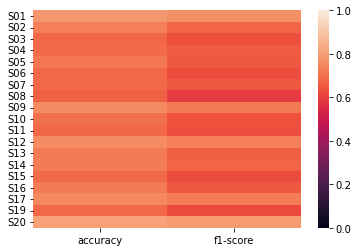

     class0 f1-score  class1 f1-score
S01         0.861789         0.552632
S02         0.832714         0.328358
S03         0.798561         0.243243
S04         0.798611         0.325581
S05         0.826568         0.229508
S06         0.800000         0.200000
S07         0.794224         0.329412
S08         0.790541         0.162162
S09         0.849498         0.415584
S10         0.809365         0.259740
S11         0.801498         0.208955
S12         0.845588         0.475000
S13         0.825175         0.305556
S14         0.825175         0.342105
S15         0.805461         0.219178
S16         0.829431         0.238806
S17         0.839216         0.467532
S19         0.802721         0.216216
S20         0.875912         0.604651


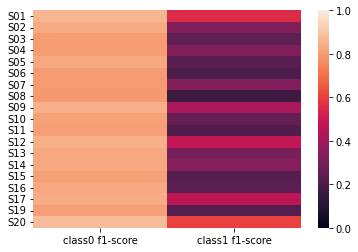

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [8]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [9]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-Weight_Multivariate-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

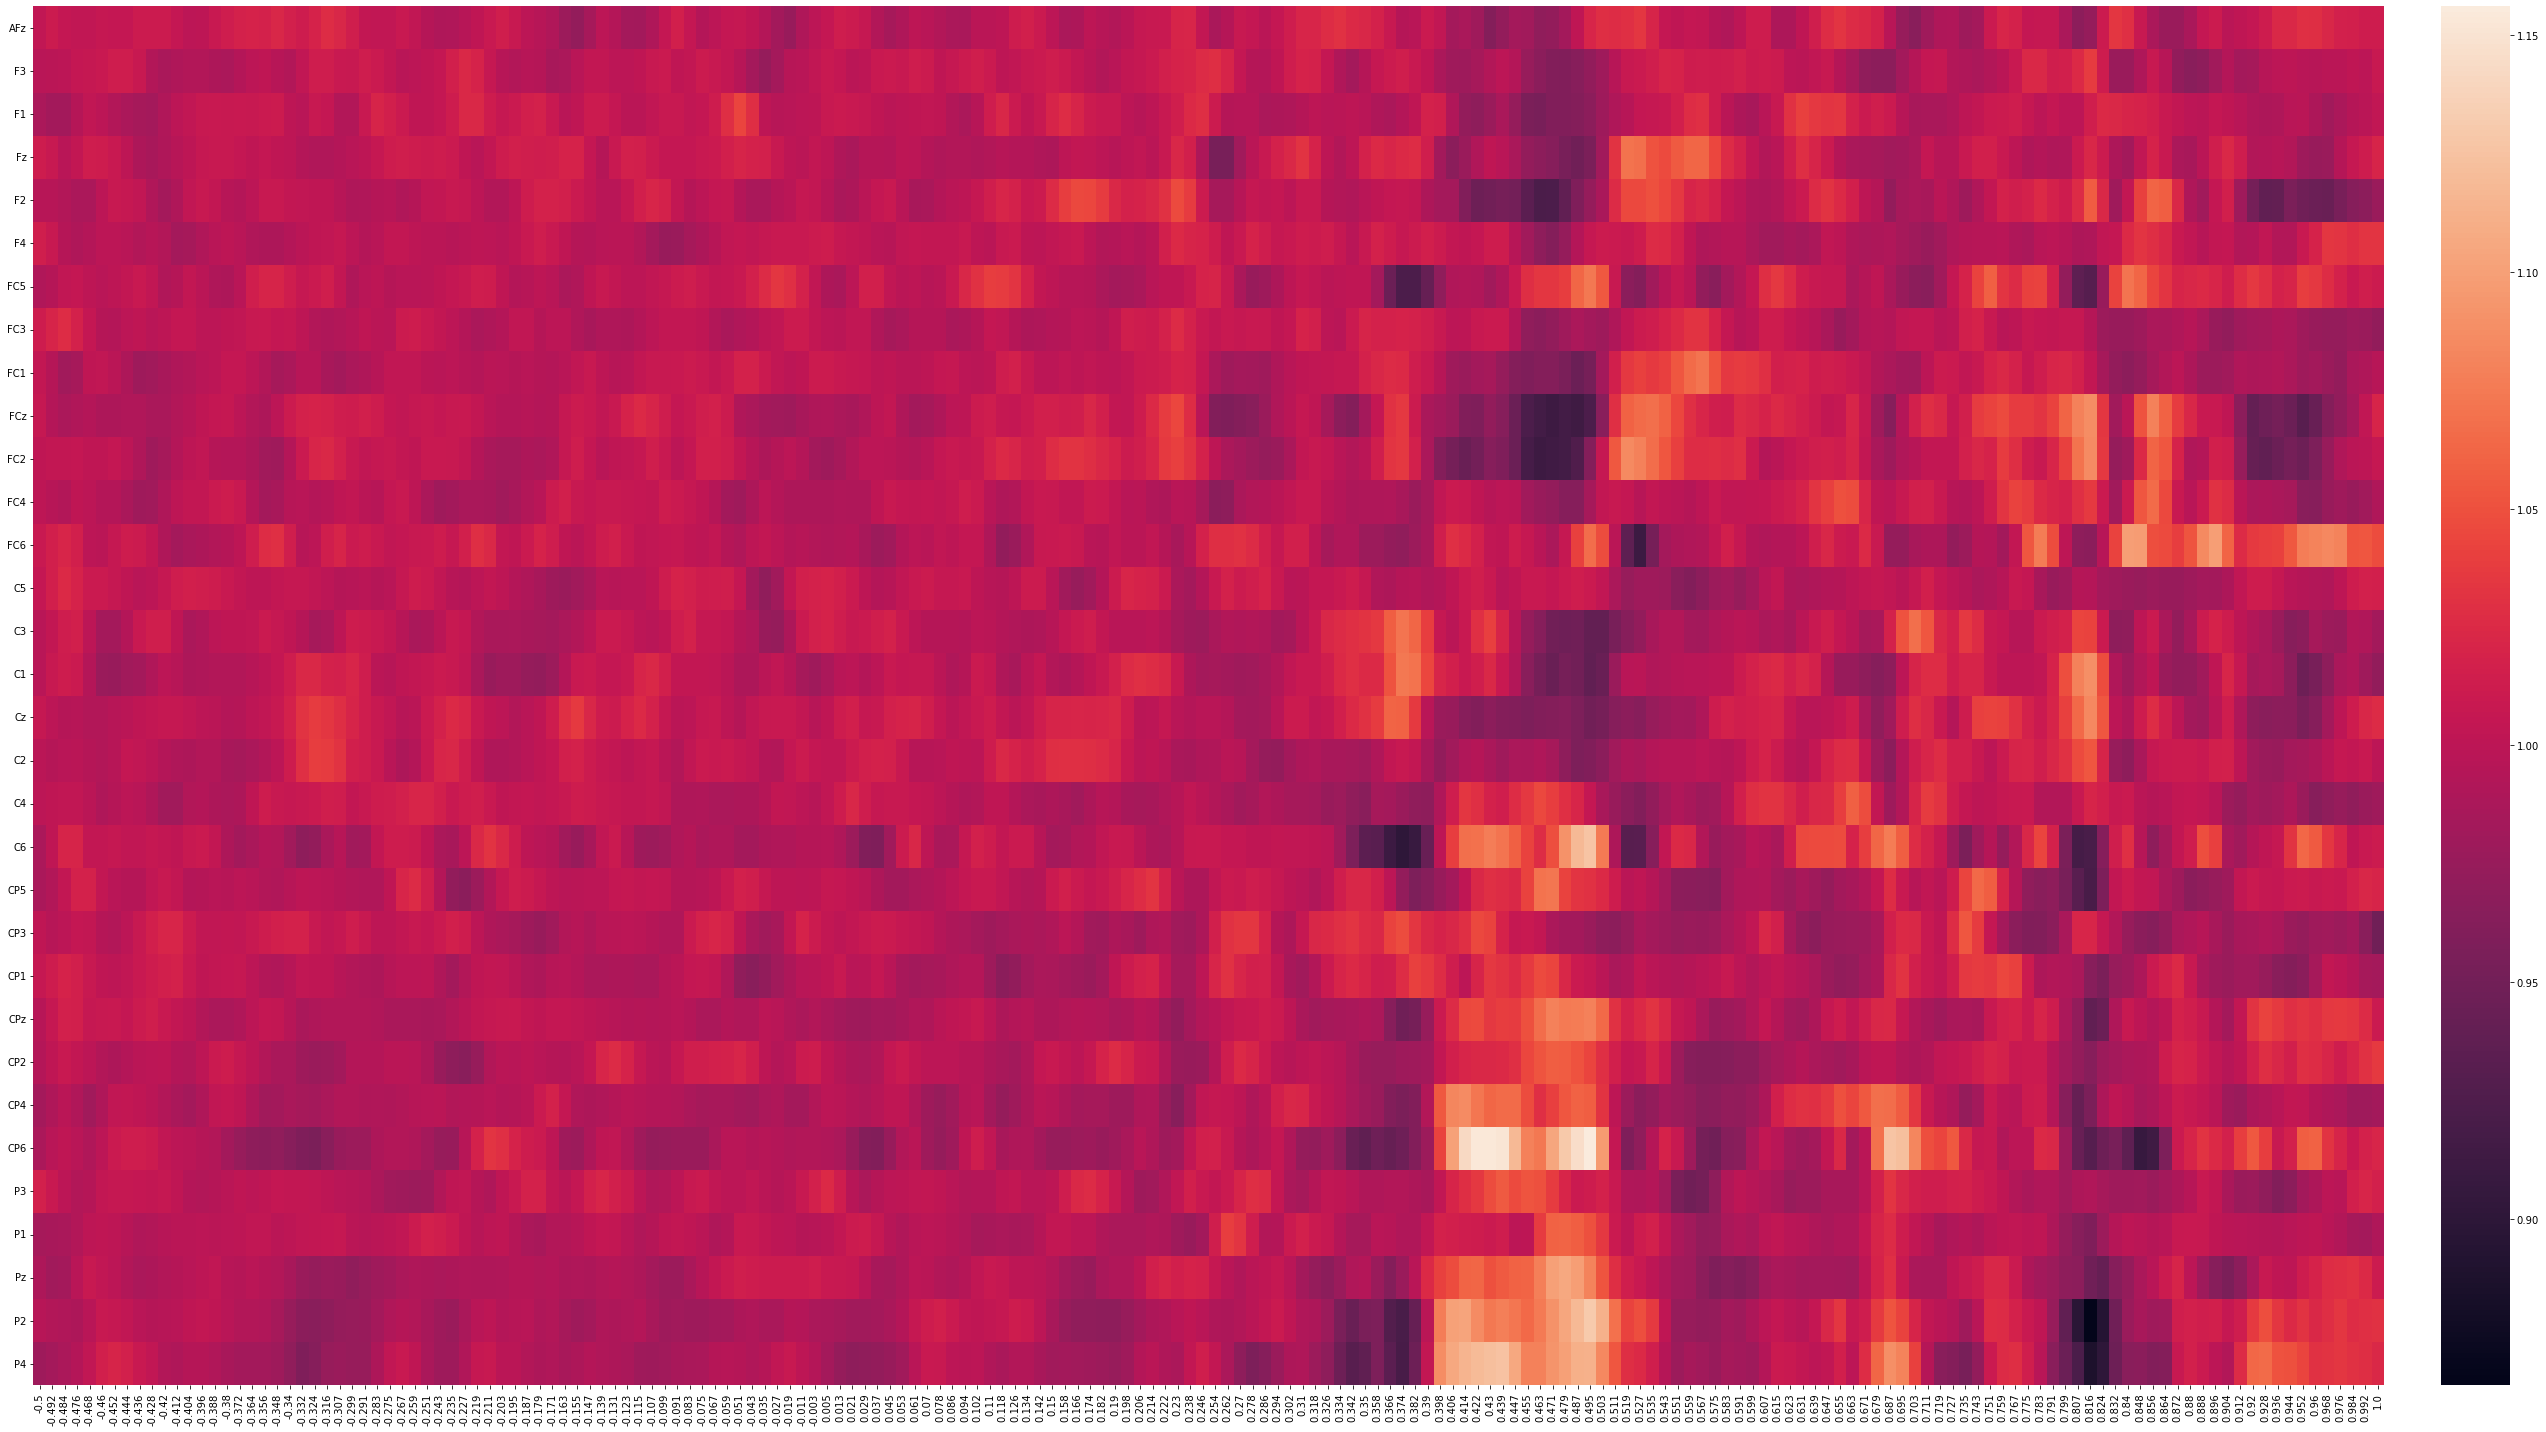

In [10]:
# fig, ax= plt.subplots(3,1)
fig =plt.figure()
sns.heatmap(pd.DataFrame(avg_w), 
            xticklabels=timestep_labels,
            yticklabels=channel_names, 
            annot=False, cbar_kws={"pad":0.02})

# ax[0].set_title("AUC")

# sns.heatmap(pd.DataFrame(avg_grad["ROC"]), 
#             xticklabels=timestep_labels,
#             yticklabels=channel_names, ax=ax[1],
#             annot=False, cbar_kws={"pad":0.02})
# ax[1].set_title("ROC")

# sns.heatmap(pd.DataFrame(avg_grad["STD"]), 
#             xticklabels=timestep_labels,
#             yticklabels=channel_names, ax=ax[2],
#             annot=False, cbar_kws={"pad":0.02})
# ax[2].set_title("STD")

# plt.suptitle("Relative Importance Estimate of Time Series")
fig.set_figwidth(40)
fig.set_figheight(20)
plt.tight_layout()

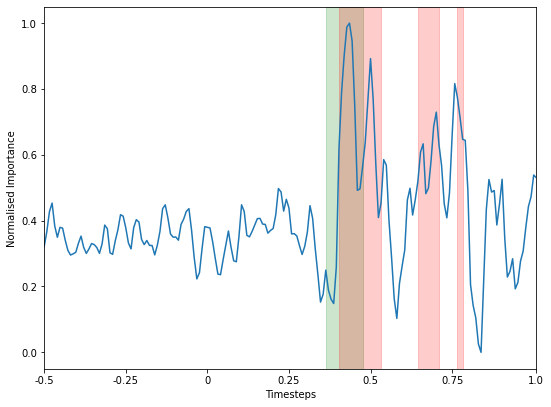

In [11]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(0).reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})

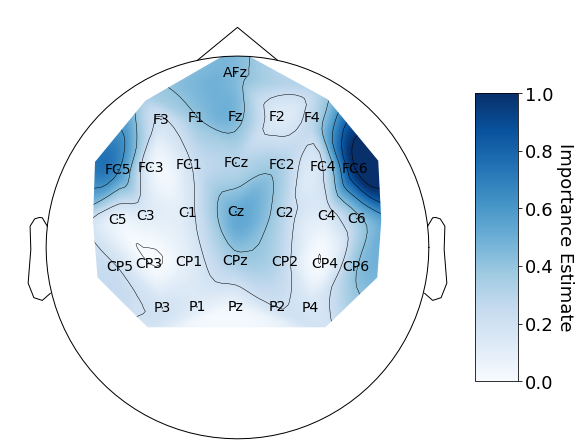

In [12]:
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(1).reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)